In [120]:
# This is for creating libraries from IPython Notebooks
# Whenever you see saveLib("libname", 0), it means the
# cell is being saved in "libname.py" with in the order
# of n

libs = {}
def saveLib(n, lib="lib"):
    if lib not in libs:
        libs[lib] = []
    while len(libs[lib]) <= n:
        libs[lib].append("")
    libs[lib][n] = "\n".join([s for s in In[-1].split("\n") if "saveLib(" not in s])
    file = open("{}.py".format(lib), 'w')
    file.write("\n#-------------------------------\n".join(libs[lib]))
    file.close()

In [121]:
import pylab, os
import matplotlib.pyplot as plt
import numpy as np
import cv2
saveLib(0)

In [122]:
from tqdm import tqdm

In [123]:
%matplotlib inline

In [124]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [125]:
arb,fea,nof = "arb","fea","nof"
time_delta = TD = 1/30 # 30 fps
skip_frames = 15 # skip every ten frames

def getCameraImagePath(camera_number, op, image_number):
    return "/data/data/camera{}/{}/i{:05d}.jpg".format(camera_number, op, image_number)
def getCameraImage(cam, op, im):
    return cv2.imread(getCameraImagePath(cam, op, im))
def getCameraImageAt(cam, op, time):
    return getCameraImage(cam, op, int(time/TD))
def getCameraImagesDuring(cam, op, t1, t2):
#     if (t2 - t1 > 8):
#         raise Error("Loading too many images simultaneously, may cause issues with RAM")
    if t2 < t1:
        t1, t2 = t2, t1
    for i in range(int(t1/TD), int(t2/TD), skip_frames):
        yield getCameraImage(cam,op,i)
saveLib(1)

# Test For Image Display

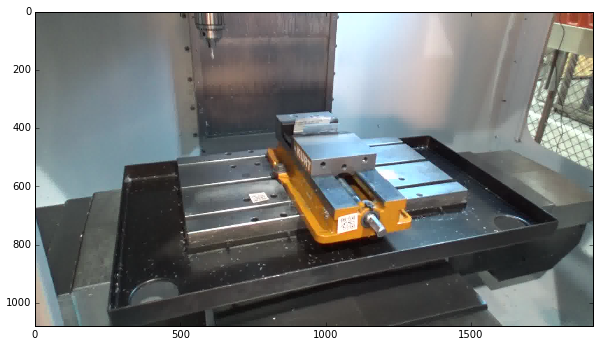

In [126]:
plt.imshow(getCameraImage(1,arb,1000))

# Scenes

We're going to use the word "scene" to denote the images corresponding to a single know machine start and end time.

## Regular Scene

A scene typically refers to the cutting operation, i.e. the operation without the calibration movements.

## Calibration Scene

A scene where all that's taking place is calibration. In this scene, we can obtain X/Y/Z transform vectors as well as 

In [127]:
def getSharedKeypoints(img1, img2,sensitivity=.5):
    sift = cv2.xfeatures2d.SURF_create()
 
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    matchesMask = [[0,0] for i in range(len(matches))]
    
    pts1 = []
    pts2 = []
    
    for i,(m,n) in enumerate(matches):
        if m.distance < sensitivity*n.distance:
            pts2.append(np.asarray(kp2[m.trainIdx].pt))
            pts1.append(np.asarray(kp1[m.queryIdx].pt))
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    return pts1, pts2
saveLib(2)

In [128]:
def getSharedDescriptors(img1, img2, sensitivity=.5):
    sift = cv2.xfeatures2d.SURF_create()

    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    pts1 = []
    pts2 = []
    desi = []

    for i,(m,n) in enumerate(matches):
        if m.distance < sensitivity*n.distance:
            pts2.append(np.asarray(kp2[m.trainIdx].pt))
            pts1.append(np.asarray(kp1[m.queryIdx].pt))
            desi.append(i)

    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    desi = np.array(desi)

    # Create a mask that ignores points that haven't moved significantly
    moved = np.ones(len(pts1)).astype(int)
    for i,p1,p2 in zip(range(len(pts1)), pts1, pts2):
        if np.sum(np.abs(p1 - p2)) < 50:
            moved[i] = 0

    des_final = np.array([des1[i] for i in desi[moved==1]])
    return des_final
saveLib(3)

In [129]:
def findPointsWithDescriptors(img, train_des,sensitivity=.5):
    sift = cv2.xfeatures2d.SURF_create()
 
    test_kp, test_des = sift.detectAndCompute(img,None)
#     return np.array([kp.pt for kp in test_kp])
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(train_des, test_des,k=2)
    
    pts1 = []
    train_des_used = np.zeros(train_des.shape[0])
    
    for i,(m,n) in enumerate(matches):
        if m.distance < sensitivity*n.distance:
            pts1.append(np.asarray(test_kp[m.trainIdx].pt))
            train_des_used[m.queryIdx] = 1
    pts1 = np.array(pts1)
    return pts1, train_des_used
    # Find average of points
#     return np.sum(pts1, axis=0) / pts1.shape[0]
saveLib(4)

In [130]:
class ImageLoader:
    def __init__(self):
        pass
    def loadAt(self, time):
        pass
    def loadSeries(self, t1, t2):
        return getCameraImagesDuring(1, nof, t1, t2)

class Scene:
    def __init__(self, imageLoader, start_time, end_time):
        self.start_time = start_time
        self.end_time = end_time
        self.imageLoader = imageLoader
    def load(self, t1, t2):
        return self.imageLoader.loadSeries(self.start_time + t1, self.start_time + t2)

class CalibrationSettings:
    def __init__(self, axes, start_times, end_times):
        self.axes = axes
        self.start_times = start_times
        self.end_times = end_times
    def getCalibrationTime(self):
        return max(self.end_times)
    
class CalibrationScene(Scene):
    def __init__(self, imageLoader, start, settings):
        super(CalibrationScene, self).__init__(imageLoader, start, start + settings.getCalibrationTime())
        self.settings = settings
        self.calculateAxisDescriptors()
    
    def calculateAxisDescriptors(self):
        self.descriptors = []
        self.start = []
        self.vec = []
        for ai in range(len(self.settings.axes)):
            imgs = list(self.load(
                self.settings.start_times[ai],
                self.settings.end_times[ai]))
            descriptors = getSharedDescriptors(imgs[0], imgs[-1])
            des_used = np.zeros(descriptors.shape[0])
            for img in tqdm(imgs):
                pts, fdes = findPointsWithDescriptors(img, descriptors)
                des_used += fdes
            # Only use descriptors that are in atleast 25% of the calibration images
            better_descriptors = descriptors[des_used >= len(imgs)*.25]
            self.descriptors.append(better_descriptors)
            start, fdes = findPointsWithDescriptors(imgs[0], better_descriptors)
            end, fdes2 = findPointsWithDescriptors(imgs[-1], better_descriptors)
            self.start.append(start)
            vec = np.average(end - start, axis=0)
            vec = vec / np.linalg.norm(vec)
            self.vec.append(vec)
    
    def getAxisProjection(self, img):
        projections = []
        for i, (descriptors, start) in enumerate(zip(self.descriptors, self.start)):
            pts, fdes = findPointsWithDescriptors(img, descriptors)
            offset =np.average(pts - start[fdes == 1], axis=0)
            projections.append(np.dot(self.vec[i], offset))
        return np.array(projections)
    
    def getAxisImages(self, axis):
        ai = self.settings.axes.index(axis)
        return self.load(
            self.settings.start_times[ai],
            self.settings.end_times[ai])
    
    def getAxisProjectionSeries(self, start, end):
        imgs = getCameraImagesDuring(self.cam, self.op, start, end)
        return [self.getAxisProjection(img) for img in tqdm(imgs)]
            
saveLib(5)

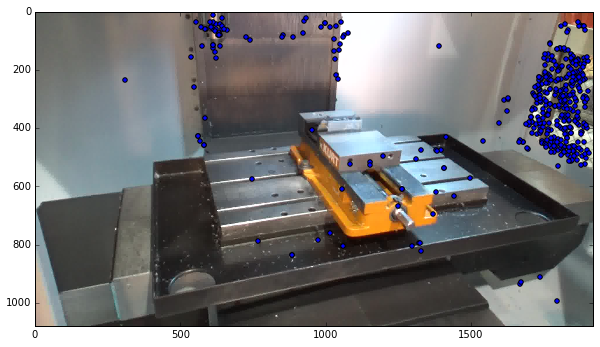

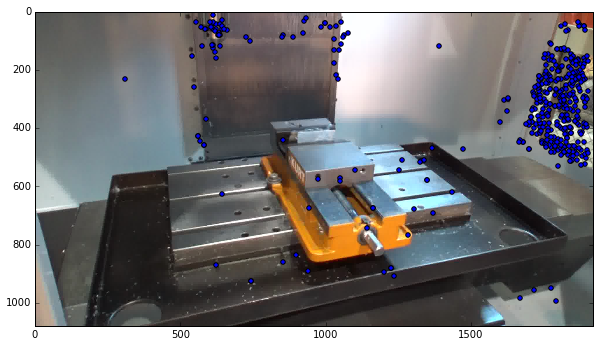

In [131]:
img1, img2 = getCameraImageAt(1,nof,8*60+40), getCameraImageAt(1,nof,8*60+50)
p1,p2 = getSharedKeypoints(img1,img2)
plt.scatter(p1[:,0], p1[:,1])
plt.imshow(img1)
plt.show()
plt.scatter(p2[:,0], p2[:,1])
plt.imshow(img2)

In [132]:
mimg = getCameraImageAt(1,nof,8*60+45)

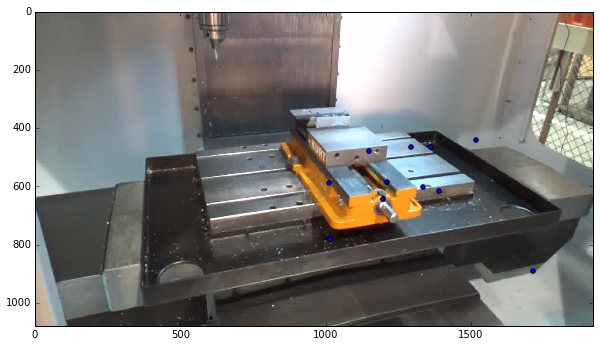

In [133]:
des = getSharedDescriptors(img1, img2)
pts,used = findPointsWithDescriptors(mimg, des)

plt.scatter(pts[:,0], pts[:,1])
plt.i{
 "cells": [
  {
   "cell_type": "code",
   "execution_count": 120,
   "metadata": {
    "collapsed": false
   },
   "outputs": [],
   "source": [
    "# This is for creating libraries from IPython Notebooks\n",
    "# Whenever you see saveLib(\"libname\", 0), it means the\n",
    "# cell is being saved in \"libname.py\" with in the order\n",
    "# of n\n",
    "\n",
    "libs = {}\n",
    "def saveLib(n, lib=\"lib\"):\n",
    "    if lib not in libs:\n",
    "        libs[lib] = []\n",
    "    while len(libs[lib]) <= n:\n",
    "        libs[lib].append(\"\")\n",
    "    libs[lib][n] = \"\\n\".join([s for s in In[-1].split(\"\\n\") if \"saveLib(\" not in s])\n",
    "    file = open(\"{}.py\".format(lib), 'w')\n",
    "    file.write(\"\\n#-------------------------------\\n\".join(libs[lib]))\n",
    "    file.close()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 121,
   "metadata": {
    "collapsed": false
   },
   "outputs": [],
   "source": [
    "import pylab, os\n",
    "import matplotlib.pyplot as plt\n",
    "import numpy as np\n",
    "import cv2\n",
    "saveLib(0)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 122,
   "metadata": {
    "collapsed": true
   },
   "outputs": [],
   "source": [
    "from tqdm import tqdm"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 123,
   "metadata": {
    "collapsed": true
   },
   "outputs": [],
   "source": [
    "%matplotlib inline"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 124,
   "metadata": {
    "collapsed": true
   },
   "outputs": [],
   "source": [
    "pylab.rcParams['figure.figsize'] = (10.0, 8.0)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 125,
   "metadata": {
    "collapsed": false
   },
   "outputs": [],
   "source": [
    "arb,fea,nof = \"arb\",\"fea\",\"nof\"\n",
    "time_delta = TD = 1/30 # 30 fps\n",
    "skip_frames = 15 # skip every ten frames\n",
    "\n",
    "def getCameraImagePath(camera_number, op, image_number):\n",
    "    return \"/data/data/camera{}/{}/i{:05d}.jpg\".format(camera_number, op, image_number)\n",
    "def getCameraImage(cam, op, im):\n",
    "    return cv2.imread(getCameraImagePath(cam, op, im))\n",
    "def getCameraImageAt(cam, op, time):\n",
    "    return getCameraImage(cam, op, int(time/TD))\n",
    "def getCameraImagesDuring(cam, op, t1, t2):\n",
    "#     if (t2 - t1 > 8):\n",
    "#         raise Error(\"Loading too many images simultaneously, may cause issues with RAM\")\n",
    "    if t2 < t1:\n",
    "        t1, t2 = t2, t1\n",
    "    for i in range(int(t1/TD), int(t2/TD), skip_frames):\n",
    "        yield getCameraImage(cam,op,i)\n",
    "saveLib(1)"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Test For Image Display"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 126,
   "metadata": {
    "collapsed": false
   },
   "outputs": [
    {
     "data": {
      "text/plain": [
       "<matplotlib.image.AxesImage at 0x7fd287b3b898>"
      ]
     },
     "execution_count": 126,
     "metadata": {},
     "output_type": "execute_result"
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAlgAAAFbCAYAAAAJGvDvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz\nAAALEgAACxIB0t1+/AAAIABJREFUeJzsvduPJUmeJvSZufu5x4lrRmZkVnZn17Wr69I9w27NoB2p\nBzRCszssAwKxLBIC8QoC8QT8FSvxwAMSEvDARQIJIcSIGTE7u2IQLLMzPTN09/R03bPyEhkZt3OO\n393MeLCrm1ucjMyqzIqs8k+KOOe4m9vNzc3Nfr/PPiNCCPTo0aNHjx49evT46kC/7gz06NGjR48e\nPXp809APsHr06NGjR48ePb5i9AOsHj169OjRo0ePrxj9AKtHjx49evTo0eMrRj/A6tGjR48ePXr0\n+IrRD7B69OjRo0ePHj2+YrzQARYh5LcJIX9FCPklIeQ/fpFp9+jRo0ePHj16vCiQF6WDRQiJAPwC\nwG8BuAfg/wXw94UQP38hGejRo0ePHj169HhBeJEWrA8AfCiE+FQIUQP47wH87gtMv0ePHj169OjR\n44XgRQ6wbgG46/z+Qh3r0aNHjx49evT4RuFFDrD6PXl69OjRo0ePHt8KxC8wrXsAbju/b0NasQwI\nIf0grEePHj169Ojx0kAIQULHX+QA608AvEEIuQPgPoC/B+Dv+4H+zX/730KIeK+PESq6xxDJT+KW\nkbSOcdG9Lo6615k4zTEOEAFCCCiVBj/OuoXzr+Ocm9/tfIXTC527OE/2u/50o9HHokjmV+ebEgK6\nJi8akRrn6nQpKAja4bTp014vkCRtgyil1JzXeUhU3K1zzjGbrtcGhBcGQM1kHdd1DQAoqwZ/+I//\nGO+/9zYePXqENE2REGBvbw+z2QxFUSDPc+xv7wEAJpMJAIDRBL/86BNT3slkgmVd4c6dO4iiCH/+\n53+OV27fAi9WGAggKSr8yvd/gL/xwQ/wwe/+Hfy3/+Af4Pr163j//ffxyTnF7/3e7+H8/BwAwAF8\n/uAROOeYTqdI0xSjZGiKdfPmTeR5jlEStcoCAElsw6nCm6+RbrusadULAMTqexzHqn5tFPpYVVWd\n65jgrbjdtmnCySAYDm3edKiyLDGdTkHiBAKybdR1jSzLkAzHSNPU1Llw4h8MBirqGGmWQQiBKIqQ\nZRl2t7eRpikYY6YOiPfcni5PMZlMsLGxgdVqhc3NTYAzZCquyWQCIQSKomiVJVHxDIdDk4cqWwEA\n/vAf/RF+65/75zEbj7E6P8fdu3exsbGB6XSKWt0/nc9rBzfxm//Gv4PZLIaqXjD15yLU2VK/qwt0\n0zx0nX/AiUffNibav93vqnsyYdxzVJ9zC+BnomnsKRVZxLo5jVSb0veP8AZQz3uj4hB1qdLX/Y0A\nVLvWxyIwU0jT9kXditv9nqapzFtTAURACGH7iVqG0b+FEOY6nSfG7HOoyydUJZh8C2HO6U8djxAC\n/8v/+r/h7/7O30bceZ0JUwd+H+hCd62tfl+9x3UeiGoIbl4Ya7c8LoS5t7ru4uEQ48kEo9EIZVki\nzzLEEEjT1NYBb8DV/TPvoGTDxGPeK61+u923689YtH8DQKS+unVo3s3qQSrFCstHRxCrDCQrILIU\nwzqX58oSaZri1uYQCZF5NveURXjttdcQRRFOTk5wenqKJm9MnwAANIkgiEx7Op0CAEaNjFv3jwAB\nZ0NTrmvXruGT+w+AOEIURbh58yb+1f/qf8ZFeGEDLCFEQwj59wH87wAiAP9lv4Kwx/NCURQoigKr\nIkcURebF/lVitVoBQmA2m33lcfd4ubC1FUN035E9evT4GkApxWq1wmAwMBPrBMlXEvdbb72FtJRx\nLpfLtWFfpAULQojfA/B7LzLNHt9O5HkuH4CTU0Q0xo3rB4AgX5oJSIQ0MhAA2UpaOzam0kLSsUY8\nWwpfRSRPhG/QFgTPlSWpJ+hEfeehW0E4KAAGDoCAQACE2z/IWT31ZsdU2D8i2lYhAmnt4c5vt6hU\n2BqnTzNCcitQEPzZn/4Sv/qrb5hDFOHq1PUgSMB69Q2AW7+ECBDvXuCZWSDfwMr6GuHX5lWtXQoO\ngINA9gEEQlo4IS2d+rt+Gs2zTAhWiwWmkynKvECdFxhOEhAICCKkJZDwYHvUfYa0srsdpUo3Isiy\nFEePj5DEg7X5f6EDrMvAdVkA1uwYcpMJtI+5Lg0bTLsWbZwRjS6+zuRDn9M2WEBw6w67CNrc6ZYj\nlHd93DWrhsJcdMy6QHU6ohPeFuvJcbZ/t/MEEAh4deW8MNtXtXOoY/BdGu17peuY2LCe+Vi7hoVy\nvEgnoj6m65zg4OA6iqJAHMeI4xhbm7uoSgZKEnAQECSoaobJZILTswXOz89RC32/CZqmgRAMFECR\nZUiSBFvzOeqiRIIIlACs5lgtUlzb+h6QLTEbJvj0009B330bSTJDksTI8wx7e3s4Oj5GHCVYpAvE\nUYI4SnBy/Bi3bt1CmqaoygJJHKGqtSne1qg29WtzeeS0KdOhqLbsQg9AuLo+SZzHXNVno90JTgej\nxjCOS7E9iIBT5zwwGImiCEVRgEQ1xuMxhoMBwBmSiCImBAkI0DD58qUEcUxVueT1gzgGH1AwJkAI\nUFOBusowSAgYtW5v7frW9bM5HgGCo8lSbAwSsDyTbsS6ke4KLhARgYFKp9YuKS4dT03JAeUSKkvp\nRrz9yi1UVYmcAFmWSXfl7i4GgwGm812MJ1M8fPgQjHEcHR3j8P/6P/H+D17HaCTzydB96oj6x+U7\nQ4bp3r5LwXfGhdyA61yE+lDr/eK5D4Ppcv1ys8+0cevotsG5LbuQ94hqV5MuPPTLE6azbrR7DQIR\n4eY7IIfbuoFGse4nktb1Ol+Adf/mTD7XAgJMu6lUGfQnnH54HVQR7KeTtnke9PMrgDdefx2Ct58x\nWZZu3QnnjoZoH04uZDmVf4011oVnwqs8GFchIdB3JKayL5jNZxAAKlajYjVqVqMqK4AQ1MYFau+V\nyZOKh3EBprgyunsxEx44bd9kqvuuZTqU6v8FEcZlJ/Tso66RLc6QVDWGjGM8jEFqmb9VvsTWbALa\nNKadRZrCQDgmlELkGYacYWOQoK5yDBMq3YgEqBlMeiCqLOrO1EyoiQIHh3aHU6yyBUrBwOoS40Fi\n+qKLcOUGWD16PCsaxvDG66+CEILT01P5MMeSmxAapE4mExweHqJoGIQ673KLenx78b3v3rnwXFEU\nuHf/Aa5du4aiKKSbYDhBkrwY62OPlwNvvfHGkwP1WIs0TZFlKeb05RyqXMlch2YTIWvTRWHccJex\nCLVIhJfIn0/gc+GS25+UXtgy1Q0XLotPcrdhfGL5unoJ5mXNZM6ED5QtZKHjnoXOPx/6JETOOVvX\nkTaZVJOoXVBCzYz3lVdeQZqmGKhZ7mg0AqUUnHPzt1qtsLe3h+F0htPzc5ycnJhzy+US3/3udzEY\nDEApRVmWSIaJyVOe55KUuVphPp+jLEuUZQnOJXGUMYbFYoH5fBPH53l75saY+WsaaWURZjLfvVeh\nNtU0jSRcl9Iao8mrofp0SeuNQ07W8WhEaFuGNNa189AxSqkhDgshMB6PkaUlkiRpWUB1rEVRQAiB\njfkQVVVhb28Pi8UCZVliPJED3iRJTF7W9QX6HGOsRV4XECYOTaBnkINsHcaFWWzAGKqqMlZEAGCc\nY3NzE03TgDGGJEnwL/zO7+AJj7OTR/knrbBfDqY6nYi4a2HxzvkkdxI4F/otlLXHtA3BnXDtdure\nF58EDmcBiwhl3oszBEsM11bNbtufTCaG6O5fF/rtt6l1C63sARgS+Lp8CuE/vwGLmdv9rnl3+XV9\n2XNunqbTqey7IMncTdMgjmPkaebFw0zedR3neY7Dw0Ps7OxgMpnIBSTKkhU5i086i73oxQ+Hm1/3\nfZSmKQ4PDzEej4GqgfFGOfdKCAFKqXHvG1I9lR4M2SfrPr8dhlLSoUoMh0OkaepYFmHujS6XTvcy\nVs8rOcDq0ePLQq8K0QOs0ABPh2Fr3owvaiupbzt2d3dR1YHluV8VvsLbOJ1MIEBQFAXqusa/+Lu/\nizff/V5Pcu/xjUdRSG6rPwnrEcaVG2BpK4PGupnFZWayvsUFsLO2oAXJO7TO8hI6ts461S1DSMKh\nm6V1lih/VB9CiJu2rs6gzLGWpxF4c5gpsC0DYx7/jJBOetrv7so+UNFe7svRQIg22ZAaboO9H7xR\n9ckBCDWzgJ1pj0YjiEayYUhEQGKAxAQN52g4N+lpvlYcx2ZmMh6PsVqtMBqNMJlM8OjxIwxHiSJp\nc5xlKY4XSyxPltjevY5FWuJ0kYFtDzCYETSCo2koojrGeDzG4eGhlA8AUHNh/xoGSoWZ/fGWZUDf\nD2rLqdBw+addm7Xq8CiAWJEidPkqzkCErMdGcNn+FUGHVWq5NyGGD2Tvg7qNNlkIZzn7eDxGkiTI\nlPyBsR6MRhBCOEudNW9GYLlcYjKZYDgco27ksunZbAbeNKirErPpGFWZQ/BG/jFtFVHpE3QeEqJ5\nIuCGi5FQCkEAAll2GlEQGktehRDgTQLeNIggMBokaBhDnmUtkqwpPBEAEWC8AeMNFiePzbORFyne\neuvVLt+JBKzhHm+RtA+DqDr3n7YQGd5/vfHAd9LuItp5UJ9u72ZUFvxPOBwqIrkpEbeWKCq6lisb\nt3NvAAjuWFCNVav9KUnIbSuMfDxU32Ess5pTpXIiBLi2jrEGk9EQTV0CRB7niolUqYpn1sYHojk8\n9uUALe+guUZCneO6LBAdE6JJH7YvMsXVUhWwsgzuQg3923+vtd6HnvWPOXVvOKk6n6YOI9NP0DgG\njWNwplhZDcArbWVs86UIYrXcBBgkIwgAOzsJdnZ2TT4ZY+ZxdHmZpu1rfp3oDsgIrOQOAMTUcp85\nq3FyfISYREjPzrE/mmCDUoxphDOeIREAVgIkK0GvTc0kWdfBLJmhyRtMB1OAAgwMMeXSq6Es1gUr\nIKjAUAjsJwPEAijqEoI1GESSPs9BzHNBKQWlFGNFMqNEmLZ/Ea7cAKtHDyh6oWzgl0BY480NAMdh\ngss5grvQLz8BuQqOK/I/N+tZKECtKRuCAmI9i9l2gV8NLjKieIvevgb4OXv+5h41LrK/0f7uDnQo\nwq3iUlX1JevTn/x9PfdnPczA09Sn6AwQuxdd6unt4LKrKy+6t60wWmNvTZgnRv6yI1hwd/lReM2r\nAAXUxIyL9WTurwJBe4cQmG1sYDQao1ymWKVLRJMJiADmu3toViliTkA1UV4N8ioBzDbmyNIM0WCI\n+e4QjDeIhgMwtQhjQOWAdcyBCAIDABW6EyAfjAhwIsD15GsN+gFWjx49evTo0ePKgTCOycYGXvv+\n93F+copHjx4hS1MIDkSDGMsvSmwQQLMojWUZHFubG9i/sa9EiGf46c9/Cj4aIM0k12xI5MBq/JTz\ngIoAufpbQy0DcAUHWEKIoCvMlzMA1rsIfYRcaMYVEiAFhlx968iH69K5TH5dAuTThe/CKCt7itfa\niHoRnlVV3t4j77eTmn+dm9ZlFjUY87cbt9c2OOfWRO+lV9c1KKVSTX2RttoZ5xzb29s4Pj7GyckJ\nTk5OMJht4PT0FNevX0ee51ilK4wnIxABzAYDVFUFSinOzs6MO/Hk5AR53GAynWK1ShFNx0gGHGVZ\nGsI3IEndhBBMJhOsVitMp1NEgfbmE4TdnaQIIciyDIO4PXMjRHKDptMp4jhGlmUtiRKrNH1x3Ztj\nzj0w1xnphwRVVaGsqo5kw3K5NO5D7SasqkqqvCvXgk8wzrIMS6X0rhcR6Ot0eoAkyxLaJuPr51gT\n9l3iuqtYr5dUR1Ekr1Wk+yzLEEURBoMBmNfPJBHF0eEhkiQx5eFUug/0AoXpdAOLTi2+GIR44h57\nICzToD559/abcy2ejfDa4pp2Y9sPN+FCFI91JHcfbnuxyuEegd6BUSxXixNclfBOvgP5C1JRLkEs\nDyXRTbdLkHYJ2L4yejtsO711ZHcrrWCh23GWFSYMYwxZlkqV/VZZqJHQCS2K8t9Zl1lM1con9+qO\nWkpJmqY4PT3FDA1ef/NN3Hjzdby2t4Pt3V3k50tsxAnu//WH+Cf/8B+hOH6A2dYGHj58gLKs0DQ1\nbo+HWLAG127sY293D9u7Oxhf30VZlmjULgGb8yHmwwGOPv0cv/infwaWZqiqCkmS2P4OBBSWwhLH\nMcb7e9gZjzEaj3ByfAK5SU0YV26A1aPH14nRaAQASPNcvvSXSzmQKEp89tlnGAjg2nCMEQj+4A/+\nAA/u38V4PMYnn3yC4XCI41mM9LxCVZU4yo7w8PAEpchBCMGjR4866WVqNjVQ/KwePXr06CGxM9/E\no6MjnPAa1WgAMUxwY76F+WCIWzs72P7ed5C8ewdvv/8DJEmCs7NTHB4+wvbHhzh8+BAffXEXnx0+\nRDJIsLO7LSezA8mlLesKx6slPv7oo6fK0+7164gmY4wmY5RPCHvlBlg0ao/KqafEF1oCHNBahCZD\nr7MChURBnyfWyzO0CYZAdzbUnhVcTI6/aGGAOzuCN7shLuHeW1YsnMyYOEm3zvzlyALEzpC1UKUj\nR0AUkRRGVNCNTOdFfjRm5mYtWIqbCabJkiSyM2tD/rQCnvpUwwUaLuz0nQqgaXDnzh188sknAIB4\nFptVhkII7AFYnZ4BAArOQScTHOUVPrz/GAcHB9h55VWw4Qa2ZjcQY4X5ttxKoc5LsIZgOJsaq8rO\n3j5AY0ynY/U5RayFAx2rAY0V8V2VfdCyYMnvjLf3IhQQ4BHFssgxnU5RCY4kQMAiypozmc2Q5znK\nsjT3VIsSuvdTWwSYnm0aeYfuQo2aVyBxBE6AqqlNnBxEPqw0giAUTAgwYSUW64ajbjiiSBJLGZfH\nZDLKKksJ9Kp8TYDXTZFGBAIcabZCnMgBa5qtMJlMEEVWIkJLONRZrsrC0DRK1FXVdaxs/1VVoWoa\nDIdDQxR2rbLj8Rg0ilB7j7RW/HfBQ4+9B+EmoBBar6WJt8YS5RgyvEegHb/fDTphQnusApKhE3kJ\nCcE71ulEEZnbUip++gETj9771JDHeXevRS4s30W3y0hZG3X/L7z9EwFEVFk+wUGJEuxV6Zh27lS4\n/sYCz0zIyqW7EKtZGrLQtfsynR/5aY/Ia+wzpsvrWrR0Okz3gy3rpDrG2/mtBUM0lNuF0UGCvK5A\nE2oEdDnniAcxWCGfVfueiiDU+zfc36v8qXoV3BW91lZMVT+0nSe3fFyXU3AkarXI+eEhdiYTnA4F\ntva2pMAvjSAajvz0MXIADx7cRYYCDz88xMO8xvXr17G/v4+D197B6J0fYkvV3XK5RL04R/XTX+DB\no0Msl0vESYzvkhGwylDXI1QxwVFVAdUAlNr+jgJgjbSCD8kA1arEvY++wMbuDnZ2drAzWj8xvnID\nrB49rhL0HoYUgKhkBzQYDDCZTLA3AN5663V8//vfx/HxMSilmN1+HXfv3kVVVSiKAmlWolSdhtZW\nihChrmssFouWhs/LCYEvzfJ+AXi+chsvRx306PGyYTqdYjKZrNX2iqIYP/nJT/DOO+/giy++wGQy\nwfa23JSaMYb5fI6drTn2P/gR3r9+A4wxrNIVso/v4eGnn+HBZ59C8CGORIH92QgnJ6fY2JCT61gA\nG0Vi4gKA5Rf3sXr4CI+iCJvz+dr8X7kBlrsTN2BnVes4VHo273aivh/bxWWEPkOWL/+Ym4afTshq\ndBmuV2uAf4l8+mFD4UPb9oTqx+TZj1tGemG6Or2Ien76wDvtWa2Fl5HG8PMF2KXDvgBrURRmk2Y3\nT8PhEEdHR2jiBJRSJEmC6XSKPE2N5YMQguFwCEpqHB8fgykxSkII4qIA5xx1XaOqKtR1jeF4iqIo\nHF5PYjYgHY/H8nplknAFLf2yhLBugKbLvE4UtK5rEEKkpEWHexNoG0aSg5nfmtukw4zGUqZBC4gC\nQJJI3poW/XP5LFxJZuhzug8ghBgOleUTUrPi0likGmu20PlrzHYf8tnUcQP2fud5jslkgiSR9yPL\nMgyUmKzmfA2GQ2RZhvl83uEDxrG0PlZVBcQX7wBgDBkmj91z665bG+caC5Zu1UHrljYwBN5bvmBo\niwF0Cd5Uy8uwhidlLS5+emLts+1fv65fdZ9tV3D3snD79rV8Re93653A29cTIozcgkZo6yltNPLF\ngZ8EX5g4iiW/cDAYmHNJHCOKInDOZd8FgAQEjS9C2xIlPwwnktg27r8z3bi1/IXL5YqiCB999BHq\nusZ0OsX29jbqujbPo9xqyrap0WiEg4MbePz4MR48eIDvfve7KIoCi4VtG8vlEl/cv4uGCuDn/59p\nE+/e/h42fvQ23v3R27hx/QauHRxAfPI5To6P8fEvP8TR8WOcP3qMcV7jwYMHWK1KjEYjbI/GqLIc\nWZpipfajvQhXboDVo8fXie3tbTRNg5TJQRJjDJ9++il2t7fNgMGowL/6CqqqwsnJCYQQOD8/R7Nx\njnOlCl8UBbK8RFJIa5Z5wQtLttYYj8cAHAXxHgBsvfTo0eOrg57gPe3g7SoijhMcHBzg3r17ODg4\nUF6H9oCVAhgJKE1Feezjjz42xoR7Dx9i+uEvQSmws7ODd/7lv40iL1DmOaKiQpZlOD4+xueff47V\nLz4Czwo0RY7lYv3yln6A1eOZwIlsqILIv5B2jaYeGOpEkHpG0CGdXALkGa8LxqWzAmB3ZwecMZA0\nw/n5OQTn+OyTT7A1n5vtceq6xvn5ObaiGqLKka2WmM1muHv3LmYPTnF4eIg0Tc0AK57UrQEWrzk2\nNjYMxwu43ACLo7tp9mXwrA4sfZ2+x19GGkh4f5ddGa3rRa8qvAqIIfPPATDibFr7DQKBo46kVWoD\nYda2rUtcR2DbAtXBQxE+T12qF6B51equBDF8PLeour4FnvI5dyO/pIhanuco8xK84QBV/an7kAti\nOIcvDEa4TrcIqTVlKGyu5VeFIpDWuIODA/z0pz81W22VpbdNkqAY6QmuisC1pjVZjsfnC+STAX7y\n4S8x+cu/AI0iRHGEtKwQxwnefOtNvHL7Br7z4x8DeYGiKPDg/gPgf/zHFxbpyg2wfJkG39QYAg0Q\n6IQiXJo9kC7DMAU6hGuXAGlJ4D7B3Lqf1rn11rktXXX3bpzBjHrX8845GmT/t9MLdS3cIVwCUtXa\npOYQfZkZmQhJxDW9hibSq+6CoCMY0lrS65GrpXxn26xORTtPwokj5CIwS/e9fAPSlO3uP2dM4wB4\nXWN3awuD0QQbozEWiwXeefMtNHmBmzduoixLVGUFIgg2J0OQocDOfAxKBTanA7CyActKsKzEJBng\nPD+HoAkiEEzGks+1sTfFeDxuWWeaqlZyDY5SPbruXO0MI2axQsDtodq+Nq1zZuuHBepK12vtyR64\nxFameGTDqO3uJgSIFNmYqeXPddVtdySWYQ5euWVcp0xwMMGRl4WJUw9gdd6JsvI1hjgtDBnauJ8q\nS/SnmozPmCHwMsZACTFK2jSx2ydp16DeENwlwgNAlhcYDkcA7CKJEReoAeQRwfYrN8Gmg86D1Kpl\n1fSo7VT8U63rTDAvzpBr0T6jzjkdl2os7i338+CmYeRdVL0yboeOVhVcuXoE6wwCXJK6DqqX/pvF\nJ9yqmXPGlEWhrZTeeslqN5fTFvW3oOSLfkL0oohYXY8IQ54o2RLPPyqcCtH9DhFqsCMsCRvtth/q\nPFnIRagr0dwkAaKFO1WQmJBWm+EAaED6oSPvYDph2z61KGhErVTFcDg0++ylaYpyWSi3ICAaqXQv\nJ63WeUlianb10KR/6vS5xu2nuyLTb+hhojvJ1u5ASwGqVfl0XxxHwOHRQ5ytzjEajbB3Yw+TrS1T\nHzq+WpeZRBAA6rpBTCO8eudVNFWDpmoQqd0sYncQxdp9H28qZ3AtgEGEQcNwfb4pLXyrVC5UKmTe\n/+Sz+wCkl2M0GmE8HmM4vJgaAFzBAVaPHlcVdV1jPp8b3aaNjQG+c/NV/PjHP8bu7i6Ojo7wk49P\nDYfok08+wVtvvomHZ9KMvO5h9Dem/abiwYMHmE6nwQ2WQ3gZ6uW58ud79OhxaaRpiizLMJmvH/g8\nC/TA+qOPPsJ4PMZoNHrinoxXboDlk9yFp4QXFr+82IJhrntKcvU6EniIqO2TjS8rXurHvU6ork1W\nD8fdjuvJRNFQnmgnfICAGSKWd6QjQnstdtPrWP/WEO9D1k2Tb0o7FoiLBGMvIq+64WezGR4+fIjd\n3V0cHx/j43sfY2dnB6+//jpmsxmKYoHJZGLI6pRSbG5uYmNjA8fHx9je3sYqzzsDK1dsU6c3GElx\nu1a78ax+oXwG25n6zLIMk8mk5Xb0SeombqBDjnWtXTrtJlBno9EQ165dw9HREdI0NfvyueHGakaZ\n57kRNyzL0vzJwBRN04AQYrghjVe+Wop/AHBIy421YLlirloYsGkaNHVtyNS6fFqDrNVG1YxWuySb\npuksYpGCtnLp+fvvv4+GMb1Z3jOT1k0YdJ+2EK+8cyxwzhha1p0L3GOf5B46FhLdpCHSuXdd6Nnu\nPofr+xvbD15+w2Ed92QyMZbap+U7+uKemo/pH9OfHcHPCxYRude74XngvebXld0S9mKPSTJIjLVW\nW7DQCLMvpwnvCYYSYkV99bHpdIosy1qeJv/95BP4/TrQ4f1FB2dnZ3j48CE2NjYwmUywubmJJmCl\n9BcCjUcDFFmOuq6NULFfB4C1guq4BvHIPO+6v+GNFVt1/wDbZ+qV5WVZPnHR1osRgOrR4xuA5XKJ\nzz//3GwYOlfioIvFAlmWmePXr1//mnP64qBX+oVEVF2Yjv1rgttBf9156dHjq8bzlSHp8ay4chYs\nCNqacUUe58NdV2ysGrzL+RDojnw1fNmE9gzWm20ELC1izazBDxsKt25LAZcjYTz2gQ2Pumm7v7Xv\nn7Q+Cdqzk9a5FsHDD2OZaFZcztuixcmnyS9RcxlBpHWLCAgaG5KrgCZ2UggiQAhAhGFfAXB3p++u\ndokMJa4dNlQ/bYvLqJ13Ehnrm+atxHGMNE2xublpXIPRcISmrrHKC2xsAQmAuGFAUQJFiWkU4yyK\nMZyNEY2j+oBiAAAgAElEQVQSxGBIIDASisegOUBNhYQSJJQ4M3tZvgGV5RdELt0mAIgWVpS3QpLO\nG8mPaYQmbsrrKCHYmM8wm05x9PgxqiJvzaLM9hRN28LHhEClLEna4kYU944JtZRbAGTUXtVHAHAu\nrVGDwQBxHKOoK3O9meEpEUJWN1ieL5DHMQghKLLcLMGOBwnyQm5jpJdwC+badORWGt2tUlS9gqLR\nXI+ifd9d4U/Tl4SkA1gJAUmuJwCKLEdVlYrn2e5LqqrCzZsHiNXWOfqPeFGve/dx71HlPEjtuTge\nbZFi3XAuvcSk5xl9eMCC5YuKupFqy1UEVwbCmMMAtGft1PC5HEuPJyxKzTOuzXI2Pc2hpZSacJGp\nKyU5oNq+fB50VkQnbv091pYWxwzoSmQC0LK4koPFreRH+9PynTS/x1aZ5UTpTr39Lmr3+8yxxgku\nn/vY3yiecMtvMy8/x8qorVpUcpM4azCdTJAkQ2i2OK8B3sD0wa4bQJB23IISEC3irN4JWpag5bHp\nvDNlf6QyJT86YQQi1WMnUYQ8y3D+6BFGlKCsC+zsHmAZc4wMv9omF3lLZDiT0i6MMVBKFf3Af1hs\n3RletivcrBrAIB4gTTOIhkAwQDAganEDAcTUvnNYtw9xcfUGWD1eSgRfCvIJdn6TTlizMs4hWBJ0\nX2ZfNziAZDAAoRSjyQRlXYON1SoyAgzGYwzGIwwxxnA8xmA0kqvMQFBm7cEhEd097M1gmgizuso/\nR53n3JxzAmmTf1kUiCg18VwGESGGdG8mHuYcxUQNrNiXvC06jSiKjEbXeh6D/1K6uETj8dhom62e\nsHx6HQiAQrkINXH/steZ7+RyLsFvMii6k2HxjCv2aODWu1Fdtp1fFpfpgS65YO+Z8KxNx52OCGhy\nOEFnCd5zxGWqxe3bqPOpB7qD0QjxeIzLrDcuywJ1JVdq3759e03GdAe6LmMUrWWL4aXv3TgvQD/A\n6tHjknjvvffQNA0mkwmapkFFYhQEKAiAyQiiGGMsxmaFCSEEAhTn2fLFZVII5Hn+1IKuhFK7D6Pn\nPqPOuVX25eQS/AGWEOKJYn2XRZ7nKAppuhpdkkS/Li7Armzt0aPHi4MmkTdl9sSwZSF5nHmeY/OK\n7el65QZYWsnZh+/S0mEBbfFow3cNrnPLtcnD7fAhV58161/c+V7WJ75O6dac60w5yKWu0wRFtz6N\nNcTsXdcti65Pm77979+bVtyduqPBe6PDXEj6J908rJt16TxE7lJlT7XbvR+DwQBpmhqyZOhecc4x\nHo9R17UkswKgkdwiR2+Dc+/0HHwgkEUEbxQZDpfn4CRCVVU4Pz83OlgANWT48/Nz7M9nZtm0Hrjk\nqRxkaAIlACxWaasOXK2xi+qOAEgSab5PHDkCDW0tKoR0B+o6oJRiqqw/69qUdg3o+hkOB2CKLKzr\nfByPTZx6taC2pOs8CSGMMr5RXXeKYl0QohV3qz60q8cpg3VJtonw2r3qllk4CyFsWa07KMsyrPIC\nTdOgLMuO69TWLzHt0/WuGVcdaZ9zESKw++dCv/XXkLfTdxFyd6GQt69eyEXIzf6djvvJI3ODsw5t\ngHTuFTduuHXphRabBPtvr5tYp+Qegm4b4/EYaZq2XM1+DJxz5alc1493F8oEFevXKKTbxTjuO0jd\nI+6nLcy7wLplu3Hq65MkwWAwACUEzHNlhUjnun7Ns+dIY5jyqfzqCdLTwqRHBIjy9Wq1dQiBpmlw\n6853kCQJ0jTFeGD7Gw3dnnX6w+EQ9+7dw+3bt8EYk1vr0IsXMJDAA+nePy1Bof/cPk9WCzXVHtp5\nw8WVG2D16PG88WUJoXq1XDotsSwX+OzRQ9SU4PDRIebjV0wYPcDKG2JERQeDgdxfazzCaDQyD627\nsbSGPvY0AywAGCRR+zqHc6itRTruUAfhp9tKL4pNXOPxGMPBAKxpD7C46b/EpV5+puzOdRaXGGA5\nx83LwRtguxws83JxVpPpQZ7Oi96i50XjW+5V7PEthF50EtU1xuMxDg4OUD7F9VEc4fHjx/jggw+u\nHNn/yg2wfJkGTWq3h7qdvnbctirXFxYl3Q4aomvhsR15l1wHLz0eGAGbDj0KWOECli//utAeT4S0\nyY7Eyco6gdLuDJM4sxLv5eRODz2jkUy/XZ804HvWO6ZDW84cFpCx/tH2y99NxyQvqJn5avJogoCg\npklOv0RZJzZq3rfOcUohCGmJApoo9XLkgXw0yETuq8cAlCRGzRts7+2gEQzZqkGxAoAC/7T8GPv7\n+zgqVkjTFI9OlqoOKObDCGhKzOdzTKdT7G/NJOFW1BiOpFVEW0PcgUTV+FIK3cEKa7qz40HUHoBo\nqQNKBEZqrz09sGrxnxRBfDiQYfKyNoMeTebU0gZ6XzMOrh8j1GqQEsfWSqUHLkYwlNUmv9SZwerw\n+tPKbbQHSvK8PKblHRJVFpd423iiqRDd/UI145tzbsQRy1pZ9gYx4iZGcZpjNJlhPp/bgSqT3QuN\nY+xfv4ZVze1+jNZ40yHR2efRZqFrm8bFJ7vjTqtU4N5GY9zQdWhPUm9fvEgELEqad+b2b9rSovMp\nLBFQH+NC89W6/aIVDIbpi40Mgf5tFitYhRLSEi/V13kmupb1x9j2gunLdOTkIIoiqWhe1rZ/MiWw\ntHczcRDE+7R5NhaQgFFHb41lrJVwhZTVMefRtgse7LOiLnTKYEK3wggAUG1xvDGTQpyMGbeLeT/o\nNiGEuX+NEvCM9b5/IEZkVUMI3dda7wQhRv5Y/Y8Rqe+67TW0XU9ECCsey6Wl83GTYW93Fydliu3J\nNgYAuI6bWGHTSL0L6krWT13XEEQgzdWiJFbrKnD6RWIWvumqs7uaWi9RVVWoqsr0c8Ph0Eg3mLkb\ns8SBKL5YzBu4ggOsHj2eN55mlqNddgxAmT3NvKqL6XTa2h7nKoFzgbyQLknj+oq/HI/pKuF5zmuv\n2qy5x7cPri7Vy4rxaPxMfeTdu3exs7NzaVfxi8SVG2B1xCkDPCk37Lp4WmFId6bmyv4/TZx6tBsU\n2wzyuto+39C5deKgnWMk4CYhAYuZF0baqUgwzLqyyLifbMEyBj7HLWMVI0jwE52YpdVHz0Qtp6a7\n0myd/IXlmFnLoGst7FhKvTga5fYyYnhoyxdsbW3hcZFjcXaG/f19cM6xWCwQDSS5fTKZ4Pj4GHs7\nO5hP5SBtPp/LonBr3tCuKCN+55Czk0TmXRO33VtsZoa1vyM9jPVPH6sdC4YR8Gz8pef2u0kvYnIh\njeJLudclidx2JC8ys1WV5pPp2Z9b53oW6N5/32pbOm45ex+8mS8JPDOOO9DwJQLPk7G0ODwiNwwg\nEKn2whgDYwyESLHSWMlKyOsicCLvlRDAaBCh9ralkfVpv8tMoAP/neA2Sf/6loGerzunyg5robMn\nvec2wLMKCYYS7xiBtWBxx0LaTc/jcwmnUzBZuLhvX7dYYx13ax2P0Fh2mwZJkihLVptMHRJbvQxn\nLFwWT2rIWevnv4tCx9YN4EPl5JxjMplY3mQSoSlrIxAqhEDk0AY6UkFmyxvXi9Htt12JHhecM/hS\nPyGuqO5T7t+XW9AIKrehEUIYC3tDu6t4NZ2MUoqqqnB0dIR33nkHs9nMUh6I3y9afq55PznmxiiK\nkGUZskV3QVKIamHy8rIpuffo8bJgY2MDy/NzrFarzqxrNBqZ1YTunoNPgrupsZZEeFlmpjrvocF+\njx49eqzDcDh4qv6SEILlconNzU2Mx+MnDna+DvQDrB7PBAE7c3G/u2iz2aB0WYjSfyJGaFRGoGe4\nRHEUnh4Ul9g84xnFa4iwQodar0UPqkKq4Lqj0IOsVhb0H5E8NeJkK88LZTWyM0SzstDunPrUZRFG\nNlHz4oTzW98bGae5bwRK+FWoW2TPmTDChsuKHAICs/GXcYOS1nfX3kFUOYTJF8ymvJpjob9zlTmh\nykRbcaq60BVPVE1o3RstNGaNNN8IaP01XadPaj3kkuH8a1x9t24A3or3qk4dtKDv1wndRwB4ktzS\nlQMn9v6GpaRIm0MnCJLhAIPJEMPJEGVZ40lPH6UUy+USW9tzTCYjLFdLx1PF4b55iE5T4UXd2is3\nwJKkZKdihSZFy58t87M2ywZeq121dnvOuH14OywAUNK22WulXpmc6r4DyurrEDIDa/jWCUqjC8+1\nzd3+sa7ptiWYhnYwS+rUZHfHNWsUfYk95zdJpRZs0oR5rUET6GW9qhe4MRUnMiwh1gTuuv/UoMOo\nPXv3o1Unwr/v3FFrlkcYsyRn3V4iIl+4ZZ5LU3rgcaNEmaiV74eDI9Kq0pxhYzxClubYmM1x//59\nVGWN0VAY9wpjDE3TgDGGSrnctJuMOTUXx4rYW0qXZFVZk7gua5oVnbJbtwFX8dhHuVZy1trNWXMh\nhZyFMC5J4u0DJoQlhhvF+cq6MfRzpN2NzKzzsXsD6vzlinzuugH9nexdmLgbx52n4qpY0wrTkmJQ\naKiuA4LYuEXbsgLuy9zE5eWbAIiZdlcyFBVDVTWYzzfBuUAc6zpTe7zFQ/zxH/8T/M2/9YGxNjL3\nthgLpD3UwcUeO4cUffG5loi6Dq8ywb3ng8CuRLXEbdY6DwCE2YQJoF6AmoCu3bKOTIOeeGi3Gtck\nYKuergnt1CmE7ZvtxEUnp/1AkVq1GhF7B/V7mekFUM7yWiMxoc65e1k6JBEVt6ZXWHX3xri9iCy2\nM8oRnnwFF6Jz39tkddLKUwhuXJ3rQOUg33Gvus+rUxTlOpff6UC9Rwk3Yblg4IKhKAtEMQWvPIoA\nbB8Nh1Li59NSUtw+s+3ulIMr1Sr0e7jRUev3ucBgQKR7UHDEcYyDVw5QiwaVaBCN9D6j3brS6WVZ\nhgcPHuDXf+PX0JAa440RRKTajQpnCfhArN91iszvDiXKvESZlShrtQVEwAgfksZ4krW+t+X3+Nbh\neZCSy7I0KuI9vh2I4wi///u/j6L4cosfevT4tiDU9y6XSyRJgtlsJiVsHC3AdciyDKPR6KlFlV8k\nrpwF60loL9fWo+/AC9MntNGLX6qhpf/mZ8DqFIqpa4m6WKYhlPY6snk3rRAJNGTdoN51XXFPvadg\na3FBoA4o2jOX0JxMx9XOU5js6JbT31XdLqh1lt6bVcXOTM+zJIbiTEBxdHSEqqpwcnKCnZ0d7Gxu\nG+tS0zQYRJZY7pNbay2iCStDoc9tbW3h+PgYTdNACIHlconJXCoJF0Uhd4NvGlQqW5ogHjstKDFL\nogPlM0TvpnPOziStxcyUnbQtUY2AsWBZcnzduU7zn+2M2Tmn60XlyRDhARDSFvXU03hXl4rpPclC\nwpZ6t/rAGne916LbRvzVQq4Ipq4rv31KF0H7AdR155J1dYn1cm1ACg1GUWSshIN4jPM8w927X+DG\n66+CMQFl8DRJuCUxE1/aDtMKTy4+Z+9L4Jwuu6NQYq1TAVkPT6YhaF3prMay1l9j3Qxc1xXbFMY6\nbdtU97rgnrDBuEXgWPu5eBrxUf0MaUFcvTjDjzskI6I/1xHfTVxrFkWF4FqVWnGKrtRIKD1/UQZn\nDHVdt/TeiFc/AugKLwcs5syRP3Etv528eAvIbJQ2ztPTUyyXS2xvbyOOYwySgbFQ67wYsrvqYwGg\nUlIv9+7dw/Xr1zEcDDqeDn+/Sjd/Nk82L7p+NFrX+XXllLMnuff4VuPo6Kg1wGKMYTKUy4EXX2K/\nOkA+lJPJBDdv3jTLi79629jVhsDV5dG08ByslgcHB/jxb/4mZrMRiouFo3v06HEJnJ6dIiqj1grI\nkFdgOBzi9PQUURThxo0bcsBzRTuhl2aAtV4+obt8UsP4jl1RMeNPblskADgCc2vyEFga6xP5jIZe\ny2rkzz7sLIWQrm/78hIK7dF4l5+lTzh+dud6PTc0eUFbDFQQAqY4CZr8SUK+eAEIIsAIBRGkzTkz\ndWdlJQhRXCt9SlsytAUEisVBAFBFBufCbBAdefUpb6dmf+hjEYq8xPn5OSiJcHZ6ju3ZKZIkAdUc\nEW4d/cNEbt2SK3kAl8MhmGhRwzln2N6aY2trjphGuHl9H0XdyG0fYrtFiz/7E2ojZgGA10xyYwJC\ns9yTpnBbptHUNEvj7bnGm83VDTcCiHoGWzF1x4XLTlLlVFlonPTNrNp/1hRRhQggEvJeccFBQSCo\nQMQhCelrrA06fSZ4Z1m4FnXUvCJC7HNrZVOsBesyzgJznS+RAAFO5fNQMo6KcZB4AEQx8rIGjRII\nArCqRprX+Ff+tb+DH/wz7yKtYUxfuuqZNfrY59Fdpd8quT0W5GDx7jlNaWOa/NOipuo+T53SFi0A\nkW8OcyrBcJt4e2k8FQDRZBhjHev2lJbPFbrH7m/vubWmGnu1OqgpLsSV4tfXm7I76fF2PwPXwsDa\nbbDF06UUk9kM5+fnJgX9Z27bJSxYoR2o7fWWh0Y8G2uYpiWfB6olRggxNWfvqS5LZDhl0+FUtkdd\nTTUzFlndB0Whd5iIZP8NCioIhPPuMn2RFgcmbrv23kWO58JYJ1X7EWoLIkIEjk+O0LAKo/EMg2EM\nVjNwCJznC9mHAkiiMebzTQwHA9BIyrDs7+3h53/5Ibame+AVxXi8hbRIsVytcG13V1rjUAHQWwSp\nZS28LYnjWqzyPJXl0WURbutuv/cphWlfT7KUvjQDrB7PB08zr2/pogTOczXAIWql16WsG+5qEgO5\nHlCYOGEHJCYtgfUauhJ6Nd+jR49M5zIajcx+hD4Wi8VaoTsC+0IQsONDXc6d7W0UeY76CVutmHeK\nqqcXziIIDKyeNR6hVuRZj618fciBFXl5rFxouxZbrZLYSZS78vJlsliG2tilVqcRbgqq7+NzvZ9X\nYMnc88xBsMsLgKDdtzxv6P4bIGYV4ItEWVYQesyjHrayaHBUHOP4+Bir1Qp5nuP6tX2cnZ3hhz/8\nIWbTOSAIxuMpRqOJM/HzBkhf5Q0Vl++t+wFWj280tFTCjRs3Wsf0ZqI+njTAehJ2d3dxeHj4zNf3\n6NGjx7cRZVmCqSmO5qaWZYnFQlq0Hj9+jKOjI/zkT/8M+/v7OD09xbVr1/CdN76D6eYMGxsb2NjY\n+DqL0MGVG2ARQlpmZX9ZqGuSs2rdMry7F5m2aAZJ6h2ya9ctd1FYN91WOGOqVaZDxwR7oWuRAFSN\n1P2Na91wl3EVulde6E4lpCsxEYg7nG44DyH1dHPOEUCw5evmrbP0NySc4ueTWJN7i7CvTrvkwzt3\n7iDPc6k8nueglIIxZnZOJ8plB8jBV5ZlgNomJkRi9F0M+nuWZRgMBmCMBQmfIQKuzjsLKNV3q8DW\ni93Zvf0bsM+BS5LnXr3wAKE8tAtBJ23vPggICN52gRJn3zOdl3VzPvf+CbRdL3pZd5A8HFjk4pvs\n1z3/xO8HIIzLbTAYyHoTVhpCE/sjThDHEW7c2EfTyCqxLjv1GXAR6kcvRAczUg78YrqYELwrz6Dr\ngHfrwOzj57jeOoTtAAkYvtsLvEuKDrh6jYSDu1DDyxNdQ1Z3joSfGc/s4y5u0OVjnjzHZcjqgH1m\nrNxJd2VoyEXYUXxfY/bxZQYui8so1XMupQ4mk0nr+c+yDGmagjUNoihySOq2foWQT1Dk0RRCC264\nl64Lt//o5FOFieMYVVWhyDPzPOlnizFJK9BxrVYrpEtJzD87O8PZ2RlWqxXiOMbJyQmSJIEQAotq\ngeFE6g2+8cYbIIRgNpJl2dvbk6LPgyGE2mdUL2ZIkgR5niPPc0Od8MvilsGXd7oMrtwAq0eP54Hx\nWG5hQyk1FqqTk5NOuO3t7aBl67LY39/vrAzs0aNHjx6Xhx5AzWYzHB0drV2tpyfKeruy09NTHB/e\nBSDpIK+99hrefP0N8EoO6J5mZ40vi6s3wBI0KMgZ2nPJt960rQbe0l/RvS5ELNaipXYJKu1cF/pN\nPFFP2iII6VF8W8ZACCdtPSp2LATUMDz9slvbkPmkXRK/8KwNMiftspt9wV1Lm2Y3mak3LM/PRNTe\n8w2wVhFjSXSrS6XHHIudJrkbnpWuFyZM/IbzRay1UihStTmmZ+8uuVvV2XRoZ3jjZIjtjaEhrk9m\nQwAMTDATV16VoElslrO71ijf0uZaQIZJgoPr1zEexYgjAeoI3BnipPoZtzYVVDu1q5lzaFmxsZQ5\n9ekTmakTp90nUn7GkaPOLvRMFN30zKeasZHAwhBFpK0dixuJ2my4KOqy46K4a4E216tyJcKW0xBR\nffJP6zod58VW5tYMes3s28doNMJqtUISxxgMBijL0pSraWqwKMJ4Y4YGACOO5cpYzm25fKtTK5+B\ntH2DjiHxu1NnY4FSFknhhg9booQbuZsp4tQRAMLb4q4Cdtm7sYAgkBfhW3OEITdrejZ1rDf23ngV\nI6yxygi+OPt3mnwpayOrbVvUdcSNaG5lItMkfCOo60hINOo5TAZRZ4JlCeXK2qyrzum/7fvJrRZ1\njLefVVni9jsrJHthrZpuXbffM67nJEkSJEli+jJJbK/RVDU4ay9SqPU7MJL9MIH7CrL9lf+khCw7\nnNj3mS6fhq7rcWz3f1wulzg5OUZZNZhOpzherLC9vY26qbBMz5FlGW7cuIHJZAKaE+TRACtOkDQC\nUSNQMbnXIsUAFAOIOgGrYrAoRkymqPIz5A8XWGXn+M3f+jX83d/+myCU48/+5AukixrFEphNdjAc\nbqJGAiYqxAmFoBVqJAAIWN1AECAWAhtqT1hNimexcOqql2no0eOFYTKZYDqdBq1jPb5GPAeZBhP1\nlY2sR4+rDz0ZYqzBeDw2ewtOp9POJtyAnMBdu3bNiJLScYLBeGjoHWmagnOOra0tvPHGG5hMJrj7\nxadI0xRZVuP8tMLD+ydYrRoMZwnGswjJuMH23gzbM0UNadRWboKAZ88uJHzlBlgXWYkuY8FaL1T3\n5DQAa0Vxzl7uOu+Ynum7efcnakRecGHefTkJV8CTeJaokLxE0FXsWe9ISGjUWyXhULA6YULcmHUI\nbbXQ4W5R2pl96/vibn0ivFlfULw0YFp2uWVpmmI0mHba17r7cVFbzLIMjx49wo9+9CN89tln9kKP\nDygCs8DLwDWT2+eiG4+7rYwOS9DmRjSNv9t8l1/h8hJ0nKMkQRzHhj8BQkAi3UGqOOPEpust83bv\ntf9sW86S3WKnUtv9uBww/7ogJ9IrC3V4drZDtxYMLR9gZU/ksVgthphMJiZ8HMfKIkvBuTRQaiOD\n5gARSuA3IVe6xRxbI0Lpc8zc+6fTsRylgGXItygBhktlrCIBbhPxeUWwbWMd741AeNetF+K0z3bX\nuqnLY4V+uxYs3T7ddqo38NHXNY20YAkhTLiai9Z1Lpcqz/MWD7hd523RVPdcCD6n7bII3Xd7sh1G\nv2e0EG4cx+ZelWWJsizlllmiXXduz2neIb7gq3SxtMJQj9/Zyd9FZVFBqqrCvXv3wDlDMiA4ODjA\n1tYW7t69i+3tbVBl6d7Y2MDBwQHSyQpnZ2dYLBYoy1LyOmmE4XBoqB7DwQDD0Qij0QiLxQJFUSBJ\nEuztbeP69etYLpdI0xSLxQJHD8+wPbuFYZLg4cPPcP/oHLe+swe+yvHO+2/i7dsHODo6ghACDx8+\nxOGDR5hN9wFY12JelKb+XKmHEK7cAKtHj5cRmix5dnbWc7B69OjR4xJ49OgRsizDO++8gwdH981e\ngIwxqfR+vOgQ0LX0juFSrTGsnJ2dg5EEp6en5lhR5BCsaY1733vvPbz66qu4tUkxEDke3LuPm7sT\n3Nh+DZ/fL8AYQ57nKr1epuFbBwEYrSj9PRTm2eImsGpGFHpuZVYIIcwl4Wj78YPpCxunzrlNb12m\nnsyjeZEoigJFUeD09BTz+fwZYtBWB/WdCHXI1oU2NOiiP41ckGvrJbA8LW0J5U58pmYJV5ZKZeUI\n1LmOjwjFSXnOt4V4n1+XR+2JC4kuegifAP8+6afiueE5ak6t2Z2snQUnvAAgBZn9ygtE1sp7+5l5\nATX30nhzn7EpfqWgzqfu7WlC8et/69dxdHSE/YN93H1w14TnnOP09BTnx2domqZlMRuNBxiNhxhN\nhgCAmjUmXv3HAYA0OF8+RiPGOH28AngCwSmyvIRgDbjm/xKByXAA1DWWp2dYnh6B1UvcuHEDe/u3\ncPT4Z6gqgWUhxU9H04l9Y9GXzYJFfD+aNvFrtwDvnAMPqIr7Zm/HZWdcKIFl6VoJOEQs9km1rmsi\n8lTh29m8gKweiDtExreEdsftaAPJTxoQSRRtsjFxmLc6bBSFrC1tN5kgdrgjVAdmVvlrmQE4ApzO\nPdPZ086t1gvELP2Vr5PW3la6WIpdKxht54UAYN6wjjfwuz3bXuxxfVVECCLjDmibsqm5RVYSWbB2\n23AJ/lEU4eTkBJtHm1ieLW2BnfSMCT6y9zhWiu+RXlLvvpX0Hn+KbN4457Tb1sTkkM71s2KOCWYH\nVlpnRtevsz9e3ei1/yoNwQ3BmupRlGjQ1A3sNvcEYKRFhI6sNLeVodDuQ8fVbJW0daULE8Y2a+1+\nUnVPiPOsyTBNwEXhL5Rx25s5pkjPur0RAElkXYRS5V+YFUqGeM8ERhtj0ChBySXJXfOszSIOCBDP\nNazRXlTjQVgBXc65GSoAsk+xXiddr1op21HdtxoO3qd11frL53V6gJZS8LPl9afOM0OM1Lx13+uy\nmbK00ms/k5rgLZw+WxPfWSMFe10ZE+OqU8rc5jfs7gPGHVhZN6AOV3th3LK7SvVCXadzy7SrULvb\nAuci15sXqGNTbm8fTOH03to1qMn0LCDrYsJUDSaTCWazGZIkQcMYoihClmU4Pz8z+WSeFUgvdpJC\nyYpv5NWF6wIdKqu8IXc7cZn+zW1vxk2t7rEqzOmjI1DGkRUZ3vuND/D6+9/HneZ1fPbZZyBxBFLr\n/iZGnqUQjOPs5BSLs3MwxpDEEUbzIXjcoCHy/s83JogIAZoSPF+B5yuMJ0N88BvvYLotsHycQZQ7\nOJrs/NAAACAASURBVD48RJElqOsc0+kUGSqwiGE8jFGfHWOYHWAZn2K2NcJ8ZwJKKdL0MXbnAn/5\nlz/H9evXsb+/j7feumPu35M0D1+4gHSPHt9knJ2d4eOPP/66s/HC8LQcvG8k+iro0eOpcXx8jLt3\n7wbPacK6S1rX0OT2dZjP53jt9deU8CjBYrEw8blhCCE4X5yjYQxHR48wHo9x89Yt7O7uIssy/NUv\nfoHz83Ncu3YN+/v7uHbtmtHF03/rcOUsWC2yNZxZwBphs9C+eMLbKygoXrpG9NJPox3mYoPrejHQ\nJ4chjn/XFyh186ZLY45R5cRzicWsbYkC0CJY++n7VrTWDMwnfweicQUmbZztslBHqkIf85f1E8cy\no2eZLmH7ojYRajfUI8e7cU6nU/XAWSO6IewSG49PJF5HrjZ7mbnEYq/uQueCZfDKEroutGhAIyyJ\n0G0TPkKDJr+sobKHZE/Woftsdq23nXQdy5e+j9wh514klhp6/kPQ4YqiAKUU48kYURShLEsjQkkj\nip3dXdAokpN14hqLXAtkuyxBoncgf35euGl/3InDD2tjM/vNkXabhkBAMLQrCxLKp6+u2Lb6BsKb\n8oXuQ/jetEn17bZBnPStBattiXItWFZQt1s+Hd5dNKLDudcZC5ZXZyELj237Fy/bt/IVl3PZdeO2\n6ek2paUZoigyx/RAoqrae++189Dtd5bLZUuo1E3Ht5yFEHr2mkZKMcyGCY6OjnBycoKiKEAI8Itf\n/ALf+973MBgM8PjxY2RZBiKk1fv4+BhRFKGupdCo/nv1jdcwGo2MVXkymWA0GqEuS+R5jrIskSQJ\nrl3bw/b2Nn76i4+wWlVomsYMms7PpTVs/5XvoKxWiCK5b+5goPahzTJ8/PHHUpqFRjg4uI7VaoX9\nfUl2T9MUeSFFq5+kHH/lBlg9evTo8VKht2D1eEmhVdTPzs9RVBy3b99+LumkqRz0uYPa7e1tZFmG\nn/3sZzg/P8dkPEKVF1gsJLE9TVPUad6xYF0G7777Hv7iL/4CDx/fQ70aI46nSNNSST/IxUiTnWvY\n29vDD79/B/ubMSilODs7xscff4zd3V05MJxEGCZzXLt2DY8fPwYAVBVHMogxn8+faEm7egMsQVtW\nHBq1e6/wzLs7K+/IGIiudcPoUzrpCX/WGUibhJi8nqUkClhTLIfKzWc7vxzO0npDkGEQRC4HJwIQ\nlIIqXo62SEWu5Uv51LlJzkmF+BYPCiGInIlDTcdJe5ZDCIGg3frwEdF2cxJCTdWESpcIEOKImDp8\nMEFUmYW+H4aEI+NWbA7CifyT0/FWepcRkAQs7wkQmE4niqPUXn6sjZSbGzOzQlDXuRb1dAUSI+9Y\niw6o25TmGDntRwsv6uvsVh2WJxHppdhMLkIXBIhkdSIZKn5WXdtlAoagJTuzAY3MuQhSrkDvah9R\nJTIoAEIiSVbnXIrswd5vXS/zuZyxnZ1pflfXmkK42r2eEKNRK4jf9on5fpHVSZa9bd2kJOrcZ83T\nimhk7i1jbUuGtm4RAAmVtc6FZ50FILllAklMcH72GNu7O1Z+QFlH6qbGwcFNNFxAqDsXCc0d8ay4\nACiXm2E3mmfnShzAE0QNCU7qenH20bGUIVduQetAOOGdTw4g8rg/kQAI0RYZrribbS6VjNKTKDCt\nE5ZvQxTPx+lDtFXbNhJu6midxcxwygyn1SmfaFunXEu/Tk8oGRIOa4limnOnktHCHa6Vylqr7XUX\nWWTlM+X1QcGQaOcTwtxTl6/mBITKfKucskdQ902/b+IIJI7AKZEbrgPI8wJ5XpjYieJE6Y3pBQG4\negYEIRhPpxhPp1gs5XZi2ipDKDXvIMMxcxwYF0nFcKfOkuEQVdMgIg2W2RJ5lYMLBgGC/Z3rGNAR\nGsZAWARGBQ6PHuPWrVv45JNPkOYFHj14iKphoFGMeBhja2cX0cZQcsYoBYkpypShyisUZYqiOMbm\n1gSf3v9TvP3WW/j8r2PwmiICRVE1oMkQRcORDEY4+vxD/LO/9iP88J3v4ZPPfoZ7i1MMeYlr127i\n+v4Bdvf28Pj4GNmqRiM4SBzh4cOHoLzBjRs3sDXfC3rBXFy9AVaPDox4r/p+uWHEJeN2B4sXLAH7\nUivD/PgDcflBhPhqy/i8cPFQ3z/YdYE9W4LCrtqDrCRiBsP2nGhRo23KBG2Sqh3iwKwEbGWZtM8D\nQJnJpcouF99//dih+9W5jwRtwqlfdgvR+gzl322vuj7NAg/rBWolFlwY95XiGc1oxOzl0FqJ/MTL\n1p68OIbLkX4D1gp/8VMPA60Q5j7fPqj/bAfw3LeQIQKDYQJCBhBEYLlI8Q//8I9w69YtAMBgEGFz\ncxOr1ap1mcDFK9UBKQZKhSSfxBHFzu4c3/nOdUAQjIdzZFWDNEsxVOWbTCbIsgzXN6dIIiDPV8jy\nFdLiHG8e3MJoOAUXVNKMBDXyDEmSYGdnBzev7YMQgqbmTxSU7gdYPXr0uDR0Z/MkcmePHj1eLugB\n1pPEM78MhsMhoiiCgECe55jP5/jiiy+wubmJ4SDC7du3ce/evWeOn1KK7e1t3L59GydHK0wmE+Sr\nJVarFbYPtgDIAdb5+TkOD8/x4ZigQYa33/seDo9kHYxGo1acus/b2NjAzs4OkiTB4eEhHj58+ERJ\nnmcaYBFCbgP4bwDsQw4w/wshxH9GCNkB8D8A+C6ATwH860KIM3XNfwrg34VcwP4fCCF+/5JpAQi7\nD3xi+DpybZhYfrG8Q5jcrhVvu/FrIqpx8QSW1pLAGNwvn7sTuiXx+y5QYqaZIbIzUVIGwgsj7R7t\n8JwH8uQdEja5tUvO/Ty5ZfDJ2C7J3SzJ12rBsEvVfaKn6+rpZtwe9+vVV10H5H5zy+VSSXhY8r37\nKRTp0pUV0PcodtxX+liSJB1hPC01MZ/PkaZpazapRUkJQkrn7fQot2Ww7QTd65Sr1uwbR6wUhyEI\ne21fCOvCNC4b11Kjl/BHoWfNe0bXEOA11i0CcO9ViFwf0bYbUJfXXdXj33fXYmXcjsK6mGw9yDir\nqlIvnC5BuKpq7OzsghJiSO5+WUIIlc8oHDhSCr4NKbRQx3VlqS+m7/LPhcjjftzud2PResYVokFS\ndet36JgbNnD9mjjdcq5z9YXO6d+d+gzE7y9yCeZpzQKWdvnCZWiF99KTrAoZp3n+owhRFIFSasIx\nxsAYs/fTWRzhXq/dbKGdDXTY7gINvyzo7FDg7t+qj52dn+L4+Bjj8VhREGS/WpYl9vf3MZlMsDGb\nIM9zzGYzNE2DLMuMNSuOYxBCwBgzMiJayX25XKLMMuTVArOtEV5//XXs7Ozgo7++i+VyiaqsQAjB\nyckJYrW36Hg8xggR3n77bewfbGIyHuPdd9/F6edfGCX4L774AlVVYXNzE03ToK5rEELw8f0HqOsa\nURR1BmM+nnUaWgP4j4QQ7wD4dQD/HiHkbQD/CYA/EEK8CeD/UL9BCPkBgL8H4AcAfhvAf07IU8ih\n9ujxkmB/f79Xcv8m4TJjjGf0zr2AyHr0uFIYjUZKZmFq9hTU+7cKwTEej3FwcIDd3d3WAFXvPehP\nXn38yq/8KnZ3d9W+gxkWiwUEBObzOU5OTkAIMem9//57uHPnDrZ3djCdTjGdTkEIwenpKe7fv480\nTZEkCba3tyGEQJqm+PDDD7FYLADICfP29vba/DyTBUsI8RDAQ/V9RQj5OYBbAP4lAD9Wwf5rAH8E\nOcj6XQD/nRCiBvApIeRDAB8A+L8vm2Zo9mdG194IGgDiSG3aqFctOHt1GYFIbUpwZ6B6zBno56xm\npWcFanEy2la1tvyBbzETZtZpRE816VUGVHEqMUo1czccHCeMtkhIX7ySbKBtgnBrHq/Ht4EWIDzS\nlWsx6lqEnJmMIoGbfQOJMIReLfQaO/nUV0aG+G6k7iwR2MhQ2E+hSFq+rUAQSx/W+YxdIr237H0w\nGGAwGKDMKoxGESaTiTGPx7FdtBBHBHFEjDzHYBCrfNuyx2oPreXJIUYRMHQsL/re0rrAxiBqzVa1\nwTNSN6I1O4/9ovv3E3Yxh1MbWkRUqDrXRF+ZF10/7edJwFrDDKca+rdDaPaJrbDG2tDz4D+jdu9M\n0dn70P00FkvfgkmpaSamOoi1Opp9O9UzYyUKhJUkUJ9J1J3j2VujnpXAYpWEEOxsbiISQEJVyMhv\njV2Y+xKSaVDnpKxt23IRq98cjqVFyxhw9cJhAXK8b3GBfdzNc+z0i4Yb70kkSC5d20IjiCWdC9K1\nlDmZaJ0T4KCe1S609L9j+XIblZHgUfsUtqw/Xv8LZnhlOkbm8BZl/gWYEsJsXKFRIvMmvPvmfopW\ne2lbM43V32xGaj/MoqaObIa9x7pJmfYAgKl6iNV7QvdhSZLIxThZhjIvEBFq3kWCEDCdtpZ3ILF6\nV1BTn537ECD4d70iMAutmLPowBXxTtMUR0cPMZiNUYoGNE4wHk+wvy8HQsOhVGTntQAXFIwTME6w\nWGYoYwrGGLZuHWAvjrFYnmNYM0ynU1Ah938tVytAyL0NCa2RDIBPf8nw6CHBKosgRA3BBeoVwSN2\nhM3dAWabHHf+xiZufn+MsQCaswUGZylELe+QEACvBHjCsExP8NEnf4UoirC1MwVNIgARyiZGxZ6z\nTAMh5A6AXwHw/wC4LoTQ0qaHAK6r7zfRHkx9ATkg69GjR4/njnX6PU+4sEePHl8RtAVrdElCPWMM\nW1tbuHnzJrIsw8np8drwWicxTVNjxZL6cXaowznHzt42rt+4jvF4hOpsgSJNwbh1O8ZxjLqucXp6\niuPzx7hz5w6KosB0OsXW7jYWixTnJyUWSvfwInypARYhZAbgfwLwHwohlp7QoyBkzXKSC7qulsUH\nrQkkgDC5NhRRx9LixGNm0YFJ52WEGO0syXKI/G132lwa0rrOOWHKp33qjbO9hhURjVpxuhYsyxlq\nWzcE0OHZyBl5+5i1Wji1uGbZoF8vrd+eVQSkW59hLlz7HAU1S7kNj8jhRklelOgsmQlZN+2KdUek\nUYXR3IXRaARCCPI8N7Mpw7OKY8NpEJ7l0jWAaLdgHLCKGAtWQBRUc/Yin8fkZN5agQI8jTUcM/M7\nwFgzlh6Hs+RuR3IRdL0Yy7Aw/2zbj7qWNh3G5b0wjw+k62IdB0uoJeetcMQ77xxq/fbb4sXFRJ7n\nIIRI2QevPsejEWazGeq6gRhoS8DF0On5liE38yH+kYYrgmm5Qk/mA/k8Rhl7+7mKA3UXskSFeVK+\ndePivLthujwe/7qLxT3d76H8XiT9EOJguRY0/xhjTK1oFg4HyyuLE34dV9iHa6UKWsW8fsrESSxf\nSj+HkeJgCSFQ1zXquu5wqaS1/+J+2IbrhumWq9vPCH5xmauqwunp6f/P3pv1SpJkZ2Kf+RLu4bHd\niLvnzZtbZWVVdVU2u7qb1STFFiSAD0K/zLwKGkAPAgRJr9KL/sBAehH0B/QkQKA4M8BwNBBbQwIU\nKTaHnG52N3up6srKPe8acWMP3xfTg7mZmy8ReTO7qvpmdRxUVtzwcFvdzNzsnO98B1HEQvrwf2a9\njkglUFUVruvCsixQSrGxsQHXdXF0dARKKWq1GlqtFjY3NzGdTmEvbGz22kiSBEEQIAgC1Go1LOZT\n7F3rotlq4dmzZxgOGVGw2GAlGpJEh+d6aHQa2NnZQb/fB41sXNvoIQxD9NobaPY2EAQB/uzP/gzd\nbhe9zQ3s7e2h1+uxUD26jmarBc8LAeojilebLF97g0UI0cE2V/87pfRfp5fPCSF7lNIzQsg+gH56\n/RiAzGB2Pb1Wkh/+3d+LB3dw/ToOb11/3SquZS1rWcta1rKWKyKGYcA0TdRNE/PIX3qf67oimsLW\n1tbKjavjOKCUotFsoNPpYDLrC+5COZ1ZN2G7LlzPhee6oNQQv+3u7iJa2BicnODFixeo1+vCo5D/\n45qx/+v//gH+v7/9GFFAMRktqqok5HW9CAmA/w3Ax5TS/1X66d8A+C8B/M/p57+Wrv8fhJD/Bcw0\n+DaA/1CV9+/+3nfWLuCvIfwUTaW/31TJTSWZ+PSLatUlSYpyPFH8M8V9Xa5mEt4l/cbJ/6BQwUXF\ntI/lBUVB/vnyPPI5r+XzlKTS9/c3LwqVMD70cs+fXPbGklSzK8ljuEqU1xyUb/La9UXK57muf5Hr\nBUHmPcf9sxXKxoleq6FmmtDqdWBe3mAplOFJA9eH73qoGfWXbrBsZwHDUNBoWui02xhPBnC9AK4X\nIKF8pQRMw8DcjuG5ESOOpl0QqiChCjZ39vFs8hk+ffgZtre24foBanUTer0Oo2HAaLDN2Gg2wu07\nPbz91h9BpQ2cHo3xJ//2b5bW7XU1WP8RgH8G4GeEkJ+k1/5HAP8TgD8hhPxXSGkaAIBS+jEh5E8A\nfAwgAvDf0SU9VooFWACrSnDbzOSils0kRZbfRCouw2dXVEHE4eP3VqhE1Qw8yOqYZZrdn5lJRCmk\nuo3sHt6WMnhQDFcBBqcC6JvlraZA5QxgmIGPy7GlVpkDElp4BiRjEBZSEXdO0GWIvpCoGPhzlFTV\n4jdVy7cFMjieX1LEJzeRZkT1ws6Z5cDNVelvWmpapAC80EvbGUGvqZiNFzAMA5ZlZWbK9Dmoqgot\nYv9ISg9jatwcSMXbRdc5xURZBa8IksT0Xpnegfsa8OZJb6u4SHpZ8cYSBJckA5gX8c5yvDneR7zv\nqBS6Qi3MFfmpi/h26YqRMyOk5kYe+wxJabQgLoGws2U4jri5u0ybwMeNmDOUggpG7rSe3FwGKuZh\n2bySvZyK8SZlEWBqKoN/kauD67n4V//qX+Kf/Bf/OfRuBxEhsFIqjMp5Vexz6aeIM6RLIHKCihuL\nkrCZpKZtl9c3KtbKAhs6hWAz54XItA1izhVY2wEZSpDSdaTM6kS6L2tfZuIqAe1pUtqukUKfUZJU\n5JWNU86eXgJgA4jT37J+ldjzCzQWIu4gsjHIP6uEs5knFc84M0XLfbbcbFg8GFVtnLIpw835RLwf\n+KeqKNAUBgQPfR+Bn21ack4KRWt6GrsWJKsxHze5mLeXMIHyuznIXVMVsZbYroPAdWApKrrtNuqd\nNlxTh52Eoi6apsF1XXSMBmiYoH98htloAlOtwWw1sHttD+fn59DNGmKaiGgetm0DAOptoNnQsLXT\nwU9/8jNcXFwgjC3UzDbMWMVkMsFoNMT+lont3S10NjVoNQUbWhvxHDizZ/iH//AJOp0O9m/dAQD0\naux9UGsa8FQfL0ZHqFt1oEFghD1YZg8No4cf/cP/W/HkMnldL8K/kfq1KH+0JM0/B/DPX6e8taxl\nLVdV3nR96auL67o4PT3FfD5Hr9tZqw/XspaXCKNmYIGkq1BL7733HuzhFIRC0CAAzHSn6/qlsG0A\n0Ol0MBgMVt7z9tv3sLXTRhgGmM+nmEwm+PDDDxmWa8KY2e/cuYPhcIjhcIC2wgD5caCi2Wxie7uJ\nYX+B42ef4cGDT1eWdeWY3JeRsxUJ1vL3ljt/FdFkEYheRfxXpWUSRGoo58mPCNlJe7lhoUorlpVX\n1vAkBfC4QjKQMpcqLVVZq1YFgF4ucnml51IFVq8AUi4DxVf9JoCbNBEnQRHbUQJ1svRUWC6yZ1wu\nh4siabA4kB1IwekV6fjptlarCSCpCPUmnllmvlwGFOVl56TC4rJqAVnpGJDk+4mfo+U8K0kMhcKE\nlq6tEnHql8pLkrzGI4kz3Vux7qIuhEDEpSzkLY8NtaQp5UbScrtWkSbKIsZLhRaW/+37PprNJtOW\nFtYSXdextbWJ3mYvbQtKpJB57c9yrfEysHNV3WVHDRn4XuyLLF1Z01OKdUjL6UoaJWTaieweKTYg\nT49yG7CifcVy5WdcdLiQ0xXB6nIA4WJeVf1SBXYvjhe+VlSB4+U8V2qphFYrX+/K+6ssCcVYi5AJ\nohNYlgVFVVGv13F6egrP8xhJJooOT1S8IouxPXNtKDhO8fbL17JXS4VlR2iUEyTptX6/D03T4Ps+\nVFWFruvwkQLU53MAzLPQdV202m08e/wEjuMgDEPouo6Dg4PU2UTDaDSCUauJ/PxUW2fWDNy6dRP3\n79/H8+fPAbAxEYYharUa9vf3YS9sOK6L3k4Ld+/exXByik8++QSbm1289957DMPVaKDbamAwGMC2\nbVBKUTcbsCchGo0GdvZvoNVq4eNPPsXTJ8d4/qT/xfBgrWUta1nLb6vU63X803/yT2EYBnxgrcFa\ny1peIpbFiDw1TYMzm2AwHKKbel63Wi2EYQjbY+zttm0LEtLt7W1cXFy8JHeKjz76CGdnZyI24GKx\nQK1Wy4X9sW0bjm3jT//0T7G734VBYjSbTTx//hydTgdBEMC354Kx3fM8eK4PP6BoWAEe/Oop4ijG\nZDFCFBEkiS7MlMvkSm6wKt3txS47ln7jtAUVeKDMip/+Pzs9iFNA7o40HQ8FUsRyABlNp2A6lKgY\naL4uFRFosjrJGjNRqRRrIl/j+KH0pK+Q7BRBxC1cy7TcNV52xS9q9JSKvlO1ogaEpFlx6ggqdYyU\nrpYfTlUaPpodgbJ2ZuoUqX1EYNsogETRGN5D0ZBQApUkKNJJVHEdBUkCQoEwjKCoClRVg28zDJZp\nmoj8JDcA+KmR93noBdCIipbVhMODkJKUOkLVhKaNM5KoCu9zqV9o+rwUjuGTxp6S177lnoPUMoBp\nThPCNDg0fR4c68AVpgQESbyc+FFoPEoHaIKooA1LJE1YUVuQ5UMRxHnsRhIT5psga2GLGhCiCA1S\nVjk+1+X+YLguIogmFTH/oijVbkohfpZpKWR0DO8fpULjooAtxKHvQ221QOMECY1YT6Rajda1XTR3\ndwAoqENFQoAkJaoUdC1E1ugspxUQGCVe3xV0BIQmmUZIYIvyn4BMQpppBLkUqT5ohQarxvtevo/n\nL7LKcFJCm1YRQ0ypaHNR60tJlOaTrbYayVMjVGn2qmgTipQKq7RG2TinYh4mhGO4KGjCCCc5uWcJ\n80XLRJyVuL4VuCVaWPvkPNXCu08hirBUqKoGVdVg1gyML4YIXA9JGMHUa4j9MFdGkmTrjVbxnii3\nodwI0efcSiGp/bPwW2k9VYJ6TcPDh4+gIEES+zA3dzByXeDEh6ppuNbpgqTGwjgOYRg6dL2Gk/45\nLsYjGKaJ7tYmfNdFHIYIfR9IEpimCc9lmqvxaALDMLBxuIWjiwk2NzcxmD1GQHQMZwN02m0YNQOu\n56G3u4WzwQVIvY7DO3cBUES+jZ/+fIDFYoGNDRfAGcjUAwEQhGzdiQkQ6Bqms6ewGg1c27+GhVvD\nYuFgsbDhOau3UFdyg3WVhBb+5hutL6O8KyMEhc0MwZdRU4q8NY33/yvnQwBFU4Xr7nTEyOE6nc5r\n1CiTSzofZpthvpa+7gAiVb1RXDBf77nQyzbmcyntzRFxqEI292tWHbV6XWKbX+Zn9xWR1/Y+fI1y\n1vIVEiqe6dxzce/ePTQaDaZJch04Pjuwuq4LRVGw8BZwHIfx6BGCjZeY33q9Hra3t3H/w/fQ3tjA\nsxfHWLg+bNdnUTmiCHqtBhC2idZqOmzPxXjCyh0P+kDqDBEO2bXR0zMQAK1mk71/CMUiPVBfjPsY\njm2MRo6A7axNhGtZCxj2wPd9DIdD9E8ZPVsURekm67cLpL2WX09Msw7T1BHHiQixspa1rGW5vP/+\n+1BVFZ7nYTQaYTDoY3OXYRg539VinG6wFOZ93u12hTdolVxcXKDT6eD7/8/3sX+wKwK0e54Hy7JY\nHEJJO1er1eC6Ln74wx+y7wpBq2mh2WxinuLBPn78CABweOMGAGZhcAMP7XY7C0Jt27CabcH6vkqu\n3AarCvzMr7PP6jTyJ5AduKqAgquYnJUC8LUKFFhRgzKovgIkr0gx04p1qfpeNOOJdCQzSa1iSC8D\nhFeXV1QV5wH71ZuQVc4AOXd70efLgff5ulWrrTkg0nNdWJfRHknOEZRS+L6Per2exscaoNFoIEli\nwdYuzFw0D64HysBi6FqpnCrQaxFQnpCyxiOuUBGUALskc3EvsoPLWIOE5tnW5bJ4G8Ioz5CfAEhS\nuzbPK0F5bISBl6tjQjP3dR6IlUIRJkKeP/8t608KGufbp1aMG+67kT2XjH5EOEAo2Vzl+fM2VM0L\nLkSrmB8pOJaPhyiKhOmDl7ex0UEYRgjDmI0rlDHKVKIaqWIzF/13CROY/LkM5C6nF9EPKkx2RZC7\ngnK5ccFpAYSKvDLgdtmUKeAYOahGwRxY6aSwPEJBuYzlIHda8VtVvxYdA5Il5VFKKkHuqxwYqtpQ\nhHPI1+RYmTxNVg77SXbG4nnoug5d1wWwPQzDMjWR7FCCfF7iieXakp8PtGKNXtVOPvdqNQ3D4UAE\nS240GvjRj36EyWSCi4sL7O/v46237kBVWVzWdrsNTdNwMjuB7/uglGJ3dxeapmE+W8B1XcFSH4ah\nWEssy0K/30dvpytA6vP5HI7jwCAKXNfFbDZjRKGWhQ3DxPPnz7G/vw9d17HT6yIKfYRhiGaziV6v\nh0ZvF8PhEL3NHtqtNjY6LSzGDNfV7XZhGAZePO/jrH+BwWAAy7JK/SHLldtgrWUtX7Rc1uV3LWv5\nsmU9NtfyVRS+idne3katVoPneyA6o0MwTRPPnj0TGyeAmf9eJlEU4datW7h2cwd+6MJxHKGJ4ps7\nOc/3338f3/ve9zCbzdjmLvBh1Q3hhTmZTKA2LdzZ28G9u3eRgB1SDr5+HwAwGo2wWCzQaDTQaLhY\nLFazuANXcINFEYudNAAohFWxSGOQ3py7lgdV01w6WqGpqYrRJjQEVRQO4khRjpkmil2pfVsOcs9O\n9su1W5CpGTjgvXAiqUq3qk7cwpEDJPO6iX6qWPQ5YFvOs5B3QggSJf9sTKi570CZcoJKz58TbyYS\nkWZCFPaP5k9cCsls/uLEJSnh2t0OdLOG0eACjuPg4IDFG4+CGKApUDnNa2tzE6PRCGFQjv/GRdGi\nnAAAIABJREFUeyiKYtEDakr8F5Oy5qRUT+lpUU4rILlfcylqteTFIotLyTU2kipdyZ/UZSsWr5ft\nMk0Uj/8HZGBeXg5RaqV4bIGfb18MICyA47mjCCFEjGvfY+lqtRprNzLCRp5XtHLuZKfyInUHx6bJ\nNA1hkNdSaKoKLb2fE6KGBvsuaxpC22F5UgJQkoLc8/U8ODhAEIQAiOTOn6+3rKkR2ooqwLdw2snA\nzkLjWdBg5WIRpgD/TAsoUQcU6iKPKa1Ko0SKGppCOkKBggYrQZkwVC20hdCyFo1KeK4iLUTVWrtS\nMyTmU1aqknUjL1Ck4Y4I4lqSpYvTaxHXjsapDjKnUSrWJdNSZg42ywHiebqMfF5U+syvMhDjlqiK\nWM/UmgY/ChAFIYIgRBTF2frEiXjFK1MRLgkx7y2pX3i9NK1c92WS6ws+73m8WNfD/PwMuqYgMlTc\n+egbuP2t34FBgXA6w2c//RmChQ2fErz7zvs4Pj7GdLLA8ckpiMqistZME3PbxnyazsdExXAwAQVF\nrLM5nNQIPvqPfx+RG6J/3sfMDRA6KsZ9F5ZRZzgsP8ZkNMNeowm9XUekA3u3r8OyLIwGfWxubuLo\n6AgPT4/QaDTwe79/H41GA5RSbG9vYzQco9HuYrFYYJEE0DsNLB4cIfAi0JjAdpyV/XTlNlhrWcsX\nLTdu3IBt26inEd1n4by0ePLgolUcUmt58yQMQ/ge21TywNxrWctavljpdDr49re/je27d2EAOHn0\nEMeWBZ0yc7XjOIKaIZbWWtM0X0qBsLOzg62tLcRehMV8kTuACpb3ej3lDGuI2IKc9NR3GvjVr36F\nMAxx9+5dtNtt8dudO3dQq9UQRwkCP0Cz2US328WzZ88wnc5E25w3bYMln6iBspapksZ/BQ5InKor\nfuNXcyeLguaqkuRtBY6oqh5FDdYq3FN1usuX9zIpE7BWUDgUtXdSPCeRniyvZ5XkMRiv3gaZkFVE\nkA+X4zuKdQrDEIqiMMxVFKNerwvCUV3z0O+z0wwfL5999hmAPIkh13zwMarUTVGeIL2r13L3Aplm\niGtvPC/DMXEtDB9b/B4A8Fw391uVBouHdpExWKUwRkoZR+imecvl0VQbxsuJ4ij3nFk5USFvBZph\nAsgYmFU90/BmxJ/5fspxMfDyK7AtxU+OiwKyjRKnbpE1WFGYxyhlIzhbExQlC29DKQtRE6bPLQgC\nBEEAzfdzGqxGo4F2uw2AQNc1RFGcarDya5A8FpdTR1ThrTINFr/G21uFQ8owWGU6AqVIggvkQuOI\ndAXC0KSgkYQUKkvUt4qSoVgeLWtvJOV06bcq7FZVnxXT50lvX07TUMI2Lrl/WbpVUvVsUZW+qMGq\nwGCpSn5tqFr/OQYrCAIJs4tcW4iqlvIQGjNappp4WbuqvsvljcYj2LYNq9fF1tYWDq8d4sKdo1Hf\nwMnJCVs/dR3Xtpj26PT0FEdHRwIje+vWLWiaBk3TEPhs7PPvFIkwN/7hH/4hjo+Pcfz0CIP+AL1e\nD7PZjBGRBh7m8zlM08TGxgZu3bqFfr8P0zSxvb2Njz/+GMP+Ofb393FwcIDBYCA2S41GA5PJRPwd\nKRFevHgB13URRRHiOILr+nBd96UY7Su3wVrLWr4s4ZuM18W9sPTcRKjm8qyaeOK3FftKfs+bIkmS\nIHjD6ryWtazly5EkSTCejUG6LSyCBWzbhud5iDwPdMG0Tq7rsmtRCMMwsL29fam8j46O8O6770JT\ns20M11L5DjvExjEjE93a3ESgsw3c97//fRweHuK9997DbDbDJ598gq2tLQDAeDyGpmkZhQ8lcGcu\ndneZl+LDhw9zdZAPqFWyPJ7LFZfXeyV+ycLYBrO/f518qv7+DYqMGVhlRFNo/t/nJ79+P3BeLFrV\nApJAtJLQ0ikfABzXhet5cDwXXEfieC5c14PwvKQMcZUAsF0XtusigZJiycr/bM8V/xJKkFAFCQj7\nRxVQyvy3aCFvdi/Jvkv/uKzq/qpnWDXU+PPmecVJIvpxlRTTfdnz9zLlV+Fg3oh15tJS0ZqKcQ0J\ny8g8CL/YWn1e8nlWU+BQyZVZct84SQgQ0QTj8RimQuDOF3AWzCvQcV0c7F3DZm8TnufBdz1EYQTT\nNLG5uXmp/L/73e/i2rVruReLaZrMLEiYDjlOEhh1E1vbW5hOxvj5z36GTqcN06hhPBmCIka3t8Hm\nAUkwHY0xHY3hOy58x0XguOi0NtA/G+Bv/voH6J8N2DqSrtfaS+AGV06DRaEU6BYyV1MAiKQXK0nB\n0UqFqakIItQkM6LsnsuyLoPOhSo1kfLm5goBMJZNffl0hKhgdAqpCY2gRK2Qq69Q3apSPbg5j83y\nHNVBwcxZmWfV/rn45sg1T9iD0nKXq+Wpwl7uMjCeszYLVbW0Thfdg5UKE5FcvihZmMJYvyQ0YRuU\ndNMhNwVQhft4FoleAv/yMZQwc5peS01iIQVRFRBVgeMw271G8mkAwHG52Y99moaWFk4wd9gGg1ls\nKKaLDD/A6QfCtFKOZD5UlAygDQChNN6iFFAutGHS8/ATbhJk6ep1C47jwHN9KHretCAr0zIG9rS8\nSHrG6ULlp2bAMMrcvnleQWrq42armFLxAuJM3py6hhAIpnLNKJtHS9QWUVz6jfOoyiYczuDOu0rQ\nEqTmY7l+shmp6E6u+GXTTZC2XdFrcMMI1PNz9YySBaxmE0bdhOO4JZN7Znqn2dRKr3HzI+f5AbJx\nWmA6yAvPW2pD9snNY5IpTJjXyhQOnJZB9G9cnh8CJA2K9D+QWF6R0j9I1rdAhflRrh83W8blw0pp\nnSEJOAKdtyGRQg8I8yg3oVY4hkRp+ljKm//Nx2kCKq7HfEzFWXqa1o2Xw/OWnSIyh4J0HSSJuMif\ngyAYlpuIolRc4c4iKp/HijAb6orKcEthhDiMQONEvJdEPdN8FEKyCCXcoajwvgIgHMFi0T4qqiXe\nbxWRP3TJqcXzPJycHaNm1pAgwd17d9EfXWB/1Mbw6Ajz8QUm8wn29vbRslp49vgZRmdDhG4Iy7Jg\nNuowLBOT+RRu4Im1M4ljJFGEBAmCGPjDb38LC9fB4PkAnudDUwmePnmEjY0N1HQVve1NDAYDTJ0Z\nulEPDx49AJQIb9+9hU6ng06nie5GC41mHcfHx4iiCM1mDUrYwmIwgkU0Fs8wiPHDZz9GEASw5wso\nMYGmqSB6BCVSxThbJldug7WWtaxlLctkzWKwlrVcbTENA3XLgNKo4/r163gx6GMwGKDf7+Pi4gKW\nZeHevXcYo3tKraDrOuI4xuHhYQ5rWiWcPZ17FLsuA8nbto3NzU2YpolpCnI3DIPxYNVNdLc3YNs2\nFosFtre34XkeVI1tCovY7+fPnyMMQwR+iJ2dG6CUCgoIWWSsbZVcuQ3WMoqBjG6hDHJ/lfzka1Wk\nl8X9aBUpKCXldKV60uye7LdyOlrQ+sgnmRK9g7j++iB3LkKjVJVNUbMgmTpfpc9JFlGwVG4eHL8i\nj4pP+d+yOhW1cTJ41TQZKJubtXzfQbPZhO/7QsPC3cvlfuYAbfE8Sfn0LxQDEjiePz2+cGhqeUzx\nCS7Xs2E14DhOpq2QT+pCa8PS8cmv6Rr8MNOUFPunSEaYI6gsaH2qQPVFyglCCHSNqcmF9ijO6sgX\nIIXH9uKgc1ImFCaSlkLkX4qLSRHH+Vm6Ks8qDZaY01FQ6gMSJ7BtG61WK9WWReL3druNOGbkolx7\nJagwkvw8JjlDI3L9U+X6nwNzc01LgRAzR9NQIGmVtUeCxqKgYQIyrY1ob1IxhisIQ0tEnFTS1KwA\nvpcCOdGsX1bSH5TA6uW6VKUv1XMFyD3r8+rfuAZr1Zq3ag1aKlKeYj5WpC+SOPOxZ1mWcMLgLOh8\ngyKny5wdytaCqjaU2oRsLGZONRV9nn6GYYjRaIQgCGA1TNx96y56vR6mvofxeIznz5+j3W7jxo0b\n0HUdp4NT9Pt9QezbbrdxeHiI4XAI3/cZsF1R4TgOhsMhNE2D7dp49913ce/ePaiqiqOjI4xGI9CI\npefgdF3Xsb+/j/v372NjYwONVgNRHMI0TRBCMJvN0N1owbZtbGxsYD6fgxAC0zRxenqKxWKBbreL\ng4NdNBobePToEQaDQfrMdOEw9cZ5Ea5lLV+0cBfeKhb6qyTcxVh43q3lqy9rFd1a3nCJ4ximaWJv\nf09ce/jwIZIkyVGkHB4eQtM0bG5u4uLiAjfv3IQfBrnDaZU4jgPTNDGZTNgBVNp887XdDUNsbGxg\nd3cXqqoiTmI02iy0TdV6qus6xuMx3ImLJEmwtbWFjY0N9LqboLS2lFT0ZSD3K7fB4iFNysKNwdlu\nm9ujE6GskHbinEROuPBSkVwhCjt8paFB5NKEW7pS/o2fApQKt/dMT0FydZNFYL5ERPJUq8XxVYQy\nDQHN31eWDHkpThYVWCOeXvQnybRvAopFFRR7m59gZa0a7xce7odfILkwQQQATe30rD0olFfVIqEg\nI2mfkOxGRUufccwI6EAIKFHTf6xeMYUIvFzUA2a4q0yDwUkFgyBKPymgKFA1FY6XYnCSgrYDQEQV\nADTV9BBWbgqm1FU9vT8BQKAQlbWa8JAwBFHCUGMkKGuGtLSD5Nh2RyfnICBQeEiXmIo8kzRPorCT\nNm8vBRBESMn6dNi2g5rOfqGEhU8ilAg8WHbCJ1BSbxyajuUwY6GFmj7OIO0XjlmBQqCmmlmuAQvD\nRBCURimGJnbzp2tIJI2yKGkbeJtoRCQQCyP2jEFZXaKAtakipE+JpkVaGzhWEEneFEEARK6X12hT\nNl4IgP7FCO++9x60mokgYuOJ17NIxhvTWNA7KAJTyEO6SBosgb3KNANF7YYcDkeM4UKIHIYTyqfj\ntAnynCtqmRRprc3S8e/8+VOBbZTzFiSioi0V6zbJ0+QQGovY0VxrExeYURVa1mDlhfdm2l552Y/z\nmC8Z7sX/zrBYqaaWEvGMY8qeVUKJWJf4NKgaSxlGmLcvkRfXfK1l2obX2Ehz4l5VVREEAaIoQkKz\nMSU0iknB8qEoYk7H4pFlbSnOlTylA8dA5eeVTG2iKKzPnMUCi9kMze0ubJ3g8J27mM9nOHv+HFrN\nhDOZ4eDgADXTwu7+Pj579AC0QfCt/+Qj9M/PQG0fo7M+ZmdnME0Tjm0j0gws5nPEgQddAZp1A8dP\nn2E+GsN1HCRBiNAPxds39CLUajXUWyaolsBsGsw6QBL4IaeIofADD45Xg6qpUFUFjx4/h+/7eOf2\nXezu7+OTTz4BFAVv3X0HkwsPSUQE6WkUExhWHfV6fR0qh0vOEa/w/TcnBCUPwS/5APv5Fyftji7p\n6Ze94lfXhyLzBCs+w1/nedabFlzHh71wRPmJmLKSc0Ray0S6xk3Bot6cD4mk/6MkW4TF4i2TAeW5\n1fJefyR9EfHfqMiT82jLLNb8k6ejKX8Z5XXhv71CX9HUulDqb0jNrEjzulLp9ShlmO7hP6f5+7IR\nV+zX/N/y92J16JK/vyqiVDW6KEVKeeRXhmX9klwi689bis/0KyVfQqOI9A+ahu1r+5jMZhiPx3j3\n3j388he/AABMp1N89NFHePjoMwQ0xsHNQwBAb2cbw8cvEDouQsfF2YsjhtFKDzL1OtvQsDA1DZye\nnjJOqiiC73tZQATR5BjtdpNRABacKriJMIoizGYzTCYTHBwc4ObNm0DKn7e3twfbtnF+fo7JRQDP\nC1BebV8uV9tGspa1fAnSaDRACLlUbKm1rGUta1nLclFVFfv7+5jNZqjX6zksp2EY+Iu/+AsMBgPc\nvn1bkIFub28DFIITi3suu67LYhd6HiilaDabYoM1HA7TCA1+iSomSRK0Wq2lGOz5fI5PP/0UAItR\n+M477+TS7+0x8+bZ2TnOz89z3s+vIldSg7UaG7P8bJNjeS+oc1dhwvNs7SR3bRV7ev573mSXp3DI\n73hlE55SBLCvaN+rAttLAHqCckcIK5AEEC5y45ByvV6VXb6qD4rPJgeAL6RXpThyiqKg2WxA8fyX\nhlOokqKXSpJQARTl+ZFUzS4ThnLAtgCPSmoUbrLhJKJyuiIbdX68pczjFbADHk+vys7PmdtLzhXI\nqAY41iCMMk8XAURPYxdmeAcCwk3uwjSVlDRFMU3dxFMsRUIzjBhPF0pmzgwATfLlkdVzMjOn5G+q\n0j4rFY4vRdNSLlKBPB+QH5vFEB1JkrnpN5tN7O7uMrA5SD7PtFLCWYEmFc87GwdZPXk5mUlsGRhb\n/q3EWE6zASTSV4DVlcI1peIZlFjNJRNhPu9y/kUp0VesOP1n+WQmtCoTYdE8Kn9WmVWXtStLV+7r\nOI7FOKuat8ukCvT+KuG2ZEqUIvu6ruuM3TwI4Ps+fN/PtUmUQ7P7gVTzXzD/yW2qWstf1q78fFJg\n2zbG4zF0XYfjOJhOp/j617+ObreL4XAIx3EQRRGiKMLXv/51gFC4rovr16/DMAw4joPe5iZ+OBhg\nOp0yWgTbhqIoSJJEhDU7uHYAq9vAj3/8YxwcHCCKmEkwQoQ4jqFpGlzXhaIrIrJD5tQC9Pt94Syy\ns7ODdrst8FfNZhNI19wgCMRaORqNQCmFqjJqDFWriRA/LxsTaw3WWtbyhgh3RX6Z58payvK6bP1r\nWctaXk1arRZ2dnawu7sL27bx4sULLBYLsTlMkgTNZhPb29uXZm3XdR1bW1t46623QAg73PD1sNls\nCrOf53kinmCj0YDruuK+4+NjQdGwvb29cnMUhiG2trbw9OlTkZ4L/36Zw/2V02AVG50UT7DSllAp\nEI3mXEeLYO6SwzBAOQNshUZBfCcVgPbijp8gOwqKU08uAWsLv4eXQTOyvIxMcqWqLc0tw26JQ2aF\nNo2Tyq3Cg1S5OFfFrRJ4V5LPW+47Dpzkbclgt9l9mujPDKuV4TKyfsmS8XLSOikqaz9RAKIBRMvA\np0oEQqRTMAAlPdhraua9ojZZnlwLRAkQp/9CDv6M03skSgA//ZunCyXuFB6JnggQcaZRUAtjOoiz\nuIFZLEKkn9n489LTlBenVAdE0lKlKq+M3iHrtCJoNZZQwPy+KOZzJiO2jQtqND5eZc1AJMhEqUjH\nMWmip2Tqb0lLINeNp10mgqSxoGIhUmZF2hTpjhylBbtKSpCgSMDTJcAuURBDQUQJIkpAE4ogfe5K\nQqGYdTgVGiwOtFeiTDMkqiU0nnnNCSDBlCStSiV1AwoaLMoJY8t5ZgD6olo000RVPYWsupz2Quo/\nGaDNy+UAdrFOFDQ1FKWNbZU2RyFxLm8gA5ZzWh6Sa1/6ybV/ssZUOA2kGtNcnjT9ZL9xP404dZwA\ngFAiZxUryTKwOspaWD4XqOTEQSroMrK+zmv2mEYpX19FXof5/I1iRFFcHd+S4zPV7L1Tcni6hOQ0\nnyKmaJ4MmBCKJAown45R0xREUYR7d9+GZTVwfHyCo6MjPHnyBF7gYXOzh9u3b8MLXOzUt6FTIFjY\ncKczBL6Pn/zd34MEMVq1OvqTOUyiIaqrUK0atIaBUEkQkgT3bt/FybMjuK6LrU4Pnuth4Sywub3J\naBoU4Bsffht+EOP5i5OUB6uGg4MDAGwDqOs64iCECoLA9dBsNhGGISyrCdu2YRh1DAYDdDpd9I9f\nwHU8qKoGhahQ1QRGGhsRVY4dkqw1WGtZyxWVVznhreUl8qYosNaatrW84dJstRAEAT777DOhSdrZ\nYWvZvXv3YNs2JpMJBoMBBoMBY38/OcFkMlmqGYrjGH/wB3+A3/3d3xXxBs/PzxGGISaTKXq9HiaT\nCSzLynn2RVEEy7Kwt7ePzc1NbG5uYrFYoFariXiDs9kMvu/n0imKgvl8jtOTE3GNp+OmwrOzsxJB\naVGunAYLKGiRShqssoanErNV1GrJnkhLNDXy36vwMqW8JWzTKsLQuLDKEwJBB/EqQpDZ6atch4vl\nlgqVRMacFduefw6r8yndX8izity1iMHKCDwzDFYRY6SqKsMppBQQl8WlVZ2cufZo4XjodrsCKOk4\nDjSq5cqvqos8uVqtFvb39xGHAU5PT3NmPFpIX1Xn4vMEstMiL0dXytOV/ybjyjKtWIrlkJqekXLm\n68TS5clOMwYBKmFayumKeeX0SXzsx+X+L97zsmtFqSJS5elKwbYTunTzImuNFjZzdDBNE0mSpFqE\nVOMRRTg6OoK9sAFFgWEYOZoLIE91wJvA89YkYs4Mx5fXDCQVmhOZcHQZyWaVBqu8NpSpMeTvgqC0\nQPfA2lMoh1ZgsCqIRskKWghR7opwI5k2bjlhaJVWplKzswS/FtNsfF4GT5brz0tsiEtrj/T8RZ7S\nOszHLim8nziFkeM4DGekKIikNi3FmCWJ8FJetQYtwwrLecpjiv/O8Ui1Wg2WZeGtt95CZ6eHR48e\ngZPx9nqbuH79AEmS4O2338ZPf/pT3H3rDjzPw3Q6xYMHDzCfzRDHMWq1GqbTaVonhsG6f/8+bt68\niTAM8ctf/hKEEOi6jvPzc1j1BpIkwc7ODhaLBZrNpggazUH0mqpiOp2i0+mwfosibGxsYDKZYJEG\nnZ5MJmhZbQwGAzx69Ai1Wk08j1arJebhZDJBs9kUm7pVciU3WGtZy5smcRxjPB4jCvyXhnq4rLws\ngPJavlyhlGIymeAff/aP+PCb30Icx6/seLKWtXxVJYoi3Lx5E71eD7WUVuHhw4dQVRWHh9fheR76\n/T4Mw4CiKFikgZ8PDw9xfn6Oc+mAzkHtqNeEJ+JwOBRehrLXYN3MNE++78M0TXS7XXS73Zw2bG9v\nD4SQjGhUMu+Nx2MAwKMHj0EpxcHBAT777DMoig4gv543m00ATKP1MrLqK20ilDE866jmryYC2iH9\n/SrGB7m/KRiZn/wsXqUOsiRL/i6mu2y9i3WrvunVB0+x/Jf5AcVxjNFohNFo9FImYjnPqvHN21R0\nPf48jUc8GrwYJ+TV2vtVlaTwj2PMEiiIEmA0meKn//gzqKqGKEryvF25Z0hee+69KSLr6qtm15V+\nuchS8XDe6HdNiSDwi2sMoUhppSnCJML2/h42Nnsw6nUYaUiyTx88wF//9V/j+PgE4xFjX1cVFb/8\n2S9w8/AmfMfD4KyPwPeRpOuSYdVhWHXU6iYM08TBwQE2t7dgmiZcx4Pn+elGi9E3UML+HR4e4oP7\nH6Db20C3twFO4A2wcGJHR0eCU0uW8XiM8XiMg+t7+P3f/w4Orl3HbGJDVbTSu/RVNlhXToOVUCLA\nzpRkZjVh7pAGTwauLJv6BPizogzZpb10j4ghWGZy58zM4EBtadxyM4wAeBMl98IEMrBz5uosD35u\nXnn5Ukwhx1VL8yyYTvlLGmCqZoq8aUKoitVy31HkAaIJh8aSajdfucysJen3AlBTIQSxlC4BoBVI\nPRWFAT0pIFTgou8IEQzuUDVA1UATmjKHqyDIx2+DiJ3H335U0Bhw81qz2YDr+bCsOmYzFZqmIgo4\nIFYCeqb14ycmRUJNc62Vquus3dLE0zilAVezS7+F3KQUlU0UPBpAZrqVxiwfQxypK73Osvu5C79k\nBqL58RLLppeCGYBHLKBA5mTAnStSYHFCJFOimI/ZOF8OEM7mOQfuEgkcLztYFPtl1euiaI4RC6BC\nMvOmoFIpm8fitF/mngvLsqDodTGR3DDEwc1r+IP/9I/ghwnimIrYfhpfEvick7ZXwrxNpeeYFh1z\npvsKk9bKWITcfMhNNhUxBcsmtAzkLu6VzHN8jvLnITO5x9z/JM1LpxQkdQzI1oKi+bFsEqSUihee\nWMMq6B6qaBOKv5XoGkARpQD9mNNKSGbamM8H7qCRZL9FMe/PfBmluhdbWHS4qGgDF2FeA0oQiMyE\npwCKWpmeUkYZIo8D0YYka9d8wYIfT6ePGP3B1jYOb9yCZVmC6V6pLYdAiLwJSnCYqj5whwPUdAVG\nu4nDD+4h1AiapoXN3W2Yzxr49u99hNlwjBfPj/HL2SfQdR1mzcBOq43jh8+QJAns4QxBGIGCQq+b\niFPeqTCOQXQNZqsJq9XCg08/RRTGCP0IltnEdDrF3FlAN3UEQYD9w2vYv3ENHvXgBy6u39jHYDBA\nGAfYbHXRrFuglGIwGGA2m2E0GmE4HKLb7bL4hkaMmTPHz3/xKzStbTx/OoRmssHfaDcxGAygglH6\ndLvdNy/Y81rWspa1fN7yedA06LqO7373u9ja3UOtVmOcOEWs11rW8hsWHsOUEIJarQbTML+UchvN\nJu6+fTd3bXt7G4vFArdv34au6wjDENPpFP3zc5zZDmazGWq1GsbjMZKElg5P3OzIaRVms5n4rdlk\nG57RaISv3f8aC2/D69JoIAzD3LznZKGz2Qz9fh9JkqDX6+H69esYDAZwXRftuoHJeIzT01N4Nk0P\n4YnI03EcePbloRtXboOlKIp0IpE0VxUaLC6Vp9wCmE8+2K7ETRTWYTkfAUQukm6iTBXB4aS5WE+X\nWORzGqEloEMi1bN40q+6VuVuu+qFUwX0L7avCixZ0mq9BJ9SzCNfJ5Krb7H+CqFASiKX7/P8SUtQ\nMUineC5c66SoCuI4RhzHMAyDASxpxdQogJZlgHDWr/nv5XatPh3ntLDpaVPUU67KipNl0aVaxpfL\nc6uYLinktYogMeegUKz7ilO86BdJi8M3KRRVZJllWQXGLVJUVParAOpm+fH7oigCIQSGYSCOYwSx\nC62WceocHBwgUlU4jiNIEAFJEynGZ3n4RxVaKlT0+WVoGuKitlF+jkJTUtY2FOeHHIk0D2DPSwk4\nzXTiud+qQuMUtVNESlecR6u0P7lWFH4TmizQktYva1IZWJ6RtL7aBjxry7K1q6C9Lf4mXRMOEKk2\nXVGU0vtJ3sRzss4qED9PZ5oGTNOUtLcqQNTc+Fn1nsmui9pmDhBpXeI4hmVZOD85gRrHMK0G7t27\nhyiK0G514EUearUaNjc38fjxY2jbBB9++CEMw0AURXBtB7/80T/g5OQEp6enYv3VCm1H7A5aAAAg\nAElEQVQ3agbee+89NJtNfPzxxzg9PUVg2+j3+9B1HZ1OB3N3jvl8jsPDQ9y6dQuapmE0HgFgmyLT\nNPHixQsoNHMGaDQa6HQ6ME0T9XodFxcXOD8/x9beXegpuH00HMIyW3BsW2yuKKUwDEPUbz6fV/Yd\nlyu3wVrLWq6CNBos8jqfVGv57RTTrIMSFbPZTDBjr2UtaylLo9FAw2pAIezgEUURHj58iGvXruHG\n/gFu3LiBKIqg6zpqag1fu30Hf/7nf44f/OAHS/Nstpo4Pz9HEAQYDAaMwd7z4Hle5Xw8OzuDrutQ\n6mxzORwOMR6PGTY2CNHtdrGxsQEAuLi4gGEYOTzW06dP0T8pewZSSgVNw/hiJK6/bE24chusmEpu\n5kCKf5A0KNKhOqNNqNqV50+yMmGhOL0RtZSueI9M1slPWkrV/QVIJ1GVkrqz2h09ywHIaxuK92d4\nIIZfIWCYGgpAlU6PSZIiQxRuZ8/wZBFNNW4Cl8W6jyNGCM0wKrwBhBKBvZEaLGoivqp5GouqfuK4\nMEU64vMmZ6e4sot7omggAGr1WgputFFXVND0H1OkJKA0r0miShFwThAFDIvluDZACaI4i0HIT56j\nyRT7+/tw/UBgk0KuESKsazSFZOE/uWahoFkEILBJQkNUQU7HI51kmi+G7yGQyE8pI8tkULKEDXuF\niOfGygLU9JkGUSTpC9inqrBxk2FN8n0jixyUWpz2C88FFKU+qDodV2I4uDKLh2aSflqmGZBvW6UR\nTiQtA/8U2EBRl2xN4esKm1cEcYptU2wPUFTW7nYTkWUgSBIAKSEkSUG+fE3hnwrNwktxagyl3AdE\n4J1SjYSkNeSayyjOcFpFrQi/Xyb5FNq4Et4q6+vsWWW8sKW8+XdCQQueVJEU8lwQalY+q2KbL6fB\nKoUCkvolKbZZ1pyJtS7tV463ogBNBy+fT1yjGCLDbEU0v15QSpdrckk2t2NJkyjGmtASprhcWn5G\nfEwWLTWAtG7w70mCMI7FPzmfXB66ztYBVU3XdiLlkfYLt7Agm2ulsG3ypElFT7FbOjSMxkMs3AVi\nJcFOqwHHc0GjCM9OnqE/HGA6mWD/4AC2Y+PBo8+wtcs4/fwoAKE2lLmNyPegE2A+GaPd7iAKQjiu\nC5Wk+lfXx5MHDzHqdJhmWdWwe+cGOpsdPH78CNCY52AcxNja2oKu6HDmDqjLqv78+TNouo5OvQ03\ncdE224h9irm/QN0yEHgeAs9D6PtwHAfjc2AwuEANOhqWjsHgBbpbW5hNR6jX6wgDF4kWQVUJFFWF\n+pIt1JXbYJWFr+hiefyN1eSqyav2RHmJS/+WJhElq0HEv0mhFf+Kv11eCFyHuevqul6y53A34pzZ\nolDe5yul7TjzjEG2gSFAznFCfla5Z5h+l59x7rfPs9oVIjaBXwGR+z4BEJJ8//HrJSTWFZxIX5Vn\nskxeeT38Al4pV6GLi2tE1Tnk82oyBaDUTehWHSAEf/7v/h2MdgOdzS4Orl+HbdugYF56f/mXf4nN\nzU2mYaLAllbD+ekpXMdBTdOgKipCMEgH3xCqlB0AlFQxAAIEoYe6ZeCD++/DcRz8/Ge/xOnpKRqN\nBgaDAfr9PkgaWcOyLNTNOkzDRBJQuE5GKOp6bkk54zshfCdgFCygaLaawpuba7quXdvDZDbBZDIR\nlo5l8gZssNayli9GOAWCpuuV2sbZbAbT/HIAomtZy1rW8iYKZ1afTCZQVRXfev9dOIGHo6MjdLtd\nAAzs/uDBA0wmE8RxDAXAve09nJycMGJnTYOqKqsLSiUIAnQ6Heb9GUX48MMP8fOf/xyHh4eI45hh\naNMF3TAMgbOK/Aiu64oNlud6QqMrNl0pz5bv+1BVFY1GA2f9gQDIA+zw/cEHH+DatWsAgH/zx/92\naV2v3Aar6JVTVJ1WAtkr2N2F6/cKEPgqVttSzD35flSkKxwPk4p6LvsuSxWvRtlckh2jMzb6vJs2\nMxHmKRgqNL4r6yKbfIptrjIHrQK1X6avZYbkZfesqmdCE+F2XlTrF80P/X5fABQHFxfodDro9XrC\nREgpi56eJAm0NO4UJ6gTJgqSQYTFOK0o7zIg9ypG/nKcubLJblW/Lms7gByVwjKpMsugitajkEeS\nJGI6VDHUpxmUx/UrYt2KeVZFDpDrWKpnBXi8HN2BmYgSkgf4MhOh1IaUbiGjack8omRKklx7AWGr\nzYGWJcB9Vl6+ntw0mAG8y+anEvs6UKJSSCgV061oppRNhDxeoGgvKTPOF1niWfPyJjdWp+r5UDVn\nqsDcou4l4H1Vuiy/MgCervitVFzWBsmMX3L6KdR/WfuKea2KKiLnw0Huq+ZtKZYspSWHkstElZBN\nhPxarVYDwMZmHMdwXAdmq4bd3V3cuHEDZ2dn6Pf7aHU7uHbtmmBMV5otTCYT3Lx5E2dnZ3j66DEe\njFmImjAMoWkaPI/9HYYhWq0WWq0WPvzORxgMBnjy5AkURUGtpmN7dxPT6RSapoExxUcwDAOz2Qyu\n62J3dxeakTkNTKdTvHjxAqZuwrZtmKYJy7Kwu7cLz2faqYuLC9i2jX5/KvohjmMkcSw2aPP5HK1W\nK61HDY1GA71eb+lzAK7gBmsta/myhLP8er7PuFnSiddoNDCbsc1UFEVot9vo9Xp49uzZb7K6a/l1\n5E1xVHhT6rmW32pxXRdxHKPdaqPVauHmzZtoNptoNpu4mE9L9yuKgmvXrmEwGIBSRgg6efq8Mu4g\nALTbbdy4cQPXr19Hs9nET37yEywWCziOjQ+/9TtCM8bq4ogYhvV6HY7joG20RT0ty8LGxgYin23E\nOCN8BF9ssFzXXVqXMAyRJInYZLY7LO/pdIrFYlGZhsvV22AV3FT5OVAmzRQi7iuf/nnYNrHTT8o7\n9fLunQBEy6UjoCU7LamwtCeFkyEnaZTzUrILpTpkVA6lrCu0RWVdVJxk+SgcyFxkOmWIxvS+1JW/\nQhNFRB9wTQ0pa6cqTkAlUHvuOebvyZ3+U5RtwrVwROphcWJOvyqE+cArBDQmsKwmfD+lYojDDITN\nY3ulDImJRFSoahpa7bYgAG3oCpotC602c8WP4gBRwrxiuOp4NJmBqHouryiOBb6WA5irtKkoaIvi\niucvwLLybwIFnm+TfL/QW8jpBPloxXjlmk+1rBEujoXcUCTlEza/h98ngOVKNofEGCooqQgh2Vwu\nOAjkC8j3HZXL4X1WdDAB0Egyol8B9E1xHJTSzOGDIo05mICAIqBTNBpWSsRI4AcKoog5UXzjxnvY\njuo4I6m2hmY6m5jkQceEY0aQnf79sMzwTwraDZokWX+k2hRf0nJl2j4euzB1n0dZ26hVaZSKGqyK\nGJGc3iEDZVOoEiieXyuC4zkQXh5TNaX4/MrlcRLhRF78+LiRYjQW28erHkkDhyvMOKA9okmKR6QI\nhSMRyX1m9J/ZJ60ApJfivyLrq6qNsWhzYU1ir5RCnlLpoiYFbRxiiiRMkISJAKSL92K6nrL5mP5G\n5Xlc0NBWrFOqlo+xWqURbtWZBsuejqEhQcM0cPvuPUSUgCoai8EaUcCLYTUM+JSldd0Zhud9jEYj\nvP/++2g3Gvj3D58BYQItdaaZeDb8JAYMDXbko7XVhapqePr0GSgFJpMpTNPEyVEfoU9FnTRNRbfb\nFf0dBAEmoxEsy0K71crerbqC1kYLCUng+i5OPz0XaXZ3d9HpbCPajNHv9xEEAc7OzrC7uwtFZRu1\nJEmgqRS9rgXXG+PpkxPs7e2V+lGWq7fBWstavmDxPA+NRgO3bt0CAKgaC+ipado6/t9XQCgAP0ca\nxt5/mQdk+smcAVlYnITdGMQ6tKSG4SwAAaCqBpTUrOIpQFBpiV1rndby2ytf+9rXRPgYAJjNWDgc\n0zRBKcV4PIZrz9BoNGAYBizLQhCEGA6HS02dhmHAcRz84he/wPHxMRaLBWzbZqzvKS/VYDAAAOzs\nbLPwO6oqDsRcHMcRf3PPy8VigSAIsLW1JX47PT1lvF0bW+h0OhiNRnj33Xcxn89hGAYuUhjJzs4O\nbNuB69nwPA8PHz5c2TdXboMl75rTK+K6/Jn/uwJPshySssL+nFHz5YgUV+T18jxX42O45PBVL7mH\noNhHS4gtufutFBpIuC8nSe6eynL4b5IGq4Q5WNXeimclfwr3YKXq+fFTbXoaT78HQQBCCCyrAT1g\nk03XdTbBkKACwlYSThTH1cxRHEI+4TGyP8aE7Hlepnkq4DQUZPgV/puusiklYwn5KbyI05Lzugwm\nQpZVJK1cK7FqzhTJSKvzusTAl0TGmnA8THEBXdVOGePE8UdBqp3k2I+EUqHZ4V49JKVbiaKIEcsS\nwEufQ+bmn2lIeLrt7R0AgFmvw0zHxNY2A67yxXej18Yf/59/zDxNGxbmSEqULHLbq8KhZFqt5Ros\ngaWKMw2WoGmIyhgs7nif4dAqaBqScnm0gMtSpceThZcqUAAQiqSgeaIko3fI3PzLeKmiVpJU1JN3\nlIypo0mUuyZnw6/x/smlo/l7OB5QplsofaJMxVCFMayma8j3p0zWW4VNZM3NaIfEOlEx1XgdeDtD\nP0CQgq+L8U655UIusQr7VZzjqqqKOhgp4zufa3K6IAjYBklXcXExwGQygaIouPPWW/jm73xT3Dez\nZ+h2O/irv/orqKqKk5MTbGxs4ObNmwCAJ0+esPA0/X7K3p6I9ZsQBbrO5lav14NpmgiDGPv7+1gs\nFpjP57h+/bqIAWhZFhzHwenpKRIa4+LiAmEYotPpQK+pIITkOK44C7zneeh0Otjd3YVt21gsFtja\n2mIkpi5L32q10Gw2sbu7i+lkhna7DUpZsPeZS4FUY91ut8sPTpIrt8Fay1qukvR6PbEonZyc/IZr\n89shmqYJAj9F2jwBAEkBpvw+ADCtJijYxsmyLFAAxi7bPHV7XRAKGHULhlkHSe+jAFrNNuMz0zSo\nmgpQBYGrgYKi0WiAgCBIHPyz/+a/xr/8F/8C1lYPI89B01y9qK5lLV910XWdheGRvKwTJGhaTWia\nioODAzx58gTvvvtuLt3Ozg6ePHmC8XC4Mv9Wq4UkSbC5uYl6vQ7btrG9zXi0nj59iuFwiP39fdTr\ndfT75xkQfcFY3Te6bfi+n/P+I+lG0rIshGGIi4sLAGyTWa/Xce3aNcwnC5FuOp2CUortrR00Gg0B\ncq81VLHBKm50i/IV3mCR1PjNKTQvI6+n6k8tDa8lNE1Lpb+/TOFlf17yerqPX6+87Al/3q0BRqPR\nSo+drwq30BIqxZdKVc9EBCCU6SqSFAHGl6EMD0bAdXmCqBIEoAo0TYVh1ACq4PbdQwAUu3t7AFhs\nNcM0QQAYpgEKoNPbAgWgqRq0NNj2VFNytaMJFdoFfqrVtDoYlIqyoPJUgal3WF3SxVjTdXS0Ov7b\n//5/wIvnLzByPVhmGzx3ClTos6qlqo9J4TcZKspQYVSE5kq4hp1QEBk/RAlAFCksDZsH4rc0DStP\nSeeMFPct9ezj5fBeS0M5Q6FEBDrn2SWUZnlm0CLwm2jqRVlsswIFRITIFrdnfyObxZ/HbL6S8zN9\nNZFUAU7J5cZQVV/I/fTrvIdeVfjmStYQJTSBTnQQEHznO9/B7du30Ww2MZlMEPgOCCXY39nFj//+\nh5gNR6U8KcnGyze/9S3EcYxPPn0A23awsbWFO3du4+jFETrdLj57+BD94RCO48APAzTbTfQ2N0HA\nwOej4QS+F8KrZ8GYe9vM48+yLEynUwwGAwHM56FzjBvMG3E8HmOxWGCxWODjT34ptFrtdhvNtgkK\nphkdDi5W9tOV3GCtMhFWAaeJYGSXknFtN/+UfuPgWlphpiiq9ROxUcuk6AZLkKmGOfhQZpxfRW0g\nE0Kye5RSuuJ3Akju1ryeWZ1IacXL2qYW+lMGSfIkJcA+iESWnN5XYepLhM0gnfikwhREpecoyixQ\ncchpOAg0jsS9POagG0ZQawZIGAGqBsSRhChlH3GFKVRR8n2nSnEHjVodRq0OqDZsr+BVQvPLoBzr\njYi8OMBHMtktMZPJbRamBek+dYW9s0hbksuzloLxK0wafOzHwowkmVcIN9FxE2OWTmwyC0BfKtWd\nqCpM04RhtJCAOatwLZNeY9iIVqvF0ikq9EYTlmWBEIJ2u439/X1EUQTHcRCGISzLQhwzbRKnyFAV\nFWpq/uNaLlozWT1UFbGqggLQVfZEFEVBHEWgNIausHHc7nRAAbiuCkKzjZhCCWi6qVE0DQQEVFcQ\naQaiGNi/9Q4oAC/00jmYjn0iRVIQDi2K2EwWgenysyqanaMkMy2FqdbOD8q0CYiC3DV5LGbmv/Lz\nL5lsJbOlOI3TfJ0IBQw1P49NhUJJF9kqEzZLmEAprC9arp5I68nNpBkze5GGQhbZ7Ct/UrD+AzLT\nZBxn5moBii/eI3XJanNg/h7Wrnz7ZCb+KvM9r2eSjhveP1U9KIO2WVsi4QjEHYN4mxQCqGlUB0GO\nuwJuoOhsruu6LuYoNxHydKqqIgxDOI6DZrMJSikLVeP7iOMYYRjCrJvoT/poNVswNAMxYpgGOwA1\nbzJc1s7mDnwk8GZTJHMbB1YH7tNj0CRCTVeRuqDATxKoDQv37t2D2e3iyZMn8HUFe3dvYWtrC3Ec\n49o7d+DZLrZuXsfJyQkePXqEpw8+g1oz0O4ya4NqmAj8CJPxDNf2rzOy0boJL2RryGK+gKro0BRW\nbhKHcOx52i8KbNuGYhDAj0G1CG+9fQjf90Gpj+l8gNEwQb1eR71eR02pVTy5TK7kBmsta1nLmyn3\n7t1De+cQMRgmROA7TLbY8u8RBaheg2VZsCwLd+7cwXg8xsXFBcbjMXzfByEEScLScBBtEifZi3iJ\nEABdizEsd9ptXFxcYDIZC06m530Gjr33zv1SWneRks8Sjqkh4E6Zeh4yJMkXoQNey1quriRJAtM0\nsbe3h7/927/F22+/jffefm/p/QQEvXYXWpNpgl5mWvv4449xeHiIWqMOXddxeHgoNocq2Cbo3Xff\nRbPZxPRiCEIYMXQcxznqhPPz85QI1UC9yQ553KwZ2Zl2i1M0KLoCx3FE0Pd2u43D64diowkAx89P\nRHDql8mV22CVo4lXa3Hkv4UGpeL0kIGNX23hEnlfAjXNT7OAfFopa3iq2lBcrQlZDqCVCe6EoYW3\nnZbLU5VSAI+KupSvl/qTlPta0CDktDHla8U8K0lai0LLlIVVZrparQbbtgVQk0ZUuJZngN2yhqd8\nOs36nJOKVgFElQJVQRyVJ5ha0Sy1oG26rKzSfBYBsKv6U14IilQRWV+QDLVcuLcqr6ry4jiG7/vY\n6HZLMRkTmsYXFYskQUgpbNtGGIY4Pj4W97fbbcznDEtxfHyKZrOJb3zjG+x3hUAjeQA7f3qcy4wA\nOP7kAfwgwK1bt7Dd6eDm7R4Cz2Ws0Tt7aDQaaG+3hTs+H5cnR/M0L67hNZCk5c3mcyhEwdidoNls\nQtM0xHEMCopaGpojp1lM+yADN5dpDIoOFGEUC40gf7aeV0hHKJQkHxuQJuVnzLVFq0gvZQ1WGDKH\nAiONN8c9agkFYrUwb1UIDRZfY7XCGlGlwaoiIy0C76s0WNUkpPm+owDiwjX2fKrbXgWgr5pryxxR\niJRadm4o5lXl6FEm/ERJiumr5qNcX0FyW2iD/E7lWt9a3RDfeTquGRYa1JT/yTRNkX4xXyBJEoRh\nCEIIjo+PMXQm+OijjzB32dwxawY0PiagZY5VoECq1VY1VZTDCZ9rNR1UUbC9vY233noLlmWh1qjj\n9PQ0t6FRtFrqiciA9xudDm7duIEwDMVGaT6fgxACSimGwyGuXz9gY4FSTKdTge1yPQeTyURo8SIa\nodls5sDr5+fnrJw0SPTO5i5c1xUbsVVy5TZYa1nLWt5MoZTiwYMHaG1fR7OzgWazudLUIqcbDocw\nTVOQ/tVqNbRaLWxv7wrzYFE4gHV3c5sB2w0D9ToDsn/nGx/i7PwcllnHrb197Ow0EIWA6wQ4PTuF\nVbdAqIduZwNm3UBCGdZor9MAJczjSKEEit4ENAMEwM9/9isQBbh//z7Oz89xcnICTdPQ2ejg9VFs\nV0/Eaf4yLrlr+a2URqOBGzdu4P7Xv463lAiPHz/G/ftljfBoNkKtVoNuMu3R8yeP8fjxY4xGZQzW\nbD7HH37nI3zwwQeo1+toNBoIFjHq9TqCIBDOLVySJEEcx9je2cE3v/lN7O/vw3EcPH78GOdHJxiP\nx5jNZphMJuj3+7h+8xC9Xg/b29s4OztDnISCaNQ0TXS7XSQkQRAEuc2soemg6WEQAGASmKaJVoux\n06+SK7fBIkQtYJQKpweUT/GCDi+nGcqf/ouRwvNlSuXFBU1NVXmC/DDLo0igV8JfQDqpSVDwokan\nisS0koSSKKkrOBFAScLvJYyispQTKeOraJo+pzNMgVm6wk47cmZy3bO6pCclyvMiAuAqo5SAAqFe\n8fkJPEmWu9DUpO2LCURw3SSi0E0LgW0jpgoIJVA5GDc9ySpa/qQIAEp66BChSCDhUMAAzyQN35tI\nmoGUs1Qi/iMgacgQTWDTYvZMYpoCfak4zSWUjSaFcEJApt3ifQUUNGAJLeD7kAGr0/6IkhTvRgH2\ndAgoSVJyzfRpJbxugJKkGom0Dkg1SxQAEUo/Ps6pSAdKWZ6ifpJmT+CyKHw/wI/+/d/gw29+C3vd\ndxCl9rWFH6bjnz0nTVVh1ljZrjtHCIBqLZAaYBkG/CCA7U1xvXsNaDfYyZsCOkLoYBio5maLbazq\nTPOiaQm09OG2LBMbrY10UR5h1B+KCXu4XweQoN6sg8CHGsZotRtYzGz0WuxFsN9iNA1OzLpoOAyQ\nhOyk++zJx3AcF+PhKeIkwnTcwJ1778IPAkSBn47f8gyMKcMIsn5lkGTGxUXZOKMEcZL1u+exdgVR\nps2h6XNQSX69YeS3eW2KWtQMifsAKGyeMmxjUSPEK5xpZYyY58WuWSqBmo4vVWEJApXdrSmaGPs6\nYSsC125rAkqfiaZk5Yi1iJfH1w2JhJQ3J45p7pMCCJM8fiyhGTqNr9tF7BXDZ/E+KBQiaibBOwXO\njpcqabUrDhRFjZJsZcgsAqVkUNKLpmmluMQYRX5QOdRORpeR17SrugY11dDU6maaZx5vJbcrR7ci\n9YNt24A9hQYCTwUa1zaRtExYCsVkMcX5qI+93T1ESQQ3cLFYzHExGMIwDYTDMe6//z5+8uMf4bPn\njzCPQ9HXfkJR0w0QNcR/9r3v4c7tOxhPxjg5OUHDbMA3XXSbGxhcXODGjUPMF3M8ePAAo9EISZJg\n4TvYvr6PRFFQ32jh/W/+Dj745odwHcbw/nd///e4GAzQvxji5LyPzsYGOu02RoMBCNVhmTqm0ymS\nSEFncxO97pbwMFQAEI0i8GxB68M0bkWrUrVcuQ3WWi4vtPA3X5z4C7tsIFydx+chuc3R55w/b6P4\nntsVfo4FVcgyDx2+GZG2G5KjAAdNS/cjr+sotgkVv4kXRNVvufKzvxn3T3ovKaQjcrrlT6gq3WVk\nMZvh9OQIDcsUixJRjGxsEIokieC5bDPUTCPSX0yY63YUxwiCAPWaAYOwjVnHstjGAhR6uiFWSWrS\nIiwfjWRmKiX9zedu2tLLwg+YSWI64y/vBHt7e4y9+eSU1Ze/MBUT9XYPZ6en8Nw5bNvG0/4JXNvB\ncDREQplXUndnT3hULevRhO1q0ufGHTrYOOG/sW0Sye4HBAeVOLAQpOD8THKxCNP0McrPOOExBf9/\n9t4sRpIkze/7mV9xR2RE3tl1V3VXV1dfM9MzwxnscHYXBAEuJAqSiNULhQUkPUkABQgSRPFdlEQI\nEiC+CxAIiRD1IIqiHvbgDmfYPbs729s901Mz3V13dWblnRkZ9+GH6cHczI+IzK4+prd7J79CISLD\nzc3Nzc3NPvu+//f/TBn0UzGxfWFupFtCc7Sn2iatRCM358d1qoeMhUypU0kZK9dDcs5nkvXi2V/s\nTxsx+FkiaH/F086XTiyp5jYpJCEQWLESLZRLeTQeEU59SsUii81FHj9+zDvv/gW/cetl9nd22N5+\nSn84RNrCKM1BKGm2arzyve/w0vMvAbC+tM5ic5F+b0DRLXLn57/gypUrvP2Ttxn7Y8rlMs8//zyH\nh4dsbz9lZ2+PVqvF4uIioEZfBFiuy9rGBs1Wi+7RMR988AFbW1tsAQUrUX8sywIpePp0m6dPt43L\nEGChquanYlHPJQlv4lcvVc65nMu5fKWl0+nw9OlTk8kewK0UMmXCMGQcR0dpM3sUqr/H4zF+EFBa\nWqJkK/dgq6LT6rgQqe86uuosMcz8aQUrdjlqF+N4PCYIVJ4y11Ht1ApWt9uh3R+zs7NjSA0nnRPG\nwyFRX7FHI2w6nU6GE+hczuXXTcbjsXK3uR6bm5vcvXvXEHrats3Ozo55jyqVCqGfYAur1SovvPA8\nALtHuywtLuHZHksLJTzP4/Hjx7z11ltcunSB1dVVlpaW6HQ6dLtdavWawUlpLCdSMBwOkVIyHA5x\nbRvLsrh586YBxL//3h1j6VxcXERKafiu2u22ua+CrS2J8fudUrB0VPRp8qVTsGZA4TPAwlnX1Pxd\nxKyLbt61TiuTpi2Yvd7sFTU4/UyX5ByfXR4sPLe9efDoHHmmY2nzkrngvDpiK4CV2mWLbBlNjfF5\nyDxgaV7SgE0pFVmDE4Pc9ZgRYtblqm8wDfS2z+hzDZgvFAqZ5J/p3Wqz2eTChQv88r2fm+MGbD4n\n4NpwQM0Zb2cx488L3tCid1jzwsrzaTfnMTlHc7b7eTBv2vKRp4VItzv/3JrNJuPxmAcPHjAajVho\nNvHZBRKQbSilcXlrhccaDpT1NWYsf/36DVbrLuVqBVv4jEYjxr5ExErQUUxW2B88ZXFxkWazyXA4\nVBNqwWEwGNDr9SiXyywtLuJ5XswYrdrbaileHN/3kVJSLBYJ/CwlQqVSpTcO2GyY8xAAACAASURB\nVN7eZnd3V+E6trcZxVQSCEGI4Ot/82/h+37yXFJ0CwnFRfL888f0+AwCOcNGPg/obQDaxkyZOOST\nsTA7NrS9JrluAtLNjyUTRCAkOsmf7rspCXO7oWCIh74GTVtEeHaegkUaC5YZN9YsA7yTct8BhNFs\nOzULhaG6ELN9FQRRQtNggO/Z+5PwTOuEDqBJaHDmPONUG/PvtumXVHRt4mKa41qM26ezV7iuY+hq\ntKTrSfIMJrkEAQrFIl6cqUDjmOa5K/PPPQ2cn06nTKdT9BaiXC6rVDhRRKFc5MqVKzx58oQPP/yQ\nyWjExto6v/3bv83JyQmdTofNh0/Y2tri4OAAz/NiAH0y3vb29rhx4wYAS60lHBLQuW3b3Lx5k+Pj\nY1ZWVnEKjpkzpJRx37gcHR0ZC1apVKZQKLC3p/INPnr0iG+89jobGxtmY/a1l19lb2+Pvb09dnd3\nOTk5YRT4tFotqtUqvu/j+z79fh/P89jZUdZt14FSqfhMG6ovnYJ1LufyVRDNKnwup4uODtza2mL9\nspo8zSI3R8FqCbWwOq7H3t4eQa/P3tYJ5WpF7Y4HI/rjiLFUi8Tq6iqgJugoUuDU8XjMcDhkqbKo\nAOiNBqVSCdu2GY/HjMdjs6BcuHABSLkDw5D8DkRGEdvb27z11lucnJyoKMcgJBwMsS2B47qcHUd0\nLufyV1v0Rmd3d5ednR2+/cY3cR2Hra0tHMdhPB5zcHDA/v4+vu/P4JauXLmC7/v8/L2fU6jVWFpc\n4rB7yGAwYKHWpFKpcPXiVcIw5MqlS0wipSDp9911HQrFgokqBBiPJuzv7xOGKtXOheeeo+S41Go1\nozQuLbS4cuUK4/GYDz74gJ///OdMopCTkxPCMIz5s0pIoVyBWmF2HYXNjaLoY3PXfiYFSygzxtvA\nlpTy3xZCtID/E7gMPAZ+V0p5Epf9b4D/CLWh/3tSyj+YV6cUkUmuCkAUg5S1ZSJtIdAbQ/2n3vmJ\nWeD7XEuUxjGkdx92Fo+QnnDzFAyZdicmnnm3lTkvYynKWRLmkZ9qcsd5eyz9m2X4NBMrjrRzbYoB\n8Ol7sedQK5idl6WtcbNWFZkjTVQYnWyYsLoXXT7blPR1Zv4WYqb3nfSYkJJISKLQJrJsIisisvSu\nOb62pS1e+h6S0zUoVsQAeCeHZ7FtG8txsBzHhK5LkZzX6Q3oD8cUalVGoxGTycTsbuehVaMwaxHM\nBBrI7BcrRQ4pNO+jsYomr6sts+M0TJ2nDRbGapACCFumX2atY2bM6+ulJ8K5IerZW9DP3REhCKlA\n1FOl8MgTxXeV3h3r+t1qHEwRaSvOgI2NOo0FD69ew/I8Ql/i1QtUypIirgrhji2YfuDQ6wb0+ydM\nJlMQsDtWUUqNRoOTARQji0KpAfWG2cXvBonbMqE2UW3Rz71aa1BYDHn9N36bK1euIKWkVHLjdgZK\nuQMqayoMfH9/X9WTplKJ+zoMZi01hvRSW2MIjeUwkD5pSZ/nx4NDjzsrk48vHt8pq5MJFgn1c9fj\nLXmSOuehITE2ufrAz43TbLCMjNsUg+sN+aWkaOYlVaZkJe+oef45ehAAIbN9lTbCJSB3DWiXphWa\nOUX/Ng3TFqzYIqSthWl6hxwpa7pJIvclM28JTRSsgfrzPBBxvzhZy1KmyDzErNAULLq/hJlfTCCD\n4ynMmmUhrCQVDCTWKsuxzZqaV27SY0Mf09Z4z7YMxUx/PEL6U7pSUC6VWahU6W3uczyFzkRF6pXL\nZexpyNbDR5QrRcrlsmoXikPuaGeXoqXoGSIBJ+GEjY0NGq0WhUKB494Jj5884vGTR4xGI65evQr2\nJF5XJI1WkUCOKDuKE6/slLhx9ToigosXL/Lo0SOmwymbm5v0x31WV1epVpvmXrsnJ0hHaIQBoSdx\nCh7Vhsdl6ypje0qlUKPT6fD2228zGA04PD7EtQomdU+5XObk+JDheAjtobGCnyaf1YL1nwO/BLQj\n8u8Dfyil/EdCiP86/vvvCyFeAv4D4CXgOeCPhBAvSDmHavhczuUrImtraxwcHCjm3/OQ9jMliiLq\n9boh69MWJ0h2wOOhcsmOx2Nu377NdDqhVFpgMBgYvNQkiAgJjau4UqlgF8uUShW8QpykFnCrakoy\nOQ1Ti4wBsKYWFL1Ya7ewLrOzu4vvR9y6dSuF3ZoA0kRuCaDdbj8T8eBfhoxGI6MUFM5xYufyOYht\n20ynUw4OD7hw/SIvvvgiw6FSOHx/SrOlLMenUayAUpAPDw+xbZv19XVcx+VnP/sZS0tLxl04GAwU\nRQIDisUi2zvbXL3wAqCCP5rNJqVSibXVNd555x1DF2F5Fq7rZt7JO++9x8HBAd/+9rdn2lKpVNQG\n0I8Yj8d8+9vfNpiyxw8+Ym9vz8wl165dM+dtbm6e2U+fWsESQlwAfgf4b4H/Iv75bwPfj7//b8C/\nRilZ/w7wT6WUPvBYCHEf+Bbwp3PqPfPvtOQXtcQCcjYh4jziN3Ns5rfkmL7ePCLpGRK6tJFinkUg\nvtjM9c4Im52Hz0lTJMzcTx7Xk7Jg5dP9pDED6QiKvORxGunw4Gch0pxX9izlJP1M86LxUmEYL7ip\nQoaUzprFSCSpYESmLKjFVvnWJ5n7lALzUKfTKY8ePaLTUUDIhYUFOp3O/HaTsujp5+hYM+Xm462y\nfW2nzHC2fToG7lmeg96l6nrSGJV570z6eZ92jczYEAoboXEMd+/e5e7du3PrNiSbk7H5+/d+7/e4\nfOUKjhfieV4yXp0CllvOtN2pLRNh4actQ7HpXit0ysKqjhnumtS40+0aj7IpaIIIIk1b4rqxCyIw\n7VQWLIHTLBBFUTKWo3AOpikZB+ZYDoMVRYZcw0geG6PuJ1u3mIfri//Wyt/NmzfpxqSOWuaR0M6z\nlc9gxlKYIWMdk0GmTZaQM+me7DkWLGnNTqhJXsVs/+S/p68HKYugHlMpotEE55alcpAw0+cZI9VZ\nGNjc+5u1Fsf4s/hVTchFLZPEfF7dxrsQz8NmbKSup+dor6Dycdq2nSQ/14ElrqbZEZl15dR7yV0/\nPU71xqNQKFAoFLBtm0qlwvd/8/sETmjuz7Zt7t79kJduv8h4PDbzc6/Xi915LtPplNFwZJS03d1d\nlpaWWFlZoR4orKXjOARBgG9FJoCk1+sxnU5pd9s06g1s1Pl37tzh1q1b/J1//+9w5xd3ePWVV9k7\n3gPg8PDQPGetGEVRRKVSwXEq+IHClvm+T6/Xwx+FvPLKK5RKJaNgvfby19jZ2eHOnTscHBzw8OFD\n01dra2un9iN8NgvW/wz8V0A6tfyqlHIv/r4HrMbfN8gqU1soS9a5nMtXToQQ9Hq9j/W/n8unk2Kx\nqEhKUzsZTYEQYpugAc1Vc9wPibAUC7/rYgMFP7tAp3N+amsYuU0GnOKq+YqLjoxKB22cy7l8FvF9\nP6ZlGBsXf6lUQkrJ2toae3t7LC4uUqlU+LM/+zMOj44IgmCGLBTgueee47XXXqPeajL2fYrFIp1O\n51Sc6507d6hUKvT7fQaDAZVKhWa9iUBw+fJlRuMRay2l+HiuZ9y37aMjtre3FQTEsphMJuzt77K7\nu4vv+9y8eZODnSOm0ykbGxuMx2NKpRKRDxsbG7RaLfb39/mTt/6NacuDBw/O7KdPpWAJIf4tYF9K\n+a4Q4jfnlZFSSiHE7FYoVeTTXPtcnk0kc40+X3HRmC6psAhSIGXMDyT1TjSWmGAwkgoDgMywAWV4\nw0ifh2CuAUgzuYIJ851Ox+awsQTNOTVJqB2XTVVpYE/zHpbMfMzwaaXPy3NW6arz7cnXlf7Mn5fq\nbdV+QCdDRsZYPzFrffgsY08AxWKBaq0Sk1qqmrSCNQ0lEz8ikhbNpWUiaTGULhEWo/GYbvsEAZR9\n1RKlYIkYMxS3TApljZyDP6yWqpl+UX2g2qG/z44ZVZ3uqzNnvY8RCwVSFfH3z2OSLJfL9Pt9+v0+\npRif81lFd2H+N4VCUi2PJClsqrZ8xWVEMko075aI32EhEv4sY31KW6dzoyvKHJMIKYwSHqaeli6n\n38d0tK2UubE/5/7m9gNkxoPm+UqPn89LVP1JnVki52dr4yeX9BWTmjTAfDQa4VYdpIBCqUAUhayt\nrXD37oesra7ykz/7M548fszx0ZHBNaZrBti4+Bwvv/Yq/cmIsT9hNCqwv7vPysrS3Bb94s57OI7L\n177xdRqNGk8+eky7d0ytWqNVb3JwcoBdsBHAYq2JfncLX/86Ukru379PuVzmwYN7LCw0aLUWjTJo\nRTbHx8e0Wk1GozHj8YjxaEKjWaM/6GM5ktuvvhzXKHn08NGZvfdpLVjfBf62EOJ3gCJQF0L8E2BP\nCLEmpdwVQqwD+3H5p8DF1PkX4t9m5N/80R+ZCe/ytWtcfv75bIE5MAdpALvJcLP1Mhb/lF4GzGCz\nsoBBSMDDBiiecsvk3VXzXIvm79SIFjm3StplN0MrMC9M/4zXIwl1zgKSBRjAvJjjCtEyD3Qc5s3e\n89xB+lMmjrkZegCYnaWiWXdngm0Xmb/VbelnpH+xUWz/kulU4hUrBJHAckIi2zMdrwH+QaiBoim3\nXDw0tJtsMsm6cyaBRFg2wkpDlVO3ELuCLCfZjWkG5+mc3IAJgNrkuU86yDxjZs4z6RTjMI4wFa/m\n+9lw9MwzioGw2s2STo6c98YKA4OUBuSu2zlNsWJrvJM/yVKuCizs2A2rx40jROyNFsZtEEx9U5fu\nAR08YdxbkY9EUio42EQ0F6oMAmUlHMfnW0hcRzCJXA76IZPIZjJVbkARRRRC/dzTbjmZsNojTRsc\nzS4e558EsOPxaRaDMDJ58cajAeNum1K5aPr84OCARrNFtVJHkCL3TWm3+dcnrfjqcaMfSxhGSX+E\n8ejTFAVpF6EeQqnnn5BzZt2PCMFKHHFplspT6AXUZWbB+LPnJXBu7RZL6Gti9zyzVAWBiGkfAEsz\nuPuzcZjpDAoA0xQ9gXaZ6awNGdfpDDheps6TcV05uoVUueRdTfrYbJDmBjfFx7Q7UP+dqsvSVBV2\nQpGQh2jMhUnELlcHdZ4tZWa+hmwS9SSnoKbEICl7iotwHmWMCT5wbWSokhzb8bOqNxZM2TAMOTk5\npnVlgTAMCcIpoghyELD/0TZ3JiEXl9fZebTJaDimXKoQBhFhEBGEIcNwyuXLl7n6/DWG0yG2DVWn\nQLVUoHdyTOf4kMWYXmUyGrG7u8v29jaLi3VeeOEFbt68Qbvd5tq1C3zwwXvcvn2barnKcHhCvVai\nZJcICcxzqxZrXLxwiYcPHlGt1Hjjjb+GiOktLMtiMo248cJV3n77CD8c43hQ9QoUaqpf3WoVryr4\n0z/5E+5/+AjXdel2u7PPLSWfSsGSUv4D4B/ED+r7wH8ppfwPhRD/CPg94H+IP/95fMq/AP4PIcT/\nhHINPg/8ZF7d3/sbf+McMHwu5/IlEsuyKBZVVFBnkmcu/vwN0aVSiXq9nnERavGDgLE/ZRIFHOz3\nGUsXx1EuCp2bDDBAyTTORiuQeQVL4THUVKjdaFrBCsLIKEE6Ke3SsuLamefuOJdz+XWQcrmMlDKj\nYJycnHBwcEB//4R6XSlBJycnp7qmbdtmeXmZlZUVXNfFD6ZG8SsWiyZ4aDAYcHR0xNLSEq+88gr9\nbs9gKxcXF7l65Sr37t9TZUcDBoMB+/v7XF6/nFGK3373bV568SXeeOMNLl++TL26wHH3mM3NTaNc\nTqfTjyUP/ca3vo5b8HjxxRcpFAq8+YO3Ti37efFg6Vn2vwf+mRDiPyamaQCQUv5SCPHPUBGHAfCf\nylOQuGnCNJjd2c8F954B2JsXVm4aPQc8nl8v5lkiTrlS9nrPAK4/q850+Oz8npIz5We+z2lLfucy\nj3COM3a3nwTQPrd9c+pODs2xlJ1BjeG6boZotFgsEk5CRqPRTLb6bGh1tk22Y5vuHA6HeJ6HlP2Z\n9hjw6ZyQ5/zOMrs7zh6bd56G4mYse9HpY0mfp61whZhIUMqEDsAoEqmgBQ181feQgNcFxZKqQysX\nBqsUl+v3+xlQvGqcNJQd5j7txIKlgbIJ8aMmZJ21itSqNQ6PDlhbW1Mkof0+0oNqtWrur1Cr4JZK\nTCOPzcMPGPXGCJFEKplnGteeptnQA01HL3qOTblcJggCs1CUXY9qtcri4iLtdht/MDTKpSYxrDdq\nDIdDjo6OCMOQZnOBUZAA30GR2c4+tmQs5i1IaavRWdal9PNIi0y5wM86/6w6P8mxeeS3Uc56JJEE\nOes0SGPBMr+FWeum+p4dU0GGhiQeZ9FsW6xcsr609dYA5uVsMMdM0FCqnnS+v9PE1BUlliljZfKy\n71yaaHTm/NT3PL3LvEAk10tyCib3kK1Hylnr1LzrJoFBscU8jAjjIBUNak8Tldq2zUcffcTy02Wm\n0ylbW1ssLy/z0ku3sCOLO3fu4HleJgBoNBoRhqFqvwwNAP7SpUtYvlBkwuMxhUKBu3fv4nkely9f\n5tVXXzV11Go1ut0uDx484MqVK9QbdfOee65Hs9nk0cPHlMtlNjc3aTabtJotvvX1bwFw8+ZNo6C1\n6i1at1tMQsWbNRl1WF9f59GjR7zwwguMx0O8ome4vE5OlPJ45coVqtXqrxTkDoCU8ofAD+Pvx8Df\nOKXcPwT+4We93rmcy7kkoon10otMsaDwSnryXFlZAcjwNOlIo4Q2Qc5Yb86KVPxVSLfXxbZtLly4\nwBtvvIGUkvaow3Q6TaLCpmM6Jx0mkeLAGg598psbmFWwEMK4TLSSWSwqNua0BWvSH9Dtdtnf36fb\n7eJ6Hs3WImEYppjfVdSR67pEUaSSzla1OzaOVJtOZ9xc5bJ6VumoyHM5l6+6/OhHP+L555/n5Zdf\nxnEcqnYRK1BWrjt37rC/v888W+/CwgJvvPGG+bvVanFyckKv12N3d5darWY2O3qeA4U6KZfLHBwc\nUKlUmAYJ43qj3iCKIvb39zk8POT27dtKMXTPtjY7tsPKygoWC8YC9uGHH7K+vsYvPvwl0+lUWcuu\nXqVglahW6ty5c+dXzoP1uYslnEyoayT07kFjVeZgBjS9mxAJDE+Xn2OlyltFMiH1VoJfUoDVZ7Nu\nzcNlzbu3fJlQCANmlcymcQEM+Wn22lny0cx+0mBh4usa9Mks1iB7WrybzlvHVE7xdNVIyzHt1qic\nWYtgkvbDWH+YjdyKpDDJiYVUz1pjylXYOoRYGailLSEKQ5xikWA8Rto2k0mEH0QMgwgvDoPW1Abp\nO9I7w6mv4MSe7TIeTxiNhoAgDEJ8JAFSjQOhn4/q5aXlFt1Oh6LnqUiaOKw4vmBct0+1WqVSqZgd\nnOaEcYuFBIcTqfHmzFlw/bh8sZhVmNLiOEUQ4DqaAypiNFSuLGOBOkrKF8rKEjSaKmzTJIjT1FgW\n1RgArc/TVqP0dbWSIKUEKXA9m2a9AcDjx48ZDAaEZoxBGAnCSBDECmClpqw/ge/j6jD02PojhYsf\nRjx49JR/8r//M0rlMoNAKUi92MI0ngaEUlAoVQmBghT4YcRwOMKyLEOy6E+yNA224yEcVwGpbZuN\n5zZoHx3w+Jf7dHtdhG2pd10oAHaxWERIgbQEHz15CFKnDZHUnaIZ71JKDh5v4ly8TKVSMezyk0gQ\nBKrftHXssN1XZIy2jed5FEslROzeDKQVp0RRabYEEMVv7ryweTu2WEUxBlKIBBOVzHnacpo8f9vA\nu5I8cFoSeodZ8JieB9OYptysQ57WMALC1HkCELYGv4OIf9Oab6jxc0IyjBQ8XY+bYhQZfJOx+kba\nspNcUxg2fvWGzbs/UzY9fVvZexZuUcFHLYFj22pecmwkYKUcTzNWbpFgMPUGpeC4as6KSTel0Gm9\n4tRfgBAyA7K3wIyfED9pW/zeOV5RWY/jtkRxWwRq/GTaac0m8Ipy7U7/pt/LwJ8wHk8Zjadq3Doe\nwo7d8QhUwniLsl1hbWEdTxYou2Vc12bk96kUPdpbmxQHAya2h0BZ6kMBkRBcunKN5bUN/CCgWK7x\nZPMjDo/2ODw8NBard//8bQb9Lq6TWP1c22ZjfYUf/egD1teWGYymHOwfsr93wC/u/JLRaESrVVfg\n9HqNYtHFdmE4VeTDliUolQSjaZeqVwMko+mQqlclwKZZrxCEgnsP7tNcXuHKFcW7NZlMiSIbhJpn\nXnnlFTO/nCZfOgUrLVmlIb28ZiWvZBgl61OIHuCf9vxPIlHu88sgn8TxN8vY9Omul4nmESmFLVdv\nZmoXyQQZCfVf5j4h5X7Mnavar75s7+0xGo6Ma1HvlmbaFn8Oh0OVIsU//ckJIWILy9CY1XUkXL7f\n9IQKsLSURM5oBeus8PrRSClDgRtbS1JBBfp6+vz0pK8VwmZTMR0LErb869evA2BZSqHIWIZyLsIo\nDD8RXUWxWERKyViIDGgbVMRnJC063T737j+iXKkwiC1Q2hLleEXK9QUQFtX4/nr9Ab6QDAc9+idq\nEp3GnFoJp5CHFSszlmXhT0bIICSYThQoXyqXViRS7kshCSa+4U3S4GHLVYu/47pYlkWEMPxABwcH\n8TU8dL7OtdV1de/VqmG39jyPYrlEtaZAw4eHhxweHjLsn0AMyP+4eUEtb59QPkuI46eQ/PsbSWFc\nhIY6I9Kb50T0MzgrkjI93yfnCfMNBFIkVkRdbg5x/Py2i9Q8JFIubd1uObtORHF4pRlDqevm1xY5\n51j63vLrgySJcI7ihggx28f5Oj+trXRegM9cieCkfUKpWMLCwqqWTX85Uv2fzGlbqVKhVq+zubnJ\nH/3xv6JYdFhfX+GFF14wluCNjQ0mk8lci+8LL7yg6CCW1tjZ2eGHP/wht2/fjklPu0ynBwyGvdiX\nLBF2amwIydbWJtev3AABVa8CSI5ibsPXv/51Ll+9SrPZNNeeTqdqAzlOIAlfaQXrXM7li5C9vX36\nMa+V53msr69z1rQ0HA5pNBoE/uksxTdv3mQwGNDv940CohWe0RnsxprbCRIFS583T3TdBttkQcGz\nM+ctxnwyaQVLAzm1tUpKSajxSvEsPhwmipkWbYUTKc31k0zgWsGKwpDpKf3Q7/d59OgRpXKZfoyX\nMkmULRu3eEi5XDbm+b39A5OySLdLK1jaFZpWsAD29vaolSuGE+c0/NHCQoNCIa5DK6cx7qVcqeC5\nLhGCi6+8ksGo1GpNvLicExPLHp50UwqWTbEMnRgj/NxzaiEZDbrIeaHSv0ZiASWDr1KfX6xaeC6f\nRMIwpN1uG2WkWH62bAGvvvoqH330Edvb2xQKBV6+/Tql2MKu56719XUePnx46jv65ptvUihWcRyH\nv/t3/y7tdpvJZEK9Xufo6CiTZaNUyc6jT58+pdVU7sfuuEu32+XSxjWkkPRGPeq1Onv7e9y4pFjl\nAxmws7/DSUrB+pXmIvxViJQyASgzS1Ewz01yFrD87PJz8sblysxj5p2tcBYImQVx68Uo6x4TQiS5\nEjUIcY4r8zSAYqYuZs8z92QsBYnZ57QFRcbF0mUiGZkZbi4tRL4O3W6RbPtOA8fHhvxT68pLGsiZ\nZriOoojOyQkEWSbueX1nmNFtGyEElUoZSwgcx1GUAkEAwkVKmQGIBymwerfbxRIOnudlosnc2C+7\nu7s703a92wnnjY05ot1dWknQLrv0/aysPJetR0hEboFOX0/fu2YzT/eTVrDmhunnnl+aLTy/09XK\nni5XLBbxRwrbVCgUKJfLNBoNxqMRw+HQ3Etlocbi4iLNZjMB48cTrf7bDyXjIGIwGBhl1A8ScK6u\nq9FomP4rl8tUaw3cQrYfG3E6HR3iLgE/dnNpBdRzCzMM2WG1ErfJiwMkBCvPXYmxXMn4zMuy24j7\nRykOg0Hi3iqXFeGibUV0Om16vd4Mg3saZ5d3Uck5z9iaY63KM8CnzzPvyJy5QVvv5oHbTZs0ODvD\nOK9EL5giCmZA7iKeY3VKJH80REzHCKDXV1Gr7fFAWbaFoFarUS6XKZTrhhnctEFf1wRhzLZzXp/p\nYnqcSSkplUoUi8WZIJX0zWlKjSQy1UFnMTB0B7YaP+k5KF9Xeik6FZCuTjRlgiBgMpmwuLhIr9eb\nycBh1qI515vbB7l3fDQa4U8mxqXted4sOW+89h0dKYLOUqlErVGj1Wrwy1/+kna7TRRJLCEYDIcm\nMKm1sszh4SEbGxt8+9vfZm9vjzCmv9HYRlA4rUqlwnA45OLFi/T7fY4ODtjZ2WEyUbkMO90BV69e\n5eDgwOQoldKn1Wrx8OFD1tfX2djYwPGT5xAEAYVCgR/+8IdUq1WuX7/OxQsX1RKJoFqqIlBBOr70\ncYSDLWwurF7gyuoF9o72FCj+jM0yfAkVrHM5l08rpVIJK8om6/2kUi6rpMTD0ez5JlN7bPUZDgcz\na5FWsNKTYx4sngFs6qi3uEz6mBv/lk6jokXXr9uSVrCiMFlwIKtgaZlRlITAOyNF0uctjuMYBUiL\nbdnGoqRF94de+CIsKiIbxVmLMWDpdCHVSplKpYKUMsaPuPgxD5JWsKqlsmmLZVkKy5ZT6NKEdlrB\n6pfjMp6nchxKNW4qFcHHzLenSr8f4TgOly9dZm/fYzqdZhTVr7rofJPDXscoWO22cscc7KrkH1Gk\n8sAFoyFevBnRClbXlsZdX6/XKZfLXL72AisrK7+WdBn9fp+9vT0qlQorKysUi8W/9PHSbDa5cuUK\n7/z0Hf78J39Cd2ePo6MjKnZiOQ7DUOUOXFvja1/7GuVymYWFBYrFIuNRb6bO8XisErafnCCEYGtr\nC6KIixcVrebi4iK//wd/zPd/87doNptG4Ykilafw/v379Pt9hsMhvYGqPwgCBYI/6hAEAc1mk+Xl\nZSzLYuircVd0Eytcu9NmeSFhlRcIVhZXqNfrv/oows9dHDez/7ZnrBtzLFIaZ5G2/uQsSRkyUb1w\nPQNtwlz6g1wosAYWqu/xLsCaPS+MaQgzAMPcQhek685Z2qKU1cA6ZUeSTiKJ8gAAIABJREFUvl6C\nQ0p8z3lrgwa0p6vLYxsk0YxVS+Cauk+lmkgjEdLYAVVRUi5vDBNkSfJQBIXqtISoUsSMoREOEQ5e\nqUY4US453Wd6bGTwt9raqKPsnntuxkpQDQT7+/sZE7BedPVEJhmZ29OLvV6Ei6mkunpB1+MufUxb\ntUwm+9RuPPwYa+Npx6LcsbmBE0ksd3JezqpxlvU3rQSZNtgW2Ba2FAiRpWdwHI9CoUQYSoIgIoji\nTPYFD9/3GQwGeLZkOhkgqPLaq68wnvp0Cwqj1GgoJcqyhbGmaCm5Sei4BnuXKsoCZegrLAcZK2b6\nOQpLBRtElmX6bOqo8nrRtizbzCVh/JtXLJs+EEIgLRhLi3EvhfmzkvdHU3NpY7jvJ64vvQ+YThNy\nTq+0wvUXVrh7965SQuJkdtNwShRF2EBNOiBUgICQ4BZDLFuNy8BXtKouLfMGahxRUFRTfsUEMCT9\naKJHY2JT3/eRUqpUdn5MbVGUDIdDxLiNaylLzXg8Vs+vr/BvWnECGPS6DAYD8x5NU9QfmldMxNfL\nuFuiLJVCvZRYb8XxIcebA3pPd3j55Ze5dOkSpVIJu1BgmLM2hTKjI8fPZva90vP2xA+oVCrUYitl\nGIbJBmnGUyLNxCKi9Dwn4n+asFe/h0k1tpnPNJYx3Uj1XVtmA+NFSeZvp1hiEkZ42Bx2+hSLRaZx\nW1wdVRufZjHrxjcE15YV5wYcUozxp9VqlcPDQwa9PnZMZVIoVQgi8JzZmqxAvU+d/R73+g946cIN\nRHvAD/7il0ROiR7QHyhFedjrs7Kywq1XX2FhoYTCeE4plSz2d04girBalvEulLwSx/4xjx8o2oXL\nly/TWlRWrdFoxL1792g2G8gopNftJBujeB648fzz7OzssLu3h2ULnjx5gud5rKys8Pz1q5ycnLCz\n/RE3rl8G6RJFapxPgimj0YhSyWJ36yNW6gvKOgkEOtzJddhpH3CWfPkUrHM5ly9Y0hgnrWT0O2eD\nF4FMrizj548XrrQS1e9nyTnToPWzudW+WmIsfJ2TU48NBgMFA3BsHC87/QyGymemoy6vX7tG21Wp\nTg3Tum1h5aJq8woWQBQrU0bBEjYyniCTJLgeIDKKmcwpWMKyjUKuf5uGv0pEUFL3hQsXVPj5UPVn\nsVg00We2jkiOI/FcT5rE5su1urLGWdUZoPUoVDt83S/j8cgs8nkFS7veLCERfuI6A3j46JfsPv2I\np0+fKovvcEhh0M7UAxAFigncWGrn8C5pBeuTUlccHx/zk5/8hOPjY9bW1mitrFBcWPhEdXxVRQjB\n0tISXqFkXIWf11wyHA5VpG8QKBf4JzgPIPCDLOlvSmq1Wsxr9UrGWp8XTX+y+egx4/GYw8NDvvWt\nb2XO2d/fp9/vc/PmiwYDlhfP8zg6OuLhw4csLS9y+fJlSqUSjuNQLJSYTqdMJhM2Nze5cuUKljur\nEh0dHXH/8X0uX7xMu9NmEoVMfJ8gCLhx5caZffKlVLAyVqP4c96u+jRcSFqeCb80B/eUtvrM1CWs\nmfP0DGZSu6QmyjQg+LTrJeedLgneavbez6JdMGVTtAlJpdmyqWaeWXdCUGmdiq+a1/Z5dZ6KcUjf\nS65NkKR00Quk7diIUKU9MdaYM2gpDEbCSiYRXX+5rNw+81yNBjg9hyfKMICnzPV569i8e3+WPjhL\nMuM7N6bSNc6GqidH8+Sj88rNs2Cl6240GsjJmMl4yHQ6TSxBtkW9XqfT6SjclW1RX6hTKBSYTCYU\ni0VO9veZTqfs7Oxw9+5dKrUa9mrTYGFAWTutnAXCTZlAjaIkstGSWM6MgiWFCwiD3UorWOb+hGVw\nksmYz44XCYxGWSVBCjGDH9Wcl1GUpi+JLS2aPyv0zfOzbZsbN27QixWXpG6QZN2kVspGoftqHFNV\nBGEIcQi/O0rwh0DGTWvGYIxjTCtYQbx49vt9CoUC169fp1mvsLy8zI9//GMGgwGNcGT6xNQZ+GjC\nWVBM/Om+g8RLkV6QNbVMepyVy2UTqen7Ppal8Ff37t1ja2sLr1Lhxdde49VXX2UwGOD7PsK2zQtw\n2jyVxktpN3Maz2Teo3xqNXn2+zQz/2Zwctk1a07SgrlufCvVhlqthmUnim/y3ubaKRIKD/Mep8aY\nHv/j8RjPU0S7R0dHtE/aXLjwHAsLC2feZ3qUD4dDPvjgA+7dvcv+/r5ReqbTqcFHHR4e4vsJQXK3\n28WyLJaWlnj69Cm1Wo2nT5/i+z6vv/46oADxd+/eZXV1VWE6fZ979+5x9epVypUaBweH7OzssLKy\nwuLiIscnRzx69IiDgwMWFhaYTCbcvHmT5eVls7nonHTN5np7exvXdak3lYJ+ceUiVlmxyBcKBT76\n6CPee+89lpeXuXHrRSq1GqVSCT88G4rypVSwzuVczuWrK6ViEXHKVkGb9tvtNm7BzdBSaLEsi+Fw\nyN27d7m9cYNms/mJqCD+qoleBMziKmBsKbVExtxKRB46yeZYu5QqMZwgCIhQ9AQlshkAPm1bmsVV\nmvUKGxsbHB0d8dOf/nRuntgvQsbjMUIIfODu3btMJhOuX79OuVxm8imxmL+Ocnh4yMHBgbGcBoFv\nEjqnLfIfJ47rsLCwYEDpaSkWi1y9epUf/OAHXD26waVLl6hWVT7F8WTM9vY2Dx8+5Bvf+EbGWqWj\nbweDAYWiy8nJiQHeVyoVDg+P6Pf7VKtVNjc3aXeOWVxc5OLFi1iWRbvdNizxWvEsFAoJNCcIlKs0\nnmfub95XUb2jEVtbW+zv7/O9733PkDY/c198otJfSUn817/Sq4jE5y016OFXdS2UpStDUPqM533Z\nZG6bPu2j+jLe4F+CpJBvX0iX5DgaqZU8PEKcKGQ6nSClIIhbVKlUGAwGtI+PsRxl1TLuOBW3g+NY\nDEcd7t87onrhBq4tKJdrSARRigDN7P6FysybQGOEwTuazN6GLFfE1h6JJCFktDS+RVpoAsc4v05s\niRJIqXjBZB40KIlbTor4Ucz0fYJpTJGCiuynxAIRk2XGE0mhpBYaS6h7jwQEuahlETkGbDQcKstT\ntVxQ/RKEICQ2Ekcq2/q430VIkeF5M9+F6qkg9beGCHkxwH+5VqFoL2PbNt//ze/xgx/8gP/1f/zv\nsjcqJM8yEtMztMx/njEX6HKT0QghwQ5D9g+PON7fZzIYsrG+zvLG+ozV/ln0wHTLvyzyaduk14gM\nHo8ElxXFfzdaTTqdDgfHR0wCn2kQMhiNGIxGeLGClV93rNw1LMCybeoLTTYuXOKDDz4w50VAfzjk\n+7/1Wzx+8piFhQXu379vrKnBNMB1XcPcvrGxQad9ggAq5TJSCPr9PgvNOu12G8/zKBQKVKtVwzv4\n/vvv02q1uP3ySwR+SKVSYTIZ89Hmk5hMehxbSgWtZisV+SqZTn2sWMF68OABtm3jui6vvfYaDx8+\nQBIhZd4ufbZ86RQsO5k/ARU1BCSh/Om5TZt+o1kTbEiQK58y3epf5oF4NdO4AQHOmnznSRRfQiJn\n5xINZLRyu3qJAS3qpszb91u5BUWiqBNCUnmj0iHcOXeOdnGI1HdT1xzbtMyB+KNMO+OJXbveogTo\nmZ8M1WOJy+X6M0PNkAr51W3TR/W9W4lPRRWVqfuybfVf2iAcEI7hErJjFuT0sIlyz91Kq6fxIduJ\nsB2HQmrn5uVcghnCUNOu2TGSd6dFc56VlXJ3ztR5hit7nrg5F7Z2l2XqmsO2qPvT0KTMCZywybZF\nkMoUEJevBD4FJrhiSuioBf3IV+VrlRJRawHHEkynIU8ePmFpaYlKpUIhcBBWgM2USnFK4E14euct\n1is23sYNplYVPNe879oKoxm2M6KZ/MPY6mMLMx6dOFcjlhpnjpMA50WU6zuEGS9W/P5GYjaXHZZ2\nH5rOnOlfy5llHp/G96AzVkhHpJTCuKp4fDq2Y67ZLGSKEFoQxTu8Yil2H8Zs6Fg2Ur/BtSISKAgf\nAXiWbWbGleUGXsGlULCQEgouBKFyXw06Y/b2Dun1ewwHQx48esC4d0yn12U8HPPgwQPC2HV63D6m\nXClTrVTxJzoVk7qKg0We7FTkyGslmGAWy06wdGEYMhgMmEwmOI5DGIPA69XYzRn6NAsFGAy5++67\nHD55wrVbL7K8umLySAJEbjbnJiTzU7lQpFwoqikpplvQ+rQwATbxfJcadeZdTXvqk1ks7oPkvZ9R\n8sRsXSYIyyjTtukPLUGYvHvGhR1k53TLSrCJGjBvW2r+CsIQhKAQp4sax6675tIyqxvP4Tg2fiSZ\nhvp5xEpWDMtQ1BnpdRe6oyl4ZdYuXyNyi2xtbdHFZxAEfOeb36SxssJy4BMFiv7An/iK1265Ra/X\nU6mnIkXFoqeu/njAjReu8+4777C6vMzWky1eeeUV/KnPj998i5Ou4rF6/fXX2djYwC1ZUFJLix1Z\nvPbaazx5vIUlHESs9rSPdaJqi+bCIh+8f5dBMGBxcZFarYbruniex8gf0lxu8mTrCbWFGkXHJpIh\nYRQwniRBG/PkS6dgncu5nMtfXQnDUE1eXoG9/QO63S5RFFGpVFhy86BXSTA44s7P/pRXHI9KawPL\nWaA3Vgtjmhfss8h0Oo0XJ4Gws8qTWyhiu+4ZZ3/OktK+KpUYSzX+eDeXK5M1WitY9ZK24iXWBR2E\nYQnllimNFdM2wNOtEwaDIzYPjjnY32d/b4+j9jHt4yNEFDKZTBhPJ4wGQyhGyDiKsFyu0J1IXrj9\ndUAlCX7y5DFbTx6zXM1ScXxREkURBwcH7HVOeP6F57lx48ZMSP08upSzNi5/1UUD5xMux8+eY2Rt\nbY16vU79oMbW1ha3bt1ib2+Pg4MDOoNjXn75ZapxhoPJZILneQghTAaMYjGO3PU8yuUy165f5733\n3uP4+Jj79+/jui7f/e53GU0miiPr6Chz/SAIFPXOUoVHDz9iPB4bDOZwODTPu91u0+12ufzCZW7e\nvIkQwqRB0+J5Hpubm2xcuEQgFffixwVmfGUULJOi4xkTy+RTeqSzMT3LSzTPapAGmeZlngXiGS5i\ndk7z2nYqKDM+N31s3lVnKSrEZ7Z75wlRzwLswzxjXtYqk/7N/D3n2AxIc07bbMuCmDQyTSaalzxI\n2kptOxOwq8r47qYWV2OcyPVB5rc57ToTIJobL+n25oHv88hS54mV6x2ROi/hy5oDuJ9t+Ezd84hG\n809ZE79q0mAJJOnUFHWD4zhUq1XFexQEdDodFhfLICVRFBKGAWEYsFyJmPb3ufMXP+L1b/11pqMR\nYbGRvb8w26b4RyBFyWIJYyVKSEsnSvFIEZRaMguO96c+fphVuix3lqJE5CIbLWHPPNt5c3EhJqHU\njzOKZGLxjn8rlTQ9SCoXoS2oVKBSUeWqFjhSMJ6Abav/4SjGl/gBo1FEbxjw4dNN+oMB3U6HwWDA\ntD9gMlSEr4cHKhH40XGbSqVMqVCMSSolK4uKNb+xsEC1WsGqN/Dj+9H4nFZ8v47j8LOf/Yz/+//6\np3gDFell5uNIO5OS8ez7E5W0NwbVCyEoFUsIIQyvkU62m15ADbt/JkBHtUED5sMg4P333+fevXu8\n9tpr3L59m0ZjIUMhkhZNMKt40eavE/OCVM6SeVRBM0E/c4hGtcxbWxLXVjI283OdsYSlgwfMIJyd\nQfMblnlLWfpekrk4O6c7dmIV1RuqDWeD9fV1Dg4OmE6nNBp19o93TEJngGq1iuu6NBoNfvrTn7Kx\nscHCQt0kZQ+CgIODA370ox/x6quvcu3aNcrlMo7jUPM8arUam5ubClBfr5k2BUFAt9NlfX2d/f19\n1tbWODo64vj4mF6vR7fb5bmYqkdKac5xXVeRnvohrusyHo85OjqiWlug4Psm4ftZ8pVRsM7lXL5I\n0ezBo9Fo7kR8Lp9NHMc2fZxm4lbHHMrlCmFkUbKmWFLSae/yi3f+lIsvf4dpmI0GtBx/NspUxEzw\nOjLSsgyvmD7PK1Z/lbf4KeXZxtpgoNAwBwcB+/tHeMMeTEYMRyOODg7o9fv02scI4HD/AGFbFFwP\nooBCwcMrFCh4BaaVIrJaxG3W+Nq3lQVqeXmZSrlMuaRzykmIqRQmkwnTyZRquYmUFlLAsD9EAOHJ\nISDod/u8/PW/xurKKnf+9T/n7bffPjOfZqVSoVKpJPxkQrC+tkq73TZK1PJiC8dx2Nvb+1S96vs+\nP//5zzk8POSVN77JtWvXPhFw+1w+m5QrypIZRRGe57G0tEzAhL29PaNgZcqXywgh6HQ6PH361LDF\nu45Do9FgfX2dSqViwO9adS0WiwwGAxaWajN1ep7H7u6uiXxfbC1x5coVGo0GnU6Her3OB48+MJGD\neSkUCjOktl85JndpZcGhYgbzMYsn8XO+alXO1DjzizkitOk8bRXJ7clTp2mf+rwkmBrkLuNSaYhL\nHr+SbpnMYWFENLtLmSf5zZWwE2JVQ0gazeLI9Le8xSXNBRTKWetGvk2zyTASy5PGDsw7387t3KQq\nmPmN1G/GEqWxXym8lq4rmE7xHAc7sgkDRXYZrweE82gaIg3TVBUNQ6mStAKNhnoxgzDEqy0g+iPG\nI/W/GefJMhaheRae+HMebYLp87OwfHN2uUk96fF9+tgINC9sTHZppzbZkTb7x/w2QkecC2KLqsLz\nSWAqBI6EgoQiFq6EqVQmc0N1gCSQEUIKJJL+cEBpckwZScmLjOst8kImkcMosBlHHjKIKDmCS+sr\n7O3tqbB6hogoQvgOK0uXQEYMtu7y4ksv8ujJJsOjLe788f/HS9/5WzjNFdojGAibih0oCHsqjB0r\nAiEVbk4KpBQq4k4KglAQCYn0A5CWwmA5Eikt9WyFRAh1nohpGgVgoxQKg2lLhb+nEOz6AZlnpA0L\n0k7eW9UryRCy9EysMWAoPKoUyXAVbgLkl6FgOAFpOWxu7/Gjf/H/UPEcSqUSrWaTRqPBi9/7bQC+\nv76WzRQgoFyJ584wAbeH8TujU9fotD+WhG5X4VWmUoLnGYZ1SCwk0nEUrqteoTcaYdfqvPG3/l2e\ne/07/ON//L/gOC6D/afUa0qh8iNJt9thfaFFL4KFpXV2d3ep1eoUFpYQkxBXqqi01UsXWGwu8MHD\nxzjlKsPBIMGtmvnGohq7/XR7NcurAPzRmI8ePmIyHLF9/z7f/83fpFqtUiyXGPk+ge8bzGUkogTj\nafB4WWs6pCI75yRNTMhONV0CpozMWadF2hBmxlLuHRdJarWEdDomqBVWYsEyc4jebOhrixibKvHD\nxCqu2zCN5s9LAmWVksAkjEM+4rFvEY9TFF5Ozx/CnKtoMiQFhde04OCwx+HRL3A8wXQiaNT7LC8v\nEfhTLOHQqC3QbCwRBSH98ZC9vQMajQZrGxfY2d7mpNvlqN3mmpRMgwC76BoL4NJyi729XZbHLcrl\nCsVSieFwwGAw5J23/4KT4zZLLcWH1VhaUHkHpz1KjSLPNTbojbqM+0OsQJo1XXPOVUtVBt4ABxic\ndGjvH8y4JPPypVOwvkjJj+O8YvSsYobzZ3S/ncuzy2fvajPrUCiUCLT7KE6fYgcBQSQplMqKDRo4\nm6XsyyPaCSMMHf68QrmNhMREtxluJiESPiIUzqdejhnnA7VzC1HMxvoikfApiSkekkhEREQgBWMR\nYlsRAR6BiEBKU3elVIQoRMRuPSnBc0rUqhWCw6eUihWWW8o9NO1PONy8z2q5jPAaRNKJo/x0/F56\nRySM4kwcISiJn6IUKYU1+S7jYzLVdyL+Pfoc3m8pEqXqrKkmfb0kgCZ7HMAP4KWXX+b1m89TKXiU\nSjaeoveiHXuG0oaacWws1MgSQWpx18pefO+TYYL9sqSV+VRxWHqRjxUPEcXtjpAiIhRgOQUqrSX+\nk//s7/GHf/iHjOtlnLh8vV5nnYv87u/+e7z11lsMBgOWVte5ffs23/+N7/Lmm2/y5ptvMhwOabe7\ndDpdiiXlSoywZrJ8SCln6DzSI0J/7j59Su/khN7JCbdv3+aFW7eoL7YoLywYdvkv5Zv+mcff2Yvb\njD6XGqfz9D9INgrpYyqHn65EnyBmxm8UQbvdQcpH9Hp9Ljy3RhgGdIZder0eP/vZz/jWd7/Jb/zG\nbwDKOlUpl3nwwYf0+33G47HiArMsAx1aaDY46bQ5aXfwp4EKvoiV7G9+85u0222Oj4/NDUqhx676\nbNYbbG5usvj886at0xgDaQsLW1j8/u//Pq1Wi2azyerq6pl9+mutYJ3LuYB6cXUElOb5iQLFRlws\nFlW6ECRMPp7d/a+2SC7UpiAk/a6yYITSwg8Ss3mRKWUxxRahsqaKCCmgZIVYkUdgSYgUtYLeMJdK\npYzlLooiE67d2VT4i6WlJXq9HlbUYf+jD1m9cplSoYBvhQh+fV095TI8fdphsVHDd20cF4Y+dDsj\nltbVWB6NEqUuziD0TDkTR6Mxejn1cumJnlVs26bVajGdTvnd3/1dDh/fZdzv0e/38X2fer3O/fv3\nWV1d5eHDhzx58oR2u8140GN/f59yuczJyQmdbofOSZtSqTTjUtaSVrDyiY/TogmEteX0waNH/LW/\n/j3W1tbOPO9cPl+JoohOp2OwUP50RLd7wsHBAa1Wi9XVVVZWVgwmKooiojDku9/9LsPhkPfee4/r\n169z7flrJrtDs9lkZ2eHP//zP6dSqXDp0iXq9bpyJ5aqhiH+NGk0Grz77ru8+uqr5jetYN2/f5/d\n3V08z+PChQvcunXLKOSnyZduNOXdInkX4Tyg71kM1BmA98y1Zq+Zd73My7km5qFVc7/NcxF+UizP\nWUzq+TLz3FVnnZe43pK2aXoEbQp/lus+K6g/D1bPhGSfcb38b/P6UKfqQGaBx6eJAWPGk6njOJTK\nlQxjuAwVyP3+/ft0u10GvS6Ngk7Xks1pN0/OYkNPg+PzQPZ028McuDqMErBqHmyefS/UZ7FYJAxD\nRnFEjs5Sr90zuowWJ8YXaExEWLRxpaQibBYcj6g/4JWFuwBMfZdOp0P7eMRxt89wMFSuJ6DsjLBE\nhBQy3lkKIlcyjhSjty1hGHqMw4TLqVarIeI8YKVSif39feq1Kr1ej4WFBRYWFrh16xb/8v/9l3SH\nU979sz/m0uvfwVtaQ1qFGbf9zPgUs2zWecCuJHkfEkjCHDjAPPoKTW2ROn/Gw6s9NqnfjftwFuVg\nZDqHE1QXm05heblJZMNIwGiqvL9Os2SUqHSdGgqldRRbJpaKMA7Ft6OpCpFPj8Wpti4m/aqP6nHq\nxu9TEASUSiUqpSJONGEwGJiIvUuXLvHo3l2Oj4959OhRzIOmGtjv96lUKniex7vvvstgMCAIAoRQ\n/EdBENDr9XBdl1qtxmQ0iO8lrXCJTJuYE9yUXjfa7TZHJyf0JmNu377NzZs3WVpaIgynZsmYCcKZ\nY4KcN8cneECyImbH1VlZSBL3YzQzQNLzQH4tMED/KDTQAE1N4breDGO9ljSoXrcznbkjL2FurhMy\nuTvTPk11Yd5HiZSBScg+HA55//33qVbLLC8vs7i4yMrKCg8ePOC1114znFfbOztcXFvnxo0bvP/+\n++q37W2Ojg9ptVpGYRNC8Pzzz7O6upq5n1arpVLwbG5SapQMtYmmfPFsh2vXrtFut00anb2dfcXy\nXq+ztLSEFPDw4UOOj48/Fsf3pVOwzuVcvmgplct45fKMJQWUG6Pb7dLpdnFiDFa9Xv/LaOYziRCC\nSgwoLZfLfO1rX2MyGqns8YeHFAoFyuUyblFZN0wKGiEMHYFWHKeuwJWSYiShPwTbomYPkALG0zGV\nhk2VIu2PtrAGI+PGKjZDFCIrIrIkQgrGQiItKFiSMLKxRQB4M+0HBRzd3d1lY2Pd/FatVlU00uoy\nXvuErcc7PPzw57zUaiqr2OfgNP4qSyAUFxYkpKCl04sbGQ5HJgv1rxL0rRUs1w65ffs2N27c4A/+\n4A+4d++ecQ0DxkrR67RVAulY6W+kkj1rwPxM3uFPKLqeSAgePHjA06dPefToEd/5znd47srFz1b5\n5yi6nW7BM4SfefF9xboOmOepFaxIRmZzphWsyaStchl63jNFQn4RYjs2o5GKaNWRp53BCb7vU61W\nGQ6H7OzscOW5C1iWZdL8RFHI3t4e29vblEolNjY2KBXLjMdjKpWKUbAmsSWqVqtxdHSklL9Tpo23\n336b5eVlVlZW+OY3v2k8Gf1+n8FIeTK63e5XU8HKhPDrHtBaqJvKAxbEuykDzku7GfTbNwtI1rUb\n0Hl682BndyIZygBd9xlUA0lOwTRYOXteWmZA/GfQF8wTs6NI76aYrUsXMSDnGPg+j9VYn5/eqRkc\ng+myPLIh2QmnQaH5O5iXoCM/xhUOJtvHgcYCxRYqAWiDznjqg+MCIUL4COEYYsMQDY7X2BFB6Kql\np1wuq/xYrTWksBmS+OKH9ohIWAwGYwqhYMkts7+nMqcX3LLaec0Bhc61mMrs8wjTNyxslYvP1SSS\nyUErRj7ridJJJTXWOeT0wqX/FkIYxHS9Xmf34JjO8aEJSwZYWVnhxdu3gSwtRD4c3PUdPEIK9oRA\ndDg+eYi4WCYYtnGdNiVrTKnm8tyG4N7jLiNZYYxLOLYy5IMAmo6v7ErKjCiHAV0rzNzfRBbNeAkm\nIx7e+5CNRgXHlpSKDm+9+a8JBdx++RXaJx38k4/gnT/k8Ob3WVy5zKQb4cmqolpo+HHXn/E+iTj/\noLDUf1KM6jowxBLGYm0Axvr01NOycuN1Hl4qHSAvRJzyppDGzIH0kwvIUA2dUcwYICVxVB8wjSuy\nVL0VmfBZifgl68bHyp6a6C0JUQyr8sfqIm6UENiEQ+Vei0SE53g5Is4sN5ICL6vvelzqF9LV/FtE\nhL5N0VNuPgC7to7vjJhYI259528yLi6z886f4rku/nSKPwnwuz2wIspeyYzJ3mCsruqVca046bbO\nlVjQy1hIGMS5QOMxZc1RHvJztQWIICToD9i6/4Af9frcevVVrl7UIVDGAAAgAElEQVS7ysbGRpIn\nMrZyGF4yKZFxLjqdoHwY538sFAosLi7ieZ4hB9X9KaVMrH46WCRIrNWGDig2Qbr6PH/KqK9cUjoF\njemDFNVIpVrKtDe9Djia5kMIhkeHjNvHlEolypUKhRh/Guo0SrZlSHbzQPgMRUk87vR0KFL8Wcbi\naQCMKQufyNNsJOrIUTsAAmyryHvvPmR1dZVarcbx4YRCqc40EEwDwZ//xXs8f+s6L7/2uoER7O/v\nM50EnLT3uHb1hrJOS0mhpMbNQquBs23jSMtgCoNJwJMnTzg4PDSUEI1Gg5X1VWQBRozxCh7lQoXK\ntMry0grDwQjXmb9JNP195tFzOZe/wqLDfLV7KC+SWHEpjwjHI+rB52+5KhQKtFotLm6s0263zUIE\nUCorV53eJaUVLP3b3CTmcQJYy7LodDocHh4ShiHlcpl6vc7y8vInaqNmVR4OBuzvjagXLezIBRlh\nWU7cjxVGp0fif27iOq55bkEQsL29zbixxVpjCcspICOfMJIzqaM+mXP+ixEBeHkPf0pr03tEJzbQ\nZe4h1qJ0kueKAOOwjs93Q6U0TgchU1T6nmj6l2Pp0xsBOU7ceSsrK/zO7/wOD5frvPnmm0x8zYOV\nupcvWI6Ojuh0Ojz46Amvvf46L730ksFlaqVGW4rCIGA6VtYMw+HlaB495X5cWVmhErvc07xdeiOm\nox2lH5p6NI5sPM4C9v3AN32kaQTmwRS0xetZiHh1kudur0u5qua3Vqv1sed9UWLbNicnJybf5Orq\nKh9++CG2beP7PoVCgcuXL1Mouti2zcrKinIDNo/4xS9+wb1791hYWKBerxsFy3EcVldXefTokVES\nDw8PuXTpEhcuXjSuv6OjI65cvzrTpvF4zKVLl/jwww9PxQNq+dIpWPkFQ+Tyfs1LUprHQcS/Zgud\nEVKfsRrlLUmp0/Jte1ZMVX7HNO+8xPIxS0ORl/TuIY/FSZ83t33iGcrMuV6+Pz8RoSqzffAxhWcW\nxHR7pVT2MydncdG7OGU21ul74h2bbRtMQaGsLFA60XBo2wgdHRXvLCulCr3+kHGMEC4Wijz33HOZ\n6039BCmsx6XhZkrdZ73WMG0AcLxkUmw0Gly9epV+54Td3d2MguV6RdbXEzdZGmeUx5GlJTSYmpCl\npSVWFpvmWH4Mpt8nfe+tVotut4sfBByfHFHzAtr7+7SPj9lzpzSubuCKENdyQThsbJTZ2uswRjAe\n+IxGoxkLVpjrlyhKiDgN9UeootAsy8L3fbrdLkuFAr2eAkUvLi6yva1ApmtraywsLPDmm2/Sf/g+\n28GUl9/4Pn1pMfYjdNx2Mu4Elp3lz7Id11xPRSIl+Erdr1EK25KQO87SmOjXSD9j2xZm7kruUz+D\n5Hsp/nTiISGjhChUe3wcP1bGPBhPUJQhNaVghzElhxNN8Mcx87SUPN1+yqjnYJVLLF27wtgWhAjs\nKGsVteSsnVmPiSxlSPb+hAI8ZvvFn8XpaFyfvp7tecgwzJBf3vrmN1i4sMGPf/xj3nn3XRqVMv8/\ne2/2I1l23/l9zt3jxpZbZVbWXr1Ud1NsstkcUZqWRhyNOMDY8utg5sE2YPtlXubV8N8xMGDD8PtY\ngA1bgGx5BAwkUU3JbE6TTbL3pbprycqszIw97r4cP5x7btyIjMqqbjbJotQ/oCoi427nnvV3fr/v\n7/trVW21uNdZS1Rt3aqAxsKQtSW3pmkQZ8fMeXgn3TeKvODNN9/kZz/7GTdu3GB/f59Op1MnBdZ1\nIFYobWq3XMUkf3JyQq/fXypvURSLNE+a2HhtCPrKukGDOLdYxsRplxmodDawik1TUq+R1Xy3eBdR\nK2Zagez0e/Q2Nmi1WnUd6zHUFO0dqMfFOfW7hOtbGUfrKGqyitCzjg4VkvF4zP7+Pi+99BLT6ZTR\naMTVa5eZzWb0+31M0+TChQu88MIL3L59m83NTY6PjwkiNYcEQcBwOORvvv99/uAP/oBOp8PLL78M\nqM3spUuKFPVHP/oR8/mcQpT4vl+Xz7ZsXNfl+eef/81TsL6Sr+TLEL3rtCsztE7BUCAwW636+KMk\nqhars6re2WfAYkFep2A5Ve6zdQqWlJIf/ehHpFHIycnJ0o602+3WzMK/StHcLkWp2Nbv336bMp5h\nCINoVhLPpOILMgRFWZCXyjo2DKPH3PnzSxRFxHGMlGrxdN0F5sH3ffb397GDjPjhPR7eex+xcw38\nHkbx5aTR+WWKAfhSLZypihHA9yHLS8JpjGM7SCTObApSEEQRYRgQhRFHkyEgOTk9AQlZMCUNZ5Vy\nqxbLZNzhle/+Pq1nbhIBqXiypPC/agkNsDZ6/N73/gh3a4N3f/ITyJ+8L9XjUJTovKj6tzQ+P1fc\n46QoCrU4BwF7e3u0q5x9n0e0crAEHv8Vj+kvIkEQUEhJHMdPVXRlURSMRiM+/vhjACzPYHtnE9M0\n67qWqYpE1iS2QghOTk54//33SZKE7e1tvv71r2NZFhcuXDhDIFoUBRsbGzw4fMDepYtnyqDlzp07\n55b16am1r+QfjKx644WsYUrKn7/qDnmELFB26qJapZHgey0kYBvLClaJwK4SuhoVtqy5iy+qzyAK\nKeIQU5YUFZpsdUpsKlg68m6dglUWCyuaPkdWFeG5Lv1uj2A+ZXd3d2kX1+93KfJ8YcVdwtnJpc+m\naH4gve+tzxFgKDbcysK0qHiJrBoCfvt3fpt+v0eJw1bP5//89zPefuMevmUxi2NmcUrbs8kQ5IWk\nKHI6rTZCxhiloMBQdVpZsYQm+qyip0RV71adrkd/NqgcBSAkQRwTxBHkBRvtLl5jImy1Wuzv75N/\nep/bDx9weudjdnyfdr/FrGxhSLAxsCTq+RpbqCOjqmgn2eDLWkVzyqqehFT1KUUF06xxdeq7nki1\nAmMh6mhRGwspwK65pNTrmUCveuC0Uk7noxEnp4d1UAJAcaywf7ZjkyYpURRSZrHCblXAl41uiyJN\nSKMIyzBpmyYbW11kFiPLksI0KVlYQjR/kebYoqoH9bliaRcl5Urvl0LTry5IenWd6U8DA0mxoELS\n1yIphayjzXIJ7V6fIAj4p9/752xvbvCTv/jz6h66TIsJQlYF0Pf09DiUJXEcIKTA81oqGCNK1B0a\nffFRKXBWRUgo84KT4xMO8weURcml/X36/f6519TvK1Rbx1GkrE/aWmVZuK5be4OfFve1IeTSZxQG\nxHFE5vvsXriwGJss4w+fRJp8WfJzXFs24i01TjEvYDCccHxySr+/gduyuXotpdPpEAWR4ppLMyzL\n5vDwCIkgikLSLGbv4kVMy6QoCtI05fbt27TbbW7eVK7AuMK9aQzWO++/x8X9fdUP5dmY4nv37p1b\n/qdOwTLE8h6rHqxa+1/jYdLgOtlYnBYDU3eIs3u3dab+elnSIbKNI/qsM64NcXZibua3W7hAVu/U\ncEkaetJfYwpfndyocpY1y9YAUtcg9VUiPtFgWa+vO2u6rc/XddCYkBbv/uhpoaZdaAYj6+sar1eX\nwWiUSag6adTQ8rnVpwG4VW3brq0Sd2YZnmXj9ewaUKrbOE2zKmpEQD5jMpvVpvAkWKTD0WBVXSZP\nSOh4tDsepmEt3bPVwDhY1bHaPN7oi6ZmTddrhF6uJORpQg64tolrLyfGlWWKoh+q3rOhtCVJiGVZ\nuK4kTVMmk0lNM6HLEAURe3t77Oxs0+/36fV6dLvdeifuOA6tVquOQLp//z5BEHB4eMi947vcPT1m\nPhrz8zfeYHj/GK+UOFdnpA8+ofQvce1il2gQY+cmF7d3mKcWs9sPGMyVmiqEWFj2zIVSA2CIAt+o\ndptVX8pMr17IizxiOolo7W/y3kefcrm/wbef+xq3P/yE/OpV3JZLVmTs7e+x4/WhfIfByV3cCz5t\nJ+Ez+xtst3zswsArBYUwCaWpFs3SrBQlgZAC0zAxTAMQCNdCCklpFAgJFgUGhQIfYyCRuKJAVMqi\nFBIDwVa7her5OQJBmxQXpbDOp3MkkgcH9zGkYDqdkmQpJvDmg4+q9lQTu+tamNVc4FQuG6MaNJ70\niMsYmc6wXRfLslQUIJDO1PWOUSmsZcm97AEv3/pDSs9GClsptdWMbxSqT+ZJilF11bxKf5BWrr7a\nWihKsnIZlC2KrFZUcqk5H6r8jRWS3hASswI3m5UVF5HQsn1avYpaBSBQz5WWB5nklW++yteeuckP\nf/hD3nrrLYWfyTPSSKWusipgsZ7T0+a8b6rnJNX4b1XEX1JKkiRRzPiFqqvmJuiMW0sDxAGv8tkO\nHz4kmc/Z3d1le3ubTrdDWp1Xu+dq0nYJhVxSrDReziglZVrVkW1XATtrYCMrc2zT8lXndqzOaW7M\nNPO4jmBaAqRrsLkozhwz63ya6livZalYqDJmPjyqytvC932VY7SCcpTWSg7DhvpV17EwqyAruXSm\nKrt+h+a76s+zC36eC8AiK01ORzFyEDCZvFnTKOzu7pImKuIwjHPeefdDvvZbL3Ht8vWluut1OwxH\nA+4d3KOQhSINrVJsWY5HIadsbmwzHUzptXpMx9Oa4kHnqe1vnI/LfeoUrK/kK/m8EgSBymk3n6NT\nR2gsU1kqJaqJNcqSZSXWaPypgaFmI73QqmjAbrkGD/irkt3dXXZ3dzFMVZ4rV66oaCDf58qlS4Ba\nVAzDYDabMp2qf0dHR3z00UcURcFsNuPw8JA0TWssgW3bKhQ5CIgNBbCeTKZVAmdJOM3xpMHRwZAL\nnQ6maSGtFApBu2vT7loM5ueV/PNJEIS4UnAUxcRxjGmc3SjtPXuTFx2L13/4Qz786c+5FqZsvvQi\nXWwsQ4ABwrDwhErbYVfKsyMMEGpBMqsoQr/KL2TqpM+UWCzzkbmyRCCJk4Q8yxACPvvoAIDjytqU\nRQFltcjn1WeR5XW7ICVCSHqevXTvJI7rSL1VOT095eDggPv377N78SK7u7vnurrb7Y5ykfgWsQGp\nZEHh/jlF9/nHYU6a5wokyWzyuZ9hiBJHZnz3u9+l1+vxwQcfUMyyx1z9yxeNUfrss8+YzWZc2L3A\nZgPf+PdZanxWNsf3fTY3N8+41X5dkqYpp6ennJyccHBwgOu6uE7O5cuX+fa3v83f/d3fsb+/j9de\n5jH0bYcXX3yRjz76iMlkQhRFXNhVc6ems9nf3+f2xx/z6aef0ul02NjY4Gtf+xqO49S5Dc+Tp07B\n0pqxlrPguLPWFG2KXwJ6rwLK14AI12UpXzWFG2ssO6vPV26C5XI2r1qUa9ny1dTla2vamoV9HR3A\nqpF1Hb3DGYK8c99hcf2ZEqwBuZ9HNHreb00KiHWEffrP1bKue57f9jk4OODtt98GoExihFwFfy7v\nMAGEXAbQNo8t6k793cREaSekbqsmLmEBMF3eYQJESUJZllyqFJ9Zw9p0eHiI4zh4Fc/PxsZGfd21\n61dpt9vs71/k0qVLiELS7XaxbZMwVIpjFAccHx8zHA6JoojBYMBP3nyT4+PjGug7mYzrd9ML5Gry\nXR0eniQJYRgqvFqRIyQ888xN0vGU2cMTkmBGIgRDGfDAG3B1v4PpRJilQWfTorft0J61CMOEJEkW\n4ObKgrEIHpFLFAr6mEqzsWj92WyKlRf0N7b4m9dfx+0qPqx+v89sNuPq1avcn4zZvnoF9623cIRg\n8tk9Opuf0blxDWE7lJVXyK704VZlKez7aoFotczaZbNTuXrriTOLSYM5YRRxeqqUp3Su6jOKIrIq\nqsusUgfpsmdZTiGX+56jLRmGgTCUyzIMly2thtFw6dYVU9bj5f79+4zHYwopcV13kXlAlvWgqZ/n\n2GxsbJBXoHpDQEV/VhONtl2nJkUOQ9XXXUfXS9W/xWI81IDrTNSuJC3GSqCIELIeI7rfdTyPOAqI\noqgOPOnu7CxxXhmiRNiCMAz57ne/SxRFfPiTn2CaJp1Op66rUi7TfDTLp+sgayiE+rcwWK5zwbI1\nC1i7BjmOoq5wHIfBYMB4PGZ7d7u2aCnFeY1yvEqX06BpqMvGWUtNwTKR9uNkNXClCYA/MyeLhfdm\nESS0bHUSYlH0WpkyBWVZcnBwUBE0+7htxZReB04I88zz9NsurTMra886EvF1BKea00sfK4qifldN\nRdPrmliWhWEY7O/v85OfvMWrv/PyEteh57pcuXKF4XBIp9Oh3++TZRlJktSJxe/fv894OOTWrVtc\nuXKlJkbVcvHio/FZ8BQqWF/JV3KeNE3hx8fHnJycLMKSDYF5Vrd7KmR7e7uOxPnOd75TK1jXr19n\ne3sD31MTWJIsrGJ+20VKyWAw4v79A47uHzCZTJhOp7Xi9+DwPnmeL+VgM4VKLaHrJa+4gYQQy0l/\nG6JdKI+VwoHCIZiFzKcZ8WaC30+Un7yUbO92+fTOk1stnlSCMMArJYVhcHx8zMWLF2v8w0dHB3x7\n7wIvvPgC2emI+5/d5cHPf8yN/U0u3XieSAjavk/fayEQ2JaNFJKT41OEFEwGD3gwn2FKwXsHDwBJ\nFMcKT1NkpPGcKIzodrogJOH4FIHANA1so0oEnaWKuV5WeC3boPLCYQnldjSrZNNGZTkDg/wJYOeO\n43Dv3j3KsqwVjE63S7fbPfc6BfD1mT4hoLrd1lAG7Qp/osvOSM0vJSRSczNV/a3j2Vim6oe2bTMa\njbj/8EilrPnkk+q6kjyYEIZhvWD67TYmZU32+IuILsvj0pw8TkpZMhqNmM/nzOdzNjc36frtx1/4\n90BarZaygk+nTAJF6Lm9vf3rLlYto9Go5sRS1iab4XDIlStXagVpOp3iuu4ScXQQqA3rD37wA3Z2\ndhRz+0rUa1MeB/5/6hQs11shuJOru9yzqQ8WpIANDVgqMK3GR8liAdEzq0lxnQGlJkvTIbUrFjMN\nSmwC9QSL3ZtW1cslxojqTB0hS+PBKySUay08jecv/lg6VL9f87zS0IDQBUDbqHcNKy/cuKEBIKSy\npklBbuRo+pwFuZxcJAOtLAS69p3KzRZHYe0e0SDwJAyraCmfoiyIwoiO10KidnUCAbJAt8rpyYkC\nq8/V4n86GNS7UpEXICT2bIjvtzEMp6YoqHdFZlWrGuQKWEa2dI4aJKpl40hN3h2vV+Oa9L/5fM5w\nOOSFF15Q6RgkjMcTJpMJ+/v79Ps9Njc2uXnzJq+++iqddpt2p0Ovt7IQSkjTnJOTU4bDIeFkyMGB\nUhY++ODD6gXkGStT2diZautUKc/ufLUS6rjKUtPyTUBlhzeqRV4NI9mwykmiJCcMQlzPZx4EiIpH\nKSxLwtIganeZH59gmQZOt8e9B1OKYMg//92bvHv3HtuXL+N2HV792h537x1x58GcoCjJpUkeKbxS\nu+Wp8SJyLJkpJcYwkAK2iohCCGIDElM5e4vcYxjmZNJlJsAXp/QP3+bFF/+Y+WhKPhd849plnDSg\n37a5/uKrDOentOeHzO78lMNoTCAskighj5dzSWrcjWPbOI6DaVnMxid1ehZVMQWiLHFdQRCOqj6l\nZoCszOtxJ8qSxUwikHmB1HyNbmPOQlKWEiFAUmJITVpZ1m0rVwZWEGX84R/9Ef/qX/9r3nv3Xf7d\nv/t3OJ6ncjVWmEHWWHG6Wy9wIhweqmGCVy6IfvXrhfkCN6p1bu34aXLmHp4c0uv3yUixLBtLZNjC\nxLRMrlzdwPOgLyBNIC9KogiyJOL43gFHh4ccHh4ymU6wk5x4HjCfzxkNh0ymEza3d5hMJwrjKBSp\n8LiiQCmlSu00T3t4XhvHdcmGQ7Isozt8iGVZmG6FR6IkzKIqdkO9qaexSg3rbVGq9mt3+qqtZEFW\nbS5q69saT4meQ/J8YRXLs5QYmI0ntNttvvWtb9UM41rKyuKy+G1hNdLPy8rFxuosBYs4c9060ce8\niqpCY0xlWdbz/sJTsrCO1RayFWuRJUS9pOp1t6YTkRIpDXzPI40LZDzn4Z0xAuhubNLtbuC3WjXm\nKqlYc4V+HSnOzF0qCKkSbSnVVqrGWpjl2kpc4WtzqOCOpGlZ4T9bFBmkowRI1HpmfcLxYchLL72E\naZr0e33iJGJ39xo/eP1vkfIuL77yPM++9By3vv6CKgYwPD0mz1Nmswme52B7C8zZoxQvLU+dgvVl\nidZd1ilRqwrSk9zrvO+f516/SmmWT5fxScqpQbVqMKhEx1pfNKp7Gcj6u6x+N6vveaSUqJZpYlSU\nBHmaIIG2pQZZNBkyDwLiMGKOmuSPj48RwGwyJq8m2GA+V0pxoKKBkiSpFU/duS9fvoxNiaRcRCNq\nBauqgeZ7Nxm1QUchqnv6Lc3bk9Fut7BtG8excByLK1cu8c1vvkyn02F7e5uNjQ36/T79fh/bsill\nSZnlijX99IRh5VI6OFD4nJOTk/rJcRwTRdEZc35TqVolClzHAfckIutZTX2qdVv1hqByByryUp+i\nqBR7KTBq5d/AbrXJSrA3t0iNjBQwMEnynPEo4JVvvMKd4SlBxTRdoNK3pNIikxZ2hW3SzPp2IyJH\nULnwKNV1QFr5J6RUrTONEjIMhJkxHJzy85++xeAo4IXnX+bSzhYtv8Xp4QGe7/HKb3+Lv/vBDzl5\ncI9W9wKULqLIcFa4lPQiWiYR48mIMAxpdRS7f3xOeL/GCTeDWxZvUn1rbgzrKLsFfEC5QgV6SVl8\nNgJrqgXdsizeeecd/rd//+/p9Xq88sorlEAYhgsFa42IqoylUEqTLWC2ktii7SwWgSoDSD0+PE/d\nxAT+yYv7ir/L8MkysFJIw4woSrn/s4+5e/ce6WhAEIQcHx0RxTFpHFDEE8IgIKpIM7O8VM8WsoI+\nCIaTGWCwe+EiIMmF4Lkb1xHA5vaWIgO2u3iej+d53L59mz/90z+lR0EQBGjVVupVtlHn9e6vKVXf\nr2NW13JQfTF54403eO6555YY4H9z5ezKZtSxhIvIa71eyOozms0oi4I0adVzmOH4qHlYVAqwXB08\nv4As1GE9xqTUfG21JYG7d+4zOB1xcP+IF198Ec8WjMdDxuMxaZKpnIe+ged7Db43+MY3vsGbb75Z\nY1X3Gim8HodD+3urYH0lX55YspGGQxvj1mia+rcgUGHJ83ihQBw/fKg+K0tNKSVxpLimsioSShPP\nGbJEmwL19VmoFC7P85YI+75s+frXvw7A9SoLu36m53m1Bcs0TQ4PDzk6OmI2m9Wm5slkAkWJZVn0\ner3addBkcAaYzwNMU2EENIZGR1Q1zdWrrpCmgvWkuIzHiSZPlVIymweUZbmI7qrEMAw8z6MsS6zt\nTeLpKaEowYCZLDiaTXjt1Ve43u/yv/zP/xOR7BGXDkHpEZUOmbTo/ILl1EzOmWEweDjnp/OfI6Xk\npd96nsFpQKvt88knn9Bqteh2u3zta1/jYDAljiOSokQaYD+C4/b+/fu8//77PHz4kFsvvcClS5dq\nEtqnQYIg4MqVK3z88cfs7u4SRRF+p8P9+/fPJe71RUpLSFqGxAY8AeEKNvViS+BW62h7Sw1lR/3J\naKAM3Bbw/n/4T0ymEwanAw4PDynSgtPBgNOTE1qtFq7nEcynhGGoolKjiCiOaXdaWKaF6/n0+302\nb97A63bw2222t7bo93skBfT7PVoVQKwEppVFSaDcg+Fsjud5uFX05L/9t/+W//t//R8Zp3GDNPWX\nUPmfU0zT5M6dO8znc5599tlfd3F+LTKfzwmThDiOa0qLtuM/5qpfvriuSxzHDIdDfvjDHyLKlOef\nf5ZvfOMbdeCPVuL1nC0AZ8vgypUrZFmG7/tLcIzfOAVL8xVpSbNHL6ILhlu59DcsdiULmgYax84C\nphcHl/88D7C9uHcjf5RcaPiPuq7JEr9aznUsw2cYiJcsEmteYaUMNWhxzVVNMKGeqPo95SvQu3gj\nyxFFjgCGoxESmA0V0DcI5iSJsi5lkeLmGQwGIJUpvazuqRdtm2VgonKvLreRYkeugIiVIlFWn+ss\nWEEQ0Ov1CNKUsnIXa5dkp6smbcdxsG0b27Z57sZ1YIHFaCpqGvPx/vvvL9WBfs6jpAaUVk1UM0nD\n0oAEMKtw9jzPzyhRTYvEqhK1NC40eFesMl43TPx1TH7DslLd4+HRQ8IwZDweqwjD2QzHUXiEjY0N\nhcmKF7nTyrJiMzZyWk5JUc7IhCC1Evy9C6SmoH3jOv6Fbcb3TVpb17jWMQgLj0mQ0okOyLKs7geu\nUSDMZdeJaViUorJ+SWXJqAGpVbLVJJIkhoEpYjp9j9H8gKOTmJdf/ibz+ZyTkxOVA851ag4xwzDI\nZXHGAmibJrdv3+a9997j9PSUNE155513MAyDzc0qOqwoK/dfQ8GtfH9NcK1ud/0uGiOX5zlFUWBZ\n1hngtJTiXJxTE1x9fHyMEILPPvsMgOzwEMuy6n5gVhGSsBjT/+R3XsbfEviuwAP8EuJMkqY5o1FE\nGEZ88OYnZPOAMIq4d+8uo9EIT6g0L0VRkGUZeZaRRDm2ZSNMgzRJGIdxbcGz85S9lkvv+Zvst9s8\n//zz9Ho9Ot0+ueWzudnDdSr6BMOsLXR5FVVJRbug39cEdoqFRbcEWm1lPcnzvI7g+tf/3X/LX//1\nX/ODv/0Bk/GESxe2oUiX7mWwsGDp8aTbsR5DpoFtLm901s+uZ+foJpA8CIL6GUdHRyRJwsbGBtu7\nO0vBMs1UOVqK4mz+Pl1OvYibpvYTNDMinKUaqt9BuwUbmTGMFdebDjRo1s/iuhJZrFh9q2mmLMsz\n87C+d6vVokCxsGur/SxSyolVcYB5fosifTzI7zz2/dq9mqU11cNiHV25tyjP5G/0bMGnn37KYDBg\nf3+fTz/9lNbOLVzXbTDcgyMNrl27xk9/+lMuX76M5Tg1G//q3L4qT52C1W63l9KFfCW/GtEuK4BP\nbytunuPjY3UwjCCKESjSvBKlTAlUlE5WKMdPFsUNnI+KSlF8QYrDSaLC1w3AqiZrQyrL17oEurCw\nnC3bVJYlyzKuXLnC5t5FhK26tI7Gm1URX4ZhEFUWsw8++GpU/RsAACAASURBVEDdu1JAZrNZPTD1\nwJJroldWB/m66EO90DbPfVrCmZtSFAWnp6fcuXOHOhmq11qyoK2TVEBmgFMqws1EwOHglL/50Rts\nHj0gs0y6O/uUHpAY2IWH8BIumyoq54mA9OdJaSigvRRIkTEYHzKbWViWtZTZPgojWq3zd81xHHN0\ndMTR0RFCCHq9HgXl0n2+qIxGI05OTjg9Pa25ebZ3P18OSC1asW8uotlKsuB18t5P3yA5vs3bg2Pm\npwPkwyGdICEIQoJwThiEGI5FlMREcUTL8UAIijjCEAaylHi+R8vrYF+7zN7uHpevXFaRrc/fIq8U\nrOtXL+E4FgdhSLvtAyVSClKp8HSRhEkFNeugxogU0DKU0jVPqjEvF3ADK1e/JXM1Hh1E7Z7SYnfb\n/N73/hkbF/f4wQ9+wPz0mF+Uv19vusLgFwTAlwoAPxwOmUeKBf5xY+vvs5ycnOD7fp1uqJAlpn1+\nNo1ftjTpHZIkUZjbHZsbN26sbauNjQ0GgwHXbt5gOBwyHA7PddHDU6hgFYDVwJ4IU2nxdX6s4uzu\nQVMbLFEV5AvAqbrvkg1L/bZmmyKsFY1ZrtJ81pcv/y70gqy1/8Vu4EzeQJ2RnAXeQfvemva6+jrN\nztkElJUr56yxUgi5rNWboqQIp4SnQ/LxlPHRQ6bBGImscz4BBNXkstghZEs5tpaeK2XdiTyrUXqx\n0h6FslbZWtcQKnygEJBVuw3btsmLAgxjofBUhHhO9X6F1Lzq1GHw49EJgpzZ+KQmRLz94TtL79BU\neLJ0OQ9Yk/xOW6zWueCMld2jaZ21GqWaSLMZVpytgDlLceY6TcAZhiFbW1tsbW+yu7WBbdscHBxw\nfHzMfLJwk0ipFtZS80I1ql5W97eqHmo1yqLbZG/3Cm1/o7bYYRq0e8rql2OQY5DqgI1SEsdKMYrK\nFNf0SRJBPI0QpWTqd7j9oWT2yT0Cs09pdsgdQcuBjmmyd8GDpI2ZGCRTZcUyi4JNR+ftq+rVnSOk\npIPJVtVRZgxJSptQ+qSly9yB+fyUi52LZGmP8fsJm5yy5QiYj7i6+QLh8QEHn7xL78IVHBmrgAwh\nFtgpnafSNLl68ybdzU3iOCZJEjrdNhf29has5GWBLCqLlcZJrcmZVlaTQl7k2LbNx/fuczoaE4Yh\n9wYjvun5dDeUu0SHj5dIiopqQCv7RSnruJPaylFZeIrGc8uqTTO53O/0de12mz///vcJ53PiOFZW\njBJm0xy/3VY7c8cjzly629e4uLVFt9tld28X67deoN326XRUcEYpoLOpFA89NVsNXSeo/vldX9vM\nAeVq9Ko+pMOWzHKhTOleqWPPaviUhETnBLWqeV96VWCSpEir+TtzMEyHWy++Sn/zMv/pb/6K8PZH\nxHGMXVlH4zwE5BI1giKVBbfiIJOUdV7Rou4bi6Wx3jytMbjIuv2rcV97JBbXjR4OGT0ccuPGDXZ2\ndvC7bXK5DIFYJ6ubPsMQZyykTcB1vTysbAQNw1gDclfHiqJEymXL7CIbhThDG2RVdWBIsaCyMZfn\nN1PIM1a4DbeEYs7seEDiOLR8n3Z3k3a7jW3byiJmOnW2AS2xdvY0LFJ6XXNtRTCd58XCKqrb74zF\nS6DVHZ0z05KLzcmnn6l58J0373JyL+ab3/xm5fEwiWSO63aRpc87b3/I3cOH9PuK1uHGYyInnzoF\nq91uLy1O08doiF/Jk0uWZXx2+zbv/OhNzCjBTHMKkSFZzndXFBUxYsP0+6vInSWE4NKlS9x/8OBz\nPW80GnH79m1sz6uV5nrB+pwK1peFbfqiojELk8mE2x++z7179+rkx67l1izszUjbLyJBEOB5Hteu\nXQNUtKyOZHrSJOYAUSl5GGT0goxBGJAZktKzuHLtBlevXsWyLMajMYd3zk8p8UXfAWC7a9Tsyo8S\nxeK//pjiGttXoeY7W8xms3PdweeJaZpMJhOGgyElClO3FKkFdW5FCdjeLw+bUlom/b1drm9s0Ov1\naPf7uJeeod1u0+v32N3dIbMcStNQkaEu2BbMC0gSBXIXQu3lkqpLfJncurqKjWzZrQcqnQw0KBXG\nj7Z8BkHAjRs32O39Me/97fd555136o3DWZj2k0kTPvA4N9CTisZmbV3YodVR1pvVQJa/79Jut8nz\nnOl0ShjnhGFYu+Rty/0Sge9fTKIo4uDggMFgoDa6Wxts9joMh0OOjo4wTZMXbr1AmkVPFHT01ClY\nnU5naTJaxfDoxRGahHZn/bSrmKj1YNCzrbl6fjPFzqrfvCmrCsE619JaUs9zsFer915gsJaS0Jy5\n5yqeqxn2G0URnueRzEMsY0Hq2PSplyu7gLIsz7xfs0wLy9y61EPLZVptl+b5vu8zn89xtCWrcZ7G\nLTVJWtO8qK8bjUZ0NzdrK8Wj6kCVc/m5Yk1brSO4WyUMLBokhgtr47JVBs5ypawl1JOLHWZZlmS5\n5OTkhDRN64H88tdUxvc0TRupMpbxE9DICbcmxLlJktrEnpVi2RLc7XaVO46V9pc5bgl5kiEtixyP\nE8MnSwzipEpdIjLefvttRqNR/e5mKXEch52dHQaDAek8qXel68aOvq7tOlilTRyqVDVlKXFtm8Fg\ngGEYtNttpjLj9ddfxzRNfN/n8PCQKI7ZNI3agiw4i0nM8pytrS2SJKHdbrO7u8twpBJdN/vPmT5x\nzpjxPI8oirh58yYbOzs1/5nruoTBdOmeEkjyKu1SFewg5VlLW15Z4y3LqusqTuOlcnqeX4fSCyHY\n3Nzkv/7v/wd2dtpIqbpuKuCgtnKoz6hQ1qUEmFe/dQ1otRbdXYjauLH4jbOip8fmVCaLs+foa43a\ninLWmiNWoms3NjZIKhd/jU2rLBiu6zKbzTAsk1uvvsKtV1/hz//8z/nwww+xixLHMmqrIazJwCCM\n2hqty5AniwTNddtUiuA6Nvt1pNX6e/O9jo6OOB6csHVhm4sXL9JqtZ44OrgsJVIuexJyeZZuwXWd\nlevKuuEWqWvOrmWr5J4Io4Y86PForGCd1l1vrLGYN9u4LEtM0yTP89rFNhqN6Gxs02p3abVaNalr\nuWbD28R+PSrQqbYsN9bs1TWh+Qr6vCRRRKNxHDMej7l9u6RfRRZfu3aNyWTCRx99xKXLe1y6dOk3\nD4P1lfzyJM+zGof06NijX5/ozlqco8j+Q5IbN24gpfyFrVW/DPFaHrKUpKXJ2HJJggK/dHGlPMNd\nB8rKoK1mnudB4kD5aCqEzyPtdnspSOPzimawHwwGxMkvZq3QZKB7/U129y+xvb1NHMccHx8zDqaP\nv8E50gzwWFVxtAsXoNvtEkURzoZPUuGkZGWJcrX7sfr0Gq66X7f14DyJo4gkjs+lz5ACoorD9Rv/\n+HdIHYv4zmdkUXjudb9qKYqS6XRaW8fa7Ta+/+uPsvt1y3Q2JU5z4jjGdd0zZMi/LomiCMMwarod\nGWe0fJXH9XHW/n84CpaokJX/gCXLc+IoJI4j2ij2ENGsl+q7ISuLBr/aatMKlmlZS1alLyQaC4Gs\nOZ+k0N+f4pVEixRESUa/3wND7ZiXkqFqvpfmJXzJb6YbX8jFd2lQolxbRSEQMiOzbKLxFNPzKw7B\nimZDlOiksvtXLmM6NuPxGMf3yEKXMlYMgaUARKFYzqk41oTC2lnCJDcMbAGFYSIxa5yGwKDEoOV3\niGZT8jTFlAK7FEt1UQrWch2Jqj+YhiDJEuJBiKjwJOcFJpQs+OD09/pYpWDZtg1lAWWBbRgcPTjA\nM1H9TyoUoUGDWLGSQjS5fESlGKk3ierUQwLHXSQxBgiSrCZFbu/4jKKMP/1//4r/4j//Q1yzAo4D\nGytWJr9YYFG1ZTfUGXLE4txcqnctK0WNNYpZySJIRTY+18lqv1VftBVYnrGQRXFMEkXEcVy3TYmg\nlAvrrxQGKSqBt93u8kf/4j/j+//H/870+IRsHmFbJoYUFBT1vFA/R7A00UnZHGEC5KJP6XfT7/t5\nRcqS2WzGaDQiSRIuXbr0G6NgNft78/3XjYXzROOPJbKel+fTCZYVk8Uqp2qv7dd9vxaps83KygrX\nbJHP+S5i0Uc1h2PdBzUHIKbyngmT4WhCv98nlzFey8P1OrQe4+J96hQs17UQolFo2at3vgCSxk5E\nY/MKXSkNc2DtSlq41epj2m20dtLVn82uozEcy66zJVePXDVlLnbTC6DgsrtKSs0q3HQfrkNSVqkn\nmp1opehlY6rWz7PksjsuT2KyJMI2wRHgSIFRKsI9dU5lzq3KktX2fMHqAxea+2IpM1dcPWW5GB41\nd1Vd501TelWf1mJmP+OqbVBN1GXQw1mYhFGC6xe136F2j4nqzLqt6qvqgIRmlS/aZvkTFgBKU0+9\njawChjCWzjdo9o1l13AzUKPuX0K7KIqaI6vd3SAvQZhVmHbD1Vi7cXXhTWuxuK3QXpT5wgL2qB2X\n7VhsXdiqJ30Ap8qPWJYlpSa9zFU5kzwnckrKouTKdpchKbMiYwrsWjZ73S1ajlljym4/OGQeBeSi\npHBMsHyyuAArJinntPsWdupgiAKjSDBESrvj4poGaSnwTEFYlqTSJZMeAkGapkRhyu0HpzhS0hMm\nH7zxDjJNsdwWltsil4KiBElZa6iLiM+qPYWkZVtgW+R6PC71PwWGjeNlrJBy2VTfKzoZ5bXOKScT\nktmYeDxgOp3StQ2iKKjrUzG2gzQc3UgAZJZPtpLQOipzhBQkQGkIytJkHDq0220sx0YAadsETyWo\nHVcg5ZOjgp//6D7/6OuX2OgYWBLKqgvp0d62OJOsZ1gtPEVRueIlPMhVxOi8shKVWTNiVn1qXHgT\n7qYtZbrr5sVCodJE3l6ryl2pGdKFxDaWqTHyyi3exB+GaQG2R16BliUgZQsJtFrKNfrP/+V/yacf\nfMDBBx9y+NFtZoMhZter7121Xh14ZFTt4bmLeaQOfKmoJvRYNaSsAyDWwj9q2AD1vXRBLWFh2Raz\n8YwPxh8w2Bmws7NDr9fDslRUbFauWK6Fyl8Jiw2W0DRGhUQa2uWufqrxXUIs5sXqVmbDZajnRtdW\nPUGD3KWUdb3o/q3bbAmOY1VBKnIxx9Zu4OrlrcrVZzfoSrSnQrfnTldH78YUYcz9T4bYXq/GZXue\nh+e3SErVT5IwwBSVolaNZR1pqsfxOlhP/fzGb3XGlkK37aIdDcNnHkkMw2M4SZTfW86ZTx4s6Fwe\nIU+dgrUqWrPXjRA9Raber+Qr+bIlz3N6vR5bW1s8ODz8lT53PB6vxSpqrBMs8Ct5nivX2jwhncxo\nmzamoybIDaONb7TxcofkVFlcnu3tEpgBQgjuRSUPi1MyewZGTkmBW66nG/BECgZsd9r4pck8U9Ya\nAFFZ9kZhji0lYVHScl1klsHGSgj4r9hoaRomURQtkbauM8pqML2mpmlfuIRwl8uelor6U7guloBS\nGhSyjdVu06/oSFzDwGx5tFqteq60LIvPPv0MVwZ89x+/QDiP6HeW773O4uBVdZXXEWMqzQ5Gtad9\nSj34Qoi6n2qlqHRtrt56jquXL/Nhf4O33vgRWf7kuQwXfV8Sxeo6/Yw8z4iCLwf1rwHwm5ubbG9v\nc+HChbMK1lMuul5EQ8HSykw0+2JBIzrXbKfTUZgrWaK5/35dYlkWQaDSPf3G0TSsAoLzTJnc9QTU\njLqorSLxclQYUBOPaTmPMHRZVmfiszuTddLMIbh6/urupnmOaS5bXNaX7+yzzwDnzymb4ziEYch0\nNlXEfWWJadoV/5SBrAj8VqkYmlF2q89bB1Jn5Zx1YMcmseoqKdy6xb0JkvR9H8MwcF0Xt9Xi+GRI\nEAQq6ehsRn9z60w9avqKJXzOOQEJqwD/pZ2aMJePNfrKKmXIOlm3y10tk+M4NV5JW6xq4tA1oePa\ngtV879UIyqZoIKy10q9LIWtrQT0G10xkpusSBEFN6yHTnPHxEaAyy7fbbS72XbY3u2xubOI4DlKW\nRNO70HcYj8fcfPkS97cibn98QhoLityFXCAq11kdy4GkY2U4ElLTxS4NKGVtEbCEUrAelGBKQY7g\nYDKm12oRDIdcecYgyXPy0iBHKpddo+7OpFBp1GPtIhRiSQtRZJJrxmNR1HxiYRgSB1NkuTqe1Iax\n2+2SZRlBFNYWrCzLmM/nZLZPe9Nka2urTuycBA40wPpl1TYZkLqVYioMiqJgPp/XSaCLoiAIEt5+\n5yHPXt3muSs7tFe6RGGcnfF83ZWq984lTAWkwSKycJpQX6ipzcxqam5Sc2mnwjrDaT3sCvB9t0Ge\nK5lXKZcWlAGLRtB9WHPdLcZTSVZh6PRv0yLCsE3a/S7/6J/9U/x+j7ffeJ3BYNDwipQUOvehbqtG\nE5+xplf3tm0bp7LQ1gpdA7C+ai1eFxikRTOER1FUR7H2t/q0Wq3lgKmVudVozCmroHq9VgqxoHdY\npIBZjIWaAqk61ower/NaVn1KRxprRv1172eIxXqk66WoxlOe54vApeqcdSB/fY42sIRhSBiGyCG4\n/a2l64qCOgfteYTd561hZwHwjetXhnvR8No8jtfvqVOwHiV12GxjIfmKkPTzSZok5HmuBkv4m2kJ\n3NjYoNPp4HoexyfDX3dxnjqRcpEkWk+UvvvlE50GQUAURZhxRLdyCU0fHpO127TEHba3r9Hq5bTb\nHbY2+ty6/BygiGmTOObNHw+ZjQ2OD+bYeJSFtdac0jJSRVorUqQBnlGSGsq9b4gMKSQpDoZUlpbY\nANdg2f4Pn9uCVdM0lHK9drAiWZbVxJJBEJBG8zMKVrutsCWbm5v4vo/t2GTVrcMwJAgCjDAERwUC\n7O7usrW1RRH1GY8U475m5U5t5X6PK1C3JddbowDSJOX1v3md4pWv8/LeFZzegkjVkGf5AGuOq8qP\naEjYctTfkwIwFDnwl52oqgY1C1m7b7XS1QQ8L9yGydIxSUG+Eg0YlgZCSPIsR0qDb/3ea3ztxiX+\n4i/+gjt37nyh8q2LIvyyRAjl+n748CFxFnPlypVfKnWM4ziVoiTxXaUOWI2N3epm8GkAnuux+ZtA\ncfHUKViilFgNbAvW8q6h1WBZzirtNi1VhTejrepuIZc+lp91jkXhPIvSWhyLWPZ/N+kdFmVYvadc\n7KI1UemaJjEqvIYmZ1CgYLFUznV2E21VMxB02x2mR8eYYQy2zTxJaDkOF/YuEoYh8/mcUtMBymIJ\n5J6XGUWxTELXrJPV7O9mYyekKQI8z1N/1y5eWdeVzv6+INGz6p3Z3t6euldlkdze3lZlkIK276E5\n7ubzOWmaITRppd5tlmfbWFuezmvP1TQQQA2AXry7PPN93Q5olZx1nYfFMs8uj/oeus6bw8I09E50\nkZpDiyb+0+NB5Al+q4XbcpFlBew2BSDrvqmMMhq2qnZojr3IoagXrH6vhyFT7gcTtre2uDt4gLAs\nsiBk222RTkNm8ykvvCR47bdM8AbAWCW2Q1nhWlHIK5dz3ulljI4ipNUiTx067gQhSkxLYmIig4DY\ncymlgSlSfFngWhZd1yUrHU5Ti7y06GWSEoElIEhSwjjHvXCVe3OJ70NJTp6WFGmBkGpXLIGT01OQ\nBmVZUMoCpKEIJjVRohTkRVFTxaj28CiiEMeySLMMCXiuw//35k8IgqBuM1cI7MoMYlYYujiISeYJ\nJw+O6W302dvbZXPLZzyZkIUBvgknRx/gxhcI8pDC7zCUDlcvbbPZvsAs3OFwNOd4oJKht9s+MrWr\n1ipra2Y4U5FpWVFQAKa1wZ2Z5Ohv3iN5BV59+TnyaEan7yJw6hyiuuVrHlyNHQI6JjhtaFVKLC2F\nyQKYz9WFlXED19R4KEX/AJBVcE7HUXOKBESxeCZQ00wgwOkqy9C84rOyWMw7WimVFQh3oSBaWI5C\nqlq2JAhCfOlQIrFMh7RUM1y2f4V/9l/9N/ztf/xLDj75lKODz/BtZZGpk68XKv1XWZbkWaZIkm1X\ntbfpqGMyJ9MKYFcxf+sE78o7Uc1FVema1vFH0chIKUmSRFEFhBFHB0dc3NvjmRs32bywTdzIvdiU\nprVJW3h1+p0myaqeSzx3MVcvUs6ZSKDAVLgmAdJUq4jtOqrNDKt+lwWFzvKcC40UUtWa4PiKKNbM\nc4pShanoMrVQa3pZlPVmpp4zNb6uwfdhFKpXySo/rTCsGherVEXIS7MBpKd6v+pzzZqpv+unLM3f\nenzo8SAXE3FRng/rf+oUrK/krGhFp/5bwhp8/hPdx6w+Pb/Fhd1dyjRW0UE0Fn7t8UM9x7ZtHGeR\nW+1xoncYRoO3J4oiNjc3G3w/jRcyls3etmXVAPSF5VLW99bX3rp1C4Cf/exnT14Jf89FTyqsfAqh\nwP1lrdTrxWwx/SzH3lHHuBmGqAHvYTDHtkxsy2AyHtLb6JMGEwoBQRThSChMSXQypDxIEO2QSFj4\niVqIiiolU5ia/NbzV8lig0/vZ+RGgWlkGKLAsRxa1fN0QgYTMEWBIaA0DEoEhigpJdhSVKqhQDs/\nJnHOLEoJkqq/FgayUJPuyWiCBCzPQwgohEEhqwm0AhLLagMgbBdRLdqeqxbYfDYiDkOEZTMeTzj8\n6CPKKqJxKQdp9TWqrMVmhakpy5LZeEqeJjx8mCKlrMGyjglFGjIenGC4G0SpgS3BaW3g+Nu4rRaO\nm1EGGUZpYpTVRs5oTAqNZiwRlCiNp8TgL3/4E/rbW7x4c0tRk5dnF5rVES5QC0Uh1KcFFRZMPabn\nqXN0VevYGCmW5ylZ/ddc8GR9oDH/yAVM2mtp7F+Ds43lgBIdRGIIZXLT95UosPIi6q2aizCQAn7n\n97/Lzx0fmaeUuXLLLZIsKNVPGAZePWdVirbQCuTZSVi345PkqXuc6Hl/Op5w//595lGA31WUDudx\nMn5RKdd8b0bLPrk01eaFNGeXJ72fEM3eosQ6c3VZt61+utEwcOgjn9OIfV6pHvH9rHylYP0DFd/3\nuXjxIg/ufvbYc1XKgEXevsfJ5cuXAWWZ0lat733ve7z33nvcvXsXWFaw4srUv07B0twjWsGybbtW\n2g6PTr+UvHFfyfnSJFt87bXX6Pf7vPbaa/zJn/wJo8FJfV4URxQlpE7BYDDg6P4Ysxczw+RiZXHr\n7OzgC0FsZLz8/BXm45SHB59iGFY9mZqmWT8PVhYpoSIPKSWYhfqXeqxOdBrPUrtzDAdZ5b5rd1Wq\nmDgva4vNqtVG907HtbGqtD1uhbeJZMp8PuXunXsUeYHb8SF8NMdVTT9SKVhCCKIoYjDMuHx1cynv\nWUuYRFHMfJIhyjYyEVgyZ2fPYGdjH88TtFop8RfADJfSAG+LP/m//gN/+NorfPvl5+j5X4wOxSkX\nGJoqtkG5D1kwtH8Z0mqpm39RkPR5Ypom3/zmN3n28h5//Vd/fibxuj5HzzFR+HhwvFawwjD80hjg\nJ5MJURQxDWZcuX61xuZ9JU+/PHUKVtO0CtRUCquZvptiuF5Nua8lqSKN6jDqxm6jSZOwes91IPUn\nKvfK9avvVH05c2zVzFrBNpZcbzr0dN2gWs2qvq7sSZLgOA6j4QjDMNioUme4rsvv/u4/5mc/+ynz\n+RzTNCmKojYjW5ZFGIa0Wi02NzeYz+dLoFPf99naUsDyyWSCVwEZa4b9hg//3Xff5fj4mJ2dHQAO\nDw9rS1ear7RVsQBCNlmF9XNrq1gV3BCGoXL7yLJ2mS3oHc7iF8TKmtKsr/WM/8vnrdIgrDtnbbj2\nosPVx1bN683nr4Jqm+OiqYwCXLiwSCRslAVJktBqtWi323iuTZYlpKmylrTbbZI4Zm9vjwcPHrCx\nsUG/3+Pi/i7PPPMMzz//PI7jIIQgyzLyPGc0GvHhhx8ymUw4PDzk+PiYg4MDZJFRxiF5EGDOIzIJ\niRQVUaDDJJmQYDKuLFg6gXhhCKbJAb6wePbqFqMxJAh8X+daVDYMx3aX3leSI2WJlCU92yWfZzi5\nTSmNmmxUQp2OQy94ibCh1cFvJIAWeZWhtCxrvFRezRN6UbUcF8uq3FNtda3LJq0y5eH772I7DsUk\nYLvTodVqVbnRcshS8lzV3WrQh5RSMW9bgvl8rjh/ej1838fCYBZkWLIgGk+I8LhXJCS5RSI6GO1N\n9vb28Gx1T21RFpSV7YY6G8DqXFRKwSgE19ngJ+99SpLmfO/3vo5lCMpyfZTjqpimcie7CYRBgTAM\nklnJ1qbJVCjAsY4PKFmk1tH3bsYH1LEx1RA/T2dYxWAFQVBTt9Qus4YrLEkSDMPAFGZtpa2hDMLC\nkiCKjJbvs3X9On/8x3/MO++8w7vvvstsNsN23bo+dR3X2RN0vRpG7Y7XYOfRaES/32drawvbVrxv\neap57BZQgfPWl1V4gg64mEwm5J8VjMdjnn32WSzLOndNWBcktcgvK6vPBazG91vVZwXZMI0z89m6\ndFR6E1PzkxUZq0xmzetq9+hKh8vStKaF0HWtM3hkWdZwq4qldylkecampTPkrlvb1/29CFJawxyv\nKX8e4Zo9T546Besr+eVJkiqiwm63y+7uLru7uzx38zoXLuxwcHDA3bt3OTk5qZPZXr58me3tbY6O\nDnnw4ICLFy8yGo0Aak4az/OI4xghRB0xogdc2ohMPDw8xDCMtYzKqwqWY9u1BesreTKpFyApcUwV\nWt7pdGi32+zt7uD7nvq+t4fv+/gtp0ofIoiilNlsynA04OHDh/zZn/0ZQRBw9+5dkiSp0/UYhsFg\nMCAIAmzbpigKjh48wMhjiiDkYksli7Ysu9rBF+xeukBLWPQrBUvv6vMyg1lAnppstm3KXBCWFl6l\nYFUvQ56uhEGLEowMSkG721HJYIOzmxodiXnlyhV1mbDI/TaW7yOksliZmVKwTMvEMJX7cDoPkaJy\nH0qlJMQoD1wWBUhgo+WxfekSN196gXfee49+q8Xe9jbPPPMMtm1zfHzM6OgB45MTTk9PPxco2nc9\nrNJGliXZNGdyfILXMnnw4AG53cPu5NhegvMFcM8lVRlJpwAAIABJREFUglTaCCmZRgk/efsDLu90\nuLp/gY2Nzue618/f/JDXv/+37F3cYzQY4jgOxbXrfOtbL7O313r8DZ4iEUKwv79fRyX++Mc/hvzz\nAdn1+IuCeR0F6DgO/X6fwcnJY65+MimKog6kmE6n7O3t1f37yxC94f28pKfNvI1fybI8dQqW1QyZ\nB0yr2v1psk1jETmgte8cSZFbdDsq1DWIIszK0lJnIl/zLNnYUTafCdTbq1XyTFifsXv1rNVcgeqW\nj9+1GPUWb+GxzrUFxFhYQs5Y2hoKiS6VyYKM8uT4kCLP6zBxnffv8OSUZ599lp2L+2QS4iyHymU3\nHA4ZDodEcUwpBQ+PTxc7HlEync84HQ7q3cnDhw9VURpWtVUwpx68UbRIlilXgejCqHencRRX9bmw\n9NQWrArkKEv1L4piWm3lXloFli/VvSY2fQJr1XnS7BtmvWtUz22C1g2zIrTUu7LGrbVRyqyQxkkS\n1HnF+m0P3/eZTCa0223iMKzctUq5cRyHzc0+nU6Hl19+WSlOvs+VK5fr+0upEnmXRUGWZRwfHjIY\nHvPGnbtKERiNGAwGjMZj0jxbcpOkxULxrQHzwqyZ9i/u77N3cZciUW00n6vF5Tgq+I8fwu1hwB//\n/i12uxJnPwIjwfFyMBOQPWx3jyyfkhZ3SMoE33VpOeDYi7Q3XkuN45oHL3eIs4pvy7PZ7Du42YzJ\nvGAUQ2i0kKXDvhAkpye8nyd8+/dfQ+AT5x5F3IgGSxTRZJEJyrzaoVdEgyLWO2BZu8I0TUJSQBim\nXNp/gZa3y+D0lM71C3RuPMP29jbecEj6/vvI7T3ywYDbP/4xhmGwI/KKwFOBgA0J1gwOglOiMOSb\nr75E2bqHsyG5GG9gfFYQjAQHHx+wsZtxGMy5cPM6u7duEaDA7V5bKbNFtODVdhyHQkBenKXw8FxF\n1TzLAFr8P69/xKXNU7a3t/n2q8/gefCBrfuO+iyAsEnfDdx4/hbHB6f87Gc/4/T0VNHAvPsuwzt3\n+Df/5l+q+hUQaIhYg+B00TmrY2J5LFgluLE6rgHGQ1PjRCVJUSBcD0tUIPcK9GWKkp6dEAQBG5sd\nRanR7xLGkbJooZSIC9OYMAj49M4dwigijSYUyQSBYDafsr3pIAu7CnLICcIQIQV5trxcSpmTa8tn\nxROQlRJDCMpSklfpi/zKBazdhnmW4TTIPEGR3a5WjLa0ywp6bQCmUGGj4WTKp5Mp09GYa9eusbW1\npfL8SYnjLMMmli1mlfUnX56X9XkAYaDKbdkG7bav5tOKFC2r5qlmbkejgo/ovIiW5darX5JV1C86\nYEYYDa9SsvRcYRj13FwHBFTYO0M2PU7qc0EUnS5wfTWJsLq39riU0iBd0QJyjEXe1qrsxZp121hZ\nQ5rWsmLFKrYqT52C9XmkDs9diZr6StZLkedcuXJlKZRf7/TTNGU6nTKbzYinympQm2ArlwMs6jhO\nFIGiZVmfK4xYP/e8HE7KyvXlQRJ/k0SHTVuWheM4uK7Ld77zHdrtNs/cuMHm5gatllcdc8iyvHb9\naW6q+/fuk2UZn96+TRAEPDx8oJSo0UjxLwUBhuOS5zmz2UxxoJUltuvUrkGAVkcpw7Zts729rX6r\nQMfaJWkYUHmrODk54e7du/z8+68zMwUnSclfvvEu3/3OS9jmmM2dLtK0wSgp85y8iOn2W/gdi+j0\ntObIkVKudUUAWLZN23ly3F0Yhbz/wQdcvfXKI89pJtR2zCefEi3LYnt7m41+H9fOCMOw/i26fJmh\noxah69evMxwOIXw0KeF8Pufjjz7m+d/aViuJNGh3LShKWmFBOD3BNvrMhofcvS3p7d4EoLOxQSEV\nUu2LjJjhbEoUzLlzdIjd9nn+1kVYz/m6JGEPfvdfvcal115lPFL8eoZh8sILl0mqdawQfCEuh1xA\nWJVB8xt5Za6WRymJyUCALdVc5HSrTAcY5LMpTim5+9HHikpkMCKOIsIoZDwaE4YBDKfMw4DNfp8w\njAizCOmrOazb7ZJKp+ZRLKRBWmbVsru8vpimiduqIkQry/yzzzzDdDpV7ryVgKB2u40QgiSOa7fT\nLyqDwYA0TWuPRH9jg+wXJNDQc7TtqAQyZVk2MJGPFr0eZ2lSR97q35IvCY/2myZPpYK1RJ65gl9o\n6pdNQrROp8Pp6alaoByH6SwiCILa3aCp/qHh416DwTIb1pfVYwtM1PJ9muevPmP1Hs1jTQK4ddet\nKiFNDMfq89aSdFbXd7td7t69W2OlWq1WjRmYTCb8+Mc/Zjab8dFHH3Hns8+40Fc7Lu3OaRKNatm5\noBbcIAjqezXbQ5fzUQRuzWOGWPaXF2Vek486K7iuZjlq+gIhKMuS+WyGadtLeA2xxkq5KusIUbU0\nF3rTWB4uS/2myg7veV6t6Pi+2v3N5lM8zyPPc1zXJZgpMsh2u0232+XatWtcu3aNmzdvsr29Vd+z\n5S52uVlWcHz0kHv37nN6elqD/6fTMZPJpLY8SSkJq+/TqQJeO9ZCAdb16BrKxasDEkzLor+pXCQ6\nvU3ZwK7odpjNAtrtdg3MFpRQUXh0u12eeeYZpFny8Vtv0mv53B4NEW8d8vz2bW69eJ3rz+0xCwcU\nSYDjShzb5ZlblzieTyhiDyklcRzXSrt+7gLfYZAUy2PT99vEWYKVF5jSBGGSs7Ay37t7l1Fs8I1X\n/wAhRM2uHkUVZWDTImwt4+Wkekmg2U/KOpJLYcUkRTZlMBhQFCrV0dWrV3BMQZIkvPTSS7z11lsk\nk1OsKixeW7Ao9MYl5f7BEd2+yaX9XXrdPmZZ0Oub5Ecph4NTxsdDCjFHFhFpaP7/7L1ZrGVXet/3\nW3s+852HGlgsNqdmTyTV3WLbUbctKY4COY5jW7GNAEqc2EaQ2EHeYsMvARJ4CIIgebERxEkQJBJg\nxUA68aBEko2WTLXVA9ndJJvNYpGs6dadzz3jnoeVh7XX3vvce2tgsSizJX1A1T1nnz2uvYZv+H//\njyeffJJ8MsPKMuIwxWmrsLBuL9tWmLCm0pzFp0JfLY8USQr88+98i9feHfAz/94foSggTdX0m1Or\nFnraSUwYJSA2PZY2PJaADmrfqcZUcRZ22vyumzOLlfcqSVRJHdMEtwuWqTxYvp+wlKZ0HQfLMrg1\nPGJvd4+ekbO7t8e777xT3lvGcE/RlRwcKm/6IIdwPieKIlaWV8jyjFRK2u02Ozt3abVa5LbF/klI\nu91BtFxwXNyOy/r6Bisry7z++uucnJyw0ZcVUTOosbS9vrXgjaeESsRxXOH40rTGYNm2jes4pKVB\nWxHaFvfOzj4PR1R5/4Xg5OSE4+NjdnZ22Njc5FPPP1PhGE+fo8aD3ruEjDaiJTl5roywpaUlOp0O\nfhRWhM96f8tSz6mfxbVttLqvx5oeOUmS1Mb6qTJDpmmeiczk55SOO7MWiDpeVK/bi/P+eWt1IWtv\n1GnM7+I6cKrtGr98bBgsIcQS8PeBz5TX/AvAdeAfAFeAm8C/K6Ucl/v/deA/RI3B/0xK+WuPeu17\nidayCyBJZQX2/P0uOqMqjmOmUgFvtXKys3MHUB1LJwo8TPaL3ufjiLu7jlMxov+4xPXjOKbT6ZBl\nGZ1Oh5OTE5IkwTAMnn/+eZ544gmWlpa4fPkyz3zqaUTJtaS7Z56nzOcBt27drs55uL/PnTt3KtzT\naDgkLAve6gk2SUoG6Qb7/qBkXb5w4QJQK1iGYVSMzNK06HQ6uK6LECWc9x64Nynlh8qIevqVlwhE\nwt5b7zDIe6ymK4T5Hd65cYC91APLwBaCPB0RFy5YJkurHsO7kgelPTelMgAKpVSH5Pjz8/vLdDJh\nOBxWz/9xyc7ODlEU8fSTVxgMBly6dInj42OeeuopDuM5QcmCfy853BvjGm1a9jKYar+VjkUYGIgs\nQyYT/BOJyFaJeoNy4euRGglBoYoI62dcXV2l1Woxn8/vaWDEAlKhJnDHcTiJQ371V7/Dyy+/yPLy\nvV1Z9tmIFqGxuElAxbF1P2m1VObh1hZEEcgI3GBOEITcunObwPfZPTzgeG+Pg4N9wjDC9wPMcFJ6\nW8rQjYR5qMKwLctSRKxFjtFq4Xou41gpB5O2Q9bpsPncU7RaLdrtPl9evkCn1eHi5YvlPbVpe23c\nlsezn/sS33z1t7n53V/HMIyFsXZ0dLRg0M3n86pu3r1ESll5hR8mK/thxDAMkiRhOBxi3rRZX19/\nYJ28DyNhGCquLfsT6ZP5xMpHaa3/AfinUso/I4SwUAbM3wB+XUr53wgh/gvgrwF/TQjxAvBngReA\ni8BvCCGeleep0Q1RvD0PL1rBymWtYDVrgf3+kprWNA1CsjAijWOmYcJoeILnKU6fldJrEUURwXyO\nZZrVwnU/t/DjSkE+TxzXxSqVgvNSpz+UNEnDzuAcatzKol1S499Es5776dIqje9PPnmFC9vbfOUr\nX2F7e5tWq4XnebiuQ5Ik7O/vs7y6zOHBId/61reYz+f4vs94PObOnTtMJhNV4LWx+EZRhOuqEiK+\n7+PPZlUh6JVy8uwMuvT7fbpVHbA6zKVL7Th2nf2kFdYwScmlJAhLC9Oyqgn5tFJbFEX1vm3bPdMO\nejHVrRanCS99+Sd5K5Ts/vA6I1xGWYfjD3Y59H/I0rLNhRWLzeWMhBjTbrOy2ma4N0FVI9bpZeeV\nTpIl3xGEUVDu1qPb7ZCJjNl8TCZSciMnEwYmAksaTCYTZscHdF0L23Uq3jd932WpPWrmH6H+Cbn4\nHVnxMBWg+LKQFIVJUZh4Xo9Wq4fttrA7HZx2h1TCE8Ig2dsnSfZI4rQsUisVOWjJ34SUHO75dK2A\nrbUcw5IgMjodh14oSMMcP5ni+3NEvsFs0GWlP6Df7bP0qU1OolD1q7lPISTD4ZCgxO3dC1OYCqPi\nO7Mdl+lkgr97yJvGD/na114s2/ys7u0UddtpLq2kUewZ1GOd5s91dQuL2qsxujtld3ef39nZ4ejo\nmGB4iHd4h729PVZWV5VxcXyI61hYtk0Sx1iWxfjwZAELlAmDlqeUyyRR46j/qado97r0BwOefvpp\nLmxtM13u0um0GZ2M1Tg1XLJxTqfTrrCzvW6XLM8JkoQrz38Os7PEp9ZdfuPXfo08DZTyaBgcHB5x\n5Uq7ylL3fR/bsnB18k/5jE3KrEJKXMdh0O8znc0WetejimaAD8OQIAqwDZPVpeXqPTziWatPWsHq\n2B+vgfK4xChb1ZCoBhBFVcBZlqxZBqKeatDYLfV94V18hBcj7hc6uedBQgyA70kpnzq1/R3ga1LK\nAyHEFvANKeXzpfeqkFL+nXK//xf4L6WUv3PqePnqW28u1oY7dW3DOJvuGZauRh07LoB5EC6Er7Ko\nXjQqF6hmANDgNXH2euY57tnzgG3FaVdkcfat6AzQxTpHi/uJhZJ5i27SZjX2M0yjRn1OKVV3iUWB\nK6ErBa/+2m/wzg++h23UF2i323RaHkmSkCSJUrKCoALaV9QRDbD6eSnndThlcWE2Daty1VYhijw5\nc5wGsDddxdU7OScUqn9L88X0WcdtsbS6wvLycp1SfSZlmaqWnH4GHb7THifbtknjiCRJqvT5VqvF\n5Scv8/nPf561tTU2NzdxGpP7dDplPp9zvK+8TYeHh8xmM4VrK3FuOjQbhnUmpb53nTihkwCUR0n1\ndR2ycxpWsXbH25678N2Q4GgO0VPvqtme7bY6lw4pCSEqSoQKYNpgp69A52XZnar4syxIyzpuVRap\nHyzUVZuMRrSPrnO0exNPBmyvuDy5bvH05ZTehYgw9ZFJl9uHkqPDOfNxgkUXchuzVXsLVDvBYGml\n4gYCyK0tCmliWiZRFHB0dMJxYhJLm3nmERcOeW7jtfu0lgdc/synyW2L20OJlGIBR9ix22UfMas2\n0CNLew1bbt1OVd/XeMVcUWRcemKDpeUOg8GAo6MjDg8PSe/O+NEbr3F0+0c4hNgixbRhHsxxPY8w\nCJEzWOr0Gaw4PPXcFq2uQYBq8+FwSBRFRCmM8006S5u0Vy7z/ItfYfWZKyxtrjOdThmPRgoeYdX8\nWjo5IotigiBoAHbPzm+9kuT14sWLfPazT7O0YjIrGyEr2ddzUZskWaqoGXptpVw5RjmPFmBnBUmW\nc+v2HoEfcPjOmwTTMbPZlJ2du4xGY5Zj8AOfPM1KJV0ghUkSJziOjWXbDOOIKM3Is4zBYECcpPhz\nm42NDZ555hlWV1bprq/ibm6zvLyM53ksr/S4GyYYroNpGkQl6NzzOmWf0g9QkPlR9f4AhEzRT6jb\nxcvn3L7+Hv/4l/8B/uExYTBGWjHtdrvG8IlU0dQ2xoweTzrhSkpZ9RfbtkmSBCEzwjCo5iBolCw6\nR+5HJ6RhDe12mwsXLnD5ySv0lwaYplmtfYU4tV5RQ0qq70a9POnrOI5TzYfK+9fC8qzqNwDTNCqA\nfjWXJKp94jiutulSR3ocK5qGxbVOg+ubNQyLVNcgPOutrimCFu8bagZ2vS3Kzi7TCYu1Lwsg16ZX\nVc+x1kEsy+Lv/q3/Gnke6yyP7sG6ChwJIf5X4AvAa8B/DmxKKQ/KfQ6AzfLzBaCpTO2gPFmPVap0\nUSmriUN3tkl0byLA388ynU6rUNF5FAq/l0X3F9u2qwy89fV1NjY26LS8BVbmLMtIi5SjoyP29vb4\nxje+QZFlTCYTxuMxRVFgWRYiNwiCgKIoquydpOTtSdOUbreL49SZsDqUsFLyg9V8T9DqKGuxKkDc\nULC0ApDk98Zu6Odr8uLo62kFq4nNuJeC1cRg5dnDJ5JozrWV5WUOJgfsn/hcXG1zMAkpIp9e26O/\n1cXOI8xC0m23CdqSNBDkHyZL3siADNttYVg27ciG4VnFPI4iJvsh7c11Blub55/rI0q/32dvb6/y\n+gVBUIVqU2sJaWa0OgUiGuEaKX1bJR3MZjMCIyPIYsJkTHCQkRPxuc+/ALZ6lrW1NcbjMf7xCEdG\nTId3sd02P/r+N/nqE1usdrqsdXvciGKcQiIc9f5N0ySKIqbTKW3nwfXbtKG6v7/PyckJP/nKF1ne\nUAtPv8zgtxvLyWwm8cchx7eHHBwecjI84WQ0YjY8Id8/wg98xqOxyuqTWZmVJZDlGAmwCfwcQ/dp\nIZh5Hr3BGrFpMNjY4MJzz2C1W7Q7Ha5cucLqygr9lSUcx2QyyXAcE2EL0hL+k+cwAzalQxhAFOXV\neNDDSCtYMjPIUQ+my8sIWVYeyPNakXdsnv7sZ/jF//gv881f/2e89ju/xXr5Th5VwjCk2+1iUlTK\nzMNUy3gYCYJAMcAHPpsXtlldXf3ItQSbSUr638DrP+Co37/yqAqWBbwM/BUp5XeEEP89KhxYiZRS\nCnFf5+S5v/0vf/fvVR3t5S9/mZd+8ieBpiZaj+xKozxFxGmUZKUai6C9B+V9Vcfn2SLdgnKFizP7\nnZbzrIbKFayB280K6NW5ToeYzhLOmebZ4854IhoerGZ9q3uJnlwt2yItlSitUHXbrYq4L45jBdZu\npOeflvuRtVXu1gWivEUPxLng/1OXOY80Vf9NkoRut8srr7zCjVu32dnZqRb/MEowTRPHcSiKgjRN\nGayskKYprVaLpaUllpaW2NraYHl5mV6vp6z6sqxFGIYcHx9zfHzMjYmaNIMgqO75ZHJSbQNwGgB4\nbRk6xqKSAmDaNv1+vwKGNxUsjYXT4by6cC0YlrPQdkbjeqdri1XWI2AhF/ZpKlh6HOjSR3UGqMA4\nxcBq2rVnsSI2LVenun9L4sSsvCK+7+NPJtU+lmUhgGc+9wo/eOsdDiZzVjsOXbvL8VjS25uzORC0\nipRBr0cQQBIKMsuE3CY3VH+tx5VgUp5fG0+ZFSKBIFXvqrtksVR0OJklGIWBgUGRi8rzfOPGTZ7p\ndel0NpBycQwWpyxowzIxTsW59G9Nz1faSPTY2NhQCnUm6HQ63LhxQ2HETEFrfY3LxnPMh3eIRnus\n2Akr7TbZsgOs8v7NXYYnM6JAMptEvP/OHmvPqRJTUkoGgwH9wRLvvbdPEKSMD0y2n7D4zV/9R6R+\nwNbWFs9uX2I0OuHa0XSh7RzHIU1T5aEt+2ve6Kd6vySOFBltWRPvn//GP+Pn//WvkcQpd+/u4AcB\n/vAO0/ERJycnHB0qnqdkHJY9QmH2Yj/AjBMs0yLLFTZxltmEcUocR/R6PRzHYdLv88RnXubTn/40\nKysr9Fb7yNV1up02vb6CMhT9RvmW8nXEQAJYHasM19ahtrwMWxoR9PvQ75s1QL9U3psOED0MspK+\nIM9y9SQlXgogMlKkhM7mOj/9b/9x1jaXePu132Zzc5PDw8OSH66GF5wGQFeAdikrT43O3m65VoWR\nLIpCZQYn6YIn7GFFv1vDMPB9n6k/52QyZm1tjatXr7K8vFyFxJo45dMeLMMUFRVCRSdRKut6zQBJ\nLi7Q6XRIkoR2u41pGgtjBOpokWVZRGW5rNNrl2HULrM6oayeuypvsVhkDSjO6cOnyaTVj4v7SFkv\nPfW5F3WJQt3Ywj57d26zW1Yk+bhA7jvAjpTyO+X3fwj8dWBfCLElpdwXQmwDh+Xvd4HLjeMvldvO\nyF/8K//pYtbEI96gFh1ymSUfEcvzYyx+EBAEAWmSnAkna4vkx4XiYjAYEAQB165dY+vCRcIwVCnw\nQJ5ntFottre3eeWVV+h2u0zmc7rdLoZhcHJywnA45OjoiGvXrlUTkG3bZegurENRSXzm2jrD7DwF\nWytGWsFqglw1J5uebM5VsOyHyI0/53qaG01nyxoS7HKS0NdrZlveWz7qSKspP847c5BZ/MRX/ijf\n+Rf/H5E0mMUux+OM1ankYtekUxTMphNM06Hf6xGbAnKb6cN4VY1ETcyyKGfN+9OGzOczbt++zeZT\nGx/q+XSbZ+cQh+rfdJtHSU4UqRCxVmrN7hKFkdEWKwgzwrFTWuMTpJCkRoaQcOXKGlbLZH9nQp4Y\nHO3NmNljLly8UBmMBpK1nnqnk2jCcP8ma08uc+0Hb2JlBS0M3MdI1Csk/NN/+H+xt7/P/sEBge+z\n6UUYMibLMpyylJBT4rWLvKDt2IjBMiOZYdsOm1ubdNptio0rbFy8wsVLF3nyyir9Xpu9HiSpSkY1\nTMBQCk+aQljqJE5ahsxEiYaQJVyP2rg1UOB7AVRJ4x+9W1cS6bBokdPtdXn6hRf40mef5utf/3rt\n2fmQ60wVas9KTr+GZ2htbW2hiPujimEYxHHMwcEBcRzz1FNPsb714fr+/eTw8LAiMf79IBeeuMKF\nJ64Aarx/59Xfuue+j6RglQrUnRKo/i7ws8APy3//PvB3yr9fLw/5f4BfFkL8d6jQ4DPAt887t8Bc\nIOls+DvU9wXCSPXZ1upqw9IUXgsBhFGE2+tDbhCUGVhuOeEl5eS9qFwseovEOR6X8zw74tQ+TTRX\nRYh2Co8kkIrqrAHCNhvWiiztjLjEV1WkaXlGXmaP6UW/nSuulqZFMrAsDOBHezfJ8jnCrrFoHbfM\nvPJ9giAgboR+dHlU26opEpqpyQB2TzFdp3lZHV1CVZ2sfJxCSooaR6iKpBZnMVE6Y1C/z2br6s96\n7+l8juu6zIOA999/r3R7t7lx4wZLgx4UGft37/Dtb+ZIJEHpbg/DsE5xThctQnFOroVZenhqVnFI\ny3P1SxoLQ9QLuaVpBWxFstfyvAr0bWmQeblvxtln19hCbRAUgGEq70+mPVHNElIlDqDlai9T43k0\ntrDRdvqfU3qUqEgoG/3bKMoCs7L0BpT3XRQk5RjRCkRlmUpJlqp/eSbx3DapjBWBYxyr55OChBxn\ncxVjeZ1bB/uwbNCJfO7czbjYW6HVytnuu8yCkMhMiZ2M0I+YZgmW4RH7ElHYYAgMKwcEjq0A6al0\nsagduwaCbU+y6nTYGUac+AGTxMd0PPquQ88wkIe3eS8K+MrXfoZ5YhDmNoW0CMssxDAM6fZ69Je6\nZHlGEIZgl0kfTgekgdHy1LuVgrwknIzLPmJ1PYTVISmmhFFO7nps2GB1PNzBk8x7y/idDQIfguFt\nNloJXSOg13Zob61yqbPCzeuHJKHPyc4cLzPY+PSS8gbJhMGSwDAF1jDCjE6Y3nyTcOWI706P8H76\n52n3V2mbqmBJlqWltS5Iyz5rl/NGxVXTEMtwVffIjDIBwGDtwhOIzoD9acDhwRAxiuh6Dkanx87x\nlPUL26SXu3zmM5/hj/2xP6b6uYCVZxbDRzH1OCiAcdkvXRvEKRtDO3wATLvOBVAd7yxdl6DR98u/\nqVTHSZTHSkjIg3p/3QQ6KpdkpXckTKqUhqJQc3S/HB/dzjJRENBaXiaIjvg3/uyf4vs/+AH/5J/8\nE3ooRU97bwGCRNMRND02JVaoNIaiMEBISNKEP/MLv8Cnrj7Ft7/12+weHZIkyjNvGkbNvFp5/xex\nt+qnxeiGkIKsSMnjlNhyePuNt7g4ucxTTz2FZVlM5nOyEtvWPE9TqgiExgU3qIKKOCOJJ2RpwdbW\nFtsXNjEMQZbV64bh2hXJrtNp4XVaTE5UVZBU824ZVr3GlgSjMtdkpPW9SM3UrAmqqQGBFXZKLnrv\noSbxLsqxajdSXCtvWiNDFBRGsSjnyspQNTUESaILgN9LPkoW4V8FfkkI4QDvo2gaTOBXhBD/ESVN\nA4CU8m0hxK8Ab6OKtf8n8lHQ9feQ0066Zm6Y/qsXPPjkeGsEGpuufZf1gNMbBKp6uESV6gCV0eMY\nSg09OTlRtdeK5IyCdThWJmUShYRhQNYo/7C2tkan0+HOfSqzaqusmalThVpR/buaLLVl2bz7RgTw\nHMz/I4nmj2q1WpycnDAajbh48SLtdps4jomCAMswCMvsuFDzxTyG7lZlVcrTvQuaGEe1KLHwvXl8\nUeVtNUJ8tlf+tnicbBz/MHKew7raJiVRlf25OBkLag64ShHNc6UUN8IUpxUsoPL+afB+GsVEoeIC\nqtihjQRHwtLaOv5oSpznJEIQ5x4HxzG97RY42oeCAAAgAElEQVQGElMUuJbE6RiYAlq5hT8LEKIF\n0kAoCPFCyxjSQMpaiQSBI1KkAf22qRZQA+x+j9XVVXZ3d9VzJjN2b77P0vZVDGGRS4FT1ip02x1e\nfPFF0jzl5u0bOJLqt7ycNgvTJCnfe6vEtOmVOo9DTMdjadVjPB4zDxN6bka71cL1WsRJhuHG0L+M\nmeUE8V08IgQFplFgipzVlRaH+2NsIJjN2d/Zpdvt4nVcMAsMkTPouASziHB6QGqAxODdd3/IV3/6\n3+QoOCnfvzLVinN7xzkiS8WqBAUXoiBMMuxWh5e++GWuPPU0f/SLL+O2Xei4rFzZxGoLQgeSDDQG\n2AAepkSzc8628/r8Aoz4nPmkOc805xvVhxsKeHnyKNJQCEGWqh3SJEYicUSOgaRQKhZCQFeW4yGa\nI6MQkSeKPBR4+aWXEELw7X/8jzDRFCwPnwPf8sq5QUq++dvf5O0fvo2UKavr61XyUZYkmI+Y0qbf\nvMaT/ejttzk4OODq1ausr69X8+eCnI/bvqfEcczx8TFZntLtqjl6oQYhi8q1ng819rdIz9bPfLyy\neG7R+K4/G0LDjPQhNbu8zl5u/v+gFM1HVrCklD8AvnTOTz97j/3/JvA3H/V6H1W8VkvF6aX8xChY\nDyut8h3OAjU4giBgVgIrNWYsRmW9NBWslqEW74o7Kc2wy/2Pj48fSLWgSSjn8/kZ6oYg/VcDiNdY\nplarxdHREbPZDCkld+/exfNUaRnLsqr71QqW5nv6KFLRgDwiN9fDKFgfZ6LBIp/VgxUss6iJOB+k\nYGlcBSgyyyiKqhqVAKGZkBdKsT++dYe4iAjzFlGRsnsyY3tjgEddVNe2bQop8eKc4dEMz/ow9e0k\nWAkUEq/n0RIGjoBev8+lS5cqBYsg4vDGLS5sXkVKVaLF0v07CLh+/Tq9Qa/CP1Xvv5w2m55d/ZsG\nKM+TEMdx6Pf7hGHIZDLB9yX9skxVmqZErRbp8gWEjBjtHyHx6JqhKiVkFfRXPA6PEoQQzGYBOzt3\n2dhYZ81aocRk0+l0mI6G+LMpLqoskpGMOdy5BtaHqyl3P0mShMFgUBUQv/TFZxFtyBwIUPUa/QLc\nxopiAJ9k+LPur4ICQ2eWl0pGqyWqbMDCKN8xZT3NKEImIYk/JQgUzm0+n3Fye4d2SxkKWZZ9qLGs\n+0+r1eL4+JjDwwN6vTabm5v4vk+e5yRRhHlOMeJHeebcKI3zkth3Y2PjQ9cgPC1xrDJUZ/NJxSx/\nr4oMcFbBCvPwx4b38GHlkWgaPi4RQshv/vBHiwDxKrx2TohQyyn2VZVaWYOiAeZ+XC1qOrsnLD00\nep8CyIrF9mjafJVFcortHc6C5Zqu29NAbV1LTmZpBdDXwN3xcFidu6riniwypZPnFJkKCbquAoEm\nVl5dowJFp+r+3nrrLcWJM51SBoiqzLk8VSU+4jiu7t211KKvB0CSJJVSqkG9mVBetabSUnGIVO+h\nTnGvQIun9ln47Rzqh+rc59At6PavOZrsKn14a2sLUCGJ5vHqAovXa9YGrJjDWzrbrjHp6BIyZbuI\nRu/QE0mn3L8ZWnQ8Z/E406prYFXUG+pczQnGchYB883fNMZLlEpJnfBRvz8tTcxQEyzePKeUsgJq\na/C25TqIBvM41AqEbqempX7njiKtzeKkrruWqdT7sPRgtXOJCCJuvfcjljuSS/2MLW/Ok+suTz5l\ngVB1CPVxc3qcHM+YDGOyyKIQEqHJr8vrxmYH07JUuLK8vyKfY7aXOQlgNM85nNrERQmq1mMtlpje\nEu2VC3z2iz9Fa7DJRFoLzykNcD27Ym4HSIuz/dQQiwqrJYrKGs6yTCVj5CMVYup28TwPw7Q5OIhI\nTt4nPfghXcb0xA6OCCFzkanLyfGM93bnpGWauud5eG2HjasDLNGCrIVtdLixdwc/y5knJr2Nq2xc\nfJKhu8nLL7+MbdvqPWGAqbPlyvfeCHPrbaZY9CkZosAt5xfHceh0OliDNs//xHO0VkwCFNj8vJDd\nwyALzzN7HmZVOjPVSsUKD3XIr0jrffQ2OS1r2JbJLVkwRQZDhBRsbG5gOzapf0IcBgRhiO/PCf2A\nfKIyIvf3D1S0IE4JR0rBsm1bAconx2hDV/chHSJshqF0KZlq/DeY3HWfiqI5juPU4aosI5z7C1jR\n08B0OJtQdB4TfGFQGU+djqITWS0Llte1AUEYp85RURXUVDqacbGG0OS4nkur1aoiJaYlSgB8zdYu\nS64yHSkJ/bAKx1XzTazmdl0OTL+35l+ZF1WHqVna6/VQy+k5tzmfVlQap5LHCmlQlJVG9Npnd/sL\nkYa/97f+9mOnafg9IVXR1w9R7f5xSJqmHB8fc3J0SDifLdyD0RgUpqkcwq04XsiQMYXANQyFr5j7\nagGzCwpkxRMlgK7z8Fa/5smBupzGeYDlT7LozJTHwd5fgcgbE5je9mEVrDR//B5T/W66nXun3et9\n7qdgaUXNNE36Zb3BCxcusLm5yeaFbd56+22uX79eWZl6Umt6gU9bnb7vV1mZaarqxgVGQlpAluQs\nOy5Oq0MiI2JpEEub3aMJTz61evYhhGIk96yC4cGcWTDHYtGKz/Oc5ZUVpJRlwoMEMwMzUbhMI8cw\nbaIgYjgcVkqzLdW/2fGQ4d4+F50BnVUF1NVK2OMQwzBYW1tjejCq2se2bfpLq+zPXGS8RGvzMvEo\nxU1zHDNVGC9s1reWmeYdjo6OGI3m5HlOTsbJSc7G2kU8z2Nz7QKFkbJ/ckxwNCean7B7KyPZbvP6\n66/zxS9+sVp0dZ+4H9P4w0irkLz37bd45sXPMtgyiYGuNp5Q610mHi5E+HGInrqKxtBLS4NTlj9q\nz7yMJrjxEIHgO+//kLk/h2RGHAREcUSaZUR+QN/K8f15hbO0sVnpdBEo700qodPugJAL9S0fVTQL\nvxavVG5FWY7ncYjOCtTGUBzHvPDCC4/l3FAD4LcvPBgAr8Ok8BgIpj9G8X2/UrAeRHvxiVOwhGUu\nWC865qxTyJtkoFUq6KliwwYgSwoGtwQEiHbNbO5a4JiSIM7xfR9PkztKSVh6i6oU0MYiKjT5oLYC\nFjxY6rPWcs3GcRVtgUjomhZv/Mvf4eTOXbq9doVX2CoBhlGJHRJCIEqlWLiLynFeSJLy+TRI2i0t\naNMQFQu6a6raWVk0J4vm5HGCUVqnlm2TBCmzUFlgrutil0pBpXCaNSdTZSRWt6IUPEMYDculVA6r\nupH1kTUlw0IEu9ykrYbm1kWvX7vdIQgC8rw4Q9kRlwqhYZoqDckwCcttuagtrurOde1DfbzM8Fpu\nZWEBxGUbLC8v157Hsn20F9VqZP5Vd16+9gWlSj9fCSiW8uzEK8t7aYZt9XRTWWx53Q8qb0ODDBYU\nZUlm1xw+pmmyMegjhGrLwWBAp9NhfX21wrK12m1arotw7AU0aTSb8q/95BcxYp93331XLc7CK8+t\nFpCiyFga9Dk6OsLKc+bzOePRUI0GoSzJwA9Y7Q/AAD/32Q9jvN4y1nSEP02YFaskRo8fvSO5sNFi\ncy3HNA5JkiHSTSG3MVoCczXDtGEUlUDyUqntE9ISKdIbIF04OJqw2V7Hy9qsypiWEdD1IpZJORaS\nzDKJCxvHyaDw6eAzevcbPLkaM776CjIxMIwOVuaQxClBnBDEYSM8WhJBWnZFqyLLMFLlsbXMSqmJ\nwxC77dFbfYrj42OSOGF+lHD36A6XV1eYt1fYm8QEZg9rZtOXhzhGii1jHJFz9dke3V6GvB6TRoJ8\nBj4xfj6nv93DFj5r7RyigrwtmWcjnEIwHX4Ll4vM9jyeeOYLTPy0Yvl3yuGQy7yaF82S3Co7Taki\nDJISGJwmKdJKSIVSAG68fZPPGk+xviTYLR1fTS780x6s5kwdRiVm9B2VUN7v91lZ6WB1LY5PAbOi\nQgUqCgFFCVY3S73etVWJnSyCvqGu0RYqe7pnGyShwqBOJhMOD4/wphPm/pw0VoZuMDmiLdSCrsef\nhcQ+df9SQsdxa08UMUnpMitEgRQ+/X4fv6QsqUiDy5JHFdZIiDOefU0qLBsUDlme47ZXqnI6sZ/i\nWAad/jKmlzCfz8misOLbqzxPxeL8WBTyzJpVR4SKyiAfHw0ZHw2J5wFXrlxhbWMDKZX3uqJEKTSR\nZ03rUl9NRwZM8hTmaQlpmcdE84j19XU2NzcxTeVtjnSiVgllkSJH8zl4nRIyob3A1J7yKgpS6PlU\nvQ11rvKetGOwsUbnxSKtQ35OgodZPp9RGdY5Um8rJ3fLqCMQ3XMRhLV84hSs301pt9tIKX8XtWVV\nvuLGjZsUsznttqrDBrVlebq0xO+WpGn62Ajufi+ItkweFrdVWTL3qf5UpXKfk0IvOYut0Ps3vWH3\n2qeZfKC3+b5Pr9fjz/2lv7QIxsxzMCBPUwwhSJOEJI5xkeRxXJECed0uIPnCF77AzZs3GY1GxGV2\nj+aWW11dZnNzk/F4zO7uLq7r0u50lAejtIjPE2GZON02trCJjRAM2DkcIUWM5TgMuhaprJe3TqeN\nyHNmUQjR4jl938d2fTynT7vTpu2nKFRQLZYosAW4IsMUKdIQRKhCN7ZtMx6PeeP736fbv8SVK88y\ni2QFin6wPBzMotNRRkIQBCU+TXLbny+83xkudtGhIwK6IkWIDKuI2VjuUFxc4eQwYDz2yXNLKbWW\nVRpjMa12m63tHjvDkJnvk2UWqetz89q7jMYJL37pp5hn6t0+Ktal8ormaeUt/t73rvHSS8/hbtR4\nvodpGc+FX/+NNzDee6/aZlkWuWVy8aXP8dIXnqz0faNx4rz8bKhkUpJpThEm5FHCaDrhZDRiOp0S\n+D75/i5pEBJGIXHJ35QVqvSUQJDnGRRJpQQ9iNfoX4U055Y8jSrqj7W1NchSpmVVA9P8aPgsLXfv\n3mU2m3Hx8mXWtzar7MKPIlEUsbe3VxWOfhzn/CTIg6I8n0gFq7moZSUtvg5fNS1sPTEV5ygGp3E9\njlEDi4UQuK7LZB6p4riDgQppRFGlqVdx74aWezr0VJXTkAVJuhhTdxruTlVMV9JueRzcvE2Wpqws\nLUEZBoQmIVud9Xba2qgnRVHN/LpdDEuHfmqPUqvVwvd95nMVWjAMo5rxTitTzVCYBs6fh3s7j0j1\nXqIOW4xpmw+hsJyn1FRV2c8hcF1eXlbs6ajnms1mBEFQFV/WoOLa47l478KsLcC63MNi+R6o20z/\n5rrG2d90FlOjr0ShLtHhLRwPtac0imuv02nRlm+nu1Q9tx7YGiOhz2nIApmqc+kwhZQSIaCIY4Rp\nMptMkFL1h97KCo5pMtzfIw3NCgg/Ho9Zu7CNaVkMVtf4/Oc/z6uvvkoRqWtfv36dg4MDut125XU1\nDIMsy3j6+edYWl5mNBpVIQ3tFdVWvShSUjNHaLoIAW2jw94oJEhHfPHzF+iutonDEQhBluY4jsPy\nSotZNuH4+LhaeNrtNkEQkJhT3K6yksPD24RhWJUeaTsFjgntVofDSYQhC2KnR4FQqeOOw3h4wvz1\nN3hm5RKubBGgyF0tc7EPNz22apsmVFHvIQgCIimrfqbnqZbTZm1tDcuyGA6HjE6GpEnMxYsq1Hfp\n0iV23y84nDgYs5s8vdLCNQu6VgyGxcazl9jzRrxfJNyZxdh2wvXr75PnOZtrXZXJK2xWV1bIRyFO\nkRMfnyBTl7k85PVXf5sv/9yfQErJaKTClXEUVQSs+t3oPqm/G0KSher96dIuvX6XoigqRfvtt2/y\nlHUV0wINW8wFpKfW/KaTuijgp3/6Ra6HIbdu3eLg4EDNg5aJuzzA+cyT2LYqxTMwFQloEEr294/Z\n39uja8Pe3h7vXrtWXjBleOt2FaIEWJdFRbxrGgYmkJLQ1kPX0NCLRexdcY5qWDTgG6oDLM6HmmtP\nY1P1XJKdKrWiMYZQRws06XXTE6WliaUyHQfHcQiCAM/z1PgslZX5fK7oHMzFZ1l4hlM0BM3zy6y+\nzmQyYTga0bs9YGNjg8997nOYpkmcxrQ77QVc5pmEmcYzVPdQ5CqxowxHzudzLl7aptPpVEz4ChJz\nCmtbzpnN9TA55Z1q2qtVqZxTaxhAIRfxqrKR9n66rFFzPdSRlQqXZdRRtPuB+OETqmA9rGh3rvsh\nSRq1tFotiqL4yPFswzCryV6fS2M40jRlOi0zTaIJh7fufKRrfRhpZnb9fpdmqG88ejxlk5pte1rB\naoqeNPT+RnaWAV67yR/2evf6zUTimrWCnSQJv/LLv8y/86f+JE6rxc7NmxiGweHhPtvb21XCRZqk\nuK16NVxZWVH9J4rwWi0++4UX+Revvlo/U8naHoQ+SVRe2zQfiEnQ9ynJcV2bVqdFcDynMKBduBRC\nYqYpQ78glsUZ3gnLNPE879xC5EEQYIg5rjdYSNAAsEWObah35BkphiwY0aXpbzGAfPeAg2vvsfz0\n51A81Y9fut1uya1U0EaysrLCT/3UT7G3t8e/9Qt/nn/wS/870w8E8+wDPKNgyYgQ2FhFwKANlzb6\nzMxAeWGEWli7LYE0DaK8IC4Z+/PZnERCNBojCg9RuHzjG9/gq1/96n3v77y21dv0gtLcx7ZtwjDk\n7dfe5vnnn6XlWTUGS+dwlA3pndPNf+7nvsJ0+mXefPNHhGGIH4YMllYY78y4cesWvu+TDHdJQ58g\nDDg6PML3A8zUL9ug5O1DsrrgHZbkdqGovkRpfEpoFYnyXUoV1MowyEpyWv1caWk03E8M06hIVvW8\n32p5SARFUXysGXGe5ynvcKrY09fW1vA8T1WeyB7PdQ3DIEkShsMh3/3ud/n0pz+N3bp/SOxBYppm\nVSFAGApg/1GzFz/J8mOnYDV9SB9VwfJaLnmREcWRCqEIuZiSgorFa4uoQJb4glKjLf8mScLhvsr+\n05bhwd5efSEJCInXtsqaUwVFo4jsxyWanqF5G4Woo0Ufkubkx1pGo1HDg/XRJgkt91awRA1CkbUn\n4H4KVrvz4RSs2nJSFwmDGITEFAq/IAC31WIymfDaa6/xJ/7Un2Q+meB5HisrK2xfusD+zg5379xR\nFCZ5Cihr8YMPPqDf7/PCT7zM6PhYWcyzKb/wp/80/9sv/UMAnnvuOdW/4pA0VVxApmmydWH7vv26\nUrAMaHU69FZWGR7vkklIyRAYRKnBLCwoZMGgX5SAigKExLIMOl2TMLRJ4qzsxAJEQRz5WFj0uz1E\nyUs1nZZ0JmQII8XGpCVSTAm2mZJhKELcogBpMtnf4/Z719h6+gVsPducZq+kHEP6Hd9DNK5O/1X0\nHAad3gDDcigkLDs2S8tLvPvee6yurjGOU/6Dv/qX+fv/7V0mN3fpYLMqledZFCmdlsnW+oD91CSa\nByDAn/oEbRth2iQFSMti0OsynarjxuMR5AYGgmEa8c5Sj8tPXCHHwJFSkUYKhZnMBXTbi0oDgNNW\nike3qxnrhcJBobzS08mUXqvH7Xfe5amtF6CAWJZlaWQ9by/bNUZLN9+td3fIi4IimDI9PmZ4fMyd\naxG/82u+SpDwfUQ4Iol94ihmeXkJ17IIp8e0TKuiLrCQuKe8PzMzJ9M8RqXnYjkpFRC9q6w5wjpl\nvxlrBes+k6VpmGeoBrxWCxCkafrYjVtZolqFFLhui/FkTBYFdLpdVtbWcFyXLM+Jswcrhw8jZskA\nH/oBeZLy7W99iz/8R74KUuGDFfecvO8YOC2GYRBFEbPZjDSL6XQ6PP300+fs2fRDfnzy4DXwoy2S\nnziahn/53rv3Tf3PGhqWXjBtZxHoCzXQrwqv0SCh0+nd5eKmU8qjKAJLkKcps/kcPwiQwymGVMeM\nx2OFoSgxW/P5nMlkQhSFDHpddc5YM8+ebdft7S2GwyFZpkq6eJ63QN0AkDT4pWqOokXchDDqLLCq\nRMo5FAeGNKqyMEEQkGU5lmkvXE+XhDm3vuJ9tj0MNuk8SoVzjz9V2V3RSarf63Ba7aat91NSu/Xr\nMPClS5dwHKdiTV9IKy4W21yYipah3W5X7WmX4R27obxrT1Ttsq89PtpT4lj22eNOhySb/VuX5jnV\nTuqeT9s/DVD9KdBqGIa89NJL3L1zi7KKCjs7OwRBQM91eOUnv8yf+/N/HmGaKjsqnNHpdplOJuzv\n77OyssJ0csLly5cpioKDg4MqdFQUBRcvXqS7usbdnUO+/vWvMyzpRJIsY1qOB/3MzVqUeuHxZ7Mq\new4U9LDXVYkFumD2C70pLSOmLWI2BjYXN7psbt6E3CHxLUhbpI4kMDKSEPZuj0hjAyzlMUnTFMMw\naLU69PoX8H2foyNVJ09YMcLIIHPIIgt/mvCecIgLh1lqMc8s0sLBFC6xtFnaeoovf/XnEEurTMpJ\np6IqKWoYgSgBy4lcDL0YpnWmcoNn5GWiRl4CiyWZPyIri4Z3Oh06ay2+9NWfZnVpjf/pv/obLE/f\n4XL2PkIoGg0hM3JpkOSr3L5zl4PDIbbrgRS4rrdQs7Bor5R4L8WfnmKQLm0xWLvI6qXn+PyXv0o4\nnCCR+AaIfpdIgE2G43q4jgtIpBBYZSFwrRQNOgWOyGgXEvwIV0LHXsfrB/SXDEb7KS9/6SW+HyQE\nfsRoPCLwA6I771JEKst0PFK0FeMbHxDHce39FBKRL4bj06QOd9VhoMW0fdX3FpM/hFnPNxUcwzTx\nfX8hvNMM352+XrVGGnWouNVqYXstwjgjCII6ZG97SKnCznpOSHO5cG7Feqo+a+hDFNd0KafX5Pm8\npmvQ59DPnCchIMvQYDkfpQknJyf1XCsL9PxZhQOLs/PwGUqGhuj28bp9Lly4wJUrV1hZWaHb6zKP\nZwv7nne8ngIXoCjlPXmep3BZS31s28IqKVfq51ukadBtXRkAjTmzom44R68pikV6h7Q46+lLg3Rh\nH4XDPDV/N6INQgj+x7/3P/8BTcP9pN1uq4kyz3n7zR9wcHjIvFwQCFJlcZXYlCAI8Jy6CK9pmrTb\n7QXW83vJfD7H9/1zQcv6eK0s/oH8eIl+f85g6WO/BtQTiLagu90ub775Jju3b5JMlfITx7HKkjUF\nR4cH/Pwf/+P0l9T9OY5D4PsURcFgMGBzawvHNpjNZqxtbtKaThksLwNqEml1u+zeusl7N3YX+q9t\n22xsqLpmFefcOUkjevGsai+a0G6rtHPP84iiiFhGGIXEMCSRtImlC5kHhQkiBysmyVJy06LfWyZZ\nMzncGy14tbVoMPl50m53kLlNa56qck+F+mdIiWnGUEgmR3e49sa3eO4P/QwPx+b0aOJ5HgcHBxwd\nHSlCSb/PB//3v+Sn/tDP8qlP/1GOX5+TprfJCwOjs0YhHBJpkdBjyV3DN68R+VOSWNFhmKXztLu2\nSm45CDMjznykLDAQ5OGYLGwzG97lje/8Cy596gtK8ZKw2urjARt9i7nvY6BQ5HZRcLHMlut0SooL\n8wDHjGgXIO0QV4Ix/gGT4S47s2Mif8BvXf8ePzrJ8EtQv+/75MQEcUAU1lmZPVOwtLRUYXGEAR33\nwV7mCnCf6VI0glbr3gkhWnRfvFcCxsOKaRh4nldh0QACP6CQ52OpHlW2t7fxff++UBaNbxKotltb\nW6uMoMcpvu+zs7OD7/tcunSJS09cwvI+OvlpEATM/Rlra6usra392JGB30s+cQpWk4gMasB1/ftZ\n7iHtum8C97QHpCZDo/L21SmnpScrjnnzzTf53re+BfM5gR8Qa3LPRs0FKRXP1HkvX99nPdhrt7QG\nO85KpW1tbU2du7RkoSZuNK0aQFt5KfLT3p/6cwUePweULQqhwN9ltk+RF+QsMnI3PUv38k7dz6Jp\nvqvTVsPDekdP0zw0027r9qz3FUJVVj9NUdB056ZpiuM457fL6QQI10ZSYngqAr+z2VY6QbA+Z6M2\nYHnO8ybtNMoW9mmKBr775xxnGKfvvR6up589DEPu3r3L4f5e5cHKsgzXdel5Lpubm/yfv/Ir/IW/\n+BcV902Y8Pbbb+N5Hv1+n7zI6XQ65EVBFsf0ej3eeOMNhsMhx8fH7O/vK0DzQClTVZFaqDxduu2q\nmpnlwjOfz7FLDh89djzP5olLm2xsbBBFEc888wx3f/gd2laOmU7orbSIZEQ0M+j0XCw7AiPBlQZZ\nZhLFEctLyySBZNTwoBVFQRiFSLnYdqZhYFgWYJElql1WM5vRPCMrJIZpkRYWhZhjGjmOZXPn3e9j\nrGxw+fOvEIZhNUaLeNF7qOEDnU6nZsouUnR/rDyeZrHgaRBITJFy8eLFmjvs5AQ7afH6b/42X748\n4FMvfIaDd95hdfsqVz/3hzEHlzHcAYEQiPCY4xtv8MPvfoMPPrjF7t4h7UGXzfUNupubdLyc998f\n0l8xCYKYJIhxpcH04Ibq10XK2+GIF3/iJxB5zloKpoSNYA5CczqBR86zrnoGXVj96NZrOGaMXYB/\ncKSc0PExuRNiFgbzkz7vn7zP0Fir+qIDRJi0BLQsp343lrFAdCwLWf2mleSa4kRWtAXaI1HPYSyU\nA+t0Ohiy9iLq/nlwcLDwXpr9pPIQpWe9G9pHob1Jtu2wsrQCUJWzMUyjptfR88yZxCBZzS9VktI8\nqp7lNJGmNlgsyyJN04W5z/Y8QFVa0PcelZjIbldFVdIkJisTX2oPz5nHO7PxvPlbGoZShsrozd7B\nHs98+mnlzep2FUdUUZzJaNT31lyjq6hNklTA+jiOGI1GXLp0ST3nOWuSPk6fM8+y6t6r5LRzwOqn\n50yrgdfT7aLXxea8b+tkBe0pbdzLg/jyPnEK1u+mtNttRqMR3/72t3n//fc53D9gFcj9ALdsaOWA\nfTwSBMG5ANI/kIeXPM/pdrsMBgOODw//Vd/OPaXpbXK8B9Ms8IBslAeJ67psbGzQaXskk2Ognogu\nb27guQ63bt3i7p07XLpyBebwla99jSwIsByHQkpu373LW2+9xQcffMDBwQHCNKuJ2/M8HOfB3gFY\nZFouioKlpSXWV1eVxXvpEuvr66ysDLGA6cAAACAASURBVKCImc/nBEHAzs4O117/NnkGWZCSpzGu\nSFhdKkAmOJ1CEYcWFrp6XRCq8TR6RJoVR4IrwStQ3h8pkUKBhpYHHvHhlJvvX8NYvczW1tZjIbC9\nl2xubrK7u4sx3qdvw1JUsJEGfGrdYMf5CZ54/ks4G59hL+pyFBtYfRfXcXnuy22eeW6TyI+5eWeP\nV199lavPPItlW7SNMZ969glu37oNZoYwJXkUK4qOYEze7rC+GpLu/SZfffFl3GSKW8BSchuA0f4I\nCTgi4zBRmFLtJWnlJzgip13AaiZxJIwMC4yEqfRIpUWMSVbSH2Sov3bmQqGCQ4ZQKuhYh9caC9fp\nMFBxDmfRh5Gml+k0b+KHle3tbVVnz3EpuUtZW1tjZ2cHXcT545CiKPA8j8FgwP7+/sd2nYcRjaU6\n2D9gHs24evUqGxsbuK57X1oZldG8aGhWlDiGrJLC7ty5w/LyMv3ORyPEfVTRhq8EJjM1v1TM/GGt\nxD/I0/aJw2B994P3F7ZZxln8ShMgKaAqF7AY3y09Q+UiM84SsMzSAyawLAs7irnxwQ3+j1/6JXV8\nljE9OFw4VyFQRJgNsKOUqkabJh7T4Hhdtb0qKCqUF2p9fZ08z7l79y4bGxsL+BxNgVBZtY3U0dPx\n8ioV3xBVZfCqncoFummpFYnkrbfe4u5dReSn2mrRY5akcXnOs4ShzTY/7/N535vbHrpvncKrCSkr\nrfZ+19M9w7ZtZVkLQa/fp9vtEscxGxsb5JZXPd9p0YPIcWxOP4ZOfW4CVYsyjbmyzhoWkLZ4mt6b\n6j4b5SXOPIP2mBmL5RiaUleyr3+r8CTlcZZplunhErMKmqn7dcgwyia9dPEiv/iLv8jduzvs7u3y\n/ddfJwgUR5AucxZFEYPBAL/EC0Wld+3i9jbYLnEc19mHaYrtOly+eInpfMaLL73Ep597ThHXOjZC\nGERBwPs3b7C3t8trr70OCKIoYFRicEzTxHFc8jhmc6XLyd0PSPwDWiLmM9YuV54YsL4qcZwpRZET\nxhZJ4RKkDom0ORoXBH5cEhdKhDQQZSZVlVklU2zLAgRprNpnErdIpM3Qzxn6KKVAGBRSkEtBLk3G\nuYG5cok/9HM/z+CJZzkKE+JpUY0jqXFASYYUEtu2EVKQZWmFs9FjLTda1btTntiCtpuRzH2MKCGa\nTDmY/w5r3RkvtD0+byY83xbMViKG6Srp0iu8O1rntQ9OcNdX6MiU/GiPTpHy5NNbGEZAR06Y7V/D\nzCa4bsb48IjR3T0KPyQIYo6KLmHhMk8tRGuFP/xFj63llLWWhYgneGS0k0VCRgOJLdLqeQUCs5zj\nLKDIcgwgtQRF2mEvWOb70wHvBQ6jaYxA0Oq2EFJgSBvt2dPWvyyJWx3LqfpwXGJvakzU2bImWuq5\nD2ynngdVWzeiGtpLVXqnqmoNSLJMadlhGICQBH5UvSs9TxgojdDzWgq4Lwyycvxdu3aNjY0NUmEp\nAHiZxGRIQd4og0N1xWLhWfI8B2lQyFxxc0mjru2pvU6FrCgDavLhFEMKVZRaFupzpt5VlVSDRAjV\nZyfjMVLIc5XM04WkhagB7BWNEGpTXhQUskzfKLkcr169ytWrV1lZXcWwTFzHUSTQQlaTdV1pROKU\nx+kkIMfziOKQ2XRWGnMSsozLly6zsrpC4AfM/Gm1RmrlJk9rD1ZWjnsNV2hit1rldeIkQQBJkle6\nxLTsi9PSO7pQRueUJzrP8+odU8Cv/qN/+nsLg6UVq+q7Xp8b67Re+3QB29VBHz8MicIIKSVT38ct\nJO+8/UMSnTGSFxUQvrnkLwDWhSyzJ1hQDPRHoT8/oMr2H8jjkyzL2N7eJkoS8jw/A2B9FPlxobcQ\n53yWp7dIUWW+vnPtGn/rb/9tup0Ovu+zvLys0sobo2ptY0vVOzNt2p0e656HZVkqHXxzkyeeeILB\nYEB/MKDleZWyNx6PGQ6H/OAH32N3d5fd3V1OTk5UmMcwmM/nC+FcDQJfW1tTBZFPJpiyYO4HOBgU\n0iLKHY5OQlaW+5A7WDLCoUCKvKz1lyNlWf2hzCiUSExRhiREjiFyhYspW0eUdA22GYMssI0C1yyQ\n0iHM1aJrIDFEzsAWhP4RO+++Ba0unbVtjFTdd1L2N93qOhEZJC3HxigX3yq0aDpKOTENKA1FP09I\nZYaRF7TbK2yZVxhYt+lxxKA9pttP6bcyWlbIUfAmxa7D5Ed7ePmXwHYIT8YEOTi9Gb2+pNt1uLi5\nQTQMOBruEJ4cseyAUZiE0mQeJBhCkhsOhogZCMGSiOmZBqY5xzZSrKyEHzTQbcbCjCir0FuG4rsC\nEEaOLSGbp4RRzDzOKn6pOIjLI2tlo9Awiqq7Ss5dpR6znI4iFLkkDMuCw+VfrXxlWVZzhpV8djps\nmRaSean4LS0tQclPWEAVT/xQPk9R1GE68ZBHlteTsv6sFQL9VxvWEpVZDJClj4Y/E42/+r2Jsi/c\nfP8ms/GMTz37NJvbW3TaHaVgScHpONB5b7ooClzHw13zKs9lf7BMGEYcHR6rRAXDouC01+icXlPe\nU8vrVIr1cRne1spXnNZ9UUM7Treduldd0UQ7WWQ13zyIC+DHUsH6MHL9+nUATkYKSzIcDsnznL39\nffIsqwp+AhX1/h/Ij5cURcH29jbj6ZThcMh8Pv/ITMG6T/xeCukahkG/38dxHJIkueez9Xo9vvKV\nr7C9vc3Gxgatfl8lTacpWBZJHHP9+nXeeecdjo6OCMOQnZ0d0jTF932Oh4e4rosQgjiOFTt3WW6j\n8ubkBUlSE7COx2NGoxGOTEmCAKekxgkyl/hkwhNX16BwsdWS/ljao2VEWDKnbRSEhlrTZnRO7WMy\nn8y4/fY1+htXeXr7SWjV+MV7cR05joNtG9VnANeuvSpCCHIEwUx5Fyhyur0+l+yrtIKMVn6MaYUU\n7Qlt02KtMJmPr2HsjgnevY7V3yDvdvHHJ/hIiqHNptFnvdemv/4E4WzM6uoqTlYg/QCBgSigFc0R\nFGSiQBgxLengFdAu2TBcVOHmjyJhFBKFNmFoYhsKB1Tzn53FEf5ui+731aIqi+r+9F+tVBVFUXlK\nxifjxePTnImv9l9a+viSWx6n6HufPaKCdT/RJLtvvvEGB0eHXLlyhc3NB9cg1FLkOe1Oh16vx3KZ\nYOOPJ+zs7DCZTOh2u/R6XYri4QHwe3t7lecpKJW28xSsyuP5iJRP95JPnIJ1GuSuJ6eKkLERXtHe\nitlojO/7C0Vm/3/23vRXkiw97/ud2CPXm3n3pfburt44093TTZk0SA053GSCoERYgCjBAGXLsA1Z\n9icD9gdD8F9gfbANiKAM2wIBQZIHEAlblAWC28xwZrpnenp6r16q6tbdl9wzY4/jDyciMjJv1u1l\nujk15LxAoe69GRlxIuIs73nf532e3Xv36PV6xbnCfr+oBswnRXu5heu6xbk1SbGDWMRYPv+3j5MC\ny4U5T05OsDIW3qnGl7iQTksWsO/m2nnlduSh4nlwZjnV5/s+vu9PQbaIUuhcDYZ5ioTyOT9OFcyi\n71123CKFd61U/jxt58XzXzhn9n+apnS7XWSWHpVS5fJV+qpa3O/0erMpO+2SVF85x55lfKaFBebF\n4bMIXDlPqbAoXVmkCkvPZT6lWNbFnAKlp2Bg13VxbJs0CZVTkyQYhoEWelQrbkFIWK1WuXnzJpZt\n015aolqtYjsOaIq5PM1wV/1OhwcPHijW8W6XyWTCu++/T6fTwTRN+v0+o9GoaHshCJ2ExeKVO1X5\n85ziMwS5f2fbNq7rcuPGdSwSqEI0Olah+9DANm2+f2ePx282udJukvpDUmkiYkXn4TgOjqNIVQeD\nAZ43wcpSQ1EUYZpmAQ6uVCpFeqXlQiTBNB1sW6pUoafPPt8I1io1zv2A7//5tzCsOtWrTyFRi1XB\nTC+ZuT9dkEXYphO6IxR+SSYqMWEIyfXKUJFV2x6O9FjVI6q2Q4UWhEd0zxP8qkYYh+i6oG7FXFnS\nee2bf8LP/OJX2H7mKqGA0NoAw+Lr33mZ4xW4trrEetOjadlE3T5+p8cgjtlqOZyPImzXIUw9qlod\nN07RvAgjjjBFhJ9e7Nfz41db0E/ziJciqFUOVjxXqJEukJLKR0q5QCTXjZvORReLm8Jw1hWU8uI6\nkaZawZyej+3uuXKeioKEJGE4msy0YRHeLr9uMScIjXq9DsDq6ir1ep2BF6mih5LzXaTXShyL8xGc\n8jpQqIlk837epjhOCmWTRZCEYg3Ivp/3zTgMSMJZsfb8s0Wi1MW7Rhbr4fxznZ33p3Oe53kkpKRH\nR3iex2Aw4ObNmxcgGAB21Z19nnGMHwR0Oh1efvll9acsohhFESsrK6RyjViq5+Fnn436w+J95XNQ\nGMwWQMC0qC1ve+5blP+WLlj307miBUowno/CZT5yDta85aWmZ2cKuPv6668Xn+3u7qrKJtNSJcBJ\ngud5BEGAbZoIIaYdKlLkgiq0p7r3SRLNPOQf24+mGYbB/fv3EZqGpus/cHrwR9GWl5eVg+Xa1CoO\na2trrKyssLa2xs5qC8d1lZyHEJBvENIUkoROp8Pug13u3v2Qk5MT+v0+x8fHhGFYTMBhGGZl9tNN\nw7wjni+0y8vLgJqkarUalUoFIxtnZQkN35/SOozHY86OT7BJqJghDRtAEEoDpEl3NKI3jFhfMmlU\nq+ipSdf7+LtwyzSVTmKlMq0iCjsIJHXbRmoGCYaqaimZmaX9LOD06JgP3nybL1x96pO+HtUGLUTL\n0gpSSCwRs2ruY6dQNcCR4BKhhR5WYBOe15GxzokFcezg+xbdMUwmMaY34PWXv47ebjLWYPXGz7C2\nukksHFa3t7h+tcWG5XL04T3GYYzmhyS+B7ESd+54EVJoHHzwAdaaTXWlgq2D9ReRo/uM7OrVqwCX\nAr4Nw6Df79PpdIrFV84B5qWEOKvU/rRzR6VSoVKpMPD6xXly7FbgfzbEn5/WLNNEM9XYzCswi88s\nq9gU+OPPiKBU1wvqBc/z6HQ6vPQfvAjMgtx3d1UxRVENmE4FivK5JMzaJKXk7OyM0WhYqHzn71Mv\nbTxzZ800Pl5Bzudtj9xKdO/VN+j1enQ6HbVr9hSCPwdE9vu94ti8KuRMzpaA6oBMooz1Vr0yX4jZ\nBDKQeD6e509B8qV2zNMglG1h+Wp2zmLyLi0+g8GANE0XyIjIghpT5hGpUlnxdAHLIzvTtuWq4UYG\nFMy1rMrlut1ud5Y2QBMF6aVm6mimPkPMlp8/j/UsikgtikDN28eptprReiqyLDlKpmz5junhO98o\nirBtW+nuJQq4mOo6aRwjcr3IEl2Hk5HCTi9RilJmGJHpHFyKtOn54dnx5ZRyURQxS5sBFFp2OeDW\nKEUk8x2olRHA+r5flPJbhorm5pJOjqEVMjGu63LlyhWuX71BtVZjdWUFq+Ko5kqpEL+ln5MoJvID\nDg8POTk54d7+A46Pj7l//7663yShl+3sp0R8074xJXPN7inX2hQKnFqtVmm3Vcl6JWP91jTtwu49\nLzlPUkiyd9Ifj4mkJPB9QsCLTc49E98b80QrpREbJH3BSJOMNYv1Zyr0Ou+y2aozPtOw630CaTCK\nDMa4pJpOPO4WxQ7q3QkMS/2TIqPNMDaRQuDJBComa5s1nlxrcu/DPWToQGLhaYLQSrDx2ZYBzuG3\nefePTL78lV9G0yzCJAO6u31sCZVU4qQC0xih6WoB0DLhuy+JGE0PicSAVB9h6z4b0S4SODw6QgCT\nYEwiYwIpSKyEqFrl8GiDs5NzRsNzfH/CrasONx/vsjfo0knaHJ1KBuenfOFv/D3s6iYvPvEiSytD\napMR/XqPaHJOEkcYqU/SDzGtMWuWgitv1CWO5TMOAxLHAalh6ovmvOx1Z+/MM1KlZCFAE/li2GSU\nNHl/MCANltiQNmciT8PlEYJyWiajy4mmNCZ5P1ldXiOKokIc+PHbj/Hd7363oMoBiqxFFEUZkbKi\n3+j1emiaxs7ODiurmyBM7t3fL5Xw5/dUnmmyeTQD4fqRckTLNDsYc0S/hsUklNRqNfTGKmOgmvHg\nlQmRLVLCMCzwwDBdl3Qtm7dLaa/59UXTlbMQxylxOBsV8/MoXpoWc1wa5YTU06hhks2WekVF3GSW\nnp/SAUlEsZZk74MSrvOSwifSWfoCgSBjG8If9Dkc9HkZuH79OisrK/i+x2g8Rhq5lm+2JinwGoDC\nbmX3nPNUxlIy8qMSdU+u46sVDU21fAOXt7u8TuWFZAvcniJjsoDyaW49KxNHL1qXyvbIOVi/+7u/\nW1QoxXGM58+SyeUOxY/tr5aVtR4/Tbm8m0VwPr9C+8/GLMvCMBSb8fbOFq1Wi+vXr3P79uO0lpro\nuo6WO41Jqpy9lAJxKmNJr3dOr9fjfqbjtre3x/n5OZ1OhyAIlCNqaMUCBmpCca3Zkuhy2jJPKZjZ\nbjdPjcCUBT+3j5p0HmbVqpLcmaZIIJQeAZJmrY0XJRydDljuZOkTLQE9xBaKqTo1dDaW62xuVBnv\n6zObizCMSNNkZqEYj8fEQhCbOmRcaI6j6A+y4NoMlkrTVGVXcvaAD1/7Gl96/gsYpkAXCUvaEDdF\ncTwJ0I1ThKmerZeBovX+CUKPif0OcToh0hI+nKhjcq4dtUiqn8dDH9IIW8TYWkRzvYnrbuDaGq1q\nH09rMzTW+eq/f4VX37vHa3/8L9msbvBd6wOay0N+YgNW9JRWM8KTAb0kpuIsMR6bxea0XtWpuKbS\nLvwk2nmJTrEqZf0k0gTHZ10CTScUcBHssNjysT0YDGg0GjQaDTTNYHd3l2q1ytnZGZ3eOUIIDg8P\np+NfaopI13GwLItKRYkQDwYDLMtib2+PKxnj+NbW1ieiNqhUqkiRwzFm+3OSJDSbTarNFvYkmhkL\n5WM8z+M3fuM3uPvBHT744IMZ6pbP2kzTLCJmw95no7X6Wdre3h6DwYCdnR02NjbY3Nzk4PTRpdn5\nrOyRc7Dmibsks9Gp8iRQRHi0i3nhZE6aZVaC5OFO2qWYn8u8+MymixLFdfv9fsEREsfx1DuWsijz\nnk4a0xzworL+7MoX7ivHI+i6XkRFfN8nCIILMjWg8Afz55VzkbxF35s/9jI5nEW2CN+VY4WmWLHp\nzil/Bk8++SSHh4eXsi+XyVnLkbxKpTLDa6JZc1QKSTpzDgCZzEpuQKlqJk+JLcCF5Lubs7MzJX1S\nraJrU4HfIAhYW14rBE/H4zFXrlzhpRde5MqVK9y+fRtdF2rNEpAkCoPhOLaqZk1SvOGIwWDA0dER\nD+6rievOnTtF+wcjNYbyTUm5InKK3dIwTbMgIzRNE8e01W48kxLJI1hCiJKsUL5rLNGCZAKuU9D8\nxXecH1+tVjP5Fr+oxsrJe9NU1e4kSYJlWdTqdbq9c4RhUjMEgyRAHg7Y2bax2xpSRFSaJpofYZOi\npxpeohFFcUZaGBTpD7UxkwXxLoAmlcROEASEpGgpPP3FnyOJdA52u6Shjp9CmE7nIMdx8MYHJOfQ\n8BzalRRHBCyHI9xU0j88opIKDOsMYWXO03iCBHRU9L0hsmrHVCdIlDNlZO6IZjdIDId3332XNJUY\na1UalQRqGsiQjXabK9sr2GaFcV/j7ZNztm1Bp1Uh9rv0hh5nBwG2DsdBH1tE1K2Equ5TXalQiavE\nsUMU1RmPJ7imgS7m8Zxxcb+55VPfFH9YJ5iE+L7P2to6OzvbHCUJb57cwWq2mYRw3O2j1w3iOC5A\ny9VanSeffJJvfOMbXLt2jclkwtHBYXHuXq9Hr9fj8FCRgeYRVrFgys4xSnkqezQaIaWiysjH19e/\n/nW2t7dnvlfQLpSxkFmko8DXalqRlShwvJEs+m+tVmOp1SbWJ6ysrExxTCXi53q9zh/90R+xvbmm\nsJCleb+4hzmalvIcVk6ng5KbMXVZnB+mcm95pM0wDLwMT1aslaV5qiA/zeapyWSi1g4hcXLS0zzS\nF6tNSfkZLJr354mbVfYlfxwZHYVIi0KWvb09VtfWuPHE40RRhBAiE6mOink//16+cUuS6eZonkw0\nWSB5My9TNfvZw7NTlxFoz///sHOU7ZFzsH5sf/VsaWmJ8Xh8qXO7v79fsAT/KNjNmzcJQwX21nUD\nIQTXrl3j6tWrXN2+yvr6OqurK9i2hRAKN5ln9sIwwfN8ev1uwYS+u7vLoHOmAMSex3g8Vs5CLGfS\nJvMJVpithCwcrIwvaHV1tZhw+p3ehe9+XqbrU6FcTdOUcxWE89Bf7OYG3riLl0ZMhKAiY072h1xp\n66D5YHq4UUicGqoyWwp0qchNcx3CT2K7u7s0mw20nSq7HyqHXjiz0+SS6eH4e6RHMVgDNG1C3xgT\npFDTDCqAkfiIjMHfEQkCQWSOIDURiQOxBdJAT1Wht54qt/TgbETq6OqYJIXExhITVhsW7XYb3dQJ\nBl0GgwEHA8FeT2c4duhFNcK4ghvZjLUVDoY9onGMQ8JqU6eim1giYqkWU21WcRrrhOMJ9x8csmB9\n+kjb3z1hPI7x/QnENiutbdKWzfbjt3j9z/axlze4fX2NZtPhnXfeKaryqrU6u7u7CCF4+eWXlSMf\nzLKMwzT984NarjFbrppNkh9sDmm327RaLdxKhWXTnZm3ymMtT12+//77RaTts7by9fJNSxmT9FFm\nmmY2d0hk/NlXFs6blglIn5+dsba9xXPPPce9e/fU5nOcfOro96NqP3awfmw/dGs2mx8ZPt/b28Mw\njI9V2ThjIkWITId+pghEonJrs+ebuinqs5wBpczcklfulYoPi4qx3J774k9w69Ytbt26xfrqynRn\nhKrAEhLCOOFg/4AHDx4wGo548OABcRxzenrK2dlZwT6d6/VZlok/8Zj4E0JfVQoOen0azWYp2gki\nl4LKWp9PwgKK9KJuqc9GExXd0jVt5okobh2ByAgT5YUndblppe+I0nPVsn9GKdKaO1hkC21ZKLfZ\nXGY8HhNI8FKI9JTdwz02n9pApKquUifB0CRmKnA1gS4TltsNOucxOjo5J45iAhZZwyRxRpUgEehS\noEvY273HM0+/wE8+/0W+bn2H77/7LmGe7MrwMnUE+qhDNTFYM3wqms/IGmNJiP0AXwKJIE01NKlh\nWQ6a1Ih0M3OwLEgtRGpgyzhzsBTNo+u2cNeu4VSWeeftt0hTA0MGNBpN2tc3kb0h+wdnpPotJnpK\nWrVoXglZq3n4oYOTmPR1h/NhwEmg4wjJdVmhbphUdY+1lsRZbkAYohErDGj2Ygu+v4fvcwpruHX0\nNEbD4uiwx7VrILZMbjxxgxcmdR4cm5x0znj9vWOiJKHf6ZGiMZm8x/n5mYqgSJiMx9NKzLkIO5RE\n06V2gWA6LWF+csv7b5JX1/oBY89nEoTYbgUBDEbjrC+We3SWBs5H/AwuM4uKI0nQaLSWabaXqS+1\nefb6Lc5PT7l3/35RWZrfi8KIjWjUKrTb7YdqY35sy4nW8tCakLiuAwiaS01Acnx0wqDbnzk2f275\n81H3JBRRrGmhWwJNSsZDNebSgsNLI0VtDsiINcUPoGsiUOM+CAImkwmvvPwy+3t7vPTii5CmRBOP\nJHewMnLvnONbTv/0I2WPnoOl6bPkfdlGJielK3NV5YuK1C5O/WUqBPWHReWaFy+/KAyY28NSaov+\nphsGGxsbRXpFSklBHlecRhSTv67llAEXdx/zoVEBBQo7TnLSxGk6MU9vjYdDSNMCUJnGMWSEkflg\nX0jJUGZNVR8Wk9h8BOkymoby75fpFA4GgxmAa0HkVrqe/TH4STQxHf5JHDPo92msr3P78Vv0er0p\nK3QcKyZ/08n0B/VpeiQDpFecGp1OB9sQ6LrCRPnemOFwyPLyMrVajee/8EV2dna4cuUKOzs7VKoK\ntxGGYVFB40+GfO+Vu4zHY/b39+l2u4zHEwaDAYPBYPpuF2hgSQxs18ULArwgIClKIkB3XCLAWVsl\npFz9JNCNTNeyovpEtCCcbxS8AuqYWEqkIxjFCWHmdCmtrkz7UVNknjkGMgfECiGK6ryi78+NUcuy\naC8tFViV3d1djk5PCGO1w3cch4rjQGNaqGFEKl2wvdpgf9Snd3SK7jQ5t11CM+FPXh7yE08ts7Fq\notnHGKSYUiJlgCTkXMDNTYfOsQexTaJDmoWJwkQtJGPpkCIwdBNNaqTjiJ955kmu3LrGO/few206\nrG61ODzZRxOCJPFJgXq3xcZOypIeYgQeZipohfk4Ugts6PgkRkQa2SB1tMSimq4BEqlLdEtD0yx6\nk010wyRJYuVM1Dap7jyGGwwQdoXTg/u0mhVqzTrdg1O6E0k/XuJ0cIOzyZheHPBgMCQIEsJkjJck\nBN0KUKHVfAwrmDC63+FKrcbVdp2z4S5nw3vF+0lJixRhrlOaipx2oVTgMTfFOlqMNDWitMJ7Dw7o\nf+11VhKb61ce5ydvNalN7hHcvc/rb/fQ3CZBqOFJC0kfISRpdi1Lt4jifD6eXsQ07dn+atrKecrm\n0yAIMG31rBuNRtZ+8DPNPS2KFJxAmBz1PITQEY7CCrpWg/F4TBhPU6FGdj0rizIJQ+kh2LZNo9FQ\nuC5TfWY0lvjSz/w8d+/epdvrE0uoN1UUvnOuKlN1Xce2bbY3txiMeoRxhJbjh6VEZIVZaTFWcsD3\nxRThojVBz4JNvu8rEDhxplgQ4lRyrrlMVzGVxPnYzOlLQvUG8usJAVLPImzZOmWaysWCEo9Z3u7S\n/J3R/E4hIvKirm3ex2Sktn1CCKJxwO7794jGAVtbWzz2xOMMRiMVec6zqahUbY6Hk2J6veK5LNp0\nL0oNzi3XZdWU3PI+uGhdW+QbfNSG/9FzsP4S2crKCnfu3ClJMnx+OlU/ypZXA12mYfVpLV/Aq9Vq\nMeFYmW7f0dGRohyYXFSpHwwGrKyssLm5SbvdZnl5mRe/9Dxbm1sYphJdHQ2G9Lpdzs/POTo64vj4\nmAcH+wrTE4bT9ITnMx6PS5Qg9jzmbgAAIABJREFUFzF0LMAY5qSMP6pUIlJKBoOBer/DIfV6nThW\n+Kgoih4aEpsSkkr2O+ccdM5JPJVC1nUNU3MQesjeyYBGex27DNpTV0YYISvrDTpnedrTmD+osLxU\nPZWCN998k/tHHaz6BqurV6g36xzv3qXVatHJ+4keghGCIdXPycUFsClT9CQmRCclIdEijqMWSI04\njmk06zRaW+jXvsTK2jra9hZ6vcG64yAP30ckHdotk6stgcE5XpRw96DPRDSR5hJn3piON+Z4PGTr\nsZtYvQknx+ecn58XqdH42jobtSpWXSdMPU77fTYas5FiS798gXiYjeMIo9aivbKEfTrk3ukxJ98a\n4x2FvPTiX+P5Z27xhWef4cOj36U/HuCnNsTgy48VICssnzt1yy6+V6lUqFardPvTAg2YRppyW15e\n5rxzEfC9urpKpVIpxpoQGmams1mk8Qy1jNfrddbX17l//z5JSSrrjTfeUBWxQlGRqA2bSRhcVIDI\n72GeIuEHsXLRD6h5wzRNVldXiTOBxMFA3XuUykKQPf/bZedc1M78s/HoswfQn5ycMBqNODk7ZWVt\njY2NjSIAkKQ/KO3tD9ceOQdrPkIy772XSSELj1mbev+5zS9gZUcz3+3nukWXUTFcBvAu27zHblkW\nr732WpH7r1Qqxfw+xRqIItz7cEA7Raht0f3Nk2YmSYJt2xwdHRXgzyLSlx2fk3E+7J7E/Ha1FFH6\nOED/j0vAmluapriuOy2/ZboUXoYtmj/X/H3lQP7z83NM0yxIbKvValFGbZomwhWsr6+ztbXFM888\nw87ODlXXYTgckiQJ3W6XTqfDd77zHf7g9A8KTqh+p1tcKy/OiNJZLSyYRl0LygBtii8p+k32exlU\nr2dcLgWZoJhWQRbH6RdBmfPks2XHdVoEED/0e7lD55jTPpmPmVzrrQC9ZxGFvFABpir1nufx7W9/\nm263W2iK5u/TsExuP/0UpmkyHA6RUha6gflzr1Qr7HUO0AyNW0/f5nx3H+nUcFst2kvrmFaPw07I\n8pqBLhLSNC3GsukmkMZcubHK2fGQ/iAEac3cnylNUgRhqMDaKQLd3uD8/AxGkp4n0dOEK0tt9h7s\nFVFUP+rRbFfRTB+hBwihF4Dr/L04NJCxYJJYDEWF2Kwil7/Axs41GlvbaJtrUN2gyRzTdTxBtLbh\nbAA1Hedai+jDfXrDkLGscBzUGI00+t4Yreqyur5Me3uTp5c26HcGXL9+ncPDQ7761a/y5gcPsB6/\nRhLGJJokJERcnQNzy6QYWcUcEs1FCNSBM/0l0EDaJs++8Dx7viDaPyM8ukOPE05ad3n2C08inJS/\n+3f/Gr/zv/9bamYTW1jEsSCei4bn1837qZQSKyu4yPtkmPF3gZq/80KMme8JgZkVsCwvL3Pz5k3e\nfGta/FGv17l+/TrDiUer1SqV+08drHzcmq6j0pFC0Ol0VCQ2e/9hGBabM9tRRNWPPfYYZ2dnPPhg\nqNKXaTot4jCm7VaNSYtcXXnenj7qBc8/syKil50r55wr0/rYWfo/d4qiVKKbJpVKpSAM7nWHTCaT\nAmSuCQ2C2bRsEgVEma5hMSdkDmgURUWb53FT5ShcuRimfG+SafYFlFM38T0mvtqM3rp1C9M0GY2n\nBTvFmjwHGlysAjj7vGBKjrtovS/WEHHxmZfvq/z//M+L7JFzsP6yWM4qnyTJXyq5lR816/f7mKZJ\nNZNgaDQaPPf88ywtLeG6LtVqldFwxNHhEYeHh9y9e5dvfOMbTEZDoiji6OioYIHWNTXQh8OhmnBK\nYNmC5TmdZVj+YVpZT+2HYUmSFKD8AoOVLxqeYDgcsr6+zmQyodVq0Ww2MU2T5eVlrl+/jlupsHRz\ngyXLZdlx+ee//U/Zff0N7IaJ20io2A5+cHRR10xkkSUBlYZJdWLgBSnhx1DYOD055cpjT7F25Um8\n1CLu94krVcZuhThS3HroAeimimJpIUgd5tjPe+M6taVbtK4+ztqzL8LqFbC3II5UVZeuq4U2Vrxg\n0XCIudQCo0K4P+bg1Vdpjt6kVZ0QTEYMxyadoc1BoDGINYSMeOLGU1x79inOfY+ffPZFGnaFTqeH\n67rcunWLM+ly7+CQx9sVqgIc+dn1SaNWRc/+PfPiC1S3ztn/wwGnh3u8K15jeUmjudHkpRfX8f2f\n4w//8B533p1Qra4U2MB8sdZttXgHQUCj0aBer3N8dDKjEmDaWRWwlJyfn+N5XtG/iw2EplFtqnRh\no9Gg3++zurpatNm27c+0SCZXEgGmHF2XHF+Mxygk8D4bUs8yt+IUYjHrYK1tbrK1c4VKpcLJyQnj\n8Zhed4jneZyennJ6ekq/10MzZjfrcagjkzn2+s/Roiji7OyMXq/HyckJTz75JJXqo0EY+mntkXOw\nemg4EmwJBvKCZMKiJJt2aZnmxeOL0tFLZE0e9nv5bzOlqnL2XKmUjMdj1tfXsSyLOI7RDTH3fYoK\n2iIfvEDkM7+XReWhxT3kOwQgjGN6g8FMGXz+oY6GjobMcA95sGqGNiGd/ZuKKH10VGp+R3qZXEx5\nx5ULyc7TIKjvZbic7Pfyrk6f2xVlv8xcp2Hp/Hf/6B8ShRHn52ccn57zR//fvwOgm4l/HhwekSSK\nRXgyGqmdq3YxophfRTMMwiTNALEZFi7HkYi8xHnaJqO08wWoVV3UU5VEcQJSUHNqM+2WAiYZGZOd\nORC6Y0+BvppCxeWkp04pSpXj8aws2hQJURDRplLtrB09UpQMmsZwNGLs+VSqtUyoXGT6rPICSJ04\ni3gIBRHWdY0k8BkOBqyvrxPFMd3hiKrrUnMdXnjui7z79tuMRgMkEsu0MA2LK9d2+Plf+Ao7Ozu8\n8MIL6IZO6PlqsdR04ijk+OiIow92eW9/n9de/R67H97DPzliaCbsaj4NJ8DWQmoRrLZdWo0EUwzR\n9ID6pIIkRWohzQ0XU4QcHPcwhIOMTKQ0qOkTUgQJMYlMiKWBl66gWzW21peJYnhn/3VkckBrKWQw\n6DMej9k0VmhrBq40EalNkLgcx1eRwuKJJ1+k9dizsHEbREU9ObeWPUEDZMTZ3Xss37hB6nkIGRME\nIQ/2DnmisQyJiej3CPfeYhjvMuzEvJnoeONl+t4Wh/c7yGqIXalTERov3XoCo1ItOmhtZQnHavDr\n/+3/gPN//HP+76/+OybNLfqDe8TjEw5uGCxVLRzpY4lEjf9cuDmeLckvV/LNj19Pq9NYu440HVZX\nK6ysrmDef53qWYptG9y9c4B7cMhP//Un+Bs/s8NKo8U779r8228dEGUomjyi0NreUcDnscfZ2Skr\nq9e4cnWZP//zbyCExtb2FnG1QkTGgm9WkZUq9Qx75dg56a1Az7MTuZyO8HBdF8u2iaOIfgyhyMZj\n4ZCAi0az0WDU7apUY6r6d5ImBIGPkBpJPKXCAdANoXQdo7GazwCZFS2o5uTzk/o932iHmiAOZyV5\nFkmy5XNLvnnTmYLMNU2B6F2jynAwZjgcECcRSK3AeuVRp87pAd2zfTbW1ovI9fXNZcIwYL3pUHnu\nKdbXt3jlzimvvvpd4uEAQze5f3QP3UzQvQhLxsSjMTVT3YOt28hszRqnGVdlIdc2pWnIU5P6fOZD\ngqGoapFppPZEugZJSppEjJOI73zzG1y5fp3Hbt1C0wyCMFRYRWt2oyDExXVm+llpjS4ecf7ey7jj\n7F2lF6NUSTy7tsdRUiDu888eZo+cg4VuINMkm+g/Sbb+x/bDtmICCR+dvPmg1+d/+sf/mGq1ShAE\neL5HmDk/hRbZPPjxIecqDssqcxTp8/zROR6kpGWV/Wy71bnPBI6bpTcKFvu8KGNa8VOkBUttyB2t\nj1PMbhoWzUalEHl+7rnnCAenvP322/R6PUxNp1GrlgNyqghpwblE6R9AEicgUyqOy9nJKdVqFSNL\nQ9drNX7+y1/mP/qVX2FrU6XChBBsb2/j1KqA0gUd9JSWaKdzysHBAYeHh/T7fSaTCaOO2iiYpqn6\nlS5IhCRFkKYGqUw5OB5SddssNQxSBhhI9LTkfIuERtVk1LCYDEKVzpOgiyQD3CYIoRzHnc0Njg/u\nc3b0gBvXbiDiAZYxITE8lmqqOMAMIkwSNKkjU4skdnjiiz/L0vM/DUvboNdQssnZRmMwQFSrQIrf\n7WHYDlF/gFGt8v1Xvs/Ozo5is041EAKNFIcYQ6T46ByODIKRSb8bc9odYUQT2oZN1XUxLBsZRXzv\nm99k/coNatevo7lqy/Ibv/m3+dr3PmQcJNhCw9IgTg1SqSorRXb/nyamI4REQ6JrCVpWs/cTzz/O\nyckS9+/fx7JNXMtQ9BMi5sUvPcuf/NmfMPI8gmzZmUwmCCCqNjg/71Cv1WitbzIKI8bjgH/wD/8b\nJp7HwcEBDwbdYpO1kfHL+fMhSTEt8AiziIvhVjFcF9008aIExLS61szGo6YJNE1w0ulMCXOj3FES\nyGy8z48HoSDY2c/KLnuWxXwTf8poUKmKLwg8gsDjaH8fIQR6LhEm0qIgKS+JGY0GBHcnnB5NhY9J\ndba3t9ne3lbErkJy4/o1vvTSC2xvbfFnf/Jn/D9//AfsHjwgJKHqViGBOA7QUBvelB+sqlC1cbrM\nlzHn+c/9Xo/d3d0CN+e6Lt1+98J5/kKtIEj7aPziI+dg6boO0Y/B4D+K9ig6WK7rcu/ePZaWllSa\nz9BJmY1O+Z5XTDyfJ6A8fz5RiSy1eGbB5xeCt22bVqvF8vIy3/ve9/hn/+yfkYw7dDodXNelXq9T\nazZpL69+9MnmzLIstjY3aDQaPPHEE2xublJxHAzbLnaFaRjmGH5OT0/Z3d3l8OiQ995/j729PdbW\n1tjf38fzRkUax/M8DMMgGgcYhsH5+TlBECg2dVXhj6EpfPnZ0ZDr68uI1AWchROfAkYLRr3uQ51S\nASReh9VGk2q1QjA8JRyeUtFC0AJqVR0LDVIP9ApgQWIjowrNL/40LF8FaSPPhvhep8DHjUYjVre2\nCIOYTqdDs9mk3+ux2mjw+uuvFziah9l5zyGaGBz1PA56XcwEao1lHMfh+P59fN/nt3/7t3nxp36W\nl371b1K/uokB+A2Hv/OP/it+55/8r8gSW8VnYZaIcLUAR4QFfUVcAbsqePa5J3Bdh6prkos77u/v\n85WvfIXff/VfM8newPLqCgD19TW6gc8gjljfus7p6Sm3nnmKP/vuK7RaLRKZ0Gy11KZCSsIwJE3T\ngrw0B3qDQDfV+M1TWkoI3FF4nkymKbd87EmZstJu8fTTT/Ptb38bAC/67ADpuRWEv/JCUvtTnSs/\nX61WK/ilFplj2whNzJBLy0Tjrbfe4sGDB7iuSxjFtHce52Svxve/FbK0tMTv/JP/mdfeeIOv/ut/\nzdtvv00iU6JBkFFk8ImpWz6N9Xq9Qs9wdXVVpXw/74t+hvbIOVjLy8t0dvfUblqkqrSaUrlnCQQ8\nTZNdXBwvA59NwXkPB619Uh2+eWBiv9+nmfETzQO1y4D4y0pA5+/z0jblefM4JooivJLTUKi664ot\nfZbUc9qmecB1HppOk0QJAy+wcntzMsFFiuuXATcfdr9lW8SwO8/WX6vViLLqvfw4z/Oo1WqF0xen\nCZo+60Rd1Ihkhgdn+reLfTC3/G85h0z5PucpGMqCsvmkqGdI2PJn+fXyXbVumcUOOb/nHOuV41AE\nFGDcAlCuKcHbl19+mffee49ut0tFUwvQ8fEx7Xab9TRla/tK0R7DMHBsVS0ZxzGVSoXV1VW+9Pxz\nXL9+vaBmQErSNEE3DGSaEmTqAbme6DvvvMPR0RFpEnFyckKlUpmKSGdM8Tlbt67rDAYDoihC0zTC\nMMTRLaSUBXdOHHv4RoijhSSaxNFCmlqV4/0+tpiwsWpgW5Drd+bPwNIt6nWDdNWgfx6C0IuIoBBC\nKSdIDXMyxOsOiYbqPdjCw5AeTVsBwqsNg14akQof30uRgY30BLK+jqACicEbb7/F7Wee5N/+3le5\nffs2vu+z+tjjWDWDdpLgrK4y+fBD4tGIv/v3/z5JpqOnMAOKrmQymVA1EgaTCYPxBoHncu/oHFl1\noa5kxN555x0AvvWtb7GxscHe3h6dP/gDXvrlX6d9rc3Qhtpja/z6f/mf8vv/y//IztImun6KHwTY\nVkIiVUQnfcjcU8bd5OSV+TE1K2WzZZFOTgpgcL1tUW9vKeJQkaWFXBeZpqyurvLBvQHPvvQi536E\n53t86YUv4Qc+Z37Ezz77NHt7ewAs165xFkxYvnYFhBIh1uQ0Td1sNgFVpd3tdllaWsraBkGma3j7\n9m3W11XU1Pd9BaKeTJhMJsXx9XpdVbmOPKIo4rvf/W5RZReMptWWxdyVwRXigt4hJYMt8dJLL/H0\n00/zr/7Fvyy+U6wzzPbF9bVVnrr9BO+88w4nJ0ouprwpnVcDKdPz5FGpyWSCEKK4l7Kc1fwcEcdx\nUWFZUKkIVTmbj2+Ak/vvcILSHbUsi/t33uL6jSf5z/+zf8AgCvid/+v/pPPhB3TPzxWUQqoIXsuu\nzNxDHEdTaEcyn3YWF9axRQLbed+ThhKOzte009NTbj52c5YZn0+2zixan3JbtM7MFw2VP7tMFQYe\nQQerUqnQ+WE34sf2l85yLUIJaMZclKrEg5VbTsD5w7SC3uNjVGVeZrqu0+v12NvbK3hz8FV1Tr7D\nz7Er169f5+mnn2Z9fZ0rO5u4roOu60SRkngydS2T7nHo9/ucn53R73ULnq/xeMxoMCh22Ds7O7z0\n0kv86Z/8USFfUq1WcVyH0Xh0WbMBLhDQpkCoKexgpPwRNGkz6E04MzxWGkvUWy2Cwfns99JUCWVv\nNOmf7y6+mABbREgBhiYREmwtxNJCRE7YKCSmk/Jg/y7nxymVoIKcrPB0agAm6cAj1V0GgxHXr1/n\nyu3bvPfaa+r8UYRp23R3d1laWiJNEixdR3ddxb8kxEIBvyCqEiYuUWoS4qGVcimvvvoqw6EqyLh5\n8wrHcczv/Zvf56//2t/CudmAOjz9U9cYH/w64r0/hOCTs9svMpMYU4uUXFSO1dJDkAKzoSg21D2r\nRdcwTEajHsub6yR+hO15rOxsYds2/fc+wG42CPfVV1IBsQBTqGBkIMDhImLk9PQUIcSshqI2lc85\nPj4uIiBBEBQLed6nRqORcq51jTt37tBut4vPPunC+NZbb31srcNer8eHH35Ir/cXp5zwUSaQJF5P\n4SRtm0mvz8mDI959431ev/Mu1voKv/K3/ian773Ld19+hbfffpswjjGR4PU/+gKXWD7PeZ730CIE\ny7IKoftOp8Pa2toPdM2/KHvkHCynuURsmMQpCBLmZ5wkKcsp5Iui+n+m0iHbwU6jMNOPCi83J0gr\nlZlqxTkvLmpi7rOHecDj8RjHtXBcC8s2irZcPFwg8oRFjru7BHBf9q7nAfp6FrWQUtLtdhVoO1WF\nSmEUZorkGtVq9YLeY/69IopW2vkABVHpomdxGSGbJqYcy3m0aZGrMM9fs4igdGGxwVwEy/cVSPrG\n5iaDwYBut8sgjGgZJpX2sqJpAKI4B6ar+yuP6eKejVmyPpg+lxz8q5edsmwXbxqzhLEp0+hiuRAh\ntwJfJfNdatYfRAoZqZ+Z0x+Uvmdk56xnAs1OVmUVI/Ez3Z0gjjB0HbcisK06P/+Vn+b+3XsIoFLR\nQcCv/NIv8/jjj3Nt+4qqbsiiKEXr0pDECwiOj5lMJuwfHXB0pCou8+c1Gs46QXGGlnE1jeHpLn/8\nB7ugaaw0HbXLTT3iKEWX6llHsUrx9DOR2iRJ8LLdsG27ikdroq4hEkHUk0SY+COTanWN9ep9QnRG\nJ2MaKw5eKNhcma1+sg0fUwsgsbi2pXFydE6QZKX4WfFJCniaD6lB4luQWOhWiq4pxFs+l1yvJXgj\nF38sifUGtOsIZw2iBG2pTt1JaLaWcJyfIJpEPPeT/yGjkw619XWkFlJrLRNkKdCw3+f4+JitrS30\nVgvEBKGNQUREusPecMRq3OPQ9BgYBwwfjHkqusa41eV7r3yblZUV0jSlvbSMmYRUu13GJyekf5og\nt/4Om04FXcKzz/0a+2zRe8XD1Q8x9WN041z1t7m5x9Sm+nbkPVZLIDExNJfRIGR9/RlM/XGIJTgO\njCckkwG6bZMMIvSKA04NajV0I+Lkex/yfq9PL1qC1MG1HN56427emTn4YA87o9FAZmPFU5HzCiax\nTIuxkmQ8T1500UHXs/Ez6CrnJSpN/HkqMc3A6vMSN2XNzniBZEvOCZoXwCC0Yu7y/Ij9g2OsnExU\niGLc54zx+fWiKGb/4Dg7Zzbu9YsFBUZOCpr1YcuY0qUU2qo58TnTeeViVgQocFn5HDRPdApkVCPC\ncNi8ukan26PX6/Pe97+O4ziM33uN7ZtP8as/92XsJObw8JBBv0+sVxiPxxhGxmJvamhStTmPiJt6\nTtMynV+EUG30oyy1qYuiaKfdVOnfeqlSVNMUTY0f+HQ750VqvTyfztMlLdLK1TInXNMWvONctKGk\n4RFkDznMQKrCcbBdF9d1F0bfyvbIOVitdvuH3YQfSct3Xpcxy+Z0BXEcX0o496NqUko2Nzd5/vnn\nefnll+l0/urEQgtnEWjWq7RaS9RqdXZ2drh5ZZtqpYJlW+gF+3FcpMcAkJJkPGbU73OUMc6fnx5x\ndn7GYDBA13VVfVhVfGX5YqU4dBaHyctl7DkIK08jJGlapHOmGJqLlqd18vPoaVpMWnmVbOQahFgY\nuuTD3WO++MyNS59VtVqjWgnpDT9dyX61WkWkMbqUWHoFYVXVwpC9g+3tbXQrE9LWdfbeeQdN06is\nrPCv/sW/oNFo8Nhjj3H7i18EQ+NKq0XyMcZjrVZjfOox6A+YZCz4uZDy4eERvh/Q7XYRQhGmRv/v\nv+OXfvFXcWsWy22LpedfwI5+irtv/nucZIgd+xjavP7j5ZakKTdu3KD5U7+gqCcGPUCAO0Gvn4Fp\noj/Yg8hDdgaM7j3grH/Oy0cJ3eEG1D/VI/8rbXmER8iYTyUc+QltMplgGEYRqV5fX6fb7fLuu+9y\n3PP44IMPWF1dxXEc9h48YNxTG/aC8yo1EEQzf1uEyzVNk1arVaQ2q9VqcXzBGZgd6/u+4i4ENOuH\n47YU78GwsCtuge27zB45B2tjYwPDMBh2euysLTP21a7iMtmA3MrhxZz2YDQaUa1WqdXqTCYTfN+f\n4mUuIRi9zC7DYuULwsamCmFGUXSBbG16nvQCgWeJg/JCWy4joyv/H8cxw8FA7QSzyFR+/Pm5Sp0U\n3ry+IB89T9LKx8MVXoYVEwuiN/P3skjlfJ7yofzZfE+Ioog7d+5w586dmf6Si70ahpER3M22aZFP\nuii3nsy9j8v6SplQr0zSaBjGTMisIPDUpsSdSaJIM+MgIooiVlZWcByHXqeL66qBHUURruty9cpV\nNjc3efbZZ6nValSrtirxKTc/SZGeT9gboi81iQdDzk73ODw44OVXXgEUzm48BwL2JyMQSkjasixy\n1fvy/cVxjDcZzjzPSE6jzGZGcBhlfXfK0JwSPoTot9xfoyiaITVU0k9TOpAgCOj7AlGtYugmHW/I\nn3/nHTZ+roHjOCXai+ycUtJsNpGJwbF3xsTz0DQN21ZkGLZuQGpgu0tMhjHIqfNXnnsqFZeq7TDq\nRzSXliAMIcOA2o0GZNGp3/u93+M//q3fgihChiG/+Vu/hTccsnv3Lm+88gpP3n5c9YMSzUY6HmNZ\nJpPJOUtLLXrv9EiWlCh3c6lJNAhJw4gwDOl0OkrvcmMHz/OKe/Y8j/PvvMYrkc2LP/vL1FZ1EsNm\n7ad/laEM8O/+MYkUCLoIsbgopSxZpgn17CqVCs3HHoOnnwepg6ETfO97HBweIs7+tOgTuY37fZJU\nR5MbtOvb9IRZZAkKEtFolopHXVHZDDnnXLtyzG35ejJ5+Bi9bLzOE3iWx+g0EqSuqxeRKZllWaY2\nZYcXJezU3ASzIAOxaM4spL3yikhNFoS9lYqKGpUpfObn30W4p/ljHiZnpuTLNIQQWJbFtWvX6Pf7\nfLh/SqfT4ezsjOXlZW7fvs3e3XscHh4Wz84beyRZajh3QHJ+s3q9Xlyz0VDedp5RmUwmxT0XeKfS\n8wTVLyxTzzIy2T2UiLGn+LWL91dkFbJnEEZRMTfXajXG4zF6RuGRF0RI4Hw4otlssrGxQbVaZTD2\nSIU6z4+kVM7K8jLnE382t/4pbXl5WZX0eo9OZduP7a+m5RiP5CE4A1ADO2f+j5OIdrtNo9Hg6tWr\nXNnewXVdXNdhc3OTWq1G7IVUKg5SSjXYc7XbMMXvD/DGY3rnp0SeR3845LVXX1W0B4aKLsVZFCkV\nkBqzTmWRKMwWbICcT3sK+Px4915Ov3zW1p2o1KZ0DCrCQeoK5/IwnIbvBxmewyEtLUyfqUURo9FI\n7dylRMYxwWSC02rhZO/Tchxklh4ZdDo0KhUQgtTz8bypY1epVOjHMYZh4jgCM9SJmKbxhsMhO1eM\nwuHI78c47fHge2+wsnqN1fQpQqFhVDYw1p8kObvP+YMO1bbGR2Q5Zqzb7WJ8//vEb/73jL0Az5vg\n2i7jyYTlmorCiTie0pgYPsSuImJNXTD0ourwx/bpzXVd0jTF9xZXDn7WlkezlpeXC7UFTdPQNQU7\n2dzcLBylVnOLPMiU64/mrPx5JAqmRVF5tOpzGYeXWMV1CwdJacSOCf0MtpCD7IFIMkMW7rpuRtHz\n0QGZR87BkkBrdZXeeQcvTRAfg2viMjs/P8f3faqVH8emf2xTU4Dli8DZH9TyKp9816oBaYZFW2ov\n4YceMprK6OrZ8fn/O5vrrKyssLK6zC/94ldotZYUdiyVeJMJruuqkuuJh61r2I5BHPq88eabjEYj\n/MGIyfExh4eHWLbFweEhNcfGn3iEYUi9XsfQDUaTPrquU6tm0hdJwtl4tjTdcVRUJU3TqeaZmHWw\nNKFhGHn0TX1Ppup+0wJU4gRiAAAgAElEQVShIvA8PyMaNVE8Yh9zXJffT/a9AreSnWM4TjCkhi00\nTNPGQHJ21qfVNkGCITJevewbQTihUW9TcS0kCYEfoMJ+Al2mqIhNjCYihEyzdzpFr+hI0GJSGSui\nUjk3jQo42T9gZW2dv/ObvwlRRByGeN4YZ7lFNPGIAg+74qBnZ+2fntHY2oYEQi/A9z1sNwEi1uoa\nneGIpmXjVXWSVBKNFcmt0ATDwQjb0LAtixSNOFEtvmZanAcjjt9/G6feQKs3ia43qGze5JrzixwE\nAX7wChU9xtICEEkhY3PxPWggNVZXlwm8CeHwEMfUqBo6w94edcMgCkJSNKIoIUUjEYAJIRoBesaW\n9fFfu1CvfKYfzHYHUTpSPXgpUoRU33vY0J7BK33sFj3sPEIVQEiBFBIN8QNzQz38ghkflxQ4jquU\nEj6lg1V+avM/w8XnEgQBzWaTlWWHkyik1zkHmWBqgu31dZaada5fuwKARoKuqfkhd7r29/ezqNgU\nRxbHs5FL0zQ/MiL0SS3vC/nPZTs8OCqqHaMwUgz3GQ40b6OUAqNaxXXV5kcisCtOcY48Iv8we+Qc\nLKEZNLe2iPb3GQ46LOXpnDwhpEHeDRallHLLU9W25RJHafGicz06mAKMLwNq6wtCqBcA3qKAmOD5\nY9yKXaiWq+PyK82HLylYaJMszG3qF3mYFoWRCxLi6Q8AhL6PnxH4jbNS3vJ5LrLXT0Op81QY0YLQ\n/WV2IaVZot3Ll1p9wZQ2nyZdBEy87HoPo4WoVqtYjQqmpTMaD6hUKjhuFT/rHDlIXpZwDamYfVey\nHGKeSrwrE5JSUXR2f/lvivxP6DqjRFUw7e59gJSSnaUlVltt2u02L7zwAlevX6febGbyKSoVQ5yA\nLkAD6U9Ioojh/gNOsuq8999/n263y8gbqUhUHBfi0k7GdJw/u/75BLfi4DQdJnIAKSRmCkRE3rB4\nXkEyC0wdBhfxBXm1YV7aL0iJ49nocBkmEsUp40lQkK1O/Ki4Xp5yzduZO225TiQI0kSQxgJdWGqc\nCUGaJIRhiJXdZzS2CHWLyNSIZIQmBG99WCGQAU9cr6Kbg4wUUgNiKnVBzDk3b62zt3/IyYnaSdum\nTeJZoCUk8Tk1F2QcZ+zOEpGEVKtVloQkMkICR8cIlllafrJID4LkcG+P1dVNXvnWt/nJX/gFVT0o\nNJaW6vhH+0jLYjLs4VZdfvd/+6f8J//1P2StVoMwAt1m2BlSdy1S4wxLh5+9YbP0oMuf73vs60uk\ny0s0RBWEZDAcEiQT3n31azzz1BOY9TV0p0UgDUg8qkmAf++79Lx9Xvr5rzDmNvbqGjh1jKcq7L88\nZps71Mz7WEZAD3uBmIRGGqr33h+eqbu0BL6UyCRGq7ikgGGNSaXJRNh4qQ1Sw4pTDpIVTswmgRkj\n0hRdzurv5UNcZithKkqg73xsaxfnvtzRlnPaqZJpsZLQyvNwnta+KKyeq3wuhDnka8EcbEDIaQFQ\nKmXhqUihZrscQD5fJCQQBat4/pGWVTKnaaoKU1yXUb8306ZYiIwGRkISoxkOS0sqbZ9zxOX3P/88\nirlSmz6z8t9VW6Y4ScMwMA2B69gz6bglw2B7pQ7PPoZpmpimqagmZMTZqaqiDL1JsZ7l2KsoirAM\ntfbKJKe5mF0Py3N98fP8exSS9koL27XQsuKUIpwEOJmmpO+pFF9YeseTUTavZWLWZexngfnK8KSG\nnukxCmi0ltFMG8NyCeMUI4yLWb9SvTxw88g5WKDAZNVqFS0JIPhsNJsedZvqxn3+mk9/FSznibEa\nlR/K9cMwpN1WTtSzX3yWtfV1HnvsMVaXV7B1i/IeUYYhxDHxZEK/36d7fk6v06V7eszu7i5xHCt8\ngKEV9Ad5SlAzVdWqrutFOXpiz6aKTOPjOcifxorU5Odz9gt/SdMU27Zpt9tFEYOvqVJ+X1Ol/Qjw\nE5P9kyFXrrYgtdBEeGELmyQJzWaTNE1VxelwgGb8gLqhnsfmtWukfky32+X+G2+ws70Npsno7Jzm\n5gZoGv2TE6SQ/O3/4u8RpkNk20aKMcIMcM0Bse6TkGCnBpr02Wi5bHZ8Rp0BJ6MuplC76JauFpCK\nSLl75/s89cWforG8SpianPe94j53d3eJvvY1nl7Z5MbGMrWlOktOhdGDr5OMB/S9fWpGmEVSP5qr\nLjJ8UuVhFCGCdqIjpY6R6FipjictDpManbiJdJYx7Sbyo5k5PlPL59Wy+PKjaKPRiC9/+cvcvn2b\nV199lW9+85vUKx/dF6vVKiLjTvusCJ4ty1IgdtvC0DVc1y0224cHB4BySMbjcTHPwtRh0aGI4uVt\n+jwJnMuWY4zJcKC5kDxMHax5SbePstwf+TT2yDlYmqah6zrXrl3j21+7y+pcdCJNywFeZj5bFPlY\nBHbL7ZOSic4fM/3DLOi33W7PeOf5z7o++7gXgQ/L158H5c3uNha3N03Tgsix/L1arVaQ303mIlv5\nMfOUCIsiQ/O7jvL3Lj6fBZHB9OKieVkk8mHHLmpfecAEQYDrupimqYDQ/T6NRoNBf4A0ZwVE5YLi\ngXIXy+9RoM08S2SCaeqYpql4o65c4cXnfoL1tXXay22EEOgITDuLBKWSJArpn50Up8/JBntnZ0wm\nk8JpEBK8oYq6FpV4JQchD2H7wyx1l0wBuDnod1rubTCZTPA8rwCdpnnktISliuJZQGl5wi7I9hb0\n0/m+pIlpP8/faVRcZxq1yv82L0ataVrRTrNeKYgGQUUdfc+j3+9PcWHRmM4o4rQXs7NaYXulxSiy\nCYcjXnnzQ376pccQ9NEzMHd+z2Ecoet6MV7TFKJUn2mTZVsFsDhJEkzTRMoQUAtaFMcFzgSADKuh\nofNLv/ZrCNtmfHREtdGgttSE7NobW1sE3hjL8tHa6+oFCA3SDmn4AFdMkFISpzqm7lMTKVddndpy\nBa9tMQjHWZvyCPiQKNF545U/5ad+rka11mKYaaCORiPFiu/5XGk00RIIEhiSYG8+xfm7d6m6qwjt\nEEtI0uycU1C/IJ0ba6HmqhQgkGQRepMVAkxOvRQ/tRlLi1Fti5FeIbBWmcQmlmkUqcK8fxna3Bwv\npqX007lk6vTNz+llYHn+rvLv5ZGJ8kYgnyfyRV9KWegMFnPmgjkhzSlcynNfMjtnJVI5neV5MS/K\nmK4DWkGzkp/LdV0++OAD0jTFNE1ViJFttos2MY2o589Ox8YwDJrNJr7vKydy7rmU21L0/TCmWq1S\nr9eLsVat1BWuM46ZTCZEYUCUJkRRxO6u4o47OT6eey9Tm7ZzCgCYLyibIdfOjlm0Rs/P7VEUYds2\nTsVF13V83y/mxTgsRalyJ1rmFDyloqi5ArmZCGb2WY61yufXRKi/jUajYpyXz/MjV0UIuaxFlUql\nCqNHh4zt87TcQ855vpIk+cwUzB3HYWNjgzAMC+bgv+zWbrdJ05Tjo2OWWkufOsrS7/ep1Wo0Gg0c\n26XVarG2tsbt27d58vbjtNtL1OtKqNnzfGqOqXZNqWQ4Hv7/7L3ZjyVZft/3ObHe/eaetXRVbzPT\n4qykTAm0DFmQSPvBL6bgRRJMQLANQ4AfDAMCbOnBrwIowP4DLBiwTUO0ZMumDUgQF0O0LJEUl5nu\nnu7pvfbKqtzzLhFxYz1+OHFOxI0bmZXV3dVd3VM/oOpm5o3lxImz/Jbv7/sjnM54+JOfIIDHB/sc\n7B8Q5BWnjw7vyTQts4LKxUaCyM9//4a2wLucFQZqsdHndQefj2fv8/BgtVmH6pqCw/1TZrMZR0cq\nNFWvKqDvG+UBrshIi4xeBJ3Io2t5yMLnLAh56707fO+NTbrndJX2iu1eucKDvWXKCM/z6JYZfpra\npNfvkdkOUXRBEo7jMnv8kNH6Ov3NTRCCJIroDgbgetDp4vd8cLsQncHeQ45v32Z+9GPE9D4DOcVG\n0sktHGdBV8C6SPCkTVzAaKiwYllZt/VkGhOWRZTfffNf8a2f+QF4VwG1QWRZxi/9xb/IRscBAXf3\nDvmDf/WvmNzew30UMNwUdPsWtpWacO5FksXrJIWHBLolB9uefJVYukT9DmHRIZI2M9cmdRyCzGUh\nvRXOu89D6oS8aXw+5cfzLLZtM5vNePPNN0mSRMELLji+0+mU479Ubl1XnSMEQcNT5/u+USY18/vm\nzjZJkhAEgdln7t+/T5IkJls4DGYUjezfelH5L0v0GmYyDtPcOByehTdd6SKfbr187hSsQqiSIJ1+\nj+F4HSuNCYIQp6xJ4BTSgGmrVPzzPS1a2tJ127Rwu/GC2o5pWkmWVZW36Pkden7HkNHVNfZ2ck71\nmabL1vVFz6A+mnF9TVhqlf+q+8ZxzHQ6NbF07VI+r03N+11kWdSto5UyA7UEBY1HsDUQuuV+l/Ea\nth2j77uII2xbUQpsrK9x584drgyv4EnYHAwhThh1PPZPj8myFN/v0O/3kW6XME6JkwTPcej3+7zy\n2g43brzEd7/7Xa5fv85LO9dwARlGiF639FrmJJMTDj66ZYoU379/D6TKYusP+gz6Q6Kpivnr2P9s\nEZmu0Zu2JRt9V5Pr16/z6NEjlfEnAGRZ+VmQ5iXItWZINzFNUb4aOsgiFTLTmINCSuJFQh3umhVl\n+EeUSpQUWI40GBcFQhY4Qp01m8/p9fvEUQBSMBqP6XY7zKczghKMe+OGAsLmRcEijslLPFWcJBSl\nN2CxiDg6PCIMI2azgCAIzDvO85w8V0qFEAIpQBEs2JwEKYswJkpy+usBG0ObB3tTPNa4MyjY3R0z\n9G0c5ngiA79AYpE70PUckBZr/lp5n4zpdMZpMMHreexu3eDjD+7RczdwHY8kPaRHQnfY4+Wbu2DS\n9fVKbzG6cRXCM/AL4IzuVYAjOLwPj28hDx7wyb/4JwZ0LQDhh3hOQGxZICXCiQlsn+N0Su7kdLox\ntswRnlKwClmAhE5ekOaCKC+YRQc8fPtfcPPn/32Gwz4PTo7YvH6FrZe26S5ifvzOO/zv/+c/IgxC\nrIlg0/H5UPpYnR4D94jAHSyNoyz3yVF0EnEWg4R7+UsEhVKsNKbqUO5SIHD8LgWWYmSnUEkeroJ/\nW1KteRLoeI4abdkyjlSCGntglGmnNu+Np7ocu9qLICnIKkCXanvNSNXlr/TcS8vxVtZ3oC7dfo/J\nZMLW1hZRFJHnuZmjhoxYWAhHPUMh1bzIZV7OC4mkUHOmNII0ea4tJWmRglQ4TYREYlOkkjjN6PUG\nzKdTBl3fXEdIQSEzM6f/+q/8CrPZjMVsQhAE/N7v/R6j0YitrS1FzBsEvPzyy8oTVfaBBezt7TEP\nAt764Q8B5Qlrerzb1lpfYy+z1PSUHrO2ZSHLcLGQK6QUK9c0++E5x9RFH6tDoVmWkUWN8juSpTZR\nu7qs4bNWMMK1X/NyvGWl9y0OQ9Y21tna2MDr+mQyNxGoJI3pdlUW8pPkuVOwQC2inU6Hza1Njo/2\nKYDiQn3+y5WiKIjjheGhed7EsizCMHxiSulXXa5c2WU4HCqlSaqaixomsvfgIWtra6xvbtD1PXrr\na6ytrdHr9Xj5tTe4cu06V69c4cquKlzc6RQIAWmcEC4iHt79mNnDR4RhyP7+vvI8JTGLWIXedB9r\nS/Hqzma5OGQcT1TYTy900aKiLDAZRyb8VzMEyiF/MjkhkxnSarw/Ic3hUqyeZz5b+ioo8RLLSrxY\n+tlEc6UwOXSV+lUtsPrnTsluvDbe5Nq1a4RhyNbWFrPZzNSZ2ysxHAXglMS3hZScnZ1xuK/KuGgu\nsIuoHaSoGiOkSoJxnQ4Sh7NpSrpukUiXTnedKLE5Oo7wezYDf6QMEAHxIlRMRiXvGFKQlR6QNE3x\nXBiOfXBzguiM7Z1N+p11fJFRuB3yIIEkxbJSQGdzlZ2WL5Q10ZMQPSB7/y2Cux9z/PAO6WwfK52Q\nLyaM+vUeFUhnoTIU9cgQOSmCHKESMKwcJIqXCkAWIGDQtckLhX0igdP5hHfffpNrr76MJSTdfocf\nv/sOd37yCX/yJ3/CYDCgWITYdEilxSzrc5ympHbKLFSeLw3HiPMOD6PtpfFyLMbEKF45B6VkTITy\nbvjSKcHe9bp45TPKKseumen3mVcnKarEpac4TTOb1CWKInZ2dvjBD37AvXv3+PDDD/Ha6pPW/i39\nLjGgfX31ojaHDCt82W4hVTv6/QHXr19nMpkwPT1CzzApVKjfKZOg/tk/+2cAvHL9Kn/pL/0l4jg2\nYcNer0ev1+PWrVuEYcjk7Iy4nO9RFBEEAb5TVf4wysmynttYDarn07+b74VSSqzy57Zi689SPsca\n5oB6Rr/XpVNyDq5KwfIbP1+eSwUryzK63S7b29scv/9lt+bJonmCFovFc6lg2bbNfD7/wnlGvmjZ\n29vjF3/xF/nlX/5lAH71V3+VKFCubc/z2NjY4ObNm/zlv/IfcPXqVbY3txX2JotJErVA7R885g/+\n33+Ka1vcv3eP6WyGbVu4lk3f9QiCAM9Tn3EUYjvCYAIcx1nCPcznKsMvipVipS3vuuLwpFILACcn\nJ43ipp9ddBsMQa2w8P3PNna7pYI1OZsxHA65desWJycnptAuqOLS5Y1Z39gwuIbJZLKExVssFmWf\nXh4c67oulmUxDyLCYky38Oj2fObZHHE6Z23DwtpZr/XBQnkdtIIFZGmJUYkThqMhA98lzFKC+IRf\n+Av/DsIdcfTWD5GZIMpS8iRRXE9MWFI7j/bgJ+8Q3nqLO/fepZAJ40Qw6AjSfApWhNOFfCUB4dPN\n0U7fpkAgCkEUFUQnp7z99tt010Y8ODsl73i8+c67yCBnY2ODaVkvUjguoQVWMeBx3OGkGBCdvQYI\nZC6RQrKQLj+ZK2xKv1+GSjzQ6Ya2ZvJ/fm3gp5Zut8vBwQE/+tGPiKII3/eRybNPQEpLqEAYBivf\nOY5Dt6RO6fV6jEYjur0ev/7rv06WZdy/f5/ZbGaSYiosVWKyKn3fRwhh5r8OLb6QZdE1Wuv8V59G\nnjsFy7IsUxdqc3MT3/eXsj+UF6Zda6x7aEwNwguUirbvzgOd17/T6eXa0+Y4NkmSlIzxA8N+e941\nbQNwrL7L2gCUDVdtG02DCQdlJTttkjAYDFQB2Kisw1bGzeus7heFSc8Hra/2y2VDfReF+C7jWasA\norXCzDp8UL7rjY0NPvnkE/7e3/t7TKdT5UIP1Ti6evUqf/pP/2l++S//ZYJ0wfvvv8/vPv5dTk9P\nsbMp0WzKdDqh43eIk5iepTZ+t3wvOXCYK9C5DvUVeW5A30VRLJWG0ZghqACpF4VAO50OYRguAcvr\nhmCWZa3j1XGWwbKw2p/189rGGajQxorHSFTX1n1s27babKQ0adpxHBvywdlsxsnxhIcPHy6V1DFg\n99KLV6DCKkKIcg45JIvE3KPb7ZaZUZlJzqieWdcSK+s/SlXtTYcfbM/j/kEAlgtC0LE8hJhxcnLM\nni94ZbdPluYMhwMkotZfEsvNAT0/BIld4NKB3GPvzjvEocRaBOCFbF0ZYq2NcawA3v9/yPcPuf/W\nj4lOz9jMQ4ZuTurG9L0TUjtjzeqT2RmyE5N4C0KrwMtcEOWaIFXYojkddJFsyrCoQBhYhHnHLHB7\nvprriYvourzzWPLOj9/hxs+8wdHREZbrkxYpJycnSCnxPI/cSomEIMkHHO+l2KLDIlKKtu96SAGZ\ntFg4Za3Lkq7BFtJ4TV2UN6TjNJJyBKbOYx1g3pwGGrhdx5zW2frr16xfKzOA7Voyhr18cdFilKzM\nQykpytp5JgmkKBgOh4YYUwjBoDQGRqMRk8lkCTOpx2cdPmKSb0o6EZ3pm6YptmsvtV1IaQrSz2Yz\nNjY2GXQ9PE/9c12XIk+Znp0ShiF3797l9PSUNJwvZRZDrVqCBv9Tqe26j/VzamqI1n65pFy0fl+0\n3svG721QFD3XHccxkIBMLocI67evJ9E0RSdvGKNuNl89vpxXWsHyfd9Q0xgGf0u1x3GcrybIvS7r\n6+vPbU05nVV09epVbNta2lS/LKksoNWUZL0hCiGMkvB1ErvMlguCwCgBWmazGb/2a7/Go/3H9MZD\nkiRRWB4h6MsprsjoOJAvpowHfcKjAIF6x1JKCgFBLQEBFB5BW/HGA5ItMwEDCPviSQiYdj9pwn6R\nYmpv1RQsSWEYmLVCqOsUGu9dcQmQdGll6wydJ3lXKxqT7FLp6KfzhP4sZdgbYBcFUngsFlP29x+z\nO7rGxqhLnLTc00rKqEwZfrUAkYO0CKIJ/d4ao+EQPIHtWHTdq0xvvw+P7nB2sI8XJYwcC1dOSfMz\nQish7SYEbkosIbVyZp2YuRdTWAVX9TS1c6WR5LYKYT6ldPs+/sBD+B77j6Ys0oStrVe4+2iPb49G\nTNKY6XRCl2WQcm5JMgFF0SXL+uTSISuVBE8bgkg6lgqBOiWB5EJ20GgcWZQK1lO3+qslWqGfTqeq\ntmSv91QVCvr9PpZlkUQhupC7Lli8s7VFt9tlOBxSFIq38ez4gNlsxuHhoQGdR4FSqLTC4duCKAxN\n9iE8G6D310m0EXyRYqiB7f1+n8+SNvHcKVi2LJBZTtd1KLwB8fqYyPfo5RK/gHoYvKqOvWxFwGro\npQ3k3lqLsGHZW61AbfXZcT1+5ltv8Df+xt/gb/5Xf9N4sOrXbqOOqCwLYUD15jinekBD0yCX09iF\nZZk0Zrc8Jl0k+L7P4dE+cRLhdzySfLng5iIKCYMynd8Q3a0Osmb9v8taKCuWSA0XZBl0++o1mvg6\nDaBevv5qWzxPg1zLlNosx/eVWzfPc7K0oGtbFIsIfzRkezzi8ME9bshdHCApldC566JrelmWQ3CS\nkWSrSQfaYtaLat2zrtt55foNDg8Pa/iLWhV2Da6tK19lqRq/28UfDpYUY02ua2gM5GrWWtKSaWhb\ny97baVl+x/d94rItXknIV6+T2TxvHlWWsG7XbLq6ODXfu56PdUBrUoZJi7JfbMvBsZTXyvM8iqwg\nKzTZrktv0KM36LH/+AjbcSp6CCqyUy2xrOZ/nmcIJL4TEzy+T2d0nY2BhZ12sCc2Webw3m3J+rDg\n+k6P7e1N7K0t6PXAdYnef1u1zyi6mcI9ocdChMwkRApzd5b8CIDwRBksuW+xAKxuNYYdaTNObOjN\n8SRsIdhKXWRhE+cdRUpZeuGcMkEFoMgUvup4NmWR5VheBwoPkXsssi4SyXQ+ZdQf8s/fSwkLF8i5\nc/uIIAzYn8UsZMHpJMIZDzmbneKvD41iG4YhB4chnt+l09FjISf3lTIb10rapK7yyJtwklUgtXFR\nzu15Vh6jFUQhTfjQzGO5uh7qw2VtcTezXq/VsppslfdVE1ZW40F71Qy5c0shcrlSQ04gSmyTaCbq\nCLDLOqGTkvJBn+vZNv2hqnGriTXFoAdCkhcFlmXR7/U4PNzH833CNGBje50bazdZG/TxXJes9Ho7\nZ2cc3n7AuwcHpg7e/kNFjVDRmKjoTRdMQdU8Bc8SYNlLhMkArgGTV4gp2bKOaikaS7TF6nswuMd6\n/zWhoS3ULYaJu/Z3/bZte9ULbzyejiZPLdDBKz0sdZUXWSe01h75bDUCZYhfxep3OhqSlMli/fE6\nTqdLJgVu6YHUkSC34xo4xFfeg9Xv9+n1+zD9ghnqLiGe57G7u8t777/H0dER4/H4y27SCyml3+8r\nHEIwXfmuzuALLLnXtVKrvSRtCtZFWCh9X82/c1nRVtWzsD57vZ4pEu003N36OYui4GSqPFOG6bjM\nbLUs61JYsaeRJEkMDkjTiAxGyjhxXdcsZnn23qcjiCxcEJL9vWN61zexxg6U9fuOT44pEpcsOiAI\nZnT39xkMBgy2tuiulxit8h3Pz45YzNUY0iSGMqvGynkZUa3PXLjlVidMWGPhVn0MIHPX0CTkoiw3\nshgQxCmT45giiciLjEehoq95+ebLHIUp//wP32UaqY2407EIgoLCTikswf1793j1e9/h5s2bRJOA\noii4e/cuQRBQuD38rKAoCkaj0dP381dQXnnlFYMN/LykotnJQUh6ns/m5ia9Xo8/+/3v4boueZ5z\neHjI5OiIj2/f4eHDh4RhyDyY4y0W5Fm2hAf0X0CjvnApisJ4FS8jTyIgfe4UrDqYtxAFN27cYO/2\nHealglUUhfGMnIdtglXvSxsN/+XwR9XPTW9KURT8zu/8Dr/5W79JGIYVAWXtWCHECoiw7sFaoT24\nwPNVxYDtqmRJ7fgwDJnP56RpSpqm5j5xHNPr9SgExGWWVDMO3mp1tEizfy7yYNmWbSqdt6UCV21Y\n9uK10W3oZ69jsLQHy3znqfCnDv/t7Oywfy9gPB4TRRHD4ZAoitjd/RYAH3zwgerD2vM0GYcXi0Vl\nFRUF4/HYKEO+76yc9+677y49r7r+8vPVx6K+9iJZ3mgB3BLgrT1mTg1foj2l87J+oAZjWpbFeLRG\nGIYVfqU8J01TE27X9BBVQyBvkCbWx632unX83tLv+hhNA1Jvb33s72zvqmcox63ruqRpqrBBlqXI\nPp3qXevz8jxX+KwW0lMzLxqkvgKQiY+0BLOzBUf2jJvjbYRYKMyX16HjO7hexnQ6ZT6fK+Xp7l16\nveUlMZcphVgeu3YLBYv+W5vX11BMOIOy7zIsS2DZDmGmuIiGwz5hGGJ5I+K0ZOwPUx7u7fFbf5hD\nDtEU8kThtGZlM7f2FkwnM4LcpvDUGAhyCR0o4oJCwnvvvcePPvqADHBLT9B8PldEk1tX8ZOMNE2r\nIuMN/AtUnh3jpaxhqdqoW5RIM07yPFep9rWcL0Meq72atfGmy2w1vaJ1aXraAZNpOxqNlAJJtnLe\ndDpdov6oX6MN8K3xlb7vG+D4cDik3+1CnjMajbhy5Qo7OztsDnsswpAkTYmiiMePH/P2rU/Y29sz\nmbSkKXkcmWsDFC3e6eaaqTpk5bDqq3PogFppfS6BhW3DH1/0Xd0bXr23ci+vHdu8VvPY5bavzift\nnKz2j9X1tIltViAazskAACAASURBVN+1PydU790RFuvr62xsbJTXrtZ2jbPW3qu6wXqePHcKVlO6\n3S7dTofnz3/1Qr4K8v3vf5/j42OVMSUETmbxySefXPr8elaoVdax1MpMUVThuQqL8dk8UPWsFR1W\nM+zCNQXLEIZ2dXZXhZeybRvLsgxW6qiGYfysniij7JmCrQp83+l0zEL0jW98wxyjla7xSPFL6WzB\nxWLBgwcPjDfx8ePHtfDOk5MeLhQpIPdBCixhEUwywnnCeP3Jpz5LOQkVzmo4HJMWOeE8IQx3mQcB\nH/7kMVEYsncWcDIviKIFx8cpYQhnHlA4FLGLzHxyaTETykN6ul8APbCtKvpW7jc6eLFYLIhsQQZk\nclmBWCwW6ER9TTdC/8snk3yWEkURnuddCsunedp6vR7rG2tsbW2xs7MDKCo6DdG4e/cub731FsnR\nAUkYMpvPOT09JQpCel2PWRAY6IMlC9xChchyRWNGKlrREy/kC5buudQMVZa0Pkb/u0ieOwXLosZr\nIS38TpdOp7vEu/NCXshl5cfvvms8Ipbj4LqWwQG08d9o0Ytdp6bw+J0u0+kEv9dFSAjmldUZlWEs\nt9tZ5ooSPNXKWVewbt54Gai4o+oKlnZjh5FStB4+eFh+oyq+R0FYZVSZ55WEiwgha4qWrFpbcoqa\ndrf1TbQIAclwMAJUtuzVq1cZjUZGwXrppZcAjLUPcP/effUM5X3jODbZT6AUrFdff9Wc91nrqmlc\nUyE8juYTJrOU3ZGn/kam8CZFk15AssrhI6qiwsaDpSvQCxCqv/OSE0qXCcmlba6vCSqPJj4g+PEH\n93j48IjHjyCY2QRhznjUIQwXnCx8ppEkWqQMeh1s2+FwHkBh4QgfIX0KaRGVZvzZZMKwN8S3XTPO\nDM5G5GQCwjgmFpJcCoqSVtPVVvlCvR9LSOJFiGMLOgMVKtS8RkULr1FxiYX4vGEvS44vWaKDzHFS\nmHW+LeWhvgc0p9V5+4PBFQlZBj4E8SJkPB4Tp3G9Iqj60CWkSm6n3mDAv/FzP8vVK1fwi5zbt25x\n98P3mc1nnB0dc3x0gEAwm89ZxAvc+ZwkjFjECxNaD6cRvuMQlZhGzxKGOFs/aVbeWheKtr5gLqmf\nVtHjxio/tQKlv6tLXalSFA5PpnH41AqWEOJvA7+CGiE/Bv5joA/8A+Bl4A7wH0opz2rH/yeojPf/\nQkr5W23XlWlm6l7lAqTrsvvSTfbvPCQLQlyZqqwe6uG/qg6blsvQCZh7XuAKrQO19cKlt9WsXOTS\nLMP3u7iuTxvtmXEDX5ApVbGfq496Pbauoz0m2p1cpa1XLnuPOIwJwpgkyVjEKU7ZFu1FyLK8tlhq\nd/JqGy7TzrZwV9M1neWZ6SxzXrH6PrT3vw5sr9zO6p1qTE4d92Jby7gpv+PyyiuvsL29jZSSP/7j\nP8byfM4mE1zXxev16fT7WI6LlJKwZFjXWXKKVVkxwc+iiCzLiNLKxZydqeOjuKwUX8dylfX3opJq\noO6adhsgTqeWVagBlH/qT/0pgiBgNBqxubnJYrFg/+DIeIGCIOBgf5X6oR6Og5L+oISnFmWWXB3n\nK1GejkVcB24ryaVSbHzfJ45j1kpMoW3brK+v0+/32djawPM8gzeUhUQW0nCDBUHA3bt3VVuKgseP\nHzMcDrl67Rq3bt0yock0TQkXEb1B34yFNE1ZW1vj4ODA9J9t24zHY87OFOZISsloNOLoSPWN53n8\nW7/0S9y6dYv3339fXUtA7oXkQCIs6Az48b05Iunw+st9RjfWWTgRnczDEjm2k2K5CUIULFJVbibL\nMpXe7qjEPoHAsRy1AVqZYZJ3XAfX7TKJhrieq2okhhHHU5ezucUiVErkgwdHnJ6NCIMFizgpWb8F\n+4mvFvmpRNAlKxnQ6bhMMlXrbmZ5YIFlxWhC07zUHDrdDqlMSePcKBPVGmYpULBl4wEITDKH7zjk\ncUyeZIgixyUnnDgMfIdgeka/38frqKLkhbTINDxBj2XLWWHNNgWgqgghUk9uyyaIFkgco8RqcLpO\nYMjra3Q5R/TcznSdTGqhwbyqN6eULgnl3+IwwhEWqaNZxi1cz1MtLSLiNGBzSymSvudy7coutqWO\n8Xwfr+NydHzE/v4+/98//6ecnZ6yNplzcnJixrAQ0hC+6vmYSqWYdX2QMgdSsKAoEjyver5EA631\nGlaO26UuXUakLPX1RRU4zIqsj2F1fxMtS3yD4aI8dnmd9zrnezfNnlsUK5jWNtzqKm1R1QCzl7ds\n2/U1C5pA9vPhP3njb0sKepkVunvtGrbn4dUNa981EQLXtRn0unR7SrnynlCq7FMpWEKIV4D/DPgZ\nKWUshPgHwF8FvgP8tpTy7woh/mvgbwF/SwjxbeCvAN8GrgO/I4T4ljSpHueL5nV6HqVeE+nzJIF8\nIZ9O8jzn7OyMxWLB1tYW3/nOd3i894jbt2/XQOeSXq+H7/smhLa7u8vW1hYbGxvcv3+fIAi4ceMG\nBwcHVaHlmui/uS14jacVPXFPT08JgoDT01N+93d/l/F4zOHRCVtbW6awqagtEPklAPdPI0IIRsMR\n/X5fAc4HAwNasG3bsN4vkgXz+dwoPEIoQsogCEytwzBYmPN02On4+HhlYWzK4eEhaZoym83OtQyl\nlPi+z5UrVwiCgPl8zm/+5m+yWCwYj8er2LJSzhYJ7zyYsncKQX6dm1fHdNYXWHaKY2dYdo6wMvK8\nDH1qrh1hGdB5Vm44QXgFUGSN89mMWXDKrbtTgvm8LLhbMIsd5hGEUcpw0CGMIPUSgjApC9orb9LC\nZPOqz5xa0Z0veEkxFCe95ydZp6LnqIzqp0kgWev1QKjMZD2mbrz6Crs7O0ZZtAVMTo+5fecOH330\nkUqO2T+kSGOSOCFaKHjBUaruawreW5Vx+HUX/R7SYhXT9nWS8+oOSikZDAZPXZPw03qwpqiUnJ4Q\nIgd6wB7wt4G/UB7zPwG/i1Ky/l3g16WUKXBHCPEx8GeBP2heWPMOgfJgpVJlt4zGYw6nMxxLmtVI\na7x6wtUByk0vzEVemYu067qW2/RuWZYCo2ZZxubm5hJwm5bz6rgVdXFpgMVV+vMquF1vTPo8y7ZW\nyBbjLOPs7KwkZ0xIkgTX7ZrztGeg6XkSDYuoLhc9y3w+N4NNe1l0enEd5Nq8llMDpjatnHo/VUB2\nb+mz/q5EuRXpvtCktLr+1i/8wi+wNhqzt7dHWoJOLQEff/wxvV6PwWBAv99nNBqRpin7+/umGPaD\nx4+X+gkqojozNhq0IL1ej9OpUjzqGVmaikODerOaV+zjjz9W7c0Stre3zfh/9OgRlu1ycHBQ0ZG0\nvIem0lIAVgmO1/07nUwNTUOSKFoE7ZF6+eWXVZZhr4vjLpM6JmUYLwgC7t1TKeOnE6WU1j10zXhO\nvc90oeFmkXHbtg1+QV9rbU1t7BpgOp/PjTdzY2PD8G5p5S5JEhzHMTiu6XRaWei12oUAkeVwKD3m\ns5zFj894eGATXp2ze2WN7tDHyVJ6A5e86Bq2foDZJCOMVT9qBeTxfs7BwRGTaYKUquzJwemyRyEs\nBHHhAC7HpwLoM89yJB3tZkQCie68cvrlNciuU9KPkC577OsnmPksKz9F0+ujue8AnLJEivaOu45H\nQUVOeXp6iihstre3Delzt9thni6vuZeVFcoXKhqK6jt1rK6E0el0iBYqIUGPDf0sUI2vtbU15vP5\nUvUES6jxk2UZV65c4V/79s+wNhwwHI1YRBEP9/b45Mdv8c7Hf8Dj/X2Oj485PT2hKDNmtdE1zMqg\nrwBfqMSJuHz0iqxXUogWF0spK7VZW+Si/tRvtC2R6EKi6Ma12+gPtG+j/p0e8xVOsyqRpdeutKSF\nSdO0RpO0vH/WowxtCWjNZ2nbfy/yUjWfvS0h7DJVS5oes6tXr5pr1g08r+MZSgZVEWTdRLaeCU2D\nlPJECPHfAveACPhNKeVvCyF2pZRlLQz2gd3y52ssK1MPUJ6sS8vuzg6njx5DsWq9PClV8oV8/qI1\nfb2B1rmdngc5Ozvjj/7oj4gCpXC1LWS9Xk+F4vb3z10snlb0WKxPcO3x0grorEY54jgOQRCwtj6m\n3++T57kBqetw49OKVjj0gvnNb36TTkcVtn799dfZ2dkhWaQkSWK8RuFxaLZ2TZiblUqpVsoAk+l3\n2T5YUsSop7MXuG6pcDaOSRLl5RmNRsQL9d3TUjVYDQVrIQSR9IgLQXpqczoJCT8+puMdMd7qsr7j\n0+97OGnCPAyYzWYIYD6HcKG2mShcMA/hzIrJMhTBplA4n8Auyhp0CtkXWgWx5mkSCls0xzPKhRSy\nxJumS/ihjBI3JMErgc+f1gpuG4uXkSAI6PV6OI6j3mEOeJ+tZMhlRK8n3W6Xjc1NTk9PWxUI/Vzz\n+RzP86qkCtvmm6+/ytraGqNRn+k04KM/+iM+Ojvl5PSMd995h5+88w6bgy5plrGIIkONYJeYK99S\nGLWwgmoirFKd/RpVGqvvmSbjrlSeqqoLGXmp2Or1XfPuLVXU+BpIv9+n31cQkqaXqr7XPa2u8WlD\nhK8D/yXwCqoI1/8mhPiV+jFSSinEBer9ORhIWQJHQTlzOsLGAoZXdzl7u2CYZzj58mZo+dXxWvRc\nuExG0hIeqPHZhs/Sn77vc3x8XAJ8HTzPMXgwNUhVKZAqEro8IA0Iuvyt3++TZbXq7zVsynJ7V9su\nJExOznCEjY2FjVXhH2yLs9kUy7HIk9L6MuR+BrhRPV8Di3UeFYOuv3jeRBMI88gGN1VLv9ei/6at\ngboHy1BTGAOoWuUsQw6qPgejEXEcM5/PsW2b23fvEkwDk/mXZgWT6ZzRaMhiMmcaRIAoq6RrawpA\nkpbvcTwek6ZKGZmcqfIYr7/+OqAUAQ22PZtOOZsFBMFkpR+SOINaeRMhbKQUSCFJ4xzb6TANE/KD\nk6XwhybGWyxisiwzHi4dkj45OWE4HCrswO6uSrPvd9je3WE0HNHrq01xOBgZRQngzp07PH6kPEqP\nS08drM4VUeJDXM8zYH/TviUQrmXeW/mA5fmWCcOAWqi2t7c5PDzk7GyCW+LqHO15NvgJ1V++3yEI\nTsjyhLxI8Tsu3a5vCFF11YLMpPtX2MTXvvENJPDRRx8p8HAhIC9IAMtxiIAPwy5WVFCcphQfleSx\nLJd7ARfKzDunpFl4XBRIYZd/VgpVkmuvRtk2aqG+8j0W1HCTUjuyqjVFopQxBS6vwXBKj2ScJgrz\nJioCRrPgt3gp9KRZUok1Kav2HsjcrEpZsmCaLOiMt0gmp0R5Smd9Hc/3mEUF/X4PYZUg/tpFK/aa\n873h5m9Fjoaoy7xURqUaU6P+CKvrYHUdFmlIKhf0BwP1ToMFw36fwaBPp9NhZ2eXoSfYvbLLgwcP\nOTw84OzxEb/z+7/No0ePOC6NhJPHj5ZWXR8IZtPy2QWWDa5Tx/CU2LsaSEkrwJpgulqLZIuXqeZN\n0WtlEzdVdVWDSmFZWvXiBvZKRwQ0lQSo8b3UJgm6uvTaWGXzRokywuq8W6enZ42bnb/3SSlX1mhz\nVu27phdvaS8p18Miz8yxFa/ckz17+hBZVO3M8vO1YJ0tq+9xOpsxWl9jY2ODb3zrW/R6PYQn6HRd\nkiSm01VAdtcReK7F+poqseN71eC3L1RxPr1x9PPA70kpj8sG/x/Avw48FkJckVI+FkJcBXRc4CFw\no3b+S+XfVuS3/tH/an5+7dvf5bXvfA8Ar9fF6XUpkq8KYcOTFbsX8vlKGIaKPbnfN14cXdOu2+0a\nDjUdHNXYGlH7n8bPx8fH7O7u8uqrr3J6ohSsw8NDYLkG2sVZb8uLr0k0qGVNiTL7T9burUdQISWD\n4ZDJdGoKkO7u7vKDn/1ZPM9bsrA6XQ/LVsqyDne8/94HRhnWmX3xYpnH6iLRxczhs3v4jo+PieMY\nyz7/OlpRa/NaZVm+UqGgTT4qqTj0ZlYjJScvF8WZJbCwKYQgL2yl0JSKTlGqPkIoV4YAHEt9F6M8\nUPVQuKY/0BtDLmWNGVtvLvqzaktzY20bhfo6Xi0lXPPgycaxn4eki5DEgsQWJB2PpNtFeAMFmP9c\nljW9QarRPyifKwkDLFlgFzm9jktnbYzX8dnc3OLVa1expZoLt2/d4oO3fkQWnHHv3j2Ojo5YRBHZ\nIqSTqvGtlQZ3pZg2GJWytdN0OL7lQds20+dkmdcJH7CqYHmOi1uGhjW5apuC9dMmo/U11tbXWVtf\nX85CFdDp+nS7HTodn25P/dOZAe/86C3eefMtgNI4P18+rYL1PvDfCCG6wAL4JeAPgQD468Cvlp+/\nUR7/fwN/Xwjx36FCg98sj1+Rf/vf+6vmZymq8au5J56T8fxCnkOJwpBeWa5IK1ga51MpWE+3mFiW\nxcOHD7l9+zaWULUO9cZaV6q04tF5BvTLr7/+OteuXcOyLHZ2dtja2iKOY05OTky9rPfee0/hrDou\nJ6fHTCYTE3ob9IeGEiGO4xIvVpZDuQRgWEppFKzPGo4/Pj5WIVDbPncuO46DlJLZbLai0OV5xiJS\nbdZFW9vkMuGLuLx0CYkqz6v+pn/XV9LR0Sen5jwb8X2/It6t0V183qITEzS+zV1E2N6zSzTa6JSe\n1p1dutqA2FxnNB7z6NEj7ty+zT/5tf+FYDYjDEO63a567mjGYrFQxZNtG9tWYUPHcQwGMk0uXyvw\nqyyO41SZ1g0FKwpCJmfKs66VqTYFS4jPZjx91WR9fZ31jQ3W11cJ8rS+oakY6nxX3/25H/Ddn/sB\noObk3/8f/sdz7/FpMVhvCSH+Z+CPUWvRD4H/HhgC/1AI8Z9S0jSUx/9ECPEPgZ+gYAb/uTwndmdZ\nVqtG7TgOr7/+Op/sPzBWol5cegO10C6xZzfoAC7D2g6rBkmbxa7P0x6C8XiM7/vkeb4Cxq5TDmhA\nuymcWwtp6Orctm2tfNfWRv2dDqtNJxPSNCXLMrIsM0R6KuyoQO5Hhwcr19KLdhzHNZfysjv3os3q\nIpoGiTQdahh9W7BOBnDrVlXnV93PLbWlGiFUt6QXiOPYeK2uX7nO7du3zcLb7XVWQp/1ftbeKa2I\n1ZUo2SD/qT+DvuZisYpFcx01OfV7T9Lqfv1+3yhtBwcHeJ7HzZs3uXnzJqPREM/zTL+cnp4ymUyY\nTCYmW063z3h7RGGwFPo8DQrXoOV6n7388st0u13u379vrlGxWlfPVx+z9d8tYZX0JNV3FQhYmDZo\nz9l4POaNN97gpRs3eP+DD7l9+7Zpy6ikfkgSxW7e6XRI07TBDG2vPJcWKeUSqLbX65n5kC5iM150\n+4ry+TIKcr1eNNYegTRKl6XZtlvmpd0o6C3lavioLbW+meBRH1OGYLbR91CNt4sK/OrafnWQe1zi\n+tqON2uK1yVJEtI0VeWM0hw/s02mJoDorCrITmnN1wsge1019nUmeJpkjMdjRqNRmebu4ccxBwf7\nPPrkNosoYhEtOHj8kNOTU2zHVkZBlinyEQnTU6UsdMnoAr2y72VR4Jb4Gb03OC2eUtnWVytr3up3\nbaD1yzCct+10K+H4ljbVq1foY/RxGiekE23qIcJpifU076Go1mFTlL6o5mj1XOe35SJprultVVPa\n9sOi5X7nwk1aYCrm9wsMnjYWfCkl29vbbF+7hhTCJFdkWYZtW/i+XyMV7dDvq77WSlY9me5JffWp\nebCklH8X+LuNP5+gvFltx/8d4O98hvu1appQWdWTySr+5YVcLLu7u4xGI958801jAX0dZLFYsLGx\ngeuqwpz7+/v4vk8hc9zSFaHHS9uGFy1KKoYnZIk8jehrvf6Nb5m/SSkJw5Dbd+8A1YJn2zaz2cyU\nPoJq09CZoqAyqc4TQyfheOceo2ktptPp515vsE3SNOX4+JisNEbqRpH2OjZB759Fdnd3OTo6Ig5X\nPRlJufdmBaRWSTZY7UVliBBDRGiVP3/aWaLXqSiKnkhZ8VnEgMBbnvlpRFNvOAVkHTWWLlNvtV7L\nTStYFW+aClPdv3+f/f195vM5ycOHJHECUhItIuLFAt+xsYRgEgT0B33SKMJGKUe+bZskgLrkqMzz\nr4vo91gP45v1qVSeJqWRXxRFpdhcwD31QmB7e5udnZ1WRVsneFzkHX8aee6Y3JGiqjUkIC49F16v\nz2hjk/Frr/Hgow/pCQsrkVzf2KJbFthtEol9qts3teE20EGpeifRgu2NTaXR2rp+ojrEtS0QcslC\naFIrFEUFBtR1ruo+tDaLAEDYAtfRKc4lo/NsinBsZtMJqQbclsf3+30mkwlFURgLXV97b2+Pvb09\nPM+r7tNC1rbinapZfM3vjFbfYgWK2uRvWu11S3/Fe2aIWGuAxqYlkyRLFp5t2yyShP3DQ7KiwJGS\nvIAsqeqjAUv8UtUzq/5N09U6V6YgdFoRjbquq6xKUR2zsbHBxsYGg9GYwWBQeXPSQpUviSKVZm5J\nLNtjOFKK0NlkzuLDT+h0l72hdYIKx3EpioKzswmDwYC0Rv2g924h1f2K2q5jrNXyT5PZnMlsju16\nFShXL8x142/lfaiPQrbhz9o8BLptBQ8ePOTe/QeGYFIr9lGpYC0BdhFYCIoym8mxLTpDtfH0+4pS\noe55q4dvkyQxSqnl1uoZlnPGLirclFMC54t0Wbkr6jSNhULIpVbl+dRzpt/tmfuColLR70t7onRY\nr6PD1cCi3CjbsHDmWo350Sq1pAPtpdKg3rrHtBDLBJ6ylhkkNGC6NtcKKREULM4OGXmCbH5Kv9/H\n6XTJ9DQX6h2+cv0aYRDiWBa26+DbDuH9B4RhyN0f/yH7+/tE4RztjW5ylhVFgQM4NZtmPBDAjKKn\nAeOQ69CXfvSlrJ/ltSe/pDdmBZRdS6Yxnu4V7+bF2DczZ1y9lqTmHo5OQGjUWq3vF37ZEdoIC6KQ\nNFvO9FtS1BtzU68Jqn+a+9j53rW6563pLVquF7j8Nx01auvyvI5Lb1xTe8rboiFV4kStDeWnoWRY\nvZ0Z+xrrWQCW59Pv99m6dp2C1drFQRDg9z2Txaz2KIskSdjY2Kg8ikt668V4gedPwTpHgiA418Oi\nGaRfyAtpyv7+PmmaPhNrrs51NR6P6fV6bGyum99t21YZkbazxN+UpYUBneuJraUeXtEKVps4jsP6\n+jrT6fSZ4HC+SNHPfxnAfZZlS568J9E3PMt1oY6J0lKvCdnkAmoTffzz/g41dYguO7XW65ut5cqV\nK+zu7vCH//JfEoYhH330kcL7BSFeqsK96+vrqjJCTcH6PL3DXwVp1guFVS+TDo8DTJOqFmlYFpAW\nTbr1F3Jp2dnZuTRRqPbeFkVOMlmQ5zlXrlx56ns+lwpWheGpMnC09+fq1auc7D2kmAf4rkuWZczP\n1IBcjv0uX7NVO/6UYts2QRCYxaaOVTFVuR0HykyjKqNl2Xq07eq5Kor/ynvU9BaZ2G+pXdfbMpvN\nyhiyXVk1Zbqsdh9LueqJaA3HND1DtbY0sVFt5Kp1sseKBUL9oHEabe+gXuag+b24AIOlZblyumSx\nWHB2OsW2bQNyXywWOG4DS1G7Tp7nZFmGW5I81sNmtm1z7do1Q2h65eqO+U7H57Xl++jRo6qdCI6P\nj02Y5Pvf+1nu37/P8fGxwqD4Pjs7OwRBUCN37K68//rzdjodhsMhUsoVJWt1TK1id0TNYq73WV3q\n47p5rTZyv+r3VbPYYD80/klK4xFoYreWSGgLaYhj9XXq13IcB9dVx2oKC/0zXEz2WPdIVmNW9Yvx\nfImqiLLruoxGI3zfNZlqeh6sb2xx//59M0eLWrmQpue6rlgkDcWq3q9tuMXm/DN9X3s8Q7xJE8dY\n4Qg1xtOxXTPe4ljRgcwDhZXr9/t885vf5FtvvEEsLTY3NxFCEAQBD+7d5+joiMPDQxNqt/PVtSSl\nwPM8owirvlgdl81nb3rF25Rv0TIWm1QRrdi0C3C5bTQB57VBSmkwUE1PVF26/cHSMUmSmGw+PeY1\nR169DXYDayyR5Nn52OKVNfMS+9yTsMnNa+ixVcfJttH5nHfNNsJQg5t0WqIaLT7C5noji2LFP2fX\n5lyn08Hvdtna2lpqZ15U3j/9HpJZbPj71tfXEWIdy6as0BDS7/eXnvNJ/I/PpYJ1kWxvbdHtdJie\nTVgqsvZCXkhNdFhm0B9RFAXT6fRSBYSFEKytrZkaiKPRyEyozc1Ner0eW1tbBEHA/kGlRGnPk1aw\n6p6oOFWs0tqCPTo6UoreZ8A8ZVnGycmJWahfyOcrpuBrLY3QdV1+8IMf8P77P1k5fjQaPXUZjS9D\n9HPpSgydftdQf3zve99jc3OTK1evAUqJn0wmnE4mHJ7NeOutt5hOpwRBwMBySKKFqifZ7apwWbEc\nMpMobNvXVXTtQlituVfP6js6UTgpvf7keW5+/jzxhi9kVXSJL7+WBXgZWSwWBsZh2eq9LhYLbNtm\n0L886e5zp2CJkuFYov5rzs+N7W28bpc4z+k5TsVp8iWKRLZq2s9KnsBt9kKoNpLTk8mSF7FNFN2h\nkjfeeIMrV68ajFvdsszznDAM+fDDD1U5Fb+aPhqgLcuryUKiWUjXNjZ5/PiA8ViFFD1XlayxbbvV\ngryMaAVrPp8vhSpfyOcjlYKFAYA4jmNKBjVFK1h6HDxLkVQEpZrTrb786LWoEGqtkOUhyKoe35/7\nc3+Oa9euMRwN8Ltdup0Os9mM27dv8+EH7zOZTDk5OSGKIsIoIsoKNjc21FxKE5I8xrNtusMhWZou\ntUZLIagWK92+L4vj4hmIVXrGYVXBSpLEVESIYqVM1TFnTa9tPTPthTyd1BFmephl5c+jtTV6/T6d\nbpcouWS1EQlRtKDTWdDtxggBlnCIohhLOAxqWNtlwuVVee4ULN+xiNK4ZNMFu1hWsQrfx1lbxx6O\nyaRglheIrNm9FSjuouradsMNXb9EBdSuMYcbcHNCkifYno3t2biOYwqz6tCSMCzjAt9bDhHU2Xub\nnEqVV0MaA4sCmwAAIABJREFUVvgV97MlEOUN4yjh9PiMPJf4Xocru1d59913cV1XkSXatuH5yakr\nZ9oNXT2bqWvYcHvWwZzN1OEsy1pSnCs3u17srQbHSr3PNX2Frje2HH46HzjZBJ0jKhfz2emUfr9v\nwnmakNNxLDZ2VJbT2toaWZYxm1bcVhkWJ5MZbol1qHuikrLYa5qmYFtEcdVPogRJ2y2A5HAW0nU7\nZGXZF8rx6lp2VZbCKhgMe4rQTj05lrWcnl/vgjzPEUKYMOFl5dyEhBYxRJlSktczT6hC2W1A33qo\nrx4+6Pf7pGlKnueGUgRq9TRr2Kqq3uPqhqzbrkNtWnfWYYuf+7mf4/T0lDt37hiFp46J0tKGyzNh\nudqzm1BGmnJ0fKyuZTlLYNdPPv4YSwjz/uvtbP5eb8urr73GycmJoXyhJYRSTVlhJkJezifbU33g\neV2TnKCf2ZaSGzdu8PLLLzMajRiPx1zd3SVNU05PTwnDgMeP7hs84Gw24+TkxGz2+v5dR9B1bGSo\njJUuIG3Fik+OwQVJqzEfAcc8z+oa3dYvTTEs6CvfsNTXWlYqeNQVTz32S7NdJ/wIVDJF/RhbVPPY\n0MiUHim9VkspCcu+rq8TsJyoEUXVGGy2pdnXSz+bZJPVkJ0Jz9WCYxpC0CRJVQpIy17HKvQdarpw\nW6hQjz9ZUSLbK++tHl4tP1v4B53Gfmhbttk3i6Iwtf/CMFzy9K3QnQjbvHfN3+aujbh+/boJawO4\nbrVnAVjpap+L3CKcRTiOw+R4wuR4wtr6iEWwwJIWUT8ijWK6PVUz80kG1XOnYD1J4kXMzRs3+OjN\nt+l1nn+XfJvUQb2e9/lQIzi2zenp2aWAwnWpqtVnzzR1/MsWKVU19M2tDcYbCgulvUDBvJokZrOP\ngqXfoVKwXliblUguzqRqymg04ujoyCi9UM2Hz4MmQi+w3/3ud1ksFobXrK7QPQv5tM9wenr6mRIw\n9Pzd2Nwx937ppZcA2NraIk1TJpMJs9mM6XTKmz/8IXEc47oKR2ZRZbRqbqqv8zpwWanXcdT9cXx8\nDCwbyk0j4YV8PmLbquB4nUrnMpgyfd76S9dU6ZvPiLeGam4fHh6qZIN4UTK9d5/43p87BUtnqwAg\nQObLQLgojuj3B3z729/m+N4DnAJy1MZX78yLFokVy7AmTe3YqqUx18G1WZaxs7OjOtm2EHbTO7Vq\nreq/6di8lHIJvKuvrc/TC2YTKF7f0hzHIY5jVZMty3j48CFCCAMAtizLWOGC1ZRvE9pqAbJfBICs\ng/uawMSLyFnbQnXN79oA1Po9tFlV+n5NTqXZbMb6+jp5ntPv99nf3wch6Y/6uK7L7du3y3tU9/N9\nn6OjI3qdCqyspfKYrJKltlWU12I3LLX68xkSSVERZDavUQGZLwakPo1c9G7NO15UlrrxKBWNdktp\nXEgrQPYaIH19fR0pJXt7e+bZNPC5Ki67OqY0PUNRu0dzDDaB33/yJ3/CzZs3ybLM9GG32zW1CzXx\n5kXEkZV1XAX/m6DeJaqRRlaYbOnPoijo9XqMx2P29/cZjUYGQ6dDTXmWmesb7wYYwmDbtnE9j9Hm\nNjdu3ODmzZusra0xGI5VGaEk4aOPPmJ/f5/79+8DLFUf0KNSbxoWhSkv1UwQqEvTcLvI+9c2ts6j\nnIF2QPplCDzb1ikDYC6fob7WGmXIqYiNhRBYwjJeGA0J0OG9umSN9am+ZjbHYluSUv1ZNK2Lfg9t\nyv9l5nZbHzTXGcuyzCbSFtG5zH0MmXMtQaM+R+q/t70PHYmo15l1y4Qn4/EupFkHi6LgwYMHS21Y\nTcIpE3Ush6L8fmNjgxs3btDb3qQp9fBteaL5rr5mNe+VZRmTycQk0XQ7PkkaM51On+jQeO4UrCdJ\nr9cjt9WCcPxlN+Y5l16vR6/Xe+5TwJ+lzGYzs8h2u12u7O5i2zZ3795tPf773/8+P/zhD6F4AT69\nSAz9gZQm1NJUsHSmGmDKmdRpEz4P6/I8+eCDD/B9f6k6wO7uLjs7O3z88cecnJx86mtr74YOdz6t\nzGazpcy6unQ6HdMvWuna3Nqi3++zublJp9NRxarTnOvXr9PpdDg4OOBHb77N0dExx8fHuGV29dN6\ns79OUvfMA0aJhErB8jyP6XTK2eR0RZF3va/c1vhTK3me0x8OGY1GvPbaa6ytrTGXn78XtvJkHRgf\nx1dOwXKsiqBPFxcV5c8AluORpBmvfesNbr37ISfzgFFZJmtJc75MKu4F2n/z97oVr8t3aJoGy7Ip\nLgBvXuSh0QVgdUp8WitlYfs+vX4Pq2NXHYCgyAvSrLSibZuwFv+vW+Za49bWlJRyBcyU1Qdi+ZXm\nVjV3bPUotZMfZqUFPhqp7D1tLVSYgdVrrlg+RWG8NfXSJ03Rf9MYrryWrqutf61caU/du+++x87V\nHbIsYzQcl9/FJvb/9ttv4zgOg8GaIq81hJdFjXN2FVdml+n9bc/nNmgT2hQLbUFrHEUBfP9nf5Zb\nt24ZcKxtWWRZxquvvsrBwQGPHj1iWG4aS5g245Fbth7VvdVn5bSr+j5vELDmuYKKSnKFj5NixdIr\nf1n9G8tzJsvClWOaHqFWS7ps+2AwMNlXTa9vHZNl27bx3moiUMVHZhPHEWdnJ0wmp9i2II6rgtdV\nWrh+p6uYIUsob3C8SOj1ehSWJK/NQymgEIJvvPY6m9tb/P7v/z6TyYTd3V0mkwnj9XWKLMPr9vjG\nzZu8+sor/ON//I8Zj8ecnJyUG8SrdEv+s47vI1H4KlCcbknpWZnN5nz0/nsKZykFWTn2PVcAeVnk\nOEdIodLYRYmZKTF0Gj92WQ/oqtf2/PMu8kRd1ktlN9boOsZJK811klR9rFOuCV4552wqr1qeqLG7\nub1jFNCTkxOms5mZ24Z+puaga3rrTDtlBdHV96nPgOb4bHpF6h6QtvWw6fWTVOtDRcR5/v5mrlc7\n7mk83lbNe6tJvMMwpNfrLYXCxQXXNF40oXFvGOqluKgToao1timaVsSyalQj5T/f75JnGdtXd7j+\nysvKa52mSKBHVaKr2Rbzju3KY673qUJmK+cVuc4MtQmDxVMZVc+dgtWUZlCsQAH2pLTwuz3srAAu\nJhv86otc+vnTBYWevViWtVTOKM9zM5i/iOwqv2b9XzQJkkRtkNpDsFg8mb6hwGpdAJ6lFEXBYDAw\nCpauBffSSy+ZlGFdKuPZiF7ELb7s7K+iKOj3+3ieVwHCG5IkCZ7nLWEvdK1H9S/g0aNHZkzq979U\nZuQCGQwG/PzP/zxRFPHRRx8tFaM2FRwch0f7j+kPB2xsbLC2tsbp6anxlvR6PYRlMQ8C9h4/5hd/\n8RdNsgLA0dGhqRBwXD5nMN8z7aw2yDLkL6ufa2YiUIYDhayUq/L38ocnPu/zJPpdQaVgadhA3xgZ\n1caoQ3xaAa57U91el36//1Pt4fuqihTLiQyD4ZDN7W38Xpe0yM08bCvA8vk14vJ4u+dewbpIVIHG\nnDz9uitYXw3RHFK2bTOdTg3zM3xBCpbvm/vV6RWaEscxW1tbJhxzdjY999gvU957770lXNJoNOL+\n/fucnJzQ6XS+kNqBz4toBUtnwLWJDkPqwsJSSjY3N0sslsCyxBJvmN604zi+FEfa3t4eP/rRj3Bd\nd6XMixbbtnn8+DGWZXFyckK/3+fGjRusra3RHw65evUqo9GoJEh1KUp8x927d5lOp5yenhgrWntf\nfa9qZ7PI+0+LXKRgaWVKSkkQqL1Ah1+1ggWV8uX2FPfXT1sfft2kKAqGwyFbW5s4ZXLGs4QdfBp5\n7lZoXV4ElKaa1kDfoKxUx7bpDAZsbW1x/+QU0eLTkU2LtMUFu+JuZdWFqr9xHIdr165xcHDAIggZ\njUa1OH+K4y2ztNcBn1q5qBaGVQ1Yt6HT6Zi0VM/zlrInKkZoiSh90ycnJyYDsB4S0fcuiqIVaG8s\nb1n1b9UPl3P/N/urCUysg4Drx+jP80D1gtVUYYONKIGpbeeFQWDes+4DHVpYYsiOLfb3900Y0bZX\ngZttBJ4X1YQzbW85RgNadamci4D+egMtgLwcNxsbGwAcHx4azitda0+HUpZY7LGXrlX35plwRa2e\nnv67rsNXx1CZ71rwVUYu8P5UQNj2MGJdWgHQ5elRFHF2dnZOkoNOw3bpdDp8+OGHZm4eHh5y8+ZN\nxuORwk7UZDabcf36dZIkqTBZDV4bUaNGWF9fZz6fm3mpvSKO4+A4Djs7O7z22mt4nocQgvF4zPb2\nNt1ul9lsxuHxMUEQcHx8zHw+5+zsjKIRcnVdF02gbMZ1DatVhcWXPbRStof0Vf+cb3HXv2tL3ljq\nh/qntToHLpoXbfdrhojr2bmd8me9ZmqDqSgKlawChsamPibjuCLzhHrIt5IwDPnkk08Yj8dMp1Py\nLDMM/s02tbXvIqB+WyWOi/rlPCB827WfJM2wYX3tbI6Ni5IGtDiNiiEAnYvWvnOuUz/moiSl1rWh\nxVuk59Yrr7zC+vo6/eGQ3BJIKWuh/vIZakaopr0xYVm7+k6Ps7xQBm3d4EqT5bnWtp6eJ8+dgvU0\nsr6+zj0pm7CiZyJaUbqsJ8Zk6VjWl2Yp9Xo9+v3+C7bvhoRhiBDiC6Nb+Kz18HR6+GVESkkQqvs9\njYJlCYHnPL8WvfaKXqSgeZ7Ha6+9xne+8x3efvttAF555RXW1tZKPNnqNXUR9KcRjTFcW1tja2uL\nzc1N+qOhUbyCIEAIQRRFvPfee9y6dUsZBrZtjCe9EXg/RV7I80Qrw2adlJK8VJr02Nfp+lA3mtTv\n9czrOlbnPDk4UIq2Xgds22nFMr2Q50fqjobRaMQrr7zClStX1Nx9jl/dcze7e05Bd9QhiiJm0QIp\nl5s4pKwNZoO3tU406tGdNDewgmY5NKdFCWulIxDLQGRREp3alk00j1gEC4qioNvt1sjXKs3XKtdq\n1602b335xWJhFpNmG0xbCmnq5jVpGQwhZ1IQl6SV4WzBfBIi8wKZ5+RpimvbCohoWYyHQ/I0JZzP\nKbIMR9dDNDhNjXat2mlI6UyXSPPbirfpAu+f67hcu3adIAjMolbk2pKp7mes4crMqs0Z3Rb1l6wo\n+DN/5s9w7949w3GkxamBMo1HqAYs11Zlb9in0+mRJJpFWZjF2lhA5YZcHzYZVS25Xq9HUFNcDRjf\nNLs6M5eS6Xxe1Y+rGUS6nXqTaKMq0FZYG4GnBrBrxV+Ryqrzer2e2tBrZJ3Gg5mpY+I4YX19ncFg\nwM7VXd555x0Gg4Hy1DhumSlXcQGtEn/KFQ9Wm5VqPEOy8uyujKGatdr8Tt1CILANkaL+LhOV9zBJ\nU17/xjc4Pj7lk08+4dGjfR492ifNcrI8B8s3/ZMDcRQvYbA8x2Y2m5n6fGvr60YR393dpd/vs7Wx\nQb/fxyqTDgCOj484ODgw4ctmmn4c54qjyxLYrlP7rgGEtgQVmWvZh82+1P2+1E/V2DvPa9z2XZsF\nbjsVtUUURYRhyHi0BtTHZ3WemTPl66sr9JpMsmI8rxQgPR+0t+C4nM9SVvQ1+rvJtAr5m1Bfsx4j\nkJXrcNv6ZMrYlA1NagSgTcLPei8117ylPrOW18oiX03YuAw1TZvIBu5RILCaiSFt3iKzL5V7S22x\nvcjLZB7JvM9VeodWUH3jmdqkdQzXk5pY1pPMcWVFjThN8X0fr9Nh9+WbDLY2SW0LbIssKxB5+VyO\npngqIxm18WbphLJyDyxqhbMNSa5eg5ZodpY9pW1JX+fJc6dgPY30+336/T7F5PDJB3/FxHEcut2u\nolngyfiQi0R7soos/0IttZdu3GBrc4t33333c7umlJL33nvvqfFHWZYxLFN5bc+5FObmWUldyb4I\nK6aljSvHhBJLBasNsLu9vc3Dhw/JsvNLRGjc2p//N/88s2DOD3/4Q46OjhiNRvxHf+2vcevWLT7+\n+GPu3LlzqWf7MkVKyaNHjzg9PSXPikuPEc/zKuC777G9vW3qTl69etVgujqdDnEcs//oEfv7+8xm\nM6MIxPHia0eNkKap4e0Kg+jJJ5RSH9+OWA7/1DckHZbVc7FuXOi/fZnz9IU8P+J5HltbW+zs7jIo\nIRNfBXnuFCwhBIvFwvCWLKbLqeMKE6GO7Xa7jMdj5odKI634nopLWWpPA4hL05TZbEYURWxvby5h\ngahgGhXOSqziely3s/R73e2prYZ+WTBW4zvm8zl2b9mDkaeSrARvzmYziqIgiiKEEPi+bzAhnU6H\nPM+J41gRFLouaa3MA1Teo6dJ361L23m6D27fus2tT26tPPN55130PurnNQHGbZ5IE26oYVt0iHe0\nrugZKs+QWHl/TXJQqLxhTfxTXfSGUAflalsoz3N6vR6bm5vKGvM83nzzTaAKe9QxKk3lq+4ZqDYq\n1Qa9OeVS4ng+V65cMSVQ6ptalWJetX0ymfAbv/F/4XgOvV6PLMtIkoTf+I3fMNeu6Cqa0k7Y2bxf\nc5zXMX+O45iwmrnqOZa2ECDk8nd5UeHI9DtOS++kbneSZgjLMinmWZbRHQ4YDIesra0Z5Xs0UMqB\nVmofP37MBx98AFTri37v2pPZ7XY5OFDFu+tUHK0ectpxT+bYpWfVz7n8e9s12/ruIgxQ23lN7JXO\nYt3a2mLv4SMmk0kNw1nz0JZ9vLO1DSwntKQl9YcO8SW1enD6PLOu1cZ306jI8tWxlZdjfqk/G8fU\nFd4mJUL92Y1XrAXOYTylK2Sg1brRhlE8j/KnTdrpK5bxsvqe9WepP+9l7tf0uNRxss21uY3ioG0s\nNef/Mp73fFnBbsnVDPk8z/F9n52dHXZ2dtje2SFqYO/ans9QebR500upjw093jplUeilPi+1JL3G\n1q/5JI7J507BehqxbZuNjQ2e7AP46kh9o20CtZ8Wy3V0dMRisUBKSRRFpBd4Mn6aRPenTo1/lveA\nigG6KAqDydvb2+Px48cri2CzptnTihDClACyLOvS+KI0TTk+PVaezjIE/v+z9yYxliTpmdhnvj73\n91682HOrzC5WVVezeiEHPc3miCOMeCBAARJFnUSR0ECC5jYH6SjqIkiCMBjpoMMIoG4aiSPOUHOS\nKIIgJEJNsimCbLK7Ma3e2bVkVuUWe7z33N/i7mY6mP1m5uYWLyP3yKz4gcyI8NXM3Jbf/v/7v//u\n3bv6/KuWCoQUXB3IEEXI8j7yPFeRR9tgcQQBWfeqqjCbzbD/8AEAK8xfBY4A3Taoqgrz+fzCRS49\nrVDbUf0ODw+xXC41dAEAAsu9ohOrK/eorWBNTqRiZdyB51OwLuVSAGlh39nZwe7uriQZbxo8D4YR\nndz9GXt4LpyCFYIjYFxq5qJrbhcMmmgsiSJsbm7iJ0xiirhgCocQAOx5DlYBK2vy2dc8QU+wlSn6\n6E+qYG0rBuiPP/4Y8/kcTVVrIr5Ps7wsBYuiXP7iL/4CSZIgTVO9s3e/NfDkOQ9tBSuKIk1iu0oC\nFZlz/fp1fOELX8Cf//mftyLcXqarRkPz1O8azmWdF9Z5AOhlGQQD/vaXvwwmgP5wiK2tbWRZhtPT\nU3zwwQeoBMfpeKwtkpPJRAPkaCdr5+h08ZPL5dLBSr6aQu1GtciyDAxAyWWewmI6BWMhRqORV8Ei\nZXRaSEyirWCt9aV7lSJoz6tgJWnqcHtdyusoAtIKp8e2cz5OU2zt7GB7dxecc1RNDTyHNYzmX192\nhaeRC6dg9ZsFkmEPx4sZirJEFKkcXVb4OldA9Fk1x8buFvo3b+H+Bx8hFQwRByImUDufiltrjAu8\nZZYipIGlGjtgBv1sNsNwOEQvT9DLEgShmfqFoPDQdhi1bS6lyck2K5LGrMNg+yaB9UJZnOiZ89nS\nKrdifldJbMMgAk2RcZQgjlL0+31sbm4iiiL8zd/8jTzL22ZgyiIvrGOwMsmD7jEIeFW2pX5+0zRy\ncWoEkiRpJbN28wT6FqPQMVFzy1SsrQYEjrYNMuxstyP9TiBbG98Rx4oGRNEScJhvVDUVXQTABBbI\nqksXH6V8sTfcVM65IomsrZNMsd/VVY3xYoyq4VguK0ynhS7nbCEVLZt1nc8X7XpZFhT9/XRIvykL\nWcrCMFSAeI+rwHH2NQ1H3svw8z//d3B6eorlssJyYVk81VihhdV2K1C/JhdqaI0nGlvMzdUnhG6j\nelkhjBOvOZ9oEIihfVlVCFQQBymQG9sSkxHHMW7evInZbIZbN27i5ORE5uEDcHB8hPc/+rA1gZIb\nkSxYSRiBK1AtMVcHKlsDlQUAQnVNmko6huVy0XGB0kaQWqHV9nY/dekOvGHsDtAY3XHU+ssBagee\nBckE8Zj3UT1DdazfM27uSVmgLCZ6A2Bjsmhs1Wrs1JYSdTCTUYDaVWv1KR2Iol1Fppzzqu3+sevn\nUuHYbRERuJnqYtX9LJctAHA1lyxqOcfmSaTvcV2E7fvbzzxPHkeYOAaETpaH1mXqkI0lNOtTGxog\nhElZhRUuO3ctarmIWVsdYIFReUwQVrcNCSC+yoUtnPcD7awXAkADAagx3ev18NZbb+HNt99CVdet\nfJrNQs3bREfEufaju+/15XY1delypPmoODhTfVH1z9r6xNHrTNNAsru7i/07nwDVpYnZltlshk8+\n+QTT6RS7u7v45OOPtUL1rIRyHRZFgV4sEyXb+KNPi2ilMnl1LYScc9R1je9///sXBlzMGMP29jau\nX7+O/f19FGWJ/mCgXX27u7sIrcVwOBzi/v37uHfvHo6OjjRFCUX8zWYzk/JqebbS/2kRm/WeFiOi\nRrAxgJXaaGqKBEtBdxUsu+9o5ZsIUqMXQ43yOghZTC/KWHzeMhqNsKloTz7zmc/IrCBRiP39/Wdu\nWXpRcuEULM45quVSMzJPG9YCwDLWBcyura0hjiJwPF5SY6+/1QEtZspV0DQN6rrWZIZN07Sy3XPe\n3uXYuA1NYkZAYQ8o2Ac0dHdDmmiUhagrjqIoMJlMrLBmuVPhyrS/rKQ1jLAUcRzr3WXTNBgMBpgv\nZp2yrALH0rE0TXU+LZtvqdfreUGSnd3DGe/L8xzLqtIEs63gBqdMq3ak7rN9x2yrlvtMH3gxTkId\n6AAAeWqsjXp3G0iajSRJNOCaVwYcDwA2XtcFq7aApW7ZHQtWv9/HZ269ibIs8fHHH3fK69sVaxJa\nx5JJv//Jn/yJxtKcFzhtgM/qG1vF1t8tCLC7u6vpOuzrqS4nJyfI8xxxHCOKIh3BRpbSK1euSOsP\nY9qiVdc1bn9yB4D8ZvTd6kV7sfelw6HxZAOSyVqkrQZWiPsqy0mHNNGT0uo8Y8xL0sjPbnP3vYBl\naaO8fIr4FGiz19N989kcs9lMu6t9/GkN2mN6Vho3oLF8d/uUq7zZ4rajXQfhBN/YVtFVhL+rwNhu\nm+nvD4HGoUTwzV2++cK1TvrB6lI08JpB9w5aQ+q6RpZlrWTfjAvs7+/r90pLVNB6lv0um6D7rDKt\nPOaGsLCu045ZY9Z85+53J9Ftp9ozDEP97vV1Sf0xGAyQZRk+89ZPYffqVWxubpqo00BSaPR6krpp\nNptpjw6JXV93zbT/dom+Qx93E9XTah+3rR/HbX3hFKwnkX6/j7zfx3TydISOr6uQdYVZQ+itt97C\ncrnEg4dPB6qmyKIwDF97wIRNHmv/bR9L0xTXr19HURSYz+cYj8cYZIPnVqb9/f2nJjIFoFxdEodE\nKVqepQghWoSptttiZ2cHeZ7j5s2bmn+K/n35y19G0zT41re+hdPTU0yLAnNlMdXcY4lRlC7FWD5I\nqbFdTBSBq3+enGJWlpjP5xqTeB4FK2CvrqX2ZUsURkh6UrEihXc4HGo6HRp/xweHODk5OUOxe7WE\nMlBsbGxohSVSP/M8x40bN/Dm228hUSnAaG6YzF5NyxXJhVOwQl4hYTEaJv22IQuwNuhjWowBMAQ8\n6Li5gl6OaDDEkh0iVPcJONYfj7IqvNm725P0Yl5ia3MTDx8+xCDvYZD3EMax5uACgLputHK3aodP\nE5Zv50w/F/OlrGcQaFLQplGcMGpXXldzpFGK8fEYouYQNUcxL7G+vo7pdIqqqnDjxg30FB6qFf2k\nylXM5Y6VWxgsV1p+evLdU/0EYWQkyDcMI12/wWCg6SOIZ0lPEtoSYr1HUU6EQYBC0U24O1HNPM45\ntra2sLOzo7mZNL7LeqbekIbtb2C/e6aIBuu60eHWxpLhpiQRGitGOK3a6iuz2Qzb29t4+GAfDx/s\nm51m1EOh3uOjSEiTHnZ2dnBwLNOo2OWsHUsEcywg0+kUE5V7bZU1xd6s6pB/1S6EMRMAAh6iF/cg\nmrbFxhbdl/XQYS1LyenpKYYDOZmSy1H9gSiKMBwOcf36dfSyHtbWR0jTVC/saZRgNpvh+PgY4/EY\nk8kE/+yf/bZsC8sy7Eb1Mc7BhAWGF0ClxjYXxgLqhum7dWq3mcGqcEdxs3Ewpn9CtyOVgfqjHuOt\n7+DfPYes68Sn/taiI1BWUVq4iPgUMG68vT3JD0hjUT5LtgdZq/T3YYHuS15MozMeGwubqi0CIAtf\nF2dDtCc+bjLfnOm2D2fd6+FrQ93Buxgzc03b4sZg+Lp8Hggqc1XVEgqhvBrSnYLO9VRGOmYrFwAQ\nxQH6wz7yvK/woEKyyUPmy2ShAMCwsb2Bn9/5efzgBz/EJ3c+QTktsTYgJZjGuAdfp5uia81zrc3t\nTUn7u8v7HM+KAoZVdaXr1x9ISz4FNwyHa0gU0TbVebg+AhPq+wcSmVlUC6Rpihs3buDtt9/GaG0N\njCgYqgZgAoHgGOYZZtMJlhAIISC4wk7O1bgIY90/BXkEVtBuaEsWt7Bt6mdIhKNWmzWq8wWhrFNg\n8VIyzxxpy4VTsAIm5D+YbPCm+sLDwwMkWYa0l+lM20KYjq9FMDw68q8rq9AZNJH5QMRPLufAgwjT\n8aEy95F5uSxLfOUrX3lkehWK6nkeUpYlwjDUJuBn6T8PwxDz+VxHLr04Wf1dfu7nfg57e3vnIg59\nnWUn8yU/AAAgAElEQVQ0GsnJEXIypU3I1rZkPx8MBviZn/kZ9Ad9/OSD9/HJJ59onFQxnqIsS8xm\nMwt0+ujIWb1ewmQoeJ3EsKCb2S8bmShHQKZ/oQWP5qXJRPbF5XJp3OKXVAgrhdo6Uq67IAisaF7W\nyqHqu892I9sbD1uE/p/DXtvUNkf/LVTHvn79Gpqmxv7DfeCCfD7b7UxR0levXwcApGlP1z218LhC\ngfsZZM2zPMfu7i42t7akNct206q6B6L7r+2YlC32eMmuXpxcOAXrSSTrZciy3gt/rwF8slYEzMuQ\nXq+HLMuwtbWF3/iN38DXvvY1fP+73z3z+pOTE4xGo+dSlrIsMRwOsbGxgcVi8UxzIYZhiMVigbIs\nn4sr60nl/v37T81h9TrIaDTCxrqM6uv1etje3pYnmMBgMEBd17h79y7u3b+P49PjFlVFGiVYLBYQ\nQiBXhLurWOg/LUKLt20xO3gorVO00ajr2kSkqn5Y1238ImAUrNeJcf5ZynkULN+G0VWwKBMHYKW1\neUIX9rVr1yRh9GyB8fH40Te8AEmSRFv2rr0hFSsas7bly44GdqXf7+P69esSQx3HEEKcx7zwSsmF\nU7DItMoZwMGRJBmKotATQmUhhLUG3dTY3b2Cu4MhRDFDNSsRJU54qTCWsFUsyO6xLOvh6OgIdV2j\n1+uh1+uBc47JZGIGHjvL5Cr/ds3O1DEZMyzYJtpmiTzPkSSJBta7aSZ4LTCrOQ4PD7XLZHt7G5PJ\nBHEc4zvf+Q729/cxGo0QxzFClWR2uVzq92VZ1mKePi/zsA+Q6p4jKoPZbKZBxowxbG5u4saNG9jf\n38fBwYFx7Vm7Pqr7fC6Bt7qtIpN3jACdX/jCFzAYDPCXf/mXql1MKiCzk+yayd1vtVx2Ae3knm3l\nBhROug/LPP/gwYPW/cPhUIMy7e/tSlVVuHfvHpbKDWRzLZFi6nPZnIedWwPahXFfzOdzvP3221gs\nljg6OmoDv9XjOef44he/iN3dbXzrW9/SYH0im7QtU4wBN65fw+c+9zmkaYqvfvWr+Ow77+LGzTfw\nz//X38E3v/lNlGWJaTHB3bt3dXtywVE3dQtMvChNbjjNmh62x0e7XmeDazUjvwXqJ0uz7aKn97mh\n+LZ73HUbhitcp9aBVnsCxs1tv48yVlA6niztoa4qbckrikLn3CzLUj+rULn53PICdtTZ2UBvN3jE\nFhfMD0DTbLiUFfZ15EL3heK719plPg8w3feM84wBomSxn9XLUnUu1tdqi4vatAXWmKX+MhqNNG0I\nIOctwhHZSjC9y6V1MPQAMoCpaRove77rbpxOp1hfX8d7772Hh/ce4uDgoJPJwZ6/z9MutqzKNEDn\nhsMhBoOBjuDNskxfFys8GY1ZSc4rdH2A9pqX5zkGwyGu3XoDm5ub5jsEBiNsK6pRFCGOYxmkVddY\nLJb6PYB04XG3WpaLn8TFsnmDRiKfW7U9HuLAWNVf61yEtmxubrzsIjwT6ff72t1XFAWOj4+xVBgs\nl+jQJ2EY4o/+6I+wubmJ5Xz+TADQjytra2uYTqfY29tDaPEIbW9vt0znTys7OzudtDmvutgkjc9a\nOOfo9Xq4c+cOgiA8cyIeDAZYW1vT/FNhGOLatWvo9/vo9XrY3d3FlStXAAA7O9v4hX/t72A2m+Fb\n3/oWfvd3fxeL+RKMMUwmE0wmE7njVxYsHUkbBgiiR/cD6r+PS7LrioxMdFNqvXwhLCd999PjY5SF\nVK6m06neGAFou6eaNujcXmAvrVNdoYUd6CpYQDeh+lmytbWlYQC2gnXejAn0DrKCPY4XIcsy7Ozs\ngDGmy1AUzx4ETuvMpkpqDsg5vd/vY7Fc6nakOrubQxmA4m/HKIqwtbWFGzdvIl8bvPaBKewiVZAx\nJv7w//htbRlaiAgHjQT10W5+OuOaJFGH1Idy0v7e974nd9zHR7gatzXR0CJNMy9sa9m20ICLAmly\nr6oKm5ubMpdZKgcVgR3lLtclGJXPsUGS7s5QCI5GdUSTwdz465fLZWvXSs8JgxinJxPcuXNHc1Dl\nvR42NjZw//59vPvuuzg4OEDTNCiKorWjpT2Crl/cDbt1Jxk7X5VeIIU5p+uDNudNFEcIAgYhhN4B\nHSoKALvfSZJUK59eYxYSU3fTvnRufV0q1TRZ8aru7OLi5GxQrbvzbtVPnfPn/0PrHa36CGOZ0Pep\nn7blhKwY9PxVdBKrLKxkFbHfRyHtur9ZrNuaFkIt1npnCSCOIgRBgIHapUZguHbtGr7yla8AkPxI\nfWVp+eEPf4jDw0Ocnp7q9/hyRGqwODPH3PoZS0b3Ppcw0hcAYVsN9DOt8QeqoWpind/OA5zvlEl0\n542AdeeLMGhTsURWOLptqen3+4iiCPP5HGVZ6pyihJmUBLZtzql6BcZzlUVC92+bbHNFPr5V6ZB8\nlpazyuD7xrovW4/xBX2c9UxY2Qj02A67JMZ6XqO50iK41e6/uBvsQPAfbVm0CHUN2XG7zbgQqJt2\nX6g57wQM0Vt0mzHT10mJCeOuUhyG7jcyrrd79+6hKApUpYRLNE1jrLUOUbTwcKQTKTDnXOfUHG2u\no9/va6WP8traz/L1G+Z846JcYGmtIdPpFA048jzHZz/7WWxubiLLMgxaLkXlIWBtL0FVSmvuw4cP\nURSF9AqozYieO1mg51jd5x1KBgBIUvn9Ncg9Nue0xYx5vA1h+5rGmqsZY/gn/+V/BSE8nRivkQUL\nkL7qPM8x2d/TTNyfFinLEkmSXAhSOhNdWSHLZUJu2kEO1eC1d+MnxxKDs0rBWiy6lh1NP7HCJH4R\n5dq1a5hMJhiPxy+t7HmeY3Nzs6VM58o6tbOzg5/6qZ/CnQ8+xK1bt/DVr34Vf/qnf4o7d+7gRz/+\nMQDDC2crvE9rZXqu8oL2kTZFAkUi0SJ1cnKC4+Nj7f6bzWYYK1efvYFxFaRLWS22ZV9TADgK1kUV\nmsPW1tce6z6iNjk9OAZjrEWgu0qoT+3s7gKQRgKiiAjiEP1+/6lzQvZ6KWIhrYSLxQJXrlzBxvam\nJgcmFyMukHHnecmFU7AYY61dj7sLC0NjhdGLgxpDOzs7iKIIo9EaxKIdchy6KSngtxq4lhrRcIzH\nY+zs7CBNU6RpqkOybe2+rhuUZakHeL9vtHOqA7kmzC7A7Oh0Nu+sHebb6/W04kE/g9i4bmhHz4IA\n4/EYSZLg9u3byPO8g6ti6GY5n81myPMcvV5Pg8ftXZ/bVlr7F+02kIutpGXgnOPdd9/Fe5//aVy7\ndg3b29v4yU9+IrFGdY0HDx5gNpvp95C522DNTLnl9xzpHZ9dHzuvGSDdTu5CWhSFty3sZzXWxNTB\nSzymZcnF3ciCmf567dq1VloGVyH24ax8ZdHfJnSsopyjmJo6y3Mher0e0jQFYwxra2uoqgqf+cxn\nsLa2htlshvl8ri15P/zhD/HDH/4QqBt873vfw+///u/rb1Q72B2bOHBVu/jwNq6ViiIGbauoj1Jh\n1Tcyz2zPG3XdoFGgbxqHPvyh++yGN+COlXG5KDW1RBzHGAwG2NzYRlEUSNMUZVlib28Pc2WBInwe\njfE2ZYjHIuDUy0cvQXUwWLju/T4LFneuWSWriFFXlXcVbsofyd3uB4CZ27XSHpr+QMdGw0H72Y+o\ng3tda35z6sJ5o6Ea5NIjK5cv/YqdT7FTQ7ft5B8AoPNgjjZGurymHaHKQmMn0J6SOI6xvr6OQZrj\n8PAQBwcHZi4JjJU6z3NkeabHw9WrVwFAW6JbFuEoaClXvm9sH+v1esjzHCdHRy2i4Cwf6DLQOLl+\n80bnfh0vSe0jqHGMEPaK0q7Z3hRY91Ob6zVErZUtBZstW9cEVv48va6FnnnHsb778KBnyYVTsJ5G\nqqrC1atX8f27n7zsojwX0ZEqLALw4iLWiFkb6KZtmM/nOmLm6rU38d577+Hv/b2/h36/j9PxKW7f\n/gh/9Vd/hQ8++ECSbyq3Z9M0usO60Ta2gkXA7CcViq6czWYv3d9PuCSimpjP58/MSmErMISX0taU\nSAYP0A6S2v3g4ADT6VRbUyq1aGuuovps9+WnReI4RqAgCwSAHq29oTd/1Jbvv/8+iqJAURQoyxKl\nRYT6PCxRr3s6Kqqfq2ABT54E/SILuYPDMPRyhZ0lpARmWWYCENRw3djYUNkQ1pD2ZN99HKzYKqFE\n50LI/LNJkuDtt99GnudY39hCELUtibPl88OWXmS5cAoWAwcDJY0ViFkl2a+YABda54XhxzKa5nK5\nxJUrV/DtxQJIL7ZpWAoz+APx6ElYKyLNi3UrUXogoKtgra2t4erVq9jd3cW//+u/BiFMupXpdIJl\nJXdo0+lURi0CGK6tycmASVsk5YSzoyXtNf309FRjsB5XiBH8eYLHzyuMMYzHY12e2Wx2rsCF7oNs\nq6Tcvb37zmfVEYEoitHP+9je3gIgkxPTBPyjH/1IY6UiFek5K0tUVaV5yzTdhBXm/2lxV1mILQBA\nonbQDMD6aCSTzddLTCYFDvb3cXJ6jPHpFHEctyxYjDFEasGj9kzSVBP0Cgg99jU/kJDvpSmByFN9\no91NefO6ydkKllAKFkNTvXw4xLMSSXosWrin80iqlCsa3wLAW2+/AzBphcuzPlgALKoFmOJLFEy0\nE7mvEA6D/LL74ubmJtbW1pBlGTbXJXaLMIY1F6iaBgwMTVVDsO648soT8FQ+jbwI/qwLp2Al4Ag1\n+3KDjSTAXMSosh6OiiVqdQ4C4ILMsgr0GMdIkgTXb74BdiBznrXBqy7Ivft+HcqrFIrZ5BRxGGLY\n7yONYzRVhaTfDsnlKuw2TVPDRbOQIe258mkfHBx03B5NwyG4NPNzIf3fvVwOsDRN9SSzs7uNJEk0\nX8hsusAf/sEfIU0yzMqFVM6aCmEYai6s6XQKwSIELEKgO67QDPfETh1FEZbLpRUWH+pcTwQ+Xy6W\nWrESQuaNi8MAOzs7uHnzJtI0RVVV+L3f+z0cHR1pcL6AyRY/XJOLd7Y2Mu/RYNW41fY2KJMmG7IM\nHB4eYrlcyryQTrg9F4a4T7tHggjz2QK8EdrEn/baDPdelwYjKgBzzLhC1DWW29l9hh3Kb7tQwjDU\ndBk0KQHQQNP5fK6xTSa3myx4mkR6MqWFh9qfUlCEYahzCd67K/MT2mBucvU1yoQuhEAUMERp2vrG\ngAH6CiE0m7hWCqi+jGk3dxA6SphyXQMAFPO4wWkZK6WmVLDSLTCqO2+3LwdX3xlW1oV2SDdgTPek\nWPPauPoI809Ke5IkBrvDZO4zO0T+9PQUZVnikzt3pBV2JsfKYrHQbUvjZ7FYqDHEtPsvVeBawQKp\nTOm2k6Bzhq5bD1CUJJDYOFjXqAvls9UcsYrCo+WWOcMV2nqG0+90YeEfK+57fK4lmodt65P7rWyr\nHN2nA4RCprmX3MjSlisTZ1sNDeyDNrVnQwOiKMJyUWG5qDpWHxu3KPR3U89sussKXaMzAgijS5Dr\nbjqZIssyNCHHYi4j9ZrG5O8D1HOdvJTFrECa93Cj/4Zp/5Dm1RQNZOAPAbprplyvnuAffY2G3sS6\nHTc2JbfdzavXAMg1S8NhBmY9bNAgYAw9otVRa0isymbztVUqwEtD+O25lo6GIYIwRJbnKGczLKvK\nMkoYd6528epcoFDnfNlaVOQtDGaUesuibq878pxaZ8hLYLEZP2rbeeEUrKeRuq7R7/dx5epV7B3s\nPfqGlyxBECBWiSyvXLmCfr+Pqllie3u7Fb7LAqlg3L59W7rXKqHdESS08/mVX/kVvPnmm/id3/kd\njKfPPoR3a2sL/X4fWxvrOjXKbDbDYrHAYDAAY0xzhdlhzHpiVQOvqroTF0mvlxreM6UIXLlyRQP5\nCXPgmyRcoTbiHpzVRRLCF1y9ehXHx8c4PDzEusJlbKrJbXtzQ7sEaHKbz+ctOoT5fK43B7ToP9/6\nnmVjWS1hGCFNZZ940YEZZDUk7qmqqvSiUih6EeKe4pxrF2oYhiiKAnH0YlxUVE7xGrCvU12StEuN\nYEe2niW3bt2SrtdnmBWCytQ0zUsnCbbTZL3sYJGtLWn5XlvfREaZGNSxfqJ4wlpYqIvKo/7y5cIp\nWATuBmSotcwFxjWo29YsXZK9xWKBPM9x/do13Pnrb0jLkMeCZWgFzga5E2blB/fvYmNjo8XnlFgs\nv1K6Yd6UsLKqKiwWMudSHMcYDocaHNjP+3p3SzvttXQIIQQODg70sapetq6Zl0scHh52doo3btzA\nw4cP8c477+hjdtCA3Dr5272141M7g/F4LAHwWYpeT1rUbty4AcYY5mWBo6MjXTcioAQMaN22tFBZ\nKa2C/R0p951NIEm7TWpXmliJgyXPc3xy++MW6JVbEVi2dRFo0y0URdtSswoIuwroaVuwyEUUhZ5d\ntWjviuwdMDEY0yI/m80wHA6xubmJnd1tlGWpJ7fFrNTUG5TqiJ5lLxA6GMLJ/2YDaH0gcsJu6PHR\nmHLqZ4XdyZ+z7q7PrTvhl+inDa7VjPxWiLa2NnQYBI3QNaFrOYPpL2QpzHo9meePSTZuSsa9v7+P\n6XSK5XIpiXFVO/r445qmkX3NaifdfoE5BkgLqAviJ+CvXXc3x5+3v3msMbSkrQrCeNJoRH+wQrt8\nNmmjOy/a/YCUWBKbMsStsw0YdslggyDAL//yL+NrX/uaUbI8+wbXEuinkzDz2/b2NrIsw927d1vv\nW5Vg2awf3UAEaoMW7Y2Tg5Zzrp9Pc1eaptqSWte1TBI/7AYwUJ07Fk+mbT4dwDcLGIxBSG1c55Wk\nYlFW3zzPkeZyHN68eVOWKeu3GO0BIOTdOZM5ZM5MsM63sbHgOriobq+ZzFqc7D7IlFVZB5lxuXHU\nicftIA5HSbf/7pDyBt2+SMFwrTXBmb+ZVblPDdGoLYwxrK+vvxTKAtoVxWkqO61SrAaDAYbDIRaL\nhWbETuIES4U/ogm9GpvFXw92pWCtiliYz+d48OCBdn3Jgft0u7J+vy+B0WsDDIcD6b8XQjLI1xWS\nJMFgMNDuLbcNghXlfVLp9XoaE3Tz5k1JxHqBqClksu7VsrOzo38fDAbY2NhAr9dDv9/HG29IduPN\nzU382f/7dSRJoq0pJ0cmv6SJjmvzqH2axFAidJVaamNyyS7mC5RKMZ0rAt7JZIK6rlUUsFRuo3NE\n111KmxphlYL1rOSDDz5AWZa4f//+M6NeiKII0+n0hZMxh2Go24qszUka6009KV3T4jFSjAmhIxNX\nCc0TV65cQZ7nWFtb09QJSWaUQ3nxa6kevFC5cC3IKGMzFGHiMkTEgKzHkTUV4iRDWUqAMGUqCZRP\nPYtSoOLYuXIdf5320HCA1RwJJy2eNGZ5n8+CRbKxsSEtRlGCME6BKEGUZhj0+zgpZccPQxM+u761\ng9HaCGEYYrQ+wu6OsjosFjg+PtbpdU5PT8EYkwSiDUep0oOYCBCPz1hZ32SicYZZOcdiNkO9XGKq\nAMu14JhXS2A+w0effIzJrEQ5n4OFYSs0m5R2EzJM/n0C3wLLOJELTxDg+o1b2Bjm6KcRyrLEh7dv\nK6xYHwGAXpYhimP5DpdWwCJ3DJnS+3XocRczoukSuLVrI8uXRQBaNw3qpkEvz3Etz7G3tycxXyzQ\nO7WqcYgjrW8dOBNRYOeRXNU3HBCmsDw387JEyBjSJERdN5IDLJOplZqmxtraSCuovV4PN65dx7Ub\n1zEdy750++M7WM4L3L39EQQEBAOmk4kGl1pFU+2nAkE8IfxEt0D19FnovFYDCych39HdUdZW2h3d\nLA5exsacGcuuvNYm4qXnu/fZ1mKdWoeewznSJMFobQ1Q4dnrGxv6fgqp37v/EFNlpZrNZigmU1SV\nrBdZWDu4GxbKjQ1TO2cBuctVv4eBxFAtqUwwudOSKIEAkA8GLUsCU5WX1o6ulcq1QPnalXvYxXWf\nOAcmynfM7NitZ6pHLTp4OWO5NLgbs6FaRScCp78xT3l91jvXMhCwEHsP9yUu1LHiOE8DYFlHLPeV\naynhnHdwh+61vnL6rBbrGxsYjUa484mMYGeWdbNYyI1uGqaaEidOe+grZSrPc+zsboMJIOmlyPIc\ngQA+/OAnaJoGDx8+xHA4RBRFxu1P7RLKsZMkCTiXlEJRkiDPc03TkPdNhOG7774LANhUvFstmgbn\nJ1chZwwG5B4wNQ0ypgMzqI1bNjQy7JLFUghAMIlNhIAAQ6SasSGyVqb/M20OAQaBOAqRxBGSOJJU\nNEWhcZq2kFeB1pJWfxNkFZfn7DSngitreNS2NkIECMngRSTSFiksf4T3/sIpWC0RAZgIEAAIwBGw\nBj67cKedA4Z0bYhxOUNMjdIaao+W+XyOk5MTyR+UZUjTFA3nqDjH1RsyuSXtkhljCGH4SQDJtAu0\nzcE0mG3uofMJs/4BbicEoHOzh2GIJE2RpCmA6WPU2AgPQgw3ZKqUq2+8gbqY4Pj4CGVZYnd3V4Ix\ndcqTUL//rJKvOv+6iAHeRhgM+pqtOMsy7OxKZZsms2pe4eTkGLdvf6TvN7koLR4a5+fr3oY+IeCz\nbR1J43bKm/fff1//TZjAJEz0NynLEov5Ait0ES22R1IwM+oEM+cIWG4vTjZ4236NwKv33ToRfOgq\nWJfSlvl8fiZ9xPXrcr1IlVcjSXtI0lSz+vf7fe0OpLx7APClL30JP/jBDzTUZZWlfrlcQgghA6sG\nA/T7fayvr0vahPWRpml4HOsfQxvEzeAA0R+3YzNBGlnLzfa08lyjAT1ZGx5HLraC9YTCGMNwOMTp\n/YdP/AxSsAhUPBwOcfXqVZnIOHcwWAIop6Um+hyPx1pbDsNQY0zG4zFGoxEGg4Gk/Z/PkSa9p6us\nI1tbW/jSl76E09NTfO3/+ZMnegZjDKPRCL/4i7+Iw8ND/OjD91GVY8xmM7z11ltI01SH+ttpRj7N\ncuOGJNIbDge4du0aoijS/DSf3L2D09NTLBYLiYmrhc7JSEo2WVXsBexyMTOL/dqa3HEvFwucHB9j\nPB7r9Fn7Ks1MGIaoVKLkelGjKApkWSYDQ+oGobXbfxZl8ilYF8Fd/bRyHgVr8SnlNTpLZrPZmePV\nVrCyLEPa6yFJe9od2O/3EUZdy2XAG3zxi1/EX//1X2MymaCqqjP77mAwwM7ODobDIdZV+p2maZDn\nOVjAUClKC13GM3IFXsqzlQupYNlgxKZp0CizfBzHKGZLhGGIwWCgJ1gXgAkG7O7u4uFHt8GWtdyB\nCtFx+zAPu7sdns0Yw8bGBt5++20AsnMuqwqzI5PeYrlcoqkbJJEM7bYZlim6jqTf76Oua9y+fRuA\nnJTdXHTkyvKZbqNIuunG41PlejLRL0wwbG5uapxXURRYW1tTiTclIdxPf+5dhKHkYjo6OgJgcqgR\n0DHLc5yKAL/6q7+Ke/fu4dvf/jbYcoZBr4etrS0dyeNTqlwXgc8V4gOWu7kPG846cAI3fUOWZXrb\ncvPmTdy+fRvT5bJTBh/QlzluWB8Qln6SMnzjxg2sb4zw8ccfo9frIUkSXN3d1UzDZVkiTVNMpxMc\nHR1phQkAZvN2JCPlu7KFsBg+F5FxH5s2c4MAjMsXCJzAgsDzHXzuQ+60VWAHItA3DQ1Q10gbGGzT\nXxgQcFu5ke5DWYflcomtrS30MgnypXEFAMfHxyiKQrP/F0WBWp0jJX+2MKBX3ZcaQ0ESRVELnL8K\n6E9zAi1ERH3Rus5zn4uF87vuPJZn5zpfmhKfW8094gPH+4DeVBdygaRWJC5dn6i+aFs7XLqMVcq/\nz0WoLd6ecvr+XuWyWzXPuGJDEcyccBYMo/tewnueJXre5lwGnlh9g8o1mUzwC7/wC1Zu0BBhZMDt\nAAzViZXFIBSy/X/2Z38W77//Pu7fv69dihQotbmxhXXFQ0VC38+43oFQHdPkt1afpgwejJlcmYDf\n+uoNqkD7O/i+R6svOYEvNNbtNFEklVr3Oeea0HSxWLbe05rDyBPAu/O++41t17sG3nPReg5gcl6a\n+bTbp86SC6lgPQvp9/vo533Mps8m/Laua+ztSeoH1pPNNplMTF4lS7a2tjCfvVjgZNM0WFtbw8bG\nBhaLhU7PQedGoxHWN9ZxdHiA/f39jqmYMSbTEYQh/v6v/wc4OTnBj370I8mOv7mF9b7cfb2uxIau\n0IRFOb92d3cxGPZx9epVjEYjycs1naIsS5yenqKua5nUtDGJZ0mCZ4/1f2VFB4HEsU4n1e/3cXx8\njPH4BGVZthKU09/0+3Kx0GqKToqs+qQvjcbTlA9o58x8VSXP846yTotoEocdhax6DWghLpLs7e3h\nu9/9Ln7pl34JgFT6KJra3Vz6hGharly5omEHlKmBIYAQoqXQXX6/Jxeaa2yapKeRC6dgiRYcWSBh\nc0lyHiZgDFgbjlCUlYz4UQC6hUXcJ+9iSNdGqOMY6PVQTkskAQeZPIymLa+3cz2lodxhVw3H7tUb\niAcDPBxLErggVqHmsbxmMFJugRoIiLxMCByfjCHqJcBEi7SQXqjrx4AwbmvHZEUQsCxuzIT38yDA\n0ckJhqMRitlMh3kLzrC1uYPNjW38+Mc/xt7DAyRRBHCOXpJgMZvhX33r2wgDhogF2FzfwO7uLk4O\nTnE6K/GwGKPZ2cLbP/dlLMoZ/vzrf4YHDx5ge3sbg0EfQtQoZ0a5IjxKC1zt7jo51+Uj8WTqgpt/\nPuC+vT50+2pRF9V1jfXNdUzGYzACTBIIXDV90xiCO8JdLhYLuWNLjDtvMBjIyL71oc4sv1gstPXk\n3sd3cfsDaakpLOVdL1KmoFallQVSReWQFahVZ92FrfaM29aiFqWCBfoH2pFbtPcistPGDjmnyFQn\na718dzcHpVs/Tk8n7zjnqJS7iHbABDQNgtDKzdnHYDDQaYvmszmODg503r6iKFASKahF00DfUROk\ncqEBrHpHqsZHw82xiKwAlAGAMT3+qM7E8WMvTpqTiSoeBAYLt0J561hoWyiT9s63ZY1xlTfPjhTJ\nWfEAACAASURBVNucMufIpURWw8jS4qkvEE9clmVW/doWNhGYcjaq1rEHp8NDZRFQp1aiAuwhysjy\n2bU2uJYP28PAHULN1uvIcuWxYJEliCyRoSYMFl7roHlk+9vY1hETmNEFg9u0E4A1bwkTABE2HB/+\n6Mf4zvoGvvSlL6HiDcK0bWXiCnHNIEzeXFX2uhFYG21gc2sbcdTG+oqQwPym9UIdAUH1FfqbuPn/\nAGjLUKd/C9OLTWRht29oIlUqtkXTYFMZ0d/6WeonWbWrqmpZBGUDqTlJxAjTBGGaIJ5LrwH1fcHd\nFcSywtvEvaL9HUVtelVVKXC7qt9iZlzgIqH5RnE6Itd1fdTe68IpWM9K4jjG7u4u7h4eP/Ja27xK\nLL/0gd9+5x0sFHM4dYS6OV+agecldVVjWVWt8OK1tTXNcn56eoogCFYS83HOcXh4iFB1gY2NDexs\nb+Odd97Bt/7srzCZTHDlyhVEkYzaeAIuyQsl9iKTqEG7u7uLPM/1wk8JkZfLJe7f+xj7+/uI41jn\nDSSuKjNoP33UCK4EYWDRJYS6LQHoHJUAcHh4qBWp2WyGYlpgcjrRrtWiKMAswklXwXqW8kTpiS6o\nUF2iINTKuatgveoWuNdFvvvd74Jzji9/9atYXuJWPxVy4RUszuWemXMOzqRyEUURhsOhdh8wa5dC\nsr6+juvXr+P49ifYPzxGwASyPNXZ0SUpaYa1tTXp/lGRF7feeBPf+MY3cHx8jM9+9rMYrq2hUBF/\nhmCubd4VAnohIMUsjWOACdR1jaqqJEiXMUyn03PhF+xdNbeOzedzqVydSib3pmnQ7/exXC7x4Ycf\n6nRBALRfXS9WArBJRAGgF2WYzGfY+anP4L3Pfx5//Md/jOXeKUajkUX2x/X+6HEwJlwIs9u08HF0\nf8cnblkSOyAsj8VMY5pU+PJotIb5tMRkMtGg6CyXAQpBEOhkx6RgkVXk9PQUp6enAKCxabzpgpXd\nuq/SOVuWPRfD4wufd95hX+/SGNi/+3APGrNFOC07MtGxFtiWL7Jg0X12P3WxG0IIDIdDbG9t4fo1\nybJfKaWf3NNVVWmcJG0G6GdTN6gWFRhjus1ra9Ex1sZ2/exep0lsPYoZpVEioksbT2ITPrpyHhyh\n7+8Owa0wFoVV5LVueiHb4ktu0iztRoD11watZ1MIeet9njAv5owjO2pSl4s7f8OEv7vuRJ88btCL\n17Ik2mPEqyL6qBQsCobHKYuLV/MTlNJr6VtDE3X4IBduX5rNZvjoo48wq5Z456ffw61bt/QcFK6Y\nTPT82DSo0cbA+dYLmkzMOI4QK2s49Snf93PnDZ/F1jvvM+ecNdjc9vfN+41nfqKyBI2pL/0jGhcX\n89l6D/f1fdeK2h3bzOkHgFnnqUzL5VKPm0cFIl14BetJpaoqyeCsuIjSVCBNJRvs1tYWbt68ibXR\nEEB7wr1//z56vR42NjaeCXnj+vo63nzzTbmQHB+j1+vpxfwiCOccg75MDHywvy9TgrzsQj2h1FWN\nOI6xubmJ3d1dAMDW9qY+z5hktadcfTRwbNP0pXSjyBgzbPmD0RqEEFpx4U2jSSBPTiSGyp6oCbNH\nwRj0kxSsZylRFOnNRfIcyC5ftNB3IAXrWWDMLuXly3K5xPHxMYbD4QuJFK7rCrVyQT4rktZLOZ9c\nuFmIQTpeSAmWaTgYIpWmWFJaBuq8kOcJv6JxLAK8qtDPMiS9HpI8wxc+/ybyrIdenmPQ72O5WGAy\nneJ0PMbVK1cwnUxQzGYImOQl6fVzsCgEZ9DZ7sVjzG3EoVNVFe7fv4/xeIxQMQdfpPD7mjcYDEbY\n3trGxwf7WBYl+iwEg2gliT6vdPYGTJiGY/ZZ+sIMgXsJO59Hklk/GYCbN65jfbSO4XCIucpOP18u\nMBmPJTldWaKYTpHnxoUFXCpYrrgKVhiG2hV1OhlDANh78BDT6RSL+RxhJIlzKYLVDoSgneAqBWsV\nbQL1kgCm13C0exAtGZQkHZAWLAGgWi5bZK2vkpytYAksakc5fWxSokt5WbJYVDg8OkF/ONIbQYBb\n6x6DScbz9FJVtVaw3NRFr4Iw599LF1qkzvF9Lp6C1XAEjDJ/CywJeFkDMYAUwJwJzBhwzGqEgxQN\npZdRk0wAgM85gBD9jS2sI8BxOUUlaix4jXJhwMlpluFIWZTCNEXDgclCAtx2hwP019eRbayjaRrN\nGJ50FmNhgTKVibEBwID5okLdTAAwzKYlgEDDSuRmtO1a8IWVMssldXp8rCdacv+Nx2MIISRHVxh2\n3BW26ZhMm8TIHQ36iPtD7D3YR1jXWEOE0UglmRUUEScMqE+Vl/LPSeywOqkAwXqRSyJdHx32blk3\nKIluowCG1G9DwTvrRRR02ydTk0XTNBjdvInTkxOcHh3g9OhAL+QLK8IMAPJeapBT5PYSZuiaqJ4u\nSJLcAebzuzDmdm4wfc75DtwKEzdgTLp+xaC1SO/CyAHXWn82vFI/Vbta/gf6fuQysOkhhvlA5vpS\nFSRL64JzHB/JdD3k0iD+Lt5wlFP5vgd3pWvQDrum9l/WJghE150UXHJJWOB/CucnMLd2HbAAiQKi\nph7XGTVETe8JQ62gwXFNhB2XgbmGOX/bx1biuy0aDDOm5c+eRZZq+tXZLkn6NrZrg74fubn9ZVDt\n6V2O2n2x9ZTO7sj6VsRCT2Hsnn56FtXBec/53LEmb5wnH6PHVS9q9/nWWY2tbl9DEdT2+3xlCazr\nz6qDb/zSnEL5LnmUomQl6mAPPMzR7/cxTBPdpkK5l2OmLOw0dgKmsx9QeWNiFWdMu7coMwUB8HnD\nAcg+UZZzSVzqqQsFIAkrH5+uF03xPqoRx8XLPZYIzk0eQNMXyJ2L1t/0JgBQMWBYVBXSOMRo2Mf0\ndNKis+C1J3SKtcstf3XmTDsXoYZ/uKz0xoVJc1mUmBlgxTCU51effvWl3+9jsVigF8gUJcQfdV6Z\nzeeSxfkJQYn2IvM8cnQ9KxmPx6jrWofOP4mQlYPCiqM40lFLroJFud/KssR0PNVleBw5VASTpAgI\nzvWCSIv8RW7zFy2MMZ0zcqRSZdAiLoTAbCoj+lzllHNuUnSo9tUKFhc6/yIdo7Z/lu4sDUxnAYKg\nnYfxXPISLZRU9l5iOOfOUrAA026PM09dyqsphJMdpsPn9o4kiRGrvmcnhb+U5y8rVx/G2P8E4N8C\nsCeE+JI6tgngfwPwGQAfAfj3hBAn6tx/DuA/hlSX/xMhxP+ljv9tAP8zgB6APxBC/KdnvbMFgoMH\nWMxkPiPG5A52VhadvGWw7tve3oYQAhliBJCs4zSB0YJAEyBnQCRUeHcYSndenmv3FWUeb1Qn1Ttn\nYXxcdEw0tXR1MaZdIF0rlQ29Resa306PotkW83nHFUPAP8pJVZZld4K2rE1UprTXQxRFOD4+xvr6\nOkajEQRv538DRKc8y2qJPM8RBIEmKR0N5CRBHCLCqt98PsdwOGyFpRMlQhLJtCZkkQi4CXEmxWx8\nInFTBOyn31vV8yxSGpxt4VdcQGvLquJYoFo7PE8IN8kqF2MHkG6d0/3bKieJDeIHoDm2fM+2NwDU\nPjY4nvjaNNEnZB8hQDpvOGZF2SqDrWDR2KJjNHaahmsFy9eebpvb5aVn6jQ4SaqvoeuyvNd+JjPf\n0eaqIjnzOzDWsWCJFfesUg5tcK0biKCtt3Gs60wBF5GH2Jh6gy8n3iqryuOQdPru820YV/XhTkCK\nbRl4DPoK3zn/nOdafbt9yldu7jxzVZnsv8+zge6+1z9uO++w6AgmkwnG8xpDJtPmFEWBPM/V9ZLP\nKlCeAPLktDaJyjJjgOjKGhuGnTHWbjt5HRkYhGd+c9PX+ID6BB73fU+TN1To/Yy5v+ncZyxY3ban\nYzTP0PoWhqEGu9NcJHUCeubZ378TiOIJZPAFcbkbOb48uy+68qjt/T8F8D8A+G3r2G8C+L+FEP8d\nY+w/U3//JmPs8wB+DcDnAdwA8EeMsc8KWdL/EcA/EEJ8gzH2B4yxf1MI8YePePczkX6/j6IoIMpu\nXr7XKVz7RUu/39eMwsQhlXj4nUiyLJOs8qqzzudzPUks50vNOA8A83KGRl1HUWhNdTbb76W0FRiy\nIG6oJMikzCwWC+zvS1ffbC4jcH0WPlJcbasVKQCugiWN6Y8fDEKbAWC1gsXFM7LiPMM+Q/PGeRWs\nS7kUWxqVkJyi4Pv9PrDx/CxYr4O8qnP+SgVLCPF1xtibzuF/B8C/oX7/XwD8MaSS9asA/oUQogLw\nEWPsJwB+njF2G8BQCPENdc9vA/h3AfgVLMYVnB0y0bMOt1SaejJFhAgRT5CKEAlPDKbFUibrSC7Q\nURBhfXsdi8OZhsbLhZ1pgkQtXKBW4fnzmVIEoghXb9zAtCwhohh1GCMJHAsPExCRfD1nCrrdQBKu\nwdaO3V0Dg5sRfBUOYblcytQ8TdPyQctnB61jQRBYpIDa467XGdpt9ENgNjnFIE+RJgFQLxEqrA9B\nd5iFOifA8/rGGiAYhODI0hjDPAeraoV3kRaoxWyu8QN37tyR7+v3wQAd1g8A9+7fB2CUKcEFCEZI\nMQyEI/LRGOhdkr0bc9O9BEHHYmGoB+x2VKG4qty8teNq3+8LrdZ4DRu75ezCWWASj+sy0LXWLjIN\n5WJdq3aquLHQpmnaotKgRV8IoZWf73znOwCApjY7N7p+uVwADJiOS103jZdyUtHY5TQ7Ul07MNY+\nZ1M50O4vVuS8ZHWK4ghZ5mCMrI2swR+S4gj7ZOsan8WMmY8FV4wVRl3rjCO7DeIoQqTq09MpZAL9\nt+36FkxipALBwFgAoXbWoep71E62lT5gIcAEwiACBENV1R1LYBCShZxJHJ5Yrbhxp8520zWOteC8\nbly3rVctd6ssu15rcUO4F6uc7n3W79Q+4Yqym7HdvSaK28AZIQSa2iGvXWExa91LvMaKTkBYY4Hu\nChw6gjgMkS2XmJ+eALtbOCxOkBbbePONW1iLEkz3D5CGIWY4Ug+wyytnxoYzAAJCvZdDgINLotJI\nXifrwAAWQJhcPLp99BzrWNbN5oZZuDV6u/EuyHAz6P+hiJR5U6MW6rqG64Avek6b5sIErbTAjQpH\nlqSZKnYALhjqRqCXZRhPJmbcska3saaM8FhF3e/owzvrldKeEzrjyfzduMEmjjwJQOWKEIKyKD8E\ncEX9fh3AX1jXfQJpyarU7yR31fFzCEfg7I45axCIAAHjYAgR8NCwS6+Q2WyOQF2nXSiryEeUCDA0\nMB2hOeMWMsI+O9TJi5EAgGCSsTcA4IvgYxAaM9jvZfJflgGQTPVxHIMJjhNFf3BycgJAms+p48aq\nwz68dw+AzDGnXZy0MKv3CbTXxVetTR8lj4vmo2iyQWIigIbDoQ5yAIB7ql1tGgqfK4UwGK5FSgjR\nUbCeVoIgMBGJirlaUz943WUXR3S5VyhYbXA9N1FOTACsTUN7Zm2twAU5yM5ycVrnzqFkXcrFFVE3\nqGYz8JDh5OQYw90dfLxcIFoscCPvg68NMZ8WSLydhp3xe+sN7d99G8EnLn0b2GKULCNK97NpF70l\ndbOZXuwZ4cnkqRDAQgjBXBPMBZXZbNZRsIaDJwd0f1rFuATlYjOfz7G/v49iMkUs2pF3RycnKJW7\niaLPFp68caVa9C8SfcVFElrs+2vGpX10dITxeKyZ+m08AikCrgjOH0vBetoAgTAMz1SwuOBeTNlF\nkfMoWE3TPHHwy6V8eoUiqMOQQRwfY7CzjYfLGXr1HMM4QLo2wEkxwdWXXdBLeWp5khn0IWPsqhDi\nAWPsGoA9dfwugJvWdW9AWq7uqt/t43fPevg//d3/U+9uf/aLn8Pf+ls/0zpfcw4u5L8kyZAkDFEU\ndkDdIjBuoF6vh/WNdSzKAvP5XOMkuAtQbIVWy2OT6RRsfx/r6+uo61pjRySDvO2Skr9TGdy8fICx\nypj7xJmuF5/Pua5rDYqcnha4du0aJpMJptOpBgByztHv97W7rf0+I/Te6XSKLM91ZFMQBDpu1nZ3\nUX4sclMeHu+jLCXgnMzhC+Vuoncv5nOL7b7tlvOJPmeF62orQdgFZa6q36prVkVnddyOK0zM9p+P\nA+a1rTekxKwrILStZEYsQlVVOD09leD++wYoSu3q1sW2UpELdlYaJYqOGZC6uV+7XjxkhC77uc1O\nrxMHKyyV71zgALYBsTIrgHvuSUHZ9vNcvJRdXjcJsg64sFw9bt9o3afjXWgAa3uW1TfOroNu30Zo\n2AB9G20taOWNPIf13dMn3RZbNR5XAed9z1gV/OG7X9+3Yq7U13rG4SpA86py03vJrd40HGXdTinm\nhSI4z2TWdWZsm7/PCvCI4wgsSLFoGhRFgYODA1y59VlkDbA8PkVVzlGPJ6iyqhVxaruWtRvZonbg\nXLoIA+60TxSDhXGrDN7v2XHnwnIRng1lgfMdAhbo5Kq1hlp0A2DO42ZuQV7UvzRNdUozAC1qInt+\n6ZRzhWi3qPN+3zMe3L2Hg4fSifeopz+JgvV7AP5DAP+t+vm/W8f/OWPsv4d0AX4WwDeUlWvMGPt5\nAN8A8PcB/JOzHv4f/dq/3Uq4+kqYx16w5HmOtbW1VhThi5K9PalPC9agLAuUZSk7tQDC+tFK1KW0\ngyso4rJWkwVRTwBAMS6wt7eHIAhQFAWyQabPkXLgWquEENqq5SpYAFqT0tOU3V40zlKwOOePR6Xw\ngoTqsErBuojlvpRnK24U8ksRIWQO2W/+K9znwI+XNZJFhZgBw1/8Iq5cufJS5vlLOVt2rl7BzlWJ\njGKM4Yff+f/OvPZRNA3/AhLQvs0Y+xjAfwHgHwP4l4yxfwBF0wAAQojvM8b+JYDvA6gB/ENh1MB/\nCEnTkEHSNJwZQcgb1tqdhYHcxdGEHjUpIsbAWAMWTRFtAqcnMZqIabCkpFWjBUQ+a2PnKsZHh1g2\nJxBaK27vvBiAJCULgvzZhLGOvur1ehL3wiQWixRbBiBwwI52dnvafXUymTNoUjeud3pWY2jwrzyY\nxCmSOAULQrzz05/D17/+dQRBgCTP0O8pKohAYFqMJS5StOkI4jhG0zQoyxIbGxsy9+KtzwCQC28Q\nAL2QYbFUIfnKyrFYLFGpY+TqE7xLHLkK7qd3CMyDHaF2VG3GLCBlELfz+J03pJ76i7YCWPe5ufZ8\n0V5+ygG0jjVWP9XUDx7rWE9xixmG9BAEats/kAprobjAbKqReSEjLWkhsBWlgMmhO13I+2oLlD9R\n38hXBzfM3ramBWE7OXBI1qcg6OT966m6MMa6yppA9z7VeNqiCWOopHI29dkWnpXfWPVFucOV1+W9\nNlt/FIQIiWxWcYHZFin9fLXTjpUb0NihbEu3r13dJuiGgAverYsbMs4CgD4JAdJpPrTbWTTttrKJ\nP60siN1y6vI+2vq3yoJl0zS41obzbrB0nT1544RjG1gFaPeJ7SXoPvzxLG0kDRFZ20Ex2pqpyLEb\n0xbuxsO2AnNeIwUQLgpgUWCigoCo7AICn/vyG+j1M0M4K4y1r1HfX3Br/VDnKlVOncsyiNBL2hbk\nppYBSfbmguYXGh9gZox2+rd9QEX6EhaaBUwT01KfqCgIAN229ubOJGsYXRsI/Y/KnGWZ3OBb12v6\nCV/aFQfNZPdSXQY9l1h9n9Z2RdwcWqizR1mSHxVF+OtnnPqlM67/RwD+kef4NwF8aWVJLuWRMplM\nEIYhhsMh8jxHnucdLi/ADqFH6xyZV69evYorV65IRl81ucVxjPl8jpOTE0zHp63nLJcV6kp2PHKd\nXIpfXOsIILnGADO57e8f6lX7SQHlevetnvksLS5UB5tHy2eduihi92/D2C/bnOoQBoHe9LyqId+X\ncvHF7ou0uaBNE41ZIYRWkDR2kneV7oODA1y9+uRILCpLuII+51Ker1y4lhdCeC0KJE3ToFFWJBaH\nYEwu+k3TaMsEh9GYaUFIej0sFUCbJthe0t3JNGgvWHVdowFrafr0u49Mzq6Hr26uMIe6oRWpStp4\nKAcnJdJdW1vD3t4e6ro2lgvO8d577+Hb3/42giCQJKBq96aZ1aOoZVEoyxL370uiSZu4NICzmxNm\nh0+TRegzRDkYlRafEeHdVhDAabwO61oNvPQHq3ABzv0+Mkpt4QnDM/chPiwGHbMtCpFl7QHQMuvv\nHx069wMuYWASGpbv2WyG+XwOXnFEUWT6oqWMGaoITx/24BdItCKmrrFJcKk+lK/Mrp/7bVda/SyL\nhNvWhtoEnVDqXq+Huq7BGNNkufQeOy0O9WFtGVBW5ziO9TE3rQkT4lx4kg6+Bx7szeMZUzoWIfv9\nrpUxiiJ9HfUNPa/ZSq1j9fGlroFjKbALv8oSfJ65S3jOPTFOzmMxc/vbqvtXK8zmnCaB9uwNzppn\npDKkos6VNd03B2llJpL9j3OuN0/3FQ1NW9r1ioNYP4/a8eOPP8ZXv/rV1i3MjR71pqWR99NcbRm3\ndNmzLNPWJKoDWdh9ch4Pgp5rrUt0O3pSZbmbQnttoLI3Swl3GAwGSJIESZKgHM8QhqFeX/y0IN3+\nI84BOPL2O+a/Bnh0toULp2BdyqOlqis0TaPZuQE5OE5PTzEcDvUAGyrXFO2c7I5hjrVdaZfydEIA\n88e1KNkpLIixv1k+22/CGDOTaNhWXLyuvhcse3t7yPNcT6acc12m8yhY5wW0XsqlnFeCIDD9zFGw\nwjDU/ZLSdVW1nFerqtJz7OMQztIzBQQ2NjY6CsSnVebz+Ss5vl85BUswLknTGBC1kA7OrtT6JyBz\n99QwvB3nJZeIDFwKUPdXCNAgkBEbAppA8EVJXVUQTYNBnhuwcxrj5OQEg8FAa/8HBwet+5qm0Qs/\nTQy0sLvEpUL9o/YTDETvI3MzAlb293ZbA4+OrngdxMah0O/lXLZnU9Ugnj7bXdgRtQOl78AY0xas\neilRXmzFBC2c31d161UKFvDyAd4bGxvY3d1Fv9/HyckJhBDnUrDiNAYDUDcNqrp+Al75V1doXF7K\n8xGby81VsKqq0nMsjZnJVFpcKH0Y0IVs+IQrbrMoDpFmKYRgWF9fbytYwp5hH080mScePU88jjB0\n1wH7NxLh/JRlUvWhRQVMk3gKda5GACaAal6BKz5GDqb+PT6n4IuWC6dgEVsrSaRztcm/54FAwySE\nPWUcfQCLOEAch6ANeCAYIrX5Jyb4MgohBgMMEGB5fIoUQM3JhGreRx+YnEbDiqNiDHMuMClLJP0c\nTX8gWW6nJWIuM9I3gWKsjhQ41ucmIYZ0j6XAhLj6wHnyPO2S9h8+RMQCpFGAaiEX5qOJPFdMJnqw\nzz35zUhmC3nOl/uu0WVgrR9gAIsIdO4AFgEdPADmZrWywIce9yG1hw5ksELqNaB8RR4+n6tgFWuv\n+z67vNxxEdiWvcPjE+R5juvXr8trYRQrDZxPZUqgxvr+geXGdZ9JihXtdm2QO7l9uGILtlPS6Pop\nC2QYhdYEKt9jeJtMoEBqgdPtc/YxUmC84HgPcN51/9nf40xAq2BaMdAs770En/v8T+Phw4dIshRJ\nliJGu0xgzKDAqWz1UmUQAJKOdmV2SK5LqnMNbNd01yVyHhfaeQDiq6gD7HtJgSzVAm1nKiBPke97\nmOeo72L5xAiUS7Emgp9dTl+ZfNIB6nuuNUB/6xi1NpXF82zdb3wvDtrX2O9xaW/s6wiWESlsEgPT\nGRzIPW63L43J473j1nMazrE4A0NJXFd2WXTkbRAgiNobhyBNkCmPBOFry2KGDz/4CFeuXJGQjyhA\npVKGETO7r104aO5S5USj+WxNYI9pEz220V6DGHdDDWx3uTkWMXINGpB7o4eaepYa49VyqftJuTTB\nKUA7H6T+naATvQz1YoHZbAbGQixZiJPZEmARalFp8D/TZVHj0XrmKrgJ5X3U49gTeKGvb80/q00J\nF07BupRHi7RELbUrCTBgadtKFV4Sdz6xkMIzmUz0oJsvV6dFeNSzVilYz0oYY8hziQdxFayL5GqI\nohC9lKIqZT/trw3w0UcfIcsyjWkhBetp2eUvUt1XyXw+12W9DCh5PmLA32ZzEao0LzSfTmdmzNIx\nwkkSDQpjzGgqjyFRFCFT8A1bwepZyhUlgD44OMBgMIAQAmkvfWz836W8XLlwClZd1w6IsE3SZosN\n/iQKhdlshrKcg7FYnwOAqqolCHYwwNHxaes59s7UBZQyIa0bnAuMx2O8sbWJIEjQ1A2W5Vy6Gz17\nr1WAVvsa27oAnE2ol+c5dnd38ZOf/AQBgGq2UPVy8iKiC+w+LxGnBtd6NHy3TBSy+qidLZ11WcHt\n+1wwtgD0Fsklgw081i1fOV1yP7t9qM3jOEZZljg6OtLnCJxOk2jLXRaEmEwmWCwWMgITFt2Bek+e\n5yiKQlsbASBRrgVStOxnnse6ofP3hUZh1oS2Vl2oHOTS6FjqPO/xfT9qK185z0NMSffZbmcqEy0o\nURSj57C7EyWHPQcQHYFmgIewKE3aZWrRLTh1eVw5Fzjbc2yVdco3J9B39FJGKLEjN88ql89i5vvG\nne/9DOkPfMSx3fI+GrTueybzHOMe36gOGlHWP7sv0jFSsMymlOu8mzq5vA0+IfoD5fGwXf6uZd4u\nozu360TgSaIVLNoE8VCGFjVNozfO66MNNE2DDz/8ELdu3UKaJpq6Q0f4ejwlrggBPZ+avtG9xx1P\nNsmuue7svm++v3m+sbAaKzd9I3ed8o1VNzdolmWYVyX6/T6m06nmYexSIHW/i/t87zjs5As+n/X2\nLLlwCtalXMrzFtsdVxRFy6Jkp5x51u97luLuwi9SmiEqm72BcBWsTwdK71JepDDGdN+jfkYKFmOG\nEHd/fx+AWbSFEJq/8HmIW6ZVmEpbaN5IkgQPHjwAGLC5ufF8Cnkpz0UunILFEaAhkjJwBMoPHKpU\nKSnjkuCRCTCFy1mPC9QighAByipBEzFNhEkaf08AAVSW+16Ko6JE7qQbYQCisL0LW6rgT+wQlQAA\nEjpJREFUzogLjIRA/fAh+jtXkfQS8GGGopyBzyvkar0gpbgS3Qgw4johz3ab4FBd5Bt7UQDBgN4w\nx/r2Jg4e7pvUI4TZsdMpnKOdSXSovFV4H93CKjnr/CpsRDsMVrR+2iBMwkJQfW28VBwY4j4ACOKo\nYyUYH8vE01VVmWNjk0YIMBY7+W7CH3Stf3RVXUtr6GyxaAHdAYlRY1GIhZVlnQg0zc7Qwmep70Y4\nG1tRIpeES59gHwvCNr7DLvMq4kc3hZFP7HP0LLrPtpjRwkXH1tfX9TnNkM66lmi33wjeSGswYxBC\nIc48Viq9s1Y4wFULlhc31cHpdLFivjKexxrme85q659rbTJ1MWH2XUwb8Z9R6ZoV33FVHRi6eNDz\nSOB5nWvNBQDDVNm93rWw+bCpdKyqjYuYvncctb0UYRhiXVHSZJnEQk6VMsWtPJykTPnmLfOtjFUm\nTVSABc1F1rhaEhzDE5WrLVc9Iho1Fi2dMFwVIYRsKsYbiEq+u24a1BHDWt5DNStx785HEE2Ft958\nE7PZTFrQQwkClwE1DIEwvFdtC1p7HHAfxsiTjoyuout9pLAcIQQT4Fwogk9uPBeEqw1Vv0siCBHK\n59ZyjdSKLrOxW/KXUCi4u5r3GYAk6+F4MkaQJgibGnVV6f5PRM9EBtv6xg6xuB04rz0kndqZRtDz\nhWf+PksunILlCjWPXoMBUK4u+hkFFbilvPhIXCMVbiNZ3iUT++NIAMntnghTJg6gZu0Gf1ph6M5F\nVJ9eliHNeojjCE3zZHig11kWi4UemDqp8UwqLraCdRHFsLyfrWBdBHHL6VOwnlRIdTbLgV/sKc03\nXi7l9RObo0mz86ufdI4LgeNjCUS/e/cuiqJAb1UE7znfd9a8EYQhsrg9Rn0K1nmForTNflNGzc3V\nXBbFMSanp/jkk0+wtbWFAHItc6OZX/RswWm3A6UkPmG0ox0VSHeHMBtu+men0KNjZzuuX65ceAXr\nUoxkmUybkMQJZvNLBcuVxXyuLZY00dJO21awoujiuNNIzqNgPS3Q+1nIeRSsi8Tyfimvh6xSsIgq\nQQiBqcJOZlmmMbmA7Kcr6VLOeJ8NcnclDAIdlbtKwXracUt1SHiD8XiM+XyOra2tp3rmpbwYuXAK\nlg3kFBAtkCIAwNrN6zxzkTSdR1GEKOKIIq5DRlsgUiYHwmg0wnK5BK/n7WejC0it60qaX4UMIz09\nPUUv62M0GiFJEjRNA97UYC53kGXq1Au7G16Otnn7UUJg99H6CKJqWtieVeHkPreMC0hdFVrtExdE\n7nu2zxJhp1/R7sKgfb/PvWK7qLSrbyLdf9QOjejyWfva9zyWrFVA5rIspasqCHQFqZ/VdY0kSdrf\nM2wDtZkFoNXAV4omskOHnVxytvJlaBq67qdV4fau+MD/LjjeXpyovJqDKo6Rpilu3bqFBw8e4Pj4\n2LuQufn07O+v3Rae7x45ZWq5yZy2sM+5pnt7XvG1x1nu8FXuQx/o/HFpGlw6CF/fb6w5qdNm5wg6\n8B0zdBnduc9P+fBoa4z/vvY84XNl0312v3EV+dm81GW0FSqgHZVLJaAsALEViWnex1vvY4x1rK92\nXegcUfDYSlTgKHu2uFkIfHOlL+LbDuwpikID4ZuG64wb3/ve9/DGG29gfXdHWnCsvpE4OUXtz7Jq\nXLh917em+OhLfNe44PjIuoZgLIvGCWCCOBMc37IIBgLD4RBFUXTWTXdds8+TTmDmiO6a4FsangaP\ne+EUrEu5FJ/s7cmkyLaC5cMDvApi542kyXf5ksg9fWLnUwPaCpbL+M8Yw2/91m9hMBjgN3/zN/Hw\n4cOndhVGUWTa5RwkjZfyaosvfyfJ4aFMMzUtDG6SFk2K9CUF5HHfR31MCHEmuW4Yhvr5pGC9LCLe\nuqpQqOjtKIpw584drO/uvJSyXMr55MIpWGQpAqSvlbLaaxI0YSDQlDMvWKQIAiDsCdR8DoElFlzl\nhFJJiptAsr8KIdBbG6G3WAJHJcqyNAt2AMSxsyNhBHsWIJY8wvpIi1mEOgzBOYGGocpmgc51TKx6\npAayCjRoh6yGrPtJGshnV9UCOztbKE7GSJIEVVUZK54nrDhwgcWiq6H7QqtJVmruoTY76UOJCyxk\nrAMoJoC3EFxbLJJQTmA0cS3nC00QN51OW+datBedypidk+lDvi1J+0/7maEColKamtau0+JkiqJI\nEoiq09rSykIEzHA8AUCU5a0yhbG1c1LPp/7Wrl+7nA03E7tuT08dXJuGXQcqJ2FTiG3a3sX7LFh6\nd5yQBZL6mMA//m/+a+zu7uLu7Q+xPshRNSZyS5PHRlRn2iWbrhPqPmhcjDqV0wpLos/qYwCszvez\ngiN0YIcnkMEfyn3Wzl7oOrjFXGVRbpedqffSrro75ijfZGDtxudUTrJIeEhBiUTUC+bWwJ1umXxg\ndY0Lomd7yhlbDOckxH5OytNisdApvnQI/kJeT9QmQgitPBmPgrG81JX8tmki540WAa9o05fYXGIm\nDyZ5SNSzQ4Ysa3PG2RsJ/Y21ckPvM32K6mIriXqMqs+mnynMd9f9QIOzQ221dQNLwiBAyFWblTMs\nyxm++ed/gb/7r/9dBEGgLUNEoK3ndsaswCpVXt19DDWOoedRwUN1revcmtPR7hu6NdQxLqzViID+\ndD3NcwwQjUBRFEhozNrrk2qfWnQ9EA0DeoM+kjzDaTFFA2F6AM1TaXcdDdGGMNgJtjWxNLrzPj07\nTuj+86cwu3AK1qsgRVGg3+8/lk//Us4Wlx+qWizAm0scz7MWO4y95/AEPaksl0u8//77uH379lOX\n73nKq2nrfDXFttC6aY3W19dRVRWWy6XmnCIF62nzoTLG0M/b9CUvy9r0omS5XOAb3/gGPv/5z2M4\nHD6TZ9J8HIeB3vy8bBFCdDYK/X4fRVFgMS2AC7peXEgFaxVZnx0jYXJCNWiE3B0FQYB+v4+ARyiK\nwvh3o0Br1ZxzbG9voxFzFEVhfTjRIXC0sR90jojgtILFurvE82AwmHWf9rt7oFhUhziOMZ1O0eul\nyLKslbG98bjLfKSCbioeHzZi1XPodzvkmI6RtVG7kyzrHU1006ki8msaq13aVjTeNDpVAbX5qsn3\nPERw58WouWLft1Q786IoUBQFBGN6t29nsE+SBKPRCAcHB9ja2kK1mLeusa2N2gLpscZ0uHlY19oQ\nO/0UAGIHF+LDh4TastQ9t4pSwxdSL1Q6EfdZLWu0Bwtnt5ldJ/s9YgUuyPf9zsIkcd61ZfqsY6vk\nLCyWLbYlchX2yu1zq8hybeutsSQai5Dvebb4cHY+DJf+Nsz5G8Yd75JE2mWpqv+/vbOJjeSo4vj/\n3zOe8djeWbSAF5ZYwodFIqeskJIDi8gp2lwIXPg4oBwihBTCGbgARy4gISFyIUCQUFAuQTnwkcCJ\n22pXEayUWDjArryRs94kRg5ef8xMPw5dVV3d0+t4krGnd/z/Xaan+qt6+lXVm3qv3uuh2+2GMB0x\na2trAPJAnjE+fU7V7xNmXCMzoC/rdrsAijLccLNLVTNYQ7Oa/l4JK2dty3UpD+JMEjRnfODc4baW\n+wGV+qBoBstTNVtcrucgTUMYgq2tLczNzWGwB+zu7eHq1au4ePEiZlotIM3HKQAud2/JF67UTOIZ\nrNxPNnrWA8Y3lNsFOeR7O+RDyew+p0+fDoGemTSHxqe0YhbWK+3tdhuzs7OY63SCfPqZTy+TcWYE\nH+YmjCn7+ZgS+qekGBwWyGeQc90g8pO918M0iHsPv+qlSsE6anZ3djHbGc0n47DEK5nEdPP2O5v4\nsII6DlFOFg7kg9ny8jIAYH19Pezzg+f7nZ3y94uVr3ulHW5sbGBxcfFY7tXr9bCysoKlpSXMnV54\n7xNqhH+f2/uDA+O5jXItz6j+eeOmdgqWgZn9ldm3MrTI5us+E2TL8RuWBW4bZApyVu6OuVuIP3PX\nMcDF73hvmlEdBqyOqeWveyBTarcIAf0sT2uS+/4crcjt7h69glX2VTnJ1MOAMH7e2fyvFKwKDlKw\nVldXsbW1VRjk/EyA7xNGXQDhrxXn//NldTf/3d64fSwKFg3o7few8toKTi0sVCpYKRBWdRuqx0PA\n+UYxu6YdcZQ5L0Hz7n3u9rfRG1gYu6vqWX6Gcu28bOz3stk7n0IPmEyYm9opWINBkjuKE7Cm98ob\njrQaphPTQWZuc27ICQ09Gpq0YFbZ3k/zIGZ+gESCZms2d8pkCljWaPv+Dxcj51x3rW6S4N233kKz\n00Z/JkHCWViI3B3crDMFzvJl1knFcJT4XIvBs3S40+j1cx+F/v4+BukASTNB0kzQmc8iFheiq4aZ\naO+0mKukDM6O7rMix99QbkAb9o73iwH6/X74d7q1nTmk56awvAEc5BMxbHph5Dzs9h24PDj7TLxi\nHd04vMbClLZ7zlIGdSB3oPW/U8Fk5/bt7e1h784uTn30DO7s7BQSNsfPNz8/j83NTXTarcK10ooo\n/94aGNez7abqy++jcJyTyYPyozWia+amiNxR29Nw5nc/TV4wEflruffgHXEJgKWl0o3o/iHq9QHm\nNW+S8O2wcN4hwhBUOnGXHeEryryJsGgOChcIS8TLeDN+o9HA4uIiNjc3sXMnT7ZevmbZlFmob8m0\nn0btOESojz790W1noreBz0YxvMglrTBfDIWDaQwfM9cumr0AYH7WDYLO7NTfywerjfU3XR0GmEka\nhX1993w+j2Za8Se21c7DJXg6pdAGVTMRM61ixPK4zrnsR+3XPeogLCzwtsl8MZQPu+CTP8eyOLBe\n4X4kw/DApCRbzh2j0WgE0+JMMhOOGZTl05vEmQdx8e0obgNeZn0IBy+LJDHX6eDf/1rFdn8H586d\ny9MFpXmE9PALp8Pt0T97iiz8TJMMJ/j6zpRtiwCMea7M7B5pOC9f3DQcZsX7ofs+c352Fi23LwSK\nTpy7SRROIol+s87CAvb/924Iy26ux285eYn7Jh9R3/czsbLv5TrlcJ+Avu/7vKuOD38qE6E4IkLs\nqcEgDCrtis56mvDPXOW3dFI51ExtHfiApocqer1e8Mechrk875x+xqWb8f5dAPD2RpZypiph+ftt\nD+XwDPlqZwu+RuVjzaxQL5HR6/WQptnK7Bs3bqDb7Rb8z6aZTqcTlK6jyPv6QeBhgi4eF+QYc84I\nIYQQQhwxVl614KiVgiWEEEIIMQ3c+/PaQgghhBA1QwqWEEIIIcSYqYWCRfISyRWSqyS/M+n6iHpD\n8jrJf5B8heRlV3aG5Msk/0nyJZIfio7/npOtFZKPTK7mYlKQ/CXJWySvRWUjywzJz5C85vb99Lif\nQ0yOu8jQD0nedH3RKyQfjfZJhk44E1ewSDYA/AzAJQD3A/gayU9Ptlai5hiAh83sgpk96Mq+C+Bl\nM/sUgL+67yB5P4CvIJOtSwB+zjixmTgp/ArZ+48ZRWa8E+vTAJ4ws/MAzpMsX1NML1UyZAB+4vqi\nC2b2R0AyJDLqMNA8COB1M7tuZj0AvwPw2ITrJOpPedXGFwA867afBfBFt/0YgOfMrGdm1wG8jkzm\nxAnCzP4GYLNUPIrMPETy4wBOmdlld9xvonPElHMXGQKqI5VIhkQtFKxPAFiLvt90ZULcDQPwF5JX\nSH7DlZ01s1tu+xaAs277HDKZ8ki+hGdUmSmXvwHJkgC+TfLvJJ+JzMySIVELBUtxIsSofNbMLgB4\nFMC3SH4u3mlZ7JGD5EoyJwocQmaEqOJpAMsAHgCwDuDHk62OqBN1ULDeALAUfV9CUcMXooCZrbvP\n2wBeQGbyu0XyYwDgpuE33OFl+brPlQkxiszcdOX3lcolSycYM9swB4BfIHc/kAyJWihYV5A5+n2S\nZAuZY+CLE66TqCkk50iectvzAB4BcA2ZzDzuDnscwO/d9osAvkqyRXIZwHkAlyHEiDJjZm8C2CL5\nkHNY/np0jjiBOMXc8yVkfREgGRKoQS5CM+uTfArAnwE0ADxjZq9NuFqivpwF8IJbkNME8Fsze4nk\nFQDPk3wCwHUAXwYAM3uV5PMAXgXQB/CkKX3BiYPkcwA+D+AjJNcAfB/AjzC6zDwJ4NcAOgD+YGZ/\nOs7nEJOjQoZ+AOBhkg8gMy//B8A3AcmQyFCqHCGEEEKIMVMHE6EQQgghxFQhBUsIIYQQYsxIwRJC\nCCGEGDNSsIQQQgghxowULCGEEEKIMSMFSwghhBBizEjBEkIIIYQYM1KwhBBCCCHGzP8BlCS3bs+d\nUbwAAAAASUVORK5CYII=\n",
      "text/plain": [
       "<matplotlib.figure.Figure at 0x7fd287ab3550>"
      ]
     },
     "metadata": {},
     "output_type": "display_data"
    }
   ],
   "source": [
    "plt.imshow(getCameraImage(1,arb,1000))"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Scenes\n",
    "\n",
    "We're going to use the word \"scene\" to denote the images corresponding to a single know machine start and end time.\n",
    "\n",
    "## Regular Scene\n",
    "\n",
    "A scene typically refers to the cutting operation, i.e. the operation without the calibration movements.\n",
    "\n",
    "## Calibration Scene\n",
    "\n",
    "A scene where all that's taking place is calibration. In this scene, we can obtain X/Y/Z transform vectors as well as "
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 127,
   "metadata": {
    "collapsed": true
   },
   "outputs": [],
   "source": [
    "def getSharedKeypoints(img1, img2,sensitivity=.5):\n",
    "    sift = cv2.xfeatures2d.SURF_create()\n",
    " \n",
    "    kp1, des1 = sift.detectAndCompute(img1,None)\n",
    "    kp2, des2 = sift.detectAndCompute(img2,None)\n",
    "\n",
    "    FLANN_INDEX_KDTREE = 0\n",
    "    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)\n",
    "    search_params = dict(checks=50)   # or pass empty dictionary\n",
    "\n",
    "    flann = cv2.FlannBasedMatcher(index_params,search_params)\n",
    "\n",
    "    matches = flann.knnMatch(des1,des2,k=2)\n",
    "\n",
    "    matchesMask = [[0,0] for i in range(len(matches))]\n",
    "    \n",
    "    pts1 = []\n",
    "    pts2 = []\n",
    "    \n",
    "    for i,(m,n) in enumerate(matches):\n",
    "        if m.distance < sensitivity*n.distance:\n",
    "            pts2.append(np.asarray(kp2[m.trainIdx].pt))\n",
    "            pts1.append(np.asarray(kp1[m.queryIdx].pt))\n",
    "    pts1 = np.array(pts1)\n",
    "    pts2 = np.array(pts2)\n",
    "    return pts1, pts2\n",
    "saveLib(2)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 128,
   "metadata": {
    "collapsed": true
   },
   "outputs": [],
   "source": [
    "def getSharedDescriptors(img1, img2, sensitivity=.5):\n",
    "    sift = cv2.xfeatures2d.SURF_create()\n",
    "\n",
    "    kp1, des1 = sift.detectAndCompute(img1,None)\n",
    "    kp2, des2 = sift.detectAndCompute(img2,None)\n",
    "\n",
    "    FLANN_INDEX_KDTREE = 0\n",
    "    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)\n",
    "    search_params = dict(checks=50)   # or pass empty dictionary\n",
    "\n",
    "    flann = cv2.FlannBasedMatcher(index_params,search_params)\n",
    "\n",
    "    matches = flann.knnMatch(des1,des2,k=2)\n",
    "\n",
    "    pts1 = []\n",
    "    pts2 = []\n",
    "    desi = []\n",
    "\n",
    "    for i,(m,n) in enumerate(matches):\n",
    "        if m.distance < sensitivity*n.distance:\n",
    "            pts2.append(np.asarray(kp2[m.trainIdx].pt))\n",
    "            pts1.append(np.asarray(kp1[m.queryIdx].pt))\n",
    "            desi.append(i)\n",
    "\n",
    "    pts1 = np.array(pts1)\n",
    "    pts2 = np.array(pts2)\n",
    "    desi = np.array(desi)\n",
    "\n",
    "    # Create a mask that ignores points that haven't moved significantly\n",
    "    moved = np.ones(len(pts1)).astype(int)\n",
    "    for i,p1,p2 in zip(range(len(pts1)), pts1, pts2):\n",
    "        if np.sum(np.abs(p1 - p2)) < 50:\n",
    "            moved[i] = 0\n",
    "\n",
    "    des_final = np.array([des1[i] for i in desi[moved==1]])\n",
    "    return des_final\n",
    "saveLib(3)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 129,
   "metadata": {
    "collapsed": true
   },
   "outputs": [],
   "source": [
    "def findPointsWithDescriptors(img, train_des,sensitivity=.5):\n",
    "    sift = cv2.xfeatures2d.SURF_create()\n",
    " \n",
    "    test_kp, test_des = sift.detectAndCompute(img,None)\n",
    "#     return np.array([kp.pt for kp in test_kp])\n",
    "    \n",
    "    FLANN_INDEX_KDTREE = 0\n",
    "    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)\n",
    "    search_params = dict(checks=50)   # or pass empty dictionary\n",
    "\n",
    "    flann = cv2.FlannBasedMatcher(index_params,search_params)\n",
    "\n",
    "    matches = flann.knnMatch(train_des, test_des,k=2)\n",
    "    \n",
    "    pts1 = []\n",
    "    train_des_used = np.zeros(train_des.shape[0])\n",
    "    \n",
    "    for i,(m,n) in enumerate(matches):\n",
    "        if m.distance < sensitivity*n.distance:\n",
    "            pts1.append(np.asarray(test_kp[m.trainIdx].pt))\n",
    "            train_des_used[m.queryIdx] = 1\n",
    "    pts1 = np.array(pts1)\n",
    "    return pts1, train_des_used\n",
    "    # Find average of points\n",
    "#     return np.sum(pts1, axis=0) / pts1.shape[0]\n",
    "saveLib(4)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 130,
   "metadata": {
    "collapsed": false
   },
   "outputs": [],
   "source": [
    "class ImageLoader:\n",
    "    def __init__(self):\n",
    "        pass\n",
    "    def loadAt(self, time):\n",
    "        pass\n",
    "    def loadSeries(self, t1, t2):\n",
    "        return getCameraImagesDuring(1, nof, t1, t2)\n",
    "\n",
    "class Scene:\n",
    "    def __init__(self, imageLoader, start_time, end_time):\n",
    "        self.start_time = start_time\n",
    "        self.end_time = end_time\n",
    "        self.imageLoader = imageLoader\n",
    "    def load(self, t1, t2):\n",
    "        return self.imageLoader.loadSeries(self.start_time + t1, self.start_time + t2)\n",
    "\n",
    "class CalibrationSettings:\n",
    "    def __init__(self, axes, start_times, end_times):\n",
    "        self.axes = axes\n",
    "        self.start_times = start_times\n",
    "        self.end_times = end_times\n",
    "    def getCalibrationTime(self):\n",
    "        return max(self.end_times)\n",
    "    \n",
    "class CalibrationScene(Scene):\n",
    "    def __init__(self, imageLoader, start, settings):\n",
    "        super(CalibrationScene, self).__init__(imageLoader, start, start + settings.getCalibrationTime())\n",
    "        self.settings = settings\n",
    "        self.calculateAxisDescriptors()\n",
    "    \n",
    "    def calculateAxisDescriptors(self):\n",
    "        self.descriptors = []\n",
    "        self.start = []\n",
    "        self.vec = []\n",
    "        for ai in range(len(self.settings.axes)):\n",
    "            imgs = list(self.load(\n",
    "                self.settings.start_times[ai],\n",
    "                self.settings.end_times[ai]))\n",
    "            descriptors = getSharedDescriptors(imgs[0], imgs[-1])\n",
    "            des_used = np.zeros(descriptors.shape[0])\n",
    "            for img in tqdm(imgs):\n",
    "                pts, fdes = findPointsWithDescriptors(img, descriptors)\n",
    "                des_used += fdes\n",
    "            # Only use descriptors that are in atleast 25% of the calibration images\n",
    "            better_descriptors = descriptors[des_used >= len(imgs)*.25]\n",
    "            self.descriptors.append(better_descriptors)\n",
    "            start, fdes = findPointsWithDescriptors(imgs[0], better_descriptors)\n",
    "            end, fdes2 = findPointsWithDescriptors(imgs[-1], better_descriptors)\n",
    "            self.start.append(start)\n",
    "            vec = np.average(end - start, axis=0)\n",
    "            vec = vec / np.linalg.norm(vec)\n",
    "            self.vec.append(vec)\n",
    "    \n",
    "    def getAxisProjection(self, img):\n",
    "        projections = []\n",
    "        for i, (descriptors, start) in enumerate(zip(self.descriptors, self.start)):\n",
    "            pts, fdes = findPointsWithDescriptors(img, descriptors)\n",
    "            offset =np.average(pts - start[fdes == 1], axis=0)\n",
    "            projections.append(np.dot(self.vec[i], offset))\n",
    "        return np.array(projections)\n",
    "    \n",
    "    def getAxisImages(self, axis):\n",
    "        ai = self.settings.axes.index(axis)\n",
    "        return self.load(\n",
    "            self.settings.start_times[ai],\n",
    "            self.settings.end_times[ai])\n",
    "    \n",
    "    def getAxisProjectionSeries(self, start, end):\n",
    "        imgs = getCameraImagesDuring(self.cam, self.op, start, end)\n",
    "        return [self.getAxisProjection(img) for img in tqdm(imgs)]\n",
    "            \n",
    "saveLib(5)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 131,
   "metadata": {
    "collapsed": false
   },
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAlgAAAFbCAYAAAAJGvDvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz\nAAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmcHsV95/+u7n7u0Yzu+z4QEhIS4r6xMTc2jm9vnMVJ\nHG921wuWhJe1c24SH3HwmbyyxM46YWPH+TnxEdvYYGxjMGAwYBCXAHHoQudoZiTNc3d3/f7orurq\nY4YRSGJw+jOveT3P011dV1dXV32/n/qUkFKSI0eOHDly5MiR4+jBeq0zkCNHjhw5cuTI8euGfICV\nI0eOHDly5MhxlJEPsHLkyJEjR44cOY4y8gFWjhw5cuTIkSPHUUY+wMqRI0eOHDly5DjKyAdYOXLk\nyJEjR44cRxnHdYAlhLhcCPG0EGKLEOLG45l2jhw5cuTIkSPH8YI4XjpYQggbeAZ4E/AS8CDwXinl\n5uOSgRw5cuTIkSNHjuOE42nBOgN4Tkq5VUrZBf4FuOY4pp8jR44cOXLkyHFccDwHWHOAHcbvneGx\nHDly5MiRI0eOXysczwFWvidPjhw5cuTIkeM/BJzjmNZLwDzj9zwCK5aGECIfhOXIkSNHjhw5XjeQ\nUoqs48dzgPUQsEwIsRDYBbwbeG8y0LW//ZtYVmBY8wHsuJHNMoZgQgRlKgo7CO/70Tk7OKZI/JYx\ndlPX2U66TnyPWFzSSxv5PLxY3OZ3FXcWRCKfwsiXzpOM8qiOOeFBVS+WEFjhORXGw9ImQpUXPzFc\nFUJgWWE6Yf0UrOicghOmo8sU/scg/dR1qqZU3GYZVFyOkb4QAoTEToyrzXUXKi5VGLPOfRmvA9fz\n+eHP7uHSi86j3W4D0Gx16HQ6HD58OLxWUu2pUCqVGBgYoF6vM3PydN2uKpUKjUaDZ3bvDdLwfXp6\neigWi0ydOpV2u822bduo1WpUrRJFPCpWmwm9VW766p202jcBUCrewJc+/SFWLFnMt277Bd1ul0ql\nQr1e54VtOyhVKlQqFYaGhqhUKti2g2VZLFy4kGazSbPZxPaIlVndf/O7SLSD4HtY107weBetKEyh\nUIiFqVQqNJtN2u02ZX0uCG85UXrRc2Qn7pXEEoJqtarTa3U6yDCP6pj6bDQaqgAMDB2it7dX3+NW\nu0O1WqVQKOC6LgAHDx+mVqsxPDxMtVrFsm3ana6+NxC0Ec/zmDJlCgMDAzQaDfomTKBWq9FsNqlW\nq/ieR6sZpF2tVoO20agH9VMshvUiKdpQq9X41+/fyrvf8mY63RbdbkeXoVarMbS/n7179jB58mRs\n28ZH0C1U9X256qqrmLN0GS4vj3GpkxM+C+pR8wV4YWFUF2t0tfjhs+mFgTzPi6IKA6pj0otqRR3z\n3OBZVfccwOt4sTC+24GwzUb9Z7wPkvh03U48jC9pNpu0Wi0drtsN0mm1WuF1EtePp6fyIqWMyiO7\nsfSQEmRU1rCA+uu3v3cbv/Hmy5F+/H0hpYy9q8z8muEUYs924j0Te+cljun+W0b9t3432FI/o+q6\nCb29sTCWlHTbLRqNRnQfjLiDf4FTrgFGv49IpVcopocaTvL+Zbw7pRvv+6SQWLbLwX37ae7dT8mH\nYuMgxbCO9+7dS7FYZN60Io1GQ99HSwqm16Ywbdo0APr7+xkcbuCHSfb39wPgWkE8fX19YR4lFRnV\ncb1ex/FKqBoVQvD+Ox9L5Tsq43GClNIVQnwIuB2wgf+bryDMcaxhWRaHDx9m9+7dQecgJBN6e5g+\nffpRTee7dz8dDq6uBaDdgS//8//ls3+0+KimkyONarXKwYMH6XQ6r3VW9Ms8R44cxwatVotWs3nE\n15nPpprE+ukx3VHF8bRgIaX8IfDD45nmq4aQkG39e91CWaTGhT9WCj0zPSawBIeHgwGW53sgYWKz\nl95wtnYkkOpfRHUnjP8s+IkzW3fu5L6Hn8WybVavmEutUjnifBwp5Cj5GymchGN6b7LyI5BhXUpE\nmBvLCG/pzyinzz6/hV8+8hytVos3nr+OJQsXYIVhzH+MOJW9I3q2JQgfIaOZt0rvSNFqtWg2m4F1\nYxRr9usK46GjGGM7FGFQ9azmOEo41v30GCGATrNBt9XEQeoBknqfqb7YCh9v5ZkQEjqtFu1mEykE\n7fC7sk2pcMlPIeJ9ogCk8EHaYX2M/owf1wHWmGBZ2lQoAOnFzYiW2WmF5kcvNA9qdxKBKTG4LoxW\nZLlX0m6npIvPUh1xDOquRu4vX8WhzMAxl4367qsiGmWIx2zZkelRXVdw4m4gSwhsK979q07FzF83\n4aOwBNodJ6QXNESrQAqJuhNGbxWZx8M6NBtYmCUvrAPTmZR0FUopI/dmIm7LSpuY1YFYdSkXRmi2\n9qXP4oVzkfjIsK47XR9PWvT0TQpmMM06nWab+qHA5ST84Hr1oA0eOqgiBaBSKuF1u9S7XabOnIHw\nbKQQSEvg+0E6UvpcfuYintm2kVZoRCkVN/KBd12P2y1QtIs0DjfYvWc/37vjQVzvcwD0D6zn3NOX\nUyqVKJedcHalh3EoZ4MfmqhLIrpXyi1TCH28cVdBcMzz1H0IO0cpkaHJvFAM7s6h+nBQ545Duxuk\nqNx5rh+5RLSJ3oq7KIRlYQlBq9WiVCoF17luyv1QLBZjcbc7XcrFIo5l6XvdV6sAPpbvUg7dk+1i\ngUqxQMe2OHzoILNnzaIlfRqNBlteeIGvfvMOuu5nANj+0kZ++52XM3/2bGzhYQuPUkHgdZs4lk23\nWWfixImUHEGj0aQYpiH9Lu1mBwHYRQe/63DCwvlBW+l2tZvBs1wcYXO4PowrfVzpY1kO1WqNph+U\nb2LfJJ56cjOiXGP56pPwPIkdPtPj0h2YAdWSYhQDmfg0PFwi8RzGIwv7b/Xcx32LwYfywBnmBNX6\nfRl2YlLqRIXujMK2qFzg0qIoHBBgq7gdieM4OI5juLeSnzLlVkt+Atio9mJSQ+J0CoSl87V8+VKk\nELoePU+VXcZ5EMT7NT15k6rPVAfQnbKn3OPmOyhRBgVhyaiXNvy+AUXF0u9G26Ad1Ot1us02+GBR\noONG7lQVxhLBu1okzEBS+LoM6p2svGzm+9UXiXdIBv1H0tFlD9L0mSQ8usKlIzp0BFjdNnZYtxbQ\nU63SbR6mKASuHksIysUCXreD67rYSIoIbTxx1fUi+CyrcYMUQf9JYPUqWDa+ZemW6MuMNm9g/A2w\ncuR4FViycP6run7fvn3htyN7HZ68dAE3/8EivnbXVznw0m4++J73ccGZp7Jr/yEd5hePPBcOrgI3\noufBM8//GTOPsrvyuOI1tNTc/cBT4eAqqM9uF372i8/xn98++1XHvWD2LOr1esgTHL185uus1Wqx\na9cueqfv4IRVJ43Kyczx640Vy5e91ln4tUS9XqfRaOjJ2njGuMuhZVnxWUOCrD7SNUmMRjpXI33H\ntlJh1GxDpatI4eZ1yZmaECJmPYPIipMMF8tbRt5N0rJp0TGvwzinYIk0yd0yyM3Bp9RWO5OInqyD\n5GJOMyUdTvM8jbCJIps/k+mYMy4rXnVjRrI+U/khKOfMmTNpt9sB6doWzJw2hb6+PhzHYXh4OGZN\nq1QqDA8PU6nV9IM8depU9h84QLfbpVgsUi6XdfqC4F40m03OPvVkrv3v7+AX374NKpPpdLo4IXk9\nq40qNJtNent7qdfrdDod/e+I+OOZVU5N5hXpdhp/duLhvcRiDmT0vdsNLFeOE83O1TlFkjfbsJeY\n7Xuehwzj6Xa7VKvVGPE5yFtQJ61WS5PH/ZCg7LouEydO5OChQ9r6UC6XI96E5/HCjh3s2tufrsxw\npuv7Pp7nactZt9Nh0qRJVKtVXNcN8kT0PO/fv59JkyZRKDgUCgV6eno0uddSJPxWKyC1+z6+71Mq\nlZg0aRI7dr5E16pSq9UoFAoMDg5y6mnrwvuSzuJ4R8IYn/oO2aTsLKvPkZwbLU6zGnWbTy7QEWAr\n62todWx3gvZVrVap1+vxODO9DNm/jxSKBJ5VlmR5kucUUs+2jDwzyevMZzSZd+lLbXnSVq5wsYrn\neRQKhWABSdhHHT58OIwTvLAeIy9B8Bwr67REcDBcWDJx4sRgkUoxWDCSlRcTWe+eZLnMc1IG5eh0\nOjiOQ7EYENlNC7s6Vi1H+YTAGuhYQV/S6XRS73C9gGyUflov1BCWpn4k3/tJjLsBVo4cxwJz5swJ\nyJGtBrVSIdWhbX1pFw8/sRPXdVm3cg7VMca7Y+9entiymx89/AJv2rabzX/7bYb2HeC9V5/JlbOW\nxMKevW4ZO3atxw3HGra1nhOXnngUSvcfC5ufe46v/MutdN3fBm7QxwuFjbzh7CuOWz7UwLi3txdK\nffxq06P86M6H6Ovr49TzzuPiyy8/bnnJkeO1guIdTpw48bXOyhHjyYFhfrQzWMX6pjkFlk8rHdX4\nx90AS4TLvjUSM5iYLICSc1D+XSMekxybRHSdH/sNkTVF+ct9GY1Q1Zg3NUMAzcHSMwpjCaq2tPgJ\n/ooRx2gjfRVntAw2XRZhuLSCkT4kyfnCEinrVOy8MVNKn4uHUV79KNtS8yt0PBYgPCLWhEQxs8x6\nwQ94C4GhRSh610i51N/80F+uPl3ppwZOvt+mUnJwLUmpWGVib1XPbl3XpVSp8MLOXfzgzk2aG7Xv\nwHrOPXM5vT01Op0Onufpf2UdEUKwbd9efn7/Zrzwuqe2Xgf8HrCaTVs20DN1DosXLqFYcui6bU5Y\nvIC3XnomP3/oz+l2u5y0YgXzFyxg9+7dDDea1Cb04vpS/yfbhCvSS7I7btxaFRQ6WmperVbxpKfv\nqTaCujL2GwmKIqJkCbSkgxXGLwXCybKYhbO5kPPlqtkywYzTI1rqXiqVaDQaSN+nWi4HM1ApQ46O\nxeDgINOnT6dUquB7B5kwoSeIW4jwH35232N03c8SuAYvAf6UWmU7H3jvNSxdMJ9Go4GN1P8CcIoF\nwMfrBFySWq1K1w0sdc1mh4k9VX5wxx389BfPIhBcc+k6rn7DBTSbTVwv5CvKgDsj/OC/Wirjd10m\n903kh/f+kr//p3+n2w34YG97x/v55rdu4bLLLuO4IKv7GPlRP2JkWbUUTNkZiMs0WJqAZOg7qHYc\nWkO09IBp4VF9pW9aXhIcoyQvlHQ/ZVomTItHDCKbIxpLCwxuWvROSlZ73Aqnwqs+U5ncpPE8mgSr\nRLaSXgIRhYqkeNI3RPF/zfuirtMssJCXZRccnHKBQrmA8APuVcEqBBysdieVKxH2345dwLZtpIDp\nM2cEx0LrYeARSGUrLFPU7yvmq6Xfj1E49f4tqXeB9LFtm+effwHLc6nYJSY5FSYJ8NwWTtjndQ82\nAm7thDhp0PItKqJIxSrhiy4d3+LFYZe/fWqIrv8FAJ47dD3XMoFVE3uo+FWKUuIIn65s02g0qITD\npbaIOML2yxg6x90AK8fRwfH3TIyWYkRQHTmIOah+meiOAMF4UqJ43ll45MmXYtwo14Ont/wZZ5yy\naNS4Nz+7OxxcXWsc/S5wE50ufOTP/4glC+dy8olzOHCgnx/evQnP81hxwkwcp8CkSZNefQGPB6Rg\ntJW0fuLz+OIyYA8L5nyRVctP0MuwBfEXi0mMVlzh6Bzc9rO7+d5PfgV8EYCvfec6ut0ul59/ToyN\nZ37vdDrBwFNY/PTuR8PBVdAWmk347Ge+dPwGWDlePziKA99XgySx/nXjzZYWvoThehO/0WRCsYQj\nYNOuffz704P4coB3rSxzysw+0OsLLVwh8IC271Pu6eG2Rw6Eg6uQw+nDz/d8lNNnlxDCwwEcGSy3\nMJ/7I6mnfICVI8cxwsHDc/jV4/+FTU9+CImD738egJ171nPyynmvnwHWOMPF567mhe0b9CrZQmEj\nl1zw6vaN//F9zxAMrqLB8q13fozLzz9nxGsUVy1LIDFHjhzHBhbQtWDGnLk0Gw2aAwd4ZOtL/O3P\nnqYbehM+fd+HueGsAmtnRH1sywl0y+csXUJfby/2A7tSce841GVLY5ipE5xgxigBLxVszBh3A6yX\nIxtmudKyyHImOX2saZnQy9KNmXvKNWiailP5tIzvykQ88tQlci1m5jSeXgbJfbQ4I1mKNGE+y01K\nwjxuxdxBytQ/skk7nn422TFOds3Iw8uUCaL6jMzyI5Pds6DI52tOnM3ufRE3yrHXs2bVyUgpKRaL\nHD58WJOlIXJzLZo/if6B9UQeEeUivIWAG/RV4DI8/2bg9wle3rfject5fPPzTJgwgdmzZsUIse12\nOyJTJspgKl1HizCUJEPUCyi1fMdx6Ha7eF6gIl8qlQKNJiJ9rtEWCGQtuEiS1UFo65AS+lREWN/3\ntRK2DH3vSsm9UCgCATm1UChoYn+5XKbT6TA0NKSvr9fr7N+/n2q1SqvVYsn8+bz/HZfy8weDAesl\n51/NiUsW0+l0kFIGyvhWUJdSyoB469j4huvUlJAoFArZ/QpQLJb0QKpUKlEoFGi32+zYu5+v3Xof\nAsEl56/movNO5oWtG/Wgr1K5kQ0bb0nF+XqAdm356WNZz1Xy2GiLMXzDRRi18/R12bIJCYpFxkKb\nkfKiFrLUajUOHTqUOjeSxMFIcSloloO6PqMPSl8nYxIR6Th1wV42L2TVdVivZjwyUXedTodKtcqE\nCRMoFAr4vk+37eI4gVyM53n40sdK9BOmy9WyLKSAgp0YRmS8msxy6rjsuCszy0qu0nNdlwMHDuC7\nLtLzWXnKWgY6Pl+99WEsz2dg8HA4uAomSB0PvvPinzN30URc1wOvy6JJfYhSCXtiL7Xp0/nob13K\nb94USevAh2l0L+YL99/Ov/QMcbApmN3j8O5FFU6Z1hu5XGUke5HuD+MYdwOsHDmON+bPnsUVFwoe\neerjWEKwbtU6Jk+fxhNPbea5Fw8AMG/OBKQdbP3iui7NZpPpU6dx2YUT+NFdG3G9CrAAuB/4/wge\n9KR76Pbw+F/iunDv/es572yBY/Cndu/eTbVapVKpqJ05cmTgxCWLWXvSSmBsA/MsbHrqab7/04cA\nOHX1HO5+4Drj7HVcffF5PPb0M9z6018B8BuXn8XiuXN45sVt3PKdu0MeGGzZtoHfed9b+J33vZlf\nPPh3zJg1i40bb+GS3D2YI0cM5ortV4rJEydyz0OP8oW/v01zHoXYkAo3Zd48Lvq932fo4CD1/v2U\ndzzHcL3OwXaL1t49LJwygQ9evpYvfnc9sBz4XeD/0fV8dh4UwE08MwCfGLyej62DNVN6jjiv42+A\nlRrFJqxTMuOc7l+jk0nxyhgpN/ws6AmFMQsQCSK5kZ0kOd60OqXkAUyvrZpsjKFdafE100qlOY6K\n0J4BkZ5VqT0MhVCzq2hWqi0gSjA0Jk+ebXUyIUUG40az0418i7gl0IuxAoN0lFieEm1zsOICpkSL\nBuL1nJ4hqvuupAOU5J1ZPLXU2XIsLMfCkx5zZs9kzuyZmqj54q7dPPzYdk1gHzr0YSSCyZMm4TgO\nzXqTfd4QjUOH8HwX+Isw9huwxDCIv8f3VwfpWE+AvB5frgD+Eq2D5cNjT/4xa1YvYsrUaezbt49J\nk6eEdZFuL06GVVTXRGwmG3yqduq6Pq7rY9u+Fh9VjcSPiSaqRQPBb1c3XEm7E5hmion9CgUglAUy\nbBNasBCB9CSNww2c3qBeo/Qlwgp3kwtnw6LbDpPz8LzA8qYkEQqFQmiNc/XM1yqEey2qPT6lr61n\nBcvWcQ0NDTBz5nQ6zW6whLta5ZEnn+QzX/43OmEHXSxs5NxTl/Do5o8BcOVFZ7Fg9kw+95V/12G2\n/N1G1v/O1dz5y2cMkn0g6Hvnz7/Af/2dd/DOt72Ni6+8Eiz7+HLSXiGvx8xj0mBi/hZJi4mx557a\nE1BZTmLDXUVkV4RmfJ1XS7dTN0wjilNbQTUR3jgXtuuiFe5zafQVHvHrsoSNy+WylmxQSCp4+0rg\nmoho7ya8DAKZ2vDVjxk0gvTcLOuY7vPCPtCMQ5PTkzcELcaqokpJ+ABO4r0mhdojIQqn5E/M9JQF\nWtWNJaJ7o6V01GTGtpCWiL379ERHRHY8X/fx6X1NVd9jvleT1sxDlqTsg2y16ew/wNRyiUMlyQ9/\n9kSM8yjl4wjxYX2942zgnPPfSqsimThpJrNWLmDG9CsYHBzUe9CKrfv4xdP7AZNHuxr4Q4L+PDjm\nSvjOi3/AKVODPRetblszu8ql0Vcdjr8BVo4c4wCbntgRI7D7Pmzf+Yds33mIRqNDpSJYuGwmQ4MS\nKSOiJECxeCNrlk/miec+ihAWF557Dr09PXzz+/cSbZd3O3Azw/UWnu9Rr9djbsjjDUsIyrWgA1E6\nOGOB5PVBjk0OHr57x4PhwCl0KXRh6NAX+Ie/2ggE/KpP/u03UmFuvfPzxzHXOXLkSKJWq2XoT61m\nwfyp9PR8Ed/3OWXNaRQLPg8//DCVSoVypYTndpgyZQq1Wi3YEPq0U+iZOgWeffk0XUvQ7K0hgHLT\n0cYZk7aRhdfdACtLHE5myNVnCVsqaC6TIaQ4Yjrm4rZEONM1kVw+m+U/z7QIZQiqpYMkLDVG9Mnl\nyGY42467TiTpZb1Z9ZPFbRgtfDLd0cqSKYanqtqY1YnErMhMN0onGbfMXLaczLuZXykljXqdcqlK\ntVo18pd2Ow0drBPMdqDTvYHHHnme3t609kurPY0HHtuOWpH2ozs38u63vpFTV8/lFw9fBzxOwNO6\niW4X7v3Fh3niyRcolWqcvGoBc2fPAYKl0CqfQTWluXCjCd2p60qlEr7v02w2R7R8+UQz2CxeVzLd\nmABgQn7EKkR5UsdUR6T4TAUpsUPuh+JpRSKoEVdK3aNodpxueyZnTZ1T6XU6Hc3dUsKn5kw5URmx\n67P6FQmcftJctu8ySPbOBi46781IKVm0aBG4LtIGXkaEcLwhyb2K1XMWl4p4uKxzInFOZlxnCtQq\npDhRo/CsRhUozeiLPM+jXC7rNiKl1N+zuF9Z/KrwQKrsWVwjmbC0m3ILWRiRgyXT5ctqx6kwpnMi\njLtYLOr/bjew7PqdUOpALd7w3ZT0jp2xlZvqlyIBWJHipql3UVxsNc7rNB+36L5JGo0Gh/ftpWDb\ndDpdqo7D5Zes5ulnN+oJa7G4kfe+5+2sWhWo5z+2aTP/72t3U6vWuOSSk1hx4kL6envYv38/Bw4E\ntI/N/vOcfu4i7n0oikeI6xGije/fQNBP34sQz3L1lRex5PxT2L17N9sefIQZE/vo6+tjYM/e9A0w\n8LobYOXIcTywdvV8du+JiO9wPfABTEuV9G9G+i9iWx/WMj9wIzAFWEkg2fBBut3PcM/9fxV2XL8H\nfAe4CdM6NjgUEOH396/n4ovQg6wcxwZvufR0Nj+3kfBdQrGwkcsuuCoW5oqL1rBl60Y6RpgrL7yS\ngrB5/9t7ueehYLD9pvOvYtHSfFuUHDmOB8rlMmectpobN5T47q1/jS/h6qvezpo1J+J5Ho899gyf\n++K/0+mErv3nN/Dh697CurUnxOIpSjh91XJuuO4abr3trwF425t/A4Cbv3I7u/f+PfAFpIQvfuMj\nnHv1xVxw6RsoX/ubHD54kKGhIZzt2+GbPxsxr6/fAdYYdrLOcZQhBRBtZhpwrmTwW30f7VphEovS\nFqxXixE5L1IQ6aFkIW2tWjh3Du+4psqPf/bHIKHdLXJ4eHUqnOMUWbdqGps2f4ROdwnwP4DPAP8z\nDHEt8D583wtXsa0GXszIw2zgWjwPnnjyE8yb9fodYPkENRpxVTC2sA5++8R5J8cbp5y0guv+89X8\n6N6/xhIWV77hbZywIL6P5erly1j/O2/mez/+LMVSiTdf/DZOWDiPzc+8wImLF3HayUF7kAjavsAP\nuSd+3i8BAZ/pFVHDRhFDfjmo9mW2N0BLub2KqNNpZcSn0w+tRpnpjYtXlxjlV4ixkIaPMRwJHYL+\nwgOkJUOXX5k1a09g7ZrluIC52v9fvvEzOp1lRBPcz/KjO/4mY4Dl40g4Z9Uyzl8T7KhhFQJR4W9N\n+RW7925ATYJbLfjY//48H/uDdzHcajGhr5cJE3qZf9ra0fN/lOrhqCG9x55+RMID0Tmtli6d1LWa\nlOkpU7HUy4P1knOpVMWNSA1CeIAxvgYS+TT2L49MqRkmX63Art9G6SfSR+127kR5DLOl2pXIILmr\nOCMTuoWtlNS1unA6veTeckIapHN1zFeuOyv+JjUy4Eu0hohlBT2ciDYQi+6DJjsaxGlVBO0hUKZ4\nZWaXWAmzvEBoTSIZLWUI3UphOCGRIlr6WyiVaTddBFZwL5Rr0pfMmDiR/3TNG2i1Wjy3dRt33n+9\nYZK/AUGDZXMXY+OzYlEfTzz3dGjJSoqPfoiDh3qRsosQ1yPlBzC3eIkkHcK6EhZFx6F3Ql+gqKzM\nLMajkZRpiLnArciVHJyLXC92yFZ1wjYlQ1auROLixa/LGLG6oTnf3GhVtUFPtX0ves70M9mNL4kU\nUmLbNhMmTNBxtRrDAFop3/N92t0u7W6XVujqq9WqPLXlGX7y802A4E0XrOXkE5frfQO1mrTeT9Eh\n2DMNhg4eDLbzEIJ6o8GZ607mzHUnY1mWdpPUQxkL5bZYtnAuH/uvCwN1aCEYHh6O784Q1nvFE7Qs\nwcRpMxj2fSrFYqznuP322/nsZ74EwIaNHzwyAdKs99xRGiiYa1XU9+gzSsRPuMLMDChXqkiotvtC\nImXohkuQz4NgbuyYPidBk+jVwgvT7TiSm1tECzO8ZJuUMiB7i2hxRLlWpdls0mq1o3U5mjQekcl1\nNST6IoxFNSqMa6an+8/kpFLqOrJIdNaJ+OMFjQ5p17ufduPbCfeoGY0VPv8Fp0jRKeF2POrDjWB3\nhXBXCM9V79Ugh2YcSo3e8w1Fe/UKU32nsUgp2sVE5cCkFsSLae6zaIUuRafboet2aHsdmvgsXroY\nq2TRcltgBf2W9ILJDcAjj21m+/b9BER1iCa4Eju876rP7NoeqldSTUovfMtw71tIWkODuMNtBvsP\nMgjsfGxzKpyJcTfAypFjPEFtgrps8SJ82+KRTR+j0epSrdgsX7iYFScs5cCBA0z0PKZPn8Y9D75A\ns23G8DhRs7rZAAAgAElEQVRgc/DwJwAQ4r8zofbPSASCj2LZNoeHW/j+HuAWbHs9a1ad8RqU9PWB\nzVu28A9f/6GWSNi+cwMffJ/FwrkvZ/E7iqaLI4z69ttv5+1vu5Zm8y8BuPfea4/vNjo5cvwHwQ9/\n8Ghq0ZEQG3jzle84onjeetUaNj8T53hdfUWwz2mwynJkLrKJcTnAytpbajTSYpJkC2lJBRNZxOno\n3MgVlySUx8VBR541ZJVL/Vazm0iMNBKJG4mo/3KW22QesiQukktrRyuvCP/McGPaJd04FpHwM0iS\niaiESIo0ZGMsYqLJPJn7juk8yfiM04QS5iyVSiyYP49qpUy5XKbZbDKhVMT3fWbNmoVlWVSrVS5c\nvZS/+MpHaOlB1t8Bc4E/AgRSzsOyh7j4wrN1vLv37GHL858EYN3qM5k/dx5AShDRrKgkuTa+yCFu\nqc0ippsEXwXfj8dpWrCSxHezHVgZbWHy5Mns378fgBe2b+PBTS8AcPapy1iyYCGdTodWWLeO41Cr\n1fQ2N51OJ5ae53m4rovruvz454+mJBLuuOuz/JffmhfLn+dGFjPXdfGbvhZaVas1S04wS+12u+FG\n4C1EYuZaKlgosVMlMlqpVHRaqk7b7Talib3Uaj3Y5TI/uv12Ph9arA4c2BsOroI8j6dtdDJ47Lod\njCbgafarSXK7Piei/UmzhDyT5PbRBEqzVyWkSpNaKDEaut0ujuNQrVb1c55MP0ZWz8pTkuCfZfYN\nEdsbMEECt0bxXcbrPv5Mj7YIS9e5iHwCyvJdrQbb2bfbbf1vjfJiiUjuduy3+X00EfCsd3RWvSqP\nikrHtm36+/uRUjJjxoxgY/VEXZnvC5EhMD5r5kROWDIvlXczrDrmhHVw6ikn8rGNFt/5/heRwFuv\nvoZlS2frfkDVZy40miPHUYZlBZsS7x0+zIzp05k+fbp+6Z48bw7/8Cf/hS9/5x/Ys38vT73oA/uA\nz4ZX38DBQw327tvHjOnTAZg1cybLFy8F4q631wWkTI2QK5UK5XKZUqnE5i3P8q0f3ovrBeXfsXsD\n77oali5cdNSyoGQubNs+ovpTej+vus4T78Yf3X477zQsVpa1nsCSmSNHjiNBvV6n0WiM+Rm96qp1\nPGtYnhxnA1deesErSnvd2hNYt/YETTYZHh4+4jjGXW8urER/HQqrWUqwUqkgGoRpR086jRmQsigp\nyo8Fyp88FgkHnZ8sq4FQNiuDqSUTFrMxqNVKpOaUqZmPnXGd4tT4IvKNR/UQfJhWBKlJA5Hgo1GI\n4Iyy8GnjSGQBUQ0q2vUckFYwcZAyJIwm6k5IHMtCAl0ZZMvGCrhhUuD7ATk+q1q0gKq+WWlmmOnT\nlzK891I7/3XORZQdowaIEV4dZbVT1g7Pw7O82GzEEo4+B0Fynicpl6u0210qlRoH9u6h/dJL9E2e\nTM1xsB0HWYSTFs3je1/+Yy7+rY8CJxNtk6NwMy+82M+i+QuRvh/WVThzk77OqyXDjYkttT1RZBmw\nLDuoV0+JiQbXb9/1Eo9u3gbAKSctZMGcObTbbSZNmsTg4KCeucqEdQtAuiO1fYnvm8w4g6dFemZ/\n+PAhDh8OrG933f8orncCinDqup/lvoc+zcJZs7Vwo1WpcPjgQTY/9wIPbHoegDPXLGHJ/Pl4DAKS\nggPdTpMzTl7Atp0bUPIzjrOBs085F9/tIv0unhvcLLfTphbqejUajaBBhI2iEwqahjq82LatB2dq\nKx9t4a2UcYqBXMZwq87wcB3P9ahWqwGHr1AAKajWSrhCUu6p8Icf+3OazUW6zL7/OSxroxaePSrb\n6CSfo7EacxP0HtMYIBIWhbh1M2GdypBisCwPCNukCFuxslyEn16GpILKjMzwNuj0szimiX44bo3L\niDNhfS+Eorme5+lIPW2JiupAf9c8YGV+QlPFFBUqUyZGCTcrz4mU+JobrF5ekZ5SZt71ycTPWJDw\nmU6kF9NDtSxqtRqOU6TRbNDudPF8ie/LzCblhz2vYwU9lC8shAysun54VnPnjHeRCBmIqpy2E3/3\nAhFXU/XtIXECAh5XvV5n156d2KUCjuPQN3US9XaLarWGJExfCqQVLStZd+oKNn7k7fz7Nz9PoVBg\n/pwTWbf2JHwpiZwofpBZ6WthWS01ofKmvBwAnfB+dCW44btTtb2XcSeNuwHWmDEOVji8VjiWRc/u\np4VOVw9lUl5HEVeFDv+FmVkpsgm7RwkWr2pfzleA+IDDB1zh4wofT/gve58sjMFsIlaB0VGq91DS\njZD4vX3XS/zwroe0+vyefeu54g1w0vLlTJo0CSml1roaG5KtQXIkN/CF7dvZd+AQ8OfhkWuB92WG\n3bJ1K/92230xS9c7LoeVJy6Npb9kwXzecYXkgUf/EiEszjn1fJYumENQk2HNCUm5HLhyx+oqGqle\n3G6Hphe8/MYyi7799tt5bNNTKL00VeY1a1YxZcp3Adiw8deZfyUha5eHHBqqpR4vZPbp4uXDmJMo\nfUelZegwWkiRHpi98n5eZOZECkmxUqJcKSOFXtqm85LE2rUnsuaE5Qgh+OUvf0m5XKZSKSb6S6kH\nV6PBbMkCoV5qxsHRI3n9DrBy5Bjn+K23nMmvnvxHuq65T9YNWFaLlctPPerpPfrU9pj6vOvBo09+\nkplTp+L7PkNDQ9qCdTzw4KbnU4RT2MBZa89Nhb334WfCwVWU9wc2/WVigBVgyYL5LFkwX1sgkGk1\n5UqlQqVSGZNZ33VdPcAql8uxc91Ol25oJpgwYQKbX9jGHfdvoVQs8oazV7BmxYmx8J/5zJfw/fgq\nUsvayMc/8bVf40FVjhzHFqVSiUqlgi98WhnPexLVapXDhw9TKpWCyValRCD4cHwx7gZYMdVmItJ5\npKaLcc50AGWrmStkuaayCPApop5Mn1Puytj1ynqsXG9mFKMQNEcl74+k1ivj7slkXkYioAshNLEv\ni/ieVOYdKY6RfieVr7OI+pprbi7hz4x7rD4P83pLW++zFiRomQY/TfiUfkhUDveWGkmpvlKp4DgO\nlUqFJQvmUSwWKBQKHDp0CMuy6O/vZ9asWZRKJa58wzn0TZ7OH33uq+za8xGkhL4JJc49/TTmzQ00\nlwYGBqjVagghtNspiUKhQL1ej7VvLdNgkGWz7nuzPcztdwebFa9btZAlvb1Uq1WGw+1wzDiVtadY\nLFKr1SgUApdZu902FOODNBTRv9Pp6IGOIo9HJPu0vtis6ZNZvWIFQgjtDi+VSth2uisSwspUrE9J\nJISDIrP8nudx6NChyOokpJbu0GUOXRSlUil139V9EJalJ6n3PPgrvnrrL3FDC+Fz2zbw395X4KQT\nljHQP0DvjGmpMgCsWbNq3AyukgoA0pRi0ET0+O/gWNxtaJ7TVsIMSQWZIJ1nXZelAJ9UVjctBalF\nRipPpEnHWWR8BZO4XSqVtHs4K+7Msku072100nniXTRC36I+I9mZZKB0v5SVv6RsghCWdhcqd7gq\nq2VZRt84cr+vnj9zcZQQgbXY87uxMPG00zScJKKFOkLnod1uMzAwgJSSarXK3Llz6Xa7gcWskMxn\nmsbTbDXp7+9nwYIFAXnej9yI0bshXV4rI7/CEoGMRcZCqJfbaH7cDbBy5BivUJyeoaEhgHBVWoPB\nwUHdsR88KBkaGmLHjh3s3LmTRXOm8Scf+W9s3bqV/fv302g06Lro7RrUwx5oPNVGHGCZYaWUtNvt\nVLhTTlrA7n2R+rxlfYjBoQL9/scB2LVvA9dcYrNy+XJdFkX0FkLoY0p3S2k/OY6TOcCyLItCoTDi\nAOu8M1awY3fElyo4G7jsgosz6/YNZ6/ixR3x7WfecPabdJ5iHV5qgFVInbPDfGpdLHz9ktaribz0\npCQ1wPI91Ka79zyyLRxcBdaprgs/uufznLRsGbVajWq1xsaNH+See65FLUqrVG7k4594lXyrHDly\nHBFc12XPnj3B1lWvIcbdAEtgxYh7muszylJQL2NWlewwbczRdfCp7V/mLMCPk/H8mL81vE6mr1Pj\n46iDj6B5S+pzFGtT9jJWO/4pTAuWypRhvUt9ieJTE1ZbzQLNoDIeZyQdEYWLiO/p+5A8JixLv+jU\nOdPClLIyaQta2q8vwobga2KTxNfCmFG+VS0oIrtfCGfJ+Lp8IaVGb2/jS6nj8JWVw1ZliHJSUAst\nSsFAotHxcZ0yzoQy+3fvZueBXRwcKvHYnoeY8fiOYCVducbAoWA21d/fH8Td7VCtBCbvWrXGjOmT\n6LEswMUuRS0nst5IJvRW6frd6Jb2BIMKVwn/eR7Tpq6gr6/CPQ9+GoBWczq79/8x2u3mwqObb2Ld\n6hWanOnY1fB+RAMPzwvy0qgHRPVS0Y5kE1T6lg+Wj+t38Vou1WqVcrmkwzebTU5cspD3v/NS7ro/\n4FVdeNalLJo3F/ARloWlVqfYsGL5Un7vvVfyk3sD69BFZ13OiqVLcMJ9DfWAJ6PdKM6P7/t6oGuF\nxHS136hliMiqhQHFsLxqP0RIz7Qd29ILELLkKIJEgrqbNWsWF192Gf/67Vv43E1fQvDyfKvR578B\nXimjKerfjIPacqXOpS0gUj8YRsqeOudF5xTXSkaLRZJxjijhYHz3Ep/x3Kv8egaxOLJYQZxYrulf\nSgHUMwoffo8EMqNFMpZl6f/gWGThj+oq7A991S9KZLgApRt2KqacTdISpVuPlAglx6PDR6G0VAFp\naYuxLG5Q78OYpSbcQ7BQLdGRru5rsSywAguXTMhzKGHWIJx6H6pkZdCwTIJWGMbDXCxkPH+p7If9\ncVjBXdtGWFD2wRs6TPHQYQZEnWmzpuKUbYL1AALLj1vTgmyHeQ7b0MHhIdpui0lTJ+o0HBkXTXWN\nelX33Uo8NBbQ9bp4nke73cZxHDxDLPfXbrPnHDleayirysF2+uFSFqH+/n4qlQqlcotmd+QlvpMm\nTQpeNBmmZpWO0ocaC5YtXMiiUEfrq9/+6ZivO1ZYvmQxy5cs1r9HI9mvWLqUFUuXYm6we9QwJh2l\n0XHRaYt44aXIQlgobODS865KveQuvewyLr30std0K6AcOV6PeOqpZ7nzJ48iu13OXjGLmSunU6vV\nXtYVl8Tg4CAzZsw4RrkcO8bdACvJzRlNUkFhtMofTYohGrUe2c3TVjHtl45zGZLpJXdHzypf1u8R\nhUbBMFxl7FI+Up0JoWcUScTSzTg3Fl96SnBOCP3yGY2Dlfy0hZUW4ktyqUjXXWyiN0LcybgAenp6\n6O/vZ8qUKalZuMkrUFpXapBQlBHnq1QqBTysgsWhQ4fo7e3VZfQ8F8/z6HQ6eJ6HbDWZPKmPuXPn\nalK1Ss9cqaZcddp6Y0dlSHI+zJmUF1ogzly7mO274pIG55x6IZ7n6bizLKYqrna7o8OofPlh+MMh\nh0sIQAZSCD09PUDAK1NIDg5NS1SyfI7RNlVeCsVIEDGJLAtWZCnx4ullPP+uwe8cUaTRFhTCcCsW\nzedtFw7x6IufwbZtrrjoLaw6YRlIwePPPsf//e6P6fu7f+L6jR/k0kvHB+cK4s9FxMFKW/2TVrzR\nLFHSsGAlz8Vm9WOwYI2WXvxcdt+TVYbkAN0ctEeyDlFYk19Zr9dj6SeviyJNc42yvSgJ7lfWtjjG\n76ifT9dLsh8emTUVwfM8CgUntsClUCjQaDQYHh7G8zyKxSJeK/6MSZmWy8nq/0XiXNY7LOseJ2VB\nnnjyab7899/E804Cijy79T7eXTuLk08+GcdxAr4Y4HqJujbaRrFYZHh4mMHBQVauXIlt22EeJJYV\nb1NZ7wS15ZxqwxaB2HSz2XxFk75xN8DKkWO8Qqk92xn7VFUqFfbt28evdhxGCMGqQw3OOnVNLEy5\nXKZWq1GUPpMm9UWr4I4RliyYzzuvhAce/SsAzjn1ApYtXHjM0kuqYY/XOF8NFs+ewTnnnEe1WqNQ\nKCCl5IlnnuVvvvY9uu5nALjnnmv512/dwhXjhNieI8frAd///s/xvBKBbiB4/g3cefczvOudbxlx\n4VYSnucxMDCgVxG/1sgHWP/B4AcLPwLFEREM/kMjxKgqR6Z2ixlWfR/JBqh89vGIBRZWOEMTWDLQ\nU5EQCMcJDMk5Nd979S6eV4IXd+zgoU1bATj5xNnMnzNbW2qEkHqz1ue2bGHr1gHgiwA88sR1FJwC\n55wZ7Cu4f/9+nt82QKlU4px1S5k0aVIwa1QrqcL0suZIkVZWUGdBXUXbF6mzWViyYH7MRadg3rfo\nPorwuwgXSKk7IPCVqKtQVwudpgzFZButFiApOgbp3Gw1QgZcPCmiBUtSBOkIiS8CfqMfpiMkNJst\nJJJisYiQIs6JNMsuBb5aJyiDvMXLFLUg9al4gTKh4Wae8wnao5Bxy7GJ2+7eFA6uAq5bswmf++yX\nMgdY5jN0ZHbz/+B4Gb0hE/c9cD//9M/fA+A977ycs04/Ont7mm0o2WeObF97/UKVC0A/BEcZisIl\ngIHBJnATpsTJwUP/i3Il0LMLeF8CRCDG7IvwKU1YPgcHB6lUypoTqvqeV5tPmfH75WIddwMsP6H2\nraTEsvatU8ssRYbJz0tITkoZdWeRyy7z7R+GUeS89CvPD9V3TVJm0vMmfYNUr+OM5zu47/Fb5Bn7\nyKWI+sbSfGXKTLo349eF9aP3Vwz/hVJnB2mlG04yXV9GAyVFDPX9RBjAUfcoQVqHyLUkQva4b7qm\nLGOPKCNvwUd4H2RXl0mvKFY70isVZvyoLGrFmJLUEGpAB7ZiwobXFSolLMui1WpFK+F8wdadO/n+\nTx7U4pcv7VnPNW8qsqw6AYCiiFrHU5v3EAyuos7h0af+J+vWumx98UUefPR5LQD6rT0buOayLovm\nzdOut3ZYZw3TDB1+V+4x032ovndD9XXlboO0fInrpbliqp1Fy9oFthUnlJuLFkRH7V2YdPUIfZ+r\nTrBHV6PeDMNG7o6iEyemmt+LxSAPTqb7OChLsx0ORKWvlaPN/cpUfME+ehI6Qf4cg0Cd3JNRJEjT\nAHbC1e9bgXAsgOtL6s02tVqPrgPVZrMw2gBqbPPxMJ4jfDck1QHM67sJWQGz//E1gT2sF1PyQCmy\nm0R49Rx5I7sBUy5CI04Zc/EQUy6XMiHrEFNyH9ntdO8D9/ORj36Sdjuw2m56/CN84s9u4IzTT9Mb\nP7hunFQvpdR7UArfD77b4TMj0XszKlK050c0gmjfRjUZiaDKY49ys0dzEWY1kpFkGuL9fnh5+OwI\nS2BbDrbl6Dbhtru47S7S9cEPesaonYTxWE5EUg93tiAja9IKd70Iz9nG5E/vOJKBrs5osIxk8sQa\nhlIGANOm9XKoNUylUtHlkcYCBgngGa4+YTF0+CBnnrGOthf15yayFqIl3ZzFYpFms8lw6B5EgKsW\ncxgLn6SdyzTkyPGK8KsntqXELx96/FMsO8Klv089syslAPrQpk+xaN68o5zj1wKR3VMR/I+163O8\n4fLz1/Dc1o10wjFupXIj61/tVjg5XhG++vXvh4Or4Flrt+FfvvGPnHH6aa9txo4xpJRjdqONV7zl\nytP50j+u15xR2/4w7/utd2dKtfzrN37Id78d6Pu9+c2nsGTJfL773Qdx3S5rT5l53PM+EsbdACtJ\ncre1xSTDkqRnCGkic1osc+TGN9aGmRTnjBGEX5EwZjqfWYT7rGPJWVxE0kvPZKKLovQiuYWR8x0T\nVhXZ+YwTMFPJjUg2zxIaNSPStkWVB+Ikd2EIhmYSLyMfVOJ3EL5er+M4DlJKOm2XcrlMvV7XgpOj\ntQlF3PaUtQ1YOK+HZ5+/zgh1HfPnTKFQKGTu8C6lpNvtxkjfELdSqbuetRRYWbX85B6YGTDbjybs\nqqZs1J2y+qpjXkbTSBJ2AwtW3JKQKUPix+M2Z+qaUCqjBQ3JBSia9ybS1mKzflScqn7UuUCiJF6g\naJV+dNzy4lYuLB8ZWmqazSaWZeG6XarVGqVSiU6nw7JFC/iv/+kafnD35yhWK3zqM6E0w2vtM1JW\nYCMfKatPJpE9bRnKlFsQcdJwlgVLJsRERxPuHC29rLU5KSK8WWgDEmVtShPf1afZFkulUkzodKR8\nxgjpGVY4M/3kkWSPkBnnETagZD+o+85wn03HcXS5XNfV//odkrSOZZHxMxY7qfZiLvpSpVYW8qRQ\nqfldPeMnr1rBb7+3yR13fQIkXHHJJVx40ZlhGj5f/+fv861vPkS73aHTOQj8HQBf//p/w7KK+P7n\nAdiyZSOLFy3glFNOjIuWJ99PGe1N9eidTod2u525uOZIyO7jboCVI8exxv79+6nX67RaLSZNmkRv\n78TMcKeuXsiuvRv0snzHXs9pq8/MDNtoOMAlRPvuXUKj+TgAq06cy9796/GMeNat+nWZUUcWrPGM\nYzHWUQT8rTt3ccc9jyIswfr1H+CSyy49BqnlGAt+8z1Xsemxj6Dei6XSR3jPuza+tpnKMWYsX7aQ\naVN68TyPOXPmsH/ffhDwwx/cw1f/6S4UxxWuA3YCfwDcjO//PloAuAtf/vL/ZsaMhxBC8Na3ns4p\np6x4Tcoz7gZYloyTd7XIW/hZcNJLuRUHxDNGpDbRFhlgkK0NSCvgaxjzbW018KVammtwt7T1J55+\nmIlY3CKTVJcQz0tfZuRgNAiDH2NFn1JEViMpQkJ0aC0KuVfSCsL44RJcX1rhOaGJxYKATCwAIQWe\nVAKlyuokI1FQ07oWktX98DpVSiEFjuUghcQlSkP5/W27EBC3RXCdsCJeixYjFIFkqbREsDO6IkwT\nvTzNmtOzo/A+VMpFWq0W9UaTA/1DNOp12p02AwcOcvLJq5F4+j8omM/CebN56+Vn8uCmTwGwdsXp\nzJk1C1fNrqVvEB0l8Gbg38Ic3ILjPInntlk8fx6Fiyw2PfVJAE5ZdRpzZ8/B800eYZITFYl6au1E\n11ziLmOhRrPiKdkGNRQSBHwSSURtkQIIt5OIypSGDFdJCE2PNwj6Ok9pq6br+kghsS07WMiAYRkI\nY3B0TUp9/5V12pyJ6udQCQemWITg+TLjXII36Ac1EvwMqLaOEGE9Bal0faj21Nizeze2bfPC7v38\n6FffB+CNZ6/EKRT4P//0PTrdYAXh//gfNzJ3ztzjvzWOManW9zT8jFkUFWcn/OyaW9doy4niu0Vt\nUfWHnnQBEbPUuLpdhiKvRp27CQtPlkxDlgUrmU+LqKNULSFLS/SM08/kUx+/ka99/R8BeOfb13Pq\nunW4nqc5VykLRNgvAoiQK1jtmRBuBdVEKu6PssKqd5IRhZaTkRn9d2rzaxEdUpGIUHhUPaDJBFSw\nxD3NfO5VnYVWo0KhiGUXaLW7OvzhwwfDJHzN0bQTLyNHWJqbpuAJSxPLo4VPYT+jqa3Be0IQ8GOV\nBTGJpFxCu9Gif89eypUKdqFIyXaoNxogBd/65oMkOa7BZPYP0pUE7N07yN69fwLA5s0b+cj/ejfn\nn3VykM+wjxW+wQdUVnvNJwzpg76kEN5SP7xHJeEEC4GEzF6VZGDcDbCOOlSjyRzwyMQ5CVkPyOsB\nJmFfKQ6LjNPEX6BqkGfy/mV4UOqwY3O3Riu4outEGI86J8KBlB5ACTX4DV5pioAvzDgJCInJfL9i\nhIPFqLAjY9G8eZor1W51U+dVUdaunMfufcpK9TjwFXx/Oi/t3sOs6TOZN2cOC8J4xtrCkjnzM76P\nJa7k8CNWjyO0i5Eh4g1mjJDhm0OG9zh4zryXuepYwyyD2kPUcGEQ1a8EntvxEj+471m9WOG5bRuZ\nNW1SOLgKOv5mM9jwebzsPXjUIJKtaPzirDPO5LR1wWbqrpd+ZnOMDSPZppP98Eg9ge73xwg1ZVOf\nAmg20i66CG3gFuAx4Hrj+Hrgd1HPZKcDt37v/+gB1hEjbPvmuFcZH17OjfvrP8DKkeM4YP6cOVxx\nEdz/yB9wYGAYyRfYuQv27F3PZRetY96cOa91FnO8Sty/aXtssUK3CweGPvbaZipHjl9jKDf8BRcs\n4bbb4hxX6AB/CFwB3A7cDMwGVgKrY/FYL7Pa71hh3A2wRiIXZymJK7eBtrZmWCMitec0uU4RdmOm\n6QQJXGSoS2fldSwK5yqI6e4YLc7oe3J5eXo/tphbVZuI40ThwCWYSI90nCm/pTTccIk6T5Q0lk8r\ng6weSVVYKeJ7Uk3XPGaS3HU8GW1C50TFHeag2+1i2zYTeiawbNkyBgcHOXjwIKVSCd/36evro16v\n0263g02OEQwODjJhwoSUq027NhKzlzkzZ1IubUfyccwVg5ue+iQL5s1LqdKbcaWVmKLyJYnpZpmz\nWl1a/T4dJkslWhom/pGRqHMRHct6RpPSCFF5ZaptWEY70BsyZy1gSS7TN8oykiJ7Ml8j5lfG686y\nBM1mk4kTJ2aSWyf19dDpbNSbVFcqN7Jxwy2pcMcKWSv6I/56+h5HYdIuu9HI6kmXVOZ1KQmPyB0z\nFiJ7FgE6OpZuk6nrM9LLUmRPXydTeeh2uziOQ6VS0atjU3kj3d6OFEciyYBM14vZhrWcT9h2XTfY\nI7RUKiP1PqMe9Xpdy7qMtvrQfA5Ha0tHAvP6zc9s4c67N2EJwcIFk3jm6ZeQ0uPMtXNYvWIZ9Xod\ntxA8WG+55o340ufuu24EYO2q+VTKDpue2Ivr3cOEngq79mxGyt8n8CBEgzHHWc+B/inc+NG/563X\nnMZll17AoUOHKBQLkafEaBP1ep2hoaGwDgRe95Vb2sfdACtHjmONYrHIzJkzmTx5MvV6PcbCU/B9\nf8SXag4Do/kIxhFe7YsB4PRVc3hpn7EXobOBay69Cgnccc8XWLhoERs3jL65c44cOeCpZ57lK//v\ne3RD7uLTz14H/B6wmp2711Mul1m76kQdvr+/nzPPPIlT1p6A6Ajq9ToDAwMUbJ+Dhzx86VCrHGJg\n6E8pFgvMmj+HfXs/Tqfjsn9fl21b/5BtwJNPrmfb1q1cddXFTJnYd8zLOe4GWMnl+8mRumWlz1ma\nKRLTQBMAACAASURBVGGc08S0cHZlMCGjPe/SS0e1oGb428riHsj0rDoppRAj1atZhtLxM3I72l6E\n0cFwHzgjXS3mGaMZJqAqQUYWLG03SBupotlwatYS7Z4ltcUsK714vZjWMpWupfUBrMi6FGZT3VpH\nRErfijjta8FQiSSUaZAqHaNMCa6dpa0ykRK5qAY5KhYtenom4PkWzVabiRMn0u12o9lgwiJiWRaN\nRsNYwp++/2tWzDK4WFAsbOSc087GFhIlnigNU1SyrkwhxpTVx6j0pHUzVma1c71U9Rmd08+Tn5gB\nA756ZtSgMsOsrsUTNflVajK0siSpRy02q1b1r6y4IhKmVUKMhYIFSGzbwnEi2ZHg03x+dW5UhoPj\nxjk/YYUN+o249SW5aCX4nkw3Or9g1gzee9WZPPhkwMF607mXs3LpInwEp597Ae//wAdS9XXMoOmj\n8T4JjP4sQ0xUiTSKhHCoGV6zlT2jbamFEl5y6QVoLl2mVIGyDIVtxDWsAV7inCEBkpJpMKLUUgPh\nOVNkVxHZlSWrY+wtqo65bjcWt0TqhRZeSPg29yRN9e26fHJMUgppQ5TU1m/ddflm+PCZyYhbJMLE\nzulnOciv4zjYThHbtvWipHang9vp6Peh70udPzdMT4sYI+j66r0bPu8pmZZ0+lno6j4hyPuP73o0\nHFxda4T6LnATrge33fWH3PPwDjzf44zTF7Fg/mymTJmCWx+gJmyEcDncgUIH/G4du1Ji7tw+1qyd\nSq1Wo9LTQ7Va5d/+7ef43t+E6dyO6y7nG//6CBdfdBrFSpUdW3dTrVbxPI+enh46ZRvHKjKpb0qw\nB2GjQdGpAgJhhXu0Sg+lJt+oJ5RRExh3A6wcOY41try4nfsefB4p4ezTFrFo/oKjFve82TO5/EJ4\n8tlPUavVeMuV/wnZ9VJuhhzHG0eHmL1swTzOOSOQ6jgaVrEcOXIk8Tj7+g+zd/9fALDzpfW86x3n\nMX/+fNx2G4ZbmVdJoFqtUq1W9dNu22qIczvwW8Bf0WjC7/7+Bv5kw28wc2IfUkp2795Np9OhWYCJ\nEydiWRbFYpFS0WHz089y6x3PIJFc+cYTOHH5QrWxAaVKbdSSjLsBlhAizolKjIpHF5U0D758mKR1\nDNLdcBbXwMqwfKV2Oc9IL8X5ECLGOxkROria7qQtICYHSx9LioHGREgTlh6DE6UlGHTYyIKV5MTE\n40lb9lJ5yrpVKYXSyIKleVmJejU5WApBXhLlSuTz2Re28fVv34frBtvfbH9pA79xhcfKE5dz6NAh\n/HBLFSUBEMubWn6sOFmZ7kOfOTOnU61VeXzzHm7/ycOsPnEOk/t69Uzby7BSqZl+TBgv/B7Npv3U\nuSweoRNal5L8p6zrdNzByVhcXobAqcpCu92mUqlQKBZotZrx6wxrsX5mwllxJBxrWCzDc4HVKm5l\nchLX+b6vLRimKKtKS+dBybrEVOVlrA7IeFZTAr62TcExLMdGWCVC6SOo1Wq4rRZOuZyqs+jhSZ86\nIowynjMfw6SI6FjFPXVbyBIMHUVuIbrvXupcljjnSHkxnwuS6XjpfCpZCc0ngphAKEDHi4Rm9XVJ\nKxUSTyrrVnhO7ZQj0wKlWRiNK5biTZHuBzP7zCTfcdR0IyjubW9vLxDWRdjmlXimb1joknEpHiqW\nrWU8NPc2o08Z7d2a/K2e0SWLprDlueuNdqtchLcgxD8g5RfQPFYXHnjwJs4790xWrlxJq3+IJ598\nkuHhYYaHh+l0O0yePJHZs2dTKpUolUp4BFSQCy5YydatH8L3e4AlwEzgMjod+PJX/4KPfOBSdu3a\nxfz58xkYGGDnvpfYsWMHPiXuvu9FKuUSW57fRbcbvC+2PL+BP13fw+J5M5g+fTr79+8f8d7AOBxg\n5chxLHHPg8+Fg6vo4X3wkU+x8sTlRy2NHbv2cMfPn8QNl/M/vnkjV118KjOnTj1qaeR47fDUlue4\n454nQEreeM5Kli9d+lpnKUeO1w2efnYLP77zEaT8AHAzgmdZtngSw41vUyx+H9edws5d8WtKpRJT\np06lXC4z1Grp3TQAyqUy5XKZSqXCvn0DPPr4EwCcf/5KHMdBiALwqTD0tQTSDrB/oM5Tz23ntrue\nplh8nLPWzKA6ucRLuwa4856ddN3PEaxMjN4XnS58+wefZ8NvTuCQv4/Ky8jV5AOs1yVe2VR4LA4N\nmfgUZF8X17ySIAPpyeQ8ztS0kuElItRRSi5W1HnQO7cLdcEYcj5+8NjTe8LBVfBQdrvwq8c+yZVv\nfPkBlllXyeoR+CDV1jSRxlg6Ej/xGYYVAZcpEIGNXykAwnM+IIXU/DVTjVSdEyHTQ60GFBL8oBnE\nBV/DT71peyy9oC2IMM6j5cbLxiuL28yvBTy3bQf/fOsDdEML6PPbN/C77xHMWrbyqOQyx2sBkfh/\n7fubV23sHMdd5113b4rxryS3MDD0xziOj+97nLRiBnv2bTD2JFzPmy6+hoHBfvr3+0i1AXOIcrlE\nuVxm3/5BfnDbI7huMLF96aUNTJvaF5NWCfCnwHPUqgVu/uef4fmrAHjmxV9y9SUreeLpg+Hg6loC\nXlgcPbUKi+bOxPd9Dh06OGpZx90AK+0uipvxLezkJdpUHHOFJN1HxmV6D8MwLpOMbSW3Po8RkuOn\nRnPr+b55nfnaTCzTV2cylpBHLkHFAldE7WiRuyLz2obibuTqi3ZTh+Ch1QrwygVHYjk8sc3JE6/F\nqOvxpBUS46N826kKCl6agftJxW8HD77Wyo46AUsTjK2IvG8rM7lyH1ih+0DqOLW8QIabJGlBP+/0\npWzdGT28jrOBC8+9gPrhYbyuG7gIXQ9bE7zjZQ9UrlWeSMFzs832nu9FLhAZud6Um8vW98NwO0vV\nTo341PMQ1oceABiEe0GozKyajbSM69QdVdcbrh4/FJdVLpFMfYfgrnndDq5jYVslvYeg9NSegpFL\nTbXLotpYwfS4SglCYoUKyY4VtWHtTpHxFuh7Hp1OR8cPUAn3j/S8qI79sHy24Q1MSzDE2z6A2w7i\nVvelYAtK4c0pFWzufeTFcHAVDp5d+Om9n+V9v/PBuHtQyoz3dPzZe1VIuAE1KQQ0WX0sbjmTdG6F\nwVxFTM+QthW6HRnnEvtMxpTjlaK+O7JLKouMrxTgFZFdZLgkO13l8ovc3EqVXLkNO4bQqHYbunEX\noXlOHetmkOMjeRYDI7jCzO+OHbm3IXgGlDJ9NAExrkncW7O5pPqWDPkhCkHs0grid2wLr+vSaDSo\nHz4cCxt3qwcpFYtlOl0fy3ERlqIbhK7XblCGQqEQ0Q0Se5GqYaqZd99oG1kLA/oHDgPBwGj33uvD\n/v5mYBjP6/Kdf/8FrnRZsmAOjaFB2t02/QP9CFvQN6mP3p4ad/58Szi4iia2g4M3ptKCnVjWMAND\nVTy/CJwLrMb3b+Ce+1+kWqmG4W4H9gIf1lda1oe5+KIrqU3yeOSRR1I0hSTG3QArR45jiRMWL+A3\n3+Zzzy8/jZSSc08/m2WLFzI0eOiopbF6+Sz29kcrCW17PWtXrjlq8ec4cozDiXyOHP8hceF5J7N1\n20bU4k/B9Ug+QDQwuhn4fQK+1LXA37B9O3z57zbw/msvZopTjC0aqlQq1Gq1mJFBoa+3QqfzYWNB\n7IeBFkKUNQ8XbiRwG95Eo/U/Wbeywu59H8Lzy8BNwPfC607E93+XP//cP1DoHmLBjDLz588ftazj\ncoAVJxYnjmX0lJFAZdraNJpAqdovzxSvtBJEX5G1jXtGPtPijmkLVpbQZDLMaGTHLESz8XScVlKs\nMSMuSXoWr6whEVnWsOKomQ9pC5ZIhAncQPFyZQmb6v34RvFnJ+tnrIb8rPu/bPECli1eoAmtw8N1\nbNtm2rRp9Pf30263KZfT9eK5PsViUZun/Yx7jJTMmTGDS84VPPZMsArm5BNXM2v69Oj+Z7abdNmT\nBOGs+knuVg/G7FHVb4ZYbpK0mnUuRjpOhKlWg1lep9NJWUpUevGwcauBECIzD+q6KFz82TbvY6fT\noVaLVvGYBHhpxBV+Sc3+VVjbtlPPvUKh4CDwaTQaDAwMcMV5J3HzNzZoYdGCs4ELz76MWbNmpepq\nTEj61M3ks46lrk9GkLZcZYl7jmbdGpPla4xxvtr0FLKsTa4bJ6abFix1rOumLViuF7d8mec0ET5D\noNRLEcMNa1MGojabbN+RNXWkRUdHckzFo+JSCztUn+C5biA50GymFgEkYonFJaXEc12klNpSM5rX\nxuwDZeKY2Q6Wn7CM97/vSu77xV/TbrcZGqrSP7g6I8YvAX+JaZH6yU8/zVsuWIFt21SrVer1Or19\nfRSLRc48bSE7DO9EobCBC885hZ/+/Cn2H7iZYMO1NcDzeN5fEHcbfgl4C1Mm1pgzvY9ZM1rs3P2n\nRG7Cz+vw7c5qvvXjz/CVT71j1HcWjNMBVo4cr3fMnTWTubNmBj9e5iHMcexxtCxYK5cu4gPvLfHT\nez+HRPKGsy7lhKVLjlLsOXK8Mkg5siL7kcK2bQYHB6k3m1RqPfT1HX1BzuUnLOPUlSewa9cuHn70\nMW67K7Iy2faTCLEe100vPFJK62oFYbFY1BO6RQvn8p53ONz3wKdxbIs3nn8xk3or/OLBbfz/7J15\nnF1Fmfe/dc5d+t7uzr6SfQMSSMImBNlkEXREHUQRx4VRh1dnA5Lg9uo74/Y66ugoLvOKCwg4OuM7\nOIovKoqgIMgaAgEC2VeSkKW70913PefU+0edqlNn6ZtOWGyd+/AJ9/ZZqurUqXNu1e/5Pb9HuQG/\nh5qwfSOjRc8hxNVIRnHvY/tDKsg3UJOr/amjC4UCEydO5ODB1p6PkTfBSrDyUsiOzNin/7bOMzQS\no2yYriq5YgcsHbVwZeGmV4Y5kbHaDcke2tecJZug5R2y0trolbqdfiUSjguv0+JgGT5W6CO3pRWc\nxD47ND75SxMTLzXcrXj9fiANp0yYzPKkr8U0PPx0AvNdd6stCiul4nRI6YQEbAchwXXcDC6eF107\nIck6FGC1ZFBTFxhovlOS+0M0JHKuazh6GuzJWuHp+9DUMgEWauR7iruThf6kQFCLa6RFOvVBdutz\nYe8KzTYPwisUkpzjhsEC6vy8EyXnzrkOQgp86SOJ+B6guGAAeTdke/mKlRcIcHVQAUHIjZK6w0La\nmzAcHOnVKZXKlDo6aPhNqoNVcnlXkeMlIB2EI3EcgVevkc+r9hVcqzUiJO2HXKxYF5lnMrFdqLaD\nenZcAfVmJByp71qK0yYjQcVAw0+u2RXJQri6nsDsayLwpKCzezQDtQYL5s5jwdxoUiWBiZMmM6QN\n54cvDUQdArlKfqaRZHOojQwl+VX2PvPSTPPzjJisHJpLpTlcviVQGnH9fFOO3qulEfSdtjlOSd6T\nb9Xnm+NC7pCFEGnOlpeBtOnvnhYvltH2KA1WWGYGupVG2mSqr8FPIcjmMbIgSUdz2hJcLJsTlfQI\nJL+rOqK6dH3NQKXI0T3teR61MPIuKjuNGgq3AICbL+AFkly+SEepEzdXMMiX8W44IiXKHXk3IstC\n4dU/yWNPPMnPf/0onu9z6gkz2dv3BXL5HK+/+C+oVCr85Lb72LkzknIQ4mr6D5Z5dtMOHNkEx2X0\nmPFMGDceXPX2O2b+TE5ccix4daqDg0gpWTS/m207b0BxvK5AuR4vI5poPUFXuYNKzee5PZ9Cpdr5\nFvCpcP9VwGPmmjqKK/mbv3wb5THd7NiTCHdM2MibYLVtBNqRrowcspTGbZMy/qBKQWYEXeq8FxEU\nGq678eW2iFCs/lbRexaJVEhzDFn75ND9aKL/hDXZlOZ/qe9aY8z+SXHCia4Ij9Xf1Q9tgJACJzxP\nqOlbejr+kkcPvjDTY1Ey9EjO+plt28tvI2EUDWckvNyjZThq87YFQUBnZyf1pnfog4/Qnnl2PTf+\n4JcmGvf5fcu57E1nsuCY2QCM7u7k/Vf+Oc+s38idd36S3bt7kPKv2H9gMff1XsNxc7oY01Vm9/5e\nVv3nvSBg2Stms+hYtfBxCBBC4nlNFsyZyuNr97PrebsFORTPS3FkC4U8AxUdvHIp8BVsF+LMaR9j\n7uxv4Lou7/zzS1l20lz27t1LV3d3y+tsT7Da1ra2ta1tbWsboCZYXV1diGotFpz6Ytpv7nk8Fo3r\n+XDfA/9E16giAwMDhtM4c+ZUurs3sXv3P5hj/QC2P/8h+gb2s3WPB1wHwPady/mLt+RZuljlMPzN\n/au596GdICVLjhvHgb6V1OuQ1LbyfRisfNBq3R4i9+D/UO2YPpU7friSQqnE9vUbGRwcpL+/n+nT\np7e8ziOaYAkhZgA3A5NQC4dvSim/IoQYB/wHMAvYAlwmpewNz/kI8B5U4qqrpJS/bFH+kHW3ItnF\n5A+SirMZRSaJ8Fl1y9jxQxMSk8dkkuNb1JeVazFy7SXzo6Uvxib6Ry7COAHedhcZWD9D9oIE4VoI\nkcpTl0VMT7rVbLX1CC5PuySja3ei85J9kAo+iFymEXlcpuDq4awWXddNwfpGyiMmf6Hq0+TKGLye\nGBulUolGo0Gz2SQfpmsw4eWNBqVSiVKpRKUSz2Vlj2EN42cRsPW2nNAq6NGjnBqnLV6SttK5zk+W\n5TrX5lq+dt/3VW5G16UYSiWAlW/Saovux6idMnJXtXiesojw9phwXRe8NBnfTQR4OI6TeifUGjXK\n5TKu6xqXkG6fPrZarZJzlNyETf7V7ZZSoXqdo0clWiCyuQtDWeQ9GtrsfkqE8md14ZESy4dDrs46\nJsutnuVek8njk8dY37NU3ofaJ63vWarySZL6cMj8Q13rUPuyjk0GfRzq+Fb1Jc0OnDLvhFyOXC5H\nPp+nUqnQf7CfRq2O4ziZgSt2WZ2dnWaMF4tFAqn6TdeTz5AlSL4vstqv6zXyDkOovxcKBbq6uigU\nCnR2dpIr5jLHdqNZZ+segZpchZM0D+574POcsGQhP73jd9x13yYUEgUPrbqKi1+zkM2b/5kt2/Yz\nWI2XN6q7gwM91+AHa4C1qAkYwDvI52r85Vsvp6+vj8bevVSrVRzHYfTo0Yfkpx0pgtUElkspVwsh\nuoBHhRC/At4N/EpK+XkhxIeADwMfFkIsAt4KLAKmAXcKIY6WyfCKtrXtT8SazSblcpnOzk727nv+\n0Cf8kdpw3LkjwQ7nR+uwy37JSm5b2/407dxzlrJp8/KYHuGJS5ZSKpUYP348W7bu5PcP/B7hOBx7\n7CS2bl1hZB0c52oQeWDoDAq/f3QXkZvvDmARP//VBv76ilNonjyLG3643EQC53IrOPesU+jr7ePe\nB75HpRahWwDzZn+GE4+bxvPPP09nZyeTJk0y+/bs2dPyOo9ogiWl3A3sDr8PCCHWoiZObwDOCQ+7\nCfgNapL1RuAHUsomsEUIsQE4FXggWXZy1ZzOfZc987U/AUQujszkrJ8BHSKbFEhTcs0JpCSjLVn8\nn5SwqTV1NOdp0Uy9nTiiY1cYR3jiuQ+lEJFwp1mpO9Z5WmA0gXwhDBne9AXxXG9hRfE+sLg+Gtwy\nJHfrNCcRSaAuTfenPsg1bTMk+pTcnkghV26gkBbF9JE4UlLIF5Ueir4hRuUchEH9Dr0qN0RzoFjI\nUalUcAuFVL/oImq1mkE0tCXb63meWY319vWoesJVYEe+ABLqlSr5sD/0cI2I8xIREtKdDH0Xg6yF\nbbKRTzdUig103+es1Xh4Wj5Evux8bM2Q2J3Lq31ekB7rQUY/ajJ0hKpZ+/R4DtvrGjTVt9PLqWNs\nVEbaT0lEPlZlRs+o4sdLc74ZQRnoaBJNca3/zFjXxOuwupzr4PsNKpUKnt+gUMzRNAThIDwvnqPQ\navahbTjHtZocagRDWoE6foJYbPWdG34NfC3uGY2NpNq+nWvT7mNVeMTPMWT4cFuMHK/L0s9a7LJC\nRFeT1q3r1M9k9BmdpwnpWjDUs9qZvMeab6+I7HpbGskyBHuNisWiqcIy/DQeIBIPiLA9AroILXBr\nveNtgr3aF/0GaeeHCcqIIeXJd3OEEBspBeHiCBev6eM1fXxfIkOiqzQC2PHzAQqlIs3As1B7Eb3v\nE4LfrfIPStIopd3ORqPBUVMnc9EFi3l8zadxXZczXnkGrzjtJJqex5on1vLv//4bk/9v06aVvOEN\np7Nq1ec5cGAvtRoMVgNgF/ABq2+u5oJXXUhfb6/1yNyBmix9Dt+H629ewZsvPpE3X3wSv33gE/i+\nzxnLTmCwMsizm/vI5R1I5JIe1VnEH6zje1DqGkOpXKC3v4++vj527dqV6gfbXjAHSwgxGzgReBCY\nLKXUU7o9gA6tOYr4ZGoHakLWtrb9SVo+n2dwcJC6cvr/CdsfB4Z1pAjWcM5qI1hta9vh24wZU5gx\nYwoTJ06ks7PTLNDuu//ZcHKlUKRmE55++issXTqNH/94I9AJHI2SXrgeJQa6k/POPoZjj55Db28v\npy6dyj0PXYVymllaWh7c9/CnuPTPTuC15x3HQGWQpg933PV0qAK/BhU1qKyjuJK/fdelFItFHMeh\np6eHul/l4GA//f39MR2+LHtBE6zQPXgrcLWUsj++2pdSCNHq3TPkvljKmwSiZb8nW82mkz5eaS2B\nkqH0Me7WMPhVrTgqQ9Wf1U4VVZXgGDnp45P1OUIYxMIgPBbnxKzaEzwUMhCsWIWhuQnei5RBlM5G\n75PpFVCSY5aF9GUKqSbRKgvdSvLQHMdBSiVzGjQDSqVSpOorh+YX2JbmYET7giCI8ZliEh5JtNGy\npOCrEIIgCGg0GmZFqu+RLZsQlSVjx2BJTrQUk81I96JTEOqyAmfolXeMY5ZAylwR5YuMVtqJPpAR\numSu3bo2cx8TyLC0yjDoQQZjYDgrZhu1MMiFJWia3Keto6NDSTtk8Lts/po+t1wu4/s+0omud3Bw\nkClHHUXQaCrU80jnmoc7S0u+pzI4Q8PhGAUZ6A+JY+zz0mKb6bKyzmvFbcral+RX2Qhmq/rS5x26\nviwEK6vPWt3amBdkiH3RMdGznXVMxI9NlZQqy3436GfZdV1c12VgYIBarUaz2TCIpTb7uUq+f63a\nLIQ8+TssY0fG9on0cfq90Ww26e/v50DPPrZv382TT+8hl8tx3rmLWXri8TiOkyms7fs+v/nNE0CJ\niB/1IeB9FIu38MbXnsxxC+fT399PvV7nVa88hUptgFVPrrcfDQCqtQa3/mw1lVqDIGgwMBDgee/B\ndguOHvU/WXT0JN52yat513suZf1jj1GpVNi1axduUTBm/FimTJny0k2whEpRfStwi5Tyx+HmPUKI\nKVLK3UKIqYAmn+wEZlinTw+3pezBBx6ODpo+jZmzZmQd1ra2ta1tbWtb2/4Ibdv2nfziV2vCRMyw\nbftK3lfqYPacGZxx5jFs2xZxrvL5lZx55vnccstz2Irqyr7BpAmjmDs77hCrVqucesKxXHjheL74\nVR09CHA1e/f7wPuAxcC1YXk3Aa8GLgIW44h/52+vPJ1lJ81lxzPPMDAwwKOPPsrMmTPZtGOANXdv\noGTnHh3CjjSKUADfAZ6WUn7Z2nUb2uGpPn9sbf++EOJfUK7BBcBDWWWftuwVLaMI/1uYtCKQYmnR\n7e9xC1ArHr02+lPrwcC6bCni16v3STL1ZEeoyfCCHMhQ4tLXJojupWOfJ9WedErqtJnDj8D0uSL8\nHgyjnOGNv/Q1/6Etq80jq4WhvYBG6XEFf3rviCyT1ucQr84/HpPDe2bsd4b6/oe/aPs95QCrH98a\nTq4iN+C3vvVBZs6awumnL+Dt7zif39//ZZDwmte+iXHjuunocM2kK7JnOXFpOs1OpdrPc8/v58E1\nzzNr1kT6+v6RPXv6gb9CTayi/INqevIF4OMoavm19PRdwZVX38TN//ouRlGjUCgwe85cih0dnLt4\nPm+6dDTjxo6lv3+Az33tp0Ne95EiWGcA7wCeEEJoidOPAJ8FfiiEeC+hTAOAlPJpIcQPgadRScn+\nRg5Biki5QUSQ2D90k2OSAYlt0s7Hpve5cbeFOj5ZnxU2b5TVQ9K5LbqYaLedaypyp8RhXSlBakKy\ndj/hKKKjPk9gfh2FcCISpCZCakK7mzNul6HkD2ygOyK+p6ckTePWCc8PHHMbIkmE1GnGFRa5WTJe\nB5E2hvnuJoj6gQUSG5cUOTW/dMKCRYAXHqQJtDmLbBwFBIT5uAJLWT381G4EL4jGS75YpOn7pm22\ny9hJyjRYlzUUuRogZ7nT1D5f/SHBddVLMxcGQGgFcSEhn9P9E7pOhW69lgqQhALZ8SCL8BExfZAp\nXxJ3e0i1E9vy1rMWBFL1vz7edr3okWVc2LZSfej6TNSv2hCe72licUiStsdw6BrSn4HAuLm9IDD/\noraE/ZF0AxGQDFoWpO+V6SsRud6bDZ+BgQG6u7vVWJUOz2zcyF33PwnAWact4sTTH+OUU0/NpAa8\nYDOdbo241OvTJqRr9XR9j63+CZTSeA7d55ZbXcbdarH3omFct3AtZvydklmwj23llgsSnxkuyZSr\njzSZ3pNRbowk/cMup5l0KWa4ubSKfRwAiLsG47covi9652YsBDMDPHTWDOs+6DGbfI9b8jxdpQ6Q\nAX69hlevEXiRury5x7oGEU3BtLyKdsfafZ6VSNm0KTnmA2tKF1JQ8satLujvOUCtlmCSA/V6g/Xr\nXs3mTTfylreezeVvP58ZE6cRBAGPPvooi46eyEOrrrb6+GrOOGM+k8aPRkpJR0cHBw8epF6vs37H\nJu66Z2fIqwIhrkZNrr5g1ajyD2pznPUEwTdQiZ1XUa3N5yOfuJWbv/ZuCoUCzWaTQqFAnSY99YNU\n+xr4GRIxth1pFOHvGBosuGCIcz4DfOZI6mtb29rWthdkL+Ii/pmNG7nhh3cYFeotO1ZQQ/BvP/jB\ni1dJ29r2J20+yj2n7VpUCpvNeN6/8JMf/0+u+MsxLJxzDPv27aOvr4+JE8ay9Pg6Bwf/mUKhjRfP\n1QAAIABJREFUwCtfeRFjx3bT97xiItkTwqee6Q8nV1eE+yCdg/A5IhfhVUycOIo9e84AvopywsGm\n7dfw+NM7Ofv0RYwdO5bBwUEG+wfxfEHQzEjplrARp+QupUygQeEqLIEC2NuSIavqe7zcVh2RKQ6X\nQSy2Rd2GKjOLAD+0WKZIh+Bnkg/jRGYF/qRJjkPVZ1YfQsNfFmk1SK/iW4WF222wy8k6Jmub3XdJ\ntCdZduw84aSOLRSVTEPW2BiOaTK7kNEaX0pJX18fbrEjdX1JVLJVZFqrPngxXOAReTxdZpI8npUq\nIyWQmFFHlrijRkx1brKwwlh99jg3z0P4aZ+XCjm3YNFUuL1ui+vE6rNJ6nZ9blLahDTJ3X4Oh7on\nQeDjeR6e59HR0aHItg88HVOhbnqwavXXqVUqdJTLmeUMaUc68bMRD1BQj9kUXbP9t7qeQ5O5W+3L\nIs4Ph3SeJRia3Ja1LysAYqj6ZEaZUg4tbJo1bpLXe7iWPY4S41xEiZlNMIY1EMzvWhC/HwbAJv1u\n12WXy2WEEFQqFRP847oOvheXS9C9osnx8hDXPJzfT7vsCPAMuPu393Df/WsBWHbybObPmkFnuZu9\n+98K3IgSFZgQK7MyOJNvf/OnTBw9Ad+rk8vl6O/vZ/KkcVxx8UUUi0V2795NpVJBSkmpVKKnp4dm\ns8m6DVvZty8u4KzsSeD08PsTQAFFDX8AmMnBg3tRUYlfQz/bQQD/duu/cv7ZS+ns7CQIAg7s6sVr\n5gjqAZMnt8hBygicYLWtbW1r24tuLzENZfy4cYc/uWpb214kO9IJ4Uttd//2Hn7164fRiup3/e4q\nHl79DCccP49tO68nCDqI3HZXAceh+VHN5m5+9JOvc8GrFhvh5smTJ1EMF9ZZ9uAjT3H/Q1uR/BU2\nQuY4fwfSJZDvD7esAM4FfokiMHyZalW5EqVcEyszkBLP89i9e7ea6PVVKdQFXlngioMtr3/ETbAE\nTowXZITR4tQIvRcANyNUPenBzAoB1+HW9grfCZUYRURyivZFJKN0WVpuQa8oMkK/9SaNSIVkq3Bb\nVHaSS0Xi0+yTAnBBSMM9cBzHcGG0qKf5tNpi2iTjKKDqg0RIvZQG4TH9qJsbIyuotvuEPAMn2puF\nYEV9Zw4iaUY01YRKOyGXRtD0fQodHdQN81Fapem2x+sH8MOVoRumibFTu1QHBykVizGRRW2u5ow5\nDq4lXAkRZcM1w9VakSaGjes4Kc5WJDRqcbe0lEKI7LhCIAg5JfrCMvrT3FvfWvkmrsGTabRBhOPE\nIAMWI1g/IxEIYPWPLjNEp+zzzKq2qcJ4bGkM31xCiMISla1X9s28H2uvCIiNqUqlgh2BrrvF8wUI\nGfKCRTQyZMhVEZKmp58ZqcBdJHk3XpAvBX7Dx2/44Ktn41XLFrJp24pQCXoNQtxIpbaYO35xBxdd\ndFHYONKW+RuY2Jj1Q5nFwUqOc2vsm6c1gdior4dGlKQZGzaCSeK8CInU373wuYpx4hKIly+l4fLp\nZ0yzpAKrLzwZIFCCn/axgOFL6Xp8q198zSNCy8mkUVg/cZ6NYCXRP3ubk8GJiniV+rnyIUSoDLqc\ngRYn2+lmoYXhfTS/eZJIwFo/706Y5ksIRC6Pm8tTrzep1xo0mx5IJRdj3tsWV0xCKFodXlcCHZNB\nEP0uhNei+y7++6Sbp68h2ve7+9eSTJzcP/Ax7ntoPaNHj6Gn59PEowKvBY4xfzU9jwN9vYici4/E\nx+G6636I7/vMmjWKdev2QhBw6okKsbrvoe1E6XNeDXyccnkLo0dPZNeuf0zUtQKV7e9/EXclXoMi\nwqsJ19at3Xz7279h9lETEUAjgI5Sk1JHg/37N9HKRtwEa0iT8Zv5p2rDWodIIDGxYRhRWWvXruU3\ndykZjHPPfwULFy46skYOYfaURL/uX6rb9WKUXa2qhFS1WiPTzfxS2XAiHbOO0Y7MQ9/ptgGYCFz9\nPfnMJG71cPv02PnzeM9lF/LTX3+cXc/3IOV1PPYYXHLpFfzXrTdFk6y2ZZqZGrZ41KT173DL/e9m\narkZfTe/Dy06+A/bV0WC4NMMDn4wY998YBnwF0DAnFknUqvVCIKAgwcHuevuu/BCaYcNG64CrgQW\ns2v3csaNLWNPzpTkwm6OmvL5zAWzEit9JmO7IJe7Gs9zkPICdj7/er7yveW8+cITmD/jKPqqg3R0\ndNBR6qDZSIU1xuyPZ4LVthdka9eu5YZv/wfN5hcBlX7gvVe+lQVHH/cHbtkfzvQEq6+v36zMx40b\n94dsUtv+SOzY+fO48741SPlx9Oq3WoUv/ss32xOstrUttGOPmcRjq6+ytlwFqImV4wQUCtfSaOh9\n16LQo6+ixUTvvGsFJ580HUc4PPLoznByZaNQNwJfwPPhYP+HUAIHHzJ7hbiaU19xOlu37WLzluUo\novsZwPdQMg2/wlZuV+e+B8+7D3h/+PeVeP6XuGfVJyh3l3j+wF4KpRKlUumQWlgjboKVRBCS8gc6\nZN22rJTRrcpJ5keKEcQTpO8s14vM2CcTy2E7rFWjI7lcMtTVyhtoIN/09aXbkm5TK3VxgLvvejic\nXIXE3Cbc9euvc/Qxx6frI+E2FJZsglZyz1gDOXH/LY5Iuwiz2pskaibz/NnHO6HKuxACrdNQLpcN\n2TGCwIcmrervnuexd+9eenv7jAukVCrRbDaNuyzr/uvM9a0I/nbfu27y3qRdaHqb7XpzE9ciMrQx\nkq4bu25bNV2bIRRnkJUj3nTa1RMRicM8hRZZPfJgha4UkXZJF4vFWDmep3IRanX0WB1SRhIaYT3N\n0A3suK5xwzfCN3NgrdRNXyVcN4H0jcvLPMdOfEyBJBe2XdcnfY9Go2HUsWu1GkEuTlDONLvTjxQU\nNTck8bf1XVMRZAu3nH2Pk33dSuk8ft7QRPZkIEIrsrrv+wZYaeWubNXOoYj60vqe2idbq7UnryWL\nUqLlC1qh3EZaJ6N8m6xunvrM5zDupoyU5DNytIYEdcdxyOfz5PN5Dg5UqNfrrVXpRfyZsVsaZLkB\nQ8sKYIkYLJoKE+3r7wflqvsHYCD8Ph24ljFjOlm6dBZPPPEpenoGqdWuAFZhp7bxPFi79gMMDjbx\ng2NJ2w7zrburSLP5HfzgvaiJ1DrOOXMe9VqNBx7aBnwpPPIa1GROIVyK7P4hoIsogfRRRBM5Jefg\nScmY6VPpmDqBuucxaeLE1u8ARuAEq21ta1vbXnR7CXwiy5bOYceuFWgpnFLpQ6xccdOLX1Hb2vZH\nba8H/hOVePnjwMdwnBozZ07l4MF+8vk85bKgXv82Ui5MnV2tgh98GSXjkORrTQBuIucu5/RXLKZW\nrbJ+y+3k8znOOftcJk8czS3fvzcmaqrsC6iJ3lUovtUatDSDjbIpe45cfgVX/I93sei4Y+irDDBr\nzhz6+vrYv29fyysfcROsIOJ9A5FAYUS8yz4H4udp4cVWEgyZL92kWGZcMyC2L35MAnmSqdPMitmW\nFdB8SQsnsc5LXJj1GWhSZbgpJzUSFgUJ6AAB4Tice+6pbN60MpZ+4FXnXp4tJ2CkMayVU0LYTmdM\nj4kRJpAvm0Oha7ExvKTMRisJB08jPK5CjlwEjlMw50vpIgMRZX0P+8AXoXilhf44Ug377u7RVCo1\nBis1BgYHOeqooyh1dlKt1ymGIpt7n9/HtGnTGD16NL0HBwCFbjQDYuThJGoUXWRg8v6ZfRaipYms\nyXx+dt/pFWUzA6lJ9iVgxO8aioUdQ1N1uLavSau+JdLox2UWvECRxG1EyXVVn9ebQ6+KfZkWDJXh\nfTBE+CBACIHneQYt8iyEwJwX5rjQ57mBxA3Heq3aCMuO+sH0SxDvn8Ai7Or6OkqFcF8zQi78hLxD\no0m9WqdWrdOoN+ns7GQwRM4WzpvL5a9z2TPwIxA5Vq74Lhe9+kJVt4VkHDaRKCnBkMUfGUJyIPbd\nXJNF9CaIf8rAvD+NGK+fLrMR9n9EEI+akiS326RzL4FE+ZacRBbKpM14EsJP37PRO50rtRk/P6Os\n4UXXSQvy1OdFe5Moc4QoYZ1H7BjbjMCp/b5Lolv6bAsZ0ilEjR/AolUZkWxH1Zgr5hE5h2qjRrXW\npFprRhI8BNZ1aeJ8UbXUycWCoCBCD3O5XEZ+whAFzkTT9X0IDPp2ztlL2LptpaXAvpZ83mHatGnM\nWLSQn/7gLhp1O4pwF7bLznGuoVwu03cQFOJ0E2qStgPHqdHdtY/Ork+x5PhjmXTUOLq6uvjLK08l\nLwrs27ePbdu2UakaH6RlO1ATtFcjxN1IGSfiKwRsOkJczczZk3n/NX/HMYvm0dXVxdH52biuy/QJ\nY3m6niUHEdmIm2C17aWxhQsX8Z73Xs7dd38dgFedeznHvsgk9z82832fsWPHUursZGBggGnTpiGE\noF6v44XPZKlUQkrJOeecwy9+eSc9PT3kw+jDtv3xWLPZpB5O1goFNbHSod65XC6W4NveVzhE0MP8\nWTO55bOfhULXi9TSlwBqa1vb/oA2ceJ4eno+Qs5tMljxaTavY8sW2HrzSmQQ0VaU3QbMobPzo4wf\n38VRU2cD8Mijy9GsBCHWMmXyGC46/0J6e/YyYfJEdKqRej3guq/eit/0OWPZArZu3cr+A/tRbkFt\nHwLeS7n8febM3069NoMN6+JtLpe3MWv2Vzhl2QVc9q5LKZVKzJgxg0ajQVDzqVarDAwMGOrDUDbi\nJlhJSX6Tf65FlFeW2KaJSs3gxLTywQ/HhiMiKez0BgnOR4TcYJYuBrlISjEMUUcrsdOhOAILFy7i\n2EWHT2oXQqR5WVl1hbtS6Y4sy9rXikeWTDcx1HmHE/2nf0z1w1EslRg9ejSgJl25XI56VS25Ro0a\nhe/7/OhHPyJA8Rz0KlNmoAYaLIjaHShxTLvd1sVEvKU4ggXReNHoje3tzxKt1dZseOZa7PPtbeSj\nR79arVKvN8gXOmJle0GQQrA0jykLMdH92WhkrBgTPBs9hvv7+yPuBunxba5dn+f4OE0/Vo9vwdpm\nTCRQknq9bo7XnyKUaXFdN3qHyELsmHqjCX7EA+vt7cV31AS7o6NDjRvHSaNMNoJlb0taEpKPSQAk\n3k/238MQ95Qt9tmfGsGSCcQri7uTxbNK8qWyBGpbtTN5vvqezaXK2mZERQHfj5/nB+m2JNsE0nCu\nkml/7G1Oi9+gLJ7kcH5fYmhYquwkCicidYbE+1+/0yqVKo1GQ00EDJdKGq+E4bk6jpEDGqq9cZ7V\n0O/Xoc67+zf3cOddq5DyurCMq5HyfRhJhCCprK5tMdOm3clZZx3Ngf19NBoN3vPuJdx995fwA5+z\nTz+fBfNnA/Dww3tD3ptg+4493HX3OhoNhYg9vmYF48Z1EgRfA76IQqWOQqFgu5k2YzIXvPZkbrv1\nNzjONeYRzhdW8olP/x2vOO1E1q57hnK5zMSJE+ns7KRWqzEwoDwZhUKBGTNmDNkvMAInWG1r28tp\nG7Zs4/6HlZbJslPmMmfmtEOc0ba2ta1tbRvK1q3fwC9++SC7du1H5f8LJ1QSFPdJuwTPQDjXWGsM\nlbYmn1/JK195HtVqlSAI6O7u5rjjjmX+/DlUqxVyMptYvmbN7nBypeprNuFg34dR/KrtqOnO+4Hd\nuO5yFh53Gv/6pR/SbHwRpWe3glmzp/C2d7ydRccfDUBXZxcHDhzAdV36+vpSUeaHWti3J1gJk2B0\nhvT3aAvEl6V66ZderQYCHImR3xEyKtMhvbgdyTYSnRaBUHwuGX6XcNidumHLNv7jJ7/HC3PKbX9u\nBW+++DSmTBqfebzNxLBHxGGbFBY0q0kVaU5GYH3XlsT/zKi0xDST59ndYm/TY1FvT459LdJpahlC\nVyd53nBtOOdJ4s/iyzEW7foCc8kiRNgUu0RIgZRadyjkYIrwzIz3wZAVvYw2Ep/joexI7ncrXa2X\nxMSR9ehwmhkNO3tMybBTst8Zh2Mv1Vh4dt16vvdvPzN5OjXPSfGnIOI+LaajdAtvuvw1rH7oqwz2\nVxBiHOMnPMiZZ1zC6NGdPPnUU0gp6erqaplsWl9PrZ5GzseO7aK660ZAk+S/CTzHjOkT2bT+QDi5\nmgLchpRHI5xeTj/jZAYG+yl3lunu6mR/zwGKuRxz583jwN69OMINn3/BpvWbW7ZrxE2wpJSZs0Lj\nEsmAYF0RXoY9agyJV+d6sswQtfWfdpmYsFcBsadWI6EmLVro+hGkuY6B40Q/jCIEaMMyAwt2dRPu\nMWlJHUQuMBImDIFdh6wLSxw+0ATWsF9ioHeCUG7LS+hwXfOjoq8vECRfC7rdNnk4mefQ7lddn2/t\nS0pTSNMH0XnJYAMp9E+cxA/razR93EIR368Yd1Ert6PvK/ff7x/ZFE6u1IrH8+D3j36Gy944CSlV\ntvdqNUrJoOUHcrkc0m/SCNXJAfxAuZFkLu26baQiM9LXVyyEKurWeKsRd1vkhSD0apkXTsOLlx0A\nIpQRaDTVC8e1QgsMgTWcWmktMOHkqDcjcroqK3ILN5uaABEvRxIRnwdqqj/sMa1dF42QeN/Z2Umj\n0cDzfeMq1WJ9We6Kphcn6uvcaQCVmiaYRhQBIyOi3SONyM06VEi16wbheZJcKOVeDd2sOeHS09fL\n2LFjGag3zTUDBE6Oo7rHQiDwYuRoiSsFjr5Z+rr8tPvJ4jLoCx/aNZghjTAc11vMnaf71eyzytQS\nGgn3HIDU79GUe82W/ghinxDJHRi19ox2GnK8XWbYn57U7vHoGpohud0Py9SfUkbXlyVDknT/2bI3\nyfe3tFCS+GSH2KtQJCY5WV5B85tggg8sd6Mpx3Zzq09f2IRyGbrOw2crHFuNRoNSuYzjONTrder1\nGvVGFTcnov602mhci6GLMMCmM4j4MS3QmXgWiygw5J5718TydCr7OEoO4Srg1XR2/QdLTlzDle/9\nXxRLLqeevJB6vc5F513IV667nm9/52d4nseC+aOYM38WE6dMYs3Ta7nzV6sIfJ/zzlzIMQvm0Nvb\nS7mjA+kI9uztpbe3Dzs9jutcw2tfcyG3//wRdu8GNclTRPlix5fxvCYK3foQOoJwy6Zr2LhxE0cf\nO5tKrZdiwSFXD+h7bi8bB+qMGzeO8phO1q3bxIZnt1PPzthjbMRNsNrWtrb96drBgwcpl8uUi0Wq\ntdofujkpGyrH2ctmR8gLbVvbRq7tAFaikKxnmTR5LJ/4wnK6BDz00EPs3buXJUuWcON3/50bvns7\nOm/hk09dhS9h+rRZ3PDtnxqR7Ju3r+BdbzuPyRPH8tyefay9bz29vVV8/6thXZ8C6nR2OUyZPJ7z\nzz2e//i/KwxJ3nWXc/rp5zN9xjT+96dvRMpoQiglfP/mb/Pxz7zXtN5erG/evJnn9u6kXOpm8uTJ\nbFi7veWVj7gJVpKwnCT/xUCqBGHa/luvYJIilvb34RDEs4Qms/5OzvqlSB+XRMxs+YOsdiTDgw/X\n9CojGSF1KMu6TqMwEPanXqXagptJsdVWQnVZ7TwUDJy0ZHBDIMSQXRVrR/j9zFPns21n9ODlcss5\n9aRX4Fh5BmOE7YTcgo5KU+eqPpZ+GjlzEo0SFkppRGjdNEFcp8bRiU5937ci+PUK1ov3AZHgq5Yj\n8LPysSUFGUnLNNgIlpFXSBJarW06urJgjTcj3RCiHLVajVqthpvLUQxVkHU7bdkO08dhf+j+tQnw\ntXCCJoSb2qetI6zDloPQZo87jWDpIaivtxCK3pbLZXO/dai67/tMnjyZeqVC0JFY9QcQOPF3UKZH\nJynJYPdvsq+DwGxLolOtiOUxBKsFutVK+FMmtmUhWK1Qqmwie4syW5D4hxQTzdiXZS0DA1pMcJPv\nMkkkXpqS1BmmRfWlf5+SZqO3uj433CalTJHbDTnfEalmZSH8Sbkce1urfrGPOeuMxWzdqvN0gore\nOw6V72838Gu2bWnwi5/+grNOO5HBwUGmTp3KpEmTuPHGn5HMW7hp44dwxJNxkWwPfvarT9JoNNh/\nYBB4D3AfCo36HhqNOnjwap5Ys5Zjj5nHZW8+g9/e+2l83+e8887mggtexeixo5gz99ds2hi/nt6e\ng5RKJQYGBujv72fy5Mn84hd3cfvPHkEIwZsvO5Mli09k57b9sQCiLBtxE6y2te3lsgVzZ/IXl8C9\nD34WgNNOOY1Z06f+gVvVthfTNCJ1OFGmttUbDQYHBxkcHKRcLg9xVBt1alvbAI5esIB3vuN13Pu7\nLzM4WOG5XQ1UvsDdaHkE37+PX93+ELW+Xu785Wry+Txvf2clcxKnyeVJ27X7AIpXRVju36PS68Td\nk4+u+iQzpk9h6pQJnHDCdNas2cWzz+5nwYItnHXOafzV+97IP350haXTdS1bNjf47d2/5+RXLKa7\nu5tf/+pevvb1n9BsKl7ZP39uJeBSzHcwWGmNeI+4CVYK9XA0HyTaT+J7FgqUfqHa56lPvXLKQlWy\nhE0jzlCIVlhFS8ccFJ4XrRCMSGeCHwIilXZHBiIkeIoo9YyIr8YEDtJxECHJVgrwhaNI9QjQXB3T\nd9HATaYQESELX1hdFIh4mLbt+08JOcoIt9L8MXOs5p7Z55mFno3wJFeGUd9qwdjkqkog0WlbCh1l\nKoNVAj86XlckohsT9UHYCc1mkzkzj2LypAmmfV5T9XVHucjg4CC1RjWs1MEN77sR/mz6aCquXuwH\n+TCFRXgsQoYMBWHEHe1Bpevt0AKgmlMlZHTNwqVSrUMgDSldIzpNXzFQXGsVr0eck1PXkHNcQ5IN\nggCkIF9UKTaCIHq+fCkQUoQCoxIpVThGgMQL1FjxDO9R8+aiVbzuBIPmSYmvU900VIqUIFBjsCl9\nal4FpFDPoZAKnJERxw4paHoeUkhynhJsDYRGt0RYr2prRCxX34WUxAIJnHC/RRB2UIEoTV8JqjpS\n0Q6lULIUQgoajTq5Ygf9lTpuoQxCMlCrUCqX6cwXGDNlChVfEtR9FALmAoK8C27sUZHkRPQ8aRNZ\nyFU0OGKf0uI7tkr70oqDpTltkeDr0OfFUKNhIEp+CwmPVgiWfnnKjLaY59J6ZjTnSivoB1EkghHS\nNOVYrgT93c/qswRSI5ApxDH9MyHQT2T0WkwjZyIxAQ+Q+CHerwWbcxY6nlSmiXHFkt4FHIR08T1J\no96kUffwQsQ60LzAIPr9NJ4Wg05HZckEf9X+3lLYONz3zLPPcv/9T+IIOO+s4zh2wXz+6Us38Py+\nuDwC3Mf+vbv51jeeDScta/joh/8PEyaOpr//b6xaruKS15/H7+57Eptbpb4nVd1vC+uIW87NcbCn\njx079/CLXzyO73+JbdtgzZPX4uQFJ52yhBkzJ7Npo27j92g2d/Pz225g/JhuXNfljl89HrZT1ddo\nwI9/9K+85tWvMNzboWzETbD+u9tw1sLS/q2wnjetgi+wo58OZUe2sh9RFr6cApGOsnvRTKRfnFFt\n1o1IhjLZEWWHE+Y0xLHJCMGkg0GfJs3/wug3Ef8u9Y9awjVhqLdSRC7fMGLGHpuHG7EVU1sX6sUu\nw8EahG2TSNPOcA4VnqfaogIcRKIPwr435evri1cqrH3RFhnLHBGYOVp0vTL8EZVCmLYEYXsCBIEU\nVpssvTiUyzEywfCe7raNBHsBAXrDNnsheeSFWA+8ekD+ILZ+/Xp+8O8/NxHZW7au4D1vfw1nnbaI\n//r5QwSBkkeAa8nl6pRLc2k2/xE1UfoQUv4Le59X/Khi8QPkciXOv+gsLn3tBTz88AbU5Oa2sLYr\nUC5B257DdbcCy60gtOWcdMJJADy2ekcsXU6jDv916/WcdMoSRo0aA0T6XHATfb29jO4czZgxYzIp\nNoEf4Lo5ms0slfjI2hOstrWtbW1rW9vadsR2731rwsmVkkJoekfz/375e972xnM59YTdPPKE4rrm\n85J3X3kpjzy4Pjzzm9jJnX0fFp9wE9/9/ucZHBxk/e8eZerEPOs2fRuIBEsFHoG8CcW7uoF83uW1\nf3Y6Bw/288DvP4wMApYuVpqGd/52LT29VeCnRJO0Oabtl1x6Jk8/tRJNf83nV/Cud76XU045hc2b\nN3Pxxa/gyTXXoim3hcJKzj7rjbiumy2qbNmIm2AlXYSpXEgZUHoWYc9NuePSZbRyDWb9bROJ08fG\n4dVWiuWGzC3TK6WsfHykri8JOtuERidNxoyFBCcg5iEgYLstUjpIjRJZ9STP04hHjDiZKMsWjTg8\nF2+0XbldZaw/XddFui4uCfi/xXixlc718TqNiuu61Gq1GIlRh68bt4W1L8pvme5P7aLNuqaITJ/u\nu1zoXNT12K7UpPvHDq4QTuTi1eHb5hq0i6iZJjLrO2PKdKPXQySbEL//qu54H1cqFXOOcad68ecj\nkHFlersvbEuq0Usid04kNZIeUzIpiWAt7iNXf9TnSUkUmwDf399PV1dXlDPR8/A8j4GBATo7O6nX\n6vj5SMIDQLgOMnzMzfMuglR9bsKlFBsjGW65oXLtZZLOh6XkLod3Xgu19ix1+OS+rL+jtstUmRpL\nHQ4hvdW+rOCmVpYVANWK6J18fx5KGf1Q9cbV0+N1ZAUN6VRezWbT/AtkQonfqrZVBois343kb2Wr\nLB2R5ME7gOfYuauXn/36tzyzcQ9B0AF8gWYTbvzWSt582TmseWIFzebRqVIEKqik2WzywCOPcd8j\nW1CCpd8AnuWYud1MmTSBR9YsZ2DAB66k2byP237yMEJUkVIpxD+86v1IuR09MVMyEVeikjtfxdIT\nXgPAkhMW8b6/eQO3//Sfybkub3nz2ygUCrzzXR9FyoDLLj+Xj3/ySv7vD79JpVLhrFf+GaWOYuZv\nbdJG3ASrbW1rW9tebHtpPSdt11/b/nvbWWcsZuPGG4F3Y0fyPb3+KmA68GFshfXHV3+Nt7zlLO65\nZw07d15j1sEdpQ9y1crPmnJ/+Zs1eJZrD25if8/HmDIJVMaaK2P1SXkNCkUDKcskSe/20cjuAAAg\nAElEQVQKwQpT6ay+nnMv2E9PTw9LTzyOM89ehl+t8uyzm/nox64PVeHXsHr19cyZM5X3vPfPmDlr\nKpvX72Hnjt3D6pcRN8FSYebWSj2Ir+xda19KvNIuyCxXnfjf9h8ivqpWZcTDrW0ukxY5Nasrw8sR\nyDBU3ORTczJWBil0Q5BkDQkrb50RJI1xfdSnIc5HBB/VMmvVEYQ8G8cWL038GEihw/Sj7UYfUbcD\naVz9jhuiP5qLbTgnVplG+M/i8WhkT4vSBVGNbsGJHSNwouvT5+n+1URMJDLsq0AGBI5AyJy5Pr3i\n1iBMbJUb9kex1Akosc4kMqfS1Dv4nrXCT6zGGxaCpdvpBaqdrn1oKGyaDLG2baCRRgQLzfgqM74C\nThOYtTlO/FrqTZs8rMrSYo12mcnrk16EfEVtiCOZQghLXiN8HrXoqoxyGMrwRhiZB5FGb31LFsIg\nF4lxIGUESpq8jxYSpcd64KT72FyXQQvCVluBKBqlrDciMniuo8zBehM/p9BNpyHxc5JqASpdXewS\ngrwWJg27sJxzKfgazVbbOnTcgyJ6qeMT6KYrAoMIGhTNEv5M5Qu08g7q7mxFco9y/KXRn1bipQ0t\nCqoRRbvMIWQTssqyR5gRGEV/Dp03UFgvYv1dk7Jb5SnMJNzr95Md/EPcMj0fw51Ih4EY0XswfYh+\nI7cqURPohQ6qcgR+OK6dXIiY5vNUKhX6+/tpNBrkcjma9bAfw7yMnpRs2LyNR1ZtxHVdTj/tWObN\nn6cCYmz0NoFqZSFmXpD+zfT9gLlz5zJ16gR27boP2+Wn7GModOvS8O851Ot1Tjh5Ca97w2t54vGn\nuee3t5Av5Pj7az7H+RecTV9fHwN9PQRZ4ryO4PG1zwPHoLhYyfq+GX6m0TFldwDfYN26bax67HGO\nW3I0U6ZNAqCnNsB3b76dRmM+cCPwOFJ+mU2b4JOfuJZrP/g2/JqSfxkcHGwjWG1r26GsVCqZ77Y7\nrW1ta1vb/tht05Zt/Pi23+EHXwJg67blvPUywbx5c1/Uel59wancfMvPMvb0At9CC4jCVUyYuIBv\nf/OnjB07lj+/5Cw++/nlTJ46AeHA3r17qdfrbNmyhTNOns2GrRZx3bmGCeNGs3bdAHAG8N2M+p4L\nP89AuSy1KSV55cL8ApVBuP6r1/K///lvIUxBu37dVrZt3YuaFIKKWNwBrKLRmM8tN/+MN158DtVK\nI0UhybIROcFKpq6xt2XNGDO5VOGq2qy0HXvGHeetxMpM1Ie1wow4Q8l6hZEoaNVOXbZ9XqtwrKHL\nkql+sc8ZShBVWG032zK4VElUxJaaSPruW/ESEA5JflWy/swyrFOSfRC7lrDteuWW7yzj1waoVqsx\nYcpkfQZtyng4NBqTz+fJ5/OJEPehZT30xKy7u9v8PX78ePbv30+5mB+yLUk+lz3Z0zBhPp+ns7OT\ncePGsW/fPvbt22e4YsViMVaOfQ2aM2RHwQzFUZFEK1gjJms9J1EKmni77TKT/EP7GMeNS1yo/cTr\nIb2ib7VCHJqjaPElM5CIaOxG6EpyFW8LoxaLRXK5nNlWyOVpNBpUA4HneTQaDSvjjSqnEfjm0db9\n7wTpd0lStiQgQrBMe61+SiJYBqU6Yg5W+jyDOma8E1qhVK1Qo+EIhtrWSoZiKB5a1vm2DXmetJDA\nYfC0WpnUWiPYnotDc6+yjtFj2CDEGfQnLS5qp4IKgoCNW7bywMMbAOjpOxhOrhTK4/tw112fZt68\nubF+yh+m0HPSjl6wgAvOP5Ff33W1dTnXArPRiZy1PfTACpSCOjy++gN87B98Tj/zJMZPGMeYMWN4\n6qmn2LJlC6PLRS565XweefJjSCmZP3Mi63dWUeKi3wNehRIzBZvw3lEMGKw8QxC8F8XdWsfJp87h\n6Sfvp1qJEkLX63D917/E17/9EQBu/3+PIOV1VlvXAF8E1OR0x/ar2bJ1OzOnz6RYLGZqdNk2IidY\nbWvbH5vFJkbA0UcfbSZYO7ZufkFlV6tVHMdh//791Gq1w1bmb9tLYznX5YEHHuCsc88j7xT+0M1p\nW9sA2LhlK//5k/uMZAKsSB3T2/fSpIR61TlnM+Ooifzg/36YWm02ahL0zdRxUh6NmsTcQa02j8/9\n0818+rOdnHTK8Wzbto1CoWAyNcyYMpGxXYrMHwjYuGsbiqj+9yg3XhFHvI9AdgDX0WxCECznxBOm\n8dxzP0IIwesufg0nn34i13/tv3hsVbwtG9Zt5ZEHH+eU05ZmXNF9qMnVFWG7YfXj/8TM6TOH1R/t\nN/URWbjWNuiTSDvxX2aTvHRNyFp/2fUFL2HdWfVJCDk8DjExyRfSihhqcPirWD3B0qjRunXrGD9+\nPD3799MRIliHa/qaK7UawnXo7+8nl8uZ1Bh/ajbcKwpE/La/1GMvIGqbNH8LRC7P/Q88wLKzzqGY\nV40KwkZJEQk9BsT3OcJBqhKiCNOw/Bc4itv2IpnM4Aj+wc0MQtGygQ8+sjGWxB4+S1Koc/Torpes\nmcfOn8fUSY+zedv7UcmVQbnltF2FmiDdEbbxc/T3wweWr+QjH72Cc889E8/zqFfqRtqr2NGBjgQ+\n/rjJ/OaevzORibCGQH4HpeweoXS7dn+KpUum8eTTe7j33rUcvegY3vzW81j9WBxhkzLghut/zCmn\nLeUtl53DmiciyQZ4Jn2BhzEuRtwEK5fLxV0LSZmGDAmAJCEaMlxZVq+4uXiutSwzCutBpHxrCPCx\n16E5IbbNzjenTedMi9WjOdW6vVkuw9SmtBtQZ7wLpDAq8jmtBmEHAYh4O1OhxGCU6jGuFGtMmf4M\nCasiOs8QUa0ik8TQIItAadydOuxeRO3U7iZHhHVabqDQ7SRC9KBWaeIiKJbKUVh/MmQZCNAyBOpv\nr9lEK9Pr21YsFymWiwQ9IbFYOkRovvpip07R8LyG2fPlMvVqNTymRSh+LOAB6vVm6rhCsYOmF5DP\nF5AoInaUEzJRDJHrizAIwIknxoy11+4XPT41kd2X2h0rzD7dd2S47vQz40eDxWzTStxmPEjLRWhc\nNmoMK4Kwdpkl61BlKLFSNTCzJidJ91NcikGPYS2fIKx3ic6rp8zJF8DJUak36QxJ7vVA0AQGB6tM\nmz6dHc/vZfakzlj/+DmHfBgQ4oRj0A+jRxxHhm73gBzxgISCACc5XizJAqOannQD+n70+9uCrG6i\nU8LPQPomkCdISJy0ym+Y5bLLGlOt3HnDkVQwLvQWeQpbLTa8jH7RQTx+FoHatC29zUm+MwUkf20F\n4Zi0xpsvvfh56o/wBO2ajto41PVIRBRkEtJLmr6k6UsaXmCkUNLnvw74PyhXGThOjXPOfhXNhh+X\nGkj8PMkgujqdnUN3XmxMWa5vgEb/AKcsnsbWHddY/dhAoU3jUZF/30FN+iKCeqMBP/rPf+X1r3kN\nG7ZvoN5fo95s4hby6v0vJb6A0WO7mThxEnv2/EN47qXAsan+qtXr3HnXU3iecu997MPX8sl/+ls6\nOvJUq5FyO+zm+T3/QL1S4+yzz2DlBwb4xv/5GD0HBoDzsSenOXcFC489kUpVzcActzVyPeImWG1r\nW9va9sdgo0eP5qyzzmLGjBnQjo1o2wixU0+ay47n7CT2N7D4uHls37GLIJDMmjmbuXPmvAwt8VCT\nuh2oSdUXwu03AcfiuBsIEkHQu3Zt45zz3o0MAhYuHMupCxekSu3q6mLcuDHs2WNvTRLarwZZCidX\nEd/qhz/4DtOmH8WG9e/Hln6YNGUMlUqFZ568jylTxtGoSyJE7A7g4wixngvPP5VJUyahp55D5ydV\nNiInWDHUKoHoDJfkniRvZwrHBel9SUE1GzFLCmPa9QaJYw7XkkKVcUuSJjMQuhgSEd8mrdXSkbRP\nWC7Q4ZDcrYakwLdWQQA2SXpIsVSb5K5D2zVqVCrhVZuGs2SfF5cj8FNlJZEdx3ES7UjnY3QtUqhG\nzJIE8aGuT1uSIN6qP7MQhWQf2G1JSivY9WVZKjQ+Foqdzk+ZtOS1xL+nkdKkiKGdjSjZDwatwJJ6\naGHJvs5EtzPeG8k+aDabOG6Ojo6OiHQcytnOmzuPefPmIWXUP9pFLKRA+vF744pIvFSL5WroIiI0\nh/QDy7wWOf6M9ECLPIWtREj9wEKwDCIUP3a4ZSb70P7eCvk6XCL7cIRNzTPgpMe+zHgGUmM/dURk\n8bE/fH9RJoKVaJtdflLWxX5mtGlxUd/3TRnz5szi0tcLHnxEaUOdeMLpTJ8xHbBEi633Y/RMu2Yb\n2J6a1u8lg7SHvKnevl4eXr2NIPga0QTlcpRbELQY6Zw5B9m2daVJtCzE+9m3r4CONnx01VXkAskp\ni+Po1LZtzwE+Qmj9rDmoKMUr0YT2ri5BV9coDhxItlZy5V9fwkc/GE1A8/kVXPyGP2f79u1MmjSJ\nSZMmJeYUFwG7KRY+zMwZM+gbOIi+7x0dHUP2C4zQCVbb2ta2trWtbW07Mps7eyazZijtAeHmETnF\nAz2UrMBLYxehXG3LUdpV7yBf+C6XXPp2rvvSTWjXpZQlbEI5wOqnPwg8w+qn9yGBmVMLbNlZCZGp\nNQixgnzepdF4NbAZKAKTaDT2M216mecsJK9QWMmFr30HvX29TDlqIvv2fpgxY4r82RvOZ9HxCxg3\nbhylfBnHcbj49Sfzg+9fZV3DVSxZsoA9e/bQ0RkPaGplI26C5eJmLgqyEB4Tit2CD5L0v0O0cs0C\nc7Swqc4gYR9jBFA1kmHvSwqGZrUpXV2Ku5VVhua0mBWFiLhCEUk2kn7QbTfCqE5UR7INQmagf246\nzF6bEXcN4itvAC9xuBAiBchZ9BzrwDhaaJPm9WchKbsRHi9RyFW1UqHoODi5HE4uF4k0JkL57UYY\nzkDTMwtKr6mexobv4QVBRHAWMHPeXLZs2RKF8DeakSir1Xb7WiASxMxpUlzGSAhIywrkE5yIwEai\nwkER4CGBnN0vSWRIRPez2YxzjOxxGiRRJhndP432yvCfg30LE6t+C+US8U2xhbvpM4N8Oal9mk8W\nFwPWZaXHoDkmUaHNJ9HmyziSGTYm1qZ8Pm9yjnmep1LjNAN6BiucM2sOgeOyv6+f0fnu8LyQj9QI\ncIQayR3FHAiJIyRIgZASIQLFt3QVK82RMpQdlvj6GqUMeYdqXxBIAhmmkR5G6pqmr8VBozHlBX7I\n41Oyrn4QJRoy9yaL26TvUYa0QhL9sfdp7pQtRhok9mmzr0EzpwytU0btjJ4x/beFbhktHP08Wuha\niCBqbmF0eTIaL+bYjGc0geI7gJvwLkgrndZQcjlSypSoZ+w3TB/nOCpYwhGEQyc19n0vwPcCZBD9\nBviBCv4JcFBBFS5CqJ/6YkcxdV3a9G9flMot3Qd+8iUPlDrU5C2QHgf7e6k5cMJJs9mxJ5rcdJTu\n5Z3v/nNWPbKRXG41r3vj3/CLnz5As2FLIsxIle15Azy4uoZGtTZsvQabzC7lYsaP/xR7996F570H\nuAf4Ao0GPPTgNZxxxtHs3v0l8vk8r734LTTrda77lx/SbKoIy33NFYzpGk1BFBjoGWCwOADAmy6/\niE1bt/Dw71cCcOwxk1l26lIGB6tUahFPdtfunUP2J4zACVbbXjobPpg98uvTP/QvSl3SMS+TalWF\nBruF+ColAA7298cI0SPBzAIi8h6/aNFPWd5qaX3q762yk/0pmpRqehkgCMLgB/3ja8tb6cWLBJDC\nKHOHkSQgZGoMB2pP5vg28x9au7BamT2lkYm/Xw470vpe7nYOx470MRvuvbOf6aHlEofYoSMND6vG\nF2bPrlvPr+9ahec3WbZsAe9854WsWXMD+XyeP7vk/bzyrGVc/k7FW9q5cyc/+o+7EiWchoow1HYV\niBJKh0pPwr6Rqtd1XS64YCm//OV3CYLoWN+H7ds/z5VXXkxHuUjda/Cd638WTq7UMZ4Ht9/+JRYs\nmA2ACBd0j69+ilUPbSMI1ERs3brlzJy5iXFjR1GveibYKinPk7T2BKttbbOsWq0C0FVIPziHEpVr\nW9va1rb/jvbsuvXc8m8/o9n8IrCGW2+9kZkzJ/PGN57JBRe8imNPPJ6+gwfZt28fjzy4iltu/Ck9\nB3px3b83CH+x+FvOOO047n/wQ4Dk+GOmsuaZHuIUvzOAq62/r2Vg0OHOO/cRBDo1zh0o7a3n6O3d\nx7e+dTuSgCUnHpWZqcP3fPPe1xOs2297JD4R8+Hxxz/J6cvmU602zQRr7NixLftlxE2wktBqkqTa\nit9qE32lBccmLZl3Ltt9mCYkH472UBbRN8hchsTryYLeU8RwkeHePMLlVEoGAwyobitl6+pakbKT\n0hRxdYBsuNz+bgcYDEVSFhlQuiaku64DrpupE5VFctYuCdd16e3t5cCBAzRCAZRaM2DUqFGUSiWq\n1Sr1ag3HlamykmVmua1SUhhZRF+ZXqMnyer2TTZjN9xmcyvcxIo1kzzcYp/5O9WirPsYz3UZqyNW\ndrqOoVT6s0LVhxPMkdX2mNp7uDEizGdcYZJ4TXycVioVCDrI5VzGjRtHtVqlo7MTv5kMapCmPj3O\nPKLxpsL4pXFpmefKlylXbRCkw/yF78XKzgqA0JkH7LHR9LzYNj/j/mv3lSbs2+XLjH1RnsH0WDS5\nC3W9Ge+3SFIlaotvqewnr6+VynsrG5o4Lw3xPRqLQ5cTBcfI9HM/nPqkHPKHzJZ3yPpNSLrVGw3P\nuK+Tz4P9Pk295203fqI+e5+T6AjXeh/r80qlEnf88n6azQXo/H3wZbZtg+uvX8n06dOZOk8Jc254\ndhP/8OHrqNf+GYBcbgWz5vwThUKJ+bOOY/36vUyeOIrjj5nAzGmTcXLreGiVjWp9C0WWvy38+wrq\nte/jeZ9HJXm+HDWtURGLPT1X0dPzGmAxO3es4Nzzj2dXLMJyOYuXnITneZTLZTq68yrHYAbqF0hJ\nsVgk8B0zwRpQGaeHtBE3wWpb215uq1arDA4OMjg4aCZYDR8mTJiQOZnq7AyTRFdqL2s7R6RJXi4P\nxAuzkeTXbVvbXkbbtHkLDz26HoBlpy1k3twXNwfh2rXPsvO5fcTz900BLqLRgB/84Juc+7rzAPje\nd28PJ1eRi278+Bs494KlfOWL3w8RMNixazmveRWcsnQhzUaTp9Z9ACEEp550NA+tepZ6/UoAXPca\nRo0aiwKgLgKWAu8mnvz5NuALNJvwu3s+wsRJY3HdT1Lq6GTZ6ecwffqk1DWdsmwGG9YtNxMx113O\nwmPSyaMPpMMUYzbiJliauGzMyV7l6mPtTxsDMN5ns88+T39xYsem/8jcYMiE9so9iTYFib+zTaRW\nHVlcg1QJ1gLI1OfGCcKKwBqWrQXynOjaHdOv8XJkZiNsgrET+9S/XJpWYlty9WOfF1t1uvo+6hJl\n6gdRr7RNiL6Q5DQZPwjAEUjpKpFUJ2cIzDktWGmFsev7bvL/lbtw+gao1T0j9Fka1UHvwQEVgePm\ncVyfjqJyG06cMInBwUHqlQZhJH60wg4/s9LZJInwEJF5ncQ4UMfZnJ34qjrKnRcn/4NSn1H7bMYU\nsf6TGc9TUuRWWhhPFGSSQFVTVxlv41D52CRpJDkIQSYlKhhHrA1JWjoEQXwMBU4csRJAV1OJluq/\nqwJqItl29el7KsRdAOVASX/WaooEns934DrduKJM0FT5BQebUK15dASdjKoVCeoevQVFHs7nw7yD\nIUoFUEeFctsIOxLyMuCoZsXwqwRQdQJDxjZyIDqgwRrDMkS1zH0P0ghWtaElCyKJi5qvESELTUmc\nhzkmam5S3NMexLr8mi9jf6vz4uiUFwjrvDDIIAvNMehfHOFT20I0jfS+lFSFVbQWYHb0efGIi9j5\nmcEY1rsEFIKVSzwAWQiWfkqi94+FIOu2a7kOIUwwzHAkWzTaa6O++p3keU1273meH/3ktyZtzo4d\nK3jzm85nTqiDpZD/eH3mWReRULDJ7Rq2zfM8cvk8neUSN9+yCikj4rmyb2JU3B2HvJMzz1jSGvUa\nd/1qVTi5uiK8Pljz9KcYM3EMi46fz3GLBQsXLmTJkiU89Mgavvvdz1Cr15k4YSzjxo1j/349GWot\nSFepzKJSeT/5/Ar++q/PQQjBj//rEarVKsuWzWXO3FkAHDVxGpdccjoPP/w5gkCydOnJTJo0nkql\nwpixo9izZw9Tp06lMtjORdi2trU0z/Mpl8tMnTrVrEgmT55s0KykDQ4OKldR20as1aLfCCCayGZZ\noVAwPzLVgwNqstNRBAm5Upl8Vyf5ctlo3owvj2Lc+PF0jhtLrrsTCXTm9QRLRVTZE6wsTTQIJzyJ\nXxyXly5ooA3i/elaVtQiwEMPr4ulzfE8eOChL5oJ1ktnzwE3Uez4AG9689+we/cexowZzV+9782s\neuRqmk1FVndzT/H2K1Zw8w23tywtl8tRrVbZvXs3pY48rzx9Pj09Pezdu5furhKvvmApq1d/klq9\nQl+frSB/FUof6yYUsvY94CKaTbj11k/w/PN9JqJwx44VvP4NTWbPnk53dzcLFy1g4aIFdHWOZs+e\nPcYtXq82GT9+PJs3b+aoo45q3e4j7L2XzJK+4qRfODMkO2s13oKf0YrP1QpxMnVncbeyOEKhJVcy\n8VQp2XXFVv9D7I+VlYUWpXhM6Qqz2q3RrSxRSlvsNHUtiZDlzGuQ8TbZ9RnOgBCp9EcygXYgZBQ6\nHtbjhCsuIURLoVFtRsrBzTNq1ChGjRrF5MmTAaj70vAa7H/lcrnl2MrihejVn26TZ/3gRsgQQ5aZ\nFL+1j8saI8lt9g98cl8Uko2RRDDHWt9biZAmzT42GgtpPkn6eIyYYhIhGzt2LD09PTQbTTo6VB61\nwUGVsNYPo/H0fZdAQ6iJTrPRoFAo0FEsMqG7m+7ublOvJqiOGjWKri5V5tjwhVksqglTd9doSiWl\n1qwnWH5e/d3V1YVbLCIFdLnqeHv1ry2L/yKlxBGBSaOir6UYNMkTR4tcgyj5FoLVNNsASh1Fg4Lq\nbbpMjdQGQN2Pc7CyECwRpJ+ZQMbPs1EnPanUROGY3ELYTiMAmiUmG8TFL9X1JVIBZSBYfgZvsZXo\nqUGeMt4JqdfUYfK6zN8tjrE5WMnzWvGlbNPXkMvlFIpejQSOk9fuOM6QZLKsd3RS4NRui34eTPot\nxyGfz1MoFLjo1a9gw0ZbuHMlCxfNY9z4/+Qv3vEJ5s6fw46d25gwYTw9PQdQKarer8oRK1m9ag0b\n1q/HTknjONdw4qJF0cKnWsXzPDZu3IjnC+r1Or29veTzeSZNmkRvby8XnL+E3t5etm1/jgMHPkO9\nXmfB/Hns2Pn/2PP896jVriDKjQg9PbVUROETT3yRU045gVKpxN69e9m3bx/5XA+jR4/GcRzGjRuH\nK/Ls27cPKaUZ+0PZiJtgta1tbWtb0nbv3k25XGb06E780Acye/ZsAArlDiQq/Lurq0t9nzRFIUvl\nMhPGj2dc9yhy4cRBv7RLpVLCJQu1DpXvsVgsIlAvXT8Inewdqh4KJQTQzLv4jkKcWmckyzYJVMPf\n0oqjJpM5CfkjgJrqtYgP+HKLSeqJVdtGni17xTHs2GGTulew7NTzX9Q6jlu0kLdffiH3/O4LSCn5\n7Oe+zCWXXQKEgSHVCh2lPKtXr+amG27DsyY1zSb8139eS7OZRz0BHwbGMG5MB7OmTabXVxP0iRMn\nGrSoVB7F2LFj2bBhAzt37ubnv1hFIAMWzJ/A9u39+L7PmDEBgxWPDRt7WHjseGbNLnP//TfgeYtN\nP3R2djOUI+LgwYNIKSmXy5Q6upBSUqvVcF2XcWO6GD9+POVyeUgvh7YRPcEaWvujbS/IDpGNfVhF\nvIjNGY4ltX+ykmIHGgE5ZGmJc7WK32Haizk+ZeL7iz30db/EBUIts4aEJBwiw7jJ+lj7vOG2Zzjb\ntI0aNYr58+cze+4CSuVRgHLtAXSPU0iUjWANumplOXXqVObMmUPer7Nr23P0H+ynUCiEemGqxnw+\nr5LMIxisKdTH8HO0+1CC0/H/2TvvOD2u6u5/75SnbtWu2qpY1ZbkgruxjWNjY9NsDAQIBF4cakKz\nXGRaAoSEgIOB0ENwwDiUJKQDCeBKibtsXGXJlqxilZVW2/fpM3PfP+7cO+WZXcvGDiLZ8/lIz7PP\nzNy5c+eWc8/5nd8pAhLXDSk8RHsCci0i43kiosqwnQRoh6AffnohvxaxcjWG0o8RBcsQR6ixiY1G\nHZ3Y3NdReaFVTV8nBTTDsjxtIY7VT5edRYcbpOqp03FLYKqmcC8iF91P/SDN+RFJqB7JkiiFk5X6\njEZ7hMuMygztbJl4VT12Dm0eePbluRi77TcJB+shPOCKFct47WtexB13KvD48089jxVPA+QexJaJ\nONGpqUr4uXrVSlYsX4Zt27z2Na9Gk0cHSDqLncydO5ft27dTLpXb7tFstgAXuCb85XIUI7vqEQHQ\nP38e8xctQgqYGJ2kq6cb4eS59eebItLQg9odCPsGr0WTkx4cvpzzzlvL2WevZvOWT+A4DqeeciqD\n+w9y8OB6M885zuWcdda5ICQLFizAdixsy2Fw337Gx8ep1apYFuyaqGA7Klo9i/YhLoedgiVjwG9B\nRG1g2Khj50YuOz0hRaJD1Y07J07oq1++1d5D07/Egdomv2FUULzQxDE9IcVNsNqiHS1cEs1PHOVj\ny1AcUt3aEhku0NRsIyFicBcRmN8oJuEADbRHo+2u8XyMMfZk40Zov8JKmZrjAQszuVAz3Z2mjPCn\n0DRtggck2GEbNxp1HNvFwiPwbLBswypv68kh7poIvzthJnSfwMwiOm7Bb7UoFHN0yQ78oEWlWqFS\nq1Op1bPdY+FPGlQvkx1VlZkC2ccuwwvvH29WJ8VwnwDQmgLa21Wm6idDYKoaT6EVJ8b8r+or8eKu\nDJkqM4qqUPX1YyzoIgneToY4h8qBAfNGx0zGAcMSL8zCGKTcKlNTUwwODrJk+a6HbR8AACAASURB\nVCr6Fi6g0WiY/ln1ldpoWZbJqFAMlYuJ/WMM2fsplos0hEPLybH/4AhLly7l1ptupqOjg3nz5rF8\n+XKmpqboDU3+uZD5uopFXdoIqVisJdCFVswcRQlCTBnSrOm2bYJgpAZqF+yQkT0gkCprhawoi9PQ\nnoM4joNVcvDDecnkNwwiKgYDFm8l6Q/8BNA7dKuEk3/cRVj3UrQHMrJ2GReR3666eF7SJZmgVAiX\nEb/WbDumXYsmx2eizNC9ZfpLWCfNeh+vZwytroqPh2DEJE2zEXeBmucM3Y6x5JcZS0FG0Vllpsaa\nyKhVFkwhRbdghW0oYqzrmdj/8LdavUmt3kpYKw2zfXhOvljEl5Ijlh3BETHMVSIYTKinAHBCy26u\nGAZlOA5WLB+isuh6pmzLsmh5Hj/+z//ippsfAOB3zlrD+maNQkjAecNPb+Rzn72OIAh43xVv5iN/\nup7XvfoPiYye64GFKMvVJbEH/RN838cNBIFjcdzJp9A1sICN9/8K6g0WLVrEDdf8XcLFp0TTN3yR\nOGB+06ZP8junH8n80+cxMDDAvv1D3HH7E0j5dnT+wtPOWMG8eT14rQbj48OmxM7OMpYV0N1dplKp\nsGfvoDmmoQXTyWGnYM3KrByuMjo6yu69EwAsXtTNnKcgmZuVZ09c12XPnj04v7oPt9TJokWLntI8\nD8odODExQbVepdaoJYITli9fzoEDBxgcHKS/vz/EU6jFZteuXQDkOnuwC2rX3dHTc8j1bTQa+H5y\nQfanIjySlGpprk+Ms3//fkC5QVqtFr6nFKOnSiQ7K7Pym5af/Pgn/Og/70Bbi2648VKu2vAhrvrI\nFdy/8QHe9Lr11Goq6fSdt7+Xf/63a/nQH7+Lz3/uzwCoVl3q9fZxVcirzW8QBHR3zwFg586d9Pb2\n4hR9ntyxmz1P7j/kesbV4Hq9zm23b06A/+F6Htvyp5x5evu1msJHX7t27Vpz7LeOBysN8gtiv0MS\nXGksLFb7Lt6S0c4cUCSUoRjA/IyAdNrKnOm36SRZXvo6kUGTMP1WKmqXCCQZWZkyrA2hJMhBUxaP\nzACBVFix3r0kap4B9E6DM+P3S1+XvF+y3ofavm2A6RQgXRWqPuK7fy06KkQ4Ub3NrjoF9Bwbn2DT\nlv0EwecBmJi8jGPWCeb0zklc5wXt7y9iKtDWt9gOX++0M/I/GmfIDP1UE/9lEU3OGHgR1jNBGDkD\nkD1twcqqS7pPxK9PvytlqUru4gMy3Goxoknbttm9Zw+VW2/l3HPPpa+vT90rlbMxfp3runieR6PV\nwJe+AeaOjCgrVn9/P61Wy/wbGx5CCEGz2eTBBx+kVOpi+fLVrFy5ksZBFWE6aqlp07btyCUZusn0\nRKzGo0BKqchICwU6BdSqVeqNBkhJIKCF6pcdHR1UKhVsV+LXpqjVanR2dlIoFIwFy/O8NguWAXwH\nvmk9kyvTTwLEFcg9+Y41WD7+m5MBcvf9FC1ETPT9so7NZMEyimfbOJbIlAVL+kHbdWk6C3XD7IjN\neP2sGaARUd+d6VjkYUnPXZng+Lbfpge5CyHa5va4NU7nuqzVaglC5jhNw6EEXGlwtu7DEKV90a53\ny7Yjr01G2ZZlcfNNvyJuLQL4u+v/mN994yv5wuf+LlSuLgnrDH/8oU+xZfMTRulynPcAD5IAuIv1\nPG/NUQRBYOo3Nj5Oz8ACeuf2M7R9N1/5h+8i5VuAD8SeLnIRxlPu2PblrF17DLt27WLp0qXU6/X2\nPgcM7Z9g+/Y9LFgwh574ZkoKWq0WrutSKpUYHR2lWCxSLBYNJ+J0ctgpWLMyK4ejPLm7EipXarII\nAnhy90eNgjUr/0MiJYODg9x+++2cfvrpzJkzc/trhcdyLETIt6Z/a1SVRavZbJqFY3JsBCGEYu9v\nNGhMDSFrPqLexGu1kMCE6yJRkVxCu8Gt5FRabzTJFwp0d3cDMDw8TBAE1KpVFSWro6Msnzlz5lCv\n15mYmGBPdQyvOkmtViOfz3PcccfhzpCgd1Zm5XATx7HVhtMokVHqmq2P70goXZ4HSxZ/nP37x2h5\nV9LV4XLe6ccxv0+Nm3w+z7p16zjiiCPw8mqzVCgUQsX7WBT9gio7nxc0GrcBA8D7gauBA/R0d2JZ\nFt3d3QwNDdHyJJXqBMmUOx8A3sK9G3/M775mgOHhyEVoCZtyuWwsyq2pQ6foOewUrIDUzjnQmnMy\nNQiA5srT1qq4ncVYdPRnxsYmi/ohnYog6/wsSdMC2Bm7f71jT+wsUtaNOAZHn+akCCeV5StFQmmJ\n2HXZViNERBxnni4GjYmwU6kKENt56h1MRoqdIL1jstppGlqxUGX1JNEu0Iph3PSjpq2MJpURgFTE\nj55QECpLQktCKwDLySmLgBO2fQwP5oaLm7ZS1ZtNg4/SG2VjiJJWAjMVl0BGFgEd2SZCMEdgdtzS\npAdJ1F0Dfc1pepeKuU5Dm/ywMr6IwYDD3yzfM9QG6jmV8heWbtoThMKHBAFCTkMBIqwQpxWEIHDM\n9Zo4w5f67/AeUiJkkAAWu5YVjURtQRQ2oHfgEUZPEL0bz29nq0pbxWSrgS0lT27dRIEmJ518Ml3d\nc/BbPoFtkcvnEFIwVauqvuF5CKnwSNV6AwFMTU6qeroFQJDP52k2m4yOjtLVO4fevj4ODA5ScF2C\nnMuk9Hhg22OUCkUCAeV5C+ns7KSjowPf92k0GnR3djIyMhK6Bn2ans+C+fNYs+Yo6vU6GzduJN/X\nz2ijwdatW8MBByvWraUeWAi3wNRUnX1P7sVvKLeDJWyWNpoU8h00Gg2aLd90EM/zQqxaABKCwG+z\n6LRCK1eQ0a4zWVwaUr0hPyRWlWAGhC8DBILA07hFiUbsixksWWbekBE4PjCcDWEKodAaKML7Cxn1\nN+mH/U1IAk/1N2Gn667A8XGsoZTtE38WTUNg1pmZLLTTW5mzZFoLnZRmvNsxjJP+NPxpYdkmdZKU\nhixVaLOtfj4pERrDGLZjIGwzvhJE0oATWql0gAdALqRi0LgrK+a5CGLrmiUhb9u0PJ+zf+dofvyT\nZILmN7/jzRS7irzx7Rdxx+3raTVddOqaSuUy4KFEc3SVe3jzm07Fdx0qzaZy4wuXlt+iZtssWbeO\neQsGuOnmW/nON36AAFat7mfzI1fRaFwDvALXXU//3AXs2b0Fla9wFMXF9UWGR+DmW67kY3/2Hur1\nOp/8868SBMcAW1H4qwGUojZIrfZvDO4bxXVdCoUCxUKRnt4uRkZGePLJQcrlEoWimi+azabZQE0n\nh52CNSv/e+RQHH3TT09PLXFlNIrKUp+JZPLPgixZ1MH4RERgZ1mXMTCwJIr4Cu+VwRwWr5aqa+wX\n7QoRsaPmWOq6ePlB6lj6WWXiuzAnSSmmjXSKK0ntZbQfSx9PnxuXcEkMo8ie+n7TiUDihGXsfXIn\nXqPGosXLDD+ZdnkWS2q3aVy3XoDna8VDnVMPd6LjQYDjOHSVS4yPj7N37166ulSkYr3VpB6Gio+F\nlq+jl6+kFfhM1arMnz+fRYsW0V0q8+ijj9JoNHjssccYG5vAdVwsy2LhwoUsXLiQUqHA6t4epGPT\nbDaRwIIFA5RKJXp6etiyZQtTPT0IX7lqBgYG6Ozppdw7l6GhIfymh35zLR2oE75MiW+O6XbUfdOP\nv20hE+dk4sTDf35ifGlFVy/eYNTs1F42I/7F1M2OqSQy1eWD2J9WeFzGOrYML9L1a/cMq5izX2dO\nObzl0Ca09Bh9FqfBKBhAwuZNm9i27SBzersZG19PENjk84JAQM+cOaxcu4Ij16zhkQffhbZYSQlC\nXIGUii6hUHg/LzjpLHzPQ7g5NVcJC2yLnq45nHHxhZx0yqncfMPNfGj91dTrnwbgwfs38Ja3X8wD\nv/o2I6NDPLHNZs/uD4WVuwwoEnddtlrwnW9/mcBvEgQFFA/XQ6jchn8EDOI4l3PiCSdSLnWwb98+\npWAVi4xPjNPX18fo6Di27SjFORxH2p06ncwqWLMyK4cgc3p7OOpIm737PgLAwMJF9PTMyQwVn5X/\nGSkUCgwNDTEyOsn8+fMVCWC4+x4dU3ipKGG2jTYJ6nMqFcUdVSwWWbRoEStXrcKzXDZv3szo6CgA\nvT292EUVKbRw4UIAZKHExOSkUcbuvPNOVh2xjHK5TGdnJ8ceeyyBhM7OLrq7u5mcnFTXBgFLly5l\nyZIlCugO9C/oplyGoSFYvXohXu00ZKgAlstlbNtm/+gUY2NjCQLWWZkVLdt37OCeMNfgSSeuYsmK\n5c/5PR95ZBNf+/o/mtyBCvP0FhqNY/nqNZdSyuc48czj6erparu2r7+Lru5PMzxUYU7vXCYnJ+ko\nF9gzvJfbfrUTP/A56bglPP/kxRxz7LGUC2W+9uV/CJUrpTA1m3DHbX/D1ddcxQfff02CW0vJhrb7\n7t19IDQAfyZ17hV0dxc4+pgVWJZkz549NJoe9963C8uyOeqoPoaGhigUCliWpZKv/7YqWNMxuWdN\nLOljCdei/jTmXNF2Xdo9l1V2Vr7BrND49jpMZyOI/SVoBxHGyosoJqY3X2eB3NN1iuofmbRnYgue\nCSQZPUkyf5XUD5QsyDxQAmjfVlbyvlnPEj1D9K60+9A8S8wb4Hke+Xwe2WqastPupqws9VriwF0N\nIO3u7qG7uyfqG7aNE/KhgAKeSj8JPoaozdOs5k8lukrpXGHxuutI8/izBKnfZFYfnua54+dkZSrI\nymEYMeLbbcfM91ROuUwAfUYd0mH3ImbzmpycBKA6HkX46HdTKisrkKEoCCLKl8jlo2gWjj76aI47\n7jgajQbFnj56enqYnJxkcHCQpavW0DtfWZm05atj7ty2+cWvq2M6slHGnN/ajeBYFs2QWV5K1Ssq\nFUmlosqZmABHStywacbHVZ6zSrVFo9EwmQUAPD+Z4y/wfdL200yqAjn9ODQAeq8d0J4uK/OdZYHc\n09dl5EzUttqZcgqScSyLMkJPBVE/k23Xaatx/H6WTJ6TJZltlraXzaD/xud43U/jwTTT3SO6Pt53\n1Xnbd+zg33/4C5NrcM/eK7joYptly5eZc+KBY1JKyuWyYWaPg9yz8qem6/7o5s3ccstGdj25j1br\nD8hKqgzw15//MEfdeC8TYyM4TkR0ChsYHWkwNjqC532R8XF48snLOePYhdz+0D48/68A2H/zZSxf\ntoy5c+fqGrTVyfM8xsfHs+stGiDjStYG5i9YiMQmnDZCORYYoFYb5Iwzz6CUz3HbbXfys58/gu+r\ngKa9ey/nwgtPo1gsMjk5yfi4h5tzTADNTHLYKVizMiu/LTI+Pk73nF66u7vp6+vj4Ycf/k1X6f+k\nVCoVisUihULBTLa7dg0BkbJgWS6WrY6VSirVzcREhVWrVlEsFqnX69QbDarDw1QqFYIgoF6vU6lU\ncKemCILARFkNhdGE8cXYTUdEBhFuRdfJiS1yWsGyWklFyaWOQyqdjXgmPPGz8n9B7rn38bZcg/du\nvIZly5c96/d6dNOjXPu3/xSzWm0AzieefkZLZarGfXe9JfzrvURYp+/g+4Ph32Gdfbh70/tD5Ur9\n5gfwk1s+x8fDEi678q388ueX0GyqHIa53Gbe876PceKJJ/Lu99V57x++H53MwM1dyUsv+h1+9O8/\nJ/DV+a7b4g/f8wZGR0e5+hOX4xu96Crg2zSbg/zNX3+UP/njtzF00A+Vq0uAn+J5R/Gf/3kvL3zh\nGo44YjGua1OtVajVatPmGdXyaylYQggb2AjsllJeJISYA/wjcASwA3idlHIsPPdDwFtRdoZLpZQ3\nzFCu+S5TZIskjoWTWnv6rwg8rHfeMRC4wSj47dYcTfyZBgVCZG0yjMyxY1YKMO/L9uvaLDXESET1\nbiMOlzAmjPZnNyBObZGKbZ0MUN+A/+PPJxKfcXJQkdHGkG3JwLRT7Lz0dcgItB0DuabFl8m2lhrl\nGru3ttQk3ksIPheWCjmWtkNguwS2B2648Eo/cR3E3lF4Ry9e7ZAuQRNxOq6L47rYrovfSoa9O/kc\nfhAwOTXFosWL6ezqYnJ0LHEORO/U1CEjICHLstMM2VJFxk49WpA1EiVCpESLfFh2xu4vTWMRb5fA\nDJ5YvkhNVpt+FojeVfjFi2/jDb4mtBpY0X116H06QCRefpZVJC054TExPMjkyP5ECH2iTGGTL5Qo\nl8vUvQZSSmxb0pmr0cleitURugmYnJSMHBijEhSpTXnMP+F5zOnMUSrlqFbV1lemNq2SWF8KLVi2\nJXDCurgyDIl38iYgoVAoUCgVqXuqn7ZaLZWWw7bMeB2vKDbGsVadpu+F807S+hJ9tvcNLzxX5+yz\nkBRdNeVrS5sfa/O2XH3xtk/9FgePZ9GPRGVOvwCZvp/qB/H7GJqOeKPrPphlRUtZkOMWLH2/lvFg\nRHk4/ZRlz85YOC2r3ZOQEZYR1UVbxTLWEtOylqqDIr2WSUu79hLodhIBfjgRNtOdMF4DIXBcC9vR\nDRVZ7XT+TTdMTp6YF2PX6/qa6du2ueHGu0LlKm61+lNgEOUiPB8FFtd0Cfq8r6FwTvrv66ete+I5\nHIs7b/8Fa9as4fGtj6IIdFUOw1brMr721e8yd34/l7z5D1g4fxGf++w38bwWF7x8PStXLGft2rXc\n8OO7sCyL17/xAyxatohyT5mPX72ev/z4R5icXAR8G6UgXs/k5AAf+diXWHLE4rAGPw3r/Je0WnDT\nTZdx8mlTLD9iCa7rUi73PmWaqF/XgrUe2AToDKofBG6UUn5aCPGB8O8PCiHWAb8HrAMWATcJIY6U\n6eyyszIrv6USN7XPyuEnlmUZKoRCocCcOXOYO3cuc+fOQ0rJ8PAwOQImq5KDw6N4djeO2/mUGIun\nI6WQM+c3mbtPU1Q8VZLaWfntkJNPPpI9e5O5Bk857YWJc3K5HO6z2I+TMoRyDb4Dy7qeUuluyh29\n7B88NnbOmQgRpaSxrMsIghZa0XLsyznx6IXc9eDlaL3Wca7g9b/3VpNw+fpv/EdCuZMSHnrwa7z5\nDVfwL//ezQUvPp8LXnw+Pj47n9zJ8IGDLF68mPHxcW696T6+8fV/5eLXns25LzqH5cslH/gY/NmH\nv0yzORjW4wPA9TQbg9jiczjuFXitI4GIUiII4Mmdn6C7cwTHUS7CePL4LHnGCpYQYjHwMuAvgCvC\nn18BnB1+vx74GUrJuhj4eyllC9ghhNgKnArcmS43k6ySdt9z4thMO/ToF/MtM4x4muvjO8Pp/OMi\no55ZzvhDAajO7IN/6rrEz0tTKWhyuPj1WeHB6euyyo7gaO31iCwh7bvjrGeJopBl/M/Eb5EFpd06\non9zHAcZ+sU1XkVmEH9GYewKN5NIN2HwHZGlwHVdurq6mKwmrVOO4xiCynq9zty5cxF+QKVSSTCG\n662hsdRkYL9mogfJInVNU4xoLEdbG2X8nVVmvG+krSNJkW33aycabb8qCy+j0zZlY4UivEryWHxf\nrcRYJH3f3MdJ4dYajRbNkBZgclKB4s8552xy+DiORylfIkeAtAQrOnrZN9LEs0rUa3WEpSKHtNWn\nFUTtpF19fsqyFLdsOI5DuVwmCAJKJWVF09c1/LCfSsnQ0BCdBZvuTkVi6DhOmOvMZmpqypwXf67k\nu0oe8zOsR/l8nt27d9PZ2anqETuWxr2RcSwLg2UIPGfAL82Is8v6O3WfTNLaLKygnH6eSbdZ3Npp\npVy89gxTdXIeTv4mY+ekSUsNJkoIQxAcjV9hrjY0DSZiOZ7WKlmxlStW8KqLLe7ZqLBPp5zyQo5c\ncxQQEYfajoOtqRhCRUtHLT/VOqKfp9Vqcd6LTmHnjiuJuIk3AN9BW4BWrVrCO975Gq6//l8ZOhBF\nXDvutchA4vtfA6YIgibwLpRlawunn7CE49csp6Oni4c2K4b3E44/luXLlzA4OMjixYvNsyRlgHr9\nj3jT76/nuu9+BlvYfP6z1zF0YIiJCRWksmf3AePS3PLnl3Fw/zDvePdbedEF59JRKvLhDR+mWl2K\nUlfUc6j1zwN2t90xl8tz4YUXsnv3bnbt2sX27dunbT/49SxYf4VyYMbDBOZLKTV//X5gfvh9gKQy\ntRtlyZqVWflfIVu3bqVSqZC3nd+ohWJWssVxXGxXLVR9fX0MDAyYY16rRS2o4RNQq1vU8Vi58kjG\nqwGVyhTF8sz5xg5V6iH7tmVZavESgEhakpqNBrVwVq7Vakqpy83MFj0r/7dl+fJlLF+uQO3Tq7i/\nvqxZu5Y/eudruenmLzM+McHgYJ0gUBYg172SY499AX/yx58PuakeQlhXsnbtCjx/JY9tXo+yBP0u\nSjGL3IVP7vsLersO8PCjB0DAunXzOfnk4+nu7mbF0WsYHh7m1a87l1/ddxWNuq6NsjjBIKMj83nt\nK96KEC7N5mfC4xuAfiBm9Qrgm1+/khNOOp4zzno+Z519JuuvOsBnP3W9sWQVClcBS/FaXwQWAP8v\n1gIb2LO7SWWqximnnMKqVavYt28ft9/2q2nb7BkpWEKIC4EDUspfCSHOyTpHSimFmCEnQVZYwKz8\nr5eAGFkm0Z5MCqLM7U9t6EuIDK+TYZnxf0/VAUXqHP09nUX+qURbAKv1OrV6nUI+b8pP24GyikvX\nQV8br1+QcX6aDyt+j3g5bfczpqFpHmgGeTb5xZ4rqVSrjIyrHtDbbdHd1aPIFaVgYGAhA4sWmH5X\n93yadQ9X+FQaFi0ZwMgIRx9/GmOVDKyLkCEZpkrpYskIYybMJwidyJ0Ai4BaQylYtm0pwk4pyJVd\nZeEQCsHWbDap2wqLU6/XaTQaiFzZkG/q92nJGD5mxk4e9iI9QGY8+bmX+Pg/nCUQYRsbvFf7OfHx\npb9bPO3p67CQQ63z0evWcvS6tUxOTvLwI5v479s+h7AE51/wSm6+6b5QudIKzbH09n0vxOE9hFKu\nHkA5uiKp1hv81883RxGE+y9jx85xbvnZo/zu68/jnHPPolwu86lrruDrX/0SWzZvR6XJGUQrWq3W\nBpKKG8Cft9VfBqv5t+/fyjvf/nYe2/ooL3nZ+VQqU9z5y29h2TaveM2lfPdbPwrPfjFwJHGAvucN\n8s//+k0++anjKZSLzOmfOZPEM7VgnQG8QgjxMqAAdAkhvg3sF0IskFIOCiEWAgfC8/cAS2LXLw5/\na5Nf3HKr+X7E8uUsW7UqcTzLNWGJ9vBwUqy7Qdx0rE21Tnu3ElK7FhKnJsSS7e4qmQJAJgGYYR3Q\nWdKjc7PcP1E1Q1Nxljsuw3Sevi5L2kzuujlj1ueZXExRuHzGPULgqzTA1Pa6+5oS0YoBPw0YH7MW\n6NJ1wlxdzzhthilDCqWgSZtAWATCQjguwnEJZHsXN01tOer+8VyEof27GdI7NFoe9aZHreVHJJ+6\nDWNA2NERFVnW8jzsnGsAxgAWMVJIkn3DspLtKOPtGu5Io37Q3odbOqdgECkCJmOlGR/tfUu/l+h9\ngp1yKcW7ZKBpK/Tf2ocipXnfxpUR869EdW93+ej0oPo92iJy66UpUfT1joiyJOQch2q1GrlcVRw7\n1VqNweEmUn4BgFpjPTBOd0gealuSYj7H8MH9gHL9KXexoFoN/R+7x5ioNDjhtLNoei0mJsbb8lRq\nF2FYaKLRcq5DqVSkVCrR2dlJpVKho5BHSg+kjddoMFWp4I2qfpPL5SjkLIRTABFQq9eZnJrCdV1G\n9w/RVS7TarUil2f4vjWoW7Vh0s3V9GPzVLgLaTUbzJ+3QF0bkASBz0B/kHbjxvtwmhk9ci1LbEu7\nzqJzfHM07J/673iZqd/i8/f07mPQwPXAAPsx2lGbezPDJRkFV+hzwn4tIJdF06CtRiJUtAIZBjJE\nxev+mggiCsHtwlYWzCzmFjuVY1daksBSz6VpFjQRa3wtyYfuNJ3aJZ6z0BHJ+TAxt5v5IupHaXeq\nY9tUqxV8r8VRq1dy5OqVdPYoGpJbbm635Liuw+lnHsMd/30tCvj+GIoI9CHgWBz7coQs4PlvRWG5\nIAjexratt7Ft6+9zzz1X8YUvu8ydP4czzjyZ8y84m3vuupfLL/0M42O3EQHm97Y3IIvDe2n5APAm\nBFuxgbWr1jFRnaC/by4nnnQPQRDQ09fL6954Pp/cchWNBqiYvCRAv1IZ5/v/9C8Az00UoZTyw8CH\nAYQQZwMbpJT/TwihmcA0Muzfw0t+AHxPCPE5lGtwNXB3Vtlnn3feM6nSrMzKrMwKAGOThMpVuJOW\nMDy2AcdWAO+uri6azSb7du8FQaRgSajWouTE1WqVE5//O4d0T5PkOVykakjq9Rq1Wo3HH39c4fJa\napHSLmTbcah7yQWzlHfRe8iDBw8qhvl58b3pU4tOQGu5gbnfTPxOszIrz4a8/OVnsn37BkKoIsXi\n+3nHH32CL37ueyjl6jso1QDgUubOKXPOKcfyi3seRylKcffeUcAlNOrwneu/y199+UMMDQ3R0dHB\nSScfx6c+/V4ue+9fhq69rwFvIZn4+TLgbdjOPQT+FUh5JPAmisXvcMWVfwNAw28wNj7G6Ogotm1T\nnWrwJ5/8K3bv3k//3G7KHYpbbPu2CHeWL1zF+is/xBlnnQaoueP6b/z9tG3ybPFg6dF7NfB9IcTb\nCGkaAKSUm4QQ30dFHHrAu+U0Iz6ubUPMBTITUFdXYgbLQOZ1z9AKlAYmqz+yy86SrGizzDJnOn+G\n6+IEc+lzDgWMr2UmUsH0vYBY3sinNjgnwKep6+L5B9Mh/HHgtZ26j3K/2CaiLyvHJICfskTE6SVM\niLvtmzLj/9J116K5jryMHc2hLG5ZQO9DIR88pICNWDlSSqamppC2ZcDW+phuDx1hpukCpJQR+WRY\npo6e8T2PeqgwmHcUs94FKeuWBoo7to0T3kcBucEW7e8rbi0C5bpJpEiSMkF0msvlsOxGexsIYd7R\n0NAQ1WqVsakxQJqgCKQgpKXC8zwGBgZU0ufQEqSJTesh4U6z2TQ7WC+034lOdgAAIABJREFUmOhj\ntiUMG8fExAQAlXDhsSyLYlEB2StNdcODBw8CUMw5RsFqtVp0dHQwPDxsuLvSfUlbKRzXNe+5p6dH\nldWhPnfv3s34+DhTkxMU3WRfyrIMxdvsUMQEaGTMpzMRm0bW/umDHLTEx7IZKxnUJunxIIQwU9xM\n8336vvHAqei6JDA98Qx67gqiOdNQqTjJcaznKYj6d0jRlgw2SjlT4309msejMnW9XJ1TMDbup3vm\nmQKn4vfTY0fn4AuCgHw+r1JUuQ6PPPIoN998LwMDC+jo+BJ9c+fyznd/gv55PWEZPyUekQdQKvw5\nRwzMI5BPAJ8i6d67znwLpKS7u5vBwUE2b95MZ0eJOX2dfOLq9/Av3/8WmzfvY3wsmfi5VHJZs+4u\n1l/xWf7rRzfyz//4S4TYxmte9yIuePF5DE8OM7hvP729vZxw/Anc9ss7+MgHv2AwXBPjG3DdIT77\n5Y/iCMk3rv0Gvudx1Qc/ydHHrzNt+lzTNCCl/Dnw8/D7CPCiac77JPDJX/d+szIrs/LMREqJ67rM\nnz+fQkdZJRBuRkz3Ogm2/m0m0RabpyvauhLzSJu8f6VC0dRFi16ANKv5TBIEAeVymdUr5vLAI1FY\nuBDr6ekqmPOGh4ep1+u0ZPTslmWBFHR1KUB7qVQil8vx4IMP4hZV/YaGFHmpVqJarVabgtXRoa63\nrWijoK1TM4nJDmBZho1ct0N3d7fiyIpFUvXO6Tb1BJW8V5/f2RmC4kNX7bJlS9iyZSuPbnoYAhMC\nNiuz8qzII488yte+9n0TrZfPb+CNb3kp27dv56tfvIcD+/cCB6e9XuKhrFA/AN4Z/tpAg87f9o6P\nYlkW1WqVgwcPsmjgeZxwwgnU63Ve9eoL+cXP7+Td77yKRuPNwF6EeIz+ub00m03+64c38o9/fxMq\nLyF8+/pLKRTfx198+uOsO3Kdgbr8+Ed30mxegnZTwiW0Wrfx/e/ewD/+yxc46+wzeOyxx1ixYgWW\nZTExMcHk5CQHDhxgJjnsmNwDIbBEPCGGkix7S3r3cKiWlqhQS5WsPzNI4jIyihoy0kT5MlUX2sPm\nLU2WaQ7QTs4Zexb9PI6Tej4Zw+pojEqIXUIIhCVUJnoRAi8FbXaqCGsQ1cXs9KxoF9b2nLq+Vvs7\nspw07k3ErA0yeb+MZ9bPEsTCp3WosA6jTj+HBIW5AnwsPCw8aRHgEGATSPVuhLDQQGIZ4h80rscP\nJFLDk6WN7dgIV7WnFB5SOEjLw8m5VKtV0watZot8aIlo1utUqlXzDHFptZRFRS+G8TNMsmfTrNGu\ntdloUS6XjcIT38/qcGu92GtLhhCCrtCCod/DVGhBEUKYRTqXy5HL5YzlRAihQODxdgnt4oEM8EPM\njxXuZGt1RUNhWRb5nLq3Dj3vKEV10TK3ry/RJvHdcYTr0e3VSigxuu2q1SqNZhM/NA154fX5QoFq\ntYrv+zj1OsVikecdvZRtOz6E53n0dOYpl0oG6FLu7GLZsmXIfAGkCHmCHJCCkqXap9GoA4LtTzxJ\nkKJ8qLWaCrPmOJGlzS1S7ighbBsQ2PkCtqOuK4XWPq+lyBtsyyJXKJArlikXy4CkUCyAhP7+PvNu\nOzs7KXd00NFlhelViIDUqW4mZWTZ80IdKjSOIV2HI49Zw1HHrOGmn9zA8PAwzWaTrq5u8GoIgzfS\nnxEGx5SfZEaICJLjvwlb/RqoCElBYDCt+iQrw2LuRizC4Tkxr0T421TQip4vJNm0wnlYjw8XKAsH\npMakSYPBEkSWXJ0Hstlo4PsKW5krhcqrngPjVjhdr5yLBBzbmdbub1t63giLk+2WaNu2cRxVhm3b\nqk/YtAWm6LnPtsL5zffRRFGuIeyNaFrSFvk4jjG9frbhwmjHwiWpJsJ1JggYGx+ns7PT0D/cdNPG\nBEdVowHXff3z7Nq1l3rt0yjl6WLiLjzBek485li27RlkZLyOJhCFN2HbDY5cs4q58/6R913+Gfrn\n97Jr70565/ZS7CjgBx579+2hq6sL27F4+YUv4oqrtnH1X3wDKT+PlLBr5wbglTz84HXEkz4D/NM/\n/Cl/+ZmAAE2lIxkfPUi7m7KfQn4+C/qXkC92sH9ohDvuvIeJySn65vbT39/H4iXLmUkOOwVL0h51\n9dxJfB99aObww1mkiCZeKWKTFGn18Tm493NU5kzlpqPqpImYUqB3KQRCWlEZMqkU6s9ARqrLXXfd\nzUP370RKyfJVfaw75miVRqVu4oMz758vFvGCwLi74pLN4fLUUigUKBQKicAOLdpy0t/fD8DU1JR5\nplrKZadFSmmOjU0qi5C2rvi+b5QtvSDkQmXKtm1jmdEKVqQsRmMoytEY9TQ9MdfivGDMrGDNtFGa\nqT94nketVkMIQXd3N8etW2osX57v4/kRJqlWq7FwwWIkIuFCcayi4qeqNaJFTityYVv1zFVtXiwW\ncd1w0XWLJjkzgFMoIMK20u5Up7PHtFOhUKBYKhlFRSvIfnxj5bo4Bcv0M9Nfad/3+bETArI/LeCk\nk09h48aNjI+Pq4CM4NmdFySRciGxsA2kXcTOSEobAEJIrFDp0q46W2+OADvcXlqhM7o7zDtpBRKn\n4YOI3M56IxDnMXML6j0WCgXKHR3YOZfJjPGd9WwQza0CsqMLRfK7TC0x6Xk5/X26Y8/FHPtcyb69\nw6Fypa1CSRdef2+BpYsX8G8/+RVBoNPSKFl91Jf48rUfo1wuMzx6gGIpz5w5c2g2m9RqNcYPjhqr\nN0CtUuH2/34UKZPlqPuWMusnhKTWqhK1qk06CbQQl7PhyqtpBS0Egs6OTsrlDo5at86k5npOU+XM\nyqz8b5KNd9/DvXdvRpuTH3v0UgLfZ/ERS6nValjW9GzIxWKR4CkUrCwlbSbROJ10MlMppXHRaaVI\nL9DElCi9UGtFSUpp6tDRHWKowgnCtm2jrOn6doeKQXxx0gqWLscPApqN8FioYNUb6v4JV98M+I60\nghXHqDwd8TyPIAgQQpDP5+np6TH1rtUbeH7D1L1erzNnzhwkAs/z8H1fRX65RQSwuF9FLzu2Yyxz\nGttUC01EXV1dFItKIbOdAuVyOco7mC8g3KSCNdbQeRFjGKy6qpNW3pxclLDY96FYNEaLZ0Xmzu3l\nnHPO5sYbb2JiYkJFmP4W7C3zsd2MpwOLw/6y/0kVkC6DgOqEGhdjY4oUeGJMRWn6vs/k5CSVaoWp\nKfXAR65ZxLp16+jt7wd3dil8pnLB+aeydWsEBHfdK5k7f14sqfI7gTehFJhX4DiXc9bzVmWWBdDd\n083evXtxHIfJiUk+9afX4Tou717/Wk5/wSkc2DOYOL+a2rwl5TRU6h4tl/LOdyklql6vG4xgXwbd\nwvHHH82LX3w+B8YPksvlOPG4EykWi6xYvcqQGv/WuQg1CV/877jMBFCcKVVJ5nUZrsVDoU04lLpk\n0kmkwm7jLkIDFI2VEV2XdL1JiYn5N8+ckd8uXY7aSR36bHqoLL+ACVWOXyf0lpM4HUA7UNzs1DJA\nqKasDIB5+h01G8rqUCwWabVaVKtVcuGot207ctXayXesPx+4bwdpc/L2bRtYvmoljUYDz/MSqVM0\nw3e1Wk0A7IFECoVA+vT29hoMj5xhxYz3YW1pacWeQbeJroe2JMWP6RVa7/IKGWkyGp5SPBLPo90A\nYf00OFtKaX5rZeVFTJmcZwq4yALVm7Iy8ulpKRaLStETAiGT+eaKhQKWZeG6rvmtUqkgpWT+/Pk0\nm02KJY96o0m1WsVxHHbv3o28917OPPMFrFy5UilnCBrFcqK+ZcelKJLgf2krq2g+n49cPE4INtdW\nv1weQheh/q0/tGA5jjDuvh7j2g2fOzbkbBtaLXAMAJqnJboJPU99t4BW+N7PPvtstm/fzuObHsbz\nmom+rdswEVBiJ58lbrrRx3SbxTMjOOGMZrImNKMNSJzypdVqRZsTIRkfURsHM2aqVeU6DIM0BFCd\nVP1zMuynvoBW2IAm12Irul+z2WR0zAcUfce996xncN8+BpYsYemqlQwMDET9NLwmHhxhmNH1WIs1\nQxSgM72dybgILQvHjqzDAMJ66jUo7m+JwO4ZQPZDWKdmmtuzaDps26ZSqdCcmqBUKmFZFo7j4DgO\nxx57DO959+9zw41fBeAlL3s9bt7ir66JIgrdXIsVy79Ao1rh1KOP5sjFCxhtejxv7Tz27I9S5ORy\nG1i67AVc84lvUavV2fHEdlot9b7uuO39fPM7f8Gao1ZQrVbN/NbZ1clb3nYhd915VZjw+YfArUAO\n257gwovP4Wc3fwyAV73mpbz0whcyNjZG95xu9Jt+16Wv4b9/GSWMzuc38Advu4pHtz7K0mXLKDrq\n3S9atIhqtUpvuZcqVZYsnjnC97BTsGZlVg4n0RPX+Pg45XL3tOelQd9xa5VlC/bv3/+McxX2hfil\nuNKuFSstiVQ5KbB6luVMhHg5Xe9ElKWeYGOKoF40c4UILP4/KeVyWdVRBrTqycidiYkJyuUyhUKh\n7T3oY/lCEdupI4QwC/mTu3Zxh3UHa9asob+/nwDBZEmlj7FC3EuHcOgIFzGtYAV2asNDu4Jl5XLG\nRah/m3oWLVHPhqxcuZKCIxg9OMTw8LCxfOr+FndtpyNMsxQs3a5xBatRUWYMo2DFLEU6KvO+++5j\n//79kSVCSBpV5fI2qY8qVRwZbkCD0LEa4gJ1VLBnCepWsu8XctH9KlWBUq6iDdTQgQ205C4mG3XG\nx8dZtmyZevbybxd7fhy3WOp4djIPPB055ph1HHfcMQA0/CmcvOCyDW/g5hu/gZSSV/7eeznyiEXc\nefOtFAJpNNili+ZzzqlVtu76BIWOMi+84BV869ofUa9/Oix5A4pR/cXUa/DJj/81PT2dVKs11l/x\n+5x9zhnsfnI38+f3cuVVr+db3/wYe/aMor0Qvn8pq1ev5Atfvhrw2bNnD3v27KFUKuHkHXRFnn/m\nSXzl2g/zxc99Hd/3ufyKP+PlF72Erq6uhNGjq9zFpq2b6VjZoRTMp1ChDjsFy4JELryAdKh6O0Ir\nK5xdh69mUQ20WYsSgMak7z9+zFigSO1yEIZMciZLGakde9yvbmXsWkw7pHckYMgZD0VM+9DeHlIj\nR2PbI4OaiFuiwmPGrWN4FWPWRpLP50SXGWLLhgZ1W/F3ld6pWSa6Qx9qZaDj9S96Es7n8rTqdWq1\nGp60cUpdMKUWjcC0oYzlJwzbJbQ0PO/kFdx9W9KcvHrdERS7u1jdvY6h/SNUq1Vs21a55WILicZA\nNbXrLErYpQDUgB1aCAqxhUu3scE4ZYSAa8tCPLrP81X5ulnix9pcb6K9rYWfvAeJ9xhKVn7DVB44\niKEYzX2mt6ZmWbfM3xl9whBVSp9yKU9nDhqTyjrphz21ms/jeR6u6+I4DgcPKpO+lJJ8Pq/A705A\nqZCnVMgbs/46v0XH+Aj33PRDTn/VhZQXDFCs57GBnAhHtJOjFlobPE1fIZPpbaQAz1bvKNAKiBWB\nIB09lYTBhIEIswzETRJZEl7nm3cVHQpS01N8CGlu3lrYBUUMZz4xrq1/EvDpX7wau9yP1TkStXnO\nDc+JNEJNrqzPadWnTAU9bb0Jn92xNcmnxAmJNLXy1mqMGIZ7fWz1ytUMDw0zcnBEWYwsgaxOJu7n\nI2mINC1DaGkz1h+JY2hBQgt/LGoys6mDAKteZ3TXbkZ37cYbHWf58uUElk2hUCDnuljColQqmfGb\nNUbNuMqywoZznqXHU4gRVT+G12cFWKWmvCAQeOErMbhRyzJkyfc/+BALFy5kocZHaosZYKdwkv5M\n9Bm2zaZHNnHDT+8A4MUvOYM1a9coi7bXolQqUSiVsWyberPVFiVbcDsQSNYddTSvvOhVNJtNxnbs\n4PEHH8erSialCoKoh1CHJiAcl945vfzi1gdD5SqOpfo6ilUdHnloK1KqaMW3X7KeZcuX0dXVyTve\n+Qre+74/5Mtf/AFpL8S1f/Mx3nXpW7CkYGDhInbu2MX42ASdnZ2GdqJWq9Hf38Mn/vI9jIyMcNpp\nJ1PqyDFRGcYtWjSao2ZzUbAke3duZ+nSpbhWcu1Ky2GnYM3KrPym5OTTTsP3fR6+/4P4fp1CsYPR\n4RbjI6MMLFnMECPTXqvpB1wrCQKHSMHq7lYWsPgOX09wWdgtLdoqY6wH/4dlpunM933y+Tzz58+n\nHira2lVoWVbCHQogrRbYTfbu2MItP2xy4eteT8ldgi+UEuQJpcD8NqR2mUmq1UC5CDMaz/M8Q0mh\n+2UjxJjNqGDZ0fZwZgxMUkrlson+04t9X3ExL3zhC7nnnnvYvXs3+/bspjMjy8avK51ln2ZrfUwZ\nvRSFj4/6xaOPPsrevXtZtuYo5s+fz9y5c59xkMqhyqaHH+HmG1Sq3vMueD7rjjn6aZfheR5Lliwx\nlsJfR+679z7+7lv/ZmgXdmy/knf80esNRvPpyLZt2+jv72fp0qXcf//97B48wMaH9oCAdWvnUa/X\nuf3uXfj+X7FjJwjryoxS9gLXI8RlSPk2lPL0U1otl8cfuxyARx5+P729vYfkRl+4cCGjo6Nsf2I7\nLa9lxsD8+fNxcwpLuXfvXnp6ekLrs+qveh7u7+/ngfuVMuvmZ56TxeHE8CuEkB+/5pokvqMtDc70\nFqy4yFSocQIvZMLz24njEMnyg3gqCUMfkMKFxSxYM5GI6vQIWRas2Mlt9czyyQuZ3JGYXGgxX3wa\nH2AjDNhYX+dkWf9SuLC4BcvgdGKpL8x1qXbxA2ksV3qy1s6qGQlVY1v7CFeQSsdCLEpKW1W8liH6\nq1arVCoVrKn9ifuDbMNJBKnkert27ODHP/g5vqeYfG3nCs560cnYTtFgeIBEuhDf9ymVSkivvX8K\nY4hM9snEOan3knUsLhFlh2g7ZyYcoelTGRbINO1JXNKEoVnPMBOxbdYztVmw9CPFIunsFGWI5TVo\nTo1SrVYjALsX7RMNUaznUalUmJqaorOzk56eHjo7OykWiwbXs9yaZPVRq6ngUxeCBjZvfPuf09Hf\nR7OYp2aBLS2cIGlJlH5yTpICApI4JOE4Bh9TLodjJqxmq6UMgVLE+4Zu58iCkTZgx7uGMXK0GxTN\n+bVwsDUavlGw/LDN9EIcxFIsmYjSsHRtlQWww+fTwRQH9+8xtdDtUB0fNdd1dHTQWS4xOrwf27YJ\ngoBqtUp/TzeNWoVarabYs6tV5hRcowgHQcB13/hbRvbsMvXs7u6mWa+1zc0iy6qd6pfxNnNdl0DC\n8JgCKBfcBrkwClQbnrS7sxb4zJ03j0WLFnHssceyaNEiit0dtFqtzI2OGUd+0PabMMamyJOgPRZb\nHt3MtV/9nlFmXPdK3v6uN7D26HWmUrp9DSFurGzbzan6x9PaOMn+aQvRZsEiZsGK1gtV5qc+8Xl2\n756Dyr/3TmAQy9qA6zqcdtpKLn7FRQmMqXGLG/xaYN6V67p0d3fjTE1x3be/x7/8ZCN+mHPQti+n\nuyvPyOjVRBanDQjxjTAiEBRAvRdlrTyISgTzPGA/ih1eX3c9Z/3Od/H9EW6/bRuwBjgTuJYr3v8m\n3nf5O/EaLWzbZuvWrdx7770cfcw69u8b5rq//RGWbfH2P3wlJ51yApVKhX/43j9z1+1bQcC7L3sN\n55x3Jh0dHVQqFSrDdYYODNPT00OhUGDV8hOQUmZOdLMWrFmZlZTcv/GxULlSg9f34NEHP8UxJ675\nzVZsVg5ZisViGBmoFu3x8XFarVbCsljodvBFDafVpDfnIgOXX/7nj3nBhS+j1d/DmA1lO0+3+PUs\nh5rs2Y+B1Z8uYP25krh1Jq2cJDBYoYKld/FK0VILsnb/aQVtzhwVkWUhWbFihbFwVSoVGpUpWi1l\nNTh48CDVapV9U+NUKhUOHjxIvV5ncnLS3NtxnEMivj1U6SiXKJcElUqFen16QiArVP527dpllJol\nhWWUSqWnDM1/OnLzDXclOKRaLbjlxq8oBes3IJse2cSePQcIM+GF9XoTQbCKRuOP+MUvLiWfy/Pq\nV7/ykCJ9gyBgdHQUa2KS2zZuxY/lHPT9tzJV+XbGVS0UdxaoxC9V4M0omoePhL/rfIaRjI4c5LHH\ndgFaOVvPa1//Qt572TuoVqvs2Lad4eFhBgYGWLZsGfdtfIirP3E99fo1AGy8+yq+eu1HqdcbfPUL\n/2pY3X+18Sq+8s0/5qUXvoharUZHRyePbdnKrl27jOdiOplVsP4PiQxdHyJm/JDMDAP5te6HsjKJ\n2N/PqUjxP3GXWXkmIlMdL6PTaRxK3LIbIEFIhYmUIsSThP8kICQaquqj+rcEOkOOGsuyVHh+pUKj\nWafRqNPV2YUUEqezSCto4rUadLoO4LF/20M8cGeZNeeeT9NyKJRyBDmwQquqQOKjv0c4wQjjF1oK\npDCW4FpNuX8DR0UcFgo2tq0qqkkpdfNIkpGEMvZFpgZrfHzFVYW4rT8+9jT2i9j5uULBWDAqlZDe\nI8Q2JbCCoXW6s0dhBfs7pSEEHRtV0bu7d2wD4JFND1KZqlCZnET6Pvv27UMIpdRIAkWTUathOw7V\nSoXunPoMZMDk5CR9CxYxr0stXJu3bGFifJyyI7ACy3QdIYXxLuhRr58x3tcUybB82jxSrm1Tq1ap\n12r4nseunTs59/zzWDgwwKKBAdOm+laBTL6350rSwyj9TFnzeeY8HO+uejhKuPmmuzL4pK4AvofG\nQf3yvz/ERRdfZIJp2iUqPPBhfGKMFfPm0fJbJMk8L8X3HYS4AilV8mchrkPKr8TufzqKhPQHtPNU\nXYGUxwJQKLwfOIJm87OJc3bt/Bbbtm1jaGiI+XPn84KzzuKJHU+wbPky/vKTWrlS59frcN3f/j2+\n74fKVfT7tV+5nhe+6Czq9SZbHn+AkZERent7TVDEdHLYKVgBJEDuGvca7fiy3IFJU2r8uwH1+VFX\n1BOjk+GOibDt0eSpr9Qm//S+RyBNmG2ggZixpjVZyjPqOdMzmOtTrO3C/Jd0DbaVKfQjxYehGk0B\n6sE0DaeIlaExEraVds/GXDXx8kw9k+cEMgK360+TZzBWJe1a1IB7IaSZRfRp0jBCZ+QBC+uQy9sG\n5O77AYVCEScotWFE0vQXNsnnO+HkI9m39wr80HtiO1fQ2TOfn//0DpCSJSv6WL76SNwsM0SKzT5e\nzxlpKDLcc4dCGWLZ7ffT3C76sZJux5RbbiZXbUxM3fW7igN6wndldrQZK4129UdtYDK5xFzmNkIK\npJBIIREShF0HIfC9ACEktl+n6Nfpyts0hVJYJn1BC4uqCKgISQtBrV7FsgWlchGExHUtpO/hNWvI\nIHRzNQv0zusnaI1TbVjMKRVZ4G5j8L4RWhNjHPeCV2D1lxiTE4r+o1BASGjapQQoWTVa0kXoy4Zh\nxNeWHUtoFvzYfGbrNo99ZrgEIYWhMm2nPoP2LgIhFYRwbUNM6qHqIsPCJ2qRi9APdJ8K8+Plc+Ry\nkMvB1ESNsdEK2x/ewdjYGLV9T0CrRrPVZOjAEK1mC8e2aDSbNGsN9Q6lTauiRlfvnDl05XoozO3D\nD+s+b948APr6FDbRuJ2ERIb0Csfu3s1dd93F7jtvx5uqUK3XzHtoieQ4FpbEcnOGNgWglHPQTO62\nm8Nyc9SmKjSbzYgmhEhpMX3f88mHSrRfVYrnz378E1auXMmqVatYvnw58xYupNpSIGn9jr2sOSEN\npxDCzJXnnH8qT6Q4pM550etV3zF5DQPzjiVWqFjp9SYsyLZUBg8UxKNarZo62ZZluNzawO0S04lc\ntZJl1H8ArVyZa50cvkhmxDDzqhAIGXHvdXX0MFZtkct3AJ9AY6ggh+9fAtwGfJN58wpMVYpUK19D\nRw5GMtxWq7nzeqhVP4JtW1zyB6/klpvvbztnamoKSwqOf97xCFfQCBosW7mM0dFRQzwclyDwM63L\nrWaLu2/fiOu6zOtfYPC0w2Pt9YrLYadgzcqs/KbliGXLePHFggc2XgMSih3z2bppDzr0d/tjKtLw\nyCOP+g3W8n+f5EUToXflUoIIlYqYop6XAXmhViMhlOvIw8IWyqLhC6mUeKkWF03vYAuQQdK1UygU\nWLBwIfVcATlVpVwssmjxGh7euo/tm+6h0fQ48bwL8XMlmgIagY8fKoZtOm9KwXJyuRl2+IenlMtK\n8ayFNBiOA9WqZHxoijv+/Qds2bKFXCGPAEbrYxSKeYqlEl19A5Q7ynQUS3R0dJA3pLcWc/sWAlGU\nbNX3zKYpSocURvpqF6WQ1Jrq2PLly+nq6uLg4oXcd+ed3HvvvWrTLSKiUS1CCPO+586dq55lcswo\nozo5cW3qmeXR9H2fzZs38+STT7Jz505Wr13LyqOONNFoz0TWHr2Ot77rDdx641cAeOH5b2DNurXP\nqKxnQ8590WkJhc+yLiMImijLE8ClnHX26QRB8LTIgIMgoLu7i9179C9fRyla30ElgYYDBy5F4aqO\nRRGTXoJlPUAQXI4KRIhHeF/B0IFGaO2Cr/31VVx44Sk89tgGdLxQLreBiy5+A5Zlcdsv7+a6b/yA\n0dFhBA69c3o4+ZQVPPZoxNVVKFzFG9+s0vlsvOcqGiGG0c1dycsv/gN6e3sphJx7WjSh7XRy2IHc\nP/rpTyceIA2cnSn7d1JSefFiympEVZC1eyc8P9w1WLE8TgbUmrJIEOVhi6wqke46U6h6Vt6odD21\nBSth3UhTG8wQ/m5+RxgLkkmHkkFU59jTt2sE2G+3nPiprlT3JS1tztbg41Q2ePVHcqCKLHbpcPc/\nIwA78IyVUEeQlf1xk6curAkiZYNMBy0A+CFQ1Pd9rvvSd2nU40DM63Hc93PBy15gzk9bp+J4lpks\nWOlz4pIGlMfPaSefbR8XaWB6VtmHct9E+TLdX6MuG+2Kp7dgRecERuHRv/U6daLERhIhLOwgCgGv\nVqvkGkN0oyY1/U6rdZemEExKj8nAp4mg3gyTLmtrjIBWs0G1Wo1DnkttAAAgAElEQVSY6rt9XvWy\nl7K4t48t991PT7HIaWccz3/88MdM1gNqLcHa0y+ke/mJuHN7mXQsqhb0yI6ExVc1mrqPiVS0LDO2\nDQjYzZu/9bVuITU3xF5VisAfy4rauo2mIXWeap/kZ/y7DmSVkQHLsHI0QjJQ3XY5GVCu1NizZ7dS\nHIF6LkdTg/g1rs3XFiXdISSBvoF2l45PmPs1DeC+lvgbIQlCBUsD7d1mhSd37mT79u3cftttjI2N\nsbgc5by0bZuW38TNu3ieh5SS1atXM3Jgn7LsCMGCBQuQUrLzie1UKpVEAJSfIm7O5/PUajUajUYb\n95e2tFmuy7rnHccpp5xCb28vQRAYIl6Ij5GnHvdZ67CVCtQKpDTeEHNOBgN9I9SOTOoqEc37MwWy\nuOGku3nTo9xy010gJeeefxq7du7k1pvuA+Dc80/iJS97aeJ6N/V8jmW1zUGusHjw4Yf5/Je+E2LO\nNMbqTGB7+H15+P1fgOuxrPVYlo0XBhvBehTIfQ2wCfgg8Tk5n/8AQvhYlsvyFYt5yctO5We3PMD4\n+AQ7d+yk1Xo7cRdloXAVr3rtWex4YgxhWbz9nRdz6vNPYmJigh/+x4/5wb/dhu8HvPGSC3j5RS82\n42FqIvKI7N+/n1dfeMksyH1WZmVWngPJAn0cgtiOQ95NJoVe1FPERSXHq9frjI9O4Mp8ImLOJVCW\nLsAXKt4tsCQWghY+TauFJW0OJSlRqVymXCrhh6lyujq7sO0cR689ktHhg2zb+hiP3f3fdI0Kjjj1\nJLx5vVQt6Paf0SMf9lKpqFZz3OTTtSw4mBN0r12N5SiXX8m3I0yY5t2qqoW9Ua0rFyESKZSCVakp\nq1Euw/J0KOLZNguWLaV/ySKKvd386r5fURhV7pne3l76+vrI5R1279tDq9XinHPO4fjjj+dfv//3\njE+MMzU1RaFQyFRknq5ooL8P3HPPPTzxxBOceOKJrFy5ko5YjrzfVll79DoFsg/bau26dbz4pS8F\nlPK86ZFN3HLjXQCcd8FpPO+YQwPkH3fMMVz67t/nJzd8lcnKGLt27QW2kkywHHkFgqCTINAuRS1X\nAC9FiJ+1WZEbjeUovNYGNj/6CI8/tt0A1VXZdxLHcdXr8KP/+Aives3pPL7lIF/90j+xefMWznjB\nqVz8qpdzwUvOVel0UhvyOLA9Tf2SlsNOwbJi2i9gHk7jnyxh0Y7Dat/hG/dqQlMXqZ/aB5uvy9LY\nlthZ+tMyu/HoOhlt4xP3yrpLe41mlrY8bsgEfYQqJ2bB0p/pHiji+LGUD9+gaAE/ad2wRKoZiawH\nSXxWuubSlO9r90wqFYWqhJcoSwrbWBfTRJhZaZTi9A76aNPzcPN5/JpNgK0sZ0K1jZOyCEphmfes\nd3p+1VfuBkdw8qlruO0XKQLS1cuwhRXh3FIWHidmPg9klO+vvc3anystM+GzIotS9Ga1xVNj2+JQ\nA4MRUmjgsJyo7woUoaEEmq1oV6/xHI2mWkSL5RK1apVWs0nedXFcB8/zaHkebqEYYqmMp4+OPhVZ\npiekvFug3NlBYLfoDep0jY2wptsnLzxKro9fq7BfjnF3dR+OVWB4/xRW4FKiTjF0EcpwpfZcpWA5\nMqAzCPAAAo+WdKn6gkaQwxUeBccm39WJ7yk3lWsFDO7bQ+fCRUyND9Psm0OrkOOo455Hc3QEf7LK\n7r0HmdzyM57MTTDvjLNwe3qRfoNACmzHxrJC3IqtwuVbMkSxBGFACSCCUA8Nx4AMYhQVLSdsF/1i\no9eh+5awQyOIFfstlsFZyCRWVBNlGw7h2Cyv+4IX+1vPpq1wiDZaypKkIy4lNqKrixrg5gAJkyMR\nJszThKY1ZZ2KeN4CvNA61QpxkIHnR2BrbaEPKxW0tIswMATTlhNZBAXgSsnAsqPombuY0R3bGBkZ\nYU5fX2hRlPQFFoOD+7jr3ofYvHUng3sOhCB3hyf37EcATT/AKRRphRazIJB4mvsrtP5oXjrLstqI\new24XoA3VWH/VIUbd+/h4YEBXnrRRXR0dJDL5RBS0tnVxVStGs4tulVAzmDVSqREI3tuMO65FPgu\n7CbqnPj8jSksOjF1f0/qeZ/kJ2pelMAjjzzC3/713xtaiS2bL+Oii8/iJS9XVi0BBFJ1eAFmjmyG\nHXftccex9rjjAMmHPng1Q0MfJalAfQZlZfoAylKVliPp7v7/7L15nCRXdef7vbFmZGZl7dWrWr1J\nvaiFEGgBCYEEEhgwD7wNiw3YYzNmPs8fMAKN33webzwz9vuMbTxexzY2NhgeNmbx2FiAEYtZhRAS\nICQhtdQtqVtd3V17Va4RGdt9f9y4kZFZ2dXaEI2to486szK2e2/c5dxzfud3PsH+Qzu5vY8U+l0o\nd6PCbSXJu0mSQeXsN9bdrdmo8KH3fxYN/7j37ps4cPFB9l80zqgYQ0jB5z77WTZt2lSwJPYm1K3b\nNw8pY0/OOQXr7PJEaf/+Ne45z205V5zPfRntz3TOwKflVbC9MgLBNde/HGE73H7rf0amKbv37uTA\nvkNEMuLcqeXjFUHfao5ymSujhPrN88o5x06rrRZIkbFvd8OYC/YdYHp6ipOPHqfT6SClVGHsWEqB\nsW3lThFgZW45rWAJTGIkqRlR9leYDBw8e56yEeKKDlgruBM+d544QbMZUjXGIHFxrQTDW59tQSAx\nZYogxURSMkIMKQkTl0hBg/tmDoFy1S3Mn2ZztUqpVKJcdvMoxLm5BSbHJ5GxzeET88w+8F287VvY\nNHqpWqyEKoFuv7RwXwk9JWng2BMVObDJkYXFT4r+dTZXtAYfKNdHERa/a6VG39zvBNmfEsvI0gTF\nypFkoxZnVddMcdQEovqOWYQnPLaF5vBdt/Olmz8NwIte9WPsf/blhTLqjZnELZVJUthz4CDh/fdz\n253fJg1atBbrGEjGJytMzWxh7vRJTp1YQACTkyUqlZG+9nkqRq5WMoWE5lqdT33ykxy6+GIOHTrE\n6OgozUYDYVt97z7vIz8A+UGscsU+/C+f76eVkBJu/uSNnHf++Rx61qEenEZfN+DCLgAZmJ6eIqOk\ny8Uw5kjT99LDfL2ucPTXgJ8jST/K/fcsofBa/wTchgLF/8VZauKhFLHi/fZTdDUGAfzqW3+dP/yL\n/4sXvfhqAFaXW7zl5/8Ltm3zpl94Oc+7+jm9W2wIU/qRVLCekWfkBy+iXIKyl1t1rnrlj7PryufR\nXFgkWq0P47v9Vyee5ykVQoic26hcVS6QmZkZRkdHEajd/uLiIkIIXNdl63k7CtGfmZVpwFLn2DYj\n1QqpFeJKX+GinDaYHeK4ibBWqYyZ7Bmd4FRjkajlQ5xiloWaJzcQAZSNLkYqSQxtKVi/pFmWxfz8\nPM3pzXie18f7ND83z/kzm9i2eQt+3OW43+beL3yaMceksuuqfwuvP+e3Qkiqmc1L2OrTM3tLR2yo\n3/ozRD4+ue873+T97/ltolBxEj1y+CZ+/qZ3sXP/xX3nCSHwPI80TenWl7nkkksg8vnM332CNP33\nwK006w+wtrJAox6BVImCO523MzPTxfMqPxglRErW1tZodNo0Wy2OHj3KJZdcwv4DPzzA+tMlUl7I\nFz9/O4eyXISPVW546fM5cqQ/gvJVr7mGmz/5NaJwDgDTDEnTG5HyQhTw/X20mm9BRR5eDNwAfA1l\nuboVeAMQYFoguJFe0oy3MzU9Qqct8P0bkXIrSolbr5TV17bw1jf/Oh/4yG8B8D/+2/tzrqy7vnMT\nv/tHN3LVCy5fd90wOecUrHUMz2L98cHvg2H32UFgOEB4I3fMOkDwEJfUsL8H71kENG8Ech/8rQhi\nfFzg6CFV2ghAOVhO9dHvNjQLuRMH23gjGoLivQdBmUMpBwaPyR6xxIYBAoNlKpyny64zvg9LISEK\ntnB9V8NQeceC2ghmpUKaJLnZffPmzaycPKXcB6lyUWlTv36eMcDWDz26i2HyWMDqG9V92KvV7lvb\ntgnDMI+sCsOQ8fFx4jjGMFS7FMHuIkvzoxWNUpb4WIOIVYGtvL4nT55kaXGRkydOqPNLJSzLwnXd\ndd0xyVzuuQVLGnQ6HVIrwhVw5513cvVFgrFNNYKgg2dUkXFMabIEq22aHR/HMilZkCRZ9GA2e6bS\nVfQuQuSA8poZ42RuUFMKuomZu8d0/ZrNJhNeieOPHmf7+KQCSscxJoJWq4V73g5qIy5lu8sF5VGS\nE8scueXTeNeOc+GBi3IS02Joe7FP9SAJ68dHz+1L32fR0rreLd/7ruMP8qCcogVLe/oH7yPXg9xz\ntxyFoIbsU7eTiaQUh4CgWlKWrJERiyDo4Ac+I16ZZqOBXk5yF6HoWQ31eyn21/x50uCLn7w5U66U\nJSEK4Suf+mBuxSqml4KsHznq7t//9j2ZctWLSGus6Yi0nqWlXv81SiVJOhBNahgid4HryEY5DKw+\n8LfI/ykA0dOURqOR/39idpaDz7qYrRl3lr5Qv//hUIvhY7s4D+v5TAPwhRD5WI6z8LfctZmmaOb2\nYqYDLa7r4nkecdxfFsMQ6/rutddfzoOHf7VQNmVVkvKrvaCaYXUZkvnh4osP8X/+ys/xuVv+DIAb\nfuz1HLx4P0kS84Vb3g3A5c+7lEePNVhcPEUSf4hO5y0oN+ItKIVrL4qE9K9Q1qgLgbv5sVdczS2f\n+SY9MH3C0uIK8KfZ328D3ocC1hddjb8GfJDAn+OPf+/DAH1cWd0APvo3f8OVz38O8/Pz65LLD8o5\np2A9Iz8s+VF1df1gxKxWMMtljDTNHUHJiope67TbxCmUa+UN7/F0ShF4aWVKjG3bVCoVLrnkEqan\np/nqV7/K4uIii4uL1GpjbNq0iVoOyhUYmVVCT5RuuZL/PaigNhoNDMNg8+bNbNuyCejltdtI9IQk\npEmEJLVC4pVFFpeWmDteYcaZxkgmQbaRIsbcXsUOJd1ontVGgtP2mcgS+A4mmS2KIyKkAa4BSWoS\nIUjOAC8IgoAkSRgZGWHu9Gm2Tc3kx2TUZXqswq4LL8JI7ufU6RW+8PnPY7keO3bsOCvI9UdJNE0D\nSeYO1BFgSLxALcizDz2MAJqdObrdFn7g45U89l24Dxj7IZSaTBO5FaVcFTE37x1+/gaix1GrsXH4\n/dnEMAwajQbf/c53OHH6FBdffDGXX/7YrB6PRQbzk6ZpmitrUaZAFtPiyHS4gqX5wMrlMmOjE2d9\n7oGDB3n5q17AP9/csyrZ9l/zkhte+4TqcejQIQ4dUpavVETce8+9fObm23KM15e/2KNuEOJXC1e+\nDHgzlvUh4ngNpcq8NTv2Lr70hbuI4z+mGGWo+kOxf7yDQ8/azStf9Qv86R+9m2Zze3bey+i5KIty\nC/Be7vrOLJ+/5cs876rnnjU/4zmnYK2zIG3AtqftHIa53mqgbRKDufoA5FBWPn1dv7XBKFyn8w3m\nxJ+F7aYh1lt21t37MYTpCrF+ERAFUKUupciPZTuhwmPXPUU/Qz1I1SHfUay3tPXyDGaDsrgb10am\nPkBIdv6AkiZlbweb40KGKHLD6jx4Vh8YPxPb1G2nJpTUkHlZzCy/WTnV+d2ycwWEum9kn81uil3y\nKJVKeNUqpUqFil2DqJDDUEiSVOJ4ZUzbZXVhkYWVZUYnRlWS0cxKFRfBMbp+Rq+NAWTYU1YsS1uG\nsrYv7CxNoRZvz1MLn1nIgaZ5hfT46APQ5znw1GJx170PsLz8DVZWVnLSVaMbMm1aGWpZN21GMJuR\npZqZ68c0wNa0FdkOv1ZWyk2apiQZQLhcMiENsJNe0IIef2HGEi60omYZhK0W4eoaYasD1QnuWzpN\nUrHZc94kFUsQt+uUO5LN1UmaE9BO2qw2IehmVrRYlalqqxFpGIpsUSIRYx4uMCVT/M4yftMhSEcI\nBbSSLl0DWssVIs9Gjtk8tDDH5oVZNpVdRifH2LF9mtKoy8MLy4Tj2zCnZ6huPY0VrHBD4xjJVz5K\n+MKXULrkcurCZizb/WuGE2EY+Xuws/Zsu9n8YUgQKXZqMKGbI+vWTQeCrEtYWb5CM1XTniFAGioK\nz47VSLBdNSaLRpk0Vtc5lkRIwUgVghCiTsJ+y6DdibAcE78d0Om2CPwOvt8h7CrLYL1xFAEsLS7S\nCXyijk8lUQVdXVX5BitS8Y8tU+L851xFPTBIcn6y3hgoWnYAosKcqWcHIQxe8hOv5qH7biLD12M7\nN3Htq3+NODdlF4NGMmu/pSxsz73uRTxy5C+H7BEfQC+UgrczPjqGi4uvsWIFN2dufcl+E7a77pgc\nSJFTmFV7oPEsF2lCSppFDcwfn0X6IYsnTrFv3z5279mDV/GQUvboIWwzf1ai2yqzRGlXbdjt0s0S\nTDabTXWdLks2f0vAdHXghMY7yryA2pLo5iTLCUkY0g19Tq0sU61Wc6VBmFbO5ZYrZNLg2pe9lK07\ndvCVL9wBfJXrX/p69l90MH8vkt5akvaigLKP3kuK1nkgLD732Tv7MF5KFIu7lNDH3u79f7z05c/j\nn/7314Hf77um2y1irc4km5g9scxttx7mZ97wIj78gc8ShnPABymVbuLKK36GW/75juyZNwNfAX6X\nVhN+49038afv38pV11yx4RPOOQXrGXlGnm4plz3sUhnP86hUKpTLZbobnF+pVEgqHeYW5nADlyAI\nzpqTavB6LbnrJJuQihYR01DfdYJds+AOGOQjK5L+iQGXpOu6zMzMMDExkU+UhikK1qvhMsz8XcoW\nIH3MEKKnJGaSu1kKk2klUxInJyfVdY7F5MQE3/7a1zl27FGMNMW0TRqNBouLKaWZCiO1Efx2gCMi\nHBHjGBFd+he5M4lTSIKcpNDdwEAbBAEzYyMcOXKUtZLFtm3bhm6UpqenmZqa4ntfv5dHTx2n9e1v\ncmBikk07923YXwbLZOYoZ0nDzpQoKwPeG6DT6GplTStfRnadAKzsWNRW77PsmHli7JAQJKycWgBg\nqRvi+z6h7/NQvUW73eb06VN02h0cx6Tb9fH9IO9DVU9pOaVSiSAI6PodgoyXahinWqVSplyp0Ow8\ncWTawedexS/+53fzpX9Uuele9OpfY/+lVw517Q/KrgPP4gUvfwm3/nPPdWXZ7+KCSy/m+H3/D8iU\n0bEpbMdT9B2PoZh6jCZJsi4TxOMVKSXLy8vMz89z6tQpjh0/zgX7LmBsbCwf/2vNOjBgicoiGXVE\no2kYmEM2o09GHMfJ32kUp/i+nydDdytl7MxKPGgt3nfwAPuzfInOsIwoPyDZtn0z1ZE/wXVdnnPZ\nK/jE3/0LKuSiPy/h5FSNxYW3F1yZNwIBPcvUrwIGa6u/x1e/DN/65k38zOuv5cjhD2A7Nle94PX8\n0e99hG73Pdn576CoxAUB/NV7P8wNP3bdhuU95xQs27b7/e25P3iYZaf/WN+kKPt/K3JnDuJd+nBd\nA/afoj+5R1tw9g5VLO+g5WoYdquYmmf9sYFyq4IOnHPmMm3I/TKAVQPyVEX584bh3oYgRddjFUTP\nelYs+7rrzkyIOXjvYlsOhk+LQn20GIaBYRg9BURI4kj1Lz25lUdGcLwKnuflJIJpluA3L5NQlAZh\nt4tlWWzZsoWR0ZE8NVKOe3K9vnsDWHa/EuQWFKA8Pcgg5QQ9BSv/bQgBr/6tH7fY3459SltWhjBL\nRTI5OUmr1cLvdHJFqdFQ4fYlT10npczrt3jqNGNjY4RhyMjICF6lgplZ33bs2AFAdaSct4FeqE6f\nnAXg6NGjAEQy4ciDD3L4nntpnDzFVG2UiIjV1TZpsELF2szkji14nTWmqjbp9gnqayusBHWEpZQ1\nPU9UM2uDxkSBxEt72LiR6gg2NlHHVv02s8Ygod3pYJOyuhojyg7txGJ2dpbJyUmklIpo0vXwfZ+x\nsTFGR0fZVh3nHz77BRZOPcT9t9zMNS83iacuRAjRsxoYJlL0vxtdJts0VNi7kESuoi2wHZNOu8t0\nycRNTXzfZ2K8TLudMDFq0GnHkEqCMCTs+IRNRcB58vQpBLC8uJhj05YWFpFA12+CROEIhbJ0iSjm\n4YeP8s071IL0vMsPsnvXbkZsgIjR0RqpH7G0uEhgGDi2TcV1cgB7ER+UMV2xdeu2LIpUvYciMWeS\nUbDkir3Rs8IOJk2+5MoXcsmVLwQh6YZ+37205UbdQ1M4ZNYY1+XaV/07duzZy22fU27By174Rnbt\nP4QjQ+6/717uu+8+ABYWFhgZwkA+dA3R/Scbo/XMetfbzPQs5mfj14qiCMMwWFxcpN6oM784z6ZN\nmxgbG2NmZoZ2oMiQkyTp4fMG5rwkSfL2zMtXoHDRFqw06i+LYYgeRUQ2Zw6jjNEYRb1B8qMwn/s3\nb95MpVLB1OlxkmSddVJLcQOYr5n0rwPF7z36A7juJVfyUAH4rvBRbwE+iG2/kx9/zWu56Fn7uP/e\n+3nfn348dyX2cFQXA29ndQWk/CUUXusU5++a5rLLLuTvP/4rKFd2CfhZigrTkQf/mpe+4rn8/ce+\nzHv/1//OlCttFVvvbjYMI2+rM8k5p2A9I8/ID1q8AcoAt+Thel5uKTqTNBqNvgnJ87xcwdILweNV\nsH5YUgR6g1qkwixFinY/Tk6NA6qddOqRmXGF04jjOAfO19fUwnPq1CkAohNKefN9n/n5eQCCToa9\nytqvm0TINGV1bZWg3SZqtRndCkKEWGnMyuoKa7USZTPATBPGSibnzYwQdHxWmxtbNQTgZdxT2tJj\nFdacbdu20TXg5CMKZxNHMb6fEIiUTmJw+vRpRkdHmZ6eVour7ZKmKZ6nFK3JisHB87eQHJ2l/siD\n3H/Lpym/bCJXMM8kJUXFhiOVsm4CVRKkkCTdEL/rk9RbNP2Oarvv+7TbLYg7tNvqNz/wCTo+VpgA\nMmNNFyRRFw1r92wXgaQqI0CQkqpNjIB7jx3hE//w+Zwde3b2Rt7wk9exd/dO0iTFX+uwMrvE4uIC\nSZwwNjHO2MQYonxmrJnnlUhFCStTsIZZnXR/E0MULJGq8aAtNU9U9hy8hF0XHOgrQ2ybTJ63jYtG\nKnzr9tsxKmXIrEWPV3QdnmhaHC2+7/PII48wPz/Ptm3baLVaWK6N53k4jvOUkKE+1bK6ukoYhtie\n2jCZpjkU8vJk5cBFB/mlt76Bf/mCAqPvveBFHD3yVeCrXHf96zhw0QEg4YufH+ZKfDdCfICZzTXm\nT/9Gdux3gXdRX/t7Hjh8EtO0M34sUJQNN6C5sxbnT/Pbv/nBAaZ5LVdnaYPUX27pJt78S+8+a33+\nTStYg/w0ovD96RINoNbfn24pWqJ6OCklxXaRov9HXW5Z+P6Uha4LdVdBhjsBlQJHiv7InbwOxWPZ\nbkikpCIlFpAIcn4jAZTKAwqW5+KWXDyvlO+0TZFkz0/y6/xGHZNe5KBXevIKVnExEihMhcy/ZxiF\nHOBRwAOK/t/6A28HjhXA3WZ2rOKVkMBzL72UarVKrVajVlWWJ23BuvveuwGIo4ilBaUoHb3/fuqN\nOkmc0mo2abWaeR3050hNTcJFy5dXUpGFMpXZODNwXIfJqWkiu4S/VqfVXiURMWnQZbnUYqnaZOu0\ngYmkWjLYNlNltdVitb2s7iAtkIIQgSEFlgBTqu82KSmKVFYAtohxBaTCIO60iBFYpCAkYRzT9gW2\nAVYsODm3QBRHjI3XqI2O0BUWUZpQc11W1lbYPjbCzp1baXW6zJ5aZfXRBzh62xcZsa5h2/YdpNJA\nGDK3YFlZQsVRqV7J0qlTBIGPQcrR2cMA+B2fdqeNQUIUBhnuxqDdaTE+4tHpdBgZGSFNElLfx8r4\nyPzAR2TvUxs1o6CBFOBmWJwk56mCW2+/L1Ou1MIUx/CNb72H/Xt2EKYhjXqdRx5+iMWFRc47bwdV\nz2PTzAyLzbW8k+r5IJUGKQLbK+PgYogsEq+RYbFkLymVqyMSTRNtTkviFBCkmbfBD4PeXJL1Xf0p\nRSFWMz+W9n0aUo11JCS675smW7afx/aduzh/124++Y+fJG406YnC7GlsqMaR5iTNPdAppYy2pBuG\nFIbb4xbbdhCmwPd9Hn74YVqtFtMz02zaNJNF88X5PPC0S6G+Pb43WFtbIYq61DJLqOd5GLaVQaJ1\naSVPnKeyJzmTPArLdn2Oa1VMa0IaDHOhlCuSt7/rl7j5H7/K/Gn96y3AB1lb/V3WVt/LIFYL/isw\nh22/E9PaVlDaNqOiFJUYxl/xmp98AQ8//OdYlsUb//07uPx5lw535RTknFOwXM8l9Qt84xq9neoB\ns971NpzGYKDiBfZVM7tHOqCB6wWg754MMScPPp8evcJGOd4GRdIDzOfXFdCqw9yGeTkH6jds1yMH\nj4mey05/RkOu61l89eSW9gIKNnDjpesG13oTun5a0Yyc52PMsbESM6eqVi1UQtFZy4wlOBXQNbJS\nGQIhdY7BbPKVMV7ZRXZCvFoVN/VIs/nCcTIQaMmlWq7guo5qzzTI82qZfoPFhQXarVYvinB+DisM\ncUqZ60yVtK/u2txddH+IDISvN++xWeiLGlCuMxUU2zeLliNV9ANJHOFlljYNfLVsda9SqYTneZTL\nZaYmJpiYmGB6ehrXdRkbHce27Yy2oUsYRjQ7LVqtFnNzcyyfXmL2YZ+1tTVWV1dZXl6m0+nkilZR\ndCh3nqfONnPlUlsA8/dYALmbGb1DK2tP2zRJooTK+Ax+aYS6sGgtxyTESCNgYdUA2hiMMj5VJU3q\nlJ0m27aZrIUus48s45lVRGIz3wVLSmqWw6jt4JCS2hlzeIZLGquleFWBL01Ory6DdChlDP6JtKl3\nodGFYNTGrwe0o9NYdsglz7uGqamtnD51ika3hXAtTtUDjPIoz33+5ZS+/30OHz3CyuF/onS+pFJ6\nDh3p0Go2iKIAAawsryCRjERKaY/juACcVu+402qpPhZFmDKlmp1XMsAIGtQMSBpLICUlIE6Ua8LW\nSlXcY6HK3WqxduFkY4Lhi3YiIYgFcWryilf/NOZP2/zlX75q3asAACAASURBVP4laZpS3T5DS0Y9\nhT4bx+0IYsNg2779CHcEYZTyPKPlqQxnB0Qd1SfyDAKhyjd5161f4pMfVHirl77hp7j4+ddgVuxs\nrKXYvsgUOdVvbNNUYH4k7Vak5oSsn02OjBIEAX4QUCqV1GbIV3UNFhbxJSRJytz8HPumtnL45Iqq\ninZNkSATZT0TmS9NxlHfhgYBSWYhtDQeSUpktiHL7yWT4iXqM3OrRZkPTiRx3p7CMlicW6BZr7O8\nsMjmzZuZmprK8lXq69evJYMYzKJxwNBzT+7KFEhjAGqT5zns1VEYxehDiWUIjAxbUx4pAQndtSUA\n4ral5qKyh1VSFu8kSYGUNDXWrWvmgMswK6kqCn1Fysql2ipM1RmG0VOqEmnwwhue15eU2rbfyc/9\nwuvYsm0P11wb8OD978ySOL+XXnqcf1rXjiO1kxy46P287o1v5yMf+kLhyMuAF6GwV/tI01/kM5/6\nEL/5O7/C/gMXsGPHDkI/xK7Y6+5ZlHNOwXpGnpHHIoYER+uNae+3Hl6t/1gxXczc8UcBpRC0y2WS\nJMkVwFYG3k7bbbphqLKlZ8fChMcFZn+yogHhaZqyadMm9u7dmytSMzOKSmBsXOFDLMtCSpnvfjud\nDsePH2dpaYnD9z9Au92m1Wpx4sQJgiAgFRLLsghDBYAuYglsO4vA1KlSCvw7WsHS1r9MHQXWK1jQ\nU8QC/+zun66hplzLEjSiLv5Ck6lqxOhEj/qhVvI4b9IhakqW10IS47FZTi0SMEJkSsbyDgK3b6Mi\ngeVmjEQwVhvjweOLjG2aZYd0aS0uMzU1xczUFK0FZc1xXZerr74aw7JYve9BTj18jMC3CKRLtxvk\nmKjcHRv0+InyDUdydhD3UykvuHw/x2d7BIyWdSPPv/xaACYmJti9Zw8lz+OKK67AtpXb6tTs7DoQ\nf71epzxeYrQ2uuHz9HjJSUuBu279Eu95x9sIu78DwIN3/Sdu/O3fYp9mbhdQzVxRfgYwT1KtQAhK\nFbWg1w8rPN+ptTV836fVbrOyuooAGs2G2sD6gUolhGp3Qwi62gKudZTH2HaDdYqjiGCAn+uJihCC\ner1Ou92mXq8zPT3N5OTZaRN+WNJoNGi1WnjlMnZZ9Y6xsaePpmPfRQd581tfz1e+8CcICdde/zr2\nHzxIu91mx86dvOk//Dhf+cIfcOrEImpKvwVYRoHd7wEuxrbfyfYd23Ecl7GxMf7j236au++6iSx4\nEyG+hJRFYPvF/P1HP8Qv/IcKU1NTlEqlHAJxJjnnFCwhRB8WJuqqCSgPo90A7N5H1pb2W7eK1w2S\njw7NZJ5nIu9ZsHrn9e8oxBnKcKZy9ltzBsow1P9+5nsOs96tB8737j1492FtMAha1Ilbz/rcQYvg\nUGLF3vPyexi9EGUAx7YwMiujxjs4Zn9XFYDmZI6zcOg4DNDLbZxNVk4G5q7X66TZzm4psx+bQ4Ct\na3WFz7A0iaW2SAGB7WBZVh+eZHBx1wqFTiwrpaTkWARBQLVaVWBXoVxncRxjmiaTk5NccdnlVKtV\nLrjgAhXVaJt0Wj7Vqten3IRhjO/7RFFEu93m8APfp91uI4RgZWWFlZWVPPpoZUXt1NOkZ0XUC512\nveh+Xhxzmiy0GGySh12n/dcpglK7r+7F/IzakqejkCzLotPp0Ol0cpeiTrFjxFWCoEmSJggDXASz\ns7PUxj127t3EttEZjh49wZQraU1OsNhaoiMtOs0GE6UyiTBJjATHK2Ga/SqBY6ZUjAgnNTAnPFZa\nIfOhodwNmUgEXVlipR1iL7aZqDjcf+9h2otrrK2u8uxXv5r2WoPNmzdz2223EYYhN9xwA5c++9ms\nNLtEUYJo+wiZ4qRJ7qo1spQzhm2yvLzMiRMncrzRhXt3Mz4+nmPhZBzl7inddjr3WXEjwCCOb0jw\nh7Zu5CBiYM/5O3n9q1/MrXeqJLhXXXYtu3ftBJR18RMf/zhjExNMTU3heR6nT5+m0+msG7/T09N0\nYsH4+DhSpopeZOB50ONkiqJI9RUpuflDH86UK7VwhV34wkc/wVVXvpAgCAj8gDjo0O4o3NnCwgJr\nSwsEvq/IadOUdruN6XdptduMjdbodJSCFUYRlXKZMAqRgOP1XPZ6U/L8Sy8BYHR0lHa7zfe/fQdr\ns49imj1rbLeTFtzv/VZ//V5M08wjcevZvFEMNhpcV/I2LMyleozpSEWdXWB+fp6dO89nZmaGSqWS\nzyX6nkUIwuD9ZaG/ADkVBPSsm9oR1L9mDpByC2PdeqZJk6vVqioPshcUk80haSqwXbUR1P18MCBN\nPbC//MU/i2SnZ5ILDx7gwoMH+vCVeg7avnU3Vz4v5YuNb9Fu/yqq9/9Rdu+3MzMzxspKzP33vgOA\nO2+/iT/76//CBz70m/z+7/4VfhDQDc7jyIMDZZSS3bt3893vfhfDMBgd3XiDcc4pWJVKJZ9snpF/\nm6IymPcvzHNzKnWC7/tqJwpY7TYSaDSbCKDTbJCkMQKIwpB2p0PSXEOgFDWZuQi9zEXYDbtKRZO9\nfOm2nrgKpn8JxAIYOzPQV+9qixQFtVqNkZERtmyaZmxsjL1791KtVih7pSw1i0sYRiwuLuHaDt1u\nlxMnThBFEVEUsZYpTMVJSlubkiSh3W5THfFot9t5BFKSJJTPANYXQuTlHFSwivJ4wMbafTpMHMfJ\nI7Dm5xb6jlmWhZNN9jmGK+2AlZCGIQGdPkvY9u3b2fKyF7H4h39OM21jSijVRugKmy3GOEbQRUZn\ntibYIqZkKOtUZAhKxnocjUQQpC7SEKw0QwSScpwwYSzTWlsjarQ4/eij2KUqnU6Hubk56vU6Y6Oj\n7N2yjfsfmaWk/P59zOpmxmc1t7zMkSNHeOihh/I6lxzrSZGVPnjsOF+/8ygIwQsvv4ALd+086zUX\n7NrF3p3qPCnSdZuExcXFXAFutVqEYYhj9veTOE4ol0fYunWritSVRr4Yeln0qQGUbTWOKxWPel2S\nRuHQTej86Tlu/tjH8X2fbreDjLqK0DdJiOKY1soSju1gWiaNeoOS61Av2TieQ2iCPVGjsmWaHdNT\nVMoVtm3fpspQrSjcjmFQqZSVG7ajlC9FMWKxZfM0c9+/l+985zvrNpePVfS4aref3NoVx3HeN44d\nO0an02FycpLR0VE8z1sXeXkuiaZ3sO0SpbKKMhxUBKWUGxohnio5evgR/u5vP0Mc6yjDd6FwVS9D\nSmi1/m+i6A8pRhH+5Z99mI994g+45NKLuPPOO6mvdrjpxp5Fy3XfxXU3vIF77rkHIQQXXngh27Zt\n27Ac55yCZZkmtZGRfCHReJfeblqsdwkM7DCKZ+ndQsE1ni8qdk4VV7C0DITw9idM1TuEAT8UvUWm\niMsaFDlwDhR2+9qe9TjpFjZKw5Ho+xuiD05QPD9K1luiBvu/lAoJJQAji84SholBD9chyFwfPTwi\n0khwDBPPNPFSQdhqY04p837H76gM9lLgN5VbTg/QuFGHUOEsGvU6ElicVwpWu9Ui1pQIA9Y/mfZ2\nnaogEr10FdPpRDndhjpmGQYaWI/Mwsqlspzl1gMpKFNm1E4xwwZbtmzBj2DL1q1s3baNA/v2AeCU\n+xUtgG7GIfTA4e8B8MjDx/MAgThS9Ww1O311UVXox2XJggWy3W4jgLUsXF9LCrQCpTgKU/V+K8M/\nSZTVTgCpIRTzulfOQq7jApGiUmq7aECyWoyEFKQZYNrShIxC9HAgGsRvWxw/fpyFhXlKJQ8QLK+s\nUK5U2LVzJ4blYAqLKCNcbQU+mC5ypEZqmAhs2u0WzU6T+kTMUivEcWqwUGd84jxONwKmxj1W6pFy\n81ltRlLJeJhgLq/hLywwNd1vFY2FRZBKIKZmC6rjggZd1tox7cgkMspICVVLWUFjYLEZQwyTMwai\nanPk2Pcg9jGSHYyWBXUzZNSDO771FYJmxPiYS2R2aZkSUrAzLSvO/NSrzQYn5+doBT46p14QR8RI\nolThs0hjdDSglCqgQsa9v7UICQ8ee5SP3PyNPCLwkdl38MafMblg107Vb9Ju/v7IAkH0+NT9OtUd\nA7V58X2fJJasLq32WSk1YWSSKnRNKwmpeeMcuGgPoW3SleAYKQuLTVaWVmm3W3SaLWYfOEqjUccP\nAur1Os3Ti4wYEYbxjkK6n3dQm7iYO27/OiWvhOmWOdGRbNm8hbbfpjZZY9/l1wHKQvGsZykLVHWz\ninLV1DoCSRpnG6w4zrCxvbbTY3LUVu2hLN+CPfsv5bytOznv4sv49Kc/zbFjjzARSVwzo3fR7aPB\n9AVrun4jOkVWWWNbMwszgNYx9LnFFSa3DBeYovV7Dto+jz5yHL/VIdoUMr1phnKljOM4PcJgW4/D\n3hpiF6zSnuf1lSXRuDwjzMrds1LpauXzv1BEtfo8AMux+qZYIaHkqHO0tyEJWwRBgwBlMdu6dQuG\nU83bJU3UOpFk6kcRFzaYoHwYKbj+TY/tIJG9gKtEbYi/fuv3MuXqzYUr/wIdMZgMuW+aphiGjeuW\nSRLBlVddwZ+//7/xe+95L3Ec88qffD0Hn32Qsu3y8NGjrCwtsb2YAmmInHMKlo6iANX5ogEf91MW\nqUbP915s6mGK0Zmkz6T5BJ5/lgCEJy095a1/nj2bDLaxLHwWIwzTgXP6IhKFUsKCMMBv+7hRTNRs\nM39chfR3Oh2iDC+0urhICjRbyhJl+AGmBjlmg1aztltplEfC9ZTZbMCJQol0Wdb5RCXrUBeF7AC9\nCKX+T4mksbrEnp3n8aY3vZFyucxKs8NavcXa2hqH7/s+AAsrqn7Ly8v5LbsDJI221SPty8PJo35O\nL9WG/QrWuryOgByoSwokGmCaub+Svt6pFyOD2ug43W6XsYlJyuUyS1qJzSZjKbP4RQk9XrlsQZD6\nPiJ/8XoyTpIUzytTKpVzpVkKkSuIuhYaCKs/Y4T6Li3S1EEmLqt+wmon4a57jrDl5CzHZussdlzW\nZIxVquJhk1gSU0osM8EqhUReGUUq2C/6OUIkmMBEWSmN0pf4SQg4JGhMlCpLiIGPiYHB7MICNl32\niwRDJHiejWlK/E6T5pqPHJ0gFSkRCuszmIHBchy6acrJlQghDJ59aJzzduzIT5DZ6+ktYMMHqxTq\n3Fu//VBfRGCSwOe+9N/Zu3tn4XUXXP9D7/YYRBrIwmQpgRHbRrQ7fOYjH+fIyRXWmhHN1WO0Ox26\nQVeNSSmot9uAyN1WnSCiVBnjoiufy+lHfgfTNDnwwp/myutuYNPMJjyvhFWqEImR3DWGEBiGlc8v\n2uIXdPupP6AHOheadyvjjZJSYspMtdEIeO2KRYDtMjIxxfUvfyVf+cpXiE8eI+50CMIupmGecX6X\nA59aTNPMoQSDtBUpDAmdOrNoS+nC4gKbt25hamqqxzW2gfi+UuQfG+3Delu0GGKeFuunyhywnwdC\n0IOUiDShsbqKKCmruOu6mKaJlEJFfBZkULl6PNKbUwZ/Kcop4IMI8XYuveLZ3PGNG8mSUOCWbuKX\nf+X/pdsN6XZDyuUyH/7gR/jyl+7FcRx+9hdezktf8RIAlk7Ns2vXLlZXV3/0MFhFBQsgarU2OPsZ\nOZfFMAw63S7N5WWO3vU94mabSIRIocCrWnmuOGqyyLENUlkQ9D2gB5It7riebqlUKhw+fJjbbruN\nOI7xY4kwbEzTzN1qzYwQUU+u0FMSe4zMvclRT76W2SP11LKRgrVRHr7HKrVajb179zI7O8vs7AkW\nTits2pMFq6ZpSqVS4fzzz2fPnj0ALK2sUC6XH7cLZqUjWe2k1AOD+iNzdJIRltvgiy61TTVcIKGE\nK8E1E6Jyl6SyMZ+ZlvGKQCBI4lildZIp7bQ/iCGSFp20hJGGHJur45pxPnXrxUIBk5tUaxuDkk+c\nOsWtdzxAnPw+AF/8+js5uO/CXtqjJyT3AD+Vfd/FE9vqPX6pOi7Ndod//OhHiYwRVlsRYapIeJGS\n6kgVt1pl52WXMFqrsXnLFmq1GvHIKGMzU0xNTTE3N8+WLVtYaDTodrs4jqPIfp0SwVKLJEmoVMrU\n6w2VQDyrWk79obGQhcgWmQwQmxYULH1eUADcg1IHbNtmcnISz/N4xStewZf+8aMsL6S0uz52Zp16\nPIulaZq5e+yxsNFvJNVqlSRJWFhYIEpiLMvKeek2kiAIKCZA/2FImqasFhSsqampvqwTPyi5/JpL\nmD3+TnqqxI3ADHAjz73qEBc/97ls2TbNd27/nxhC8LIf/0mWFxu85sd/mSRJ2LN3gk//0+1EkbIO\nf//u/8T4+DgvuPb51Go1JsbGOHXqFAsLC2cogZJzTsFyHAchlPsijuN88tELbLeAszhTlnPoMbDn\nYPUhCq0Ykj8wHTArDVvLB4G+2U02rJe6lxj47JVzEHg/WK7isT6L2+N4LkVg+Qag/GGBAevKMITB\nuBieD2oiNC2LEyceJYoi4ijCTNVAqxkWOBYCCNpKiRY6RQQy57HJTdNZUfroDzag6cjrYK7v4oZh\nUC6X8z4lC/5jPRmZpkmn0+kxHtObtPWg6qY9Dp9erjV1n2J6DY3w6mW37xEV5uHr8ZA2HwAyF9+0\nLrvI+JDypK8oy1OxDYbhNkaqVRYXF3nggQeYn59neXkZxzQIw5Bt27axa9cuksxaIYToAdjT/j5R\nPNZ77wq8r3aqqgw6v5kui5RgmCGdTkdFc7bbxHGC6zi4wiTBIBUCQ06x1JLMrQWkQZeFesRKMolb\ns7A7DXbvPY+SPUZzrU6n2WKh60Oph2nS2BgZBznliy6nlTSpOQ5izMZqpSy3A3xjpO9dtUN44PgC\noyVJxUyZqJb45jdvp+T2SDXVImbieSX0dlBRVPSP7dvu1MrVm7Nr4VOf+31++U2vHjq2B3/Lgc4C\nbMdh67TLw4++Dw3ehbdx/vbduUKfZon99PtJpcDIsgMMJgbufzei7++sMH1l8ksO3tQMz7v4UoQ3\nhe2NsePgJYyPj7C60sR2bEzHwR5Rz/N9da/AMEmAVgyjm7bTSaFaGqdaQnXeFMKgpzylaUqtViOK\nC7YJDW+I+gNRAEWvwHoFC3pjaxAviUxIAkWdIYRgcnKSn3rjz3HkgcPcd//9HD16lHarxZTTnwy9\nKHnGkIJlSbeVjsbNsY0yhSTuu26Y6GP55tI0aDab3H333UxPT7N9+3bKI1Usy8K27QKUQF3vum6e\nqH3dPJ+do+sMEpGZkOxCSi4tuj2HBzf1n5Mlf83PNwyDbtYn19bWsCyLVArc6hiVSqV3nWGwzoo2\nUO4H7ruPr3z+mwC88IYr2HfwYL5BKpZhx65dvPr1L+dbX/89gk4HySieZ/PsK65nx65dAGzfvosd\n23cDkhPHT/C+//U/cszWvXf/KlL+IkWM1l+/72+49vprmJycpOv7XH311Tz00ENsJOecggWqQ+oU\nJ9rK4Q/sOp6RH01xpBpC3SAgThIMVNKCFMXHI4BA8Bgzzv3gRE/CwwDfWsGyvOoZFaw+xTNTsIpW\nrR+2aIxjEAS4rsvE+DgGkkqlwvj4+IZ8Z9BrnzRN+1NbPQmplMs4SNwoIU1VH2g163RTm9VWhAxC\nVtoWq0lE1YjphitMjAlC6SNFNl8IiB9j3L0tYjCg6tqk2KTCYG3QYG7YNPyEtZVV9m4fpystTs/N\nIZOEvXv3YppmFkV19l35U71zPzHXQSlXPZzJauMPntJnnEke6bY49JxLuewF12NXpzBLcLIDCylQ\nG6fuQ9iJmNI4q4rCMtVkz/XUDQAJrs5cpIeMyIJKHrc8HoDHWaTksGPfhczs3MHMfefx5X/5EnTP\nHW/KwsICzWaT7efvYGpq6imxaD8dsra2ltGUCJxOSLVaZXx8/DFd+8B99/HB9/5tnh7n2EPv5E1v\nfR2791449Pyde/eytZBdQSYDMIzUybvM7d+4tw+zpU5Znx4H1Nxnaf3kLNbJc07Bsh2DMPQxTKhU\nSwSBmrzzSJshLNhiiDUl32Pk1pv1IzbOrRyFRLkDliSRDpmth5jDBn8pYpJyEOGAxcyQRahQtmvs\nw11ku4U867zGrMgc05BXr7CpOmPePynzWSyv35C6GKnG1EhdgQI4Nrt+iCLRA5tmx5IY4hAZh1hC\ngiFJZQRIDFdi6+zrhkmn3c7XKCEEbm6B7C9bWrDCyYF26WM61wh2Y72qFicRjWa9Z60qBjlorIjf\nRhhQHamoyCY/gEQ97+TsnApTT0JiBoHo2ppTKHjWvxJf01D0FC1Dk+3l/a3YT/tJSIe5f4wcV1Sg\nIckbMrOOpevPD4UEy8WpjuJURxkzDJxskhZC0EzIgakScpetDjqJsnEoTIHp9Fs8ZNdXgOM0Jc52\n6rZt5BgsvWO2HYfRDLDrlcusLS0SA6nhklRdOoZLp7lGKD0eaI/R6TjEcYdKOSZ1yjS6JU4u2lie\nQGCCMBDVLXSWlrh7aYSSETJZTpioWIy4AlP094UkNXGQVEWbSQvOqxikcUwgHbqiQpC6CLqYVgIl\nj+WWj1WpcbreYrxiE3TWSFsnmLCbLIhp1jybtoCxSIHIu0aBoA144ZX7eOTYjWgjvG3dyAuueAlx\n2IXMkiRTcqU935VnbRhFUf6bbdvrkmwDdKOE1bUQkJRQGCXtFUglJJk7XhthupGZW6yiUAGEG1KR\nnpqGhWLPFvhRBqbOoglXmhVGH44Yq8xy8cXjVKsmlWyKFhJGHDBGbTRbxrB5Sr+OQPafgwAzIxjV\n05NbWKkSS1uE1fyfW9pEmgda6G2RFaUIIfmHD/wxn/7bTwDwYz/zal71xrf28vpJicws3d0kI/BN\nbeIoJI0t9uw6QO3/mOLoV7/Ew488wshIjcD36cZdbFe3Zza2TU2IXKBUcDLlJxszMklIMutib3Oy\n3kK3jm4nlaQZJY0QAr/V4YF77mNlepqtW7dmuQ1HiWTUv8ETPWII3cS6axZRkTpjRJzhEFMTjOwF\n5HNlHvjQex85JZIOOhKFe2qi0ax/l2yRW9iTsEG00uD04glmZmYoeRWcjN5BewAiozdXfu3z3+xL\njxNF8NXP/wm7L7ggf16c8colGaY1jYveKd2+6lMHMqmCDtPoH0Qnh3bdm/jZN/43WqsQmE2MDEln\nWeUh1/XknFOwziR6xxzW17NLPyPPyDPyxCR3oTHc9XE2eaxh177vMz4+zsjIiIomG0LFUqlU8mhU\nPcGWy+U+d2tRDh06xMzMDNWRGvW1OkvLS3TbEW0jJinNEIuQk41FglSw03GYzkPp20PvJ4CxqkNX\n2qx0YlLDIClszNI0ZWlpCWkoCoeTC6t8/Vt30Y7kMN13nezbu4c3v/alfPkbagd+zZUvYd/u3We/\ncIi0220uO7SN4yf7SUOfc+AynCxCTK/Zvu9nC75ARmqR19bUuGAtCjMdPYwyriSh8FSpEESZa3F6\nakYFy0Qu3W6XI0eO4Hkee/fuxR1br/A9lUFJT1T+4QN/zMfe+xdoV+rf/5VKDPzin3zjWa+VUuI4\nDptmZtjxipez+f77OXz//USmgRXQrzH+EERbUBuNBgsLC+zYsQOnbDMxMfFDw6o+XjFNk7W1NYxm\nG8ctUS6Xn1ZCZ4BLLtvP6ZM3as8tlnUjl191iNlH/yemAdfd8CpmNs+wurrK5ESVx9qzzzkFyzTN\nPl4YjRnQ4pS8PJw41+w1odoQfM4wgtLcXz7EDWIM0jQUJtjhKXn6ZSgFw+O4TmOy+nzzG1i+ByPp\nir+tf5xYZ7EaWqZBnNUGRdgojYPtuERBm8APiMIQ17YzrJHsy8YeJQmGYfTvugbwQ33Elrp8AxbB\nYXgGjZcblkYpzzto9aKE9HmVapV6vZ7jsMrlCs22Wrh0/6Nk5RasQffPMDyYxjYUXWr5dUNSLOXg\n9rwPFyytw4j7Bq4rRlcNXqeB6EWcT558N++LvelBl0GXdyMXomEYCPoVL8sSGceRsi04rps/T2NU\nTK+UK1ilUolSySVBuTF931eTbmoTx0rhmp2dJQxDykaEQGLJlAlP4E1WiCo11hZPEkchMnX6+o1W\n2mzbRiLyYxLB1gmPQNoIERJIQSsUdDMNpNvtEscx81FEEKm+FUVz1DKqCyNJSESS9W1JbPS7JIQw\n2H/BXi7cs7v320D/tG07r2/v/Wfh7wWi0SRJ2Do9yWtfeQW3fee3AMkLnvMcLjh/C+12g0qlwvxy\nP6wilYJGcxnHcfL3b5Q92u0OrVYrx8lFa6qfVkZVsEOMQamisGlOdYRKpcy45eaWtiNHjrCwsMD+\nK57PSNXKnQwpPeuUhiYVIF9ourZOZm4qZHYhDHTGgMxS2tfdMlympdYGjTmTEoKsf+nfDGRmuep3\npf7zx36d634iyzVXmDf02hMHHVzXxbIs2u02hmlSmprgOddczejWzdxxxx0cvX+RqbJKXdXDV/WP\nIVXOfjoCISXCVc9pt9u0221cdz12SxtVhs2xRcyuruvc3Bxzc3Ps3Hu+ShkkBLZtY9r2OlytGDLf\n6KjXHu0NDLKkFbG7OeYy68M5TrPPwyL6jhXn+TRP5aRgBkmY0PGDHKe1ZcsWpGNTLpfpdru86MWX\n8fBD/elxXnT9a/szI2yAacsJd/V8Wqj79p07edmrX8zdd7wHgEsuv44dO3fy7CskduYFuftulZt1\nZno0s2ANx7cW5ZxTsJ6RZ+RckDRNGRkZoVarEQQB7c76sP9n5OmT1dVVgiBgrObl0V7btm1jZmYG\nN1zARNKNQhpNQdCWeN0OdSKcCRfP6FKyM+DPhiIpmz5GmlA2Q4xU0hW24gMriJ+6uKlDvSswTUlC\nivc0Q2D0Qlm2TV5y5R5KwscWIatzjyATiRGVgfVWAN/3s+g8dcytjTA2NsoosJpRi7hjm1VLuR4I\niSEFuIqx2pcGRuriSiNvzSRJWFlZ4cj3vs9znnsIz1NO91j0yDI0hLaoYA2uTb6vfYUpYeBn5zj6\np1x6ykU/lcswq0KgKRmeoBiGkVv7fFQy6vMP7seqB2ZfvQAAIABJREFUVdlx/naOf+9ulpaWnjBZ\nrOd5pGlKmj41OEZQCm+9Xmf37t1MTU3huG7OHfijIkmSsLq6irQjut0uruuy/8ABfv4t/44v/8uf\nAPCi61/LvoMHCMKnJt3UeTt3seN8hdkaptRqHPjqaporWNu3b9/wns8oWGeVxzIxP71SgCrkBGs/\nKpIWPs8F9wEMf8NpmjI6OkqpVGJ5eZlGszXkrHNIihjDp6GYg7axs/VFxXMpe5yXyJwEOP/UGDqh\nkdCSWKh71ldXifwAEfsYcRfKHtVtE4yZq+zcWcIixXZrCDFN6LeZjpdYXZQsPBrQbTZpBAlhRqAq\nkBikGfZOIrL/JICIwJCUjS6WSPCNEoFwesEMUpAoZBatMAYpiUmZdGxEaoFhKIJfjJ5lRDdKbtIW\nvSiurJ6Kw02ANEilSSpNcvKpVCkzIs1wPULy0EOHVXtHitPLEx0sQy00ruNCVEaMnN/3XgQGkd9W\nFn8pSFODcm2EkVqNcqVGeXyZFMHKYr91UgJ2ltA3jEISaamsCKK3i6/XGwSdmMbSIq95zfWAwk+Z\nWT218pRxpiqXtE6jlFl4fN/P33vYVYpRkqrWFCmKswzylC4MKFhCQMnuL3vb97nuJ17Bpz70tsKv\nb+P6n3pTPv9owmQGPg0pwBCUPA8hDfygm70Ok5lt25mZmGDMdvjed+9iZXVVtVNGyAtFy2X/TFcc\nMyXPI05T/CfJAN8vBvV6g9u/eTu7du1W6bdGKtkTDX7QK0aK6PEu0uvueU5IMXyKEgUMrZQpa2sr\nCCsgCQNK0zOYpsFFB/dx4NB+dY5QmNki4fWTrV02Cgtjpsef184oeKIoyPFqhrm44f3OOQXLAMwC\nb4f2RFiWGuDNZhurVmWkVlWJeOklku3rxqk2s2YT4zDSviGuu3QQOG0WrtNfk/X3EgMuEyFlAXOd\n+wr7P9WD+q5LC2zd+p7GIHUEYDLgHrMKbN/5Pc6+0g6jr0gHyiSlzNlzczD3BubrIsFpKtT/lm1j\nSbDtGp1OhzCMCuuP7PvsN1tnk9VgNnjA0O4V7UopWBry87Itc96nhMTMXozOnWWZImc91rvjqZkZ\nxsfHSZKEk6dPI4XAKZWI45hOENAJAkpuGd3r8knf0JNrsUH6+0ZSdIVm11lD8iLqsgzjscnpR7Cz\n+6x3Leq+b1kFEj/tijJNwjDscydqM75+Xpqufw/thhpzxdxp2hriOA62ZWHYReBv5lLIAMmCRIGY\nZYJh6rrrCut6g0xDOp06fhpilR1sv03NEJTCkHCuTSwjzr9A8pIDW2FSgGOD62Z+Jgkdn9FjAWYn\nYD6MaLW7WAW8jOOadONu3k6GoabMyIgp0WV0StDpNBGJC2kNX7p0DEEsbSw7JAjbdCNBR5ZoWCVW\no1G2NixcVxCSZEqRqlgYKMuHH6Y5y3iqsw7YMVJIgm4XIQUmZYS0gTJxEBHGETUMkiSm0/FVvsnV\nRfz4NCUpmalUKCeC1IyJM1dG1PKZn53FGPeZnp7u0WVIKMdtulHEg4cfZmrLbiZH5qkkEVLabNq2\nj0YgifGp1+ssLS2plE7lEkYW1+s5FmncRVpOjk+L45iSV6HVWCXstvngX/8dz3/+8znv/B2YWR+q\nZv26GSfEuk9kv4WZBcLQc60AmSXK1iBlRzjoCTjVn9nzrYyqBCFzpU0zo5erI7zmF9+BZbt87mP/\nFYAX/9Sbeekb3lKAQEjMVPV5J8t64Nh27q6OoggpYLQ0mtfXwsIo2ey//Gp2X3I53/jGN/j2t7+N\nlSp3dTEPp8UwmIrqb7GEUrmSRRr3cpRmZxX+pf+7niPTnmsst+wBYSfEsmxOHDvBytIq287bzpYt\nW5iYmMhoEmIYcOPriVsTIRvWOqYYopxORuRF6Axw/wkzCzqhFxRVhFDob26WRknXN02SfOJMkgRM\niyQKSJsBa2FTBWoIqExOU6lUSLPoHVOKfIJLQk3TkfWfgsk0HWBvT4ZgToVQ7yU/VQrinBE1c4FG\negMIs/MbY8LPOQXr8UjOZ+I/9txpz8gPV/JghTB80gR8j0c8z8smuJTREVUGrWBVKx7lcrkv11c3\nimg0GkxPT3PhhRcyUhvlO3fdd1ZiuX/togHiejLVBIgA4+PjbNq0ifAMoPSnWlZWV4BtYNnQasPS\ncjZBSxAdkJLNWzaztuyTpv4TsuxZxLhGiEwFJQMMKQmzOTsMQ+XekTC1TUU+6aS/iTTyna+VLS5+\nFtkUZwqWBDS5uJnhiUxh5AuXVS6xMl+nPOKysLLG6dOnWV5eZmVtmZGaxJVgpTEdCRgxMgvLa7aa\ntNshsn5M5avMiUylinpLodPpcnL+YUK3TaVZxxsLmAhMrLJ6h2cKLNhIqtVqnrvwa1/7GpeFV3De\nnuEh9GeT4jzxVMgr3/gfednr3wLQix58DNLDBEtazf6ymJZFuaSwhC9+8YuZmpriG//8qSdUvkq5\nDII+BavbfmpoIer1Os12i+PHj/OsZz0ri9h74vkvB2VychIobIYLGxmNr9ScYzqP6uMVHaiRCuik\n5Dkaz3U55xQsRdDX0/QHd/bVajXfjYdhSLvdznfcRW08CvvzdxmFfcBGgLicamADQPqwDN+5wjvs\nngP36vt74JghBOvuIPVzdc4mSW45GVKXXtb29eXMXTtnIDEtPq93n35A4LA69Z0/AITUYMtnH7yI\nUyePEgQBtm0rNnTfx8tC/7XC4zgOURTleBHoB0nmRJFWP3GgadlMz8ywefNm6vU6c3NzlBwbIUQO\n+kSkxN1+PFUOWi+UvZUtMCdOnGBiYoJSycN1XVzXpV6vU6/XSSwX1yv3p3caAh6V+cSjLXTrmm5d\nPYvn50EZhYS7g2DzjYCwRa6LwfOK1w/eq1gW/ZvjOLRarXzMJUmSW7Fc12VtbY3R7H3oxUKgwNut\nVivPPh+GAZ2szT1PtW2SKdy2bTM6Osr09DQPPng3jVYbx3aI45iuTEg6Hc7bNEXgBxy55x4u8Key\nRjF6FqyoCYmNXamwY8cOpKhyerGZT9TqOaW8fbXV17J6gQie5zFj2siWZKXVYdxxCTBYTe1eSLqU\ndHyfkydPMj09nbd5UvJIsjayLHVuJ1tXUjtz/0mBZddU0bOccqWqR6Vaoex5CMMgsE0ePX6EU0sL\nrLUaxJagNDVFo7WGIyENI0oSgqiFzn+g+pKBE0WcOnWK8fFxyuUypZLNtq2T1P2U1bhJmDRYmYtJ\ng4g4MIh9k607Xeppna1bt9JsNpFS0u12qZRH8naB/khMjT9KkgTP8/LN06233vr/s/euwZZc133f\nb/frnO7zuue+Zu7MnScwAGYAkAAIECAJkA4lkVRsy7Il+ZFUheW4yuVYthSVI0UqV6pS5cQV24kc\nxx/kspXYjsuqWPIjphiZoEiRIkWaBEBgQAADYAAM5nHvnfs+z+7T750P3btPn3PPDAbAgARNrqmp\ne+85/di9e++1117rv/6LT88vY1kWjuMgZUqjYRaUH8pRo4ZkraY8UTDKa3OqxJDEn0G3MoN/bTqh\nSCVclEV5/4vzpSw8ycU8LF1PbQTVfFDnJUlCkIzJTu+77z4O2xbPP/csb7zxRp5MkKCiluUkkul5\nKNPMe1NmgDfydo8JkeXM9UXJNPHymMBTkKYpruty4cIFdnd3OX5ilbm5DAIxBn8nxbMAVAwLs6LG\ncPbT1MeA/bFOqBzon2mQu1nyahdzJBhX58gbPuX6H3swC6+6gCBJ6Pf7+L6P4zjU5w8RjcKJ9aIg\ndZ6RODXdTxP3m3GeelPjBIFxjPOtMq/fdwbWOxG1wGaEfz+S96Oo1NuPfvSjPP3000V4StM00py7\nZJiXRTp06BCWZU2GAzWNdruNbdtjfpk8BKa8KUEY0W63mZubK7JranaVTqfD7u5ufqWUOJw0sLKM\nt/z3gmssk36/z87ODppusNdxieP4e1Lq4f0qS0tLE9QJynh1HKfYrSrRdb2Ym/s7a1iWVfy9tLTA\n4lK2A221WpimWRhYYRjS7XYZjTxeeeU8SZrieS5pCpGekngurmsjhM3i4gJpp4MmIYkikiAAITEX\nTUhMSGvU63WWlg0SYU8YBnvdt8a9OBWdRXLDvBfmC8DBOnCu61Kr1YpddVC1CcysUoFpZEGiZquS\nhZ2KhVIjGlWRSBpzLTQEUeIRaJmtaBoazUNLxEGP5199mUrNRs+LLZvoWBKCwRCRCvzUIlVwiDRB\nAlbOZzQYDKhWqzRbTXQrZrk1j9ZssbnnEnYChtu77O+6zB8V+IMY4+QZjh49ytLSUo75giR+Z0TP\nTz75JHfffTd33HEHc3N1btVnvbTk5P2azfW+fzsxSu+dnD51ivm5FnfccQfnz59nZ2fs8a6VNh63\n4plTx99Oku3BYIDv+2xurnPi5AlOnz5d3KdIfMj58DT9xsbc+0Fc10VKiRtuoRlWsWl/P8n7zsAS\n6BOA3YJiMVceIk9nlWQEkbY1R5RKPM/DG42VZ2ElK5bFSVBMftHJNPjsPtMepZJHQcXEC0jVOEY+\nttgV5utg2Uk1XsfprJCoa96IHJQS8LLczgK/VAI8lUTBGSeeaYytHRsSs06/hXlV4JHL+LXp3UeO\nC0jTlPZCm/n5BVZPrGDZNS5evMjF1y7i+yO0PLX57NmzQMb2q3aN5RqEhw8fZjQaFcrJyw2y/c0M\nF5SmKZu721x49eXCOBvu7RffjRs/iYmY8Boptl9dyz0vVbyRz2jkoqp1GIZBEAQkvR4tTcdxnPE1\ncmqDid1RsZtWZXjKeKl8N6W8fmV+UtU+dX7pkup3PacC0EUO2RZjcsDxLn58ompmYOaknzkOSkgd\nURgOGnEcMzdvkKQhQRAwHLrUHIcFuwq+z9l7TxYLhTcYImWCZYSYhoFl6Rw7tkq73UZKyfLSMpVq\nFc91M76enR22t7fZuPIGruuxt5cZv8r4SZIM94KA3c0dRkOPQRDSyze49WqNbc3n6jBlbdei/dhZ\nCF10EaPbJogkL+irQa+Prg9pJjpCNPBGGnESZlg8q43njrJSIpoAKXAVZ2U+e0aVAbQrHNWO4L+8\nz6AjWKwGxFLDjTRGsYFMdaQXsn55DSo29fk2xtwSmp55yNTC1RtEOUg7D2NKQaVpZpgPPfspDI1I\npvS8FENLkXqDY2ce4JO1Q3z9619n5cgR7rv3LG9efJE0Sdjb2WH98hWS3T4VNSZEhh9ycy9+MooQ\nlRCr2ufOUw3siseiZXF3s8b51KPrDgh8l8tXfBYOHac6iqhHIfb8HL4GCIljGXieSxLmuDV9bGSO\n6VYyzJ1mVLP+lRk1xwvnz3N9bY0nnngCbalFpQHr10csLdgICUbe7lYTLl0aceW1C/xn953E1A3u\nPNJAaBprjSZrm4qOQU5ELsaeV4khsnYV1A2JhhCSVEriMNOWyjOkIlmxlAR6jl8zc3xXknley1gq\n9JzWxcn1t0xIFcwhn4c9PyKwDY7ee4ba6jJf/cpXCLd38TwPLVH3FQgxVXZHN3KGewGaQEiZEYQK\nWD1+kuFgQK/fI1T9X3h9ZuGIpjw0arwBSZyQhBFRoHHhuy/T2e1y7tw5Tp06RRD4VCoWkHlXJSX6\ng3w+pHqGLRaGQOgaQgpChTVTOkzXEeg5WW2OacrvX9WzDbKQEJvZd34QZH0dRwUub9oTVXjVocAD\nm6YOUUAaR8RACNRqdUAyyg2tbBOuUmpyWlVZIEMP9N0sUdozKbxbIv9UTlDnzJL3nYF1qzKra5Qn\nQ0pJGHzv8D0/kreWarWK74+4urbG2XNnmVuYJxWwt7tTuIo3NjYAJly947pjUcFkrSadMrDUsUma\nFpPhrUq9TEgJhC5Ln2VgRy0jaHyfbuaKeaAy9BiHwwvXdmmyqIr3Rq5sjELVCAySIp+u1aox6G9T\nc6rYdZuWU6Hu1GiZJmfvupOFhYXMW9hq0Ww00HWdra2tjNdn0KfT6bC9sc7W1hZra2skMjOgfN/H\n87yMN0oXeJ43DknkO+cgCAoiUhlnvFJLhw9n7RQ6FS0l0Qe8ud3jK99+DdvscmS5jjPvAD4FRbhI\n4fgR8DzszQCZ+mh6hX6/hNlUnZb34SzNIoVEFwlNu4LmS8JoBNJCIPJsWA1TZrQEUoDTbCArNqNI\nZR6qOo5qV1SqRjAVmZcTYzH7cjAcIYwKD3zowzQaDRrNOT728Sd4+eWX0SwTL47o+x5mvqiEQZBl\ntKl3qxuM/IDtvZhhR9C0GwgRgC45slQnFSMGvoeQOoPeFlpss3NVcsS5m0SDWAiqFRuNsWFfzrxT\nohKEsttmYRR1/Ob6Bk9/69vc8ejDnGjOc2zFJgrzvUd+zMiH3/3877Jz7U1e/6MEz/WwKhb3nL2H\ns4/957Tadfb3R29vblOa01O/K9GR6DliLs1NAZ1sHqVFpml2thohWbPTfOkeQzsuv3GR3//cl0mS\nhIef+BCf+rEf4+tf+CKjIHjLrGkpxuFSZVwBDD0XdA2n5hQwgVklvN6W5Bff2tzCH/lcuXyFe+87\nx/Ly8uSgvMGpKktQClkkRanNuqooOAayzL5G+bu3o14VRcI4lWsMhglzJ4tGTu8xlRgxMd3f5n0n\nRTB5tdnyA2tgzZKygdXv/WC4lH9YxLIsfD8gJmBnZ6fw+AwGA7w8M015MMrEcWrRdV2Xvb09qtVq\noWCVgVXgNEoLlzrm9kE5f7Dl8qXX+c63X0AIwcOPfYAzZ84AoJxpQqQYWqa0z5w5w8rKEU6dOs7y\n8iKIrLBuzbHZWFtjb2+PTqfDxYsXuX79OkleTNbzPDY2NvA9t3i/quahU2/gui5pmqLrel4ANjO2\nFC5L1SQzDKPA9cy35vA8b4yNGwzZ3lgjdlP0Rp3LnYgvfWuLRx9s8GDFhiACLYJ6rto8DzyPfneH\nzc1dvEFC01mE1AD51qEXMzYxAxvb0mjbBlYUstu58fGvXryIrFjMH28Ct4ccy/M8DMNgYWGBMAy5\nfn0TfaXFsWPHqFarGV5xcxOi7P15+U/lY9J1Hd/3CbyQ/n6No0cM0ELQQ44uLzEaBezseCAFXtej\nEjtshz1WTy4jdZGZHpV3V0ezXq/T6XR45mvfwJCPs7zULrjDlKmwv5/wV/7Kz/Fb/+xzxFtr9PY9\nhnsdNvefo3niIR49dSc7O8nbNrDeSjTAVo6k0s/MgzUuNSWmrYUSZOjixde48vpFfvf/+RxJ8usA\nXH7tl7j/Q+c4unqcra2td9w+13VpNBo4Tq3Awr5rAyuXNE0ZDAYEQYAfjLjzzjuLSMIPohRY2nfI\nS3a75X1nYE1PnmngdNlgLApcxgmtVoswDAuFrowtlb2QyINV46fvMf07MNPEPdAmxoDyYoEvxXoK\ncN3BSx0EwM84ZtaHhRV+E7C5nHKvlmXaEJEzjJO30+5Z55Vlb28PR9MJel6WFq3rvPHGG+xsb0Kc\neRuV0igbWArrozKbPM87AFZU4cQyxUXxnOnBtig2+6K9JRdPAXJULMX5WKlWqwU7hzomDLPwWRiG\nhUExjeUqf3izBIiCkqM0/tU1i58ld7QyKjVdTBgkBSi5VitwQdeuXuLz//YLRNH/CsDmxq/wf/2T\nz/Cpn/gU7bl5dEOAkATBgH6vi2VZbG5tcf4bXweZYdkuX75Mt9ulE3iEYYgQovAqqsJ2aq6peo66\nrueM7FWsqk29XmduLmMHNwydSjWbv2WaB1AgWZkVfVcekxLthvPg/Vy7epnvPv8sm4Mhjt3Gf3qL\nsDPg7nmPubsOg5fDBfKx0WpVGM1X6Hc6XF/fhcgmrMR53bQxIFiIrA31eh3P82gaDTRhEw1DbALs\nhsZaYCMDHVNqWJqFlpqkXkgqIE4SLl++TC82mFvKwqQKW5h3zwRAeBo4LUkPrOSNxhhgnlUVqGT4\nwhzzlSQJlkjZWl9jfX2duJKFG8nDSQVdgNB55YU1wijkwUdPU21phMOAY0t1ajWHV6/skoQuUf86\nRlrjwvlvYi+0cdpL7MUZxmU0GmX4SGMcIlxYWMiyw4bZXC3ji8qJE2ma0r++yXe/+S2Orq7ygfvv\nZWFBYz23cysVncEA/vSf+VPYCXQ6LiBpz9dxA9jchEajThhGNBqN8bwvwv+SJBmz3gMZ59dUbUBV\n21H1eUVIHKHhuS6tfN3QyUhKvVHGcj/yPNx+B9d16fV6WWKMOyDIPSZpknL+uRdz4+qzaqiyfulv\n0Z5fZHl5ucgwjZKQJIomCjTrZp6cwVhPmKZOFEVFEk3CGOzdbDYzDFJy0Ec0zVhelukKJ0II4jjO\nrp/G9Pt91tbWOHv2LMtHFqjaFRqNxoEkIE3Txok2OfB9PIe0QudNY6LKAH91vuoHmYdGJ95fkadT\nStSJ44ljolQWhq7Si37RljGmVorJcF6aHlwvbkXKevyHisndcZwCOK24UZTS/5F8f+Xy5cskrke1\nYXJt7Rqu67K+vo5jVwnzxXAW35MS389KpqRpetMMz++luK6LYWWZhc1m8/vShjRNmZub49SpU0Cm\ntB566CEcx2FuLpsPP/WTP5sbV5niDwL4R7/xL/jQ2fv59le+hud5jPw+neEGnf0urjskjEL8PgW5\no5Yrxu1oRL1eZ21tLcvgqdWw8+zP5eVlAOqOXbSlyAytZp+pvxEHjVG1MJumiWmaMw0skYTMt1ro\npo1uz/Hcd19io7tPUgkZjgyef+5lnjAjtKP54qUKwld1ai0Tp15lf8OH0CJ0PKRIC50xS7zOENMU\n1GrVLCSkRxw6dIz1rQFpcBCorOsavV6Pjf4FTp3ROHTo0HtCR6K8eidPnsRxHFrNGo12C3uuxdNP\nPz37JCkQ0uLS61tE+i73PbzKkbl70KSO1FJOHztEFK2xt90BLWSwGxEyIkwjWsYSc3NzLCwsMBwO\nJ9izb9Z/07LYmiPsD3j9xZcQfsCjH/4Q2JPzOSXD0zTma6RAkL43pMQqKUoPA9bW1xh5Hvv7+xln\nWbeDP/Lw8w3UyHOpmhpDz6PmOIxGI+LQx7ayQGwQBMh4xmKbpjSbTWq1WrG5CHyf9StX2djYKMa8\nommIoqjYaC4uLt7Q85VlZUrcsHfb+kNKye7uLnt7e/R6PY4cO8TRY0c4fvz4hDF4I1EbpTgMC46q\nH3Z53xtYN6M4UBZwtZR2WzVMKg2ToT4qdvAAqXswHKCs41kA76LO0qxGzdIlY2ayrG0lv09x/RmA\ncrWAKKNYzKCASKZAy0gOsAXfLB21XG9OAXIUIZ+mMB+lFFnl0Umn/i5fa1aCyVQXZFs49V+mbG9t\nYvWyL4MgwDZ13H6vuJaak/GM2lJ7u/sHbzjdJk078GqiGV4jRX6oEOW1UthRYX/SKW8eZGEyKO3U\nYolIYkQSF8DZNGfTnlhwci+JZSlDYsxvU3OaSCnRZPbMy8vLxW47GI0wzYxmolKp8KEHH2RhYYH5\n+fmsuG61itcf4NTrCF2HHJA76A9w3T6XXnwD13XZ3TrI3bW2do1/+X//c6JcwftSsqEq2EcpYFCx\n7YzZuERCutzKSkk8dub+ou+na6bpaQYQFkIg835IVM1Gy8mPJUcwjXfTVkUvriOEIIwSFlrNvE2q\nAJlGL/LQHMHRk8sMgw67awZRXMWTNUS4yneeHjJ4KcQyBzz20HEMoweyS9OKuevMHHudPp1ej1GY\nodV0XRTYFsNUHq0QyzJI0oAg2iUYjnfHS+1tdE2SxjH7PYhTjVE1wASq+dgYpCnx5hu89EyXOx/8\nIF4SM8ztMdu28/4USCaTIlKhFfMnDvPPzLzmnlR9pWNWl+kn8Oa2z9LSaYSzANUFrOZRNnspb7z6\nKkJ0SREIzSJGR6Ya20MBhmT3hZBQFxgf2WWubRN1d1mqNFk6s8jX2acz7DPY9ajGBs2gSjV9mcAe\nUZs7xsrqApuXton8OCsjNchK7ORMExxbPZ4Rou7vU60oDq5MIpETGWs6b2ys0/9GyLkHzrG4OEcQ\n5cBmqZFVphJF0scwyjFMQqJrBhqCut5BaILQDzIPma4RVzQ816ParOK6Lna3T+xlNCz7+/vs7Oyw\n523gukOGw2xjZ0UxotPPvLVxCEi8UYSUAk3XsCyTdOTxSi/AqTts7PcxTRPLqiPtBeq1Gg3L4tzc\nYZ766t8YFwy2fpmf/uu/xpkPfhgYc0KZAl5/9WW2v/xldq5fx3Vdhtt9GjUbXTeI4gQBbKxlxlUa\nK/2dIvMVKUpSNMNkaeUIrusyGAwIo2yAKTaXggw6J5kty6z6uIEvMXM+tu2tHVzXw3cjIk9mbPCO\nQxyGOI6NoRvj+qSmPnEtzdCLdWZc2zGPJJVq0Joq2UsB2rVx9QMVfZmuxwpjHKmW0/ToSVI8n0pq\nM/RxQgRkpLTxlLkTaHpBVltgfbk5aL18bLl9N5L3vYH1I/mRvNdyO9Ogb0XKdcs8z2N+fp751hzt\ndpuFhQVOnjzJiRMnaNbrhWfMNE3SOC5CiTs7O0T7+2xcvUYQBKyvrxfYqCCKcV2XJEnwPI+VQzUu\nvPxLRe03Xf8l7j7zCNc7e5h5qCfRtOJeKiSlDKwsLJUXZM6PL4ePVSbkLANLKaBmI1toC846JKo0\nxph7Zhy2uBUvpe/7rK6ucnL1JNV4QO/6K8jURkslo15IxRS8fHGTw0uChXkrU8hS48TJVaIru4y2\nE241k6gsQW+IbTQ5eqiO0GK29/tMq9KKphOMfDrXt9hqX6XSbjGrNuDtknZ7Hl1k7+rxxx/P2Lpf\n8xEiJRx5VIgyVm6pgZaiC53Lb6xTqwy579xp5hpLDHsRCMnR5RZOLeLq9pDQ77K3FRC5Q1IhEJbF\nsRPHOfzBFXa29iY8LEW2ZB4Ka7VaRdHmWRJFEdvb2wyfGnLXXXdx7NgxIFtALS3JsfLZ+1lyrCyR\nQ0CzodHpxDRMh06nQ0XT6HV7DHs9ute38DyXS2++iet6mO6IyBvhBwG6rpPEMW48wKpU6Hdz74+A\nVMsAy0luHe3tD2i25mjUGmiWRaO1xCMrR3GG5tgnAAAgAElEQVRqNRYXF1lcWKReb5JEGrValkXs\n1Go8/MlP8ORv/wsAPvHTf5M77v9Q0S/Fwizg3nvv5dy5c3zjG9/g85//PE1LEofBRHWFW5F+v49l\nWTQajTGZZymb/t2IokrZ3Nzk+vXrrK6ucvyOo4AsokWzpFKpFN+pjVHh3crD/wDe4PZ5396v8r4z\nsKaV6wG8U4lssSBgnEq3l0CcSqrVKt1uF9d1iwWiHItP4lmx6sn7zcZE3Rj3dIBA7haIR2907Vm7\nDHXINOZr9qVufJ/pVN7yYphOHZMRdE62aVbbptuiMv7SNMX3faSEKIlpNpvYts1gMKDb7dJuZAt7\nUTKhhKU6gAebMTaK+0p54H3NbGf+U733eBZNR/5TgbB3dnZw6g0MwxgX2q07pGSFiBUf1PLqEvv7\n+zSbzYKxOwhzQrx6nQceeIAHH3yQVqtFq9UaG1CaXoRNRzlx5aXc8HvmmWcA8HMPk5SyMArDvExF\np9NRXYCXK1oVjrv7rnuoVm3OP//30A2dxz78k9x57hzAmOVbCISes4nn88iPMloBTdOKEIGqxzYR\nzs0NIzXHHFPPDS+t8PoY+bxVxmXZwCpdqHgHBUFh6YV6nkcqI6TQ8DwPXdfRdZ2IlOrcIvOLD/O1\nNy7RExa271IxEtxXd5BygYZTo1LxkamgMVdlzrXY3w/xPB9d1wvMploQ1PPqeoymvL3qvacmcRIS\nCZhvpAiRsjYolwcCPZaYfkgUhrz54kscv+sMlaV54jgu4VfGz6nua1hm4cVWC2ZcImAdkyqnxWfd\nbpegqmNoWlbc17J49NFHGS0t0NvdwEr66FGX2B+wsdUlSQRJkuJ2U5795i77a0OOnzjGiRPH2N/f\nZ7HRoFWrULEs1vc8tne3iQJJr1pl6LostNt86COfZGnhEPfddx/PPvss/X7/ACbqRuS3ZdqZKIpI\njZRnn30Wy7JYWTmM1+9zamUOzw1pzRlsbPQYbe+zt73D3v4+uqaxuXmdq6+/VmCiACoI2ppBv9/P\nQnhxTCWvzhDHMUIIHMdBxFUGQ58oyt97tULcrLGysoKma6ysHOHMPfdmNAOGydxcKxvP1bGRAJDK\nlERh56QkBB54/JM88PgnJ9cZleVcZEaPebAefvhhjh49yoWvfpFv/tHXMryiZWEYOuGwe6D/lKg2\n6LpOkiRIKYu5dTMDa1oflte+A5QIWkbXsr+/T5qmXLlyhbWtY9x3370sLy9j2zatVovRFK9gOWSs\nElikCtXnWDwY66diTdFLHiyl040xRrI4Lp3cmFHC2d5sPTzw3S3urQ6Qct/smlPyjg0sIcQc8JvA\nvWSa8S8CrwH/CjgBXAb+rJSymx//a8B/TRZ1+wUp5Rff6b3fjqj6ckPvR1is94NomsZwOCyMj3EZ\nj/enLC8vc+zYMY4ePcrm9s4EUeX0cYcPH2b+8AqPPPIIZ86codVqMTc3RxRngOThcMje3h6u67Kx\nsUG322VnJysW2u9kGwHbtvF9n9FoVPBfFRlDJZbhok6h0JBSFhl4AHO5ClCfyVTQbrd58IEHCyUc\nOJWMgybfr2gczHmzbfsACFQZImMDq5RK9S6lqGU2w8BSC1YYQTiFdYk0iacBqc3pj/0JvvXlP+Cs\n3iJJdSp6xE5XZ2E3od2QhCIk0EOqdWjPz1GpBDNJH5UBG8/A1dipRgSkuo9v+oysmGnvVEXma0MK\nYZzi73VIax7VIjx46/2BzFm083AxgDYFhA/8gKhU867dbmMcugPdsJDdiziRINYl1plDvPLSVbTE\ngtRClwF+t8KuNUTXrlNrWDhaQEjKvCMYjTRiW0OECcFeB1vXeearX2PowdLKKkePHr2lZ7kV+c53\nvsO9995LVRd8+bmv4bkely5fysDcux2i0Qg/GGGaFp7rEabZpkRRJLjAQNMRUhKnCU6jzrZIsVoN\nqrZNo9mk5jicXT3LsePHSJMUx3bQnSrmXItarUa326VWd5BkbP2pTBlFEUiBnmTUCUmSbSASEZFo\ncU4emy2CVd6eT1QIQavV4sd+7JM06w7nz58vPEct+yCh7a2IGjfvpNzRjUTNh5deeonhcMBdd93F\nyZMnC8/Uj2S2vBsP1j8Afk9K+bMiY02rAX8T+H0p5d8VQvz3wK8CvyqEOAf8OeAccBT4khDiLiln\nsKTdZlGlAN4PBpZkzB8iKMfIJ797r0RQwIFKMXlVIFQxII3bJUVpRyNk/oXML6Ryl6daLPKLS4GR\nLzJlR7KmafT7/SLzrlarEXqjgjNFlJv2PpDBYFCUAFGZO0qEkMWzfeKJxzl79iyDKKazv8/+7i4v\nfPd51jc20HSNer1OFEUMh0OuXr1aeLDUrt/UdIbDYVEiyPd97Go1HydZH9uOgyLiqeTlKZQy1XIi\nPYSgWs08SUrBtufHxleBSbArICj44vQCETUeg7X82mmaFkbezQysd5s6fjMDS2WWpsSEcYAiQ1QD\nOpU6gdDwRJXGsTO4G5dIpYnAodML2LFTDDQSIySqRDQdQbTQZFQJ6XYH+H6EAOJ8XBdhY03LsXoi\nC68JiZ5kYTZTJFR1n6oRYmkhUgoikZBKkYHnSTMFm8aMOnuw1GWu5WCZOkGSQiqIVbZVifpQeacd\n28mfLc8CNA2E0HKus6w4cEymPOIgQubH2bZNo+0gZY1KVTL0t6ngUZExsYy4/+5TvPryVZASAwdv\nCDE9/MTlnvtOoZNiiJimU2U00ohqGn3fZ9hxCUk42mzw9T/4Mvc98DCOVUGkOqTjLLiypFPqITNE\nsvdWMLflONCKZfPG65e48toF+m+cx3M9ojjCMA2C3S6WrqMbOrGeEdqOpEEidOZy9nyp68yfPE6r\n1eSee86ysrLCWuDRXl6m3Z7LMi+dOsHIIggC4jxDzzRNBsMhPT+h0lrCj6OM00uCEDp67mmJh5kX\nfkwOnRDnilzCWJFPiSZl/ryyUK6J0qcCGu0mAp8/+XM/Q3N5kaeefprtrU2kNxxzTkk1Og72r5bf\nVv1erTpIIXE9L09SkcU11LrzdteZgvDZFHR2O3yn+yyb17e59+yQu86eyR5bzirO9v2SNFvRJEgh\n0QRoU+ZGxn2WR0gKvqx06ipKBOMV6tafUryVi2vmSUK0gOeklKenPn8F+ISUcksIcRj4qpTyntx7\nlUop/05+3BeA/1FK+a2p8+W3Xjg/cS81mAvWXjlxPDAGYZefJQwzF6paZEZBgudnYEe1qE3/BEjS\nyXpsskS6NgaiTv4NB1NitRndGt/kvRSpuTOOSdKD4Ucx5UpNS+GWafbdMTg+RUzVWspCDbJY1CTg\nCcV4q0JuKcikGFYS0GWa88RkLMmCLOQq875I4gh3a4fdq2tFkdqVlRUW2w12dzMm7yI1fSrVtexe\nVyEmvcS6Px2mnFWPb9oFXn5Xqo/Hxx88T12zVqvh+z7z8/NEUcShQ4fwfZ/t7W1M06DVarG5ucnJ\nkyc5d+4c3XASCA/g5sb9zcLFqgZeGdeQTD2fppvFhFfhOBXKUv0EFEDV8bUP7qPSnFW+CNkJUeCr\npok/hRDFNQ54X6TMkhjKbRGyMHzGY2/ymPJ3mqZRq9UKgtRyiKHmjMOWnpelzPd6PTzPKzxPeqlf\n6/U6m5sbXDr/RcxRn8NmTFv4NIyIpSWD1ZUKdauHZbpsDRZJE4v97RGdHZcoAr86WXcuRSeVk+NL\nxHUQCdIYESQ9+p5Hj9P0/ZTNboSXVolkBdePOHbsGP1+H9d16To2C8vHufuDj5GYTRLNwcudZ67r\ncuedd7K8dIhLl96kWq0WzxfEeekby8rnqcRUYOdcd2lpSBKFhGE4BhZXfYyBh765i39tA3f9Teas\ny6Ro7HW77GzvMhiaGc+V6VOtp7SX6qwuH6bZbKJpGqPRiKEXsjM02XcjRqlNYjY5cfo0mulw570P\n0zp0it4oIdUniX9TBH6qT4ypODk418w8fKwqItR1GF56gWeffY5ur4thGMjWEs35BRbmFzh06BBO\nzaF+9Dhz7TaaEDSbLexWg9BW74p8bHBAZD41CxJ2WRCxk6rwU05xUfYWE/kTfZ4tuNmzFhmwcVyQ\nWxY6KJ48T+qQmON5LgFHTxl5HnEcs76xwQvnn2Pv2WeKDV7emAKneLPMVFkKaWcZ9Rojz6XT6RTj\numCzL82dWVCUaVtCF+MaqM1mk1aryYnTx7n//vs5cuRIdn0TkrxD1aapWqJySPNyT4r/UG3Mkigs\n2qPC46lKfCitr+rZ4ym6hvLvYsbzqdVM6ZZY6sVaXlQjkFNUDoiZn5VX+3/6D/8hsmwolOSderBO\nATtCiH8KfBD4DvDfAoeklAr1uAUcyn8/ApSNqTUyT9Z7LsqFqRkxaBnOSL2gbvfGMe4fVhFQlNwo\nMJklJVV4cOTYcJnGtAHs7e6ye20df6o+pO+PCrqFHwRpNpscP36cy5cvZyGqHISq6zrXr18vcEBB\nEHD9+nUiM+d0KRtT4tZCQtNSjF1lQOblVA5c/y3OVwpMYVBgbGC9WwoBXdep2vkO//tUB2zSqyhw\nXZfF1Tu4/MIzzOkWARKZxBiDBKceY8xbpGmEzDONmu0KcZywvd2FW8gimhYNiW3ENA616fY3AEE/\nElSrNisrKwUdgPB89tavM1jZpXWozvx8k90gWxBM06TT6dBqtouFUb2/ZiXr3+FwWCwg6jv1/oa9\njPtvYWGBvb0sq69Vq5FKgbkskFGMn3r4fg+ThHZFBz3EvdIlTTJe9iTU2N4YELkjTp48WYSYNSGZ\nb2TjZd+L2OttsnU1QZg29UaLj3zsCYa+5PlLF95235Wl1+uxsLBApd2EB87xwZNH+djjH2N5uUUP\nA0wdwxCMPIlTE1TiTEep/UMkoZ8brGofcDMD6/ul/jXAnGpXJc29e1HM8aVlTn/mJ9ldPcKXvvSl\nosLF2xXf93n44Yc5fmyVV195mWefffa26V1d1xnlPGF9t0en0+H+++9naWmJxSOLaNYPb73WsrxT\nA8sAHgL+mpTyaSHE/04WDixESinFQRTrxCGzPvzN3/hHxTcPPfIwDz324YnvZ5KCzgCYqx33mLAs\nA71XKhW63S6e5+E4Dq7rFrt/KUHGkwC68jpWAK5nNP1mhKE3A4ZPnz8Llz4NoBel38feqoOeGiVj\nMGBaeBvULjcMR9nZORhdAHqOOykoC+IImU7RD6iuZ+xvrqj6ZFKyVLHZjSLiOCaKIqrVrOjyKGco\n0HV9DAjOtaHCY7muO/ZuKeMtvXEl+lkJBkX19aIm5XiXowDXYy/XQe+fOq/f7zMYDNB1nTAMMyLH\nvG3tdrtY3BWubBQfVGCqbpvqu7K3SbWzki+is8a3eldlD5baMRdV7vNrCiEKDjj1WYHlKT0fxiSg\nvezBUgZZ2TM47dkbZwMe9CQGvsc0uaNljpndi/vl9261WriuS9Uae9Cy/pekydiLBtl7HI0yT7Su\nZxicJO+LOI7p9XpIJInRwp5bZeDuYZBSM232vBHutV10q0GraSM1P0t7N03mFio026u8fHkj8+QW\nczYtMLRCiMywiSp4owGB74MhcZwqsdvj5PJxXrxk8Yfn+3hRnzOnF9je3i44q+xYEkY+V168QHvP\n59FPHCedbxX9lGHz1rFtp0TlAMIcE7AmSYIQsnj/ysBqNproIpvH1WqV7e1thGViSJC2RbzQRIoV\nwl2X7t4VmiJm+XCNIInZ647od2Q2l2WFuBawsbFRvGPL0HC0GGvOxDQhCjz21i/SmFviK//ht/mt\n//OfITSNB/7Yx3jip/78eO4hSKeyCGfR7Fj5e6/X66Rpyvb+Hksn51iaa7HR61JZaKPNGSRk/FhW\nUxADinc3Kqk8x1DjPPuZluB1xWf5JCoo2VKQ+T4jjguffdFe1eZKfkKxpgAynSzplf2c/N33fWq1\n2hg3KVOMvE6kaZm4QxfTEsSjkDSMicKQ4chjaWmJj3zkI/ze7/1eft+4ANWPn2msr6b1qeM4XLly\nhY31NTx3OKFfRZocuMaBa5aeZVbyloKOpIOYl19+mZ2dHU6cOMHZD57l0NHDhde/VquRRmPiT13P\nMGzKm63GcCJE8ZIKcuU8CqOA/OX2FZ6oMgC+yG6WE+9qlshSMtW03leSIsZM/nkfXN+4zsb6+g2v\nW5Z3amCtAWtSSsVo96+BXwM2hRCHpZSbQogVQBHwrAPHSuev5p8dkL/88391yq13e0UpSaVEyxlZ\n/6mLlLLgF1Hg6jDMQqhqAAugFmYhiSTNwoKGJjIoCnmxTcAQytDL5oQgC71J9bccF3G9VRkX+705\nO+73UspA0bC0kEPGRq5EeU5ErfE9aZfyYCiPVJn6QYUI3+213wuCzFlSvPdoTAExDotMMjKX26SY\n/fv7Y460LMwt0GyH+vwRvOEAW4KWygyjlFZY2xlSqbdBH2SxoSTNBmsiWVhYKDIybySOUwMtJRl5\nxGTK3NZCXry0yT//0i5R8g8A2H/+F0mShPlmtrBV0mxeRP0BW8EVLra+S/ODDzA/P1/oPHcGX1+5\nhNStiK7rLC0t0R9mKrbVbhPGNfzIR/fmkX6HMOjSMAJOn1lBX9snDDokvgmxiesGwIjr16/TbDZp\nNxs4esLS0hKOm012U0u4vLPFlesx8H8A8O0v/AJxmvCRz/xM1l4E5AWv344YEiqjkHa7Tb1aw3ID\nnJaFMi20XPcUDigx/mHd7gWjJDdKcJklSZIUYS5VjqrY7EUhychDSNju9Ri6Llo0wh9lYe8ojvE9\njzjsF97PdyK6rtPv95FpQsUyi8xmKSX+8PaXkltbW6Pf79Nxu5y+6zSnTp1iaWkJgJp1e8pGvR9k\nZXWVQ6urQKZvzj/11A2PfUcGVm5AXcuB6heBHwdeyv9/Fvg7+c//Nz/lc8BvCSF+nSw0eAaY2apU\nTBpVijpSlZ4RpW/HeJVJb04KGIrGP1fMVXt8jJAJlVYDzw8PYHqkn03jQpGXDXflkFPMiqWGSiEK\n3hYJkKTjU5XT4CbguMIjNeM7Q1MoRzkB7EXmO20h0RnD8BQmKst1ynZJ1zc22Fm/hpZEOLaDZVVA\nSOpVA6RGGPkEYYCQAi1nDNQLZ1W2+EjAD3KMkSGKaxt6FtEPRVaWIkkTAhmSpAEyiSGJIc5S/oVu\nZen2UYqRV5Sfn5/Hdd3CmBHoY0+e6hDlpSqXTBCTZHRlmY6IT2Kb1HNN3gJAU+NGHVsy9tTyFqgd\nV2kjkAyG7Hd7zNmZgTWBVcq32kJdu1RmpKrIBxWdQQkvZUx9ZpQMJ9M0843C5I4va+cktYXTGPPw\nKKVfyZnV1aIhpSQOIxzHOWDgSinHeIdia6/6SRY0FwWtQDzKgLeaQNe0zKiIEqSQiBwIq+kUdARj\ngtmyuzi7fuRFSCHpdbrUcsPGHwzxRx5xFBONRoCO63n4vp8zwNs44ZAgTQiqc1z2hrSjiMOGBGmw\nu+tTr8LZ1QZBGtPTwKukRDJiwRLML81z8eXLGFQxDBtlR4dhAIlBr3kIs7YIOxI7MQn9HiePn+E3\nfutablx9NnsPKVy+/Mvc+aEaoTQYSUmFlJQBaejxytP/noeOzqFVdTS7TdVuY1aajHyX/f6ARqMJ\nSJIc12eaOYWDkEVRYpVzUqk5BV1N0O+jG1DxM8/g2pvb3H3uLLVKm/VIIwgTapUGvd41lqMdPrZq\n4pw5xTdf2uWp1wNWkyr0syLTcSdl5Hgcv+MYTc3k9OE6VhoTeQO+8ZJLZlx9tnht3/3DX+XP/Ff/\nJWv7u+hWDb+XGYzt+XkARkFI7vfENAxAoOeLb5J7FEQKnc6QaqWOYcY0pMbObojpWFSr4/DftK5U\nGz4TqMqsDunAghJ3KwDDfOLnFboytvg4U6t+GCOR6FGMEHICf5htRiVprkAcQ2PONPE8j0buTXVs\nH993EXFMwxCMPJfezg59YHdvFwDdD0ndzJW/vZ1tdPUZwZ4gTbJSPLkbThMCMYWnLBvdY2+/MuSi\nrEN0gyCRhKMgI5jWTSr1JgJBFIW47hBv5NOoTXrRs7k6udYJXRUwH2/W1X0NzcQbjrj86iW2rm3y\nvH2eRz78YT7+8SeQhiDwA0zLHJfIcbKNh5cn2phC4OfeaUXhkIgkA6qnKala+vTJtbKs+wpKjDSP\ngEysA5PRHl3PUMqZw0CNvUlPWCrGy71ag6RWuWXHz7vJIvzrwL8UWfGuN8hoGnTgt4UQf4mcpiFv\n7AUhxG8DF4AY+KvynaDrb1FmVXqf9dntEln6fxMc+zuX8uSb/l2BidVHxe+yAA3HYcDe7g6dvV3m\nrAweqwj1kjwFXKQpFvn1tCkP0gSeKOcOU6Bz5Bhgn5+XipRU5EDLqbbNEhXy+ZG8NzKrb29Xf6u8\nmgmRglTIIiO0yFrKs60kkCYpcZy1oQCUJ5PqSDBeQBYXFrFtG8PQqNk2nudx5coVbgRCiHOsXywE\ngdAJ0ImkgSFNgthiZy9g0fSp1KoIU8vAw1oCSEQKiwttvEFCnIxLM2ULrsQdubSbdYReIYpN4qRC\nKmdjTkwNqiLLUPRE5v/VRYJOAmic/9Yf8slPt2jaDRKZfSozljC8/B2Z4uAGoqzLJODnbOYwBvNW\nKzXSRNDZ7/Pc0+eRQhATYVZarG1ucsfCnRw71OJkq89CXWDMV1kPX0bbyd6VkCKr9JAa7O930XWT\nwA8RccDh+SaamAFikpJnn/qPPPGZT/Hya5dpt1eLdwlKD6vVOhsNRZim9N7DOGFnv0OYpGi6id6u\n5wSpVSwn95jn52jA008+yb/53/4xAvgv/sZf5vFPfJqLF3fQtRDbruA4Du22Q7WahRkl40LwqVpy\nBZi5n0zXorx5KbE/QkiYr1lZe9NM0xtJRNTbJnI93CjC9YZsu9fxRy6uqmHoeuhpFhHw8s2MiGP0\nErcZzIaNaLkOr+UYxzBOCMJ37t2XjMeNzF0VumlhVZ1i03k7JAxiNBGiofP8c8/T6/T4yMc/wuLi\nIoZuFU4B1ZaKylaOx/VPJqJYIne8yIMb53clIh1n9OezRjlyyjCgSTeOWvNu7Rbv2MCSUj4PPDLj\nqx+/wfF/G/jb7/R+P5J3LkEQsLu7y/7uLtX5NkKIUqZPpqZ0Xb/tVepvVUZTu5Yfye2VMu5J9bH6\n7FZqjL0XkiQJYZCHUG5iYKnd+EsvvYTjOFQqJlEUZIWYb1L/cdpoj6TOKK3koe+I0b6HkwoOr1Sp\nNg2qcghaivI7LywsEAddQjdAnwK+i9EutQWbkWkyHFmM0qxPf/rhGi+t/SJ54hOm/os8fqaKrflo\nMqWDM3EdDUlv602ef/prfOpPrgCSOB3fS7XfdN6aa8gPgmIjpDwutm0jpWR1dZULFy4w127hewF2\ntcHyifvZ2dtlPelRF9DQXe48pfPn//hJfudfvZYlx6WArIIUdDodDMPA930Mw+DwQo1H7rH5xou/\nUGrFL7B67Ajdq2t8/Qtf5IFHPoqoZkD5t5tQVCa4NAyDxYoBUiJSgZ0XCU9ydfXUk0/yt/70ZwlG\nfweAl/7os/z83/11NvaGHJUxTbtCtVql3miwsrLC8ieyZavA1khJjRABBASZ0SZDdDI+LW/koUkI\nultI4LWLF7N+JiUJRriexyDPFHUsmXlXc2JTz/NYyss92SqLzTDRc8PqVsLwCkMpR8G7MrBmieJW\nk0jS8PZsusIwLDBauq7zyiuvMIpHPPjgg5w9e/ZAVrN6vjTS0f4Tg+2875jcpZQTLj9xgGrgxqZ2\n2UBQFnABFNX0wmIuwOoiY/KtVqu5QvYPsMsmM3APMwHtikW+BMCbZY1P/z2LUV39PQ1aVJNR1/Vi\n51OAwUsV1DPjSeK5A4IgKNjsNU3DMAxM0xzzGVmT91fXKH8m07Rgyy1Sq0s7r6KdxjglO01T0ry+\nXvlZRqMRijW+fB/btm8K/p/591TfaZp2oD+nmeCBguJilhwAOZZrYOXXUmOknDVXrWa1z8y8/qVl\nWcXY6g9vjN1I0zSjKFBUDDOM3GmAOWRjwPd91EdlpRUlk2NfL32nAOxRFFOr1UpYp6yOV6/XG4Pw\ntYNjMUknSTmzUPQkoDSO4wMgd1UIV107iWOCYDQ+HqhYBrZtU6lUxmn9ccxTTz3F1atX874YM8A7\njsP9999PpVIhThKiKCJJEoIgIAkCDMMgSRIqlQo6gliz8KWOJMXSDbb7EV2vy713L9OomWh6Sl/q\nIHRMo8rc3Bxx0sPPa7xZlkUURRjpHp3NiFpzmVSvEWh9giDgoZNz/Pwf6/HFC7+MEPDp+2qcWWmz\ntufjRSFV0UYiMvbyNEUgqUiPzTcv8Puf/20+9Sd+lmFcLYpdF4Xq8+GaAdxF0bflvvNzws3yOBCm\nKObnBz7wAS5fvsSDH/wAjtXkQ/c/wmsX3uSrv/u/YEqPU00DO9jlbFvnp/7sg3z5yfME/QxM7wcp\nVivl+vXrLC0tUavVMAY+T5xpkiYJ33ntv0NKyYmVJY4trVJJJaPtXf7oy3/Ah3/8Z3NmcgPXdYmi\n+ADViGaOsXfZsNPQRJzX+8v6PHY9qmkKKfi5Zq20Mx/U7/y9f5wbV1moMhjB1//tv+Ev/g//Mzvn\nnyHo99nvdKgPBvS6XbyFQxw6dIiqaTAa+cjAoxJ7eO6IwSAzlPzuLoGf1bMdDodZP+xOZfMJmfM7\nZCV2KgCuxM6wEAA0nDpWTl9j5To0RhKLSf10I71fjAEyyIDjZMerz2eR5E7X7yvPw3K1E3WMpmnU\nazVSKwtzjoHiB/XxLNobVf+vvDYIIRiNRkX7tjvbbGxs8Oqrr3LXXXdx191nqFQNDMMY0y4kMYZh\n0Gg0inYWsJFS4kmiQruqLSX+sTGd0zgpRsn0GhvLyYSBWc+XeTYn15A4jgsP1iwKnLK87wys74c4\njlNkiwzdd0eW+L2QIAgK8KMqEzHMM/6CIMitf4k/7GdEnmFIEAQY3ycP1Q+juK47kdnzXlwfOGBg\nCSEwK/aNTrvt9zd0Had6614wdd4sDxKqY4YAACAASURBVLvqszJXTtOymJub42LuNdANDTMv8lpm\nr4dsYfE8j/39PRw9U55hmLHo12vzJKMuvb09FusGCIlZnccfbhKMJG0HjNKiMRgM0fUKlmUVBpaS\n2OtCCqIyh1adZ746x0KlQ7fb5b4jNvcdgaqRogmBl8asLDa5urV/oHK8EBJLRBgiYu3SKzzzra+z\n+oEnQJv0dCkp6E0EpHIyizSOY1rN5gRNgxLLslhcXEQ3BFE8QnMsnrvwBp/59KO0qr/ClT/6TbRk\nGzv0qJHSWBB88tMf5Av/7nmy24gJgLfneRyeN5FIHjxm8/A9x+gMQnr9xYwqYWuH1Kki7RFPPvkk\njz32WGFM3UwKWhKR0Kg38j7KkpIqaQZgt2SWLAAQDG8CyxDw2GP3EJ05ycb6Va5du8b+/j6GU6Om\nm1x47jxBXjEhcbuEO1cYuSPCOMT1XBwdAs/DDwMc26bu1GhqSebpibMalqmWkmTcsyRahjE0IiMn\n98xEIwtlQrZHFTLbF96IE1FtgCXQ9763XhzV/8Ph8C2OfAciYX9/nxdeeIHNzU1ee+1VHv3IIxw6\ndOiWKxv8IMr7zsA64LFQpTyK3XTJSFDeiaIkURkrpHAT+e4/TYtYqm5OVrAXQuTMyClRnOZWc062\nWLpdUatpKm0Txl4RNVji0C/oFIrj0kkNq2salTwFWymwiqEVdbSUi7mfW/FF5l8QFJZ9YaGnY+JB\ntSNo1RzoBTRME90QCNOkYmlULA2VlxyHk7sPAJkc9GopKRbywm6Q+T+Kau6apiETjTTJssHKFdS1\nkldkOrW26MtSn70dD1YG+p9EfMlbQN6V7692f5XcI1X2YE4rAq20e0mkZOC6JHt7LC8vE4ZZAoXr\nulSnQjxlT1QYhlkh5ylyz+wRlFc033FNUUC4rotmGBkwXY5pLDByb5OCupR2mMqDVK3YJHE6sQNW\nGHMtJwUc+aOif8ap6Qpwb9But2k3aojQx/M8dnezUkKmU8OqVDAMgyDIx0QOTPWj8RwQxY4wa59l\nWvhRQpj4RR+NRiHN5RU++smfwPM8kiTAMMbElCEgk4QoTbJdpa4hDIPd3qB45kRPMPWICiaVyiGC\nQYSU0F3YoeKYrHVG6GaDlUMr1MRLEFeo2hWIdJqnGmz2Q66+uY2jzUNiUnFqQIThrzNn9KhUHYaj\nKsNhn6YZUBUhyAjLqrDqQBj2mfe2sTs2Q2mxicYOFr40sWJg4FEXI4YvfZN4fo72iXP0IwNdrxFJ\nAxnnWY26KJIwHCsDsMc5R4Fp2qRSx/VCqnYj87xECZgOURqwsdcHTAxpcuGVS9Trdb70VXj8Mx9m\nJ2ry+0/9Dg/UAlasb/GYeYgtodN+/CGe/Ooldvs6cbSKtMKM6sJKCPcXIDFIgbnIpK5XadhDdkce\nuqExjCHoGRyVFp2n/5Dlhx9kYW6OuLOPWW2QWPPE1gJ+alFZzBZ0mXtHo9Rix1+iqgW07RTHtFhp\nQBTsE+wGWIcPU6vVuINtNt2UP/fZv8Bz3/hrqJJ4leqv8DN/4e+zfuE10t1d+rt7RPu7iMEQH8H5\nF74MlA0JiUgTTODalWs8892rSCQP3b/KiWNHkNIlDVySXHfpOceTIQSa0DODV60uzniuKV3lOJnH\nO6MQybi57HRS5xlGNu8ty0DTBJ43oru/j2UYNGq1TN8HEUbOs6f0sNpgj+tbHgw7lnWt0jNpqUC7\naqcbJmDaLK5k9DNx4BP5k/CNfOpNZfrna1/hOcs+Vd8C6Ikg6PlooeD6cIPrb67T2c64s06fPs3i\n4iJCmsQ5HZBuZptEpyGKd6V0kCGyNVMlGUVJWLShwJiptWFiXcuPUQZDmUQ8fx+aukL+lQ5ZYgAl\nW0L6xX2MtzCh3ncG1vdDxoaWVlA4qIUoeBupuVAylLSDVrka3GpiJ0lCkMeaCz6lXofRaEQQBERR\nlHHozCh4rLIjpw0s9X35mmae6VKp/Oh1f6+kXKPrdgJIvxdSeMfMG+8sNU2j2+2ytX6NKxdfwfO8\ngmG9Um9w1913c+zYmJlFXfOd7lYXFhawbZsg8FCuoJvlyaj+V+SqVr2ClWb15YIw80CF0kTIlGEQ\n0XEj7GGA5Vgg9WwHoUckZPx5K4cP09ub9GQFQQYsj1N5UzoCXddZXFzkcjciEgJL6FhCm3BohWGY\n7ew//+/4iZ9r4cwdRmompHAwkHFQ6o0GSRzT7/dvik1TFA6bm5s888wz7Ngm9993J1deP8n1vU0i\n6bOmXSfUFlg3llj66AN0Lu8R7lyi39tm9cgqcTxgz/Vo1ts0Gw0ee+IJrly5wmDnGg0jJg5G1ABL\nSAKvQ9Uzeem5b3P0zjuo1RZJpIWGRr1WpYpONR2X+IEsNNW0BtgioGElaPGQO+M+MurhhwH2TpVw\nPWQU7tMbwH1zi/w3v/SX+A+f+ycQRnzk0T9F//VLfPm7L+CNXJI0nqChObIw+129eW2Nz33xGeLk\n7wNwffOX+OM/AcdXV27hDdxY3g69wyxR5d6iVBJEk5ssNc5VlOJ2SqVSwdIz0tvbRZ0zDnlKXnrp\nJbrdLtvb25w5c4ZjJ46iGbNdewpPCOAN3gMP23sk77sV90ZAazFtUJSOnWW5H1DkMwgcy0RntVoN\n26nhjjKm7v39fQzDYFR4XrTCzb25u0ur1ZqIn8skwXXdgo+ot5u56VXFeIALL74AMMFtIqZ2Fpo8\naChNW9AyTScoAsrXKYumZ5ikwSDDYi0uHi2YxxV2w6qMQ0vT+KWkdN9pj1Ja6pcxPo7i/LIxeDOP\nVPmzWzmmfD/lXZp1/Hjxnexf4ECodBJPkD1z2Qi2bRvbtul2s7IdxbVK1wmCgCNHjuDLDHtQDolE\n/qTim8bg9fv9nF7AmUy7Vu2dEedXfaxpWgE8VtezcgqGacJQGGM2bHtyEU7TFDcPSRRePKNafFco\n79x12Wg0ePHFF7ly6TWsNMlDc/sZrst1C5zRNHdYwSoPBzCKImdZK5fKURl0URTl2KQaquaeWrjC\n/DvDMKjVaiwsLLBzPeOAqtfr1Ot1jp86ytbWNZyFeXqGQep6iKogFRHVpobuaHS9kENWjVrdYZD0\nwQhIZYJhWLTbNXQZsr3ZnSAxdl2XwdDDbtr0e31alZRUpCBTLMui2WwWHoBDbQvhRvTSmHrOiRXk\njPoF676I+Y9/8Dke+thPcOruB9ncHxKW5pqSKIqwLKvQc6M8vAqMebyMSa86ZPc0TZNTp07xxhtv\n8JWv/nvOW01+5syHWa7rbL7Y59CKyclzH+fUkUfZt07zY7V55s0Rth7wlf/vX/Odb3yZjbV1Vs7c\nwT133w2Ow4l7z9K9GvDqq6+waAjC0YiBlxAYNbau7VNbXmJD97n/gx9Fi/uYDGl6fVqtFscqmbex\nVW9lzRYx85WAquZz7fXnqYgQs/8KFRFRl2n2fFIQOjpRz2R9zWApXOZnPn4fRp4VLbvXqQOaFpHq\nEkwmsE0T/SklkoRnnr+SG1cZlitO4DvP/0+0WxmdwPLC/MScKWOUFInnYNgvxvRYV5awiWSe4iSd\ninjEcaEzpJR0u92ivbu7u6qZB8iKyxjTotzLVIZiGaqgPFHu6GAhaHUtRYwrpETPMVFqzVIRiDK9\n0fS6UeYwKPTZgfUpI7a9cuUKe3t7XLp0iQce+gDHTx5jZWWloIaxnUrRP8W6NEVQahjGgc1WOmPv\nJWfgsm4kE9it/5+9N42RLLvu/H737e9FZERm5J5Z1VXd1V3dZFNqimxyJJISRS3UjCEZNmbGIwuQ\nvH0wYBuWNPpqYOCx5RkbtuAvAwGG4REGGAPW2JJsCxJHiyVR5LTEpdl7dXctXVlVuS+xvhdvvdcf\n3hIvIqOquslusSj1aTSyMiPixX333eXcc/7n/58pGczURLHwYRCQR87BelSsBC2XC5+UsvK+K8bh\no5xHNUtTet0uvu9XAzEa+VWZebmpGNp87/yDshI4/p2eoD603GbFnutmWTm/V0QOTJ2qgplTZv9B\nmVK16rMaY/ysle+p9NEe8J55NhgMaDabbG1tMTw+Issyrly5kgP8G00WFhY+cKLSKuJRLK71U/zl\ny5eBPPLleR6N5SabVy7gKtD9kBf+9M9w3QxbiwmiPrunfRwtoq0LdJGCyMCIQNqQ5ocmx3VxnZBk\nDjg2iiIc1wV5fwLHjidIlaCXxgSpQipJRHPqPTIcsH+7y0u6Tqu9xIWty+z0Jniy94vdRkpJs9nk\nSjzCiVKs8JDtjYTNhVXWbBdnc4nx1iLd1ORUSU4zWEoFn/z8T/HEpcfZuXuDXr/H3e4pjzW9nDZh\nQeA1BG4m0NDwpWQ3jRACRNxDiy38d/4NH3lim2cubtLQTzBFwvbZXQCGO2XfZYTKR2gRHf8YR4sh\nGKAVm/K24yAEjNIMETVoyGW8xCKSJqETItSECsLMkpyTTUhKseVyXE+KCBQqSyqw9mw/lVZ+rq6M\nMPvad2q2bRf6pxGn/tHDP1CYaZrnCnrmAeC/XSvvOYnCh7zzvVsYhhwfH/PnX/kKV4+f5Nlnn2Vz\nc5NGo4Hi/buH74Z9TzpYlRC5KqqYCr+lvo2V/EuK+wMhS52qCntCLoJpoFhwHYbdM/ZOThDkG1GJ\ngTo6PaXf709FlvIIVlCxe2tyUoUYF4u+5+YLdRWRUNSIU+/vCQuKSonizJQ74mqSQ56j4i6YvxC8\nb1Y+hJLp8H0lKHk07WEO1ng8JkYnHI+JxuNq7M1isD4Qq/X/eByCEpjtnLeHOm6xmAklvqp0goQQ\nGOY0A3y5aWiaNhGFzq/IaDhkodFguf0k8cY6Y99HiTwSs7C4SBTGJGmSz00l0ERZ8SOr61R8uZT4\nh/zqeWVibtXcLj+vVDWXy/H95BNPoAGWbWM7DpqCw4M8glVGAr7+tW+guRqOFLRsh/1uDzXOsEWK\nFvfRkgGuFnPJE2h6guWBQUYmUhQpUujoroPjWST+tIMlAJmMaDom6Tjf2nUUGjnflV4kA1caeXTr\nNIgIZIaSgkEx70vsx/pKh/j4hNHxPt/8sy/xEz/1Myw0LiMVpGlGLNNCUaEE2BV9p2r9KQUIUCJD\nqDxWqETZb6rq81a7Sbu/hBGc0ozuwPgWj63v4/iKcHwbGWzQ7/bYGQj6QcKCkph+Dy9NWN6+jLsc\nsBKMiYMemhHRacKwAa6UCKFwUJwOYzQBaTjAHNt8artBR76FcedVFryMZHSMrRVVpJUzozgbDdC0\nhE7LBhFD0ynGsSrgEIJRkND1FX7qEWcOUghifVpiy5NpRbIhyQsEgjCfw1FYirCDTFM++tQK+4e/\nVNE36NovcfXKlXPz4UEOlmnN21LLWVM8C2rrdbWGA0rDsmyWljqEYYK6e4wqCTCVmH8KKswwjGqO\nvp8OVslz57ouCojiEE3lPG1SKLR36e+X1xHVv0XBEKCIooggGNNOW7z80su89K2X+Tv/1t9he2ub\nre2cCZ6H3P/7ayIfa8UeV3JkFdNqbnTsfvbIOVgCbSoUrtdYZQE887wMSFkmXoKshRAsFiyxldq8\naVaAa03T8oqlOMb3fU5PTxmP85Lc/cNDukU0qtvtEmeTCVuVqsc5caBWB0crRUtQkatMyDfBdctu\nLjaX7PzJvpRTqLuCk8xbmQqrOWH3oXeo22gc0Gw2idIE07HxGg10TVTYEYAkzs5/foYhXdNExbpd\nBmNKplwpBch87BtWwWciJUJTzGnSudRh/W/z7FzodyokO5Pqm+qf8o/nr5nOpBanSBvLUvHid9M0\nSdOU4XBIv6jULFODjmWhaUVRQpzz6Ji6IB4HWEa+MEhR0y6rytAn004vmJH7vSFJnE1xgYkCx1eK\naNdpIarnVdxzKiaLaVqAvkYiTwOkNWB5VaY9J6iWZtPPvaRIQYnqGkaxonp2zp8mswzLcbEct3o2\nse8jhMIUkzljle0snA1dE1hFW/r9QV49ZdjF4UOSRBGaprGytkyr1cIwDFZXV3FdlzTNS/gPD3Nd\n+b29vQJkf1LxLZX9U+ppohSu46K1Whz0Bii7jbcQMx6cQBzhaIoMuLPnc8VeYqnh4WoZzSzCFymR\nbuOnEYvrJuGuRRCMK0oZHYUn+iDBcS2CIMUiZbNtEQWnuEVbNhYHNHSFSDS8AeyNAk71wvkuomLD\n44SmtMAPGLz1KrcbJquf+Xm8ZpPQtsjINfnwc3DzOMidhabdwCjXSnJdq9DOp4Gu6SiRA3btggD4\nrHuKZuqsrj5Fs+Ehsm/Q0d5hMdilsWJyFo3p35EYR8v88b/4PT72qb/F1kc/zktv38FPTJ5SGyxb\nbbbdNYT0GQev0z54nat23p4xY3RgW7ZBQZrFtMIhz7kHLBk9HC3Cin2wE0gKF6hidFR0FsstOS7O\nkvFkThfvc9MmZ2ObvVhjTA8hUszRNIQhNYwahq3Qriv4nmSazxmpFHGcstpp87lPPc6bN/8RIPjI\nlStsLq8gE0mj4aFpZVHGtK5e2WaAKJ4f3YT6OgBlBqqMMm9ubxSfz7h7bx+FwFtoMxgMqnlZX8rK\n8W3UU4RFu8r5W0WdCk3YetuNYm0p3xMEAVkxNyeRMFGkT2FczH+nUKqIogiV5VWVFaylbGCN/VdW\nr83ZDLISGmBg6BD6CVGQv++Pv/RlLly4wKd+8BNsbm7mEfE0IUkijIL5v72UZw2UmkQPq303Pb/w\nZ6WOql6mTifPqtwDTK3Q/UzGoASSicJEVZRVy0TNo7Ko2yPnYH0nVqbzlFJVqXI5oO7evcvp6Snd\nbpcgCPB9nzgM80qxQkA2DMMK2xTHMUKIcyXaAM4cJ+9D+5tnzz//PFtbW3zlK1/hrNDD833/XZWk\nvxerCifmkIKWr5UYkLmfsx49AldNaJPNZXOTtbU1Lmxtsry8zNraWk6PEIbs793l5s2bnJ2dcfPm\nTXq9HqPRCN/3q81hPB5XuJHSQZ3ls4nCCMu0WFhYYHd3lyAIuD0a4uoKGwchJWiCcZZw72jI4tIS\nQlnkssLTi3VeCJNj3z5AQQqiKOK1116jkfwhn//bP8WCqeHYJqkASb7WLS4u5v3pmFW4TxN5XNzy\nC4e+wC1qSFpagcsL874zwyELLcGau0XgH9DXIhrBLRZiSZQ02AjPWB3f5K2vJTRNk+9/7Cr3jgZE\n/hA/AT9JqyTn8vJyxSmoaRqpyLCj3MHV0xTbFGicH6ePkm2urbC5tlIdLjQtL3zyGh7heBpcXdcb\nnE3H1197kINVQkqu37xVfTYXIRbEusvGxsYHQ5vwiFu/3yeOY066h3z0ox/lmWeeYWFhAddzkHNS\n9I+qPXIO1rxIDEzIyyxjgnExDIMgCBj7Pr7vc3R0VL3WP+kyGo2qE20J/KxHouJiAlQeOxPg9Cwx\nW71t86JGs62u38Z9wYBz7neq/LX83LcJ4RkOhwyHQ4Ig4OLFiwitkAThPNBzirNJTEd4VJnrqtk5\ngrxae9M0rbiMSjB2dV/vgkx0ns2jdDhP4XD+/XXg/f2u+W6+FyY0IOXfbt++ze3bt9E0rQrH67pe\nRUCh0LIy802/GmfyfCRKKcVoNJoab3EynnpPHXhZsZ8XG0E9dSm0CZXC7OcmNikaKH+fJSgUcyr+\nZklPBXn0td5PjmWRFNGBRqOBbduYpuDy5ctcuHCBVqtFa6GJTn6Q2d3dxfd9/OGAGzdu8PWvf51u\nt8vx8XG1qZXRqrqV0el6KqTczGbHt+d5NJvNnEJEKZrNJp7eIgl6kAp03UAXCcMwIe77vLVzzPc9\nu4GZgaUl+LW0YO7MiioyUCdBdF2XLMswZQ68z7KsSt1oMqXZbLCkbI6SFDkIuXTpEtevX5+IdgsT\nXU0KFuI45uTtF3mprfPJz/8woRIIKTCbraln5VqgFam2ksLlQrERpXEGSmGIjBU9Xw+vLBaRzLRL\nU/PZ0H0amoMZ2hB7iNRkyTTQuwd89uoWv/fSLjf+zZ/Q+FvgKYux26axtEEwGHB8cJtPffICz2gL\nVbHDjRs3WGxbRIQEvo9pWXheyGh4httUeJ5OFqYF3m1mGxJUxMnlGFRz8jLjcUi/nxKEbcZSIrQM\nWdAYzBL3lpQpAFqh6TlxwifjujyQe+4krV+Kipvm/depitC6iNREUVQdukoqhdKkVJWDVbaprsNZ\nOljN1W2gRs4rZbU/VTCTOWSiamZdLMdh3mfTWLHykFCSP0Ot2GhO8U/5fZNIu2I87E99rm4PIi2t\noukzRVXltZIkoTc8JQxDDg4OuHLlCk9dfZL2ostwOKyoKSzLOkdDIebsF9oMBnpeRXM8TqY+p5gc\nXsuxMfAnDu/D0rCPnIN1P7tx4wbdbpcw8Csn6vDwEN/36RdRqbJiJxyPIVVYllWrfqiJ/RYP0vxr\nTHD2oX3wVrKLw8MZfd+t1R0l8xFWoJ/MJ4XnuiwuLvL4448DcPnCFq5nFX2iITSIwlw7sIxC9bpd\nzo6PcieqiCTrYrpaKE1T4ih3FuZF78qT/crKCpDj4Mr3ldHsakNRCk1oDIdDPM/j7OyMk1FE09Yw\nlUYYJNgixdYtlEo4HQa8em2H55/dwLYtYpVRNIXBcIhlWrTbbbrdLoN+D2ch37QHgwGWZdG0mnie\nh67r58D+pmmyvLyIWrD5wn/yX/Drv/7rU2PpnCVDbr35MluX12mur+C1OyQzPnPDH+IWaeJOgY18\nxt6t8DNCCCyRsipzNvKoACun1j6uFrBAjOruQjDgbtwmSR2OT07Y3Y9IA8WTKwucDk+5+c0XCLC4\nLnR+7As/zScuXuJTz3yeC9sj2t13iHd3a2Mko7MocUxJlAywzYxxoOELgaU0Gn8Fy+88zGRFdjvH\nIaiyIA8oDqsLpJcb+sHBAQAjf6JOMFFNmH7+UkL2LrhbVlZWvmvyZe/Fyj4rHfv303Rdp9frEQQB\n3W6XO3d3ePZjT7GxsfGB9E3pONbhIyX2ukqz1gbH95yDlWbZpOQcCIcBt27e5P/+f/8ffD9gPOhX\nqfpJVCT/Oe4Ppq4VR2MMvcwnTzqlZIKexTjBJFpUetzzKQPK75dz/lYlomuv3QdrJAAxM5Pn0EnM\njZhVJ4Pie8X0CQhyUjjf92k1PQwNVJZOyFnL1Mkc7hTDnJEnyhGz5RdNvVYv1y0xaXrxn5JqCvcG\nEzFNVDZZxMT0aUPM6YN59iA5nInMz8MjV3O/Q9OqSJyu6xiGgVbqN5YOQD26VWIbTB2U4ujgIJd9\ncd2Koqwc16qGHSvbbmhltKk2pmYwFfNldMoT7eQ109RAieI5KsyypkIppIxpeB4DmZKkKWS5TJFn\n21jF97lekyiKWGq36Pf6DEcjlpeXuXjhAq5j02ot8KnnP41pm8UAVIRhjGUZHB4dcvLOO9w8PGZ3\n7x537twlCMYcFyn78h4yQ+fO8QGrq2u5CK5QNbqVrHIA3AJLqYooULPZZGkpT4t1OkXZ/JzqL5Um\nKAEZWo5VlZKyVDxOAoJxhB90GfvgOgaO1cIgZVUfoiNQWgM/GPPmvQOeeWYVM0t5zLSJRiOO2w4J\nCaOxYGV7HT9LsOzJKVyRIQ2X/bMC61OUeR+FFrHUGKYKoQnaTZt/+Ru/hmebOA2Hnp+gGwK7wPos\nLjRyCEM4wA4kBy9/jfWti3z0R3+MnfCURWI2LWiRstHoYut5n52d9kAonuYtAMLjHC9miAw7yx0B\no0o7p4AkkxZRLEh1A99eZnfP5/hgiNXQePYHTL6wuMBgaHDznk+Kx/CFF9n9aoSx8TTahUU+8SNP\nwdqIVU0QJRGPPblA96zPeBjTbJmEYYauJzyxamKLBI007xdholfVRmVJP5V4tip4nww3AKVD2iCI\nG/QHKbfOlkmzBE2OCZUklhoqmF4TqvVU5KUTcRRhGBa+7yOEoNPpcHZ2Vh1mvEaDdrtNHKVVKno0\nGmLbNoNhUqSHDWzb5vbODoHvYxhG5ew7Tl5RmWQZYRShKchmwv9KCITI56imCRCKUZoXLximSZIm\nbG5uoHsLZKIQl1YCU0js4nYqibRkghGeXT9L/LJUqlqzyjlWRtfqa8rs+pJltaxG8VKJjEPlu6ZG\nCaVS2I08spvGUYW9ypKMUtS7bFvZvngOIWppFcZMaKSZRKYxu8E+u3f36Z702Nza5PnnP4mS0FlZ\nZhzm4tqeuwgousFJcaWJF68VuLPSKeoPRlW7yv4cDorMQw3rWz6/CoM9tc882Ml75BysWXvz2jW+\n9KUvEYUh0XiMxgQLWd3mnMPAu1W7/tA+tHmmlKLValV6YONi7D1qNm+YCxQINcGRVBVn4LoOnusw\nHPRYbDYYj3xsTeCZBitLOQ/Rc889x8WLF1lZXEIJgVKSrFjIzYYLUnLvnXfY29tjd3+f49NjgiCo\nUn0LpksYjAmjkDiOCfwAw/FQQDge55U4poHXaOIHQb74l0VWgON6dJbzqNTyci6HU1UxThVHlOnp\nOb1QHZ7yM0GapqQzp03PdRAF71aiBEroJOhoSmcQRCSaRDsN2RwmNIWBJTKESHB10JWBaDZprqzi\nuDbDnRtT147jBFmEmSodzjAhkYJhojCaDZoND2scIYWG7TlY0kDGafW8NBQaCh2FRUZwvE8gUtT+\n2zy3IlgUER0VsShCtP5dNHKHzioqRIU8RKicNVwJlVcqZvnGauvV6QZUXvN4FqTEShCoIY5lsba0\nhL0Y014MeGZNYWw+RfBnp/w3v/Eq7+wmfFTdpWks8ebwkG+YA57//rfRgPVmhpkmOHFCYDYQCMaR\njqbrmCItYfp53yjBgwNZpUfRQEmTMGkTxm2CCPZGirNxhBQCJQSZmpPSLn5mRSr38See4O6dewBc\nvHiRTqeDaVn0enmaq9vt5in+0UTFYHFxkeFwSLc/YBzFPP/88wD0BkPCKGYUBJVIeDCOqs+hCn2Q\nc1CEvL2F1AcgsN18fpimiTASTMfDLqsVC0UHTWWkcTjFe/ftWh0A/15JROuIEVn9W1D2tqofyIGq\n5P/bsZmDPcCdO/c4OTnj7LTHsVVzjgAAIABJREFUJz7xCYSukSmF0Ez8cX7I8IqDWT0lenaWP+PS\nwarjqyuOMsTUT5hUDUo1pyjqIc1/5B2se/fu4bou3W7OcO4aH6b1PrQP3kqeoEajwenpKaPRqJIp\n+V410zT52Mc+hud5/MLHP85Sp00UJriug66fd1JklPDWtWvcvHmT4XDIvXv3SOKQfr9Pr9fLRZmh\ncrAajQa6rjPSx+iGgTANoiwlMjQGhbDzymruOGmmwZWnnuTk5KTCmNRxU+UGEoZ52qGKyhrG3HTh\nwyxNk2qxLa/tui6CSZQVJRhLG6kJIj/E1SRpkhGcGbQWGyADEBmOlqErE384JvU8XF0xy34VxzGJ\nnD75jsOIRGb4kcZCYzlPrZzkG7LjuLhpyjj1z0lqZUpHoAhO7zDmFP1kgQvRXVwtRg+7IEJcI6UU\nwS7RMVGYf69pWkUgR5EVuD697ENpkWLgS5szPyZWoIkuC9YKnZUmTsugtQRGC770pW/w7/7qLcLk\nfwbg8NVfZJBcx3n2CW6MerTePGB10WV1e4V1W8N2BeOmVzxHDV3XJs7+ezQ/WSRKPUbRAm9cO6M3\nlOx7LQ4CCa6NkjY6Gpk2HwBtWXlKt4zcALzyyit0Op0cuxtNMIP9fp9eN+d58zyPCxcuVAVScRzz\n5S9/mc9+9rNcuXKF4+PjcwUXkI/hB/HQzZrruCiRz1Fd13Fcp7pmRQA67LO+vs6nP/1pfvu3f/u9\nd2L9+4pr12WwvlfMcRyiKOL09JRr167xZHaFhXabZrNZpW8H/Txi3u12z1VvV2k9fXJkLh0s03h/\nC9geOQdLSlkB3N54/XVu3bpFr9fLxYoNA6VkNUVnmb8fBGirhz8fRG2gzfzt3YKjZ//2flQX3a+d\ngvP3PO/7ytN+u92ugICzgML5n79/rKYChqaT0OqEJdiu3iOlRNYA7pNJPF1E8DCrQIsPYHmfZW2f\nep+Y+Z1p4HOub3d+gbGsPI1wcnKCUrlciqyVZ8N05VA5acu2DAYDNE3DbTQqWohqotcmdhXOnwF8\n1q0CtEtZpStd1y2oDQyGw2GB61mm0+nQaDRoNBpcvXqVtbU1bDPnyMkLRRSaJtDyozVCpCT9ESeD\nAa9dv0YQBNy6dYtut0syzp2pukKBLChGwjDXH5TkDkur1aqedWpbJCJvt9dawQMarcXJCR3QC5B4\nXRFhHvN8JQBcA+BWmmSFo1R3fKviFC1/Nq1WiyAIKpZ3yMdsq9UiCvqAqgR2NRSxbJJlPp7VIhMO\nWapz7/oI86Jgo6NoLnhYcUCswLJcxkkPJU0cx+Ho6Kgm0aNVZf2l2baNJi1MJej3+pyOriHdNZaW\nluhcWEW3F3nr9TfYvf0OrVaLOI5xHAdDaaBCllzJijmgk+3xeLaDIAIvBj2E1AA5YSYHsMvxqU2i\nVfrMpj8IUiJhk2gW+70IzbZ5al1ixLCyvILTyaCT0b9zwD/9v3qFc/UfAHlm9t7ZryLWOpw1FG+f\nbXE0llz0I5Zth4bbYXFtARCw0ATfJ9nfRVPTxRTI82uClBMIQxAEnNk6ixsbLC9dQevvMD4Yciw9\nRgZoqQ3S4erVJwlUn6Ojo4qeo46Xun37NgAnx5N09enpKUop4iJCW36u0WiglCIIAl588cVq7AVB\nQJqmXLt2jVarVa2v5fwvAdH1tbbcU8qDgWJChFrO/3ESs7yyUpM5ElVb0hpU4PT0lJ2dHa5cucKN\nGzfm72EzYHWp1Lk9s8SFOY5TrWPl95T3kheEMPX+OhRmdn8qn6dh2xW/Y4VDSyfRognwfbpN86ye\nqivfV2K9BoMBb7zxBvf27rKytsbGxkblfGnivCJKXZkEpqNPFYeYnP4MTJ7fZM+tqW08ZB975Bws\nyCfFrVu3+IM/+APO9g7fVZXZh3bePM/7QMvI/zpbqbVXVq++VyudEtO2WVzLOW6+U+K/IAjodDos\nLy+ztbXF+vo6T1+9ymOPbWMYBrquo2kaUoKuw3A4ZmHBrdzlIIi4fft2jiu5dYfDo0POTnIOuEEc\nMsgiRqNRtZhmUVxx/cxKQlRgUF3HKcRsy0q4tNXKF69C8kYAGBYKqt+1NIP4g2V6r1t9FpTzwhBJ\nRSKcY6dAd1p0j/oYTQtdU6AahMOUg90uRqa4eNHF1FKEhFRopEKAEJVT+26s4XnEYS6R9PRzn6Mb\nZMS6weHxEWtra/RPjqc4z5TKIz+OiGnqKW3NR5AAGWgJaBkoG6RZfiD/qUdFekbPUzRKY5YATZgN\n2u1NzM4WobnOO/cOMdSA9U4D84kt8HcY7e6xG20Synvn7kUzDFLHYj88w9K+n+PeAcdn+zy15nFl\no4kZnQECkhEy8IsI1nufT3dH9+j5Fkuex8VPXkQ/CLh2LeX0YIQnFH63j8YOO73rU4z+dQer3GC1\nIuVWRpuE0NDvk3KrA9lLOz4+xrKsqb+Xz7507OdV9dWf6aw1Gg08z8PzvKIqFZLaawCmBqfHh7zx\nxhsVFYaagz/8m2ZnZ2cMfZ+DgwM+/vGP02w2GQeDh3/wr8AeOQcriSUvv/wqN2/eZDwKkAXYVS+9\nXr3GfV54khVw+gEA8XrmdPK2OYNzZjPV5jgodR2+yefOCzKXv8/+bWrDVrPtPG/nomO1v1XXrn2H\nEDlEf3Wpg2fZjMdjbN1AE1pVAVGC+A0x0XOclOBPe/yaLiYRwVKLqjgg6JqBoU+fYMoIVlI4FJ7n\nnavmLCOVMHmOk6hTHRRZv+upP9T6VZt8bPLi1DXrfThPb3DWovEYQ9Ny52RmoSxLx+sjpbqvpJBF\nMgyETBEypdNawPd9NENHKcWTV68QxzFxHHN4eJifIoWouJ/KaNPFrW0+8YlP8JGPfATP80jimKXl\nZYRhQJYRBgHOwgLI/Dwss4zYH/HGtWvcvn2bNM2BuoZhVimOcuMZlFVk6QQkG6cpCJBFGl65SzmG\nRAhUsQF5jZxocMJmLSqgZ1puUkIrEBm5ZAqAWbynjF6gKVRRUu+XqTvNLPBjooarKn9OgP5l4Urp\n5GnZRIMtSVM0Ibi0ucHGxkZOc3Bywp3du5x2T4njGC0D2zHR9CagMItCDU0J7NQiy0Z0ez5awyFb\nSBgaAVmqk50o3PZFmp23EFLDDDVaUY5f8tohG81l3nr9Dpp0ULZCGgXQt4j6KV1HiQylZWAIdFNi\njk8wxynD8SnL7iJ34gSzZbFwOkDFKQMd1ogIE4eT2OZjW03sZAAqzFWgpQ3YOVeGVozjco7oVXVD\n0Ydy4mkWk0VaghMZsLW+xBOPP0Vj54DOvRcwOw3i268RS5N+8gSHwXP85OcsXnz7H1Jik3X9l7l0\n+WPceuuATqeD2zxEOEskrWWS7svYns+qCrAVNFURNTUUWcG2LrQyml5GIIv1B4WpSTJlEmuLDPBg\nf8DurV2CxzU2PwIXtjx+7OiY3//mS4zCFqOjjGy0zsHouOiCAkgtjMl+UUT4slKTDrt4r1alj8q1\nIIsTXNfFcZzq86VEUmutxTCB0VEPwzbBXUArIiBng1H1/VVBRxGNE4XzJTQNTZ/WoHQX2lx97jnO\nzs5YW1tj0O/TPz4r2lI4Zpqi0WgQBMEkql2nySl7cWafmVU4AdALUWXbMSdR96Ff9I9kdXUVKWVV\nwZcVoHXdmETay88lBRFyScCp0Cez1inS8TKfq6VGKSiytCiwqoqkOG9lNK6mQVsWpaVl0VEmiNKY\nyI959Vuvsba2xvYTTxSRyXHRTlUB70sC53q/lH5qSbYqahmwSl+gaF9dm/A8vm7aHjkH6+233+aV\nV17h+PiYbrfLh5Se376V+IB5JJQf2l+ddbvdKkW7tLREmqZ5xEQptre3uXr1KlcuXWJtbY1Go0Gn\n06G1uFh60mRJQpwkLCwsMC5Icnd2dnLlgf19fN+n1+sxHo8rTbx+v08QBNi2zXgcVjijMhTODJax\nJFSEGseN6eSVQgXfDFABbh8mcvrdMCFynbl+r8drL34DwzBot9u5aGzTw/EcdF2/L+ZECdg7OyVU\nuQpBLGAUZ5AkJELSsG0OToc82TapZFv0NEfBarnXsbG9TO8kYJzdP1rRarXQpYXuZPT6PaLMwHE7\nGI6Dh+Txj13l5Gsv4adjLAGIDCkSWo5Bp2my2Hz32J6HmUOGplIggabF+mObYD8Og4hIWowyF1+6\n+IHP1UsX+YW/9wX+8pV/RpIqPvb9P8EXv/hTXLt2jbfffps7fsbK1hK6H6NGMb1RxOrC+9NOP1bs\nHQ84S+8SYrF+4QLPfvQCzYUWv/nbXyWLTzk7S+A9UJtUEUcxSZ2Wabwsk3ieh2maFWGopk8Llqs5\n1ypVFOoOVglWLx0Ey7Jximhvme7aunCBIAjY3NzENE3iOGaaPeuDt/IeLMuq1qjZ1yr9xkfUBoNB\nTukQBCwtLdFut7+rGbBHzsF66aWX2NnZyXXdwrDyMudVTXynPBgPwmJNiCrP43oehJc59/k5138/\nP1edVmrvkTKvgbh79y6e57GwsFCRIWayPFUX3n/hzRuGUfVxiX+oR39mhVDLCrV6VZeoSUmkaZqX\nHCfZ1ImrjJxNkY/O7YPiVDPzjB/Ud2JOdGsexmxelHH2GvOoEUz9/s5F9d21cugkSRgOh8RK44d+\n6IdIkoTnnnuOz/3Ij9AuQJmQpw5t08yjZpbF2ckJu6+/zuHePgDf+ta3ADiqkW2WbS6jcFNtqt1D\nGIa5nEvR9lkcQtmGEi8Gk02mP47vi8abUGPkGnkwmaMVzUptbERRSKPRIIoims0mpmESjPITc4kB\nMbUczF3fnPSZBtSnRHUvxeNL05RvfvOb+KMR/eO8r0oqhwzJ1oUtnn76aY6P8xRcu92k2z1DSlmQ\nMUpoejy2/TRXtpd4+9VvsLKxSUuTeHrI5koDR0tQyRgpI0Bh2BlKpBhKgtRY32ojVcZgf4Cm5czx\n5aaUSFDSyDFCqUEkLVRicOewC+4Ki2sXWb20zjPba4yDx3nr9TfoHu3jmCaQYmYpa+0NjMyHIgJR\nURsIwbmIvJqJaMHEKyjGjwyPcN0E9cY3Sa69SSQtFrQT4szjcOjRw2GsXHbv7XLhqSv8xz//c/yD\nLOUnf/rvE8Yp4/GYl19+md/93d+lv7fH9btnXL24jJFajGVGkgxzsWXdLALT6tycnMXiiFo74zjG\nNA1WLz1N64LG9TffYv+tfczAYO2TCc9evcAv/md/l3/8q/8Lqevy2kFEq9WqyD2tBTePwhb91Gq1\niIrqzna7XXVJWXq/vb3N/v4+SZLm1Cw1EmHLcuh0Oggh6PV6+ONxBYR3HAff93nssceA6UNJ+VRK\nx8wwTZZXVjk4OKjmX1IcogaDQdUPTz31FIeHhxwd5aLPmlDomsS27XNjX0pZyzg8fH+at3eW9DEl\nga6U+XfVv29CpTKpPlRF1Me27RyjVsiGwWRu69r03gkKmeXrRMWfNYWhPr/uTzCs0+t2fd0v955B\nodzSarVYWVlhdXUFDVERA+f9WYtEzWB9Z7+7/rO+1n5PYrA+tA/tr5P90R/9EUEQ4DhOLtUUhuzs\n7NDv97l+/TpBEJAUWphxHFeyTVrNcQAw5oC534sJIarUnizIsaqKvNrCMiltfv+qJutKAb7vowlR\ncX+9X2aaJltbW/zFX7xAs4jClYt3IlP6/T79fl6JlUcK23Q6S6yurrKyssJiZxnNbWPrMXH/gH/2\na3c5C0bYDQ+hBO/snmKJBLMV0FwwsBsCjLDAQElIM6TUaC4atMZNgnGaE6g+oPp0b2+Pn/l3/j2u\nfvwzfP1b13j15kt88/arLPXHNIyUrY7LaDRCaOBqCZ6IsLXvXMS3NNezQUXgn2LpKZoyQPj4mU4/\nXuBGP+N02EcleVr4B37gBxDNaSmo0WjE5cuXuRFp7A4POAskKlD0g/cHY9dut9n+1E/y9o1dbr19\nD9n32evtsH7pCM/VWHA3+S//83/A//Z//GmlM7u0lNN7ZGae4hNFCh5goZ23f5YAFPJoc5ZlnJ6e\n5vxwnjfR6xsnFf7x5s2b7O7v4Th5td/29jaj0ahKs82zkhB39rAK+Zyrp/gE+UGlrHL8q7Rqjahx\nHJZR7VIRpS54HScTyIWUEsuyqrXqQbizvwpLkiQnKA9DWu3mu8ZJvl/2yDlYKYASCFXgNWaJOD+0\nd21VHKgMrnxYK/Bdsf/wF36eH/6RH6kkdK7fvEWr3abVanF6eppzR3kevu/TWVpCL6gIStxaGREK\napwu5cJn2kX1S1G3o0SJXhLVcy9Rd5oQeK6Xv2ZMO1hKKZIsAQTBOAAUhtssQNLF9dTkmpOGnL9f\nUf1ZFb8InnnqSbxGgyzNGI2GDAZDojAq3l+cTFEIkafnNKGmXqtffUKNo2r3B2ES8dwnPk6702Z4\nsI8COssdNODSE4/z2R/+HFeffprTkxPWNzcRZAx7XbpnZ+zt7fGNr32Nvd6QcHBKy4HDoxPaKPoH\nB7gioqkn2FrMYhiwbSxiN3ISU0SKrgoMlIxot1zGoUOU9BkNR7QWlorJJxAiJ/zMU3+CS5cu8ubr\nr/HVr7/G0vplOp7Owe27XGy1SVXIpQWL6yOJECkeOVknWsr5ByEn4YypiS7I0SZq8gzrD67pwiiE\nUR9shaYMRjLlNIGzSGf/NOTewZDN9jKe5+I2XGi2QIElIVQan/nCF/m8o3Pj7X3+q//6v6c7DjHG\nMaNxjBQ5Yiajgm/Oscq1mL4Xlf97odVCmA5PPvk0ZpJy81svcXj3Dr/3lTv8/usphnmdX/m55/jv\nfvUX+aV/8pt0z2KE7pEhGMm8gs4wDBbbbfqDAUcnZ4Ci1coJa6UoYzCC424fw9BpL6/gui6WbVcZ\ngScubnDaH3Dv4JBGw2Ntc5tEpph2g4Ef4gdhxZWU72EFxrQIyR2f5NWLhmmy4kzrg4bl3BYTUZlb\nt25gWXY+J+Y88ffbhMqHh+u6CFUcisjpS05OTgBFo9kABKZpFdQuWuFgKTY21wn8gN5Zt3KsRsMh\nCkiK3MUEAijyOQNoFZ/dZE7nM38uw927vx9yLF0/DDk9OeEi2zS9Zn1p/MDtkXOwlrYvEl+7jpYK\n9FShjJlUT42Z+0Gl+7Ph8vqB/0Gg89kwoFETAqzaUAK96yHN2VRUDbE3CYVPn2TnTZo6OmQ2SlHX\nfxMz71Ezn1PkE9tbaGK5LikKkaYVWL08VRsF2LIufVIW9YqKdZ3za+Ac4rhMFmBecjZrpSZahFWp\nbAFoz5DI4hmdY+avk9bJ2TRercfEBNzseR6qxjz8INqM2ZBvPRhd9Ws5JupMx0JU1A6QL9phmOvJ\n3blzJ08BFN+vC1H97w+7vPTNv6wWHcc0CIMg/79IH/WLVN9JoZ1Zb00VAam3pQzVy8niVDS8epZO\nIfJs2S5S5OM8Kp63XoB6yyySRCALfFVYOAOuLMebyFmQxeREWp87rpM7eWYRFTMsvXptfX2dleVl\n9t96HTm0GY1GOT4sjmm22ti2jVHQU4vq2clcdQCwi2v2+30MwyAVkjEppq6jxwZrG+s0HIvO4hKL\nS4t4XoMf/sIPsm67rGxskGZZrml2esLJ0QHf+Oqf8vbbb+P7Pqk/JPCDahzEcYxnmZhAL4pYMBbR\nkiHNVgNXGKjxCYiU2yeCQIx5ymywsuzgaiZRyaitpcCQrQ0d27U5PYqJ/TFIi0S3sZAsuRmLKiVV\nGV0RE8ZDWsJheHAHJz3iUlOh1BFNd4ytxfjL6yT9FEuN0fWEgZnh6gWushrXIxBFtCAtIjNpubxX\nMN3JP8sxNRjlw6ypIWXu0N/rbvPGmcutscU7t3bwLMVJoLO4sgiuAzLhK7/+z7m5d8LGpz7D8qc/\nS9hysS9s8qP//s/xZ7/5G0SZQjNNuukZS24DP5XYgKVUdWYu1/KKyb1a/RQqTUmUhuW46A0PXAtL\nxVx5epWYDi/6B/zjf7VAlPy3ALzw+i/zW//DkL//t5f57d+6zb0zG215iZWNdW7dvo0pTJaX1tja\nfAz98Izt7e0qMpQpyaCYf6ubRb/qEwiEVfTVCBMWHOyGzCXAdR0d6AYBtswAF91UUDhsJQA9iQtV\ngqJARErJ0fEZmm5VaTarxkNX0RGMegSQE8SWPZRNr11lVC7LsskaW1EqlNCNSYDaKOZ9qqZpeiDf\nsnzfp1esb+NxMKWxCuAHucPUbrerw5lpWDQaDVZXVzEMA6kEcZIQxzFHR0c5zxgu/cGgup4hFJ1M\nRwELjoMAgnRMWoyBJM0PEWaN1md2n6+0VuWEuqk6eALxOCCtrZmnhyecHp5w6dIlGo0GmjNBeItq\nF5hX+Fbuh/mves0neBiH2KPnYJXyFx/ah/aIW+nYbW5uMhwO2d/fn3syCgpgeumcJJlW2+cePfLS\nMowuH7x2PNSUylnSf//3f5/h7k4hOzLK8YCaxuaFizz77LMP7IMSw/HEE0+wvLzMytoyq+t5Ss9x\nHCzDqrB/w36Pk5NjAj/gL196hZOTE87OzopFXSJljgdcWlpiNBrRaRSpnyDANM2c+yiZTr8l6ETS\nQhMKKS2kEDhaxtFZgK6HYDhsrS/ADNWo7dg0EkHoydzBmmMCRTbukSmTLHNR0gI9OUdD11lMSYFs\nmGErhS01hr3Tqo8hl7zRC5JN49sgYq1bb5hwNkrYOTjjxE+44C6g0pSjoyMu3L7NYDDAj4ccn94j\nvPU6d6OQ53/8pxjJlI989PtY+tn/iC//813GIoA4ANMGlVLkJ749i4eQhiTpkK2LK/zr12yi5J9Q\ncnKNI/i1f/lP+V//0U/y5VaXd7oKqUFS8NF1Oh2iKEIpRbvdxnXdinNKoirQeYmJ8sOJ0PpkfOZj\nseSn0jUNt4hEPWijXV5erq4FEEcxQfLdTZ3Ns1LUujykel6DhYXcKawwnNW5czJI63qPq6urbG5f\noNXK+/jg4CCvlu7H3N7ZYWdnhzRN0ZCERYS+XAs/aLrTsp07Ozt4nseTTz/1gQPgHzkHK45jNjc3\n2b1+A8/zSNPcm65AaHVmhDkg5dLUTOn/uwWW1/Pg9/vcu6mgmgecnqeL914ecD1aNasWXo8olIPf\nNM2cQLEqdZ3QLdQpFcrrlOWzlYZV2ecPaMuUbqCRL0BJkpAkCWEYkmWyqGQbT73/gcrrD+iTqWhj\n8VPX9ZxcjvOnwPtFtO53Ta1WFlxeu96+uvSCYRhkWca3vvWtKRB5q9ViMBggpSSVEsu1iaJo0ucY\nlRRDdc9zAfTTEaz6ojap6jsPVq30DafA5pN7gGl6hrxNlAWCNd3I85gvbaZfNE2rTtFVhWINhHrn\nzh329vbQisWtdDYxDFbWNwiCgHa7jWmadNoreJ7LysoKly9fzrFStoUSAllWXqYR436fwxu36Pd6\nHB4d0Ts95uTkhCzLkFnGyuoqmcjxInWcjSj4qsbjcSGBFOVYt4KvKwxDbF2rqjLLjonQCIWGpTwk\nCSOZYWuS3bMuhpthNVyWrWnMSRRG6IbB2toaIhtydNBDCnOqD4XSWDBi4pGPrWcoZaGVUV8Ump63\nq7PgY9ktAgyObr5DdBZhpIpm06XdbuN5HnbDmtA0lCb18uHVB0fZGcVPOYEQFO87GGQMU5tuqHEW\naDQCyfaay40bN5BScuvWLeLeCatbCwgRcvzOG7zyhwmrn/o0XnObi09+nB//e/8po5d/i2RwRqIg\nMzMyIyWrOVl1ypa6aSiUlEiVrx3YNoxPkUJheintBQvLmbN1KcWSbrLUXOC5T13ltWGXK1sX8YfD\nqQiPrjvTItyamCrQWF9fpzccVFjISeFLTlZbKjzYlkW/16ui0PnfdCjklw4ODvjkJz+JbRncunWr\nKkgpQeTlmMzbNAGml/1h2TaLi4tIKdnZ2cFxnPsWPrVaLS5dusRgMGDnnXeq74HpNHu1N9T6vvy+\nNE1JkmSqmriMSpeWqPPrqWNPZHf29vbYPzhicWmJ5eXlKsq11FniiStXEELw4osv8tabbxAKRVj0\nMYDrWJhFWyu6jGgiID2bxagKteb0xyx5av5iERksHEndMqoCBdd1aTQaZDPPBSY0UJUWYc2Zfpgv\n8Mg5WACbm5v0dveJRo8GWdiH9qE9zKIo4rnnnqPdaPDCCy9Mveb7Po1GY0J/8DfEysjBU1evcnzj\nTQA2NjawLIuN7W0+/2M/zpUrV7Btm3Z7AU0p0jQhiiIGgwF37tzh7OiQO3fuEIYhJycnxMM+jlRk\naYpCkaYptqkjkxSJIs0y3NV1zKV2BcjN7f4OdslJBpDq2qSqCUiUjlQGQlOMRkkOcndslJBowqXn\nJ9zeO2X58v35CBqNBg0vIUpmHAkhcbQYR0vQK+D6+cOFYw0xM52VtTaGAhWHrG3kUjumaebRFxHx\nfsUAImkRSouz0ZizYUzTMdCyfYIg4OjoCE3TcLSATqPF6voC9751nRuHh+yojKee+yJL7RZbT36K\nTkdn+eUeKj0CI/7O8LQLJpqQYBjIKOYf/vw6X335lymk/3DtX+ZXfvaT9Hf3uXL5Mh/7+BfZ/dpX\naTRbPHXlCm+88Ua1kdcr7ubZ6ekpulVUtppmVW04Hqc4jsOlS5cqMtMoDHFdt4qOlIfUNE3xPI93\n3nkHmSX0er1zlcYPM8dx2NzcxDAM+v1+jUPqvKVpShRFUwfA92rj8bhyNOC9Hf6nTTEcDnPKlKKa\n0+1sEccJzWaTz372s/zMv/3T/OEf/wGvvPoKR8fHeRYuDL7zsPl7sHv37k0VKQDo9vurOCseJaZv\nIYT6H//3/5NRf8hX//zLdA/2aaho6j1GLVc9DydVmprLWlZ9T/EvbeZ3KPW85pX3P4gyoBSenZSv\nZ+fe925KQOfhwZiptqpjsCrSUyYRuziOcw4kx2JtbW3Cug1TUZ56e7WKyE1V0hpVKXDxH0zYuv1g\ndO5eSmLDUoz01s0dkiir/gbgujmGaTweT+55JtpYxwy8l6jW3Gc1owc371rzIljliXI2gjXVptr3\nZVnGz/7sz5JmCS+++CLdZnxCAAAgAElEQVQ3bhTiv0pguh6NRoO1jfUceCmMCpRu6HpOXzAjtZP3\ngzHVBq1GVTKJYOXXsYoTm4Bz2n7jIJyQJs7cw4Q+g0qPsCIQtEyUyH8PgoDBYMCl7U1OT08npz6v\ngWnoxFGEZVm02i1kEtNeWKCzvMz6+jqWYfDcR65CliKjXI5FoYiGOWdNr99nb2+Pt16/BsBwNCpA\ntVT4h/I0bukGjjHNA6XpAk0JlFBFdBcwzQrwL5QgSeO8RLvA3UsBo0Eepapz/pgY+L5f24xzDKGB\nJPAHaEiuNM/oLOi0zARXH2GLhM89c5HNy8sQ7IHhE6cG48wEtErC5ivf3EXTc9miKsKaKSJlctBP\niaWFYVq4Rg6mX9BjbC2m1VQ07RY6Jg3boNG0aDpJzjxfpgM1MXFgKoqZORv6BPCY/8yMajFJi2qw\nf/W1K7yjudzTmvzFC1/H0zQ2Om3anoca+jxz5UmEkQPYFYIkzTF8/cUn+OTnvsjy2hO4zTaDvTtc\nGNwmvPdnPCZeY3vhmDTZRQqJRENpZk7SOovnFCkqGROZ20TWk7Sf/lGyQYau6yhdgMgQ6yv86z/6\n//iffvMaBCN+5e+u8BPPrPDNm21ejy7xSk8nMDKycQxKIKViPA6mvqYS+BU5GahQObBaCVVEbwWa\nDpZpA4K4iKZUXFlpRjQTmS+lpOom5XTaWRTYzPwxFBGXWT4SQJ/pl3p0q6JNqIHiS8tfU8X91aHl\n56Pb9QjW8fFJjk2q4XHrbQbIVFZdURVXz0lTSxoFMbWGVZE5qeH7Y9I0h1W4Cy2e/KEfQtM0Xnnl\nFf70T/4EJ4pxyXHBOeZTkY5nVD6FQmVpoRSRF8MZhlH1QflsHC93Evv9ftUeo7ivMg3sNhrV+qJp\nGp7n0VpenGo3gJqRlUsK3VKEIolT/uj3/wCl5peQPYIRLIHtuRiui+654EcP/8iH9ldm38kJ6a+z\nSSn5nd/5HZoLDY6Pjyd/LzahUmFeQeUUwXT9QN3m1RXUTcz8fNAxyXXdvCKqYIq/n4l6o4AoGAEK\noem0PIeW66ClKQuuw/rqGp7r0m63ePqpp7h4IcddCE3gGNoUx0yaxAyP9hgHAb1ej93dXQ4O9hn2\nc5boUm+u5OYUQqDPLPIljDXLEvyZTWwep48x8540SchmcC+y9rP8dzAOCcbhpJ+kBCWJyEWXQSdF\nI1E6KYo4s9GExr29EY2GQ8vLN2YhVFEJmYGeL9Ary0v4fgAqq6lPgEDiuQ66NFFKookMnSz/KSSm\n1NBFhqYppC6QQuZOBkCpuTbnkHne5OTkUh8xM3uDJTIsLYQs48LmMmf3DvHDMZamoYURZ4dHLG93\noEh06yJDBwb7O7z9tT/huR/U6bQ/irV1AWPRY62dcvDyPdTRCZ2WjTISBIqKJWp2gAsQnoljODif\n+zF47DPo2JBliDSEMIS7d/mpH7zMF7dSZG8PFfU5vT7k9t4m78Q2Q20ZqacITBSiKKkp+7xI1df8\nT1XOzapatnSYYJwWaiLFx6s18BEITsw/dqr7/Pv9+776IX/2++qC3uW/O8tLNFybg4MD+t0Tzrpn\nXD865pmPfITnPvosrm5w+/U3iIrIV+kc2l6efqxDLMrhKjg3dKtIYlELMEU02iocq/IA6ofTDve7\ntlKNQk33wjx7BB0sqtO26zio+9OKfGjfBSsXF9v5kGO/bo6T4zr29nJunO82/0vdHMfJAeEPcbBm\n7YmtLQCajSaf/vSnabVaLHoFVkFKHNdFAGmYM8hbWcagO+D1t9/EHw4YFZGo/YN9dF1WPF+2bWNb\nJlmaEARBLn9jGBNY0AOilSVOpG5zHawZYuIsSUlnP2ee/1wY5s5VtYkWDhZMMGZjaeNIE1OmKCRS\n6Nw+6NNcdDAv2rgynopgl7a83CFJ0opwsm6u66JJkzD87h9gPKuHpzloY50n1tfpXd9lbI1xhYYe\nhhwdlQ7WtK21Dcb9Q1564Y8BWFzbwJcRHWcR+/IP0TvqIKOv05AjbBHjGWlBOTHHOXQaYJrw6lcg\nVXB0BEfHDM9OEDIHii81fWQYoLs2MtHQ9LzK1zM8xt0QqSd47nfGei+lrOZMs5FnAsqxoQkN6z4a\nhh/atJ2dneU0NJ0OaZrSH47wgzHXX3qFt771Mp/5zGcQFy9ydHBQEQHDhG/r3eq4lqm+MoJVXxuG\nRbqyXD/cGT63D8IeydGRZRmXLl1i5/pbtGZCqfNy0PNYWGdBud+uPYjCYfKaOJemmpeSmg/Gf3gq\n892cQerfW2JKOstL0+1lcuiaBZhOymDL5NVkk1JSVQD9Si2eOX1esMI3Gg1OT0+R2QTrUPGijCZa\nXfe795xBuai4mZM6e1gfTN1z8ae5qdfC6mOk3o9LS0v4vn/umVZ9VsNxlIuuIgfCl5VDEnC8FmEY\nVlgsUQvrCyEIgqDq6yqkDogZCg0xZyzPY5yfTavu7u5WoPESzH10dESj0UDXdVZWVlhZWeHC5gaN\nRoMLFy6wsrKMo2sgFVkcozt2Ltila5AknPX7nN3dpXd6ytlJLmt17969XBZIKAaDfsXaDjAu4Gdl\nYUAQJCiZVe1O07SKYNUxMpmcBuPPu79ybGVZhuM4tNttTk9PpztqTvq4AsnW0iSlVQ5azcEqv/fU\nl8RpTNrUaJoWroCm0eLNnWM0e5G1ZQ3b1s7BDTyvwdLSEgcHB6RpWgiJ5yn4JElypnelqkOxYRgY\nmsI0dUzTrNIfURwj3Jn0X31Ml/dSHfXF+dfKbsmycwUXFzYVu0dneNoCMkj4weee542Td/J0jGki\npeSNN95gdWM1B/EX13cYE8uUbGzw1ktf4fs++6OM200Md5UV+zOM2cbYP8UVB+iqB3KQR+BmwxAK\nCAJI90Abw94donSEEhKzeG42IAY+ujIIhxBKCz9pEkcxURzjOC2krhPHcb6i1aliSmhJub4phUym\nn3H9tck4S6bHhlLnikWMOXQLZcRkKv1/LkU/GdMTDcHp9UYIce7gUE81zs6Leeon84Da5fuXl5en\nKgLz4o/psfFAKEt5PW0CRJnQK0lc10XX87HsOh768SCvLPZ9Xv7qC1x6fCIXdu/evYqkt9lsTn2f\n60zwcQC2YZ4raoqL51J3zOrFXzBNNOs4zhT7/hRsaGavlPJ7HOReAgS3trYY3bn53W7Oh/YurZyc\nJU7re9k0TaPX681dpN7t5+FhAeQP1iqwKjm+rt/vc/HiRZ555hkef/xxGg2HLMuKRUWRRimuazEa\njTEMDRnGaGnGeDTitT9/hZOjI965/ja+H9BaWCBJYsJxyNgfoQkY+QFogkXXpqHpNLzGRMbmAe2s\nwvrFm+rSPu/FbNtG1/WqjH7K3sdMSSYsjnt9DGzsRQtNQSxThDK5u39Ko7GMZZvAdMRMZhntdpso\niuh2uwwGA5rN1vvXsPfJFtuSpUgjPRoifQ8RK9bW1rAUpKc9bAWJHldamOvr6wBYWpJXXcY+/ZMD\nbt16A/v7vp9Oe4vM26ShX6QZv4zhZySDAa4rKuf1nCkBSAjPIDOx3aRI7U0wosgxKBtD5JFF+V2d\nbR/aezEBXFxdY+SOCBpNjg4Pee2VV+ms5Ye9tbU1RqMRTSfXSLVtuxYAyJ9/GQmuR4RLpyku5LtK\nZ+ph1mg0PhCW90fOwUqlRGgatuvSbC8yNvPNuowQmLqcsDyXoOg516loDEqA2py0w+TQX88mq6k/\n1ef//VMX6lxKQIrp1wGEPO/9n7uSOn8CmqcaVQLDyxx3iXkRmsbpaJRTNOgCUxdYRgHcNnSMGZHf\n+omt3NTKU1lFPZBmyGzmNFViyGtyCuVgjqII0zRJkmSCpS02cs9zi2epzsFBKhBhnNb6qCgaKCqk\n5kVqHnSqEjOn87o9SIuwvM/65J2NYNWjAeU1ynRC96z3/7P3pjGSZVd+3+++LfaMjFwqK2vtbrKb\n3c0mZziiZkhK1oykkT/YEvxBtmVYAga2ZcCwBIoaW7AEWQYEAwIsQYJlf/LA+iB/sDHy2JaFGW+S\nbY2G1IzGTbLZw25Ws6urq6ozqyrXWN+LeOv1h/vufS8iXkZlVW9Jsg6QyMyIt93lnXvuOf/zP/R6\nPdZ7PU76pwBMxgMadRfHq5nn0gacMchKc9rLm6rB5+5ag1RKMimJo4hGo4EjVWkKmdfTq3kOr738\nOT73uc/x2he+gGM5iCCAemPekxHPQIRkJCTTiCQMGe7v8e7hIe+88w77+/uGfLEsfg703T+NzPM6\ndq7Eci/VYW4p6dAfwJqjlJd+j7MsK4VRc4+SxsbIzDBiL4YGpMR4U81cyHfZYRIi5WyuH81YyeWy\nH9NZToxb2v1PU/WDpdoUpTHdbo/BYGDegThLqdk1Bken0NmlKSUbVgyhYHACD5yE+is2zU6GzARJ\nlIK0cNf2IPW4dr1Oq9Hh+NDCDzy6nRZ2NAEZ0tlwSdKUIAhx3SYpLkOrjm171JyMhhVSEwlC6hC9\necHmOwmKpMIyJYMl544ROX5K9WfuwWrcZ223x5WszpvvHfDOB30uC+U9mzEDIbgGiKkg8OtkmWR9\n6wp2UxBnFn4moQazvbu06jYvPneFVttB7lq4m3+awx98k+i9/50XxG0adgipNz9WIkWQgAyRbgYu\nZJYEaSHTGsQtRObi2G0mk4ipbBJkNY6mOzwYvYqwwbMSTlDrgF4L9Ntq2fP3k0hDUSINlYo03xXk\n7Lk+Lnn200zRP9har8q07DYHCjLnwttRGAl6DntOQdOij7PzOShEcZ5ekLS+T8u6S3uzc4zQdDpl\nbW2NKFIJHuX3UUcgynMfW9BaaxsjJcsy4my+dilW4WE399W/ixj/0n5Ge30U+XSOMa1FtGoebgRu\n+xLBNKRWc3BFTK9To9epMeyfMvUnZCXIxThnFyj09rIe1vUK01KCgY32Tumm2ObMerNJrdEwQPiy\nd8vSSTX5Gh+L1JzXyDNMz5ILZ2BByYO1u8vwznv0+/0PHep7JueXj7Ny+s7ODg8ePGA6nX7sJG+f\npvi+r2pyeZ7x0GhiwycVPfdPHj6is7bG2toan//pL/G5l16i22iwsbVFq9FgvddTYakkVrxalqUU\nckNtUmSSMHz0iHG/zywMuH//Ph/kRVGHwyHNeo0kSTg5OaFWq6lsmUVxnm7MdB+c5z1OksTMPdd5\nck9WlZQVvnkW+2z1p4+RFCFLrbz9cUQiYpwUbr39Hq8+t0vkOggkNUtyOAio35+ys1unu94hzoLC\n6wKKSqLR4PLlNvsHY/zpwBg+fjDD82zW1tYWOHw+km44l0hpIchw0oCdtTri6hqR0PxAOVB4NiGT\nFvUMJuERceRgs7a08DpJyla7Q6PZ5PTkhO+/c4fw0Sl1PyHuODSkA15uyOsNKAXbuzaORGYhpa2y\nHjP1+yhd5zSKmNFkmtU4TtYYWzC1FCGmLhD0cUmtVsNtugwGgwtJGNxoNIjjmJ/5mZ/h8PCQe/fu\nfWrPotcU7WUGSBNl/NTrdbIsw7Jc4iSh3++bjW0cKj1Qfv8+aTEe9lwftrrdwsAq1WSskgtnYJkY\nak44ekuoArVa4WoSvrIUMISyNb8cF16UVQSl5ruSR2kVTUNBz/B4TNUqWRXbLr7IWCRSLcfWkySh\n1WrheR6e55WII4v4flXZAe2B6na7+L5f0DSUYv/Gi1MB4tUFPrXXQVjC1JnSHrJer8fp6amps/c4\nMX0gFv4v/X0eMtmyrPYgqmuYFO6Sl2rRg1WmaYiiCMdxWFtbMySVJycnHJ2c0OooYkJNwDpNJ3ot\nwfM82u02k8mEWq3G7q6iQTg9PeWzL7zAlStX2NnZ4ebNm3zlp3+aVqeDKGFAmAZQrytjKorIwik4\nNtHJKXfv3uXo6Ii33nrLPLfmhprlnqhBqTTPqPRezWYzs2OXUpq5IPN1pCBGLJECarxdCTNSYEzU\nZxqTpXl7yudlORKlPI5lnBT5lbT3z+z0S2SIemw1Xklj/qTMjHcijmMVqovULrXZbBosnOd53Lt3\nz+xgk7zwLxSKNottaqQ07Ii6lfD9793jys99FtHwGEUpUZyS3Z3QdNrsXL5MFN0Hq7QjFgLXdXBs\nj+5mhB8k5jnHw5C1jsJq1et1VSKoXuOFzzyP0xYwPiQ8ejDvjVSdUfxt+s+a/04UeLLi/OV3QdoO\n8WRKLYu50oKtuscsD8OlMgUEg5Mp9XqTtObx/n6f04NTnOwzfO6138fROIVaG6ve5ve/+hr1FISw\n8Q+O+Gff+v+oh8dcE1Oea9RYsxrg5qBxnaaXuZDlWE9dIFy0SaQLsq5+cHlj4NCfxExlk2nmMcra\nHNqSSEBiCSwBaQVFwSrR86e83uh5VvOcuWOSJCGNFe5Pz1PLskAor9D6+jqj0agCE1V4sPR3ZY+J\nnv/aO1V440vOyAqdt0i9EgQBnU6Hg4MDvva1r7G+vs4777yjurhUKkef16jVieO4wKql6RwJafk5\nFU5W9WcYFkSr+hiD57t2TfVLvg5Mp1NzjYNHD+euOfGny4Wwq3ixlsq0LUcgqv5fjGZEUUQtz7DW\nXGc111XUMSW9GORzwXEcsixj69o1c96PJAarLGtra8+oAT5hmU6nH1ufHx8fm5f4InGwfVixbZuN\njQ1FwlivGxxQ1eu3ubHBNFSJCJoV+stf/jJf/OIX2d3dZXt7i/X1dWxhkaYpXk56aGWoXX6Skc1m\nxNMp4WzKo/v32fvgg3zcfMb9E4SE7Z0djo4OGY6GZCjFosd1Fn4675RJBvgYxr68WGgerV5PJXrI\nrNiU6PIfVs58Ph6PmUwmBEFAPEvnFoGktMgYSWtAqvS6LZEi5s6DU65fXmfNrSEtQSPIGB5IDjrH\nNNZtcGYV7hTJ1s4aDd+iu1EHBP3DMTaqRl2n06HT6TAOApIkQZ6MsZOgRGHx8Uia2QhimtaMhg2Z\ncPDNgp5nVHYirIaD8GKCLUgOhuwfHuLcvs3azvOAWlxe/fLPIn2ff/Zr/xPvvXeH8SQjiDNawDSr\nM81qNILt/M75IpzVeRArXJfu+wdRgyirQVKDpA6Zw7uZRX8WMaPBNKsTCMHELerS2dI4xZ5YtGei\nbGBVcVxdZGm1WmRZxtHREd/85jfnjIYqOT09fSwOSfdL2fjS75g+t1w9ZG9vDygMrMFgYN4tbU+X\nQ5KfluiNp0xTfN+fIxvWT+U4jtkgnlcutIGVAfW1DvHBIyRqP/YsUPjxi05V/zjCsicnJz+WBpbj\nOPR6PX7xF3+RZrPJ3/t7fw9QcziKIpAYkst/5V/+Y3zxi1/kpZdfxsmVkZDKL+uPRsrzaAnSLGXv\n7h0Oj465f/8ebhAQTCb4fkCn0ybwA0J/Qq1eZzwaMZ3OiMMZN65fobveJZ4FRNOAfv/EYAL1Tlvt\n0KUi9AMKVMa8CJQTN+fVqxSpj+PskIzMiUDD6Uz1gy1wco9pCWFy5vX1PVZJr9djI69lur+/DxTU\nCmWs4IMHDxiNRqoPcjxIGM4IgilxmBJFkVH65YWkVqrxJxGkCJLMZSYkHzw6Za3Tpt51sWSKH7sc\n9GdE9yI+19nGShNsGYMU+aIvkSLhuH+C7/umJEl3vU2SWCRpyMODD+h011hrrZGlIcPTQ5puQsO1\nit7QA1ROETY40iz/U57deXODqrFKNhaJ4rcSkSJwzUFKmS7W3nSwGzZWTbCduJwcK36sMLb46Z3n\nDbfYu//vP+U3fuM3mPgT0iRl5m0gopjTDIZpm3qaUJ/lRMi5ETfKmtxKrplxA3h3JAkzT+G1Uhcy\nl6CZ0s9CYllnJj0SKyMUUxxZrBXV9I/zUjXv6gsGlgD8ydMbWHqInuic0rOJhb/h7PdFS6vVYjwe\nI4Tg8PCQRqOxkj5me3ub3d1d4+USsoDs6d+tuuqXcrHnMC9m/fCh8kgNh0MTxTAY1lIkQ68rmvjV\neMVsd9mzKmQxiGcpoKeUsr7TBlaQb7QKfB64eZtt22K9t2E+P8/TXGgDKxbg7OwQ3buPFaU4GchU\nAaRBgdQApNDA68eHfspSGSrSjOxCg6uL8xbpGapoAQzIriLUVzUgy9daTp/VZ5bDe4ICFAmQpolZ\nGKTMqNdrOLaNk6fFqhOlmaS6r/RLIkSxggoJ7VarSEEuPa8GUGpPbtlrkOaruM4Csy3LgJXb7bYp\neKzTYQ39wcLYZOrC8/1pwpwlo89kICyPo+lXUbwopg32fNpt+WzzTAsEl+XvtKt/jo9JSvrDId/6\n7d/m8uXLxq0M0G21aDUaHB8f88qLL/Kn//SfzFsZI9OQ6fEJ/vEA3/e5c+eO4WE6OT4wtfoAJtMi\nhXpycABAFKcQ5UacDbIF9waPYPCIOFY8U1FSzM3FtHIbqcDyjsNh7vWpMqzN/I7VedpwEUKY91CY\nOpcmZk+WM/6liZ6nOkEAZsm8+78c8jWhbx0OzC/pOrbCZualQ2q1GlgW29vbCCE4PlUJBf1+H9/3\nC1C9tOh019nc3KSzvsVxf8xsVoR1kkSQJBBEMSBI9ftvgcj/1uSFwpsQAbEQTLBxRA03jbh/PKDV\nvoRl1xjVbabZjKPDEG7PePmFm6x5h4AkzELSbIoUsNOsQbNWLDqWJBQSpI0tBJIJ214LiGhe34B6\nCq6AuAWOA70ePHwIpwcUuiN/0EWQ+3xn59+V9I0Gdqc2w9GMVDZIqYFUdBGQg82BdrOhkhLSKTfX\nHbZe3WLvpMYHB8e8/vrrbL78RSRDZv0RYaqKVePYOPEYyxYkzi7fPnLY7OwyiZSBleREsL6scT/q\nICQkeYhoJCwSAQgQrjI34liAV8/npnrfPFwQeVgbcHK+vvLc12EnaReZvs5CksnY93Fyagwv15HW\ngldfGV+aDb68NggQgsFoDAiSfDUWOZ7QdWyeu3mNF198kW9+85v4vj9HC1HooOI+Uo+PyDcblmIv\nF6VKFUWtU/I2BGDZ2I6quddsNjnI9YZ+V5M4JsnfwxaCJIx44eZzbG9vk8Yx/ZMTgiAo+iX3zA9P\nTphMJkynUxMi1F6fqrCl2eAlkbmWnb/bnk4CEAVFkDk/J6JdSQtRldxk6qgW3+lwsW573VOVLcrt\nQ9g0W53CqyYwNXbrjQbt9R6ZsJD5T/yY0j4X2sAChY9oNZtMJ0/JuvoTIq7rsr6+ThiGBs/xTD45\nSdOUg4MD0jTl8PDwzON+8zd/k//m7/xtg8Gwc66ejtfMPRmuKTJb81QRa4398UsGll4sory8ieEL\nE+BrMthaTZF7JoXyX0xb1skG501n/rREhx/SHAA/m82IooijoyMcz+P27duKDV6XvLFtfN8vMC6J\nZBapWm7ay/VRSSYF09Rh73BEs+5y/dIaW03H2Dm+7ysOtDzxT6ecZxQGi+HoISPNdf00X7D8wAcr\nxc0S6o0WrK9D1ISdHYWv2ttDZlmlHfU0srgRzKyMqKZDu2ouXWpvYOXeP89x8GXKq6++ysHvvkm/\n32c9TWl325xOfILAN0Z4ZEkQgkS4TCeSU+lwMFMhW+NtFIJQJCAKozb7iNp2XllbW8PPy0N91DVE\nM5nx4MGDuYoPH6fEcXxmRKLVahnjrtNUm+pORxkYo8GAfr/PdDo1hpXGzmZZZqAk2vv645y0BAWV\nw5MEMi+kgWUA40KyublJo9FANJskk6ByEM9Tr+5Jw1FV8eBFWoDyhF3l3fqwUglMX3iGTqvJL//y\nL/Nrv/Zr9Pt9UyJACFFKZ8fQK+gFupzdZerwiXmytXJLFkHE5fP8QLmDm80m9+/fzx9zfjezitxx\nbhzPGMu5RIaq8xY+00R55bFaVDRlz/NZpKL5l0DhuVqkd7DzRR1U/2gF1HBdnnvuOUB58r7z3e/y\n0mdfIMsy40KfOeVisUr0zkortVkcmvuaWnmyGA/btomSGMdxTK1H27axS3GSRfC+4zimcO0iCWEl\ncWsFiNRayqASc98DzGahuZ85b2EctJFX/k73tTZa4yji7vvv59fMgcgVcyUIQ4QQc1QQSZIwHo9N\nW8sA4yzLqNfrjCbzXG5ZmhqgtdFLaeEFlFLVO5wkdeqWxfffPeHSzhWixKeWd0sURezt7dHyPJrN\nBrXNTcVSLiWkEeFkYoDoVhTT9DzsZpM1S1N4rKtyO23Ai2E8Ua61t95ShJzkXjZpag3ND8Nc/8j5\nz8pjkI/7ZDLOxzv33CEYRPnfiaTT6eDHHexMNXAwDgl8l9PTPp1Om4NTn3a7zXA0wrEcaDXwNVC4\nVSfFIpQ2I+FxEFlEKMPKiu0cyZ3huPl766rv7EwYOokyrQAwF/aSC8SYVXVGq2IJYkG3+76vwkM5\n3Qwse7mkLJXfycWp8v4m8/oiy6QhgzaJIDLjxo0btNtt9vb2zMahfJ5tCxx7PpkqnoV0u12Oj4+L\nurTaQ2QSUaQJkfd6PdrtNlGuS+I4niOBPjg4KHSS7xPnG7cq7xQUwO/Fvn4SKahpFtPXznfNVdGp\nOZC7mF8LymdpnVf2JIIy7DOhKgRoombbdY0ueVz26IU0sMriui6XLl3i/tHJ4w/+CZY0Tbl+/fqn\n6r3SXobzljX4SZVZ7qEqL/ImQ61kYKWJUnRaAWoDC5aNRMuy6Pf7vPbFL3BwdDTHyHwRRM8Nk0kl\nCmiFVt7akIyiyIT29GcFMNYyIO8nSY2PopgoUYuM9pRo0WWOAPypLvJ8/n2qlIJZpjYcLiHffes2\n/9Krl+gsZHAfHR3RbDbYEoL6xgasd6F7mZrnQd7OmmVBkkAUY2k2+igDkZH0h0hrihApTjYjLo2x\naz3JvvrJRGYuFpcBsB3B/fcPeH3QJ83UWN65c5fAl/TFffqxJO1sc+vWLTavPkeaj/csn66eJYml\nwMdlKltMM48rrgrr6vB/KizC3LjUG0JP8lFDcC6UtFotoihiMBgYL9K0oqTSomxubtLtdonj2Ohd\nN+9zvUlot9u4rmveq9FoxIOHCqOoa4ECBOPJ3HUcIQp+xR9z79THJRfOwGrYVokcECzhsHNpl3t3\n7jGNYtxwimNsTwyRbPgAACAASURBVO2l0KngJRJKqvEd6vjHUypUnbf6O31N/f+ywisK2ReYLIMi\nWpFeuiii9L3uK8+r8ef+3J/n9PQUobPPGk2iLEEm0Go2cfMyF4DBxiRpgbMyKLA8u8rNY89ZRSZV\nvV5kk6gab8LgnbIspdVqkmYp5PvO2Ww2h7ua844UjZ5rY1kqdyln9lCpBIUlaTabpg5fmX9rsVwQ\nPAYUq3fHGvdQfiah2yIZ+xN0yZNGo8Hm5gZJEpOmiUrPr9VwPM9k9fm+T5Tv8OeA1Pn1J74ymv0g\noNPu0Go1iaIcMJ3f9/T4hEvb2/THPg8OjrDdGkEYKbxGhWcvznEX2Wy5lIQhnK0op6HxSEFuiHie\ny7ounyQlvu/TaLXNdbQxY3bFeTt93zdeKePVTIv+LDB0OTi2ZBQtYlQwHoUCv2LlxxsC1ywkjiJ8\nPyUMp1y6dIne1rrC+aQpXt2j21rDn844Ojoy15mGIcNJTpbaSmjUvIK4MvcKCEBYGRGSWDS4O5Bs\n7Ae4N+p0NlvACNeKmQiBjc3geEBnGNBqHkM7V8HaC5MkpmVpkoGQRKlAkGHZEiypSqiII1xRtB3L\nKrl0FQNUZtg8cm8OYM2Abhf8Cax1IRRMg5jpdEpv6xIz3+edE5eHDx8xHIxBBswyj+/cOeH555/j\nypUr3N7v88+/fYcs0x421dcHjkWGYDoecdm+zzQU2K4Kr0mg1WoySz3suker3sCJE1pWRkTuDc/n\nViYw19bedI2/Ks+NYvgLT00Uz1Q7bTvH95fwr6USLqWv8u+lwlNb6lg7K/SUPifNPSyzYKoA4JYw\nPG1hpMavs7GZ45LCZdyoVXrORKELHUc952QWEsxCFXKt1WitdbECn9FoZPjzLCFwS6WlAHx/gmXB\nlSuXDTVPHCidcnR0RBAE3L71A7NRKYf4FkXIDCnAsURuzBYkrXpx0Dpv1fqUlTxRi56k8nmJPDvq\nU3ggl++36t5ad5XpJLToNctghkv6RktUSm6BPDTtOTQ7HWqtFilglcvgPSYR7MIZWFZ5pUdhLpo5\ny+rRyQmOtOaAmc9EicalxHFcYuvF/M5gyf36UUg5JTeYXZwCxxdJ0jTlNAdfg8pwazVqZFlGq9Wa\nI3Qtqz09XrU8o6neVIZLnEoF/hZldmobfzolyTJjLJ9nvM+TZVUlOl277EW6fv06QRBw0lfp4GEY\nGroEnSJebutHlaWqvXXlagTa8OxuqBTytVRlMAZBwPr6OhsbGwi3MCht215KtpiGIYenEsnfVu2J\nvs52L6LpLeLVlNEjUeE0EDw4HrHVTOi1u3Tqds5pVBjElkYr55lUlBNRzOqk/nBEnJ9jQSZyI1eH\n+lCDKEpveK4fLVlkiKpOcZiEDThMaDY2kEPB0bDB0M+YTj1++9t3CYKA337fxven+L4yQiJC3h/D\n/ug91u+fcHR0xETWSPM6ErZqDX5+P+lIZrOQk6MjJoEy4Dc2NkjCCM/u4MgQiZV7WlJ83KJ95nHz\njsonaPm9MJU8xTyAGiFM9p/BJM6NEiYbfVEkj38X9LX0PVSId74o8ebmJkEQMJlMzvQiy7xdEuX9\n1M8+l1CDMiS63a5Z7JvNJmv5ZkZvxOp1peuDIODdd9/lwf4+TiZNQpHGJRpj7zHt05nOsHoDe9FF\nj8fTljorS61ep1YvNgpPIhfOwFqUKIpMBkQURc94Gs4Q7Z1JkuQjmVTnFc/zcF0XCQSzihpwz4Q0\nTRkOh6yvrwOY+aw9WNPpdCUjsP6u3V47U3Hbtm0U+2II7OMQ/Uzl3eSbb76J7/vMomIXqBc6Uxfx\nYwg1XL16FVChPgNItud3+q7t4o8npDlxqG3bzPIQbKPRQErJeDQ/f4cTJzeufglQynXk/zLNc3Tv\ng6OYXt3n5uV11r0a0wwaLHOPhToh4QmSDKQUJLnXR+jM3VQua/9EcWsZr2Xm8f98t89wNGQ6mzIa\nSvaPYTSRTKeqy4IARnYLx+0yy58tsSRZQ9CfSqZySpQqaoqkAsYFai5Op1PiNKXRUhmw/X6fKIro\ntrdw8jng5nxkH5UIIWg01Ph/nDAFwwWVJETTeQPr5ORkyYP1tCKEYG1tzSRljEcjQ3qrNy6np0eM\nx6McbO5S8zyS3IPV6XRMZvmqAtA/jlJlYD0tt2MjJxV9Grlwvb0IftaW+ubmJp1OBxGMKt2N+lwj\nFa7FxePOA0ivqlNXFeaSC9sfUQEYOJdHoeJ+Vd8tHpOlKY7jmP8bjaLgsi5FEIbh0q5krqK8CR/O\nA/48zzOeAcPonpPulTmD9Fg5jkOaprRaLaZ+RBAE5tnLQOaqflxs62IodE5pLYT6yt/p57UdMY9P\ncN0lIHvV/RdrA5aPW5VUoavB+76fe6qajEYj0jQ1YbKHDye8/NJnuXz5Mj/84Q/JsozJZEK326Xd\nbiuG6FQxRPu+bzJ4BoOC/V6PwzjH3JWfpVzvb1H0ca7rmUVgc3OTtbU1XNvh6tWrWJbF4eEh01AZ\n7WWchvbE6VCDSlyYr1yvPe9SSnM/jbMqA+gXk0WSuKI6QM2dy3Sq12q0cmxJo9GgVqsZxmsNHAaw\nHWeu5E6Q+IyHY3zfx7IsfN9nc2eLbrfL/v4+URRhOzZCqHmrEgyWn6dWq/H889e4e/cunuflHEkS\nayHNzREpw1Dw9p1H9D6/w9XmOq12hCUllqVC+NFkgt3MvT75c6ay8GMshrK1pFhMQgcE1GoeSZJi\niS3CqTDJDb7vc+u2T+D7nPZHjEaSowEc5+G0KFZz43gqiPJwnIwzpA1+6iqKB9HMn0kao9kKI8Bi\namVFvT4NM8i7wMvD32EYIoUG4avEhdHeHp2NDXq9HpalCvlWA5IX3ukKvZgthJjK9B5az5QB8Ob6\nSTL/f0mKd6Z4d0xpl1jNrTiO2djY4PjosJTEkXtms0LPLa4zem56rmvwUUmS4Hke165ewvNcs/Ea\nDocM+5LBYMCdO3dUZnEQMAsCfN83zzSb6UoFqr99wMnUe6fxuLZtL+lRLedNxlq19izpcbF8zHnu\nV5WQoNfR8juwaCxWjWNVmTd9bz0nms2WedhFnWnuJ9R8rtVqlcltjzOiL5yBdZa0Wi2azSZpcL4S\nKz9pYts2/X6f0WjE9vb24094Jh+LRFFkEjOiKKLVbCKjyPDPAIaKoZymff36dZ5//nmSJOH09JTT\n01ND11AlHwWIfXNzkzRVxWoDPyCczZhMJgwGA2VwuA5BEBAEwVzpkMXf2sD6sFQPm5ubgFKc2lhf\n3+zRarWMgVeC4pCmKf1+39RMLG/OLq9f4dGjR6afpn7A1J/O4QBns5ky0KpqLgLddsYs+gsFZRRf\n5+rlbb761a8ym82MF6FKUstlOJ1y/0GCE97DSQN+//pTd82cSCkIIkXcevfBPkcHMx4MB5xOVObq\n3gen+D4Iey03FBW5Y4rNo6nGnySAIKhnxK4KL2r+stCO5jNrEaRpsTFCCiI7IhPS8JgCuOdYq33f\nx6rV5jZtov3ReFy1YXkRxLZt4/Wwcmyq9kTZloWbcz+1Wi0mkwmnJ6cEU4W5Oj09pd/vU3Mdw5EV\nBAEWKksxCAJjXFzAEog/MuL7BfXTKkNJ2x5zvIfnlAtnYElZ7F4yIMp3KY31Lm67RXwqSPM4YZIr\nBM9scqqsbP3H8m4+WwUkX0EHUX38/HdVnqjFJxClLI1V910lZrGYBggB9XoNz3Pxai5J7mWazWY0\nm01cxy4WQ68AU+s4vfFm6Xmk2XdtB6/mmWsB2ELjVwpm3iz/bDKZMJlMGE98skzg1LzSeerSKbKo\nE7bCI1SQgeZ1EUt+QJGDRh3XQkqJ6zrn6r9VL1OVAbH4XdX/+r6T8YjJeMTd9+/w2muv8YUvfIGH\n9z9gOBwaI6FV73D/g4f0ej06nQ5Xe9tYjsW9D/ZLC4TF0eHRXB9UZrbl922XgOaaEqFR127toi36\nmaMoZjAYkGWZAtlHEb2NLb775u+ZMFtVvUld8mKuX8T8+6hjRpmUxJqvK593RZkai1ZTlQlyXZd2\nu02zVUqc0HQSYUSYZz6B8kxpBni9Qy9nzupxODo8xrYcM4dt4eBa6jzXyz00GQz6QxzbVccCoqbS\n6l3bwrUtbDFjGv9VojhirWkTT31+87d+i2kYKgC+pXBIeu4bMlohiKTNI2D/KOWNf+HwJ96JeOWz\nW3z2+Qbr6wHtRkS7lhs8uq6itaE8UcEU23EJAp+jwboxcvv9EQ+PJtx61EQKycT3EQgeTscEWR4C\nyZogIMgSRE6BoJ4RBjn9gcZ8Zak0hKSLtCxm3gmQdskbI4DEQlNF6vNSHZYt4TjKLPhhGOKSIIcZ\n08innW3TcLeJU8UvZDwMAuJ8PEyZEmmQV3N1KRdFZvPzs4wRLOoFqrY7JbyeBivrdzSToYmC6GuF\nTdtguILJCYmdQZbQajbx8sLKIo1o1ut49RrNRpN2q8XOegcpFKnnB/c/4OCDDwhPTk0oEVQGn25b\nkqgeTIWgDiR+QhMFxJdI2jbILA+BrkgenSOqLiU6zJ+2ImIiSnV/NSROj60oNHG25NkpE4bqebNs\nCerx0PqmCsguSlQTWuwFz1mSZktztlIMDY0e1+JYrW9yykCm04Ber8dmr4ftOoRxZNqnqTIAPHe1\nCXXhDKyzpFarcenSJe7ev/NpP8qPvWi8TLEYR8Q5l8tFrBq/s7PD+vo6Dx48ONPj80lLvV7n6OiI\n73znOwTDEbZtV3pKbNtmNBoxnpyd3fO0oq81magQY5k/azgsKBFc16VerxvP23kLcZ8lk1LYstvt\nsr6+TrurMqF0aMTzPGpeXRVczRffMiWDdtn7gyFQWhxtxUxdbl+VLHoyXNfFac0XI18lzVIY0vd9\n2u2uadf7778/54F5nOhr/M7eiDt7Y3a+L7i+47J7qc3WhqeyyPwAgQrdBUGi0umHY3w/4ySwmQYp\nlqUiULMYjoRqXxQq6HYgBJFeBHP9Hy3sIz69Sm/V4vs+zWaTxFH6Rvf5RZWaSW7PWO92WWu3addq\nNJtNNcc7Hba6HX7vze/x3p33GI19jqM9/sX9u4pTy3EYj8dkYUgtx1/qudgobXh/UsSQB5/hQf40\nRXutFtfCJ5ULZ2BZljWfVpzvDOv1Oo1Gg3qjTjINmE6nBsybrvQs6SyNQr0spuevSgGt8mBUpfef\ndf55v1slVbHfRa9PmqbGC+V5HmmSIJwCwzGbzYhta4moLssyg90qY5J0oVB1TFrUIDMLXXFf0w92\ngdkKwxDXdYiiYger8S/l+1eJZVlzJJCg6kAtfqcXOB1SK5OeLvZdWXTa83A4XPruPGSbqxZ2E/YQ\nwoTXiJM58kyN3QlyPAWA49qmfVr0rkrjt8rf6XBakBsiOlwlpWSSk2Xq3XF5p7bYP0XWqeDBgwcq\nFJEfs31pi/F4bPBTcRzj2fnuPyconc1mZEKytrbGlStX6Ha7dHIsWaPRKIyZfPz0c/oTnzvvvT/X\nx663rI50qNB4tGRR8kTPg7KiNpgbqygl1e126R+fYrk2R6d97txT4/7Zz6Zsb28wm82o1+vs7Oxw\n+uiY2WxmsDGz2QzHcZjNZgghcByHBstevMuXL/PgwYPS+5ghdRkVXbBYdDgeZrw/Cvne+zNcMcYT\nRdKckJBZzJVek8BpZCFQelECqYCxlfeBbSEkhFZGgpy7X7RAGKy+m9cbZVoQM1/y/8s4FE2Xoc/z\n3ILd3Hi+rPn3svydIbb1asRxbIDXJycnCFGnVlOfax0/mEZz15JRvHRNt8LQztJFep7if30tzy4I\nPCeTCUE4Yy0vRzWbzWi1Wpwe9emsdRTtQRyztrZG23N44fnnmfg+169dZ2d7i+HxMQcHBwz2HrDv\n+/yjt36PyXjEaDQymFc7jcz9VHdKYuZ1epm8uFwHr9zesjzJOlOpa8+BO9aleaquXb5HEa4sZ63K\nheOXNyOrCEpNBKFC12qPmdbRacUaXbVmLl6rmhbCMteu1Wp0u12yWqHzYB4KUX5/quTCGVhniZTS\nLIzP5Jl8GHnabJInkbIHpWbZvPjii09dGqPb7XLjxo05I0oXM9YG1tPusEaTKe/tzbCtITevtWnU\nCuVx7949c20DSM511PPPP8/u7i6Xdy/j1ZWS0QVTk1yRDYdD89npUNE0mH7RVsVjZGtrC4BHjx49\nVfs0EWMaJTzYf8R3v79Pmv2XALz+3W/w5S9Br7dmgO+L0m63jZIuly1aFNu22djYMO2tkv1GiCuh\nmUIjc/GkCn2VRVoWhnkp/3Xq6AVXWVyZgEjWUQEbKzeAikVN5kab9mBZ+f8W4FwgN9Z0OsWyLMJ+\n3xRLB70ofXzp4uU51Wg0qDUbxit65coVWq0Wv/CH/gAg5xb/8QcfcPTBPg/29/nOb32LYDLBlpKp\n7xNGERPfx80BLMIS1G0bC7BzQ1nbKwmqzu4zubjSaDSUU6dex6+ASpxXfmQMLFCeB4lASlXHS0qh\nOFGe8WI9kycQbWB9nOFOTR0AIBJF06BBr3pNlQKzTV1lHg2HQ15//XXjcZNg2My1gVUu2m07LvrS\nsnQ/dUBxv9PhhPf2Zkj5dwEYjL/B517osrmuNjK1ep1Ou013fZ3nn3+eK7u7kKlzHdsmCkP8YMrR\n8THD4YgkTRgOB3TXe4zHE/zAV4afxBS6NWTAQpJJELk1IDWGUQqDfUEKjo9PTDuELDJPVaPmjy2I\n34oGn5yckCQJcRxz+/4wN65+CVCQjDt3/zO+uqMWXN/3cRYW9slkYrxw165dM968RXnvzh0cR+ER\nBSoclxnGJoVICbwQN4PUsohSCzcTpuCtFmlLsAuiZYCRnYAUyukgMshsZKLolkXOQWWVdGCW82Tp\nmoY6wVFKirJJYu4Wc39nokgmeFqetLMlM3xX0WyGY9sM4xM8x6JV97DzQKZVV17JvFQjVRo+XWqD\nZCkQWsbGaoP1RBHcfuaFG7TbHZrNBkk+xqPxmFarxa3vfYfJeMJgNODg0QGj4Yj6bIbt2AwHQxzL\nxrYEjsxwbBdLgB3NcF2bTs6crkPKlpq8RbLEM+PqwoqeLcqTqoxv33/66ihPbWAJIf4K8GdQM/r3\ngH8HaAG/CtwE7gL/ppRyUDr+30W9K1+XUv5flQ9kW8bNX1Z1mgzw2o3nuXPrB9RqrSJcVbE8LSqu\n88r52N2r3J6PT3/V7SmDSc+ijKgKW5ZDp4uSxDFJHu6peR41z0Pko+vpdFarzFmjXfa5uzyOyfJ+\ntx0L27FMvr0QNnYO7JALxWnLITud0qKpEMqlYMIwNAuQbotJic2f6OWXX6bf73NycrIUhtOVyGSm\nFv5Go8EsDOaeZe74FckDJrS8IvZf5QpfpHeo0N0F1YAUDAYDLl26xLWbV/je974HqHDWWncdKeRc\nKYwk59Mpe9d0q4pCzsWzpGkRcoESwBxJmM6X2IjSYo7pJAPHcnhwEOXGVWFwDMb/OX/8X/0DeJ6H\n5dmGSHYymfDo5Jg4D90kSaJqGM5Cwmk495wPHhzQaDTotLsEQUAURYb0Mopiut0u3fV16o0GSZIY\nb5zMx0OIPNQrINPp2nmI0ZaSpufRbDbNApYZkLZjgMt6TrQbbfyJz5WrV6jV9lgWgWN7pGlKHIVE\n0Xy2ZKPRMBxje3t7ed+n5rcB2kpJzfPMd7EUZLllozPGerO26btZljEDxELyjZ05yuikFH7Is53K\nCTE5BpwsD0OWLRCRewc9nSyUFvcI0YST+ruCxsDKCVQb+fsxN/dXvE8FncR8HTco+sq8T6VMrJrn\nkc4CkmmfN9/6Ad+OBe1Ok6/+/M+y+dJP0Wq1zFogK1LjA1RBaMfLx5wMESqq11kY0my1WGu1FAms\nELSaTeq1GmutOp7nsdHrcXJywvDBHuP9h/T7fW7duqWqEbhFGFGkKV0gikOyCNquVB0ulUGXpip8\n3KiDtBIm4QDCkt7OX7qstEaY1hgjsXh/NfH7st4XrNyJ5aLvsor+pgqqsUTlYFnGGlzk1hNzuihd\n+r0YqitTKpwV3izTSZQuvny/FYlIi1Km6WBhra0idc6E0tGbO5dwah4j36ee61i9Qa7Va0b51xur\nC4E/lYElhHgO+PeBV6SUoRDiV4F/C/g88I+llH9TCPGfAH8Z+MtCiFeBPwW8ClwF/okQ4iVZBoec\nU3Yv7/Lo/j2Gw+FTY5qeycUUbVhZlrUS5/SjIBqw3c2xHVCEx5pNl0VNOacIctHG1kdFf2BZlgnD\ntGpN3v/AZ7CAZ0+z1KSOh4HiMNPcSoAxsFQ7mnPFXhclSRJVV21tzdT4azQaBjwaJ4khTnwa0dir\nVan5aZrS6XR48aUX+Tc6Hf7uf/3LpiqNbf9FPv/Ky7iu+6GBtrpNHzZBoCxFuz4ZPaf782nS0cvn\nP0k91NFkzL37R0AT+Fv0T+H/+F+/wVf/uMULr3xhJcalnrs2zaZBWGz01Fzf3d1VIW0ZAxmZlAz6\nfXzf583vv8nE9xn0+0RxTDYLyQJVQsu2bbIsmxvHVRjBH0fR44gQpjzY4pwIw3AOI1r+Xa7u8aMq\nrVZLhY/rdcIK3XxeedoZMwJioCkUG18TeAD8FeDn82P+PvBPUUbWvwb8D1LKGLgrhLgN/CzwO4sX\nnvOIUIAWFUtvg8b2Fu12G9/3l4DIc2RkK5TSKqLIs459UlkJ3NO/OdeGpJL0koVreZ7HyckJu7u7\nhljUzvdJhtxzzoOVXzuvN2hZ1hyxaBzHZuG0S+Dxxb4ue6US4wIXZ+5UVpF76tp05XMXCU41IH82\nm2GVgO9nSWW9wQVP1Cpjrnqnnt8vW26D8WDEMb1ejyiKeDgazRkB4axIAV98prKYsi96HEqGVpkY\nT5fb0bgBKQStVosbN27QarVMBl/5PqE/4ys/+xL/8Nf/ot4kYlnf4PLWlvG2OfXifkV9UEX14DiO\n8kKmWZHirBWRwBhlzWaT3vo6UXJi7j8ejxmNx0sg3jLr8qp3M03TuUr2ZS/w4ruiPadvvfUWCPij\nf/gLfPeNvw7AC889R3dN6ZIsy/KCuAXYWLdJ5P2p7zP2C9JU8/7lpLA7OzscHx8TxLHRQBo87pbm\nT+GdmNdhVfOUivMW348kSczxeoFsr60ZA1lLYpwTeT+V9vF6/JyqLM0z7lsWfZ95r+/8MeVrxnHM\n4fEM+CLwH1D2pN56/W/x/MuvmffJWZj7tVqNrVqTdrvF1tY2cRwhk5hevYbjujx8+JB733+bw0d7\nTGeBqXIAEI4HS8+yqJurgPqLwO3827nj05IrsXinl73hy8cs3mvZg1V1jVUEoFUErLo/tTdG19OE\nwkuljak4SUhzH8hZPHjlv8u6dlGnVq1hZxKVsjy/qiIJ5p1Z4akrP4e18F35fiYByfFURmhOexPF\nMV4JftFqtXBrbuHBqn8MHiwp5akQ4m8D94Ep8H9KKf+xEGJHSqkZFQ+AnfzvK8wbU3soT9YTS7Op\nOFM+6t3iM3kmH6X4vo/neXiex2Skqg88rbGupUxBoXf2eqd+5coVk2nr1esmXBdF0Rzrul7sQ39G\nu1nnD37lRd548y9jWTbXr2yx0evyONnc3DRhs1XeIyEEYRhycHhosvo+adE0GMenxyYT9ss/cwMA\nx34ygstVylT3Q5ZljCc+Y99BSmjWZtQew5XzUUij0ahckC+K+NOAwTADIdjo2rSarZXHp2lKEARc\nuXIFwNSCE0Lw8svK6xju7xOGET/4znc5OTlhNDjFCkN8f4JtO8RJgi0SZtPAZIEKoFnT3ErqXgnK\nW/CTINr41oZH2dukK0YYAytNCn62C0jP83GIti2e5PhV8rQhws8A3wCeA4bA/yiE+DPlY6SUUlTV\niykdUvlplplYqQRcbf3n3oKDeEb75k3evnsPV9g4GUgZ5aeWdiQLpXJMRfPyjVdY/6t2Bjp6uzJ+\nXXFeJpZ3MmLhmLKcFWMuH+k4iu13Np0ipMRzFExXAHESKYu7wrW9WF7GsSxDPpjGydx3aZyYzDCD\nTWnnLMU22LaCxGqSvyiKaDQaJEmKzNSL2W51ODw8pLPWNu01fb1QnqAcizep1d4yjYGld9r5/7aw\njeeySHWuGCtNpaDHqmLMKjF0GtSW42Yyq4RfWfCiNdstLMcmSmLcusdWfZvT01OCcEprvWFA6J12\nGwEMhiOazRbTHEQtSm3vrq9jOw7Xr1+n3enQbLdoN1sEvk8YFaE3gChJmA5GBEFgsg6PB33q9Sa1\nmkuj0eTzr77GN7/5TQB6Gxv84V/YIMsydW8pyKQNQpJEmcpoKwHJHVvlSX3mhRc5Ojzi8PDQAL+t\nfIyE8bwAQpBlxftYeE6KeTw3pvn4ZFnGLAiK8GiJyDNDPVKWZEihSDp1f5IqDI4eP4PTFLbBHaWR\n+iyR6rnLO+4kpxDQi0x5h6/bWS/t9NNU0eVG+X36gyFD3wVUpuIw+DrdZkTNdQzYXDgFQlRKXfJk\nlre/mHeNRtNQrIB613VdtMFoVFmOJb8ooDw9Qog5fqlJjpcz+McKR6Hus7lFVWMwcz2cIkxegZW3\nJskvZtmFt0nYHrPA5/CwSKaYzv4Cvc2Mjc0tGh0LP3gT+I+Lc6xv8Af/6J/gKz/zivGmtWRG/+iQ\n4+Nj3r3zJg8fPOTw/l7e3HxuMe+RA4iFBEtSbxZzLNZeQ6N8JZaUIAUVbAIsIllkeX5bUs1FkeXX\nK49D/ms+Z2FOzuOlKo+DxsLp+Vm1b2nUlC7QWfezMCTMy/yE+Xk6YaY8v/WsNOuOEKY5+n6rPMtG\n51Z4qcpYKqPbF9bDKkocubBGQEm/5FL+z6y/Bj9cioYtPHsmSrNFwvb2Njde+AwAYZrSaDRoNRpm\nDanVaooM2cKsAd311fU0n3Zr9WXgn0spT/JG/M/AV4FHQojLUspHQohd4DA/fh+4Xjr/Wv7Zkvz6\nr/0qWY5a/czLr/LCy58HimnrNho4zQZus0E2mhSK9Zl8yiJZhRX5whe+wG/91m99LHfWxkUSJhdy\n967l1VdfoHcJ3AAAIABJREFU5Yc//CFQzFk/X7Qd18VxHV75/Kvm+N6a8ibt7+/zyiuvsHlp27Rv\nPB4zjUKGOS2ApgeQEiYjH9/3jcdls7dFPQ8fJknCW2+9ZRZ7k2EmYC5lTIqCLqD0uUSRlL7xve8x\nm82IomjJs1MegcXLPk4ywLNtwxUmz8BGLV5TnvH3Jy1BWEMZV79U+uwb1NxqHIdW8LV8DtuWZd4i\nx3H4uZ/7OX7nd5Tzv7x5W19ff+KyMB8tqlGY/aleBDPNcKqNMaGMr8EgnkumkBLi6D/lsy+9yI0b\nN3h4fMi3v/UdhoO/xuZ2jz/5b/95LNfj7e++zmk+r/1HD4mmqiam53kEQUAzBx/L8ogv7ekrNk/a\nkFg8VpR02FzygW7oIhRBGyJPNsc/CjFleHIDy3VdE+LTG92CNiU1nqinxdf9OEpWMsd7vR7d3sZc\nhrcZ14Vp8vCDPd6//S7weHLcpzWwbgF/TQjRAGbALwK/C/iot+i/yH//w/z4fwT890KIv4MKDb6Y\nH78kf/xf/1PF7pFlmEu93qDRUKEQf/T06ZPP5JOVvb09VUsye3rA4Fmilc0kniDTi2tgvf3220se\nzp//eQVZ7PU2TJFoLTO/IPgcDAYMxiNThgiUR6XdVG3X+BfLsmg3Fa+TYUOfKSOoXq8jhPjQfHLD\n4dAUYG61Wh8aIL4ouo6blJLgCQDTP8qi57Bd2uFHUWS4moA5ioi1tbULU3fvaeTFl17kz/7ZP0sY\nhvzu7/wL2r9QJ01THj16xP/2v/wjdi5fxnFsJnkJmTSc4joWruua+nw/ybJoYE1L5aRmpUxfQJUB\nWgCr/6SE/M4rvV6PXq9XSQeyKJ//qS/y+Z9+DVAhwl//tX945rFPi8H6nhDivwNeR9lB3wF+BegA\n/0AI8e+R0zTkx78thPgHwNuokPd/KM9wNdi2XUwMqGRfbTVbXLp0iUejCenYXwoHluVJcQnnAcCf\nB6xYPvZJsh1XuYqrRDO4a+bpRqOB67q4rksjTyEtt0mHYzSGpxxK0Qulqfqe74hs2zbhuCoQqMkw\ny19ezYDdbLYIZwlBEJjCu41mgaUw4dv8Wro8QRlPcnp6CoDrLPeFPk8vNGmSLo1DFSP70hgLYcIq\n52FpN31Q4Z/XIS1dGmcymdBpK8Op0Whw+fJl/ugf+wWuXbtqMEy+77O3t0cQBPOKL0+v1wtrEM6X\nAdJeHphnFI6iCMdxzLMkmeoHzaQfBAFJOm/oCiGW5oSsAPFLmdBqtUymp5RyaZ6WwbUm/FeRiHBW\nCFx7xsrflZMjFsNi5TE2x5WOX19f5+T42IyxPr6c5GBChGF05nun26L7VVedkMB2t8vBwQGteshg\n8vXSWV9nraUA9E4J6LuYKm76SRb1Imu1Gg8fPpz7X/dPK01xXXeJ1b7cLv1ZkiRqAdnc5N79vbmK\nClbJi6PfX5MUU7qmnVNNmIwxCuocw9Yv4NKlS9y4cYOdnR0uXd6ht7HFO7fe5u//t38JfZjj/DK9\nzZ/jV37lV+j3+6zlFCyZzLCBK9110olPAtT0mNk2GdIwbKuuqggDyXm4Qdmrvkq3L8/FVRCR8ofn\nOUbMPZMsjfGqBA8NtDbjmKYkef9rLOXEV0bVXP3O3EooV+JYbM2qeWP6wCoH8pfbufj+aalaCcv3\nM/dcAL6XoQKLIcLyc1b7EZefb/G8bHHtkpJer8fGxgadTkcx77tFgofOgvZctZHUOjLNUhqNmsmI\nXiVPvQ2QUv5N4G8ufHyK8mZVHf83gL/xtPfTkqZKwe/u7vLo9p0Pe7mfeNHGiW3bn3pqrWF2DsOV\nZRQWRbfBtd2V2aOftliWxXg85q233mIw6JsML9/3iWNliM5RMqTzfaDJOi+SVBlYF0m00T5yXeJz\n1CB8WvnKV76C7/t861vfol6fMRz/RwB02zZ2FbDnQ8rp6em5+911XcIw5OjwkO3tbZrNpsnYfVIx\ntdksh/WNDTY2Nrh58yYAdqOlsvu2thRPWhLz9ttvc3p6yhd/3+d474d/HZll7Fy5Sn8wJE1ThBA4\nuXfleHDK3YfKYLix02ar2zMRjOmPdtb/Y6UMltbjqrF3plRVkhDlRrDZgKALWC+XCXsmq2Vra4v1\njQ16vZ4xWM8SKaUqSN9s0mg2aDRrj80ghAvI5F7zLJI4z1yQBdmlrkUn44wMyfWbL/C7r38XP5M0\nc+BmGYtoW9pzpa3j4rvF3cp5FdWq8xZ34eVjq6zpx92j6trGG8d8amoqJVEa49RdvGYNaQO2IMv7\nLo50+nVhROldh7bAy7sqvZsyodqS8VX2auln0s+lJ5yUqrRKt7vGzFMs2hqr0+p0cByHYDYzXjGd\nyFDFR2TSn7N58DqAa81nuKRparYzhUdAg3OL8xaJ6kQJW1GA5Jc9X5oUsvCKLiu0Waj7uvTheApY\ndLuKg8p1GqQpTCZTBgOVMh4lGcKu4Xh1Op2OCQvqfgGwS4kaZY/HohhsTP47K5V6SBKzvVXXNJgT\nYbRBVXp34bWr4uRa6BcN7ColPiy53mUBl7FyT2CUe9WkzJAy343nuqDspTJUE7lS9Erz1dR0y0PR\nmxtbPNh/yHg0MkSdZg5ly9c0ZIR6blDskAv8yrJX/Nvf/jY7OzvYtk2n3aLbUY3Msiyvy+kaXTaX\nHr7Qv2UNYYDoJdoEc1yqrq8zIeMsLXSCKAh/IecjixKIEoIc4N9oKe+ITOK552m1Wghb4vs+tVbh\nSe52erRaLTqdDq+99hpXr96g1enQ6XT4/ve/z+HhISd79/B9n++VQpmzUIWpm6R84aUdClF6HCS+\nNaU/GPKDdw/J8jJG/ck3ePnFhI2ct02QsmimWkufFP2n53z5GA1W15itqmiB+azi3Rb24hgVHh7z\nzuTvh5SSNPfaeO5yDTt9vP6sXwKd67m+GALOkMUY6+yENNfniSTR78xidYCqqEhF/lmmZ7oofi2u\nWGl5ni7MWbPmVdx7ribgYgJKmV5pkWJCn1+xdhoPXRkjesYanQkIE8XxZ+XQhsu715CWIJhFRgfp\nTa3tOITTGeF0xvbWBmQZaRxT9zzqjkvdcWm43mPX9AtnYD2JrK+vm9TSZ/JMflTk+PiITCqSzUUS\n0Vqtxs7ODm+88YYhKY0+Rs/LWaI5tYbDIUEQFJiPFYXOPy3RC1GVsjs4OCBJEvXcH2MCxNHRkTGI\nAaI44tL2Njdv3uTk5IR79+7Ng7E/QSmH3Kfh/FxqNJtz2ZytVotWp4HnKT4gc1ytRRRFbGxsMJlM\neOONNxiMRgyHQ1VIPo7xbMsUdddiO+fzquw/8HPjSgHhswz2H/5VY2D9qIlt2yaUqTcA5fdYvz+6\nPmlYylr9qDGNz0SJ9mZ3u10T8jvPG1kQRK8OB1bJhTOwNBB3Op0yDUJTIqWg7y+O7fV6piAtzCvY\nRV1bXhBWeZSqLO5FqSLLXHXNxd3ReTBcVZihs2ghNPak01mfYwSvaot+9lVgR/1ZrVYzBH1eXp5E\ne6lq9WJ3bMphWMWuLEkSDg+PQNpzWBETziulmFvZ4z2KVUpnEacjsuI8TcCpDYPRaFS0PZqn9SiP\n9CJmq8qQKHvvtBgshT3vPQBoN5s0m02zGRgMhoSRIgbd2dlhOp0yHKt+CYKAd955h0ajwcbGBg8f\nPqzsjzLxJ1TPV4OXyZb7bpWB5Ps+29vbfO1rX+Ott97i9u3bpj0vf+5lLl26xOuvv850OiUMZ1j2\nPIYiTZfftUTM31dQpPfra+u5UfYoyaQgbl38zpRRqfBuaQ+W9nKJivdJyAKDVXw2j9Ooex6ZlMRx\nXNyvQitr75njOKytrRHO1Dm6DFCWZWYXrjnSOp3OXLkk3V96tNM0ZW1tjWkY0mq1FHZOlxEThdf2\n5s2bZAL29vcN6azGj2hM49e+9jXeffdd7t7/gNlshm3bdLtdmjXP4FB0SKrenCecBEyZoIODg/y+\nyyVZ4iwljuc9YlVYn3JbQeGmVuFozjy/wpO4hOcp6QRDTLvC0F7UmVmWlTBmYu46ZdFe/3ana87T\nbdeUCGU+uiU9U/EMS89G4WUy/bHiPa66TqFjl48/C0s595wVOtpe6HNJ4cVa1KNlr7hYIK8u6/hy\naZ3F51nCfGXV80dfJ01TslS9C7u7u8ZQSnXRzfK1FnQLQBQJ8zxBENBqNQjDkDAMH5swdOEMrCcR\nTXj4E8MS92MgZQbhT8ILojPpPk36Bo0tq5Jms4kQwhhYZRmPxx8JvskUmZZyjqz0LNne3ubRo0e8\n8847DIfDuTpkDx8+PLPg8dPKdDrl9u33uHNXLUQ3brZ57rnnPtJ7PK202m2yLHtsSR9d3Hs0GlGv\n1+mfnhCGM5rNJrZt5/MvD7d1uwghHuupaLVafOlLXyLJMn74wx8Sx/HSfNA4vu3LO1gPVT09zX0V\nxzGu62LbNvv7+wgh+CN/5I9w/fp1g/kJA5+DgwMePnxo3pWTvvKqlA0s1z67ZM1HIVd3m4zH3zD2\ngmV9g6u7O6tP+gTEsqwiw9OZN7Bs2zYbTt1XmhqhbGAln4IH+pkoSZKERqNBt9Fgc2fHjOXTiN6Y\n7O/vmxDrj5yBZSHNDyIDubxb0BbyxsaGKqHw+DXjmXzscj5DQE9wHVb4uOHRZfqCT0u0gTWfWq5a\nvrf3gNl0ilVRb3A0GpmSNB9GykbteQysw8NDNjY2uHXrFp7n4bquWUAePHhAv983GU5Vok0J/dSr\nx1jwg1vv8P7dU+C/AuDOe19HSnj+uecrrlSFHVFeSFn6+6OSTrtNkqYmlHOWaKNTE4F2u+uG2PXe\n3Xs4JaLR9W6XJEmY5B5Nrc8E87t/x/O4c/cuUZIwHE/IsBA5tadu7ywKCaOQ27dvkyQJL7/8Mleu\nXGF3d9d4sLy8CPXW1hZvv32LO7ffY+yPGQ9H1DzXeN/0GDdbaodfNrDicNEYlCr5lpJ30BDSMv//\nOaS33uXll1RYEODa7g69UojySaRMZ/VhxbIsY0QtGlhxHBsyX02dEsWFV9SUHiqVFXsmn4ykuXMq\ny1LWGnU2tjbZ3tkhSRLj1c6ecI5oPb69vQXifM6BCzfijpWBK8gSQRILptE8yC0VwnSMVfO4dGWX\n0W21a9BkaoqZd/HKyyGCqkV3VTivzBh81tXPA6CvCleukqVrUuiPZr3OeDg0NA3tdhvbtgnD0Lj6\nNfdUkkqyUN1bK42qGlFlN6nneSAlSRzjj8fUXFdxH+muthwcS6Oji7poSZLgOS4yEyo7TlMcJBk7\nOzukUYLI1MK0GFpSbuTqtlcZG2eF8QajkVH+tVqN6XRKt9slzlOai9DG8vnZgktctXX+GWpeg/X1\ndQ4PDwt9LjVIurim43mEcWzY8NMsJk0z0kQS5QtXPU+DL89J23ZBlsHqy/Mmy+TSd+ZR8ofSi/98\n3y0nDejvG42GMkyFg7BcXK+B49bp9/t4NYc0ixnl9dyEJUwCQpyH82ZRwfq8OL+LunjChHg+2PNR\nxtUvmeM+uP+XuHotJYt1nUMdls9MW4vah8W4GDC+YQw0rVuO7ZVAzxoftVivbG9/H8uyaDabZhFN\ndGqbDnUAkkwlc8QhkoxrV6/RXVvn/v371GvKYBGOje04NDtdxuMxmVUYz3bFezgY+wzGPrbrEUUx\nUoJtOSq8t96l2Wzys1/9CrVajbVOm1pNGcOTyYQ0ieifntI/hePjY3zfZzqd0uko5mm9yPiTYvxN\nCH2wOqOqfCws69Fy5Yjlep/LgGYrH6utXo8tjblapJivWA2FoecpPrOwQJT0RRU9yMJzq0zG+SSe\nsudb/x0vgM+zLDNGaBVgWxtU+rPIhJhL81TrxUpv5tlhUd2IMqBdFEpzqb2LWlO/H+VDF2Eu8zQt\neq4vvldAnoCWVuhmLdbc+zgPhq9agxy7gKBoL/B0OmU6nZr5VYQtS/fJrzWVGd1ul+3tbTqdDt1u\nl8wSWJ6Llz9vOQxomOorHDrTWcR0FhFGCWGUkMUJjabiFTx6tHrjdeEMrCcRx3HY2dlhdPvtT/tR\nngmF4lmVvtpsNmm1Wp840V2SJPzUT/0USZJwfHpqsCQfRnZ3d7EsiyRJlsDqF0nKIPAn8eQFQYCU\n0hjM6tzFDCdhjO2iKHVu2KfpUvrzp+ZJfEonYJkyZJV86Utf4tGjR9y/fx9QDP0yK3jcQPG2DYdD\nUyS6zPlXJeY9smxDhLi5ucnm5iZ1zzV4q8lkwnQ2pd8/naP+0AuWBvRalmXG7SfZm6LDo2WclQ7j\n6VBwGRek+yxeMIKEEM8IOy+oNBoNrl69yvXrRQGZVe/aecTghy2VpVo2sM+SC/eWCSEMKNp1U2bx\nogej0JWal0IrokLpy2J3aazis1M5F+9/1jFneZsky+R+i/cq//2ktBCrzte1yjTpX1XKaxkwqL9f\nNIbK93IWSEVbrZbxIHqep0J77nLqePk+SvlYSGHN1RZM05R+v5/XKkywbRtfh0rm+nzey1iFVzkL\n9Fj+rJYbPhrsOJlMlMdJiHPNgzlCVdK5746PjxFCzGezivn7lz/Uc6Td6rC+vk6v1zMA2Mr6bwvn\nZSWweqPRoNVqcXR0vPTsi0kY5Wcp13tcBCQvHq9JJKMoKoHqk7lj1Nyff2danTXCMGR9fd0Ysvp8\n8ywlh9Iv/PxP80/+73lyzj/4h34/169fZ+/efXzfLxk5xfPqtiRpoeSKd2PZ63seWQRJl+eJAZgv\nAo1RQP12u20SdILJ1CCXy3O41WrNeU/DHMBuWSoDb3d3V4HP8117q9Vi69KOuf9sNmM6nRriXu1V\nk1lq2pxl2dyz6WPKc2tVos6qkPQq73+ZSFPLIjmvEGcb2PM19+afs6wyFz0t5Tp5i2Sw0zA2QH89\n94IwREppDC0BDOOYe/furQTjG5B8tuz1W/y/yntb1a/aY1YVutce/SqKg8Vne9xnZ0nV+7/qOO2F\ntyyrGAcdzaiYP1URobPA9HOkoKX5Wc5KdRxnaa11XQf9hqd5DcHNmzfY3t6ey6A1RawrErz02pXG\nC95xdSdzvyAIIIkJwzqz2eyxXFgXzsB6EomiyKReanDhT5ocHx8/FVj8SSqGf5Siw1VhGBIEwUcO\nmF6UyWRCr9fD8zzeeOONOcbzDytP++w6FfvDpGN/2H67dOkS7XabW7dufajrVMlgMOCVV16Zoy1Y\nJWtrazx3c5MP/n/23izYsiw9D/rWHs/e+0x3vjenyuysqatLVWq1OiTcwpY7wmqp1ZIQCEwQgMD2\nC8LYCImweXHwwIMBAwqIAAIHYPuBtgSSjAZLRkPIYatbJakHVatL1V1jzpl3PvdMe148rPWvtfZw\nT96cKm9l5R+Ree89Zw9rrb32Wv/w/d9//T8HAFy4uIYf+7Efw1tvvfXQ2/ao5LXXXqskA7QJbZSD\nwUApAP1+H1EUgXOO9fV1rKysqMy1w8ND7O/v4613BKEyYwxJkmA+n6PjuQ91Lp8GMdekyezkZYDM\n8wiKoAwJ10eWZdjf31fZgLMkwfLy8sNo8lM5ZbK5uYlz584hWFuF67oPJUmoLrPZVHmw7raGnzoF\nq4scR1kKeIDvhkjLrFLawea2xk6WOTZXVvHW+gYOdvbQgQ2vBFxwwKpbaE3tfCHOqsUaqxOpVVJI\nF/RpEQXDcfet3K92fMlVGV7h2i5LLC0P4Xc8MAtwXIN4E0KZCcMQju0gz9rTps3J0ihFwoW1wrgw\nyjkDyrnIkDLdpJZDJURKFEWJrCjBS45MhoqiSDA9+76P5eVlHB0diXvWcBqmB2uRVV3WrFzqc1EU\nCmvSGwyQlyUOj45gOU7Fza/oJU74EhJliMImsOq34qJEfqctIHqmZqovYTsIgE4bbppqb0w9/GDS\nHwhMQqzLYxhjQES9bWNWFGKT6XUHuHXrFioMDlyg+2aTGcB4g7BQ36eKIlbFfslD1w3wzjvvVJRI\nuhY1ycSh3Lh9CxtntrC6zuF5HjzPwz/+4i+IvuQ5AAYusTsl17QgNJ628Z400t6Vl7NEKc9zXVd4\niCxgNpsjTak8jgh3csYFQkwWvC5ZKf62LHDGBXkmZ2AWYQUZWJEjjlN0u11keYFOKCzcg4MDrK2t\nYTAYwAk8DHo9XLx4EZ0whAUgmQojY3t7G7s7d7B9R5fGGSsQvC4AzQEEngvHsVAWmSbQNZ6/Xfca\nGGtKXvNc3WsChfY22I3PaNTNuWhm3NXvp+hO5N9Dwc6KgnOMp9UalAXXaxJRofS74vjUoF25s7NX\n+cyk/qB504m6GI8nCALh2fI8F/uHh3AlTrPap7a+y/GFXoPqeCLzO6JJqRSsIXykLH9l2Xq/Uc+G\n7mNGLE4QIeFE/Es4thYizpOIeV91lumhO/ZMZpxAfaA/NfcU4WPblJRFlTxoLbGkN7SABUfiD89c\nvIjNM2cAz61cB9DzjdbazOCEo/lSMGqLsadk5HWXe7TrI8s5sskUznxxhuipU7BslCDG7LJtkvMm\n/rG7vApuu+B5KTNITg8J4qOQh6+Tn0zMqvHz+VwsdifEclB21crKilLMHrY4joNer4cgCFTo7am0\nyze+8Y1m7UNjIQZnCyba4hmogez3Jr1eD5/5zGfwpS996dhjHNtVnqK74R9McV0XljxPu/8t6JQR\nqSSqFDQm5jsXx3HjOz+QoHUj3EFhwzQVoNyo28W5CxcwHA6xuroKAFheE16TGzduYP/mTTAAhzu7\nihcLqIbcSdgxvz8pQkYGzZsSVWoR8xhAPz+KWph8eHSNReS8BKk4ODhAHMfwfR9Jkpwow/apnD6x\nPRf94VDUFBwMHnom8bHC7/42njoF635kaXlJbBT5k61YnSaJ41ilMJ8EuEwK1t7eHubz+SMJUbqu\ni+FwiPX19acK1l0kSRJ0Oh1FfghALRh3C3XdTUxqjHu5Vq/Xw/d///fjtddeO/YY23HQ6dy7guU4\nDnzZlget/kCbvalgPXf5YwBEiGJzcxN+p4ODw0McHh4iz3McHh7i+q3rODo6UnxWDEDXF++PUi4M\nBes0J048TKHxVNl5AIJQ1jyUY0F0COZxeVqtywfobFP6rC2MSun2eZ4rLzJlqJ2kvtxTOV3iOg6G\nwyHOnTuHXq/3wGD2hymnTsEqy1IAthlgw4brWhXW76IsleJI1jdlDOy+fxUWhIer4NVQmGkV1sN/\nJ/1uUfiwLidha2+TNoBg3V1qWVbF5c45By9LVVqFviOGbcdxkKYpMmQV9uMwDDXbtxHOqYM6zUKi\nNHkpBGdZltoImKQaIO9WUeQAF2R8k8kEk8lE0CccHsKyLHU/uqbneaJO4Wza8HC1jXk9c3s6nSII\nAhWCAzRW6W6s0OqalAnXEtI4SZLCScKNvu+jLEsV+o6iqPIcSGiTUGzoxsJBGwdZ3RXgbSEUKMuy\nkGVZxUt1XBgY0GNMmX9FC6DcnAeO48CybTV3TAA9iVKCrGa2VZ3l+fnnn8cv/dIvqfljHmO+C2md\nid8I3dQhAUVRKC8rMZxTYgj13OQaM70hYRhidXUVnuepWpoA0BsswfM9dDod+L4Pz/NQ5qKfh4eH\nePfdd3E4GiGW46iuLcOzRSHwGwzAKE4q/TNxI2Zij3mM2XeSRfNuURLH/Urb+0QAdtPgaoRzjblB\njNp1A41zrpIjaH6PjUQY+oygItX5XQ07tWEVOdfAf2q/49gVb3zbWDfB2Lo24KKQK7WvbeNvS6q6\nl2So9lBm3eA9PkTY9v5XQsu19nktEYuyxnfGsMj73bx32x69aK+0ZRs6nQ4GgwFWt7bQHQzg+34D\nMlGhfqjRZpi1XU1uM/NYAEjlfFO0PoZhd7dIzKlTsO5HojBCFIZo5lM9lcchBF7P80LhJcjqJObb\nOI5VSjll+nW7XZw7dw6vv/76fd3Xtm3MZjPcvn37IfRCCDGtA9VF+YMUZbEbCzR56OpKOCAKMvd6\nPSwvL2N7e/u+Q3aLJM9zDIdDrK2vw/N9gSHafbA38LXXXsNkMkG/3z/WCs3zDElyfPmVuhRFgeXl\nZQz6fUzGY+zs7DTC2qTYA9pwWF1dVQrWcDhEFEW4deuWuCYXNAzT6RT7+4IaQdoyeoE3rk+bPClY\nZgbWky7kqW5TsGhe3rktqCxUcXkAqcSK3ouX8qk8OqHnOJ+ePPngUUsQBDhz5gxWz5xBCYO38SEL\n9f1+1v9Tp2CF1gQWC+AUHSTcRYYZBlGoNxmLqcWL0tbtIEBnMERuWci51KCJSI0woIa2ynkVN9Em\nWoPW51nW8YBrfcyCNGRWBx9r8C6tt5a5NNcBu/SxZFGmNlkWQ38wQCm9WMr7IsdHGxhcWRue7yEr\nMnVxxhhcmyrB06BRenqmCC3rNaLMMMl4PEYUReh0OtJzor1Unicqj2dZBs/zFL+Q7/vghVhM+/0e\n3n33nYoXR1s3lSFR42ceYwHIkxTjJNUeF+o51WzkHFatCjprS/2XY2C5zrHp1pwxFfrMsqxiLVfO\nITC+/NMElmdpgcP0CN2esObrgH3zfgpkzzmKnLw/TYLDyXSC5dU19AZD5CXHW99+u9l2+dP3fWk1\nl+gOu1IxzlT/6m1hsn2u72M0HmOWJIi6XUynUwWgNsfgOPJD8ZbKZAzZl2k5B7NtHE0mjXeMvFS2\n7cDzNAmhuIB+r2juOjLhwrYdTCZTjMfimo7ng6hg4iyB4zg4e+ECfN9HFIaK8FV5aBmHYwE24zjY\n28F0OlUePlKUbGP8HaY9YYruQhL9urJLFjcMfPnY6HzPcRV4V3nTNI2xGg9ecxHwFoVN5QItsrJZ\nc+63cNY2Ut19T99P1S71gsrfgF4v6LxdI9ubPFHT6bxyLGC8I1y0aTLV7xYlghBIuo2aRiXMtHpo\nqn3jnCOTdEC2fP5mggeXz6OeqGGCuVVkwFhPyZO0aPzbPC1q7tN8OSF33HEJQebUUJQhCyI06jwj\nmUqtbW3etaKWxNVyv3tpvylE6ktUPyWA2GJYX1/H5RdfBADMzRJSFA2h9b+t1i7pAgYbOUVhHGkp\nmXtMndieAAAgAElEQVQQJUbZXlNdultU6tQpWPcjHPjQVl3/sAvxJAk53ip3HAfPPfccPvGJT+A3\nf/M3W1+87e1thU+51+ymu0me5+j1euj2+8hLjv39/RN5ER41jQSJyQ5NQi+5suwNxew4gkMKOd6+\nfRv7+/t3XeCOjo7Q7/cxGCxhMOzfs5VWSiLG2Wx2Kr0yJi8SLaJRFOGll17CZ/789+GP//iPFS9V\nlqaA9Jy8//77AID5bAIGKCV6Op0+JekE4BubDc1FYt82yWWpxBBh/epknUKq3HwAkLeEzJ/KUwGA\nixcvYn19/XE340Ry6laKPM/BHa5i0UEQYDqdqpc4zfKGRwecY3llBcPhEKObd9Dtd0UqtSlmgpRK\nZ21q4ychW1tEHbAIu2WW9BD3Zy1taJZD4bW/TWoEwqt0Oh2FT6ANwHOd2nV0fF8tXPJ2RVGo9HXy\nYJAUsrQMIDwejuNg3oL9yUuuNiEiO1Tkk5KvzPd9nDt3Dl3p9bhz5466BikzplLQhj9T36Eqjm01\nLFj6W9SHG2B1bQ3vXrkKxhgmkwmeeeYZpPFcETgq4lU56qPRCMvLyzg4OMCw16+0gTNLYamSRHhD\nXNdFmqaVdlLWa90LYPaZSExNaRCG5k18nindbhdRFGE8nSmW8CzLWj2C9LPX66nsq04gMAzqGAOT\nUbfCTcwYrxUhNu9B7y1RTKysrODmzZvo9wdgsCqlkkhc10WSJHBdF/P5vOrZKEuUBXmp5Dz3qu0u\nigJBx1OkuC+99BL29vZUNt98Psf+/j5+8Rd/UT0DwmSxvPocbEnFQPgtsy3muNLnZmmYOp7Pqnl/\nxRiLn4SpK7L8WI9H1St69zWo7Tp1nB033iIKr7QRP1L7qAZlaqyvlM2XpWKNMJV0ky293ib6nYDp\npoJVxzaZPVFY2Np1zPvpd7TpaaMha6PEqdcPBJrjsYhQ0xT9HJp0MA0PbZshVMtSY4yhjpNqu1/D\ni9dG5WAcexzxp/neK+LdluPqeFXeshbcq5j4wzAMMRgMsL+/jxdeeAFbly9VqJtMOEF9XMz3tV6S\np83zSZOqjd6BMIPc0999JDxYJKurq0j2R8jzp1bPwxTXdVXIxfd9VdeMvjtJuYiyLHF4eIg/+qM/\nQlmWimjUtm0UHwDMguoz7spSGABU+ZGj0fEL35kzZxQeZ3p0fPZZGIZ49dVXcfXqVezu7j50D9zd\nxKzVVdYSGWjjWyRFkWM8Hj8S76Epu7u72NrawoULz+DNP/tW6zHT6RTdbhd5nmNpaanK5Gw7cCXP\nGy2KDrPQ7/fR7XbVM93aXMeP//iPYzAY4Od+7ufgOI7CiNHcPRwLHJuY30/UUnhXocw93/d0CFux\n9YsPzILe9J2iRjAULFLW2uaZmR0JVD1YdQXrqTyV42Q+n+OVV17Bx19+GYfJvJLscprl1K0qgpmG\nw7ZyUSAyt2m7OPYc2h5X1tZw59oNpPPZB8OD8Zjkgw7ECCVKZ24Q1QJQ9VIskrIscXBwgOXlZdy5\nc0eFDh75xsZKgIuyPXE8w2QygR+EsMCxsjTEytIQeZoAKAHGMZ/FMOcaAfandwF3BkGAT3/605hM\nJjg8PPzAwbm2bWMymYhMykhsjGVZYjgcYoq7hznzvEA6HquSQo9KyrLEzs4OXLcJRmXy3/LSEn7k\nR38U0/EYX/vaVxHPpwA4wBlcx0YUdADO8NzzzwESxbi+vo7Lly+DMYarV6/i61/9Gr75p9+EbVu4\n8t77sG1bbeg0d7t9MU6c80XLyxMppGD1Bz2lqGqcjfh7b29PKdt1fqk0juVCxAXWiGvPrAk0PomC\nlUkFqyO9ZB+xR7FYCCN3As6lD6Nw+Y+h+twVfpBxcMbx8Y+/iFc/+UkcHB4i8Dso80IThTJ9voXT\nNX9OnYLllxYsloNbOQpkyPMu+t0Ak0khFwC7MdnsArCDEMHqKtJehHkao1eHBVlAnYCUQLam8AbC\ns8UNLEGrJqsuV/XYiEXXOE/+JCygBi1DcTSz+sFoSQ823KYEVi/LEkEQVKgU1HlU5dwMFcixsy2Z\n1eNqKgbGGAqjjpl2t9sqXDSPY+RG6jsgw0QAuG1hMp+iQIkCZSXlOE1TOI6DLM1RFhxBJ0SapphO\nZirTkDpvZllRXUrVfNMt3wg/aPA/KYQWE+fO5ho43fc6iMIekniE7TtXwUug4znoeD30u8INTODK\nLMuQzKfohh1kabVeYJYZ1diTBL/x67+O0WgE17ZRVtpcnVO50YdCblhkEJhu6zSvhRbKpmvakoza\n8TyBY7sY9IeKvoLIFNuYKhkcOI6jwLmCpr9EnjU3QHFDChs2w0d1wDWUB02HBslMIsVqXyrYvms3\nXP3JbIK333wDjDEs9SOE/gUsLy9jbW0NZ8+cQZFnuHr1qsIDfftbf4bR/g7e/ObrGI/HODg4QK8n\nKEto088zvVf5jhyzabUGpikqtMk0Y7UCslOowZin6p2mdHbP00zctetX6ne61fTwCtGoBNwSuXQl\n1NNocVPqNUWpXYAIDfu+j9Koi5jFqcqMrAuBojW1iokVTCvfjcZT47uqsl5WGi7XF0eC+o1j7Vo4\nzloQdmoL9dRDhaa00V7Uw2r0/jLGNFCawkeV97nalsqbTiFCWYPSdV3MZrMKdYqmNmkqUA2FlYvq\nAuLS1dCpOW/qocJWKofGJxAODaNNnJdGggWd2HJNpQQ273Ac3QoAFJa+H4d4/yk07Ps++v0+1jeX\n8bGPfQzPPPMMbBtYXV/CeDTFaDqBx7UHlMaBEm3UXcxQn1elabBMOgt5AqkWbkcbCXZRHdfC1vP0\nbpxbp07BehDZ2tpCGIYYSw6Vp/JohHNdKNVcvOmzk9agO4msrKwoTpwHkeFwqF6s5eUBNjY2VA04\ny9KEjnSv0VjgSExPVOaKF+s4xud33nkHnU4H3W63AvQ9rULYsschjuMoXI9Zow/Qys2ZM2fQjQL0\nej189atfxcHBAY5Gh0jiGGmaqjqK04kAUFPCBWNMeRz15vSBde3UiUk1QvP54OBAJCcYeKn9/X1M\np1P1Hlf4pRYqWFVA+kct3PowxXwviNLmYdLOnGbZ2NxUiSgXLlzApUuXsLo+fCRVPz4oOXVvgiqE\ny4ACGoDneR7yPEeSlhWyTEAv0EdHR7h06RL2rl0Dy6rxWXFsLZ0UTUA6Y3cHsis4unrwDPXKTK04\nlrr2z1tA8S1lftrakqTC2uSco9frqSwpx3Ealgtt9p7rqQ2nXm7EtDSJ3oHOs20HQRgiDEMkSYLh\ncGh8J9JnubzG+vo6PM8TLN6+i6PRPnzfh23b2Nvbw2SsOZ0oiaHINbljdVw1Hod4n+okhmEYags8\nSXRqvG0LRbAbYTgcYmtrC5cuXcLly5fx/POX4bouvvKVr2B7extvvPEtbX3L+yTSO1UUhQbAyhp/\numyHVrTyPFcb2Xw+byU/zPMcURQpJYAxpsbRVWBwo1ZibWFxWkC5ZVtOvV3zZLakqgcdQS9B4P40\nSZQ3xbiJ+vV4a7gJvDWtOsdxxIYtPVk073zfx8rKCqIoQpZlooYfeZvyHHEc45133lHKE2Wh8bJU\n81O3U1NV0OZEtfLMlPf6/OJW8/0n5UDxNlmW8p4okGyLNd5IgGGsQZ2Q503+rjppahvBJXm5K96t\nGmDX9/1jwcqmsk/eqUqoTwoxnFNYr+Ixq61BfEHIqi3ErADRLd4m3jK33BpwuuIzOqafd/tu0Wd1\nALT5U605VlVJZcb+pPaiNloASyS+qHXY8yrEllEUYSDrMJKBBmiqkDiOMRqNRKYur3rkLEOZPQ6M\nbwq10669s4D2YNWTXMzjWklQ67fhrGHPmCTWvu8jDENYMglrSTIAdIJAJUI9++yz2NjYgOWUapxE\nKJ9h7oiEInoOWZopUmQa17J2XwBwUAXst7H8s3odPgCuW01gOQkkRt/zCRLKVAvDEBh9MOn1H3Wh\nBYhDLAiqyHKvhyJlmEcJfN+/b7qDRdinMAwRRZHKWuoEgXrXu92uCCutDnDx4kW8/PLLmM1m2N/f\nx5e+dAfXrl3De++9J5T2xAiTyJeWFKyKsmA/HBK7fr+P8XiMo6Oj1pf8g5KTUlXcq5hlkDzPQxiG\n6Mr6fWSVO44Dy7IUX9T29rZSboui0ABWrgs0P5h8+F1YQRAY2U5VhSDP8wbGjH6aXljyvioFK0kq\nivRTeXRC74VlWUqBJxJbx9EF4etkmS+//DKuXr2Ka1evYT79cNZLpPee1oNOpwPb04lTAOB6HlZW\nVrC5uYmVlZXH1taHKadOweKsgFcy2IyjA47MnSItHVgdD3HOwNKpYk2mZYG01NXVVaRpirDXBY9n\nmE1n4Ez4qVxwSeHPFW6lbBI+KHI4XW7AtMbImpLfVbAtNeu4xcJrKMdMt0FvdM3zyD1P39gQWn8i\nPTZMWsucMTBbY1rAHAAclu2Ks5mlLRiphZt146gNKdE0WGQ5F8jzGEVug/ECHBy+a2FjfRNhFMD3\nPfSiPp5/6ROYTqd44403cPnCMyhyG1mcYzKZYD6dot/t4vkXX8Q3vvENOK6tUsSzjO4j22akDpOD\nxmICe2fBUgNRcOBoMgXARGq+72NjfQXr6+vo+B0sLy8jnx9gerCNL//z38F0OsF4PMF8OgOYKPvg\nWQwXL51XY0apuKkkq33//SvgvADAkOWkdBUYHY0QJ3PYtgPHtuUxQFmv3wOoMjGWwzBcXsGtG9cB\niA2zXkZjUWp9pbo9jU/tGABgRF4rB8pxtMVFx6VZjDQzrDLHgkkjIhRnbZ3ThtzzAnAAnuuCgSxF\ncVynIxbK1eVl9Ho9DAYDtalsb++AM+DocAQGhlmRI0kTgDPhnWJcWahgEn7EmaAxYBx5FkvLuFhQ\nusS0QKtWOC+LCiUBANhWFX8IaM9JxVtVI97NWryGDhPj53qOaLdtK4+1okQoczAORc7CAORJVrmf\n53vqdzIumNxwLamUAsDRRODH6LkUeakmA93vaNzEmNE16yS2gMY5EQ7GYoYnQuGWiMDRJGCu4p0W\neY3avH5tOKlSHyTOM3RAfXwLdq527zbPl6L8MUtRyWfrkgeTxtxQhujVdhxHZOwmsZpfpCREgTaY\n6H59iQfUX3AVqRgsD6QXdyrvBzCJ8eFyvypYgbMXzmFtYwPvvPUO/vRP/1SF0wNLK2NqbGula7jh\nUWK1sW6jqihNhZuuJS9dMg7GxQzm8ncm91jLEr7WotTxnIsXLwIAev2B+kytWbZoV14U6Pg+Xnj+\neSwtDRAEATqdQB5ZgHHAsjlKcDAOdDs+poGHskgwn84VDYbog9xTWqI+Wamphuqiyr217dtOdazM\na97N8Dt1ChYgGNYtDjBWgCNHwWiDWXweLR7dbhdHuzvyhZAvNpf/yQX8wyz3Zm8y6A6frOO0gdFE\n7HUjLA36CMMQa2trAIBuIDyFrusKMDuAWzdvCgqHmQCu20xPrzAMsbW1hc9//vMAgK985Sv31Aso\n1ziDTChT4vs+oihCPwoQhj6KIkfJC3zr228isGRCggI2AufObgHQVlVhvDC0FAl3OcezH7sobs+A\nNK+W73jjz97CfC44tHTY9/gxZow9cKHhD0I6nQ6GwyFub28DEO2msCinuSE3INd11WJ/7tw5ACKF\nnzGGeD7F0UhgvMYT4cFUdQ6LQnhPoMPy4g8yJpjciOg7+ftpdbaYoX1GcITqXKC8F851UgONa5uS\nQbxdmRG+JkX8JApWKufpSWk36ked1qF+WKKKdkOHzJyagsUYU5uomTxCRggjFnu5Vmr4QLuiWRcK\nyzqOMc+VNlud+57nYn19Hc8995xeRx7lQ2LtF+eM6t+K7zu+4A4k8s9utw9X0vpUoCe169AbMxwO\nsba2hv6gh06nI7kIZTivRdcDSjAudQSpK7TZtadBTqWCdb8ymUzAGEMURTh63I35EMuzzz4LQEx8\nQJQLCWTcnDw8k9GR4k2K4xhH4zH8sKcoDWzb1qo/tIJ1cHCAra2tSgz9QaXT6WBtbQ3DbgheZsjz\nHO+99x5WVlYQ+hrz0+120e12FZaJFqlOp6MWwzqAXZPCVjE8/X4f3/u934u9vT3s7Owo5u9Fwpjw\n1px2CpEgCLC5uakULMuy1MZx4YxQTk0mZRq7a9euAQA6voujoyPEcaw9dEUVu2EqWB9lUHRdwaIS\nUgAUb9dkNmt8V1ewyrxUkT5VyqelYPnjDEmfNnlgBcuy1BgvUrDMzNy6kILV690dfuB7HjY2NuD7\nvkrwELQyH7xsbm4q7zRhqHSJNh11prl34/oNvP0tUcvz2Re2sL65qa41HA5x4cIFBL7AEQdB8Ejq\npz4OOZUrm0qVZQKIyjlHJgs5MqaxPHUXc5ZlCIIAZ8+exfabf1Z5UCbIXQPKm/euWx3t1l8L0K92\nfmnkI9dTgBeBMk/CsOu6DsIwhOd5iOMYQRAgikI1BoRFi2Ox0BL+yXVsWFJJojE7c+YMfN/H+vo6\nbNvG7u4uPnb5EpaWllShYMETBYVhAgCeUzZRrljbiVV+PB6jKArMpgm63S4ODw8xm83w9ttvY+/g\nAJPJBEVRNBiAK6Nbe7Z2PeWcCaVtfX0dm5ubyPMc4/EIWSLSoIfDoQCMRi6m0ynW1tYEVoxzZVXR\nopibVlbtvqaCRcfbto0sy1CmJcIwxDPPPAPXdfHee+8hiZuhPgrn2bYtFudC47pUvbkW8OhxTMmA\n3giIBiFNU4VtyDNRvoawHG1zmBRJurZtW+j1+iqLKU1TvPDCC3BdF77vo9frifkmN/br16+ra+d5\nFa92sK8XRzXnrSqLuW3bijWfnoc55g1Aegvgvv6MTKoS1MHAlmDYM8+r19UEjDCZSvfWJBR1+hPz\nPEqzV+DlotS1UuVnvZZyXuOpMEjI2JjNZmo8SFGaGlxS1NdYvpOqTUZ/Vb/aQm81Zm5T6qG+NjDv\nwtT/lrDMwmShRWvtAsD2IjC3U+sXeZhMvj56L0wiVVZrnxlaVOFUg1ag2+0iQjNE3xYCVcBrWhOY\nfja2bUtDpEAYBnAcx1g7qu/API7BuCiFdfnyZezv76Pjx7J+aK7rDJbVZAozRNig8mkZV8JAlmWB\nTtBBEATKQA17oVpb6RpKAaV9u+BKwYrjGLdu3sQffumbKIr/AQCwv/fT+N7vs3DmmfNYX1/H+fPn\n4TgOHHkd2keMIVBrNwDl5ZpOp2CMoeSlov/Q60X1bwBgTvUZLaJnMceF3s16tYb6cW1yKhWsBxbG\n4HkeDg8P76nY5IdFPM+D4zgnDjdduHABABB0OhjKUB+BCDnnaoHPsgyu6+Kdd95RLOCz2QxFlir8\nmNrsc715nGSMy7LE7u4uLFlOxiR+vBfpdDriXOiaVEdHR9je3kaezNENBX/K6uqqKDzNqhiXRyVb\nW1sIggDf/tY7APDYQoGMMeVlXOQhpOdPYVLGGJaWh1hfX1f0FWmeYzabYT6fY3t7G5PJBJZUGipl\nTRQjtyxq7Dx579y9iu/7sKzqYj2fiDE7PDxUivVoPFHcSEA1a1Vl/xmbotq03Sdz6X5YQt4VZiiJ\nurTSw0lWeZzS7XbR6/Vw7ep1MMYqivmDytLSEsIwRK/XRRiFKlM7iiKkRQrOeaWCx90Y1b/1xg2p\nXP0kAKAogG+/+V/hz/2Ff1XgZTsd8bx4oSAIT4qcureU21ylnjMAHjJwMESOC4cDfKmPmSwJUge0\nep6HoiiwtLkFdvYspgcjBHkJjwPM4Q2PVd3CuGvbyFJW3gb9nY4Bs8Z3WuoAeq5AeW3WmAIgy88U\nIScH9vcP0OkEsoagh6J00AkDod0HAYIowtaWcFcvLy8DAFzLgievkcjq9Ie7O5W+AUApX5ipdD/b\nClMCsLKm9ctFnwMo5OabpwnyNAGDSPleWlrCzZs3AQBBr4/hcIib2zuIY2F9daNIhRvFMBk4OUqN\nzhkyBsS+j9i28NInXsSF5SVcv34dN2/exGAwwFp/Cf0oQL8vPDHgOWyLC/LQUteq03XOpLVTMgWd\nIn9FmVU9JyWDIhqlhTqezeAHYszn8zkGgwE+9uyzuHLlSgXXBXU/OX9agBPtCmDVG2ouPfSZK8fH\n9lyUeYbJUaoKPnuupCywBB1GINsaRRGWeqK0DI1VWZa4cfM68niMK7dFqO+OJAMV96vWkqt4KeS8\n9tyqp830wjJqvTEWBdErkGXJ9RWVBdog2WTKO0XkvrZhmWqsXdXatBhT4668dobXQXnWCJhOlAri\nTmKs5XN3PVtdh+7XDfqYTqfKy8mhPR63bt3CdDrFrdtiPE0lajKfqc+aQshi+ttI8FALDpFg6vlj\nS/yL6SklURlb0luQGxuaGjv5d9szVs/2HnXouhff/Kx+/7bzzDR/eg51j5T5/FXdOCNJSXvoquu3\nOK/qZaIdQXi8xXoYdvrKawKIOcWcY7zwhhe2TuEDzoirGvOpZsQuywxB4BgeRHUx+UsBSrpijsCI\nrq0vY3e3RFGmyDKO2WwGz+vUbsfV/qTrzJYqkuE4joyCCKWUsH+u78GW/XMcByUKw3gqVYKW49Gz\npUVUk4F7vtMaKfJ9D+clFjbseOBFJrDXegBFPy1dy5SGIcsyeJ6nqImsJNdcp3Jd5Kqfeu1kXEZB\nKMnNbtbFVATALTUM2xwCd8M3njoF62EI4bDCMAQ/mtz9hA+Z5FmGNEkUKeDa2houPv8cgjAUGCPH\nQZqm6LhiZhOHUJGmyKVVTB6WfiiUMJqsj0rCMIRt2zh//jyGwyHefvttFaaaz+cyVVkqLsm8seGE\nYYScAZnj4Id+8HO48Mx5XPvy7+PKlSuIoggvvvgiNpd7mBzuYzQaPVJcD3lvZvMYuSzqS4vu2toa\nZrMZ9oyah49CdCisGfKhos+0YJ47f0YpWFQHMp2JgsdvvUVA/bnKDCNvim/gST78cm9oYOUBMUKE\nTk3BMhWz8XiM6XSKGzduAAD29vcxjUVoL5eeQMfVIVHNZ/Xo0LkmXQbJ3ZinT6vUqT+ApoJlfvaw\n6mmaoexHiScXnIZl5X4nkU6ng42NDYRhqGhXsgWYL/JYLw0Gak22bRthGGpMGinDIlfwAXol3pl/\n5ftexq/98n8Gmnqu+zP40R//t1vn55Mmp07BYozVSnRwnbEBJmK18p9JIliXS5cu4a0/+QbCIEA+\nnVUwWPpm4kdbNXazPbopJ59si0je2o5rJXCrHaMYk/Mccxl373a7OH/+POI4QZwk2NnZURvkZLSH\nKIqU1eowBremjVeILWtYGN2Wu+Mn6Dwz3EgRjiAIMB6P4bou1tbWcP36dRWCBIDx/gFeeOEF9Ho9\n3L59G7t7OZIkwXg8xtmzZ4V3avU8Ov0ehufP4BPf/d34lV/9J5i//TY6nQ6effZZjMdj5LMRHIhF\nijYS2/AQ1q1o6u88zpSTQOMJxN/z+RycCwuwqD0/x3Ek9musPQJFjOFwKLLwbt9Gr9drwVk1x7EN\nF2Bim/I8h+N5Cg/x4osv4tatW7h17SoGgwEGg4EC8Q8GA6ysrCh+sJu3rqt+k7LNiqrn1HFc5UKi\nDavNYmvin4DSwIEBVRxD/X1qU3zrhJr1caiex5R1rMkPtfVZJ+LUHhcLttX+rjmOo9ocys2NvvNc\nR3mOKZyepilmsxl2dnaUkTDaFwYLKd8l114DGoe2kK1ubrO0i/rMCMXQWNUrKYj2V+eS1YIVbWBM\n2rBY8mcFR1jWr3WyNaFtrEkUGL+F+FEps/K9MjfjNpxMow/0/I89on1tr1+TlA8A2NsfieL0hMkC\nRLzLEJOQU/1eJ8ZtOZ7Zem71+30ZlqsSW5rvk45uWPAkf5TjOLhz5w7yXMzBLMsQhiFW19cQybqb\nio+qpYxS/Z27fv06vvH19wEAr3zyEs4/c76VoNTcQ8IwxLC/LNYTAGfPngUAfPzjH8ev/b9/H5xz\nfP5H/hpe+c5XG8o+K0saVaOfen6b3iXi0RMUK5Y6j44hbKpJVEvRFzU3jKlfr0LQhiNcRDVynJw6\nBethieM4WFlZwXx793E35aFLKWPgKysr6Pf72NvbwzhJACb6/Sg9UQ8qsaQ1MBdvx3EwGo1wdHQk\nihUHAbrdLjY3N1EUBeI4xu3bt/HymU185jOfwT/+1V/B6HCEfqej8GUPSygpoiiaC8m9yNraGkaj\n0QPhIsiiTNMUS0tL8I0w38WLF7GxsYEv/ODnAFRDeO+++y6++c1v6gWMNcN6H2WhcaX3xFSwAqlg\nkbIYxzEKOY47OzuYTqcYT0YKm6ZDSo/+nXvSMgDrGZSLFKzHJWVZfqAZbbTeWZaFMDy5B5lzrhQt\nqsNJihpshqwlXLxIrl29jt/6Z6+hyAUw/fatn8YPfB649Owz6n60npw5cwaAeJ5hGGI4WIZjS14p\nqYy8+snvxKuf/M6q9/YjIKdOwbK4EXIGIFAxJSxWSm9EEy9Vp50rILLOlpeXcX179xTzuZysZXU/\nQlFy2K4Acwe9Ae7sHWBlfQ0MDFmeYjafg4HBsylzSlj93GreT1vZUB69uk1roF8af5NfkCnPgvmv\nKfM4RhLHKMlbBrGIHhwciDCK42BraxPLK4Ks8r333hMM32GI73jlFfzOb/02sukM8WSC7/n4xzEa\nHcJxBbkj56jQUHFoUtgSlsJCqAKpZPUwpjxWhDsr5IUq7nrynDBeuU6brK6u4vr166K8hdGeRQEh\nGjU6LgrEvV98/jkBoo+6UsHycXBwgH43wtUr72M0GoFzQVMymYzh+T5WlldwNBYEnrOZ3iA+/Ekf\nHIrPjn4/Tgg7yM1RXaxgXZdUE+TpExmwU/FcyhKT6RT9fh9JnMG2XHi+CwvAwb6ov0lKQsn0/KBn\n3sbVQy0zjztOBHBe0jk8JIqTxyn3omA9rtqeVQWruvcoBDCX6yCrPs/7kTzPVRad8JydbHaUZQlP\nerjJo5NlIvPeci04pauufxL5o9felMqVBKbnwOtf+7tKwTJpGogHj1jp57MEaZKJNSwMwQHMknw+\nqboAACAASURBVLkgJYVcP+n3E/XuwUX7uGCsH49eTp2CxcpCKgaAYHdOUXAO5ggla5Ll8D0bvqfr\n07FUgw4BgFslHM9Db2UZzLHBbBvcahKe2TXG6zYxGdkti9yH5CI2X6XqxtUeDqTPStUO2qypCZlM\nv3ZdF67nIklTzJIUURTBtm30ej1cv3UHSZyif6aPs8+/iOl0ijwXE9pyfAQS6+HwHFnGQcBIz2EC\n7A/AlazbFoWDuOC5ZgBsBQyVLlHLUqhW+oabYye7kKQZ4iTDbJ4AzIblMMRpilkcIysKZEWBb3z1\na4KBPkkxn88xm81gM4Y0z5Xb+vBwhJEMb9m2jbDbw3Pf8QnsHO7hytvfBgBsBiFm0xFchwkAtdzQ\ncvm8iHsmy6lxemFRbObSS5FkpXqSOYGjpXt+GuuFnYDFbWGuLBWKmUkv0A0DHB0eIKgVNc5yfU0C\npHdDsViZHrnVlSV4nofhcAjP8/DWW2/h+pHgHyPFL5Pto/tGvouc59jf0wWyXVu3lzxqJSN3uTm/\niceGmMt1/+qhIWaojYsYueuhl8wgv6yniufG+7Qo/COMAS7fd6Y8TJSqTnQVgA53hkGAvqSamEwm\n8H0f48MjzGYzqZhOKplYuiZlpjYl8R3D3oGRISppOSDJFjMKr1uWigVTSj5rYU8n+hGlUDhOo/Zh\nWxhHMU8vCsudYKevM59XzjdDIUSkaoQ9SRbRiQgwtlHb0UgoomfktoX8amFg3/cRBAFeeeUVzGYz\nvPbaawJAjeOMBnFeh5IOuK5GQKFoGh/bcRCEQeX5t63fRU7EuPJ8MM38zQXLeAlbalnaU9CItDPo\nqgzyhyPXU8d2wMAwnyU4YCORrOLZALiA67Eq9UehOkHrM4fApTN0vA44SpQlV332ySNoUx+00H54\n5f0r2NsdNfofBgE+8YlPwPO8irLfC0R5NMuyUKYlOraDTiipQuRzCH2CXmi6hTQRd1fPxWoa5npl\n1hAfChF2u13pRS5Qf1xqWSP4AAPA5TqRSsManlriTA4vQFBNkPDaMY6RJf2RDBFyiIewsb6ONx93\nY+5RzBpMnuchiiKcv/QxwVTe76MoCnzptT9C1F9S4EbOOawiF6U38vyhEXg+Crl9+zaiKFroSYnj\nWFn7nudhMBjAsm288cYbqtj06soykB9fp3CREE7mcYUfTCVqY2ND0El4YiMg3BQAHBwcYDqdIgxD\nTCaTCu8MeVhKWTORcCIfRSFL2nEc9Hq9ylgoxS5Ncfv2bUynU5RliclkgiwWWCoqME+/A4alz1gV\nNPcQ2tnGZ/a4PDSPQky81CIF617C51SeZmdnB0EQ4MKFC7h95+ZDavFTMeWtb90B8FcA/C31GWP/\nKf7dn/ybeO6559RapJ7lk8Ws8FDl1ClYFaAquFrciqJAUVqwbQd1LbcOXuYokUm27aWlZexOCStR\n1TYX0TO0aaYmgLHljNY2McYMgjJRVHg2m0miUBecCSXi3Llz6Ha7OHfmDKIoguu6yHNh0++PxGZ6\n8+ZNzOdz9Pt9eEFQyZ7JMuHBMrly6puFzSwFUiRy0TAUZKxHR0dIkkR4wVi1n2VZNrT4ynfy9zwv\nKuU8AFcpUnmeYzqdotftK5xBURTwfR/5Ah6VIAiwsrKCJEmwt7envDnj8Rhdu0rq6TDtR9Qp501C\nPRJV+DbXvkha9NuscdoP2qgKSEi5JRzF8vIyBr2eUiq73S7WN1bV8bRYbUvWdJNJnp4DMXqb7n3q\nX4fS0RfM18IA2ep5eTwJZf1Y81ptivEi0HH9s0rpjFqbS958VrRZa64drgrGlmWJKIpwZmsLURSh\nLEvs7e1hPp8rRZWy+vIsU56ugwNRvofqAGaGl6rZJj036kD0Ci+V9BKq7EPLUl6KRd4400MDyNR/\n+V39vArovHadVk65Fk/U3YgRgXbSTBqfNkWpDkRv82DpJjWVS6ttnGpEsXT/d999tzEXF/WpPbGg\nOi5Fkeu6jy10EscB4Kt7lZD+sI/pbIY0TQ1gv11pC2O69mWe54iiCEUmiIJ931ffERHqeDwWWdau\ni/IYLFWFEqXx06p8xjlHnCSq1BmFFqNOiCiK8KV/8acAvgPAPwTwvwG4iUuXz+JT3/1JJEnSMExZ\nUfU2MstqxIRoVpuEoXXiTl4aFPBS2ry4lPlIniwT5K772WgAito7UiJr6IbkwTKfNa09mphYq00f\nSQ+WKevr6zi4dbue7PGBCSkTANDthlhaWsLW1pYoOxNFWNtYw/r6Ovb395GmKdI4xsHBAeI4Rpqm\n4AAOx2KzcF0X8/kcSVbAC8TLlySJKA0U3xsQk4g/wzBQVv1J+cAeh1Cm3mluI6A3mY2NDUV9wSUz\nsm3bSNNUbfqAWeqkqth9FEUpJ8ZmUcd52LaNSJIfhmGIJElw9epV8e7I7D76B2jPkKlgqc+SrHG/\nexHf9zWnlnd6E0sehpheQqBdwXoqi0V59hhT1QDISPBldQ7KBga0gkXzO8/SB8YqORKbbHv6fr1e\nT+DhCkEm+m/8m38J33rzZ5Gmfw/Aj8LzfhY/+R/+xw9454+mnDoFi5VmVXeGjFlgnCO0E3SsFHYZ\nIoaDlAFOx8FoNoXFJDhSYqPsUmQf5wwIz2yguDFEfmcmCEIZl6R5TMV3zUmrQrdkmRpABoU1kJ6j\nPM9RFAXyPIfnuQjDCJ4nlCDX99HrdjEYDrGxsYFBr4+NjXV17dlshvF4gps3b+HmjTs4OhoBjIui\nrWAydl4CnCHnABhHmiYALDDPwfbkCL31VWycEWmwlgVs37wFr+Oj4CUsDhQyUbsoBJcPszhsCXRP\n0xxpmqMsC4zHY3DONQ+K66JE1ZomKWRsumRi9KhUDgAkCcc8yZHkpcAmWAWKolCWPudckS+WTPxj\nvOkZLDhTWK9efwnjyRx5kSIMInhlIWPpDKlBPigGQT+/niwdtH+4jTCKEIWhtlhT7fmazWZwPA9x\nkig+LgAoc7KS9UZSFkKJpc3F9zwJ1OTwJaknLIFJG+3vKlg1eeho0y95AapGH/gBGBhsT6TZS1sQ\nAFPlHyzC6Rh4QN1nWevPtNRr4BsO0xqXpxH0z/Ru0KlMEK+2ef4JHqksN2ZgjJT1R1/IY7imXglC\ngbtJ4hjxTFjRS0tL2N/fR5ml6PV6sCwLeZ6j3++j1xf1MAlonKYJbt24gfl8jizLwAEkMjEhSRJl\nzMRyzInvTSRAcDCVDMFhsSafFU0guo7jOMoitxwXHEC3RRGse3jbpC2Fv25qmyVbdGmVlm1VlSAi\nktYmTovOa/M6kpJptpc84q3UCE7VK2IZgO86dYDqJ8SaY57XRjRK08Qyvaqqy/JazOyf9Fi3pNST\nqPtU2HnpilUPv7xI+/mGLPJgqbUry9FxPTjMMsaYI4hCLC8to8gLMMeGF4UAGLa2NgFwrK1tgHHA\ncoRnhnGg3xNr2PkLZ/Hee+/hypUrylAjhvosScAhnpnFmChzI71ieVEgDEP0+32lSClAer+n+qT2\nNYehzDN87/d8Gn/nv/xP8Iv/z/8OAPiJn/jr+PSnv0skDTEuIWZiVRG+o+o70KYEWrzpiaJnSuWN\nSuMZK8ogWvOMUH1ucUWQ6jgOHMMrVhjrUuV+XOOy1LtSFirikUsspUtYylQ/f9txwABkZamSXUju\nZlycOgWrLqUcYBslbAa4EEC+HJAMtRz2MV46DsANOnCCDlLiIuYPjqkwAbtBEGA4HCgm3F6vhwsX\nLmBlfQ2AmCj0ohGb+WQykRtEDs+lLDUGne0k21lJidPfcYi1ooCuU8YgFBZuHm6Mw3GOzOl0Csuy\nKgutWQmLlISTjFhJuE5Z+4qdIFOj7RDP95TiQGJBhMysWqJA5VrQ/RxLl//GmS2VIKCub+vaWbPZ\nDGlSIJ6Lmo6LsDCkgJoklCR37ghQOW3aZjivVOBa3XIGAYplqtUCyKq0FJX99sGJmW+hMqPu+0K8\n9rcQCsVYzMJwOFRhipdeekllTZaSvJWD472rgsNrrurxFZjPpqr+GqAL3pKxA2gFy2iEmpdcju2i\n4e3IZ018O8CT5amhubxIwXpQ+WBn7+mQau1bEpESNBz0EQQBvCAAl2HD4VAYEObzqCfREP1ClmXY\n2dkRiUHyudE8LcsSjuOg3++r92ppaUntS2119BbJd3/3p/DpT39XZY2r7wMf9nxks/2L1jnq8/30\n99QrWA8qxBs0u/uhJ5bLly8DEKmq6+vr6PV6GI0OFRg5jmNcv34d4/EYZVlieXkZR0dHiGV5muFw\nqGLR9ELeL/M4nX+/EOfpdIZer6vKDJ0G8T0f1gMu8kRwt7wmuGCyLFOL3qAryPbKssR0OsXkaIb5\nPMZ8Psft27ePvSYtgsTSnhhhWfKUkIJlPk9SsO6FoflJFXouURjh3JmzCMMQRVFgf38fN27cwHg8\nVoSaR+MxSunVoHluWQx5lrYqWKaHgRSs+1UWzA2PNjO6VvoEANJPomA9ScD7D0r0PLUac6/f74uk\nlsEAsSzloksX6ULyqpC7zEz2PA+rq6tgjFXwhYB+jkEQ4OzZs1hfX0eWZQLXJT1YVMprMpmoJKoy\nP72JUE+SnDoFq44FIo2bAIK2bcOGDVuCw708Q5k29U9abH3fx/LyMg5awl1toNUkiRW+IwxDuDbD\n5uYm1tbW1PXCXhe+L7iIElmyZjKpFvelMhmccwVgpg3+8FBw5jAwlSbflh6sNoy6G7oo4Hoe9vb2\ncPnyZTDGEO/uCkVSphozAH6tf204k+XlJXXtOrBbgUlbwM4lk14qg12Y87xynSQVSk2n0xGFgq0q\n2LKNGReQ7OlycVflHCxxvFYCOZitx06Ueuig0/EF2Z20DKPIlz8jHSKUeKfDwwNwLp7HdCqIIxU3\nj3Rpz2Yz1edrkiOJNp7CWKRUX2ps4YBWrKop9mJeq0QFuxpmAbQXrI3lu85GX03lb4ZqGu2sh6bQ\nDCVZTFdNVPXRaiFCLv4AoJmjO4FOvuj1elheXgaDDc/z0O12RcbedKp4wq5cuYL9/X24tr4/k/Or\nkG8thezKslBAX+0t0G2qM4abAGUC9qtwZUspIHoe5jtTr6TQagyx5nMnWVTBYdExi65Tf6fNzbzK\n7l79ToW35cZutoOuSf00z6NQn7ovrz6rtp8AUKJqtLUmTixIBlg0Lm0GYb3SADPmhmpTjR5EfH/y\n+7ZJ23MwGd9HoxG+/OUv47Of/SwGy8sYSAgDPY88b9bFo2sVRQHbtjEcDnHx4kUMh0O4rivKYUn8\nlO/72oCUYUDzHeh0Ouh0Oo25UU0s0H0W2egJPIkNU0kmC9ySbYlB9YSEOljdbEPJC9BqpdbYRgUB\nbfRQ+a8oEpQ/8/lcJ1XxFrqN2nvcVsGlXl3APJ6ehxlb+ciD3DnnWFpaWniMSTz47HOXEYYhHMcR\n1Ahd4f0gHNF0OsV4NlWhNUA8fNuuWtqwH50DNc9zzD+kNcUehaytrQmqg46PIOgIN7zKsBTjdPPm\nTfWiTEZCGVYWemkjSRIkEocFAPOJ+GlaixS+I8Wn42tF4qMqtmUp9vNLly4hiiIEoeb9yvNcZJZm\nJW7fvo35fI7d3V1MJ1PYzMJsNkOSJKrMEmAspgwYTYTXV/PUlCiKTF3/fkTh7Eqt5NLieZopTk4q\n1D/N2+M0uKo+rDUJP8xSliV+93d/F3/+s38Rz7744j2f3+l0cO7cOZw/fx5pKrgRp/O5CrPrbO4H\ne7a2bWNvbw8MJbxB/4Gu9VGXU6lgqbIfAFyXtGLSIo/AuYuSe+g5HRTMRhEWCkAMSB1Y03VjbWUN\nZ86dw/aN68qTEUURtrZW0e12VfVwQE/OJElwNJngaHzYaF+Wc1i2pzVgDmTSK8IssekWFe2YSOHy\nyneCbPHutawUSYLcd3q2jZAzJEmK8XwGuxuBra0g2wV4miFkDjwOxHQ/6dHIC5E0AAB2QZZM06Ks\nB5tL6E1PvcQFr4HcGeZJjnmSKWI9ziwwCcjs9vuwHEfxW3UigXeazWbEYaroBKwiAZMHxtMRbETw\nuyEcG3Bs3YYo8BFFEVZWltHtduERbqsoMd7bF9mRRYbZbFbZOImck7ikdg8OlKWkPCW8CcoloZR8\nGKBcqhdHG1jF22TT2NHwNq1V1DxS4rgqgNkxlPZEes+IR7XqNRBCtpVjtEVbmUXjPEbDR22Qp1mW\nBc+T1rD8ivimgqCDKOhgOBwqK/f69ZsqJEHvZTwXY66A/kWJWSKU2KwogKLAZK5rNmqgtiSFrRSw\nJTyJbp/qC1nDNW+T77mqD8pjzfV5BI5tpKC3eFXacSzV8eTcAETWZJFHixnVFsjnTnPXdV3tobOq\noWgzvb8OtBcfk7dI/PS94wHi5PapODdorBX5cKVH4jO7+c7Y9cWk4jBpAZsfI23geMoCqXxn1zwl\nJW+eV7s/AFVrUf3d0s5FtegWUjhIGgPbsoES+IN//vvougFeeOEF1fbUFt7isixVRnGhnqf0LHKO\nspTGXaeDoigwkATFLC+UJ1DzChP1CFX00MPPWNuYV59VUZaKIFodrfIujLXPoj0rl98162KScWqO\nEq9RcVhmk2QfEi7mvkmJUhS56r9lWbAd/c/ckyv31x+1RnSUZ4/2X4MOI8kIQ6vxbtTUDz3I/WFJ\nFAqOj263i+XlZURRhNXVAdI0xa1btwCIgadwzv1ioj5o2d3dxXoUnnpA6crKSkUJfhhCbm8A2N/f\nFxg3w4qbzWbwXBuz2UxkqVG4WSpY5J0qBRc8gI82TQIJeUAsVxgLtm2rsMOFc88AgCrqncQxrl27\nhtdff10pWEEQKc8USV3ByvMcc/m9LkXy8GZxnVaA3T9k/7EL9WWRgnVa8JNP5e4SxzF+//d/H57n\n4ZlnnnnczWlIURQYDAaIkw+uBuOTKqdOiyjLUsdk0dRyVbo/55JnSAMKaYE3DFlpfXvo9nroXLiA\nNE2V9kveigrzcC1OazFtoehsomZaMh1PHjDzO2WpLcAMmP2n89Tv9ZTTEshLjpwBSZoiz3Mk8zl8\nz4MbRchHY6Fn1PYrbpQ1UVaxra16nUpdtcracGFFoclHxWcMeZ5XaBuKkqvMlrNnz+LWrVtI8gy9\nXg9ZlikyvnqoxywIOpvNwBjDyuoyyrKsuL+J74iwUa5lqy4TWH06OaqMKwDYdevK2Hfp+sxqluGo\n4ztMJbxuFVU9A/XP9IOpz5dKO2W2Yxu2QSmCvPY3AFbzTjktoTR6xpr1nKMTdNDv9zEajTAYDHDp\n2ecAQIHQp9MpvvrVrwLQOELOSwWYJYXq4GCkzqN3MpPUGPo8rrxGul/NdtbfR3O+2DWvoYmXIsVb\n4dcYV2sCjTFRDbSl27c9x7q3p806NtPC6y8gtZMgB2Y79dzSp/V6vco1KxjGmq64yDC4V6LRNk+N\nZd8dz0krQuV9LtvHtU3ayD3V32h5DmV9/ug1to5fbbtmm+dMYYVa7tdGtnsSLF19zWWM4fDwEL/8\ny7+MH/qhH8Lzzz8P27EVprWBj1R/VzFSAOA7buO+Vsueohk/5Jpgtz0H/dxFqTZHjATnjTXa9CjR\nN7oNbR7a5t0auCzjIPIM0RMyk5TMrF7XdTVdg+Po9bvtOdTa1bavlUWTRNpyqthEXmrim7vBFE6d\ngvWoZHlpCXnQQRzHT1RV+pjAfY+7IScUyhprwwmYmU0m0aRZ+qTT6ajN5OBAZPORojw7GuvN80Nf\n1PjhC2NM13+ToXfKKnIcB6tr4veNjQ0wxvDGN78pedQK7O7uyrqRYsmgMW9TsDIZzmtTsO5XFEfb\nCRWs0yye5zUUwTYF66k8+fIHf/AHWFpawsrW5uNuylN5BHLqFSzBFSRJKQHY4LBYCYdzOBAFoAsD\nY0DnEKkYfTpcXkI278CPY22RFDE+jMINXTybxyjmMRB0kEMYASUDWgMGnKmCzuI6UDxXTd9K41TJ\na8XAWd0WOHnwpRuEgtg0L8Rz4mQBccmDxBAEWokKwwhRFCGTcfC97R3k0pJIU+HCVqSQlqWsNwo7\nuZ5T6W+l7wyyQOtHQxhjSlH55CdfBaDHLssyvPvuezgaHcHv+DgajXB7Z0fV9SSOsGRezZblnEsF\niyFJYgAcaVaAcYa8LJCmCRhnSCUpqC1JO+91zO9VwWryYJ0eMRng6woWs3Qm5JMAuH8qi+Xg4ABf\n/vKX8YV//cehC75U1+QHlSdWXz9JNfNHdWtU95Pj5NQpWIxz5d5jgNIUFNCXzVHCRl7m8B0bK4GH\nnXkuQG4luTiBDv0uLfWyGyFOE0wzXSMqcpthIJtV3ZZqkeM6ZbQo4+p3AOq1sxS4kvNGDnCbK1yF\nJB0d+lFAwpp7PZcEqw4AjzEE8xiTTkfckjMU8lVVd6UwCwOYapf4kRVCzbK4vr4n20BhpJLT4ZKC\ngTMUpQZuU/fGkxlKzpBLAD09S8Y5dre30Q1DdCyGtXMiXFh4LtCNEAbCo0iZf0mSqPGYjQ/Fvxml\n6RsA8RqwODcTC6gP5H2WmBUxRDLMIY91LP2aqFAGmmG5emjwpHitumu7WgfweE8bucmVK73Q843O\nKmT8mGCojDEs9QVeKooiUSy7J376vo9er4ft7W289e47mE6nKrMvTVJ0feEpJE+UY3sCeFuUONgX\nYT9K5lAlfopS8UKRUpsXbQufTJ9Wj0jTJti1jFuT+NYlOgEV6mOqnmZbeIbmR/PZMA1kpneVkNuc\nNxbKelio7X6Vz+SlaG6YZZ2UMhUKJdHzPK0ksmp6uKjHKO7pyfWprT7aSYRGtRIirE23Now7PaJK\nCLQGKLcXjMVJaCnMa6m5bL7bC9L7FzeeXvjqPY69Bn2nIorNEFE9vGmGq5v9MkL1pDRT00x6CNrP\nHAdX3n8fv/jzX8Rf+oEfwObmJuI4BgeQKSy/HicFb5D9NHkUab1gah/USjsB0WnPyqBDvrpuax1T\nwozWV4UZKiCXAHY1Ym3huZb6rTo0KPsJrk6lMS5KueYx/V4wW9JYeDZc34LjaFb3RVjE+vxsfZ/V\n0mA6bOTcVwXgbdVsbi32zJ86BeupPJlycHCA1dVVzMcCE2VmPRHEnAg8TUyMiqmzkykzHzUh/CCF\n+hhjGPZFajUR3yaJqG9JmX1pmiJnAqiu+cG4okkgJWE6nQqFlHMj/Ceeh1KwyhJp3OSOeZC+MKYL\npKcPi07gHnmN7lXqoPpFCpaJX3kqTwUQ6+Pv/d7v4bOf/Sz6/UdPjUDvepXS5qk8bFmoYDHG/g8A\nPwxgm3P+HfKzZQA/D+AZAO8D+Lc454fyu/8CwF+B8Dv9Dc75/yc//xSAfwCgA+Cfcs7/5nH3rABO\nofVnTQaai6yvWj0g13UNEGFTSyVrw9Rai6JqjQNai6eNvc1LYdlVsDN4JRu4Im1Efm2Lq7qP0d66\nFa37zBQekIrcOo4DhwO27yPzEmTTGZxaBinnXFmGmqhSdsBoQxsRH0m93pi5WWRZVgEjFnkOz/Ow\ns7ODpaUlNc7j8RhZlhlM3CKbj/5u8xq1CZF6LgLeqmPN58Cqx5sp2eqzmhUIVDdP8WWTbkG5+FtS\ngNX5BjieFBcKgZnYNNu2EYahCuN5vn6gQRCg2+1iuCrqW9KCyTlXxaSpfE8801xeKpNStpSeCS85\nuPRO0bXGSayuqZ7VXH9mdBCA4YW1qOo8qwC7qU/0HT032lDawMOsBeBfV5barNZ6CJIZ551EuTHf\n1frzMzONqZ3dKKicZwLS61JNSEDlmlmWKo+FrkUofywAq7f1qQ52FsdVR6bVim9pc936L437aaLI\n48e1LYlDXXPB/dR5vHkeGuvivUk1SaF6rYXeLmMe1cel7SxeO8+kE6H3zws83L59G7/xG7+Bz33u\ncxgOh02wu3ExWhNoLTLnKfOqHnYOrh4qHU8Uu4wx9W56ttcYl7q0zcGyTmzM0XhHS95c2xv7W6E9\nWG0UHq//yTfwa7/6L1GWHJ//4T+H5194Fp1OB47rwE7z6nu1IEFrkaeVpG3fb5vn6V2gCHfzYP2f\nAP4nAP/I+OxvA/gtzvl/wxj7W/Lvv80YewnAXwbwEoCzAH6bMfYcF734XwD8Vc75HzLG/ilj7Ac5\n5795l3s/lRNIGIaYz+c47bD9nZ0dAECR6LpxKnT2xIIE7i510kszo5XYmjc3BQB2eagt2zzPkaYp\nvv71rwPQpXrMcBctwq0JQ1JImQLnKBOhqJDSN0ti5cHSrPL350msk1+2ZY8+UrlPj5HneUqxqitY\ntm0bffioIPmeyqMQ8hbPZjP8zu/8Dr7wIz8Cq3PaV/UPTv7k66/jv/tv/wHS9O8BAN769s/iP/rr\nfxkf+9jFx9uwu8hCBYtz/i8YYxdrH/8ogL8gf/+HAH4PQsn6MQBf5JxnAN5njL0N4HsYY1cA9Djn\nfyjP+UcA/jUArQoWKywqyyxinNLEswlTkzuwGMBYAWbNACuGU/ZhMw5Xgq85LF1VW7qWou4Atu3A\nj7q4dfMm5rMZGMtFQWjbVoDvOv7ALPWg04OrKcucc4NJSZ5ftmjJ0uNBlenF9/KSKuXYvA6p89JT\nI7dOR6IhLQC8yJEVOZLZHGc2t5DyEZwgBEqA5TVvA9MEmmlGWBULlmx9zkVRUtgWSsbFOPN6z6hJ\n4jqu70vOqbmyopQlZQlvn2UzJFSQV27epiWU82oYSGBzyLqtWXEV6+r4TXPR5q3SyVstfPmdrfF8\nJPTc6GeeN60jwhOZnqiOpMLokGVpelFzacGGXfT7feR5rvjaiixTlCLT6RRf/eOvIZ7FmMczHI2O\nADCUtfR5QFeUV5i2nEp2lMizHADDNJ6BMyCX2X1c1mU0pahYf1VyTnPuFzwXCSiOI94nX3uwFN6x\nr8N/gHi6beNP11TEf3XPAvTzq1vQ5mcNSgVLl8oiDBc9I8dxKqzn5k8qQ2Jeu4FVgaZ8UH0w4Cu6\nTeTF0W3zmCWSLWxLJPR4rsK0aJxb43ZAbQws7aQASrEOKiwrjRNretqt1nT2Y2+npDI33qiA4wAA\nIABJREFU6JATeLC4sZoovE3LAkPPuA0LV79xpWh3o4NNT7L+SnvAXcdRlDCALpVlCq+thBxV3Bgg\n9iW6l/Lk86rHnPFmmr9reNV3t7fx81/8Iv7i534AFy5c0DAJ3WU1J4m4uWRAzkswVOe1uAcDY9X3\nyHV8QEaCxLxkKPIqfpG1QLDavIXk7S9ywmQ1j8/z5rjUL854y0SQY/erv/IvpXL1kwCANAV++5/9\nz/ipv3EZjuvC9jLYhQ1I6r22/bdRNok11w1WBymiOQfNAth1gtq63A8Ga4Nzfkf+fgfAhvz9DIA/\nMI67DuHJyuTvJDfk5+3CLTWobb5qi1tycRYT3rJKkY0GfcpxXTYZrimbjm5Bv38Y7FCGan8ZBCCy\nZKL99LM+VThnlclBQsdS/0sA4Ay89einchIx69yRYkWej8j4jpSgpTXxGuV5rl72O3fu4Nq1a3Dk\n4j8fTTCfzxHHMbrdLgDA72qPV10IAJsV2j1Pi+9sXk3U4Ly+fZxMLMuCK/tDC7rXomCdRgmMdh+n\nYH0QhMOUTQuIxft+3jmDAP5E2U1P5fTLrVu3sLq6ek8Yqfa50/y0uhM8ptlSV2I5x/1lBp7eXeqB\nVg/OOWfsMeZKPpWnckplkYJl1sYkhvTX33gTo9EIRVFgPB5jOp3CkZUFiJU+sD2V9UPK070oWIBW\nqNR3Bvnh/SgTlmVVFBVAK1j0PXA6a9+dRMGqWtxP5al8cHLr1i1cvnz5KQgdwA9/4fvw7W/9LAjy\n5Lo/g899/t95vI06gdyPgnWHMbbJOb/NGNsCsC0/vwHgvHHcOQjP1Q35u/n5jeMu/vf/719Vi/In\nX34B3/VqtSimZVmwmCDky2RNoLIs0el01GZRwAIy4SukxTGORUHZKIpQlqXAANlcXZOkDm7jbTWb\nahlugJFyXANcV8DqNbe3KScBrZrf1d2W165dw8pwCVEQoMxLTMbTtjMb55ngY0VD0NKHupjhHTM0\naLL+2pYNcMFyn2VZpUB2G9hRjZ3hWzwp4LLR03qIqAWc2Zaua4KUzZ+AUXZFHm8qJDRvfE+ASDud\njkq+IGZ1cuu///776ryjoyMkSYJUTjPCP/m+jzLPdVX5osDB0UGjf4S9Ml33uXLLi/kZp0njPPrZ\nVkurbQ4ragrLrZxnfkcbgVlPrw4Q17XCuAGKrzElt8xvdT3z95bnR79T+6hNjm2r0CA9K5Nb67j3\nrxUrVrbMm3posoUrTh1rXq8WtrAsDYDW12/erz4+JwnPlUyPX1soVQGLa3+LP07u5Whri14D20JM\nLRdZAMxc1Nf6+tIGxq9fJy8KlHkOy7Jax7MeUlq0lpjtUPNahs7MOqW0xpInug4Cn8/n2Hv3XWxt\nbeFTn/qUuBeYmB8wx1PPDdUf+d7T2m7ZGupQf7fNPrMW1v16skFjTAxRSVK8hSexZVzr17SMclb1\nZINXX30FP/0z/wF+/df+VwAcn//Cv4/nX3gWgKh4kGY5JpMJPM+Tod5qBq95TfX+GXNMr0Xt/TVl\n5842du4Itedu/ub7UbB+BSIQ+l/Ln//E+Pz/Yoz99xAhwOcA/KH0ch0xxr4HwB8C+PcA/I/HXfyv\n/cQX9GJsLAgPSxhjmhk8Hi8++Kk8kHi+B8cRrOxU9+9JFQJxk4LleR7m8zkODg4gKy2ompdprAlu\nDw8PxSLrSEXgHr1IhJtapGDZ7v05qttoExYpWI+bGNN1XaXE1pU+27Lg1GgT7jf77Kk8lXuReoKH\nxZiai4roNycalEwZVdM8w5tvvqkUrEViZjQuEkXPEA3vsRePX1599RW8+p3foZTROH48ROHrmxtY\n3xSQDs45/uwb3zz22LvRNHwRAtC+yhi7BuDvAPi7AH6BMfZXIWka5I3eYIz9AoA3IMp4/xTX6upP\nQdA0BBA0DcdmEGYVnvISDmnalNbKcpQM8AB0SgsogZ6VI7UAb+DhIJljMp/DsauWuVDWxKTuL61g\nfzSGS+STlBnFOIjZtKjXtELTq9FWI64OaDW/b6uFVF/k2xb9xmdM34faGc7m4IcjhOvrOHItWMMu\nrIOsen7JG5YBd5qprY37m7em+0owZ4kSGc+Q8QzzNIHlOuoe8yQR4GfXVf/KUtICwLQMpWdIPge2\nwOqsCFlzeliahyyieTCsOJI6iahpAREppCv5Lwquq6onFHqLJZFfNsJcljGKp1VFnhnEmuFgWeAB\nGV1Tf5cQXkoWSJ7nGu2siPgWUBSQFVcaYHxF4Ok2vXg0HhTK7BglijQZIV3coKiQKGWqb1aaljAB\nfWUztSVbouTtRLFk/XPO4bluxfNpOzYct6o8hb6mSKBrmWWX6kJj5rRkRJKHxQTj0wRTc7ElkVJh\nXY3zCOWi5uUJNkDOmYKh+I5QFmN6ZxZ5hlo8Lq3eBwKGq3Y3r1m0fNa88ck8TA0agwWXrvSvqPbB\nPG2RB5rXfrZZ6K3joshnZTtZ5QR5iPiZqYxaS+9Pcn6a847mJxkjBwfCA81Lrl5SVXC+FinhAMIw\nwO7u/9/e1cRYdlzl79x730+/138zHttgYhzHMVIiISVBJIsAyQJFSRYO3gBZoCwihBRgDWyATSI2\nICEhsiFAkFBQNkFZAElggVhgRcYWiRIsEpyx3RlPz/R093T3+7t/xaLqVJ1bt/pO90z39JuZ+qSZ\n9/q9+1O33rl1T53z1XduYjabYjQaIe1lKCu2T3M/ismUJcObIu0Ls4AlS4GUo8oswYPSnom7b77Q\nYxdPUsra9Yf/XGv+xrwAhhcyuAi0ixaZsUisHvdtTw9T3PH8TA5lkPRLv6+Lyme9Hvr9Pvr9PpTS\nYthlYGGI/yxoLE1LmlHj0HPnJJknH3daRfjpY7765WO2/wKALwQ+/y8AP9vZkoh7wnQ6xWQyuaMu\nR8S9g2eBLBx5HscGhFyCcbDOQ9RAykLwAMQO1kXFd4qiQK/Xw+bmpr1m6+B1OFgynRejUxHnBb5n\nZCSKH7SSL8U2yBI1fD9DASpY7SDiYcPSKbk3Qp3kBEWt+GWaWI+7Ofs2gqN1iV6poCpt+Fa8UsSP\nNjY2sLm5iXznWvPYBKRZ8zEmIwT+bDEkmhcSqjtuCajcJiSy6c/6LEeF3MOPP7t8+TL29vbwxBNP\nIE3TBqfKHtPw1wCXzpH962/flJhoRszYcpjPJnWt5AyF/XsnBuuu81j+CNFdrWuhxC2g948tRSF9\nyLScvyRfOqzTmXZ+bt/WZWMUAe9697sbvLO6chEQ/se/LfeddMz4s8XMFEUWabaDg4PGNSBgb6EI\nnU8sl4M+R3TWjGyC5GC1uFfimL7Ny770l6rLe8C+r5t9T+SkMLiPU9OWLMvwwgsv4O2338YbP/oR\nNjY2HO+tl6E36Dfam5GLJIeiGrL98jvJm+LvW1HpQKSGAvu1olzEXMJu4V7f9OWfm5s6jXNjZ8ce\np8VJ64hgBXkvHSEkv31BUVDu34C7f5LFAPIc/ljZFTUgwZfpamdXW/zoRFPwVV8P26K8L3j7wpRt\nsdp1VYXCbM/3quTl+v3v7itCgmY2JCQYWtU1rly5giRJsL6+joPDIyQh4V00ObQspGzFpOEiyUyP\nSZLEZhH4WDxO8N9HkwlAep/UcyRPCv/aJeeLx8qQnfr2Jn/joaFhTKdT9Pt9lGVlny95nlt/INRP\njc86rkWOqyex6+OwdA5WxN1hPp+D0szO/iPuDry6jmeb0sFaGGkD/u5uI1h8DsDdvItcO1pnyWPi\ndEXIwVom2LSKsds0TbG7u4vJZNIgous3F9LEC4G0k4j7A7a3kIO1saJX/EreY7FY4CzBNfUUAJXq\nAMPW1hYGgwGUgnWwHmU8SPfFA+dgJUArr54YOUoifn93WjIPCkjBzJBhdb/K6RyUpiiNg8V6WBCv\nRp/UCa6ZRQRy1d4j9QQLgG9ejlKFHCybDgg4WDW5HrQFZFk0lQCAMJvOocjEVBVAiiyHSzpY96rB\n1OVgMal2GeA7WIPBALdu3dLSFJ6DVVYViuo+kunlzWL/vj/3SNeDhO9lmNbU1NTCgvnMb/5DPTCe\nAbocrO2d7ca20sE6K720NE2dzWcJ6qrCta0tPHHlClbGq+A72bGU7wyX8SDUQimSVKK5kFBGWLXN\n9b0fUMZOm7w3853hZWkJbK1eOZnNAQKGwwG0XqPTb+T3J8H9IBEsnYOliATJUmHAM1dbxT1rRfZ6\nVEIpgNIe8gz6nyHVcTXuuq4MmZhQqQqb65s4ONzTSzptuFu1yMMyEK74u46Qpg2Fpm4bq+Ds1Rir\n6xqVnxpU7fQDV/FuqFl7odONskKv38f01g6o9wRUP0E2GOgSDEw4BJARaccq5TCyucKKb7saw34z\n/aREh9sIiPmuKAqURY2ycObqQtXuHu33+yiKAjXXsoMbJCquxs4LA8iJ4Dn17ACoGWaXJOdWKFse\n0/QHO0+S9+SvypMp4iR1YXwAuL1/iHleakkF60Rp575OE6gkQZ0mmBuF5KlRs5fhbruYQnlLiMV2\n9voCg77P/SACBsNmCk3KJjBpVK4CZNjURIg476XqQ7Zv+4ntBs52ekN9PpuiEPwVn5CeJAmqosCg\n12ul3hMC+umdhy1fIlcpl16z/aIcNcAnf7uIGVuqoy6QkJqw0xJeMMPHrJU9GCv3h1Sf7UjHfY8a\nNTXbOTQp0TzPne3knDbm/ZStOWHr6kkPzLazgwbgpUJC6SDquBZ4EgL+uQE0dCTt8QNL41vnDqRA\n7WKOUA1L8zevepXIek1CulIKRd6sSzuZ6oUpVVWdKGJi1dNFmt3arte2JEmEyrpJcwv9Nb6Xxyua\nC3ntjTeBosSz73oXnv7pZ7C2tub4XGZckzINLdX9mlBxW8x16hhZZdqZarFpjx4zXl11Y7R9hhzv\noTuKCYQ1GmoJy+6YFKGCfiYDZrwhoKzadBh5/1sZCkMJyOtEP7+VlmaqkKCiFDWlqOqysX8DliIg\n0oD26RdwuwRlSV/f8WOfj6VzsC4C/FBNUsJoFEXdHnbw782DaVmW95Rnv0gwH0TyJ2q1HKKeaZpa\nThs7dCEHKxLSI84bUhB3kWuHiZf517XCYt7kQN6vCC/fv10RsDRNcXBwgDfffAtZrx+FRx8gLJ2D\nVde1qCJfW15vF6+ormvUpB+YaZpidbyKw6IZmUjTtEGAXl1dRbK5iaOjIxRFgZWVFQxXBqjrZvoh\nJCZKgQeDTxCXpHU7O1VNYUUlrjUUwXIE4WY0RUZ/HEhLAty8icGVy5gXOVYN2d2mncj+F4z06PO1\nBSCJqOW98zHzPMdisXAzKjQjbRxJGI/HmEwmLfJiqC2yTVY2IUDq9h/LMoIlnSdAEyJDZHG/Da1r\naDhezW14aXRoQQEvNEjTFEopTCaToPSHjaowiVsMtFZOwHwmV/wdR3InIisjEZpdnUYWJOR0+qKg\nSZLYe5OdKas9JZaq+zN2EtfcJaUQal+bwNq+Tv+Yklxrfwd7PHEP+MTkJHC+UzrjIaKu/53dhmqb\n0vf7IMsylGWpi7tTM5paixGhFeEJ2FsXsbzrGrpI7ifav27f96G2dLXL6bu5RRG8D+/HhdJZ5LOu\na0tEny+mjfNCuSEhRLyXkVXZtpAQJ2c5pO3z7yDb6ZPGZXTVP0+v10NZltjdvYX+YIA0TfHUU0/p\nZ0ua2AiWjXR75qmE6K2vAdfo85a46/G/QWhRhfhWpPjceMh/cwQrTXUb+FmyWBRW4iX0nGDwdc7n\nc91fcP3W8B/QvOda0hGBa0jStl37bTgN0X/pHKyIe8Miz1GVJdbW1oD9ixVSlWmZ/f39c48Szedz\ne0P5DtaDiJPMbi8Kdql6ktgHie9gNVbZRUScEaxwZ8DB4ihVnueYzWa4bcZApZSrWpGdH7mI23Ye\ntp/nOa5du2YVyy9fvnymx484eyzdyF3VCknNM4TE8ggKLjcgoqPWw1eF4b1kWi9OJZgPEvTKBEVh\noj61W7qZMl/i0iXk2zewOhijr4AkLzGHKx1zHEIz/NIj3gY9ZzPrq0uxv4lYVQFlNH/m25CM8Dz8\nDDWgCHk+x97N63jusfdgf5CiyFMkdYW+AjIF2NhXIFqkDKekLlhEVLe3nxEyI0g6m80wmU4wWl3F\nbDpHUZagvATNKwzNNq+99gPuBPD87fDw0EpIAM2IwsyE7EdC2JLBmkw8MyyKwjltnoxBMNrRsUzX\nvkrJAY4asDCmkBdgihgfsixL3L59G88995wVDCwqJ/wHSjAcjdEbDNArS6SWR+hHDcPFhXtpOzrV\nur7ATK+umoxmycHyHU4XkYBN2fXM60KUUeKSHvyQcg4WYSAedCsrK8iyHra3t7G+vm77sx0FaJeX\nkREmlvOQUTvexm7vXYPsD/KixbVSNjrFNkFJe7aamVtSgelXmqBFZlKuyEWU5e9R1q7MD8y+/q8V\neuCWqnmsWpG1Lyvqa8a+ssgBEIaDEVTuinTrvghEFDqiAI6r1F6OHipn0+ZEtTYJjot+ZLcRJbH8\nSv0qbZOjoq39RdRofX0dgJ686fMr3NjeaRzLcYHcsfK8GTkhaB6SvM7NSxut62pF9uFs2BeflghF\nm61UBEeuhbCxX5LLjhFJilQBk9sHePk/X8IvfeQj2HzyMsqyBhGQ9VJAJVDkjxvttpReWRzAaru6\nbaGCUd7238pxFZmx7ll/amQwqtqSfTXnioA6yfT90nc8MhZz5XHYz7To530KUoSyWKDMMqSrqygm\nExRpClSaFVuVlb2fWSiaFyKpYI2mO98zsnfvRG9YOgdLLiU4qf+foDYrCI1LYJmUMpnWfjgV0OS7\n6XwGVQMpKa01/wAiUUBC+oZIlL45SgAlAT372cn7VKIoCpRmQB+PRoBSyOcFikWO/f19HB4eYjqd\nYtsI6tmUpKrsGRPzL2SOsjCyDyaYhhysiPNFSyIB3b/VJz/5Sbz44ov4/Oe/gP39/SBZ/iTIsuxC\npUZIDBu+o0Tq7u6hiDtD2pbvYMnJFztPrIzOXKrTDgvufISE7k7n6X6CIB7uSuHNq1dRZQoroxV3\nLVQD5yJJ3NUwWSng5D+ClMbjlY58pNrbRv4sPH9UiqzzJFcQcg+owDmAu38O3g2Wz8G6AMxmM6DW\npT76K4OLbs7SoSgKVIUb1CaTCbZv7GA6naIsS+R5rt8bb97xsWob9ul6YPLgEKot1eVgJUuYOnuY\nIFdZ8UzNEoUD+j+7u7t45dVX8fjjj2NrawtFUXSWKjoOkhwfOk/Ew4kuB2vHiK0CYqVv6wiENDn5\nmNDlYC3LQpHjUNc1rl69iuGlVTyRPRGM/kdcPJbyCeVI7sqSD31yLSCIc3V7cSXLAtj6TNRWdyUi\nXLp0CXuTKTITwWLuDg/woWlRiNTnp6nqAJnT37+R7gikuXxSrQz9t8LHWQaYKN50OsX169eRDAZI\nLfFPp3P8cLWvPK7gHJ2bN29iOp1iPp1iPp1ZhwoADg71IFdVlW1D6YVLEyK7fB0Abty4gUubjzXO\nB+j0IeB4U3JJrku5tFMElvTfEc4NofV7dGwjQ/6cBmKwgn1VVZ2E3eFw2OgnSbIPLig4rp0nSHeG\nIEvu+SkMSz4nwopJx9r0kVS65tSCpw5P5Nr+0ksv4Tvf+U4jxXWSiIBf4xNwjlWI7O73dbBf0Ezr\n6CoKTdsP7Z+i3efHEcMb1Qt8iYKOFFoD3pgkd2vJSoi+ZMkOjhYrVbdPeYK+77KbUKrPtiGgcM8p\nl0b9Tk953I6r0A5Ov9+39788L6f9QpMuaxPm7wbNoW6el0S72WlrE9nb93tXGl/2ReqNRfLafYK3\nf42y7fLYbnvV2ke2vaoqfO9738NsPkOv18P6+jqyLENVh+y7eb4kIKnhE9+J2hU1QvdMYmuQ3nk1\ncGgBE++XZu6S3fHvLAuTZT30enrB0Wg0wtHRUeN54bc9SPDvSIG2vhPv7xRpX0oH635hNBqjXB1j\n76IbcoZIiLBYLLC9fR3ZyhiXx6udAWOeDc5mM60GD2B3+20AevCezWb6oaMUptOp0wkz91KWZaeK\nUvD5pNHmVbs8RcT5okWgV+r0ORYPvJJpb28fo9EIo9HowireRywX2N6kg1WWJXZ2dqzTLvWmeJxh\nR16OG8fxY4kI45EhwFsHyzkED/KCl+Mwn89x/fp19Ho9PPPMM3j88cdRhTTKIi4ES+dglTWs8Fyi\nlI0E8WtKyuZ8Od07NQ/4flWgXwEDBSAZok4UskGG6XSKuk4toZM92AHVGPcHGKyvYTKboVrMYcvL\n2jpOYuac2Omm/tvOpMkme61Wpl0JqlBWpvq6mfXVIvLiR2gy4cHbaJg5rRWHBIGYHM8zkixFH0BW\n16jnJTA/xNpGgidH67ht0nv6UvQJ8sVCp/re1s4UO1gAUE6a0QMellKkbpmvqEVYe8veE+s8kZ2R\ncPBnXk/hw85kxABo3S+fkC6dgAbX7jjCLlr7Jd5njflJzQTYprir3JBn6qsb69g/OEBeljZ6x0J8\nkkDJsyr7YAjJNASc1FYdThnB8LaX5Hh+qPB+IXkHK4goZ4YeUTcUfUoTJuWKWbwosHx0eIjhoI+6\nKrGoSmcTCYumioPZdIxuQ1UE+sV1hv2u9u6/Bt2Wj+XPOlXVciDttcvl2pQ1jhNCiHDNZGomm1OW\nWbIxP9iTgF+g/Aimaovs+oKzgBay1d/xwhklLsP0S+BBK8clQIuR+sEoVydP/B7eNlxwW17f6ope\nCCEdoJXhuHEttw/cdJarJVQ8diop/KjBi5v4OLpdRuTY9J0dFxNCf9CMMklwuzhS3hxLeODWbeln\nzg7qjt/Bj3w1lA68SGvIMXT3mrtyFuD0I2YKQKGai3DGowEWh0d46/9ex4ASbIzGyAZj3W67iAeC\nrg57LACNhR6pd52ybqUj9jtRbnusuvnaFTiVAr4r3OdcF5fcc42bWwtJIzsm8DjM7e5lqCotZTEc\nDjEcDlGUs1ZjfJtQgi/G9VQ5oyO3TVMX0ZPbnARL52BF3B1Y46UoCjuA7OzuYmtry64AW8xnmM+0\ng7O/v4/JZGKdGn5YEIB+NItOsMMyr5Z7RuyvwHukESf15wa2M+Y0Sbs7OtTjze7uLoCzFfDk88jI\nt1w1+ChhPp/jrbfeQl4UePqd736gJBz4d8wnc1F+4OHA0j1JZeQGpvYQf+5evZmolwevVAKVKoxG\nI0ynU/R6PcymhRXjc1ymGsPh0IolpqpGnusBwc4s0nYuXraVX8vS4wNRiGfV3q+1RD0Qxl5dWwMA\nJwVQFMiN8jA7U2+88QYAHVLnMPxtw21wvAlHOvf7TjpYLAYY4n6Iq29dQxck3+G4706bG5d9rN+0\nZyshcU+/CSFhuq5r4pnlYjpBpRQWiwU2NjYwmUwsJ8bn0o1GowbHzG9nF1eJ0yTMSyIiK1/hz3L1\nBm0ujP3Ki2B18brkPn5JDxnlyjyejfwdnX212+FzobpSG13tDPVda/vAuCEjb37bZdtOYt+9fpMT\nVVW1Lbvh7r/2fq1IS4D30iXPwff6XC3sfetzN+X+adrs8wSJvW24LVxzk20MACh1fSXPCzi5BHai\ntra2XENV8/okedzx+poRG/kdk7fTwJhQ2mizkVsgoNdv2+edIJ85IUkFX5zT37fxXaCdtWfXkmfV\nJV56EvCYwmrvBwcHyCvC2tqaey6q2pZps9xbUWasS9STwdmNfkDUldHk2/n8MTT2U8T1D6Ut95GX\nC8xmMzvmcRRV8h0rzgix7EZZIkkSjMdjLBYLDIdDzIz+WYgPyK+zhUtJsz2Hnr8+0gA39TgsnYN1\nEXjsscewt7eHw9l0aTpEGvC1a9cAOAdrPptjYkjmHJ1ilGX5SJcemUymGI/Pd0VNqDbZbDbDbDY7\n12XeXRIJEWeLnd09XLl86aKbcSFgOws5WPydHGNYLuEkNfu6zicdrIdhDNvd28flS5v3/7y7u3j9\n9dfx3HPP3fdz3wv6/QFW6vZitruBFJy90zbA+dnbsvgTDh6vRgFN3QqqrboVf5d4awhT1MhgKEcE\n1KRQk4s++n76Y48/jqPpFGVVYXC8vuid223zx/cW5kygV9Zt37gBApCbGRo7WGmSomcKD9/e1YNb\nkqW66GVRYlHr0ppJ3+f8qDumSh70AO10Ort/DlaWNj6bz+fn6gTJY3cNHBH3jlt7+w+Yg6VaY2fH\nljY3oEg1+FUK3Q4WyyVIZ4o5WHY1mFxJB2/8VgmUGcN5XWeXg/Ugy3Tcu4Mle67Ri5377N26BVIK\nzxsHK+Q6sH4USAbdtHqUMr8OBfe8W/j8x/bVDfsDAClIqUaZu7vBymgIKCPrwysROZBshFBXhkOA\ntJbW7GhyLs++pXOwVFXYZZ8gZUOZPHhI8mplRSybD5tMKWygxoKAfJACdYY6B2rlpY1M9fB5UWD8\n2GWU16/ZbfLCGFdZA6SaKQ3zlasNWNvQtx1cRGjcpldqp4YO6IFpPtcpSR64iqkeUHgZLuBI8T0+\nZqVszcQ+h68N+TFLdPpHAVAZ8Oyzz6IsSxweHuLw9hGqwk+Zeaq/9j+xTa2C6QZ97W0ieUgh3R5f\ntVNTSXI80bsT9o5x51f82pE+8onzXdIYcm8mfVql5TRFWZaYHB5ic3MTdVmiLLxUMVxdQkYzZdNM\nFYSU3EOlcvyCr5KHwmTq4XCI6bS5qKBbkRmN88nfw5dSkN+1ZpsmRal/C/OZMikb3kS5VLSUUuFj\n+2kZtqUE7VprNTliuCW++hdFTiGdYVX6VeJ+54C5tPqI2g+efMGpBZPqSQKpPluhwo1vJZr3Y5u2\n7xBKW9nyRIMMs/lU1yk0nyW114cAMpt6MQuDRgNk/R56vR7yPMdgMMD8wBRDzp1zw5M7O3bJe8a8\n8tiphDnwLWrbO3KTBHasBqZ2ppw0pOZH7veMvVE7fZgl7fs3lOLz0c/adQCtOHLNsiDOgnybD6XS\n/PvYtAagBL1eKA3I7UXrOwvuT7bTBIB5NrIsSC0rTZjU3NpgBcXhEf79G9/EBz5quhU9AAAEo0lE\nQVTwAaxsbthFEbkRjK57fX1/ykL3VXNc7AkZiixlu2m2F3AOHPeKlgNqHosCQYesavZnMZsBKsFK\nr48y1bY359Qm0mNTmFnqnmJr4zFm4zGqfIHpdIrx2optW85VE5g+krpW91f1dsXELPQSqcIk8aps\nCO5tV8UXYAkdrDMDT52WCG+++SYAWSh5gdu3td6LdaYWzlE7ixp0e3t7ePrpp3VuPl8gpYf3J4+I\nOA73qECx9FhZWUGS6kmgL0cwGo1ApOMRPeNgrRleZ9JPMJnNcHR0hDzPsb29DeRNxxcQnK1TToKY\nwMw8rcHQTQysft4iRmPPAzs7O3jllVfw87/wYdDK8M47POSQ9VOBcBaAt+EVrvcKWqayIxRycyMi\nIiIiIiIilhRKBZR3sWQOVkRERERERETEw4D7XBUyIiIiIiIiIuLhR3SwIiIiIiIiIiLOGEvhYBHR\nx4noNSL6ARH93kW3J2K5QURXieg7RPQqEX3bfHaZiL5FRP9LRN8kok2x/R8Y23qNiD52cS2PuCgQ\n0V8T0TYRfVd8dmqbIaKfI6Lvmu/+/H5fR8TF4Rgb+mMi2jJj0atE9AnxXbShRxwX7mARUQrgLwB8\nHMB7AXyaiN5zsa2KWHIoAB9VSr1fKfVB89nvA/iWUupnAPyb+RtE9F4AvwZtWx8H8JdEdOF2H3Hf\n8TfQv7/EaWyGSaxfBPBZpdTzAJ4nIv+YEQ8vQjakAPyZGYver5T6ZyDaUITGMjxoPgjgh0qpq0qp\nAsA/APjUBbcpYvnhr9p4AcCXzfsvA/gV8/5TAL6ilCqUUlcB/BDa5iIeISil/gPAnvfxaWzmQ0T0\nkwDWlFLfNtv9ndgn4iHHMTYEhAWBog1FLIWD9VMA3hJ/b5nPIiKOgwLwr0T0MhH9pvnsSaXUtnm/\nDeBJ8/4paJtiRPuKYJzWZvzPf4xoSxHA7xLRfxPRl0SaOdpQxFI4WFEnIuK0+LBS6v0APgHgt4no\nF+WXKlRttIlocxENnMBmIiJC+CKAZwG8D8DbAP70YpsTsUxYBgfrxwCeFn8/jaaHHxHRgFLqbfN6\nE8DXoFN+20T0EwBgwvA3zOa+fb3DfBYRcRqb2TKfv8P7PNrSIwyl1A1lAOCv4OgH0YYilsLBehma\n6PdOIupDEwO/fsFtilhSENGIiNbM+zGAjwH4LrTNfMZs9hkA/2jefx3ArxNRn4ieBfA8gG8jIuKU\nNqOUug7ggIg+ZAjLvyH2iXgEYRxzxovQYxEQbSgCS1CLUClVEtHvAPgGdI3WLyml/ueCmxWxvHgS\nwNfMgpwMwN8rpb5JRC8D+CoRfRbAVQC/CgBKqe8T0VcBfB9ACeBzKpYveORARF8B8BEAV4joLQB/\nCOBPcHqb+RyAvwWwAuCflFL/cj+vI+LiELChPwLwUSJ6H3R6+UcAfguINhShEUvlRERERERERESc\nMZYhRRgRERERERER8VAhOlgREREREREREWeM6GBFRERERERERJwxooMVEREREREREXHGiA5WRERE\nRERERMQZIzpYERERERERERFnjOhgRUREREREREScMaKDFRERERERERFxxvh/m+KQ+izHJT8AAAAA\nSUVORK5CYII=\n",
      "text/plain": [
       "<matplotlib.figure.Figure at 0x7fd287b66978>"
      ]
     },
     "metadata": {},
     "output_type": "display_data"
    },
    {
     "data": {
      "text/plain": [
       "<matplotlib.image.AxesImage at 0x7fd287cff160>"
      ]
     },
     "execution_count": 131,
     "metadata": {},
     "output_type": "execute_result"
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAlgAAAFbCAYAAAAJGvDvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz\nAAALEgAACxIB0t1+/AAAIABJREFUeJzsvXm8Hkd55/ut7n73o11H+y5ZlmTJkhd5N8F4EeAQFpMh\nZMj1JGGY3AzBluSE4SaZ4SaEkBsbyCwZD5OZiTMhEwiZZEzAiB2MN7xgW7Il2bKtfT06ks45797d\ndf/orurq5bw6kmXpGPr3+Uh93u7au6r6qef51VNCSkmOHDly5MiRI0eOcwfrQhcgR44cOXLkyJHj\npw25gJUjR44cOXLkyHGOkQtYOXLkyJEjR44c5xi5gJUjR44cOXLkyHGOkQtYOXLkyJEjR44c5xi5\ngJUjR44cOXLkyHGOcV4FLCHE24UQO4QQLwshPn4+886RI0eOHDly5DhfEOfLD5YQwgZ2ArcAB4An\ngQ9KKbeflwLkyJEjR44cOXKcJ5xPDdZVwC4p5W4pZRf4W+Dd5zH/HDly5MiRI0eO84LzKWDNBfYZ\nv/eH93LkyJEjR44cOX6qcD4FrPxMnhw5cuTIkSPHzwSc85jXAWC+8Xs+gRZLQwiRC2E5cuTIkSNH\njjcNpJQi6/75FLCeAi4SQiwCDgIfAD6YDPS+X7wj9luESjZFxrezdG7CCy7CqKO0Y/eyZLeCbY9a\nWBXP9/3UPemLWJkAwltGGTLiJd+BBBGmYVlBxRw7iqPi2cKKhTGRdU+Vy/Pj+QsBVlgExwlefcHJ\niG/JWDqOtLARsfxk2C5ROSW27cfSsYSden9OWADbtoO0hETgxfMXQLI9PT/+G/D9+Dt1peRbP3qC\nt914Nc1mE4CRpken08G2bdrtNq1Gg1qxQKlUol6vU6/X6avUKJVKVKtVABqNBruPHgOgWCwGeQHz\n5i+g3W6ze/duarUafaJESbhURJtKX5n/9JXHaXXuA6BUvIf7PvmbzJk1h+9/92GKxSKFQoF6vc4r\new9QqlSoVCqcOnWKSqWi22P+/Pk0m02azWZKvexY0XBV7SnC92G2iyWiNgawBRD2f/Xebd0nVDyJ\n8DPGkUoz0c/Ub9/3EUJQrVZ1ft1uR6ej87NLALTb7SCM9Gm7XqyNux2XarWK4zh0OkEap+oj1Go1\nRkZGqFarWE6BThiv2+0CMLHWx8mTJ5kyZQqNRoNGs0GlWqRardJut6lWqwgJnTDvcrkMQKtZ1+2k\n6lNyLGq1Gl/91rd5z9s34LY7eGE+xWKRWq3GyeNHOXzkMJMnT8a2bXwEXSfoO6VSidtvv53Fl6zC\nTbXi6XG+/eZ4xhBS05kXND3G1Icngx+eF7S970VjVs+RYWKuG9ZcSJDd2D3hR31Lp+V24vGAbjfs\nJ2Hb47upeLaMzzdSSp2GGh+tdlP/Vmm5YdoqHTOeuucZ+am0pN+J/dZ1NNpAXaWU/P1Xv8F7b7+N\nTiJt6YPnxb8vqiZSyjB9iQi/a/GxF5+bydikZvvxMJYQek5Q6PgeMkxbCIEEKn0VarWaHnt4kk6j\nRaPR0OW03PgcIQFRqcXumd8uhazvjP6W6HLqaV/HV22mfltICm6Do0ePUq8H49cfOUnJc6n40BoY\nZEKhSKkchFfv1QJm9E2lv78fz/MYGBigJTwa7WCuVWkhgnpOmjQJAAdJSbZ0eev1OjYVVEkdx+HX\nvr0tVTddx1GfnGNIKV3go8AW4EXgS/kOwhxvNCzLYnh4mIMHDwb/Dh3i1KlT5zyfbzz2aihc3Qnc\nSbtzL//zK9895/nkGN9oNpu0Wq0LXYwcOXIkoMZmq9XSi9g3eryeTw0WUsqHgIfeuAwytXQ/HTiP\n1lNLBho5Q/HxpoUQgpHhYY4dOxYMpmaTsiWYMWPG607bE1KvPLN6niBoS0MhlxluvEASlc/8O+t3\nbwQaTUQwJMfch4RU+s5AsykD/adFcD9oS4mFD1JgScmre17lqWdfwXW7vO3Gy5k/Zw4WPkKGccx4\nQgbxRJCHKpeQxP4Oi67fXRKGEgY/8UxN3r7nQQ8N+bjEm3ys58iGBHzhI6RAIJBCnvWr9gnGVDhM\ngAsxp0kEEgcZfKt8KEqwpZ55tOZIXQXQaTdptxp4vken3cDFx2236DabWovuhmFVHVVcMv4eC86r\ngDUmiISZSduKesRR5kBDlZo08VmWSD3LMoX0CqP/zoinbmnTjYjKorS4yfyEACHTppokHFulqcxk\nFpYVn7xNtbUQVpBKwoQmSKuKU3UjMuPpppfGcBKqPVW+fmRacNWz8DNpyeh96iSlLgtSxkeDUU4d\nQUZ3g/wyix88830WzZ2NdD1CKye2LyhaBYpWAc9y8SyXE4MnOXZ0gEqlgvShWCgjfaiPNA1zgErU\naC9bxP61w2JVJbzn2iXsOrCZVqhdLxU38y/e9y+pFASlQoFup0O5WMQWAiklHsE/aQmkJbCLBVqt\nlv4tLaFNNFqFbpRFtUPWJ1ybiJUpxbF1PfzQjOMUCMNEphCVnzlWFNQrKoURI9W9DQgajbaepLxQ\n7AjkmdC0XwzLFr4YR1icGhpi4sSJur9Va1UCwcejWlT5FKmVS3idNq3GMFOnTUeGJsiXd7/C3//T\n9+m6nwXgf355Ex98703MnTWDaqFCtWDhNrvYsovjOJwcPsXkyZMp2tBoNHHCckrX04KS5zv4hQJL\n582j3Wzidru6jdxuB4FkaHiYjufhSknJtqlUazQ8W7f9tm3b8Etl1q2/IuPtJN8VYTueNugbAumj\nx5i2Oqln5lykhrGar8z5Ro+Z0GyorkLq8a76jyeN/iaVySw0kxlmRz0OddpJUTaCnm+QESUhDN/X\nVw21FG2kjNMMTHNeMj8hopZQ8azkXITES8QzsXL5ssBcpssUmSRl1KBBu7jm/B3vDFHaMpWPiM0J\nYVp6rlbphS85tjCITHDFYpFatUqxVMJzJbYVUBm67TaWLykUCjQajaANBHhE/VUS7wu6nOFfijbg\nZ6yytPCjzI0xwS/5PqIww41TtOqnmGwX8EYa2M0WTvita3k+pQllygRaqdASiwWUHAntEaTrUhYe\nXqtLDYtaJTKLdoqKlhPEc4CCCOaiVqtF0S7ie9HCSptTR8H4E7By5HgdWLzg9Xn+OHr0aPDHGX7x\n1i1dwP13zeKLT/wlRw8c4lfveB/XX7GWg8eGYuF2HzzIj7e+hrAtVi2fQ1/I+3qzQkrZc6HyRuKx\nZ3aGwtWdAHRdeOTJe/ln73r92sl5M2cGfAsrzSfpBcdx2Lt3L5Wp01h92WU4GdyTHD8bWLl86YUu\nQo4LjHEnYKUms4T2x3yekuZ7knPTErTWDGQQxdPxjXwS5LzgZnDx/fgq6UyRRRTsVXcrg+SclPr1\nFaUdMkiDGfHVhgCTSK31az1USGPRDCoocnRQrsQqJcgoVfbR8u91z7JsZs6ciZSSer1Os9lk6qQJ\nTJ48GSEEw8PDMSHBtm263S6lajVYxXW7TJ8+nWPHj9NoNKhWq7iuS6VSodXoIsNVZaPRYP3yxdz5\nm+/j2//wDey+gExZKpYoFos0Gg1e2befB7//E1zvcwD86ImNrF+3hBm2TaFQwPd9XNfV/+wxUCSz\n+rD045pEc6OGCu/b8T4sJXhenKib9T5NIrKCn8iv3Wnr+91ul2q1mtIQeK5HuVym0+ng+z61Wo1u\nJyIRT5kyhaGhISqViu4r5XKZRqOBsCxefu1VDh8dHLVdut0unU6Hvr4+IFh9Tp48mWq1iud5gfbS\nIMt3DSJ7sVhECEGj0cDzPOywrbrdLoVCQeehNid0Oh1ODLWYPn06w8PDDA0Ncf1112JZFr4faXuz\ncME0VxnDOMmbjm3iySBxR/Fk5jXQuMTDm31Rp5WRpt9DY5VENEcIrTFR97qdFo7jUK1W9cYXN3zX\nZnmTc4gimsfKlQxjaIWijUynbxdfylQ7xi0eQd5Jq4ipwYo2G6VfZLIsZl2iMNHGqUKhQKFQ0PFc\n18XzPFzXRSQ2F5maRHVvcHCQRqPBlClTqFarFIqFVH7JNgkSiKdjath6fWcGBgYoWha+7+P7PgXL\nxlaactvG8zy6flfXT8G2bT1e1ZyisozCJeY+oqoorT3S0rXrJTvAOBSwcuR4IzB16lQ9yU7qq6Y0\nL3sPHea5HYfoul0uXzWP0hjTPXz0GI/uOsbDz+/n5nX72P4/v8vxowN84B1XsGHOkljYx557NRSu\nAo2L58Mruz/JjOnTz1Etfzbw8muv8sV/+Dau+6vAPfp+wdnE9etvOm/laDQa1Go1Jk6ajF+osf2l\nnXzr+08zadJEbnr+OW6ek/tRzvHTD8U7nDJlyoUuyhnjhcERvrW/i5Q+b5tjs2R65ZymP+4ELBs7\nvgpI8J78jBWCk6WFSfKPYozdcNWgDK2GfVhRhvQKIUMzpLgDpsSddgeRxdOKa2VILyy0xGywkLBD\npo3WPlkSYUmQIkhTSCwRcUACapPA8gU+UVrSaAhdBl8Gz4WpQUqs1HyzPuqaXmFqJovhFgKSdVbv\nygrqExKPg7ITxRfJe6E2xtiabYn4KlD6Qb2DJIL2cP02xZKD7UC5WmCynIivNBeeS7lWY/ehQ3zr\nkRfxQs3SNx/dyFXrltBXreJ7XmBzD1dK0vWYUK3RqjcYODrE40+9gud/jv0D8MKejwH/EljDttc2\nUZg4g7WXXgbFAvVuBy9jVW47DsP1OoVSCctx6Liu/le0SrG2a3teROIMV19+yLj2jXemuqAVal48\nIu4HklALF6zwPM/QYPkB8duTAYujYEXaAL1Qc6xY/oS5A7TDNFU1zatydaDJpwUHy7JpNBpIIZCe\nB5bFiRMnmDZtGnahgB2urM13bAnJI09ux9WmwVuBT1It7+FD79vAkgXzadYbWDIkqYfzQKVQwBI+\nst3CAmq1Kp2wfQqOxdHhU/x46wt87/GXEALe/pY13HrdtTRbHn7IG/KlG/zt+wjfp1QoUHAchO+z\ndfuL/Le//j9hueCOX/w1vvK/H+C2DRtS79zE+TYgJpUxvsHB0t1ThTG6q1Are8Vb84yHSrulOFVq\nHpBgqXk4DG8Z/VSNZTd0iSBN1zZqjg2fmTxQzdkKG890wWPr9OOaCMuytMsQV31LDI15Sl8iIaCJ\nyohjZsW5W1mcqCytmHJxoelSEj0Povu1OZdlp6mDSxHQa4WMfWV03qn4UZJJy0WhUKBcLlMul2m1\nA57V8PApHVFxNtVVZVhwHCzLQgqYMGmi/qfax9Jc3ZAlGtbXEpbxLYjP8dLgfioXPCVHBHOS5yJs\ni1d27aKEje1D1SogcbFKAhtJyYehoSOUuhYjM7qBRtOyQUDBs5hOlVqxiuxKOnTYNjTMf35xiK7/\nZwC8MnwXH6bLiikVSpbAExIbKLcE9UYjXHQL2ga30LZ6b2QZdwLWzzxG14ymISIVdepROENYsXvp\n5C+QhSLCGW0zO0uodgonpdhmUwFbdx4OhatQs+TBrt2fZN2q3vyol189gudH8QI8CNxLpwv/7nO/\nx0VLHmX5oukMHB+g2aojuMsggG5kxfLV2faaUSCNqySb5J6ONIY2FmGaondxkvnD2QkJ567fbQAO\nM2/2Z1m5dOmopFNBWE6hPmjx5z988im+89h24N8D8Pff+Bhut8tN16wfdcy43S6dVgtLWHzv4WcN\noQ+aTfjsfV84rYCVY6x4g+eI84qsmXgMUANU/z7LdMaIsaZeqcS1PufSX7iZlJDBGBYymKxONRr4\nzSalooMjBFsPH+Nrrw0j/FPctrLEmv6JOLaNFBLbt+hagi4iIML39bFl64lQuArGbNeH7x/5OOvm\nlLHwsaXahSywpUAqIdGKyPOnQy5g5cjxBmF4ZB7PPP+veHbbRwEH3/88sBXYSK1aYv1llzBn1iwO\nHTp0gUv65sKN61eyZ/8muiEdrOBs4qZrX58g8+gzewiEq0hY/tajn+Cma9aPGkdxOaQ433qoHDnG\nD5SA5Rm7QN9IWBI6AqYtmEez0WDw+ACv7T/EFx95mW5ohXjlibu564oCl82apuO1nGB34NxlS5k0\ncSL204dTae8Zdnmx7nJ1Dco+ODLLVjN2vKkFrCRB21Slpt0RGCaUHszSJGkti2yX2kZrhBMJ05ZJ\nVpfSMNUQmPySRGJp6OWT24kVgVOZeszyml5xI1NmBjl+DMT51LrFXEUkypTVlr0IillhxkL0HSu5\n/UyeqXdzybKZHB7YiJofbHsja1ZeghACz/Ni//r6+nAch0ajwbKF/RwfvJvIWqJMhA8QcIP+GtiA\n798P/AbBx3sL8Ajt9i463Q7NZlMT3CHwdG56mB6tLrovhL9NUrDeEh+m43ZbVKoVyuUyzWaTRqNB\nIUlyN9LWBNwU8TZNchZEW7BVmUzvy0IIms0mdrUce2aFfV8IoSfoVquFZVnaw73aVABw6tQpqtUq\nxWKRRfPm8UvveiuP/yQwx731mlu5aNEiut0uvu9TLpcRQmgP/tVqlaJjg69MmH5o9rR0mUSGawqB\noFAo0A1NnxMnTsT3fdrtNgeOHefRbz2FEIKbrlnJdetX8OqeTag9AJXKx9m0+YFUmhcaPbWT2lQY\nf9fmwzMjuaf7jWniT/brrM0YWQTz6F46neRbjJ1wkDFXqmt2/85urF6bm8z4o41jM7qeRy2jDj1c\n9qTLMJZ5Liqoys91O1SrVWq1Go7jxDZ6aA/7foZbCOO7oUyEyY0vRnY9y6X6WfRNMczHql2c6Ns+\nMDCA9H28bpdVl63jpCf4m299GwGcPNEOhatggdTx4ev7/oCLF03B8zx8r0NfwQILFs+ZSaVa4647\nbuAjf76JVlflejeN7s3c//T32LXM44e7GgghuH0u3LG4P/IKL4RWJJ5uQ9ebWsDKkeNcYN6smdxy\nrWDrS3+IELDm4kuYPmMWL+7Ywa7XjlMoHmLqZEGxXGTSpEl6N+LM6bO5/jKfR5/djOtVgIXA48CX\nCAZ6UquyJbz/J7gePP7URq65EvqqNR3i0KFDVKvVQOg4m7NWzjNCqsp5x7JFi1izciVA4Hj0LLBt\n50t884fPAbBu1WweffpjxtOPcdsNV/Hirlf41iPBURhv/7m1rFy6hJf37ONvH3pc+996dd8m/vn7\nN/Ch92/g6efvZ9bs2Wy+5wFuzs2DOXKcc0ydPJlHntnKn3/xu3S7wdFkQmxKheufN5+3/PL/xYmT\ngwwNHoNjuxmp19m1fx+1apVlM6fwa7eu4c+/vhG4GPh14K9pd1fyte1bUXSB//Xax4BjvHv+mZP4\nx52AlZIILVMKB8vPWGkmzoMCEFYhFsaUwyPNVzp/mdD2iwzv8MlzkrKQpRlSZPWeWjHjqrJW5D91\nDTRf8XhZZybaGRVUOasnXsYCyEpqvoQgtV7SPH1zORZeVH2FldIkuo5ZTcWHSWjVfLSTVO2oTtcv\nSs8VkYNBCM/XUsTShJPOrDa3LAvLsvB8yeyZM5g9c4Ymwu4/dpxnX9wfmPXqcOLk3RSKJZqNjl7p\nbT+wk+bIcHhu2afCVO9BiBEEf4Ev14T5bEPKu5ByJfAnqFWW78MLO3+PVSsXsGDhIo4ePcrUadN1\nO+t1rFqJOhHjyuwL8fZJ9wnPl3he8E87Lw0T96IDKwOHpEQrUs9w9qrI4p7MOK9QufVwlXYq0jq4\nYYYFrxSWRUXxmDhxIqeGh/HC1b5yxTAyMoLjOIFmQQjq9XoQRkra3TZIPyDqh4fmqXMy45oFqa+n\nhk4ybeoUumG9bNvmuZ0v8Z/+6kEtJBUKm7lq3UJe2PkJAG697nIWzOrnz//XFh1m9/7N/N+/9DYe\nfnpXyv/W449/lg//0rv4wC/9Ejf//DuxLOfC8xtDZChcIg27IZuq9yYThHaIxrTui3E1DBCdgWc6\nOE5u7DC3+SvHoiJBhAd0v1GOPK0MDZatODGms03dF+J9Qkqp5/1iuUy9Xtfa/LgON+znEJGwlU5Y\naVXUbyH13JOedyILgroXfxYmqVVgRhuF2jPbTs9dStOapcWL3OoQQ/wM3PDMW8fCdhwQIpqvbZt6\nva7PTPW6HpaaY8PvsGUVw98F/PCZSH40Lam/o3oO8VX8qCwFOz5CRGSYiSw6IhizXa/FiVMDlPvK\nHK94bPn69lC4ujOs41aEuEv3a8fZyDU33cH+WofytOlMXz2fyRPeguu6DA4OUq/XGdy+ncdeOgaY\nPNo1BNaHOF3gwX2beffiQAtfdgIXxVIQ3+yRgXEnYOXIMR7wvBKulDAk4cCh3+XAoTqNRodKxWLB\nkukMnbKRMiJKApSKv8Pai6eybdcnEMLiqssvo1apsOV7z9LR6ugtwP00Gh2Ujy7lCT3HG4+Hvv9s\nXEjqwtDQZ/kPv/+vgEDI/NwDD8bCdLrwzUfuu0AlzpHjzY9z4Zi4VqvphXeENSyYP52+2ufxPI91\na6+g0x5ix44dlMtlKpUK7Uadvr4+pkyZQrFYZN3bb6Hv7x6HXckcMoQmIWhOrCGAQrONHVqQT6c7\nH3cClrnSgOAMpbEi1uhqhaZfZlqjlHS6aT6LtoVHafbiHyktTJadPeaWgdM7JzPTySqT6VIhlcdp\n7p2NZ8Msp38ZlJUUtwGkbof0sx72a8MFQJrbltZE9TryohcUB0jKSA/Xi9twaqhBsNqB7vA9vPD8\nbiZOnJQK12rP4Inn96JUzA8/tpl33rKedZfM4cfPfoyA6P4AcC/dLvz4ybvZsWM3pWKVlSvmMmfW\nbACKIq6FzXQmm+koNt5WpVIJ3/e1o8XMNI1XkeWgVOertKPGWFO8QaX5KjrpvY2aDxaGUatky7JS\n/BczrHImWCqV8DwPGTrurNfr2LZNrVbDi6TWGDdMpaUcnUoZOISdNGlS7FgWM65ZhtH60LoVs9h/\nNOJbFZxNvG39bQBMnz4dxw7cbRTsCzu9ZtCXdLf2/fSzXlyqFPcqa35K8JDMv5PX2D3N+Rk9Hhl9\nsRf/s9f4d11X96deaaXSTLaBeYhlRv6j1V3KpFYpa76Xmd+Z5L2xcE1j3ORwbDuhC5RisUi326XR\naNDtBsfLqHnCsiztyDTr+J5ec2Vy/laasKw5TLdPRtmVZvvQoUNYlkW73WZycTK33LySl1/erBes\nxcJmfvF972L1qsB7/k+27uDLf/8YlcoLvO89V7N40RzKBYeRkRHq9ToAO/a+zGXXzuPxpzYRGiUQ\n4m4uu3wOzzyt5ulHgB3cet1FLLr5Rg4dOkTh5Ajd4RFGRkYyHS+bGHcCVo4c4wGrV8zlyLGI+A53\nAR/G1FRJeT+etwvLutuY/z8OTANWEbhs+Ahd9z6ee+FPabfbBCT4fwTuxTQVnjwVEOEHBjdy43Vo\nISvHG4NbblzDrj3GTsTCJm669uZYmFuvXcUre6MwxcImbr3uZiwEv/zzE3n8uUCbddPVN7NqwdLw\n9LMcOXK8kSiXy1x5+SXc/bESX//G55FS8I7b3sWlqy/iua07+co/PM7efQNI+avAGj77Z5v4zd94\nB5etviiWTkHC5auX8rHf2sDXvx6M5eve9U4uXb2Uyl98lUce/gsg8JH1jcfv4UMf/gBvufUmWkND\noaFVsG3bVvjqk6OWNRew3pRQGjHBG+VHSoogmzNK2iyLTGtGzgcyKHNRZZCjBEhj7uzZvGtDlYcf\n/bdIJJ1ugZH6mlQ4xymxdsUUXnj5t+l0lwK/BdwH/E4Y4k7gQ7TbrXCltgZ4LSPHOcCdeB7s2Pkp\n5s6cfWHY42PA6bqEj8Ay2Hlhy+t/r6daErTzXPX7bNK85KJlfPgDt/CDJz6PsCxuueF2lsybEwuz\natkSfvODt/GNh/+UYqnIO268naXzZrN9124uWriAyy5ZBQQ8Td9QiEkSWqOfVZyB9SEVNfxn+EEd\nQyR5BoHPAaRAhs4+VT/U98P+L6RAhuEkIvThdIE6h/G9yCyBtIz52yJkop0FVIv0CHEGg9bCwpIW\nPj5CCsrlGuVKlTVrLmLN6uV6cfv8tpf593/+NU18Dxa7D9DtfpZvf/vzXLb6oth8UZJgS8FVq5Zy\n/ZoVABy0PQoSjh/rEghXwSK41Ybf//R9bNr8LgZHhqj1TaCvVmPl5et6ln38CVg2SOOrbiXHaNap\n3Fbc2zNE3quVatIkXsbI1MSJdyo7Te7LIqRr945GmolgZhfWBi8lF/UiuctIlSoSPTDaUm9Fboyl\nBRKEk1bZi1R+aTNS1hToa6+TwW9bWHrrf0TmHM28KlDnXHlIkietq00DQuVhlDN2FlX4Q6uWE2ea\nSQGu9kIeRrSETsMPX5HfUST5dJurs+W6npua8xx8+idN4AO/8BaazSav7N3Lwz++ywh3D4IGsyf3\nU7GLLJ1T4aV9O0Iia9L56EepNybg+52QiPlhzCNeIpcOqhqCYsFm+tR+6vW6Vmlb6SpkQiYCmnWP\nTrcndgXwO6FHbTXHZkySrmpqS3cu9MEG4S3XcNOgzyfsxlXp0vOZUKkwa/JkGo3Ag3S3GeqALB8f\nQdfztSnCdV2q1SrVWpUdu3bxg8dewLIE1115MZeuWK7PDVSbFEQ3NE1YFtIP2uDkyZNMnjxZmyRW\nLlvCFZdeguM42n1FK7FpYOn8uWz6Fwu0mbFer1Ot9CGw8T3V/wW+J3EFzJ03n67rpVpuy5YtfPa+\nLwCwafNH2HAmOwwzFw2jB+/1/Y4sfOEcYVIZ1MMkK9v8W5m5jJlD/S3ViQHqwywhmmHSJsKoTGlT\nlpphhR/SwLPOJnTUJpfIc7xyheMrD/DxjIK0C+EJBSHJWvoS9cb0eHDTnuqT5fSRemyporu++m4E\nm2cA3FCw0cNQYGzMUjbb05v6TMl9FBEJiDYGRLCIEfYlTJgQeF1vNJq676tzB4Op1o/5sVZmXFlw\ndN1VJ0x+G2zQ+elvraqCdgET0Uf0d9HccKFMmb7NsWPHAmefnsWiZUvxHIehVifISQDSAyn5+pZn\nY8T3AF8AfgHLsrEKxVjavt/VLma8sJxTw0I5GeZ9C0F3qEl1xEWcOkGdEzz10v5UOBPjT8DKkWMc\nYvaMfq5Y67Jz1/9Dq9WlUrZZt2o1c/oDR3aTTp1i6tQGT7/wKq2YM/GtgM3QyB8DIPjX9NW+iO9L\nisXfQ/o2B+xpAAAgAElEQVSSoZEmUh4GHsC2N7J65Vog4EK0Wj+dhiff87TfqzPBS6++yhf/97f1\nkTR7D2yiVHCYP3vWG1HMseE0gu+WLVu443130mz+CQCPPHInf/+/HzgzIStHjhxngYM4ziZ+/h3v\nP6NYt799NS+9tMngeG3iHbcG47VRr2uB8XTOVcelgBUn7J4+fJIIHcaMhTEn8l6ExuQzM15S89Tr\nWa9ynkuM1aEm9P4OjIl8biDLUalIPsvIdUw7SAztnVrx6i3kegWXLruUfuysymQ5k22ltDkd6Y7a\njp7nUSwWcUpFFuLQP20ahUIhWPWdPMGECRNotVrMmjWLJdUqN66ez+e/fA+ttkrhvwDzgN8HBJL5\n2NYJ3nbD1UBA9j589Civ7vkjANasXMe8OYGpSmmuzLIoJDcNxDWJ8dW+qcFS8RQ5M+5MMrFRw0gj\nck0S10QIIXCUxjIsn+0UmDJlCgMDA3iex+79+3hm2x4A1q9dwuL5C3Bsm1arxeDgoD4kVgmTnU4n\nVk7XdbUjxO8/sjV2JI3rwncf+RN++d3TtMPWRqNBOVytOo6DFwpzpVKJZrOptVwTJ9Z0udWGB1UG\n1QZFx8Z1XYaGhigWi7RaLdrtNn19EwIXH54X9FVPUu6r0dc3AcexeejrD/Fnn/sLAI4fPxIKV0GZ\n1TE6b7SAlUVyT2qwYl5WehDSUwT4jGfJTQrBs/S9MeWX4dD2bJDlvkRBjf+k01kzrElWT7pIkKTr\nHmm00htuzDMMRWI+s1KWgAwiuzCsIYmw8b+zrQZmnVVZut0u7XabdrtNIe3fQaelxowV7nTutakm\nuGTXIb6pRmbEC6C1TF2foaEh2u02/f39FAoFfZakzt8KNIRv37COl1/ebBDW72LG9D5uu/lq5s/t\nTzkmdxxHq9aS38h1a5ez6S6Lrz30eaSE299+O8uXzqVerzNh4kTaoeZPnZU6GsalgJUjx3iGFR5K\n3Dh5gu3bt7N69eqQwA7XrJrL/b/7Qf7ywf/C4YFj7NjtA0eBz4ax7+HUcIOjA8eYMb0fgFkzZnDR\nkkU67TcVAqvwqNi9fx//9O0ncMMjLA4e3sS7N8BFixafn/L1gDa9WhadTodGo0GlWD7zhBKy+ZYt\nW/hn7/9VrbGyrI0EmswcOXKcCer1uj7RoVarUa1WGSL7vNE1qy/it/71z/ONb34eIWHDLe+h6Pip\nsxLHirWXLmPtpcsIz3rP3IV9Oow7AcuSRI7nSGtKsjUtaW1K8hjcrAMoReK4kdMhkr4zVgqJ1b/J\nbUlyvrLSTK0CMOzf2uNoyEsi3g5AjGRrpB67itQdg3MW+7DHt+l7IatCEB4ToApoXgls1Gq9GYS1\nCFZrAt8PiJ5J23zwwwmeiXC1JawoeaWKleExJ0a+SVcRnowOt1ZtrY6gEMHe6PBZvK1dz9M8Ljs8\nmsEJ+4/vKs4ACCv4h5AUSwUODJ2g0aozefo0+qdNR9gWrcEGq5Ys4R8/81Hecdd9wHSiY3IU7ue1\nvcdYuGB+tGIOX6BjiYgci3K2GK2qJQF/wRYyIFe78eM49h8+xNadAS9gzYq5zJs1G8e2mTp1KgMD\nA7hhfZTWyXRXkPThG9eKBVfbCt+NocFKrkA7HcmRo8E5Xz96chuudzFqR6XrfZYfP/sZ5s6YqbUb\nQ0ND1Go1du/dw1NbdwNwxeqFLJo3j5HhoHwFR9DtNLn8krnsO7iRsNo49kbWr7kar9vB63YCjZol\naNSHg2NAbEGn3QwIHiLglUi3ixRgK/qLH3C9Clh0O4EGS630u10XL5xgbdsOjuKplpDCx5MuwhYI\nCZ2WR7PZYMLkSfzuJ/6QZnOxrrPvfw7L2ozvB5skzsUxOkkx3PMz5jHNezHuJdwexI6uIa41MqH5\nWeq9m5yh8GVono6piVLcJnWvB68r7rw01OykFW1REJ2JocXR7ifS+vMUMynDqqE5ptr9qNTjIqlV\nk1JqjXnyeKGY5itMwAr5tVJ4kfshlbaX1WbpWkfzopppjbqr2Tfh+DPuZ1RQq9V0O3XaXdyuR7FQ\nwjXcnYCa64K5XMqAdaX0NbGpwlNaILW3zuAPp9xRRBWJjsGJNHsKSsN+8thh+vrKWLUyzZJgkBZl\nyw5r64MUSDuq75p1F7Nm3cWIbqCheuyxx5i3YD7FShFfhLxspf03PohqHCiBKOaixDAHep5Hs9XE\nsqBQO/1ibNwJWDlOj3NpaBRnkJ4kmtSylBbmM6VcFuEUEMwx2aqOQGALersS3gxPWGMs3ZnV5Vyg\nXC5TLBYpl8tIEdTfqVRxKhXc2NR3eqSM20JGftr0A6mFZBXGzGT/4UN8+9Hn8EJt0ZHjG7nlelg0\nd95Z1a9XWXvWLVyA7DlwgOODwwQCJqgdlVl4Zc9u/o+h6TpwZCO/cDNcvCyu6Vo8bx7vuQWe3PrH\nCCG4eu01LJ4/N5VeuVwO3ovxIYoTuuNCinrUi1HRbDbDVezoKrstW7bw/HMvovylqTqvXbuaadMe\nBGDT5jc//+psTXY53kwIRnpkKDz/sMLtTsVyEbtaolAtAyH/IliJpoQ4CISo4eHh+GLBON0huJ59\nuca6PzYXsHLkOEtUKhWKxWJMBS2qZahWaFjwgXdeztM7v0TXNc/JugdLtLj4orXnvDxbdx4IhatA\nW+Z5sHXnp865gDVW/GTbHiRxL/ewkctXX5UK+9gzL4fCVRDW9eCpbZ9JCVgQCFmL583TvBCZMd1V\nKhUqlYreoXgu0Gw22fbyqzzx4mEsy+Zt165kxdIlsTD3fe6/4vvxXaSWtZk/+vQX3/RCVY4cFwql\nUolKpUK5UqbbbJ82vBCC4eHhzF2r5xPjTsA6HQcli1yXJYpmeRVPxuvlLiGLxJ0MHzdzJUx9GTJ/\nL8/D6lkWcT6byCwT4bPql84jVa+MLdJJgmIWL72nqwn127inPX8bJomsNh4Nvcjqmrwope4JKj83\n47DFZL62bWuTQnJAmibbQuj92LIsZs2axdKF8/W9RqPB8PAwhxsF+vGYO3Uyb3nr1fyH6f18+j98\nhcNHfhspYUJfgauuWMvcOYHW5dSpU9RqNazwfD11zmHUghHB1M8QJLywPW3bHsWbf9A2g4ODWJaF\n4zhUq1WGT56KtVMQNmq7Wq2GZVk0Gg3a7Xa0bTosiyKMK1cX5ntw9Rb5dHlmTp/CquUXI0RE7C0W\ni6kzK1V5VPtrMqmUWmevPdWXSzqOSSgeHh6OyLmWrTdK6LEWxjG9yWufEyF839fmgxdf2c1XvvO8\n1rLtPbiJX/tFi5VLl+K6HSZMyz4Mdu3a1edcuEoOP5nxLDKXydTDNPE6Inhra55JTE+Yx2Km5VHG\nDESmF206y4iX8hJv5B2Nv+hZ8piUXh7ns+qXnJNsy8ILx3AyzSwSuXlN5pP1THPUNcVkdEJ7HGem\nN9LzfsL7ejDvB71dzVedTidVv+R30fd9re1R469X+OhbNNb6xcNYlqVjlkolDhw4QMm28ZBMmDAB\nYdt0Ot0xKZ46nQ7NZpMVK1YEwlm5jEc30S7peGrOinu/twMXLq0Wtm3H+t/pBLhxJ2DlyPFmwZQp\nU2g2m4yMjGgC5K79dcqTJuFUq+w7sJ9Zs6byOx/9dXbv3s3JkydpNBrYpXLK/YIiccYELC8uCA7X\nh1NlqNWCnXDNZpO1K+dzeCDyPm/bG5kzYwEP/eBpAC5fvYi5M2fG4vVyA1GtVgNOk+NE/qxCMr8S\nwFqtlp6MVJpKwLr68mUcPLIp4ks5m3jrtTdm5nXdlSvYcyA6fsZxNnHj+p/TaWr4MiVdlMrhAbTG\nfSchEFr4mrOndxGFYc14bkLACsiNwfNHn9sX07J1Xfje4/excslSHXzz5o/wo0fuRPFhK5WP80ef\nfn18qxw5ftagyO2l0wfNRF9fH3v27OGyyy47p+U6U4w7AStLQ5F8nr6XtdpInH2UkeRYNCdZErt2\n5JZh343CpzVxfmKCN5Pw04sbXWRfES6NqiTD2xkOSqWV1Kqlbccy41BBP0lEz3gfMqN+qeYUVuTQ\nVBH0Q6ewsbaXduyeEMY25jCIIruanp1FYkVpWYZD1JA06mhnglE13IQDiXKlxMCx40ybNk0LOOlV\nGUwoFphQnKSFqVP1Ni42lCcwPBQ46/M6BQ4f28mPnzlEpVKhVD7BoeMnqNfrDA0NAdBX7GCF/WXi\nxIlUiwWmVgsgO9TK0ZC0wrKrlXdfeaJ+plZOqi7VSh/Tpi5n4oQyj//kMwAsmLOMR59+BdcLdjAe\nPLqJ97/jOiZPquGH78F2on6jhBHP80D6NEYCga5UiASsUuhoUEgfIX0sJFZIMq1VymGagmazyfJF\nC/jgux0eeepPQcB1V/4c82fPDkotLBytQZCsWLqID733bfzoyXuRwA1X3sRFixfpMqn3IiyBesv6\n3RgH66lz3ApOUL+iowaKrd+4freBS934GM9Y/auOkqllC5Ou9FWpTaix4e0b+PI/PMDn7/0Cgjjf\nSlM/jGR6+VFW4byMRbJmKKo0TW8bfmJSiam34sTymAPPxAGFwiidr5j+WqNkuGII//alcjRqaKmV\nwBoK3TGHmnoTTXj2pB85o5V6/IdlydBSOdppsVG9xDuShmsFVzsrVptHwjx8CVhUq32MjIyExYz6\niiayay13NDfF3aiCqzlLUs/bXvItS6n7cOS0NNKARQ47T28lyPpW2npOVx0XvSOoUC7S8boUi0Wt\nsRNC0Gg0tJsG7SJB2lH/kuG8HYoMpqNoV22zU5xRGX2DonGU7sSuqzRl4bUItgVlHxgeptpospeT\nLFy4kIlT+gJLg9ulHZ4PrN6jLyP9pkrrxMkjFEswaXIFIQS+bKP0Y9rlj9lPLfVtD9L2hHIPBLLj\n4ndd/Q1SDmrHgnEnYOXIMd6htUYZHz619V/tOHP9aDWWBaW5OvtjKeJYsmABC+cG5scv/dPDoXAV\naFxcF5549k9YunDBOclrLFi2aBHLFi3SHz6lAcvC8iWLWb5kcewjc+7w+tN7y2UL2H3obq2RKzjh\n+YWJpG/bsIHbbtuQT645cpwhduzYxQ+/vxW/2+Wq5f3MWt6vteVngr179zJv3ryx+V18AzHu5gCT\nJ3Q2cRWSdm/bso1nZ6YhU9D21jPlZyUwVqeeSVuxuaq2E9qpLL5Lik9GtMLTtvGE87ystGQQADD4\nThmaL7X8VmGsDM5XpoPS1LNoVRq5uMjga2lFolphmnZzKxbP5NmIRF0qfWVOnRyi2+325oUZHCUI\n+CQqR8VtaA8FvJ9yuRyY1pyu3rLdbrep1Wq02y36p0+jv78/gytoZNejb0S8s+C3aVpM8ldMSBk8\nV249TA5B0lGkqcVTRH5lUtQrfd/Xx9gozZ7nR2VRApXKRWuihNAOA1V+2sToupojoq6aPwPRSjRs\nAzs190pcO6m9DfQKJoQ6Ry6DZ6PawhZCmxZXLJzHu687yXN7/z9sy+bmG25j5dLFIAOt+7GTJ7jt\ntjvwgbs3fYR3hporPRfpPMySxhHTxmQoypPxtDbF1GAluD/xsZ0Mk9YMqTRjDkNTfKl0v8l0GJrk\nUp2G05RMM1lu6K3FyeJCJcMoRNv1pR7TyfHYk2eFTHPMQm2K6aYhnbck6Qy41ycvexz36ByJOczz\nfBynQLVa1UF83485Cza/u3r8B34aAGPOM+JH2cUL3+sbHpv3E8927HiZv/qrr9Pt/irwCC/tfo4b\nhuayevXqwDoRuohJDnfT1UilUmFkZIShoSHmzZsX8LqEACSWE3c/ZB6Rl3SkbEItjlW7mMJezsHK\nkeM84NixY2zfvo9Wq0OlLLjskkUsWRDXFKmdbbWJE6lUyriuSzH0jPxG4Mo1CzlwOO4z6qq1155x\nOr7va+HpjVwRno0jv/ONRbP6ufLqq6lWa+HmiOCTs/O1V/mrB79Du3MvAI/+KD8OJ0eOM8EPf7g1\nFK7+GgiPlXriLm68fg9XXr56TGl4nsfg4KCeay80cgHrZwhnayRRa/+YZV+g3TCFB7Qn/F8ZXKlE\n/uln4WnzgvC0ecWrE1HiFwj7Dh3kue0HAFi7ai7z58zWzwRgC8mBgwd5+umX8OXnARiu38OPntxO\nqVhiyeJgG//A8ePsPXAS27K57sqLmTZ1clxDEKYYcNtCFod2XmtqSoO2EmAcgSHRBD2jrRbPn8e7\nb4Wnt30GpGD9umsCoS90Ypr5rqSIdD0y0GV60qfVbiKkoFKrxOJFzh6FLpuUAiFk6v0nIVV+YbxW\ns4WQAsuxKBScqCxCIhHBbxE6flReAoVMpS8QAbsqFlbq/ISRZsT16V3W0+H7T74YCleBOfZ8HYeT\nI43HnnySL37pIQA+8P5buHr9lect73M1U51vw9b5zm/0dnqEQLgKxpGU8PVv/keuvGJNwL8VPSPj\n+z4nTpygXKlQCv3gqe/VOaul+U3K8MFlYtwJWKOpf7NcK2h1bsb29YiQ2ss15uj5a9WfqQ7U5M94\n2bLK3Svt091LPksGkUjlPFfX00mY3CSAInjrJxbG2eexS0ReJaT+xgqC4jSqU8eDTmaUKfjih+EN\nE6HKWXn5DdW8MeK94QE4SFZGJHptHrWjsiBBSGS45Szadp/2hqzNSIa2QfN8w3itVotqLfCZpMxU\nEo99hw7xzYe3asedhwc2cuv1HovmB36limEFdm4/EApXd+r8fXk/z+88xJy58xgYGODZrbvx/CCd\n/7NlI+986+UsmDOXxkjA2XIL4a4316hD0rxheGhW9eqE6qn4WW9R3efNnsv8OfP1k0azE5Yvy+4U\n7/txM4CDFNBsJ012wRbwoXqDQkd52/dSQnHa9IImYztdc/u8RPiSTjc+prPOslNmi2IxILCbpgkn\nHCCWY+tyEnqj1u4k1PkEqo8Bjh7jqp/7EdFaCLrdLtVy4AnbD/OE0TfmCMMyqYU4Y9zo0ZgIE0uj\nB8k94RAcMN9t2pznJd9tpmd1L34lmmP1XGs8U6Thjpfui7bexZOID/ghOVqZ7EVsPlXRwngx9n/a\njBekDY8++SQf/7f30m7/KQDPbftt/vDffYyrrrxC5+xpE6hR99BcVK5VAx6l6q++j5sg/2tv71Li\nquqpxZAfLBSlhEj0T5opZeobos+ukDLqDPrdGh1Uz4dCB08iRVexLayCjVWwIxqA6+G7Hu1mC9/3\nKRaKhmlQfXei74Va5Hm++SxsOjtW3HDxFZ9/fbN+IfRUF87tG268lF0vfy01Blzfx3NCNzRC4is6\nRJivLS09cDqdDm67w6zli2j7buysQKnb0zaiq3cbPlPfCxFs1BlpNvFCmkJk8sUQrN5kAlaOHOMF\nz28/mHLc+fzOT2kBa6zYuetwKFxF6fzkxU+zYE7aA3kWFHG+Vp1wRvmeD5iazXGNc06aN9OGDTdc\nxp6/iw6arVQ+zuZND7xxeebIxN98+aFQuArGWrsDX/77/85VV15xYQuW47RYtXwZ77x5NV//7l16\nuBaLm3nvez8Q91WXgeef38lDD/2ETqfN+vXzWbZ80fkp9Gkw7gSs0dw09NL+JAntEEn9Y3F0lkVW\nNzUsyXBjSSvmwSERPmtHRFY5I+ej6br0Io8rDZYv4vGyyplVhqS2Ibu+Ge/DUuW1dAgt549SziBc\n/Jmp+YqOOkm0vTA0ij3eS9Yzz/Oo1+v6KBXpC01mjTSXGVUOoc7JUqvWSy6ezcGjdxnv/B6gwaz+\nRTEfUiak79PpdCKNqfYVFQ3JiIwZ90FltoubcV6ZHyamNDzmalOVXWSR60dxthqkkTZBhjeQyTWn\nkKlwyTR9X+KF2jdVJrO/9do1lCTjCuEAUhNhISLH6zYU0dmV2mmqleg/RAR6TWh1LFy3S6PRoNFo\n6LJJguN4gr7UYNmChXzgXW/lmR3/mdlz5nL3pr9MmQdfr4yXRY4/U/J4krCd5TA0i5ydfGZqm3pt\nqoicl8Y3UGSVpVc5s2gCWRqsLARKodHbB6J5ynVdSqUS3W7Qf7K+DbotpNR932yfpNUomZ9prYq+\nF6OTpWXWi088yyqn6ufFUhmnWMR1XR2u23Xpdru4rptua1TZLCzLTtxLf1OSZyZaIpr5IyJ9upxq\n3JdKobcr3+XnrrqcWqnAk8//MbZjc8cH3seVV16K7/v83d99na9+9SdI4F2/sI6DB4/yo4dfQ/od\nhLDw/YCisXv3JubMncWaSy+Klys1p6Q3amhNnefhui6u6+K5bizWmViuxp2AlSPHG41jx45Rr9dx\nXZcpU6YwccKkzHCXrpyTctx56cVpsuW8WbOYMvFlBk/dCzSBi4FrOHLsHwG4ZMU8jh7bqC0wtr2R\nNRdfeu4rdkHwptFhnRPsOTLAN579JwBuunYlq5dfxL7DR3jo+8/hIfmdT3yUf/7rv0rRKpw7Qk6O\nMeODv/h2ntv226i1SKn42/yzO37rwhbqPEBKedqP/ZsFS+bPZfnihdRqNSqzaxw9epTvfOcJvvSl\nh4F/D8Df/s3HCM4k/C/A/Uj5G2gHwF34qwf+Hf39zyGE4J23r+PStcsvSF3GoYBlJThHmrmQ+B1J\nm0KpG2KCfnx2y9zqGvk/SIXTq9qMVU5Sc6LKHb+XXjFpzU6P1UYW0iwyoVfaio/girAE4eIhZLMk\nSpKe830ZhZWh5sgn3i4yLIMgWJ1IAu2NpcKYGich8UNCsmUZKzYZ8KuksIKDdoXAFyJw3hZqBFT+\nprNA3/WieASn3Pug4wV1SHM4FKywLYqlIs1Wi2ajyeDxUzTqdYZHhjl1YphLLlmF9F2k72rnihaw\ncPZs3vEWi2e3/xEAq5atYvaM/pTGBaBUrBBoru4M7zyA43wVv9tl7owZvO36NWzb+SkA1qxYw5xZ\nM/Gkr7lpHUV7Uc4QRbRo1+9fO3IMVlxClzSuYVIcE+34UcZXYABkHCE0Gt/R1DaqXOOrOLUCVtqJ\njPdgBTypiPci05qEsLyW0IwUrSWMYGo3w6oYjh9VvGbbC7bfu37QF22lCRYETg9l+K5leC/oJ3ZC\nWCx6Fr7bodHu8tK+I3z18VfxwpXyq/s2seHnjrLlB8/TdQNnrnff/XEWLljIhls3GGqm8KJW+rF5\nI8GXyfpIZmzJ15phTShMh5cZ2ibtSFX1EdOlQoK7FU9UrfC9WNpgaBITaQfpK25SqBkwNV+qfBnx\nFGdLzYpmSVQaTqKfSuDqK6/kjz+5ib/5u/8BwPvf91GuuOJyPCkj/lkiHStIJPg7nFOU25GY+xOl\n6TE1Zpp7RVgWoTVmWrMTqfHDeDKlzRSGylyGM7cUXixe0EYqn+R30fhb2CAk7Y5HtVKlWCymuMWN\nkHYghNDzmU5FffssNO1TXX3LI9okE7ZZwkGpECLiw6quq4sp9A1HcW/Ddmq2mhw5eohKpYzjWDgF\nC0c4dBpdHnzwaQLhSs2vAL8X/n6QJI4ePcXRo/8vAC+9tJl7fucDrFweUDuUxkxKGX1HQ6j26Xa7\n+p+yzOjuaUcbgfwsL8AGxqGAleNsoYSgQGAaG8yPEmTHM78TySnXzE9NOCKkOEoZzA0StFPpMIiO\n64u4AJnM3/y+mmUda/3M07H0FCbDO2onWg8smDObBeHOwWYPJ5mXLJ/J0UGl7doK/Hd8OZ3DR48w\ns38Wc2fNZs7MWUCW36YIUmT8LWOX6HlW6U+zq+XC4vyVTfVFKRXdNnrX2jAtlcAl9Acv6a3dB/zQ\n5/tj2/aHwlW4Unbhu49+IhSugnvNJtx33xfYcEu+e/BC4Zr161l/+eUAdPzuaeeK8aiDfd3Kz3A3\nNphLknMEMcqEpB5nbDobNY3YPbXgUYlLmo3Rj/KK8BHgQ8bvjcCvo8ZkpwNf/ep/4vLfC0yGr/cA\n6Nha5jRhcwErR45zgLkzZ3LTNfD0to9z4lQL+DMOHoYjxzbytuskc2fNPm0aOXLkyJEjgvKNd8N1\ni/nWdz5mPFEmwgfC3w3gD4G1wCpgTSot5RdLbRo6Hxh3AtbpPMBmkcCzkCL/ZRDTskx9SfPIaOeP\nJe9kebMdSx1GyzdOZI+rr7M9pJOKRyKMuQPYJJQnIUUGATpZhwxzp/b2q+sQnSk4Fm+/WeR47WZB\nRGlLGaTrp3fuj1pe13VxHIeJEyaycOFC6vU6J06coFar0TdhAsNDHp7nBdvwq1Vsy9bPUx6Os0iy\nQjC7v59y6QimHxfPgxdf/jQzp/drArtJaE32016rK5lJaI+8MSfr3GvXTS8CtIJ5anzk+T+ufjMJ\n6b3IylpvFNsEkm0ei/UNpVmK5Sti98x8dfuFbaU9dHsCkdAcKvNazIt1wlRkFW0I+9wVK2ay/8jG\n2FE5b1l/Cd95dBPd0Mpi7h7UJsweZgQp0+8vHSbjXaWejR6+J3ncQJKI3pOQ3uNZltmxZ9/Iom8k\ny5lx/luKlJ+Rj/aDdLpyJtrDdYMt/pZljXrMFYYZMJlfL1K9IGElHgXpb1jGOzXSMdsB0Js+LMtC\n2NF8Xa/XoxMWfD/1LTFpKyIxp5uvKuubRVg3kQhjntWrwm9/6RV++Mg2LMtm4fyJvPTyIaT0Wb9m\nLpeuWk6z2cSrBPnf8rZrkVLyo0c/DhIuWTGXgeOD7Nm/CYC+mk+jOYDv/wKBBSESxhxnI4PHJ/Fv\n/s0XuP32y7j66rU4joP0OtqUGfWJQAAbHg7OYS0UCrjtrm6PWNvTe9zCOBSwcuR4o9Hf30+1WsVx\nnFHPufJ9n8mTJ6f4CTl+drFozize81aL5165D4C3XnUzFy9ZwtxZs/nB03/GooULueee0Hv767NC\n5MjxU40dL73CX/2vb2ju4s5dHwP+JbCGA4c3UqlWuGhR5L+v2Wyy/opVrF61BNkNhKChoSGWzD/G\nwOBJSqUptNouRwZ+H8uy6Z/bz+DAH9Bpu5wY7HJg/yc5sB9e3L6RX/nQYa6//gpm9k99w+s57gQs\nW8jYysIypGJIcjmT20ojabKXqwFzW3YSVhQoiC/sdKCsydPQIKUe6bQUyTH2MHbV3rkVT4jI3YJy\ntm2RBYgAACAASURBVOlDtJTQqw3zrCi1skhI3EKkiOEysXoJ0kiUU1j6nhWuaMytyjpeFEH/r+z/\nigipXewJO6HNAOVcVBoaBeVgUGiHgzbqXDlLtYfSAkDath9qDzR5WUBXtjgycIjHn3kNgHWXzGXl\n8mV03U6worOg281wbKm0YVqTFQlmSrOzatl0jg5EOwYLhc1cc/l6BK6uqDQIrdqNQGJjQVjpWP7S\nT/dh9ZZiK0uS/Ttj9S+zttbHBc2uHzlytRKEVO0CAkMTZL6HMG3lBiA5ZARgKc1seFVaSiFEVIfE\nmZcSYyOAjPefeP0UyTYcQ54g4gwrDfbo71gdvu35LkUbCqUSJ06dYvmShVx11TW6fq70WLp4IZdd\nfR3/+u67NFHQ93xNvtd11sr06H7ECzRHbgIZz/TUp9sgrTXK1FYl5g2ZpcXx4uTzWBn8jLLoNN1E\n4cAN29hNOBUNCxYrn1nOJKHcMfq+DD1UenZ8PEKkWVNb6z3jvFClkeuGZ2Xq/KTUzkTVgkrtAfER\n2pOmtMJnelOFTGvRpB/SnyIXDtnubhKaqCwtY/hbGFeRCKN5VsYYleHmokKxQKFcwHKiTSPtdpt2\nu43nugHn1TBr+EKdx6jm1YjHpb7Dvpe2sChOqdDlNmceEaVF+D4kfO/hbTHuYoAHgXtxPdjyw9/l\nkWf24PoeV14xj3nzZjBt2jRa7RZl28G3HUZcD8v1cGybZrvNsmXLWLosONO0OKFCtVrla199koFj\nfxDmswXPu5i//dKTvOWGS3FPDSO9oK5qM0NtnsDuuDhWGdkpI33BK69s5Vs/2IGUkrfduJwlF88J\n3q0wvmejYNwJWDlyvNF4dc9+vvK1J3DdwLP6/oMbKZVKlAsZwvQZYs7Mft56Dby0+4+o1Wrcfusd\n4EmOHj36utMej5CMP4Jwjhw53szYyrHjIxwdCHZvHzy4kfe+dz0LFiyg02rjDXVGjVmtVqlWq7gp\n+vkW4FeAP6XVgt/4zU38xp03smpZcJTZoUOHAPD3dSg6Vdy2YEJ1OvsPHOX+v/wu3W6gaXt19yY+\n/CvXsWL5ApCZm7FjGJcClsn9SHFMzNVfQkvV0zmh+XdCgxV3UKqyyebZZF0B1BEQPZ2QJjgjsWeK\nE5VxwjcJJ22B08Q4D8WME5UhWU6R0lhlabAiDZhaqUUaBYXMtk7sYAu4Ytnh4yug0Z9F7jKi+ioO\n1mn6dka9Ajzxk92hcBWsnlwPHnvq07zjpksZGRkJnAXK0fuSQpYjRik9Zk6fysJFC3n8qVf4zg+f\nZ82KuVQqFVqt9I4YK6FRNNtJ9QXtHJTRBcCxOpNNIn4cTuK9qy3aBm9CIToqJ3p/WRoTkein5jhW\nW/6TYeL34nX2PC/lgFUYnMHkfKF5gb6xUtfOK9HpJN2yxJ2eBs8UJ0c9C1bjgVuSvr4+vFYbOzy8\nO6vNMpF4R2PhzQV/E6tLFu8paw7zEzxCM14Wfyn5LMvRaC+NWYq3OMZypvhSRjtorlg3zhkD8MOx\nosZMJ0ODpbRppguG0bRpvu9HWq2E09RMzWmGo9H0OEy7KMn6PqU4lzLKNDVWjf5m2ZHbBMuywl3d\nwTOlwZJ+6kC0VN+TyFQls96RnRjbmc5ZE+VcvGgqr7xqOmdWJsIHEOJ/IOWfoednF5566k+45urL\nWLlyJYd27efw4cP4vk+lUqFz4iTTZsygUgm0VlJK+vr6qFarXH/DCvbt/Si+3wcsBWYBG+h04R8f\n+gPm3TmdwcFB5s+fz+DgIHv2DtBoHMKnyGM/foSTpzqhcBWUpduFHz1yL2sWzmbGjBkMDAzQC+NS\nwMqR482Mg0eP8fDXntBnGL6wYzM333AJM6a+8Tb/HDly5BjPeHnXK3z/B88j5YeB+4GXWLZwMo3W\nP+AUHqTbncyhI/E4pVKJ6dOnUyqVmTp1KlOnTmXw+HGazSbFUolyuUylUuHowAmefW4fWIJrrr0o\nPIvQAT4TpnQnaufhwIkGO1/dz3d+9DLFwnYuXz2dvuqUwEP8kzvCRfj9qfKXCg5TSmUc12OCU0g9\nN/EzI2Apv0uSgPfwpjZrmF4oRwsySrSzys5wDpd5kriQmYkrPZMIw0oR/X1WtiWDE/B6/D1dc/li\n9h3ciOKvO85Grrj08rNOL4kdrxyPnWHYdeH57Z/iluuVgGX2xpBZEXufEoREuZPVu0jxkbodg5Wp\nH/NJE8YTob5RBHs4heLiRbnhZfUQ8z0KGWkthQx2BskxebgZvxB+vM+OipBIlWCxCc6gy45FvZrj\npw5vpBu6s086nGvk6L0483tBfBS87i4dzt8PP/JCgn/1AI3mH3Lpmpls234E12th23fHTtB468+9\nncHBQQbcAfzhDoODg4Hj6GaTUrFAuVLi2PFBvvHN5zT149DBTUyfPiE8Qsfken0S2EW17PCXX34E\nzw9O59i151luuWEtO3adNCwcszB9bJVLm/noL/8SE6sO0m9RK77ZOFiWFSNOq22iSpVuZagos0wh\nUpvaTDNeAP2R8NJhfGXq02YPI21NUlfmHCNtX5l60hO4VucaddTPkipYkc5PlU/v9rbARpGMVftE\nH1Ft4hMJswyRsDSamVR9ys36CRmR3GPlFIbK2Hgcqb0Np6MBIzAgEYvAeaMy+yVPXpfCitpakVyF\nE8gh4WdfIPFSBwZmeKW20n1j6aL5/OLPw+PPBKuaa6+8gemTJzE4OIglbFrNNsVCJdV2luPQaDQM\ns160w1CTwIUdbwxVHt+HHuKJIrk72gupwApZ2QV1K5CWUnUNE9BwbGlEiMoGaZW9ah5J5E5A92th\nkMDVa5bhSfRGH1bmcV/GTW+mec1JbLMPuLVxD9CFYrQlXJt9En1YSBBq40JYhHIx8Myszg8LyqRM\nmGo8a8qxPitNZIwP3w3MRrYTlKXoWJTDOciWwT+FaAwJZs2ag10uKW58IOsmtvALO8McnzT5kIEs\nArymDcSvQXDNgFe1MqIpNxahucsg+qv3mEmPUGXQV894Fv6dQY5X4bVHdtO3iq9OJlD9J+36QaHt\ndlLPstxJJO+Zu4DVvaabILkjdbnSZsDI7Ox6ymwZlUOXJcNemDIDGnOuOaSz40ndv6V5ukMibdMT\nuekiolqtUqvVwicCrytpNOq0mx3azQ5WhssX/V3TFB0LhI0EuqrOYeVt2zbmwbDvetGckjY/WsY1\nPT+2O22++b0XQ2FoK/CfCbRHI3hel6997WnwJYsXzOXk8ZO0W13qI03AYsrkCdSqBR5+dE+c+uHC\nyZMfz2jh/VjWCCdPVfH8InA9sAbfv4fHn32JarkahtsCfAGYTrm0mVKxyPzZU5g5bxrTKy4//vGP\nmThxYkb6EcafgJUjx3nA0kXzWbIwODrBtoucPHnqnKW9clk/x45HOwkdeyOXLF9xztLPcebIFUo5\ncowP3HDtJezZuymyINgbkbJkaJruAP6cQHt0J/Af2bcf/ttfbuJXPngTfcKOOQutVAJh0rHTHNVJ\nE8p0O3dHygnuBloIyrjeZ8N7HycwG95Lq/XbrF3Vx9GBj+L7ZeBeYDGt9n+l1b6PU8Pwng9v4vc+\nchXL509n0qTsc2wVxp2AZTouHEtYMKR5I54ygWRqt3oQ97TWxlidjpaviRSJN/MogHg8kZGWmd9o\npPpsR6NCl0OvLBLaKl+mnasmyx2ohOPtLw0NVkR8j5cxCz2diWa41DDLlHq3xLUwWW0nlZks81mG\nRjG8NzJSx7Zt+vv7OX78+KjxPM+jVCpp78Kj9a3Z/dN567UWL770BwCsWn4xc2b293QKOpbjLLLI\no+l0wHESDl8z3EIop6cRgT7S+kZ9OF4v86bpJsIfZaWe/DtZ7tEcosYIuxlhVLxut0utVosRojWp\nmoQmAknSrYt2Jmr0t2QexUIBISWNRoPh4WGOjzR4eMtTANxw5XIuWrwICSxYsAC/7RpzUHr8Z5GA\nU0xpmd68kdRamH+PlRQ/WrxexPJY/FE2OZh/98pPh8kguSe1RubfWWVxE0R2U0ultU0JYrr5t+u5\nifyivpE8Z9TUYGW1XS/nw8nxEGufxHAf04aIjPDagGDMtY7j6PENwcYG13VxXZdmsxl8Iww3EaON\nW19KPNdFShlymeJjJsvx5mh1Mct58fLl/MoHBY8++jlc12XVskt5euu+jFp+AdNpc7cL3/3BZ7j9\nxkvwPE9vOJk8ZTKlUokrr5jP/hj1YxNvuWYt33tkBwOD9wM2gaf3V/D8TxE3G34B+AUmTaoxZ9Z0\nZkwb4vCxPyQS+KJzENsdePD79/L5T6ymXC5nlDvCuBOwcuT4acDcmTOYO3PGhS7GTx3O9ENkRHzd\nee87OsC3nn6Nbsjx2H1gEx96NyxdvPh1p62Qa9pynA2klKMudjvdLvV6fXSP9AnYdnCKxXCrQ7Vv\nwmm1NGeD5cuWcdnFSzl16hSvvfYayxac4shxxbtaTLCrcFUqnu/7NBoN6vU6IyMjTJ48WVMgFi2c\nwx3vsXniyc9QdGyuufJaZvVP5vGn9xKYAf+aQGBLE9fhIELchZQTeOKZw2DJMNyDwPFU6GKxyNKl\nSzl27FjPeo47AWssW8tHg7laEU7ktBCIO2kMr8ohm4nIuZtabWaUkQxuUy8ulYqXPKvDyCDiMhmr\n3AQvIzqmJHK3oHhW2hmeECnNlV51GPGigqbL9P+z9+bhdRRn2vevus85ko4ky5Zt5H3BG8aYxew7\ngbBkgYRAdjLMDMkk70zGeAvJO8nMhOx5QzIk4bsmIZMA2ZNJMpnsLGHfzA4GGzDGu2zLsixZOnt3\n1/dHd1VXLzqWHQM2Oc916ZLUXV1bV3dX3c/93BVHUyQi9LMHldH9lIJShYQdkfhguJZCn9ABBx6+\nn9+y7ICOKYizRV3hIaQv8ufir0USKJfK2Din+CCeyQtRiF6wMs3mwsdAd2fKp87T3e+fs437GeI5\nwarOAEtC5NG/RxlLhAEX0r/WDsg9Np4mlmp+hZ2JlqEI6FLgBryVTJAGIQO+k6DmBls8+Bf5oq3C\nQ0gRwOkSW/ezQGb9Ep0gtD2y4A7GkBughJ5bo6UlT3NzM9VqlWKxSC6IqHG8UH5hOKQlYEEFfysi\nmKX/t2L3UVkc3bZtGzfg53jSRYuzGivmoNMSfEf1+Kt74PdjcOel/xRVqlVkBrItWVZt2B1MrkKO\nx/2PfYXZM2ZwWFcXVlMGr6oQjWSdw54OLT7KUrfmUqKwRmotsqrGtQxZksKTYcxDkEaNqZCb5v+2\nPSNXlS6ogxsR/gxQH5mCbsUsTYYmFMYM26dEK+uhPyEimZR+0OKgEeRLBseiv320yb+nCnF1TQ6W\n6mM1XIzrhkPTJFKTGL3AB2V+ZzTaq3rY6DIvLkKbhvrovtCJwqNCtcH/17IshBUExdg2wrZ1j3mu\ni1v1f/Sz5gW1k4Q82cDFlm1qxtMMWnBqNXKB/Iil3jMIPQZVU7SoNEY9Y+01vxcDQ3t49Omneezp\nTQCcecYRdG/7DzIZm6lTj2PVqk1s22ZKOVxNsZDn+fUbEK5DtrmJfHsb7aPbkbYvajt95iTmL5hN\nc82hWCzQ1NTMwrkdbO7+HmAS199FONF6htZ8M6WyQ2/v5+hlFfAd4CPB+cXAk7otTbllfOj9l5Fp\nsdjZHwt3jNlBN8Fq2N7t1V7lHujyzPzi1G/1aKZNs6UAT81MDmELp8nGR9fwwMXbrv9XhGbjf3Wd\nSLikZSRPgghOoa7T4RDhx0J7BoX/IXJTQ6KMF7zwiKvNH9oW6199bP8Xfa+WmdPOcIIe/X84i08J\nDvHHK2LS+J387P+1WMqkvU5qz/NobW3FzjaRa26mubm57h6p+2trX97AH/78NE4gZ9OzaymXXnoK\nM2dOxbZtFi06kvXrt3DXXdeyY0c/8EF6+xbS17+EedNbaGvOsbNvgGf/9xEQsGjRFObOmeG3T3gI\nISkU9jBtUidd43eyIwI2ZVATKNteQlM2S6GoIhujLkGAKRM/yawZ/wnAFZdczMnHTGPnzh46O8fU\nbWNjgtWwhjWsYSOw4+aNZ9uukOORzSzjjBPOem0r1bCGHWDzPI+2tjayNRdh2zQ3N4/Yvbgv9sAj\na4PJlYEI338tjlOmq6sLgFmzprFy5Trg33U6z4PundfQ1tzP1l6ArwOB4vvbsyxYMAeAe1eu4qHH\ntiGBBXPb6R9YTqUKPnIVykS4LgyVrjFqtoPQPfgPAMycOonf/+Bqv5zNGykUhhgcHGTGjBl127hf\nEywhxFTg+8Bh+IuCG6WU3xBCdAI/A6YDG4B3SSn7g2v+L/D3+IHMi6WUtw2Td3Qvwnrq7HUItF4s\nTb2VS5pbsq6rMiWzOFHbS5NpkNG0aeXVIwibJHfldzZJh4l0sXPm+jzMKzoEJCny/55ItjkF0k6r\nb9wdV6+dpitTxM5lgnoqUqaNTHXDhtVTbsNo3n4b/XOa6G00OH5vzP8zQZ8rdXCTeK+OxcddWpvt\nFLV+FZIdUXJX57RUyfBuTjsSQSNjx1L6WsRc6ISBIfo+eCnPhXIRex61Wo1azQEpIuWbz0J8TOh0\nhg8yjQQ83HNvBsHEeSfmucTYlzJ0ZaQ8H/4xGcpWRIjMfh/PnDyBK97ayf1PfgWAM044iznTp+MF\nYfFm3mazzYCAfbG4yndUbiU9rWlpKu/xc2l5jIQ4X49wX1dVvs65euW4hrxD3FUXUXL3onWInovK\niYTnZFKiYgT944+peB8nn5lU93js+TWDOcL0sX6RUTcxRN8twnhf2LZNNpulWCxSLpc1yd2O7SVr\nZB15VhzHwRK+ZFKxWEx9zyTkJ7Q73kshvof1VTIU5r1RZts2nZ2dNDU10draSkdHR+r4qNUqbB2y\nCN1+/gTt0ce+xNFHH8Ef/vQQ96zchI9EwRPPLuai8+awceOX2Li1n2Ipmt+otiZ29y/B9VYBa/An\nYABXkM2Ued/bL2PXrl1Uq1Vc16U5QPaampoSdTNtfxGsGrBUSvmUEKINeFwIcTvwd8DtUsr/J4T4\nOPAJ4BNCiCOBd+Oz1iYDdwgh5sp4WE/DGvY6sVCDhsTqr965Q88ODRfagXINzZ0xlXmz5/t5yhFu\nh9OwhjUMiC6KTjpuBpu7l0YERY8+eiGjRo1i27adPPro4wghmDt3PFu2hLIOlnU1iAwwZ9hyVj7V\nQ+jmuxU4ktvvfomr3r2Q06rTuOV/luIE5WYySzn7tEX0D/Tz0GM/oliKbkJ9+LTPc8wRE+np6aG1\ntZW21lbUG2VoaKhue/drgiWl3A5sD/4eEkKswZ84XQKcHSS7Bbgbf5L1NuAnUsoasEEI8RJwEvBw\nWv4RtMGKrm6FlVzFKRpIdBUdvS4iCpoSlqpsuNDx6LlkndVi3w6giDTSYshxCfNRyewUDY/k9aHo\nqqf6KEBVsgZqEBHsJCQoK2I0hH3sxlchgHCj/SLs8BOq+zMF3dAaq4lQfmNPOU93grHiUiRuK0yi\n+zMg72siNEGnSURAqvZqSmpARsKPAVxNUjIr6v8KQ6yjbXEch6am5mQb1G91a21jnKq2BJkXBvfQ\n0tJCS0sLXjaaf60cTqqUiKiqbzZjkNW15ISMloux4rV0Bvqc6uI0XZhwH77geoOor4A8cwWtn7F4\nQIGBinpe9JxJ/g/J5iono3y1ilf3KmW9lQ1eUaH4cEhSU+W1tLRQLBb9VXeKDIj+PxZk4qMWAQqh\nn8OgllIhrhkcx4lOhGPEcgtfzsEpVTUqGtFVjRPtIlVT91j9a6CUCQTDQPiEEp9UKEDYBo0WB6iP\nOQoUGVuNJS9FMFSJkQrjfighTr0mTpFwSBMM1aqcXpKsrtKpd1Aq2qR+GyizqoIisJuIuxvk70gl\npGo8F3UlKkRQhygS5ZPcgzTq/aSJ/iNE+2L8SH/MqO+ZalO9743Z19Fx7aEQO5embIaWfB7P8kWR\nq45D1XGoVKpIz6MlCEgBIu8uVae0b5B+58TGlm3bye+nbm/4wQiRsiCgKJulWq1SKhXpGNPG+W9Y\nwKrnPks2l+Pc8y5k2swpPPfcC/zPLx7EcXwUaePGZbz1LSfx5FNfom9XL66bpVqV+FOOUEhUiKs5\n7YTTqQ1WjBXVrfiTpS/junDTz5fxjouO4rI3LeTeR/4dCRw5ZwbFUpEX1w1gpXyGR7c30eyCW7Ro\ny45l9Nhm+ou9DAwM6E2ih7O/mIMlhJgBHAesBLqklIpWvwPoCv6eRHQytQW/dxrWsIY17JC2BobV\nsIbtv9m2jW3Zmvby6MPrgsmVjyLVarBmzfUcddQE/vCHTUh5ONAP/Ak4Fp8v9QJnnz6X2TOnAnDC\nwsO4/3El9WBoaTnw4OPXcukFC7jgrNm40qJ7ey+336P2HlyFHzXoW3PTMv7h3W/y3atWM7t376Zi\nWewp9zE4OBjxRqTZXzTBCtyDvwSullIOxmQLpEiGNpmWei7O21AIlvZVp2x9Uo+jYMWQHiDV92uW\nv7dzVmz2b9az3vUJUU9JAg2rx00yj5v+9njecQQrwsWJIVjp+kBRATkPmejj+GrQzLMeQmgZ25PE\n2xfhr8TQvnjYvcDc0iFpaWKZyuKrTpOPYNt25HxqG/QWEcl0aguZXC6HDPgLcckBmSIZkeAxCBL3\nJoLsxnkdkXoOz22JcxIj422YvM1j8VW1SDmW1n/JsQFKtiTOpUnjboUyJsl7otAl27aHDan3PA8v\n9tz7yK4fhq/SZeIol/T8az1P18usr2VZTJg4AaspQ61YifKmQsia4UzEn8O0tCPhS0mZQBnCy4fn\nPaWdS+MvJa6vIwq6v+WZ5+Lio/VESHV+JEVBU69L8KbSx676f7g2+OK1e59eDyfkmVaeaWkiq3FU\nU6H/2WyWbDaL4zhkmnNYlqX5V7VaLURdY3UyRXYTCJaUie+oGME7KI2fZ7apWCzS17eLzVu2ccfd\nq3UU4abvL+M97z8vnXEg4P771yBlM7AiOLgCeJJxnR2cfdpxzJ83C9d1KRaLnHPKIkrlAk+uWZt4\nfMqVGr++fTXlqkO5XKBctXCcv8d0C3a0/wtHzhrLFW85iysuO49N67fR0z3IxpfXM23eYXSMb2XO\nnDladHo42+8JlhAiiz+5+oGU8tfB4R1CiAlSyu1CiIlAT3B8KzDVuHxKcCxhjz32hO7fSZMmMnFq\nA+hqWMMa1rCGNez1ZM+s3h6JIqzV4MH7vsrJp8xmy+aQc5XNLuekE8/mpz/bihn959u3aG7ayYxp\nkyJ5l0olTjx6Dm84t4NvfHs5Vb2V5dXs7HOBDwML8Sdpf4PPaDofuBBYiBA/5aN/cxJnHD2Nvr4+\nNm/ZQvfGPsZ1TuK5ddt59s/baGlujiyy02x/owgF8F1gtZTyeuPUb1AOT//3r43jPxZCfA3fNTgH\neCQt7xNOWFQ3WqZh6SY5FKjGw5skbMNI2uEBSRzxVba6AO1fZikauA074JbkxryuTEiDGGn8fQDs\ntXjfSPwmHOrvule/7iN/mRhMxwP87TW5WP5PuVJNpOru7gVm8q73nM0jK78GnuStb3kHlvBobhLU\naiMrrVAeZOvOXWx5bhfTp41lYOBf6dk5BHwQf2IV7j/oT0+uAz6NTy1fQf+eK/ngv9zC97/ybtpy\nRSZ0TWZPv0OhWuCUk2dz0VsWMaZzDJawuO7bvx+2HvuLYJ0OXAE8I4RQEqf/F/gS8HMhxFUEMg0A\nUsrVQoifA6sBB/hHOQw26gkZcQNmlItQkQ4NuE8TtS1FsgxNYISDA6YgolDp04jaMTjXRBeFJvYm\n3YHxnFQYfNRE5LfB8zXcP0kXWtxBIIXQhHDVTg3dilCt3bZ8ErhW+SYFko674gjlB0K3bHIvuzhh\nH0xhytAFqotRLjArlAdQx1zdBwEALoy94bQcRVBG4M4RhMRyNIlfYokYkTUmPeCfU+6HYN8x4+6N\n6minp6cHz/LDbyOweTCGLK2aYJKOA0KxyCbOadVtfcDTkzPbisol6EmbDCdZulftJLE4HkzhQRgM\nEau332blHiFSricM7ra6zChbjxuD4A2+azxBKLeTbgR9r5XbSVj6OXRc1XcpLpRg7Krr/D3QgnOu\nh3S9uq6sajX5EteuSB0zIhCBur6IT0I8tIuwubnZd8O4Fi9u2MC9j74IwBnHz+G4h1dy7LHHhmT+\nFCJ7+hcrxiJOfS2mHFPPoTnO42R6KUFIJK6RhXI7JfcPTJMhCE8qsnrotlJnlSJ6urK6F0lTz7VY\nry6uosfLUE7E1S6/sA9lrBzX8/S80tWuweB6o3meVm6P1i3tmEmPkLEdLkx/1LB0ERneN08r1SfN\nJkrH8DONphG2/86seQ4WNvl8nqZcM3jgVGo4lRqu4xhrwaANRnCFsPy9Zp0YNUTJKUBI7cjEKAb+\nueGnjCovtVlGpVKgVNzDSy+vZffuPkJ3H8BiSqXz+eV/38XbLj2Vy955JjPGTcLzPB599FFmTm5l\n1YumsvsKLKvMwiMXguchpKRaqVCrVNja18Mf714f8KpAiKvxJ1fXGeX5+w/qdlhr8bxv4W+pcyGl\n8kK+eONX+conL2LIk7RN7iCTyeC1SwqZEm5NUilXhm077H8U4f0MDyC8cZhrvgB8YX/Ka1jDGnaQ\n2qEOJ+yHvbhhAz/433uoBVFOG7qX0Tqui88d/hlGd3a+xrVrWMMOLrvn3vt4cOULAJx20uEsXHAE\nq9fsQMr/D3/bmhuBbvxYOInjfI0//v5feO/7Ozhqxlx6e3vxPI/O0e0sWphjy/ZrGRyq0NHeyokn\nHMOEznYgOkF/4uneYHJ1ZXAOknsQduNP8K4EFjN+fBs7dqjtcS4DuilXKowZM4ZCocBRRx3Fhg0b\nKAzWcFyBV7NxE6KRUTvolNzjRLt4WLhJAh1W6Aw0HB6SslPES0UUqUnLS9Qpz7QEET3tq5OSZ5LI\nniIYGrvOStmrLU1oNI10mBB+TBF0lDJGSE62JDW/1DYPUycTwUoju8elHsw0QggsZEJMUnh+YNci\nhgAAIABJREFU2H20XsOTSdUO8XFlVTMEOdp3/u/m5mYKhUJqn9cjliszV4ZxAVY9FmUYyq2lKqQX\nyyNcqUfI6yKaJp03HSMDCwNp0ytYkZLeP+YEBAlpWRrx1GiDIk8Y5rpxBMvTaJhGp1JEDJWlPXO2\nbVMul8N95GRIclZyCaYlSdVh3v6YQweG6L7LZHFdl6GhIbq6unAch/seXxtMrq4M+gLuuOub/L8v\n5hJlRqxuYEmKjTQdAcoxDAJl9mU9QnpdYnlsD8J6eaYhUV4KglWPVB+vi+u6oZNp2Dak7xuo8a0R\nENnT2pDYg7BOEMhI0Bw/HiH6nkrtszoykerdY9u2bp8SGAW0bInjOLiuF0rM6HdW+F21AgQLIx9V\nj8T3t46ZbVHX3X3vvdx595Mowc8/37OYXX19dQOU/PpP4/s338rYfAcZSzI0NES1WqVrXCfvfNc5\nNDU1sWPHDorFIqU9/eTzefr6+vA8j01bd7CzN64vuAp4ATgV3wH3Hfxv7VR8gYNp7NnTg2V9BM9r\nQyFda9cv46nntrBo4TQGBgbo6Ohg87ZtOLUMXsVj/PjD6rbjoJtgNaxhDWvYgbaRRHv9JTZ2bCf5\n9vZ9mhQ1rGGvd3vo4ReJ7+v39LPLWXTcZLZt/yie10zotlsMLEDxo2q17fz2j1/ngnOOolarkc/n\nmTBxIk1NTRQKhdTyHn/mBR59qhvJBwndj2rz5m8Y5ZwPzMBHz2zgekol5Uq8EpN4/18//ibf+Owk\nBgcH8TyPwYESuYrAyQuE3FO3/QfdBMuKcSDiYfqu4f1VcgmWTJldx33VKSsLJXqnuCBIS3O9QjmB\nlKxT+EeqVhpNSfGgJpAlhF45qHLRK2kRIDUhL0TVCeEjDgLA9nEOtdZRu6r7p6ISDi+++AL33fcE\nAKefcRxz5s7T9Yys2LRya5AnVohmaG5McnUV568I2wrTq/xNJFJLLqjfw6+SFN9KCqEJ8TIg0UhN\npkkiJ0IkV501N0RoMpkM+ZyN6zi4rkupUCCXyegbGuFiqLFhZxF2Fs8xhBE1Zcyvg20q1sVDpP1K\nA2iIOZOJIlgeaF5QVQlG2vrqcHWbIlBIDGXy1DERqChLoYUYTdRAyuiq0k1ZxbtBoLjnuYGShBfZ\nPke1SUJEMsSnXhr3QQAilGUAQ/7C83TdnaDtVacW9IGtRTzV9ikhf0bqv1XeajXuBjwq0xw3ur2Q\nALKxzavL5Qq1qkvGziGwKRbKnH78bDZsWYavb7sKIW6iVF7ArX/6IxdecGHYvrilTb7ihyKBEzL6\nO40TFfy2ImiHn64W4xVBCkpliILq7WJSBEMT6J9xzpN1kK8Y+pPGz0orT73nFVco7br07XDUc6Tq\nhtGNwTOnEaKgf5B4mpsU9GfK9lJhFcJ3WmLLIWP8hO+cGFolwMF/biTSfzQNPrDyuseRN//BiyJl\n0kI/ayJjIWwr2MKqpichtp3R0jCu2kpI+tdZto2wAjFfEeNnkfQymF6c8Fy0nZ5XX75CyhaefGoT\no0d30tf3GaJRgZ/CJ59fCNyCh6Rn9y5cC3JteV5Yv5Gf/uohpJTMmdvBrl0uQkoWHe2rDTzy1Hb8\nvQmvxJ9EfTrgVn0jVs7HgLvwd/v7V6KuxOswuVpPPbuZb3/vNo6aN42WlhbWbu2na/I0isXtuG73\nsO2Eg3CC9Zqa8EDWhy5faVPvA/W41YuWM98de7MXX3yBH/7wf3BqXwVg48blvO/9b2fOvPkjqtPr\n0YQQDA4OUhgcpKmpSe8nd7BYfCzsf0bC+P2X5Wa+StXf8RwPmfGyn1F1c2fM4P1vg1vv/Xe29/Yj\n5dd58mm49D0f5H9+9l0uPP+CA1zRhu27HczEwGBiJ4Z/Vvb7GRphs1+tZ/S0U+bx57sXG0cWA9fg\neVMYGrom5YoisATIIEQ3EyfOo+o4OJ7H5i07WPN8LwqJeuYZhURdzPYdSxnd0QzMM/K6ENhOLvdx\nyuV4ObOAjwRlxW0LMB8YDaymWP4QN/3qu7z13BLzZ09jY3cfFfIUCgUqlVeA5N6wQ8/uv++JYHIV\n8EZq8MD93xjRBOv1apZlMTg4SPeWLXR2do5ou6KGNQz8SdY9K19AymtRz1SpBF+9/r8aE6yGNSyw\nSZMmIcTDSLkCaAauAT4J3IIQDrmmFVT1HEVNmO4BrkNKuP/+pZxw/FQq1SrPv9BP3N0InwV+gePC\n4NA1+Pyq6PY5xx8/nYce+mgQIQi+mMHP8SdgUeV2/9qrgAfwJ2AfA87HcRfywOOfoqmlla3bduCJ\nDMVikQkTJtRt/0E3wZJSppKHlaWRCNPcf0ny4EjS4GOukTxlIn2qwnpMATqN8B1XzPUR3xjxPYVM\naKqfq6bEmxwhiKeR/lNsOFJ64rqU5U5cmdvML6yn4QasEzygiwnysg114XhfW5bljxGk7se9tXO4\n9vX09NDX14fjOPT09NDT08PMmTP9Pe1klEDvXxe4m1wX13WRhmsidGUnXZKZGHE6HT5PIQjHdweQ\noeMg3G8uVj7oEHxNRDcwUO1eEdH//b+j9UoNtw/a4mgiu0DG3H+Om3Qj0JSN5G0iYIqQXjVcP8rt\no1aI2t1puPqUBEOaIrcQ0fJqtZrOQ0tGGP8rkns29qzZIrzf1WqV1tZWXad9HHbpLsLYuAn+iR5L\nGTcJdXGD5F7fhTb8uZEQvUeirD5Sgni9c/VU3uupw8fblUbiVwTzuAsvmrc+VFcZfySK7PG8QRq3\nPXTH7e06QfJ9qEj8lmWRyWTIZDL09/dTLBaj/Rurnh0LKJFG3jroRNgjI+3H+tMnuftpHnz4OaT8\nFn604JX4GuO3ACsYPbqNhcdM55mnr2XPQIly+UPAenz3XAAEuLDmhWsYHKwi5RHD1gWgvS2H0/9d\nXO8q1PY5Z5wxkzFj2vGnOipCcJlx1UIgh++anAXMxp9c2YQTOV/OQVoZxk6aQ+eEKbhOjXnz5vkq\n+XXsoJtgNeyVsTPOXMSGjcsJqCxks8s546x3vLaVatjrwA6IE/OQtNOOm8Wm7qUoKl5Ly8dZvuS7\nf2Guh4yDtWEN2wfzOVW+mOcWLKvM4bOmsnv3bnLZLJ5XwJ/srE9cWSh4eN71hJM0ZQrxugXbXspJ\nxx1BsVhkw9bfkcllOOmkk+nsbONXv3o8uN68dgW+qKjK41bgOULu1ceCYwDdZDLLueLKv2feEfPx\nSr3MOnw6AwMD9PT0UM8OvgmWbYUCkoRkw3r7OXkpWhRJQnnY1AQx0bA4MmOlba+ty1DCoyFJ3ZRS\nSNZFhb8m66kJvkIkqCFa2FQT6MP8laCp1AKllkbTVCsFMHvuPN5/xaXcf983ATjzrHcwd94RWnzP\njCXQxPsUkmxc/iCK8EXTSAxUSq2YdECCgbTZ0fZhiTB7taoK2uQK6ZNShdR97qp75CVJDban+knt\nzwh2UN7o0aOpVCpUKzVdz2yumWrN1cT5TFMTAwMDHHbYYdRq/j5XQggch8iegorwbus+CM+5dnQ1\nnabSrj7SpryAG9t30zP0NFV9a06sfwEZELzV6koYY1ihOFbGR3hMIU7pRtEbxwjNV6taO9cc1DdE\nTnQ56nk0xoEeL9Uk6iCEIJ/Pp/IY1HXqnEYyXBcvaE8tqLsrk4hCGGoetMXxqNWi4poieEJs2/aD\nQ4BmOxfpO9et4XkuCEHV88h6HtL1+3D6hAlcfv5J7Cr/AqwMy5cMw7/SxP6UGx8PxY+g6cHfwTgT\nEdmEKHrjpp5T7U2ec1PQpjTUJ6yKHDaNRobqIFFp1+mxoIJOFDFdhOhp2lYkwyFfEoPArupmtk/3\nS/S9JgFHH4t+byJEdhUwYygdxG+pm1LfhE9ChoR5VZ7O0kAidWCRKlCECdWpjJUJljiCttZ2+vv7\nqVYcqhUnFNIO1WvCdgXBUcKyQ/FnJc+j0HE7ZU9Q1EtIGO959Q1SbQ8LPPP0hWzcFG57A2vIZgVd\nkyYxbtpUbv3Vg1Sr1xG66j6EKT5qWUtobmlmaBDMSZol1nLU/Ans7H0cKR7nyAVz6Jw4lsktU/jb\nD59Oxs6yceNGnnr6OXp7h+J3AJ9ntQI4n1zubsaOm8C27k8RnYR9GiHWMGXaYXzwHz/CkQt9ftfY\nUT6tZvzoPN39h9oEq2GvmM2ZO4+583yYdV/daq9Hc12XMWPG0Nbarl88+XweKSWlov9GKJVKdHZ2\ncswxx/DYY0+8ltVt2EFoh0+dwk++9CXId7zWVWlYww5KGz9+HAO7P0HGdhgqudRqN7BlI2zdvBzp\nhbxg334NjKO5+eOMHTeKseMnkc1meerxpbh6Efoi773sdKZPncTGjRuRtoBMsOiqSW644RdUqzUm\nTWrhjjueDjZyNsnsPs8qn/8JM2Zt5LL3XsXv/udBtsUCAvP5TVz+vjdx8TveTEtLC11dXQAM9g3o\nNJ17ERY+6CZYCUEzGT0ureTEwEo9FuMIGSuLNP6QsnocoQQfzAoRLBHjYFkpbhOTJ6Wuk7FzpCBY\nVmwNZIbPDle3NIsgCvE2RFbO0Tz933FEcO/cA2GFHKw0UdiRtCEujBdeH55raWmhWCyOWOtIoRtN\nTf52OLI5POc4ToBQOTpvx3FYuXIl5XKAmLgujuMgvVAWQq3QM3HeFPrZD+tuIF8awbST1yWQWTd5\nnXrpmMiAE+OtWMYWOxpt0FsQWZRKJSqVKs25fKR/XAPBUv3hUtX95J8Dx/XT5XI++lOtKo5SeI9t\nkYuUryQc4oKtqk7qmEKS9MrbspCW1OkKhYLemseUhVDInOZ3VauJvNS2SpVKhWw2S2u+RfeZSut5\njkaCVF9l7RbAHz8dHR2Qzabzq+KWKtMgh/8/9u5K41mp/kzjUsXRo71dty9cqlQkaj/5UglEyuiO\nfeGDyTrn0uoS5xCZx9LepgmEzofoo9cZ36Jh30ciZFyl1aleHcIsou+LlpYWCoWC5ho6jlM3n1qt\nRks+72/9ktLHup7DvKNH8r259777ufOeJ5Hy60E9rkbyYbQkghdXVlcuwkuYPOWrnHTKDHp6+snl\ncrzvA0fywH1fw3NdzjjpdGbNnAZAX18f4ydNQFqCrVt7uOeeF6kFkfKrVl2NlGp7nNvweVmT8FGw\n7UycfBvnnH80v/75PZSKBbLZ5Xqvw1zTCj7+yQ/R0t5MS0sL48ePZ/z48axfvz7yzOwt8vygm2A1\nrGGvpq3bsJmHH/f9/qcsmsm0yRMj58tGfG9ij7+GNaxhDWtYxNa+tI477nyUbdt34e//F0yogKjG\n1OkIa4nhJfe3rclml3PiSWdSKg0hpaS9vZ0jjpjLrFkzKZeKNHvpxPLnntsRTK6C8iT4k6pbgc2E\nRPft2PZS5s5fxHe++b96QmbZH2Xa9C/T1tbK297xARadcAybt2yhr68P27bZtWsXnZ2dDJZCWoVa\npA9nr9sJVrh5woExlU+SeTRM+cLn2pib2Q+XZ+TYCDx3Uhj5B/9L6q94/jJ7td2JYbTcPpkU+1TV\ndRs284vfPowT7Cm3pXspl77pJLrGjdFpyuWy4T5s2/c6Ed4b1SLzHuvg0RHk40kLRfwQiCAjReZQ\n/KdwpJrlSCmQIogWGqH+k1nv4cbX8GzGV8bUeBeyfr1GZtFxJjXJReWanrMqX/3dsIPDGvcCXuuA\nk7UvvcRPfv4n/U5VPCefPwUh92khzc0/4JJ3nsczj36d4lARYXeSb72bs8+5mNbWFp577lk86dLW\n3kYmY1NzqunIYvD9q1SSG7vDi/jEekWS9/c9nDx5LBvX9QeTK/+45x6Fbffz8U/9LbVaDSk92tta\n6d+9m1wmw/jx49nT34/ayE0CmzduqtsfB98EK6bKHhK1A2gy7SmyYsREYR4Lrk8hCMfdepDyWY9I\nMQitcQu+qnVYhTgZ0MY1yL5SRF2DKj80+dpgmRN1r8hYn0jp94cH2CKUfIh/bKyYW06GVQ8JyZps\naRYgjFb6bVPdPhwBVuITJ00Twtb3TbtxdfBAUorBoHqGE4bALWZnVZ2s4DMotfK7f8xCpJBOpR3r\nc4DAtbfy8ZeDF4G/4nEcWPnkF7j84vFkijaFQkGrhQMUC4N+XWybWrVM2SBnq30NlZK06fZSitpx\nF7HfHX5/Nil2vGX0rxclD5t5ZjL+RMBz1D0O3SSB5DvVaqB+nlHlCb0nYC62hyFIakF5itzuSct/\neUmpSe3Sja4eJaHqdqFc8g+6Yd6qzpVA4T6fz1Or1XBdVweQVAJcXrlXXdc1xme0nkJYWCIq4aBI\n55ZlafemcpParpKscHGd6NgVhjSGZfvu1mJNyUJ4QT9nGNjTz5gxY6gFkQiu9Otr5bKMO+wwquUy\nudbYStYccPHAkKgGQDRNyjn9XvO8hNsvQoEw0vn94kZ/k3QNpko/oIjzpvsw5nY0XXY6TdItFye3\n15OaMF2E8fRpJH6t9m68OtPI7fHy4u8wiUyUV0uT/ojLOxguwnjaqEXHclpeqs9NCR5D2N4/ZQns\n4B2rXN92QHKXHtQch1q1RrVcJmNZobSJDJ2gaveT5uaWgNxvFFJHjiLc7zXpVlXfSM/zuP+BVZF3\nqm+fxozYa239KQuOeYq/+8A1ZLNw9LyZNDU1ceYZ53DDDd/h+zffhuM4zDq8nSnTJ9DR3soLz7/A\nXXc+jfRczjx5NnMOn+a79jM2ruews28PAwMDQRm+61GIVbzx7KO57+GXA6HRC1FE+aamrwU0glX4\nnKwvA7Bh/RK2b9vGvPkzqVQHsG0H23Hp39GD7bg0NTXRnGtl2/YeduzYwe7du6lnB98Eq2ENa9jr\n1lzXpa2tDcuyGBpKi+5p2CtlBwrNb1jD9s22AMvxkaytjDtsNJ/4/D/R4UkeeeQR9uzZw/z587np\n5h/xwx/9CaXUvub5xdQ8h2nTZnLLTX/Adf8DgM2bl/K+y89g2uQudvT288ATWxjYU8F1/wH4Pkrv\nSsrFjB7dxtvefCy//M1SHclo20s56eSzGT9hPF//6k1IGU4IpYSf/fhGlnxsLC0tLYwaNYqBXf7C\nulQqsXPnTgZ2D5HJ5MhkMoeekntcaFRZ2uo/uboN0AoRIkL6XJ2Vk1meWilp2YSUOqbVJSkLkRRL\nFbH/fTdOFPFI3+speW5fdjc3BUqV1UPxFOqUthrT/WKcEgGy58XLS3mj72v04rAkd+NcuCN8cg+s\nZJ+DGyAsp584i83dYQhxJrOUE445LnJ9KKgJ0o2ugE2yoyZzp9wXtcdaOoLl55k1REyVKVCrUCjQ\n2tqaep2WXTACLhRaqBEFQwxPyy0E+48pUn9TUzNObMWskUlDpsGT8dU/eu8yVYdsQHY3x7BClIaG\nhhgaGsKyLI36aUK5ga7GSe5h31lackPfGxHeF5NEb16HTIANeG64v6HjOOwZ3ENzDA2v1fw8s9ms\n7s9SuUA+n6dardLV1UUmm00iUWnjPA3dqJMujri4rpt6DIiI3tYjgSf2IhwBCbxenpH895MAnyhD\n1BcMHZYcL0dWl0S9SdlTMMXqBdGE79N65wyCieGpUIcS6WMOsbT3frVapSWfx7ZtKpUKtVotVcZC\nZa8DX2L5+ueiz7HpZUgTZdX1Ne7VKScfycbNpizDEvwNnP8VH8VawtYtktt/fxtnn3AspVKJGTNm\n0NXVxY9+dAdxpfZNG67htvLjweTqyqAcuO3OT3P0/G088uQ2XO96fNTqAeArkesffvRzXHbJSbzl\nwmN45InP4Lou5557BqeddhJjxo9m+owH2LA+2p6B/j2MGTOGUqnErl27mDBhArffdhe33fYU0vO4\n9NKzOe20U9i6deuwm04rO+gmWA1r2Ktls2dO5T1vg/sf/RIgOWnRiUyZeNhrXa2Etba20traGiHc\nN2zf7JVFbw5g7iOMhN2vrF+xnBvWMHhp3cs8tHI148d1AJ8HYEePg+d9CH9ytQKQOLUPcs9t9+MM\nDHDXXc/S1NTE5Zefkzr0MxmbXb0DieO7+wvc83AB1zsCn0P1aeB9iXSe51EoFBg/toOFR09k9XM9\nrFmzkxkztzF5+iT+5qo38YVPmxPCFWzcWOWJx1Yxf8FsAO6+635u/PbvNa/sG99YjhA22aw49CZY\nPi0juZoIw19lLC1aMkCnhVCkLTDPfL2o1W2aLEDg2w5DuVMQnvjqGLSom0aEUtAtSXJ1qxAszTUT\ntiHfEM3TrG58VeQEjCQhLKTwhR0ie/wG+SkOW5wPFkEGDT6AX5aFR0j7lRgSAsZ18dWVh9APjepr\nz/J7wQsEQy1AEI3OE1g6Xy9Ya1mKbxERlfT7yrNAWhkkQvPelEyGvu8mgimUZkqNaVMnc+m4zhCx\nqLqqMWBZVA0ES8lluMGdlEZUoasFAxXCp/rFQ60XXTe5ClTlVgKhS8WXEEiyWf9YzXGpDOzxuXDB\n1dlMBgEoWpHqeQ+g6kuwukGvSddcxfu/K07QM56qr8TxAlah6nspAmqPZohoQUYtiGqgW0ooVo1F\nzyfTIIBKzUEKCTKgiAqXquv/77oOCOmjf37j/SpI4a+4hfQ5ZtJvVQKlVINdSH2dfyJANKVAWGEf\nqbGeUWPK4DZVRfTdU3OqZHJNFEplMjmfZ+VKiSuhKZOla+Ikv4/inDZTLLdeaExMiiEyTuuF8Md+\nuwZKoVB4L45WRYoN8kxFohSHa2RIlPpbcfdcc3yPQDah6oXoqKI1JThb5j3XvCxVfrJdGgEz66Le\nZ8FAiPC64p8CU0RY3dv47RMSKaLvyrRZQoK7FUmu7oOIXOGfi/MkRfJ7YWWwrAyeB9WqQ7XqaKRd\nvypF2D5b82R9FqsMPza6nmlIefhuT4+kXvvSOn72i9v0JCSTWcYV776A3/3pfnp3KXmEH+JPtL5F\nf18vN9+8llrta8AqVq/+HmPHjqJQ+Ecj18VcdN5prHzsBYrFFcbxFVRrZeCG4P8r8aUX3gBcrVNl\n7KUcd8wxDOwpMlSq8Oc7nsN1r2fLFlizZjnXNFkcu+gopk4bz/qXwzo6te388Xc30zG6lWq1yq23\nPRnhlVWr8Lvf3sC55xxDrVx/2XLQTbBeSzsYVnh/SR3Up1xNgg5c+eqTf2D6yMzDY7hHdi95iNgH\ng+hEW39j9yPvemWqwkbeDxYjirWTIkLSVZExZp8n25ues75ODv9h14rVsXPB/GaYq0ZuZhSvvje6\nTABL18ELzlkQnZToS4T+P71eInGd+lvGD9W1kbb4QI6qhqWN79ei/NerpbfvwI7hBx96NpiE+BF5\njjOXW+9YSUtTKz4nSrntbkGIF2lumkKt9q9B+o8j5dfo7fX5Ubmmj5HJtHDmG07h0ovOp72liR/8\n4s+EmzUXgf9DnEifza7lDeccw/MvfBGn5nD0kQtAwj0PrKV/oIjrXoU5SfrNr/+TYxcdRfuo0Yk6\n9vX1kclkaG1tTdW6cj0P286wt35sTLAa1rCGNaxhDWvYX2jRiLztPVdz8qLD2bp9iYEyXs35F55A\n91YV4HJjkD7kVx1x5H9xw3c+w8DAALtf2ECpVKK9tYViaR35FhtPNjM4tDC4/lbgWwixlje/6QSa\nmjLADjzXo3t7D889v1OT4/1Nnh8GuoCZutaXvP0U1qxeTi1Qechml/Ou97yfBQsW8Pzzz/OG847i\n2WeWUzXOn3HamyPbkw1nB90Ea38UypVFXHZ1ZpZxhdt9VXRPJbmnqLSr/+P79yXkGiLlpUhHxF0i\nIlk/k4zoBW4Z7OEV6yOZJQ5F8/Rk0rUYJ+KaeUVh5Vg9UzbiE7E06RIOUfja7INKpYJt23i2hfCi\ndairNC8ExWIxsiO6UiPP5Sz6+/tjLo3oGjtNBdtOkEJByijxOi1U3bWUGzHIU0gsQiJ6tC9C87Sb\nxHB3xIIUUt05sTx9KYZY6L4Vvh5CeYAkyT1eTqjyHrq0lMxDxP0Qa4/pzhlOpsG0tP6MHzOlW1Qq\nc7/H+HXZbCbyf2trnt39falBJeVymY6ODhzXJRNzLVokVbDTpRiSbkB9KsW9pvs65v5z0yQcRrDf\nYD1Cer26pI3h1DyHUwkfps1xG4m8Qz2iflp5I1GOTwuKSrr/Qnx5pDtpqHyGa7P5zGhnnvq2WMkx\nlc1mqdVqlMtl/R6sydjuBwZO7TgOra2tODKOXSfbF5GVqPM9lFJy2qkLWLf+JuDvgN8Exz/IS+t/\ngZRl/MnNXOCD3PXnm7nk0tN5fs0yHGduIj/bthk9ejRCCH59/0P88g+P6knSYOFqDp+Wp1hcguv9\nFvgzcBVSwv/+5hGEKCGlj3Rt71mCr39lIl3fAi4BFrPw6DcCsPCY+fztVedz2x+/RCZj8873vJtc\nLseSj34F6UkufvupfOz/XsHvfvMtioUCJy46h84xoymVSom6x+2gm2A1rGENa9ghZa8gMf1A2qFR\ny4YdijZ71izGjG5id/8thErtKxjY4yDlsZguuFptIc+u+gaXXnoq99+/mu3bl+hHqLn5Gj780U/r\nfO9+cE0kgtDzYHf/vzBvdgerX7wTuAqf2+WjZlIuwXc7Qrp88ySd11NP3sCJp2xh165dHHX0EZx6\n+on09/fRvWUnn/v0TVSrXwVWseqZm5gxcyLv+8AbmTz1MF56djOFQmFEQUcH3QTLI4ZESSVi5t8B\nc/WZkBowEaVYvuZqWb9oRBLhsWQMiTKYjWEovIIGjVIU50fvKWiUpaUFQkKx/7/ACojSYUhuyqBI\nWRyFCF3w2zPgyoAM7QqFJBmrj3ph5EFuMhCvVKJ0lr8eNxpk8JHMOgV9p6QKPDxDQC+og5ciwZGJ\n9rnnZ+af04Rkdd+DvpMSKf0253J5isUiTbkWvIrn7xcXSACkSejrnhOC1tZWBgcHE2HaDgIHQdXU\no3CjqzgnsqdgcF0tKpvgVyGKwqQ99goAia5sVZ2S47SmkK5ECHhYmRCBNJAIGb+B4Sre9aLluNKL\nILFBw6Lli3DMq9Q13ZZw7iETaKrQY1j3pzSRj9iznTI7CMWHwz4IJUb8ND5PAiSebrv+KcIbAAAg\nAElEQVQSflV7GMogMESADmpwXZd8Po+VyyHtLNLOUqop0VJJzZE0NWVoHzUG287poI9wDMsEWmvF\nkMX43/FOk7F7jOfpv5XsRb09Bd1YGggRpTSeneqfUFTUOBdHsIw8FYyq99g0UE6FSmpRUKNE9Xc9\n4nxYt+TfaTIUWiRXqKokx746ZuYZf8emyTbooRhBTO3IMUHy3iaRIoztYYLxIjwU1qSwJe3MyKh9\neGW4U4OSJrGDvs8JnIpDqVgiG7wrVf+6UvLyhk088dR6LMvipBPmMGvWHJ9vaXhYlDhr5HmKn0v0\nCvr+NzW1Ap8iihgpcvoq4LLg75k4NYeps6fzlXddyqMrH+eh+28hk8nw4X/8DGefczp79uxhcPcu\nvJpD3LKWxfYdNWAevjRD6GL07cbg99/huyzNuvwQ5VZ8ed1WXljzMotOWEhXVxeDg4Pkcy3890/u\nolqdA9wEPI2U17P+ZfjKF5ezePFllIoOhWKVUqlCPJgubgfdBKthDXu1raWlRf+tNglu2OvMDhX4\n5hBBwxp26NiGjZv5ze8fxPOuB2DzlqVc/o4MM2fO3MuV+2bpGx8L/MnVapSAKCxmVMcMfv3f93Hf\nn1fz5ktO5d8/91HGjx+LwGPnzp1Uq1U2bNjACUdOZP2WJXrObltL6BrTxtPrSsDpwM0pZXYHvy/B\njy68EX/LnCJwe3DsOkpF+N6NK5g4cSKjR4+mra2Npx9bxaZNPcAngzxW4AulPkG1Ooef/PR2Lnnz\nG3RJe/teHHQTrCRxLJ1rZP4dXwmnWbowZwqHI7bViWdwK0J+B4nr4rwsy0rWUySwC5E4FllUpfCr\n4hbnHEQ5X3t/Waf1i21H+8A1CSyx6yI8jRRhvERbjHsVb1da+nqm0lSrVTKZDLVSDRt/wqR4Velc\nh+H7RbUrk7EiO80DiMSWRcn7bwXjt1wu09nZSV9fH/lmP7xf55XSToUymJuHWiJEbVtbWxk7diy9\nvb309vZqrphCCyOIWYzPFUWE1XiJcpwkyfsgAwTLFDh0U2K9VC/EQ7oVH9BMs69Wb8zHEUEpZeKZ\ncQ2kzY4NqTh3RxA+70q4cbAwhJ3J4DhO+E7w/Guz2SyO4+A4jkZvQ/kKE4VLIonxtuh27kWkczj+\nUT0e0khEOtOO7asIadq5A3VdPWFTEykajoMVGYt17oOyNKmCkVyXZmnXJzwsUpLkc0X/N+ukxqJt\n2xSLRQqFAo7jkM1l8You6zdu4pEn1wEwsGdPMLnyUR7Xhbvu+SzTpk2LvIfTvgXJd0LyXa2OnX7q\nAjZFREYXU3M+hI8ymVF68NQTy5Dya7wMPPPMx/g//zzAeW88i9GjRzF69GhWr17Nhg0bGNuW57zj\np/P0S58CYN7ULtZtKwN/j49GnYMvZroqKOcFOkZZCCvLnj1LgnZfQiazjDPOPpaVD/2YUvE6XZdK\nBW753lf5jxt8pO1Pf3wSKb9u1HUV8FXA54B1b72aDRs3MXnyNHK5XGOrnIY17LWwyZMnM3bsWPL5\nPH29O/+ivEqlEpZlsWvXLsrlcipJu2Gvvnmex9133825555LW1vHa12dhjUMgPUbN/HrPz5kbLi8\nNJFmz576Apn7Y7NnzeK977qQBx+6jq3dOylXPoTPx7oskVbKuehJThnuvP3bvPWSixgcHGTTpk3k\ncjnNcZo8fiydbXl/IickL23tBhYC/4zvxgP4DgohGxxawllnzKG5uZknnvw0lmVx0UUXcMoZx7Nz\nx8957tloXdat28wTj61i0QkLNS0mtAfwJ1dXBvWGZ1Z9gcmTp42oT/a+30rDGrYP8EO4Dgv+NpZq\nce2qA6F7I/H5FrpMEZZ5YJ0t+/aoFItFvbKMm8+2CH/vzcrlst4Hq1wujyg8eF/NvFfxPq17XSo/\nMDwXydM4dyA1j0zNLbOM6FgUiXPx69JM5xF0kDSOuZ7LnXfdyWCwp6LZ3lfaJRnG5w7Di2nYX49J\nQUj6FTz6lLmJ/ZX4sgQr8F1jtwAr6BjVlJ7XX2izZ83i79/7JiaMH4M/CQL4h1j5iwnVD30+1Pp1\nW/nVL39Db+8uRrWOIp9txilV9DNr/syalseyPoofIfivwBTCLXauxPOu5+lntjBlykSOWjAJy7J4\n8KHn2bZtJ1d84CKEuDrSF0iP79/0OwDe/Z43kMstN84/n2jjvjzaB91S2JPRUFSTkBw9EloahJp4\nYRryBwoqzsjkR1ORBhW53dwPKiS+J92WQhPgVS2NvJVLMVWCwf8dwrMGLK8JyHYkb9P0dQbvXtVd\nBm5KRTAVhKRx04UZqQ+AIm5qd15auqi6vPooq4MSn0SqXFEC/4ttCXD1dTIQR425FgnvslaAN+un\n0gSrDRFMOJryeWolLxI+a6d8OdVHMOTkhp9i5eJrbs7S3NyMECJ0U8RmbqY7Lz4Gq+Uy27ZuDcpT\n9Yy68wQ+vC4JleorhmREJkjX1NLqK4cb5cUnWebY0H2X5sbVqt7Rsazvn3ErUmUhVEnG+PG8aL84\nJpVZCBAhSdZwAun/0va+TASwpLRVetEnwie56wwi52whjbD34BmwhT8Wfd8SLpALCMVVRxHa/T6q\neQIrmEFZGZtytcZgocikSZPINjVTdn2/iNqPM2tb2EpYVVcl+QT7NQjPmUE1MjingiTwnDAzz386\nbeWWNcLutcRAqOGhS9BE9hG4AdPkFjQBP/KeipaDHmP+JDSSlynz4UZddhEyfoprUV3pDZcGUFIq\nnlaHD4tLcxvqFsT32EwjucceB0EYQxOO10iBiTxURRMuSeOtF0qLBO8US0mHJN8zTsXDqbp4NYl0\n4+NN2VuA/8SXKADLKnPG6WfgeV5dt6BZjjItpWIWEtv/s1IYYsHho9ncvcS43VV8tGks8CHgu8Dl\nwD3AdQwOwo03LMO2srzz4rew4dnVdJRgh3TItuSwmzL+GBDQ1mTT2Vmmt/da/EnVZxNtKBSrrFu/\ngXvve96PQtwGX/z8Cv7t2g/R1JylXIqqy+/c+a8Ui0WOW3AE//jhi/n+Dz9F3+4h4DxCor4vhDp3\nzkKKxSIAbW1tibJNO+gmWA1rWMMadijY3LlzOfvss2ltbX2tqzIie4VBtYYdJHb8sTPp3rZMb96e\nsb/HgvmHs6V7G57nMW3KdGbOmPGKjweJgz+p24I/qVLyDbcAR2BZ9+B5IR/KceBHN3+c7337N3iu\ny6K5nRw5J+mKy2QyjB07ht5edWQC5iQIVtDammHNmh0RiYdqBX753zcyadIEXl4XVW4fP76DYrHI\n1rXrOXzmZMoVj1BD61bg0wixlnPOXUDX2Im6pEqlUrcPDroJVpSknUSwImTeGHm03mzc3FNQrwLc\nRPJEOakChwxfl7DgZJ4ykTYpHFePxF9vZVHPIkjbMOWZdbTisgAGMpBGcgzzYu/XpfWrTp5EIkfa\nLrN9JuqkzHXDPew8GQ1tN4tTK+1qTZLNZiP3Kv5CUkRzqC8GGpdSqJemHmnWMfdFjPWjycuqL0yq\niPbR8HJppE8LUR+uXsK4zkQUkmO9fj7D2UjEKOvlbQamJLYFSslb7Rep+tDzJMKzffHeIK/29naK\nxSKdnZ0sWLCAbDZLJQgnV8iil4I2xIVqgcBxmd7ncdHLiNCoJyNpPC9EDUdCHt9fcnw9snqagGci\nfdp1cu91McfUcMR5szwttjoC4WbzPVx37Mdf8TJsz0iFcIevS/IeKYkRzBSxvFSQheu6uu4zp0/j\nkjcLHn3iSwAcu/AkJk+erNOD//6I96cau8OJiQJ6T2CzTerdk8lkfOHmQpFVL/XieTcQTlDeQ+gy\n/DhwBS35LRSGMOy39PWVUFyqB55ZTNVzWDR/tn5/S2DXrgE810UIpZ91CvAkCqGDIpMnT6G/P9EM\npJT83VVv4dp/C8n4mewy3vq2t7Nz504md3WRz+eNPRsBLgS2k81ew7hxY6iUK6jB0N7enizEsINu\ngtWwhjWsYQfeGvhNowf+emzGtKlMmeQjLXYmi2VHd4V4de1CfFfbUnztqivIZm/mjRecyv/+arGR\n7k5CLpVvz7zwMeAlnn7Bj9abOiHDhu5ygEytApaRzVrUam/CH+G7gGm8+OIujj12Mtu3hxOpbG45\n551/OQMDA3RNGMuu3o/TMTrHBW86i2kzJtLZ2UlzppmWlhbefNEx/Oy/zbotZuHRMxgaGqI5M/KA\nloNughVHoay4QGGaoGJKPiF3I8VnrP62k7NxxZtQvCAPO7EaD0ENkxcWWymZlVKoWEgQSalxcMbk\nkenVUbCS1UWIBIqm+CgSqavlEoby6vxjqxUP2w9PD2olINwoWaEkUoSMC30f0rbhieUtk9sxOIQc\nKx8tg0zG/9sVXsBrCPkIGhWLoYAI8BzhE+eFhZA+r0hiBT/BSlaLCioBWKkRLCWaWa5UdF0Velet\nOVSr1QiCNWHSBAYGBjRxvWyK4AXlWJnw/sXXplaMp6f6SDcIIuNUEZkVNmECIOHo9uut5BNMREmN\nEXNVrhAaN2BTWEa/JlbaxupfiVaq+2DWW3H90gQq44hL+BinbCWTaikr/BiiG0GKhkENvOBH4PNr\nPEBKgSWDcW4JbCm1CKmj6ETS70cPgRQWra2t7N4zSKFQYMKkyTgSiuUKQvEkAz6aKx0tCqlEb600\n9Ee/ntR9CKn4Go1RiCtecLeFFhqNc6ogvN+uvt7oO3UfteCoiZxEBUrNPF3FMTNQJzWqVP5V6T+/\nnufprYkS0g9BCyQByhfUAtKfC1UXxwvL01syKeTLuNLVD5u6H8OHU6RxsNK2ygnzjh4TSM250mMw\n5dWu9Ga1bAchV0uLikaq6d8VkQnaYPAdZeAV8II0tWqNWtXBqYXuGM13VM+XZSEClCkb/BaWrTmg\nyhSVMu2xrIdq5ZqygMTzXIqlIRwb5hxxGN094eSmufk+3vX+N/HMkxvJZh/ngrdcxZ23PonvOvxN\nkGOSeF9zCzz6bAWFaq3bHN/+ZiG2/XFqtYvxXYVXAl+mWoXHH1/CyScdTk/PV8nmsrzxjW9jz+5B\nbvren3SEpdO7jJZcCxnPZk/vAIOZPkQvnHf+yby8cSOPP7YcgLmzD+PIebMpFotBX/j9sX379mRn\nGXbQTbAa9uqaetmZ/6elGUk++1KmMvXhg3DSpf7eaz4i+vfeVHWHM08K/eEvln2CvJ1pTqTbs2fP\nsJOCeNH7ixZE7oVQE5+9pzd/jyTGMDlt+eswSSySVfgLHxH8nSBSG2mVXIY08lG/D3xcZz07eO+a\nmjgNZ2bfx989B6LsvwaL9tve33n+IjR67MCN17A2a19ax933PI3ruSxYOJErPnABTz31HXLZLGdd\n8F7OOfcs3n2FoLm5ma1bt/KbX96H7zZU3KzL8SMMlS1G0IKvQ6UmVN8ibq35JqrVj+J5o4lvHL21\n+0tc+TcX0tLSghSS79z4WyPC0ud9/fmOr3Dk/Dm6PRJY9dxannqyG8/zJ2Jr1y1l8uQdjO5op1Iu\n6SAhU6Q6zRoTrIY1zDAVgdjWnj7B6uho6B39tZqaYGWyr0yIe8Madqja2rXr+PFPbwsmL6vYuvV7\nTJvWw1svPpVFxx/LtLkzaW1tpbe3l/vvfZCf/uBWdu/ajW3/swpCJJe7h5NPmMcjj12DRHLknMNY\nvXYANyKWfjpwtfH/CjxPIEQWX64BfM7XjUA3AwO9fP/7t+FJyUknz9QC1KaZ0avK7rh9FbVaOBFz\nXVi95rOcdko7pVI4wdrb9+Cgm2AlSO4jID6nqrzHQtTTyIvKTLekgnNDd86+oSL7Qj5PTV+HLBkh\nx8fdJEZarSoeI0IbHpS69bCGcbOY6dJUqeNEUZlyH0m9n1GY3bbsiOL7cJZwJ1sCaVlYlqW5Bil7\nxifalclk6O/vp6+vzyDMZshkMjQ1NVEqlSiVimQyTezZsyc1n3ieZt3SHuDhrjPNjYU/10OyIi+O\nwEWrXbUjJK0PH8aePBY5p2/t3p/RCGk55q4eUZ2GSRfPM0EwFuEzEgY7RNsikNgiTtgO821ubvbJ\nxNJ3HU+YMIFqtUo+n9fuHz3uLE8r8euxIKPlp7XTk26ij839BsP3GZHy0gjp6rp6Su5KzmC48oa7\nzvVCTX9NKK/TLp1nxF0dXJe4Kp2EHz8XLyPN0sj4+xI4MVKLv4f3tX7m+1sEMjdp3zUZu84kucff\nh+q5si07EVwUlzhJrVOdoCjLsoK/JblcjtvueBjHmYvavw+uZ9Mm+M6Ny/nkp7qYtWAu1WqVF1av\n5Qv/9m0qla8AkMksY9r0L5DNNXP4tHm89FIf48eN4si5nUyZeBhZey2PPmOiWt/BR72UW/FKypUf\n4bpfwXcRvgd/WuOjYv39i+nvfzOwkO7uZZx99ny2b18aEtwzS1m48BgGBgbI5/NkA2gvbdw5rks2\nmyWTqekJ1iEXRdiwhr3aViqVKBQKFAqFyASrq6srddKgwvJNva2GNeyA2F+Ln6thr5pt2LCRx4Jt\nc048ad4B34PwhRfXsm37LuDfgiMr8Cc7F1KrwS9/8Z+cfdHZAPz8R7cFk6vQRdc59r8485yj+NY3\nfx6gRrBtx1LOOxMWLZhLrVZj9UsfA+DoBdN4ZvXzVKsfAsC2l9DeNhr/VXwhcAz+Js/KpQj+ZOw6\nHAcefPATjB07Gtu+lpaWVqZOncMzz2zjued2cu65R3HUMYcDsOj4Sax7KZyI2fZS5s+bw9DQEPnW\ndg289PX11e2bg26CJbAikgrK9MrN+N4ppIWACG+iKlp3U83YU8jxipBqLjA0H0jt1Wbko8NYNUE0\nBaEJa5c4N6Kw3RjZ0fytLrOEQZjXhGZjvzlF0LWjTBvLX6P75wLSt+prYYQqu5qMqaAJo35xomcK\nEmWSuRMtVSoBwugPVXclHZB2rzQJOCxKpbMC4qYnLVxL4FoCT40Jrxac8/R1qq/UCtq2s1iZHFYm\npwXk8kChUMAKEDHLssCyyOfz5FtbKRQKUS5P0C+Wp1CZtP3/9r5yjqBiXrT/pbFCDfd9TOblKoZ2\n0GeukSYu4BlZHet7o/o6vE7vRbiPaFzY5uhxf7zZkXqqYI5IH6QKCw9fnjYvtvqXXoQMDeDGhrcA\nKm6M7CwEtgRHhui2U3WwbZv20Z04UrCnUKKpyXcpW8EbOSN8cVMAJyCpZ0egX++6XqJdjuP/X6t5\nBiIUQ5Tc8C6re1RLQaJqQWCGRpRIQb6cJHrkOFFUzKyjOuekoE5ejDhvvtl1fdUYqYO0jkSmIe1Y\nPVQ1Os7iaGYyXTwrGYgnR8qRyeuInZIS/R7U+qsK7RSCjCK3B+lD1M/S7y4neM8USkUQYGczhjRF\nkNq22LBxE7/9/YOa1L116zLe9naYOW26n0a92/yCACMoyrL0O1bLwCS8IpJ77n2G6P594LvoLvTr\nY1ns2bWbww47LPUeVytl7r3z6YRL7rk11zJ29Gjmz5vNgvkWM2bMYNac2Ty7Zh0/+dlnqFQqTJty\nGC0tefr6lga6X/URpVJpBqXSR8hml3HB+dO57fZn9KRu06alXHrxicycMYUp4ydyyZsX8egTn0dK\nwbx5RzJp4mG+PMu4dl5ev56Ojg4cWX/LoYNugtWwhr3als+3UK5WqVQq+kXS1dVFtVptoFSvE2sA\nQw37a7THn1iXIHU/9uh1eoL1ylk3cAtNTR/jLW//W3302EUzeeLxZUj5LeB0stmbeff7PsyPf3Dr\niHMePaqNU0+cRXd3NwBt+WbOPfsonn72WiqVInsGlxh7pi/Gj1S8BR9Z+yEKWbvzrk9EJnWOAw8/\n+nkmThiHbdscMW8Wxxy7kJrjL7bVt6Bv1y7Gjh1LT08PXV1ddet6yEywtO83bR+2lFWKFZMRSBUh\nHQG/ykrZYidN9DS5Lcne+Sjxv/2rkufqrcbiIflp6esJjZr13hcxR8tKuQ8JmEIke8Hg68QFWEdi\nacJ8yixL6BVZ/F6l8RjClbZHe3s77e3tIW/FlTiOo+sphCCbzZLNZqnVatRqtdSVs8rTlMZQYfrJ\nNoxsNa7uUdoehGljI87PM7cBiUtFRMRy43kOU+doeWGgf/3xGc1H+v9E0qSNP1U/kz8zLM/KtHi/\npuz8KIyxqOooYjwds02K55bNtSCEoFQqkcvlyOfzVKs+E1fzyQRapiG8t3tH/9LENlXeJgfLcaL8\nqjRuk0KwTO0jhXztK4LlxvJKPRfrOwhFfdPGdyj5kGx7nC+VZiPh540E3ZLIBCfJvG44oVhBcsyn\nlZeGuJqcK0ALeEYQpVgaZJiHbds+im4KzabwQPdHkFqjVbalEavmZh+hVT1Qq9XIZrO0trZwwfkn\nsn6DoTeVXc68+TMZ0/kz3vX+TzHj8Ons7N7Ci8+v4we3/AEpvxaUt4T3f+At/PF3t/LC8y8Dy4Df\nAhdjWUs4Zt7cCI/UsixeXr+egQF/sqOei66uLvr7+znvrKPo6+tjy9Zt9A1+Ds91mT7jcLq7f0tP\nzw+pVK5EoWrDWS6bY9y4cbS0tLBz506616+nY/Q4wN+qrLOzE2FZ9PT2UqvVIgLPaXbITLAa1rCG\nNaxhDWvYyO2ERbPY2m2olmeWccKJbzigZRw5/wje/c7zuO+BL2MJiy9f900uvfxSAMpumUKhwN23\n7+Km795MtRJujSMl3Pqnz7OtewdK58pHnFYyZlQTUyeOpxBM9js6Oujs7ARLMGHCFMaMGcP69evp\n3raDW+98Cul5zDp8HJu3DlIsFnA9gW0LbGsUJ54wlR07Wnh45fdw3YVBPyzlhEUzeWhllPB+2qln\nAX7EuJSSfD6vdQ9t28a2bUaPGcPYsWPJ5/N7FW5tTLAOQVMufIuQ55SqayIF4W6kghEAdoeMST+A\nJWYjb6Dqw9RsGnaIm0gZ+8Gd1iq6wUbj0kfgpCDYzNlCikDOcxhdNTVuPCEC7SzhcwRFgInLQABX\nixUr1DCdg2WORc9ABDUHB6F/x495xm+NzAZ/O4hEno7iHwZHTF6ap8uxdDuVqfTmOfXsaCFcxaGL\nN844Jo3r1N8jsb2z1/4abN9f4DNmTOdtb7N57DE/qu6EE9/AzJkz8Nxw83N1L8F/DtSjsy/3Z/as\nw5k8aSKjRo3ikndcTFX66NIdt/6ZG67/AaVigaHBJF+pZ0c//uRqAj5v60jgJZqb2nWLJdA2uoO2\nsZ1IAaVChfYxHdjdzdzz4AuaX9bbtxg4H7WBNMDKR5Zy9pnNzJw5DTuT4aWXPkMmk2HRouOp1Wp0\ndrYyOPgJRrU3c8KJC5k1azoSmDBhAlYwodq6zd/0cP369ViWYGBwD3bGxrJtnBTZB9MOugmWbdup\n8Kx2baS419wUV1NCKNAKmxoS5qNupKCAYeumoWI7Whf/NRZVjvcMad4Q4o2Go/uCsDGXndEIdcZR\njPYY+duN5GX0mUofPC0hmZgRPTHKK2q6O8Od3f281C7p5r1Kd8Oq6gYfAtVAEdYlo4iTKq2M/Ofn\no7I2+txTu8cHFa5WHWws8i2tWk7Bq/OxsDK5oA3GHn9BV7ke5Nta8ZA4nstgsYRTLlMslw23Yzit\njataYxCLmwIXYeiiGJlkiDIVYu2lyERbsXEXHAwuDOopw7Hvpbi+lMkgfzcI3VcfXCmldkVYIhNt\ngwjHXr126bZEnl/lwgykDWTY9hg/OAz+ECLhcpEJZUsZKpWriVXkGfVzFlZw39QtU+VKQa3mkM/n\naWluwgIq5Zp2V1RdaG1rJdOUp1yTlGtDZANtLL0vmyXIqHdXsMq1Sa523Zh7zJVSt10dU65J0y1d\nT1JBnas5oTtRSoknQkJ6XMrBPJZ2Tqmm630uU+QdrJTNXW0ZdfVZxjjVbXHVfQyOC3NCp1y85otx\neHdeIu+Ub0m8vXtbYsXJ6vXKNpPUc8/piW2QREvqWJbhU1TPX3CNlPr5rbku5Wo1NejEDZ6HTLDs\nnj7jcKbPnK3r6warcxf/vWpZwYQ3INfbwR6rmUwmsT+hDIKG8i05LMvCrVb5w+//wN33PgfAKSfP\n5iNL/onWUe3ccesdvP/yf6JU+jIAudzV5HIrCDx7WNYSMhkL112Fvz/hl4MWLGby+CYENk1ZG5mx\nOe6M0xgzZTKPPfUktcoQkydP5vYbfhrhl/n2WfzJlX/MdWHtui8ya9bhjOno5MTjO+nq6mJnbx+3\n3vo4jvMf/z97bx6vR1Hl/7+ru5/97ktys5OVJGyyiYAoIBDFXRl1xgVxG3RG1kR0XMaf+nVcUBxX\nHESM4zgzijM6My6IrIKCrApkgQRCEpK75e7P2kv9/uiu6uXpexM2DXrP65Xc53m6urqqurr61Dmf\n8zn+eNqXYFoZRidGfb6u8TA6sJD3n+1lSxdSLpcZGJ5A6VW53MyceAedgjUrszIrs/LMy3PETvkc\naeaszArA9b+8nl/88i6Ui+/mWy5g/frLuPCyC/jcZ74ZKFe+stNowLLln2HHY5fieSvxvHfiulcC\nVxNPfwN7hj7BMfhKcEd7N/V6na1bt1IoFOjI5Nizaw97dg8eUBs916NWq+nvtVqNu+7aFihX/jUd\nB377m39k6SHzm85XLsJGo0GtVmPx4sX6mMKBTScHvYLVRHEQORYFlEJiN9EUct4sqdaCRPh6FHip\nAbdJkLskzDOVtLhFweOpgPsE8PJJmoH1DmOGhTmNaDQNQK/7THKHKCKfVfmUMP/EbiyaizA5ngea\niy4s09xBTUwajEG2UMCtuVSr1aaw6SgINErSB2BG8gdqS02ErFX9cz3J2PgY/Xv9FPALFnTQ0dGZ\nOC9eT/Q6aaDsJJB9JotgdLzC6zWTdCpLUhJgHi2XtIBIaNoNS9E8h72ERUKfnHKNZJuj7U47lnae\nSDmWfGbSTAtpAR5K1KKYL/i7T8Mw9Bxyaz5Nh+u6/j/HbTJqe4ZHW1ubbw3QZJ5+eLi611ELlhJl\nwYoBvYO/uh4ZcQ0qsHqKBauZMDQFHG/HrU6eCHNRKktbrVY7oDptL24pm8mCFd89XtwAACAASURB\nVJ23ZgLYbxnNc1hbsNTcFM3zLK1/TyYo58med6B1Tps6KxqMQTPBaRJoH7UUJedsFPCvcno2Gg0s\ny8IN5kY8SKl5zifXYVNZqwI3GIRpX5RVJrUt0okdu/mmP5BM0PyDf/sHXv3GV6Wypo+NNvC8MPWN\n4xxBPv8BIvpPcJ0gyMj0A5YaDZvu3m46e3sY2rGTb33tWqQ8D9/ypUS5CNfjJ4K+HdhKd/dcbNtm\nZGSExYsXx4JFojI0NMmuXf309nZorkMAt+Hq8SkFFD2FQoFCoUA2sPZNJwe9gjUrs3KwyNj4GI88\nMoCUXwJg6uGLOHQVWsmaleeGqMVTYaIcx9GMzF2t/jEj4DwzBXj7AbI+F0XtytM2mbMyK09HTNOk\nXq/znr9/I/ff8wFqNV/ZMYxHaGvvJcnNuXjhHB7dEQGbmxdz5ErfpZkvFJg/fz4LFszHzmZwHEdn\nVPAZ3Tei0uLkcoJ6/QlgDqFVDB548EIQgu7ONnbs2EFvby+rVvWyZ++FkcD3y4DzuPvu/+NlL+vQ\nzwdAPtOcNk0fy09/DA5GBcswYvtR14tr5dEFwUtYjeIUB3HYd1rKFFItCsR+E9EFSFmnlPs8Gtqb\ntOhoiIqI+PCbr6dTwii8S9yJD6B3wlFrnLq0xi3oS0ToDxJ/DXVycMXoNWKgqCRhqIwgonQbmhdm\nR4NdVZ+M0LqoChlhH8I7q1JDGLEWiKBZEjASlh5BaFnTSArDwDNMPMPEDSwBVorFTAQ30LR8bFR0\np6WtW9F0P4aBMAz29pcD5crffXke7N7zEYpt7Rob4boB2sfzdB+UYciwggz2XjNuwlB9cYOREZKs\n5vYL7kMU4pTse+SQmhsqlD96H1SYfuqLNWENi1og1T11g9+ECPoGeJrUM2inIXxwh5B+QenjBQGk\nGVlyEmHhYxMTgE/om81agNA7xNrkpO63JwyEDKySgOMGVqNMhmyAdysUWwD8yCPAymSxsv7OfO6c\nOQC0d/jHSi0lisHuPWNaSAEPP/wwe57Yw/jAbsZG9tLT00MlsHxl3AZ9c+cx6Tg0DIEroM0M5lLN\nL2MIgZGwrCWJVP3nOE5j4LohzsYLJk6tboMUOK6LgiQ7TsI64HokpRGMiz8P/Drrbtw+LW1Hf9eW\nEuKWLwCRoHeQui2RlCwRCL6SjLJqBWUMx/VxWEIG81loK1fU6qyINJPrcbSdev1VpKsCRAhgaxoP\n3ecmKofmdTQ6Snrd0FWK2J+oaLpXET6Tpmwup+TJKrhJrKcijg6iK/yPZrDGKuoHITQptxo7K5NB\nAtlsVj9/UcuVOk93MbieJXzUZ8a0sB2Hk09ew/XXxxM0n/fut2EYBsc8/xj+9sI38ZXPX43nfQnP\ngz1PrCeTuVBjmPK5Daw79Swe3d7K/Zs+gQSOXH0o87o7qTk2+Z525h+2klJHK9IwyOXyjFVtXvv6\n03hky4aAFf5VZDIX0tM7jyd2PwzMJ+pylBIeeOASPvaJ1zF3/hy+/6//wZ23bwss/VcG5TcC/TjO\nTxgdLtPa1hqOeTA+k1P+JqxYytFoODQak7S3z3z/Dj4Fa1aeNdFKyx/regd4MY1fJq4oyMixproP\nsM5nSvZ3veg2INpuSYR1f6Z69GCpu/T03BipVT/Z82b4Tep/QgcSqOU4eG8Gv/iamJdk4o+Unyz7\nbrlc3ldyTNPUi74duLnmzvWxEUYmoxXjzk7fctja4SdcVTxlAL29fUDo9pCRSDr1IjEzBe0aVYqD\nygpwxDHPxzXuRzZqNMqTuJ4kxpsnfCb4hvCDASarvo9DtdtERNj2lahownAUHOU+Cr57QVshfFnb\nQXCMi9SbCiepvKU82apM4NRBAnZiY+SlfFbXVecboJVFN3qPdX+MRA1Bb4XUUYfoORKob1LocYhu\n8Z6OGDKq2v35yUwrwuOP7+Te+7YB8LxjVrBkyeIZSj910fEzwNbNW3nssX10dLQxMXEBnmeRy/l3\nuLOzk4GBAe64bROeFyo7jQYcsuwLdHRcRWu+wJtedyEjQ3upTHZxdt+cGHSho62T4048kVe9+rW4\nrst//+i/+fqX/g3P9Thz3fF88p8u5toffJeRkSF2PGryxO4PBq27uKndUq7iZ//3Gw47ciG33fwQ\nvlvzAfzchucD/VjWxRx5+FG0t3cwOBjiu+bMMXWbwkHw5/qsi3BWZuUZkr6+VqYmL4pYCy9ibt+8\nP22j/gxkwYIFAPQGliXTNLWiNHeOP77qezafJ1/03XgaoxRYBC3L0gteva6sN/7ftvZ2Wtt8RUyZ\n/23Xf8VHz1MKUrVa5YgjjqC7YHH36OB+k7oqlufW1tYZy83KrDzT8vjjO/npz2/XdAV7+y/hZWfD\nysDN9mzIpk2bufrb/4VtfyH45QLgPOr1I/jKFy/AcV1OPPUFsWTiShqNBq949Unc/It7+eo3f8jq\n5Z20FrMMjYzw+80DABy5eg7HH7OQo485Gle6/OqXN/B37/iIjkh86IENvPf9b+LiDW/n//volxPR\nhA8AF0aueBnwFmznTn70H7eQxIzBJbS351m4pIdatczAwAD1hsMDDz4BwJpDq8yfPze06JrhFvo5\nr2Bpl1AKWDUEZadI0rQc3XxqwF7cxeiXp+m3pKS1Jbn/SjP9ql18aoj8DMDLZnD09FnOZzwvBVg+\n07jq74Sh8dFfp/slyvKtZHomcJrKHCgD8XRM9UII8vk85XIZKwXYmsyHlXatJBhfCEFbWzvLV0gG\n+j8CwOJDDgFh0N7ejm3bjI+Pp4LVk5nZjZS9qKJGSAOyp4HjZzqWBAZHLSYzsZ9r69QBgICFEBQK\nBaxsDieY10oJUkqGYr+XQDZf0mW6u7splUpUq1XNll8qlTBTWJEVLYReB0xT90ErXVZeX0+Vy2YL\n8fMMQytW6vxsNhu4O5ufC2X5Wrr0EFYt+huuvfZaxsbG8DyPXCZDqdRCrVqlZhp4QpAzFFWI7yIU\nUjaZHNJ4sGwvBCmD7yIOmT4CF2EtZE/XO/zgPA1ajtiw1H0PXYSOD4IGGgl6lTTwuEucJd4AhBN3\nZXqRgAhNFZEAtBtCouJH1H2wYqxc04+LkqTbMno9nXM1ygDfFKDT/Fwkv8cB4r7E3wkJS1sk8CaN\n8X+6PqTVHw2mUb/PvLY3P5v33t+cDuf++z/HqlUrm+pUCkGhUNCbC+XibXrXRsZEKRfbHnmYm266\nl927+7Htt5OWVBlg47f+gd/c9hBTE2OY1iW42tu8noG9df7pk1fiOl8B4OFHL+aYw/q496F+XNen\nTRgYvohFixaxYukKTEy+8c//FotIrNfhFz/9CvMWzE1Rco4AOvCZ4VcBbyGb3cjr3/D3fPZTV6eU\nLVKt1jj11JfT1dLK7b+5g5tvVZa3B9iz99v0dO/miMPn097WwlR1kkzG3wTuz8V70CtYszIrB5O0\nt3fQ3t4BgJXN4nkefX19SCmxbZtGMhzmz1SWLFlCsVgkVyhiZn0FRyk86q9hGFiW5eOkApxWe3s7\n3d3dtLS0MDY2xuDgIKOjo340k3KvRSxYf2rp6uqiZHi87nWv4yc/+QnDw8OYpsnExLhvtWopPZPe\n3FmZlYNWtm7dysbv/DhitVqPH7XXnH6mUq7y+3veFXz7e0Ks0/dw3f7gu68suS78YcsHAuUq/O3G\n2z7HvtFhikUV0fcA8Prg81LaOzo4+eSTKRZbWX/BBpSR2TQvZv7CXhoNQalUoa3jTl73hr/jmOOO\n5qyXHct//SCOGYMP0GgsZOM1H2X9xW9mYNAOlKs+fOvXFQzvg1tvu5jTTz2cJUvnU6n46XqirsQ0\neVoKlvCR5HcDu6WUrxRCdAH/CSwBdgBvkFKOBWU/BLwD301+gZTyl2l1ukZcezeVnz8B2IaIBYq4\nBg5hdnK17xApmyRtSYgskIaR2OGnWHbSMAPJNdabAfgSq9tIqy1RZxIpnrLL8aI55fSuNv7dZ5f2\nKwkzpquqIzu9BNGolJ42E6oXn+MFDNgzheRLDy/RPdWVaH48lSFeATGlf9FE243YXyFD64aCUNcb\nLgKLXKGVqakpPCxkkF09GqygiFiTudD0tYFs8LJ3bRtTCEwhQsbqoHytXCFXKPD47idYuXIlwsqQ\nK/iWkrRdZ0hwm0Ym2ozX0YD7AMTb8JrH2qKZLFcB2fXOOZozMwF2jT4zUs/94HuEwNMIyHWN4Lyh\noSGOPvpoH39lBZgmRZtimBqHFgL8/XkzUa6SLdSQhkWlbmNkcnjCZLJS44nde4L8ZiVWrlyJY9tI\nr0qpVEIIwfj4OO1dPdQdfyxNRfirrmEIdLCJ6pOygHgSGcwTFfljinCcPM8DEZLPqvEZcExqnotR\n6sTq6GNi5xAtrQX+sHU7Zu9cFh+2hnKjQcEKXgJOAIQ3QmCxvmdesyYWYrKl/htasIJ55oTfpZQg\npM49qO5fxgiDb1RdtiYV9UfEE1AP2hdaK8K2OG7cchXPDRg/lgoi130Ij2X1nHLCdhJ/tpPrlN/a\nuMXMjFmi9CIS/ImeF2+7stxF6wqtgBHrXXNvmo4pot/omImwciBCNx2xiikC3RjlTHCiEc37p66V\nsDJ7kb9plrZjj17O3r3xdDjHHvcizGCtjlIxqLmfCzZFMW+BiN8XKdFjnLGy3HTjvYFyFbVafRzo\nJ6RI2EiYYFmVuxIf56S+b6RZmu+AkbH43W9uZ/Xq1aw6tJcbr7+KaEqd/r3z2bplC+e/510sW7KE\nL37hGmzH5pTT3sPKlcvxPI9MJkNfXx9j4+Ps3rOL01/2YrK5DD/8/gZcNwd8APgwsJGpyQV8+rPf\nYsEiBfv4F3zy01Dpu/u+j1JqbyeTyVBsKWlowHTydC1YFwKbAAU8+CBwvZTyc0KIy4LvHxRCrAXe\niM+DvwD4lRBilTwQ6udZmZXngJim6SeZTmFW/nOUer3Oli1bWLFqdUo86fRimiaTk5PUajVc16VS\nqWjahMWLF7Nnzx76+/uZO3curS0t+j0uhGBsbIypaoNsoZWOjo4n1d7o8q1zi4kwibZhGCBgKsgA\noF4yFVMw/5AlHLN6LQvbO7m+1IrTmGRn/14qlUpK7bMyK39cWbJkCa84G+6573MAHHv8i1hyyCF/\npKsP4bsG341hbKRQuINSSyeDA0dEypyMECElgmFchOfZKEXLNC/mqNVzuOehi/WGzLIu4Zxz3srQ\n0BDDw8PcduuDJLFTj++4kve952PM7e1j3UvP4qx1Z2JLm4c2P8Tk2CSe5/H97/0Hd9y+BcdxeMXr\nTuHEF57A6970GtYcvoZPfeRr2PbCoB2XARtp1PsxjcuxrEtwnFWpPR4ZGcGyLDKZzH4xl09ZwRJC\nLATOBv4fvrMT4FXAi4PPG4Gb8ZWsVwP/LqW0gR1CiG3A84E7UuqN72RmwC2l0TMkjx0ItmnGYzNc\nN/JLs/UmxdrQdJ6IGqVmwBwlcWFCNLVrxhQokWPTXSc25jNY8WbGUjXjnaaT+G413qaZrGIhaWvE\nihPsAj3TQoh4X5MEsBDubhU9Q1q6CU3OGOyC2tramBoaB4jgfExc12VqaopyuUxXVxfliQk8L84c\nnMRlpeHdZsJSzTguRnJ3nDLfUu55OsluvA1pmK8o9mt0dJQHH3qQ4044mUajkYpVSfbdcRwcx6HR\naGhX4NSUT9w6b9485s2bR7VaZWxsjFq1iiUcxsbGEELw4IMPUqnZLF62ihNPPFErSopSw7IsPRfG\nx/17pe6D58kIlUYQMaii7BzHJx8E7MD6p0gE2xfOZ3JyknvuuQejXmfJIUuYGhukraeb5StW4Lou\nlpVpGjtPytA8pcbDC8c1HNs4dYPjhDirZMoaTZAoZBNmL3q5mQg1TdNk9+7dtLa2+ortDNi9uAUr\n3s7YUx9euOl6yWfL8bwmDGIaUbRpxPuQthdX1qMYeW1iPNV9hXCs0jBRyTFLMTKH1xC6wTP+1nQs\n8l2tsUkMVppob4OQaI+Msv4Fx5YtW8by5cuRQKbgW6e0pVZtIAgjaI1IB0Psa7ydRsTDYts2p512\nLDt3XkrIarMe+B6+i3AjK1Ys4t3vOYdrvvMjhocu0psjy7oKKb2AtX0Kz2sA78W3bG3luMP6mNPd\nQXvrFFOVDRSLBme85ASWLV1Ew3UplkrTpKSZT712Pm/9m0v4zr9fjoHgi5//NgMDg1Qrk7iuy54n\nhjX4/4rPXMS+d47wN+e+kRe++CQ+8RmTT3z0Q1QrS/DVlXVo65pwgDHiYPn1TIzXWbN6HaWWIrt2\n7dIp2aaTp2PBugLYALRFfpsrpRwIPg8Ac/VIxJWp3fiWrFmZlT8LGR0dpVwu4zYacSb5P3Op1+oM\nDQ2Rz+c1MPxAxHVdDQhXFqzR0VEADXoHycTIYMydmclmGRoa4v7779fnORGF2bbjoHF9PU/GXroA\nLQG2QylYAI2Ie7VQKOC6DgP9/eytVMnWbcZHRnDrNaqef84sTees/KXIoYceyrvf8VpuuOnLTExO\nMjBQw/P6gY1kMpeyfMUxfOTDXwq4qR5AiEs5dM0h2PZStj9yMb716fX4ilnoLty+6yPc81A/TgBw\nd92LyGQy5HI5Orr8yN9XvPokHvxDiLNSFifoZ3R0Lue88h0IkaHRuDw4vh7oAULwv/Tgu1dfyjHH\nHc2RRx/OSS88gfPf389Xr/gBdsPvRy6/AcQCHFtZy15IEj92xx1XcdHFb2fhwoXs3r2b635+w7Rj\n9pQULCHEK4BBKeV9QohT08pIKaUQMyVweW7b1cO9RPzzs3UtleFcqM/P4vUOtE37k2eyjV6yvsgX\nNTYeIaRNBv+84JgMzpl+Rgr/jBgf1YGLUrCypkmtVtuvsqHaZ4RXjh0TQduhGfMhRXhemo/dS/w1\nCOeQocYq5eY8FWWhXq+zb3iQuXPnYhQVq3Fo5RD6c2D5CuyVtutQr1YRwOi+IT/SMMJL5VsQJaZ0\ncaWHdD0MYdLb24k0spTLZW2lakgPIcHMWFiZDIYMd+rqPrgpFqyRsVGE9IlKHddneKoFCpaZzTAn\nY+E5LvsG+xntHyTnSajVyRkuVddXsHIc+DyPzkVPhJgpNRf0zIvO7cR5B8Oz/2RE9Stmr0t0oAli\nKn2cldCsWdLHWSUe3mhOe11XZEzVX6kefCEQUiBFgKaUM4xlyvX+0iTKTwj+WK5Zcyhr1hzK+Pg4\nmzZv4bd3XI4wBKe/5OXcessDgXIVKDTyCLq6vrfffH2T5UagXIVYp//53w/z6GMT/NXfnMFhR65l\n5erlfOxT7+O73/4KD295DD9NTj9K0bLt9cQVN/ATP8dFeiv5n2tv4Y1/fQ6Pbd/GGetOZ6pc5t47\nr8Y0TV51znv5940/j5wxF98xFyqEUnpk8yZdPe20dbTM2LenasE6CXiVEOJsIA+0CSH+FRgQQvRJ\nKfuFEPMABbF/AlgUOX9h8FuT3HHzrXr3v+iQQ/xQ+IikuUJSgdMJJvdk+G70/LR8g2mmcH29gCk3\nCo4Wms1amX6b+9bk7op+VibqlP4pAKQXaVOTkzLNNRisQMIKx0IvZjO4PhWINGSXDwOrQxbqZloB\n6dH0m5EY9mbyxbAzUZdk8nppAQaKg1ot2vligUbN8y1IGQuRsaBhIgXYkXtsqnsczBEjwi6uFgPF\nlJzN56nUalRqtRgLvd/fkHrSrtfJWhaO45DL52NzQ/c56IMbfSEYfl91/kYdlg4iAPFrDcuTISN7\ncL4CQouY20O1UwUEhG8w7bBJAP0BzAjQOiky4SJyI3NxYqgf06njVbsolUrUbFsrSqEbtpkdXIka\nc1vkSc7saM7LXLGVWsPBFY4+zzRNCl29FIpFwHcJWpZFzfMwDINapYJhGBSKRebMnUt3dzfLli1j\n06ZNDOzaTalYpFKp0N/fz8TkJFhZSqUSRjbPVK1Bb86m2LAZnBhnJGCTz9VrOAJ27djJ4X191BsN\nnIDOU7tzUsRJuKY8AUZwjxQbvRMJ/XeDB8qRKpdg6D6MgqkhUCCD35T7UBOGBnX7LlCXOX19eJ6H\n43lEloYIfjCpooeS5g5MWyuVaGJS5VqWEhKM9q5+PMIaLJ+NNFxvPE+fp9dY1cpUl19wTEfsiCY3\nZ1T0MxKSXTRBMywjAkQPfjcSSljUPa7vVaJ/QoBhxl2ERN5Xeh32kv0Nt5kaFmGE56hyucA1qDYX\nsfVYr33N5yXdmzJCjlF1bP+5EDaVShnXs1m5cikrVi0lX/Tdzbfe8iBJMU2Dv7/ojbzrbRfgOJ8B\nRoEb8SMCj8AyL6a1JUd9JB4hWC4v4s47387992/g8i+tp7O7jRNPPIYzzjiF3915Dx+57OuMj99O\nCJjf03RtX824KPLd58MSPEJPaycthx/J2NgYixcewt13383IyAgtnW285o2ns+1hZS1big/a9yWX\n28AJJ72MX/ziOiB81qaTp6RgSSn/AfgHACHEi4H1Usq3CiE+h6/qKej9j4NT/gf4vhDii/iuwZXA\n79LqPvnUU/9i3CuzMivPdRFCYNs2/f39TE5OUiwWMQLuq6gkFawoPktFplYqZaScXsEC/5XvBEUs\ny6Krq4u+pUuxHYeWlhYOOeQQenp6sIRg06ZN5PN5Hn/8cZ7Ys4eGbVOr1fA8j56eHloyWZ9qIpdj\naGiIx3fuhEyeUqlEa2srPT09ZKTLyNAA4+PjFAMlrq+rC0egvz/rJuxZmZXngLzs5Sfz2I5LsQOD\nVT7/Ad72jg8zNDQUKLfDKJ4suJCergInHb2GwX2jDI/EIwT96L5zqdfhexu/w2e/eCnDw8O0tLTw\n/Bccw4c+di4f+9DXaDQU5cN5xBM/XwS8E9O8C8+7BCl9PqxC4XtcfOmVgL8WjY2NsWvXLn59y+1s\nfrCf0dExHKfOoiULgMtpa+/iBSecwy03f41CIc/b3n4Jx590rF7fbNvm+xuvnXZMnikeLHW9zwA/\nEEK8k4CmAUBKuUkI8QP8iEMHeJ88ECQ06ZaZAymT/C0K4EsCGmcC/O4PNB6Ubip/IOutEOq/qDWu\n2YKlaAz0LjClndF6mgH3AYYlBRyf1q/kjZFpv6UAPGci3QspA+L57qaT6YIUZrrXjUYDIQTFYpGp\nqalYCHLUsuAGoerqN9cJd8B6Zxi0VzF4FwoFJqq+cqBB0kZYZ9ICNVOf0ibHgTwOMTDvNPc47XrR\nskrBqdSqsYzxAqEtwIq4Ly0wQLUzinVSxyYmJqjX6+QKBTzifFa1Wj12fcMw9PirMa7Zgq6uHjo7\nO5k7dy4TExMMD+8D/DEvFAqYmQxmPkepVMK2bQqFAi2lEh4wNTXFnXfeCcCCPj9VjmmatLS0sGLF\nCvLBjt7zPMbGxmjJZGlvb6ejo4Ouri4WLV7MvMVLAZg3r9vveMPhlJNeAETY2qVHuV7n/u2PMOE4\nWJaJkPE1RHpSW83TAhmSIfgzkV5Gwef6GUsA0qPknU1Es5HnOrSwq/nqNJ13IOSZUUlaQNICNfR1\nhaHnf9i+ZsuSm7CiRi1Y01nx0L2MjkFaW+LXB2KkmqCXqXj/AlFrhKCZNFik9F1Z8dV8F4bATFiw\njBSS3SSViqYTIfrOCkHymsw1kZUgNTgmZS5aCe+NZWVo2DaVSiXAI7rU3Tr1eh3btslmsxRKRTK5\nIps2beGWm+5jXt9cSi3/THdPD+e+4x9YsnQ+31x/LZ53CEkXXj77CRb19XLPA3toZlf/n8igCjo7\nOxkcHGTr1q3kCzm6etr4+Kffy49/eA1bNu9hYiKe+LlYzLB85W1cvP6z/PynN/BfP7wdIbZzzhvO\n5MwzT2dwdJC9e/rp7OykWm7wvWt+kcBvnUsu913+3+Vv5pSTjuWVrz6Ler3OmjVrGJ0Y893NQjzr\nNA1IKW8Bbgk+jwBnTFPu08Cnn+71ZmVWZuWpSQgehzl9c6nX67EoLxVVF01+/VSkta2tKXKrs9NP\nrKwULs/z9HWU0rWoq4+urh7y+Ty5XA4hBC0trbrMvHnz6JkzB880aDQa2mImc0U8oLe3V7ehJ8hT\n6DgOq1evpq29XSccVgqkV61pJut6vU65UtHuyqEgYjSLhxW4gdRiWpmYIFMqxiL4Zg1Ys/KXKps3\nb+Xb3wrT5mSz6/nrt53F7id2c+XXr2XzQw+jMmIeuOxBgc7f9vbLMAyDSqXC8PAwRxx5OEcffTSV\nSoWz1p3OrTf/lg+t30C9/jZgD0I8THdPB41Gg//7yXX817W3oqxj/7rxAlxp80+f/ySHrz0cU5i8\n5+0fCpSrPnwFbQVwB/X65/nRf/4bZ687Fdu2mZqaYmBggHypwNjEBJOTkzowZzo56JjcRQLDoHEk\najGLllWaPSpjeyT0VCP0gp1CpFrtn3dVkchOPbFSxq6n6pLCb5kwUXvHJCDwQCkgvCQlwgwSI4VM\nUihE8EE6iaom5wytY57GRAQ7PENgyMAnL/BxnQmDnpReiLlRu/HoWIcN9OsMvnoB5kcEbZHT9FPt\n9I0IxkEmdv9JolIfj+7X6QoC8L+pw6vrUtCQAtNT11dWBIkMMFeOwoBEOuzh7/yqZR+A3Wg4VBsO\ntYbddE8bjkOhUKBQKFAul6lUKmSs5rBrM9NstdN7Z72zb54vjUZDp5SBiEsqUlcaBYTiZlE8Ta4b\nKkwysAKE9AWRXXzw7OWCMG9VRkqJ7cSVLhm5LaqGyXIZw7KwpI1A4roO1Yrf9t3btgJxF6FphtbC\n7u5uDpnbQXeuQmuLRb0+hWFUmHQdsIqcctqZWIV2Su3ttJT8cShPlUFIpgLrWMwC0gjTxDi2y/jI\nGJYZvze1esMH3DsOpmVRKhapBWOtSCgz0iEjQ8wXQE1KJgeHqLlgYWJI4WNhhPRvZ7A+kLAkIX3M\nnpA+tsWItlljOUJtTSFgFL2DEVbZZKUSIlx7lNIcJajU9y35/EUsb5ouRYa0EOHB5vmZxEBJV6WV\njpyWOEfg6gUjTBycSC8lJF5g6HI9Te+L8AykkHiOP44Kx6SHTkik9GKg93KFCwAAIABJREFU+mRa\nLP866kO8eyqARBISm0Zd2WYAWFMZBwyan9s0K2UmwFmaRrCFEQLDEn5ghuljRNPWdkWkHFo73TC3\nnx20KUKyrdeC4LlKrtkQvgvS3k+qvLpevVrBc10ypoGprX6S8bFJWltbyWVz5LIFbk4QkDYa8N2r\nr2D3rr3Uap/DdwuuI+7Cu5Cj1qzFA/rmZHli8GJ8V9/JWNY1LF+5iN7ef+f8932arp42tmzZwrx5\n85BIDFNQrZfxcLAyBq985ZnsfvwJrvjC1Uj5JaSEXTvXA69l6+ZrSFrHfvqTf+Qzn7UZ2PcEpZZi\n8Jw9ELTvs0Gpi4EHKBWKLF++mnzxCYZGx9k7MMyDWzbT09tDd08P3b0z56I96BSs54aIyL+nLjOQ\nvf9RxYt4DtOilA7El5tWRr9nDrCOJyM+K338+hIiIH6/X2bi2lJGAPTB32g9d991Dw8+sAspJUuX\ndnLEUUfEFOjppFAo4Hmedj/OJAfKrpvP5zWXzYGKlHK/ZuvpztMEnMqVEXGvdgYWISUjIyP+eYl6\nxsfHmdi314//irg0sgFzdKhgGZjBrsfzPOq1IpPjQ+QsF8OrU6vVqFQqTNourd3zGB7Zh5l3GS1X\nNUeSihSMzQOlNEcULICMaeAmOYcMM4hRo6keNYaGJcgkcOsN/P24j8MO1JIo2FmHrcZFu7Ro2sPE\nTz1I1oWZ5Nmmp5Ak1g313AZ/1WeIBzBFlasDuUbs+5Mc99Q1L/I3uc6o36Jr7TN9r5/pdbb5AgfW\n4P7+fYFydS6+uy/uwpvTkWfx/Dns3DPI/ZuH8FmfQIiLOO+dr+HVrzubUqnEvpEhCoUCXV1dtLS0\ngJDs2bubbM6ivb0dhKRarnDnHQ8j5ZdodjMWSRMhwLIMavUK7zj/ldx4w4eQXpyl3jAuZf2lVyEM\nk+7uXpCC/oFBnv/8E8gXCuTz+f0mgZ9VsGZlVgK59+57ue+eR1Dm5EcevoBM1uKQpUv3e65SsKYm\n969gHago65hSdGoHmOdQKQdPRjmzLIuenh4gVLCUxUxK2eQ2VApWUsbHxylYfkJf30plxtqUpmAp\npXB0ZATTEDiOo112U45HS1cf3d3dmPkOHAT1mq8IKvN8NtLP6RQsxzQ0xkQpWPnS9CHWqr25QhbM\n2WVyVmZlOjn9Jcfx6KMhAWkmcyk9Pb1MTaoS7wHegm/JehWWeTGnHLkCgN9vHojlIJQSfn3rV7jt\ntgcRCE49/Ujuv+9xDMPgwovfzOq1K5iqjNPT06PXpHK5wvSq5QlEowDhAt7+zr8G/HWuUqlw+FGr\nWXvYMh56IH7mUUetYd26M9i263Esy+LsdWdzz/33sOLQVTiu6xOZ7kmLXgzloFw54ubLOEg5DbBn\npNDuJl0nM4GPp792ukurGYAtmoDyUWDrdIBtIqDzZHtjdSRN6CntM43mMF+1qY6ZiBNm4ygz9wG5\nNRP16O+EpvcnGwU6E0h+JjZzphvXoI5KpUJLYFKPgtwVi7K6jit8t8WDv99J0py8dfN6Fi5aRK1e\nQ81FBR61MiZSSiqVin7YFcYomuFd4Z4UY7mb0t40F2G97gNK0/IGqv4krU0+bqkl1pZMxASj2mkY\nVqwMRJSTwDWkeKaklCF9hQb4hzn/RGRc8vk8XmNKg67DtseDBzzPoWr7dXV3d9PX18eixQu05SuX\ny5HL5bAnpmhra8N1XCqTk9gSkHFKBLWLjAHE3cT1Ca0umUwmiHbMIvEVURVWn8vlKJfLeJ5HNpvF\nsqwYMLxcLjNWqcUA44KQEiFKWdAEbo+43KZjW5eyma8rjVk9CSiPgtw183sKLUFT0Ejkc9SVmZTk\neTMFVcwEd4jOYe16S64bQmpXmFKQXbcZw9OcgUE2tX2mYJyZwPEKhO55Hq7rUiwWyWfD3H7gj52Z\nDDZJCVYwkfHzIiD3NFqPMGgg4f73wnaq8wwZbhpMM8gBmvJ+ClEpM6+Z8TEww/ywwW+TkxP+sxMk\ncrcsizVrVvOud5/DjTd+FYDTz3gt2ZzJN75yKYoCK5OxWbr0S9jVCmsXLeaw5UsYtp2UewhbtzyG\nlD77+qaHVF7DI7j7dxu48uqPc/jzVrJjxw4WL14MQE9PD29600u46671NOoA/wvcBGQxzQledvYL\nufXWjwHwylefyelnnEStVkMafh/b29vZ8OHzOP/tG1B72Gx2PW96y99x9x/uZs3aIylYBSSS5cuX\nMzE5yaK+RdjS1mvtdHJQKlizMisHiyjFc3x8glKp/SnVoVxvT1WUgnYgClZ0YddYo4jlK7mgR9uW\nfPFEle+Z+J2errS1tbFy5UpKBV9njvJnlUolipFox2dSVL22bTfxc7W1tVEul/2k4RmVGinbVAf8\nEdwyszIr+xE7oCAByLfMnB/v2ZA1a1azdu0aAKRhky9aXHjp33D9dX6anNedcz5L5vXy+9t/S20k\nBIYftrKLwX0X4WoOxYuQ8p00u/oup1aDz//T1+joamdiYoK/u+ANnPyi57Nr106Wr1jMhz70Nv7l\nmx9l795xlBfCdS9gxcqlfOGLn8ATkieeeIIdO3YwODhIV283XoBJffHpJ/HP3/wQX778ayAl73v/\nB3np2WfQ1tZGrVbDKBhYpkVHWwcPb99GT3cP+Uweac389B98CpYwY4DKJLg9NUyf5sU/CSKO+o5n\nomdIDpcZ2eOpnbrK3h4jcEvuVmOg83hbYlQOM4AO9WkKUK4RrjSFFZspuaU0KaUM6R1UH/TVtDVH\ntTbchenwYCmawLWGDLPdSxlA0s1Mop1hlsEkDcVModyptkZPjX34kxRqpx/01w2tFK40yBdb8WoB\n0WXkemYCRyCFCQIOf94S7rkzbk5eddhSzGIL8xYvoTLpg8a1NTXSULW4ucGLOtq/0JIU7IBluGtT\nZICK9DQ6D9TuWGGN0lyErh3SHujfZIrFQx0LLAGmaLZWqCsbmnsqPE+qFVDldpSRc4yA/dwSmJag\nUY3MMyEoV6uMTfgntLVIivk8pmmSzfrLz9y+HoThMVUPLS6Nhsvy5StoK1vs3bWPlt4R6gIMI0vJ\n9MfM0WMdjnloNQjWhGAMGnUb1zT8qEMXhMxQHfcXesuyyFsWEhgbH0EAk5NjAFScOo7pU38YrsBx\nbbKBtbjh+G4CBJiJ6BjTEM1rgtmsBKsF3tY59ERIzquMcerxj9A0JJXgqB1A4+ZTLDVm4vmLWTJm\nsDyJcAEI+hQei9HATHOeJsE0TT15lAs7o5boyPXVdJ4MyF09mdVlak5goUv2QUjcaYg/o+UU11p4\nORkGEiirdoR4NGNlMawsRkZZoCLW28SQGTNYC6XG/gn9WRrKEhXeQW1ZD196wRhEYyGCtTlwX0th\nsGPnLhzHYfny5f48jxKV6veo6lezt0CtG7Zj8/CWrfz6pnsRQnDmWS9g5aqVDA4O4jmOzx1XKiFM\nk1rDaaJ1ESKLW4Vli1dwxRdeQaPRYHzPTu6+6y7KVRc3W2JPuY6sV5k7p5uVh47x6KOXkctlae/o\nYffOaKLouGx6aLu2br3/by9g8ZIltLa1cO55Z/OW897EFV+8lqQX4pqrP8bb3/1mMhjMm9PHEzt3\nU56YwsrkqNkNGkF6s0KxwMc//bc0Gg1Wr15NsSXPxNQYmXyGSmNUey5KlkX/449z6IpDyYm0HImh\nHHwK1qzMyp9Ijj7+OKSUPPj7y/DcOvlCC6PDDbp7x2jv6tIKVpooK5PrxN0I0KxgychieiCu6yT4\n/Lkk5WqV/uE6Uv4zALX6hczphrbWEvm8vzAXi0Wq1SquF0YYTkxM8Oijj3Lk4SdTiEQwOo5NueaP\nWXoC2HTJZDIUCnmKxSKtra0+xisYV+XqiL4O1f2slV1UVF25XKZcLjM0XgYEuVwu5mKdlWde1H2Y\nHHt6VuA/d8lkMpob7unKw1u28m/f+bGmXXh8x6Wc985z6OruetJ1bd++nZ6eHub09mJZFjv3DPCH\nzf0AHLGsgwbwyMNjuO4VNOpQq15IJhNNKK1chBsxjIvwPGXdug7bzrJ926UAbNm0gc6uzgOCp8yf\nP59du3axb3ychusnny8Wi8ydO5e21iKDg4Ps2bOHjo4OrVQB7Nvnc/IVCgW2bt1KX1/fflOiHXQK\nVhILlLRupGKUZvArp+F6ZsL8NGUUT9nURXfnyTrTvk9HWpq2X4xisaYn/pNNeKeZcA+hT3/68YxZ\nlIJj2m0iQgSLVggiaSvSKDSCVjb96KWMeVP/lEWMme9xsi5hGJr4T780E1iz6HkaRxRpy7EnPJ85\nfXO5/me3MzX5aaYmYbD/Ek489WhaWlqoVCqhBStyO1VdWWWRSpmnITln827VS3wPvhCVVGXMS7FE\nJOZwVMKQ7+kxNLqayFyMugujbYneecdxmlxtYxMyUK7O1SXHJy/FMitUq2WKxSL1ep3+/n6yOV9Z\nUe6O8fEJRoZtVh/9PDKNBg0BnifwHDPWhmwhdN3psa7HMXGmaZDL5SgWizogoVgMFdZKpcLE5CTV\nhn9eS0sLxWKRtrY2zYPlui6GYZDN5nRfvYBGoOKDP/Q9zmYsnZKpo6ODUqmkrTEqcMFxHJShLZvN\nBrQasmmMU6lNZjiWfKbTnhn92wHgrVKPpcxvUp7t5G+2bVMo+onB1csrm0JVIxNUEd3dearVKpVK\nJeIBSKyrQjbN6wN5l4gIhlaXj+A0M5kMmUymiRxUyLjFCg6MaDi6ZobWv7BceN+S35vvi1qLPM+j\nL0Ku67pu7Lxkn5PWVf83v1/X/ewWbHslvmvuPdj2F/jWv6zHypgcf9wyXvHKl5PNZmecJ9G+NBoN\nhkYn2Lr9Ma6/dTOu9yUABoYvor0lFwO52zYsOeRTjI9/HCklS5ct5tHtP0SIa7GsLPuGb8dPqTOA\nD5r3z6vV4Jtf/y5HPm8uv77lIhTlA1zFW9/+RkzTpFau+m0ZGmLXrl0cdeyxbH9oKz/+4a2YlsXb\nzns5xx5/OC0tLVz7gx/zyY99CwG8632v5ZRTX0BXVxflcplqpY6Ukttuu41FixYluxyTg07BmpVZ\n+VPLA/dtx3XCLOyuCw9v+jRHHrP6T9uwP1NR0YDKgiWlDF6sgt07xyn1dNG5eMG050dpKdSi79Tj\nUYTFYgHHcRgdHWXnzp1MTU1h26ErVSlK5YBTSwHhizkLM1B/q9Wqv8C6gmKxpC1oUkC1HlewapUQ\nHFCpVCiVSn5YOT7jvW9RK+DSDPKdlVn5U8mWTZvp3zMEfCT45VzgLXjeChr187n99gvI5nK88pUv\nT4XYJMXzPEZHRykP7uGOux/D9d6JYml33XcyVflu4owH2LVzGC9Qwu6/9wLgTOAh/DyG5wflLsLn\nrgplbHQf27ftBr4U/HIhr3n9Kbznfef6G6gR/9mfM2cOCxcuZNvDj/HJj3wzSFAN99+7gSu+8gFq\n9TpXf+OnNBq+Be/++zbwxa9tYN3ZL6FardLV1cuOHY8zNjbGxMTEjP2fVbD2IyrrvSfSfe4HuyhC\nQx/v5S/5qg+KVE8QYsWiHvrosaRNxA9oUcR5EuT+H7Y/hkThKyHEwkefpdsMZ+XZEgm0t0KtcWFo\nceVCWks+QS9BspHRUT9acbLsL1ZhGh2B65X8FDlILCnwkAjh+dYDPKSARkCoKkFv++267XOhuRmE\nhFp5gl2Pl/WCWC6Xqdu+Euc4NplslraWNioVRSdhUyiUfAVL+El2q9Ua5fIUjplnbl8forVNK3T1\nhAWrZjdwIlGApVKJPUPDAGSsDN3d3eRa2pAKPwgBqfL+XRz+CZEnVQoQMja7JeCF1KHhMyzVsfB7\nsk5PcfpLqaqOmFNUYa+JC0vhyWJrhsL6aUiTejLDJ1RF2WlrF2iiYZ2KRrg4eGSFhxe0vpF4nqVM\n9zg0S/T6IjoaT0qSa+TTWV08BJHBDtbTRP8SLY2u7cljybapY/tbBW+58e6YxdmXS4Dv45OFwm9/\n80HOfvnZYCrS7Rn65XmMj4/Tki/geDY+F5ZKSXMBrmsF9fvJn4W4JlCu1PUfAL4NHAp8MNYuIS5B\nSh+vlc9vABYHSlFYZveuq9m+fTvDQ0PM6epm7dq11GpVstkFfPnLXw6UK798vQbf2/ivuK4bq6de\ng+9cdQ0vPu2F1KoNfnzDf9OoNli0aNFzz4JlKDZkJYlkr1ENJ+L58s9NYcMNXTBe07EQ+BcRL246\n9YSn2d19sCBIBYjUdl2hQe26bSl9OyCiCAWgj4TWyuQjIZoB+sl5LgmBr9rdFvQhSnDnJqnrIdJf\nBeYMH0t1nidNfUygxiXuRvJ/D8ZxBlevEQC8vSAnoDBF0wCqMHgRG+eEKyVyWs2xMXNZ8l6b73pR\n6HghEcEcUt6E5Lw58pgV9O+9BBUZblqX0NbRy82/vAOkZPGyLpauWNUUaDCdNLukmyk1zMT35Oe0\n7wDCSqH3iPQled5Mu049T4IxNmg+z1EoWx3EIXHUfTdNhGlSrtfo7uqirc0fe2ENMza6AYCWkkkh\nl8fzPIQwEMKiXPbB+4ZZ8tsgwowDbgYG9w2wul4jC9i2w8RUOaDGcACpXW+u62qLlcJGqMAAYVqa\ngVvRZRhWHgnkMhksU1CvTlJyCUhsJaIyhV0zaAQjIV2XgsgyZQum9k3iVGwQwTEjixTQ0tqOkFDq\nLOIG4N+2tja/TS3+31wuh2EYOEjas76y5zlOoB144cRMBmNEYQOemlOB617ISBYKdSwT0KdEXITR\ndRBi9A4qaMRz1fqmMkGA5wX0HgGo2nLcpjx8ddMDCZ7r6pd7PuR0Dfpukc1IMoZDIWchJOTKPqms\nAhvXajXqtYqmy6hUKjgNn3w2aq1s6eym0WiwbNkyWlpayJZKjNXj7jQ37REVQc/1uDQ/j5kIjUIx\nnwXPwTBysTL+htUfQeXKnAklqa/nNWevaLgh5a1fv4zReoDPoq6WMQVWd6VSpkQks4WfVkaBzw2J\nBvE3u3MT63XqkjYfpVypkzxhIqSJhyTTtC6FM0NKSWtbB6YBZqYAfBKFoYIsrncucDvwbbp7slQr\neSqVK/HT1qwLjl0BXNPUqp7eNiqVD2MaJued9xquu+6upjKVqTJZYXDc847GDoJh5nTNZXR0FLvR\nzFmYRhsBYDdsfvebu8hkMixavJCenh727dvHvvHh1PJKDjoFa1Zm5U8ti5Ys4cxXwB/u/RxIKLb0\nsm3zXlTo76MP+5GGy5av/BO28rkjpWKRQibusosdVzQMRgYpfPdcPu8rP65pUS6XueeeewBfT67V\nG7EXiOLoiqY1UUqXEjOTxQrwWCp6rZFoigRqgULgBdv9bCZDxvLPKwTndXX0UiwWaW/vIJP1lZh8\nQOFRDBS7sudhBy8xnXQ34AKzLMtPRI4H9vSBE38qUfcjqsyk/ZaUfKC7KaVGAM6UD063A2xb2XOo\nVstUq9WQv2yqQqVS0QpUrVZD4FEul3Uaqnw2o8/p7vYTcVd376HR8OfCwoUL6Z0/H7IHHvgwK81y\n6kuO57EIaagPLG/gW54ALuCkFz7/gPBXUfE8j7a2NkJezn/BV7S+h0pPs2845LzyiUnPBbbgW7Ee\nJWrpgksYHqoj5dcAuPLK9Zx2+mE8+uh6zb1lWe9nqryAj3z465x88hruuXcHY6P7AIuOjjaed8wh\nbHsk5OrK5TbwlnPXA/D7+0JOrEzmUtad/WY6OzvJ5/M4rq2t7GNjYzP2WzzZgXo2RQghP/ipTyV2\n8WaiTNSCpawjcfAhEO6qU0DOSRBhpHZtTVGizN7RupQ7LN7O+G+pFBAzANJ1+RQ6CbWzjF0vQRXh\nyng7oxas2K4lAfCWpOTJE4nzUkSmkJ828b3K6PjE2xsrlrh/Uki9wwvpHZr3hibx8TRwMIL7pSK+\nWh1/dxwC9iVmws+bmuPRDPv3na//B/XaZwhNzxuxMh/g9LNe0NQ/JbEkyoruIjEno5/TyERnOpYs\n82QDPKb7DqFC4DnNxJjqvtTrdarVKo16XROZuq5LuVxmX/9eioUCpVJJK0GTY74bUIHODcP0Oa6K\nxTDHoukrK1HSxFqw81ZWIE/GqTog5KcyDEP3p6OjI3a9bC6vGd9VX2zP0GVUFKEb4Krag+uZZkaP\nuxoXUWynUCyRz+cxgmfNlnFesujcV3PPE/FnzUBSMvxjCt/VqJVRUYua/T54thuNhp4LVmBN0eua\nGT63au6pMlEpBJGbqi/5TBggoNN+eOH1tCUoSAGl2pT16lSmJpmcnAwjrab8l41itzYkeDVfgdSu\n2clxvYZrJu4Eyz+A58aj4awI6FxZJ6uOb93KZHyXa0dPD0vWrGXBAh+vNzU1hQgsbtF57gXjm2oR\nDn7LWuE9V/PTtFLW9GQgkjM9pm6m5zAt3ZNI1B0j0lX1WJmYtQjC+x99FyXXiWxkPPWx4L4/vHWr\n7yoETj3tWHbt2sWtN/0egBed9jzOXHdWtLXkE+OS2k/psmnTZq688odBdOKVQYmTgceCz0uDzz8C\nNmJaG1i1qoPNmwZQm1sfe3UYsI+4y3AjudwHAAfTzNLd3UJ//6iOhPSjEc8EbkG5KHO5DbzyNS9g\n5+OTCCE497yXc9QxhzExMcHP/u86bvzlH6jWqvz1m9fx0rPP0PN8cirEXT366KOcf94HkDLdVzpr\nwZqVWZmVZ0VM09SWDy/g6woVLCOuXEVEWaIk0Nbin68ULMO0sAKlQFmilIKVzWb1Z52DMLieMEyd\nzFq9oK1cSZexLAsPqOVzvsJk2z5Tt2n554JWwirS95CKwMolAEf4L0kzSFJseSFD+YGIGgfXruJO\n85JWjPMAdsAZppikpaH3fRpMn6ZgKcVFJwSfnNIvXa0oKSUuEqKu6EeUstmea+Xh4SG2bdvG4OAg\nALmJMX8sbFvDiWSgYCk8Wj6bQQhfTXeVmcSc3m09nUxWKgyMOriuRylfw3Vd+vft44nRMQ477DCW\nLFlCPp/Hili0wg35gStYBxL2/+cmq9esYfWaNXpeHLpmDWec5StVT2c81q5dw/nn/xXXX/9Vpsrj\n7N61F9hGiMlaj4+18sV1lrNl81aSvFZwOUIMNhlI6vVl+CD49VSr+5DyisR5nyQaeVivw3U/+yiv\nePXxbH9khKu++d+c+dIdnHjy8Zzy4pN47etfxcjICMmA61KE+HjevOdYsuckTUMTfsVobrKZSH0C\nNBHcpdXpJP3S0OSDTrVEKWNTiP6KgHjT+7S/OnXdMYiRiP0WxVKFZVTRiN87+JuRhr8z8mQA5Yz2\nU42LWmzCcw3dQWVBE809M2TsvFQxwgbqYU2zmAojVkby5B5kbflypXo3YDdcspk8nlvDE2iMnEhp\ncxSnoSyRFdfH1uSyWQ4/fhX3/DpOQLps6UJMYYT3JtGvNM6qJOt69LyZUmYkLWCxPs8Qwj2TdWsm\n2hO1A45i/1T4uyqvlBQBoPirDIP21lY8x6FWqTE+VaHU1kEuk6PYKpkql5FKWcll8YSkrbOdTCZD\nS0sLVinIhZjJkMvl/HtlxS0Q0hCa6FErZ0bKWAsrNk4YGQzTBCnwArLLWiYP0sAxTQzT11Ck6S+e\nRUX9IET4HAZ9bzELCMBtmAjDRygawk9oZShslBA4wdw3rXyAY/JABtjKAAdUdn2SW8s0MUpFOgut\nZE3Btm3bKLbP9SMOWztjY4CARcvnApG0Tblc5CEOrIyK/DbA9wjAKfv4s4prAQIjkp2gGGT9UIqP\nCHwnBhIZAPQt04fO10dHWda3kKV9C/jJf/+Ehx56iJKo+uz4EbB6Rq0TwVrgGC5C+HNLk6sq8lup\nnn2JmVxuhPBdqsIPKNjZX8ELuNUa9gXgTZLJZBnZvYtf795F5dhjOeqoo+jq6KRer+M6jn4x2mpm\nS7UuAiL+FpVSovC+yfV666ZN3HrD3QC86CXHsWrNGv1spmGwDoRKw43An2K0OsFfQWC9RfoBHoa/\n9iRpIiD03qjNhQbQE65vDYWlFGgcniX9Yq4nfdxWyrIfpd24/rpfcutN9wNw2kuO5syXrosFUgj8\nd7MMriukYPXaIzj0sMMwpOBjH/sCw0P/SFJ58t2RlwEbkfJdTf0zzQGOPn4hd98RXZPX47sb1wXN\n/EjTeWkyOVni37/3K5SFbNNDG1i2YhmnvuQUAOYvWsBtt/yapcsOabLwAvTNmTNj/QedgvXcFDWd\n/rQtSJNoLIqYoRxPosxBK3L/rT/QvuUL/mKczWZ5welnYWay3Hf7B5FSsuSQhaxcsSYADD9nR+vZ\nE2kgEdgNm8nJMrmeAvlCAdfzcBwHCdTrDbLZEitXrsQJXn5jdZ8QQURA7soNXCgEiacNgXr7alB3\nSgSrdscrriQEnsrtFrxwPGkGAGEDU/pRi8JTymzIuq03CUoZjgaiRD5D6LqPxO4ihaGQyNEGBtFd\n/jEhFaO333cPwe49ezjiiCPIt89Byqi7nCACEg3cdyOVK8U4k/c1JkPljxRSu4FUnkJPiiblQrGY\nO/qlDF6Lr1DbjcB1lkW7+k58+cvIzO1l4P7fUi6XQyslEk8FlASaggJwA5p1PYxqDnnGk9HagjBC\nce8+O1CuwhdzuXYxXZlwFd78wAPUpqY49gUn0dnVRUdHR+g6I77OGaQEIE0TLr5102b+9aofhiSc\nj17KW9/9VyxftSq1/NOR6IZTEi5v0SClpyqady9yHQ0NCT4bYvq32vXX/ZJf/PTXKMXkp/97ARI4\n66UhGF5GryMjIRHBxr+nu4fhoXi9htGP512Jr2StA1rwlScl68lkJFseGsHHa/0P8Ft8UPy/RMq1\nBPgx9V25CKN1XQasJupqrNfgsov+kcu/anHKi08EYNvDO/j6P/8I0zT567ecxQknHK1r2B+x66yC\nNSuzkiLKQqNcTievexnLjj2eycEh6vtGDzAk9C9bGo0GU1NTzJkzh3w2i+d5GnwuhGDfvn387ne/\nY/Vqn1+s0DrHVy4CRSwqOqVQRMFKSx305ySPPfYYruvy/FPOjP0GeJMfAAAgAElEQVQuibg5AwWr\nWqs1kWyqMiEmR2IE1sYnkx/TFVBr9euq130Fq2TmdazYgjndrH3xCxn/9RF84xvfmDYS648pjUaD\nwcFBbrjhBtYedhirV6/WrtOnI7feeFegXPkvZNuGW2/46rOiYB3M4luu4q67m2/4cEzB2p+ccebz\n2b49BNRnMpfyspefyM9/+ltsux/YSCazN0i4rTBbFWq190Ltdnyw+5nArwkVp7cADTIZwatecwo/\n/9k/UK/btLRY9M19FMk8dj5+GbXaUnwlLqqU+TI+Po/3v/uTfOWqjwLwxc9+n0bDd2P+4f4N/NPn\n3s8JJx4LhAE208lBp2AZhpHqtlASy6uVcLlEy1ozAITDXITN5ylkeBRw3SRN7iuhTa8HIjP1L36Z\ncAeZPK+prpkA6ZEyT8b1Fl4v3MpMHyAQSui+iruZ/Jqar9+Us4sQzBl1i+xPhBC6ftUGwzAwDCN1\n0Q/nRFi5aZoUi0W8IPWEzvUm/KztY/0DAdjUf3ElAxCSrrvob2ns2010IhHz80wuvmRdaeclrxE9\nlhaMMdN5yTbU63UMwyCfz9MIcDZqN9fb28v4uA9qHx0dZWhoiM72VjKZDK2trT7FQiPMATY6OkpH\nRwe1hq0tWEm3jI5eMwQkqClUfkV1r6P90tYUM4sw4ymLbDOLxL/nfnmBlxIEoHPPKUoNIyVvZNNa\nFOZUTbqBozAIpUiq+WkEn5cuXUpvby/t7e3kA0VJgZWlAMPyFX9130stIS5EXaderekyUkoMER5T\nJKm5bAaRII8yEeRyWXp72/E8iet5zOnLICU4DoyO1vDKZcZGR9g3so/du3ezd9t26jt24LpuHFDu\nxZ87v5+JZyZl7ifvvxnxGS6am2PTjii32gW0FSSGkdWWORXhZY+OMzE5yZYtWzj66KM5/vjjsRt1\nMplM+AwhNX2FXt+mWXDS1q+nImnZOZLHmha9CMhdB8ykZKNohiKEVtj4b+kSZusISx3oeyPKGh/r\nS8patnr1at79njdy4w1+JODpZ5zD6sMOxfVcbrrhwwAce/xadu+cZHjoCRynSrX6Xnw34nX4ytQK\n4PPAbnwqhzyWVeO8d7+Wa676mbY0jo+tZ3JiC0uXrqCzq429ex4EPg4swLduKfFdk7VaP1d/YyNA\noFwFFq46XPuD73LMcUcyMDDQFK2clINOwZqVWTkYREW4aWZwYDKwmFTKZRwPcqXZkPA0mZiYwDAM\nWlpaGBoaor+/H9euM2cavMLQ0BAtLS20zimlHv9LldbWVtra2siUlIIVuOuA2swbZwBKpXzsPCEk\npawPblf49XxOQyBRRsPqlMeePf1s2jTEyMgoEyP7MMdGGRwcZHjfMHajgeXW8ewGDdvGsRtMTZXx\nKoN0dnZqZv5ny33e2dbK8nl1dg9eAkBLXpLPZFONysIwmJiYYHx8nEqlwtDQEGuOOpI5c+YcEBN5\nUl70kuPZkbC6nHL6OU+jN8+MJBWbZ1tedNpR/OKncVzqqaef8qTrWbt2DYcdthYAD4dNmzbxy5//\nTitGv745pG4Q4qLImeuAczGt7+I6/wtcj3JXOs4F/O+Pb4lZGgE87xK2b780+LYeOBnDuJpXvepk\nfvWrjzA1tZDQNbkx0dLr8K1de9izZ4TR0VGKxSLz58+fsX8HnYLVtIsO/hopAGH0saBslKqAuGYv\n48me/POC4rHdv6pMWR1SFgkjzVqlFfUUqxhM+1uy9ii5o65T79SE/rlpMUmxUmiKCTMsIxPtTJNm\nktaUvH+ymXJAtSmkIwjDg7UlKM1qqDsa/jESOy6XZuuPpwMeQrSCDm4I5othmhimidS+coGrrh3c\n64maSzZXIJ/Pky0UyJVKGMUOaviZ5YMO4zgO+VyOfa5LfarCnsE9dHR20tnZqa0aadgNzRup5lvs\naNA/Jy2yKQ6ETaMaUXiZmJUqcW+kIZvmi9SEumHZfDYbL2PXm/pSMW0NEAawcMiaNR+34dR995Vl\ngoRsxmDhnG6Gh4cZ9RwyQtDb24sFmNImK6dolyUy9TpyNMPEwhZs18TyimS9IqaTRSWr9wICSQyB\nVASwQQg+RiZAQQqM4Lk3CSw8MgDJexbqQfAslXQ7SPAsTTSfuKJS0LQgYXhe0kodC3FPBhsYAi8o\nb2UCHqwIa7uespbCK/nScC28IPgmn8szXIWSqFAsFkKrvACz11eaRkbLtLQUKXqSUs6iUADXgWw2\nWCcCmKDnQb0mMRsVKpUyOwb2Up4sUx8exS5XKVcqDA0OUp4qYw8KpspTlKdCN6Ky8HR2dJDBom3B\nfJQtqqO9jVKpBaM9JHedN28ed952C7/96X9R2TfCvJY2ch5MiRquEQRRBGusjcJ1+eOUkeCNjdHb\n00O1XkcIwUS9TL7g5zC0HY9ivkBvp7KOBfcYsBL3yHBcHw0nBFP7Rrj3t3cwMTbC4YcfzpoAnO4i\nMZRVVOHDUnRDT8Cha9fw1ne/gVtv/CpIOOW0v2LV6jDizktJfRRij1IqjcyX5Iqsnlq1JHhumBPU\ntu3YBtCvKmkVC0Sg1yXVvybi0WhxtcZH7Xi6nf44nbFuHSC49Sbf0vTi00/hjHXrmt4v6ruTkvs0\nmddSSosbfnlfk2Lk46wuD3CIIXt7Lv9dTjvjWH7xfzeSdFcODkSxVkpWJeq9Cs9bzU03b+K155zA\nf37/ZhoN3zWZy2/guONfw69+eQ/w90AW+CIAT+y+lL0D+zjplBNmzD0JB6GCNSuz8seWQrFALucn\nAS4UChSLRWYyEJRK/z97bxplWXbVd/7OHd78Yo7IqSKHGjNrUkklqSSVEBIIYaARRsLYMmDalk3T\ndjcIgVjGqz1/si2MDabNAmFAGNoWdqs9MMhYEwWSJVWppKqsecjMyjnmF+/dd+d7+sMZ7n1DRmUN\nKqWs2mtlRsS7wzv33HP22Wfv//7vNlkB69vrRFFEFEUjqbvfiCKLYgKX06pNqod5Df43bOiehPqo\nniQCG3prt9uEYUiW5WxubpJlGbVajZbnWqOv1WoRhiHF+Uu0uos0Wx1kocKy32wKSlExqEVsPKy9\nsKA8Tw7QcWAwgAOdFmmSsnlpi60oJklSLl64QJzE9Hb6DIMhg0GfYRgSR0NkrPjhwjimUa8TZhmO\n51Or1fBcl1q9zsLNN7G/VufI4cMYTr25uRnbPoDEKayBJVAh41lt2/T7fRzH4c1veQsHuj6f/P0/\nIN7c1tmDVxYzh1wJcZbidtocPHSA7a1tsgE0Ww1arRa+778gDNm4PP744+zu7hIEAaurq+w7eIBU\nXj1u7JZbT3DLrScUBGKclO2bSN75ne/ind/5LhvifSXk4KF9dGd+Gc/zuPsN38V//NinUTNitC6h\n73sUxU9WbNoPAO+vnPEw8CjwC/R24GP/7kO8+/vfxOlTv47juLzxnj/Pr/3Kx4njD6M4u36cKu7u\no7/+W7zlW+55Xr1/zekvz/NGkPl7eYTKCuhMnCPHSsBMtdSneVPGSESnDZ5pbZpioF/VM0y0b8p9\nrsb1u1cqfmllT+64p6m8iVsJ+19ll3TlNpQkptNuduX2TpOrIdK048BxrAOpXq8rJmjXxXVdi7uB\nknbHFgLutGg0VM07wyuUj6f+C4nneURxrHBaMzPcNndbmYFjcQtjngwmx0b1SSbStadgxfJKTbuJ\nY3JybLljL6coygIp5pmHujyNWTAdx6Glfzd91dGklIZAFICBwlvVtcfNzTMcXSC5oZ8hKqT2nhS4\nrsu+fft49lkF2L5w4QILCwv4XWXI5nlOGIbKaD17EbHs4Cy2od2i2eoQxSUoXvWdrHhIzbOXSL/x\nfjR4FCmlTa82feA4nm2nujcId7SPFa5ruve86sFynHGPeYnBMkD0TJZtsm2vtg/Nu6WPmQSLPE/p\n9weEoccDDzzAF+/7LLfOttjd3SUMQxX+iiLqjTrNRhO/VqPdanHp0jrtVothOGRhfoH9KyvMrN5E\nu91i9fBhALoHDlK4o0Sq4UxHf385Z3Z6ikQ00qnqnu9Yr1u/3we/iRsnI31RbzW56XV3ccPNN/Fr\nv/CLbJ47z/x8HZO1GMcx+/bto8Ch1+uxu7vL7OwsvUGfWrvJdpawND9HDUlbFKRJzPLysg1DmpIw\nlsgVyDXma35+nlqtxqWLa/YZ7Dxy4bnnniMMQ5555hkOHV7lNXe/lm63ixCCLMsopgL1x7z4Ahtf\nLefmlfXwNLHz3yn1XKljR7GGjiOQe9R8teeNRXumZRxOjaaM6di8KMs2lUTYpc610YUxvVSdF+M4\n4qqM6zMp4Vvf8foRJnmFj/obKMD7T/Pd7/4Bjt92I48/+gS/+asfHyMSBQV8/wnSNENKg9e6wPJK\nm63NXyXP/0yfdxL4V1SzB5995td4xzvv5D9//HP8m4/8vjaufhRTnHqkrSjd+XyJNtecgfWqvCqv\nlJgsq3pD0QgYY+ObQZaWFOfUaE1IpQUNhmZXGwRSSruI1YbK4HG1wm04sFB3LE8PQG/K983Pzz+v\n12FJOji7QxJnB9w2sQjx97zim0scB/bv388dd91F76mTPHvhPAuLizTn51hZWabebdNstrjhhhto\nt9u4rk+71aLdVpuHWqPFTihotQRRogpmx1GGooyQCFcZnHXz3oeRNcwbY/sxbxDawsr+ZPUjQOUL\nhQ4UDvzlv/F+Hrn/Ab76hc/i6DBat9ulVqvR7s5y66238n3f93389m//Nu1ul/XBDt/37ndz9Ngx\n/u3v/A4XHj5JmsTWqJzGG1eVMAyfN5vx4sWL7OzscO7SBXpBn9e+9rW0dH9di5JlGZHezLwY/Ng3\ngtxy4gT/6/t/kM9+WgHfr7/xrTzz9GeBz/L2b/sL3HLiOJDy2U9+eUoo8WeAgtk5n96OCRl+GPgZ\nguC3KQoX5YkC+EnGvV6bm+v84s//e9L0n1MyzQP8GApQr6Re/xn+0g9/kDAMn/c9vGpgvSrfMFLN\ntxEorlOzOzNF6MfFcApVSVYNvstyXTWa1BpN6s2m9Z5a3NuLjQBYKmu9eI01T+pTDIlgdZdpnq/M\n/jHLnGE1k5VjUzx7lSOSspSUPSIFG5ubAIRDlZ0nZUGaJIpc1avhSMijHcsV67qKkWr/vEp177S1\nlyNPceKBek5ZgJA0kCRCkIkyO2thbpYoHOIgcZEK+2UeQTWJjpMTDHeIcKi1ZymER61RU/xIQiKk\nmIJwuTqZ3lO6EG7l96t53fbV6huXPE6jfz/vfTC4SnOBpny0XgrtgbaD3Gd5ZT+tdhvnxI1878I8\nnuczOzvDpcEO0vdpNpv0BwPa7TZ5nNNuN8nzgn6Wk6QZeb2GbEDkqFngU7OM8562WbwsBwSDINZU\nDJKW9rC4+gXk/diWpWppHJkpICJ1BxUorrFMujRn53nj27+NwweW8YRi7drt7ZKlCcduuJFer8cX\nv/QA160e4clnnuL89jof+c3f4oYbb2Bne5tWp8P25hbbu33iKKJRb+j7V8e36dW9DSzT47PdLlme\nM+wPePyxxzh/7hzvete7aDYa0wmmX6Qu2Cv+UHpey5/jSYTWS55mhGGIANqttp46Uv8v7e9qzkrl\nNZIqLlvo+QMghZwo1I29V7Vt0n5mzq+O1KpWqR6Z/MvMmfL7R75nbM7ccuIEx29VwPdM5nzbu7Al\nqUAiNc/euLTadT7wsz/Mxz/2KXq2ROAngN9iGNxINcwHo3gu3/9pfP+QNq5+FMWr9cOVc0NWV/8J\n3Zk27/uRH+Ouu29X0JAplSiqcs0ZWLVabdRVKcbc89VYuf49yzWguTIpnIrLFcZYzMdA1XulsVdd\nm2UbzPJXOeiMvfAK0PiqQoPmb2fymK2gXmFIHk97rdIDTNTHGkmb1WBq0z/FNEUy5rpFhWGqYvpz\n2pPZEE4lPXg8FXtqv1RSeg1RpGmJO+VZhGlcXlQ+0PiVQtJotkiGOV5rlsJTddUcJN2W8lyZEilO\na4ZUOKRxZoHTbhxx8eJFer2eKtPiCZpzXebn5tnc7rO5uY50BfVWnUajYZ/LeL2r7u9Mo7LLFPBy\n9208Q9N25N1WSXZaPUdKab1BuxoLNQzKosFSSobDoV1ggrA8ZmkBdPNMSNRxHebm5/ALaEuP+WaH\nm5YX8ESG4zq4jsMwCBGogswCQTgMydOAhpcqJS4VojpzHBIHAgFDIUkF1AOf/XNNdndTGk6KzAWD\nJGHlwAFWV1fp9XosLgnE9i5FuoXXr9Ot5fRSxWJuiDQLx6NwNEhdh4NEoYxix3EsCFfotP5MG8yO\nJxDuaMiFQt3VkZrQVGjiT6phXRc0K7xJiUeXeilEGT2XhjBUj3fP8fAMZYTWF95YIWIBFLqqtHm3\nhfDs3KrVtO6Tup5jnCGp43dqNOYW8ds16nWIgdbMoiWK9L0WcSypFU3CPriug8ChLsDJgd3SIyWK\n0sLsD5Sx7UnFk2U5foTE1yBw85kU5TbA0WM91N6V3CoxhwZt6LTJsoztIGD24I1sX77M5bU1Hrj/\nJLWaz+Onzqpnr4TZVzrqvT/32NMqDBiF4PokaUGcSS71Nmj4NfxGm8R4RqUkr9QwnAjf2E2TandQ\n4WQLs5xwc4ff/73/lzvvvJNb77qT2bk5Op2OfWY7Bq1+Kw2D3KwzUxKgDCRhGk2LmaNRmuJ6Kjxc\n5NMSXqDu+yzOqA2O7/u6Qoe6V7VMlPme4VDN+yLPkYUuT6TvHesElup64eiHMaHivEgtzYa5Z62h\ndGez2bSloyTVqgkSKPGVJjnKkZVQuDG07Boi9OakfF4TdqwWDlcXCcDjrW+fzOb8wR96D53uCvfc\nexfPPGWKPv8Kyos1GeY7cuwAc/O/iuM4/MBf+t/5D//uM5Wj3wl8K/BTwC1I+eNcvvxRfuxvfT+3\n3HKMll8nCWM8U/7gCnLNGVivyqvytZBms6mMOiTPnTkNwL59+1hZWVGZjWMbus3NTZ566inOnTvH\n3XffzdNnnuXuN7+RdrvDpj4nCAIymZHnuQ03vlCxwN4pBlakeYyMotzUXicppS2ea8piGF4jx3FY\nWloaIfVcXFy0x0wNuoXFZaCsWycdQbPu05Y59eEu+1p1ruv28ERGmqZcvnyZRm1ImJUKpXASEicB\ntJbTbWlkPqJwKBxlIDuV5zTtrsry8jL9fp+iNsPRm49y/4MPM9w8j0MGB+dfSHd+DeTFujBfWfHB\n7kaMnbJXy4NALbBC5vbCvcIdxqCvYhkBHvnSffzRv//3AHz7e7+fE3e/Zc92Oo06s/uWqc/N8Nzl\nS5w7d47w0sboSUKSDHe5fKmPlDAz67EwhST0pQDdryT9fp8vf/nLXNxY447XvIYTJ068qHBcnufW\nwEuTyN4bTKgvsucBtLpdFhYX6XQ6L4qoNQxDe39jDJm/ZZ6XWdy2JqTObN3DwPJ8xzoqjJg+L4rC\nGljN9ksncH2hcvOJE/zQX/sB/vTT/wqQvPXt7+FmTVh88/Hj/OUf+S7u++wvcOniBqrJrwN+GmVw\n3Yvv/ybf8Z3fw1e/8hyu6zA3N8df//E/z0899CFMRRwhPk21nmEc38F//vhv8EN/pc7S0hKNRoPL\nly/v2c5rzsAax8FkJrXZemrKhaikI7hyPH4ameT4TmJkAo2Bhqd6sMYA31AqsxLsemUCx6rIsXP2\ncidPvX4PcPteKbhlH5SfTyOfVG0s6R1GAOzPJ6Ik/iwJ5ybbPpWaY+y5xNg1lTOnPqdZCNq6SDAo\nxXby4Ycokph2u02v1yNJElaOXG89F8ZQGQwGrK+vE4YhJ0+eZHZxDsdxSNOUMIoseWmWKQPLGEGm\nqHrVYPIbvv1+KMc0lASaps5VFEWEYchwOKThq7aU9y6vMwZdo1Zjbm6Ow4cP4/s+ruuyu7vL4uKi\nzYisNxu2n0y7XE1Uae5TCIHjCJbFkE4/ZEEELLrbuCIDF7x2yOn1M1zaaY48n+MUFBoYbsKBLTmL\nh0AUEinAExClEa7r2qLNhvxSSsns7KyiwJhfJYgj9u3bx/mzpxhuRoTtI7RarXLcOhLpjo5TQ5Ex\nQuExtqAUZNYAKcG/JTB9fMybRcatgNUtYexeKeflJ/a3vcHxowaLrMyZMFSekwmCUiHJsoReL8P3\nfZaXfZpIhjsZ+w/4BH6dYJCzY7wrlfU6TUeB/kUaWzeMmTMmbGz7RCd4VJ9TCMHJL93H//0P/g5p\n/E8BePbRn+XH/t4/LI0sUXrHiqKg2+2ysx3g1H1E3ed1b/8WxFe+wsbDDygDYXeHnc0heR6RJjlS\n1xoMBj+JJ6DT6dp7NZtNUv3+4nJFtPPXeJ32SqOvJtAYaEBRFCRJQvJcQT8IOH36NHfccQeHDh2y\nHizzfbKQtm6j2TgYgt0sy+y8NZEWS5Zb6UfzbodxzCAIaGosqMmWVO8s1c+UEuvnMgaa8eIaPVR9\nb9VELRsGd0yflQkXdh6NJVyovhsd+zXt4Y/jmDAMkUCaq3MMd2CWSUs7M06yPBKBuIrkrWkEzEZu\nPnGCm0+cgAqZrRnXh4+u8kNHV/mzP/kcn/zjD6C2eX8Vxaf1k9zz5lv56G/8IXH0zwD48v0f4l/+\n65/jX/zy3+bXfuUjxHFMFB7imadHv1NKye23387nP/95lpeX7Yb1SnLNGVivyqvytZbd3V3W19dZ\nWlri0KFDI6Fes0MzyiLPczqdDp1OlzzPWV9fIwgC8uGQRqNBvVmn2WxapWsUQTU8kfaVgiwNrLIt\nRgmbBWw4HFKr1ZQLXm8crr/+egAWFhYApXTMRqTRanH99dcThiGXLl3i8uXL9rtd12VlZYVaowxN\nWcNhjAm8kCorrCYy2s6QBbfPnLeLR0FBgdOKaRzssNaLkELi67BZ5uQkrlbEQiXu12RZ3y2XKnpu\nGLWMJ6uQGVGo+mVjY4OiKNiNXFYPHuXo6gGaYsjF82c4u7HB6urqVb3Xb0YJw5ALF1KeffB+nnvq\nSRqNBt/z3d9Nd2bmBe/WzNivXWVVij/+vd/TxpXa4acJfPI//u6eXqxauw0669N3BG95x9tZ79T4\ng//6cS6e3QRuAXao1oeTEjY3f84aWK+E9HZ26A8GnD9/nsuXL3PrrbfSaCu8jZnrWZoRDUerGJQZ\nqk65yZKjxsY0CYKAQkqSJKHf7yuqGG1MmXvLCkbQHKvrTM9qFYNXWoxnfTgc6iSBGaYVYH+l5emn\nnuUzn/oq8C/0J6aA9L/kwQf+L21cae9UBL/1kY/yK7/+D3n9G+/i4YcfZv3yNn/v537GerRq9Z/h\nrd/6Xh566CGiKOK666573vJL15yBtbA4T7/fJwxDoiiiVlcLiR1kI5ihUU9NdYBZYjOjLPLJHaXL\nZPp1MVb4VAjXeiX2oigwGCPLtlDZ0I5gp6rfJ4TFblkizypZqsVgVc4fv6fdjU8ec8f+xqCJwQJp\nC0dtNAuhQY1liLzSDmdCVwvrDSg/y4vRXZlEloBGfZ5jaDAqd5zwhhm0cPVCMbmDKQvAmph+tc36\nffg+QkKr1WRza5t9Bw+wfu40aRwzDGq44gC7/R2yyk4tCAJmsoyj+1eorR5SeDUh6Z05Q7i1xdbO\nOo4UdLwm4TAlHA5KBZuoVgyMex7AdfA8jziO8TyPVqv00t50THloGrowb833LTjd80fLmjTqZRiy\npKaAne1N7r//fvV9uiRKu9Xm+C03IJHU/PrEda7U4Ew9SCJREHpDpFPn0qVdGr6kuVTDcVOKwiEX\nLVrzLVoHtli/vA2pC3kNhIf0It3nSp0EXqyAqALqSHwgzlUfCt8BKRgWGRkZNVew9swzHOl0mC12\nuOXA9ezupNT8Du3OMjPJZcLLCcs33sYwdYgLkCLTz669KihQtuk3EOS5KZli5m6mY2dCb3ilXQSq\nKec2JOKUY6qcDzqE4k56zFxnVDdIKW341vws3BpCgue52rsLwzEMXr0hLHYrDtRnea5QWXmeU0iF\nXIkzjdnSwKv5Q7cwSFyeeuoptvIag0GB2xg1+gGS1GAFtcfGgMgAR4PVc6m/T9NtKLiVOlZohFjh\njNBQjoiwmqco8XIaHe+7LUvvIHxPGXWtLmdPr1MuhD/FeIYXwsHxaqpMUKH1VEPdKUxLjGOcJCCh\n2SpD0kICjsBzXfV7MQrLVreXuq+1Z8dxICso8pSzz57m7LOnec1rX6u8sBocn+cZUvcVUvWVp1No\nZKG8S6p79fdN8cIYvGvd9yh0+SiASGMrYTQiYSk8zFqXmbngWMoPMcbpJXGUZ1QCjpqXxgtcSGnX\nDpsVqj1noij1cOkVK0Aqb7d01HpiPPTBoMfuoEfc2sXVY+nQoUMADNMUIXXZKQeQgvHeKDRNq0BT\nUlCGu6ms7ZaKpRKFERg4rnoPceryufseJc/LEJ+SXwXebctrjXy/lLjSo9tsEA1i3vTGN/CL//rv\n8su/9Cv0+33e/Z73cuudJ2g4LkWak4Qxsv0NSDRqdudCCLtof93kpZYt/waQKmXY/4yPKwWkeU69\nUWdxcYl733Iv6+vrLC8vq2wr10WrQk4+/DDBMKCVpgyHQ3Z2dir8Mmpym7DaMAzsMeMZqmsg874b\nblDfDew7eIATJ04ghCAIAr764AO2bQcOHKDdbjPQmJgqxsUZM7D24lq7/fbby+soaLfbCL0YV7ck\nFn4sjBLWmw2RQxqzOdiBYcq2D8u4uLKgkAWZVEzntVYDv9EgGoBiQJcWwGrulTsSqdm6Hd0GzzDG\no7IHfc/F8VyCYMBKo4GP8p75omCw2yMYhqwevp61Z88Q76YMNhehPo9Xb1PCmMtvlRXzikoe5ug5\n5pgc+6y8alxebu0j9R5HoCskVNoHEMblpsTMy2ruqGmTa55YFAgpcD2HW287zmtf9xoWFzr4PvQG\nJiRlQrhX7+GQlbbJagNlmWv2zh/8izx98mcxhP9+7Wd553v/ceUmjg0bm02iI8utlZACIQV//F8+\ngZT/gtGF8IMoTiMQ4gMsLq+Ue0PVDNs/dZ20IqXEjbXhqT++W2kAACAASURBVBtpi4RrqhEpsFmT\ne0kVWGJ+f/irX+XEiRNsJYmivajVyPIK4L1y/QtVo84ebapuNW2obwxxIWT52fhbVgZg5e+XMKjV\ntRpcb37XNzQbR9cVSD3fezvKu1VrzWNGsZBCjfGxxaY6vvc2WybFXGvB9VxpA3ABIX6Su15/B/f/\njw/a8lD1+of4K3/953Bdj8EgoNVq87u/8zH+9E8fw/M8/ub/+Zd467e+GYCzz56i2+3y+OOPc9tt\nt+3ZrmvSwKoChoNhuMeZr8qrcnVSFAWNRoOZTpui7tHr9bhw4QKbm5v0g8hq651ejyAIEJnyNlV3\n//WGz+rqqnWJL8/P2WMmFj/TVp+ZjB6JuvX58+dZX1/n4sWL1LxSBZqwTLOprt/LwBoGV54L5hxQ\nBla9Xh8h7J0Qd7QMjicEXpSxu7mFiEO2ClXqZdzR32iociXR4KXNS8/z8DyP4TCAxaWRY8aDffTY\nER499QS9/pBwe5bOkovXbpAW16TaelkkiRMybbRX32lVBJKGO4oxOrB/hiIaMhhsE2xF+H4Nal9b\nFrHb3vit/Pg/+qf88ccUyP2d3/+PufX1b71qEmEjxts4KgW1xt/GcVxmF1fodGe50rI7YkRpr6TB\nO1mMYVHY6gMvVtI05dFHH+XAgQOsrKzQbDZGwv3f7GL6OssKi1cznHr7Wq98ssrr33wbZ5/7qQpE\n6wNAxj333sUb3vxmVo8c4P7/8c9xHMF3fvd7uHh2nff9xZ8kiWOuv2GRP/rD+8kyVR7nicc+xId/\nqclb3noPt99+O9FwyCc+8Qm2trb2bMM1p6na7Tb9ft+W2XA9VRbBeAjiaHLRkFNiduNA72nuWacC\nci0v1PccJyOpnjcFHD9OjVA9tlcbxs+ZWudw/PunyLTw2MQ5UtrSDlfDLvxC2/BCGeengX/VSZOe\ng+mUE6N9PkGVQfkeOp2OwkUgyWo1ZmdneeyxxxgOh8gws6n0bceh3WpDXYGxq4tcu6MUiCnwWat8\nnzlvWti5VvPZ3t6m3+/T6XRI49CCWasZfjAazimy0eerGl9lmHmyX3xX2FCH53mlB0xK4jgmSRL8\nVkaaJIrBvdVitjlDuBZy6fIa8zWXbZmwvTPkun3z9Ho9+92+J3E9l1qtRhjnJEmM30hH2pfLvOQn\n0/w14/UU4yLH932yLFPFodOcA6v72N7eZmlpiZmZGTzXZakj6LYXOLv+HJ7n4Lk1Un925JkL/R0j\nmZhiTLWJSZ3gOI6mICn7LkkS2u326NgaS4qRUwwCo4OMnhIUtg+qFCqmD0y/ZNloGrxwfFtzcHzM\nZ1mm2PEpaKKMhazI1RCIIkQS4mUhLUfQarhsFv7o8yImsgCr480Y5HW/pjYZVUDyeBKArq/4um95\nF7ff83Z9g9HMONUP6h7me4s8G/ErtNttvu17v4vfPvUhUsMKIT7Am976egq3yYULF9RYKGLEBHxD\nTDyDGQOWPT8z+KUSqE86SptSlb3qfgqd2HLhwgWCIGBpaZGVfSsjG7GiAkWZ0E9T2m5k2veNv/9p\nyRhTda6BwJiQYcX3NZnkJCtrj7q8TGRyLGdgWe3gymuDMWqlFIwVUuHcuXOA2qC1220azaZF7dg5\nI8SEz2n8+Z587DHu++SXALj3HXdz0/HjNmEGSgxcmqZcd+QI3/P9387n/+Qf098N6HZnedO33M3q\nkSNkWcby0gG+6385CEguXbjIr/7y71mD6rHHPoCU78d4VaMI/u1vfJS3vu3NOI5DURS86U1v4vTp\n01fsD7gGDSxghEnXcUvw76vyqrxQsXxROsvHRRKsXWI4HKowmhB02jVq0mSkafxLc9R7BFgcmPFO\nVQ0sM7GniVm0DedUlkTWE2QzoL4GEscxs7OznDih3NiO47B//37a7TbXHevi+i6e65OlKUUs+cS/\n+6889qU/w+0IIifhwuVLLM40Kpg6aLXbdNopu5t779xejAyD4Qh/F8DibIv5lUNsbj9K1N/Gqc3B\nwiufFv61EqPrzKIWxZn1YF1RhKQuNIYqVYW2exsb5NGAMAx56pEHabfbHH3TnwMU/lAIhXnpD/aq\nsvnKinn2W+68mx/5iZ/gM7//EQC+5V3/B3fecgtZlvHQQw/xxBNPkAYvbZ44jmO/L9iZVmvg6sV1\nXfr9PkEQEAwDlpeXbXbsq7K39HSEoNlqsbC0/IKuffKxx/idj3zMlsc5c+qn+ct/7Qe4/qabrnjN\n4WPHOHzsGAAyLytTAApDquULn39UG1c/qs+BUTb3UrIss/r8woULe7b5mjOw6o3ayGIlHNd2SBAE\n1FvlglcC36d4sPRPY3lP9zbZbXZ5zBCbmsVTVhhrr1AjqnoPW59JSMZv703BQFgM+BgFRFXGk0NG\n8Bh7KGOL7zAARVlGt8VY26o7hSwffRameJ0KQ+lc3WHYLXv1SUbbVzoWyr2QN7ZLcWWBY7w2Gizp\nZxownGb2mQ2/jOWbyWJ7zBjkYaCJOMPQehANBqPreXRnZqZ61TqWhqB6TPejIQKsvJiaDuc5rnmW\n3PZBbayPvUZdHc8HtOrqulpNnZ8kiaUvkLmg1WpRq3kMBgOa9SZhGBKGoS0zcuzYMY4fP87CwgKL\ni4vMzMwgs5x6vY5natllGammf7h48SJrF57l/LMBa2trPP7447a1Zy6c5dTaRXo7DeZbbZ5sNpHN\ngiMH52iJiIbIODhIWezOsZ2uEecFaVEQpZriQoPOay7lmNF4o5YzSvroS59QNkDA+jBmKDwOhDv0\n1s6xurqKl4fMNFw2hjVuPXyC7slTRFGP3qWnOLS0QljUyYo6sfRp13OFCXEcC1xvakLEclw7dr4b\nR4iDBpijDO8CGIgEIXw810NIqBcu9ayKyJGqpqAUCEcghBrhaU3hSgqNMamR4QqJQOAKD4TEy4c4\nErI4p9ao0Wq1id1UbQJcBf6/Ls1oGx6jXh8pJF59h3A4ZLfXIxgOSYZDtvT4NmEvOYjIC0nkQFL3\nqR3YT6OW6fFTzsRmrUYQRCQag7fdjyc8Cf1hCMIZ0QmuPxosLiogYVPLUOjlxKvXdN9LRKTa2Woq\nvR21PQohKQQkmudN+D7H3/Ymbnzz3faeUayqClx/75vY9F16Tz1OsKO8mxsbijfLw3ipqm0xYHp1\nbKCNKSEEaaIB5boKgaFUEA74Y3q3Ghw3DkvPYOMMxUVRsLm2webaBjfddBP79u1D+kr3pGlaYomZ\nXC/GvVRVNT7Ni6buI/QoLfWogRGMeL5z/X3WyV3SbE9Q8FR4sJDqpkmsns+vueCNtt3X7zrP8/Iz\nfXOzDGcytV5fUxe1JtVa3apJpEyQYUiwpt5/t9ul3W4zrNVJTNKX1rFd3aaiKPjTT31xpDxOlsKf\nfeaXRgyscQqmajvN2m5WHulVvIZTA0dPAr8FqPI4P/AjH6AX9Wn6CoaBgNjZm4vtmjOwriQtTUk/\nfJ7iiq/K/1xy6dIlANJdbShVPBzGwLJp01liOYrKsEiJZ7maEObXS4IgYH5+3jLHd7td9u1TAPiV\nlRVWV1eZn59nZmaGTrtDGKl6bGma0mq16O8q3NLly5d5+oknOXfunCUa3N7ctNxaQRCQZRmtbsuG\nnACSPOP8+fM0mk2bcRsEAUHQIgrrtIxT2UlBwP6Di8QXt9neDBAvU8XAKIp44oknbOZRVW644QbF\nrL824MlHH+KW219P7CR6Ybqa0PTVtaEm1T9f697UzQi9EkAsBTh5qiieHJXVJSTMCQVF95AgBDUh\n1O8IXG3RzcxorFBRkKQpeX+LeG0dggGDMAQEl3vbFJnyMpn35/tDwiDAcV2SJCEKhxi6V7N4zHpN\nu9mJooh2u62pRhy0nU0hwfNAyoYN2cWFV9aQ1AZHHKnvX1xcLDcFYwYWFQPLZp3lJWUAgBAFmd5w\nmOw4r4pkNja4MXgr9kRLl7Fa7Mxw6M99F+dWD/L5+/7EGldXK5YWpCgmmN3NMSkLsvSlrStnzpwh\nDEPmlxbwfZ9Wq7UnB9e1KKZ/roT9e7nFYFmjKCIIAtzZOYuhazYaXOXUflnkjtfdzOULH7TD2vU+\nyN33nODCuX+GcCTf8u3vZGF5H9sbA4p23ZaJer5hc80ZWI7jjAJ9HRWS2djY0LiP0lVsQjVpMok0\nNAutDW9MG+tycmcxzlw73rYr3mtMxHhaycixK2PGppbtmXaPPb97LDujZBOd2MGYdNhqCnAxtrsy\nKeXVe0/Dirlj3CdSlrHxcRxKVSL9Tm0mnu8TBgGf+9znSubhMQJY9X36ZyWENY6z8Sq4nPHd4jR6\nj8lSSZMYPKOAZue6DAYDgiBQGUVZRpGmHDx4kI2NDfI8J89zWnV1zHEcpJTU2k3NrdXh3nvvZWZm\nhhMnTqj6apXBNRyq2WvA8U8//bR9jlOnTlmDCRhZeNzxDLpKnxtwuVFqdqeHZGFhgYNzCwSX1gh2\neszUctbX13GyHst33ECeZXiNjFwKZhfrtAOP2lCgM/+toes365jVs8SvjGLTPOFSd1Q/ZllGr9dj\np5nRaTV54oknOHz4MCBptVpEUcTKygpHjx5l55OfJdheI9q9SHPuEPWaS+LWJ7BUNt3eknTCOA6l\nilNzXRcHmHU82o6Ho3e7O3lMLJWh09BesRlH5ygJAULgSsnNc/NI1FgWSPIksnijZ55+Ggk82d9B\noIg80yzDk9AYBDxx6ik++8WHAHjTG27jyA3Xj7Rdhgkdz2PYD2j5PnPdWYZBf+Qdq7mmwoBhFHLL\nLbfQ7RpDRz+/BN+HuTnIMpfhEBpp3Wb4dbtqE2sWmepUzYsSt/SV+/4b/+XXVTjv3X/1r3Hz3fcC\npcFSJdQ0tCdhGCqsUjig5jq4nkdXqJ9LcwcIgoBut0sYhsRhSNhXG6pkMOTCxYtsrq2zuLhItYpB\nmugC5JUSMf2B4mKyfSdKbKPlqNI0BuU6U9g6jNNC9uW4GtVd1SLoQgjFmbWxxsrKCvv27aNer494\nUKbf8+pFSml1s/XaVTi2jB7zHO25NnOg4o20EZ0pNFUGD2oM+zRNLYjf3EvqjnJdt7IWjD6L53jW\nS2T1flaG56RUVQ4NKD7R9BR+lCL1e2suLtJptwm0Ye44Dm97x92cebYsj+P5P81b3v4eoOxP13UV\nrnYK/q3q1apeA3Do8BG+/XvexiMPKuLRO173NlaPHOE1b5A24/rxk6eAU+xbnLEb9+d7j9ecgXUl\nsS+j4g6uTuRX5RtXjGI2IV+j5LrdLjs7O1e87uslxqgx3DlNXSS62+2Sa0X+ute9jtnZWWZnZ7nj\n1hPMzs7SaCg806C/g1HWWZYhC8nJkyd57rnnOH/+vP0eY2AZvEccxxaUahYuozS+lrvONMvo9wfM\ntTxwIyhymt0aza6gvuOQvkzwyDCKcIXKPMrznP0HDthjRaGoJw7sW2A3DAg2zyGEy+zyIVJqV+Rk\nuhpJkoQ0TVUo05PkUiBdBe9dbAqW64qEtdPykUIyHwxxpGAwCEiSCIHg1NOPgUBnFQmG/R3lFZFm\n4yIVazqKj8nXm5anzjzFRz/+CVINrj1z/oO8773fzs3XH7OhRTd3efSrD1PkOTNzs4pw1n/xz1uV\nRsO1ZsMeMEIrX7nvv/HP/tb7SaJ/AsDjX/4bfOiXfpW73vodBAPlATPzWYiC3FEJF4cPH2Y4HDIj\nc7IoJIwitre26AcBZy6dYRgM2dnZVvyHYUjYU4t8FEcEwyGttk8YDYmiyEYzDKDc6AvXdTl06BDt\ndtuCqo04jlOuIcOXlk24lyRJwtbWFnEcMzc3R7vdtgbgtS5f7/U0j2JMHYNY7OBECVSwbTefOM4P\nv/+9/MmnfwmAt7z9PQrknk8asC9GrjtylKPHjgIVw0w6oD2zYV8Zp9vFUJcVkhw9cmzPe15zBpYA\nS3ZZ7bZXDaznF8OXA6WHS+rfBVAgycZJUITx/FTgVDZbZ8rAtTCrKbsynTklDdcJ0t7LOAY9Kavg\nAECwee4cEklvd1ft8AcDPNdl/eIFWvq9m+urGwbTBpPpIqW0oLYSeVOSkdrPRBmhEGArtVe9II79\nWXk+/dnqdSqL8Pbbb6PTUWDH/fv3c+DAAXIkaZqRpgkXLlzgwoULPHryJKdOn6a3u4sjBI4DQdCn\n3+/TaDTo9XrU66podBVPYgysNE2tl6XaDsdxrGE1Wb9MuyyuIKrstfKoCf0uDMltjiBFEOER4RIm\nOb3diLnWvGJ2FzkzLY9OG5pNh+FgzGM68gbMe1DvRuFRhOYX0rtM/TMIYxwckLskUUIWpeRC4cNS\nWdDoqHDpufOX2Fy/RK3WorW0yJAZlQVaGVauKJBC4jooviWwWWieGYtC4kiYnZuj2+3iSMGMr7Kc\nzM574/IZ+uuq3tiT588jgfrWtkLoiPI7L/a3VRKAHq9N36fuqXdgsH+1tnpXJkwrgU9/8aQ2rhSu\nJM3gc1/4MLdefxhPj1PXcTn58Fep1+rsP7Af33NpL85hiHyFFCCkxoA5iuRVuiXnmXkbAvKxDxvN\nci5kfSwHUVV/SCGRehf/n//NR7RxpdqbRPAHv/Wb3Puu7+Hg/IpaHOMICTjS5elTTxIEAY898AUu\nXrzISr3O9sY6GxsbOEJw8eIllmeaqrh0nBBGIVEUM7+iANBRFOG5LpF0cFuzdDvz1gvj5aqdcZhq\n7spiIhnKzHGEoNFsIoBoGKj3YrzimjNJ6Sylt14sD3mSJAyHQ7a2tsiyDM/zvuEMrPFM06+FCNTc\nk3rBF1JQxJElMNtNEvI4ojuji9Hrt3TriZu5+YSqOZgXypOMkCUZ90uU8bEvpEBKtcIMh8qblsWx\n1V212t4h62vOwPIQJbs5WKZpw3hbDee0Wi0VnqlPgh29fDTtfRpdiWFtF5VV1J1gbZ/CIKv/tmE9\nsErUtk/KCQC7nGYlGDGfTUvznQjHSQyW2oa7KoSs43c3C1juSjJHLajSMg9rCKY2Mhyg5qpjea7o\nN11tFAgJrmsWUJUeLinZnos4RqIA5eFwSJbEloRuZ3tH9dO64kUJw9C+L1Nuwrim3UaDIIw4ePAg\nfqZrbnnVlGMlJiRpu7XCk2NCmAakXvMrbvKxNG0DiIYy3HDj9ddTr9fZv38/tVoN3/fxax5Jklij\nZm1tjTjsEYc9HvjSn6ln0Fixqmt60FfPZ77f4FEAokA9X1IkJGEyVbnZlPO0HMVFUeA6ng1Xe24l\nrG7AnLoNcVR+v8nKpXBBZCRZGRIRhUMCRF6DqJlzMRf0g4R+GNPxU+YbPtfNNRhkCcO8z0rXoTi0\nSBwUbGxs4GsW+jBRi7LjOGVpnmI0DFyQk2vgq5kym7EkdVQmZ8fxSLdjTrzmtQyiiNTxeOTJp1le\nPsTRgwOc554jPH+atO7grbSZm18BR5Br2gLp9qnV61x33T6EhG6rxfzMDHW/Rpqm1Bp14rU1wiBg\nMNggXbsIwNlLl9Vib95RkSCKMvUbIKyELWzY2PR9Gur3GSH0LYxhnOSG1dxBOApWLacQKUtUfbfB\nMOT06dNI1yEQKV6rhejWcWcauK7xgKoxkXsJOS5FUaNe73Jg5QbiUS5ZhADfgKMF1OdgK1B4ZIkC\newug3lCNkEVOlhcUec6NRxr4HrSbk9CAcNDj5Oc/TXb+Uba3t9nZ6dHv7zLo9ZmptUmShN3+LkmS\ncKHVIk4z0iyl3+/juz5raUtR8tTrHDlwgPbiAtn8LO1Wm6UVxZFW7+7DrdVtGSmAS088zJ9+8lPE\nASzUm+z0NsnICIeRrV6QVdaL1MANWopzzvJiaf0mgVpDed/yOLSbNWnD9uOhQmHpOVLLAO/h6kLK\nmxtbbG5sceTIETqdDrOzszqJpcAf4yizDpMK6Lz62bhYCEymw90UFBZmos6xXHwuyAmqkDKEZ8aw\nr88fYW0f27BmsgT42/CYHt+5YZAvpG1EqisGlH1ZhePYbgQhcerluyqKnDDuE596ClA0O6quahOh\nqwOYHgzywhpYeZZQr3n09RytUjgVY/QqWZVOxKwNE4ZCgePoZ9DNSyvrzJm1b7AswueTKoWDkVc9\nWVcnniyBpGace+UmvPTw6GPG1suThFzzyYR6kQkGCgex298l0tlAu5p0TaLA6MNBnyLX1+lznKEu\nlFpRJGZa2cK8g4D+cIjv+5Zz6qWK53lWcRxaPQzA3JwiBV1cXLTHTBvUwjvg9OnTNnOv1Va0CgYD\nMm3cGXd11aPUaqpdmAGR7rVDNOFHgFTPdhMSebGi8ExKKZq2RztXDpOYOZbsBva6gU5JP3rPnczu\nW+a/fPpTxGREQOwURE7pHXGn7B+uRiIH6g4ERUGys83jp57lptVFjGMyl9CqN1hdXWV2dpaHHnqI\ns2fPcudt7+Bt73gbvV6Ppi5sXYiIwWDAhYtKAa5vbnF6R2XhtVstBoMBXpHhe559vwC+cEbegUOO\nI0exPi+nvOX1xzlzvmSU9rwPcu8b3qHa4vv8/b//97n+jtv5pQ9/mDNnztDpdFQyxNbmFe/ZbrVp\ntVusu2pO6+pEeMCinv8Gf32gWbKeh/q9GUzr1tYWva0e/c0tzn/6IoPBgBsPH+FL3k+XYGD3g8x3\n7uW/f/T/wSn6CARpliEEFMLh1OWLdDodCnza83P4s/N0W02azSY333wzyysrbLkerXaLRr2BX/Op\n+z4yKeh02vR6arw6tSbD4VAVGNZ649itJ1haXuFP/vCPOP3IY7RmuwzC7avu+xIAnxGHe2eDvRQ5\nc+YM7XabY8eO0W638f0GWb4HCfCrYmUYBArbGEU0m03qzSZ+R9G0TLMFrjW55gysKlivALtZMJ8l\nFepcY30bfqGqYszGWH+npcFaw2KEamDKZ2PnjR8RqjETzzF+3TS50rER0PkY2ZsK54mx8yuPMAbw\nMx4XR+Y4WjPaUhJejWE4JApDC6AcbCvc06YGTkdRSKpxDn29QBuvSBxFpAboqd9NFOv0a6lduIBr\nvH9TdmrGM2CMklwIy7zeaDSQUjLULITVHZAxVIyHoNvu2n5fXlYhhrmF7sR14UCNk7W1NUApQHPc\nkuUZQ6tiRDV0qrnBfIzuxrTHTLgjf0MFs1XJ8jJSJdkbv6f5zPSPuXf1mV138vvMeaku95Pn82xt\nbbG1tWXvVWt2aTQaI2nNeVryfKVpSq3TwQ175HGOLFyF+aov0nzt2zh6scdzD9zP5Z0eSb3O7KED\nluMmG8R0Wk0LpgdoeKPp0xmCzBl9f1ndYztLSNKUhXqD0xtrXHd5nTiKWFxaot5s02m2CJohS0tL\nrK+vc/r0aXY3znD/n/4R/YEBfgsGu2p8Gi9pTQg8XVNzd1thhYZClQGqjsUkVV5E68EScuK9STsP\nyzlqqGKqpJ5iLGGmMPU/K8SINx49yvu+7x382Zc+DMC9b3gHNx49ipQS13V54oknCJOE+fl5hBDU\n63V832dnc2Pk+6rSardYXGzSVyUPFQMEkEXQEgVBkLOztUUwHLKzsc7O1hZbW5tsbm6xtnaZ/u6A\nwUDh+8JwSBTEzNfaICVRHHPb8ROceu4fIYTguiO3I5wmaZKQtudpt1oc2r+f+YUFZhcWWDp8jJWV\nZTwzV5stq5nN2DfbDeNVzyS0cocUaC7MqnGXDa0+MO80yPo0lhf4jj//fXxxbo6nH3mIWl4jz/Ny\nXlVwZa71tDgjY0M45TEzH2rNpgo9FYWd70Y/2bkmps9bI9UEnyAIePrpp1lcXGR5ZZlmU829vZJ/\njEwjV95LTDvNeFVrqva06rXA88vvHc+4tuucI+x140D/kfVpjBqhLKZUTUAqbNumUVOMS5Xc1Xxz\nGIYMw5BCV5FYWVlRXIaUbTHzdi+Q+159OI3QeoIu4wXUGrrmDKwXImZn/6oHa7qYgWGoDrw8x8sV\nmHd9fV15mvp94qHawedS4qCI+KRQXicHxXlT6MKlea6KIDiiDDUW+jqRqWN1yyBM+VNqz9YLfIaN\njQ0WFhbYv38/APPz8yUrtH4+EzKIhoH9zKQAnzn7LDBGBKpdxUZxVieTGVNyXJlSGkqWEfoalyAI\nOHfuHI8+8rAqFFwUVsHeeMveNbSmiQQKvw39iM7CQWaWr2O/t8SR+esRwKnTpwmCgMFzpyk0FuWF\n9FUslDfTFer3WMDDX7yfWr3OwYUl6gV4heTJJ5/klltu4Y477iDLMsLdDaJWjWF/l0Kq2nwNd0bh\nl6RGo6UpWaqy+ra3tlS4ul1jZnYW3/e/poSvzyc3Hj3GDUeOAqP7tCRJePDBB3n2zGkWl5ZYXV1l\nfX2ds2fP7nm/2dlZLl/usXl+je2dbS5dvEgwHBKGQy5fvqAJMhWpqxsNcIqELM8QUihm/f6Aeq1O\nnuV4vkfLr7GV+8zPL3Bo6Ri3z7+Z7z14iJnFeRYWFpmdnWHfvn2cyh1a7RZ5XuC6Dr4jIMzwPZdQ\nxysL36NAY2z1fmHWJMRpAEy1rl4hwS188n44snADREJtwpudJm/9jm9naWmOZx+6n7W1tRe0JlRJ\nSA1MYdoxEz+qhvhfiERRxOXLlxkEAw4c2G896K/Ki5P19XWCIMBptl9Qnc1XUq65lULgVEDQ4Olc\nfBNfri54aZoy2+1YJV61UHdztZRb47MyN8c9UdNS8Y2Ymkpl1L30FpW7l0lr3Jmy6xhPn0eMxogB\nnCm0AgZbZGgJMlQcuC6hUUhkFJMnAXEQsNXbYTAY4EjY7Sl3+Ybe7eZxQpImCqNSKEB6NAwsSFZZ\nQebhpHomKXDIUaBQDSivWPCOKEHmeKp/8kIpoDzLqHk+zVaLKIrxPQ/iqCxeq8OTuSsAaVPpXQn1\nmsu5507xoz/yo9TqNc5vrCEkbF6+RFqoxaDQxt4gCLQRN7lzyqfVLzPgVsfDFq/VzzQMtbfIVaBX\nR4OHpRQIzA5Yg7SFYwHCTlGOWfX9k+/fvOokDGl3OnQ6bQ4eOEgYRly6rDBAnu+RZZkyiLTSMNCB\nwmR/CKnxA4JG04z98vFy7fNszc7QDeZI9LmOo729NmP69gAAIABJREFUUiA0gWuz3dGZW0OKXF0X\nRhESwZw3R+E5yMzhzNY2jXmPL/yPP6R1+gnE3A00Vt7A8rwiobxw/gI333Y3u7u79DqLPPLww2RF\nSqpLW600NR1Irg1zkeH5Q4QUKq1bSPygQY4gEQ6bSczOIGJ2pYsrXFIfnrt0lhs7dZLdNdaec7jr\nrrvY3j/HE+sxYRCTxwWuq7LigjwqvU9SkBUZUhR85jOfYX19HYC5xXmOHz/OoUOHsGU6DGbEYk0k\nBnVpw75OgckOVAmCgjBKcH0f6aqMQwdhc0WsfnIyNd5koXb00tH4Qam9XYK8KEawN0mS0NveZXdr\n1w5dTzrEhjtKeysbufIWOwWcO/kE//Czf4fBcIMiz5mfn6eQkiTLuTTMieKImu8TRRGnNi8zuzDP\n0soSWZxy4NhB7rzldmZmZrnzjjsRAjIc5vYfGemDRtetlAJSG6cZ87yUGyxXKDYwz/NUok1mYbVo\nqJLVrVVHgdAA9mGU0KrBrvDKItj6nFaqqJujYYiDw/V3vp65pWX++3//JMnmuiLb3d1BlZyWJHGM\nkOD7k2tJIXOEFHRnayAkO1trOIDn+3Tn53GARHvts6I0wsY9Hs/nMUnTlN3eLsNA3euee+4hiiJL\nGKpvZm4wcX1ZIFljjiqlssxlFtpU8ToZzJX1aiXqLN/3ta6U+Bq3mhusZwXx7ejMEMdX41sUAkPf\nk+dydL1wqrQ+pkKGLmFUwYrmGttkN79TCMN9XcxcCKEeXQryPNI6W5D0I/LdHTuGTE3YNFNt8GRJ\naJ1pfZ1pZ4GsGGXGK23OHYkkjLUpr3yyV2k7uAYNrGtR5NjvLxJi8rJJgWaJl3D66WfYubxGsHWJ\nMFQYBeXFkeSJ2sUZz4vruhOucFcz0lqpGE8qC7AS6qucV+pC3ZCxFprrC6Hmjd9Q9c1GcI0YfVE1\nglQPm/MePvkQ9XodR7NDp2laJhtodnencuULkmrmScWoN39L0zKT+IAxzM2xihHF5Dn2mBz9bHl5\nRSmMAnq9XcIwtCUXms2mrVNYgjKNwjUJFHuPQGP0AczMzjI7u6DuIlQtOiklcZKOnVtmUpprc+mS\nS5cCh0Q4hHiEQLAzJE17RLUGqfBJ8gS/3iRJC+bml9g6e4FcumSyINMs0nax0f+EUOzpCGlJ+xyp\nMwyFo7LhkMSOxBPw3LmzhMMhRZbiUuCS63+F7o/qP22Mmr+EJKPg2dOnCJIYjQsm0uz2WZZdERc3\n7jUpD1S3XLC+u8tnv/A4SHjDnUc4ccMxuzmcuE5od66o5iyZ3pmUaErB+3EeI6l2awgUPOLS5ctE\nKE6oizs9GvU6tVabg/v2cfjwKiv793N4dZXlG1ZxWzVqNfWv0YBTa2oOGsiZBEIzFHP1xXGlucbb\nNG0xGZlijKgXtL1CUYzWY3QAkY/O7WpB59jwX+mbp3oLmhWSzvwC3/ue9/DpT3+aRx55hDlldoKU\nKrsSpmcIysqbloJmo2UN9BKfN+3ClyYPPfQQhw8fpuV/vfFE0x5uUreP628r1bT/l3GRNPMXUf7u\nWMdDqVfN8ExCNag8T48XjFHu2PvZRFo51aZ7WeVVA+sbXJ555hnOPPk0s01BqAnWTBjI1/FzE/ZK\nksQqC6PMWo1XhrW3Xq+zubmJr8tHXK2Y0I1KrR7ddRoD65ViHn65pNfrWYLSoiiUBylW72Vubo6l\npSVVFDp/aXXjpJTMzMyw2yszG62x7T1/KnaogevC0V4KBzayWQZbGXK4S2tpjpWDy9x192twHIfH\nHnuMkydPvqQ2j8vQUSDti+fO0RYuXjaR5nNVIqXkzJkzrG9usral+nVpNuRIFO1pYF2NPPPcOT72\nB18gy38BgOcufoB3vyPmdbff+qLvWZVp4S5TeNxIrN3CgYSiXue1976F5eM3cXD/ARYXF1lcWmJ5\nuU0qBHEs6HTVYhM7yj+X54rlHWBuTrC7W3pFJaDtG4wTL3oZShqGofESRvrnpIFlDCvzsyiKiTCe\nFb1YxnHMO9/5TmZnZ3n0c/e9qLY1m6qMU57nds74rRemu65G0jTl5MmTvPHN97zs9/5mFDNX6t3m\n85z5ysg1aWCVLNqlUWzBvJXzxtl6DYAXwPFGK8JXycgso+8UgOEEg3fVMC9996Pn8MIM9iq9w7hM\na8s4U65Dget5nH36WdbW13E9l3BYLqKGC6ZZU883DZRt0+WnAHYna2BNtn3a846zxDcaPkI4qrxH\nFNHpdIgrzMfG7et5oxl8SZpZl3aapuq+zqQL3oKjs2zimAVeGjxqpQ/HaQym9fm0Mhe2FqFJa562\nKI+xhKvvG51m1YxGoxBqtRrtdtuWiRkMBghNqVCO0woNhTP6bkcMz7HnqrbTZMIZZnUDcnUdhzzP\nGA6HdjETXp20DkQ5bloguh3OhzNcvLxOwQW6G0POnr/A+UvnyPOcnZ0dBUgucm666SaGwyHr6+vs\n7vZGxpn64oJCbx/t3C6MB6ucH9sypy4L2Nmh4dRI+wMajQa1Wo3Tp0/z7LPPIttHS4ZoHRKw9cYq\ndCszc3Oc+8ozuqgrnE9/ijd4Hs1m01KSiDHArvo5OlPHw0Cff/CUNq5+FFChrs99+e9y+8034jhO\nmR2raxpWWbBNd5gxnBdlSMNcZ97feKip+t5TLyMRDpHM+f73/SCL+4+y5rb1O3cIBTw3hHYLqJXh\nON9kfrqlQeU4iu3dqNMC6MemTepnNTJSeaX2+Y2YPYL5rAo6r9dNeLvBcDi02CaHsl5oGIb8p4/8\nPH/00d8B4Lt+5H185w//TVWXdoyZu/qewjDkpptuYskTPPPUk5w+fdr2Y82fXC8mgNrS0WEvDR2o\nlOgyYagsy+z8ncYObpO1xnSJwUNCiee67777OHDgAAcPHmRmZgbXdUnGy8LJK3vpp4UmR3X79PMN\nHAFKhvtywyom1kPTh1V6B9cb1c1S5nYwmTak6SSLralTaOEcleQP85kB449UadD3tEkKlXiBWddM\nKLSkhZEW7lPqoIkmTZVpwHcjz1cO6Zo0sF6slLWlJFGy+3VuzavyqkyXajV2W7CcglarNQrG/zpL\nKiARajE9dvON1GoOvaTDsBiQJUOG4Rpic53CLbODgiCgnud0Oh0WFxfxfZ80iSF/4SByCWyEAU3h\n0HVckt0+vcvrZFmmWPMnyFWvLELAgw+d0saVMoTyHL5y8uc5ftNNe2b6Xp08DLxX/35spBD4KyEZ\n6n3FAjLPJfMc+tJRBat1yMahUphXe7xcRjet15r8p4/8PP/xX/0i8IsA/Idf/gmyLOPtf+H9e14X\nBAGdTofjx4+zOD/HwYMHeeSRRwBIg6tfG1zXLUHu2cvgtttDdnZ2CMPQerFbL9Db/40ujWZjAtM0\nDF8a674pmyNx8Nvdl3SvFyPXnIE1km4up0FjSkVoaAUamrQtqZik8zOz1FzFcRMEAX4FPG62U5Yw\nbARbNLbTVtSn5tvLhjG6a3DGrGE5xeMyXcZ2x87k8zljRnKRRDQbPlvnz0I4gHCAWzeYKYnU6CCh\nPQRz3RmGwyFxEltSTsuCbsHYVTTOmIgqxmjs0JR0VouRKnKFVq1I1WsopdqS1fX7CzXA3AIagThN\n8Wo1snSSaNa8q3HPWbUNjjQ7oMq4Gjt32jJtXtuedSNH0Bxm5Zq8VyZGMxIdr1b2tgGPug5RjiXR\nq7Y9tZxDVVzXaOOr488xQBeLVSh31/v27SMIAls0PU1T6nUX328ShiG1+owt+tsiodVoIOv7md9/\ngp2dHfJ4jZWVBYpijuFwSJokhLsBrVaLZrPJbKvLdizYGMYE20PqM4fwVjyi018ASg+aX8Q0hSpU\n7RCokiLFkET6BHmdYVEjL1zmhxGDYczTnseBA6t86qnHmHUTPHkdDgU+IYlX4LgS4RSWGmF8PiZZ\nOkHuCCAcQb3h21I5MjNjuEpQrD2shlYkNztaRYA4P+dw6tyvYYwA+AluPX4rtbo/wixeTdsXQrGG\nO3VTVka1O5bCUpmYaOiMWysTUwApJJGMkUhqnq+SMdZreKlH4kGY++z6HvWhBucH5bMEmeoD46TI\nG6U3ytr2ltxZ/6z8bj1RFRon4yW2gGj9ZwHk+jO3NnYuJamjkzq0Wx2SWHNYCUlDI+CV5+oXMUYx\nwH/73X/Au973v5EVWu/rdEQhJVnqgT9DWOSEuylBw4OFgyzP7edgbYYvfvGLrFInyzNaGnBdiIJU\nk97aDY9wQUhy/W6anS6ZIZrVXivXrzOni1KbrGVBSc5p9ek0C9ZOUb2GuR4ySUmynI0wYuPiJY7f\nehvz8/NlhqsoL7TesSqobcwrakHvTumJsl5/7Vr0vXol09fglQxVRcNS01gvrNHf1SjMWIUJ32/a\nZ7b6c6wWIUBjLIqS5yW+1nj2DPlplmUj86f6U8jCamK7fuuws+eqvwtZkA2VXjM6KHN8xnl+0ynb\nDYPfGvcMqkffm/P/mjOwXm4pqRxeWrX0a0lqtRqe5zIYXAGL8Kq8KlNECEGj0SDPc2tgGammo9si\n6obPTAhF4tlosHZxSJZl1kPV6XQ4vHodrVaLnZ0dVSJke500DJFxjF+TeMRcjV+uLlT5mLrjkEuH\nxHnxuKhx8X2ft77pNj72/42Ser7xtd86Eip6IWLCqRvbOeNGwLmL//ylN1rLjsYfWgMLCLV1ku4M\nEUCbOQpXkbU+8OCDvKbTotHaP3GvIDDhFbVo1Co4+2sJyljlNHwxYqMZeVlB4MSJE6ysrPDEp/7I\nlrSBEbvlJX9fGLx8Ovmxxx7j+uuvZ35+/mW7p5GrIelMksQW+W7s4U0ra0+qgeR5rt24jxtYVeMk\n/zpSo7xSck0aWCNeg7EYcJXGwHpDpl6niCp3dnbUDqSShWIkn8Kma3AEVQqG522nqFAVmHtX4r02\njj12LyHK56t8OnF/MWZmNxtNzp87w3Coip/WPQ/PUx6sakzdhJsMe7fruBONmBZmccXUfKCxtk96\ndsYxbaaMzrRzqmLi+mYnNRjGOHkZZ8+ybISg1L6bMbzTNLqN8QrqAO7YzqmoeiKdSY/X8z1nVaYS\nhtp7TmK3Sq+WO3Gd50xit/5/9t481pLsvu/7nFpvVd377ttf9+tlppucGc5CcjgcikQsSrRDW0sA\nyUkUJTYSKEqCICBsRXKM2EYCIzEQB5YDJ/knAQJbWRAlthFAigMkkihTlmnKw31mOBzO0tMz0z3T\nb3/33aX25eSPU6eq7n2ve3p6muQMrR/wcO+7VXXq1Kmz/M7v9/19f1paYtRo7pgQYNUh33pS7OYw\n1H1hbW0NaHfsQogW91CXZSAVAD9JFBg/Sbh8+TLXr19nNpvheR6z2Yyjw4O5+5COWfUc8F1u3nyN\nW2/eYNtewPyZKmF1kiQMBgNM02TJLgikJJTgS4O8Mily1Wau6zIajehVMcOByY0bN/A8Dykly8Nl\n4jie61uL70Yi+dCVK/zin/1T/NHX/jYAn3n6J7jywOXm+YVuQOatsYs716wmvQ2CgKIozgzVzrKM\n0Wg0d53+1Em/Jcrq0q1vlpeU9XjXic5nHbyVEIJKCuoMS9i2rdjB+0MKYYIBO3t75M88wxNPfY6V\nlRWkrFpMYxMkUKdREUZjctLNlyW6DdVnBWQL04Q8Q2N2agWtibrvlnHaWdAc0xjMBosnJHlVEYYh\nn/+3foH/+3/6lc5Vv8Ln/vVfJssyevU40kTTBpLUFERh2OLWDAmotC6WZXHx4kW2/pWf4Zvf+Aa7\nL73ExYsXefv166wtANjLimauXMQyNtjfqkLWGS70scKxAdVn9JxzJsHlggWr2++avicMXnnlFc6f\nP8/W1hZBEBBFaoOzVCdB7k6ni4Sh3XGvjzUYzDPIMmWDl6rpE8qssUTpOUF3g36/j+u6qg8bLeWD\nOtdsrtP3M+r+l6Zp0y7mwrgqS3FqvtZ8hF1L0SJn3Vk4qMUxW0nRRHPrdTEXpx0OldlizBbLOuv/\nd/JQ3bOCJYRYBv4u8Diqu/wy8CrwD4AHgDeAX5RSntTn/zXg30O9o1+RUv7evd773YjneVRVRXRG\nqPMHVYqyaELMfxRE71Y1wDvNj8jvAbPzL6LojUOjYAGOc3sFS094lv7sMMkvKlh932tc7Ht7exwf\nHVHZFVevXm1SV3i9HmZNR6AXOt+I2Nt5m739PVwSeiS02fru8CwioxCKB09IA1NUzHJVT93XLbMg\ny0qOjo7o9/t34YKflw9ducIDly4BNPQQ9ypZlpHnOR9/fJubO7/WAMAt6y/xicc/cdvr0jRtXIR5\nPG8hSPKSYmFDpVPYaNYHiYE33EIisR2bnh+Q+C5ZfZ7Vc8mimGvXrvHggw8yHA7f03O+k8Q1h0NZ\n6YX23srxmsTuErMsqKqKn/2lvwjA7//9/xKAP/Pn/iN++t/+AkCj3DTXSYlRlUrx0UpNqcBmXYVn\n7eIFnnQdlrfP80d/9BWWN9YhfG9Yn+YZeooBvguAf6+yu7vLeDxmc3OT8+fP43neD5wYVz+LTmae\n57nKSAD4/R88tumDIu/FgvXfA/+vlPIXhBAWEAD/GfBFKeWvCyH+CvBXgb8qhHgM+DeBx4ALwO8L\nIR6W3bCoM6QS7y467yzR6UA+yAqWwl2g6UAoi5IkjkniGEOetozpa37Ycrd10IqVNoUfHk+omXb+\nWIDTLdn+r8LJJXa98xJCNjvJ0wqW3lEKbEfhwOyOVcyyTAQC01IkkkdHR6RxTJJlFHnO8dERpmcy\nPjpmc22ZUub0evDAxYsATd44O93nofMeD20/yI0bJhu9jDevjxp6HIHaZTc4wPq7JTT7VQFk5FSk\nQkUWTuKYCoHbM4gyCKMTyqzCqi1BVafsu501KmhJb+vvmhdHf+pjDaxNgDb5ZJlSAjZX1/jZP/Mp\nnn3+v6YqSz72kSd4YHNd8XxBw6WliWKzLKOSJVIKpkmJFDBcXsaQEOUVaVVfYaj3oJ25pjRAKF6n\n4cqGen+Og+/7TM0KQ1QYEiynRxKnHL72Gv0gYLi0hCHEWfDAedEQ0/l/QZ4BhJctzm1am9PKSvUz\n23a7p82xKXV7ckOtpV2UfkcJLyvySimxP/VL/zE/+8u/1rxV21aJsuOpwtT0PAUDEbJCVhVFWVvP\nhUSUit65qi1iAKM4pr++yaPLq6xduMQXf/u3sFtqzDu30YJUC5+e18MQkKQpURzfFzqofr9PWZbs\n7e2R5zmbm5vvOT/p3Un75uJIEff6nqf6cJqhiQzvRsHS61d3LftBihrb8/hqS5RNkmgtVWdOUv9r\nS6tA89a9G6KYe1KwhBBD4LNSyl8CkFIWwFgI8XPAT9an/a/AP0EpWT8P/J9Syhx4QwhxDfgx4JnF\nsqVBC1SlQ+aoQXrdc/WX2pxnziVjbUGLge8iWSVKVEoYzZpbW6bn3EeNU6tx9XRfwDyIsJtTqWK+\nx3Q9aI25snkUceZ5t5Oa269xZVkCwvEIU5YIWaqQZlGDV3sOll2q1Dd1G+i6CdFxOy6wBd/JLdtS\nUHaf5bQLpefOL+iGaTWutgbXU5b4vk8QBB0zrKHIRA2DNE3Z2Fin5wc1aaqs/5rGbOui+8mCC67z\nWI1rZC7EXZQLv3XfxzygeS7sWjO51y+yS77cUGmc4T60arqFxrXQOaaVIMvRClJ7P22xME2TPM/n\nwrYbi45Qbbk0aCdcZ9E61QGcNm6Oup4Dr50cF4GpmePgOw5CCKJ+n9deeYXwYEbPyDk+vom/MeDx\nBz7CVe8aGxub+IFPf2UFqiFIkFXON5+5xT966RrT/gVm0QxDGHUqm4qeUdMQyAxb2ghpYwI+JYER\nI4EsH5NKGwuHtHLZD0uiTLDWCyiTHnYFaSHJazeQrnvXpQzU1LULQF+pQMxI2XSYqm4E6bgqND/L\nGsoALUVRj0PLRcqCMA7xbcnnPnEZOQ3pVQXJzk1iu30fQRAQ5Wp2UbQYSuE5nswIgoAwSvF9H7+/\nCtImNeCkzEkF2IV6t3qMSCDT79ayOMky7J6Hq9m9CwuERZWlfO87z9OzTNbX1xkuLzfgfZ2Evcjb\nObOscTO6K2kjSWXQTLx6HFZSrTdSwGpfXTCtG0qnzBSALFslC5ppSr2H+rvm09VQOEOC6Pn4PZ9i\noixLXZhEUb/j3kC9q0TTtCDIDROzjjAVgFWVJHFIkidYddJ1rAESWFkfYvpr/Bt/foXnfv93ePvm\nWxg6b2sZIhYsX620kSVmPZ40N9fxeIJtW7iuy3B1jSzLKJJ4jiC5K2fRwrQQCPXbpFYkLdPi+PCA\n48MDNjY2uHr1KgVtn2qhKPOqtGGIBhNV1pkKhCZP7sIjmm/1bx1qI1W24GSk3ofjOMrNLWBUB8Vo\nt6WDjVFPXprPrGerfhY4LmmaKuOApmfQAHpoiWn19c3GsX0my1H1auiW1IPMldUGubQwHp2h3NCZ\nUczTqlJR6GM1ITeCfA4LqlLDNYr1Ikp+Qe7VgnUFOBBC/M/Ax4FvAr8KbEkp9+pz9oCt+vs288rU\nWyhL1g9MgsAHQ+E+9CKTTT6YVA5Fkat8YmGEplML/AApVMcoyxIhBEk9MO+nNEBor44Gs+1T+eZ0\n5+zyWTWTlOa66uTzKkvJ3t4evV6PIAhYW1vD7+fEcdxghv5FkS74tKtg7e3tEXWSRmu3iM7HpSc3\nIURTxqKCBa3yZdb4ri6fkh94TRkAlmh5xjQgOIpCSlGwXENW+mbCA96Ufk8gw4RqJjmKZZ3YWCKT\nKQ9s99l5NaMQuSpbgCnezT6wFa0m5QJ2kxBbwuY9lXRniXSuPsA0z54md3Z2ODo6IoxDsnyGU8GK\n7dKTYPcM5IKC5a5snHkfaINxlpdX6Ns+iQFOkZMakI4rxVbdWYT1O9bvz/N6DW+aFt/3CcOQZ555\nhscee4yPffzjvBsLje+rvVZFE+zaKFhHDk3gQlGoUoPi7su+W2nA49P748Lryv7+vhpLgz4/8ac/\nz9e//nW+UxPlKjvvnetUlkVDEKx/qxyLKA6ZTCb4vs/S0hJGP2Bvb+8dOZPeSYo8J6+13qqqyLKM\nD3/kkfdU5v2QbqYQAMMc4JyVxeBfQLlXBcsCngL+gpTy60KI/w5lqWpESinFndNOn3nsf/u7v9H0\n7Cc/+RRPPv2p2xbQapmnRStRerGIkxzXdXFdV4WpRxHD4ZAoihYA7fMTvzhzmM1bN9SasWC56Kac\nuQNORDQT1yI9xO2tTEmW1Z1a5aRb8gPcnsvq2hqGYXDr1i2yLGuBlx0iTr2D1e64cQ3EVRnX20HR\n7/dbYKRtYdcgZb2wu77LY489Rq/X4/nnn6coFC5Mt626b9VY3fTzRUnCdDpdaBN1X61MVVgNeazv\n+1RVhRDzocBzjTfXnuKOn9266DpYHVbz24UCQ0tQ2oBJO8caZWZhV6afQbWHeg9dJUqX1V86bWa3\nrdYyZ1kWeZ43dAhFh7B1MBg0ljB9LrTjw3FbokodLTitLQNVVTXpeTy/LaPX62EJkzAMefnll3np\npZdIk4RenbMizTLG4zGT0QHpakx2stNQCEwzkwpBlqZk4xMeeWCVNw5ydpO4yUmGaEGnpmkqTFev\na4Fu27WUFjJV1gQDSZblHOQZptfD7QesVCW6Dy1asBqwbNVaNfWCIM+gW+kCkh3HoexkP3BdFyEE\nBwcHHBwcsL+/rywTQmJaJUUFfd/AlJBXJWUdIj6bqbbeeCDD83183ydNU8Iopiwrdnd3qaqK9fV1\nHH+Ktxqwvr7G0LE5imbg2So5e/3+JG0f1u96fDLG7vXwPG8OS2fbNrPZjNdff52T8Zgnn/40pml2\nwM7dcaHbvO5/9bCoOmDgBpjetd5q0tJYt3l7rOYSba1TZxGUMn9fozVSN31kqR4fiki5JvfMFMt6\ns8HrEIN2CSv1nx6vWTFP0loKiEzB45/5MeQg4KXvfQ97WiBqHNhiejHLUvQ/aZqcipbTG5xer0ee\n50ynU4aBz9bWFrPZrL4uayzeZ5FYLhJRd3OZNs+QZezt7REXOZcvX2Z9fV1hoqRsgi7actpchHcK\n0DmdV7GtxSL4XBN5SgHBsN/UCWAyGTfzlP7NEu18alkWg8GAKpuHgWRZRVWvTw2hqWzJWts6z6/4\n8oy2K85AHy2uBWedo+dV/VkhKGrLrK7T/s4OO3Vqs3eSe1Ww3gLeklJ+vf7//wL+GrArhDgnpdwV\nQpwH9uvjbwOXOtdfrH87Jf/uf/gfzLt67rGCP8qiLQphGHJhaZnAUxnsB4MBy8sqour4+PjUda7r\nNBNrY4nqLMZ68H34wx8mSZImCkqFVs4rSicnJ3zrW99iMBgwHo/p9/u1VS1sBlVRttFLbfTYnXlD\nANIkIa+v+8FgDe6/nBUGfTe/df/XChbAxYsX8Vy3AVbrd/Xggw/OYTK6FqyWIbkN+QqCAN/3eezR\nxwHVvr1eD8/3cGo3pe/5GIZBOAu5eeMGv/u7v8utW7eIk4QqCilFjjRiQmFzOJrx3ddHIBVRIIAh\nQ0wkFRLXkCAN1voOSd/CMqw6X55JUfuL2md+Z7oEvW/JhErjE5owi6ImIayWUwqWhDsjPt9ZZrMZ\nx8fHnJxMFG/WGQp+FIaUEtIiItMu+rrvh2+8gef7TUCBZTtgKcvj/v4+UkoqI8CvLGIq3LVV1TaG\n4tO6bYqYdxDLsmoevIzXXnuNRx5571aPc7Za8CVtu0Z1d/1+Gp1V/1Z9vaoV5PcK+JamgdkPEMBH\nP/VJnOGAna/9EeT5XHqxexWt0AdB0PSZPLs/hMJHR0dkWcZsNuPcuXNq/r9PgP27Ff18Wimxc5Xv\ntKqqJvDlR0nOXbjAZo0bFkLw/De+cdtz70nBqhWomzVQ/RXg88B3679fAv5W/fnb9SX/CPg/hBB/\nB+UafAj42lllCzFvSTklc0ST+prTVgq91TK0dcKtd35SInoVg57HWwf7uI7TAH2llCRprRw0rHun\nVbxFyn1DgrmwG+vawRqNuUZDGaK1izW7lIaC8148AAAgAElEQVQgUTSLSJPMsr4+TVNc1+Xw5lsw\nOmEjCLAsk2B1iOFaDJYHbJzbYG1zjU99+mme+aOvcPPmTYIaI9EPAs6tbzAYDNjbU57cqaZ0KEuq\n+plvvq10Xz2hJ0miIp/qdpVAQYmBos0QhoFgjyxRu/miVJnpK+TcThJgMFADbjabtW5COf+cSZpS\n1r77qshxLJNsMZa8rkv3OoRoCfAWdoHd9CTt5bffPerbmR0lx1mwTtlOlzKkdqtpq1OnBzQWpXpB\nUO68eeuZrPEBZtUqGa7lgYSVlWUVmt1zKcuSsizp9Xr4vo9tmPi+P/cs/UHA0tISrqtIBB9+5BEs\n08SwLGzXVfwzQmA6DlJK0jBk/+CA3b1b7O3u8u1nnyWMIpI44/r167z55pvNIjYZH7KxtITITArb\nx2OVy0sGeZUyTSaURkGaVSAVPqEociQCyy9Y2/SQuY0oLWVNNROQgtVllZYkDHNANngSCawHLpkU\nWIbB8SxhlkFuWE3+FkeaHE5iyqLEMM2GmBCndpPWlteilJRini5hGqs+bRgmwlA2aL1LbRT76QxR\nhFRlyYvffYUKOKkSgsBHLK8g8hxbQnlygjAtxlmKkJBWFvlC/7LHFbPJGK9vsLoxYGXdJzBjsjWb\n7756k9G4IJQGfpbiF1M2erDU38DtLRMMS+K8arBFhtUDpOqfUkBZISuIwqRJ5ZLkBYbtYKPC3ysh\nef2l77IauHzso48xnkR4gUOxAEWM665bmfVvEuyFlULsJLz03LOMxyf0XGXV/uwnPkvpGWyuwq0M\nDmfQq6/T07Do7K/0UNMgdz20DSCrMdRZHanW6/i59dxsuQGytJGy5muTFQbKep4Xqr+OT8aYVFjC\nRtabNmF7SCCJIkzTxDMkIq+9GsvLfPyxD/PRtSHPfu3rvPjSS/QDpXxFUYIUkslMgddN22kwu2bH\nkiUA11MhDrPJlDiaIYUkLyMEgv5giCkE0+kUIQRhGDbzRxdLZTTWuLmWn/u0hUE6i7j+yjUOdvbY\n2tpi+8IFTG1ilAKEoDJUvfRW+cyQB32/M9KnaWmCP2RrURKlGr+VoUB5WZGRJyljxmxubBEEPrld\nUhQFrutiGiZCgl1vyGxPpUrqWqL0fFPmtUtUSlU90aHp0Va1bgNpz0NtPRZd4u4GL6U+nTP6lC3m\nx2wFGJVSsI26Ll5/2KCSy3fIvPFeogj/IvCbQggHeA1F02AC/1AI8e9T0zQASClfFEL8Q+BFlOv+\nC/LdxlffBxHQgbq27q73Smon60noHc/rfGrg5+Ie+G6iK6q8wCgrBn7AuXPn2Nra4mCksDhJkjQW\njcefeGLOnSCkZDweN8mGocVwdPNjtfmj2mPdejf16DyDRA8+9cvt2mQxd9cHURo3aYeZUW8KFt1z\n3d9a/qtuw6jvQT3ZdMv0ardfNFNA6IEf4Hmect9ZFkEQcPXKFYIgYHl1FVATg+PaaqIRAlmW5HlO\nnmVEkwk3b95saBdu3LjBaDRSfGppQpYpF69OcJvlKhG1aZronHz+yhK5hKVgQFoJjqY5Se7iD/pY\ngQtmxtEoBKkwQ2ahyEOlkSoXDiCliW1K3JolWuOxAr9ljW4mPEoqDCwBtqixSDXrnCErnMogDGNc\n38d0nHoBEWhuZ822X1A1Vi09z2rQc9c9rpNgmz2lYK0urTDZ2+O1a9cYxypXROkaFBgIy8QUKkrN\ntHqcRBGGYWIIyDBbVmm9GEodswiICsMocY0SpMXG+gpZZZClCVYSY8UR49ExOCae2cewHHp+v+O6\nqEuW81yAXelGuEnU3FdkCa+/do1oNuWpp56iLCVVoxzMt0+lCxanF4rj4xF/8I+/RK/ncbC/Bwi+\n9ftfJ9je4hf/wr+DsCAY3F2GpMXITaSaU7vzjY747IqaaXTkKZiiwqqfWtlPJb6nAidkvdkTCHJH\n3Wh94KtAmnTK9e88x+/91u+R5Tmf+tyneOjyVSzHYX19nTiO27rIbsiPaCJEuyKBouYb83y/AZ3n\neY4E8rwEU+D7/nu2jukmM4QgzzKOj444Ho149NFHm7lkjpF/4br7JlJ0EOrtd81PVxkqFVibP3je\n0dcqfj9cMZo3W4to82LqY3kcNXV/pyTx96xgSSmfA84CSH3+Nuf/TeBv3uv9vh9yvxSsH7TkeU5Z\nliwtLTWYJ8MwCMOQnZ0dhFApURzHIYqiRpnqOQ4UJZPJ5JRlqaqqRunRGKoGtNhJ7Ple5UeBu+u9\nKlhFcdoVdlaZ+rennnqK8+fP07NdguEQIQRpGNLzfcLJBL/eYYPa6d18800mkwk7Ozvs7OwwmU45\nODho3MZRFHFyckKv12vcVVVVcXi03ySiTtOUshJsbGzw0EMPNW68/dHbpCcT4v1DomnIy/szyBMe\nuNSn7yX0rBnDOmy7qiqV4gJYpN0wTRPPm5+c9PNmWfaucjLOwhleTXz4btxFDX9SR8FyagVLH5uE\nU3Lb5MLDH+arLzwPwKC22Fy6dInBYIAAwuMRt95+m1s7OwCI8t0tFmtraxycxGRhihHGCD8hOR7h\nWhayv87S0tIc9i67x5yVeZ7z2muvEUURvu/zyNMfe1dh51q2Lp/nC3/5V/l7f+9/IautJf/sle/x\ngFlxGIFYgiUPRt9HthXPKKiMDMOo2dpliWno5OfqcxCYddRYS2L55vXrSODwYJ/9/X1e+c43+edf\n/APKUrHv37j2a3z0qcdYWdu4Z2B6URQNPlJo1n1N4FnkGJgMBoP7Nh8ahtG4M/tLS3znO9/h6aef\nvi9lvxfRClZB3hAKf5A316Ce6fuuYH2/5J0W8+5+4U7nLR5zOhQOTZh2ojq33qXESdKYopuOX7Xl\nNADoBRMl8jRocJ4yYN7s2NIfnJ6E78Qg6zgOWZZx48abBEFAlmV4nsd0OiUtUrzAa9jroyjiu995\nnuPj45b1OwyRdWK7lj23zaDeLCo1iEK78Lqm4iYL+1lUzndIG7s4qLr0DixwkSg8mNnUoSxLjNpH\n0e0fZ7b5QhufReFw1ntonkCfX0fBdFNEuJbqQ4s0CN26dMvOawyHtjgJIXjr5k2+/E+/jWEY/NRP\n/0t88umn2dzc5MLWJoPBgPPnz2PbdhP+DXX0UJ4zO5k04FL9jt984w3CMOTw8JDJZMJkMiHNErIs\nI8sy0jRVYf210tLF4AkheOCBB/A8D9/3mijCwWDAysoKjltjXapK9bEsZTc+Ijo65oWvfp2da9e5\nFQqy0mdillzZFGyt9LCiqOEe0rt227bJshnJLIMiJzUlpVS7+Caqt+5vVVW1dBKViVEZrK6ukpQz\nxh1grJSS2WzGKDTp+UEDrJUI6CmFUPfpqpINQ7ru+6nemXYULJ2RoamLaUDfxwSe+okf54UXXmBj\nbcjG+jpra2s88cQTHB0dcbg8RPQDxFKfGzduUOYRwUKONpkrG8JkGlGKiKKYMbywgWmaDII+UW5Q\nTDOK8ZRRnOBGEWZZEdcAZtu2m3ratk0YhnMBG70a5N5YoKv5kHNDSKw60Gc6nfLyyy8zlYJLH7rK\n1atBg51qUt91DBLaU66nJ+mB6/l84T/9AlkmGY1mpI5PMDAppZo2s6Tj9msZWU6JuTAJGrIDeNeW\nxarDzyUNoiimyqbYRcHa6pJynZYSu1LtEo4OicKQF17+LmkcE4Yzdvf2iGYhg/rBpvUDv/D8y7Vy\n9Ut1/4A3XvsvWNvYwvMU2W6WZbiuOzeGJFVDd6Hf8SOPPtpEl66vr/Pggw/y3Le+CbSbJ1laVEXG\nZDJhMBgoRvSyqAHw6W0hMme67BboHUzTbDbUX/7yl9ne3mbj3Caur+Ygc6FPzrX7Apj/TjK3Tmnq\nDn3dwrw8Ho8JCNjf32cwGDTjtCpaD0mv16M0jMaN22xYa5+youyplItQU050mPLvxiF2J32heR69\nJHXKOx0UZTUKVpLcOQXf+07B+mO5vURR1ObQ0pFQUvmkkyKhQlmhdnd3CcOQ48ODuWSzlmHMpa7u\nimbm/WO5vdwpf9ciNYJWWD3PYzgcsrm5ybVr1/jbf+t/IEl+HYCbN/8KP/0zP8NP/dRPYciKo8ND\nXnzxRaXsxzE3btwgDMPmfSZhu9s1TVNZITyPMAwRQlGQSClJs4R+v49t26ysrDSRa77vN6DT7e1t\noM2n57pug1vJ85w0Tcnytj/0ej3W1taYjAqWl5fxbYdn0ozj3QlvRybZ23sMfIOek9IfmKdcJ0Hg\nEwQZyezdWYuXlpbwhEtq+PhhhZNIOgwfAISRsuJKKQmCQN15QcFKkpQyXbjwLqQQkKEW93MPXCZB\nMihSNtbXWV1d5ejoiMHSErljkQiQPYfCNDh4NYPk7Gc1TUEcV6RpyEbPYLh5gXA2w7YdVpd6JNOM\nw8mEuCxACMbT6zz44BXW19fvmyXZMAxOTk648cwzTJKYXu8T9Pt3T8FeiBpnKsD2BRv+gD0gLoBS\nuVXeS6C+Hmp6Sko6+P6iyCmKnNHoJvv7+xwfHXN0dMR4dEA+PSYKI7I8I4xCAkOSRTFpnuI6LnEY\nqbQtQhK4mgH+LDyS+rAsi8uXLxMEARvrm+zt7fGtb33rtvXe3d0lSRIcx2E6nfLcc8/d8TnjOFYR\n27JqAfD3mBtzUaIo4q233iJKY85dOM/GxmmakB+URHXUuwbk+77P2sryXV+vxzFIovCDQ93zvlOw\nNK6nETGv0Z6FzTM1IG1Om2/dW+qydsK3a+vIQKgdxSiJCFybnmMTpapzm6YKUTc7E5qmHCgXANSI\n0yG1XaLKJleTfoROPRtgXxM6eloTt+vfNleX+d73vkc0m0FDhVAwmUzIixTf95r0IVEUIUtJVbQD\nt6iqpu5t/r4uPcT8bmwRFKjbBUAYTvMsixp+0yydttPpVHoda4UOyW1DwJvtQ3PLqiypyhKcFrze\ntvtpa9U8BPQMn3r3mH4vHSB7A0gW6rlcmTe4p16g8r6laaoSHnsejuNg2zYXL15kfX2d9fV1zm9v\nY9ehyKbtKEtOmvJf/Y2/UytXaqccx/Cf/Op/zld/4Z+QFQVhGM7zftVGv8bt1QEIe56HsEE4gr7T\nZ3Nzs6n/8rKauFZrXFbXjK2/a6JYwzZIi5QkT5r7zGrMl9dgOCR5FhOFE9yZ2rHZhsuVR59AutfZ\ne+tNEukxOenz+t4EY9XDXwJjKSI1D6mshAcih4HvkHFCYhgIx0BYBnEWYti1MqR5nEwQjqJ6OLBA\nkjKbHrLUhyui4OSkIMdlFJsk0uKybVPs7XBoSjbOP80sy4hqA2tRGURRRBznVGUdll+DsXo1l5uQ\nAtGwANeu84ZZE5z6mJCChy8/xPHBPtNMIGclg4FPlUi2zl1EYpGmJcsrGxysHjE6lhDGBFLgSjAc\n1XZVZUKh+upb10ocUbKyUYAZYl1a5vAkZ3aQcZKWnBxbbGzZmJMCsRyT2SZFJRgaK5QiafrENCtJ\nchCWwJKqHa2a+Lcois7Ymndl9+KI0etv8K3xhM9+9rMEgYvWZYq6bEPUZKO05KCF2QbyaJti/XiU\neY27B9L6JL9WmGTcsuf3fUX3cFR1LFxCjc90lmMmOcXhMdOdPca3bjE6OmI0GjGbhezv7zFMVJTz\n+KTm+6skSayDRSqM2ZSk16esDAQO8bRASpdrtq2sULmKmF35iM3JN/4StScP0/7L/PwX/joPPfkn\nEIaB1+upiEmzwpuFRL1LxAdHvPm95+gVMypDUEiFuJtOQhDV3JxUVnWOPqflyJdS3UxZYBMGnovt\n+fQME1l7T4oaVD2fw3CBoqBjcWnWlY51KUkS3r75NtPJjOP9Y65evYpt20jXqvGQbdka+K7XpG4w\nVuPxKE4D4E/noG1n27w+3zYswmmC5wnKHKJZClJFPA+HQ8IwxHZcjDoQyMw1WF2Vk2VZa0FyakLr\nuuxKtPfW9TQX8MTd+rWWts683wSUzV8nJFgNOW/9LKJoHVvv4O183ylYPwxpSPvKqlGw3o+iaRDS\nNG0yu2n8mOO2xJFpmp5KfvvH8u5lbW2Noiiw6wn5iSeewPd9Pv7xjxMEAStLQ4VZMi2m0wmHByrp\n8csvvcTBwQGTyaQOKpiwt7fH669fP3WPk5Mxr7zyCnEdIdpVSv3aRXfu3Dn1/6ClYtBKVBe3pI9p\nt6buG11OOL2wLrqBNXEh0CQRX6lz2FVV1bjMZzO1/BZFgWEYrK+vY5U58mSf0FAL77WjEYNUMCxL\n+qs2ZlWAmYOZEwwcTGnXiv6dLaYCKGqLl1uvA7bvIyvYG0XM53WAvb09Bm+9xeaFi0SLw/g+htQM\nBgNOTk44OjoiSRJ83yMpYgaDQWMlyPKYfdvk5NYuxLcHIpVVycHBAZa3wvJagCVKlnybB86vwd6E\nSXTCeE+oldQycVaW8YfLp57H63lYPeV6aZKmF++MddEUDlmW8eyzz/LQQw/hba6+83WyJR/Va7QO\n2Co6e+GtBaNvf9BatooCsgi284TJdMbr199gMp0yHo+59uLLnOzuUYYxRl5gV2qjlZclsg6CmE0U\nplBnSsiEYGbagGA0GeE4HmFSMhgOGS4vc+XCRVaWl3G3ttna2mJ9fR3P8zBcl6/84e/xpb//mxiG\nwb/8536dqx/7LFLWvE1N4uiCzeVlHjh3nqvnz/Prf+Ovc3DrGuHoZC546l5E8xpqnjqA8cn9AbBV\nVcXJyQmz2YzxeMyjjz7K0L1769H9lDRNm42cpKw3P7Gy+LsqUfaPkogfQjDfbUUIIf/wW/OcEovp\nO6oOfX/jn6+PdXFW6QLPyGIqG2itTA34UErCWC0y4/FYRVKlbTm6rZKFXYQATDlvRZuzYIn53XFT\nHqe7kzjjfZiynSi/9KUv8eJXv4qXZ3N1kpT4vrKoJEnSuEy6dToLS9Xc913g2W537DRR3elnsc4g\nutM7pjRN6xQ6JmntzrFtm83NTayBWuzPUhr1b65tN/fWCsHa2iqTyURFAtX3fPDBBzk+Pm4CBaaT\nEzxPWf+Wl5dZWlriM09/ggcffJCVlRWSJCFJEibhjCiKFHt3GPLd57/TlHl4eKier17cukz1Ov3O\n9dff4J8/8wpl9d/W9f5VPv8nn+TChW2WaoVpa2uruc4Sqiwddi/b/A+nnrMr+pjGfHS5aBr8UT3J\ndUlo9ffGutnpP/r8KAqb36IoIk8zeobEFTnxyVucHN7EjXJ6ImOlH/GRB/tcOOeTnxySSoujEEZh\nRZJLvDp9RgMw74S6K0JNgeltsL+310Y/uQNGqcmN3RGxDEikRTIRFAJiU5C5No8/9RSDrY9QFEVT\n7zyT5Pm8Ndzzz0hAvWAxdwzR4I+a1BxSkYNGUUSaply+fAnh0CTjvX79OjffeoPJ0QHh4TGvfPPb\nkKZsrrTknkLU1MSTCKyKYAgfffJhVpcHlHlFJHuMY8F3X7kB5ZD18+dw11dZuXSB85cfJK+C5vnC\nMET0Arz+kH6/3yzQe3VuSL3ZsiwLcvVutSXa7MxAaZqyvb3NJz/3uRqgXaeNERDUUMSGhLRSqaJ0\nLIdtKe4xYUBVtpYHIZUlfBZW7Ozss/vmG4wODzk4OOSVl19WrPw3VWCAxg4ZQOAoQL80BHlRQE3/\nUpUljuOQpim55TXkxhsbGww2Nwk+9GHOnz/Ho48+BsCFKw+pJxQCgSCKQrKytmtLtUFxejZFgyNS\nys4sVnXppsqpjBynAr8CrwIpY377//kHvPrt5wiKCjsvcfsQxYoLsImYq+a9Bl0LVkMZMjpCK1i6\n7w36PuPxmDxXWS2qssS15wliu6nAzqQtYH6d0XV68KErPHjlCoZhkOcKgE4xv6Z016KzMKaLWFY9\n98kz1gvLNk/9pvvI8vKygi/4Lr7nNrg3UB4M3Xa6Dnmi1uvZbKYoLsxue9RrXb25OCtYpvG4dPDV\n+t00HI6d6+SCh0Yyn/buN/7330JKeeYi+SNlweouNoZ593iCD4okSUIcq7xW3m3O0elmPM9rFv0P\nimxvb5PnOUdHo1Ppd96taCvObDZrLC164lpfX+eRRx5p0susr600x/Qkv7OzwwsvvNCwL8dxTF4p\n+gIppVrUZLtr1cq9XtC7UYR+7R956hNPsra2xvPf+W8A+MynP8/jjz2qru+17pxF0f36LAXrbqQ7\nLt6rgtVMfFVFkiTkSYoQktTMiUw4sMDFpY/ALnLCmSSfSrwBGJWBJySJEFSxfEfzugB6VW29qts6\nLyscx2NtbY23DucBpsIwyPKco8NDSvfkjpi59yJVVREEAbZtc3h4SBiG9GveLU2uuLq6hilLnFKy\nvb2NjBNMOQNUO1eVyrLqex6YGVmac3BwwKov8EwTKsgtm+01j/G+oJjMEIbB2DAokpyVS48SBAGX\nLl0iDEOOpjFZrRwsbkLW1tYaq/adaH511PHzzz/PJz7xCaTsAN1r0VCYQQUygyiUDAJBOC6JyhlR\nGLPz9g47ezsc7O4SHx03OMIoCrGLijSJSJK4TkEkcMva5QNQY7eikzFi4HMQzrD6PtOqUEE8nse5\nS5e4dOkSztWPcvnyBSzTxfM9TNcmqiwC36D2jhIWrYKRphAxxKpT+lQSKg8qF6w66jMOIZIO+AFC\n1FxPNfdYlOQURjvmc2HwuV/811hZW+P5L36JVaeH2avQmereTbScskTLuWjuJEkaLjvlpn/3GMLb\nyfXr1xlPJjz22GMsLy+TpinOD8nh0WwADHk2P9dtpNfrKct7fmeg+Q9TfiQULL3saL4ShKAfvLOC\nJZjn3rjb/nX2ed2S5FziTE09qWYsWUfNCUpRKR442klgERwsUKkopJCkcUwWxSrMf1EBqXfecZKQ\npAlxGPFBkyAIeOqpp/jiF/9xo+g0IqTCyiCbNtPZ2dUx6NoDn3jiCQBWVocMl4YqYbRUBJhHh4fs\n7uywu7vLZDxmeXmJpE7hI4RgPB5jihLLtBRXTZ0k3LIcwihkeXlInuU4jqsYeASEsRrkm5vKRdTX\nYGupFjgAt9fj3PY2T33yKfRbLyUgBWGd/sO1XWT9rHqXFNZKjYqSVD1FCEUweaYVZkG+HwqWlLJR\nsCohKY2cwrSIpUMhBSYVcW4zmwki32BzrYctIEESVw5FXlEWeqfcRc7N93+LltsIBLmssB2X9d4S\nO0c3cRCUhkQicAwDkpTR4RFW/5AgUG1ZSkX7WolmmCwGrrYi50+qEE3C+QqdtkPi9we4ZcnR6IRp\nGNFf7iOloCwl/WBAsppRVSVmCVvbFyFOuLpRApLZLK7bWnB4820QDoejnOPdE7KtFXqBQoD5VsW5\n1QHhUUQcjkiNimmesXc04smtKwQbqxSyIBclnu9ThjGz2azJzmDUrrO1lRXG47HCbop5FauSAqN+\nXsd2iOOEbHeH771g8ZlPP6XKAXp1kxzdUmSZ1994lZODAw6ODhkdHSs6kFB9Oo7KGNGzbaaHx0RR\niGGodDWT2UyR3pomrqnmwb1E9S3HceqBLfjYZ3+c1YvbPPL0U6xcOE9EwdrmGkNf85rBLSAtoFdP\n9QawDFQFSEv1JBvVpSognapOIOo9jFGB0QOzo2AVIRTSaBQeWQcOIQ2MZIpAqvQpCCwv4Hg85tM/\n8ZNcHKzw7T/4pwgrwURilpIy0uPubIuS6Pzveh4gyPKUPIkRUpAkCUvDYZMmRkpJld8fBnjLtEjC\nmOeffY5Lly7y8MOPkCVxp3YGVb0D6tbz/oRY6AIVQWmSJBiGiSVk/frNZoMsKW97f8/zlOJZpHcV\nRfjDkPedgiWEmGsss1FP6qY1ZNtdO2yrAFaHQ0hrOF0qhe49QLHgAmhsbYWk0K6+MsA0BLGZNOU0\ni1GN05p7qTU4zrTUpEEny7bO/9dStGtzK+SGnCPrRKr/K6mydpvAUm0deetgj/H+DraQpPmCpcQQ\nWD2Xo+NjtYO1TFgYjJK27fQ3DQs/y324+NmVu8F3nUWN0CyV3Tx+9TPs7u7y3HPPsbG5jus5jbWu\n57t4PRcJDIfD2rol2Tq3geu6+L6vQqjzEtM0sW2Vuw3g9ddeBZRlqglfT+YJVHd3b82F4Or2LIuS\nolZULaeH7/fx+0uYpknPG8xRKWhrSVBv8bsWuLR+6KzG4thW68pWdZCNG3HcUYz1TrjJLddZHMs6\nPLzJCdZ5RxqPp5n4ZX1d192Rpme4Fqv56VMYrVvAqLE6FYp5usmFaFmUhgAcLAI8AdN4BwuLmegx\nMhxGzjIPxyHeKpSiokr7WKZBanXrIKk6CaBlXc9ZOYFeG0hRUJDkEULGXN1ymEUhI5mRVQ5hVSJc\nh/xkyvTgZZZ8SWEPiSoXSgNDuw+Mtj3082lRriJBnmgXtYVl6fB1dY6BTVGqhWBlY1vBCeKcIM65\ntXOgCBX7y1BKzMJk/YrLZHefDfENDCQbfdHMM9v+kHCa0UtT8rHJ1/7Z6zzyiQ+zvb1Blaas+ZA/\nYrKzf8L+5AjTEng9j1svv0DfhSsf/ygPfPRDXHvhDRzTYslvcxGmNYj38NYOUkqGnk+Wz7umEGYz\nVcUaDnG8z0mV8aJUSeWz2Zj87dcZjUaUZcFoNMIgrBUzSVxvLqKJwRIGdi7IxxGTrCS3HTzXZxaG\nOEFA3l+hMm2EZbFx+RJbm1t85uMf5+rVB9je3mJpAJUDB/X7yAo1Z/g2RKg//bZcwF3YRwva+RzA\n6fCR9X3AV0oZgI6wryqo8cvYDqw4JgMLklgSRRlFfeJG0SY/L5GUk5wV+mQZBFc+wkP+Ct/4yv9H\nnBUUVYJr+7gVJJoJXOc+rEryUoFWZBOEpcS0e3immh+i2QmTUHEcfurTn+HDV6/yza9/jeeff74Z\nx8UZIO6z/m/A6noNK0uiOEMIwY204ORgxOb2OS5cuNBBzhvNmtGCxau2vG5Qkm5I5sfTndaJKteB\nVoJoElEmORNDzVnb29sEQdAkFK+kXiVB1OC/WTwDoRTzxn2Y6/RU9drVNcEu5O/sWhh1S53lOWnW\n/fp6QxiNAeWdIu/fdwrW+0X0gqkT/Iw9Bs4AACAASURBVJZlec+5wG4n3Z2hFt1X86IkrwnNbox3\nAeW2asDrCy/W932CIGA2m70rksb3k5imyXg8xvVa7qkkSQiCgB//yZ8EaJjGQTKdjetJX7nuykJZ\nWqIoaoDdehB18XlawWpvfHoS0O9/MBg0E4bv95t6AnMKViN3QXXRJbZtozlP4wgXs9TPK1g1lqYB\nGrfKQl7MWylk57omzYh1v/wB8/vKtbU1jvZ2SICZLDmOI5Zim7Dq4coSkwTXSPAcB6vOfRhGuj3e\neX9sioqeyGvTbo4rchYtBAIYvb1Dzx6wdXmIrCCX8l04H1pRXGLqyjZUXElZlg2H2MHB2yoSqu4T\njvDwKmVpMYIAMQg4mg5xRIFFji1yDFHhLylg7+b2Cge7Y2aJ5NvffpWiKBo83uWtIaaQpPkx0+SE\nkyhkrb/Czutv0F9eZri0xJXLlxkdTTk6OnrP49/zFLbpxRdf5NatWxy9dYNLmaICSTO1KGOUzUYx\nz9R4OjHrDa7M8foerhdw/uJltra2GrJasX2B/toyy0OLsjJwHMHIVPvREPUnRBu+oK1T9885dmdR\n6ZrAsEySmpfqbsQwDDY3N/m5n/s5vvetb3HtuedJj0/uU51Czp07x8HhAbPZjNXV1WYD+V5FCKHI\nqMOQKEsoy5JLly6984XfZ9nf36ff77OysfLDrsp7kvelgtXFryzmmzMNo5lOF0F2c9c1l5/epS6S\nCnatK269GGngn9fzGwyOnmD1bmcOtLhQdl6cJuk0TGMu+7tRVVg1WH1cR3Xt76n82JWsKGugXlyT\nK167dk2F/Gd5k35BR51cuXKlwVw19aoXe9/3CcOQOE5wey5BEMyFoYICk+vFYVGRPMu6daedyeJ7\n6V531rEsy7h69SobGxu8+eabjEYjHn74YZ599lmqqmI0GvHVr351oc0rojicL5s2BL2xsHQA9Fos\nw2rOAxoSU2ixW16t5HV3NIsA9ryzA2rap0N+14gG4Wvag85Kr3dc+vxuPRexHB1aquZ82zxNpFot\nkMCKGo8opWzup5WG7pjRFqwmk33nXlVV0ev1mEwmeDX3Vn1wzs0I4G+sEh7tU84ihq7LfhRyayQ5\nv2TQcy1Mr8KqKsIGMa3GRZGoCLAu0DdNUyzLaglxRYkptDu1YGnZIixsRrMKWVTqWgxWTJfxW7e4\nsPkhllyfzHVJF0K3tbuzS16r20q/q6oqGwt0Q3FRv3/LspqckKPRHru7u2xtbZEkCf2ZzcD3Wb10\niUkUYiwFZK+MydMT7HzE0MwxRUEqY2zfYd0OqGTB/usFwqy4fv11qqriwoULiGTE5sBiOrSRJymT\nMGH/+htYQvDCM1/FNgxKd5mHHn5cEc3qPG5nWKAXx+EcmLc5n+Yc3/ep1taYvDUmiiIGSwNcxyW1\nHIRl49g2G8Mhly9d4vyPPcHmxjqXLl6i59kYFiwCFfZQytIEpQhrq5SmZ5Ao5WoxxXsnyVAjd+Ou\n6hpZ9KNqOjTbVlQpeaJA+wBubRI7OTqeI8sFqDLNEm+0hWpgeb3JW/ENPv6xj/Hh89t8+Xe/SDGZ\nNefoeUMK2dCANDRCnTGk340OTnFdl9/5nd/BEOC7LisrK01wg6ZN6ILcF60qZ+E1T3kpgOPjY46P\nj5lMJly+fJnllWXKsuAsD8YiwWn3t7Pup6fKuWPVfF9M4rjxBAVBwHg8Ji1TfN9nMBh06CDm207z\n/3XLWsysAe3c3HiwOhvkhmCatj0Xn6+dq0893m3lfalgfZBFLzyW0bLiajeOaRnMZjN2d5VFysxy\nCEPl+y8U43XP7SGAslawBIDzzq9Jp8zJzgBC6mi5ldVV8kKxiy8OAs06/sMQz/OIooi9vT3FPC4l\nL730kkowLQQHBweYbut6U3WXiPtlhLlLWaQ9uNfruwpWM+meMWrlwmAXd6lgGQv7DK00dGkavp9i\n9gPM1EdWPWJDkgrYn5b0ZgUfvtTDKCqQFWGZAgLMTP0J6w7gqLpsKkwjQ0hBIQqkkATBkExKYkri\n2rjVU6TP3Lp2nZWtB7DXN09Tht+jaOtmd7xsb29z8+ZNdnd3WV5epue49Co1GVtBgDBg+YEnme6+\nRn4cITFUDkZTlVHmkuVVn+0sZTRLyPOKmzdvsry8zNZqhSErVnyDorSxkRRhyXTvAB944evf5MGP\nfaqhcblf4rou6+vrrKwOueHmfOjcOZ78xJNsbm4il7borwwYDnu4rmrXsKiwTYMcSCSkOch6qHR7\ntx49+m0MFu57Gon3/ZEoUn95UmJX8y6mO/UU3cZCliCV0qXH33g8ZtXzOH9+m4cffphXn/sOaXZ/\nQNhFnhPWnGarq6u4rsvuzt59KbsrN27c4OTkhPPnz7GxucFwOPyBp7fRbVwKFT1ommbrSVj0C7+P\n5X2pYM0tFqcsHl0ySe0fWfgfGtNMY+3qZNXWmcsX3TMATu06KXMdylnQc216rt2wqKdOQDYL8YSB\nZ5jYhuBwdMjOzg5JktQgabVDTpKkY31TSZBlqX25YAkDQ0JRlkgBSVrWOHiBMARCgidsDo8OSMYj\nRJpiGy0RommaipZhGuE5HjKQDceR5Sp3Uykr4jSB9AxLkuwu0Fr7X3wP7bH2+rMUgubC5nMxHY32\nY5dl1VEqDI475vSsZpW3LVftzCrRWKeKvDPQFxbMrlFNiNpqUwcVCKMGL3eSteYKn46DaKqsLTqZ\n3hl2eNGa3V5t+egHi0vDfPoGLVGkE1zrRL0dzE+9czXP2PW1z6I+7Y61qcUcnLYoWs3urVbyO7kP\nM6G+67Bp09TWv3ZToBUHjeVS59UEs/WnFwSqf9fh410JPJvCsEmrHrPcZpT32A/3WJn5kC1DtY9j\npAwtBSTeGAwZj+Hl8Ahh9DBFD1G4IE1Mq1RgZVslVc6KHkVuIY2CylCkjud7Hv3KIDrYxbGXyYRg\n0ncwLZvDyZtk9ozHL/t4pk+SC8LSppAmpqE2M8I06XkeRZ63uLdaic6zjCwvEIDnLql+Y6iZxnL6\nCCGIkSSlw/qFq7zy6qvYuclxXlCYCW5isH3xAv7YIuIK2VRgFiWTyOD4OGFzuE5llGBnCDfnkZV1\nbt065M3rETKsePO7r9J/4jEs16JvprhLFfnQ4MVXDpnNQgqzosTgxosvsOQ5bK4PuXGwT1Rk+Oba\nXN+oANt1FKamxnoKQ55SapO661rSUuYkq+LDH/0TPPHE43z6Mw8RR1ANFC2xBLT60LOMZqYQQnne\nF5dlm9PsZwvhLJSosg3U7Q1aC5Z2SLczUquQVbSuRH0sz1orvR6SRc3la0joC5CeSZzGhB38Y3r0\nNsv9AUuBTyYLoijioYHHLAxJzbzu+1Nkpsb2rVu3VN1nu8RIXoti9nZuYVoZVQ36smqmadFh026s\nPo1TVNYWUwnCRgqJYRtqQ1FIwmjGNFQbTykqVtfXmU6nxHHc4FoXLTVnbd70XKItXwKQGp9XVJwc\nHDE7mXC0f8TW1haXL18mTVNMT7uBOxYz/UalXj/a+bSsV2BRtrjjs1KUtfWdx0cWac4kmZCGSZMZ\nI5YqY4Mw9FxmNy+3mRfL0xb6vMEd1hapM6y3eVXPlc1lRgfPpfM+zQG6uZO8LxWsH5bIztapTQQ7\nv8hUVcVJqgbi/t4uhDFxNOXg+LBJOyJQzOUmErPDa2shUREtelAJoFJMtLV5QqKUMK3wSKFyiOlJ\nxhDyVMeE1t1xv9IsfL/FcZzWnXqvdV60dnT/F2f8pgMYOqe8l53yWRxUZylYpyv1buUHfd17lKoi\n8H3cvKSMU4rKJpEm+8cpJxslq5ZNrwdWVgPX60wK65tDZrOSLC4wcaEyEHUUUfMk0qCqLBBSRfUZ\nBYbMWRn0GfZ7jLOcClhZWVPAaktSRidMjm4h+htYvWUoocSoF21Jz+3x83/2X+XLX/4yO7tqodRK\nsGU5iDooQccz6WMS0WzqbE85tS5eelBtwvKComfhALOTMRaQyQq7P0AWy+TlMpkbUlQVggzDzDAo\nkTLF71lsrZtMRyVZnHLjxj4bmysYrsQylLK3thZwPM2YnuwhTRthCMpoSm9tSN93FPjrDPhQV7lR\nQTWn+0ihGa4bpmvBqrfE9777KpbR48knL5HIllhUS9egPPfObnN/LRp12FWUTE5n9Vgsc/G7VsgE\nUOPukXGzr2qCuDdq9o7DAw0jKLDSCXYSEcVqbv/QuRXVP2SCLCOcIubgjRvMohnHR8ckUUw0G5PM\nRgiporelkBh5hIFSPkwqhKiateTdJXYW7fupN4WmZePVKaCSJAFpNLQcjuO857m/Q6av6hvG7GR7\nnJxM8P0+GxsbrTLVyPfZ1lj3T8WLKEAIisr8AZJo3wtys5U/VrBuI2cpWIZhqB1HrWDt7e0x3d1n\nOhnh9X1M02Q0GjEcDs8ETn8/RQ/eD0qmcp1iBj44SuGi3K2C1evdjrXsR1Oqsqy5vwxmscIURlWP\n3eMTDqcF/oqnIn4zZbtIkoThcMjamk+Wn5CEybvy5lUiZjBcJliyGI9SBBVbS0N2wgiEQTQLGe0f\n4gqfleA0S7lpmvzhH/7hmf3Qth0cq3X33070fDEYDHjllVfqshSObzweMxwOMYwQf8UhLvuE2TJJ\nLyKSR9gCPKn4vuKypOe6rK27ZNGI8XHB22+/jeuZDJ2a+BPJ+WWXOJxyfHyMaZkqv94soi8MVt0e\njmFyfH+IwAGaee21117D930uf2ztvpWtS2r2RCgLVgbEKAvZ3XSH2tgGKD4rgF6s8iLKumABJOMR\nEvB1oAgF/WSMH0UcHh0B8Por3yGaTZhMp0wnU+IoxKtSwnDWEGFWecqgV1t0a+ymZat+0CW5vTcF\n67RYlolj6dyaSoMMw5DBYHBfFKxFGSwtYdR41q985St88pOf5MLlC/f1HncrGjoiBJSVSlrtuu9M\nUfPDlvedgtUF+UHHDNy4Co25c7vHulqtBplrE6Hnt2lGuqlDoAW0lsgmjFkvlPEZaS4GgwFRVlAU\nBbt7u1hGu9kzTZPJZHImNmbRqqH5TfT37jkN83Jdl8lkQp7n5Hmu3EpiHjitSQKLomjB29o1cAYg\nsfl/Aeivf507p+M+bM+7PRiwK4tgSrOuU5ZlLd5hwZRtWxZxTarqui69Xu/MyKjFvrHYd+B0nqzu\nb7qdFK5rvr66lC7ofPEdnZUj9ixZpFKQZ/SJs4IxtDT9u7NbXDy/q1gvZgMwukDPxWMNuFM0Y6X5\nrcZsmaZJWacn0XnDdCCE7TjkdRvpiM+MClkp1ig18RdEVQ/LGvDG7gSrsthc9/B9nyiK6Pf7lGWJ\nEBZLgwGidImncs7F3LhSTYOt9XPsHtzAMA0wDKxeibAy3p5N+fK1jKKoeLJ4Fc8SOEWBY9qMdvcY\n9NcQJ2P8lYuY0kbkBaCoK05OlIta46u67vFqYX6x7XZclqXiAdDh9kEQsLm5yWhXBWvoNp3NZphO\nj0LmyEFAnm+QFiVpOsEWEkcaDDCogNxxsA2H9XWTKh9xEqYcHhxge6v0+hLLMji32sexDKTcJ8xO\nSI4MfvM3/kdu7I4xTJPP/Mkf47E//eeBtt9WQFG7OxqX71ms22fg9DTZpRCCr33ta5hrf4pzF12m\nUxic9pTflejh45zkfO+l62xv11kMpKA/7GP2TXKrPW9xy6rpJTRo3arAqYerV0IYlpwLTCgKiiJn\nMp0ShRFu/P+z92axklzpnd/vxJ4RmXkz71q3NrKqyOLWItnN7tbWWmxD1kCyBXs8gg0/SB4YGBsw\nII0l2AYMA34YDDDzINiegQFDftHYGGG8CJI11tIjy+OebknNbqrZzSaLbLJYxapbd7+ZN7eIjP34\nIeJERubNKm5FdfUMP4C891ZGxnLOiXO+833/7/8vsGonJycFd+J0gj4pRKKHo2FBSpoEZdQrR89z\nmoApEhxXACGuKzA0C1sr4mx5XnAwBomFlKKap23LQloW/X6/qhDO8hxRjudKNmbJ/KRr85XQ5Dmy\nFExUa5jjONU8qgp0sCx8338f0PnZjfji3BAEfpUWc12XN998k5PTkwIA3+mUa5ROnEQPPA9Q6c7W\nAenawvFCm4F86nOQuj5AkiZkMiUMw6rAxNJn7K8VPjabL2ip/76sXR6kbDJDvKjI9dm+up89cg7W\nwzAhREXuqGRG6rxLqoEVkK5X7lqkEBVCuJJHeMCutaBNCOm0PxnG6E/tU/t+WpqmdDodNjc38TyP\no6MjdvcLWZNKvzNJKgfL87zCwfJnHG2u5+HkkkT6JLnB6WTKqSfxmib2QmDP81ykzIingul4OTDY\nMAw8z8XzPSaKy0tLeH3nmN/5ixFp9j8A8Kff+lV+9IlVNppumT6SfO973+PZFzo4ZeW367lVpdj7\n8dnUrSpkMYxygp1NuOPxuBD/vnCBd958rdK7G4/H5OkEp9nE1prIsGi3aVLEubS8oGzxa2vhxsYm\nMjMZ3dllMJiAmbB+zmVjo8v6SoP2Sgc/TLlzNOLW7j53ewHwDyCBr/zRrzCMNZ7/6X8bx3GWLrIf\nxQzDYH19nZs338OPLnD1avP9v1Szb3z5y/yT3/hNAH7x1/8WX/jZn+X/+/1/xsHBPu965bmkhtVo\n0n3qCa5+6To5y8mdFWSqoq6jiAIKCaPBlKk/5datu0x6x/RO+4Uqgx+g+yP8wMdrFDhCLfRZSacE\nfoBlW4DEahgVnCMnL4h/9aQiAYaCMsQSRcI4E0VVxRSTRRDHycnJXCX2wzD1/oXBIoKtcEaU2sTD\nMnUu/z2f4XDI+fMzPUeSDx4qXbYJ/jj3JKXEbHkPtW0fpj1yDpZr6JWXnkOFXFYDtFnjolGDrFtK\nnsyVZC5oEfX7pRMlJUFQvJl6uQVylMaYpiGFRhAEtD2voFSYBhVNw2Aw4OjoiP2TY+I4xj/aY6Xd\nwHFMDAWql2mxyJTnrJf5nlEdl7Iqpa52LTVQnpr042lEFIRMJwECMHWz2r6pMt1JmW6p0piAwjbX\nvezFgSiX5tAXp7NlkamzEcUlB535Pc9VOXJt98D8biXPJJZpY5kFyD1NsmoXWy9HthZ22mnJ1A41\nfUIxH5Upfi95pYwyklkru1MUHKpir659GS0Igdc1v860a50sV58HboqaYIlqP1l9b3YOTdx/B1ov\nUV58voreocL6nSUjlOVzmc5M28wsq3PiOKbZbJLHMceHh+zv7iKE4OjoqIq+bW1tYds2e/v7NLxW\ngQUROlLoGKlODkzRSEzBBHjaTLBEk2kquLkfEQwkzz7Wor0BR6fHuPY2WXKCY+psrRs4Ao4Pe2SZ\nO9eGuhjh++/SXevS30voD2Oe2brC//zNt0rn6pfLvoGbx/8Vq2stprlFHOes6YKjd26y1tpma+08\nfb2A4GaZJC/fXzM/S0K6GD3XyuIRoevVxi0rx2IqJVqjSao1WHnsOjfe3eEzj12lmbvsnQzIp0Wq\nw4okbTyk/iyj6AAkJOYAS+Z0ZAbmFCkDrlyEae5xfDBmdJhiTl30UZNhNyOOB2y0BHIa8dXTGPgH\n1fMDvPXn/zX//r/373KvNyLILRJpoJdAa6cUEs+12dioogZmEQlRm0xNSHQSoiBApil4HlqS4Gdw\nb9jliSc2aTTgVBUb1dDnZq3u5etf/jL/zV//ZaLp3wfg9a/9Mn/3d/8RVx9/lv3DMf1hShSFhOEU\nuzngzviU1vYqG1fWibXZO5LlEEwlF6KkAJ2HEb1ej7jfpz0ccnJ0zEmvx8SfYEz2MMQs+t0ALB2a\ngJxIPABTIs2cZgMUTD7PZnO2MAquqGaZ/quR8iBV0YyieTB0HNcjSRImoyIV2WgU5K8qRWjoehXJ\nV2BzFcmqS+WoaVdXc4QU5CWVSlquKc1uoWGq9FIBRtMANIHXWSk0adO0KmBR62G6JGJ+ptBG5tWD\nqdnFRCc4HXBn4hOPJ8goptHtkOc5Vslrp4oR6udXEaz6h0LO62Ii82ri1TVVhDMjflaNYpeQiyRJ\nSNKckT+trqMCKlqpDp8lySx7shChl7WlS8n9GppVnXvWLmVblVmpZI5E/MEYtEfOwbJtuwql5oBb\ncoGoEKHnLDKkQFoOTkW+VuhHFR2lUhnKD6g7WC1nls8eDocMRyP6pwN83+fu3bsFc3WaVA5WGIYk\nScITzzz9V0ppEATBQ92N/CCb4zgfHxz/qT3QPM8jDEO+++qrTKdT4jiuuMWqKsJGg83NTdqtdgX6\njmqRLJhtLgSSKPZBkwhposucwTTlaDDl0pZB23NIJ0OEWSxdhmHguh6emzEO5yewJE3IfB89t/Bc\njyg3Gd2HAFhDYomETAjaDZMgl4zHfQ7u3qThNBDt9kOD6KpnVhJPWZYVunnnztHr9djurqJpGqPR\naG5+GwsDXdqQuRhI2rqPsVB7t7nVRQD9oynTaMTB0ZTG3SmtVossy4p0jTg8U7GXZRlBEOC5LkLa\nxFJfKrr7Ucw0TXzfJ4oiHMfh4sW2gpzd1/7xb/xm6VwVTmA0hd/+jd/kH/3h77D53AW++523ODw6\npH94QFtITM/mme11jo4m6JMpk9GQ0WhE//QU3/d5a28H3w846Z0UjkOaIiOfLE3xmk1s2y6Trh/e\nKqLpGkdaXZ3jfsdbRpsoSas1Rn2madrHxmA9yCzLqhyIoByDrusihCAMgtnO8SFZEATcu3eP4WjE\n1mOXuXr16vs6Gw/L6vMLQBKH1bXVOmmX1EbfbwmdR87Beur6U5W3m0MVCVIOTX3gKmJNtxTEPD09\nZVqy7653CzCrItmMo5jj4+NKnNX3fW6++RZQpPqgiB6kC+lDsQRoc3BwUFVvqBdQleBD4dQti27E\niziiomYVuE8koobPqqcxNKFVJfgPCo0uI/Vc/Kz+9/2kcpZ970Gf1R7gzGdZllbOciX3kC3ikKAe\nNSvad6Z2voi5q9+vuqJqK6vcAZmmOaPLKP9txpp+9lmWqqo/4F19EJGqsgr3skRydzHKVRw3WzLT\nNEVIgeM4lQaXruuVU6PeCyEEDbdY6ZaR7anfoxIFnKYpjUYDx3GqMavrOq7rFqz6pRRRoRemEUyn\nnD9/nm63S5Ik2I7NNCz6JEkSBoMBecn7I4TAtu2iotA5x+Bkl47joQmdYRxzPEzZiHVcQ2K1BLtZ\nTJYX75JpOmxvn+PkrfcwDGPuGZIkYRIPWdm6yjSf4mQW/9ZnV3n74FdJqp3or/LZizpNPUbXBKFM\nijFu2xzvfI9rVy6z2n0MqWkcHBxU7Z/F2Vw76bp+ZpwZxgz3psaHWjyrsSk0ms0mDbfJrddep88p\nrY0Vev0+x8fHPPfccwRhyP6phx112bkxwepu4XIXxyh4BNQYNpyM7curZNkxk0FEGAe8996Y7e1t\nVldX0XWdLz7j8Wev/0ptRP0KTzx9jVe//So//JN/jWQqabdXCcu06uL91q+X1YhUi2MgrcluxXHM\nhXLjm6YpR0dH+L6Pc24Lz9OIa1wJa0WAheFQLip3Fe1EIW3jNE2uPLVNa9VkvGZhj0YEgc9X/4/f\nZjwYcfjm21UURc0FrozRgQ2FrRGS0CkSioYRQxaX9B7zEXK7DKvNiGYFdqkOXUVCmq3q+XzfL+RY\nFnA9QlDJtliWxcrKCsNYJ+gV65Caj8LyOgofVI/CV5FZRQ8Tx1UkSlELzeOBRHW8ui91TnVfYTkX\nqOCCZVqUcC76/X51v4u2OIfV59PFeV+R/56enhIiuXPnDl/60pcKpz/PyPIMwzBm2Rsx/w4VfxQ/\nqoidLlTt5Blscn3+Vqolioh1cNoribSnVWo0CiXtdrugs1jIElXvVW1Oma1PZ7HFigR2Ga3TD1wE\n652b77C6WjhHyxysKJhhMxSobzQaVcBbFW369l9+C6CKRE3DoIpCKTkV15ylR6Do7/QDePrqGn9V\npaLqvj+1fzVNymKyMHWtcobyPJ/bbCzKuLyfqeMfNEH81E/9FHt7exwfH1fFFFeuXasc5A9jQe4Q\nZDZ2pQdoEeoZ42DISjulRYKWizNRmG63e9/obQF0tcGXPH95jV/+0X2+8s6vg4CfftJh0zPoT0NE\nLhG5qHjSkizn6O5bON3zeCudh4LfUIv1ssqmzc1N0onP8ckJruuyublJq9Xi/GOPkQ59nr94mZfT\nFrdee53WhkVzcVY2QshNOusN8jxg2ovJMsnp6WnVj597rEkwnfD6e7+OBM5t2DgrHRzb5uVvvMzP\n/sJ/wM7ByQOfoVKqEAtKB0IiDTn3b8ssDEN0vVHxDAL0+yVXkaHzc3/zl7jx9f+EqJzKLPu/5Bd+\n7u/xrT/4Q4IgYH+vkAKLoyl5FJCPA6w0xZHQrlLpkrxMI727e5uXX7uDlPDDz1/m6qVtGiIFKTC0\nrOTMss5gohaftzzr3Gd1UfMPasPhkCluFfX9KGYYRnVf4RK9UGWNRoM8z0mX4J/U95e9N1UfP8Rq\nc9VWX/3qV3nxxRe5+sRVgiDg9PS0coI+SVtZWcG27aKyM8+xbZs4KgTVP41gLdhbb36PZ595BkOW\nCugl8ZcasP3eacWX8vbbbyOA/Xu77B8cEJWVZ2EYVgLCtm3jBwG+Py5U3A2DPMtI4hhRlj1XLxMz\nB+tBJaBheZ2q4ohPlg1EXe9fRnsf4u5PrbR2u03DtnAbDSzb5s0bNzjY3+fi5cvAvMP0QZij1fF1\nJ23RDMviyevXeeqZZ4jCsGBId13StBD8vZ8VC9v836EGodAIpYaQObYuyPSU0ThFeiYaCZoUGOTF\nYicyhCborDUJwsmMzKise9XIySKf1opLNp2iaznPnnN49mIMIqNprdAfx4ymIYZIMYUgp2B/t2TO\n7ns32b7wGZpOA1NopLlOJgqm+I9ifrnxMy2nfGYBUiMDuptb7AV3ODw45vr1p3AaHvd293lmbYP9\nvWN+4V//eVp/vcP/uvc/MTUHxPRpiLRoi9zAFoIcydrqCkGQkPSmmDLn9HRMtxOhSQ1dC/nhxzq8\ncMVltz8hkiZ+mvD2jddpbV7m9vGRHQAAIABJREFUT7/8h3zpp3+G494huQBE4YDoouDykkiaJYmk\nqog0DaPoSyHJklLGyCjY9qUoxIq1si90coLQx9YlLddDR6Ih6fcLpvGTyRin1eQ//Vv/MX/8B/8j\ncZLwwy/8DOG7d/jGjT/DD3wc2ykoJwyNUKQwDpBxSrfVJjQN0nJQZWTc3rnH7/6zb5Jm/x0A9w7/\nc/6dn32RJy9ugpjxREohq8hzrS4UmL0DeZ4zjaYFeF0UvRdOA0oSwiJLIc/O8VIIZAnkyaXGcDgk\ndzTCaUQcl5IC1Tk/mBmGUUWXHuRgOY5DlmVMljhYTqOBBCalSohkxinWKD/zJ2fB8R/VIhUJBN58\n4w3G4zGPPf4YT11/ir3dPaSQc5xm9ytamE0cxbtTMcQuNqAomjUXxSGtlRWcRgPbcZB5jmXbTEaC\n0XCMEFoJDypOLlHfE7WLzq5R3GdxfVXQoCAQucoU57P7yd9nAXvkHKw01+nvHENQsES/de9dfN/n\n9PS0UHHXBaPRiNFoVEWwovBsOkcNPF+F7HNJnqfkZZzaMUymYZkGVKFYwESx4Zbn0mZh02rgxzGu\nY9F0HUCSxGHFOK/MXIJ1SCsi2Vnod1aCX5hk5nSorld6bJUmFnkFtFNs7XKJ9qECJNeJNathtYTi\notJ/W8A2abXvPajaajHsXaehqMK0ukkYJfOpCYoQ8GQywbbtoj+qktqMXGbVHdQ3JOmClpVafNXz\neJ6HbsxC6soajfkITB3IriyOVHvWCgRYaLNljSDmKTLmnl2cTQM/MKVozFKZo8mEb7/yJposzqcc\n7v39Pa5cucL58+er76m0aHXd+uOVG4i4ZJe2rQZ5BkEQoZsqJVT2o2kWYNg0RajUYjSvxyalRBfF\nf80yNSnLhVrJW6yur2G1BE5H4/TOPVyni9vSCPN94nSDoZ+C7tNxBf40IGOK5RQOwEhodDZM/EEO\nmV2QRYoMW6SYcoCXJNirLr1eD1sElZ5ilk5p2CYr7QbxJEPLEnQMLHIszUDKnN4rX+Oya6E3N9iL\nNUJ0WlrhKKkCAZnmVT/PMB/z74AEMB08z2NazkGW0MiFIKRwLt2rT3B9tcPdu3fRrAYYNq99+3W2\nhcfL//wr/LVf/Fn+NfEf8Se/+XfRkoDz6S02bYOptNmOXSINIh1W1x1yK6F/PEVmsL/Tp2mv0DYE\nlgu2J9nsuJxMfRL/GNts4oUrxPu3ee/Vr3HhykWOJyPQBVMBHSzatkuj4WKWgnxKzcLUUTyXsLpC\njsBxirTn1CgUJxoSzCjBTgKEdooRQXLP5zvffIVwPCAXAXEUVXNKPu7xcz/5ZDmuTbLkDo6QOJ5d\ntmQKKRgyw1vtkGUZU0DmctYPMueb375TOlcFnivN4OVv/R02VoqIiYqcdJqCNInIsqyKvJolyZpZ\ngt9TLS+KlGrqFIUvXyCyNQABsUzKV6jUBk0gTiWGYbB1/hKdtU2ORhHTKCNMCioBxAx2Mqv3p6JS\nUWBuTZ/NA+rdcsv3qM6tp97pOJpiGhq2MwO+5XlOmqYkZZ7cKvHKeZohs6wMIJTp1bIt4jieaYny\nwa0eGbIV52OaMD7t88bpgJPDE473j3nyySeLPkyn1T0iVbxQWzwpIptPJapigDQpOLCkkEzCELfd\nRgpBw3PJhSDJc5Ly+aM0xbE9nE2P4+PjqhAsqauAzEHxQYgFUH1Nl0zoxRqrZUVbj/2Z4xunD45U\nPnIO1o3bt/i9b30b4U+JwoBcZFWuWQhBnETVAKxwMsl8xaAQAu0hgTk/tU/edF1nfX2dZrNZ4OUe\nYjp0GVg1fwBY9VE0IQQ3b95kMhpVa0DFz6WLhxru/6Cm2lVhwaCGjXFnlX/Xrl0rcHNuhnPhItG5\nC7z+zW9in9umZet4rYwwO8DOCybzRXM9F5mZ+IOzQPYgCAqclzXvMAvAETFoElvkuFpGCsQL052M\nh7zxyp9z9Ys/gWO1kdRIlz6kKVzIcDi87zGdTpfDw0O+853v4HkeruvR9XRu377Nl7/8Zzz30ov8\n5eoXiE88EjNiYBwSWhMakVNEi/KcDcdmreFwNxmydzBkHPhEucHIEjiagaHldDbWaQmJo5v0xhN2\nbn6Xp57/EXbeeR1DZDz29FOchAGugIaw8Bx3jk8pc9ZBFtEqCSAktmmjixRb5HS0HJsYg5wGYJJg\nCTjfGaLlOt5qg8Ovn/L6rRvIZoGViYcFrqzpOBWf20ehxoBinl825rPa+SoMbZ7SdBtFVezC9Spt\nUK2IiS6zPM+rzUxYlmVX4uspoJt0u91Knmxj4yJC05GykCyTQDD5aNkH9Y6pcz/oGNu2ieO4KvSq\nfxYGU+K/wjnCNExOTk44OjpiOp1y9erVmQDlQzCFoX4QVEH1bR06objuPqxV1ZllPyS1Dfn7pYIf\nOQdLeg0CDU6Hfbquy6ikV6hIKWvvwWwXXfy9DLCp7EFA7/k87fxxdVKyVqvFZDKpoiPVPZ85x7yz\ntwjKrkctzpCBlpqEmqZVVUCj0WieSLL2vQ9iy0rOFz9bxgX0QbApywjyFgk5lx0/ByLMcwaDwSw6\noutVp+Z5vlAqX3uGhfuL4xjLsqqyaBXpcV23qqgpzjl/D0mSVpuZChxvzePzYF7xHuajYtXzCP3M\nZ4tW/2xxTNRNaLM2aLVaJJMxQhbHqsmlu75aiO8uaesHnXuRuFUIgWbMlzG7bmPu+MlkQrPk2Flb\nW2MwGFSTjm3btNttbNtme3ubCxcuFCDstTVWVlYQdsLg6IjJ/hG3Xn+DKIGTRDLpHbFhjbl2zsWT\nYxqNBmmaEsdxseMWKbZt0el0CMYZUTQrclA6nPWxI0SR8GpbKbYUdC9tsHM0Ij2JmSbz4z8eHWHa\nOr29m2x/5iV60xi0Mk1WRR1FtfQq3MvEL57ZNM2C2qVsn3oFtEmOUe6C1QQdZzHXrl1jMpkwGo04\nt3WO8XBMOIHwxg12To7YvvoCB0dH2KwyjqfoXoOJ66EDttAKctQk5lJbMOj5JMJmSM7m+fN46222\nVtfwBwOaWUaYTGjqCdI1GZ/codk5R+/ODpcvXKBR+hTNVoOGU5C+2rZNEARYptrdzxYPK05o6gEb\nZsqWKWh3JGnoI4OQbtvCkqCLO4wOh9zdGbE62acbn5LKFowDVsrIbpIm5MyDjtUiNUelogt836/a\nTmUp1Fh85mqXvaO/XRXH6drf5qnHH2M8HuO6bvWOnZ6eYmhFsYV6t6fxPLlnBmTlnFBBMeS8Vp8E\nwng+HZdLHa9ZYCLV+Du+davCfDUaDfb39zGcRZ5EWdEf1MfyoqmROis2WFKQUP5UzOa2bROG8dzx\ntm1V+qQK+K6u5zhO1Q4q1VfN30vA3A8iL63ogaKoSqu99dZb9Pt9rj11jU63U8nNAch82fo7f67F\n60sKMP94PK6c5pbnVs+u+s+Us/GjMNMK4N9ut+fWb5jNh36pG1t36MOSbFz5IFKcpVK6nz1yDlYo\nwOq0CXd3OR6PePTJ8D+1R8VUhZ1ysKAQLHZdd45B+AfNpJR0u13atlU5WGoxshr2A525h2Eq1bu6\nuoqhaXS7XTY2Nvjc5z7H+vo63W6XhuviNlwQgnAacHx8zL1797hx4wanp33e3XsbLU5oC500ywol\nhDjBilIwUjrNlEZT3CeO8OFMIHG0GCEl/qRH09TxHJ3eAqvHxopNnAXs3b6BvbpKe/syowcEG9Ri\nJJmpPdQXnpOTkweCwPM8Z3V1jUuXLvHuu++yt7+PKRuEAoKjI0Ikn7l+kXMrP8LBy7tcufBDrG1d\nRzzzJI6ErmGRng6Je3s09r/KysY9bo5Sehh0r1/GsgSuZrDSanFy9x4uUREtCnKicMDoMOa5x3+I\nv/jTf85zP/JF2t0O2hKA0EX7ECRsbGwUY00KznkeHV1iygPIjmFwG8IxBFPygyM0CSfDm0xCi+mw\nQXPa4Nqqx41xsVApR0BzrQrLUids/bB2YWuDn/p8yo1b/y0Az1y9woXNVTzPmXOwpG2S5/lcFEiJ\nn1d9J6pEYGX1BVYtokHpYFUVzalk9+CIW7duVecfx6JMpTpcv36dVrvNKP540SPlDKiNxzIbj8dk\nWYau69Xx6hks00Ir8cZVmnv6V0P7k2UZJycnnAxPuHLlCleuXJmxrX9MU8U/x0eHFS/Y7du3C1xp\nXFBlxHFc4bLVplRxRYbh7GWvlFvC+T4G0LWP7iaJR2nREULIv//b/zs7t97j29/6FvFkgjkZUoeR\nC00WkEwBWg1zs2hSm38uIc4uQuqQ95N7gRlGKQgC1ta79z22iqotyTUsi2TV8UoAogKWFuR2Jycn\nHO8en5E+UJU6Coxf38Evo3yAohUXsWKyFhmaHbhw77KO3ir/acm40RfOVccM3K8tlp0rp8BQdDod\njo+PC+Cn6+G67nxpbRlxqaJUnlc5WHUJmcXvSTXJJPMhf5jtZBZ3gQDZQgRrjqlO3VM5zOrX0zhL\ndnqmHWpYPyj7Si6QiS4hDDX0szvgRZ6wttesZF3qsjeu67K1tUUcx4XMUpKwvb1NHEW0V1ZY6bS5\neOkS58+fZ21tjZW1NUhj0HVyKYkmEw6ODrm3s8PBwSGvvPIKw9GQtLaAqfZcXeuia4JR/xSv0cAU\nEflwl44W0MnGrBDx+eda5HofKUJIXYjbBMaARBpEucvpJGM8jkmj+QipKwoZ5jQt5KsEsNUyyKUg\nyYtIQy/OuTNMORgLBrLLOHdxzIhE6vjCQTbW+eyP/RSHrSZJlCMiEy038CwHx5zvh0lUTNa5lNXE\nLkpi44ow2NAqXE0VLchn4yeOY779rdcQE4vVlk7Tjnhss8mlxx06jYAGGc7G00TtF7ntNzG1GMdK\nsfWQlhbxTLTDeNzn+GSPv3zlL+g3rqC5q2y0bLLxCVkwQNt7ldNJxPEwxc9sMmlgr6xjb15nksDP\n/xtfoGk5NNsO66s566sSy5iyrRbxVgvZ6zE52Sc/eh1TpExHJxgiw8gL500DtKyIV/haioxWuHVk\n8d1xi7d9g1FSYKEUXlazZ+9F5SwoIkc0mk0Pz2tyVFLwqIhLUqvunqXoUiQFGF+9M6ZhICRohlbg\ny9XUogkatlOMkyRFIrl4/mKx+MYxpuMgELz99ttIIUmmCVCk31UUTTlYVWpRzpMNA6SJxnDi89zn\nX6Jz/hwZoMULnr2UVYRezdu2bdY+LiNr+eJ8U8NgLdDI1AlKs2x2zHQ6JcsKygRRXk8CcRARlFV3\nqiBMy4v2nEwmBV53CT3Esr/NhQ1eLiWy1qfFrrA4xvM8XnjhBT7/xS+we3DASa9XRLjLdlVE1LZp\nIQVsdAq6jLpTduv2u0jAazYLbcmSnqHeHvV2UWYo/jnl7LPE9OKuZQ6qsEYxNeUlG6mspdE0TeP/\n/r0/QMrlaPdHLoJlSMHGxgZ2o8FkNESv1X4A6KVzBSUAkwUQ76f2A29JHJfkhRe5e/du5WDdz1Tk\natF5/EG2ZUO6VrzygQCp9SqpRqNR4TQ8z6uqYC9fvsz29jbnz5/n/PnzBTmjZUGWkaQxpmWRSUnv\n8JBXv/ENbt9+l7t377Kzs0MQBCRJgq7rBe3JAzARGhqWaXPUO8V1Izxb4glBJg2y3CRDEoxSml0L\nw8mJ/ByQmCInlyUAWeTkAhTsXLH0aCItNw8STRQbsLxkZNdljk5Gy8pZa+ZEuUEQxJjSRBMZutQQ\nWUo4POVk5y7dL34Od73Nyb4PmVWyaM9vOFbX1nBdt9IHVdem9nPZUFT9l+U5pmOztrnKONnDsyWP\ndRKur055opnSccYFdgeTsWhjRddAS+kNTkhFgKNFaPEAW6Scv3CRFefHeO32MdN0SCOKkGmPNDvF\ncAV6rpEmOk4uSIGMEZPBAdeuPUG8/10+//mncPRjnGxIvruLbQRE+/2yzwTTMCQOfdbcYsEy9FLj\nVaaV85JXigMSgxw910gQhEKrGPL9sKhWNfLZQjnbFJQpd0MUdDphsFQDdtHkwk/1e1G4VywO1dYp\nh8m0cJQcs9iU7pS0ENMoqiJYvdMCQxeXG6w6v5RysFT6S7KkiizLCo6mdptUQAoPzMLM3tElJGEf\n0xRfXqV3yKyt7EaDrPxsMRTglPeUJgn5R8BuVfUBlAUzkmp/PhoMeOvGDcajEVefeZYLFy4xmUyQ\nQKfTmdsYA1W18mKAQTCjbCp8q5pTwKxf6v1TVQNWxy65ean6Vs5+Lw/Ppbjv1+5nj5yDBUVo2nGc\nKmLwqf2rZa5XVH/cuXMHKKJBKw84XnFDpd8HsPejbGryPr91jo2NDc6dO8cXvvAFbM8rdq2iqNZM\noog0y2g0myAld995h9dff52D40OOj485OjoqpEjimCxLsG2bk5MTdF1H1/VKEDqKIlZWVhaDnUCx\n0zNNs9Lm00iYDqY4Euw8xUIwOY1Z6TSwHYhCH4yHR03SMGFNwDQTnIYhqTQwpCCVkMQZg/GQ0517\nNLbPYWzprDgNwtwqJLfy+bRMr9erSA0/iqmo6sZGl/jkNdpuwuX1jOsbguvNKV2zAOOORMIAk1du\n7JIIiE2NSJcIcoxswlangWVK1jcv8Vh/lzQ4IvN7CE5J5Smpt4qWa2RpzjjTSdEYhCH56B7reofP\nbrdon34NLeqTTY9xjagoDlDRlYmPq+u4ukk4LSJQHzUdXcnE1AiZFzmSdF1nMpkUEZSSGfNhppNU\nJOrenR2ASmzcn04JSxmsSp6sFsFW0WiF3XoQhU+W5bjNFu12m5F8//Vrxlm1XI3g45hKadcJceuf\nqajX4mfqnqZ5/tDB8a1WizRN2dnZIULwzDPPVJ8NBsOKsFvRxxhyRnq7GEWrc899qkX4AS1JEvI8\n59q1a9y7fevM50KIpRM4PBhUPV+S+cHB23WPOk1T2qXu4f2sAvDV9gWLpfj1+1wETKd5yS+jaURR\nVLHT1zFEUuYIYVQSDL7vLy33fxDr+v2et/xr/vvFAUuPXwa8/LiDXRHGmaY5x8KrFunqHjSB53nV\nhNdeWZkDbwJzSvNV6iyeT//VJ5gZUH/+OWE27KqUYi1FWLW/Pv83zEqxH4g1WRKGNUtgcJ7nxHHM\nxuYacRyTJAme5zGZTOi0mmxtbXHu3Dm2trYqAdZms0mz3UbmeUU1IfOcLE0xDIPx6SmHh4d8/etf\nZzgsJEgGvV4BCi5VEdTjqesXzyUrrcK6SSlLgG3IhUsXqu+pttU0jSRJKrqRLM9JhMdgmpAnkhTB\nIE1wvICuE+O2dEghHhfA9DzLiz7VdAIRz/F31dmlTdNEICuweVWCLqa0rYytFY/j8ZQ4nGKmDnGe\n0xQG55ttwuM+wxvvcN7bwOp0QRaYN6JZxaK6nu/7NBqN4nniuNJIVWPRcqyiWKPW7w0dglJeRkrJ\n5sYmjze+QGP8FtdXemxnBzSDPqKVgttgRZ4yHLxD8m6GLw22n32BWyc+d/aPCFccTocmQehhNy7w\nw5//LMHRm/T3EowUJoOEw6MQp+OSpAlWlhNLHTSB40i6cp+LxgAn3MMmRbNzCAvnShqFaoDdaFDs\n5TXiMu1U6RNKWU2pM0hC8fvx8TGTHFLZrt4/pRE3jWYVwpX6QDn2lcyQaZqkWdFueZ4X85tuFKkk\nIaq0oWEYbG1tIYSogMzTsn1VP4VxTKvVotlsMhwOC9Z+Fa3qlfq0QqAbxXhZBrivs4nX/0aIWVl/\naZZn0VldLaJHehnBsoo2WFtbw/d9RqNRBTpX51Ljpl5spC8ksfIyzV8/Xt1nlmW1NWCWLjNNE9d1\nz2C3kiTBNE0ajUbVR3EwmTunXSqkwLxWompbZXUaieL6oorgzo4r/mE6LXQDi9dqB9/3uXjxIhcu\nXCDLMqIompuP1TPVZdEW17r6sy0WUT2o8G2pv7C0wnwe2lM/yw8ckztQ4UPOnz/P4Na73+/b+dQe\nUfM8b87BWoZxqtM0/KDa2toanuchNMnW1hYbGxs89dRTXLp0CcfQMSyLJI4xSvFhldaQUhL4Pq+9\n+m16vR79fp+joyN2dnYqtmk1Mcs8J5hMKlygEALfn8nvLLaf2mjYts36+jowW0T7g/59n+Xo6AgA\nqRnkOdhBjGOZxEj8cYI/TvDiCMs1lmLcDMPEdYtp60EkqYvWsAwatk6empxft/D3J2ipRMiCGizN\ngRwO3nqblc4Wlz+/jaSswNLlfDVwNsPG2LbN2toazZJDrFooq1q5moOlUWHFsiwDqfHE9vPYZkQ3\nGbGmg1XhHQWhHzKOprSTCTff3sFurdDsnOepq08STwZotkmcGxwPfNb1CB0Hs72BGdtsr3S5+rjF\ny6+8RkPLSGWCzMEUGZomubgCK/kxSTAgkRqNTMfEhVxjwkKFKRKNj5dNULglVan6fmaaJhsbG4zH\n4wLLl0uefvppbt68WR2jaQW5Z13BwygrvLMs4+7du2QljUi32+Vzn/scd+7c4a033py7Vp7nhOX9\nfdQInZpn9Ky4vuu5CE2QCrCNwjk4PT3lqaee4ujoiOPDw490nYdtlmXNKl9Lx0wB9vUlVecP08bj\ncaEt2e9zeHjIT3zpxxiPx/T7/X9plEseOQcryzUsy0LTQ0DHcdv4vj/zSLW04lGpvlP+lLV/VwGB\n2QCpA4TVzyX6SNUxZz3gmSaaPPO9xeiNArjOnbO8Ba0kZis0BY2570sFUIwigrEPmZyL4hTXFVV6\nZtl9Vv+mfp65k3rZ61lTtVzLnPOPWxQRhmHJAeRWIMxFoL9RbIWBWQQiShNalonjzXA+pmliGMYM\nWFybHBfLcJeFmFVlk1HP02fzbV0HwJ8pGqidT31mirPHKuLGdrvJZDKp+k0t0LquMxkMi3GvaWxs\nbLC+vs5LL73E5cceQxOCtc3NMnorKoCPzHOQOVkcE41G7PV6nPR6fPeN1zk6OqrwC4PS4amDzifh\nghSIBFFyx4VJsSO03Jnj2u12cV23SAEycyTqhRNJ6XhoRqm5lmUIvSzdznKGo3FVBg0mpm6Qmw6n\n2hRfaGhmznikI/Y6PNk9RxYdYrSLxbmllSLKqccgcenLlGksiIWN7ko08rmSerNbRNgyBVDOTcJE\nEGUmzYbBmhuwlzrkuoZmpDRJyYCBFOz2XmftdJMrl68zyTQSp0XbaxVOK5ILosBduZ6LbVlIJKM0\nAgFJMi2AsZhoSBpaREtPsEVCaGywYrh0oiliGmKRI/JdNtdbmP11ppMEs9HD1qaAg95KeLy1z0a7\ni62NefXrf8RP/OJ/SNjQ2V9ziI02mbXBG+8cc/j6kM8+eQFLd9k8rzMcvIfdOMTbkHRlRCfTyLKc\nhi+xtQA7OuFg3GbLcnEIwcjIKfqmuWRWKLk1K7LcXGoVpmwWvR1xJBzu5AZDv4XIWqRmiWUqvxdG\naRWNTsKIZrPJyXBAs9nEsmakmQ3Hw7CbHN/ZK/oxk/zZn7+ClLLiMxqNC7xUXVdxbWOTFafFZDBA\n6g6aMNg7HNIfRnzWXuHOvRNiyuhmiXvKgLSc8yxFKmnOtF6FerdreoEAsRCE5dyR6AVNSZBqmM01\nbh/NUn6ePVsvvE6Xn/zMc/z+7/4OURSRlauXVovKzApd5vVJNe1s1N2qAbdVhC0rQfW+77OxsUHq\nugxLp0kB2qdlCjTLslnEzC6isE6z2LxIKTHL6LvlFD+Tkl2+XkG7mEQUUlYYrGoerCSytIrw2ioH\nlRZHHO/c5Y//cMJnnn+eJ554mlu3bjGdTglKFyWTxfUEEof5iFm2pPiHJWuCsRBVS2vLwWJUbG49\nzefXDa2WbXg/B/SRc7CgGDye57G9vc3tg4Pv9+18ag/RlHPleV7FI/RhdiuO48woGCyrOg8U/FmP\nai4eClHxKp3ZbtNqtXjuuee4cOECj1+8RFfhk4QgTRI05TxqGmkUsb+zU6kY3L59m8PDQ3x/UnGl\nqciIZhqkaVpFeHR9ltqqwu/Kya9VtNpOcW+qPVtlBQ8U7e6WMjkfx2aOb+FgOSKGctKOpUkkBYNJ\nQm8wpWnawAL3ECm2o7Pd7OCsa+yf+JCejWSpiIkaW5nMCXOI8wRhdllfX2dvNL80CEDPckZHJ9x4\n9dt0VrZpdBroopA9cZSIdu4VkSjNQOYaIDFkQkFvVILryTCFpEGKS4ZDSjt7D1tCa8PAQ8MUOabr\ns6aFRPqIRuiT5R7JpINIOviZzUHPJxpPyMchbbfBW1/5OnmzzXEjo3nlWVYeX+XIP+Xak5u8+CNP\noHVSOHiN6cQnmw5ouwaBnpPnCakmsESGJRKSYEA8BWFm94VcfFiLE484axDLKbEoGNIXTUX8ut0u\nu7u7xHHM+vo6cRzPUSkcH57w6quvVqmhyWTWx8rBMa151QTlfPm+X70LYZnaCsOQnZ2dpZiugtdw\nHlLwQUzXdDyncEo2NjZot9vE0kTXzapiF2ZjPkkSvvrVr9JZaVUi65OHKFlz5v50vSI7/TCmilWS\nKFq+y/6ELEkSXn75Zfr9Ps8++yyj0Yj9k+P3/+IjbI+cgyWEqAb59evXufvaa5imOSP5krKKVC1i\njOYX17NRpvo17veZsopHRcoqcrVI+LaM3mEx5zy/I5knfpTIGYHqws4kiiLG43HFbwLMRWoUyaJK\n8dTzyw9ql/s984Of5cGmjrdME8/zqomyLpUzI/nMKyCrsmVkbYvXTpKE1dVV8jyvyEQbC7iXeulW\nvf+ACvcCs3ascDpiRjSq2lpNxPUdkKqoEaKQa2q1WhVQVOGS2m6DKIoq0HcURWysFdxHP/7jP87j\njz+O53mFMkFJqOpPJriux6jf5/buLsfHx5ycnPDaa68BcFimE+pEp6r92u1Wdd8qvTco2cTVc3Y6\nnTPtqpcSSxW9BwKj5HtZbDt1nmWVgnUQsDrekXKGianplAVBMCPg1XQso3g3Gg2XZBqRGS1G8ZQT\nP+LW/pDHtlzQJa7rzqIUuk4uU6IsQDMtMuGTJHEh51S9a7P2Uf2ZI0nRSHMNo6Fz6dwFhrnke2/f\nxDAMHMcpdBanKf1JzGho/GKJAAAgAElEQVTvgN233+GJzzZpdtpYlllVeim/IU2n5EmOLnIedxMk\ncO/4Hu12m3PdJm1T4mghF1Yd4iBi1TvBVNozkwlMRuzsvMpUJJBOSIwYPV4hHHtMhxbvHYzxE51+\n/3u88MwaifA4HOxxcOsm/TDgZOzTuHCFH7p+kWefEGjbGlgRxBnboQVRmw3XIR2MiCYpYQJbnQbZ\n1Ge1YePICeRaVQW4GLWdl3sq3wEV7TDtSu8vz3OSJMFpPsnwNGC33yNeMeisbvCZxy7R6/W4ceMG\nAM12o9ok7O7uAnA6LuaLOvdUWRFfXa8+RSh8pQqTVFFmISqqDmXKGdN1vXqPVCq7oluoR6nUZk07\nSyIcL2A3c5lDntNut1lbW0MIwWpnizQr2qNOFbCxscHu7i5ZlnF0dIxjakuxQ3VbRsqsrO5Uqnuq\nSEut4qfruliWRRjF+EFAEATVu+o4s76u+psZ3snzPKaUTlbtmdX7ryqIl9nSbMoDNr4VNc5kjETw\n3e9+l8FgwJNPPslLL73EG2+8gVB9m8TIJJ07Z52saUZ7UzzfHF3OGfqh+/sGc/+2kLmQtZjdDyQG\nq27tdvv7KnSsJvcwDOcWqk/t+2O2bReLYU2D66/apJS0Wi2Gw2F1L6Zp4jgOzz33HJcvX+bpp5/m\n3LlzBdi15oT5vs/u7i4HBwccHByUUSif0+OTCjitxpuawKoU6pLo0UnJF1R3/rvdgqdNAdGnS0gF\nK8fnE8SmaZpWOcEaxUJTgWXl2aknym10JH4S0w8kbT+nu8j8oGUgwhkGwCj03j7MNn06nWKFIZ/5\nzEvs3NtjMpngOAVHUiMv/sunEcHRCcODXdbsBK+xTiozpJCsJbcLOZ6GjWmamGQ855XRwjULyRQr\n3sPMJ6BFsH8CwSmT6L1iTven6EmGkIJLNEg0ySBNmGgSQy9Sb1OhERk6TqvD3/zPfhjXWeG0F2Ka\nXczWOf7x//mXvPrGu7z2tT9hmlsYxxlfmnZxzRH2OQHdFI5ChJbw0uef5ejWEW/f3MHxXFIh6HrQ\ndUXFNv9hLZpOZxqnQuB4Hjt9m94wYuvx6/StDTLb5o033qDX61Vpvffu7pztj+TBciPvZzM5lFKM\numapSm0uGefqexmSOP7gFX+VIwOsnr/Aiy++WL23nY0L3Lx5i16vVzkj6n1WVX1xxMyD/ATNcRx+\n6Zd+if/r9/8pN9/98FhmyzQrMP7iGmxZVjXnfBJ4qbt37xKGIUbD4ed//uf5i7/4C46PjxmPx3Sc\nh6i78wnbI+1g5YDTbpEcHhTEohK0Ofa4T95eeOGFqkz946ZHPrWPZxrgmBYNp5D3CKMP8GKXiugC\nSnX0WUZElAQtilWpuIbacc3/rH+WS8lKu81/8eu/xsbGBt1uF90w0IRgGkyIw4iv/ouv8sor3ySN\nE3Z3d9nZ2SGO46KCbzyuwKXKwVpd6WAYBr1+v4pQqohcUE5uVfQHMMqddrcEmDebZeqtBkhXunh1\neSn1NGrCXMSqPQxT7avkO+Csg5WkkMcJOYIMnUQahEgMNPxUYxCkjHzJ1rogL/mV8jL4o2ugI7CN\nHFcPyBFoSpJcgJDirL8lNcgNkEXk1woD5NTn3LktRiOHMAwRSHQkJhIRB/gne4wO2mxsWHS3XaQI\n0KTGT15L0YQky6ZkeY5Fjn3vOwBkcVwAs+MBphaBFoMMYTqg4Ug0KfB7fTxNR3hdCDRyoRGmOWNN\n4K1k6GaIkBmWHbCxtcbKVoRwYraunINhypf/6Bv8w997g8F4wueDjI2NDY7aGsf7ES1rRH7rPS5c\nWQXTAi2BLGbzQouNzRf43q19Ek2w4uo0XZM8iWeDYjlXInUPVh06msYl15jAMCyc7hprFx5nSx/y\nu7/3/3AveZdRYqBJh37vBM91EUjiLC95iCRBMAUEsla1Nuuv+evlorw/IcvvCxSu1q6Jt5u6Vd2t\nBLJU1B5LZQ6K8eGU30uyDD8JEFIUsQkhqWsKqIxJs1G8K8rB8kwL23HZubfH888/j9dsc9jr0Wq1\nikhy6VROo4ggnOI0GkgpyPOMNJ7O2ltINXofqoVhyG/91m8VEj9zE5+kaDutbCX1O5W4t5BgWhZG\n2QEF55QkLycTw3KqdnhYDpZWq713HIc4Crnx3de5e/s9fuZnfobVlQ47dy3Gg6L6U9T+/6jaI+dg\niVxiKCClBvlqh8S2EHGKLim2DXK2RBa2LLw6D1abq4JfOHyO2kCFg8OQ8+fPMxydMp4MCaaTKqWk\nmHKXUSJUmJYamdksa7gEPFr+VIzQaCa2bXN00ieMU8I4xWDhWTStCmGn6QKOpLbAKpZ2ufB50T4V\n0v/Ms9z32PlPq5/q4yzLzugmnnnej0jlYAqwDJ3OSqtI1+oCSsyQvoAnAtBE/afEqJVTp1GxY3Yb\nNlEUESZB5dTE6RTTNGm6Fqurq1y5coW1tTXW1ta4fPkyq6urjEYjjo6O2N3dYefW20ynU27evMnp\n6SlxHHN6elpMECWlggKrqohUkuVVekKRgEZ5RqQkNbKUHBDlPVvlwuPUKEKq0LdTjMkqRiUlKCb1\nsn3i6QzQru5Bfb9KDwiBbhVOm3IqbdOq2tUtI4YqhTIDgypHFWRZxdHtrGDoGkEgKpZ4r93CbXlI\nrXDuZBih6SZgsnH+WqFYcPdVRMOk66wRZgm7hxFPrWqYtsRrekziIdMkQ8OhoaV0NNi+ZPCaPyVJ\ninswNAOJIM3nUwRJbJGnJrkA3TLoj49xzWMuXN6k99oBqYzoDX000cRtQMMBwjuM3wrpnje4uH6X\nxvSQdmJiDN9GkJOFIXmakEgwyorLPM/xgDRL8OeiFCZ6Upb7O5vEQB5rZF6LWNfoD085HPa56ma0\nLYt1t8HV1QbCm4J1CU4m5P09/uird/kb//B7hMl/D8AffOtX+enPp3zxmR/le+9K1o2YdbHO6TCm\n6cWYmwFs6+C1EPZ5nr64AkFAeu9eWedoVO/KLCVF+SzKyZHk5RielkUKx77BYW9K/9hHpA7PPnWJ\n1S9MuXhllZ/7qef5Fy/f4J2dHrvJJrbRIIsSQBKLmR6BUYKqs5LbJK+l5WbA5aL/vNZZepxOp4Om\naTN9PQm6biIkRGVULEpkUV2ra0RxjpCQl5WMIivGSIRBVr5HKjIuzEJRQ8qC8sN1XVbaXa5cucIr\nr7xSEfeiCaRpsd8b4fs+h4eHVUGI3Si4puIwZuxHFEEyQaO5gpQeQRAUzokUWMjSMawR/CzwaEk5\nK5SqSDBzlcbXMcv1SZbFJupZWpZJu6Wi2UX/jSbFjKHmKIAKtKHm0SgjL1n6PaeJFDBUm9qKqULS\nWV3F9/0q5ZnX1gsF3lc/c/UggL5AVaExUwORUUAYBSRBSOi6/N4/+d946aWXeP7pZ9k5PmB/f3+W\nspWgVrkqurjwEyA7U5V8toDpQalalUnQakvXD5wW4aJtbW1xy7RI+eAl2Q/DXNfl9PSUe/v38Dzv\n+5qS+tSKQd7pdNje3mY6neIHwRzm6qPYdDql2Wxy/dpV1lZXWVtb48KFC7Tb7Qowe/PmTfr9Prdu\n3eIrX/kKe3t7lVMyHk8qMVGgpDbwKye30ShEdCelHpuayCynsfyGmEWU5hyscuK0ajt85Tik2QcH\n5X5Uq+ubxQtRXF3T8UpR6BdffBGAwXBYRewW+XcUd5uh6UU0umb9cYqRgZMJDD0hESnfO4y4cL5N\nC4VVPDuhbW2d4/i4vxRKoBzZYsMzn1r4uZ//OW7dvkuWZdy7d4+j4xOyhSC1G5xi77xJGJ/SFD56\nYjLunCKFRJZVhUJCvsATZJj6XOTwfjYYDFi7eIHHO23C9/J5PInngefB0ZDJic9goPP3/rBfOle/\nDBQUEzf3/g5H2hp+anCYN2lkDfKTPj+6PWXFzFj3coTMIU8hjov/PqaZTQ890jGm0Dv0+cs3Xud8\ndsq1536IqxfXcbzPkv6/X2d6d1hEJzONVOpleOT9z6/GWxVhrTlfdWs2mxyUhVBCCKYljlBFeNub\nG6ytF8z7iuLBKFUhvHLD0kDDKxdflV7XTKNydMwSWypzQb/fxysluVzPA1HgkY6OjvB9H9d1uXjx\nIleuXGFvb4+vfe1rdNpFpEyNRdsysaxPTj9UtVlWw4wqaTX1mVO2QR0nOwmKcaGwaqmRVlXVWUlD\n4pXO6SJf1SdlikHAsiz+5E/+hEuXL/PkDz1bYdoedXvkHKy6fp2UBcC12fQYDUZoUnmTiyGo4kfd\nm1zMuX9gEPcCoFEBIhUxW/17y0r461VZi9dbvBcpqTSbZhqGgjAMGQwGhGFYRKuWhO7roPH6OR8E\nMKwDIRef/UHFAMuOW06auvzY+53/fues/15v14rdtyw4kJpGp9Nhc3OT09NTBoNBdS7TNAtKBK2g\nQuh0OtV/691VVlZWiqqfOObee+8RBD4HBwd861vfKnhqjovqlTqQU11f7ZjrK0W9shGoqviCIEDx\nOanP6mk51X9OideoJkUKQLd6lnpbqPMDZPnZaGGendXhUm1agVwXKrDqny0C/IUoIlGu61ZRURV5\n2713j52ykvHll18u7q1Ghnj16tW5d3qOTDJK8H0f3y/a3k9NTqbQNkzGUiNHcGckaG130ZI+bdtC\nM3XGZWGhuk/LMrEsiziOSyoFgdIerfojLp6n1fRwHIv+1OeP/uiPabhNtre36fV6eK7LeFwyeZfv\nv6WHrMgjVuSQ816GlViMwgiJnHsuUS5g6npCm6Vmqx16ra2FEAhZcJY1rl2jQc7Tjk06OSLxB3Q3\nNuDcORgMODkYME2bTIxNwvyds/2NwZGfoUmwhEHD3ES31rg02Kefx4hGxMpJDzMbEsdKR6+87yUb\n8MU5rAgQzM9v0nFoO10ORu+Rew2mmU7vzh6r7RVWLm3wwnPrrG/+JL/1v/wZtw8mZDSIcoNUZjhu\nUaCixnqjtVIx46vilTCKSJJkVgSkz+YP1TdqE1TNhUIQluO60SgjUbbNUTCBYILZLShG9IbL5tbm\n7DkzjbyMHivcYpSl1SqjKp1bzeL7W1tbxfWkZBpOiaKo2DSUxKjvvPNOoWkoCzHiPI9rcwbEcUSr\n2aDdbtNoNAonopZmq9Px1MdPvU8Wj1WKCjDbfLVarRKMHlfyMOp4BYBfX18vnEcpSXONyWTC888/\nj+/7vLtzj6P+oOiH0RCBoGVZTIOgemYhJHmeFNXP6r7zvFoM6sVpi8/woPVJmW3bZFnG6ekpQgju\n3LlDolMJRx8cHJBEhayWEGJWmLNQNAazjM7sRu6/Ps3dxwM28u+HYX3kHKxFM02TzY1NRvf2v9+3\n8ql9H833/WqnaJomhmnilwrpqmKnLvJ8/fp1Ll26hGkITNPE9316vR4nJyfs7dyj3+9zcnLC0dER\nDdMkjqMqApIkyVz10UehfpjDNi04WMuOU6KxyyJYD0q5fpKm7mWZc6zrOuPxmPfee497d+8UacDy\n+MVI2/r6OsPJvBRIEARMhgUWLYoiLl26xIs/+hO0BOy89g3W1z0urjQxjQkn0xM8p0iUL3LgqfsM\ngngu3bFotuMQ5zrj0QjLKqpRj4+PcRpFmubcuXP4fsB4PF8QkBoRqT0hccYMszGt1MYSThG1krOt\n3kftIdd1wXWhYbPSWYFjk/zUhI0NuHuXNAyJaRHkNgcTg5/84mf4zq1foyykwjB+jStPPk+vv4NJ\nobN2bvsCUhqcJlscH+3R6YCuJ7hZhniQMN6HsFEUsnrhEs95axzeG/DezV1k/5ST3bt0zzXotD0s\nx+Fv/Jtf4J9+5TV2xg16WRun1SJOigKOSiYmKiqElUM1Go146umnOT4+rqIUopbiX1zUKhoETZC6\nLgJod4uCJJWGFJpW4MAkTKUkMXS8clOjZwI9en+wv4pAKRzhRy0QSdP0/2fvzWMly+77vs85d6/t\n7b1Nb9PTM82Z4YikOCJFhZQsx7KjbEqsKHYQA3EcO0CcxbIEIxaQ/BEEcRQlNmIkSGAjDhDDiGMJ\ncixFkGNa1EIx4iJxGc7G2Xrvt796td2l7nJO/jj33rpVr7qnpzlDDqX5AQ9Vr+5+7ll+y/f3/dWe\nmbNnz+L7Pofvojemus/9/X2iKCJNp7UBUDkMLMdla2urBt+vrq6iMMz4WZbhui6Xnn6G2weHHB0e\ncuP6Wxz1j2lN89qsNIqfZhoarFn1HpJGtvB7ITdu3KDf77OyssLzzz9PNg0ZjYYMh8NHJop9r+R9\np2BZyNoxkAsJns1jTzzB9dfeJBwMCZprVKWtcn/vTSXNJfJh6AcWPShw0lvU3FZZq7OwQOMaCyDL\nWTmdmQervnetGPT7CK0psowiy7DLMg7VPhW55nwBzNmz3S81trntQVLxkFUTyTJRauZ+rqSuIPMQ\nqbnN+1gkGm0qNdVAdbRCTxN6vme8FFnKh69e4fHHH6+zO6N4ShQZaoAXvvZ1Xv7a19neNllLB4eH\ntaKSlW7vZlq4qKCsBiSAVXpHwmjWBtYC/qjdKEBtVdZjlR7c4NupiTdLAIXb6dZIUnMvAsebx6Fo\nqEn54th4ztYbFAmz9jGK4Hg8rnFk3SAwRIEVRcGSd17k5je/5P8RQuC486VdisZ7VMAkiuiVFr7j\nOITjMS0/YJqkZGnOtCwEfNzv0+t2WVtfRxcF+XRKkSacPXuWIAg4d+4cVy5e4okrj7O2tm74y3wf\nrXK+8vnP849uvMIol+zFilVSpJshN31yIbEEdF1TAl4p42UoxIDzGy6BCjjaK5CWQyTL4sQlSlcX\nQ1QxoSVtBjsJChtpFYz6R4y2+5w5e5ae9Em7fSbjFK0EonDYXJVsdHIskaCkxVQ6SGkWmYr4VTKb\nSEVd+Hi2YFuVJ6sJy9XaFNu1gfUVOHcWogiuaOS+hjcOGewXFOk6L1ofZjhJuX3nkCeuXubP/quf\n5ptv/l2ElPz4j/9FnnjiCq++9gavfet1PAT3Xr3Lua1TfL3bQYzWaO2OCNYLep0CVVTAZg1aIOSM\ncb4Oby4hGq5S06uyNuO4w0pwgd5KgLuesRPnpPmUmzt7HH9+j39t7cdY22jxwz8guPjkc/z83/sS\ntrjMzig0gHXLYffAEOE6wuXSucfZ292l0+rgBQHxJKcTrHHhnMezzz7L7774IrkwozSJE9DQ29gk\nz3O01nQ6HdrdDroMZVVzwihKzFgSkk63S7vdIhpNCMOQIhOzfi7M8xn6myntdofxeMzm5gaj0Zgo\ninAtQ8WhimIGsdcCaTl12zXr59bzX77owZSoAiajmOvhLRCaSRjT7XRxHYdpmhijTCuzPgiB0NUV\n5z2mtjDYrcp7Fscx4XBUe/MFgDXzDLlWOS/JhNvjETt372A7DlKDLWwQpoTTmTNneOzyZZ47e5rp\nxio/+NRVAG6OQj73uc/RUYrbd+7Q8X2CwmF7Z4e19S5Cg21LnJK9Pp0aCg7RIN6+X/Sk1WrVa0FN\n46MNqW+FSwVwpCTqH6GikN/7zc/x5DNP89S1p9jZ3mZ//wDEDEY2J4vu2iVUHMvEsiuP28kyQd/T\nHiyFWYcKYHV9jf0wRGmFFB8U9X0vZWNjg06n876KcadJwmqvxw98/OO1J+jWnTv8wVd+n37fMJX3\n+wMmpaerGgRxMl8CQ0NdV60pusowEkbhqSqne/5MqZmBwCvA5mzSWKzUruZU+vlrRPFMaasyp3S9\nT2N/QZntdH/MViWrq6umpuDxALnSIw7DRtmWd08qL990OkUIwcbmBufPn+fu3bu1YiaF4PLly3zs\nYx/jk5/8JE899RS9tVV830NrkzGlhaGdSJKE3Rt3uH37NvcOd3n1G99gb3+XYaEZBwHnuwmpO2T3\nMMNalXQDF2uhtWw5RaPotV3yrkc4yZDWQosKhSUVlhJYCGwNtlD81E/+mzx+5XHu3bvL53/380zi\nG+QyxRIWAomrFQ6FuaYWJnPOMoDtKqShoM62qq0pwZL424J1LUCoKdx8HawCwgiKN2GwT9KX9McB\n06nLzaxgEk4p7ICLj1/kqWefZi/K+fjHP17T2HzfJz7Nr//6Z3nrmy+RHPVJkox8xcLWLlnuUWiL\nmZ9NsKwM0TuRwA9o+wGe7+E5NhfOn+YoPMaLFR07Zf/GW1xwHoMNybnTAT/5b3yGX/jbv08SnK4Z\ntOsmsx3euHGTOIoMeDyIUdIxbPmdNrf39mmvbVCUx3XXytb0O3NEwzDr66okfPU8A85WSjEJE7S2\nkFqa569CU1JguzOi0ccuXaYdeGxvb+P6AWuOixcETAbH9X2/vZn6NtKEfWjDBVcoRTydIkTpZBBQ\npZAYe0ywmB9bnSXP87oyxjRJCBqYYSHFPDK7eVyWUeTGYHDL/nnr+nUOdne5/tZbbJ05y7lz5+rj\npOPzcz/3c6xvbPDf/w//A1mccOtrr3H6/CUmYWjIejFjDGbUFln+9pmG1ZzSlKbHWix8pkmCLSWv\nvPQS4/GYK1euzK6XfveonZryvlawmrK+vs7hve13d7X4QJbK0dHR+64WlFdy6qRpWi9sUZJgWVbN\nBeW4HtOpmWQqJcwrOVOSJKEqo1IpWHNp4fcR35+lIy8qWNPk0cDCTTD2w9xDzfOztBCpkTzPuXbt\nGmdPneL29etEUVTjyN5Nad67bducPnWKj33ko5w6darGplx7+hqW45YloQQqiYnjkFEc8ZWvfIWd\nnR0Gx8cMj49444036nqShQ1333qLs6trWPGUVitge3iPiT2m4wradkDggmCB/dqegioIuj6d1GEc\nDoG3T0rJVMgXvvQb3Lp7gW6vS6En+DKhEHlZrgns99CYE2hsFZLd+BbO9nWmUYTt52RacjBaYWfk\nEqUu/eiYMIpYX1/n0qVLXLn6JP1MsLm5hee5xHHM0b0D3PVVzj55hZePjjhOp2y9Z3cOa4HFWkvi\n+xKtBVcubKD7LfIowy5yfvH3vsU//QcDZODxs3/xCn/8+R9g+1+R/C+//hIx857Sicq59uQ1dnd3\nCXwfNwig9NpfunSJJI5ZUTOdpBoPqbY4d+6cSSQpyYvTfB5/GASBUU6EoNvt0m612L51e+5Zmnxt\nWZZx8eJFAs+pGeGPjo6IogjP+vaU0gfJRz7yESaTCUdHR3OM9g8reZ7XfFsVZ+OMdFPUHq/FEHqW\nZYakGCjK9xKUHvCsUByPxrz00ks1+J/VLbLhGNfz+Gt/+T/m+HjA5y78Ll/68pc5LJMIfDUzJep2\nHT+cglUZxsvgFItSFY7eXF3hG9/4Rl3rET5QsO4ri8DoPC9YXVnh2PPwPI88iudqDgIzo/EBoOwH\nRcaaIa2qVtN0OjUFdt8h/ubB7Ol67n+Tklta4Q3StiozrQLWV6m4WZbRarVqZvs8z5fWx1sGEIf5\nSu2LNZea7W7bNtPp9IGUCktB7iee96QsO9diNXagBrtWylOe50wmE3Z2dmqLdboAoMzCyNShc5z6\nOhWWqmYbB2xvHsztuu6JNivqNOST73GxBEbzuKpe2RwLdqWQNbAbvu8TBEF9D45zEjtgl2zrNdh8\niYK1stIlCAKOjo7Y29tj+84dtm/f5vj4uM5+Wt1YP3GflYXZBNBOJwawu76+TpIkZYhkk7W1NTY2\nNjh16hSXL15kbX2dVhDgtVpoPbMoq1I88WjA0dER9+7d480332QwGBDHIf1+H6WUYXTPUhxL0ul0\n0Fobuow4o9PpMBmP8QtNf5og2+Dgce9wwqrbohdIVrv2XHsKJwNVIC0Lr61o9WzicH5coRRKCJSy\ncbWL1g5BIAmnfe7tp7AP4+iY0ysO/XRKnOUgBBsrndk4mwsRzI/lChtQj22law/WHPN3U4Sm50pU\nuE8alfmDeZswdNgZwn7aYj922DnYRSnF5uYmtm3Tfuw8bVy0KojDkHZvhQutFX7i/HmKUcTfPjri\n7pvXsY+PWUmnhFFkWPXtFNteALA37mn2LFWTzbYV5X5Ve660LXwrQaQxwnE5f3YVR10mOt7nN74S\n81/8v12S7G8A8IUX/yr/+L+x+PFPfYTfen3CCK++h0984hO81h8QxzF/4gc/wcHBAXsHB3gtE4rO\nXBvL7eIlM8WgHqvCsKH3er26vuH6uunr1bjfOnuO7soKrVaLvb09oijC932KoqjrajZLSLmuy2uv\nvUaeJrXCAuVcoebnKa11nWVXtVVemDl6a2uLxx9/3GQh7xn8cDOBpVIW0zSty4cNh8M5JWORQkcK\ngbXQz2QJMfF9n/39fbIsK4H1ajYHaeo1ZJYcNWPrlyUUwVLzSlicxLUnvjLW8sMxR7fvYls2O6+/\nyflLl/mpv/Dnee6HfpBf+Sf/hC9+8Yu0lI2VTOZwWFVbT6fTuh0WsaUPwk+1Wq26asa0BCBWAPjd\n3V2klHXm8traGqdPbZCm6fw8vFDDsAl6X6RpmKP8WVxjHwJmU8n7TsG6n2ydOsV12/42a7p/IN8L\nkiTJnDK4uK1Wmh7Cyqmr3Je4LgUg5xWs7xSBbHUveWGypXzfry21NH00j6FlWdy4cYPPf/7zpGlK\nMU0RypTNqRSsjzYUrPuJxmQ8PfbYY1y6dImPfvSjbJ06jWVZSCHIMkOSaklpJn7LJpqMGQ4GbN+9\nx2uvvcZwOCQMQybjYW0AVAp/kkRUJZ3qd7vgEQijkDyKEFFCkStyNH5Xk2tJQYuDfsFGJ6NRItGI\nzEAoHAdaXZd27HIUPoTnyUoBySg8AjS2I1CTEattl2ISIZBYj8h0/jAi0HgiLT0sgBakk4JwpBkM\nNXtJzovb+yQyRWtNv99nY2MDplOUJfh/fvVXTXLAxz6Gtj38bptWt82/8KN/jF/e2SEMQ+w0eqDB\n86jiihwhM9MXkgg0BB2H9d4Zful/OyDJfoGKSiKewt/6pZ/ns//Tj3Ll8QscK+PVaLVanDlzhvHq\nGoPBAOXY5JYkq8Njsy6igUX/kRCGNmE8Hpt+1qhrWi2K4/GYwWiEUorxeEwURrhCzJVtqhT8Svb3\n9+l1WrWR+ygUPRu2cmMAACAASURBVEdHR2RZZjLqHkJefPFF4jheajS/n+SxzVPEYUicJOzcuMWt\n6zf57Euv8pkf+RH+0n/6n/CRT36C3/yH/4D0YIfDw8OltR8fRTY3N4njuDa47yej0cgQLOucTqcz\nVyrnuyHvOwXLEbMq3UJTWwi0A+TWOoT9eqDNFuAlIN5iHoS9nCtzHnw403HBa3nkOsfiJBDuhBdG\nzLThClC8TBcvFixYk+o9D5yLxiHROCSNp1A9ewVQLNm/bds+4eqVjc8TdGpL6CQeJHl1n5WHefZ1\ndu96wYIH8sW02yX7yyUerMU7klLWgG3HcYiiCOl5FEgKJAiDwqld2iUPk2PZdVtVz5nqk2B8u6pS\nX5Uwk7NJQNdev/n7BmqyUikeQMVRgdwbyl+VVVdZaF5jm6jYqCuSwDkA5SzxwWyb9Z+q70/6Q771\nzZcRmcITNsKXZGEIWpOFEb2NTezApdCmhqfjeax0ezz3oWtsnT7NU1ev0uutGPC6Kkz7KWU+pfmu\np1NEHNM/OODunTslyeo98jwnmU65eu1JDm+/WTPHSynwBNiymBXmlQLQJJkBvGfTlHw6X/su6lcU\nAi6RUEjgQ6MAKVMiEbMdZwhPYq8ErHVzuj1Fnu4i4hW0lkgZ07YsgrMeiRyyvxshtAuFi9IuAokn\nC9Ysk9E4jA0LfDP5o1N0QGiCFY8ojLFtjdYr6MmWAYVrwB4a/ishqWofTrN47h3PEWfXX2Y11Kr+\nEqfu3PscxZLXww5/MNnkdmZxWPRxYtt4rm2Pz/6z3+CnfnKF+NZt+l//CjuvfJ2zqz7DJz/CQck/\n/sRP/Ov0bk3xvvpr6DRFepBbmtwCUcx71Ww0Vbp6dZtVzcVKLGXhTD1ySzESGXY3YPW8A5sphDFI\nD9o9etauOYu7RLl1PXRYIAgoRItYwFB43HrrFjKTtFotBsdTVOHRbW/V40elZd8XVj03V14Vk4Qh\nykQRDSiS6Xju+fTxsL6Fqp9Nta699GanmXe4KAoC1yNJc4Tl4FpOnexRDc0aXylkDd6unC+O76GB\nXGkO+wazZYkSWlDOH6LBPi0tiJOcpMZlyrruolYLkQihUeV8URP+lv9HcYzteaRFQVHOG8UyAu4a\n/3ZyHciWRoLmzzGcHoEN7orFeBxxdHiEHB7w8uSQ0Te/wmc+8xlaf+ZP808/9znWt/eId/ZoIZmI\nFI3GFhaWNvjFJJqU7WJVjz6Teu4zfcNyHUinYMkTa2tR5MiyPX3ZotPpYktJUtZOndF4zK/3DeaP\nGRGqPLk+ueV8X81l00ZZpUWev0V53ylY95N2u23Ssb/bN/KBfEfl2rVr3L17t8YlVGE1DaYUCG/P\npvuHWbTWrK2tcXRkykdIQJYK3ZNPPsmnP/1pPvqJ7+fS449z6vRp2q0WtmWhMuM+V0Vh6rcpBdMp\n4WDAeDjk+PiYl1/85lxdxDzPydK0BtS2Wi1sx3nbSQZmGZvvJI1aA8dRiCczrI7AEjAOI4Z9l81u\nF1QCyuGk+l/NFynTyexcDyVl9lOr64KVE7Tdut6kCmMDgysJRiveLQQEzjuDEjyKhGHI6dOnicYT\nfvs3f5MwjCjw+cIXfpcLq1tY62fxLAvlwH/4H/0Uv/0/3uPNL96kEAqUjVAFjwRiFQXYBcZstKDw\nkPYpcDbBHwMaohG0zHj82b9whi989a8Sl07ZwP8ZfvbP/zivv3odw3P/gbzbUnmrhRDo99AjXxP3\nCkFRFPS6XUbDiNdee43pdMrOzg4f/uQP8iOf/BS3Xn2NbddnfNSnVaoaKysrTKdTQ6lQKvYPg/c9\nODigKIo6WxJmnGXdbrdWolqtFtPptL7PJnXPt/vM1TyXfq8rWM0yHBWdfpZlXL16lcmN18ljgylY\nJP5shnpOVhtvxGIfQCpWnaPO7lri+jrhydLUuLAHEXYuw/Us4h2Oj49r0r3Fc/m+P8Ow5Dmu685I\nDB+AQ1smDyIarZ5l2bmWkVcunuNBmK0mdmuGRZsXy7LI89y49weDmm1YKVXjpYyVOG+R2A3sVV23\nb+G6y579Qfe5bFulJDSVhfodl1ZyM6xQUThU4UD5gDZr9mHf9en1euzt7dWTWcX11Ov12N/f58r5\nS3z/938/P/zDP0yn02Gl1+Fjzz7L+vo6qxsbxrRWufnU2igHWiCmGQc7O9y8cYNJaPBRN24uFIRt\nYE6q964q6gelmEwmKK3YPdibe3anLNGjlKo9rZW3oMbbAUkjIxFmAPoKayGAAxHjyQy/06JA0Uo1\ne/eGXHlsA2H5tL0NMlsQRia8Ur2TVruN50XIwiYa50aRLFP4q32KabGQ7amRnrk/27bp+S65mnLv\n3j2OFEwPj5EZnHvCpdUO6HQ65p0KjSPn+5QU4oTaJ5ZYx4tdsQp7abmJFJLRaERLm0Xi4OCAV155\nhRe++lXW8gIh4eMf/zj3jg755m99nk/9Sz8BrTaJBMeDf+sv/xX+/ug2g+FXKQIXOwBtzZuoupET\nt4irnNEKaHBTpHJh6mGLNvSehkiCH8CGDckIJjlYNn/qx8/yf//va/zN//UXwG3zsz/z7/D8/l1+\n58YxlvssrnYpBEylREpqTGnVV3zfr71GNYFvI9RU7Vdh2tyG97feVtEmLOGQW4xuzGa8BmZvGTat\ndHnPwl6irllY1JQos3mnOpcqS3PNMFG69jzVlD3q5PWqjMF6zhUzXF+1PhXTuP4/yzKSJCFY8Iab\nSAlz51qGoRUL+K6mLM7VFT640+lgSY+1tTWOj4+5d+8ed+/t8uSHnuba008jheCFaIJMUizLqmER\ntm1zdLBXK0lhGDIaD0+Q8qo8x/M8Op0OnU6HbrdbzxeLcwqY8C4AlqhxW/W9y3kAvW6UmavONQon\n822+sJ/ZdqJ57ivvSwVrmVSsuB/IHy25fv06QoiHyip5P0jwEJQKy6RSLpqYgaIo2NnZYW1tzYBf\ngYsXL3LmzBmee+45zp45i1/x2pS0AVKayofTKGKapqRJQrS7w97ODjt7ewwHA6IwpL+3SxhGdQ1M\nZUmczgLW5AEKVh2iFgJhz4cbmorS/Yg/H0Y0Zg0vBMTShDdy4ZDFKYd7EzqP+SbsJk5akVIIVlZW\nOYwmJ098PxGANTVXtmxAEEYRUTLF13C6FbDWahMEKb7vf8dIDeMkRkqJ67rcvHmT0+sbs1C4MGWZ\n3vz9r9Fx1/n4j/1JskCSA9u64F/8yX+X/V87JJAanfbhUbqnKMCKIbfIM02w+QScehbSCNQehAPI\nRnDuKoQhHBzyp57b4k/9z4/BzYh8fIs3D2NGWasOX30g355UY8xtQBlc12VjY4NoPH7Ake+OuG7l\n2Q2IIzPGgyAwykwyZbyzxw3bpnv2NJc/8hyTN18nCsMa5J4kSY1DjaIIpRSddqc2Qi5evAjAZpm0\nUO2jtZ6jioF3TsRcHd9UnB7GC/8o8j2jYIFxBeYIMkzVc0cLZJlg+oH84RTbtllZWWE8mTw6/4wu\nUbNC87C10B5VgpZRUppWoCpd4aomlW3cWvlEcWI8CxXTMsD3f99zPPvss1x78imkJbFKYrwiy7FK\nb0yVxXd8cEA4CYkmY7bv3OK1114jDEN2dnbYarUIXBfP80inKds727RcG8e2Ccch3W4XJwg4judZ\nzOeyyCrP04KCZdkWrhOUz2f2jaLYjMpSwRKAdE4qyAZBQ/1eNZSEirPvGRYCRaptpFBkAqKpYu9g\nxMWzpxHKBpkhmQW/JGBLxcZaj/7uEEsUJXZPl9goXXYDjdXw4VgobFkWwy4Xrk7Hxe+4uBpawuLM\n2S1yjmgFPqIMsT5ir5xJ5ZnQggxJIRRCFGgtyJSLikdIIWm329y8eZP1bgflOyDgxluvs310SHsK\n3/rCF7D9FZ79sU8RCfB6Nu1LHyZ87DmSw4TxNKTbzrGVefIUgRQz6EsNFSufZ0bgrEEarNapJy7B\nj3waTj0GRwcwPoZwCmkG916h2NkmHo3L9yfxsw73tvc5zDYI8w5TT5JrgRba+H/0rPVO9IVGy6rG\nmKm+144l5j9P/FaS+lJ+X3xbunHOhlPrhFT3VWFSl933uyn3ux4I4jgBNE67hUCglFGwgqD1nipY\n1XtxXBfP9/EDHxgBGr8kgZ6M+uzvbDOYRlwOXHzPwVtfJ0vTuoZhnESsdrs18XAYhnR7ndo7OBgY\ndvgoihiNRjX7/WQymctIhPl6ig9L7wDLFawqc/vdkkdWsIQQPwf8Ocy89iLw7wNt4B8Bl4CbwL+t\ntR409v8LGG3oP9Naf3bZeaVjzYVJqorulmURxzGrV65w/Vuv4gcdVJrhKtByNjXU52E2UcOiK3Qe\nkE5jn6r+4bdLz7AUzL3E4NWN0GWSJOR5Tp7nFMUM7L/IdK4LVXeOGphqNSzacn/f9+fYyh9WqhT+\n2Yg+QYyxFORe3Y1uHFefswb/VhPdDOhZT1T3AccPBwPcdgfHD4jTzNQhhEYW2iw8txjiU6r6X9YX\n0vrtw5zLkgGkVfWbgna7jW3b9buqn48qxFziwwDh26RpyiQdm0w8rXFsG8t2eOzMGa5du8Zqr8Pj\nlx9nc33DpFgrbdjgK0oAlaGSkGQ4ZNLvs7e3RxiG3HzjTY6Pj2tqjyhJ8NtG4UmSBA/oT2ZeHNu2\nkW3BOE0hSyl8i+MsoshCcjUfHo/Tk96n2pNVhiosBJ0gmLnmgRlpq6yBvXlVNLb61KCleY/SMSEC\nk31tlhSNMASRWRspMg4Opmy0HY7bGul6qMGI03s2F9dt3DZ0gpYZO1mOFuB5ClTB5bOrHFljDocZ\nqS7rCzrm3a63XZMsURQURYFE0C4Z7m3MPLDaAk+YiTwIPEL6rPmAipHCwrZlmXCxpPZp2d8W+8Z8\np6pCS+YzlDBlilUMULHE7VyF+EUcW5BOI3zP5rU3XsG7+hgrKyskx9v4SYQ3Aadlcf0Ln6O9sc7F\nH7hGkoPueTz/7/01bvzTX+KNL/49/ri9Qzsz7TuwLKTOCWpqiZKKoUL/lvekChCsGOWj2Idv/BLs\n/yJqEJOOhzi2a5x+bh8LaNUhuAKVTVmzznJ73MZqb3GUaaZaQwFSm0SGzJoPlwFIa55zrmlCq2q8\nlhUS6uoHWqMq3rJyTXCcmVe2Do8Vs1qG9Wd5z9XaY1sz+El9X7ZbVhCYhdmq8L8sSpoWZuG5yihx\ng/nwv9agS9ZUUfcNGvdk/pQ0SkQQBGR5jlQaaVXFrM1nls1CakpDludsnT5NGIZznuTq3UpRES4v\noeApX/tcDcoF0SU8Y5rlpKMxg9G4QX+g8AKHbC0gS1Oy8SF3Xvo6165dQ2yuIWyTUFKNBxujFI7H\nY1rtgPFoVHvIK8ztNIrn3lUnaFGU81K1TolGNnJdYcSx0FIzGA9m967m1wahZ72qfuZ8QWsHtF5c\ny3Vj24PV6kdSsIQQl4G/BDyttZ4KIf4R8GeBZ4F/rrX+BSHEfw78deCvCyGeAf4M8AzwGPAbQoin\n9OJK9xBy5sxZ9m7fYno8/N5yv30gf2ik4q3Z2Nig3+/T7/fvGy6SgIoSVjttPvrJT7F16hQf/fCH\n8f0A13HJ8xSlNa4tydMUW0gKlTEZjdm9fqPO2Nvf3ycaDclLsHmr1SKKIhxMRlplFAghaqW6Ao/m\nuiyYK0R9n1m6wEUjBbZXlgcqj5f221tzRVEQRRFhGM7XX3yPJNc2ifKIZcrd/RGbvVM4OjdeliXS\nbreIWwVOFLFEX3zfyamexZoTcTi4x6rtsGo5FN0uYTipuY0soepabJVIVxNPBxztxXztdz6L3/I5\n//QlQgmhhquf/uNY2XXu3ewj1ZSujAlk2mDFfzhJDw6QR0eotIUQNpYDSicgTmZOKySJ8ki0S6wd\nEuWhv00G+T9KIoTg6tWr5HnO4eEh0zCapSs+QFqt1lwo7TstW1tbNZ9kq9XC932mmak3ORgMam9R\nf3BsDKsKplCWPYLZvGSL7+3+8qg6ygjIgJYQogBawDbwc8CPlPv8H8BvY5SsnwD+odY6A24KId4E\nPgF8adnJm1q1XPBIrK+vEQQB6WCEEMalu+gBgQeDsRd/a8ZwHcfBcZwTYEBRYh2aUgPpoU6frTXh\nh4gLa+atoeFwSJqaorVNPhSlFO12e3Y9qU48j1hSMzGKopP7Lfz/IFD+Yu3Fh5XmM1WXq4GlDwDC\nL7vHohGSchxnKbB8jkxu4fy192DOUjvpuaxk8R03MVGVB0trTZIkdb2sTqfDdDqtaTTW19f50R/9\nUTY3NllfXWXF81BFgdvrGYRkUaCzjDyK6R8dsb+/z/H+Lvv7Bxz1j0jimDhJalbqiv5AFKakhda6\n5oPpeMZCr+5FAbmeJ9RrjoUaa6Dlwj6z46o2a+ISFtul2Waj0YggCGoLvShm/ab2eGkxd1yhGttK\nXqxlfWJjY4M8GuDZUBQZ4zjHafmst22OJvvc2h/zlKtot71a6QzjCGW7oCS+67GyIhlGEA6juXGs\nMkPzWxHTJnFIrvM57jTbEthyRspoPhvhX2XOIRa8zM2YUT0e5MxjUrd7He4y/3v5kA+dsch1TjLY\n42ywxsRZwXEssszwillCcefOHVqtFo899pjxlsiEAotAa4Y3vsWNL6/gWJ9h/erjHGcwDXpklz9G\neLhD/+BbdNw9ejopgb8LtCP6pKdtPqqgyEVIlfNfj8N83qudA5PcJkxdlLPCOLWRjot9n/ml+f5r\ncHsZ8pk2sHyzWpnm/ybOb9HbX4mUsn6v49Hx/HtpGB71eC9mzzIDXttzbdH0Ui2201wSj5z3iqtC\nnYieWI2krBqgrwouXrzI933f9/Hqq6/yB1/+MtNoWZLC/PMmZYWLVlm7NEmSE3VlK6zT/Lw4/17m\n1uEq2UzNkkAqgtaNtbV5zik1Sx0Zj8fs7u7SL0N+YRjWbZZG4fz1lkSZiiU1bxejFM1HqN6jU4Yr\nm+9HsFDzVpy83rKM9GV6wuK2+8kjKVha674Q4m8Ct4EY+Gda638uhDittd4rd9sDTpffzzGvTN3F\neLLesbRabVrtNnm7TTF+BwDWD+QD+TalmqDDMKzTop966ikuXLjAM888w9raGkWe0Ov0Zop2lpIP\nhty9c4cbb73F3t4evuNwfNTnqN+nKEPCjoQsz3BthziJmSQJ2UJ5i0rBgrcf2H9YZDwek0VjomyA\nLzN8zwbVwZcFtu9xd3/Ck+db9z1+NB7hWh02NzeZ6gGDweA7Bk5/FPH1hHMdm+z8OtvjCftHI3Lv\nCt1uj/F43FBiC/b397FtG9d1kVYBMsdTkGew8/LXyW3FBauLOLVJ3nPIzj7Fhack6SBCFwNkWTz4\nkRCsMgd0Gdsqle9ifjlRWhIrj0Q7xMolVi7FewmAfIAopR4JLvHdFKUUX/rSl3j55ZdZXV3l4OCA\n3jvwEs8ZCqXy86htUClYZ06ZAkxCCHzfN9coFNPplNu3TQkiled1SLKCDshKKW5AX74DzCbfdXnU\nEOETwE8Dl4Eh8EtCiD/X3EdrrcX9/PblLst+tMQMhKgAq8ZgmRc8mqacvXCZe9dv42mLTINWsxDI\n7DzlOSpttTGpziymEjRczCzUigqh1o5rw13XQMlZ+rLZ4tg2vbJ6exiGhGG4dAGUC8px0bhn47nK\n6vpKjuPMUUY8++yzHBwc1HUCq5IJtVVdnrNJYlgssQzv5416EA5pjsLhHXiztFa1s2gRm7bMa1ST\nH1oCq/zebZswyGSak0YxdLtYJRDyQQvD7B3PcA/lFmwpaLUMZ0ye5xyMBwjbMt6ntS7JNCGJJ7iu\nxzAecfHiBZ54/HGe2jzFRz/6UU6dOU2wug6GnwOdTcF2SY6P2Lt3l5d2dnj5pZdqQOit1w39QbGA\n84AZULPdMUpCf3cbBCg009zQMSQly7sxhKt+KEALUjWzmM0DU7fPLFW9mQJuPlUxbxkqAVLLEmPS\naMMyKUBjvi9iNzS6JtCdlcAwKCxVWuPm+7y30fVcej2zALiuy+uvv854PPMsVG0UhyEChS0UEsWq\nm9ATKbnXYVxoshheeyPhicttTm85rASala5kOExJtSZ3PVKV4bbarK+2yaYhw8ExvZUVfNuA8dMs\nw7UsNrYCiqSg0BmWZYPUpNpFawuXHJsClxzKQsJCypIyRJBn871Row1wHWHaX2j0EtJbWSwAmZXC\nFTlnvDF/8umAp9aG/F8v7pAi8AAPw6J+zuuTjsZMkkPOP/4hHN8m1hqtCmyVMukfcfD7b+H53+BD\nn/wh1totws4FBk+tkWYZ4VdDnhv1cdcGJaP9TLbTLTyRExARyAQpMqSyQDko5ZAph5Y7BFFAWXYo\n0xbac8hyn4O+ZJp1GWcrvFk8zjEeO3aLQ9dlWiWcoJGWC4h68Z3zRJd9sCqLoqqixxjviWCG61Oq\n4LFz5xiHE2OMaEFemILcqhEXrstgaRMYrcKVQujao1T5XkQDvVId53ke4/G4QeGjUAtZsnFmxmpF\nkgyUSRUalRUIBEIWWPait6i8lhC1h88pFVadKV5+4SXOnj1dY5LqcWsZHJuwLBSg8ozj4ZCV1VUm\nkwmrq6tQ2Ljl+pnkGWEYUjlhbduulS/Pc+n3+4BJtvE8D9/36XW7bG5uogHXsoiiiOFoxGQ05nh3\nj/6BUaIq3NQc3rn8rLFRjd/0wj7zS2YFYCy9fnPereqzwuyKWZKCvSRiUYqs0mAqR20jo3V2/iVa\n34JXa9Gb+yB51BDh88Dvaa2PAIQQ/xj4FLArhDijtd4VQpwFKuTrPeBC4/jz5W8n5Nf/8S/VN33l\nQ09z+dozwEyB8AMfP2jhBS1UNnnXMzceRZRSjxTvNtPMw0kVJvqjIMsMG1kZy6V+cQJ3eF9Z0sJl\n1tYkDA1ZpoRut83a+joba+tcvHiBD127ysULF9ja3MRzfQLbRaicZDJhctzntZdeZH9329R4i2Mm\nkwlhGHJ4eDjnBgcQat7FnDYGaF3SIzH9J2+En7rddrkoV8DyhecSujYSmk9ZT2oLn8391MK+ze31\nbzPa53fS4PglVcUcQLg8vuYGUroOQd65c4d+vz8Hyq15zMo7zbWpUTDNcqI4ZRIbElABDCYZwwms\n9sB3NQKNg6JAkQuj3BQ6w/dha6uLlBmQYSvzaJYosARIUVDUNqFZzgskUgu0KJAaLKlYXqfhfjIz\nzO4nzUWn+sERBYFM6MqIj5wO6sQBABtFL/eYKpejOKMIj3GcVSS2WWzLsSLSlL233uCpa1fpnruM\n1baYrq7g2T9ANnmV4Vs32NBjKD1Z1V20RYorcjyRIkQGFOb9aRBaoLRFUXTQWhArnwRzL+Oiw7QI\n2E9soqxHlHXZY5OhhIFtMRWU9crLJ66Tjap+1ggD1Rkp1co5S7Spo6/1/kbJFUi8wBgq6Tg3v4uT\nzT9LwtD1/ydzC09KVfi9yQC/KE2alhl3lKiNk9Lse0d+PKUUZ86cIc+WEYgKFBqtFM899xx/7Ef/\nGF//+h+QJAnHx8dcv34dLwhqj9KKZeF4HmloQo22bddz0NraGlevXq0zmZMoMuV+tOb6W8ZIHA+G\nRFFEUZgqDVEU0XKNIllNXcts8HcwfbxjUe/huZfJaDRiPDKZmu8JyB34FvBfCiECIAH+BPAVIMQU\noPrvys9/Uu7/q8D/KYT4W5jQ4JPl/ifkX/7TP1VPrgZPMr/d9wOCwBTKDUfvjxBhU8GqrJt3U7TW\nDAaDOqb+gbw78pnPfIazZ89yenODC+fPc/HiRfygRTpNyNOI/f19vvL532U4GDAaDChK72SapiRJ\ngi6yuYKwtm0zHo9rfEIlVWbKMgWrcuMvU9C73W5tFX4vSfAABevmzZsAJMmU0dCM37Dkx6naqalg\ntbz5WmZJBv1Q0wo17SCgQHAUpmxEmrXUQtg+xjmwiFXJcFuCoNuhIGI4GkK2nAX+/SbPn5kP62gt\nSZKARHlMdwbk4QF02yV310ysfML29VfIRh/D5QKOY7Gfg/badJ/4Pm7d/V3cYpfOAvB8BUMBQCEA\n3ygHyidWHpFyiZXHJG2R4BAVHgkBU+VwIDZJlcvetCBWPoW2cWzDZZYKswC/l4Q6Qoi6743fA6qC\n5557Dq01v/d7v3fffarrF0VxAvf0qKKU4ty5c9y6efO+vVVKycsvv8wLL7zAmbNbfPjDH+by5cu8\n8cYbdDudWutpt9u4rsupx68AZs6qojvhZMLBwQE3btxgNBqhlSJLU8bjce2Ncy27Lphd4RmXcfj9\nYZZer1dzciql2NnZve++j4rBekEI8feBP8DoQV8D/i7QBX5RCPEfUNI0lPu/IoT4ReAVDPbxL+v7\nqH4Vi3cli4yzSilagalWXgzHFOOwpj+YD3Pdn7F28dJN0rMZkLV0Hz8giWEO5F6eswKWW0uA14vA\nRsHM3ZkkSV3kePEeq0ytLMtqq/9+mvPbadSL7fEw7OvL9nvQcQ86/kGg+rpWn+egleLq1av89E//\nNMfHx/xX//V/C8wA0VrM34Nt23X1dMuy0FrTbrfxfIfz58/zzDPP0Ov1aLfbXH3icn3McDgkH43Y\nv3GLF7/4ZQYDUyZG5QmDwTFZmlLZ00HbN/X3SoVK5bPQSlEUNcXGYvHoqp5l9ZyXLl2qPV/VJLyM\nFqIqf7OsUsHs2ecB2ABxec4H9f06Xbvperfm34MUdm3hVjiwVjug3W5z7tw5ozAKcDyXKIo4PjZZ\nQfsHB/W5gyBga2uL/tExN27cqJ9XCFnXmcyyzKSZN2qFzTxd8+NYWR6jNOf69oDAd1nrBMQ647Vb\nB/Q2HsPvdrE9n5awSScpnushlIcQOZoUrWF108cJCtJ41XhhyvegNZw7d678bmga1lbWsYVGxQNk\nPkJKOTcXVSHCmmy7bnNVo5tmcIMlfb8KSTWAu6LMDI2jCCElbTFfSkRriW1LbCXY7NkcT8bsbd/B\nWj1La62DpSwsYbFi5yjP4dM/8GFyKzO8ZK9s88X/7yu0kzusHFpcWe0iynBVFRVThSTVFhkuU+UR\na4fDok2smur9NwAAIABJREFUPMapRaw8hsojKZWtUWoxVQ65cEmFILUcwpK+oiUVhXHglPxkElXG\nI6pFW8n5kLbpe4vtok8oF9XxnucZ3iQhUFUGbDWPO07twaoz0+yKQ27mctFqYRyVm6SU9XVeeuml\nuX00pppEmqY1I3kTXlFVc6ieqzK+paA0Asx6AaCy2VxSwykawPssy/A8twaCz7J/jfex6pcaY4y/\n8soraK3Z3NzEsW06pWJVYfZuvP4GURTV81AURUzLea3CaeVpOpdkBBCrk3OR3UjGat5/8/uyVel+\na0rzt0Vm97n2qd5xg6ahDss+YF2arUWz3+p7Z/66QJ2w9qA17H7yyCqn1voXgF9Y+LmP8WYt2/9v\nAH/jUa9XSVGYLJ+zZ8+y++b1b/d0H8h3STzPqye6B9Wi+uVf/uUaPHk/sSyLra0tNjY2WF9fZ319\nnTNnztBqtdg6tUGWZbUydXh4yK/8yq/Uyku/36c9zbAKRaEKU+JESPLUKMobnY7hfhEwzhIODg4a\nZRzmFSx4uGLah4eHNW9VNTG/HyXPc1ZXV+l0OjXxn5DmGcfjMYeHh4wnY5CCKIpquoYsn01ONdBW\nvjvWrdKCFAepFalySLVNIX2ORkfcvneEH3Txz3SwW5q2chiX64AWBUiDz5EopFMQH8eg5Xw4Vwg2\nNzcJy/Cx1pBME1SS4HyXDPREzXvFhQZXZGgpWO94KCz2+jHTKAQ3AsuEeFw75/lPfgLbBSkzhFKI\nF9+A6zv0R9s4KkV0PCh5vqq48dF0jVi77E0EYREw1j63ix5T5TJMDU1GgSbTklj5ZHaXTDmcdsfk\nVkEmFbmdkwvIy7ClzTsLrD6KaK1nFCMPMQ4fRprZh9WcUWNFbZuNs2dpt9sPnKOq46Po0SrpRlGE\n67qkaYrnOEv3kVLS7XZpt1vYjlG2er0eRVEQRxGjoQnt3b59m8lkgiuM56ky2uM4xlnwQFkNPO8H\n8mjyvvPp+baoK6grJDpfAMcKjRKa81ef4MsvfIODacSZCuxYTZTCAJmhoe0WWY3jqjVnz+HUqVPs\n7e0RBB6+79YVyBeBdM17qLTbZbUPrSXaeCV6wSqTmMUcYJpk2JY7d5zdAH9WllQFfq9Ag9Sg48ar\nrMF/J+VhPFCL4PZmyvGy8yxuexivWDObpKozVlMqSBtpCW7cusPR8ZD9/X1UGhuup6LFD37qeU6d\n3sJ2BadPn2ZtbY12u03HD5hOp8RxTBiO2H/rTV787buAmRyrhXQ0MZOw67rYwKihKFXKnu/7oOH4\n+KDeVk3eDyrNUPWxU6dO1UpUWLrQq+fLy9pk2A7jsiJu1RZNN7vtVGnF5n8lZktUXlQ1zyry2dk9\nnby/k324KIxF2rT43DLEVGEw/JKhfTwcEZYZu4OhAaLPaCF0XROy9rSl5jPLMnQGGyubjNIhWLIG\nlgohTcxISoRlmcSQ3Hi8LMuaKd2OUS4qQkctMlKdIZXLvYMUoVfYVYIVeYF7bw14emMNz23BRojj\ntelGBWQOcZGSKOONtCybFTpsnY/QyiaLJVnio7Ukdo8J02M2zmwAMb4ag44I0xDluMQIbG28KbZl\nle2psfOTXsMT46DOQ2gsXNVH+V4mQK61GdZxxjou4QKNggR8KeigWbdTnt1o46oxr+5dJ8tBrD6B\n7a4ROZqzV55kOkn4rc9+ljdfe4PdN4wikOU5e6yRHa7TskxfGpfh6N8fnUOUfUUDuYCj0vviuq7R\nlESFjtNYlhkX92yHegTkJVbKcSiYkYM2a8IqMT+fNueRXFbzfoWXqjfNxsoSOhGnijxUOKvy/TSv\nXTkSq/FY0Q00RVdjTUqidH6sVN7NdruN7xsaiVbXGEppPAsLVrecTs3xa6vrHB4esrK1iRLmHEWJ\n2axoE6p+I4Cz0hDhHocxVhjR6XY4FilFlrGysUK702E9MB5l1/MMHUMUIY/6hGHIC9/4JgDj0ZCo\nHK8V5CBtUCN4GPC6WuivpobhwjpWr4uzn2pkWf1jw9t48svsVCfWokb7P4SXqFmDlsW1tQbsNbz3\n1TCs1rXmKy93q7zoTQ+Wyuf7p2qA+t4rDNb7QlZXV9nb23v7He8jP/MzP8MLL7zwbZ3jA/nOiud5\n/NAP/RDSEtiuYDwe8/Wvf91wh01TwyFVFsvO8xynHNhpmp4YDHWV9Dyr+WRqPMJDKFMPkoqD5VGP\nf6+lsqpnCtbs2atJeHdsxkWe57VCZdkP7xlwHMfg0iYT4jzB9/2l3srqXpoKVnUv0wfUMgzDkLDV\nJu8KEglToXnp9ddZ6z3JihuBleJs2FBobJnTkQZzZTirNMp10MomHObE4ylaOVRQuOr9u57D+uoq\n66dONbjczHIxnUzI36MaZg8SLTRTNwahjceirVmPVkjv3uX2m2+y8fgaK+dOsbLS48tf/jK/+qu/\nyvXr1wm8AN8yYau8fI0v7pV0C4BS5j2k5UJUJVllfwSdGFWfbCpf1W9VyHwwOK6z26ttTQVr8Vxh\nGJpw+XCAdKwHLs4auJ6YMXfh2hVaQYtOy+eZtqFGOD7uM52m9Hd36O/sMh6PTUWHKEINBkRRNCv/\nIiXW93gNSK3196Q37X2nYM3hL5AUpdpZxa8de6ZBrq+vEwQBxdhM2jOrUM+VoFkmzz//PM899xy/\n9mu/VodpsnxW420ZsWKTRG5xn8XB0tSAZzFja+64Qilc12V/f7+md5gn6TTH+b5PURQcHx+fuN4i\n6Vrz+1Iv2n28S8s8UU1ZhoVbPG6RbmHZ8cv2WUYYWklRFGZhzqdIKYmiiL/zd/4OGxtrlNCNGmRZ\nZxrSsDZL69PzvPo649Ibs8wiqcHVLVN6xXXdGqdQkR4uS81dpAOpFmjP80iT+f6ZN2pgLcb1mwpZ\nls9CEQB5Y1sVbqiut4yAdYZRMYuqlLJOlKhCfru7FUBzRppY94Ni1reqd7O42Ggx88xWSpjve/W+\nRVFQlLi1JElI05Rut8vKyiqdlgGKHh0d8dZbb7FSAkezLDuhmNb9jQKlcnIFuYKd7W3On79Uhs00\nx/mUL7/0Ij92bgVxeg2mCYi0HE8lM30JRLayKShB1/YpipDD/UMse22uDaIowteKjmVh+T6cPQvP\nPAvXr6NfeAGVGED4oud6GZ5k2f+L40raFnmSEo9TUyZMKcRCjS0lIHfNPGmv9JgCp8+d56lRi4OX\nd9jb30e3znBcDLhz507dj3OtGZRYnwqDeHs/wXLbBK2gLtfjlKWEqj5ViJNjs/l/PZ+V/9djz2yc\ne85m369JQfV8f62esXlchQ9sil2GnefJMhfaX9R3Uu+XJDMlqMkR1ZRamRaixlJ5pTIVx3EdUYjj\nqMbdnjt3Dp2rGldYe6zLMdMta++1e12OBn0GgwHr6+skSUK7ZeZ4KSW9Xo/uSo/u2U08z6vnn3hv\nj9uvvMTe7h5HfROuTMpx3JyH7QUqFVMqZwFz+wAs7Fz2o1i+z7Lf6s9leOclxy2uRbKhBC5y1cmS\nEmXZtua5Z/PGyXVxcd5u/lu31RK8a13Gcq5PzR93P3nfKVjvRDY2Nt4xaaDWGt/32dnZ4ed//ufn\naqh9IO9/GY1GpqMLTacXvP0BpTwI57VMoij6trI23+syFVW20qKCJYSolZ86G1fNlOLt7W2AWll/\nmOKoy6QumNpQsCqplEulDAHhYDBg7fQGly5dYn19HQDbdvDdVr1/EASzc2pNmCQMJhKNZqWtaAf3\nf9f3+odsdCEIJJGAWAj2XldsjadYZ9pgTw0Jpqo08vLA1VOAg/RcVtsJRXtE3iprvZWLbs918MpQ\nLUEAaQq/8zvkBwdkk+9OFrPSFuFkg0kUcjwwdATb/Td46/aAvb2QNHBZSRLcrj93nAaSsiSnkII4\nHJPKAtdKUZZFUS7MmfRMCLQEp2vg4f2WD5YmjcF3y7tb3cOVK1dqipXK4HiQLI5pKS2CIKgX7rej\n0un3+wRBgON7WJbF2toajuPw7LPP4lmiHhsVF9X+y9/i9q1bHBwemoSHaYKYGmXLc10U4GtjWKry\nTwDZ93Z1mT9U8v5TsIRGlJwnUivErPSw+Wx4G9bX1+esnlqWkG5oDKxBaY3jumzv7mIdG1zOd6KG\n2gfy7kiv12N9fZ2N9TUGYzMRzXHPLOxfWcJJktTWiWO7dX+4n/0RRRErKysnsBkPK83J2Lasd8R5\n9jByPwVLa83hobFuw7CiQYjqbVU20MbGBtC01GacQRozhITUCCXQwhAliqrcjViuYFXK2mPnz5nz\nacVkPGY0GiOE4NKlS3Vx1yROUIVplCDw8QOPw8EYASRZxv5Ao/lbAEzTv8JpkdDy/eqChsIFs/Dv\nHY5oOT1U4KL0lEJJrl9PiaYxV9bOQRHD6hasnDGPWr2bfAjCAs9HtnPWO310z7RP7UVPIpLjY1OQ\nttUiyzJcaZFnmelPQswKy5fKiJgzdAVCSxDasJjrEh1Udjxb5mgtze/aovIDKYQh79QOUT4/P+Xa\n4TBaZ2dnh7feMok+Ew27Y7jbB2dtyFaa4IiSYqF8t4qZl8mSkmFJKeJaFq6UNWHsRHiAMBipknSu\nmmWrPqxoepl4aGmO1crj+XY8YebCjx4eqsaeKP8qnjYhBJPJhH6//1Cg+CiJTWakHyAw5Nee66ML\nhWhQ6WhhvOIVz3ZeZvr1NldpBS263TYb62us9FbIsoyj/hHDvV1efeFrbG9vMxoOGY9GdOIEtyT7\nzKOYOA6RUuFbFmlsxrQvZckApkueLcHDlNxUmLGjG23zgTykNMnV3qZfvu8ULFsq3I5vwMFRTJ6W\n4ZGSzTqxZqUdqgyP7KicDGsXnjqR3qllSSUnLUPqaEmysu5fp1awNJQgt6paebFIxMXyENz9Qm/N\nUF9lBlY17aS0GQ9GhKMJQplLiwrQWk7GZj/zWRQn6SseeL2Fe1smtTtXz4CJ1beZV2S2f12qQ2Wz\nve/Tx6SYEeotCxHO2qX0sNRp7bOLRkmIsGDrtFkcwzhBjsZYrsOTTz5JnufcvWuA7KqYMcenZSii\nSnbQllWHD6ZlOy6mZMNsYfV8Hw2MxmO01tiOQ17Mgx2Xvf8iN+3SZE+X1oxc0zxn44IV8LL8VzUY\npB3beCCCVov19XWm06QGzlfWf7VIVfQHWsM0mccFWQ0jpPoelViRptu88mBYlgUaisKcR2qJa7lo\nNFlW0ApanLtgKl05rsvm1hau62JZFp7nkYTGyh6PxxQqI4wnqDzj5Re/SavVIk3T0tAxocSDgwMK\nlWHZFiAYDhWav4mh0jNtM5j8LIGnsTC8PRoYZhkIODW2SXyHwvVBCSbThN0tj+ODhJ3feYEza21W\nVo/o9O7hra4inngCHAesU+bBowiG22T5iOieUdorRVQXeZ3CP8lNW6dNSoUyBGVTalflC3UskOUk\nLKo3rr2SQdwAiAUKXBtRuERjTT6VpJZmOLU4Hjq8/K0RaW6zmxQcHw8YjyYg4OrTz3KEyzdfHBFG\nZrEfSIupENAGUkV7/w5XT5mQa7vdIU1TsjjGE5I8z7l1602m0ymyt0E4tQkSu/bYVlCGCkSuBKTl\nvFRRLFiN1PgKoG/bZT9rpOZX60+V/d1bXa37cNUXq5pwFWAcIJnOj1HLmmVS1vNvVRevEcUodEVQ\nK+rElySK5ihwqiSTe7fvANBttetwUY1bKo0FyzIVHsIoxClDhWl53SwvELkiVSYEjYRpHtNbbdPt\nnWFzc5Nup4O73sZxXZPNNxoRHx5x740X+er2Djdv3aR/fEw7ipGUlQ+UogdkKieOw9oeELJUbIu8\nnjMjddIArAyh2XyuG/PLbJ1S5Wc9fS+uYWJuaix3WbaWLKw3S/avuott2421az7JoRkinFWhWIAt\ncNLzKZXdAN9X56jolmbnfBAevVkXtfwyu96CLlEUsxM1x8Eyed8pWO9EHMdkAd67ffO7fSsfyHss\nNSA9TbEsCz/0GQwGc4Ve302RUjIYDN4R58m3I01QbSUV9iNJkjK0p2ti01oBWMAMCCGQ4t0Z1pWX\ny7bt+nu73TYLZYmXktIUoKgIWPv9Pioram6dCltoZzPPULvdRmnN4VH/oe/FsixzXJ5RpPNA4n4c\n0Y0Fp3OfNWHA2RX5RbvdJk1TwrAgK3I4PkZfv15i4xp4tywjjiO8YB5j6NhWraS/E8lk0UhlMuKl\nsl59tNLkWLyyrdG5y3iQc7g75PqtMUdDxeEEhiFMi5S+OEAIoxNGEQzsG9w8+hZxPKXdKUldG7eo\nlOLg4IAf3NwETFi9wvHs7d9jb2+P8XhseOLsAEcJwy/4HSAybnIvLY0+vMvSbrVquoGHqcNXjcMq\nuaKqYRhFIZ5rze2jHUmwsUKn1ebM2TNo4ErQhrwgSRJ29/a499Z1bv3WW0wmkzoU+f+z92YxkmXp\nedh3zl3jRkRGxpqZVV3d1SvZ093Tw1kogCJM2xJoSaRJ2zQkvRGwQcJ+mSE1NExZBgQYMAQYsC3T\n8PJkUQQsg9IDRVoQOUMOJQ495HCZvbunp7trydpyz4yIjLgRcbfjh3P/c89dMiqrupao7vqB7oqM\nuMu5557lX77/+8PTU/CUGsEwDFiMpeNtOQ72qaye3I1cdeUULCpFQN6pIChY2hrY0XVddDodTFot\nSZSmmHNFUanOpwCTFyYKC4uKVscv1ZL1umxFL1UulZMW5HTRoM1RPz5U10y15Vh6HhaLhQIBV0kV\nKWiJEHUJ+LDquyIpnH4sKeh566F64ufIRJMy8J4IAxV5ZYUrvgg+JGAppUKPRiOM0s2YFJ9ev6dw\nEwrkzg2Vnk3hKtPIrCTqv2aaUn1wcADP82DbNubzuQKryjaUn4+8UsvCCbFWP5JksLGBXrrZkYJI\nihKNWXr3Ew3XQwD0rH/OTlrQ/yYKBwUM5/lnmU6nimiUMcl+7TgOBJfgftd10Wg0MOh34XkePM9D\nkkjwrrJIDQOHh4c4GQ7hz2a4dOkSjo9levjwSOK7oijCYrFAs9mUIb0oUkWy9/b31ZigJI6ZtQDA\n0G1FuHP4BWVxMnweLz53AT/9t/4W/uBLv4dRkKdECC0DwyjA0SxGt2XB9VzEcQS35qSktAKL+Rzz\n9DzHcRAEAVxbbpRhGCJJEjiOA85TD0a6cBosy6YrzqcMeCvkZEaG3WNmB9N5DH8m/55OfYSTBnx/\nhvlshpPhCDuHc/xgyrG7k2A+AVgMzEJgnjAshIEJLAQwkNhTaX4HAExgeDDGjBmAayBM6TZikWR1\n9BjDyckJfuu3fks9H8lkmvWB7/uYGUM01w14nofxeCzng1dO9GGpF1YpRdoU0PF/uX/lH+p+URSp\nOVs1h/R2UmIGvQfGMjoRul+wmOfOY4zBtuzc9UajURrOM9SaEJXWG45azVHtnE6nmM1mqNVqqNVq\n6XrL0Ouuo9frYXNzU/LDNeuIEskjtbu7h2vXruLaB9cwPDrC8dERTk9P5ZyZyqzcqS8VPCYEOJLc\n5puwRHm2i2DqZUDq84Q2q86/H9JM/X5ViRoZHrqc4EHn0VwD8l5+eWy5fSRVSTxqL2PVx1Vd526/\nVXnMikasYWZre20JNhRYQQXrXiQIgqf4qY+g2LatmPW73a4kCb0Hb4cu80IGH3D/FeXPIzQe2+22\n+m5rawvdbhfHx8c5pXA+nytgLLXzYQN/HceRjPaeVDI9z5Mbieeh1W4phTMIAizmfpqOPgRjkkz0\n5k0ZVnFdyWofhiEWYYhLly4pb9UyOTo6QpIkOD09he24lcd4rovntiwMJ/8AYRii7nDs3rmDr33t\naznOI5I5BxYcOPCnWD/laLc6kAit5aKTUj6oFPC1tTUEQYC9GyGOjm3MZxYOD3cw9SN8Y+cIUz+G\n7wNRBCwiYN4EormJJDSByMFcJJjxGHNDwOcCCx7CgqmwW6o0H0sZ+1KYVAVJvKLbWGZl+/4Mhu3D\ncRxZGHhFRffwFseA/tsivLdklqJMp1PYto033ngDtVoNjUYDzz77LJ55po3hiQ8hIty4cRvvvPMO\n9q5exejKVRwc7GM8PsVwNIRtcCRRjCiOEYYh5r6PC44JAaANgCoQydQEKQJAZDxYjOaqCc01wzDu\na66tKk0DJSacJSunYDUwxYQZCISFBCa4LRdKBcZNdOeUwGZ/A9cuXMDNt99BTRiwhYDBIJmboaec\nZsOXLB7btmCYZr5SN3GVKmswa1sppbqCvp+EPFhxHGelVUibJ0ByEisPFnlPCIOTJAksy5LWsFpU\nyXo4G4NVJcuOobp4hiJNBCCqLIvCs7OslIn6Lj3eqMBZFf/VPYJU1oj+1uv7UdZgq9XCcDiEbdtY\nLBY4HY/x5uufw/7+vvKY1Ooeuv0uBoMBHMfBzs4O1pstcM5x7do1re1p+nmUSFxL7mHTZ0hr4OlW\ndaJ5bwAgibLfWq0WAKDb24Dv+5hMJojiGEkc487OLvY1j02u+DL1AWEhhMgAuQXjlIrFCkBRGgyH\nQ4RRBDMlhQRjiKMYJ8fHqDfq6PX6+OxnPq1YmweDgfagAo2GJBWNwgi7u7tgkHXcJFg7G4vkJQxS\nL2UQTtVVLG7iB2//QPYN4xApOagABzdSmoyUusF1XYRxAq/eQJiOPdOyYFoWOp0OfF+WrXE4x0Zb\nKiKAhTAMce3aNUmAmfYV43LjaiQM4jTB8Ujg5qkDw3fQfX2BmYjgJBEEC+EkBgzmgAmGOLIgmICT\npMgikaSTSmBsCoAJSeQrAE8YqDMLhmEiimL40wm8xqvw/Rls28Fs5uP23iGunVoYjUe48oEEH985\nOcZwJvsnvRRuMQ6BTJkTBkPoM+liNBgYjxAlCWLEiFkKlBZAzLjEwwiRhRhp6U7XK4MZ2ppFGKUy\nCa1p5z1QRhIi9seYIsKaayLhCQLHQb3egGUYEEwgAcM8dYMS/Q0HV8WS45TOg7BUyvsHwLDy1Cbc\nyMKCtEaGSQETCcAw5Hl2itNjMKSSyQSs1Ctt1omIN1s/WDolVd3PmQ+vVoNds2EaQBzGWNTaOD4+\nAoT03taaHtz1Ogxu4K/+1R9DHCd4tWXgZH8fd+7cxre++q/wuzu72P/BDzAcD3FrWxoZXCTgYRaa\nNwGEnEquAJYhYDUBP84rhAIij8NE6mUWDGDpeksZE9AVLw1NpWBSOsYoDW8vid4wgzC+2W/FyIxO\nL0Hk3YrUkyIDWpFoGl+0RwdaiZ0qD3u2B+TbV+UVIwodoZGXFv81tHsUsVtVLAMZ5Qsvf1eFr01d\n2L4/k5jvJEav10O/37+rB3HlFCxD1q+HEEy5vO8mjU4XwjBlNkcia3k9bmtATzlfZSEXJ9X4WzWJ\nogif/exncbi7h52dndyA3t7eBpB5i5557hLW1tbgeR6uXr2K2WyGo/1DMMYUdw2QKVj3KnohVwCp\n8ivHKNEe7OweKDyS68qi5J5b7akpih6IFSiXFtHfzsHhIQDp+arX6xhsbACQC9PGxgY6nQ4cx8Fg\nMEAcZkWpaTySAvvWW9+T104SLHz5XcZYfc7xkKPZZuopDEOmsR8eD3HtB7K9L73YRr/XkfxD6X2q\nvFJ3vWXhcwwGAQeTmYHbe3PsXIhgbqzDjmIkfAHLiOEhAhhgyX0MoZFxHRHo1wzlO665aZYmr2Ee\nCMxOJXnt1E/wp9/axXQ6x+HhCKNRiNMZcCtlLifi8OOQ41RQ8o30Nvlpok2Om0fwdFMVAIsRIUvU\nYILBQHnDlA9d4Olj2ZpX3ICWCUcCBgEOgcXMh8kZmDOHwTmsZlNlQpZuL296/hvdoxTXotlspu53\nFrUIhbuBbI5OFjPELIaFBInBUG+sodvo4I0ffhm1mof2ehvrax5E4MOfTnDzu9/G97//ffzff/qH\niHwZKvRnM0ynUxhCVp+goJBAgoiTRU7KrcgpRAAQFbIkRQ52LoVDKvjpxaDSeR+jWJal+loBvNPB\nqRM3FxWsx97wByj63HNrNbi1GrxGE06thiDll1smK6dg3Y+0O22pqcaroyBkuCD+SMCc9yu0IC0W\ni/va6B62zGYzXL9+HePjE4UVonZub29jMBhga2sLALBzZwfb29u5oq60MMzn8wwPwMrknOcR6ivC\nSRGnFKDVIjTsXLHgfr+PSRqqeZBCmK6XXnoJW1tbCvPFGEMURTg5OcH29jZmsxlOjo5UQWM6jhRC\nItlljCk8IoWWSMG63zFsGAaOT0b49ls7SJJ/DAD4xrd+CZ/5EWBrcwCHsrI+5LibcSASAGccLAxw\nejzF6dcWeP0Vhs++/gJqfAabT+AZaWHdVDk5EpKOIPWHgQuO2qwLMIEbN44BMGyfHOAHtw6wvyvA\nOTDxAd834U8jcJPDsW0w08LV4RQ2d9TV5rZAZKQennSRXvVth4wQZs9UbbvHIYwxvPTSSwCA27dv\nq7ZJDxZbqmC5bl7B6jx7EU5dYgovX76Mrc01tE4Ejo6O8e6738cf/9sv486V92GNR9jd28V8Pkcc\nxeD+GLZhSFVoNseaZeJYBGi1Wg+d425VhIpDA5mCNUkJjoMgyIi3CwqWzCj+6JFxua4L13XR7/cR\npCTKd5OVU7CEELJUBjOQIGPZVQ9TsUqtt9axsbGB4a3bufDZ3aSq0G6RUVsHcJ7FkM45L7F8VzHI\nCpXmKa89m80wGo0QhmEGoNPiQnRPzlmO5Z3zcuitkv6g8Ez6Z+rXbreL4XC4dLDo59NGS6GzHPhw\nCaN7MQ021ybk3dA6JiYIAly5cgWOYSqQrOu6mEyn2Oi1UKvVcHAg6wUuosyqUu8h1bl10DnVBqt6\nn4TnINe0/gxU0FUlSYSZYqBYohcy1GuapsqqM1N2ZlJcQq2v6d5WWvyaMYbxeIzxeIx+r4N+v49n\nn30WANDb6Kt6lHofO46jMbLLsOHJyQmSJMHNmzcRLrKsO8JC0Hskks9arQYkEqStl88pPl+7vZ67\nDgQgUsOmltZFO0qVNyEEPrg+TJWrn0/fC3Bt+x+i120jimOsr69LRnLTBDMTmKYpU9XT+zWbTTDG\nFCF1S1rFAAAgAElEQVSwSBLFaL+2toZ2u43d2RH84RAn/hwhM+BwAyeBhz9728cPrnwXW20blzcZ\nLnYl5cXamlQkb+74kg8tiTGfzeH7MwT+CY5PJtjfl882FsBESAUMiYBgwCgCwE0ZSZ8nEAgwtVx5\nQsobFYoISZxfC6qc2aWKDBXs2Sq0rIfjUyoFGtdVcIUYce5vAIoVno63uIU4jnF6eprdy56BMVmG\nqlarwa55WCypl7PMS19MxomT7FhSrJmZrYs0Fg9TDy093+bGRUAwCCHUPIoSYp63VHKG5zmq0Huv\n10PoTzEZjzAcDvGt3/0DfPngAKN3vomrKX8YAJhJCD6bACl3G4PkovWjFOdmckAkMAwDk8lEe97y\nulrF8s0KWagCQkFBMqOvHOo7a7/J/1b6qSRVGEM9HFhMQKL3QslX9BnIICW5axX2FKR0E1XPon+X\nkbxXeEgL0J6qUGbxWP0ZeGGv1c9Te3xSXoer7kElvxqNhjJCac164kKE9yNe3UO97uHuXLxPpShX\nr16tVMpWTSitXBdKRyeFwLCMvFZwhhDlACmJ0+lUTayjI0nSSbgQHYOVcU3JY137bK/OcDzBe9fH\n4Jzj4sDGenN5MoZhGBgMBuh0OrBtG7Zto7XWgG1nBcAdz1VKOZXKGY1GmE6nuXYW8Q/2XVKJ70WW\nMeLP5/NzewWttEArbexnyTIA+mQywenpKSa1BKZpwKm5CBYhhGAIgxZsHoAhwGI3wLXdOSwX8GpT\nhGG6eZ8y8ISDmwbCKMTUTzBqBmAA0gRDTCYu/HkNcvOVQdxhbZjbSAWAkIe5EJ2IAUE8dimcxv6Q\nDnbXdTPFOq0Tdb9EuFVCSrNI6xXqiRqPWoo8hvP5XIUIaR248MzzAGQ7ZVmmCKPRCb773e9CCIF3\n3nkHybUbmA2HEhMZRdg/2EffC8A4V1jRgCeAqW2wTOCQWWnwVCoCHEB7dQIk9y2q7icp4XGs+lqn\nwgHysJG70RF8lMU0TQwGA5XVPp2dP5Fi5XrNjQzAjAArAgfHXNWbkr+zRAO7pV9GloVmf4Dog2uI\nGMAgIATxmGheFZYokJ3neTBsK3cdMIDKftFXek0qBerT4tCU7UauEgMEEKwwLZKs3UmSYPfOjioI\nnLNg02PIuoiTqIBJyNqimLwrNiE1iRSor6ypWxoDOIkoaPp5qoJq8CKQWWFVWK7Mwit7sIobqH6+\nqhNpW4qDiZICwoQAt2l5k8RUbTDTf0NB3huJz/A8D0II+L6vvCI6NkndOwXx56wjojbgdO3cAwIA\nIsEwnkxx/cYEQvwvAIDj4Rfw8vMhOutr0n3OBWo1ic+6cOECGo0GnEKqOwAsgjlOhsdKsTvcy8o6\nKYqC1ArLeSAZJVHIsR5HWX/S4ygPiG0iiQWmk5Sigv4DYDk11Qd0/TDIQL3Z7bIxNPF9+Is5ti5c\nwHA4xAsvtHF0/EuK7oTzX8ILzz+LJInV3GQpaH0RzGGYDBYMpciNhlKRbNRdScUSBSiyJzvTtG1C\nIBAGGAMsVypuQ84BOLAXHNY0ksqPEDllSFK/GhDMwDiQz+KZ0lKd8TkCO58IweCUPOlxkB/zOp6O\nklsov1IHJpvpRyvdwKRiJs/Uw7dFUR4Iwstpx2Tg4/J5JQ97koCnC5NlWAj8CWq2A8MQ8A924LTb\nME0OntZxJKVEorYKbamoi2mxvEeB2+V2jpOF+lvwGCEEIjioe3WYtgnXdeGLAK12G+32OjqdNiA4\nare+i+l0ij/6rX+Jo6MjTI6OkBwdSaqQNFs3RqKwTYwxrLeAhNZowhgmgIjynoimSJBHPQIx5QDd\nK6626D2Cxv6vPDUsd0R6J9Vu9b1K1JGNWQipDMkkpXTspmFSXSlS60VqiFH/6EpUaQ3UZJkiT7gs\n9QSMqUdWY0TN9ey8qnq/ZUlnaKzvF/njgzgzLgnGkfkYdS9jgWZHv2b6Lz1lHEXSI+q66F+6gHq9\nDsuyJEu+aWbw+I+DB0sA6DxGa+upPHzZ3NzEYrHAZDKBaZqK6PIsKYYk4zhW4PMwDDGdTlUW03m4\nZO5FDg6jVLmSYTEhgIOjf4BPffJZDAYDMIvDdR3UajWMx2P4vo9xqlCQZwqQixoVjgUA7wxag7Pk\n8uXLODk5wfQuXqIHLS+9/DJeffVVjMdjvPXWWxBC4Nq1fwgAePXVV7C12UcURpjdgyW4TMgqD4JA\n48LLS8Qyveys7VH/XtVTfMRJKrqX6sMK9YvOX3YeoWc3TVNygzlToHF/NSvPI52abCclRThuHb3u\nBdTrHi5duoTJZAI7DLF97Sq2v/UNfHN/H9/4xjdhhEfwp1MYpoE4isGiEOZijul0+tjwY49a6B1z\nzrPi3HF+7YuiSClID4uY+aMmjuOg3+9jsLGByGSqTNa9ysopWBJ/Ia1QBlaKD6MCvxLHMTY2NtBs\nNjHa2UN3rYH5otq1yRhTOBaSDM8CmGY+xKFTDhSro+tUDKxARFNFR0A0C7VaDbdu3UIUhWrwnxXD\n1zPgdBoD27bwwgsvoFar4c6dO0j06t8FiymrWi+UBXSejMFqSoWzF+qiUrMs9Lgs7h5FkfqdiCl7\nvR62t7cxGo1Udp5NrMuED4h9tUvSJkElffTnJaBsqTxCrl1C3Z++O52M4Hme8q7UGhlJLXEIMW7j\n1s4ckwo6KMMwcHR0hOnCV9ensUSjtAqrQOOzSnlgZtkDSeUhqIRQ7vgzsHv6NYrWrn7cspABzale\nt4v9/X1EqRU46HfxzMUNdY8gCHI4qzAMYds2fFYGDxuGkQvhcsYzj2z6HYV8R6NRxidWGotAZOXn\nbyXRYJjH5yWaDazGpFlBUaIRKQIANzNvaqvVwnQ6VZa+LuRpVeucwZV3ougx18dpEecYxTGcdF4Q\nRonGSw4/umTek5fyZLyP61cEOON45tkWXnj1dTiQOCe6pluzVb9Q2xeLBer1em4Mh6Ekc6Y+59xA\ns9lEvV5XnuOWZaI/GMA0TYl3MQzc+OB9XNvZwe9cu447O3cwv3kLpobHMQAsjFhmWSYSN8UhPbaN\nRiMbyzzDtFVFCUgqMzULchYG6KzfqigKilKch3Eca30lv6vieiRPzTyU74NIfQFgki4+5wFh342I\nszi+lz1DHhd29rMXsVDLPLRJxTFFnJW+hi3zihX3PP1R1HyCVK6ee+45uK4Lx3Hg1fOkt5aZGRt3\n6+OVU7A+jPR6PSxORoiix1Ol/VFJvV5Hu70O13UfaTmXxylEM6BPEsrmUZtonJwP9XmP91VYJtuG\n4zi4eFHW4ev0u+o45a4OBT71yQj/5o++AMLzcvYFbPTXs+yjj16CDYDsfXzvrbcAZKSC94rvI08G\nIAG0xCJ/llBG5FneKwAIAUSSEQFxWtONCj5QOI8LwPqQw4fazQ1D1eh7kmQ4GmI0FgB+DTGA7Wuf\nR4y38GKzC855rkJFUQigntvkEvk9bU49bc5QYpA4OsI3/vhruLG9jdl8jng+BfNP4E9nYFx64FyT\nqXdFc7yWSJWLIn2CZRmbT6qQkgmUlQWdNoEMSFKwdMXsqdy/UJYgGfGO656rePZZsnIKFkcCI42S\nc8HTSD9ThVNltJplZIwA0mxodAd97N68jcXcL3EIraTcZ4X4OI4xHA5V0V/TNB8GFc1KCRWIXaZg\nCU3BouwjOjqPYCuLhnKQizaT0I2tra20VopAf9BHvV5XmSTzReZxOT6WTPPD0RS2ZeKN1y7g+o3/\nBkkc47lnujB41l6nrm9SqTVHeIv0/me/T7XNLD3qbkJKBc2hByHqffC8hXqvdBimaWbZu/egYOW8\nB4VjdETNWWw9CcsqcWU4j/Jx1G8ivabef1UK1sNm5z+vnCc0Ojo1APxPoPA2AOzc+K9w4ZM+uMFg\n15y0BE4MUnlkvzN4NRtezYbJDdVHZiJQr9kKT/aDt76r6vJdvXIFYAzW6QSLYIFBr4/9g30MD/ex\n2bJVUe+mY2EqgizES0kmiSGJXHWcTTpvRcpHteK5OyWhgulA2XM9mUyyNSQ9pkrBInLWp7Jccl7L\n9HPNcZQ31XFdOF4N4eL+aTlWTsGy4rl0+wo5cezUHUcYRNswkIg8mNpKABgWvE4XUcPDJJyhlZ4Q\nxQQijAEmwxL1eh2O4yAugN4YF4q/Q9E0mJn7UxkU6Qqth5OKXqQsAzTbwlhqxS3CCIswQhBGiAP5\nnwKIp5c0TROGZWERhiVgucE5DMYQBQFM05Q8JAU3rX68LkV37jKPTyWrLX1WYPDlYcBSqrEoUzhk\n19f6E5nXKAxDXN++IX9nHGEUw4xiRXtG2VoJMp01KhQEVtYgEwpoTySdllYcmTaC/qYMaekWe8IE\nTudTnM6l9Xg6HmN9fV1l9slECtmATqeJWs2U93AplBnKgsVBtuES2JUAtOudriqGm0REX2GoXin1\nWZJdqSgZtUnW19n7T8e5ph4YyIei9JFRDFNRppEA1DyipJFgHhbOCxXLt36dMEzB6WlYjcJzkcjS\nvP005JfVj8veX6ioTRgWYYTpQr4rz5mpMF5GfM1gp89qpWziYZXik+qC/mwBw2CSDJXCeBQiSEHE\nlh62KFwmEULBGeI4huu6CoiuM12TZHM8VPdTHp6lqe4UCuOYhwHmYaDNbTo+C38Qkze9W24Y6rDk\njHksIHBwtANmDGDPZdHttRqHlxIvGoaBTruNaO4jiiLYpjSATQG8+/U/x7bv4/DwEMPhECYTCnTO\nU2UhTFt4sDMEA9BedxAwCegWQgDBouANlO2cpVUCitb03ZyQtMbmEjWKxyxZO3P3OoNSQU+KorFr\npOF8DqbCwGSs6cXbaSwMT2WoV69PSvdxTU+GnbVxROtEcb+oTChSY0MLk4r8mJSGZro+nSMykK3x\n5e9MjR6k2FcKqqFdqyr8p9pZBOVrvwVLwv+UCKYiHqalmmq7LgaDAVqbAzj1OgzDQAJgFkfK2CMv\nrGlkd7wbLmvlFKwPI1tbW/A8D8P9vQdnlj+VxyoPs25gtyuLGbfX1hUuQ3lO0omtA4QnvlzoCBNh\nmiaOjo7wiU98AqZp4t1338UsZUOv1+vgnMsF4h7SuwmsahgGkvCj5/LX6/9xXr38RFGkLHV2Du/X\nIoxw4tsAJJlp4H8eLW/xoegp1tfXJI9SFOE03eBogSUvlU62+KTJbD7H6YSBsQCNNa6eaa2VYDT8\nvHbk59EbNHGh00W/3UGn04FXr6PluHBrNdRcF4Zh4GR3D7evXcX+/r4iBzUAmEEA3/cV5k7C4PK4\nno+60Hqh1hYwxXdI45ywg2EYKo/VeXBhT+XByGAwQL/fh5VGKJbBDe5FVk7BEkJI4DeTjqJipXZd\nPVbs2anlvFgscPnyZWy//x64m1+YkzgBWALOuSKBtNx8GQAdqE7Wo2FkXUSaL3k19JdA5yrrIck8\nRSpEkj7D4eEhfN9HEAaIghCmaWZEo5rmXlyAdDqJovavg47PsqoEKkCDmpWjH1eUu4Eh73ZMESRZ\n5d1S6d5m9ht5lObzOQaDAcbjsWKdp0WK+i5JS1kA2Saop47XajV49ZrySlKhzvl0VgLHe82G+lsB\nPY1M6RoMBjDTax8cHGAymWCxWOTuR/8RpsJxHCRJUpnZS+OGqCP0tmfg3EzU+2dn9/kyMsIiaF3/\nrK6tlcopvmM9kYFbcuzRZhFH5THl2vKYDGAOJGl6vp7tRELzjyxnmnNRGGJRKOAtPVcZmSkA+Itf\ngm2GGYiYMeUlVgSX6d+O42RcapqH99KlSzidThFo3gUAKot1b28vo0spWuUaFYRKqOEcJycncF23\n5MHSSSlZYVyrtumFcovEvRXXohGTBwEz+LMZjo4p0xVYLL6ATjeB47rodHtwnCmODn8FnHN88lOv\n4q//5N9Ac62tkhMA4HTvADePjnF8fIx5+t5P9iXZLQHpI8gyMbrXghHwDVi63pSfJZNsvTjPMVXe\n2yWg6iVJAEVAOu1VQL7kGB1DY5g8WMpTG8WIAvmZeOCq1k76pooskxIZaI3Q59qy5z0P8P48mN7l\n0ZFyX5GRqZNzqoQQVQO3WEDofN5bnaKk6L3TzyvSiIRJgvV2G52OJHQG5FwLwzCfBFccLuLs/izK\nyilY9yIquyJVsOr1OsbjsSwjMjl5jC17Kg9aDMM4k3GeJmhNS3GnrL6NjSx7LQxDBOECrXWZwk2u\n98V0XpqQinSxYgJxzjEcDlE7Z43Bj7LESYJZ2lfLwOwPyhNpmiZMjX7gfkSx9ad/V7XbNE3cvHlT\nscY/CJnP5+h0OhiNRg/smvcjo7Eo0Ygw9t/h537uZzAYDBCEstA80YScjka49u4V7O/tIYgklxiC\nEEkcI4wipfA2U4NVJHIPSgAsIYB/4kXHSxWNb6KFATIFSxmCUYwweEqX8Lil1+uh3emg3W6rNeFB\n+6NXTsESHDDiGB4DLMEQsBABAwKbI2SAy00wwSAY4FgSVSG8rKbZM5cuYq21hiRcYDr1YaRlGKLF\nAp6XpvebaZZGkQKCZanj5BFiTFZxF0IgUiGb/IRhjCmCUZ7ieRLltGJamEP+OzwZYzEPwSAJRxeL\nhdKYg3ABz/PgedIi0jeRXCmZ1Jti0QSvCFWUrBWUNftYsyIVEqqIm9KPJ2zaks1Ut+JV21U6Ol2P\n7grlC88sjMyDFYYStxSFAZI4QhxFcBxHlWUBE9jYGMCfzjCbL0Dm8Xw+x9bWlsLUUajPNCzs7x4B\nEIiTCLK+WWbhK5qOtGl2qQafgEACEQOLWZTiSQQgGExuy2um7TZNE81mM/PoqD4v95VBBahjBvU2\nlOmUnUfviWreoVByAwDCSB6RHgCmgVQoFBov0sVet9iTGABDksQABByNaDQj7DVy58VxgiC91mAw\nwGKxwOHpoXZeatHHZYJZdVvlOdOPIexG6i3Q5ups5mNzc1NZm4srVxFM8mGt9SZQc2qVHixqg7Uk\n9ZyA9YKxLMKbnr+YzXAwm8FgTOGy6B1nqKfsmvRuLSNGv9PBhY0N7O3vY39vDyYp6RpGkEpH0ZqQ\nMInUi0XWVvUe0jsGcQSRvqNmvYEoDCHAEUcRbNNCEEVYBAGczhqcOlAk5O+223jp0iXcuXMH77zz\nDgBgd3c3Wy+0fsn1GQNMV36eCcmCzw2WrSfKy1TGy2TdWrHelEg9qzxR+b+r5F4pFdQaVHGNRer5\nJA6+OI4xK1R3ONY80GqcWXnW/SROSp6WWAubKs91kVYA2ZqqvIQVFDO0NisvtUiyRICC9zBHC1SY\nBkz7uQrvRFKkDAmjWJUvGo/H0ihKLx5FZcUyw2CdTxtnFfO1KHSE6gMGxKmnPRICvV4PL776Q9m+\nlr5wteTq3vsCrYc+bu7GcL96ChYk4JELACJBwmi5ERk4ESlWOT2HQhPEF1Vv1HGa1rK630y9rEEP\nzwRrNBrY7G3g8PDwriVDnoqUVquFer2OWq2mwrLz+RyzuY/5PFThsCRJcHJyArOQtJAJAwHu700K\n5wl9Gfowwgqfy9fUFzfawKqfgFbR9Drnbp6u0DE1r3KKUsG9f/el7uHJj/3Yj+HWrVvYOzyA7Sww\nmnwRANBqMDjm6hVYNxjDdDJJcXkJmo1GZW23Kin2M62F9K/tOErjmM3nsjafIysXtNttbG5uYmNr\nC5EhcO3KVfzLf/FF0F5nGL+MVuMF/PPf/E1Mp9Mc9+B4PMbuwRyAwObARTMN2ecSLnKfH+qS+ViF\nvBwnWq1NZaB+DKhyziu2ZcFNK5xwzqUnbwX6h+bKeruN9W4HgrGs2kL674NmH1g5Bet+hDYCYvBt\n1Ot4UtSVxWKBg4ODpfwyTyUTIpOs1Wq49Kzko5pMJimNQ6DmsWVZOQWLCikD+cLPT+VsUbxd0PCO\nFfgJ0354LN/L5Otf/zq2trYU/1JXK+YwOX14yRH3K5xzFZY2DJmNFzygcKGjhcc7nQ62traw1mzh\nwoULWFtbk+HxIMD+zW2M9g/w4vNd7O79t0iiGBe3uqg5DkajEQzDUJlte/v7eP/6kcJqnU6/gBcv\nC7Q+JizpRSHwvsIfcq48mEVv1cdZbNtWPFK1Wu2hJirdj7Tb7UdWZ3MlFSwdxMY5B2eA59Qwn/kI\nggBcZGEgIKNwMAwDQRCgPxjgzltvg1ijAcBNC+jatl1y9WUTRpTc1YlWcZtAiyVwHrTQWSGlU0/X\njROpUNF/c38OFgs0Go0coNWyLBiGkWd4z/VLolgSCGifS2IuPIMCZWrHVNUULLrTl1llpZpmFfdf\nJvlr59+DiDL3P4VQOZMpzUEQoNPp4JVXXkEQzrG/v6+8f3Jxkye++eabeP/99xGnZrrOxUTtI2Bq\nPtX5jMQClPuzCg+mA8OL16wCllcB2DOpBq3q92asbEHHcT7cobezCCjXfxMarYB+TT11nP6l64RR\nhDCO0W63MRwOFR9YUYzk7LG0DDBbHGdJksC2bRwfH4Mxht3d3Vza/draGrrdLkQCbG9v59jMi9de\nlpxRdXxWp7L8topjQk/i8DxPFitvyJCJYl+PooxQtQgKhjZmuQ3TNNMECRlCqq81MRgMYBgGbNuG\n5TjyX8tS8+H4+Fj9lySSW9CJJTFHz/XQf85DAIEEyHmuCJawczArYbX29n8Va43GGfP+7JDrsrBc\nlRQ9pnoYX52Pcth5WWJIkY9NVbhIErWm07PrGEx6p5TsoIhAUX5vVVUsiokhQqsAUAzVURIWkO1v\nVX1Wtf7qip9+LHGC5eXsdbsqZHsWgL7qPDCW2+c45xAPkfy7ag8rhi0ZAxrNJvr9PjqdTq6SBFDu\nT30eFsdiVbj6LFlJBet+ZTweo9vtorW2pty5T0NvHy1pNBowTRO+7+NkeISDgwOl+OrS7/dx5coV\nrAbF40dXGGMIwxC7u7tqU3lc6fdBEEAIgXa7Dcu0K0sF3avYtq08dPe7luzt7eGTn/wk2p0Wtre3\ncXh4eE8hJcMw0Ov11ObQ6/Ww3u3Atm2Mx2NMp1NcS687nU4zfFyU3+yZAKK0jIpD2BN8fOkAjo6O\nAMgNlJQZ3WtLoozfx+SpfdJkMZ8rhe5uGKVHKf1+H4PB4JFSq6zO06fCkSggrskTGMYQEBbCoIYW\nr+M4mSrAHi0kxOTeaTQhFgHqzTUsWms4ODmBLRicBLBqDgzHBrctxTRN20DGfSTKNZeYlsauwNuR\nOp6OpcUsSRLU63XYnlMCjfujAKPjoSIXjcNIAQvpvqZpqlTWOI6l9VTwnOjtK2vXZckBRc8BTreJ\nMDL1/uk110h0q0VZPEn+tyrLSaevKF4rB+LXQPX1eh1hEMDg0vt4dDjE0eEQa2sN1JyGivUnyqYF\n/uwv/gLMMPDyKz+Eg4ODyoyzKAVec93/VwCQJJrnRf1ElmFctvBYhZeK+vy119/AeDzG9vZ17foJ\nWq0WWq11TKdThe+QP+Z7L0+pkIJGUbCEtc8EzpxNs2enBW8290vXFAXvVFxxTV74W6SfGWMqVbzK\nomRJ2YNRPKa5Vsf6+rqqYwgAUShy7U6SDCBMNSuDIESj0YDBTZyOJ/jmN76V8yTReUmcB48vsz5r\ntRq63S5OJxPESZLSgqTXSo9xbBu+7+NnfuZnYHALv/d7v4cknTOxhkwyvRpuH+zj+HSIyWSCCBoI\nV/N0e54HtyYTODzPQ6fTQaPRgOvUEYYhNjY2VNmZ977/Lvb397G3t6fuR6I8NfQeNdqEhVXw3mnP\nLArjbaPvYDL9ggq7M/YFbAzaQPquSTLKlzO7s9IrUvwt9z5Yfs0Tmmc4qwkrjyEvIAAYFYBkKrNF\nMplLJYqoDqraoisGZjpeBHnROHkWeek8/fmo7bSOZp7hbC2h9YKSOSzLUhAGItldRnpatY6WhWfo\nSuVlQqm9SWHOVN2PL5kzVV5DlXyVObeyVon8M1Thn6h1ufWtcL9c75B3OI08ra814XkebNeFvdbE\ncD7L5r/GM0hrJQ0z3dnJjfy7ZR9XDxYJZxwXL17EaG8f0Tx43M15IkQvgB2Gq9dnzWYTQRDkPCSc\nc3Q6HdTrdZycnGAeLEoK5P7+/spUkN/Z2SlZdEEQwPM8qQCcowD3vQiFOW7f3sHtXdkHGz2OC5sD\ntWisknS7XbTbbfi+j+FwWHmMaZoKr2hZFo6Pj7GxsYEoinKM10WxLEtl7NGGt0zq9Tpee+017B8c\n4Oq1a5hMJiV8DfGeffWrX8Xk1D/TWnddV9IdjIewbVuR0AIZz1uv14PnedjY3ABjso22bWOxWGAy\nmeDg4ADvvfceZrMZfN9Hv9N96Jb4WrOJFy8Dewd/HwCw0W9jbYXwV4puo4LLjcZ+EAQ5BUsAmKVV\nHlYRLxWG4RNLXrtKQmODEqIcTQl/lLJyCpbuEWFMYjwiwcAMmZhuWZayIJVWWyh5kwihCjYuLB9i\nHqDueUiYtESLgHI1oFmi0ki5sigyt3BRW82slnyaLy9YNkYuxXymPFNJkiiyTLpWEATqGvTfecjv\ndFlGJle0CHRPUYavyVsynPMsnbhg5egZZgzF2D/KltKS2L1+P92SjKIIkzDDUqm06UVWSb7YRyrL\nrQInVe6f0iFl3A0AnlI4rK2tYTqdYrGo2KgTUTqPcs7J26Dj+kzTTMGz5ffopjXFiDdJvyZZudOZ\n9ERVkREKIXBnZw+3d2YAfg0AcGfv8xBiFxuDrjpG9UOhr6KqcVd8Zzh7XuhzmfS54tzQJQxD7O/v\ngzGWEf3y8rG+72M8HqPZbMIwDCwWC8RxDM/zwDlXmyo9n+d5uHjhAqIwxLVr10oba5VneDgc4itf\n+YrK1nRdt4TToHlK9x+Px4q8NpjPYJgmarUatra2pCI46MnSVkLAdV00m02llB0eHmI+n+P7339H\nvUsVkhR5agzTNJX3RY3TqjJKZ/xd1fdVwhhDa20NrbXyNar67F7vU/Rc6woq1fmktVofU/QdKeH6\n/JiMxupzUbjmJSre7yzcqm7QsZR0Wv+t6PHS+yKjMsnjF+V5+XVfx4PpHlq9vfr16XiaJ7qBVmYP\nCs4AACAASURBVFW2KSmcl8NeFrG62t5QfH/LaDaWjimG8jGF4VLlFS22TX8GZThrv1GCRqsjQezt\ndhuMSaoVKq2lrmmU50ySeidzRKOiEGHRHa0fRw8WYwy1NE30wRDePzpxXReu68KyrJUpEruqEscx\nTk5OciGfx58MfHfp9XrqM+FAqqQKD3Ke33TZ3Y8glaufV9/tH34RG4Nznf5IRTHBLxn3nHOsra1h\nbW0tt7HW63U0m02ZPFIkeYL0aERh+EDxYRsbG4oT6fatHeklSzfa5557Dq31dRXue/PNN7G1OVBh\nYEpguX79OgBZDQCQPGysRB398ZNaweOgg8jv3LkDIDOwFgUuqo+KUB889WhVC/WPU8v47shz9bg8\nVkVZaQWLC6ktMgCcxTAER1oqHSVWtIJYNRdOrYY4hR09KUBOSm81DKNyo3gqmRDXlWEYaLVaMG1r\nJfhW7iaHh5lStcwCIoWjmP2k/+bUPjr0HudRGqWC1cTaWitVsIRSsLrdLkajUa7cEMnU9xEsFopc\nmDxTQN53WPVdov0t9M8a3uxzn/scptMpXnzxRQCAr3mwZrMZjo6Psbd7B3t7e0oJnEwmyhPZarVk\nO6dTRVZrmfZd17mPqtDmScrTBx98AED2Oa2LnEs6Vx0XpBNLluQJ2QMAOc6oD/TkCn0sJoC2H2qf\n1RWAVX9omodVrRbInlefBQoDmfbP+vo6GOcQDGh6dXlshZFCDiuu3Y+m18OaZiuoYCUZsFgwWJGF\nmMfgTgBmBWg5LUz9UC7GPLV0UyAsTbSQAcKy0ej1wG7ehmO5afhKhhkpQiMsctnqYYt8KqbBU4Cj\nHgorbIqcA5ZNrkUTtmMCnJfCcScnJ+UQoZF3W1ta1lKUJIiSpAQsBpiKtNF3USXdQnGQiZICUpnu\nywRM04TneYiiCIvZHIlKs80DfYU8Of1cBMLrldPp2gzPPfccgiDA8fExfN9Xz55lLCue8uy7Asga\nABLBwA0L3DAQJwCLE6ipmD5XoLHtF/uHFJdAYxdW7Y3LzvAkxaYtUwTofB33VQT2V4VXwkIYAQCi\nFCuk3nEUwbIsFUYGAH9aTuXW3etbAxu3dvIs55sbNTAuFXhdeSNXuHKhVzBGkndlWahPDxmo8A9N\naS38UEylrvIu2UY+/BQnMS4+s4VPfOIT6PbW8Ud/9EdIYoY7d+7g9u3bpdAQhRBn8wAEUc1CBFm4\nhMY7jUW9KLXnuqoAbBAEGHTbWF9fx8bGhkxosW3EcQzLNnD1mlQEkADTyRTD4RBCCHluwRNRd+sK\nnD6ZpEkHAqBlOaIkiqQMPo4YheXTvtbHFL0H+lef20vCh2eF7KmP9O90NhK6RBUAukhRYmobX+ah\nkdfWE1GuXpF1DZVXU3uvhpGuF5yVN19qg5G/r/5Z4bwrfiuKAFQFBiNtu2VliQk6HY8ucRwr5bDo\nkU2EUKD9rE5tVuKC1tFTooqg92FwWOlzKcV8TXpsiHMKAOIgVPQcEj4BcJavWkLrKdM6RGQ7DehH\nWgKKkJJc+LCCKoZEdUtKzqwDxBNtbkslS6PSMWS6AkF0dHqltY4sg0bhQMs01VVpHS0mjzEARrp+\nsyg92srGjpoX9D61Z1EREpOU9/NjZVdQwXowYlkWNjY28MHjbogm0+l05UjXqoRzjl6vh83NTRwc\nHOAg2Ef8gHhMJCHo+cJbH1XRx8AyBcupwAq98sorePvtt891nwsXLuAXfuEX8E9+45/i29/5IiCA\nZy+18NM/9TfBOcf3vve9Sm/PKku9Xsf29jZs28bR0RHW19cxm2flic4DYC+KbdsqlEfYJgo1eJ6H\nVqulfm80GvAcC0IITKdT3L59W1EjSFxeuqmGsVq9fd/P6qY+FSUUHh+luCnFPYVMoVpFIPqjFho7\njDOFA714UZIs21aGm6K1pNZooNlswrKslLpjpoyJJ0XomdfWJZaKFCwBwHTkmCAFK0rpWVZRVk7B\nopRvKQwiEQpELoS04qnGWy6lHRqYkAF+GKDX66HTbsM/HkrLluXJxarAlSRVE7tIiaB7f+gapmki\nCAKc+j7cWg22bStvxnw+h23bOEzL+JimmVmgjKFer8OyLPT7fQyHQzQaDXDOMU+zo/Kp+OfrS7p2\n8bsiWFIX6sejoyMcHx/LbClu5M7LYRUrrJvs37xlV6vVcHBwoBYEHcSfA5QXLcokS7Hvdrvodrvw\nfR97e3swDAO+78OtOeA834Yi0FQXws9QncLc7aoUyvTadC3btuE4jqKJODk5qQzrRmGeEDFHjUDf\nle+msBd6xhmB/jOv39kDYTab4ctf/jJEHOLN1zeRJAkajYZSDvRsNiBfP0+/b+5zhS9dFN67btUr\n71TBI5gDwBeq3OubRbHmpYD87b333lPrgEAGaFfEuyW6DKHRDWReRs/z4DiO+u+Hf/iHJTVCioOk\nhT4MQ4RhKJWqG9cxnU7h+35pfGVAY67mNq0BovAs9Dz6eXrvZn1QnqPnARZXUQec5W0E8n1Wr9fR\nbreVQUT9SmtZFUBcD50Wr0nz4miUZYdmZJ75Y4HMu0TX1tdjNbcL3pXiNYqiJ0+ddWzVulj0tOpS\n3BN0olP6TCG+PAlpds16vY5mYw2+72M2m6nzrLR4drOZUg04tkpmIOWCoZzcYqbXvnTpUkqoOUIc\nydqa5PnSx0bmHS4+L+4pwrgs4UpPplLvK818aaaZqc3Gmnp2+o4oMWazmTKEas262iupGHl5bS17\n1YrzIRdlUF778nmla1eRAZ8hK6dgPWjp9we4NTrFg6+T/XCEvFy+76v/HjVtY71ex61bt1SI8HER\nR1ZJEAQ4PDzEcDisJBi9F9HZmu9HwjBEu93GxsaGxNksAaw/CHEcBzdv3oTruudKgDg5OcFwONRo\ne2RtuT/8wz+E4ziKR+pJFwVsdRy18ZCXNFNcGCibk4630+Prdblge56HCxcuYLFYwHEc3L59Gx98\n8AFOTk5wcHCAZrMpx0wcSgLSFSJRfBhC2Xq64noe0Q0ImhOkYMUrSAGzSpKjIUkVLBqblmOXYBjL\nxHEcbG1twbYcjEanKzHXPc9TSkmnLzOZVXanKb1UBwcH+P7bNwAAz7+0if5goJLW3FoNvX4f9Xr9\nTCqXVZKVWyHiIMpIBQVDxGIwAThRCAtAwGPQFPUcM3XPp1XnFV0AQPZO59IFvHv9KgwIWOnYjGOy\nJPJlFfRrZKUv0nR/IRT4lAgmcxiFdJMmnEUiOKazBSb+HK7rYn9/H7NFgNkiUFXDDWRW/GKxgGma\nMGwTc9+HP5kgiSIkUVTyEOSetQK/ki1wZ1sUurcAyAhOAWA+9WEbJqKUhkCPm2ceMKj7F63pqjTf\nKu9Nub1S9I2/+G8SxQhS75KdussXi4XCyJDlUtz8dMtJ9Q55HTRsjPKmEU6vQvmiYzzPw8H+EQ72\nj9R3k1OJIyHvGADMZqPcM1Thl5Ytm2RpkedTl2WeSPpuEYZotVpYLBao2TX4vg/GUsoTbRxZtuwz\nUjybFfUxFdei8mgBzMh7rgxkY2t9fV1a8HHZS0mSAZOztpDH1GAmBJMkiExI3I3BJDjEMAyACcSh\nLP9icAbHMsEE4HqSX2qxWKDZbMokiNQLQlmcl555BvOpj8l0gv3DQ9y8fh3f+9Z3JFfSbJbiUyQO\nxTEtNGseGjUPh8dHiAWQRBouCHmMiYD0pLP0D8EyLDJhTuhZgQwDUoWlS1CF/czPbV7hAxWi7Hkp\njmdDG4ukeEZRBCYEbm/fkO0GwNPL2yn+qea6CqAcpMrTB9eule5Rpj3gYIJBMKE8czSm9HYaFWuJ\nKolE11pCspx5sMuGSJEiobqd2bqj0+wUfyt6bXXPMhlBGxe2MB6PlZJqmRZsV+Kl6NrzKIRhW2CW\niURINBS16fT0VBIuizpsJ20LK2/dCpfLBcAEgiSA47l45rln0DwZYn//AL4/g2kaSMLM85rVGc1f\nj96vLpEo92cQSOZ2t1YDg5w7hmnCS/8WAF5+5RUwwWAaJgQXYILLAuXIvL9BEGB3dxff+uYHSOL/\nGQBwfPLL+JEfFRgMBmj327j83HOw03WKsxhxNMdUmwomo3YTVlB7AiO//gqdPy3F4ao+1K4ZEcaM\n5iHP+v5uzoeVU7CKoqpcC8n0yiHAieWXZZ+LQo9tuS5Mrwb4q2c56S0nkGJ9rYH19XUEQaDS0J/K\naoqOJSsqDquEM6vX6/jJn/xJDIdD/Mmf/Mldjy+myD9OUSDb9LOc7ix3QM3LakrSYt3vSh6KZrOp\nNkkqzEtp/ttXrqqwDBF41moUeoH6l5aYe3mnxXar77FcmV4F4VoDmZB94KbKF/UB9SGADKpxLk83\nS/uDZX1EipPWT0Vz4UnJAiehGpGAbHur1VKhwuq6ivmxkaDMZ3XukaP2RKloJYmA4zjodjuw7dMH\njgOmbL4kSTCb+piMGQwjQfsFBy+98jKAPAxAKb8FXU0AuPreXqpc/bw65ub1/x6f+syPoN1uw7BN\n5FL/WKqM6o+P1ZljK69gfVgh1yL81VZWSMGiSt+TyeSpgrXiUqVgqVI02m93i9M/bLl8+TIuXbp0\nbnA8KVjhPYSFHqd4tRoEpNdwfV1mGHFkGYLj8RjXt7dVIWp6R9F8ofBFhmHANE313qqUzFVSmh+1\nSDJcqD7UM/4oLLsqm9oqCOdcjSF/Mcfa2lpWYD1JEEVlj+PDEiqQTvQ/VWXDPozQc9qmhRsfnCBJ\n/jEA4O3v/DI6nQ62Ll5Qnj1dwZpOzjefTMPExYsX4bouHNtCFD4Z6xKwggpWLuSkhdCUG9PiqnYc\ngUcX8+VAz83NTRye7JdAmFltqDIQjjbMSGN/LW6iKsyGLOslA85l7mQhBCaTiQLK5tzPPAtTMsYw\nGo0wGo2wWCwUO291aKn8nMX+o/Tnqud79tlnAQA3btxQfVHE9VQxNC8D12Zh1fJ9i9eskmWM0FXf\nxWkTqPizaWW0EEW3vn5+GMdot9vgnGM4HGKhbZxZvamyUrSs7UVQtQ7KLRIFVoJytfCDbduwLAvz\ndCGsAtnqod3cdbTP1Af1eh3vvvsu3n//fTiOg3q9jiQOStekimXU3iogMy+62SEADkWyGYYhCHfL\nGFNWO1nzVeFj0zTRbrdhOiYODw9TT1ItPS4PgIeQqdv1eh2GYcBxHDTX12E7NlzXxWw2w8HBAXZu\n76oEDSAFqReZnBOR2wjlc+Xfe+W7qgKNFwD0VeDgYliw2B93k6pjisDt/HeFvoNWTzUdpzXXVcdT\nBuX4RGJb9I04g1XIY/WsyGxslCEX5bZr402FhivWmeJUW3rNslT163kSA6hNOr5TX1OKz11cZ/QE\nD1oHHcfBYrFQ2KowipAkeQoWHVtVhFVQUsp8MUO9IQ3xjP5i+d4n22SApW7CVqsljY6TU0RRVJmU\nk4OfaBAWAGilFAnNZlP1UT2livizr72TKlfS+xTHwA++/49w+YXnc9en5yLAPa03tuvg0z/6Q/jD\nL/090JJpWl/Ef/BT/4mqkAAtakWJKXqiVDYfy2s13SdbSyogNIX9HwC4KLD0V6YkVcvKKVgPWgjA\nWkavrJZMp1MwxjAblnmNHoY8aCtm1WU2m2XFwS1LMWevEoAfAF566SUVspo/oHf0zjvvoNlsqnqO\nD1KEEHBsB/1+H5xz7O/v33MFAiLjZKHkxqIsPiBTEgjT1myuYb21jiiKcHh4iMlkgg+uXcU0zehT\npXKm89wmp28WTyWTW7dulbKqgllG5PlxF8MwlAJuGAY8z8sZ4Y+yzqnMYk3knEuVk3sVxhh6vR5q\ntqeMmfMIGeTrXUmb4LpuhpW+B14oXUhZJZJdr1GH9+lP4+WXX8YffOl/RxxH+Hf+/Z/Dpz7z6Vy2\n45MkK6dgxUjAUg1RsARMAV/lZF+PAgQwMONAaAlEtoAl3NxAEciwW1GSoNPr4bjVQeD7mM/nioyu\nJgjsllmBPCVyI41dt/5UejeBo+l+GqCRhHND2STDE5kmSx4skkQILNJAdCI4FkmsUk/n83nOCoui\nCK7r4sKFC9jZ2VHtoy0j0SxMZVEWgeLILMPjg8P0vmUA7Xlqi1V5hkzTRL1ez5UwKRE/ps/HOVde\nniRWtr38vwDOCjjo7aRaeSy1TMI4+021L0eQmFpj8yxx4SyJRYLnn38enU4HOzs7uH37tiL5U++l\nwpMxWyxQr9dzdfxKqfEauoI+m+k4G6YhGI6y56oKHF+VyVYFxvVTqg8CDxtG2fNVrG8WhxUErMgT\nJMYiQZwkGJ+eSu8s5zkwqar7xvM10DhjMNIal1EKRHUNB15LYqZM00Sn00Gv15O0J6enmM1mGA7H\nuHLlBg4PD9W19CLPSlkQEtGikjHkj7l+IiBs7v2kHxWtroaXoeO5liCi0C687HVQvxUA1MvGXZXH\nJcsCLXsbqQ8su1YeZ+nf+loSpO90d1cSefIKCghBQG3dK1po8jLPUI6GZImHhSgHih4bQKNgoHvo\n7St4p5KKuZb9Wx7fBGg2NG8T/UaKvFFB02NZlqIJovOKXHU0xhiy9ZfWZoPGm2HC8PL0FToWW/UH\n0cJQIgs3gYTDnyxgm3PU63XEIgYgqY1ofNB+Rtc0OFQigRyXAq1uE0Eyhx9MVBumM3lNSmTo9ruo\nN2X4l4qSc2RlyUjsFPT9xiefxeH+L4O2QsP4Zbz56b8Cy5bUMpRB6DgOarUaWmvSG0aKlqTZ4RgM\nOvj0Z98EAERxAEDk3nGcyHflmjZc00aj0VBGaeE1QB85tAZlW0uFJ5r2dm0/J6gEJ6+67hG+S2B8\n5RSsp1ItvV4Pr7zyCt5///0nUpMnSZJE4RFWudai53mYz+cYDoeI4xiNRgOL2d2tPfKY6uUt7kWe\nBCLauwktmFWGB/0WxzFs08T6+rra3DY2NlSo8fT0FHt7e9jZ2cHe3p6iLImiBIybiOP4qYcFen9q\nykm6GRFeSlewRmkY8MNSnDzJQn1mVihYT4pQJnCtfn+erDiOsba2hiAIlIHS39hUoXcAsF0bhnX+\nOXbxmYv49/468M7b/wgAwxuf+lG89sZrAKTi6nmewhrXajVEYaE6wD2E3p4UWTkFS184BTItXhH6\niQgRBCIOCEMWdfYjA4Zh5BbzDIcUoV6vY625hptHR7Btu0QOWDW5VDhJwxWQNV5k3dbT9inOO52F\nEOn9h8MhgiBQHh3F9hxF6HS7WCwWinQTouyJiqIIYRjiL//yL0vPV7Raq1ypyhJGuTp6lbeqVqtB\nCLHU/V11HgGKFffQGdg2znne8yIKE0sDYJz1LHQtoLoYavbMFW0vWMz6NU3TxMbGBm7d2SmBmlmF\nt694v0ajgTiOc8cYBUVA9xoUvRr6GC56oqrGqY4HPDk5wauvvqq8E1WeL9WfYllqex5HJq1jmpMF\nehAh4M+nubBFFEao1WowTVNZx/WahziOMZ1OcenSJWxubKDf6+Hy5cv4zne+gzt37uCrX/0qABkK\nofNK48biSBKmCFf19uaej1fPj1y/JuUxvCzlv3SPZcIycpOihybnhU2fQS/sW1x7iuSQANDwpJJA\nnvujo2M1dsiDXIXdI09E5tWuoAwpeOOAsgfrPHhEoJz9d6+4zCKdTNV99PlfJK2lMcw5V4oVeaKr\n5pPqg4pxU1zz9COKc4c8NQAwSd+RGqeMqUgJHTNfnM3TmCkgmcESRRFGoxHmgQXPq8FxHA2HlB/D\nkmS7HHkwDAODwQCDwSB95kK/cJRe/NwPVbsVDcxshnq9Dsdx8Kkf+RQ+/blPw7JteJ6nKFGK4w7I\n3o2ixtEiF0r55Vn4ujgGiFqI9spc9KagN+j3LlIxlfoKhfFGkat0P2RLohNFWTkF62FJr9/Hwe5O\nDmT+uEQH1TLG0O/3s8lbUQPPdd17Ivp7EO27m4L1UZXPfe5zGI/HuHVn577Of+211/Duu+8+coxb\nFEVoNpu4devWIyXAjOMIg8FAAcwBoNlooFarodFoqE2tXpOL7cnJiSLu3L5+Hb//+7+P+Xyuys0A\n51RgPiJSzFbUa65lCkDZ6CKaBCLy5Nx87Ova4xK9D6nPirxUH9e+edCi9zXN1wsXLqianPV6HbV6\nDW5aWupR7lurKCuvYBFyRjCJgDAgwFkCzqRHhjMCwub5MAplK7He68JyHfjzORytOOSjFHLMeCnJ\nXCwSDAYD/OIv/iJ+/dd/HePxGFVRM9d1MRqNHlldLgIYU1bRx0m+9rWvIQgCOCkf0r3K22+//VhC\nny+++CLW19fxzjvvPFLF2LUd/Ls/8RPgzMT6egtgAl//079QYQDDlMSft27dwle/+lVFicAYA5IE\nhmFgb28PlmVphIdc81xIUkoBJgkqQYVhpYj0P1b4/KQIUUwQsanuGaB/Z3MZNr5586ZKUgjmcuOi\nuUpecP28j4ucR8ESQlR6uldH9FEMPOxRrM+TpOJud27fwdtv3QJjAp944xIuPHMRYEL1dbvdVp/r\ntVpOwZrOfJV1T8cEQaA41YhwV9+v6W9qCxeVSX4rIdTO88jqKViCZREjJmAwotSmrwIkwkDMAeba\nsBgQmQyxxbFI5MaSADAFMUGn1AHr64g8D8lkCgMcrixNCCAPHi1az4mWcq5AsWkKv21lOAYZ3suY\nvImtPQ5DREGAKAjAkgQ24/AcR2a1RSEuXNjCe+/9AKZpoNNpw/dnYIYJ8GkGPpxOYZpmRlyXCAWc\nVKKF1c4MjzGWpaEWwhWGYSiXqQLQp79Zjo2Lz1xUQMKDgwNYvAySbrdlhgkRD3Ke0SYo6gZIIHi3\n28WlS5dw584dHB9IK1xRYuAsiHv++arYnkkUsJjA2LrSU3Dxc+08xhhqjgOqdr+5uYnpdIrRaKSY\nwEn0/lUs+KnnytT6pdfrYTqdqs0xFz4spLbn6BYKnoyqgq302+bmJm7evIkwDEtWu07b8OM//uMY\njUb4zre/XbqW3gfy+OzdRUmCVquFfntdZWQSt87O9h3Yto2dG7dgGAbGx2PcGt/C6elpicFfpYWz\nLAxj2pIVnArZAgBBiuTpTIFWEwHEFNojRm6T5qU6oVTDMB8+SNeEgDbcckh6KdUAy47NUrcLx2qf\ndfoSCpso8D/jCMMQUTOC7/uYznwE6TUp1JsPhcorO25KiJpe23Xt0v2WeW0U/EALz2fY33sL46k+\nqAjLcFZIDDlHm6qOM7WxQX1H/7paxYEiS/tweKLVm5R9xM7xjo2KsLoK+Wrn0/wrhqvDMMxq4xYN\nLiFK49R1bZmclSTZ8by8NhC8gBQXtyZDcZ7nqf6YTka5+8aJQJy+XQLaK1JYFX7Mxs3Nm7fwx//m\nO4hTNvWDvb+Hn/1PO3j9k29gfX0dnufBNE3VL3Wt/4UQ8OjvOElB6pmiwehmAISQFRjotzhJVC1A\nBTJPxyfPukzVWlxEMTzHhWNZiMMQMdHEoJxYoN12KXYzCy3q4z0d36kyoL/N+C7G7OopWA9J6l4d\nXt1D7HmAX+b+eBTCGEO3281SxznHN7/5TRweHmbYrek0V1z1cUgRaN1aW8Pa2louW6tKqjhVzhLT\nNPH6668rIO6qyu7urspqu1+Zz+eYz+cPFZT9zW9+E5zzHBajKLRQn7fPFWYlLbCdJAm2+j30ej1V\naHt/fx83btxUhY8l3xRlNWVYOxpTj8u7YlmWwrs8LsJQ2gh1zjmWCOzt7SGKIkynU0z8qTJ+HpXH\nepWFxqBhZHOnqGAt8xg///zzeP3113HlyhWlsD5pompn2g5qafSDeKFqnszIq9fraq698/Z3z7wW\nzcM6FVOukOtXjlLl6ucBAFEEfP+t/xN/++/+HYzHY1UkXindK5ys9Lhl6a7BGPu/APwUgH0hxBvp\ndx0AvwngOQDXAfxtIcQw/e3vA/jPIJW8zwshvpx+/xkAvw7ABfCvhRBfWHbfzFrKHJkZgViufWBM\nTjTLsnKhkeI739uXYYjFYgEnSZAkwGw6g+d5uerhhlmoO6XVVctx6hSkSM4oGFflN6Iokum93JRW\nCOc4ODiAU6tBQBZSJeXl9DRTYjIwXsFTo7XvrM20SqrIUnWh38jTQh4K27FxcHCAIAjg+34ulVe/\nZjE0pYOjVTspXTwI8JWvfKXUPnq+zNDKW6Q5ED95QNJn0esNVqVwF2UZCFxU/FYk8JyenqLb7eL4\n+FhZ0VUAyiAIYFlW5f2KRIU5JayQ3q97sFSBVG0Tpr6h34hhW3/eb33rW7lndxxHnUML+Xw+xwsv\nvIB+v4uXXnoJzz//PPr9PtY6Hfy//+Kf43d+53cQBIEkP5zPM+8SJR1oc48MhdJ70DxYy2kL8h4Q\nzrjyWGUH3R2zpTNIL5vHZyWP6G1g2thU47Livbuui3q9rhQ6ytja39/PDKoxlU9Jx7L2PotYrJyH\nFlkb5P3L7ayS82CRKulZCr9VeZvoLF2JLh6v/6YoJjSWbxL6nPGhofQbiZ4RSfQj1L+WZaHX62E8\nHmN/f1+26T4VgmIiim1Lclvf90ueWv1zybvJyjVaJ9MpvDQDmZQXblrqb8/z4Lo1uI6rlHQAqDc8\neF5NeZUA4M0338Rbb70lw3Lpveg+rVZLKvKTiebZc5TyX6/X8e2/+KD07IZhQAiBZqqYVSUwLRt3\nVfjKYtJAkiSlfqQ6nG+/9Q6+/Lt/BgD4a3/tc3jttU8okLv+XzEMnEuKEvk5WpUUVyXF59NrGN4N\njnE3s/yfAPhfAfyG9t2vAvh9IcT/wBj7r9O/f5Ux9gkAfwfAJwBcBPAHjLGXhWzV/wHgPxdC/Dlj\n7F8zxv6GEOL37nLvByr1el16sTwP8ej+Uug/rCjrgVKrkxjPPHtp5egK9FR6wzAQBCFMS6bUq4Kw\ni9QVq00KPcOF/j1LwTk8PMzYpO1yUeEnQfr9PrrdLgzDeOxgziiK0Gq10Gg01Dhbhjmh98g5x9ra\nGhqNBjzPw2AwwGc+8xk8e/ky/uLP/hRvvfUWfvu3f1sSn87nQBRiPB5jPp/Dtm0YhqEqIpjKFQAA\nIABJREFUBqyyhGH4wElWddH7E5CLchRFODk5UfelDV6fM671lC5hmYJ1LwZklRwcHOBLX/rSQ1lj\nF4sFwjCEbdsf+vpbW1tYBAFmsxlc15Xh+JQ2gTEmFSjDBOdGTsFiXKjwIPXV5uYm4jjGnTt3MBqN\nEEVRLhN1MBjASUHoNO+lAicNgv/wP57gg/d/BTRdbPtX8NM/+4sf6vk+jLz1vbfxv/3aP0MY/I8A\ngPff+yL+i//y7+Kll158bG06ryxVsIQQf8wYu1z4+mcA/ET6+Z8C+LeQStbPAvh/hBAhgOuMsQ8A\n/BXG2DaAphDiz9NzfgPAfwSgUsESQmjaJFPWMLmIQxYjSQs81iIGlwGB4cHkAmYa4I3BsCikOk9P\nRnj2uRfABMfX/7+vodVsoSamktjU1DwYaV5xEKZ4IJZNHFo8w1S5yJWg4DItW6QEo0kMmFYNxyc7\niOMYi0ACeudzyTDtOA78mY9mvY69vT0k6WZIqeN6zJlSqYmQ03EdeGnaKzGSMx31IajPUqZdsq6Z\nIA5IOJb8bXfvjppcjuPAdV0kMfDsc8+g3+vD92cIowAiTTs/OjyEADCPF4DgSEQs8Ur/f3vnFmvH\ndd7335rbnj377HMjKZKmGFmK5IsiS5Zr+IKiiAO0rgMUcRoUSdMiyEMQBHAb9MEPaV/SPgXpQwM0\nKJKHNm1TIE1hIEiaBo7t1AjSJEhiyHEc25IsySLF+yF57mff5rb6sC6zZvaczUOKEo/E+QPE2ZzZ\ne2bNmjVrvvV9/+//Sc/G+Qu96gjjaI7XNd3bw5MQBQGEofbG6dVti3SATbc2999J1zXXZ7CIw9Hm\npWrjqiwS9/QaZWnWTq4xmowoRWm9KgHR3DH9xrEWnW+RFEObNy3SY3dtZcj1a9f45Mf+EU8++SS/\n8zu/wyRPyfKck2trHOztE/diiqLgsccew/M8q602mUzY3t7mL/7ya7z24kt86f/8AQC3nVBipYLv\nK5p5CfkkoxTzYqQu3L6WAOY5aenjtlWxYbq60i1mqFfepur3duXbeDG7Ro0dPzWqvD6mHou5FqMM\ngsDekzRNWVlZYW9nzyrjm3YZo3ZHl5nZ29tlltbFitvqsSlup573oCZeW3l0W0LLVm7DHKfatchD\n1/QytAWtjYRArQ8t/Uyv5lueNSP4685FxiNnxvCynrdctEkxGA6U9OfHRtOjV3vujZfCiJh6nhWK\ntJzLltCiTYoyHhQ5vziRDc0JIQRlWTKdTp2yadUxbZMb1AApBIXpR93OEsHj3/8k3/jGN+j1E3b2\n9vnA04rzZEU+vUpMtOLZVv3izhPnz5+379LZbMpwOCRJEs6fPw/AcHXFXm/lHfbJsoznP/I8n/+F\nn+UPfv8/A/AjP/pzPP/8h2vjVOIWpJYgJHmRaQa7Zwek5dW2lE8rqfen+4waeELylT/8K21cqZBl\nlsGXv/Sr/MDnn6LIfcLQIwjUP0stC+a9VM1j10j0zUelxVtc7ZqfLw7DvRBLTkspN/TnDeC0/vwe\n4C+d711BebIy/dngqt5+R7Q5HKWQSFniAQGl/pKhn+t05pYMjKTfpx/36fUTesMhU0rmy7neG0pR\nEbOdrqcKcbbfBBMqvNu09Dwv7huP5LHHvg/P81hZWeHxxx/n3LlzLC0pN/Crr76K8KhxwmrnFaVj\nBZZHSvsYxFXl9YcpHf+tgjURNAn9woULXHz9dYaDAbIoOLG+zqm1dZ74xCeZzWYsLS3xoz/+43zt\nz/6Mr3zlK/zZn/6pTV5ItfCf1aBh/hnUZoDO7DPb2ttU/1375+MKQyJ2DSyj6RMFSkphe3vbPhe3\nb6vKCIaHGIR+zSA+DO+0flmEqn6ks7hoGFh3i3kT+N2JpJ9QliWnT5+2Y+rll1/mox/96D0f84kn\nnuDMmTNkWUocx/T7/SN7cZ97/sM8/5Hn6wlAje9UxpVriMvDXnf3F1XGwdtwsnvHmyK5SymlEMf8\nCjVM2niSJAyHw2MhQWBqt9lClkdEUeTkk/vj8h4Ol/nUp36Qj3zkI0wmE27fvs3rr1/g0qVLbG1t\nWQ6ZaKxIgntUgjaT8HQ6PeZp0+8sGIX8a1evsr62RhAEfOhDH+Ls2bNcfO17TCYTvvzlLxPHMV/8\n4hfxPI/RaMTW1pYyrtKUpeEKy8vLNgv0YUabgXVwcMDu7i5RELG3t8fBwYH18pgQjOG9FWVhM1Ef\nFhzFwMrfwjDtOxlXrl7h+sYNVldXa9tffvllPvGJT9zTMfNcCf4q6Q+POI7tWM7K4x/WN/iHn/k4\nr77yeQzdKQw/zw/90GcfbKOOiHsxsDaEEGeklDeEEGeBm3r7VeC8871HUZ6rq/qzu/3qYQf/rf/9\nRzb1+NkPfD8f/tD7avuVS1N9tmGLSCm5W2VYPDz98rbuct9nPB6zvr5OkiQ67T6wBOR+v08cx+R5\nXq8i74QVTLHPspCkaWql/3tJ34aPlpeX6fV6RGGfb37zm5YTk6YpQa6OZQwLz/OINMm4GbYqy3KO\nXFcpATOnNOxq4Lgp4O4+QUngqYy4Rx99lE996lM88f2PcenSJb761a+ysbGhVaAFaZqS5zmRVuQ1\n7TIvEt/Rl6n6StQyED3PoygKq2LvlsdxX1xZUVcOd2FKqeztqJf++vo6WZY16k5VRNpmqC1s4XI0\nQwtHDdl5jVW4EXl0v2eSIsy4CsPQhh/aztcMd7TxUNoSGpaWllhfXycQSkF9dXVVlZMZjdi8fZvR\naMSFCxcAyKcVP8yU8HHJ56agbVEUbG9vV4RUHb5y29Cm4F82xq57nTYxoCXM2Xas5r6m60IIYd3y\nzRR59zmqVK3n+9xqJHmVZlKv1yOKIqazCb1ezxqZk8mE0WikpBRMCMwJWza9VFXyQTAXPmgL2ZWN\na2+TGlnUT/fK/Wklsjfa10ygACfRw9ln5oRey5zQfGbajtlGkp57RlvauUiOYlG2anNMQxWabeuX\nKkGnEepz6CxVaHFeFLbZPomY68+kp6RK3HCjmUu/+93v8vTTTxNFIWVZD/+akKg79l0SvuoLdQ5T\nXgfqkij2OosFz2Hj/24iWlNOppSVrEqTUF57Rml/h9U+C3jmQ0/z8//qn/GlP/w1AD796Z/gmWee\ntu/kpaUhWaaycKu+PjwZw2CRh3nRnLR1e5PbmppzJ9yLgfX7qGDov9d/f8/Z/j+FEL+CCgE+BXxN\ne7n2hBAfB74G/BTwq4cd/J9/9h848ez7D8/zWFtb4+rVQ228O+LEiRO2JEq/3yceJNajE0URBwcH\nTHJFCn4ribVHhS2mGYU8cuoEp06d4vz589y4cYO//dY3GI/HVqhQ1YE7YEmrcYN6cJovs8MMLPd8\nUkqbobKxscHGxgaTg7urtdfv99+RHpUnnniC8XjMZDK5o1bKnWD60+iMCSEYDofs7OyQlYpI/cIL\nL9hMmiLLGI/HVRkdY6tIaQ3Tt1Pt/TjAGLtQvQhWh6qwb5ZljEYjVdIqUxm9pp+MMGozI/NhQ5PE\n7xpYnSf6rYGpaxoEAd/5znf4wAfeb7W8HjY886Ef4Bld17B8wOPt5COnOPnIKfv/V158+dDv3kmm\n4bdRhPaTQojLwC8Cvwx8QQjxM2iZBgAp5YtCiC8ALwI58DlZvX0/h5Jp6KNkGg7NIJSFT2lWCkLi\nBUYvRlnqse/Z+lbGel9ni6U4Ys8bsD0qOZimeKZytraSc8XLRUpJNFii9APrnSqJKInIpc9oNgY/\nsMRC34N+v6fqGepK61laJ+ylutQHVGmbo/0pu1vbnFxb5+bNm/gISzAvy5LHH3+cM+feA4HPxYsX\nEc4x7giJ4xXRngWH/GhXtVIRwvvrKvtvZXlIvxcym475+gsq5yCKIgSC0A/tRPnImTNAfYVotV8b\nwp1uqnqe5TbtHxTBNM1z0r098DxOnz3LxQtv2JWUrbXWIJ0GQUUC3tnarK1zjHfRFbprWwFb48IY\nEs5KP2iufHVatDEwoerfNmK5gRDzq8AwUtvWVoecWF/h1VdfJQjr56uTh7Vshh9Zj2hRFCorcDhg\naWnJtmuix4eUkguvqAXCtatK28dNFzbezbzQXlxXSFMnBsyskJ6bxlzdtyasVATz3wkOWam3reLb\nssLaPDSVJ6rOC/N9zxpKZvFS5o4Bq3+37MhmJElCFPdsL5jn7NIbbzAajRiPx3PE8ED3UzSI7LX2\norj2nbbVcfUX27VNiZJFaPPiGK+I+yAY4vtRPFG1/2tvhvE6lFluj2H6NRlUCyv7s6DuNaqJ7Iam\ndp0hS7v90rzfi0QeHY+SLQ+k97U8a/YsC2Qlmh7C2vfdfbrt5jqlsyipflYfp+74rsaPZ3/ffMLs\nPOUJ0NcjPF9JMYxjwmSATGJmgUeKYEaC7w2YilMQSl68POHkIyHfd2aIn24TiYzxrI9EUJaSQkcC\n+qZNqU7U8AUmj8s8M4PhmhU2Nddj3msmYcedNyrv1LzHtLDcW/0dKn6m8VIJm3CV2XtSNGq71pMI\nzH3Q25xbVWqzZZbOIIgJogI/7OGHPQIpap46F2bKs3tauGKG8CRdoVGvPvZd3IlHfKcswp88ZNff\nP+T7vwT8Usv2rwMfWtiStwlCCAYDJdfAbLe2z/d9Tp1Slqn5O5uM6Ccqw84VA4X6A5fqdMfqRXe4\nizqKIk6dOsUzzzxDIeDFF198S0Qol5aWWFtb49y5c6RpymQ84mBvx7bBhSvE+FZG50+dOsV4PNZl\ngY4HD8DU8VteXrZZmW8Wr732Gqurq0p3rVeveG+8AVAVQQ39yBZMNYbW5q0N0jRle3ubg4MDDhze\noPVE+Q/nitaF6c8gCKyR0A9N1YOSNE25fes2+yOlMWcJ6ZMZURQ9dN48F/0kse8ZMyfIIxcC6XC/\nEA0SgiRBDvoUvocU4JMQDBLox6ytrhL0AmQ5ZXN3ykovPPYE7w7HUMm9LMtWnoaxoAvpZC81rEcV\nBigJC5XZMBqNauFG8+2VlRUGgwGxUDyUs2fPKi5VHFlp/9lsxu7uLoKS8WRk+UTqYHVOjBACL6hX\nBr99c5M8z7l16xY7OzsEQYCnrf+VlRU2Njb4+tf/msHKkMFgYGsNjqdVSHGR6KGBvT6nTIUJaSxp\nAbrpdMre3h6jg31CX9Dv96tMsZZzNHksrbFxDTc8IPXq1HJVvCpd1xW/NLIQJhQTzBmXR+NULOqf\nJp/LHVPGY2baWZQlvV6P4XBoxWHNt13PkAmZtomCmpWhlfLIMjY3N/F93xoAs9mMlZWVmnFry3yU\ngp2dnZqBJwt1buO1c3vJb3gSa33Q9Oi1rdRa+sxk37ZJVDQ5H22/b/ZLmwerbSwtGt+m/10OmNHu\n2tjYYGVlxQomlmXJ/v4+4/GY7333FQAr4CuFsP1gxv7KSmyP3Sr0atp2CN9xEUoprRukyQdrw6J9\ni0SF2xZmZixWXr/q2RksD2u/MzxNtw1mU20eZj7NvtkG42xY5NlzvRSLrrnJD2njUB5l/LQeuo1v\n1djWJhhq5n33fEVDfqDtmZn7vzOmzHzoxysEyQAxHNBfXiJMBkSlGp/JcIifJAg/pEgTMm/KznSf\n06vriGJshaft/fbqbSpLaaM1JtQt9Xu0jf9rYOadJEmqOaHB653rx0PgzinWM9vou9Jx+1UyLfP3\nqllyLAgDSwEYj8eKS9lSlsw7wrixvjhXLNc25XCe3mE4dgbW24EgCDhx4gRCKi+A0aaSlGS5Mro8\nzyOKIlaXlxhPRndVBsZFGIYsLS0xdsJ/5nx7e7uM0/vL0+r1eiwvL5MkCWdOngBgY0OpakRhSC8K\nasVRHxSMCrKUkvIB89T8IGA6ndZI6wZH7Su3NhjUvVTGiHrkkUcAavf72rVrAIwPFJnaNb6MgfUw\nw/SrWx7FGFOPPqpyZ8bjMa+//jo7OzsUhZIwiYOHt8yMmwHp/u1wfCGSPmUS4yV9SPrIQQylLgTu\nKSmtuJcQ9xNib0q2L9ieZgwRiHe9iMU7F++AJ89r/J2HKD2lziMkwssRokBK40GtR8INn2V9fZ39\n8SYeMJ5M1eq9LJkVypAy2lAnTpygvFUyHo1VqZIWradKcG0eYRji+z4HBwc2aGgMrHJ3j/JAkM1m\najUhqFU5P/yCsTw0N2wtgSiOWVlbY5AkHBwcsLe3x/b2tlLrHiTESY9eP7ZZZLUQdz0BY+4am7tF\nyz4Xi64liiK7eho/YAMr1AKwo4MDTqyv19ocx7Fd6aiwnNS8qfqVJcbA0kV3n332Wbvv1e+p0hMm\nNOrWAjSrxPXVE3ieV8+O1AaWLcOjz2r61Xy236d+b8x4Os5oG1Pu56RhYKVpyvXr19nf26MsS3Z3\ndxlPJkRRRK/XI8sylbChhYKbofCHAdbACn2QagGh/UjM8hajXTSf6Op/svGV4z6e3gnw9ANcIiiF\nIBcQJRFe0seL+/jxEkFvAPQQwCTLEHjEvQHx0kl6pIxmM3b3b5NEPj4SX5R4lHhIZGOWkJSURqxa\n/707n99bC/c9YV+vtQYKfU2l/lxH2fhnjmPHrDPJSKp59Ch9cARpx4U4dgZWUeLolkm83LiftUs7\nEJS654x71k8FvlcgxIikD37f52AXskBUWjSGJCkEvSii3+txLYzIR2NWgwg5K0izMcHApMYLRvt7\nvPyK5lvhk2f1WkZVpqpkpkMZmW7TLM+ZZTkHYxVySvMCIU19rR6TacbpR09w6j1n2NjY4NKlS/o6\nnUnNytIasqu0fSE8o2eivCV+GBLHMefOnWM2m7G1u08xOVB6SM89p76bZ2RZyjjNbX+YsJ4sZcUC\npHbaFgFVx03v7DFpvpULv6yuxVyDUS4uS0TgszQcsr+9ZfsclCt3jhja4pZtKkB7nm3eHLk2zysy\nb9GoKegJie/5EPrk2Yxe6Dtim6W9+DAUrK2t89GPfpRvf/vbHOzuW9f0yopSRp6MRvR6Pa6+8QZ7\ne3vs7u2xq8NUJiTpekM93eA9rQDuhkulJlXnZgi3hF4Kw5hzI4SemYRUP7rhDtOLxSI3uXHnO/fW\nEpfF/FLCKo27quJCIkSVIm76PjCudwmmSILp62QQW0PK9NGta8r7aozSrCgs39GoSse6n4qsIPAC\nhoNhFT5wwmSmluNCEngDrSTnBRyltujBXJp+yzGbkhzu79pCOM3wn7sQaKqKV1KFkn6Ts+eQlu10\nY8YG8+PGF+ZFPY/Am5dE8dxJBJBzpHfm5p3artakCPO3PbRV+24tct6Ys5x9ZVm/D23PWvPeqkWx\n7nNTg7aFV9oMLYX4BCJiKiALIpL1E4g4IAh7lCIhTwcIb4VwLbG1LCWwl6sMuiRZonzkSfLBWaY7\nrxMVU0Q5pu/nhCJntwhrF1fi27k8n5qFhxvGN+/WeruHy0vVO8COEzNvuN+sP+O+E443d69JZZBg\nVfpNqHBWlFXiWSOsXkkUSdK8XpZMCIH0PaTv4fcilbTSQo+wyXG6qkTZolPXJsxu5lgju+I5ch1v\niuT+boSUSsNqqaVkw9uFoihYWlrikUceYWk4PHr24AKcPHmS97///dy6dYvRaMRkPKacjjl9+rR9\nWT1swocuVldX7UR8sD++w7fbYYqhXrx4kSRJOLG6blXQjYEspOTg4IDZbKYefCFIndqMsFij52FB\n4AfEsSL/G2Nhd2+b8XjM/v6+9bDmE+XdNGNY+MGctlIbXOI7qGeueJN17R4U3HCzQdPAerM1+zoc\nD4RhSDAYEMUDuxg11IIsq17mSZKoDPHoMUZb1xiNU1JfErXWMenwoHAsDaxq9VANlWoVUK1A7Cq+\nVDW3vTDA88DDIwyV4KZN5S7LmjUdRSpra5LlyLxUx9UEWqgmLiOCCYtXSgZBEMwZTEZHypfVKtUI\nnu7v7+N5Hqurq0oorSyZzWa8973vpdfrkaYpW1tb7O/vOys2QaIzIY1e1fs/+EGm0ynXr19ne3ub\nRx89R99TqsCWiD7P120lsjfRVnes9XeyvuJ2icXN4xsCtJBKnHVzc9OGwvw7kKObbTHwfG/u+syL\naDKZ8GM/9mP88R//Mb5frxHnrtQNCdRw5wZJYjttOpsgpeT27duMx2MOnKLhVpy2UQuvBOsaWHQt\nrS9IcbiQYvP7rd6tBTXp2ibhZvvcVjYzPl0ieyWuqbxPXqDc+Z5XSSqUZVlb1MiiZLw/ZjweW2L/\n3v6OPb+72q9Dznl9Bi0aVc0+aLb5MBxWy7DRgkP3LUoaWSRe6Ar5WgK6EUR1+GdWEqWhBdTKs2ob\nN8bhads57zHzW/qpeQ2uFIPpK1e6pbmvzePtHLxl0+F91hynCwnw/nxbmudwYa6h5vW119zoYykr\naRNLAr+zeSOlqplZCoi1BzyKIpZXVvCHK+RBRNjrEQ2j2vn9wEeWHtPp1IoL52mMH4QUoz67B7co\np3ucDZpjtxLnNscyCxhDYXGvwW3nvNBo23Nx+DU3E2bcmqJ5pt7N5h2dFwVF2Xi3Nz2CQtYWTQCz\nVC2+TOKU2+5a+71Gzct2d3Otnaqt9WO1SakchmNpYL1dOHXqFFf39ml3eL91OHPmjCqqrL1phoTu\nQgjBbDbj1q1bpGlaJ1t7vi3988QTT3D+/Hk2bt3ipZdeIssyTf7t2BIu4jjm8uXLBEFgPQJmYkn6\nsX0XmX3D4ZA0Tbl27ZqdbA9GlQr6aDSiF1ThlrvNZHo3QxmlapIzk2BRFNy8edNKJMhCMh1NalUT\njIZY6zGNF8fzrQfLzSy+E47r02Cuy3DFFhlYbpi7QweAWTwkWV1hkK5x+5rH3rUpZ7m3hKwO9x/H\nzsDKZI6n2R+G2iZQFaMFakVrKAXmlRaVOUgIohBPKFZRJiShkKBF08oc6zy1Kx/hI72ArCjwS0lQ\nlkwPDkiShPF0qpSxXU6EV+cf1OLJzqpaSokoIfRCIj8iJ8fHpxCQDAacOnuGM2fO8O0Xv4PwoMgy\nAs/D9zxmaUYkPK68cclykcJexJNPPsl0OlUhqYMpWzd34HzC0mPv5UI64+prr5JNx/QCjyhQzJ5S\nlkiheE+qBqeY6wMp1D485d4SEooWMTk0adATAimgKDSVUqf7CuYXzMJ0DvMGiF1B62MMBoPaNstL\nbKwQ3eP0onqWlOdXshCm1uSgnzBIEgLf5/LFN5TgKyXLKyusnzihzuOsVi9euMDBaMRYk83tihZV\nAgIkwgPPD8nc1ZwtM6H63hcBTY08d7wYVCt8811ndTS3+q/Q5hF0Dlrb17biapa+aT2mJyxT1LQz\n0tl5k8mE4XBIrxeDhJXhMsPlZQ7GI+Iw4pY2pjLtabl+6yZNCCG011k97+a7QgiE56t7o42LaOh4\nv6Sojb3m9cIhApO2e+4sm3C3kEZk0+GVSH0eaygFsf2/6X9jWBnvnucLOxbsfdde9LhXebDSqbR9\npkbl/H1sS6kP/KYXdd7zaWY86farlW7Q86lz7fYIsnns+VX/IgNxkSeqDW33b97jcnhb2nAUL4Ur\nHRIa7lXD6+tKlDTPlglJKktKCV6a0Z9kZPswjXJ6UUrpjymEYJKfYjBIyDVf1vdCgjBEAL1+n16S\nsJsIRAJZOuDM+z/OhT/ps3/jKr6c4XszQpEBxfw1Gz5qmtp2JnFdSFeW0vIN7XzRQlIytLpq3Dlj\nwnCx/MojpTxMAk2ltMLiwldzjkA/P0Da5vAszXtYghRIL0D6AaUfkCPIEQ6tzxnfzT7Q7zI1h9Q9\ns+6izW/ex7vQrDx2BpaknglgOsDn8FWoJyWeUARKH0VatkHGBQs+9S2rTY3QZXSSJCFN03viRhn3\nbe9kwmyathKMEepcUocDp5MJnucxm0xqOZPuUN7Z2bHHn+UFaydP8gPPfZjT5x7lm//vT0hHI3zP\no9frzWVkSP25eUx3nzFq2jLP7MtfUCONSueajJF1XGDKyhSzFKSskYAfPXcOKaUtl7S9uVkL1Uyd\nTL55OJ3gDC53k6Se3Xk3cPv+uPSnEMJ6UI2BZXghspQUWcF0OrX8v4O9PcbjccX9A0TULpvgjqHY\nKRbcDDs2x6Rs2XacEEWRnawrA6vinDUNrHuBmr0UjnNfvNtgngUT6rtblFT3y5Pq3VZKT5GnhdQr\n2VJlGeLZJBI/CPHjvrrvcYzfF/gJeANYWe9R+vDMJ59l5RsJN954hR4ZPh7eWyodfY9ofTFXhozp\n1fl5tLLepH5xue+su5kXahn4b9Fke+wMrAcJz/NZW1tjMBgow2c6bc0KWYTpdMrKygrD1VVu39ps\nfQBfe+01RqMRV65eZXl5yco2TCYTYn/+lkgp2dnZIY5jJpMJ01Kw/MhJnnnuOf7mhb9m+43LeKMR\ny8OlOdXwhxXGwFpdUkKuo9HIeqNeeukldnd3K05OY7U6nU6JjABoBzzPmzOwptOpFfVMJ6nlCI5G\nI3whbAFl3/eVlk+bPEAD/QUGVvYm6zm+3YiiyHo3jmJgHYeapR2OBjNOjeba24YwQOgyRsQeDCDu\nQxxD4MF4BsvLMHzyPK9ce43VXNWm81G16zq8/Th2BlZRFBWxTUh87ZI8SuZVnufkAnIhEULVE5xO\np7rWmNEHqVyZg8GAlZUVRtMUX4AQJVtbW2xtbZHnObPZjL5jsLghLPf/zW2j0YjZKOfSpUukaUqW\nZZZMOJvNmM1m5HnO+toaWZ4ipSTPc6UNlRdz5yvLkul0ynQ6JUkShstrPPWRD/Pyq69w+9p1BgWs\nnT0LyIVhD9lCdnRT181vmxwld58x4CZj5Z3Isszer6bnp83l34SQ6hiuwq8r02COkee5qimn9bMA\nIl0DbXVVkfnDKLRhXPNCvnLlCqDKG5ljmUnREoUbhNYgCOzvXTe/aJLOW0jAbaE30UIabvZLWwLF\nUdL7F5Gq2/Y5BwcqA0YIQaCNJ6OMXmQzEIpHtb2tMvwKXbXeJjmUkjytpu8oiqxL3a1z5u435zPt\nMskNbRUczD2y+6SzWj0CH2mR+vlRFaib/WjCD66hFPSC2vVFYWjJ4jaE3SRJ40j9+QxlAAAQIklE\nQVTNmGfNO/weu+TdpueraBkbbYrVRwmLtoXJml3VlpHZpB/cqS2LQrWLQn2LtjXvrWyRgDgKcd6F\naacJuZrqAEaMGirS+FGeY/c8eZ6zs7ODH54mmE7JxxFeGNAPQ0QcE8exFo7uI5Zgpm+7yRfRFaGU\nZlxPeX78cz3e98mPsfU3f0Uw2oFcVqHrlj43bWlWAPC8aqFTPQOH92Eb7H133uMmtB8E1TwB6l41\nHVt+y/maFJYgCCjD0L5D8zwnW5CsUj3Hb5573ZHcF0FK1tfXGW2oLKZSr8BBDfylpaX5meWOh5Rs\nbm4y2pmwublZK9kyGAy4cePGPSupDwYD+v0+g7NnCIdLfOvP/4L+LGet10fUSnPePaIospNFv1Hs\ntc3AMsVXXQPLvFDuh+xEE0YiYXl5uVr9awPLvIRv3LhheTxmspiN5iUZ3oq6j+9UVBIAoibmubW1\nxebtm0CJEKqA+Hg8phdGtfvrCY/AO7psgmsYmPtwXGpSHhXuAsQ8I00DSxYtvJcOHRowhYm90QgR\nJ8RJjHk7DAYD/a9PkkAxgDxWi9LUUwsN42c3FA0JbAPB8hL5ceEYPMQ4dgZW4QVkVm22VEqaKPIn\nQJFXVqeZ3Ga+8kgMCBlIyMuQg7DPVMCslMwKicxxyPHamu7FyKwkGS4jxxOyWUrg64rkUUyR5nhh\n5TkzpE8jeuo7q6WyrLKlhBDs7u0xGAxI09QaJfu7uwz6fYQQ+EKo6LpUcXibLm31UKvVwzQrGQwG\nFLmkF/U53YspLrzOI5HPTObkSCLPXUEeZpmr2L7qA4UlTR429QEBwsisYKqUWoMw1C+SnnrJuF6K\n8ThS6vEjZdz4QjEAcI7i6ei67/tkWabq/ol6enfSTwj8ijw6HA6J9Ysrz3MraHrtliKym9XjZDKZ\nTxlveceZFVD7St2suHT1d9cT1ThOra4aVc1LtWHea7DIg9U8v2pn3StWu6vmd/oCpev5sF4RdQ0D\nx6C3q3F9fb0gUIkT4wmzmbpv169fV+cvmt5Uj2mR4/u92orWpMI3U7Fr9dEaHmjheClNKK1NVmDu\nHslqzbOQrKx7q0UX1W4rZXVfrDCpV19Vt4XzIseYOqwMjfQqmVbbH60SBRWxH+oeF9vH3rx3xXo+\nzRLf+Z0RzWz7nZkbDFnd1f20noS2dlpCsu4XZ5Fixkneko3d9IC0C4cuuI+WPO56mdVfw01yn6Gi\nMfe12Rht3qqjkOmNcGuh53qJV80vwsjW3Nlb6CHtnBd6Hulkn9PZVU4EMUG0Si4EoowIp4J4dcDI\ng5EPMoIiVNeU6ayvx1E8vKyArJDs3c5Yv/ldrn7vdbYvXEKEMUvDCMM8EQ3hXxe58froRWoQBHb+\nrugUWvrFlVAyz5odii2exWpitOTyWLfJyBcVaW7dBOYZDUzdX1m9Z3yHqwUgwpCiKPCLnMHykNF0\nYseGK5th9EHt7xzBUCsL0ToOzDwx33d3kuU4dgbWfcMxYV0XRWFX/OGbFJg0K5rpbMrW/p4Nrd3r\nsdy/96NemRG/syG4WU6Z39kNa9pgMqn6vX6tmLGRqwBqXCrhK4+LMbA6qIkiad7T2stXS04cKOP0\njTfeYDKZKGFU6rynhxltXqqmgdV5qDrcL4xGI+LRiDid2YSu3SjDCzOCKMKPYOhBoqfTIITJFLzv\n7XDr2g0uX7nM9evX2NrchJ0LjHd28NOc5z7wQZ5a+j5rlHR4e3HsDKzCca0LUdLTtd2sR8Ip4mpX\nCEZ2wVjgssTzPTxPvWSCIKD0SsRcqkDJIEnIVlcZ5yXj6cGRODFWrsER26w8Ax5Zlik+WJ7XvAC5\nw/2KoogwDMjztLbSMSUXyrK0oa/l5VV77DiOuX3rNqlUXq1KLHPeG2NQrSKhH4f0+33rVUu0UeO2\nwayKrddhgTdGCFGTqIiiCCEE4/GYSTmh1B6zSoizUjMXQpAkCevLQ6DiNmxubtprt3wHfX73+jLN\n/WnzRFmvQdtqtbFCb+WoLPA2uff6KFj0Im5yRtp4SAauuKTlfqTKmB0Oh/b3pmyPGXuvfvcV227T\nn7byhHDutaxfn+t1sgK8Qd27KYTAD+r94IaW72YB4D5PbZwdi8Zz3ObZmeNNlaXtj0pfKrLtNW0O\n9Qrf9Gc7Dr9XNemWRptouaa74dnVxzC27WbfYd9fxF9axFGqi23W2+uOxUXXsEjcc44v1XIf7Tbn\nFNV1tpzDq9/3o8o8LOqzw/iVZVnOJSeItnY2z6sz1t3zjsdj5O3bROGA5cEJguWM8+dXeeLxiBAV\nfelnsHvxgIsXLnD58mVVKP7Fb5GOxxzsH5BmGQJJXhyoxJLZlD/ZuMl7zv0TYu1ht2LALc9l0/sv\npZzzQIbBvNe32XdHlT+xx9RtGvb6jGazOyYO5I6Hzfw1/2LNWxuNZ7U2QeXRbwqV1treNha5u+ty\ncewMrAeBOO4j+32KNEYeE5E2Y6zcT5gB6BpYbwXW19eJ45hb6S2mmgxveGeDvjqvK5q4vb0NVMZU\nnub3XPpjNB63Knu/G+By98zYOHlqHagrUF+7dg3Aev3KvB4SfRgRBEFNzBPAX2Bgbe/ssKaTJzp0\nuBfs7u2xsrx8V78RQrC6ssL7nnqKQTbm2p9fol9Krnz3NbYvvcF4e5PN27fJdWRkhRnpZEI5neBL\nRRLvT1OmHhSeoODeJWM6vHkcQwNLIKSK0SJbrGyhrHlXu6kKrlZ/BZrbBIdqYflSeUb6/ZiiHxPM\nemSz+2dgCedv+xg//IXn+759oU5bwmxCSC3EKpFGfKn5HbefJISBOqax8gGmLenhntT97ByjeU2t\nbdZt2N7cYjwek8+mBHpbHKtruXX7JgKYTKeVSKJO4a+8VdV9v1sjczSevGsNrEGLgTXVnsFbRiG9\nLK1mms3ATBVhQwizihPcbfWCYxJxv2cY2QhYZGBJG8a/dOVqZ2B1eFPY298/soElEASUiGzKhW//\nDS9/62+RW9cZeAE7l6/QywriICSIPPJZyu7uLkHoc8vLGU3G5Hmuy7EJVkaSTIA/TChLnzaRJwnq\nPQtIIfGMn0Zo/75+B0v3JXYfIfS72Xp50dw0zUl2s4XN+9PMQVYjy/lr/rme4+YJhfu5qWW4YO3p\nnvduu+HYGVhBGVSuOK+gLHTqqK4Cn+kQExJKU+hUam+MVniVpcAXOb6AxPeZBkpF3RhgxsU40KGw\ncHmFnf0DxqW0pE+vMGEvz94EG3Zq3hPhkZelLlQ7Yntrl8n+AUIKYj+oPAe6gnkYh4RxiOf7CA8G\nS0lVzFaf37ifkyQh0iomg36PvZ0tPFHSDwP6vcC2wnr6HTdmqO2UKAq1vMMSkQ65GlJ+rAUga65U\nz7hE1VNQliWGO2peTtN9xSsbjUaKAyUhKFQ7Z7MZHhBMU+tZubVxA4CDQhlTaVqJsFYhN12rUfgO\nidIkPBg3dEV2DGw4Rtq/nhAEwrM3pxB1wq/6Yp143+b6LQ2r1/2ZaZHNHZ77mcVRCO0wH3Zw+U/9\npXq2qShKZpMJ0+mUg4MDRqORTf0346cUVbMqZeXqmIaYbzw2bqhA6MxQy93yq/BARVyvhwXars+e\n32mDCTa6IZimR020hC2a4SqVGh8SBAG+76s+oJJDsOE/XUi6kk0ILJl+ri6abYcATeL1hLp8l7S8\nSP6i0P1qxqknJE3R67awVdEISbRN4CZs4faOfQb0NcVRj5mu9GDDOtWXD70GN1W9IpTPj33BfJLC\noe10pRiax3avvZE9ukhqxB0qc9Uo3HCOLbOh//itPTq3ZVE4tpKP0aGl0u2f9jGhQmieokI0uLe+\n788lf6RZyd6tG4jbG1XCRekzBvLxmBw4kMImZqRpCimkngf4hD0lpJymGW/oxXm/1+eRU6eYTUqG\nQ7WgznLDX/UA9xmUtdAggCgK+zoxC/JeMJ9YUIWP2/bpY7WEokNH3V13LMMgYDgc2jDhXqrDlhRK\nZggQmiZkRk+Zq2S0QbiE9CAeJwSaPmL184Q0pQir0lMEc7ZnnhZV/2pY1SiTHCerZ/FOpbWPnYF1\n3/BOX3LfRwx0YejwEDXtu8GlS5fUh6wqJCyEeqsbMv/W1hYA6Swlz6vsSoBxkSGhpnvVoSJVuwbW\neKq8Uzdv6jIzWc5UG1i9Xo/xeIzvqe8fRSfu3YCyLOn1epw8edLWNXQJ6bYwcsPAQpb1t3SHDm8z\nzDgty9IuGMycmWYV/8nqUZX1IswSQVnWeUsGU13arb80YPWjz/Hss89y9uxZ1lbXGF1/Dcr7L53T\n4c4Qx4mXIcSiwjYdOnTo0KFDhw7HC1K2F9s5VgZWhw4dOnTo0KHDuwGdpHWHDh06dOjQocN9Rmdg\ndejQoUOHDh063GccCwNLCPEZIcTLQohXhRC/8KDb0+F4QwhxUQjxt0KIbwghvqa3rQsh/kgI8YoQ\n4itCiFXn+/9Gj62XhRCffnAt7/CgIIT4r0KIDSHEt5xtdz1mhBB/RwjxLb3vP77d19HhweGQMfTv\nhBBX9Fz0DSHEDzv7ujH0kOOBG1hC5Yb/J+AzwNPATwohPvhgW9XhmEMCn5JSPi+l/Jje9q+BP5JS\nvg/4qv4/QoingZ9Aja3PAL8mRFuFug7vcvw31P13cTdjxpBYfx34GSnlU8BTQojmMTu8e9E2hiTw\nK3ouel5K+YfQjaEOCsfhRfMx4DUp5UUpZQb8L+CzD7hNHY4/mlkbPwL8pv78m8CP6s+fBX5bSplJ\nKS8Cr6HGXIeHCFLKPwW2G5vvZsx8XAhxFhhKKb+mv/c/nN90eJfjkDEE7YJA3RjqcCwMrHPAZef/\nV/S2Dh0OgwT+rxDiBSHEz+ptp6WUG/rzBnBaf34PakwZdOOrg8Hdjpnm9qt0Y6kD/LwQ4ptCiN9w\nwszdGOpwLAysTieiw93i70opnwd+GPgXQoi/5+6USntk0bjqxlyHGo4wZjp0aMOvA48DHwauA//h\nwTanw3HCcTCwrgLnnf+fp27hd+hQg5Tyuv57C/hdVMhvQwhxBkC74bX8+dz4elRv69DhbsbMFb39\n0cb2biw9xJBS3pQawH+hoh90Y6jDsTCwXkAR/d4rhIhQxMDff8Bt6nBMIYRIhBBD/XkAfBr4FmrM\n/LT+2k8Dv6c//z7wT4UQkRDiceAp4Gt06HCXY0ZKeQPYE0J8XBOWf8r5TYeHENowN/jHqLkIujHU\ngWNQi1BKmQsh/iXwZVRN2N+QUr70gJvV4fjiNPC7OiEnAH5LSvkVIcQLwBeEED8DXAR+HEBK+aIQ\n4gvAi0AOfE525QseOgghfhv4QeCkEOIy8IvAL3P3Y+ZzwH8H+sAXpZRfejuvo8ODQ8sY+rfAp4QQ\nH0aFly8APwfdGOqg0JXK6dChQ4cOHTp0uM84DiHCDh06dOjQoUOHdxU6A6tDhw4dOnTo0OE+ozOw\nOnTo0KFDhw4d7jM6A6tDhw4dOnTo0OE+ozOwOnTo0KFDhw4d7jM6A6tDhw4dOnTo0OE+ozOwOnTo\n0KFDhw4d7jM6A6tDhw4dOnTo0OE+4/8DN0JEfka0ddgAAAAASUVORK5CYII=\n",
      "text/plain": [
       "<matplotlib.figure.Figure at 0x7fd287d45eb8>"
      ]
     },
     "metadata": {},
     "output_type": "display_data"
    }
   ],
   "source": [
    "img1, img2 = getCameraImageAt(1,nof,8*60+40), getCameraImageAt(1,nof,8*60+50)\n",
    "p1,p2 = getSharedKeypoints(img1,img2)\n",
    "plt.scatter(p1[:,0], p1[:,1])\n",
    "plt.imshow(img1)\n",
    "plt.show()\n",
    "plt.scatter(p2[:,0], p2[:,1])\n",
    "plt.imshow(img2)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 132,
   "metadata": {
    "collapsed": true
   },
   "outputs": [],
   "source": [
    "mimg = getCameraImageAt(1,nof,8*60+45)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 133,
   "metadata": {
    "collapsed": false
   },
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAlgAAAFbCAYAAAAJGvDvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz\nAAALEgAACxIB0t1+/AAAIABJREFUeJzsvdmvLMmdHvZFRG6VtZ3t7n27b7PZdHeTbA3J0XgwMGxB\nEAR7ZIiCYMxAT5INA34RZPhJ8r/gRz/YgAE/2C+WbQjwg6WBPRprLANjm5yByVm4DMle2LfvcvY6\nVVm5RoQfYsnIpeqee/supy/zA86pqszIWDMjI36/L74gUkoMGDBgwIABAwYMeH6grzoDAwYMGDBg\nwIABrxuGAdaAAQMGDBgwYMBzxjDAGjBgwIABAwYMeM4YBlgDBgwYMGDAgAHPGcMAa8CAAQMGDBgw\n4DljGGANGDBgwIABAwY8Z7zUARYh5N8lhPyEEPIzQsg/fplpDxgwYMCAAQMGvCyQl6WDRQhhAH4K\n4G8A+BzA9wH8PSnlj19KBgYMGDBgwIABA14SXqYF6zcA/FxK+YmUsgTwTwF89yWmP2DAgAEDBgwY\n8FLwMgdYdwB85vy+r48NGDBgwIABAwa8VniZA6xhT54BAwYMGDBgwK8EvJeY1ucA7jq/70JZsSwI\nIcMgbMCAAQMGDBjwpYGUkvQdf5kDrD8G8C4h5B6ABwB+F8Dfawf6B//x3weltWGNtLLt0a7RjWhD\nHO05Z+Ce45yrY3o85xL9iZA6XZUwB9loehNCOPkkjbiIE6eNvy/vspkeI3V8Js++/jRhQACp827C\nSMlsWrIVp00LAIFOh7HGJyHEhveYbJSPEYCSZlnMUNi9jrXTo6TbfoTadE3eWbuCqQScenDTlT31\nauKpuMQ//4N/jd/+6/820jQFAKxLjqIosFqtbPjpZIyqqrBcLpEkCXYmE0RhhDiO1TXrNT47OUOS\nJIjjGIQQCABvvHUPeZ7jk08+wXg8RowAIakQ0Ry/+Wtfw1/7re/g5nu/jn/6X/9XeO+vfgfj6wd4\ndHyG3/8X/zfKskQcx0iSBD/95JcI4xFGoxEWiwVGoxEC5oFSijfeeANpmiJNUzCwRrX4tP5t6qX9\nqeoDto4BwHfq0vd93VaqLuI4RpqmyPPcnjNgtI6zvvea97CUApQQxHEMz1PdSckre429h70AAGy7\nSEJxcnaO2Wxmr8vLCiMdT1WpOM4vlhiPxyjLEnme4/r161itVliv1za/8WSC8/Nz7O3tYb1eY71e\nYzpS7Xl+fq7zxsAFt2UGgDRZAwA8z9N1JeExYDwe45/983+Bv/+7v4OTo8fw9ENJKcV4PMbi5BSP\nHj3C3t4eGGMQICiYilMIge9+97u4/tab4Fv6I9tWTwxxNcD1Y2ceP8nrc6YbrD9F56Tpc8Hrc+aY\naeuiKNQJIlHxonEOVelEqeLwdCbcPiIrc/sdcO43KW38ZVk20pNSotLxmzwV+h6WUtr0qKgacUNK\nQDplBSDBbef4P/8v/yv+g+/+LUhdZrcPM3HaY0409bPW8+Yhzb6Z0Doe2zdz1gpT98M271Xdd5pn\nNBwH9lkDgDxPUenv67V6VmRZP9uqvAQsUPe+6W8kGGwHrhH4PeOP1juscUrHX1VFt07yNRaPDyEW\nS4QCQLIA021zdnaGIAjw5o6P9Xpt7x8qCUhFcPfuXYxGIxwfH2OxWkHoaE9OTlR6TIWfz+cAAA8C\nocxtPpMkAS0CWz4pJf7BH/yoWzaNlzbAklJWhJB/COB/A8AA/LfDCsIBLxqUUiyXSzx69Mh2ODvz\nGcbj8SvO2YCXgf39fYxGI5RlgVWyetXZGTBgwCtGlmV2Eit6xn3PEy/TggUp5e8B+L2XmeZrCQmA\nqME8kUC/cfL54QVH/0JBCMFyucTDhw/t7DTPUty6dctaTsS2CJ4Uv/nTbQFSgREBTwJMUlDJ6nPa\nMHc5q8Xzq3X5zLERvCjq5KZYTX2a76auiFSGTSrVMQr1HUTWvyH1X339yckJxtqCZa2uJgNEqpkt\nJECE/t6fFxfMyRcnX+z+GYBeSw1x/gbeyDY8Yz9hXhy685KXjMf0Jdvb5Nl7nCfBvS/Us04ACFCd\nI7cPaPQf+jiBQJ7lKLI18jSF7patF0UYZ5NQL1gCZf2C/qSSqGqTl7svX+oA6zKgtNl8RNTmeaB2\nBwK1CZTqUpCeN5d1IzkPMfVo43oXHdcLROdWkT2vSGuO7XXZaBdWK0xfusYrQwgB3eAGogRgtOkW\nLYWuNVK/FlrWa1AnzvrTmGlrM7JxWzInXfvSs/mrzd2mjoW5ruF27C+nWweidasqkzZpxElNECeo\nPWTdhgLvvn0XIEL9AcgLCS4IotHEzlqWFyvs75XwmA9IgiiKIQEkaQYpJZJkjTxP4XlUl1ONjAhj\nIIxBQL1UpZSQkICU4FWlzOjeBW7uRwhkhbAiCEoPIz9CnmTwRhRMUOU24eqPCAkiJDgEpAQoZfqP\nghfNevGD+r4zRe65layrRuobwPM9SCIhAZR6kEn0M3CxUlYdyjwUuTKPm/YTtHYHmGPu/ak+1fF1\nmmE0GqGqKjvgoJTC0+mEejBLjBuh4oiiCEVRIAiU+9BnVP15zLrKR1GIcRTiosgBCFAiwKD+PCox\nHo9BKXBjbwdSCviQ8CHgUwKPEuzOpipuynB+vsDOzg4mXoAkSeDrka/kHJV2mUSBB1Q+vvbWXSxO\njyGFQF6oegjDEFVRgS9W8EqBkgvwwEcwHiMoVfmqqsIf/dEf4SuLC3z91z6EEL3MgC8fjFfM3lvO\nKfNyarm93JPmGHc6JfOdC+3+o7XfkXDjljPXdeMUug/yPN3fSCCCupeMa6jyPZu3wjxPOm5DB4GU\ncL1+dYElCKn7OpOe1JWhXuCkUXbTUUop8f7X3lXuQDSvk5B2Umz6N/eVYuPvvHgkpGi6CCmvpyOm\nlybmudcPq4BbPpOeKl8lOUIvVJOQMACHBPEYkiRBmeV2xCG0j9i8DU1aEgTEFsZkVNgfpt+oRNcd\naN4vtcu1LrCtKzO4oUy/TwTS5TlEvsbYZ+CrNRgvQaDuHZ9JjEKGfHkBDwAR9T01ijxkySnKsgQj\nBWLKbJp5keu6U79940IlBD7V9IZVCh8BKkKt5cuUbxNeh0d/wACLd7/y1he6/vDwEEdHR88pN8Aw\n/36+eFm1ee/ObSRJYjkol0WWZXjw4AGS1eCO/FXHB++9+6qzcOXwPITNkyTBOkmeQ25ePK6cBQto\nWX8I7Ryz5y5DIu0J025kG0YCsmXwd0eotaWGdM61Z2/brFTuuW2GVEseb42SKXEtSSaMMpI2yI60\nNUNw47AWsNpCaC1krfJug1sW2Z7Byv5wgKqvNjneEieFtCT+dp01FiS0jnEhOmR4z/MwnU4tKdr3\nfezOJhiNFMl8tVqBV1VN8PcU2dwPQyRJgqIocHBwgKPTE+R5Ds/zEEVRpx4qXmFxfg5wjjAIsVqt\nEMwq+J7fCcs5B+UcnHMcHBzg4cOHODi4hizLUJal/fOI3yhL36IKl2zZPmetgEJ03DBmZmjjlE49\nGiuXE6dd8GAsWY2FKHXbep6HTJOHhRDWkmDqzLaPc11ZlhiPx5BSIs9zZFmGvb09XFxcYDQaQeh2\nlVKCVzVRPQiCTrkZY2CMgev6Ndaxqiiwu7uLOI5RliWCIAAj1Obp6OgIu7u7CEMfYRhaUq9rvXUX\nSgDAaDRCEXgoyxLJxRo3btxAlmXIsgzvvPMVSNlvYXwd4Br/291EYyFKm8zds0jF3Fvu/d2+F/u8\nDZ2+ljieDn1sPB7bRRztc26e+vL3pHN9UGGa+Wpf37cQqf/ZbsW9IX9tkNY5ae1Bbp2p34wxeJ5n\n6RKAus8NTP23y1BVFXzfRxzHePT4FCcnJ7h9+zbiOIbv+53yUeddVMcFfY42fjfzSVrH1GKFOI6R\nrTOElMLzfWt5Yowhz3NI2vSmALDlzLJM9w+iw69p92+USEip+rC6jWgjzm24kgOsAQOeFzjn2NnZ\nQRRF1kU4G482PhiMMVy/fh0nX4AQPdisfjWQpimIN8ZsvoOkXNsVjN/9O38H12/eRPWqMzhgwEuA\n6VcHdHHlB1hcW5RqS1Z9zoxyQ9ac6asfzRl+cySs42xbeAggaeOyXguTCSKc9NpWA94zI2lFbU42\n82d8+E4cbesB6bNg2UhrDlbJDVeg5l151oduuE36t5B13W4xDNY+/NZv1KN+w5foyC/A5RfUtWC4\naTXPruYTmLII7WOHKx2gP+0ScElsuxMrcZDDowSRTxH4MXZmsbWqMMYQhD64lJaTNpnNVDJpBkp9\nCF6pwkoKSA5IAkqkmtmAgsMHB8fDw1O88/ZbQLGGmMY4Xpxjtp8jJB5Y4CMrC8wogaQEfjjCMllj\ntrMLLtUS+LwsQRhDJYT9k3oZepvD16jrqrbUWfAW/0FW1kJFhFRWHJ432kOi5kmY54MxpuqYqOYm\nkoAww190GpWotii44XnVlglKKeK4rnMDRglCX3O9eAnJS3iU4uzsDLdv38bezg7yNLWcrdD3sF4t\nURW5lZgwn8TRDCCSg0gOKgioqODBPDMCjAIeFZazKZl6GqqqAiMSHpHwKAGjBHu7O0jXa2Rpap9z\nyStIXmFNBGTkoypy7NEpDkYjPI6V6+LWrVt4+/33IXgF9oTZ7RfCZSxjX3Ck3+hOLxFln+Xb9DPC\ncGEEr0nSvNIca0victITjU8rkUi0xIEktv92YXi4THP/1nkOMIowHtlBgOVS2T5M5dQtMzW6FI4M\njbRhassQt/2SUwTBYJmlkkByorh+QvXNknDrJ6nrqodfKZvWI0hYDpYNu0U60lqBNMEbAIR+tiVV\nR5jH4IUBvDBAnqs+wTyrgps8o/7UnMtwFIFSirLiuHnzNm7evF0vGhKi5kMbjq957ziW77a3iOoy\nqjj0M65lKNarFaaTCR49eoSKMPBkjQM/ApYJylKAEqkkG84SzEcxVtMAngRGkiCUgCeBWESozivM\nwykgJfxQYJ0VSNMUYRiqckXqFRKGBIIATBLEeYD1OkGkpZAKqjm4BADfPo268gOsAc8PapXbq87F\ny4V6viXMqstLQxLnrVIP3FyotSscUhLlNpbqoeSAWaR2NSAvV3hD3DQhmfkulUtxUwzS+Xse4Jwj\nTVNkWYZRR07jcqkQ58/8phCgDgG3fu20wzWPtVHpGCilqPIC58cnSAuCNE0xnU6fJpu/cnDr9qlX\nX7r38FXtzOwMnTojVNN/uHfba3KDvOAl7KbJx6MYlFAkqwQizzEZjVBUHIJIeKMQPgWoAOKdOaq8\nBBMUgQRCSRBLzelnPuazHaU9OJ4ipB68PIOfjqwrm1NFDaBE6tXCRK9Qrt8BFOrevUz/PgywBgwY\ncKVQVZXVqukOsK4OKKXI8xyr9RqlNxncJAMGvCDEcYyiKJAmK1BegM1muHHrNtIkwenRA3BRgQig\n4nMsj4+xS9QCSKk/QYDKZ9jf38X4+gHmsxk+vf8ASFMgTS3ncsXX8CQwlUAoASa+2FD4yg2w2qT0\nTcRE91xbIsH9XhPYu9ehRaR20UdsrPPQ+t2Kf1NejLSCJRE75ud2un3nmr9b+etLj7XqB6Tjyuwj\n3rfLvq1+th1zf24qZ9+xTSRPtyx9cSgy9OXzWRSFJWRadWht5o7jGKvVCmEY2k+jxs4Yw3q9BgtC\ncHBwoiwu6/Uaq+UKhADHx8e4dX0F6k+tWrohjxqip5QSZVlCCIFQk+qzLENVVcqd1ybxc94pg3ED\nuuesC1uXqchTjOIRoihCnudKJd5RgFafAOfNdFiP+nKHkOz4q42LwQ1jiO7GnWfjZgy+r9SWTRmy\nLLOk9izLbJ0DwNHREeI4VgRW0XSdWlkJnW4cx6C6bs3vOJoCorL1HscxsqpUbhLGcOPGjUaeDSHW\n87xaoHZnx+bNqL8zxkCZh1IoQvXu7q7Km8deK32s9jJ/d2eQhrI5ms+cbN8vPQsn+vrajuSDQx6v\nF/HQznXtPFBKITX53SxeCAIl02HTgCM1Y4456dv+s7PYRNaUjhZx2yVzd8pEhHXt1W68vv53s4zQ\nNsJ9t//uvsMoY5BQCzWCIEBVVdY1aBcWcA7Bm3lw3xdESwIZ95orl2Paqm9xkwFlTYI/ldTWgjnm\n+6qNV6sVzs7OEIYRfEFw79138Zt//a9BBj6K7ALIM3h5gdNP7+P/+pd/gIsywSwIUa0zpCUHKSvI\nPMNEctx74y7G4zG+9ZWvINcLihbn56oMc4EdFuCj7/0JolWKcp3hUbICY8wpX7c+N+HKDbAGDLhK\nMJINAkDGC8zncyRJotxBwa4Nt14nSNYJDg8PUZYVjo6OcXR0BOpnT5Xew4cPEccxRqMRvhQs6dd5\nqdwl8Zo4ewYMuPIgAPZ2drBIVvi9//NfgccRbt3Yxf44xl4U487X38O9o8dY70X49W98iNXjQ+Qn\nZ0iPTyF/+QhFUeDn9z/DOI4RxBNEoxFG4zH237gDABA7EvR8CQIg0BasL4IrN8CiLZ+u3avP/HbD\nGkuNZVw7J5k55Mw2TBxbrCm0RY4XfY5Wa/lyDommJahvOTI3cWuWrXQW0No82ctqBokRNq20hcEj\nXQtdr5XJlMklFtbs+GZYd/bYypNAXe+WRdA3g2rtOyBkTZy3hHRWt6fl1BtLpGnrvqXHTtS1XEbT\nIliJmmBvCNuGEyqkM3m20hRMWRqk609XcQZ+hN2dfSSrVM1GCbC+SLG+UITIPCnw2eKnVgB1Mpng\ns//jz/CdXx5BCIHPPnuIk8UfYbp7gJ89WuJocY5H52cAgPM0hwDFzz75zNbxZDrDOs2sBUSipjfY\nWeMWi2DDsmfC2xk6URwqSVBVerYYaGFMZ881c860DHfSq7Q8gqRdi6dJB1VzrzYjlpukKZin9isr\nhYmHghEGAYooHEElbawGHEJU4KIC9TykaQo/DFFyDpkL+KzZ7pZcLYQlShsh1ZKXKHkJP6QoeYn1\neq1I/oSjStX3cKwsY8q64aPKUmS6LCPfs2U11szT8wX29/cBysC1EWPKJTICzA/2kVY5mBe85G0y\nnn9crgGFmu+i27+ZB4u3rU6AbQ/TRpWsZw1SE8TNM0Td+61t8XItHy2yeX0vStuHuBYzIlVYKoHJ\nKEZa5GCljyoXdRJG2FQnxx0GvCGWV8bqZJ5LSWy91Jarug7qfkp/oos+q0jbqtW0VnUFTdvXtdco\nqew3rVq8EhjFMagfgusaJaWOq9Bl4F0rnHkXSVCAMIDU7d7whtjFXm0Pi9Nv8OYx913LdX6ZTj/L\nUpwfHyGIQywiIIwopqEH8ArrB0dYEeBTqHZfE4LPf/hzeDLGm2++ifirt7D/YYj5NML5+TnyPFdC\nqp8f4ejhIzz82acI/QCe72E3TzDOOeY8QCw4CiGQlx4mkwkqsdaZK+DpGg1YgG24cgOsAQOuEkaj\nEQhR5PW9/X0A6iGO4xikKmyHbDRh9vf3MZ/PcXBwgN3dXUx3DzB6sMDR0RE+/vhjFXZS7w8wmUwA\nqBVoRrPpVUBtZBzZvAx4CgwmrAEDXhrG4/ET95KllOL73/8+jo+PMRqNEI1CVMUKe3t72N3dRRAE\nuPPuV/Hhhx/Ci2OcPnyI1WqFo8UjnP/yc5wyiTCiECMG4VEc5TnYbAwCIC59ePqZL58gRHzlBlhS\nyobFpW8p7iY0tl/pCJ25y2DlxuvM1/bWB5vCt6/bnq92INLwj7dDbMonId0lytuEJi/jr+8rk/WN\n9/CzOhIXjXNNjpt7bktWtuavrx22CfgZ9HHM2liv14jCCHEcW6tIENTLuqVUdsY8zxHHMWazmdqF\nnpd2gDWbzewA69vf/jZ+8IMfqAHW3jV8epqDc45r164BAJJKQKDJH8qTJRhjDTkDvzU7ctvhMlsz\nmTBBEIBzbomcfXVHCLEDPFNul9dlYPLnykLY+6SHL2mti1VTrE8KxUORUgkHGqFRE8ZwQkybuvzH\ntvikyaXb/iaM53lYLpeYzcY4Pj60ZSSEWL4V59ymFwR+M58tLlzf/e4OsPb390EJVee+pK7TFqUK\nQG1AEqL7ALf5Sw3RzJ5ntH2dXcHVwzFshwHce76Hg9UK47aj+W6EZg1n8EnY3I92RUjdz776aJfP\nFVdun9s2cu/jHbev38bBiqIIUaSkFjhX0hlCCGXZ0YOGpihos2/vS9dalBnpdNd98jxdzm5XhoYQ\nifV6jZOTE4RhCC4k5vM5PK+2LFecN+pzPB7j3r17+MEPfmAnyEmSII4YFosFFosFAOCXgloxHxPX\nnV9/D/P3voq7+9cQSACCgJykePjxx3j8+DEePnyIwz/7c0y9AFEUYnV23qkHF1dugDVgwFWAlBLT\n6RTHx8f24U3T1K4cAwCepQ0LFtU6TqenpzUBmhJFso5jnJ6eqnj6Blh6UGOX+b9kCCGHVXADBgx4\nLcAYw/7+Pk5OThSnNY7QHrDmFHbTZmOv+PM//VMAwEezmTouCe7t3sH+e+/gg9/6q3g3STAOfZw9\nfITHjx/j8ePHwP/0rzbmYxhgXTFI9BprmmGIhND6HFL/vZJNJS1fTaKp86KPSgKpdySH/r4xHnPO\n7PDegtId0VwiSCi9mefkm+mJhkiJ+WwGRoiyhsp6gJVlGWazGbK0Z4B1usD56QK/+MuPsLO7i9nu\nAvcfL/D555/bAUxeCcsfMwMsc2422TzAEnhx7SylsHl40gamLwqCKA6My/nrgKhwpmN8ETI8RvZs\ns85N94RroxCkoYf7KwvqbNHyOkICwAu+Fwe0ITuae33cNkopDg4OcP/+fRBCMJmOIUhr1ZCEw3PV\n160LSAArfgFBACkpfpbdx48/+xRpnsFjDKWU8HwffuDj3e98a2tur9wAa9P+gm03BOCYgXu8SMba\naPfj6yG5d1xaQL18tj5Qn2ubdRvk+Ka5um8wcRmXHUgt6Gg+BZrmYAEoeQA4eyex7tNtCIKuWndd\nD4ZY2FXIt4R9S7IXNQHR3JDC65TFvFRqXiNRNzEAEApId4BAaleEUZzXeRENJXcTRsct1MANkOgp\nch3eEkWZk20JENkwUxOiBmxSqHuG6BxSIbE6X+Cdt+4hyzKssxRHF2dgFJCiwuL8FIuTY+zv7+P0\n9BQXyRLXr1/H937yI/CUI89y/OiHP8a9r30Nf/zxZxBCgDGGk5MTHFy/hePjxzg4OMDFxTnG4zF2\n9MAqcFxvU71i0XUb2s5ki6m+jdLZUd6qLcvWfU5IZ/ughvSDWRLvhDf1bIisZZphPB5DONeZ/KVZ\n2YiHMoJ4NEJo9hoEUBlBfi7BpUBeCfCyBC9LVHr/sfFkAiGV2yAtKozHYzAika7XEELA95WLr9SR\ncakkGdZpirKsMB5PQAjFep1CEAlBJDgEKslRSY6kaKpZE8ERBopfByIAotTpKVNvVrUAgoBIjgrA\nrbt3UFYlguCSQ+F2V/CsL+m+655xdGP6Tpfk3nYbum6vWsag+SkBCLOPm4nMWfZP9H3T3rFCpdPM\nfOMl2iZzu/SIlou4zzXZ3m9OCtFwMwMtMr7p+1oEf+l8F1IJJknulsHkveses1PTFgVC0RF6fLQm\nPFrPLRw3vu1/STOM8w7zmHrGp2PV3/CiUs/Seg1a6EUqVk5CQpIWVca4ZUHqft50zmaHFHh255Vt\nFA+bvcZiAPW9fq9JnJweoaxySCnx9lffQbAz0fdW/X5ru6kZJGbzCYqPM3BRgjKAeE3KBRPddzsL\nprooTg0nKxAAIedILhbIlpldDPe9n3y8uWC4ggOsAQOuEuI4VhthU4qKKQK4IVjO4hH29/cxHo+x\nWq0QRRG+9q338OGvvYfj42PcvXcDJ4sEURRBCNFLiDSEzbhnA+nXGUZPCsDLIfe/SFPK62ymGTBg\nQAPrJLGbS/fx61xcyQFWP4l8M5mvS6m73My+z1rWtVJ1w/cTw5vpbUvfXVa8DZeLo/u7j8C86fpL\nkc4JsRauTaROE86Nu09sta/MXVJ+N1wfib8txEdIfS9sFFJ1qoJzrgQ+L1JLeG5bGc0gIBpFWIvC\nEmQB4PjxIa5du4bJZIL9/X3EcYwPvn6Af/Pf+hBnZ+cQQuB7f/Ln+Ob0Og4PD5EkerAlKW7evAlA\nWZQ4572LMZbLJQB3sYG7+KNJZO9bxNFnMbXEcFnXgY2TNEVL+64zE1pTL4QQO9tkjCmB0CDA7u4u\njo6OHNJ5vf+jSaMoCqzXa+zt7TXizPPc5r0sS+S5WiTAOUeSJCj0QNXzPKxWK1BeqmXmhNTpOTYP\nzjnSTLV1mqa2fLNYWc/MtjxZloHouE36PiVKiHCxwGw2a1gTayIzQZllCOYzjMdj5ERbY79kA6+2\nlcp9tNv9RC9ZvadPEC0Cu0tWN8faixbc7x3BUWxfxNO2DG0jwE+nU9X2abo1zr48qAOO9aVHSHWr\np6KFvoU6PW+8p4qzt340CdwcK4rCbtYctQgIroyQtTz3vDPb70WX4L9NKLy9EK0vzouLcywWC/i+\nj5s3b2I6m6JvaUK7/wx9Ty1eiiKUZYl1ssZkZ9osS088gZZQaizw0VnO8xxVVcHzfWvBetIA65VQ\ndwYM+DKDUorz83OcnZ3hxz/+cWPJcMETPD6+j/1rU5ycP8TetVdDWh/wZCRJ0lg1dZnw7kpMiy/Z\nQGrAgAEvB1fPgkUcHzRg/ceXsUht3dKFdI/1hjcjbRvnk9OTqHlSdd67XDGzXLYexRMbrj7WNyJu\nWpuUz1mHtsveHTe5+ZRWbbWbF8PBss7/Okw7B0Q4liF9jOsjUnPG1AaYerbTwzVobitEtVVMApIq\nnpThRmmSe+edJQ0/wDr+bYW4nAgb3Pr1DQfE8AScNm4tv3dnj4GvrFR25k0Aj3jwiAdwIEsyLBYL\npGmK/f193Lp1C57ngXIfyVmKai4gC4pJNEMcCURBgGy9hkcpWBjZOjYvd6a5FEy6dWfKZ6wmVBWb\nAEQocUDLGanqVmvPGikl2Nvfw/HxseXHWN1Id/l7Szq+OVvV6ZT1Nk/ms/2I5FLg0aOHjXbIcyN/\noeq1KEp7brG4wHg8RlEUaONCm8wIlUizpE5TArJimoxecxRtmaGkHsL5HNl6BSLVYgsiAZ4WevuU\n2vpgLSZngmrEAAAgAElEQVSmLoxQIiXw9GM0mUxAoAQaAQopCSj1QCRBznOkaQZQ9nSz1mflXD0v\nuF2taB6yIs2Sdiw1tHGdy6Fpzv47lqgeK5WUvPGpzrVkPfosUT1byVStdhRSWgqS3cxcmu2aKBgj\noIyg0oGMwCVx+Va2XrqWOm77GZ0GtLCpFj1Ve1Jv7hdNqbjscqk6kjPudfZl0OzDgJ53lnPA831F\n0NbbVBVFYa+t0Hy2IfX7QRJQ5gNE2sU5xOmkhe43ai8BbXC1TL2oU+6LmEASxcEjUnN49emyUn3B\nLx/8Eggo4FNM9+dYZkuE01mjDjziDGP09VmaY3fnAEeH38P7718H59K+f4lWh1Vb1xEAEsLwgOt9\nxpzq03VVChSlgNS6iBI1f3ATrt4Aa8Al0OPyu+RVzzbZ7o9dtL5f6sViFZLRvEI6T9cVX45jJBxG\noxi+7yFy+FNEUEBQjMIx4nCMEgGiSO2xl+e54mL1NEK9hqA+SVufNozcPvDvRv4UYa84COqXuxkw\n9d3ThBDs7Ow03C3uoGDzCsF2RBKmAo0r8VIV+jpZtcjWdZ1XGq+iK5HEmQyTL2vN6cFRY9b6fEsi\nm2Ot3hX0hmQfRD7CUQBxydkLIRSr1QpBECCKRhiNAuehd1NxOtXOuS15b31uwuAiHDDgKSGlxGw2\nQxRFGI1Gat/AFkYjtblyNKrDmPADXjwopdjZ2XmucWZZNmiFDRjwCmD6zuiSi4EIIbi4uNADrAhR\n9Gr63StnwXKJquZ3+3z7e9+eTV0y3may4/b0nBg2uBaJc6xWEO5eJx1Xxqa82AG14+5op0scsmMf\n6bDhjnsGdMrXRzDVv7fVXV+cfQT4S5WlQbiVqI3PjisM9XTRxOVqOtm8iuZ1o9EIUqgXqNkZ3sC6\nKIhaur+7u2tdWd/5zncQBMrcbgjpee7D8zwIIRBFESajOXZ2BM7Pz1FVFcqyxHw+t9a/o6MjJTXA\nGOI4hu/7lnQajye2LEmSgNHNj6vrXuvqWEkrfmqkGNqK7FJKcH0sDEObp/V6jTzPG0TWqqowm82Q\npinyPLf1aurO3OeUUnssy3KMx+OGFISrKg3U2wYZZXW3zcx1FMS6WowrahR3O0+PAicnJ73Pgs0D\nrfNpXa0tlxTn3C69L4oCZ2dn2L051SKytSs2CAJ48fbtO64i+ojsfW65jjwD77r6+pTLO8d6yOPb\nrusjq2+Tu9mknu4Sr831RVGAMYbxeIIsyzfudFBTELou0LY7r+86oF0GaY+18+Tmk7XKKWXdFz/N\nLh2UEBCnP2SM2fyVZQkhBMIoAnQf4vZ5poCXeafUO3hsfg9sWxxBmePipxSHh4dKEoVS3LhxA2VZ\nIhyPkMviUnE+evQI77zzDghRfYZsEfWJY0KrJTu676KqVAts8jxXfTtrLnTZhis3wBow4MsCtSpt\njbOzM9spffbZBebzOebzOe7fvw8vnuPkJMPp6aklSS/TrMNzi+PYDkBMp2IeXUOiz9LNW3uYMKbT\nfNI5c8xYZCiliPQxM7iJ4xhE62O5A6yyLDEej0Ephed5dkDXHmC5LwsjR3GZ7Uk8z7NxGf6TfREB\nYKS52bNSaW7FYft6M/gG9D7jVitLkwsbL+P2AIvKCqYl+jhiKvATizRgwICngOkrV6sVDg4Onlr8\nOAxDXFxc4NatWy8oh5fD1RtgSdJYju7OhoEN1p8tjs5anLNnBmT7VUPOkyBmh3ermulGZg5ttnzV\ny1N7LCet2YBbPoN+K44NbaPpLit2m1LP8Le4k00d8763g2zlwYnHFTtVOaqvL21wk7fayiRJs/3c\nOgg0SZFbIr10CN5m9mhESE1+ZK3Ma+IS0vJsPF2PpbMtosmXJ5y4oCwgx0dKNLTeg1LPIr06n2P9\n0jcCruF4jotSYFEkyLIMnx6e4mJ3ih8d/Sn+9Y8PEUURwlGM4/MVjo+PcXJyouIJfBA9g7x27Rpu\nXDvAzJMASnhEYjRi2B1N7ACCkAqTWQg+DWrxWZ3PStdLQz5AqHyae8nz3edJkcyN9qhPY1uFzDPS\nDx4AjmR5odrHqy1fkASjIASVitMkOUcpuN4OSFmSfMaQpimKoqhN+pSiqkqsVkvEcYwwDGDUY5m2\nJO2MzQDNmf23LG6U1BasIFQDJVO6ekAnwfQgqi2eCgC5lozwzbPm7n3aEsZkhMAz/AxegogKHmPw\nGNMkWQAgmM0mmN+83kmrgUvQO2jP4ygucV3fY7yN/2Gq1zFE2X0GrcXa9QhoErCx5gmXlG0G1May\n4wxYqSHA6+tKVzR3iwXLCDdbCQcIy5Mx9U5b8UjU/YUbpznO7eDZVGgtskwZA2XM5s/0ixLSvjs4\nN308tefqyUSz/3dhCfC8O0kwRCRmF7KQuq/jRp7F8W6YpundE9IUq+XxcLwhvu+jKAr4vg8hOHzf\ng5QC6/XaLrCR9v1W9+9mQZC5F93XMNX1QpgRde56mfpuUClMnelzTNaTmWyNPE1Q+QzhzgxsEkMw\nhnVV2byQeidBp15UnR2fHoEQYD5XhPiKV3ayZnPUIGXqT9187nuYVyl4lduxgftgkW1q17iKA6wB\nA64ojNXHzKYuFgtIqTYfNRpOSaJWupld3MNRinXOsVqtbDwXFxeYT6eYzWbY3d21Wkqb0uuVBhhw\ndTBYsAYMeCEwlu9NO7xswvGxmjC/aly5AZYQojXr1CN8/VLb5sPdxushfWYuh+9UJ9W0TjWtac2e\n1PVLd3lEfSPb57cKo88StCnMNvSKrYpm3E0+wea47bzQ2Qm9Haov320Ru14L1pZ2r09003FdW5u4\nXkWRYjqdoiiKjqq4ey8WeruWOFZWnxypncmdnp4q4cxKiZXOZrNGfl3BzNj3sL+/j7t37zpii8r9\n5JrCjTutwetolc/MZF1eSPuYkN0ZZVV2Z9q8tTSeV9LmydSDuf7s7Mz+5kINIG2bOrN441Yzy9k9\nz0NRFKiqEh5rzvpD1m2rSl9vt65BPaM3rj7i1o/h52kLpHGJ9t0/ZYs/AwDMkW4A1KzcNInhr8xn\ncyVNol25kARlUeL27TudOr2q6DFSOUv/e7hGrW1iXEtNW5i2YcXZIhjax1uy59rWLceCVcfVErhE\nt08wz0xfH9bORxzHtixljzt4G99mm5zEtjRrOZnNy/3rdoFtm61SQ608VJwj9Dzr8jf5bf/Rts3T\nkWDZxvlq58ENY58j2tePN68Ton5uF4sFOOdgIJhMJpaKIAEUrX7KSCwASgZmtVrh9PQUH3zwARhj\nKn9EgBCOTXAlbYCmR6AsS8tVAzbwejfgyg2wBgz4MsKuJsyTzrmyLBHHMaSUGI/HiBhFFEWoqupS\ng+BXDaN2DsDu1ThgwIABLwp5niOKIngj1Vdetp/knOP09HTj6u6XjWGANeBSME4sgqfxiFBIIvRq\nDepsgO3GRDuEbwoCaaxf8gp5YGTTBqlKpRBHEeIoQpYnEFA8PfVZW74457h+/ToCAkR+AM45fL35\nqmFnCEn1TF3CaINZzh+I4oOQ+pwjjelm09auBNBHD5VOOBNLi4Zg8ySFQJ6mAGouR736UGdFKruj\nEgp2LGbOf7f9pW5XIgmkVO0tYOLR3A8rIuRcZ/LqXEc611E7O3ZnyW2rjcttMikwzToxdTPg2UFl\nv2zyi0JfP3GZvuO59i9K+fap0zM6gubee9nTmCfe65co1xfOg37oCJTlej6bgYwIolEEStz3R9+F\nCkJInJ2dIhyNEEYRCPBKtciu3ACLMlIrCKPHNCm7vaJx/5HGS6bHpUXaZlzDgHbS14Rrc70gdV5s\njC21MwJY02btJuGN8yrrzbIQkI5Zts8laRVoHTOmMWXWI/s6/drj2TLdon7hEOsmox3Tumx9kSBW\nsV10AnVdfSYMJRSEKLVt2XLVujMSYcpsyy5BwHR6KjbPZkbatx9t727vkBapdj9RQ2h3CbStffx2\nd3bw+ecPMBqNOvebWy8+U+RLKy9AST0YYQxkNsOPHj8CvArwAqSlQFqu4HkepJRWtsCvKkCUKLMS\nQpubCx0nq7r3vnEVEsc0bcugb7PGykHabPeq6rrOayKr85zoOrNukqo+Z+89/ZnlXRdKtVx1jrmr\n+NzfamCn4g8ClV5K6jBtN27DXaVBtao81exVV5HdkP+Z3cxAWDeMHSQ66SlFeglOmotqfCHtAJdR\nH2XBu7NpAruMu8wyIAr14LsV7hnfT33E92dFx6PhKlabe8O4dZzA3JC5LfnbcUmb7+ZmNC4cbJdb\naO9B6J6r7I4DTt+nq9O0jfEMCdtP1eR0e30v6Vw2PqWUdhFOOIqRJIkzQAc4b+a9JtV3ldxVZ9py\nfZFmHiicejRlJopCbVyZHABt5V09M223Wuu9gzp909dSRsH8AMwPardaWaIqS2Sp2ofV933wormT\nA8DqPpkYArsrFN1Izq7AJaSeiZr8Ut6lzrTdnD6lKPMSaZpiFMQgnODGnRtYl2mzbzb9vukzHaJ5\nlmUoeY4333kHhSwtjUCCgFmXss1BZ9BonnXqeUqGJk2Rmn7N2UXE9vuke3+5GOz9AwYMeO1xSWpM\n97pLBppOp/jss8/w0UcfAyCX3t9wwIDngctyv75sGMdPR3I/PT21enpXAVfOguUuKTW/Xbg30rad\nujs7fAtpLVi2saxRxCXeNUfVfcT5baitU80yOcl1REXb6bSPWYvUljDUyW99XT2zd65oxv0FjaeN\n/d+eggjZyEOLkE6ksG/Ep8qnQwJvt6MrJlmWJZIksbwos+t6kiRWf6mdJwDg+qVZE29r92YYhuCc\nYzqdIk1TlGVpeQB5XhOt1+s1IilBW/cisbOxrkPPzphdIru9r5tWJwAgrGUV7Zk19lmwzMp7S7wX\nm59DF65wo5tfF15rIQMgrYXEpGcMb5Y8viHd9mIF6uhumXNmVaddHKMX3LtxClq3sbFgeUGz7hhj\n4FVpNXmMqKiEe+8TpGmKxeIM4c/+El/54H34fnOxxKtEk8iuPkXvMv+WhWYLIb1XFHSLYKi1ijoD\nz20yDV2Ll3Gedc/V97TcajHr7Itow9R1UFUVwjBElXfv5c71kA0rWDuyTcRw68ruwbZ3H2R/uezp\nDe8us0jFLDAB1LOqFptUG99rlFIQ2q8/1ahX/X1b32U8M9vetZRSlGWJi4sLCCEwm83sM+0S9Gmm\n7iFDRBdlaev9/v37eO+99zCZ1SLNOjWw9juE1Asn7EKNqr6/TR313WeXHc5euQHWgAEvGkdHR0iS\nBMvlEru7u9ibH7zqLA144XiBM3ypXhKMefjwww9RViUC5r+49AYMeA2RpimSJEGSJHZglKwT5Yp1\nJpB+sJm8Tim9EuR2gys5wNpmAaENYS8zAu7OdtujeCEEIJki4QqqO8XNnW4t0+CMys0S97YlDLCy\n+3aU684+rMVKdq6zJNyWlatRHi1BbQwK1KFXm+vtLvCorWe2eJYTQKxP3UxguU6TNLhfKi2i4xCN\notT+b0PKNARNbupcWwbMzIZIAghNUqQ695TWcdg4jYAfQU2xVjuuG2uc2UmVQELwslFnfa1prCJ+\nGKi95NYpHj18bHeSPzs9x/yvzCElt3+qjs3WLHWsWYsHxB2eHaREHEW4ub8LYBe70zGCIECe5fD1\nFjd+HANSghPAigmatuFNXoiKUh/rKeG2mSwvjUCpnsH2WIFKLcBInftOcF3zsueeaFk8mpwPnW6b\nJ6W5VARApa2LVGiWg5SwSr9mGw+bXM0x7GvUOl/GeufOKNWxkuvyCV0m51k3eeeaIM+0yCQBEHBA\nEiV4SCTBssoxiyMsklNIeKgIA5fGYksBzU884zn+k3/0D+Ffoc7dbgnVd8x8uvePtUSZPrN7v9k2\ndhRKCW9ZvHqsG7YvIG6choNllt3X94/hXppPJS7a7Fek5Vlp6wNgxURFT15gnyddBMeCZb4bnqMX\nBra8stKWa533yhFZdQVJAUcU1MkDlRKS1Jbkuvd2nnH3cTJWRrRRW/Esx6nn+XAt9XEcYzQeAYwi\nLzIwxhTHrOSo9J9Fm+tLpO2beTtTNl0JwZrPqrIGWxIWAKAisCR2Ab0AotV3lWWB47MjjOIIjHlg\nAYEsgWSxxqP7h6qdJcF8vIv5XO0FO5/PkdBzcFnhpz/9Kd669wbicYgy0MLERlxUUgSV+tGw9uts\nm3dZrs8VBUeWc+Q5tzxeUxYpnXfsEzwrV3KA9ULxKrZXvyK47BxeOM/LtuoSre/OME5/qoGsGYSZ\nyEw3YYZR/UZoM+hqpiXMtX35usxKlxfc/HfvvAEplaviK2/dw89//vOGWrbJQ3vtXx/DwNb9CzC+\n9A1KjY7y5Q3g2+N2s9929LgTgReBrmNpczg3rLr3tRIbAYggyhVMiHYy9rgsoV4gL9BGduVwFXvR\nl921P017m8HFlwmXW33XF6L/Kj03BoD+3QmI6d1hP9O11gIUAKTSnFuv1liv1nj48CEAYLY/xmQe\n4+jwBPfuzUGJDwEOgIBICpDmwNfALB4hgA7t5l33UI1FdT2TvifcdL96A6wBA14gjJJ7HMd4++23\n8dFHH3UHWAMGDBgw4Ikw+nsuvytJEiwWCxweHmKxWODh40fYO9jHYnGBKvOQLjnuvH8X+kL1SQSA\nloX9JeDKDbCeRHLvI533qdpaN4Ah0PauQtjsimyn4aJNoL9sPrt5IFuJ+u19nOrfPaNx111pTbzt\nfBK0tdUpoZ1aYFtWbLT3ItwWhqC5O7o6V4dpu3Ebe2fpuGq3A2+F6baeu5TbHtOfZVmCMYbJZIK3\n334bSZLg7OwM4/EYs/kMy4slVqsVqqpShEpJcHZ2hul02mkbS4jssTuZZcEHBwdI0xS3bt3C/c8f\nN8vi5Nwus5bN34AzYdpCaO3DZe7hvnPb1nC043SXh7fb2DX9W/Vjr7UXJWrzeltFebs6dS1D4qYh\nO+Ga+Sa0e52VYhHCXmfEJ+w+jgCWyyUmkwk+//xz7O/vN1SeAbW0ezKZIIi6m05fCXS9ZFtJ4OaQ\n60rpENF7lNz7yOptkvs20njjXEtmoc9iXe+CoOMmm9OTUtp2q9pkdSnBW25Ot4/f9Dy51t4+wnwb\nTSkcuflcTz8B6GfGpbx0gzTybsjtjDFI/WwZVfJ0mdgwLmm/EQ8hVs6n3my9fo7tO7bdN2+qgBZc\nVyYAHD1+bBcC7e/v4/z8HJjWe4oWRYH1OkV2kdnNoM/PzyFKhsMHSwAEP/2LT3F2lOLPP/4FxuMJ\nDg4OcPeNN5BlCW7uqrjCMEQURZBVLTVj932lsPxcQPXnPN9cvietbrxyA6wBA140rl27hjiO4Xne\nxiXAQgjs7Oz0roi7DBaLBQCoLXP0AOt1RN8LaMCAAQOeB9ZJAgk1CCuKAuk6627pIzxAakuVCADh\nY7lYQZQMslog8ibI8iX+8s9+CgCYz+f45je/iZ3p+IXn/8oNsChhTStOSzSxtzPfQvTbNsK8zNLz\nvvG4MVY2uBsbZs7bj10mjEOElvUMvy3O6ZHmzEIC4FpYzdSh4kK1ZmM9ezRaW4GdLRE7MzNWB0G1\ncrZTbrsMVh+ijiXK5NMQ4QVcIqQht+tl9+4ehmbWYJbi0zovhhwtzOxD1owa2/6GLO8UsxIlpuMA\no1BtBuoHEYoixyiLICH0HwMkGsuUZaXSsRYM0hX+tOsSGEGaJjg42EMYUCRJUu9rKB1ro4m7Z/m7\nYSLXs8cuW62PAmAEPHv3mbTE2557Twe3FgUnn22rrTHZE9TkXUv67+HBMSPyaYT8CIFnCMWa3c48\nx4Kp47D3Z48VxubbuV+sRaElccKoq78q7XX2en2u1JYMYurcozX5nqk/t62kVLwsv2eJ+itDywDS\n5Hk3n48+i5KxTrl7LBhCuhETFQ7R28hfGII5d61bmsBuwvRLP5DGZ1/+3NeAed4N8bqq6rxUOj3z\njJaOFc7kq+DNMJA1od9axUx+qboH1utaYLjBH2pZBPs5oG0PhLQWOvs89Vmw+l51bW+NY+Wuz6lj\n1GNKhJdQm8+yqFAWlS17w+IrzXOod5eQzC6Gorof9OCmIfW7T4Wx+41S0nmPEVHfjLbMuo6DMMDR\n0RGysrB1e5FnGI/HSHMVJskS7O/vI88rxGCQzMeCS3hcwgs4lukSt2/fRjTh4HSJOPAxChg8UqHI\nVlidneP0F+coeYJr34rw4dfu4Ic/+BmEaFrWfe8aAkIQR2tIloGgQsUlIGsLe0IqxQUmgHwC/+PK\nDbAGDHjdMB6rmZJRZB8wYMCAAQrG3SeE2OhfHI1GGI/HqPIc8iJrnFuulpCUYjZTKwvjOAYJA8Rx\njDiOQSnFYnGBPMsx3RnjN37jN7C3t4dkvYbgKsHPPvsMAJClH2NnbwJOVpjuBtiZjzHWbkrDB/M5\nFNVG1oPLTbjyA6z2iH0bJ6qP97Sdz9HFNv7KJosXUSc3xrPZUkaw8Y5yrnN5SwBAeoQYG/wlhwPV\nTm9bPXbTrbkxUrbSYd0tdswspcmzacbpprGJg0VJly9DRM3zkVqmgW8pg0Ef16QtiMc5h+d5mEwm\nSNNUzWKd9Nw8N+Pszl6qquYmJUmC27dvYz6fK96DfkD78kfsTNG1Gm2+F2u+U3erjHY+t1lq3Th5\nyx3qcjL6xCcB6GXOzfRKvaxdaUPpma/nN/JCCYGny2d4a32ahhJNy5kU0lnyr67v293elMSco6S2\ngtT1UcutWAsdbyqwE1JLRrjhTFpCCAgQ3Lp1CzzPwV4VD8ttlo5lqM9q1H0u2jIL24Q/+67bxsHq\ntdBuiLvvWB8frM3hAWo+kLHQ5O45swR/iwUr0u2XJZlNqyzVlitmguTmrft+cuQrNr1LpOztO9rY\nxr1se2j6uJDT6dSWwXSoWZYhy7LeLXbabSMhO+lVvOYjGU8J9ZrDCBW0xTFz2szEZSzXRVHg5OQE\ni+UJ3rh7B++99x6Ojo6Q5zniOLbpMcbwwQcf4OLzI/zFX/wFOOdKKFVI7B3sgTFmxaNjLfLseR5O\nTk7AeQVA4t69ezg4OMDx8TEIFJXj9PQUt2/fxunpKc7OzvD5w0/x7vtv4PHjx/ibf/N3cHH8AEdH\nRxiVBBcXFzgIrmFxdoHr16/j8aNHG9sP+BIMsAYM+DLCKABXVQXf93sHVwMGDLhaGJ7TV4eRVmtP\nkgR7e3sAgPNckfH39/cxmUwQRREudPg0TZFlGYIwQBRFdueMJ+Hs7AxZ6TVc52bgaUAZxb2798A8\nijtvXUMwAh49eohoPAc7A85Xa1zIQ8y87Ts2DAOs54AXvwpf2QmMTajPbmPEPqUT8nmhvfJwa1ht\ntiKymxepzxtrjf0uCaTeQJNIpT8kiVQsLUlqS4o6oWK64npmeZ5DCNEYYPVtJbERxLQoHF6HaPC3\nGsGdKoIWyVS7z0sQTQC1mrZS3UWycZ1UXCSpuXVE6i2LKKA5TkQSCDWvBZGaQ2c2djXtQuq1laQu\nQesONvynF9eGnfSc4+YcoLRwiPP95S/kHnCVYAZYnn+FOHWvDN3n09XvIxtDPRtGoxFACVbJCrfu\n3EYYhsgffQ5AWRtPT09xWgkYG3GWZWpj6J05oijEaKT+AKCQAhQSDAIEAgwSoBygHGdnp8iKAFIC\nUlBIwbBOCqRJASoJKCQ8QvGVe/fgM4pyvUCRLjAZeZjPZji4cQMRp3o7ne20jys3wGKEdNxtQC05\n4A5mapeZOeK68/QRS67tunr6RiodIUH3pzUDk9Y5aRWH68u6L8LLrLZifddZJmP9aQjI1JLdiXPz\n60FYi+RMQW1l1SZ31sibuq7lspPdQZ3d3865rrTVQmDE3czLrNTTBV8LOEo9eFLhFQmTgUESpY7c\n5IoSMDD9VEs7MjN77hklZ9pDcu+DUa82++OBeFhVFVarla0b0jOQoVSRXa3bwlGeNvVpdnb3PIqP\nP/4Uk8kMy+WyIQXgxl27XG1RTSZBoF0YwrgyGMwTYNS2TUwN15UlKbdczNKpF013cN0CLm+WSChy\np0Z7EQezhH3URF8jyeAQ2pluY9a8XXQHrevPhlGuQrVsXp8zaoDWRSjAtRuWateixzQpVwjbJuYF\n4NGajG/iMKKD1NynIPZ+q/ReZGZBgk89BHpgnCUZbl67iSxvuhEFkbh95w6Y3sfyqqDunpy2M/ds\njzvPBrcSAK7Ljjc+3eusbEkrjBuHjdMhBcuWKryhGLhyC7J9PWo3VcFbi06c73bvQ6Py7txTVdXc\ny06i5tKY5zFLa3dgveiDND5hr0bvs11XX8tlb/qzBup8tknuzb5MNj6lqF12NiYuNfeodhmWpdpP\nM9HyA1XPdYaPRM1zT4R9F9g21sE9j1kJh/bLwRWdbteFENJSPEzndXT4CJRInK2W+Pf+7r+PN998\nE8vlEh9//DGSJNVl8VCWOfI0w+GDY5wcnyFZpRjHU+zs7mA2jeAxCUpUPm/NZwCA8/NTkCxFQErM\n9yi+8Y2voixLLI6XuFiUODsrcH5eIE0JgBhFegwiObJkBVEUSE5PsIsM96a7SJIEs2iC+No1TB9+\niu9974+tC3MTLrdF9YABA54KZk+tJEnw0UcfXXo3+AHb8WTW3aYLn/HKZ05wwICXh20Tyi8LJpMJ\nPM/Der3eGs70qwaGAG8WE23CrVu38PWvfx3Xr1+H7/tIkrUadDpxTSYT5EWuzyd4+PAhPM/D9Pp1\n3Lh5E8vlEv/fH/4hjo6OcHBwgHv37m1N88pZsNrYJuDZPtZHSLdkYN4919fptgnX2/ZFrK0+PTe3\nM8u5TFwGtEc2of1ydrnP5pxLiK6X8LZETFGT1c0MXaAdBnZTOHcZdTvnl6kXVzC0TdinlDqE51b5\nKO0Q+ymaM+fGHNLk0zneltnoI4gbciyhFEEQYDabYbVaIcsyhD0uAjMLbs9o3fRMOr7vQwiBH/7w\nhzaMXXKOHnkH2r2vO8TiS2pyMWvZ64o0uoKdQHP2j1YeDGHfRUfoEF1rw7ahZC0AyUGJmmmbdjAu\nVMf7kvQAACAASURBVONaBQAvCFr5rlEUhdYxq/O0kXAtZW3ZM0KMjoXA9hOtsqjnRIkf5rnqeHmr\nXQTRhOJXqQfW1GLQn+bnk8nSQLOu2ue2kdzbYS4tJrph4URfXIJ3rVRGMNTcP66YqLmuz4LFedPK\nJQHwtkwDr69ri5fWlqjuc99bluc2Sped+PsWsgRBgCAI7D1dVRXSNEWaph2LZcOyrocDhsAudH1K\nKRFq6yx35CVk6z5zif6yde/V1nTjtQB838ODBw+sZuBkPsMvfvELfOc738HFxQUWiwWKooDv+xiP\nxyiKAovFOZIkaYhC7+3v28UJ9aIazz6z5u/997+FOI6Vq/H0FEKovlwIgYcPH+Lu3buY7+1hsTpB\nFEW4f/8+fv1bX8P05k3INMU6SXB4eAjOgZ2dHbWwpb3/agtXfoA1YMCAARbPaoh6DWb4Awa8DDDG\ncHZ2hmWaYjSeYD6fv5R0V6sEo9EIP/nJT7Rq+xrT6RR5nuOTTz5BWZaQZbXx+ic949PpFA8ePMDh\n4aEenI2RpgJ5nuP4+BhHR0eIbtzEV95+G9/+9rdxdHofWZ7j0x/9CL7v4+zsDJ7nYXZtF6PRGFEU\n4fT0dGuaV2+ARWSLT6IP91id7GhYh3EtIY6uWfN6B7Jvxtleht4j/dCTaWwiH/fF5XLA2vnrs1G0\nZ0mUuDINZrl+TTs0/1lbygHEEWA0n6wht0BQW7VcDoAxANrl7D1vuq4Rprs1D7e8LCUYSlUmbLlU\n5EqmgUiACMXZooRp4rwEJ4a8aPg12iIkq558mfTr9jEzWDObq8oCjBBMx2Nk2jxtlyU7Fh5CCKIo\nsiZl165X8+R0Gq3r3E9KnFY2fCVDRHcsrVQ/nYFndoEXln+m6Gak3orGFT2VXNWx5Mqqx2VNlRKK\nZWgtn25edCmEVOGtoK7D4SL6Ny8LxKMRwlGkFJaTNRiljUUMhNTl41XeqANGCShlyPN8qxWgwxFS\nN4WKg1EwjzR4N7WVEI1PgZpHZi17VNeKpPb5ZURqslqp67dUs9yqQOBRMFLLRMDO4gnu3HkDrwSW\nkrPZgtV3zlrzRP3EUGPFMTw/pzcy/ChDiat62ugyEg5950rNNbRL+R0OlrV4OtZUrp+RylqbTH5h\n+6nSiAKLyvZvna11XB5ZS4bA3Qpok9UINlXXktRn9W1dJ6WVhWhbTvvSaabXfhc43gKTkBbEraQW\nWy0r5GmGPM3qfsm1wpk3hvZqMN9X1kEJUEnBCw5qOL+6LyKSWikbqW8Ks2GVWgBjcqu+FaICkWp1\nHigFgcTx2QnOlwtwCMRxjDtvv4ksLTCZTpCuVwj8CMuFWjNYZgWSJEG2TpFerBRtjzCMJzPs7O1C\nMqCCskrHcYwyTVCmCQ52ZvjlxTlmkwCPzu7jo19+hOVFCZ+OcLZcgEtgsjPHyfkZvDBAwDJ8+1vf\nwGTEIXY8LM4fo6gqvPXWW3jz7X8DAHB+cgYv8jCaRkge1u7FPly9AdaAJ6J/mEc2fH9R6T2f+PoI\nkRRwVrM51xH9TEujBP8aw11F2Dhu35porQSogzhBiT5ght893bhzXT1Ad8O2k3F/E9n9/aXGa1WY\ny+GqPEcvYmHwZVrw9W/lpyuhEALj8RieHyIMR4ii6ImusEvlgtQ0jr4cJUmCdZ4BDx1XXw931awe\ntPE68ZnvhAgQIpEkFyBEYDwdIxwF2N+/iU9+9gjrZYUgGtnr/CDAOk2RJAXGcYjJOMTxWYIHD36J\n9+++gzCKEUaK0M7YBbIsRZalmE4nW8s8DLAGDBgwYMCAAQDUAGsymSAoOSj1Glb7F4kkSbBcK37V\njRs3AADX9vc74Yz+lREo3gaz6nsymeDdd9/FT3/0MeI4xuL0BNGs5k0GQYDFYgG5M8b3vv993Hq0\ng9GU4t69exgFSl8r0BpbjDG7IfTdu3e3pv9MAyxCyF0A/z2A61ADxv9GSvlfEkL2APyPAN4C8AmA\n35FSnutr/nMA/xHUetR/JKX83zfE3fu7417DdvPqNjXrrvpu1+3YF9aMqmXPVKtNru6L8zIuwr4y\nGNSq1F3V3j5FX0NkdwnfxmVnjnF0FdnRCgPSlk1o5tG6Ny8xy+lT3W/XC2PMmr5rkmRdTrPMt/aA\nGHP35WZqnbpz2rO+l4wbqkt2D8MQSZJs1bVar9dW+M4I2Jl0i6Kw59orZqx7nHQJ5W6dmbSrLYrQ\nl1Ht9xwVZtHa94Exx+XeygNjDGVZoqoqEELg+37vs9ZuWze99v3dJhG76V6GXO1CCGFVndtwdygA\nZG+9mnSzLENAVb7jOEaWZSBBaNOVUu1F6EVXR6KhXhSx2WW3jZDeq7q+afEAuu68bS7ep83LtvTa\n6T6pDO17wYZFvYtBez/GvvS2uQhdc6DNQ/selLJTnwTd6y5jWnSfOfddQCm1RO8szVCWJcqy3Lqa\n2e2bhRD6WSBNAc6e/rsnU52+uduHScXzWi7h+z7CMEQlOKIoAqUUURRhPB5jPp/j7Oysfl9VFYQQ\niKIInuchTVMUZYnAU1vjMMYghLCrA4uiwGw2w2//9t/CRXofeZ6hKBiyLMO6OgXzfTDG1DtHl+32\nrVu488Y+3rh3Dev0AuvHZ1itVvA8D3meI8syMMaws7OD3d3dre3zrBasEsB/JqX8ASFkAuBPCCG/\nD+A/BPD7Usr/ghDyjwH8EwD/hBDyAYDfBfABgDsA/iUh5GvyMvsFDBjwJcR4PMZopMzrbgf1ukFK\nub2zHTBgwIAtMHsGLtZLjMYx9vf3wRjDeDyGEAI7Ozt2UnuxvLDX3bhxA8vl0voH3YGv2d/w3r17\noJRiFEV4eJwgSdbIVgRBEOCTh48x39nB/v4+rl+/jjRNcfv2bXzjm99AIS7UnoakgjfjePz4Mc7O\nzjAej3Hj+nWbjtnDcBOeaYAlpXwE4JH+viKE/Bhq4PS3Afw7Oth/B+APoQZZ3wXwP0gpSwCfEEJ+\nDuA3APw/7biJkv2r0zJLsPVvd/xtrRt9exFusES536VlZTvXtfJDSV1F7b3vGi+W9jk3p/qU6JMl\nsGXQM2d0LgOlvklQf0pbEbJljXHzRVhTRFRd2rQoCMqasye4CwQMkZLaZbb18uceawVtpdcnY1Af\n6bVcteM0x4yApKAMUkqtzGvqTMctCGjL1EatIJ9DaDWzIWk+62u4XpocBZstEmmaKkuac8wu69f5\nTZIEYRgiiiL4gdcIE/gBAI40W4FqrQCfmHPmfmM1Ydvc3z1CutQz948z4zbBiDlX59PEOdIyFEZY\nUwKoYO4lXeeuTIOOhKMbJyHNe6F3wGUWRzhhjJWyzxKxSS7Fnam3LWbuuTAMG/ILhNR1ZpBmhZ31\nGqI8MWKZZnGN76EQFdbrNUpJ4EUxCmv5UCQ3odOusvzlWbJqE4H6dK2P9ruxrrhWnHY0ovPd7inq\nxFmaxQqya1HaZBlSWWlacSpSt3GF5mKTPvFSuxDFEfU1+29qHrv9lJA2nLFImaJLKa1UT2XL0n0n\n2PRdK9zTrEB1hXtt3K0wBHa1gN1LtM/S2mO1tQtIzG9iFqswUL3QJfRChF6IqqwgSoGq4ih5hZJX\n8PW7pL0YSMJ9B5lnDnUF2rJ089TeMxWOPI9pR8/EWXGAEDACsOUa0zBCQYByPMJbb94CL3KkaYp4\nHENCoijUM3rz5k1cXFygqCossgTzvTluv/0mPvnkE/AqBxUMTApEHsP5+TlE6UFwiVIk+M3f+itI\nikP85AfH8Ok+ji4eAAACKvH4wefwiOrT37xzG1/5zSnG15Y4kARhcoJYUDwoJAL4yC5SzEcz+FGA\ni4tzLBYLHB4edtrNxRfmYBFC7gH4FoD/F8ANKeVjfeoxgBv6+200B1P3oQZkAwa8ljBLm43Gy4BX\ni2dXabj8hYMUxIAB2zEej5FlGS6cfjEejzEex6CMbtyqKk1TKzBKKcW1a9fw9ttv4/z8fCsVIk3X\nSJI1gjDEer0GIcTyydzws9kM9+7dw/sf3ML1yQwPf/4LCAFQUdNADg4OQAjB48ePsVpdYLlcPlHc\n9AsNsLR78J8B+E+llMsWz0kSsnUZTu+5xnLTTYE0OgKcrrzDlkq33K1LeDYuw43qywvpEQyVrZE+\nIUQtW3XiJK3z7qe7tN5aMHo4WH3H6kz0x9mYkXSWzRPbEDZOWfvU+8QnAYBQ0lnrR1vb8LhxNupl\nA//M8F4oJHxNvmwIm25odzcNaw2znIpmOs/yojTxG46RET2sqspu5VS3S/c6U59uPtsWLNYjRtrL\nqeixLm4KX8tuNLlom65vS38AXUtyXxxu+5nPtgXK5WnUZd4cZ9vK0WelrtFNL4qihtCie86kXxQF\nJmMlThiGIcqytMvZKaVIkgQ3b98GERJ+sH3j1xcCW5+i4yrZxlfbxnvq20bnMjyry/Cz+qxU7U83\nXF8+eUueoa98fXl5Vs7XpvqUDon2Mn1GHUZ2pBv6OFiugK6TaAOWl0up/R6GITjnVmAzyzLLWzJ1\n1/tstzmlUnY4wv0cri7HzBypZWTU9XmeY7lcYnF+hghqwDXZ30eht9Ax/LGqqpSIsK9ciJxzHB8f\noygKVFWFN9980w60VutzcM7BOcfFxYUSivY8AAQ3btwAIQRHh4eYzWb45JNPLO81CCJEXOL+/fv4\n4IMPsLu7i7IscXj4+P9n702aJEnOs7HHPdbMyMyqzKyqrqpeqnqbFRxgSADUALSPIsSLTAbqky68\nyEwH3WT6A/oDNOkik+muk8x0+E40mdFkJLV8NCNAgB8FgIPBTE8Purqql6quJbNyjT3CdfBwD4+l\nsmsa0zOFmXzb2rIyw7fwcPdwf9/nfV5OXOr68D0Pt9/6Dg4ePsRgMMDBwQF27t1Et7uC+/fv1/RF\nUV55g0UIMcA3V/8bY+yvs5+PCSGbjLEXhJAtAEJ/9hyACre/kf1WkZ/+08/lYLt58wau3/yK+GWW\nspSlLGUpS1nKa5VGowGN8IP9RaDs4XAI13U5Nmt1VTK3XySe58EwdPT7/czRyJPeh3Xi+z5838dw\nGKDfcNCxbSAFaEoxHw7x9OlTHB8fY21tDb/+9Ai//vQXsG37pRvrV/UiJAD+VwAfM8b+Z+XS/wHg\nvwbwP2aff638/r8TQv4ncNPgfQD/XFf2Dz7448LueomCrwoDBZCRTqrMjl8TuczdiHHBkHNpfd2g\n1pe5H+4Hp+A9Sr9/3vpEvq/XiLqcXNYLdSlL+d3kVWbn10sYgCh7fYkNVpqEF6YfjUbwPA86pVjt\ndmHZNlJSXO/U9XLmTbCy6qC/voZG08bp6RCuH2Du+TIlJ9Tm70/Pn8MLppic+ljZasLsNDkZNgj+\n9dcforfWx9x34QYe/uSP38WP/9MfYrXXQxyG+Kv/5a9xkbyqBuuHAP4rAB8SQn6Z/fbfA/gfAPw7\nQsh/g4ymAQAYYx8TQv4dgI/BCVf/W3bR1k+yI3IRwL3cdbUKZF/EoS7NCYr5I1dgli2+JGcFL9Wh\n1p0DDJUySzvBtJCtav4TtQn7kWhRnUmkHKuP5zMysKReyKeaVwSgXVPAi6xk4hFWJ6kGBySVQ66m\nz+kdBChTMIcXNsNltTNBhTyQKvlyGoisf7J2CuCwWj5jVH4yxgCSIkgSGLYNP4tFplOFfTz7rLPp\nl01SiaKCbzRtrkIW7VbB3NmXpuNwLECNmVM8KrUrDKoV0yitEskMXVBw5PmE+Via15R8+TPO7lcF\n6qM4ZxJlMZfmBwmWzSuURPpiLOi0kk+FRAvJx3oG9NcNmacCHk4kIlmOTwnGVly4BSO2YZVNvvmg\nYikBS0nBnHShKz7L8iKno+D+BMXtJCk2CRrVwJBgNp+g3+9DNyiSbCwmcQLLtDE4O8fDTz/F3Xv3\nCtQWr1WkJ0rWbsEmCwUcLZMq9yfyJQJcrcyQNGP5lkwlCmA7Syc+VUqP8jxKasxrdY4MMk1S/KzN\np9xDXDIf5jEFWcW0qNKYCIB+nIqxrB7kSeFaHWivbCrkq2LWLyIRqaavLIIsX2PFAkNrZhbLHFBU\nxt8UVSgBwPuJEJI5bfB3gu8H8P0AcRgrgyErW8tgAZlJjiHvY3UKiGy6XIOyptQ5TqE8VzN4CQBD\nz51NzgdnSNIEU43h3vYmNENHA5ztPQYFBYU39xD6IW5uXkcapXi6/xQ60RGxCNeub8NZ6WA8HiNi\nKby5B8e2YLVNTCYTRF4ArcXQWmvBixI8+WQfx0cnCBOK1f41DIdDnJ2doWUBG5tr0GYpWl2KkAzQ\nYbuw2SrcEPj1p79BnIRor64jNgn6Nzah6zqY2cA8oUimvoyDeZG8qhfhP+Lifc2fX5DnrwD81avU\nt5SlLGUpV1n+7u/+Dv/dW2991c1YyjdUfh8dLBzHuRAkfuPGDY5/bLVwdnZW2Jj3er3aPGofBEGA\nTqeD58+fc+66GszZZDLBxuYaOisdfPDBBwgTDqB//PgxIjbF7fu30O2t4PTpFPP5HHfu3MH+/j7m\n8zniLEj0azERvk5RNTCAutOvijxJ1IG5y0SVtHoaF27Jlx2cEqSstDUrCGnJVX2RfafgVk6KGrNa\noDDKWqccBH4ZkLukPwApnNr4tZysNT9xVdspbugi9/nCvcvvMlsln6rBKreX5ofxHCSNHNhc554v\n2lIBpJY0dOrfkglYmbyWZWE8HmdUCvUiTn2LpI42o+67SiNQuVYCndYRm8qYcgVwfKm+ugbWAH1Z\n6QSqunLLdGVyX4X/QFJ4KKc62e+C5kGAbEGkFlT8RhUS0rIGQ9AoaJoux2wcx9z9XgEmS41H1ldl\n5whVeL2sMBZJ6bkmSSJJGhuNBidg1HMy0jiOMZpMcefGLbizGZqdNr5UkXP24jWsDpC+CAhf5zSw\nKN+ia2VwuzrexDNNawhRF4Hj82sXA9IXgdUXgfHrZFFfXZR2YZoacLw61+RvlefAKuupymYuCDMB\nTnQsnGzStBpYjGVAdPG+YEo9ixy76vqizupykSb5+JiTDFCNwjAMEMI5qVzXRRiECMMQQRDAsixY\nFqc8EVQI8/kc3W4XKysrnBZFOBERina7jel0KucqYwwrKyu4efMm9vb28PTgGSg6oJSn9X0fTq+N\nyWSCe2/ewr3797G3/wAHBwdorzTw5rtvwGjw9cSyLOn81Ov18OJ4gCRbTzYUTqw6+ZL02UtZylK+\nlvJ7eHL+oqTZbMJ1Xdy/fx9//ud/juZL4pItZSlLyaXZbMJxHMm6PplMwBhDp9ORaQQ1QxRFaDab\n2NrakqSji+Tu3bt44403CmUGQSDrdBwHc9eF67pw3Tl+/eGHePr0KXRdR6vVwuHhIScxBWTEihcv\nXkgvSPH/7OxsYTuunAYrRUkrgnpthfq3pGRQyinvwetPFhT83K5luatu/pq6m1dpC0qVCAqGHClS\no4nSqniShGR4GEIyUz3NIZCEoKAzk/er4FWEZoASXg6lSDUKygAmMDWiKSynTZA4JEWLJNuVHeYE\nnQGr0WDVaRbLWqe6kxDLVTUQhHQ5hCfHRuTaukxjIrAUVAMhFJSkME1B05BpFArwjhKYRhFBOMgY\n4yFQLBNxHCNJEsRBBNuwIPqcibQAoGVjUddAdA1pFFf7IAOSUKV/NElNkeVXT39leIbQuIJjyoj4\nAq65lLgIxp9ATv2R952AAUV17ZMVZZovUsZW5WWx9OLNU/H0n80VGWamShhaxt4w5FgaMa5pSTME\nACkjhU+SMiQZ7oVSCs/zSu762XwQ81fQUKRpTnoptX48FEj+L9dySYJESjEZT6FRg48vRmXbKKVo\nNpv4wQ9+gJu7uxf21Rcm6homsUUZPYMKApXzmOuraZqj8OTfLAFh9VojZPi3lMWVa1JblShjK8Nu\niVBZTHn+LLsmflPnqPg7UfpcjO8kEb9BXstvr/gcVS1QJOoR80GhDEhqNHMin7BmpCzHc6nXgRr6\nGgigdC6EVjVmmiR8zTFOAnMlylYJX8tLq0rSzCR+THzmGmzN0KAZGlJGMJnOMZ3Os/y0QLScZeRr\nb6rgDsvvJ0ILdQP1GhmxrglCW97n2W9ErDOAN3cRBx7SJAIDYFgWXN9HGIbQTRO6YcCyDR4H0TYR\nRRHGcxdHx2eIE0C3GlhZ7SOKA/nftHRYvS7Oh2MZADqOYzgrNobTUxydPoPruki1FNPZHFTTOQF0\no4njs3OEoY+zsYuPHxwCYJjFZxhPfbjeDP21Lk4GH8NNCDorK5jPZwAImrEFxCGS5Byj0Sc1PZLL\nldtgfanC1Nf7Apve66weHCSsWBsLnhEpgKphqF5SkpvXUlKTjzC8Ssh6ueF7DfJV6j8IIfIkYlkW\nms3ma6pJfaKXFJIqzhHKoQKLnwcFQ/K186f8cuTzjkXBL/QyssHXKgsaTRb8LZwcMn/kr1TELfyu\n7ahb2r709eVSXt1fbquugo5Z7RL+GmLSbC80wZZlghCutRLzyvcCeL6PKEngOA5669Xgz6pomoZO\np4NbN2+j21nDZ/5jeG4I341gmiY8z5OmRyDFar+Hu/fuy7WfhjoOTwfwPR8ha+BsEOB0MgNwBssy\nARAkkwiO1YRt2wj8xb37zd5gLeUbLZRSTKdTPHv2DL1eb2Hw5qUspSxBEPAXhLM0DS5lKZ9X7t27\nh16vh7OzM0wmEzQbFuI4xGw2QxRFcBwHnudlWmoeCHptbQ3j0cVmOUoput0ufv3Lh7Csg4xslcHz\nEpimifF4jNXVVQA8luGT58/wk5/8BO02x04OTp6j1+vBNE34sDEcznH4/ASTyRibm1sAgNPjE6yt\nrWF9fb2qGSzJldtgEUKKL7rSsWQReLhcjpq+Lqx0HbCxjtm8XGaZpV0xIhWA7+J7Gfie3wMpxGbj\nv9BKPr1EVUGgqHVLbVNFZfnl+XOQu/gtUTomL6NklkVuWpT5MlV1nfNAHZBdSB27fF28ufI1YSoU\npkxKgCTkky4Igsq956rti4GbJycnGA6HCMMQR0dHODo6wp07dxCGYaXvLit193dR7Lzi39W+K4/B\nRX12Ubryd8mWXrpG8iZIUc0y5XsomAjL4PgahwKx0OTtzuekKFuA41XgehiGhXKSJJVmkjoAtHSK\n0IvAe8H0rJYVV8YGg4YiiD+IOHO0YRjQNA2+70uzbJLwRdtoNl6PArz8bAsmQlb/WfPbyxjLJafc\nheDqKuh8Eet63bVFwPJFwPk6wP1FwPmUsMr4rBuL5XWfoeocU5cv71Ymc5bnLb/2cp1RxUxZU18d\n7UE5MoL6aRgGDMPAyemw4AyktuciyiD1Wt4/F99H7ZqirLly3meOK2kcYTabYTabodFoYGW1g729\nPfzDP/wDfN/H7u4uGpaBMAwRRRFnaJ/N8OjRI9i2Dc/zcPv2bXieL0Pe2LaNR48eYaXRgJbtG87P\nz5GmKXr9dcTQEfsJQi9E4DEwBEjTFM+ePYPjONB1HY1GA0dHR9B1Hd1uF6ubt5GCoLHaxTxhaK5s\nwzmLYa2uwCA2bt68iTtvv4PJbIJWuw3rJdEbrtwGaylLWcpSlrKUpXydhG+4hDl9Mpni+ZM9GIaB\nra0t6LqOlDFsb29jbW0NcRzj008/lbnX1tbQarWQJFVcqSqUUvR6PVxbv4HZzEWQpEBiAkkEaEXO\nqrW1Nbz73h9ga2sLp6enYIwh0Fe4t32SghEGPSW4u3EXpmlic2sTURhhbrlY217Hi+MXcOfuwvZc\nuQ1WRWNQpj9QJNcIVLUNKREgwmq55ZNsXjZRwOkC2FijwdCKp1y1Iqlx0apdm+ZqA1kfy0kfitcU\n9/c46wMZtxDIyd0EiSjLNT2izCQVJKYXu9GSWkxWvTaucH+0erqiVK/8tkjKQPtFmq9yHo4e4fdu\n29wThTIqQeNCy1EG9QNAmpHeGaYOw9Rh2Sbm8zm2t7fRaNpIWSLvZZa5Btu2jShhPFyDroMSHQz5\nZKele1io2VPuJwe158BkgONRBJBV9jWpnnLrNLMSYCpO7DWnf+EcIQDb/BoK7VQfo0yXkYhGSU7g\nKTDmC6k7tCIQFopWVDowpHmcNJGvrJ1UY65FcZRly/tX9LuR3UsYxLL95ThsKc3B6lIzK8YP4886\nSSJEUQjX8xBkZoswEKSbDIHnoal4PX1pcgkN1mW0OAXng0vE45O0GSrdgtQoFYrh5bO08FkwqZQ0\nXos0bbGSTfwdZeNcauEZkGSLbJwUy1HvoarJYnIMLly75LtIfCUSyyamL63LXyLwBUklrY+c/yrV\njMxWBMIr1YCIdxDyNbrhtHA+GiEOYsRBDJKKMnPUZk5tZHC3LqpX3iEqIwspxY6VhKgs/0jK78qU\nyWcr1q4gjXA2Hkqs63e+90egWx30mi0c/3YPR4/3YSQpbu/cRr/fx8OHD3E+OMd0zj35TNsEI4zj\nHsW8T1PMJmM0Grasr399G9/+4+9DA8XBwQECRnE8OkfDaWA0mqLZamE4HEKPIrQ2e3C2e2ht97F2\n9zoGgwFowNButxFFEf72b/8W7dU27r97H9vb2xiNRlhttbBlrkHTNGz038QvfvGL6vNW5MptsJay\nlC9LGo0Gtre30ev1MJvNcP36dckHJkJWNRoNMMbwp3/6p/i//p9//5W2dylLWcpSfp+FEIIbN27g\nh3/yJ6AbbSAMMTs6huM4ctMIQFI3CGm1WiCEYDKZwFqwa9nd3cXu7i7Ojk9h2zYeP36MwWDAw/Es\nwNjquo6NjQ3QgOHFixf4zW9+g52dHWxe30RrlWMs3333XR5sOojgeR5ms9mFpKey3Ev2y5cmFaLR\nBTiU8m+FkzMtp6tiYi6D4ar9rUZLUSW9rOajpdNAUYPFpW4QVNuSn/DFKUyv0ZjVYXHKfaViay4i\nmiMg+QlNYtqqJ7WytpBcMkbiIhLSXIt2sRZIpE9ZfhLNr4nseVsELsA0TZimCdu2JfBRlCdU0aZp\nIkkS/M3f/A1ScLdl3/ehaRriWpxGhu9RNENi4Vg0psRwLZy4S6fcIh1Blj4ppgGAKCm1QRmnx9pn\n7AAAIABJREFU4jeSjTPxnbHcNT5vW479kxqPTDWg5ouTEt5C0ZxITYRwK1fwGhWSXS2fV1JLpeCy\nyteEdks8cnXtSLJTrqbcZ5kqot1qyLIFdsZPcrJU13WRsgS6RmHbNpIkwWQyAZgp62s2m1VA5O8i\ndRoQhXZBSllddMnwNIswUWV8lZrvMtdEUYuwVIu0VItwXZfRRDFUtWH1WKoS/qnmt8J1qQkurS1A\nxWGw/p1SxlvV/Za37SKsGKFVEmlRn23bki9qNpuVb6CCj7MatiQaLYtKulvGXqqY1nztKmEwlbJE\nfYJjilKKb3/721hfW8NMA0bemGuGVldxbfMGptMpTk5OcHh4yOca+Fzc3d1FkiQwTANIw0IbqGLt\nee+993B2doaPPvpI9ku/3+daK12HpmlYXV0FIQSNRgNRFGEwGMA0TfT7ffz83/8UzWYTH3zwARhj\n+OThJ1jbXMPa2hr6/T4eP36M0Atk2deuXav0nypXboO1lKUsZSlfhgjeHNVE2G4UQatRGEpT1FKW\nspQvThIkOD8/l9+DMECQpvB9X3oPMsbQarWgaVptHMuyHBwcgDEm57ZlWbBtG7ZtYzqdglIKy7Kw\nu7uLVquFGAyz2QwPHjzAYDDAzsYNNBoNzGYzOI6DlsNNipqmYTQaodfryQ0WgEL762TJ5P5lisA7\nMQIwilfhpAKQEdxV/35t8iW/Xz5PdeL+v46vQAnvIK88VC4hRPl/Qf24Wv0rnvfLxn6h30p9yAgw\n9/hC7noe5tmCDlAwQrI6CMIohut78HwfACcDFvWK/1+6XKWH8TmlBFm6GvIFNuZy8/TliV7bdP8d\nJb3g75cJBQMBQ0oYYsKQUP59km1QGAA/DOTGyvd9jrdiCdqdFnRDk+pCCsULOvsUc/3db70L07Jk\nOWKD1Wg0MPc9zH0P0Chu3eYbLAJgPpvBNk186513YTdMNJoWZvMJGFK02w7G5+cYn5/DMg1MRiNQ\nwu1OlBGMBpOF933lNFgpSK2WfKHJboHrvxA1qrqE2dKcOVqIVgZFq8B5YabIZpFGcxNHuclMAcfL\na8IksqCdwkpTpHcglXxicRdmRxABaOcYQ15WEUAJlvOvl02FRRV5KT4ezYkJ66gY5H2WgI2MXWxC\npZRWfss/IWeO6HMRty5lDIzxNCz7jWgGoBlARCVzsHQTrjlCCEZnlR5Asi5rGkzTBGORvFa+BwHG\nThUzoADqx6X4j0A+9uqiA0hzQAYCV2OLifNaGvH8mmKWFemisOiwkRJI6o9QtF0Zp+IUqGXPJgwz\nUx+AuEiFjxS5eU6aFlGcMymIBMf6YVC4RgiRZsMkM+e1Wi3uih0nIKVYoOrYKlM3yHiaGpUxGv0M\nKCdJMxVNVBAV3dhF3DKRjt9L1q/gzyQFMPV4mcLMYlhNTIfc0WGWXWNZhY1GA+vbW6hlfl30hqyj\nVFBN4eWy6tDjn5OKoXytDliem//iyrU8buDFAPg4qTH1sWL6RLn3eFFbJFM5K6QF8vlbl69s6is4\neIi2sxoYh4jcINnIeZzKQpkXQChUUUHqQjTpyCLqyuuTc6XmNFOODUqRx6AVEkYRGs0miKbBCwJ4\nQSAjHcSCiZ+l8qWQj/1sm8IIWMojRKS0NBYVkdEPNLEusbw/KnQSeQ9QSnkswcCF6TSxsrWGQ/cc\ne2eHWGEMZ0+fYjQ+h2VZePcPv4uTkwE+++wznJ4NkTICogMbW+uIWYQoDRGzEGbWWYHnQqd8PjZa\nTbz//vuYejPMgzk6TgeHh4fodrpwbAdRK4LdaqLZboEYGp4cPkNz1gA03hNN24Jt6lhf28R8Pker\n24QbTWHZGnASIBhNcBYlsCwLvY0uPnu4h98+eApvtnibeeU2WEtZylJ+n4Th85y3J5MJms0mmk0T\nnuu/vma9orwsxtlrlyul2lnKUr4YaTYdmE4TW5ub0HUdz54/wzhOcHp6islkgrfffhtAHntwMBgA\n4Aekra2thRi56XQK22mi3W7j7OwMnueh1WrxUDvjsWR3FzEMBRbrzp07mLqcmysIAjiOUwiYLcSy\nLMxmM1BKcXp6iv/wq3+G02jj2rVreDg4WHjfV26DVXbRr2g+6qyaC1zjy2BuVcQzUztUaKdEenV/\nWueCXxaV1LOcDzX5yveXKr9fRFCpGnQuA2Svk7zMmjaVTiQEpOZQU62jDLwkqiqqpv7ys6k7Gcq+\nVrQUjDEQwkAUUDWltFBVmRyw4JAgPrP6RKR0ICe2FFL+DuQnZ5VCQBJjZtqmQpT7EtBe7XGRr2nr\nhbLV9HEco9lsFrRpIp/QYMnfCeQ4E21PlY4R5Qt+PAlWR1WDxZRxJMHmaZGHJiVEaipFH5tmDgKX\ndAuKJsp13ex5kkIbhKj5KhosSqXTgNBgGYqGrjxHVWeQtKS5TJO8bFG+qRXbpGtUgtnF8/ZCTz6P\nzc1Nvv7kHBfFz8LfRU1IQdTTPyv9pn6WAO9sgUZJ1TaVHSXEOIgTlaajCGBfpPmqB7lXtWkinmkZ\nCK+mW0TuWQdWX5TvojR1otI0iFiJRTB3Me8izdUiqbYzLztfYy9Or4LJKyD3zOmDMYYwDBGGYeXe\n63yNypo2hvz5qe+dMoloHTl3+RolOQWL2DC1KUOSJLj/xhvQV9p4+OgzrOk6ptMptra2cP36dYzH\nY0wmE0RRJNeJG9vX0el08Pz5czDGYJomtCTGfD7H4eEhNwG2Wtje3kar1YLrujg5OYEe8HvwPA+U\nUqRI0Wg00Ol08O677+L69euYTCborvWQJAnCMMRoNEKjycPotFotSYx67do1PHv2DI8ePUK328Xt\n3dtoOR08PxhIIP5FcuU2WEtZylK+viI0RLqmw7Lsr7g1L5cwDOVLotW6ICQO+3xavIWy1GAt5Wso\naZqit7qClU4HcJpoOg6ePXqEZrMpeadmUx+EEKyurqLX62F3dxfbN7deuomZTqe4f/8+ut0unj17\nBoCb+EXsQQBghHHuqo0NvPPOO9wT3KI83mEWcLpcJiEE7XYbpyenODvj4XlWV1dBdYL53MXR0SHm\n7mKN95XcYNWfFLJdcs0lSQ2qnlak5iM7DSzYeasiYEOJJFQjFfoBhhqNizjty9MGrQAey2FxeFnF\n/HWaKYF7Ufj0FPqC7DSe4auKFAfV+70UTYPETjFZjjyDL8AhsFIaVpNGq+mDCsWF4nYrQ/toWRuE\nggAMuskJQhkyzR8B0qztou4EQkNTPR0L7UgYhpXfRHT7IPTz+ykNoUDRvAiMiG7wZ5UI/APSHHuh\n9L2A7aRJFpqZCHxWfqqW+KUEmExdaDS/B5pkRKFhCXNCMmwhyzExaT6UeX2M9wuvX5zYOf6PMIIk\n5SzGgkYhBUOU8mu8TAad6uAoJoZUajVCOI6TO2Ckaa4JMiyAAHHiZ/2VwI/dLJ8gPyUAoxzzl/0d\nJ1UNIiGEB4xlDIwAXua2DZJrX8tq/pTlIXbEmNcEtjBOwUgEygCfFDUZABAkDEHMYEYMjDAEQQxN\ni9FqtXBtcxvxzENqNgGwrGwCjTAFQ4niZ0HVmiqTq3Sjcs1K87QiaYksmaWpzC7JOeOcZFVqhBKh\nyco1S2kpXyJDESkYLKExrdVEFfMXNF9J8fOylBECtxgn1edRxnOp+Kyy9qdOK5ZIktxco1TRGin5\n5LxFUZsDsHr1UKk+1SEJEPTIxbJTVTMs6FkEWbKiFU0pBUGmOQbQzHj6giBAFEWIoqjSnwQUIBSE\ncc0SIwyR1PQqlD9ZX9e9E+R8YtV3n2ineMaaBlDK17jp+RAkTTC1GN6+cwud3gr2nhxg/OIFwiiG\nrnOi0+s3bsKPE9DnR/CfRfjhf/KnSJIEDdfH+fk5GlYTYRTC8zzEYQhv6iKNUjQMG6Hn4+njZ+it\nrIHEBJEXYzabYWVlBQBwenqK7lqX0/I0TTAtheWYYIxhMhxBJxoauoU0iGA4DjSqob3m4Kc/+yfo\nVMONG1v4j+58gOfPn2M8m+A7t/8Yv/7XjzEazpGWtP5luZIbrKskr3qgfH1eX99cUZX2V+2gf3F7\nKOr8bSrGAgG8rXsJZ1IHpywfOGR5JN+cFhjgszrK73QGgGWHCdEe2ZbMRSc3ZuQxNKGwRC8Szyvi\nrRQLYe5cKxZv4WWL6j0Lo7Pw5lPzywTl35BZ12qupfle/uI5y7jjTSoTKf8rlVd2Uy+XqzaYv2JJ\nLzekfm8lRXGTdVkRetKq8fIywudzqp5SX6mcy4lyFgQBYLZaaPe6ODo5Rpok2Ny4hsejMQBgZ2cH\nlFIcPNmHbln49vvvIwxDPHjwAB0QeJMpzs/PJX1DmJm1xcGVEg37ewd4496bmIxnIIw7u0yn0yJU\nQ6fo9bqVNhLwzeX58ByGoWM4HOLk5AQrKytYXV1Fu9PGixcvMB6P0Ww2MTgdwZuH0Kj+0h5c0jQs\nZSlLee3iSRqEpSxlKd80abUc9Ho9nJycIEkSbGxsyGtBEODRo0doOk04jgPP80AIwRtvvAFKKWaz\nGfb397G3t4e9vT3s7+8X+Kf+8i//Eo1GA/v7+xiP+aZNbLAKDAGahm4332CpkiSck+sf//Ef4fs+\n3nzzTXz3u9+FpmmYTCa4du0a7ty5g+FwiNPTU0k2/TK5chos1X0fqJqPaukaak6LF5nC1N8EqG8R\nULsOrF4Hymal+uruIVlgXiunLZRVc61cRh0TcNlGWHef6rWLWPPVc3luJq17DlURJS5kDK4zN15A\nB6G2KUkS2LaNMAw50JNQCD1LGYxZB3allMJ13QJ4XJjlCCGYz+cSSM0LKT5jFeSeT7YqWF3E7yo7\nLajpokrkASBNtEIaBcsty4qj4n1xDVWxHvX+5NgPqq74ogKBR9CV058E8We0DpZlyQpVM4Lv+4U4\na+W4nznwPlf+iGcqANeqKTtlRQA8kJtvRJ+rMQbL9A7qOlAeU6kSWYEQvopoujDZ5GakJEmQJIks\nM44TxHGM4XCIRqMBzvxfYhCnuUv9wsgGOQ199l1JU3J7Z2kqf6tjQRepF4HVhdlQvZaW8i2id6hj\nGb8MWH0RI3vFVEheHQC/yER4cZnVta9uvagSMCDXmEpwfE2SCkCcoRwvtO4eyu8blYaknFaMzyiK\npNVS1sfylon1Tc2/yBFASNlBpK69QiiliDJOqyiKQClFEAQ4OzvDzs4OZ0z/p58hCAK4rovDw0Ps\n7Oyg01+X1DQrKysYj8fYH43w4sULeJ6HJElgmiZImoAQgjiO0ev1cHrGw+Kcnp7CdV24rovh4Aym\naSGKIti2jdFohPXVTRnRwXEcpFEsv89mMwyHQ6yvr6PT6aDZbOL4+JhrwIgmWfJN08Teoz14bliJ\nk1onSw3WUpaylKX8DnKJ99NSlvKNlp2dXXz3u99Fr9cDITymoOd5cBwHzSbXXPX7fWxsbBS0W4sk\njmPs7u6i3+8DQAEM32q1EYYhxuMxGGNY6axU8k8mEzx79gwfffQRDMPAO++8I3n6RFkdJZC7aZrY\n2NjA3OVOL67rvrSNV06DlTKaR+WGiiEsgp5V0S4R603VuAgyOUFRoGbL3fozYHkNYajEnyzSKJEc\nHL9IiyMk1wzlaWXbU1qpr+wOLoguUxBJZSFO+gUNX6k/1faL+sKkfFqpgnaEZq/wbiEXq0wlSatC\nGJpTL1TTlzVWUVYfoZmGCUw+P0Y1/p8QBSBa1GBd5F7sOA7G43HlhGbbNiaTSYFCICrFAgzj/DvN\n/gxZsRwAoEkRHFs7DmiVpNGgxbKSSD01ZtqempiQ5fKDqAospkTPylG0aSws/BbE+QlNUhtk9+lm\n4SIIAJJdk6B85VQumie0RXEWy1AlKBXNlaEQGZNzVAw8eapX4rGFMoMgT1TGPkpjn6CiNQDTZBrp\nWB6zrJ1CiwD4Cf/PMkoMP0qRRiksy4LZXsXIDxHpRYJZi1JkyjDQDOwhnqcQAkAj5VWiRoOlgs1E\nfwrNhQSmpwVtRt1n3W8pSysg91gpM88ntEaoXltIGFokvWRQxiJLCmnEJ1iVTmIRmehiLZW67hcX\nsUUarFR5DlJ7X6qPj5iiMxVIdZ2RSkpZQoqkRD5c7/iUfWr5uiFJrrOy4iTNKFaY/E8isQYKLXCu\nMTM0hbA5qyLXFkvVV1at8i7OLsUK8F5aZkpAb0oZgtjDdDpEGHpot9to2m2YegMHzw/w9OlTuG4I\nQg3cufsGPM+D3WjBQAoza18YuPDOz3B+OoBBNCBOQdMMM+k0QZwmNMuCCwbbtrDaaeHpwWOsra1B\npwDpdPD87Ay9Xg/n8zns7gru3X8bKdMwGE5wNhhjOhmi0bRxfecGtre3MZ1OEUYBGGOwLAtpmnIn\nqohidXUVg8EAocvv1fM8DIdD2PZiT+grt8FaylK+bGk0GvLvMifTUhaLWKSvulzGDLKUpSzlixVK\naWZ2a+PDDz8EIUSC1TudDnZ3dzEYDHB6egqNMnnY8jwP+/v7kiKl7oDsOA5u3ryJ9Y0NDIdD9Pt9\n+L4Px3FwNpqi3W5XiEan0yniOEa328X3vvc9xAk3qwZBgFarBRYnGI1GhXra7TZvn6bh/Pwc4zHX\nbq2srGA6nS68/yu3wSKEFBZDUsY7LdAaLcIoJcpJP9ckVO3JZRv3IjxYnciTfh2WaoGGrSyf94VQ\nd4ojeomolFdYqLeu/rJGsK4pQjOg5k8WNPlSWDrl2kXPVj11qhgXSil020YaxPA8T2oSLkM0WCAh\nzcrUdR26rhc1WJn2RWhq6nAI4sQXBAH6/T4GgwGaBifeTEpu0KoIe756IqJZH0dRhK2tLTgdzlR8\ndnYmyTxN06iUJUS03ajBUonTbfEeUGyfiiMTOJAS5qTufupwGkLTJglDc51R3rY61/gaDKU4TteN\nqVzrW9IW1Yw3lURRYLAEaYHoO8/3YNtW4bc45vQThBC5OEcJL188F0pyT0vZdlqtj5LS2qA2s6RR\nSJOkgj+q01LV4Z4uwi2phJN1uC4hizRKC/FZbMG1Uj2vit26LAar7rffRRhYrmSUGizlekkDqa5d\n5UW1di0phd1SSaHlOqXpmHsuZrOZJOiM/GLIqlTVJIvfMh2dOmcq+C6lLdX1t/ocxLoY+L7cGOm6\nDsdxoOsG0jTF9evX8eLFC6yuruL+7V0AwI0bN/Do0SM8OD/Dt7/9HmazGT788EN8+umnmJ6dgRAC\n0zQ5XpAAxDBACMHOzg7eeust/PbTzyQtw8HBAQzDQBiG6Pf70HUdhmFgrb+Gk5MTOI4Dx3Fw69Yt\nOI6D2XyK2WwmMaVGVrbYhJ2cnCCNeKiwvb09HBwcgFICavByCxjdGllisJaylNcgb7zxhvz/Rchk\nMsFgMIDv+xWg6lK+GtF1HT/72c+k2XMpS1lKUXRdx+3bt/HBBx+g3W7js88+g2EYeP/999HtdqWj\nka7r2NzawtOnT7G3tyc5rOpE0zT0ej00m03EcSw9lD3Pw2g0KoDPXdflmz13ju3tbWxvb8MwDLiu\ni2fPniFNU9y8eVOmbzQasG0bjx49wvn5OQgh2Nvbw8cff/xK97/cYL0m+bINEl+1AaSu/rrfBG8T\nU/6W35U86t8X3hvjMdpTcHyFTMf4tS+SjCwVnEeyzMVlP3z4EA8fPsRvHz585TpVzN9oMvlc7sEv\nLZsUu+fL5m37qsdrnajjTY5DBhlYvfifgGg6fvqznyOMY6SMFP9n41KkFX/Xje+vUuq41ZbyuuWL\nm2ycho7mZbKv/pUu7i4FwDQNN+7egW7o2N3dRRRFODo6wkcffYTT01N89ui3mHkudEPHi+NjPPzt\nI2xubqHXWYXBCFLCIP8RPjMppeh2uzJcled58H0fvu9jNBojCHJy4q2tLdy4cR03rt/A1tYmtrau\nwTA0zOdT3Lx5E5RSPH36VKa3bRuNRgObm5s4Pz/HT3/yT2h3VvBv/+1/kXH3fb5nd+WOwhU1Zdk0\nqLqzl66xwqWimaIAnJeA3aqJiCmu2wA46aEsM/uthslduKaXTXBq+WnNW0wsshJwr4IIxVCtMbnI\n/NI9mGZ4mDxfIu+dyM8ymL48IZmSPldxMzlrcqeBogoZqDog1L20U8b5kCVAkkA6IGiEZjQDSr9m\n14yyyRBAQkS/pkhAoTENKdOQQoNgsiQ1ZoEyWDVWXNyJACk3TFiNJtLzUZaOSU72ODMH1QEcpVrf\n1OBOXVhmQ5oDhOkVNSZJMBHfMKqUxRgDoZo09aVp7oQRl9me1b+zNIUxLFnBM/W+/J6PTwHKLT5P\nUkyvWLQq9AeZ2YmD3LP+J8UxKTYchfbW0BgIZn5pkgayka6MfZqPyRyQXATnFm032S+KCV06YWT5\nhANDzBhixrHvcjoYTcwjhnDmY7vTw/OTc2zc4N5GaQZyTimFQYWpJ6tXqzMRivUiazdlFaoRophi\n5D3XxCIsm8DqzIeSIT0VsQhzJnc5H0T8QIU5XgXTZ4nz7iyZFuvgCovNgNm4qXHYkPeilrnADCja\nLEyTsULzkY/1ajvL9ZWJMgHuYHHRPZRKKdAfCEB6bgJnMlqGNLOpoHr5Piut/8j7IQlDvsEIUkRh\njDhMM8qWRM7bMNOsBn4I1+U0B3H8AoZhYHVzA41mE7qmy2dqZI4v6vs0b5eYH9m3BSbbyJ1jODhD\nu99F79ZNkI0uP0xrFAkYbKeJmefiP/zql2g0GtjLzHqD0Ri3d3ZgUgt7D34Dcu7CDz0Qg6C1ysNU\nJQSYpgxu4GPt2gaCOMJ0Ooc79eDNfNzdvYuTkxO01lcxcycwDAPf++M/wtaNbRgNHWEaYvPGJs7O\nzjCZjkEIkdqy+XwON3IxHA5xdHQEy7Lwox/9CGEEHJ2cwQ8ThDHDfB7IUdFwmjXPP5crt8FaylKW\nspTfByGE4Mc//jE6nfZX3ZSlLOVCMS0LnudjNBrh9PQUm5ubWN28HBXC7yq3bt3C+to6moRA0zRs\nbm5ia2sLzWYTz54c4MMPP0QYhrAsC1HKcHZ2hkePHnFPw3k9DYKu63jzzTcvVX+j0eC4q6aDCNGF\n6QRm7GDvMQzDwObmpgycbZo2ZrMZTk5OPrcT1JXfYFVA53U+/eLaIpoG5aBxGdC51B4odqxc21Ct\nL1emlTRuNVIHcq67dpmyFoPFL8x2KVFJPcuEenX1l4HvuXMwKmkuKkN8v4hIVRWVVNIwDOhMQxxx\nwHvdaV4+99IJX9WYiQkUxTwWYJGgkhby2aZdyVcH4hdailqN6QLgbdlzRg1IKnBYZTJLNV8OvM1N\niuV7rvPOkflRPamXAbgE9c8U4H0g25XmZKBAPci9jmS3CpivEoaiJl8ZlLtIW1FInxZP40IzpI4D\nmmkiv/Wtb+H69etoNB34UXHxJhqVx33xrOJMS6lpmtRgsbLGPk1lv8tno8QWLGuwUkWTJe7m89A0\n1IHcFwHEZb9cMqbgoms5YJ5deK2uLYvKLGvvCmGiVI18+f4Uh4eylMHqdZLnq75bymOKoLo2141P\nrfKeyNdF0zSRJAnCKEYYhojjuPL8pOUkYWi322i327h16xYAvvFgjBVIiI3PsRtQ54Mg7kySBK7r\nwhtP0G63QQ0Db7/9NjSiQQfFyBthY2MDv/jFL3D79m20Wi38+Mc/RpIk2N/fx+nwHM+ePAHmHkaD\nAcaTMXSLNyqKIlmfZVn4/ve/j8FggP39fTAwDAYDCYZvNpsYjUaS1LTdbkM3dEzm3PvPtm3ouo6j\noyPZnwK/dfv2bTSbTVBK8cknn+DJ0yfY3X0D5+fnkppBT22IF+KSpmEpS1nKUpaylG+oGKYBm1Yj\nTHwZ0u/3CwepOI6xtraG58+f489/9GcIggBrvTXcuXMH5+MJ9h8/xs/+7/93YZmdTgfj8RgnJyc4\nOTmBO8tJP23bhuM4mIz4dxFqx/VdJAbfgE6nU5yenmI8GMhNW7/fx/r6OvdUTFOMRiP0+308OXiK\nfn/6UjqGi+RKbrAKJ3wUXdtp3WmZCBfyqmaoTlslw4xkwGj17EGlvbyI+RJcm4RBkojK4LEAKNXB\nA+IygLDa07gmm6doDUon7VTFd2VFpDWnm8rpXZRN8lObVGAs0oChBt9VSq66B0uS1rp8khQyS0vy\nO5Uaj1K4GSDHc0Gc6lHz3DI8kXoKFCc8q9GA67rQCEFKdaREB0s5rkqTABMVm5apeSWpXahoBvil\nIEkQxCHHymcPe/fOHezv78vn4YdVvBStGW9xkmsuKveuYOhkZ2Si0WJ6oW1g4KdSrj0ShIGpzE6z\nfoQYpyy/liQJCHJ8VfH58dmVZPWozz0WHBw1Q0nMjZRlWpRyBGoACSOFT7WsfOwTcMeFDE/E8tme\nKxEIQAkII2ApB74SZZyLNocpMkwXyeclGB8HhACEwYmq6wXN+onEGgg4MSNBAt+bwTRNOI4D6B2c\nD0fY3NiBTpuYjQLoNudS02iurYozPJatceycphA/EgIQwmCQ7JEzgS9LKxhBplAjFDSyAKI45s9M\nwS8JSoVY+RT5wijNsDwZjjFN5DqWa6eycmK1zKpWTIxFof1JajRKUTZuBEdvES9V1CQt0qbWasWE\npq9GtZRbG5RnLBVYor6Ltca0bv2uzG0mcYNiTShqZcWYF+3NJcmQp0LLrynrvii/7MzCCOM0BQAS\nkj3HOEYax2BJkmP1xL1kn5RSQOdlGRmtS0Kqb9K0RHpbhz+OmLgrgpTwt4Dj5Foc13UxDjyQKMW7\n9+6AxgmaDPDhY29/D1EU4dbuLRw+P0SaMKyudAFC0GmvwDAtmEhwfncXH/7kZzDBMBfjJwu4njBg\nMpnhb/7m/5Tao1RjaPVaPFTO3IWhGyAARufnaDkOnhwcoL/ehx/zWKjC1EdSBt/3sbOzgySIMR/P\nENsU8/kYSZLC8zyYpo4Hv36A09NTRG4ELdXAKJFOVafDIRbJldxgfVnCSp+1aUrYWCZ2AIV8REmY\n/V0Xd2wptaIuPGLRfhXrpmRqJrXv+EIdUOtQGLI9Lzv5mEXVbwpgMp3+7nbX30Hq+okPRo9YAAAg\nAElEQVQq38vXyIJrdcJecv0iedV81YLEJpNgoTdUtrgxkRbK3BNgfKL0ABEbNP52IpnNOyIEGiv2\nl/Dui7NXZcR0pCDQGQVhGgJG4bkeUk0H002EoAhB5IEjzjapRGUsX3TLF/z9MimPhcvmSZVBoR4S\nP6+8Sv1LKcrnnTPq+6qyhr1EXsVb9KJ1WK2/rlzNNKHpgGXb2N/bw2Q0wm8P99Hr9WS8Us/38Jvf\n/AaO46DV4gB2EIbx2QmODg8BMNTG7qyRtbU1rKy0sXl9E6PRCPP5HHaQH2p938dwMECUZNEnUobV\ndgemaeJscFbQ6omA9JzPLjuUuAFCNwBNCWhKMPd9ed8qx2CdfKM3WEtZSlnEBHPMqm1dRGpfytdD\nAnVvVhIv29/FqQYtNUCZhYSZIMzCwHU5B4+pwydAQAERzUrsCy0C/O5kGktZyu+fmKYB09K5h+De\nHo6OjrDz9l04joPT01NJq/Ds8RM0m02sra0BACzbxHR4hsOjQyzethRlNp/D0CmazSZWV1dxeHiI\nKEwxmUzkBms2n4ERbrloNpsSkzafzxHHscRJFjdYkL+p5NWe5/3+brDKAGcBapdmw0tu+ctg41Sh\nGZdA9hqT4iJ2+FdlAC63pc5ElNeTp1UBwZetv2jqWwDYvKCNara8bXm76tLL30rtJCAXKnxqY2/V\nSBnkXADeZxKGIXRdh5ZSpDUAeTV/3W+6rmM0GmE4HEqwepjy35vNJlzXReD7MqZcHQ+VOAVpGaB8\nkSNDHSi3bmxUwLxKGSpdhlq/WrcEudbWXe2jlBXPo/XjtFhOYZwucCgpf2fK3zlgvs7+WLynJEkk\nMFcEYhXfBaM/IMO3SdJBXdflcxMnZp9ywod2u4Vm0wEArK6uAuBhOACg2eyis9JHs9GA03R4tzm2\nXKTHSQSmUxBhepHmFQYbuTkPABKSA/35f4ZYmHYlHUFaoaEQNjsV5B4l+W+8jvzZ5b8V0zDk9BP5\nmKqC1YVpsGDqy/pYlrkA5F6IfpAWmd8ZqwPcl+5XuVZH/XBRvarUmR1Vh4BimXnsy0XztlpJPmcu\nk694D8X2iWdeP5+yfCp9jdLXKsBdTS/GO9VoZU2IlHizF0YvYdXfKKm+n0SosbOzMw7VMBg6nY5M\n0+/3YZomoihCt9sFwOfuE8NGEAQYDAY4PDwEoUAwm4KAIAxD2IYBPSMitW0b8/kcG1tb0DsdxHGM\n4XCIZrMJu2GBMc62HkURVlZWEEcMz549w+rqKp/7uoZWh8/7yWSCvb09aJqGJEmQJIkMGC3MjuPx\nmG+s3BDHx8ewbRvT6VQC6UVvv4yT8MptsJaylC9bPM+VbroyHAooNjY2FuLXlvLli23b6GRhLYT0\nej0A3LtILJD9jfXCNcHQDEDy3tD1fvaS5DxYBEDDspCSzNOPAfN5CpZaaDaa4PZFBpcGMJ0mjJYD\nqusgAEJkJluaYWS+EJvpFytXrDlL+QKFMXZl1qpWq4Vbt27hvffek3EH66TdbsM0TUnbcDY4xfF0\ngvF4jDYpblxE6LH3338f/Zs38fd///c4ODhAs9mEpu1Czzjtms0iL9V0OsXq6ipWOh0wmnl/2zZW\nVlagaRqGwyGGNTiq+XzONW1eWLmmSl1eVa7cBototKh5kWSS/KsKzZMnX1LdRZZPw4xWTzm1gOsF\nFA45dQOqaUjRzVeA5Avx0RQgcl6fSFdy1y60qdTuulNOCVzJQcdCM5ABxAlyuwUVWJWi+zwAJHG1\nbNl7kvSOoPwOkQctoW1gDLm+JAN81pzUtOxarn2o3l+ZHJBDarJJ1e7Add0MHsz/iwNdLFgClP4R\n/SJOfY3WCujMgx+nCMOMbsFMEEYJQDQQqoNqGoimodlsotfrYT6fY3x2LssU4VLEPegKIW4kMXul\ne4LiwCA+lA6NJQiXZGWqY0SATgWwVXn+MvBY9dmiRmsrpTTOCuSHYryUtE5AdT6kqs6sog3NT8e5\nAoGfcj3N5ngnXZeboY31LQB8MQYAohuwW200m01sb28DACyqwfM8RFGERqOBVquFKOaOC2LB1Uge\n90/SJlAzA/Mr8dg0vnkTY8O28m4R5oCuzk/hBjM46BUAE2tQpqAxmg7CJIDnebBZVl/oyz4QNA2+\nSpwM7iRRJhpNmYiBuECDFatx8UQX8/a6bu7iHpc0SilhOVBbaHaiIjkoAARZPZJMMr5YY6bmi9Ii\nbxBVNFhlCoZ8zUtBWRE4n6iEoayouSrMpwVxERfVJ/pArtEFP6TSu0SZs5IwVMT2JDVA/RowPikt\n6mquXPNcqjcl8jfhwDDLuKKIplU4mlQtt6RSLr3WCmMfxSQapVJjJTU1Wq5JFpQIBmGcpHM+Qcux\nEaUJWqtdhClDo93B1PPRIBbSNM2sGvx/aDs4PjzG5HyCtf4anCjFeL6H9VYXruvCJcDAmwOEa7R2\ntrfR397GfOrBd0NEQYLD4QukIcPNGzfgeR42N7lWLGIhkiRBr9cDIQSj8QimbaDZbKLVaiNJUtAU\n6LZX0G2v4OjoCOPBOVh2f7IvmY6VjT7m8zmMFnemurmzjcePH2NlZQVBMCs/7oJcuQ3WUpbyZUuc\nJGg2m9ja2sL5Od80ra1fuzDm33yeuwV/0+UiIOznkbW1NXzwwQfQV9d5CBqFP8vQ+UZLmCHiFCDZ\nwn7v3j30ej0Mj09wdHQExjh32enpKVptB71e76XBWF+XBL6PJPLguq7ccDTMl2QC8EXqmebz+RdW\n1lKWclnZ3trGtWvXYNu23IyKAM+O42A2m2E8HuP8/By+7+POnTvY3NzEL/f2ZOzA8qbWcRwwxjAa\njfBo7wlOT0+l1cHNPj3Pw4MHD3hcwxvXXqntYr2QwHtG0Wo1YducbBQABoMB+v0+Tk5OcO3a4nqu\n5AZrIQFoTURxIXUEjovKlJv6Av6ossWvXiPVtOV8qm32YpwNudj+rfx9EZHjy6SsBeIfxdNbrgWs\nagY/L+as9nmU+kol28xPTiXNTg3ujdY9v0yCIICmadB0A9A0/reIQF/SjqltkM+FErRaLbRaLayv\nc9NSklZfUKZpwjTNWrxUub3qyVloPmQfKMGBy9i7ujJlP9XgPEgpTV2+Rc+xqN0q3sMik4NKl8EW\naF+FiOch+4Xkz+b4+BgHBwf41tYtdPtrMsgqAGjULJRJNQ0gBJ7n4ejoCEdHR/CnfOGzLIvHN/vs\nM3i+ix/+8IcAuPaLEsBpWBiPx7AsC9PpFGaLlx3HsdwEmRZvpwC5xklSwfiI75qmwTS5FkzQEYiT\n72Q+xWhwjMFggN3dXY4hiQOYhgFCSHaa56E/VKGp8GPk9wNALuyqBivM6hFjK45SqbkS4zYI8zSi\nP6fzWaE/VQ2W1OxEVWxTmBS1VKoGq4z1UvMJclWJC0JVo1QdZym0khZPJQwtY6/qLBB13y++xirY\nQo1U1+86jVk5TR05bxUjlpN05vgqyLIvmneM5SGdNE3DfD4vYNXKZYZZOB1qGIjSeu1d3VwVB0ud\nUvm+FfNBhKWKogi6rkPXdZA0LuCk/uLHf4Hdu7cBAM+PnsN1XTzZf4x+v4+zszNMp1OEYYg33ngD\n8/kcjx49QqPRwNGLF5hOp4jjGM1mE/P5XK4bo9EInufh0aNHeH54gtFohCRJ4Hkez3t0hFu3bmF/\nf5/nszi2TJrwCMPaRh9xHEvC5pDxuTWbzUApxcrKChptvrESgPyz0yEIsbCysgLDMHDv3j1MpzOu\n0TKMl/KKXckN1lKWspRvjqRpioODA8R2G+/+wXt80b4EnkRgO9RN5sbGBlqtFg6PnuPRo0e4f/8+\n5vM5wsBH6DQwHo/x85//HO+88w4SzQID38gIUHuSuQOKRThSNliyvozr6vz8nL/YUN1gjQfH6DgW\nbt26hbW1NRwcHGDijbC2tpafji95f5dJo26wyvJVafGW8s0SwzDQarUkkB0Abmzd4CB3XcOvfvUr\nGIaBa9euYWdnR84V27bx4sULaRVotVqVTenOzg5u3LgBALi1cxf37t3Dhx9+CICbNgdnA8xmM1y/\nfh3z+RyDwYDTNdg2BO/d+fk5wjDMPQSzg26r1UIcx/A8D07mrDKZTCTEwDC49kx4E9q2Ddu20e/3\nX+pZvtxgfc0lBR+AivIKkjtIIWKEYDq8AtHYBbYra+WljSYx4f8F18/rhny+ModQ1vWCLq2umBSv\nt/1FdNcXX7b63F5WB2MMBwcHGPgRtjevYePaNVCqS+JNXkaOB6RZ70SeC4DBNiwQALPxCJqmYbXb\nxe3d21ybwBimkymm4xEQOpiOJjh+foQkCPDedz8AAPizOV/QGTCbh2BgmLtzEEYQpAnXwjACdz4H\nI0ySCjeajTwAtyD1zF4aLcdCEBIcHr3A/uMnsBoWotPnsE0brWYrgzKqbFlcEqW3XI9vjHQzw3CB\nSg1JBA0Aw8zngWejMJHgKzPTfEWZ9sENvFyDJDQRKpNRBbslsHR5W2KJoRTYTd5+BibTJZlWMs3o\nWhlhEmMqNFCxYMpEfk14fMoJRah87nlbFA30AhYmdexdXv9Os374PKvNFzt3UsIDTDPl75xPka/R\n7HPclUoP98UZnReLruuwLAvdblc+oyAOYJkW1tfX8fjxY9y7dw9xHOPs7Ayd7ioIgHajgScHT+DP\n+Tx0HEcyp4s+ubW7i63r1zGZuxgMh4jiGPfu30e328Wnn36Ks+EQU3eOKE0w91z0+33YNsdjSfxh\nHCMMInQ6K5zjLvThZJYL13UxHo/hrHDP5M3NTW4JoQaeP3+B8XgCP5zDDxoYHJ6j5bThOA58f/Eh\n6MptsMpujxXaBMVMIl23sxGUKENJ04smCcrycuVvWllNSsBQMtkpb9HcW7Y8tYjcmJRNYepvOaA9\nY+hGvkTk5rIq83C5HA4ULJvxcjMbURY8IN9wUAA0ydx1NS1rgKiPKgttWRVeY6RMBZN43lSiFVMx\nlueTfym4Jnl7EnCfmwwIIZlXlqDnEOBTBSiaaRJS8JdaYBiILRMsTkD8CDbjrvhAxlgtH2BmPhSA\nTfU1lw2TNE3RcBqIkghREmEynyGae5jNvfw5qGymWZmC8Vw1FRhaufdozp4tQP8Q3wvJULhYY35Q\nn/uFUgMClk1X6E9yJ4ys7LRqVtX00vgmJL8XAUxm+d1L+oFUpFH7TJhoAafVROJO8C8//Qf8m3/z\nb3DtGsfApawI3E0iH7HHf6PZWBr7XNskKBzOnhHM4qIjgxbFmB0egwBYt9tg8wi/+sk/g4CfvE3b\nhq7pmIcJtMykNh1PoLccpKYO0zShWw3cvXsXW5vbOD8/x4MHD8BYgulkgvnxMadBiCLs7uyANhpg\nxMDe/lN4nof5fI6mP8bB3hP86M9+hPZKBwxAYBTZ+hPF1JNmDymeBcU+BzD3+G9xdp+MGHKcBDO+\nMQslWD2fqbFbLEuve/0KYHmBiqFoIkxrgt7WUiqUWNMTxMol/puRBURQx3DZRKgSN4vihd+S6icS\nl8x4iwhR1RikYqwToueppelUUCmUGsBzFO4lqZmjwmmBKcj5smlOoxmfEqUAtOwQJg6/ebUiW5TE\niMIYiTDBgskGJglfy03bRszAJ5+IXiLmQw00BBJcz73xTMOQFZbfayJeX5LECAMPvu9lEAobQRjA\nyDb5ps4/169t4j/78V/AoAYSliCMIpwNB7CggU49/GbvKaKJC8swMRmNeXxZTUcap7A7bbz93nfQ\nvbGNZ7/6JeYsxvXbt6Rm9q33v4P+jet48eIFJpMJRudDjJ+Msbu7i42NDenJOBmMMPXnaJkdOI4D\nw7GQgGE8c7m502rAnftwHAcD4cBEUjgtE06ri9WuleHDQszdAebuQDrfXCRXboO1lKUs5Zsppmni\n8PAQ//Iv/4KdnR2sr68jyt7HAlekAuAFx1Xgl12pCVKTm+HEC8HUNJhZ6CHhWepHPD/iEKumjn6v\ni15vA9c2NtDt9ZAkCf6/X/0Sg9EIk8lEYkdaThuUUly7dg2NBjc7HkS8DV3bhr26At22pCnh+PgY\nrutiMHyBhm1jEocwyefXLPi+n296aHHp9jwv3zRd4JyxlKW8TnFdF2+99RY++fQT9DfX0e/1YWdO\nKlbmneuFHgzDQNNq4uZWEyzycZryuX8R19nq6ioC38enn36KRqOB/q1buHnzpjTrx1GCIOAeu3t7\ne/joo4/w7LefwXEcyfOl4ld93welFKvrq9JgI9YSsc6oZnzxm+/78H1fBsy+jFzJmUhrtFS5e7e6\noxe765fHIFSfnXSDrXGpLT/jSxPPSe2POJXn7byIvJQhd3uvI3crt6FAUXAJAHqdpq0KfK9qPhaB\n3HNwfClOFvITYZ6fVDQZatvyZ1Ml67vISaGOEDUHgfOXL8v+U1Y8eZXHRB2AtlyfpoDmBbBXnrxp\nzuIrSRrrQOqlw76aohz7rHj6LxdUzYdSvMJKGUAhlmUObq6mFdNBBbCX6xNau9xVnVUMNQKXBFSB\n9nVki+I3gSd68uQJJpMJHMdB01mB4zi141RsNjyXn2RzxwmCSAuxvr6OnZ0dGIaBX3/8MYaTHC/R\nbDTQ7HIGadM0ofdWYfRW8eDZEzx49gQ3b91Cp9OB3engTsalNR6P4TiO9Gg0TRPtdhvf+cNvY//t\n+wCA6zc2efmEQM/a7GcbQEb4/WmahulkgtFwCCMsPitVgyXuT+LBopxuIYyFBivTLCn9Kk72UcwK\naYBcS1wHypZjqobAM0mKRKOkZkzVgrrL9CpULTPTvsRV8Dgtkd6qS3yufasBuZfB8XXzomYsklKa\nlOXUDUUnoRL1g8hfctBZRP3DGCs4ShTrWEA0qvztui7X8iv3UtZqLxJh2lY3H6bNN0GC2oQqNA11\nQH/pODGdyiDJlFJ8+OGHuBe9gdXVVYSMj12LcNO0ZWY0KJmZ3zAsbGSeeHpG/AnkY9Y0Tei6Dt/3\n0d/cQHd9DSf7T5AkiQTD25YmN1u6riOOY7QNnQeCdl3Z38L7T2ywjo+PQQ0Nuq6j2+3Ctm2cZXny\nZ5wiSUNEUYR2W5gFfTQaDTQajSXR6FKWspTXJwxfPI4rSRKcn5/j+PgYt++8ASA/YZbTAUCzwRdX\nQkimvSHorm/grbfeQqfTwfr6OlprfYx8l5sI19Zx4+ZNhJk9mFAK3dChazq++yPuFTifJ1hdMRDN\nUrQyjdB8HsBxbMmRlKb8fUoNoLu1AQZgGnGUkm5ocoNl2/zl4ms8MHWcJPApEBJ8rpAgS1nKVRbL\nsqDrOr7//e/j5JzH+HtZKBkAeLy3h9FoVDgIConjGDs7O7h58yYiy0Acx9JbsUwqKtown89xdnaG\nH/zgB+j1enj06BEePnwIwzCwv78vNVDfeec7cENOpTIYDADkTO7Sg5ykICS9tGNKWa7kBquwYxcm\neHqxxiWt0W6UH5VIw3GMfKGTwEkVFoKLTw95omobCC1rXKjUtkncUFlTQqQCQraYpTVaHAlkyhFN\nZexNrgnLk5W1KQRM4tXKpzj1RCKwNFILp2CpJEmjgFyqp0CBMRM/USK1WiI8hbhdpgIKSlpGfg/F\nPs4jgQjy1Jx8sEhmqmV4KArGcrJOkoGmAYBqop1ZH0SBPPlKskShO6YaQDnZaFI6IaqvfIFtMLM+\nowK+Qhg0P+Kt03gLGSMcAAzGOQ5B8vEjHQ4YJJqOirGRZuB4hjTlY5gamSZUuGEjHx1phoVKGQOy\nOtMkBWEETOegWSKHWP6sGaNZ/bmIb3FSGsOoOaFnxBssaxABx6YwcMyZOop5X/P8WtZ6yhIkYYDA\n9cC8c7RXGzBECKMoguf7HNQ+m3ESRWdF1j+bzbC9vYW3+tdwdzVAw57COz1G23UReyFgttFI+4jm\nEQw7AWUEuqGDpgBJEiDicO42IUgGIRAnmGfPNggCBNM8jI6QFECUUMnVAwCpFyBkRdqC2KBZu+cc\nWB+kmGbaPsEkn6SpJGplCQMjQJRhqcKQ4whTAniZ7VTOPyVUTirMiDnQLuvwVM7tnHi0qsFKWZGM\nlIibVKpRqIcXknsKkdciVYOVaaJY1dVdS4vjLF8LWba25hDBVE1LSpqrGqLRSigiQOIPc01UVWsk\nmCmExSS3Q6hl5d9zjWB1zuQWgKwUmn9KJx1Jfiq0akzOlVy/UmMN0YukoOr7SpI5Z44ThmFILYyV\naWaJ0MoQJrX7qZwDHsdnmTrCMITrzuFFLohFsNrv4tbdW2j32zgaH2MezMFIiqbdRAKuAQ3iAEcv\njnD3xh2ApZiNRvjFz3+KcDrmdBJRksX6I7AsC1Z3BTfefhO9jXX5Dk91E4/39xF6HkyqgZqGvI+9\nx48wd2f4g+/+Eb77wx/A931s7tzCD3/0Zwg8H0dHR/js0W/x4JNP8K8ffwLLMmBaFrav803X4wcP\nMZlMZFSIRqOJzmoHw+EALNPGdTotxGGCaTgreEzWyZXcYL0OUbG1rPT9tVd4ReR1aBu+KqnZ9kJg\nQhny/5fJe1G6y6RhpU8J4pY2B5Jj1TOTqfDAAsRGS9ngKNdoVi5RymTyOpP3Wm5f+f4ZqCyXZfmE\nm1EhPyOFv0lpzlwkdYaJuvao3+vGIc1S0uwvCoa9zz7D8eFhboLNTBGAwlUVcWixYRgIgwCh7yLx\nxxgdP4FnWXBdF8PpHPNYQ7uvw7FtOI0GWBoAYGBhiCQU91CEJCQKTYPEfnlzWT9/ORFoDNCUM4OG\nnDlevKzDzJSJJAVlBIQR6Z0n+ihBvpkV5jyRJgZR0omICqzS93m0hOpTEy9m+cxUs7MwgbFiWjWd\nfPkrRZfLrG6vlGs19dWNrbQ0QJRjnJwiYloU/CZqynpdcpl14/e5vsuKGKe2bcFqcBNgt9vF8ckx\nNjY2AI1Az9IYmoGnzw4wGJxgvbmKjmVjdHaGNI5ATAMpMg9qTcNKt4v/+L/8z/GH3/s+gjBAkkUh\nOD08AktStJoOnGYTJ4Mz/P/svWmMZUl23/eLu7395cs9szJr76qurq7qmenhLM3RrOJQIimSICRL\nMgGBBA0Bhj6YgGlaogALMGwLtgzb0Afrg/1BMiyLNkHZkiyKpIeamR5xpnuWnqXZXfueWbkvb9/u\nEv4QN+Le+97L7OruGU41VQeoei/vuzdu3Ii4ESfO+Z//OWw0aDQaTE9PMz09Tbffp9PrGSZ3UK72\nfLlErlTEchzqu3scHh6yvr7Bwb4CtZe9PFNTNR4/fhwrWAXqzQazs7OGhNp1HPMCaIvXUfLvjYL1\nTJ7JM/ngiRCCZrOZIWu14h22nvD6vrIC5fN5oiiiH/PVbG5u4nmecgE02oRukVxlnnycl7DXTXBM\nOpnxcQqWtlxprJhlWe+IwUiL4dF6Ao6vZ/JMPmiicUkCQa1W4/r164rk17KMgnXn8R1u377NydVV\nZvNVvvn664p2wfeNSx3UuzUzM8OVq1cp5AqGdBdgqljCtm2Ti/DB2iPmFha4fPkyvV6PWq3GgwcP\n6Pf7HBwcZCyrjqMignO5HC+//DK3bt2i1WoZCMLmwzWq1aqhecjn8xzUD7hx44ZJLu861gdXwRpF\n/MtJ26FYjswRxTg4Ppzg2phcTtY1OBHkfgxrdlJKUk5S1ogrUyQ70FEA5qTnOm5insjyfQzI/TgZ\nZQ6PUiaIJF/gBDdsmL1eyuT5Rss+Dlz/pDJaliUsA3KPhLLAyBEGY4AwCEeOjbsD9IKrwfHp6xMX\niFrsHcehUCjQ6/WQwXg+NuNpHQGYp49NHm8jbuAJdAsyzLpzMvfRLh/G3c7RBAZiS4ywradrYgID\nsjkXgbH8hJP78ej3b8wVTvLeaLCr7o90Sfo+jUZDUSQMh6ysrPDilStUqzEbdQx6rU5VOegGcfqO\niHa7TRBHEUqZJMrV4yXt9tK/aVyG67qxm0Qx++eLRaw4f6dtQ7cbMBgMiGK3iMaKFAsFOt0utm0T\nRZFig85ncx9GMhpzV6cZ0qVUFshRNnNrghtq9BzSOff0nDIpAGICyF2MHBMTKAcmXTdal3RIxHGs\n4tpCNsntaM6zJlw36uqbVJdRAL3578lkEqg+CW5K1SUVzHRUGRpykQa7HxkYMimAZgKUZSyQyUry\n++qNisnRadtJ/tSR6FP1DmZdroVCASkl/X7fRO7puvd6PRzHYRAE5Io5Ff03GBCGITubj41i85M/\n+ZPcvXOHjY0Nrl+/TrvVIud5NFothkhs26bZbLK0tMT01DQRUYa+KOcWqFar1Ot16vU6Z86cIUIl\nXo6iiN3dXWzb5s6dO5w5c8a0Q6FQoN/vU6lUmJqa4vadO1SrVX71V3+VMAzpdDrcfvs69+/fp9ls\nGob3uYU5pqenOTw8pNPpsNVp4XrOE+HLnjoF65k8kw+K+L7PdKXCzMwM1WqVt95668+MC/aDKL7v\nc/78eZUfLNjP/La0uMS0lYsTdXdxIg/viXIDvjcZDAYMA2WxejfRXc/kmXzQJQwDCoUaS0tLvPba\na0xPT3PyxBK5XM7QrJRKJdburdE5IqdrLpc7MpPBIBgwPzfPRz/6UaSU5EtFg4EdDodcv36d+fl5\nDg4OMhHIYRiyv7/P48eP8X2f06dOcfbsWRqNBvPz8xQKBVY+9zk+9KEPce/ePR4/fsz6+jqPHj0i\nl8tRLpep1Wo4tqDbU7kPd3Z2jm2L96VgCcWY+R1gXUr580KIGeD/Ak4DD4C/KqWsx+f+FvBrKJjB\nfyKl/P8mlSmxSJN9ajJIM0Wl6A+SaWvcKqKz2ye769RvZkcwPuEZuMsxu49RN0LmerOTicOZRYI1\nHJ1gIwmjxKZYE8o090uTkGZrNgmsrhHtltnJgNQ7LIM2H3++MbJXmdihEmtR9r6SVF+ZUGdpqpmQ\nwh6DJNDPQNJSo/iXjJVSN2wM6sxHDjY2PcsmKBVpdDq4oe6PBDxipTLCAwTDFMmqiMOXnfhAECnO\nIcs2oHpdg1Kpyv5Bk3yhwomVaVyvSH/Qy5QNjDHLZ5vADDgyhQMEMvNTd4I510borsYAACAASURB\nVDomHD05dLRFId3XGjMU6l1rmhLDfOqxlJDlhsY6ITLnjNZLPYsZOGMWD+Hovo/Mv3DC841a9s6c\nXKbb7SiOnKkivfYh/bi/ew2Ve+8g6HLxyvP4oWTGDSDYw/dVxGB23shaBNJjUQihCAo9m1LJIQiG\n9Fstui1B4Cmgfa02hSOHlKYqDLqwt7eXolYIaLfbVKtVpD8k79j4I9xVwk/emWCoMFtBzBgchCLB\neOlBpfHsqbFhaAz0mE4F2QSRnpe0xe5o8suM1XbE4imjdB/HxcfHrFQ2CBED2E0MR7oMM17GJyPz\nrpk6pMawmd5GLDwiyWGoAfST5ng9jab72DITQIwVStdT32ekKEHKsmtA9enr9IkTxpTGnztH5/HU\n877u22jEkk7q/mlyZk0YascWFp0zUJ9XKpXMe5/OCTvaUlIHDQF+zPNW8Kz4b5/AHygrsKPKnJ2d\nY2Njk3K1xO23r3F4eEj74JBasUTYH9DtD4iiSFm6goje5hbDRoOACN+CgYBBFHH+/HmVH9SzePXr\nf8Tzzz9Ps9nEtm1c12VlaYW8lWd2UdGnTJXmTO37QZ8PvfRhDvb2qJYqDLp9PM/Dsm22trep1+uc\nPXeOYrHIretv0+o1WVpVpMa5kke9Xqe8MMUJ6yRzpxax3vQQkcWjR4/Y2lObtvnpBYLABQT2GIl0\nVt6vBevXgWuApjP9O8CXpJT/QAjxt+O//44Q4jLw14DLwArwR0KIi1Ie5wB8Js/kgyNBEFCtVunv\nvnP+uGfywxXf9ymVSkxPT+M4jsJUDLN4p37Yp/6tb/HSSy+97/stLCwwHA4z1BHafdjtdvE8j8iS\nyDCkWq0aF1+326XT6YxFIaavDwNpYBHvBt/1TJ7Jj1vq9Tr37t0jIqRUKTI/P8+pU6fodruGm61c\nLmNZFq6wJkfox1IsFjl58iStVos33niDarVKrVZjdnZW5SwsQrlU5rB+qKKhYwXLsR1Fy1IsEkUR\n3/nOdxBCYLsuU9NTnDt3zpS/uLjI+vo6U1NTRgHV76YQguFQcemtLp9kdnaWmzdvAnD35j2DN9Oc\neEfJe1awhBCrwM8C/w3wn8aHfwH4bPz9fwO+ilKyfhH4bSmlDzwQQtwBPg68PqHcY/E5kyBEtjU+\nEUWj1qJjQodHKjBWn0l1fDeSWJey14sJ9+OY3X96B/Re6zQJt6T/zvjsR67RR460SEAmjc2oHLc7\nPo4S40l+0wuRLWyimBRUY/nGr5cmrFsTOMpwPCVMkMJSOY5DpVKh0z3IlNXv97Ftm62tLaanp01o\nbyfOqaVF77TNGD6GUHXSOH0SOc6aOum8UbLVSWVMun4SIeoo5moS+eE4zmYSpi3bLul71Ot1qtUq\nnueZvtG4rNu3blGbrrG8vMzW1hYKGZMl6ay3fXzhcf78+Uz/aQuWeXadUkSTc8qEVsK2bZV2o99V\nkYkHBzHWSrDXlZTLZTPhinCIFWXxY/Vm05RdKBSQQD+unwmD7/tmfJpoyYri4EkTS6ZxWerH8faP\nxvCHCk+mF5VSqZSxn+vzDFVJGkcYf46SkWZkAl5qdIM/ydLK2NgYP3/S7Hbc+eYznVprxEo8CUul\nJZzwXoyRQidFHTtPpck59adtZ/GKk3GLIvNbepzqOU9jMC1LKSySJN+kxlk5jmPOTxOMjj7L6POO\nvoNp6fV6DIdDHNfB9mxycbTuCy+8wIXnn8N2E3zk7du3qVarzM3N0e/38X2fR7vKsuv7Pvl8nm63\nq9x8luDu3bssLS1x//59RCXH6qpKGF0qlVRqmlBtVoIgoNvt4npNpoo1/MjHtVyWl5f5/ne/S7vd\n5tKlS3Q6Hc6eO6dyipJw6p0+fZrNrQ183yeKorH20pGE9+/fp1Qq8cUvfhGAj1zdN67DR48eTWwf\nLe/HgvU/Ab8JVFPHFqWU2/H3bWAx/n6CrDK1jrJkPZNn8mdCNADymfxoZG5Osa5HE5T4YqlEFEUc\nHBzE2e0TBUtnuw9EjuLUvMlLBjDwlQMwCAKjTOwdKCVaKzBpELgB88YKllbeIqAd5U1qDgARDLDi\nCV3nK9PKVKPRMMpdGO+cdXJbpG1245qGQsZcWWlQ7VH4lGfyTH5cMjs7y8zMDJ7nGRevEELRJsTB\nHZVKhWazSbfXpRlvOCaJ53k899xzVE/Msb+/z+HhIZZlqfcmhk7o9+H111/nyotXqdVqdIMud+7c\noV6v8xe++BcQQrC7v8vs3LxRou/cu6PqFgUsLy+bzRsoC5smKtVs+bZtc+nSJVO3+ekFlpeXee65\n59jc3OTVV1878jnek4IlhPhLwI6U8ntCiM9NOkdKKcUkIpbUKU9yLwkJaSEfJJioRm9Eqe9/uhKN\nfFp/ynV4og5+Qkm3oh4Tk+4XTfgnUr8T8w/JOJ5JZCgTs22WuW5SnVIDUytYlerRjL/HjWE58l0/\n4+jYH/3tqPukz313sZnHy+j90+30o5S5uTmazeZExaJYKtLt9NjfP8APFKmrxq2UYgbmYRAhez16\nvT69bh8pJH9y/S4g6Pd7DIYD0pxl6fQyMrZiaQWrUCzS7XZxXCdO/SEolMoUSkX6gz6K1NU2E/ru\nYV0VZMXkw3Ybx+0hsciVSkgBtdl5BOB5OXQy+OmpaRCSfLmChIwC9/U//lq2EaQwvFeaP22SvJeZ\n6Ic5fnQdsuM7tgxJ/Z8cq2PyWyKBTmUjk7fkh1XXo+aYo87T7wUk7wXp34Sq2+g7POld/2G/sz9S\nSZEP7u/vc7B/wOz8DLYHCqNkMz1dY2t9Dc9xODw85P69e7z5/R/QrtczRUVCGpzbX/r5n6dcKbPX\nq7O4sMDe3i79QY9BHKktBbheFUFEFAx5+PA+b77ZoFIuU5ueJopCPMdFSkku7xGFvsHqvvDc84Dg\n3oNbLC0tc+PGdU6dPAUINjY22NjY4Pz58xSLRebnFtjf2Wc4HKjgGaDT6VKtlcmXc8zM1Y5tnvdq\nwfpJ4BeEED8L5IGqEOJ/B7aFEEtSyi0hxDKgIfaPgZOp61fjY2Py1X/7ZfP9zLlznLlwYTTQP/mW\nAsxm/gZG6e8mulCOUQGS862xYyHjoeoa4JmYk/Vvdsr9ENcsFVVkjSAn02wSBtQ+4s7RkRjp36RM\nm3zjY3HvhpoewhIGXakBlOb2qZlXjNRJm5719/R9M3UPs+0ipcHgJqD1CYB9w6Ic/22lyjYKzwQa\ng4RoPn5eywHbBTtAWiHScuKFDkNSp55PTWnCisPIUnUJdN63mHlyEIYM43962tdtkXaFDIZ9HNem\n0TiMny/1DBoQPsG9YtpKB2WQiBgJQ5/oVp3k+o4bJspM+dlvk0a+HAGUy0xgiK67NVZPxAhwWiYs\n1aafR0DLInW+/vT9ZPxEUhBJYdyBw6HPzMws2zs75j0K+6oW3UHA6pmzzMzMYFkW+WKRoaXM/doK\nFIYhQghu3rnHg7XH5hkkGAuWQFCSCvheqVSUUuW6CEttTRxHZb/zvAoFr4Jt2wjLIkLQzJcYRJAv\nqwnXItnQTE0pAHzkOBSLRWZmZiiXyxSLReO20BiQtFvbEJvqZNa2rca6kPy5T3+W9fV17ty5QxAE\n2EjzPogoXqwnuWXDkNWlZfWu+kHC2g2Gpl1b7UymA1LjxryH464+fX7K4Z4oT3HlnDRzfDymbD3O\nUwqUFepjpB4q+zy9hMtBlSPBjcvX1QtFMnfp+1kjLKYSaVyCBveWekH0fGQnGA9zSjCy9qSDDRJ6\nlfjdNu49UmzrtuorYWXeySh1fdIECWWIAanHPEzpoCzbixMsx+7qNPWR5pAza0qG4kI3SNLv5ldN\n5SBsut0O4dDHkqp/cl6BnFdECEGj3sZ1HXK5+H7kmZ+tsXbzDjffvKbWkn6A8CPDS2Xwh4T0w4hL\nly4ROZLiVInzC1UODw8Z9rt41ixhMMBzHHK5HFPlAq36Pv1ek8frD/jc5z5n3vde/5Ct/Qcszy7j\nOAGt7j4zU0v6AQHJhTPP015qM12b5dvf/naMqcoxOzOH63i4jgdlycx0hWvXrnHy9BKFQoFvf/db\nvPHt76s6B+N0N2l5TwqWlPLvAn9X9ZP4LPCfSSn/hhDiHwC/Avx38ee/iC/5V8A/E0L8jyjX4AXg\nW5PK/lzs53wmz+SZPBMtrVaLarVKoZCnN+hnftOEn6VSSSVoLhZpDLJuNtu28X2fTqdjyAG1gpUs\nQIKpkkp9od0PtuOYRakau/q8UiX5Tah4x9XpBQBDiJg4+pJj0nEoFIvYto3neRQKTiotin6W5Huv\np5a3UkldPxwmiaA9z2VpaQnf99nd3aXbShJZ//sieR0oGGsBHxirz49A0nxtk4IoflwShiG3bt9i\nOBzSarU4ffo03e5k92AYhBQrJZaWlpidnQXUJrZWq3HmzBl2d3cpl8uKV2tnh7fffhvP87h48SJb\nW9vMzs4aDOSpU6d4/PgxhZhU+N6DBykFS4kf+dQbdQ4PDykUCly+fJliMa848lIW7IWFBe7du2f+\n/sznPsVnPvcpQOG5/vH/+n8c+fw/LB4srej+t8DvCCH+I2KaBgAp5TUhxO+gIg4D4G/JY0IIJoEI\nzU5/AvhwIsmmvn6C5WMUdDhy85Hf0rv4uCx7HCA4WodoEgXEMVETR4XKpq87LqpoNFw3vnKknOPr\nMInwMV12WqKR3bFkUrumrDjaOjIRjC+P+St7LBM6Pga4T55/lLA2/T2IrVPJmErqpC0JGqyuy3un\nIIJR0OhxYPXM+NbA4mjCTug9BgaMHjIs5UIY5UIfmwSgNYSDKdoNbZ3M54qZc8IwoNdXXDZpssxR\n0WDnxMopsFOWQyEEUWxBCUOVc8/zPAgCRcjpujx69IhSuUStVqPT6Zi6H9abNJtNpqenOXfuHP3B\nkEpF1VMrSq7rmu+Gmb1SyShYEkG+prBeWjGzbNuYSnXbCVd9erkcjm0jEbi5avZ+lm0sH/qYdBwk\nKvmzZVmEIcTNOVHBiuJx6ZpZ2lLGT6GOTU2VcJyzlMtlbt+8DrGVToN4x0g6RWSsTHoumUTgOXG+\niY/pceM443OuH983O/+MWNFSwHmDKZPhyHUYi2fmPYpB/joiTXaUu1hzKUkBTj5vSGDTSsfE9siI\n+k0vrO6E63RwSsZzEX8mVvvxAJZRQkrbBsfOkntaqUCt0XUtba2WYXaOTX+qMZwig06Rl47K6PWT\nxLbtON9g1yguw+GQ4XBIGIZqk1Aq4uRySClxXVfhC3t9LNtlOBxy7do1KpUKz1+8yNbWFrZt8+jR\nIxzbZjjSH5GMCMOQU6dOYcfBSt1um1JJvfObm5tcv36dUqHA4eEhKysrlMtlPC/P+fPneeONN/jC\n57/AYDhgYWFBJZCOIixhUZuaYvtwm8Vp5eY77B7S2FOpdT7x8if4RvgNzp85j7Al7U7b4CR7fRX5\nW6vVaDabzMzM4HcCM1+GEwib0/K+FSwp5avAq/H3A+Cnjjjv7wN///3e75k8k2fy7iS9o9WT2fz8\nPIBZrCDlkhqk01hnRZvzE9bnoxX24+piWxZurDmUy2UOYnD5cXUHNcG7OY9qtWpA5mGkFsbHjx9z\n4sQJlk+sUJw9AWQXtzQbNQDxgmTbdswhJOjliiYSS4DidtMuwnxeucvcvPrb87BdB0sKil4pc79J\nClbkqL9zObXIgqE6O+LZ42eOu8NEhAsI42PT0zkqlVU8R7D+8BFra2vvmL7j/YjuD38wjoXTv3WP\nII8clYSaQvVjGl/XbSgLhwb/d7sNEKoPdYqkcE99muhFS+BN1yiVSpw7d07RduR+hGyyzyQjlmXR\naDS4fuM6jquyMFy8eBHP86h5ZQaDAXfu3GF7e5v+YDBmcSwWiswsL9Nqtej3+9RqNWxXbRiEEHS7\nXfb29vjwSy/xkY98BN/3GQwG9PtJloe19TXK5TK5XI779+9z/vx589vt27c5mFWBMJcuXeLsqbOG\nIf7DL32YVrdFpVxiqjRFtVRlGA7pD3pYRPT7ffb29tje3qZULdNsNmm1Wmxvb3OcPJVM7hmtemSn\nblvW2HmT9iMaKGoILlO7FhNua2XLVn+Qvd8Eq5HZEKatYk/wPFrXTXZAKbyU+W0c22CLJ+DD0Vnk\nTbkgJhnNdULfUR4+cXR76hQd6WfBElkfPSBshXfyY1BwRPLMqYfKPJsqSybh8gDCMg4WS8TkefHz\nRak76iS4mpLDFhahsAixCKVFKAVBGCFkTMJnstOr9gzN9amxgcRxHLrNFkJY+P4A3w/w/cDgELQV\nNQx8csWCScHQ7XaTxM6pMawVgUmcKQYbMeG6QEYEQcBwOGRqasqY1YUQJjJt1BJhWRZLi0q50ItT\nq524jzT2Q2PhnBivIWWEHy90fmxNc1Lvh+4vzS9VnVIKmk4xAamUMPFn2iq7NDdvyoq/GFyX7/v4\nvk/YqcdlBgyHsQXDciiUizx48IBKpULFrRg81ezsLI1Gg0p5Cr/bRrb22Lz+OqXBaRZXfol8eYbI\nLTGIPJA+lhwaLJUE7DhNjcY9SQR5L5fpK0s4yNjSpl19bt4DqULthSVAClwvD0LiODZIi1w+ISH0\nB6oRYraF2NKqvpdGXISTcsRrFTH9yvjx93hocfbcCotLJ3j+8lW++pWvEIYh3Vh5TpRMC8+OXaax\nxcRxhTHDFGLFLOcmeDAtYWy50hasYa5vQNn+IB43/TiK1rKIoggRhtBv0+12qR8eAgIrGGDF79v2\nllqcDhtKuW612uZ+MlT30cqavj9CxtQLAkdbRaOQYqFILp+nsfmYjU6X1s4mJ06c4OpHXsaKrSEh\nkmazaWgvstbf7FyZJMxO0de4qu382MplWxZ5z1WzeKysT0o9JGw1h7mOY2Z8oYBXarwIafolLXLE\nyiRliNSWbjtb37TFXlhu9v6pOWXU8p35LV57tFVm2AuIwgjPcXDjeaZZV2SbmpKmUCgY/GgYRHhu\njocPHvHpz3ySUqlMsVgCJAMrYHlliS/93v9Lf2eL6PCQwFPvWGSr8RZZgtVTZ7jy0ofJFQoI26VS\nLXH/zbuEYcj0zBT5gke/3zfuQtu2Obk6x+FhneXFObY31nFWVoikYNjtE/aHHHT3cIC7N68x87GP\nceHcafKuxSBqmWe3PQsR+njCidcegWPnKRbzRMDFixV29v6YN9+6ztAfMjM7q3i+TicK3CR5KhWs\nZ/LBlLRiNqp8HSXp8wTj1xxXhhxdlGQcpYVW/tTiJ9MXpCJVJhnHwzCk2WzSOFRKyXHWgDRWtlAo\nEEURw15/7Lx3IqM7SmzbzlhqVlYSZhMT1j8i6R1+On/fqOzt7QFpty5YdnZCT7t8tctsenra1E1/\nLi0pbMOoayJdlrZOTFKwgiBQqTE6EhXfKc0irMdUKaZi0OHelmUp9uVcDt8fYgF5z6bgSKJuk42H\nt7lw+SNAnHPN8fCcJD8hgJXPGZeKMNYm1VeFfMxnJRwYU7Bc85wi3gA4OV22bsOkrfPFyX0gSCnW\n8edE97g4+jct3a5igC+Vi3zkoy9z/fp1pqZnzPOa5xvJfVeulFJlKGVGhFn3MUBox67B+DPdx3a8\noDvxJqharfLgwQPW7t9l++5Nk3cRwBn20G+kdsf1B+q+aWtjGKrfnAQcYD4MKMG0sQQhEUJiS4mD\nZHv9Me3DOps7u5w9d47Tp0/jui6lYpGj34rjRY9FDR4XSBMAdBz+K/0ESjUEO72znaRVf4DFdTy2\ntna4cGEqPiIIUf1jIXEAV0p62hWux7eEixcvGg6qer3OweEms7MzLC8v4/s+vV6Prcdbmft1O12E\nlFTKZVrNJoNBH9fJsbW5ye///u+zuLjI4vIiCwtz9PtdLCFV1op0VGr892HrkJnKTKb8kJBev0+l\nXKVcKnPi5KrBdqWxWpPkmYL1TJ5JSsIw5PDw0ChYWnl4J3kSBevdchc5jsPMzAzD4ZBGo/FErpco\nShQsQy7ojVtAE16pRIkqFJUCkSbc0+XoY9qlqPml0uSXun6DMSwO5HQk5QQFKwxDpWAd81ylUolW\nq0Wn0zEKg+M4TE1N0W4rBdRzPWzbptNp0310gxcvX0JYSkG2vTxerpB5Lq1gpaNyjYKllWJhG2v4\nqIJlWTHzAuCon9CeU99P4Ea6KG1t+lFIt9slny9QLlvMzs7yyiuv8PjxZlynoxWsZqth+kQrz4NO\nK36+tIKVVU7tFAZLlxUItdgMBgNWVlZYXVrgLRHypS99KQkaGPZMWppyTKGhx1Ya+KwVrPfq7iwW\ni/i+T7PZ5M033+T+/ft8/vOfp1qt0hiMv6PvRvTYiMKQ4H2W9WdRHMdha2srwx31JCKl5NKlSwwG\nAzY2NnAchw9/5JKhJ0l7UtLS7Xax4/yGUkoGgwHf/96bSCl55ZVXCIKA3rDP7OzsO87BBwcH1Cq1\nTHLp3qBHv9/n5ZdeZnZ2lsUTKgpXb8aPbYt31QJ/CjKWB2+UVTz9fSTUdBLYfZIpdDSvXRboN2qW\nHe/QSQDB0bIyeQP1fUeBiekwdl1OKht8EnqbrW/aZTMJ7HgkcFFyLDXFKLPypOfMsPySbZ9R8Ohk\nK9a46X00I30YhYgR+5LtHL3LSwPt08fa7TaFeJVLxpVMWJAnuCu1lUSbyTc3N3FdF8fxxtojl8tl\nduealA6ymeld12VmZobNTbXgTbIsTapLOBzy8OHDhHE+1S9uKs+Yvof+rVpRO0fj5jKR2cKc7w9D\n8wy6XfTYMy6C1H210qZ3bOn6Hhc0ot+10bEhROKm0udUq1V63Q5BEJh6DqJkMQ7iXH7tdpvhcIjn\neXQ6HQaDATnbxg9U3jHPFfQ7e/zhv/xt/vzP/QecPv08Td8htFUbGQB7LlGwdN292EWYAIQTC1bS\nt8R/q+fIjjvi/lD/VHuSuU43k2Cc6TySSXn6PIPXCpLyTRnxZ6VSQkro96FUikH43tnMWIYkp6Du\nD00hocpXfavJT9NjMW2xBBj6CU5vFE6hx5RDnpdeeolKpcLXvvY1NjY2mM67RsEyYHWyVBXp53on\nCwEoJSyfz8cJggdIKc072QmVs6/ZbPLqq6+ysrLC8tkzTE1NZd7DZOrTDYxpJ8uyKBaLuDoaNLXe\naOXQ1HuCi1Dj3g21ghA4IguYdyasXeHIPBxF0dh8ms4pmFD3qM90IMtkpvisjK51lpVANUyQUqqv\ndeCIH2avGwwGWI7L66+/TrVa5dSpU5SqRQ62ttjd3SXsdskXCvQRJlilWCxy5cNXefPNNw2ofn5+\n3hCAamt+tVol5+TY3t42Y1dICGLr1uPHj1V0oZtnbm7O5GH0Cjkqosr6+jo3b97k8uXLxhKp2jrE\n931arRbXbl5TnIaVCuVymbmFBRamF4iIWFxYVPiwYo2e1WNp4fgN+FOnYD2TZ/I0SbVapdfrxTuV\no1+X41jcm80mjUbDLHR6gX9S0SHL6clclzExkjae0ZOIveQnvahpt0663nqhG02ZAslClyhkf7oS\nxnn9CoUC9XqdZrNpgK+eN07uWnQjQivg61/5Qz75OYvKwhli9sMk31iMwUorWL4/uoR9MCSfT/pZ\nGzpLJRshSgRBkCzSIwpWJMf72IkV7XY7wUSNih6TkFKMgjiqT7sDibDKOebn51laWuK3f/u3GTYm\nBzP8qCUMQ9bW1tjf32fjYJ9z585lXO4fdPF93/RfqTz1Dmf/aGUwGCCFj5SS6elpHjx4QN/vc7Cx\nQavVongEhetgMGRxcZGVlRWGw6HZkI7K9PQ0d+/eNX/v7+3RbDbpdDqcP3+et956i53tXV555RXz\nrkdIQhFRKpVYX19nZ2eHmdiKD8ncurm5SaPR4BOf+IRS6CpVAp1sm4iiV+T+2kPK58o4toPzDirU\nU6dgje2Cj/k7Gtk5ZXNLjZyfScaurTDjO++EQ1h/HkMclxoomuTP7NhTlrDRZ0r75AXZXYr1BGwu\nQghzw4nWtNH6mnukz5OZpxOp853MUQW21IBLHSxgyD1T1rTElx7/LWVqx60VgfHrjIXlqGcFwmj8\nV239C4IYLB0MsKTAzheJhgGFag3ZUgpFlKZs0PeNr3eSOHhKZZeFxRP0YjdXtVql3+/T7/dp1BVg\n1/ZcSqUSjuPQ6/Xo9XrmWbQCk+4PbyQ3WBproicAs5NN7eK9Qj5TZi61g9ZuuEkh59YxOoI+3x8P\nP0AHEkwaUwZM7wfZcxAIsuSMtmbYRhiYg2NlQ/EdkYTC6zoNowHFnIvvaOuZYDMaGAoQET9b0ctB\nEDLs9hh2e8xVm4hiAbdYxHeq7Pb7LARDquUch49vs/NNSf7TfxH71GX8DgybEVbkIWpDpJAG0wUq\nWSwkGGJLpCxJ8Xuh6SVskSg1GkajR1mmC2T2WNpQEIjssUkWrHBC+j/de9rr2B+myo+vG3ZVjSxP\nkadaApxIjT1t3QiFRSTUDBFY6gbNwKFcLjO1OANCYAmLQs7FyzkIoayfYb3HMB77jUZDWRXX15V7\ntt2h2+vR6XVpNZUr+eHDhzTbEf2mZGFumv2DA8qlElEYYsmRd0ZEY56LtCLIyFySy+UIw5B2u0Ov\n18vMuXaYNJolYdBssX79JsP9QwpBxNTUFMVKGV+o90qP81D3lxBYjoPlOOTcBHsHpLmZjcg0RYnp\n6Iib167z6pe/A8AXfvqTXLnyYlypeH4T6cv0+xNfrYNqIkk81RHGIy2SyVp09+FDfN/nyuXLmfZU\nyMZR78mESUJqYls1t7iWZSxrtmWxs7OD7w+VNa9QJLJsOr1BxnoOkHcKiEgy7ITYkUc+X6K/cZdH\nb99HRh6HwyESSdfvA4Jhb8Dy6il++md+iuJ0CdsLqZbytLoe7XqHhYUFNd+ZtUDiOXk2H28rZS4K\nWVhYYG5ujk6nw61bt5hdnmf59ApDEguoIyxOra7y6MED9nd3cV3X0E70ej3q9Tqul6M6VQIRUq4U\naPfquAWHTpRYgguuxebGI86snOH48LanUMF6Js/kxym2bTM/P28ULJ34s0IGrAAAIABJREFU07Is\nGvWjd/RaUXJjbTGNHdEKliGhnBCZqhf4tEtEWwL0+Wlr03GcaH+6omG77188K2YklwHC8pGAF6+r\nUYxpFo6LXVKYolGgfxRFeJ7HzHQNr7WN67rMz8+ztrZG89uvc6k4w+LCGWTkEyEmR9n+GRdN/aAX\nxZrrmkVA96IvpvCH0Kj3aDQ7tJod1vf3WFtbp9Vus7OzzV6rSSdWsDQnktNp4Xk5XMfG9TwFKp9V\nuK6PnVrlE5/9DFGnTc61uX//Pq994zV8GZI/nkroRyIHBwd85StfYXV1lROnTrJ0cpVarXYsRcl7\nlZvXrvNP/pffwff/BwDu3/kN/ubf+mUuayXrhyBRFJHL5TKWxadB7t69y+nTp1laWqLX6xnKhbTM\nzs5y4cIFTp06RV8O8H3fjM9ut2vciMY9PRyyvb3N9vY2n/nMZ1icn8P11DwdhqHakDpHz4/PPfcc\na2trHNTrBEFAEATMzMywuLhIMV9mZ2eHjY0NarVaZsOrZWFhge9//02Wl5fJWcdb9J86Besoa8+T\nnJvFRL3zdZPJ1o4uc/T8zE5jZI15Ep932mp0XAqaUbJUyTgG66g6Z8sZx2A9CeHcxLpPum4URyTT\n/TGOMTrqt0kL36hVLnO+3jnlC/gDNelrfICMX9RJhHCTsFsap1RO7VZ1lJneKYNSvHzfx3EcKhVF\nHVAsFsnHodyTLEuTrE6j7Z5WnOQIjUi67dLkoeMPNn5o9Jn1eE23SxqrdZRMxOVpSg2DJxk/3xmJ\nUHSEwE09X6fToWYNsYmQbkRoSSSCPrnM8/qRQLgK3K6v06SEjuNgWRYXnnuOjbcOKJfLvPjii3zj\nG99g8/Z1Ot0+P/tX/gZ2aZ7WoIM3LCmAeqxEqwqqvtEKspUCuadTQOnPozBRwyHoLBr62KhlShWa\nlAVZC5aeQnR2mSjK3lsfAwhSv2kvrv5bQ40sIQk9dfNOJ2Jv74DqYMiwpSxQd+6oJLi7jTqCJNIU\nQMYPU61WKQIff/mj+PFznDp1SrWZm1iUtPi+srEZfFerhRARL/3kJzlx8Tl+53d+B3+7pd5VM76T\nhh0MBhSLRXK5xCXeaDSo1Wr0Y4Jb3X9CCDqdmHTUzJnjEa3DmPrEsizu3bvHg/U1zl96nvPnz1Op\nVMjlcsaCpvGOaaLaNP2I8QcYt/r4e//qv/1OrFz9iumPL3/pH2UUrInkpyO4sLTVf/SZHMdhdXU1\nW78Jc6W+j5MiyzZeghSEodPpEAHlUsm45ff39ykW8wrnmII5jN4vkhKRTiM2GLC99shco7Fk6SCa\nV155hZybw7JtwlyIbdksLi5y59ptlpaWcByHzc1NHj9+TLFQYmVlBdd1Tf011cu1a9c4d+4cuA4P\nHz7k/PnzZn5ot9vMzc2xsbHBvXv3ePknfoLp6WlmZmZMu3TbfYMZnJqaolDMU51JKHE6nQ7DTkgQ\nBHz3u999RzfzU6dgPZNn8kz+/ZScNcQlUozOhCAtCpFybzlxfr2uTNxiOnJTr0SaTXp2bg6xssLe\n3h65XI65uTks64C99Xu89kf/mpe/+AtUFk7QPyagSEcbWcIxrmgD9I6yyjeAcLSSqa7/cSK5jguU\n0ul3fu/3/g27u7vkLIlmUq/VlLXp/KWPAvBCLrHCztZUjkWD/RvJkiCEYLd1gAD68QKq3I6q34bx\nZ2DFOqWAk89f5Gf+8i+x9upXuXnz5kTFXnMtBUGyoXj++ecB2NlR4frFYtG46t+LDAcDbty4wd7e\nHlevXmV+fp78U5Ru5sclnU4Hfzg0EIl+v49lKchCMU759E4SRRGHh4ccHBywt7dnNqVp8TyPN954\nA6fqUp6tUMgVTOTe9PQ03/nOd8xG9uTJk9Sm1Dh1HIe9vT0W5mYzG8ZarYadz/Hw4UNKpZJho9/d\n3eXGjRtMTU0ZZXRU8vk8URSxsrJCo9GgVC6ZcbU4p1jgT8xMs77+mPX1deojCatH5alWsOKsEM+E\njDHofU3e6Tb9cSwCaYeS2dH/GOrxQRAhs9bR99NfkmQMiSMKklIxlkupSRPTCdMFSGES1qajPKNR\nQjJpEQmJFBGukORkhCuUIiQsCZbEkQIPGyJlufDFkLyIFSzCGBdkURABkRT0kbFbT3HpCKCcz0MY\nQIzh0el15mZnWf9Bh5WVE3iey9zcLMvVKrdv3uLg0V2u/eDrnPnoJ8iVVlCpTWxVd2kZ8FWvp6km\n/FjBEti2A0jsSEWmZRQsO2vl8nK24RVL2ilu/yP6B+L8iDJ7MBLqe6SbWGbP1+fq752eUkYKOdf0\ntRSqn5pdpZ7+9M/9HLs7h4iCRb5UolJxMKT+OvlyFBcsMEAwndKpiq2Rd4bN2isopSTtytZkvjou\n2EcY7GNgWTx/9UNcnZmh+89/l3t37sUPbZtIw2KhiFso0W81lIIWSUIEjXqdfEww9tJLH2Z3d5ft\n7W3W1tYmtO7xYglBFIQ0Dw7541e/xnPPPccnPvWTye+ohTJu+onYq+Pkc1/8GPfv/oaxJLrub/CF\nL/7yE10rRXzPuM/T83fEe8+/mKbhOuph2t0uxJZ5IYRSNCzo9Xsq0tuxj8V7giAKJYeHdWozs0zP\nztEb+iY6UmODX3jxRQ4bDb7/gzepzlZZWFhgaqpGrzvg7t27bG5u8jM/8zPGBaitcSdOnOC1115D\nyovGKuz7PrVajXylzI0bN9ja2uLw8JDd3V2q5TJLS0smF+hwQoSq3rStrKxweHjIyVOr9HrKKrq+\nuU632+WNte/x6NEj8vk8Z88e7+Z96hSs0SziYoSxdtLiICcMMw06jya4gY5zr43lykvRKCQg1Ql0\nBPF55vqUKfco12LmNsa8Ol4nDYBMu/eEAdNnnwmS98WAj/U5AjNx6WewUvdLIo20eT2ur4iSxdm4\nLSZ1RHahzSzqcdlBnGMsTe4oomx/ZIrW1ZuwWYo0M7vuIkuoBdK2CKOQEEm5UFb8TMaXk/AvJf2S\negT9mxXTGaTcgMViHVLt53npNCwOURROBoiPupQnuJ0n5WjUj6zHvEAwivWfRIMgR14HmX7N4wlb\nD2E7hVUIIzXCHEsxTvs6RwuCKFI2CTni+laEn8qqUYlDqstRno4dQTHghBdRazVYmMlRqngMZYuD\nxmNa9RYMqgh/ml6/jWdvUXN97Nj9HYYhkohhpcsw8gh7gm6Uw4kkldjiEoY+ubJLFD9wFPi0GnXu\n3LlFiE930KZYyXP56iWCtS2srV1uHOyw8d2vUisO6K9+iNXl8zTbPdyogAwVvgsS94VEoHMkGNJL\nP1amQisVnKBpDGKgcJD01RgQPpVvMHHLJueYeSbIXp8eIjoy3p/gIpRxhGi3l3WLR1IQWaqvhj7k\najPYlvKKdhrJfawRZlNLSBPcoP2e7dA3ViNjkYhpPYJOQvgVxVqFDAI17gJhlC5HKAUpd+IMn/2l\nv87SzZvcuHGDTqtJreiwsLDAiRMnKBaL3Lz2Fp12i5WVFX7t136NP/iDP+CtN75Ft9vlT67fYn5+\nnr16i1yhSLfbNfNxkHKla+ubDPX4iQMvUC7rcOjjeR4Prl2n32hy5uxZTp06RaVcZak2QyNeaDXd\njiI2GdGGU6Lf7YuXX+RX/+O/zqt/9D8D8Lmf+mWev/wiYZS6apKSM7KGhah5QoJ5D818IISZnIMR\nd6Nt2WYO0oX6kc6eEf8DQx0BEiEsSsUyvW6Xw3oTx3GYnVsgEhLbKxBiIyJBiHKjp1vATv0vLIlr\nOQwti5mVM/RwOTw8pNVuEdJjamqKhZPLVCoV5hbncXKOigLc2aFUKnH50vM4nker06FcLlMoFo1f\nPAglS8uLiueq1+MHP/gBJ0+eJJ8rsLG+jgV851vf4uLFi3z+s5+l3lLWJtu2GQwGXHvrJsVCib3d\nfYOhHfTV2D177gyN79fZ2NigUqtycHBgKHtOrqwwPXsVgIN64kafJE+dgvVMnskzeTpEA2bT2I9i\nRSlRhupAWLgx7kwvtIuFWbpOROANmZVdplsNLgQblEohfhSy70fcbnS5vdeGfpfesEN5doiwRxcp\nSV4MERbkhUBagj42/hGgaMdxaDQafP/73+fsTJLupVqt8vrXv8mp82cYzFb5xvW3uP6dN5jplFly\nppEU6YQRkfRwyPKYJZzyyTHhJhasNAYGEjeil8+btETvRn6UVmVLSNxUdCRCRUIKUsdI0vB0uyo6\nVilYStnWWCorjOj1lBvHuIrke+NItyyLubk5hsMhly9f5s6tm2yv3cW2bXq9Htvb23iex263y8bG\nBr/7u7+bcQfats3Dhw/xPA87p3A5oxQTab66J3Ft3bhxg+2dHe7evcuVK1cIw5DyzPR7ej6A5y9f\n5tKLytoxyvH3tEmpVFKYU9ejXCrFVChxJHRFkXk+CcY4LVGkIjar1SpbW1usr6/R7qt7nT59mmq1\nyo3bNwlkYEDvvu/T67Tp9/sTjRJTU1PMzs5y69YtKpUK/X6fIAi4ceMG/WCgFLJCAcdxODw8NG58\nTR8xOzvL/v4+L7zwguH806Ijt7/yla9w6uxparUaq6urCp+XqssHzkU42nFj5Gcpi9IoEWfmuug4\nK8WoxeTo3cekY+KYc0YB6eljCXg1zVl0jPXmGDmO3HH0vsc9y6Rn10+YWFeS2ptj0STgZfa6jHtr\nQpubtkJMOCdb50n1tHRItSbG9IdYQlAsFg3jtxVZhgVYV8oeYRVP40mSZ84SAQIGLDlpctHl2xMs\nSvYT9JE2H2TuN0JjYFmW2bHqepbLZdrttgHgSikNsDhK7fS06PKLpWLmb8uyKcXM2uVymdXVVZ6/\neIHbt29z584dNjc3VSj04tJIAuaELFcvXFWnim1HBG6f5uMtct02i9UW+EP6YZ3V8gCWCty9t44r\nHQK/ieMPCCJbOQFTY6MghtiERDkPN7IQgUUos/3npZ49CFT+tKWlJfb39037NIZ9nOkp8sGAxdo0\nrcMWm2/8AKsecvljn2EoIoZRQDgIsm1uO8bMlMw3R0vCp+UjYzZyE9Zv3IgisViNWKks7YtifC5I\nD7tRTHQaAB/EVqaip6NP1QIlkDhCKSaFmDJkeiqPP4zo9fp4tksYhbQHTlxOTCorIgb9LGN5NBgi\nhKBQKJj3T+fJGw0oefuNb/CH//xfAPCFX/xZXvjIJ4AEz9VtqPx2tRjndfXqVUqu5Jvf/Cbdbpdq\ntYqNNKlJvvrlP2Jvp40MfGo1N853ByCJYqyWVniNleq4d5BkLOmFNp/P0+12efz4MYPBgLW1NT70\nsZ9gdXWVSqWiCHZlYt/UkiaxPpIMOn1vA2CPxo6NnzPuFZm0zoRxG5g5IYxMflFDaWQlRA1qbCQu\nbIW1ssjlPHKeZxj3IfEaTALQpyrHqOj2kFIyPz/P/MIcN26/ycLCAsPhkGvXrnH/0QNe+XOvsLy8\nnDxLTAtx9+5dLly4QKPRYPWEyrUaBAGlUolOp8P9+/eRUrKzs8PZs2eZWVCbwwcPHhAEgQpaifXq\nKIoMvqvZbJq0Wxosv7m5yaNHjygWi1SrVRYXF41rEaCbUt7fKer0qVOwnskzeSZPLnp3n05PU6tN\nme8AXq5k/tbs7oUYv5JWliw7sfoMBgO++tWvsrOzw+HhYRL+/ATS7XToOhG+O6Df6VDsdgjm22AP\nCII22H2KeCxMF2jvdslZAzzLH3Npg6RgDbEkiqfIgp6wmegvHpG9vT2klKZ9AttiELvfLj93gU67\nza27Hbau3SBfmiN38jzu1DwT0pN/4KRUihfR2KA0N5dHCNVqFVykgHang5CCjQeb9Hsder0+ju2o\nCKwf4rLw9hvf4B/9V/8l/vC/B+Dutd/kb/7WbxklS9U3GZ+gYAyXLl1ibm6O733ve1y/fh0RBVgC\nep0Wu5t1pPyHAPT6v87SEpSKPxpQehAEbG5usru3y+b+HleuXOHKlSuKP6tUIpoQNfi0iLbYubZj\n+N2eJrl48SK+77O/v0+tVuOcc47Dw0NOnDiRITuu1WpsbW1x69YtTp06xYMHDwBYXl5WmS58n7t3\n7/LJT37S9I3OBH769Gm+973vce7cOaIRZTgIlbXs4cOHzM/PqxRpjQaWZXH69GlKpVKGs1BLes58\nJ+Llp6/VR8TgTwxoIaU563MmmVxtO8Zmxl7yKIFXa2xRyEgcdab4GIgnLXMdIzuQ7K4oq9lHKbCY\niAvV2IYUAsfs/s0uRYzvUhyJzlMcn5P44E3qggm7hjF8lkywPua3CSjFQGiW59jCFIlUG2tr3NG7\nKrOjhbHdvjZApsODpbQy10ep3ZzBGE2wRGoSQY0dcLwcg0GfXrdH4Ie4Xh4ZtJFWgocR6WfX5Uxo\nu3p/QKlYwnFcEAr3Oze/xIMHD9QxBERhAvIccTukd5b6u6YasG0XndY4GAaKQFNbOSw3HiAS1/MU\nNiJ+ycuVSkxgK5VbTsLs3Cwf//jHePjgEY/WHvF4fZ1m85Azp88yVauiespOcHFxf7m22sGWS0rh\nCuMUQQrIrs4plTzOn11Bnl0xbec4IdGgOYYjE0Ag1ajoDQc4jkWhF9Gvt7h+9w6nwxYXz61gRYK8\nGGA5OT710bN8+42b7LUd9lsd3HiUCSHUOyOh5wr1Dlo2npTMOl1KVp+hdGkPbXxpM4zZF13XxbFd\nBgOfG3c2+OiHL+MRUojazBQEXs4ljALOnDnD/u4eB+1Dvnf9OtG1PmecHo44zU5xhnK+Rj7KY4Uu\ntiWxrNiSE+OrhnggLfVeWKg2C7TlU02pQykJY5OAHbd5Tir0kW1ZSCFU4lshkULi5h2EBNdOaC60\nF8yOB2y+EOc/BErqtjhF6HUkPdFGxvXc21G4kN76IwDura8ThAECSSfGjHTiXXhOhoRS0BQeZ67+\nBJW5ZYZhnAlgODSgbkeTK6eJhkWWAdWOcYuGZkVIvvT//KtYufoV9Q4M4cv/8p9y9Sc+jR2/PJop\nG00vAQR+QO1EhZfLs1Cc5o0v/SHT5TLdRhgrV78Sj2c4PPzbuLm4otJS86TtIoFc0U3Gd6ejnkXj\nSFNmQKNWj1qd4v4ijDjc3uHfbX+ZjQcPuXr1KpdeuMT07Ay5XI7d3V183zfkwABYVjzfRJmyHWHh\nxu5jzeXm5VyI8Yeabd8dITYdDn3FIyUVI38kUDSa0iIIfILQBykIYwu24dazHbV5klCpVCiVSvgp\n2gbD6h/ju4JQ0ZhalmXWLrPOWOObm1FLXRCNrwmWZcfTmsZ+SazIxnPh9p3HTFWmuHDpHPce3OXU\nap9cLqeSwDsOrnCZq82x/nid+Zl52r02X//61wnfeIOpqSlOLC3hFfJ86jOfptPpIC2BE7fZ7Ows\nlUqF27dvcykmYA2CgMFgwOLcPDdv3uT69eusrKxw+vRpXrh6CRA4tgtCcmJlmW+99k3cJYsojC19\nYWgW5NMrp8baIy1PvYL1XkUyusC/V7/30+EvPyry68clapl/SkUkgOJRedI65/JFvHzBTHIWkM8P\nyOcLifvoXTaAth4JK+GQsUtZzE+GyT2n7m0mWie5Th9zHZevvfrv2NjY4ODggEajTiGfo9PpxLm6\nxt2tpI72U1gWFT6ffqgIhMxcrRFJ6U2NyWIQt65XyRF0u/SbLQatNpawqXeg3oZaLk8UCaJQcQYV\nywXCto8feVgiiuslELFGPIxiF2Yc4egQkrMCiJS9yxeWGYsa7GoJgec5tFsd1h894OLpJQo5L+ua\nEXDuwlkiL8e99QMevv0tPr26SEcEOJYfq79CgZjjCw1onSiOZFSbL0tIXARSgC3CeCMV4QsV82Wj\nNgb5uKIWllFKPUvhuej5qizHMS7rsqMVHaX41jeahEGADaxv7yIFNJoNep0uB/UtopjAottuI4HZ\nWG1otVpjG7F83I8FGRJg0ZVqFxdJO9NO72v2O+olHBGd9SLJjCEJ4u9TM7Nc+fBHmM/luP32WzxY\n2xi/Dai40njCVy4/rfAmi38+fv/CwXujc9BbprWHD+m22zy4f5/nLj7H3Nwc1WqVUqmkNhmpzRyM\nz91hFBrwfyW2hoSh6v9IRmbT3ThQ+T9NTtAoMtAXvYmdZD8Lg6yCZdkuVqz8RmGAPxzg5PJjkbDp\nsrK5PEYB7O9N0uuxlMJAe4qFCn4Qsbb2mDCIWHu0bixI4VBZ4Z577gI7O7vcunWTQIZcuHCBqakp\n9vf3uXbtGu12m+vXrxtONi2DwYDFxUU2NjYMbq9SqbC7u8udzW3q9TqWZTEzM8Pc3JwxH+jNQyQk\npVKJg4MDZmZm4sqL7Ocx8mdWwXomz+T9iObfMeSCQFAYUCgUjs07eJxMUrC0uflJFCw/SKZAN0Wg\n6rou09PTlMtlhsMlwmDI6urqZPLCEdGTjiZU/GFIuVzmsN2m2WjQarexLYv9juSwG+G5eRXq7Q8J\noyBOH3R8RvonlSAIYgCuYLpQod1us/aoyfnV+QyzvpazZ65SKa/g997g5p1bPPz2V1n67C/gUsC3\n+/SRYylbQOHChMhGwnoxJYMbp5vJE6FRLg42EmV1gljBilVUT4ZIofpBSNjd2WEYu3s3N5Qy0Woc\nxFGdPhERiuki4sbNa3zt1W8TRiGf//zHuRzv0EuxO2gQJyXM5/OmnvUDlQvw3ebDfK/yxb/8S9x+\n6z8nNqrger/JF3/pv3ji6/f29igUCnzklU8yPT9D6Ei++/qvm5VaiF+nMlV5x3IsyzLP3H6PCpaW\nXC7H/v4+Ozs77B3scf78eUqlEidOnGD5CH6ltIRhiB+72zWZa7ut3oG0RUm/j42GSjdkW5axzIwq\nWDqpMUxSsAKjYOlE6aXqFBI1Nv60xsJRUiwWaTabrK+vMzs3zdraGu12m5WVFZbmFS7vT/7kT7h1\n6xYnT63y8Vc+js7kcOXKFW7duMHy8vJEMunhcMjS0hIPHz40c92Xv/xlFhYWeO7seS5cuEAul+Pb\n3/42lUqF2eW5sTJKpRK7u7uJgvUu5KlTsN4No7gxP4rxSXAM4C0m/GaN32sUpD7J/Xgc+3lyPzF2\nLGF91hrwOEBwYnTGMeznx4Pxs+bdSdeTOidpl+w5UZpeWl8fgySPCxCYDKA/Wo47fxKoc9R9PIxp\nBQqFgmHdzcfA9HQKGuNtTrE1a9HHajMzFItFLMui3+8z6PUMf4rGIhULubHr9KSYVpT0dwM6Tb12\n2odvLGVp16Kdfea0BSs9BnO5HNPTSYSTBt4aJSylZwUj3C+GUDMVCKBdEv1Bl2KpQKlUolqt4nke\nq8snVDqamRnDvt1oqJ22dnfU23VOzM3xf3/vB3QPDpgpFNhvR1y/vw1nFzm5OE0wPMRxHKrVKrOz\nAc3+Lr224jrSrOzqmbOucGLFxkKlzrCxaXcHLC0v02w2FVas16flgEsfq2Jx+/ZtbLdgop+iKFJt\nI6sszZU5UblL/sQsjds/4EDm+Njn/yKUbKjkwHIRYTagpCB6SjlyPWzHUS67fB6EVISYUmD5fUQY\ngkx4ourtOqCYyH1/iJCSVn0PRBK1VPRyJlBC91U+BlO5mipDwJs3b/BP/um/xg9U+pWHD36DX/1r\nP8/zz10wfVupVfjKV75Ct9tlaWmJlZWVDAgfIGcpJ7JEcvbcOUPWOibxsDELeyDMi6QX6GAwzIw7\ngI9+6gv8+n/t8m/+z38GwJ//xb/Hix99JVOWIXA1bnZpyqzG1B/1QY/pU6v8zH/4y4hSgbe/9few\nw5DazBxermCu09AFE1iQmk71/TRoO51qaXQeTc9Fxi0aH9PXRVKytbVFv9+nVqvRaDQ4aDbIFwoK\n9xf3n56XdJuTYjo3UZkTsh+M5jXVQRzq/HhOSF1oknXHz242h5ZDOhvBcDikv7+PjM8pxWztkRAm\nG4K+32i7hKl150mCPkYZ5NOir282lXJZKpXMM+/v79Nut9lYUwz61WqVV155hWvX38b3fYrFooly\nFkLwcz/3c7z99tsqI0StxlStyszMDDNTM9x7eA/f93nttde4cuUKL7/8MtPT08bDHQSBydJh+igl\nKysrtFotCoWC2iRLYVL1dHVm9SPkqVOwnskzeRpkf3/f5M7q9Xr0ez3cUE0q2upU8JwkxP09Klij\nCs97lQR4KY3l5DhQup74PvShDwFqkdTmdb2oTc9UCEKffr/P9va2sgitrdHpdBBCxHnC2oaITz/L\n3uEeC1NTXL9xnUIEYaEI5SEIeLR5QK1axLY8s3GYn5/j4eb++3r2Uqlk8uKBymGWs1wqrsPW1hbC\nyTO3fI5qtcrU1BT1ep0wcOi1G1w6d44t0WLDb/GtG2/xVrnMi5//WXw7xMs5eGQtiaVoiC2h3T6k\nOexjSXh0eGhcdkKC7LSx4oW12+4ihcSJhggZR0kiFeZKKH6oqmOr6/rDuA/BDkIkknLRVdchFYEr\n8LU//n6sXMXYpgC+9o1/yNVzF8yYfPvtt3n8+LFJ5aQTZh/ZjsUilEo032M6Pj0G0zQIrVaDlz7+\naZ7/0McBDD7o3Yof+7Qj4Kf/yl/l8ide4dFrf8zOzs4TB18cVV8dVfZuRQjBcDhka2uLRqOh5gnf\nJ18sZKyGmiNNL94WibvxnUDSTyqTlKEnkXZbJbAvFItIIVhcXPyh1Of9ShiG7Ozs0C045HI5s0k4\nefIkBwcHseVbSbfbxbZtTpw4gW3bTE1N0Wo3uXbtGs1mE9d1KRQKFItFyuUys7OzSClxREKzks/n\n6XQ6THO0lerRo0cUCgUadVVmsVhkfn7+2Od46hSsUQvOmLXIGrc2GHB0OsdblL1Opjl2zGZ43NIi\n0aRpVvbkCXVJa/AG15dstMdEuxtMiQKzCzRREzKhE83SJKSsVjIhu8uATlPFTqqDJLUDiY/1Dc4/\n2ZFYGmNkgOzCVDrx18cWrBiYKYEgxnyEMhU8IJLyVd2T+xv/vpUNpRYZu2GcHyveQlskeIGBo+pg\nxWBSIRLWonDYJ1eyKTWkOi5jBmAhKbrZYR9h0esrRUrvpkInn3lgQCXLAAAgAElEQVRegEAohaqg\nrU6phUQvKjoXYYZrR9MEGaBosktyczHztxu7k5zkybvdrmInLyjrS6XkmXIMWN21FSWAVFw1rudS\nKBWN0qF4Zs6Qy+WMolebqnF4sEe326XdbrO/v8/h4SF7WwoU/d1vqc/d3R3VPlFkcCCdXt8cU32F\nUZT0sRx5Go0BL/7Ep9je3ubx3h4zA4umP2S9c8BcvsrZM1WI9pirQMUbEJxocZuIw3ZEfRAxDHIE\nkcOcVKHYxtohfGw5xKPHQi7mZhoWCbYeUQhdgrBAIB1askWrHtKQZdYGDquFOifX3uDDr3yRtixz\nGBZZtddZP7jLqVOnmCtcYjBV4dS1m3TvfpeZqy9w3opo7D1iMOzT7Xapx8DwRqTGYnrnHWpCzW5X\ngXijMAkSidtOaGLcKDLvTF/TmA50/zvJwhwr8I0gftMyVhXGJCKiLwaU/n/23qxJkivL7/tdX8Nj\nyciIXGpfgQIawDR6nSF6SDY53M1oJulB4iPf9KBXmr6EPgCfZCZ9AsmM1EhG0sThLDajQU8DmG4A\njb32qtwjMxbf3e/Vw3W/7hGZqCpUA901HBwzILIifL3Lueee8z//0+shpeSf/fN/ws7uIzzPY320\nxmg8JFmERFFkxnWYlojOAKs7wOqvUXY6dPzKo5Q3YdWs6ne7MqytbjMvakNFVRiwuq8sFD2hvUtO\nWt2vFCCUfuvqndOpblc7aDxYwtI6wPU9wijErchvFeBYFjdv3OB7V67y7rvv8otf/IIoisjixCSL\nmLlGYVzdNQFvWevVCkQpy5KCZcNPtPS+keorZbA3CiEVFoIizXn84BHz6ZSNjQ3Onz/P2tqaBq1X\nJK2eqXepDDZMY69AtBN9VtaEhuZHmMVAirqm4Gm6HiXc6r2q8acKqHSsAdpXbeEFFWWIjChLi/0H\nd/F9n263i9Px8SqoRG2AltVzWsJqrZ/W0rXtNom0WafKpXdpHd4QWpeN6SmEwPOHRIUkKiCRcBzu\nAxJl9xiNBb7vcXBwwIUL1ylKwaXL1/n4448RlsejvV1s26a7tmY84s58ThRFFWl0Y6ABOL5LGIaU\nqaTb7VLmpQnXxlHCyXTO/v4XvPTSS7z23dcMRutpUZoXzsD6Vr6VZxEBeNUiU6t6oRrgef4E+NEq\nhkrhECXJc9cy+6ZECMF4PObk5ITRaMQbFcZGCMG1a9cAuHjxgsEX1YtzVurCp5PJxOywd3d3TabT\n8fExHc8liiLm87mpKJ8mlZFgwgDNc9QLcnvXb55zJXRSi23b2u0fR2TpDATM04T7+3u4QcT5Lcdc\nf3Nzk88enwYwP5PYhX5YJfQGrKX0wjBEKcWCjN3DOZ99cYeN89cp42O63Uu8+uqrOI7DbDbju9/9\nLnkJH33xgI8//pjxJCYpNdC/bZSIysByHIeiKDg+Pjbg8efxIjyP/IOffJc79/8NNcG66/wbfvqT\nfwHo/vv93/99fvDW79Lr9bh9+zZCCO2pWXw5fnA8Xmc/OXvB6PX0GGv2uc9HT+CrFlSiqi9Z81i1\nyR67VdmdoizwFWy7gc6mRm88hILb+w9MmOjXEcuyzLh+XnxlLScnJywWC/b39zl//jzr6+tfyzM+\nTZ7Xg3WW1GEvq8hx85yyLE/VD/xNi9HNQodl4zhmfX2dsizZPrcNaA/T3bt3cV2Xt956i6IosCyL\nOI6Jooj93V0ODw9NiLhtZF2+fJkPPvjA9L/jOOzv77O/v0+eFWxtbSGqEGpbljkBT4v4qjiZb1KE\nEOp/+bf/dll5P8GDVUs7ZlxLKZd3AVKefs+zCNzkCmXAyvPVf536Ta4ec0ZM/eysg+Xv6lRZpdQS\nweTqGWYP9STcEvapY1bxUWfhyWrlufzcKzsSsbzHU7RK+rQxbqt4rFZZnFUPnaF5KEqTLVOHZbJU\nT/ogCLTHSoFXHe9XeI0siszid3B4SBSGdFRKGIakaVp5sKCsrnVwcKDvJxu27m63S7fbJbdOe6Js\nazlUpFqgyhpzIXMN3K53SoPBgDjTjNcXL15kMpkYaoTaM7S2tsZ3XtVZMTVQGWBzc5Moiuj39SRu\nj4KiKNnb2+POnduAVi66eSU7e7oIrsGKtMZ+HcarCRmXdpQrc8ZtefpMv1fjoCGXlOTGQyMIw5Ai\nbzKdptMpcRSyFk/I42PGgSIQGRfHgh+8eo7BQIPRLcvizn7JJ7f3eHg4R3VGFNJl6MSm33UbZFik\nS89keS6FspkXHrPcpZCu4Seq+2+rL7gy9ul3O4zHY4ZrfX74o79D0O2yt7fHn/3Zn/GP//E/xg/6\n/Pv/8EdsX3udTPoUwmI1DcxSJb1ej7t37/LBBx/oPuz3efPNN43SVkVuxnAdGqqxcUVRmLntuMtz\ntMYP6n6rjj9jH5xmkk8+/5w//v8+AOCnP3mDV19+ealdts5vmfF8dHTE4eEh8XyxfD/XJZE23Ssv\n83f/m/+BmfLM/Yqiee86t7CeDu0KZklVXsTv6C/v379Pv99nrd8jnh4bhn3HcRh3PHzfxfM8HMch\nDEMCIYjCkP39fQ4ODzk62qfjecxmU+7eu8dsOmXD8ojni2o+6AXy9kyHlWsQuJCacb4GQDuOQ6/j\naI+RUsaAk+VKWF4p01d1u8TVQtvWw6d0Ziscb9rJadaP+rgrV65w69YtXNfVoVqkOa7ua+cJ5MXt\ndUewfNxZxQLsFZiCaBPb1l4mU5y88TbV8CMz1y1hIiNBELC2toZlOaY2YVNqaPmZ2h6sJsq0fH9o\noj6r2N/2d6fMeKGwxTIOreMKLl+5yNWrV/nss88YjUa8/uZ3TsEvkijir/7qr+j1ely/rr36dejw\n4OCA/f19Pv/sC1zXxfd9tra22NzcpKhKR9SEs7deu0Un8AiCgCzLuLrxXZQ6O6XwWw/Wt/LCScf3\nGw6XapLUSnWxWFAUBbYCO9Ru64PDA51lFYaoKjwZLkINcg/0juz4+LiatIoy04t2DaRdNbCeVepF\nH/TOt9fr4XQC+v1+RZGgFcXFi3ryj8djNjY2uHB+C9d1EcKi0/GQUjGf6UWizQz87rvvEoahCUVN\nDpu6V/WuzLI0pqfedSqA07r6a5f63ZWUBlS7imOxLItOp4OSkiiFwoLI0gb1Ik1J05QbN27wyiuv\n8MEHH1CWGrwaBAUHi4hSuQzXnmFX7qQgHUCCkjp+Vi4DtaNMcBQCImM9mWL7KWkas39wsISD6ff6\nXLp4iScVfXEcjet6//33+eyzz/B9n1kQmBIfv46kaWoWp6fhc159+WVjVMkzQlrHx8ekacpkMtGJ\nGmewTkdhhOj0DYv/0ySK9DXaHqym8oL+7gc/uKmzLAVY2z2iSDIej4iimHxvl53Pd9jd22NRhWwW\nR4dEYUSaJMRJQpKEdIMOKMVxZTw9yvNqIyboVPe+fv060OgGRwiScMG7777LaDR6KgD5NyWTyYQ7\nd+6wsbFBEAR0gq8Hd/WbFCklJycnBEHPJNa8KFIUuaFbuHnzJvfv3zc4rbbHybZtRqORMbTv3bvH\n2toa6+vrzGYzbeAfHPDaa6+xtbVFUCUr1PtMKSWO45AksQkRPq3s0rcG1t8yaVdjb+cRquo/i9Mc\nKG1ZPbcttdKtUWSi4gYSSt9BCRA115GwmhCUubb+a354RFZtpxbzOQrY233cSlVXOAryQ529FlaK\nNIsWUMX6Zalrj/U2usRhhO93ELbQrOAV+LjepWpvp35G+9JFHKBiJzI4NP23XPoMAt+03U/e+j0u\nXrhgcE9ra0MWi7nmIEKRJAlhHPHBB7/kr9/LqRkcw/mC6WxKp+MxrfAbtdSZkKZkScvDNJ/rAqwV\nmqUpZKuUcaebbC7zCqrBcBj8RAu7sUJG2oZEi1YvgTJM8FKVuiafsojjFEk9fnRY0Q8CSqUIpza5\ncjT1ASUnSU6UFJzb3uLcm9/jw0++YFFmWL0hQ9HHHmrPTTLbwwJcZVc8XRVOQ1VIPaFwKZBWgSsh\nsCSFkMSWQCIohYVEEOYSPy5wLcE0cPA9myxJuH/3Dq++8go2ChvF7s5DknCBv75GgazwgPWsqcaI\n7bC7t8f+/j4KzasT+L4GCtOYGqfmj6jbXy15xeq5J4A0zYzH0fM6TZM/h0wmE9I0NR5CnXXZ3FMA\n03DBoNNn0O8hlCY1LoyBrmN4Fgq78uxfvqTHvGs1drxXrbX7uwko+Ks/fY8wDInCOTu3b7Ozs4Pn\ne+zs7DAUNoHr4/ses+mcMIwQQpPcdnwfy7Zx3C7C8VkbrjHaushwOMS+uI0/6NPv93AdPa4HtTdc\nCRDawPJtwXe++z3+/b/79yySHRQSS+m4pDBV0L+kQeu++ZplMpmY0NPW1ha9XpeSEqGETl54IUgO\nW+NSAEoT4dbcb0qVuqyMENgWuI5VGRcGidW6ztcsJsSh50+Nj66xX2kumRzPmS8SFmGKlJLJZGK8\npLXYlsN4tMHu7i4onR342eef8yd/+qeatuHll0mTjDiOuXr1KkVRUJalIdDNsgzXdUkrPCLKov+U\nEOELZ2DZrgOt0Itxk9ZAuDOozuo0dNHyMdYeVxNubDPAm9BgDTpvucJXw1UtJ/Aq+LwtYuW3UtYG\nRQPZXnUsLLOZN+HK+j4Ni/nyc1s0LnvzTuL0+1mGqV5/yNa1GoqKZbe3pBVeNeG8lovXAOBX318R\nCL2PLssCoaAoMmSZa0V+coICFjOdip9lGaXUnD55RahXF2jN08SwGddeEVXVV5MVQBgwwOKmj5t3\nVUoRBEAUEggQeULtlvAq5ugazN8O3dpJzObmBoOKz+bKlSumbUajEb7vE8cxnuctua/39/e5c3dG\nFGnjZnd31/wWR/od6uw82XJd188ehXoq7u7sN7+tKPssV61QtE2W18skpK05I+yqzqAXkKYpdkXb\nqMHx1bWK5XHXllopyTPY6NNwzsHBAZ9EX5jnr3eEL730EkEwYC51GxRSkhUFthcQjK7jdo6Zz3Yp\nLAvLtnhwXBLOZrCIcEevsFifMYtTVK+kLwRhFCE21ynDmJ0HjwgkBK7E95zWswscpRj0XLb6HbIs\nYxHNeOAkpMolFX0i6dMTgkVaskjBHW2zP4He+7+k69r0RYmIZgwd+PCdvyZdZIxG57GFJEYz1Os2\n122W5CVYDi+/+ppukzRlNBzQGwzI6r4tChOurgG+oi48qCSimud5izjy3r173H3wmOOTGZcuXeL7\n3/++LtchlnmNFM38bcJXzRg2c0YKFvMIsJBlxf5tQOD62N7mBtMs5c3vfY/RuEsqIQ20uixym6KU\nFKkiOQlZLCLe//gRYRRysHOHLAmJ4phwvtDesTAiTVOKvCDLc8osx1GCNMvwPY8BENtrFMKm9Hze\n+PF36XZ7DKracm5F29EdrrFThbdNOL5ofIomdFqNO4MZQuKqjN6VW/zLf/0/8pd/+Zfc/os/RSYx\nWZ7jOJ2Wn20FOlHXJ62u3euvmXvVnr8iPyO9cmX+lC2uunq8uJaDzEs+/OUHDIdDRqMR58+fY3Nz\nE6ej629KR5vZ7TVh9X2Xtjl1mNLy6Ha7yLoSQ/tZTLKBZYDkTWHu+oq2oTlynLrSRAVkt5pnkTJn\n3A9QSUiUhJThDNvW/G5+MFjCIknloKr7iWpcNsXT2+21DDtR8vRvsqImsSzL6OmahFZVIWxb+aQp\npKkkTXXxZcvNiaKY0foYx7VxbAff6eA6HaIw5a/f+4DR1pDuWo/f/+nfJcsyMpkbfTadTg04Pqt4\n03zPYWO8zmw6p+N06A0CHPWtB+tb+Q2IAG7/6iMAdnZ2AEjCBXmulX2t9IuaE6YysIQCVSmwxjBs\n2MMNWV4N4WoZWJ1vgCDv2rVr/PjHPyaqFPtisTD3e/z4saEoCMMQp3V/g7MRpzF89Xf7+9p4Clru\n9aYItbP8b04bWK737OFL0EptOBxytPuc4PEzJAh0CrrBvQhxJonn00QJl3kM93aPufMf/piP9yHo\nnae0nCXCwEIoSiV4cs36ZRFoMLXJ+pJV1tTKvmhvb49zWxtnc889QaSUhheszhhzbY37WbQKwX4V\nOTg44ODgAGEJ08ZxHLO1tUUez59+geeUOI7pdIfcvn2b+PMdUulxeP82URjy+NEjojjWYbswIgxD\nLMcmCiM6m0MWaUSSxLpQeK/HcG2N/uaYm9eu6fBKEOBtbtDr9blw4QIA3bUReaHLsRR5Tq/fRcy1\noZTnOShFCZyvFux6XhVpZTS2Mmin2ZdTPgwGA37wgx9wpedx59NP+OKLL0hrDqmv0D5tAPz05Dn5\nKyrp9Xrkec7+/j5xrDN4r1y5on8bPl8txbow81cdw19VTKZoZUAmSUKSJCgBhVxOgPltSu0pvHd7\nyl21w7lz59jc3GA83uDO/l3CMGR3d5fxeMz58+fxuxqHZTbRvXV+9rOf8cEHH2gerfHYsO2HYYjn\neebT9/2/ecWePc9bUrDNwlVZtKq9cC1bwG1ZJQxtbzQar9hpcPxpz8zp+61e56zfRIui4Mue7azM\nj7YXbhVUuZziurz4Ponws3kXWHWBnwX0N2m3T7k+YHZO7/zsbdTOQ6DxRAmkCafVXg5hdvPaF3kW\nOJ6WgbValmYZlFnvuBpQcL1DGg6H5HlOekZmYE3OV5/X3nW+//77dLtdwmrH1c4qMqDO6v7RGdw5\nWbY8XgGsFskfQNjyYDVsy6f7gZVdZ1EUp5IpzhobRZ7z5ptv0ul0uH37Ng8fPSIOQ5Ik4fr166ew\nCavvV8tS6nftNSxLNjY2lohNV4+J07x53tYc6fV62EWASjJmYcq8O+CLh8cUyubeicuRKPGDgNFo\nxHComaaP51NmSrN5q0VEmmbGp9wOi9b/aaoKn+JEMllk2JbSWY5KUlTPUrNnrzkTPMfi5z//OYPB\ngDAMsW2H48ku5683bWCttHFRFKyvr5MkCZ1OpyKyzZZK0iClIZM0uugMPWU8mBWXz43rVxBVSCII\nAs2tVM0nz/M0USpAlYpfh4/zoqS5tTzzHnCa0NbuuCyygj/8wz/ki4cTktKlmB3T63Ypshw/6OB1\nOoigw3hzxLntc2xvb9PbvoQX9Oh2A0ZjPRb8qsi4X1GPFMCieuU6q3eqJMIGZTvg2iykxKkA31kV\nqrdoSEsNCNxpvJaGlLXCS9aFyJMkxgv0cUmSMBgMcG7ewF8fsH7lEu+8+y7TkxPGtrfSLsp4GQ0o\nWzW0AvVx9XgzhdVP9eayrILj26D1+VzDB6Io4ubNmxXVijSh3PazLPfn8ppg27bB7a0e3/63ydxc\nAZ+fBeJvmN0bndLob8z5rqsLh2dZRpZlBprgdAKCXo9ut7tUKaL9qdtveV6dpW/OomCSTwip1sfP\nJ1oHxbM97n2+B0KyfaHHzZs3GQ6HTCYTOp0Oo/GIo6MjM5Y2Nzf5zne+w+HhIbZtc/v2bc5tbXH+\n/Hk8zyPLMra3t3n77bfZ2tr6m1fsudfrGVDvt/LiS810vre7y8Y81C5j1SBWqD4tWU1XqY1YpSrs\niYDiGwjbP6+UZcnBwYExsJYyU1cMrPIMo9N1f7tlJ0CHIn/1q19x7949ptMpaTjHd13DQm9ZFpYb\nPP1C34D0uj2UlZMgSJRLLH1mYczxQrCwIsrKSDorHVopgcwk8ORdowA2gh4ULiep9mAVVhMer43m\nweUBRVEwnU4NW3Qca9LFZxHbtg0Jq4X80k3Is8hwOOTatWvcfOU71MRp9+7d00ZfdUySJAZC0O2v\nP9d96nc3C6wjiAtIM4vf/d3fJRieY/3aeXrdLttbW5qVPHCYWja9nktRCFwH+hbIDLIM4moPklQ4\n+ViT2WNJcCqbvY7++MrCrrm/qu+m1X4ut7ROsFWz0a2fV7YISle9Nb1eTzOUW4Ba9mp1R0P8tS6j\ni+cpPYf33nsP9veeq+1Wy1qVZUGW/HrULnt7e6RpysUrFxmurzEYPL3szzctdZv7/ul5+CznlVGM\nF0WG2PO3IqULCOI40/PSKtgVc4OvyvOcnZ0d/K6/9I5KKUajETs7O3S7XTzPQyjF7du3sW2b/f19\nTo6nJEnC5cuX2dw8XVqnLS+cgeX7HuvrQ71zSxK8KvxgygAsUQ7oz1UiTqABwtW7htYmwFjKdSFQ\nc5JlAKbLlvbZsjTRV+kPmss3mkRYp847Zb0rtWSY6HdQRvHUGAJ1hufilKizPHRf7vkAreBqeFab\nSLV5lSruXb2C4zjMp8cgCyxH95HxhFTkngoQdkVCSnkq9bZj1zutZqenqnawKjoITdKoC+vW4ggb\nhMKypAY/qgaWvZg1Iazmzar3qkn2qokVq8K81zwKebjzGNGvCyXX5zYpy6aMSyuDpO7T0lreIeqz\n67aucW4t6ocaqHmGJ7GuXO/bdbZjjblSjfetwpPZsumr2TxCAOONbUYb24anqh3ukCyPRSEEfl1e\nZMXT0i7RIYQGwpZmN64QUoNB693c+vqIOIqRZYzreBVlRYCgQ1l4pFYPyRwxHPDeQUoclxTKwe/a\nFFnKYjY1yQVO4WMlDrY9IHVs4iJFyqrGXjUWxqVNIAVdq8TyShCSwnawOj5ympEvQmLloWz97osK\nzvOZ6tDNCraKhO0yZvLFR3SFYoCipySWkhQCQ0Ep67a2NLZE2FX7y4xSKZ05V2e/loKymm2llBXe\nqgAlyPMcWXtIqmGyta0VtZQSJRXz+ZwsTRFAHGt2eNdztdddCeLKi1OHZ6MUZFl7dgtAcVjo0GJZ\nSurxX8q65qVLr9el6IwQnQHDTpc/+G//O2zbRQ71oljnSJRAx9JYV6kgzbV3ylKAA05l64m6oTI9\nTFUDEcSqHPpSNrq5dkqkoTaYvQotbwlNESAA4ei2k1njuay9KW7V/7LI8V2bjtMnDuegwHb1xdM4\nQ+Di2Da3br3BrVtvsPNXP+PDDz+kKArt+coSrCpVzKwXSsMXljxDVZ9ZNUYRTB9T6SlLnq7MUOuN\nmnhWtMKclmVxdDRBypKH9wTjjTFXr17Ftm2CoNN0AFpviZow21DpLBsH+nP53zrjonqGinxUWHpM\nSCWNalwtlSXzgrzCvtVerTpj1LJa72BX71yptVIWlNmcOJvjlpp4118f6dJjQreDUoI4L6tFUmn9\nbUzv1rsYrGFrbV9ZQBLZinhVWN24onJIyXRUQ0kWk4KDyRG372nMb398jpNJzpWrV9nf28P3fYQv\n8Pwu+wfHbJ27wNbWJl/c+Yz79+6xsTkGG85dPE8YLXi884jxxmlPflteOAOrzQMjhCDNTw/Yb0zE\nmbk/v3WpvUH1ELNomwtf/72e+9q1FbuUTVhNlFoZnuHebTL12gby8jM137b6p30toUuPPN+zn3WW\nOP23YSxe+Vz6bsXqB8x+/IwsJmN0mQy+9l1rg2x1TLb+XZ/X/qpq0U5F1rjEPVMvbivPKRAGkLpa\nf1Op5nhRnVPrOEspPNdlfX29wR9Vt7Ntm06nUyluXRKmVDa5simwKLAppEe6ojEdxzE0ELOwIHRK\n5rYkdhTSVvgVQWU9D2wlcKTARmqOHFGCleIJxaBnkytFkUEidG1And2qeDwJ6VFgdUCIjLsPHzE9\niZHCR1VZr186Mqpsq6clgClaoGq0lSFF3Z7NZqoOpdz+9KPqGZskDlF9kdY4JARqhbE8Vy4FdWhO\nMzTFOJovzvf00FMC3xug0CzxXtAjszrYfh+r0+HDjz7hRz/6EXG94Naf4tTUhpZHcJX6z6AjRDMu\nhVhuC1p/9zq6r8tW0cxac3wJvdCXi1El1XhV1UhRmPn3+g9+SFRK3n3nHZ0g5TjIqlJEM66frgkt\ny6JTjdPnLddTS1xlpj16+IiyKLl165YZE7+9YsxNPRPLfNP8v5ZV0lnZSkVLqjJaJ1KSJbEpIaQQ\n4LSwm7Wh9Rzrr2Yjq9aX+hmqZ5KigY3IFb393rvvc+/ufcbjj7h16xbb2z3SNCFNM8bjMb/68CM2\nt8ZsXdjgjTd/xxR7Pto55MaNGxwfH5s6o18mL7SBBZDmzwca/Va+lb/tYriqWt6xr6v2YS0KjesZ\nj8enAN6WZeH7vsbNfAWgtt69ByjgIDskczJSNyVxE/ykoFtp0U696J+B7+1aKZZSjLs9lLIolESU\n6ZL+PjlISZF01n1CFSMfHUBZEoy2iCxdniP/De236sXUFwVrvYBBv8+jR5oIF1cvRGmaVjhDoTFM\nNH2beDZ55fHMq/ZISu0RcrwBlqVTR/yhrp3mui5Bt0ueFTi+LocShiGffvopV777xm/knWsJAt3I\nz5kf8JWlcB3+4b/451x55RZ//ud/zvu/fJftta8O0LZt22Dafn0Dq6FWmUwm/PznP+f1N3SW6m/P\nwPr1pX6vMNJ1Xdeq0jUKgT/46skxX6eE4YIsi5lMJiwWC1566SXS6JgwDMnznCzL+L3f+zscTfe5\ndvUah0cVdnNtjfH6Oo8fPzaJS18mL5yBZVkWSik6nQ6dToei2kaZVNlW5ojZmZ9Jm7ASqlnK6jod\nAmnO+/JsjCeF4+pfzgIfPws246vgN9QzHv8k8ODq55MSBdohwlpqd7KUkrIslwDSTdrts93HsIKv\nuLjbx5/JOF+H5arzl6CgK0kO7ZBdg6FYBnWDBhtHUYTn906dVydFGDb0M8DDZ13zFJjzjJ2xOiP7\ncPVdzvrurCQFYQldT6t6lvYzNenSy+HjdihktV3bz1Wfb0DSVfPs7u42oPNM0u/3kVKS57lOvQ8a\n4s8oighPLI6ONMlnv9cjzTKgqIhGNUOyEHApEIRSsLbmEjkelurgKUmZ59ilotvrMfB9LFGgZFml\nucN6R5IqSShz3DUPL+hwGBZEYZ3KrojlBsIq2Z+n9HoB2SLj+kaXkzxjJgsSaVO2CFHMOFsB+kKj\nn5o2axJYzG9Fc0xNeissPZ5q/EpHzkkmGQe0xpR1ruLHkg1VRJKwv7/PxsYGW1tbbF+5TOn3cByb\nydGEvCgY5RpL5rmuDmEpgXKrEjSWRW53GW95mPBhWfLo0YSe8noAACAASURBVCM+2Zvwwx/+kPX1\nKpwsoLLdzLu37fQawmKQAa3hWmHVTbhRtKZHvY8Ow9OkjaoaX8a4yB0zb9rgdH2/Zl6tZrRaqgMo\nU1cOIFMp+3HI+uWLvPVP/hGvvPEq7/yX/5e8KgsDYBXS3K9JUlieo23dXmOnsqhhyl/FbLbrd67O\nc7vlkazpFj788ENGo5HBJApLUGb6muY9V6tu0LR/G1R/KuHJ1v7f9verCQW+Y+PaywlBdbizLh5e\nv89SO0llMqCNrpXKkN7WHqwgV5qGpBocQlinNOOZ64ZYfr92clP9XZ0A1cy1pmFq/V3KjDRtkkx2\nd3cJPMWlS5e4ePEia2trfPbZp5y7tMV0NjXvcvHiRRazGW+99Raff/45T5IXzsBalRoz8rR0yG/l\nW/mqYsZWNvu1AMrfytli23a1QCqKyq1ydHREkiSaKynLOD4+Zjgc0uv1WB92Cbq6JMd4PMZCcctf\n0zvNfIs4iolPZkweH3B0eEieZXjqdFBBAJ6VgxSac0lY+CLDEwWllVeQD4UtLQplUVqSBaBwOI5C\nCqskE5BZOnJhf8nQyLLMLKLOStapKqXB8xjjyT+tbu/du8fe3p5ZMDe9mJ6trRLP0Vla8zlLC1Fb\nwjDUpZ0WCzrdPoPRiBvb2+zt7RFOHIQS5EVR4X8E/WAdUERJjK1cPCWwV+Kc0+mUd999lz/4g793\npsF/+hmo2uBJx+h36vte67u6puM3X3qgjT+McTReCti4eIHz5za4NlrjL/7iL7h79+43/izPKovF\ngvl8ThiGbG1tsbG5geufHgN/U2V/f3+p6kXQHRg+sq9LnlWv13M0nOli6F988QWvvPIKe/s7nLu0\ntXSd6XSKLYShanmSvHAGVsd1cK2KJVpAUpG7ef5pYHHtljWg8LaXqgX6hYYscPW41X+rVW9DG4dR\nO8xWzquywFe+Mz6tlveFpU9ptSq71+DxsvUO1W91evmSF65+pDM8RGbHZHad9daSBmdTX8tuyAtr\nkc8wKC2rxuOUzGcn9PoBdlIBC2vCOyHN/Roc0ZfjnUxmk2jo6OpPu0V1oJ9dUaM/z5qTJhQm2vW4\n6ncW9Ho9+v0+vV6PtFTEkS72bFkW8zBkONDgxaUsmhrkap6z1R7VAKh36Krl3bKNF6za4bltAs/q\nIhX41GoVeTs1Ts/wplmGhbZ1nBDEcdxgGVtzxpxngMZNinaeJUvv1wDbG64rq6yxDfU4UhVgthmD\nntPuPf1b4+VIKcuUTAoK0cGxU6z0mDLf496u4NqFHm++dI3Xrz3i+vkAT5wHfPDWiA8O+eLRMb/s\nTnHsY7LIQpUlwtHFgT0/QCqJLSEvFwhgYGUMrIxxZ42BBffjnEgGZNLFDmZVRquCCKJI8GlvzM2b\nN3m4m9DtWri2gyy0DzLPNb9/XlCBz3NTcSAXupRLnpdYoIktXZdu0AU3YBGFyLysikJrJvhHD+5T\nLo5QQEZEr9uj7KWkdgwICisDFO/f/xnXb9xge3tb0zQoi5Pjgmm44OH8hD1LcSGA83ZC6Fmkg22G\nF1+hdy7gzp07RPM59Ryzhdan/Y4FMiYvfLJqDLpVv49dG6IFP/vPf8zVq1fZ3N6mtz6oxkTFg6Sa\n8lJWnZxSpQO36+OVUt8vq0LEiTU0v9leBaYulscPVSKFHq/6K7dKoFBKGQoHUbFC2x39m5CKopqH\nwaDKXuvqcSulNCFsvwaNC6HhWVYH//LL/MG/epl33nmHv/zLv6SXx8iKybueI66qCw5XL7AEVtfv\n0qkISvM8J60WbXcV2ygwmNR6phgNoVZr0AqmJzOmJzOODidcvnyZbreLXSXm2F61bti2me+2vbys\nn+kVl9WDtH4rKiLcBhxfUlRjo05gabxNrXWmQlzV5LdOnSZOoz+dM+pwuhZQLlgcVAlJaxt0+8Ol\nEmRxedr4XsWkWkIsRS+iKDLjtCwbxbjiyEKp5Vqr80hhlT2iGAaDPr/45WOwctY2f8WN6zfo9gKU\nAkvaBkO5CP+G8WCtisl6qjplNv0Wk/Wii/EMRSGl/HIywN/EM9QZP3XsH3SZh16vx2Aw0IU+D08Q\naMPt18VS/E0VpaTZxdVZWkY5Os5zkYl+VXGV/q/nuHQoiU+mZHmGAqYnU8qyoIxzfFHgiVyvvhWi\n2rcyXAEKeRZigCKNsEqbzbWAvan2bgncFsxcSxRpQs2NjQ1msxlJNqNUNc+aXpnzvALZ23aFbWpw\nT15VmLtX1WEMggAUWGFIcbTP0ckxe7u7HJ+cEM7niKzyeAGZAIucjqWNtqQCPsdJyqNHj6rakzqL\nUAmfru+RI4lnB+zeiyjTkiSx6AxTNi+54Pmsr68ThuEpbqxnESklH3/8MW9tjL/yuatiiCp/zesI\nIcy1smTxpb/FK/x3Sxm0pR7XhgG+9dtPf/pTRqMRf/5//7ulsOJXFdu2m+cMv56aiLPZjHv37tHt\ndtnY2DCg69+G+K16sXU4sJ0JX3d0rUPS8OkYzJOTExZRagqUA1id3w5theE/tEre/+uPuX9nh1uv\n3GI8GjMaDKk3jmd5ldvywhlYrus2aaKi2SnXL7y9vU0cx5qBuFL6dbx1KVtqZSZb1hlW/BmemlPk\noy0PltlZrFIyiNO7hDaR25cRhrbG4ROxN2dhxp6EaTr1Tmfgz9oetq8iZ5Gt1hisfr/P1tYWDx8+\nZH19nQf3FqcGYJbpXVIQBJRlSRzHZkextramvSaWMLuhut89rwGTbmxsMJ2eMB7p3WI9DooWy/v6\nus4dr9XjeDw24yqJa54Xn7IsuXXrZXrdAQ8fPuS993QdNXuxoNfrLbfdCkap7VF6UjutEv8tjVOT\nGu1Wny0cygp2o01Uudp/bazYKpbKal3TkBiKZbdfnudmwald9vv7+wRBgOM4xpvV85YxR9qjqGkF\n6n5Y6w84Pj6mKDSmajKZ4HdchsMhrutqo3b3kMD1sAqXPA8RVk5PdOjkJQd37nHND7DdBfG8KrtT\n3d+2Pa5sBmx4V7n92WMoLayOQJFiqfzUuw8GA6Iowlc5o0Dg+y7gMJlnHBUdBMJ4KRTguA6TyYTz\n58+TpimRtLGDDkG3a9rfqZ2jLRqTvAoVBlXb2baNEIIMXYx4vLHO3eN97h4dcDjVOBQx7GNn2rAt\ny5IsT5FFjkoXxHFiDMXCEkwmE+bzOaPRiI3xiI2eg9UP6OQpR3HEbHeGHSuSheTyjQ4LsUs6kGxt\nbSGEYLFYkCQJUkqGw2ErIeG0bqgXxTzPsW2bt99+m2vXr/PGG7coS0lRFHTWAjO3HKfC5ah6/DXj\nyrW156O2U+KkGfu1Tq4zBdv4tTr0YsiEW3rEYIWs7tJ5llTIIqvuV82rM+hoTuMylfE4Syl5/fXX\neWljnY8+eJ8PP/yQk5MTPbaz2sCusjsty1x/FRfWJkTuVCWyjo+PzXub0m9nrUErOrYe+0VRGBzT\n7u4uFy5c4OatlzRXkxBNCaGa0qjqx7a3yVDMOA22yni+nOV+cCxhKHtqjFnjJbNbHiy1dF6RFyi1\n/Cxtz5d553LZY1ZKrVfSNGU+n+salMIzeFKDuWJ1HVUGg5WmKbZtU5bL46D9fEaspu1Nm8uVfpGS\n+XHB/PiQcKrP394aGLqgp/GEvXAG1pdJ7TYsi2+xMi+qjEYjw/B9cHCgB1+5nLVW92MQBBRFzT+l\nB/VisdA7FwvDs3SxqlMWVIVve70eP/7xjxmN1vmj//yfgFZIq2VgzataZvX02t3dbUK11bePHj0C\nwPN79HsDHj/++krK/E0T27ZM383ncxCC0WhEEAQEQdAYyiuKS0pJSYHvN4R9aZpy6dIl+v0+3W6X\n8XhMt6f7LwxDPvvsM06OpkwP9pBJgpXFlFZGkJb0Njp0JIQHh+DO6XU9lFCUqtB4IksiLRtllVzc\n6KJKD6sjEEpzUpWyRCiLab6sJxxKXEt7hGTXQ0nB/aQZe7UkSYJt2zx48IDNzU38/hp5J4Cgg6i8\nVVQhwqWQfanDh5Glwz2WAKowep7GKOD677zG4+mEw2gBQiBQ+F1B7jlEUcwsirAtgSV9olJiCwsl\nFK6VVe2q2bKzpEPQd7Ash+5Gl04CJ+Qajj9bMHn0GJlapOf0ZnV9fd3U0CyS+JR351nkk08+IQxD\nvve97zEcBiTPqIbraE9TTq9psxcZVru9vY33ve+xsbHB22+/zeHhAb8u+qnWfVKVlOWvl80rpeTk\n5ITPPvuMzc1NPVafwir+rFI/Z9vA+k2LlJLj42PsWBuVq5vd35goC6ps3HhRAoJjZ4pVYUFeeuml\nJ57+QhtYVgVgFTSdHlYkitD89luXr8rV8pRLvRDF1Z8iJZjaypbSXETD0Zj18ZhOt8u9Bw+xHYe8\nXOaX6Vf92Ol0TIZHnT0yGo+5cOFChWXRi0qtNGoDK4oiHj58yIcffsjFC5cA+ODDDwBBIRvC0Ga3\no6UdJukGy4ro8c4B3aDHo0eP2NjY+Frb6ZlltdOF0mSWNFmHp5GCtLKImlOtao9nSGWR1RAV5nin\nxrHV3DA2bFYewdGaxq8URU4QBPh+x+xIkwpz8MorL1fH9vjxj37AYG2I6zqAYnd3j9nxlIOjAx49\nesSjhw9YRAum0ynz+Zw8zzk62qdIYvIkhjTDEzlOLEE4rA3GbIzW6Ls94vQIGwWi1Hw7AlwBuSjZ\nHg+g9MDXWBJdsiNFIZidpNU7Nyw5AoEtSoZdl1JK3OMcoWxdTaBquzSOcCzBw/v32Bit0+/1SZwO\nXicA20YKcHIFqvIKCIVSFq5sSHYlaOOoQt3Ecarvbymuv/oa87TgZDrFQvLd3/kBYRhycnLC7u4u\n0eM9igRyVepC8woEBShIkhLbz+jGKdL2cWyH81sbBJHEThziSDFfLIjSx+Q5OH6HyFFYZERpQhwn\nbA1HTKfThjgSdSpMKkWNF7IqrJD2mE+rBf3ChQsMt9ab8lXVZ9tkUHpIMaq5MqtjPIEpOp9kPJX5\nqOVjODP7dvW5i2pYFzWGS2p+N4VqiglbssqMbqF56vlXfZ5Mj+n2urz++nfwfJf33v1rHt75uGoL\n0TyPEFppK40bU4iK0qkG+gjD/ed3te7L85wirgqwt/77KquIUoqTkxP2Dvcpy5LBYPANGFiN1/ys\n7OivW4RQBsuqpGQ2nWJ3coospdfxsVe8RcroRWXa8uvniBTICiIQRhXeskyxrCoS0z144tkvnIEl\nlMIxsV3ouHrQ1G7ZftDFRmAjmtBgNQiyNoXDCvBWyNPs6WeU3GtYYo23oxn4JiRkSCFrQs1mITe1\nnlqzZTWcI1rXNkqqQnMqq3F7NmmwKw8qhLlBDUhfHlTVO6+ONCEMM279LGeB4w11sLlaqxWqj8i2\n8BQMLAcVpZwLBmxdukwnCLjy0hYXr9/k5OiAjz78palV5fs+FzY3DM5FSsn6xtiEV8qypL++Rjhb\nIEudrjyf6VBGXrn+hRDsHWrukZrkbRFWWJU0MWzbqy5xIexWiLAJbwH0+wOiOKHb75PmOd1ul+PJ\nFNfx8b0GcFkDWRusQcuDQR02rBV1C+Ruu0vnqVbH1OzQtmFWb84Tog4NVinrrfNqF3UT7miexbFr\nYHlFt+ApY2w4joXnOKiZDoFOJkfaiPJc7AqbNh6P2djY4PrNm6aoabfbRUqJ5zhkWcaDBw84Ojri\n6OiIP//jPyKKIvb29jg+PibNc9I0XUp7r+s2CiGYTqcUeUySLcC2cda2iIsCB8lHhwny/UdMTjrc\nONfF6a/hi5yB4+BZCUJYeI6H5/pkkQWli/R0Vpjtd1AVzUa/V4WmigTfsyisHotc47V6vs05v8v1\nNOEkzJimNhYBuXJZxwZKXNdl5/4dXh2eo9cNKKOC2Clx+j2yTC/M7SzCJnSi+1rmTaKG5+hQlg7B\ndnnp5TcpCr3AXrqySafT4fHjx7jde0zoMtvdYZ7sa3oFIK71TEcxTWG2N6FwTvjh915lMbnPVt/C\n3d5gf+ZAqDhcHHO4n7HhxCTZFoPOdXzfpRN42HlBxxaoouFPqBeQOhcmL/SS3+/3NdN5HONZLkmY\n8OmvPqFIckbjdVwffL+hZ2jjkQXgSvi//rf/kyiM8IOA8WjEhesvM9zeZPNql7DQuDPmeuzaXrMc\nVfh1vDq8ndtYSuur2gNnszwfpSURjl2Zhq5OgwkFQhcyQlIilMAWcxBgO/X80okoAkiqOpprozXS\nKCIrcr7z2itcvXaZv/jTIe+99x5Op1UDsyxrd+bSfBRgKihIVdMCVPdzPZyqhquhTRHlKbiILZYT\nUdqilK7mELhddnf3ODg4ZHNzk4sXL3L+/Dkd1s9r+AFYdUJA1Z415KLR+wq7SrCpN7fKaupwrgLo\n6xBhe4mpyYhdrzFzzBpdv5tjGePTr2pu1uQMMi+XNsjd8UCPxXzBdOeuLoIeBNidZQqdNC+oOWrL\nrKZnyOuWOtV25nlby5yJENbrR8vczVUNT6gZ7i1Aj4Ev7h596fXhBTSwnibdbtdUD687L0z/dgKT\nXwSJ4xgpJYPBGlJKDg8PTTHgftdn59F99vb26PV6LBYLjo6OlgwsaPArdemKMi+QpVZABktRGQvt\nmLdT4YgMINFuJsVXeocoIop1FuFvrXbWNyhuBfazhGB7vMH29jbXzl+g1+tx9epVXNfGsgRSSYPz\nODk5YWd3lzAMmU6nPHjwgDRNmZ2ckKYp0+lUl3wpSwQYALYQgkVVh8z3fdN/NT4rqIo5Iy9TVlmL\nruuyv7/P/NFjQpXz+cGMJF+wEw74O7/TRVngKEAqlFOCpV0fYZKAdBGyrz0HTwgheK6L8JZ3+BsD\nV783BaoqxZJXijVJEubzOd31+6xfdFnb3qTeRkVRqDNyz+AXehYJgkCfiy5c7Ps+169fRwjBVtDl\ncS8glIUJc7ur66uymJ4k3L+9w/rLl6B0OL/Zw+9b9EJJvjPlaDZnsWdhKT2/Oltj1sabYK8983NG\nUWRKlq31tJFo2zZ37txhnqTcfPllXn75CaVCBIwuXuDBL37B488/1Z6aP/5zzl+9xv/0P//rr9hq\nTxdL6TqogFlwlcixKk9gKXRs16lcRt1uRS4qJUW1huSVgTUL5ySxNtan0ylRFJGmGoDdLgD/POI4\nDo6t27PtFPh1pCgKDg8Pq/l6wrlz59ja2vparv0iSL3OlFJiVYbRi1C38WnywhlYbXCglmWvTw28\n7Pf7zGYzwjBsMsZa6Mq4CvCbNPSWF6ghYDt9/1Xg8tk8Gsu7lbZHuPFuNJ6U1eKkbdqGVcD8EmGk\n8XQtt4Hk2UDup8Hxp4HzbYK7VXLO5tg6GNgiBa02IrZtVwrDIYoiFosFh4eHbG1tUWQ5x8fHPHr0\nyNxnUuglrE0AF8YxvV4P3/eZTCbkaW72D6awcqUwa6Naf7ncZrJodoGrocIlWakXlqYZQghT3LMo\nCuJcEscxa2trjVdyFdR+Buh8tZ5X+ztD0nlGDcNT166uoZQybOgd18N1XVzX5eTkBM/zKMuS8Xhs\n8E69Xo/Ll7XxdOXKFYbDvsGOqFISzyOyPOPB3q42onZ2ODo6YjI5ZL6YmXAVwPF0at6tfr+0xTgN\nlRfWsuj3+0bhXa+M1LYXtu6F+jwLiVV572azGdeuXePAgenhAQdxRp53OJm6XDqMUNmcGxfWcHpr\ndPs5rpNAYeP76xzsHrO3f4BCGGZtYVlmB3tWP9TGXt+Z4605oBRikZNhU8huNSY0WPb+/fs8OIr4\nwU/egq6vAenFMoFku2+NvjkjyaHOjKqxh9rAmpMkCRcvXmQ4HKLKnA1xlVeHfd5++23iJGGDhvhV\nVcZyHtnc/nSPIC/5B7//I4QK2Rp12LqwDlbEbP6Qk4cg8gLPdShdl8TykEHfeCPDMCRLErxu3xi+\ne3t7eJ63VBS62yp+XW9ud3d3SbKM3d0x3//+awRBowNNjUHge3/vJ3zv7/2Eh48e6naKBePtLaSk\nSg6CmlWgrWrrSIJqJrT523ilDfFrldEFOIV+r9qU3ljvkCQReZYTDALCKCQ5jgijiMlkQhzHRGHI\nYqrH/OGhZus+OjkEwRJhKEVJURRsbGgvfBLHyApcXo+FenzXyT9CCGzLXZpDSul6k0EQ0O/39ZjK\nYqiIPxsv2LLeP4u0ul07tyxLFosFaZpwfHzMdDplc3OT4XANIVfWshZIW8+R5j2N18mysFdAWEI0\nwPTag1XTwJh+MUHPRq/JChPZ1vtyBYwvabxbJrlhxfMWxzFZnJljut0uRQkVK8MS7cyXyVlrbevH\nU7+dXmubNeVpWaYvnIH1VaSe+LPo19tRfCvPL1maEkURwrbZ39fGwMcff8znn39ONJ/y6aefAi3O\nsuIMht0nZOP9JqTb7Zop85vAGjxJ6s0CwGQyYTQasb6+zmg04vzWNuPxmPF4zKVLF+j3u+S5otdz\nUQryXJLnBY6jw+dhuGB/f5/DL24zPTzi6HjC8eSYg/190sAzHsKiKMjzlCxPTUYSgOO1QiFVX9W7\n4nohsW2bbs2RVfVj3MowrLE+0TPQX1y+cY3OWo+jyTFHYcLBccJPS4/DgxnntjYISovAVvSGDuQO\nZeoSRi4c6CLKRaHJSxWAtUIA2NKltfEw6jvkysHxfCwnZX8SA92l04qiZD6ZcPv2F2zeuEYqwOLr\nL12ys7PD9vY2/evX6az18IZrvJ6l/OKXv4T5apq/gMIHC3YfH/PL9z7iR79/Cd/NUY7DrZc3yMoZ\nd+M+Ms3Yv3sfbz6nO52zdWPExsaGSYWPSkWcl8xmM7NoSilZX183hvZZkhcFR0dHmnTRtvnud1+B\nlWozEkirNenKrcsAuHNIUsXeXo49/HpIM80ipySeVJRSsXegsTF3P7xLmoTMwwWPHz0mDiN85RKG\nIUWea+B/nrPW7yOA2Xyms0KdJpRv2NqDLufPn0cpxfr6OkGnw2I+59NPP10y5EEb8Y7jcHJygm0J\nNjY2jPHWFiH0b+F0AkLrn6VN5HOIUorDw0PSNGWxWLCxMWa4vmYyq/9rkTAM9Zj1u7wgaOxT8kIa\nWG2Mkm01aaGwko5uCzx/iPRswjBkPNjUO5I4xsZDQFWCgyXixzoebakz0ubFsrWqzgBqtcnLmmc2\nW63q2U93uEkvpTnUanw1+tot7M4q1udJJVOsswx2U4m8wYqZepcGp9XCEZlAdH16tXNuoczq5rc0\nnEUXoJUlj3d3OdjTbV3v8KLFnCLLiKKolVqtP8uy4ZixLMX0ZLbkTatl2SMktIfC9M1yyZpnSXnW\nxy33e6lKY2DVys21XLJ4Rrzw6XYD/KBLVqeD2xqTZomK6htFUeEWhsMRZVEQRxFFWSLLAs/zkLLk\n8uWbTI4muK6F43t4nsfJ8TEKGPdGfP/73+fWrZe5ePESFy9eIE30s/gdF1nqsZnEGXESM5tNefzg\nAfcf3OdkNuWLzz43XVe/Q027kIQRNfxTVKDcaKqNjMFggAf4liAIfITSuD4lzt7F2eUy5QRCkFaM\ntjV5qaqMG6kUWVpjsDRpZs9yAYEtBFlWVEaebsMoirAdn/HmefwgZDGd8mAqmS5G/OyjOYGVcGsr\n45/+g+uI9R5qcYx93mIaB+zsh5wsMgq7R6lsRkpWQGuNIHQciWNrDM48nqOEQqxZuNJh0x0ytHtc\n9Lq8v9vlOA4RvkVqlbhFxrCQHHzxS7rljKvXrzPJ+uQIcscmtwUlAk/Z+pqiKZpdT+08lxoALWuM\ni/bsWcBAdUBoDJ0vemxducTa+ctszedkVsBJCsc7Dzl8cJdNt2SgMlxK9k4yhmsD9lLJwUcTxFqH\nn/70d0jikMAv+OFrYzYHFj9/7zPihUuUbhJNTyhFwmj4I8Ybb7C2fZEkKfnkk8/Y3tykKApczyIv\nbcq8wG0RVpryUJXecIWDklBmJXsP91gcz/n7/+hHdHswm2HGYu1ZOKxokIQN0hIozyVNtE6K4wnD\n4RogcBwb24ZFlOlIRdcmDAsu2y5lnJEkMXEWE4YR+eIxOzs73Lt3T188y7nzwUcAjNbXmU6nhEnM\nPAwJowWO44KC/Tyn1+sSLqKq9q3Hw8czur0uQvTodXuc/85NpADP73DjxnWGgzXOnz8HQNBtShDt\nPX6I91/+iP/0H/8jIHi14+GgcHDoOB16mz32pjtIKQ0IXXu3Gi96mucEa2tVOLegXIQkUYTn2ktt\n3hpSjRdm5d8AlBIbi2gecn8esvd4lytXL+MKj8GaBsMrqfVAXpbkQm9Qgr5bXau6JqopnlzdyRid\nQmnyZpr1tE3FYB6lhn9UGbWiqiogAFmtBbJao3UyR7WeUeuUZSNXAEHlRcvznHQeQeSbRI2aLLcu\ncKUkWkcrYfR+4/VrmoyVtWNJ95lmXSZZhjaJ9NnyQhpYX1U6QUBZpei3m+nLnYTfylcRDYE8LdbK\nMfW/syQhSxLk1+oNqq/eAtx/g2JVQeX2ZyvlCA3CaYzhoGKMjhZzer0eliVY6/bpBD5FlmjP0/oa\nt166wfWbL3Pu3Dk2NzYZjUYIS+AKm9l0irAsFvM5v/rwAxZzbQTdu3ePKIrYP5yQJBordlDt0GuG\n6xrLoYCa/rpWEp2gb/D4tfI7P9B8Te3dctlSrKizDazakG82HqJlsNYh82YjUf8ddLrm+EbqvlSY\nEaQUQpb4jkuwsUFczonKLkeLhMAS9FXKyU7CyAkQnYC+SNja6JJLiJUgzSSFtE7pAQFVNqLS2Ygt\nsSnByvEsSWA5JFZGiaQEJBJblNhAdHxIMuzjdPtIATlQCt1uCqqNkDAZi8sPIQxMwfU6BoPlUGhD\n0HGICsne4Qk4ICyHW7dexXE83vkrmB8dodITbFngUDIedlGUKCGQSvD++18QuPDjt76LJAIkr33n\nHLPZIZ/eCUmygjScEk0sHt/+hAsXrnP15ss8enzEzevXNEdW8eWeE7MPU80Xde8lcYxtWfzZf3mb\nH/3o+3S7vjm0Bhe42o5EuvUYba61XhGZWhbEsaJIkCC5tgAAIABJREFUMtaiiCiM+PzxI8Io4r0v\n7lBEMWEcc3x0RBRGqOKEMFxUWX06g6+sQqiLOEIBJ4sEhY3TGeL7eo5e2d6k2+ty6cJFgqBLtztg\nfe08vW6XfkU+nNgNgNtsxCp9llSNkeaS/vY5/uV//6/YuHyVP/mTPyF/dF9ThpSSPE4QaG/Ws5R6\nk0KPg07Q0WDrJ/THV5H5fM6d23eZzxZcunSJra0telWmsOu6VYjurHDZ13L7pcstuyGe7yomwcd8\nSqSqK1TUBlqlg6pjno8u9lme5snyX4eB1ekgq6yMb+W3LzURrFDf1LB+8aRObf7xD3/AhQsXuHTp\nEpubm2xtb9JxHe7dv8fx8TGTyYQoinjnnXd0xl2leKPp3FRxr8n/ZAtjFoYhEsuAjrvdrsaHWRbD\n4dAAohGCoALvmvBcnJ0ysOq5slaRIColSbNvjpiobp9nWWiUUriuy/raGtE0I1EeWRgTWCUyyvl4\nN+fNDZveuT6WiLiw2QUpieOE7DijtEqQzxDGq4ohYyuwMoSXEPgpcZ4iSw+kh1SCepmbTCa6bmL3\n+vM1QiW+7xvci6p245brMi8K5pMjev3A4NnW19f5h3/wD3nft+DwIetlSEeU7BweMptNK6oI6Pk9\nfvHuZ1iWxfd//BrYNtlsl7//e28STn/B44OUeBoS7Zc8zm32Hv8f/P1/lrJ99SVu3LhhQvnPI3WJ\nqTSX/Pzn7/HTn76l30loWgaAGsbl2ZVtJQwMiI/f/ZTpdMqd27c5PDxkenCIvYjY2dnRRLFhSMd1\ndEZjktDxfcIoQgmF4zgkicYFZgJiX0cuhqN11oZDXr9wld5gwGg05o033tD3DjRWcTGfaw+W4zCb\n68SM6XSK2+sZT4gQOtw+m83MGE5aGbFK6USFn/zkJ3Q6Hf7T//6/UgrN+l+kKQLYHnVMKPVpYts2\nQRDobMn512Ng1Rx1URRx+/ZtbNvGcpsMzKeRZX4rzy/iRSpyK4RQb//yvSYdElBnVDCvxZBK5jUR\nX2oWIGHpsKFhwU2awWpCSmes/+Up1vUzQn0GgNkOLS5fux2yM6C+FXB8W8wx4vT7napzyLLbGECs\nUte3nmnpPquM82eEQFdBgEooVpshtRS+gvxkxh//P/+BxcEhHa8w7+d5HlG4IEm0F8aAFlf6s/33\nk9jvhTgdIhZqGeR65jVtceq3um9qEPm1Gzc5ODpib2/PjL1SYuoVvv7667i+z/mr1+n1ely/fh3P\n8xgMBjiOg+d5JuHi6EBTSNy+fbt+SPJULwCzOnZinQ692GeMqZptvd45C/s0m7VX4Z+W3t12lr4T\nwjFjwZCynhF2rgMCdXuehUcLrOV+aINy62fKiwaD1ZQnqsvNVIBkW2CpkiiKKrxYWJH3qaXsvIH4\n/9l701hJsiu/73djy4iMzHz59lev1q6u6n24DrcZjUjMjChKArRBXmDZICzB62g0GkC2NBJg+Isl\nWNBmGYIBjYGBbGkkywJsy4AsjmjPkOKQbC7dbLIX9lJdr6req3pr7pGxx/WHGzcyMt/rYnV1a1jD\n4QGqXmbGdu+Nu5x7zv/8j8HR3ttEgz1cI6FrTbm6ZfH05Qaf/MgqViuAsUsc5OweBdw5HDMIMrLp\nO3MCVfVqrCFFgTQSMGOkkOwfQ28oGYYeUerTSwxGtfZoNBqIlae4cPUqou2TNmxyBG2pFDrN+q2D\nI7IsqxRdDS1wHEel2BGSwlHKhlW+s3A4II0Us/vGxoYC2xsw2r3F5Pb3sQaHFEEPy1RUGDu3dsjS\ngjwC1zXx2gbPfOAqH/34B2h5x8SZx70jgxs7E96+c8I4tZC2T3PtMucuXmPtyWd5/OmnME2zIt4N\n09P0AElpTamCFrLTY83zVf88f/48TzxxDYOCjpUQBFNu3b7FNAi4+/r3mYxGjMZDptOQfn+g3KRA\nkiakaUqapBSyIIkTDEsF0US2AbaJZVp0Om02NjZxlrfwfZ9z57ZZWurgdTo4nTbL3W5VpnFUzpRC\nuR8BxIKrqCAjTtWGQ4/Htu0od3lRVHOXPjbLHJJT5GWuxdKCHN67zZuvvcoXv/hFkjQliSLW7TIw\nqDavFsX82BI1ahx9XsM0SJJEZRSYTsnTDMucnxNkDYR+2so8m0MXaWsuXrnE6uoqm5ubNJtNLMvE\nKoeMxoE2HLuietHjWCuZdSb3OlZz8XkV672cRYrPmNxn9DwAWZJU1Ee6PYt8HuaibOLz16WZJF9Y\n7KaGO3ddIQVZPj/n5Zxea8/KtsGC7rEIO/nVv/03kWcpCvyIWLC01CkcwugRpgn+ERfDMBiNRqRx\nVCVrfZRlfX0dDEOlKykHdl6o/uS6LtevX+fxa9c4mUzJsoybN28ymUwqTh5NUWDbNqOBSodRDUIh\nycuE5RqDMamFeetJu+MtIIRroie8sxSs9IcMyj9LqvLWdsdawdITtG2CKPIyMWtGEASE02F1D5Vz\nD7qtFdqtFt/5+hGmLAjxOZ7m7Oz3uHZssOVZ0GrQECnnRRfX7zAMMl595TSg+JTkDogczATMFCFy\nlpccZGEQRRmFNDBq8+bq6ipBELC/v08CfOCnPqkULAkEs4ioJ554glarpQIMjo+r9tAKVrvdVrg8\nJGFJxBmV1o7tts902Ofk5IQoimi1WggKWtvbFHZGuAu9vQkNIta7XVzrAkeHhxzcjSC3ITf43nde\nByQ/95kNEDZdv8ly22bZb8DU4ng8YTjaochtbg0DEuT7mtduf3+f4XDIvd2bHN94gel0ihQwDQKW\nARsBhiSNUjoIikFJKmwYdJtNRHeFUdOm1Wpx7dp1Njc3kFurtFZXWF5exrZsHMfhuDDxfYH2cpsF\ntG1AQhSrjajX1htSSBMqfi6AScm/hWljtXy1/c2Uy7aIU36wvem0rF/YxmrYbF65xPPPP8/3X30V\ngv5DtaOmjbEsCyGEilrM3p/x/sorr7C2tsZgMODcuXOsra3Savzbzzf6e00eOQXLEGbl8DeYgar1\nepUbZqV3au207cxwKC3bwbcchsUQM80oLBUxYlo2RQncne1ATiudFa5ca6s1i8lZlpKq3BUIbxGs\nMA/aV39nAMVZEfTuYxGjQgU/qmvXp8JDzVm5ddkdc94SFQtBbBhzJTSLGEMqgrVCSoQE320ggTiJ\nEVLlqDJMURH9SQHtYYApBP1pH89OGZsRhuFUkZ2TyYQ0zWb5xsodRlLu3PSkAVCUwGmvZFgv8gzt\nNa/ne1yUfNYw5S+1AAFjHg8kapqeRuoZlgqfvrN7WylWMufC+XMcHh6SF+DYJoP+Cc9//ascHx8y\nSWc5wQCSeGYVnb0b9b3urq4I8RJ1sD5HWlaJ3Sp/M2vAYrO0dOm2q7sYRPlbgaZLqFkU9LAuyyKE\nUUNq6jKp8zVwc66Hljt821TYlvqO1CwtrJqU0LKsSmnS9Ww4swhDrVTK8sH6u6BAyIJG02UwGGDn\nKY3mpgrDThIMU8FUYxmB2+DCh36KF198kXUzoZ1FjCOHl18TdN3LuNuvQcfAbfpsNi2ajZy3vIDp\nJMOUPmQNDEsinHz+fXh3kfESIlxCFDaiMcQPc8yG4MJzm7x58x7T4wTHXkZ6K3jdTfZHe6y1UpLg\nDid7PttPXMNdXuNmuEGzgGZjwnSUklsGaWsD22iR+T6+75OYau6KDAMdU9ktXbR+UXB4eMihSHHW\nl9hYvcLe629SJAVXrm0QNHzy1ioHxgq7YZvzJ2+TxAH+mkdi5fQDQRIJsikgfZ7/7T2ipsOHnl6j\niI85tzyga6e88IZBkaXsDwcM7oVcWnmM/e8c8Bsv3EIKi0/9oT/Alac/DkBS5t7LMcAqXa66v5zh\n+Ujjsm+4FmGQsrV8jkbjPHeOdtnb28VxHPbbbeymh9twufzEZTY2Njhe7bC5ucmFC9tln4bldcWv\nVaZ2PKXsSGCtLIJdO6ih49pILOLZvOvobE/l3ntGfC4QWRnQE9YpONRcqsf7KI+QQJYrGhmRC4zU\nQUhBLhXZbWKPsTpNup7Nhz71cSzf5fhbz3NyclJZMlVQw7yVsDjDkyAslyDKyPOCtc3z3Lx5A7/d\nUnCAcvyxuA5wlgdidqwowfUtzycKQnZv3SGcTBkPRly+comVlRVGJ4GyagGyTE0ny/ZMLE2JYZZz\niKzyMdpl/UxjNl/r/IaaWgGK0kolyWVpFdUBVLZCSgJYQj0wixYpUUQ1yc5+y7AW6mxJ9ZI1cXcB\nRAuA+aiwKnJUvSbkC/dRTzT1k8sfzghEewd55BSs90OEmFE4aDPiePLu82/9qIkpobGolxUl+FTO\nXJHZJECiIjIEEE2nJInaYeuO18FgOBhwdHTEaDTCNJTJeG1tjclkguu6pHFcmXy16N18lmXV5FJl\nuX/IzPUPK0VRsLy8POd2XFpaYn9/nyBQ/SUIAvVvGhAkD65g/VDyZj2E1GkhKsW7iuSRFVBG18+u\nFKyH2d/PxLQsvHLF0xsezYGnXWv1JdzzPJ566imObr5GXOQk0uC4P+K1N2/z4fWWcsWGOUVu0Om0\nuPzYNnduHxCOUkVAa7y78vrNJndGBV98OSIXh/zEtYxuYWCTkk4iMgPefPkVUiRPf2SJFc/HkdDw\nWhDFijrGadDpdHBdF9/3K/dOnQF+lszcodvtMgyHUKj2WFlZIR6N2d8/oNFwKIoCz/PY2N7GZsp0\ndBuRmXTbq2xvFxyfpAyHw8pq+N0XXyOfBHzoqcuI3MaQGduby3jNlFSOGEUB333+Bd68MaDI/w4A\nb778F/kT//mf4+qzHzmVqP3dSiJg6YNPE6wt8R/91f+ajc02Y9vDagql7Ai1GIdS4bW0MbaASqP6\nYaE4p0HAYmoeTWKq01wKJKaRQulKREjcEsmdpxlbyytc/NmfY7fd5Otf/zqHh4cPVRadFudTn/ok\nK8tdXnrpJW7fvv0eajeTLMvo9XqMRiNOesdcvXq1yklayKxSlHQC+B/Lu5NHUsE6a3Ga4UlmxxbB\nefVjUqpOMRwOaxO3OkfvJJIFP7iEs4FZpVQLsVz0C7+zf7b+W7Gw6xOCStU/K/3K4r3r96twahUF\nQ2kdyTKyLMOyLNotnyAIZuGzWY5RWmG0hSWNQ4RUdBZVeP9YYYW0tcG2BKap4jN022Ulk/7u7i6W\nZZGW6XD29/crt1khi4pIVb8rrfhq7A3UMQ26DeUpXJa2QNWJaPXOaRbCO3sfVQqKM3YkukzNZpM4\njjnpHVfHX331VWC28JmmyXg85tbOLWRpKZ2lQ5ot2vp96HLOWZs0WarGUgnr1LE6pmmxDlVd4NSx\nOJknTRVCVESaFdagZnl1FzBb9XbKyveg37vr2Khce7NdvFliKapcdjU3oO5T96uLfv+iRv2xsrJC\nnucVJq6oJe3W57iuy/b2Nk4ek/XukBgZE5nw1l6PK3fXaDRMDFNZF2KGbF1coSBleJJwcjhR6V7E\nfN2jOGK1dZ40cJjEfWxTRQtmacq33jri136rT5r/XQAOv/VLfOq5kOXuGhQOGRDnkpvfe5k8KXj2\n09fwymwFhe+RBBFWUVTEsEmSMEySOdJOmCf6NQyVqiiJp2TBlOXlZTLbYe/gTTqdDpZlsby8zMnh\nIWLrEpadk41iOkbG+fMupjvCcBL6gwDbgnBi8PKLN3EzyQeeukR/OCKb7PPMtefw2y1eeWuXV25M\nSuXq84AKXHvxt/4h564+PcPiYVBY831f1LA/lSJWzqc6kCEzctrnlrhycZs7acjW5iYZVNY7va1p\naWtHOWQEs2Rd9djhRREL19W6y+xrMbtWK3D6Om2hA4lRUr5U2J8sQ6DINzWo3StvbmsPgSVwHdXv\nkyQhCALcpkNDgGM6hFFIOJpw/fp1oijiN3/zN8vHyWrjqcfVrLwz+prKZlOSiO7c3OHunkpVpd3V\nYQ1u8E4YLFnMoutn62gdD1Yo/HKkAgs2Nze5evUqm1vrSFlU85bv+4hElJgtPYfNCEr1b47TqPBu\neh71fb+CUugAD8OY4bKql1XKDNep311+ai6vcGj3IQXV5xTMryFQ0spIcea95tfcBWvtu8CtP7SC\nJYToAv8z8GxZgv8YeBP434DLwA7w70opB+X5vwL8GdTY+fNSyt942Ge/G/E8TwEVM1m5CB8mm/zv\nFqkrMIPBoEr1ACDSApGq1CZIBWkOBr2S+6igKFQg+cpSG4nasQmUlcsseUwaUr3s+yEBVlZWcF2X\n4aBPupAKQrf9D5vQE2ZlqQ+m3219Q7vn7mcx0+fcTwwhqvO08iTz7H6XvONzPG9GPKrvpV0FWkzT\nxC0VVsMwlMXzPgSL+t7rWxfYOTlikoZ4dgNHpNx+a8LGRpvOsg1mBkZGlA9wW4IkFrgBFcD1LPF9\nH2n7hPkIW1h0l7v8vX/RK5UrpXjkBbx15y/x6ZUIWdikQmBhEIch06MTTt6+xdVnn8ZpeoQG2IaJ\nSPKKDLGsNDBrX0DlsqtJo9HAFAUyl1DmzGw2m2RZVoHnz1+6zMH+Abhd7H4DQ7pkZorrw6rRQoqI\nIMghaYBIefO125hxwlOPX6ThTbm43uLg8IiNjk3DNBkvtMd4PKHb7b7nsWACchqCMEik4O7bY5au\ntkkp4Qnv6e4PLw9brVXPV7xd5UZCZDFx2CcOpiRpSjwNuHFzqPissozBYEA4DWhY+fticcryjCLK\nCMPw32rk32Aw4M6dO5iWYHVVZYnQkaIZWRXY8iBWbD1uZy7C31vyXt7S/wD8SynlnxJqS+4DfxX4\n11LKvyGE+EvAXwb+shDiGeDfA54BzgNfFEI8IRf9R+9RTqOfZhQOSaawQ0VRPDqLqIQS77mAxzpD\nRHly9bl2gZCVVp3GEcOTHocHBwwGKjeVpdOTZBlmuWtzG4qYpuN7CASmZal8f1JgSb1TK0k+hYFG\nvlXEb6hy63/1xNKaiiBLk8papEW3/emUSO9Oaq3x0KLLYttWdbNZ33i3d//huAQXFSwpJXGqFSP1\nUpqep/pXGVJ+pjXAME4pWNNgiECUBJpyjpT2fmW5n4KllSjLNPDdWdmbrsfwHRQsieK6E8BSs82N\nV75HGBtERgNH5ry9cxfDdGn4TaxGgUCQpyG+61E0CyLfJIlyskzOjRlbSkxyWm2XPGox6pnYwmS5\nuwyMTpXDQOJQkBopFgaWaSPiiOnRCQe3b/DkM9dpNT0EJhk2YTZhPBlXkV6O38IA3EajIiicTiYz\n6wIquX0hBHluEIUZCQYNT6UF6+3eZX09Yxyl5G4L01likjeZ5AJDHtN2LVZbS8hszDieYkUWBrC8\n1OX7r9wlm8YsrbssLR9hi4j1ZZsPXG3xWy/9EjoI2TB+me3HP8vdnVusb26SIREUWMwnwS2Ewjeq\ncaixPvM7e6swsMYxVmEhIsne5HXOX/lJUg2dLM97EDKCs+DXaTlvakiMFKUBq1YMIWZzk+69aaQU\nJLvElan6abyZ/lsgkGWSaBX/Pdy7CcDJiUrwm2UBvd5tglokrAwKhBRYtqJaiaYhsaXuNcPePrgF\nZK6+WU6epYShCn4opKqvIQWaFNQoOcHeiwyHQ6IoYjIZcW77HJubm7TbbQzDJBc5hjDx3Ga5X9BM\nZ7VeXM0TAs/1AfkOCpYxf937LIJybRXqSWbZ8vpJJkVtDSqxWtqRpMslFx3F704eSsESQiwBPyOl\n/DyAVJTaQyHEHwU+XZ72D4HfQilZfwz4J1LKFNgRQrwFfBz4+qmbm2KBuXYe24Kog8X1JaW7Q+eB\nouYGiCI14RuGyh8VJXQ7LeXOaKhzZizFIApj7t5nMoFrpvMKSC0ru/PMTFsDpL+D+1BQTlil4lfX\noebON/TZC69ayJKsXZAZgulgwMvf+BZJfwBRjNP18IFG+ZYNS2A6OpqrdD+VITW2bWCXaFFZtofe\n9AvDQpQm37ScrfLYII8jiiRGpgkyTchRpmwdyYkQ2I2GSsmh3Uf3CRTQi47gjPaX865UARVTfQV6\nrPHiy4qG4PTz9HO0a0OTE4IigZxOp9h2gzCMEULQaMS4YYxtlIqqdhXX89yVYFBtGjfrbkBz3m0o\najQNVX7C8p7ahQfgNOaVp7ksBhokW7rs6l3D9eY5oOoEkq1S+VmkP9EudKAKIffdBqJ0EaZp6ZY1\nZ1YnUG3ZWEiirMOoDUFF6mmXEZBrKxvkeU6RJSy3mpw/f57Dw0Oatsm9Y5Oo1SSO20RRpLIBTBXb\ntt/uqCTh4ylPXHua4OQe06RHTouCANmDURaw2jJZ7bawigjHKVhxLdw1FyM3OOwVZFmKbamyeGlO\nMT0icm0K08VuXGGSncA45A9/pMGrd36JtGxe2/wlPnGlyWqjyT0vQOQ2eZyx3nTJ0oy9G9/gpa9I\nPvxTP08Um5gtH9nycVt+xVFmJRmTZEQyjfB9H8/zKrb0LFOs9uEkwjBU1oLMbsFyCydyaJotJukh\nL756k85SW+HXWtvILYfbvQEbxUucL07oJjErlzdxV484+a7LZDiktz/EMDzevjVhvXBJxF2MRoLr\nxHzoqU2ECS++9SsUmJzbPs+m4xPcfJu2KTj/5DXCLKsWSO0uMxtubTFS84VdBmzEJYq8kAZxYmNa\nNo7bIivgq8+/yeq5FTY2Vmi6AtM4vQg9/4Uv8E/+1j8A4N//5f+UzuUPsZWGNKSCDly4cI6lpQZ7\n5fNLlh4yofIfCgll4C7pIFIuM0ORT06nIRfXO0ymEwQ5YRgigwCGfcIgZDIZM5kGyCwmCkOCIGA8\nHpPGCW6uIlPr7iRZ5jW1gCVANCs1TvWxNvSDBNso2FhdUvCJKCYvZkEi+v3PxmG5LunnlHfMswIp\nDRyvxTTOMKwGTV9dnyQJeZKoOVvOXyekPOVqNczTAVOZnsNMmzwrOD7qE0cZ/ZMRW1tbXL16lSiK\nyZo5eZLjeR5u08NwlGs7LTfvmdOo1tGinM2b7SbNdpMwDGe0DGWkv+5TMktnc3lJr1OUFBcps7U1\nKdu8cv+dBdWRSbmpLKD0xGhONr1JMAxzliLNLElkCw3HKBUuDOIFXO08g8P9FcOHtWA9BhwJIX4N\n+CDwbeAvAJtSyoPynANgs/y8zbwytYuyZP1Y3ieJ4ph79+6xt7vLku2w7PukC4AE27bxXLX4amuD\nZc8wID+WBxMNDA+jd+dCe5B71hWsNHtfDbzvuizRROWi09ggOJ2yyjCMytUXBO+cE1Rf7zgOx8fH\n7N2+xZdu3iBN0ypJbWu5y1NPP81jjz1WKRw7OztzuCW76WFvrmNYGSe7PaQAT3gcDSKCcUy+1WZp\nuYvneVWwBShqhCiTHB0dnQJvDwYDRHOF8+fP8/YbyjrxwStdfvFzMf/qxb8IFHzm6QZbSx7HgwNE\nw5/b6ggk8eSI7734NTa3L3Lx2nMcpxGUSmVF05Cq9xnXEtE7znxZoiiqJnCNhfN9HyHg4sWLxHFM\nIQt+4rnnsBD89Mc+xq//w/+Vt771FlYRYwmBLzIeW19l+ymXG28HDCYpMRZS2hzeU+9064LKS2cU\nMc9eWeXxy+e5dTghKSwmR/cwjIxR1GcS9/nAxz/O4X1cPLp+SZTPfZdAbEqkbzM2yxRUU4eTvSmT\n45yLFzdYW4Witgo9/4Uv8Ct/4vPE4X8PwHe/8nn+5F/5K5xrtWmUDdNsNllZWeHChz/J1audKojY\nAbxyyGhAOqZKSVQUBcPhEBEEvPLGt5kGAUGZsDmLpojphOl0iuOohN4yV5yKcRzjug18v/Weg3BU\nhgcDYVjk5QawIgh+j6KxfgDR5LT19WHENM0KTxsEAf1+nyeeugZI4ljlLfWaHn5XscI/CBTh95o8\nrIJlAR8B/pyU8ptCiL+LslRVIqWUQoj7rdpnHvvVv/8/VZ8/+vGP8ZOf+ARQsxbdh6ByroDlzkBP\nsGGsAKa+75OmKbZtMw3nc7blEuSD8IxoTbgi/pSncG+V2bq2QzjTgqUB2xq0XrN2zX6b19QrCxGz\nRa3f73Hv3j2VH0qTNJZs0HqitkwDy5wH+tVBfVWIqyaH1OB443SbmyWRa90Pb1kWcRyT53mZpd2o\nMG+L9TyLFLSy/omzMjmKU9edAm7eB+xYl7OCBup16HQ6xGWEoG0rKofpdEqrdGmFYUiz2TyzDmd9\n1+1YLew1cLz+Tb/bOr2D7ai+q9usMYsrr/q3ac+nyhFCYCwA/M0aOajuE1GSLtxzBlbVz2t32soK\nZRgVm7x2+ennCyGqnJU6+ihLo+r5RVHQbDaxbVthnaRkc3OT//c3vsDezRu4rlvtYI+HA1zP40Mf\n+hCj0QjbtquoVMdxyPOcIIyJhUT6Hv7WBns7r+E1mkjDpsgk9/oJpjPg4maIaZqKqNM0VXLjWOL7\nKvCj1WohhE2WpWRGDmnKYNBnZWVF8eiFIc+c9/nwhsQVGSEm0vMQxjG9uEMhLMhNRGFiCINlqyDO\nxrz4tS9SpDFrz36cOJNzfa3auWdZNb51N8myDNu2KQpREWBq0eO9KAquXr2KEJJoEtBZWeaFt9/i\nj//C5/lH/2DI5PVvEg5vseVE+Lak2AS/ucXXX75NkFjIwsHLBEd3FYdbs20BAWbDx2102WyZRNJk\nMJgyPbmFZ6xwvJfx9d/qsf34x3Bdt+ovac3iWSmCJc1KNScYOV5rfo62R2OsaKKOJ1Pa8iKDrVkY\n/D/5W/+gVK4U9i0O4dUv/l987M/9F0x7Pfr9Gc/cueCIpuhgkBOFBWkUkU2UonRwcMB0GlCMRwxO\njun1esRxCWAPh/PjQxQ0TEVuksUFZQ3xPMCzgQLyEdki+TEgF9ae01Q6oiIr1VYqx3FIys1Tp9OZ\n25ictV7ME5TOK3nFGdfpsVlZ2gpNjTC7V0UAesb8WM/tqo8Ph0OGwyGDUY/Lly+xva0oNYQhiE5i\noiii2+2WgUMROmGDrrNdahqmac42Z5rotcrxxykAud5k1jFnmnGnsvTVyEsrwPwC0P8skTVnbbVx\nLG19+j5Symr90/e6t7fHvTu7ZRne8faq3PeULhHrAAAgAElEQVQ//I6yC+xKKb9Zfv/nwK8A+0KI\nLSnlvhDiHKDjUveAi7XrL5S/nZL/7Bd/4SGLdH+pdlU1HqxHWerRK2mWVL/BDMAOMzxAbzKgiCI8\nz6PpuPiuh6sZeTUXUZFXPCg/locXPSEK4wHSsfwOSZ1uwbR10lY1IdjG6WFep8sAFWHj+0qhW19f\nB2Cl02Q8HjIajZBS0m63T0UMCUTlcq3cHekswtUwjHkLlG2T5zmf+9wf5NXvvMjOzk517OqTT/CR\nj36Uu3fvYpQufcMwGI/HVcBGkGYYns2SY9A9t8nu/k2iIoMCLKdNbhQcDWMubjInKtmuy+bmJvfu\n3VNKcvn6kjQhLQLS3Ob8prLsaCyeVQg8AdLMwAm5uG3zxs6Cgo7EEwkYkiIa8rUv/2s+trSBs3GF\npaWlGYP/GaL7Ul15Puuc6TSowMUAo+GQmwf3SFyHY9vgj//Cn+df//2/j78jMdMbNGVBo5OxtLLM\nAIcXbo64ebPHkrMKJgQjRS9gWSMaRYwsChyjjZAFkSERAibH+yQyJM0zRPMely9frha19Y31anFf\njITT0pCSC+V8o/n9LrZjGmX+RZkOKV57m6D9s+ocYxbpVxfHFvzJP/kHCE4Ser0eN27cII5jkskJ\n/99v3OLk6Fi5nqIQJwiZBlOCcEowDXCSGJllSCQrK6uK14+kjBifYcd03vbcKJBIRJEphFAF2RNI\nX1EVPEhKNsuyqs3Tyfh3FvOrx/b9+t3DysnJMWmacHx8zMbGBlvntmi01LyRpinNZpP1jbW5QI4f\nNdm+eJHti0qdEULwwtdOI520PJSCVSpQd0qg+hvAzwOvlP8+D+gtyP9ZXvIvgF8XQvxtlGvwOvCN\nM29ung1+lrVdgxZNlriY3FYwC8W3teYrZ9qyJaDjNzGECq1tNT1FcJgqsydSkOUldUBRQvFK6gAh\nRUWpU/mEkWRyPr3IhtfEkJQs1WqANX0FNnZsmzAMSROFBxHA0dEREhgPleIUJwnBRO30jg4OkEAw\nmZRILAVpFFK9YCnALqP8PMeh03Jwmw1FCimkSucgBUJITI2zyeZ3MPXQeLvE8AhjBmiX5W5DK315\nbmE1HMIkJi1y0iLH0Pi1BV93/TmLqYjqn8+yTlXnVKyZtd8WTppz21S7v5nVrxKNX7pPJKNh6fJm\n5DIjK1SYcLPZJEkSsiyj1alxSFXUDTPLjud5eJ5HXFp09KRTL8tMwZm5inq9Hqurq5Xl0iqtVE6N\nUVG7lswqpxh4rofjNUhLkLtta3zGbEOhm9ixNVFh+f5lThpNefaZZ9m5tcNrr71GNB4ShlOiKGJt\nbY1PfOITrKytAfPUGnnJ22RamvTUrtpAUy8YhkkYRpUS1l1e4VO/7/fzqd/3+2fs+eRVapnhcKgw\nScEEIQv6Jwr/YiKxwpS8sEgtj+WNpzh85TU8A5yVJQ5Gxyy1HO6cGHSXTDwnwLGm+GaCJTwSaVOc\n73L3sEecGEghsM0CQwYQTskmIb7vk00OcICGnWGQ0xTQcUwKPD6+Kdk5POYoaRA4XeLCwMwtXATm\ndIiJ4JUv/GN++o/9OzTbjxE1baaYONJCJ+FLs5h0lGDr1Cc1i4Lux0lSqDRVCGy3Ve+eGK2cYjyh\nd/MtXr/Xw5UO3vYnCY6avH0j4anLLs7yBTpXPsbjT3gshSM+Ew2585Vv8dpLLzI9mdJtXqQ/zWnk\nPg2W2LxwlYOjHsutIYMgRgqXqDdkchzSkEvsHN3luQ9+hLwQbDRiTJHTKCCPA0wJlzdVXfxWi1ar\nxWpziaaA9PhN+uEOOBPynZuskGAZCTcPEqy1p3lK/CypUOm3/sNf+LO88tU/Q1xyOTiN/4rPffa/\n4df/5t/AJkfKgl5PzZFCznBLSiRRmrOzc4vnX7gBwKd+8irXLl8mlwXT6WFJpKzmXI1HFQIsq+T8\ni5XyZ1XW5nKdkQLbK+eNeGbdWLQ2JXlGs8x1KAxBEIRMxwGWMFleUcr7NIoZjtXcnmUZS+02cS0d\nTzW2ympV9C6Ias3T87gwzJLHUGJIRaucljlFW13Fzj+dToim02pdrAcm1L0oxuKkqyqp/lR0QIJh\nf0Ia5wz6I974/ls8/RPPcP36NdI842Tco8igu7Kk5j6ZkWUpzdYMu6lwZhLHdZBAKnPC6RTLEBX1\njW0YavOh5/Ha+m+W51h646gYsMv3oBDcudDvpVYXrSeUX80iqyJZZ5bHsp7V2icJyk1CRakiTArm\n17p3kvcSRfiLwD8WQjjADRRNgwn8MyHEn6WkaVCFlq8KIf4Z8CqKbPe/lA8I+nm/Ywz0wgeQS3PO\nHFqIUgGordw6Y3cFvBZyxjNSls6S6p8AWk2Fz0in0+o2Tgl8Pty/C6idRRiqnVZchmJrX3yWqJml\nPtCc8sVaM4PwnDKJVPgDkJgowjsp5utxShv5sbw7qbXf+4k1mEXuuXO/ua5bufqq6LyalaOKzrNn\nyozrNnBdl8SaJ0TVUX36PABtyPSaMzfk2lKXb3/zm+zs7HD37l1EkRKFKpXNqy+/zOOPPVYpWGeJ\ntvoUNcDuIl9bBeoXoJkbHgTZottAFhkt32N1dRUpJbbp4g4ievfuEBcG3eV1fN8izXqKMb+IMJAI\nkZKbJkUh8JoejucSlhxiAoklSjBtFJCaVN9V6dR0apdd4HxTknqQxilZllIIk6JQC51pSkwkB/u3\nef1bX+VTGxtYZrvi4FH9SNY+n5ZqrhOy3FDNu6GkkGCZrCyvYE1j8nHA93/7K6y1VvnQB64zsb7L\nExeatB77OSbLz/BY8xIb6RgnPeKPfvqz7L+9wyvPf4Nvf+WrZJ0tLj5znWeeeZaG49D/6ldZDntY\nSAZRhJmDIyT58C6kPoffT/jIRz7KdnED14jxJCyvuDgSOoZSfPJRpoIwpSA+PGGa75MUd8GZIHsF\nsUgQIqEjVumPWoTf/CapgO/f3cNMQv70f/If8Fv/8u9R5Dkf+NCnGdy9TSQnWKKYc/no4Ir6Ru71\nWzf55//3V8myvw3And1f5o//oZjHLl1QSoVght+odoKzOzR1UnLt5ZBUmk4cKmujobNM1Ljc9B1E\n+V9e5KRxWiWihtn4SN/B4vewIhc+6/Gk62RZ9ulE1Q/9sFKRTFKyEk6zt3uXNMm4du0azWaTKIrp\n9wZEXqySo/s+i6O8Xk5NpZQnyTsAh+avW5TFujxo3eoKpf5sLUR6FkJiaXJl7ZLErPrAWWCWujy0\ngiWlfAn42BmHfv4dzv9rwF972Oe9X1JXsLJC5Z+rrDgCgoegcDCZgSuP7yjP58HdPbUjiiIODhTu\nP4rL8OCaBcuxdCLY0lqhuUxr/m89MH+Uza6/m6Tidnkf8oItKlhSSlzXxfO8d6Vg6fMarotZTuBa\naa8rhLpPTUq3hT6mWcKllAyHQ6SUtJo+piFIkoTPfOYzbGxs3Lcu70bBsi0Tq/Hg/bnaFOUJnU6H\nCxcuMB6PWV1d5Ylz23zv289jpgO8RkGzZUEUKvKqrAGGC3JmxXNdF891CYeTM+twFqazLtueQewJ\ngnFOkUcEGPQWJtr1zhI7L7+C1VzhAz/7R8gkvJ9MQIZhsLy8jBOn7Bwe81jW5wJ9OmLKcx+Cq+tL\nHLQ69DDpTQqCyMRMLE6CXaJRxJWf/Gme/uhP88+//C8JfZNbvdusLTU4d9HEv5vQJMNMIzwRE0uH\ndHQbp7C59rjJRvRdnjFCmsYUTwCDKbaEyUTNfZ3VNbLJhGgS4GUZjUZG15xCFpK1trGFCYaBNZwS\n9e/x5V//X0gM8NZXGUYhq2T8qT/6+zAti3AaQjqh1fEwhLIY9Xo9gCq4oi5f+9aNUrlSGK4sh+df\n+O84t7H2QMz03qKCVZM6xcwPEg3xOEvByn+H97q2bVebfK1gvVdJkqRSdnd3dzk6OmI6nbK1tcXy\n2jJeU2ErXddlbW2NOH3nABhNpTTNMjVmf4TkkWNyr4ep6u/1v4u8SovXLn5ejHqCmXvDcRyyLJuZ\n/gyBFILpdMrS0hJBEBDXiDE1YWc4GjOdTpmULjzygmyslCf9W5DFFfdQlQswmSe2FIhTYMO81sGq\nnIJnuJYWAaZGkdEf9KrUHK7rVtitOihTt99iLqw6WH2RKVeYBosM5VIaTCYThBAV+7A+dhaJ6H3B\nhvcBndeB7+/mnotu5jo4dMaoPusja2trJRBWWRR1LizLsiqQO+aQ5eXl6l5n4WYce56xJwxD2kvK\nvaMDLhYDA+p/kySpnuEshHAbNUVpkeTPsizSNCVN00ox09inOkZG13kRXG8IwWg04vr16zz55JNq\nEcuTCuTearVoNBoVrmPmIizIF8Kms+S0KqHbqgLJmwYyczFNs1owo3hKs9ms6ub7Puc2lVK3tLSE\nbdsIURCHindoPB6rMHvH5u6wz1IjJ40jBkHIVZmSBAHN8zbC9DANAyEU700YhrTabUidioVbiyxU\nRKNmnhYIkjjh3LlzVf3a8ZDH2x5GbmH3YX8yZWC059qFRNIobL7z218nEj6f+Pk/zNSfKcyahkLf\nU7+Peo7OWXoiqu8KEiAZDjOmk4BOp8P169e5kO1w0dhlo7HHstPHSj1GBy7+Gvwfv/aPuHTpWc6t\nd9gJ9sknAWtezOXVdT79mT/IycEbtMUILz3ALw5pNSN8GdN2GvSnKf0gRngWbaPPM501HncD/ME+\nrpGoxMnTECS0RNnPjg6xUbAFnAJErgJQMjCSAYgEjARfLGGkfazGBSzXYTg5IDXBaUgaQgApfgmS\nn4YTdF7RKgLask69v7PmHs1UXgVxlMteq6XGpWA2DvT8XZ9bqvF3H8VKX+95PisrKzSbTQzDYP/g\ngOPBHkEQzKXTMhensxqOsQJ0xzMQt36Gfo7uLzpdV32dYYElXhR59Zuuc1Ra4+aA81IXpUZVtLD+\naldhvS00v94bb7zB0dERV689xvrmOnmes7u7S7/fZ22jW2Uj0DfXdClJkmBZFk3fR5TrX7/fp9Fo\nkJ1Rv7rXSd1KVGarmRtvfv0HMMzZHKtuNHvHVdaCUvudBWPV8raW/ScXRmVJ+0HK9iOnYP0w5OTk\nhDAMCaKQ4VgpT6PRiCAIOC7zR+lOBCCTdC7ywyrAK0OwZVEgBYQyq9jOq927/YN3Pu9WKsqA8fB9\nv/fvFdGRLQ+yM/1RE92PDWFQ2CWWyjTxPA8TB4FK4ZLnucqlVk6QlYKFJC/xivdTsPRkr6+zTQPf\nbbCyssKlS5cA6C53yLKMOI7p9/uMRiN23lZYmm9/+9uKxy4MyLOEOI4rxS+nYFrkXFhfpbd/g+nx\nIa0sx7HHNIWNfa5Bq22jWJJm4vsqEvTdBr74ZJhktIWkg2QiTzNam1K5FBvAy996gdWtK5x/5gNI\nlLKplSWTef6zuSirBQUrjuNqUWk2m2SFpJhM6Xa7XM1cNu0+VvYKna4Ac52V7A0OTxymt77Gy2+8\nhPeJTzFc2ybPTYogoeGmnE9CfvrxJ5H910n2b5EUAXTANQR+KnFMgWMKgjxiyRyzZffYtm2CqEdM\njiEVEbFacbT5nRl2wShA2lAYIA1MWYCZgkixjARHOBTLDsfTCZFjEBrKTdPJFSgjDKfqdoZfKVha\nNH1AXcF65vo6e/u/XIHlTeMvcP2xxxXhsl7c83kF691Kfe5fTLHiW40qVdnq6ip5XnB7bzC3ftxP\nLMuabZpLq5Pe2D/qIoSg1+sx/M6Qc9tbXLx4kW63i+/7jCY9rly5wsbGxg/kjvpRkkdOwXLEPMjd\nqnzb83+hbvVRbr44jisLWNNuMJ1OWV1dVTvFOCEMQ8IwpN/vc3h4SH+olKh79+4BahHYLxUqPYjy\nmte32iHkBYvG5kgXq5xrnbrPWUctV+u3qP5W9ap2Cqdz2JmLHVLMLFhJHHLlyhW+s38H12vQXVaR\nLlEcYpb3lsyI5xazhRu2xsTodpdYWmMvNEbFqMDQeufUaFjkeUpRZJimwDRF5ZOvNVgNfPjOg2qR\nUuFMy9QZLOL6lmedP8vndfrY4vlhGLK7uzv320p3mW63W0W5SQGjYZ842mCtxCGZVqN6y3rHs/hX\nPS/H9/3ZxHlGDkO35CerA9kr0HiFm5otJGYZEh9qpb/m/rC0wlM1xvxuE2rtU297U2ODFG9/Vsx2\nzlVC5jxmPB7T6XTU/YqCArUwjEpGa8e2FUeO59HpdGi1WqytrbC8vMzm5iZpmhKGIYeHhxwdHfH2\nm29yeHhIb9gjKC3DetHU47ByEWYZWcksKaXkwqWr9Pb36DS73L4bEkUrWM0lwuQVcsPhYCKxhzaG\nn+K1E7zUwh5OIcuZdrvEcY5RmBCZTCcp7ZYLZkKRRbhexpJpgDDpuGZFxJh7FqKA1YYksqakMmRz\n5BMZMLUFsYAozSGDJVKWs4DxV/8piS9Yu/QUQeSQsoJ0DDxPRQF7mgIkm1IUOV4BXlbgSBh5GY4U\neEaCmxd4RcGSeQxLMDaUG/jJ5Sl+6JAML1McBxQiwvAtrOEb/KHrOb/5b77L0WuCJz/zWfLVBr2o\nYOpZTKYe3/3uPZ67uoK3vkVrWVIkOcOdHax8StsKMeyYdTenYRS0Wm1CKegUqLREgtIkw0w0+a2g\nFoZX/sNWv0mXuFjh3sjh4PgIgI7n0Sn77SjT77icA2WqOMOFoNFQXFXTJC1vm1X9fWtzlZ/96Sf5\n3mv/LQAfeOYpLpzbwKhlKqgCC2R9vlHvNi37lnYk1PNwRiXNg1Z887wgiuctShv+GoN+yHh0wOHB\niMOjI0ZRQlJAZtToUypr0zy+R8pabr8ymqrV1BG/aeWVqBOTAnS7XQzD4OjoCKFpWXQwVi3RuXbf\nu6U1NYqiKp2ZqUmky6KZKOA8nJVHV9SsWuV1iZ4v4O7Nu9y9eZfnnnuOxx57DM9xOdw7IQsly8vL\ndJY6ZHnKZDKpLO2GYSmFHOisKMqXwbGybjv2TFVJyyBOXaac+rymsVPlOXUKCP1OTR2MM4MoVETY\npYW9vpL55dysFeQ4mLl95Q9QFh85BevdiG68ZrNJv9/HMAyGwyHj8ZjjgyOCIGBnZ0fxNcmCKIoq\n4rQsy3BcjyAIZmH3QiAeIL/SoyT18v9Y3j/xfZ/z58/P0Qg8SlJZnswfjCt5EClkMZfgWv04i5aq\nrFNlpG2lSDoO25tbbG9v01paotFoYBsGlm2rtFTTaWmROuGFF17g9u3bHB8fc3JyUo1DIZSrXFii\nuk6XpU68CioysuHM3Ju+77MXhghRdw8JYmlDIelPAvxmSjcSSomVBogUzITxtIfVELSWXCyj5Lsp\nzlDu30GcRoNmU+D7BmIsygik0xNunuccHx9z9LXf5me8Jt21i3hmTiZNbM26HSjX64aZ4pPhFdCQ\nBY0CGkYfR4JlJDSkxBUpyx2llIxtpWB1jB6ZjEiKjFSYYDgMBhnBKIN0yqUtm4PDl3j7RcjMFpPE\n5YMf+zSjvCBvFjhbHTZbjzE8nLIcpKRBhxMjw7VzHFMSxgkNkbC38zqNC+u0/IfEyki95Aj6k5Te\nZNZe+p0XgPku8HmLcv7cBhtraoHWfUUFgai+pCM2F/mn4DTONc/z6jytYFWeDDlTxDTecefWHmEY\nEkUReZ6TphmtzW0uXrz4jnQW74do16ZpmnNwiB8kjuPMCEqnpzGJ71VeeeUVdnd3uXT1IufPn+fk\n5IS1tTUuXrqI23Iqbrx3kspDE4bvmej1flI9p1Sw68/SsAhtSZwE8anr3kkeOQXLsiyWlpYqZajl\ntwiCgNFoVE3IugP3ej2CIOD73/8+QGWJAijKHBe641lnWKLy4WjuO8x8zJXFxTztNrqfK6nCT5iz\npq2sRQvkniCqHV7l9z5DIT79tBlFmuu63LhxAyklnU5nDgu1aLyp+/AX6zArk6xZ07QF7LSVaTQa\nV4uj9o/PdnYlxkmecf8HMA+fNeDOzt81b42rXzerg/peHzBnEfhp0efdvHmTmzdvzvz9AlKpAN8V\ncagzs2AtTsx1QK1my9e/nZWBU7dZ3d2h87TMrptN0Po34wzLnra06H7gNXyyLFOROnnOaDSqlJMZ\njkxU+QIdx2FpaYnjw33OnTvHhQsXuHjxIpZlkWeJSkhcErDKQjLu97l37x43btzg7t27vP7662U5\nsgrYGwTjufppV6A6FuD7PqZjIsMQx3Eq0tKlJWWRXVlRIedZmlZh6EmSsLe3V+YXnVYWbJOCsbSI\nRYEnbHb2h8gi48PPrLB18QKHe3sqQi+IsU0Lx7YxBGQFpBOJZZpqd1z26fXNTRplyqcgCLBMCwqL\npu2xYvgkosOf/rk/TWIZ/Oo//XXicIrjtGk05heHnbe+R8cTfO4P/gG2NjfoHR/RUaOrUs42nYyu\nleIV0BEGjoTp+NvYEorhBDvPcESGGN5R7z9UO+8gl2CaOLbNKIgpMLhx65jhcIiRHPPxpzu0V1d5\nae+QIA54617Ed//FMc/+zE+xfKHJhSurLJkhy+0tBl9/CU9ENEWIEBEYCZZt4oqMZQ9E3AOPmaVK\nzyVnjfEZWAWAQS9mqeUh/A6xcDmaTMnFvOVbosaD7/uVUhJMZlYDvdBF2fyYkUJgmGoc6v7d753Q\nbrdxXbeyUmhcrZQS0zRxHIdGozHHbzUYzvrrYenVSEr6E61w1RWsai5hRvKpy6WViLNwrvcjfNZ1\n12PUdiwaRZkntCprUdVXe3L03FAPMFmc92WNpuedSJllUZAvpBpbxO7Wj81wTLP3aVkWvV6P3uiE\n/f19PvjBDyKEYDDos769xsbGBqurq6quUlZdZzF1mMYthmGI6c4CghbbTJdl0eUvBZXxpMLbjSZV\n/9Tvqj8ezbV9/TmV1d9wKm/YD1L6HjkFq9/v881vfrNSosb9QUWsGQQBaZpWDa3Bx3pxq3cQrWD9\nWH4s75fo6M/fbXJ4eDijfjAMlpaWyLKMZrPJ9evXAcWrdeWSIs9TC0JRRR7lubL+jsdjeidH3L59\nmxs3bhCGYWktPqxAvHWrgJ70AbLStVEPOtHjdnNzE9/3aXfbioOoRtLoui46G8CDikQwLRrkhkBK\n5eSfTDL6hxHt1gjMROGAbLVCFgU4zQZrjTbH8ZRp2KfUjar5RpN8hmGIMEOyImMaFExlA9No8uKL\nL+KvreC6Hh4SeQYuy7cko4ObjO68xJXmJS6LAR/0Vb2qiOF4BzMd4xUQn/RBgt8OsCSq3DrAPVPX\nuVZpeTEthmFOLyiQjRUSaWMJh3OrTT74xCYXNk1aa20+la3wz37jLv/o/3mJNO2RJBM++eGLHG9N\n8boDPHvIxuU1ljzJnoiYRgZBaJKkJg1hstwULPsG8HDWGLvZJS5AjhOOhgaJ9M6Mq4+iCMMwHsjq\nU7mPgTQtqt90BBuoBVPfq10jnQ7DkNFoVCVrrtxAycx6W/Edpg9eZ41jlMzcd4+66Hb8tzHHCaGC\nor7xjW9w8eJFHr/2OHfv3q02Yb7v0242HmT//UBSt3yBUkN1FoAq92It1VlyBm70QeQHtdUjp2B9\n8/nneeHbLxJGIVEUkpeA8rW1NYLplKzEb4RRxHK3S5YklYYfh2GFr8xKBUtP4iW/3yMmNUtW9f0B\nepioXXrqXj+iImQNz/HDqWvDdoim5YIIPPD7ekARzPLLSzQ+SlQ4MqP2LD1dG1KdW3GziQKjRPbp\ne33sox9hfX2D1dUVBIJ2u0maSRoNk6icZAxkhXc83L3LcDjkzbde5969e/T6fQwh2N/fR0pJo9Fg\nMpmoTVAcY1gWlmkSTMYKpK3CjzBsA7scmw27AwL8ps4u4NLtdsvPDr7fYhAMkSgSQoUDEXPue93i\nRTmWJapLFAgKKZCICrOTYiKkhYGFIXNGgeToeIq/NMFrCQQFDhmFUVCIHMez6PhNtpcuc3f/Nkf9\nXZAGSZYwKUIKlII1CSMKclIJJ1FCYUuMZpt7B7s0syles0FEQZIIDJmrdih5l3zDYrJ/m8mtJt5W\nxIYX4e5+p3xvpRVAHFEYU6VYWQo8HgQxUoKNUCuFFGX2WwNcD6SBIRpE0zEHR0NWL6yRI2j6ks3l\nNqtLCa1VAasuX/lXt/jF//EFovTvAHDvW3+BzbbE+5mrDE5u4a0BhiAPR6yvuUzjAj+S5JFNQ5h0\nfAPTs+FB3F36BWGANEEaWP4S40lIb5SyO8gIiyWkpghjNosFYQyGVVkiGjWeuKIafaWVwytzPRYF\naRqAFLheo8IAjsfjsr8q5WnQV3xdTzzxJJMgpD8YMRwMCKbTGR6o9EAURV5dF6VKWXedBhrSU1S8\nSfNl05YxgKXlLpPJZAYjfQSm6oLZ/KA/a4VwGoUIWdrGyrFWh9M9jBiGYDwOaHoet27dZnd3jyef\nvU6eFUyDkHPnzuF77oxNTKpoWVmSpwoEUhogRUXyWf9bT84McHdPcU72+wOkVDhR05pZN6EkLC07\nX5VqzDGA8hnlmjO7txKTcs4BgvD+gQuPnoL1b77O0dFR9T1JYwRwvF9G81FgAi3XJY0ibNMkrmOo\nyuvsklBKu1XyMygcNLNrvd+Y5rx77Mydx1k9bWHRPwvUfT8Qt07bOGddl/MvtrqnlEipLQMFWZZg\nmCbCVNnBtZvTLms2085lVU7TKF1MNcI03XqVC0u716SsJhLNEq53hGEYVrkdZzOHnnRqYM75W861\nefW5Tp56qg3mqRXm7mnM2qX6rcLWnn6PpqXSt3iepyJGh+NT72TRLAxqYMksIxgMlUurUQu5KMp8\nkeUv9Z23tuLEkXoPnVYtrU1p0UnS0zsonYImGk2wLIvu8kqZNmVKp9Nhc3MTx1I4hueee46G6+I0\nHDy3gbBtZJoiLEv180K9i1wWFEmKyHPu7h1WlqhoMuHe2zsM+n0arksUxxwPRmWdJHmWgYQozZiI\nCbZl0RAOhtcgMhXM+Nxj22WFT9NC6AjaGdDfICqR0RKLKIiwHLdqzwoTU6YjqlwApkWSZQQlAapq\nqAaYuYJXlYEaueORC4skTTCNjHHhc2g73yAAACAASURBVDACsRvx+CUX35NcaCgwv2xIpBwiswlH\no4gwOMJBQG5jGBYRBVEYV30hmHZIhWBcZIRIZDjimQ9f52gU4mYOHdNlMhzh2QoT2vLUWHPGDhe6\nqzxlD1k//DLb3QhEqbCXviZPFFSIcR2ZZrqz7wKlTdsSchtSG3KHu6MuO8eCo96Y5kqA37ZZuXTA\nxuYF7M45GOckt3L++q/fK5Wrz6t+WsAX3/zrfO7uhGYkuXM04cMbDlkhsZYKVi5YbDaXYaRoKDg5\nAbmgXFVh/hrcrt+igYwK+pOYvV7MT/zs52hsdrnznbf4yiuH9NNNxmmLIB/M3U5KA9ttkeQgywwH\nWS2syGu36Xa7HBwcqEjvkwHXrl3j9u3bDIfKdXZ0rKwV0ziq5r9z584BcPveHdrtNnazzWf/yCd5\n+eWX+fKXv4zIJKMyqbWcs9CV4HS9kRezebIo14IqTZRhYloWTrNJlmW0Ox0Ky6bZXcb0lPJmCUEa\nhayurlZWHA1or7vzqrmhmr+tGjVBiYE0dGaNvBoPWT5PY5DlefWOKqoKHdxUFNWxoKRE8HwVwFKk\nSZVaLSlJQHV2iblANDHvNqwD4CuIRaTKMh6MaTSU8vvmqzcJRylPPOFzJ7zH3TuHXH38sbnk8slU\n59rtk+cqm0ZUWo2OyzRx02gWXatdp1nFPN+oFpQ0m1/b4zolUrkeqlzEKnuCXucLne2iPH1UKlVm\no3kmLUhdHjkFazgczrkZbOeRK+KP5UdE6q7m30mp9++K8+k+7PDdbpfNzU3ObWyytbXF1tYWjUYD\nq9FQpNSmQTga47ouwrFLE25GGEUE0ynHB0ecnJzQ7/fp9XocHh4SRVGFgQrDkCSOcS1bhVrf26PV\naqEdUkIIrJIN3i/JHSvslmlWx3S9WuUEXcdg/U6KRBAVDtKArAS7u8AwDInv9nG9FhfP+5jmgqIg\nwPUN3EBZrpSoHe1Z4nkeSZHRG43o5bt0Ny/y4Q8/TZhZ9E96vPKdF/B9v1ogXZHiGgmuANeMMI0f\nzFz9oHLugx+gee+EN9+W6BiorY1LmNvXyHenjEY2/TFk8vR8KgyLXtwgyLqMc498r8/aUpvNlkuz\nmKpd/nt0cVmWxWh3l47v8vjly6xtfJD//Qvf43h4BxrtU+frKNUKbxXNEoiPRiMODg4Yj8dVn3vz\nzTdV0l/mk8mPAhWl1mw26fV61Vg/OTnhS1/6Enmes7+//1B1Mk2ziv7UClYsYWV1lZWVFUajEe2y\nHnVJs5S1tTU++9nP8qUvfYlXX30Vy3n/g6u0kjINQ/I4/gFn/87LcDgkSRL6/T7r6+usrK3Q7rQQ\nQlTvWytYdbxT5fYrv8fpLNnzo0YB8chpL0EQnAkGnIGWTw/0RW0ZToMH6w1fWTOEeerY4u3PIr3U\nZZh7mWIBCHeWxewMWbRqnQUePHW9EHMWGSEES0tLOI4zD9gv/87OnVmwZqD6089YJHIrahBzjY3R\nFizLssiyjOn0/2fvzYIsuc47v9/J9eZda6+uajTQIAASBEGQkEiB1DaybI9DY8kTerA8jpDlF7/Z\n44iZB68RHkfYjhiFY57sF9mKcPjJEbZskyOFpLEoiRRASRQIkQRBYmkAjd5qr7pr7svxw8mTmffW\n7erGRjYFfBHdVXWXzJMnT57zne/7f/9/QNttz32vSdOwaMsA6RfZu6F5ACVY7Ps+wex8hWWWZZWA\nMcz3+UUPahiGCCEqodNM1v2itRyjJKXb7c5x3hRFgWVZ9Pt9dfwixzAMTNMkiiIcx6mIPD/96U+z\ntrbG+vo6Lceh0+2qVIMQc4txkefEQYA/VVWks9mM09NTzs5OOS7L3qvql1FdzKGdKr3TqzBRjk1Y\nFnR0d5RSsueqlIFhmpWESGHMPzOigfTtdrvnqlrPkWZW0j4GZlm2rttg25rEtkGaWEYGqwqwPKMo\ndSH1tax2e4Rz9A6CJLbY3l7FP7vF4eEN2oMOmeWQO4I7pzN66z02exZC1OeS0kBaIZu7PcbBoSIY\nzB0VKSrb6fs+jlT9EscJuaGY941+v2LCPzk5wRIK6zabzbBtG9/3WRUhuX/CzuqjdM0U4rFimVcd\npDusvskV4nchQiskiEK9b9sgLMR0xsqTT/LFT+zw+t9+g82tdcxLK+S3JhyNPDLjMtb6Fr/ySwUv\nvf5P0Rhg0/wn7O48xY2hgS3WGXRdxjOX9XSIbRd44Qzb8kH0qnGnmiRqv1M/P+ecMAGGKDm/Cl78\nmxf5BdPCHmwx6Pd55qlNLj28zq1oi7Ozs6pISUqJ53kcHR1VAPPT01H1nl5gK3B7o2hI66fqcaed\njCiKqnSjZVnEcczJyQkvvfQSGxtKnDhN05qoslFaJMvIoVbd0PxZMq8LSvT43tzcIi8KNjc3mc1m\nrKysEGU1v5z+bBzH/Nmf/RlJktButymyOjK0SJLdJAVeJBptFhbpCFZcao/GcawKkQyjcgB1xGVx\n/YCSzwzm+kmUOMyKbLWx1lbz55KqnbuRR9vNKmFTCblPp1Old7q1we3bt0nTtI4MLWjmNq+hWqeK\neh4+7y8017X5Ni6SpYKSOFr83mKhVBNA/xOHwfrY3p31er2fCADlj9qCILgv1fv3YtVE1+CXSdOU\n1dVVrDg5B5jU1ZZBELC6usqzn3uGra0ttra26PV6dLtdZJ5j23YljhxFETLPCYKA1197jeFwyPU3\n36qOOZvN8H2fPFWfabVa5HlOnueYZXpcM6RbJZVDk9NHLzx6Es8MiCxFe2laqubWdEv9PwERKpaT\nl5FzPeJMOMcJ92HYT/3UTwGqHP7gYI8wDHnrrbfmPmPbdrnwCOz2BgkFceEQS4e4cAmlQBQOTuZw\n+2jKRs+d50kTUoHfkVy6vMZoNCaepZh3uULXdcCxsDCY5TlFURDNZsr5js+nfB0jwjViPCPBNWIQ\nKdA6f+D3Yrs7cOUKJAM+5XwZZAB7N0nDDqlc42DkcRKkrG89zn/0H/47/Nk3/2fiNObf/Nf/fS5v\nPcJ3X/4+7U6Pdsfhya2rxH7Kk6mBZbpA9L5vcrvdxnVjXvrmi+w8/CidqzGXN9YxOzF//qdvcufO\nnariu5AGP7j2NmmaNlLt5/kB369ZlsV0Oq2ck16vV53vnIMFSHu+Utg0zTrlrTf0RcHKygpnZ2c8\n/fTTjEZ1+lM/czLLiAOf6XQ65zR90CaE4JFHHuH6B0A1U4HGPwQqB9M0GY1GPP/8C2xurbOzs0Ov\ndz6q+SCaxuzdzR48B8uwGmDmAh3uNsrdtRTnPW+xJOqwGKFp4qaqqJHBue9djJOaRynOUQfI+c/c\nrzRMsfCaWPK9RToBJV+izqOpGfIiq1igq6qXYp4YzxBmRXKpSfaa51v0+udKexfkAnTqvihASgUu\ntvQko9mN6265645m7tqX9N3ia8u+V/dLDQMP/QADQbZkRyLvg+to2Q5IUBAGMybjIbPpGGkK0kw5\nNZubG3TbNl7LQkqPz3/+81y+vMvu7mW2NneQRY4QCoyZJjFhGBHGEbPxiDdfe5W9vT0mk8kc4em4\npBHRbZhOZlWfWqZZAm3Lce7XzqQaGwLTaQESabtq/AtwTQMhBbLERMkyiiQAx1iIBBdGlSLUjphV\nIsyLSlCt5sjK81zJW6R1H+q264moqvhFVLvhilOrEdFSFcI++7dv8cMf/pD/74/+GFDC1d1uGwE8\n/fTTjKdTCpliWgausMmLjCwt6LVSpuMhd46P6fU2eP34kC3PYK3XJTLajA5i+h0Y9ASDXkbLCrHN\nhLVyN35pu8WBHHGSpBU+TkrJoGci0ikpFqEoSHMHq7CZ3LmGf3xEKDps7jyG025zecflbHbA/q0j\n8thAiD4bmx1adoxph2DFkJR4vCrqS43n1GMvXYxggwKOSxC+ihyNr8Mbt8CZQBDASHIyc5lkLSZG\nh9dPI4z+CrtPbbH9mcf4Z7/937G+tslbxxH9bp8/+r0/5C//5E/JTqacWg6uNWDvYMLmqs3qoAuG\nLoYorSjqdlbPa+kE6bEhCqIiIXI7rD3+WewnOvz+7/0+3/3bV/nEaMJnP/M4P7WzQefXBvyf/9dL\nXB/GpOkmt498Zt35jIWw7Wrsx2V0uDAcFWEtx60UAtNUpRppnmNZFoathI69VquWo8oKvHUDw7DY\nu7NHKHJst4WfFGxvXwYUTYOUAsMQ2I4DElyvpSgkskwFEU2TtbUNjg4OMV3Vlp/5uZ9jZ2eXMAjI\n8oxOf5UbN29gWVZFNWEZgDDJCyXNIgyLQmplhMZSVehhoJn96yGwOB+apllFtdIyGqYxZ6trq4wn\nKtVq5kb1GSEhKyR5oZCjtt0CIRVRqVQSaPre6mfc7fYRUhCEAVkaA+J84FKeT6pr4s+mb2wWev7O\nyTLl5N565xa33rnFE098kt3dXWSjkrQiXJaNk0gxl3aq1oRSKN0Qoho3moT0PF2SKpBQRzXPv6dV\nKKrKUqG4cqlJYO9mD56D9bG9K9McWKtrKz/upnxkTKcpnvvyc/RWBgwGA5555hm2ty9hGIKikCRJ\nzGg0Yn/vNj/83isEQcD+/j6+71NQ47+yLMP3/YqPppLzQKWgoOHwNttQ/luoR5j7S1T1N6JBqK0c\nLS07MlevoXccVSaqPsIc35YU1Yc+7ILO7373u3MFA74/5ehQ/b22tlY6cQXttkeeKsyX53ms9NW/\nZ599hkcffZS3XvkeZzevsd61ubLRxjES4ukr5LlE5jFYAQYFTrmhs4qUta5HOKNSKKg2VFaByCV5\nKomzjLRwcQ2L1dUBwtsklhlGEtIxA2LTZ70nacUmdpJiVdE/wTKGu/sySeO7EkQOt98AM0W2psjU\nIjhxObCfwM8Nbk1OOBobDFqr/NznnmGwMqDTbmMhWVsbcHAUIByb7Yd2Ob51m1mYMDYTorZJhIUi\nB80a575bu+Y3oOqlglyA3enjyD4/+/f/AS9+8+u8/uZbdJyUnZ0v8amHe/zGP3iO/+V3/5Tbt/bZ\n2XyIa1WkRG+wjGqRdnXVYBlBrsXMRaXD2e/3lZakadLyPBzHqSJkwnQYTSasrKxgtzzavT6ttqID\n6a2uA5CJOjK1KBJdCZbbDjs7uximXR37zt4+sqx+1Qu54zjzpKYfYOXxMtP9cXJyAqgUnn5Nt8ks\nx7RVRl4B0kwqx0oz3FPDEpqvScCyHQxTpdiL+APCWardHAC3bt3i9PSUTzzxBF67PRfpK3T19pJi\nszpZPD8/ftCmz9O6ADsLHztYP/FmGEYJCP3RArU/yjadTvnCF77Af/yP/zF7+3vcuXOHF198kWvX\nrrGxsYEQgnfeeaeKKM5GqvJPY5Ra7fYcUZ1lWfi+X0UjtS1i/XSZ8UfJHnnkEX7wgx9UO0rTEFWl\nb6fTYWVlhccfu8r2pW12dnbY3d3FclsIIRHCIA9njMdjbl97DSmVsO3NWzdxjIRP9FzlN+QC8nhu\nwtZElV5LMp4uBwgnaUoYZaRFgWEMWFlZ4ad//pd5++YR4zs3CJIEiOm0TGaeoMgCWoZKv8q8hRAX\nVyC9KzMTsDKEAOGtQKvN7aFLJC3eun3MKHEYbISseh6DjW1AQpZhZJLVtTa/+u/+fd569nP8j//8\nt2nFIbYREgkIDIgNpan4fsztdBGix6QTsra6SttMmE6mvPrS3/LJX/hpPvXYFv/0P/lH/Iv/6f/g\nNDyGYPnCJYSoea9KB0uT0gIYpbzU1atX2dvb49rbb1ecWE0c0pe//GWee+45/uAP/oBbt26xurqq\nNqr6WKJmgNdRV42r1BisIi8qKIJu096eogeYzWa0Wi36/T5PP/00e3t73Lp163324v2ZbosuFIji\niDidz2ZoBytvOljT+4dUOI5TVu1L/A/KwWpYq9UijmNe/v73uXTpEjs7Ow8kFGZRaWLRHjgHyzCM\nepERQrEmN20ZWH2hrBWWpZSWpAGZDxku/955WwZkvx89vYsY0uvy2/N2Pr1mkOdZRbza6XTo9hRb\ncJIk9fXI5azty469lD29uiYQcj6sqkHuGvDXzEU3QfL30y+L31vW97ZtVZ+52zGLRsns3WgX5q9r\nPkUFy0Gg2vTnV1dX+epXv8qtO7eqXbUGXN+4cWPubwDK8mCNCfMbwEghBHmeK/Hec9xCC+OzcX36\nNcueB4o3f6/JK+O6GrBcZCxrMRReg5b1gmLZNYGv/l5RFPT7fdrttgIGxxFvvv4qQRAwGAzUbr9R\nyl2lFq27TzW6WCIMw+qnaZpsb1/iyvYWv/iLv0hRFKW+octjn3iUJz75KdrdDrPxGKflMDo74fDw\nkG9961uEYcCdm+8wHA6JYxVJTMZneHlAOk1xigmOkeCcBoQ9Absm9rqF60pMsxbvzfOctfV1CpFx\ncnJS3R/LNCkw8VoWmWWTFi6FOeDg4IA//uM/Ji4c1tIxreyIQTHBarWJuxaj1MeVGZ7XJrdTNbcZ\n9VynOjir7nt9v+fnubnX9H3PplAoKonTaMbxqcUbI5vD42NG4xnt7oCe5zJY3YC84Pq3vsVf//Vf\n89S/9e+x9alHmWSw/sltfuk/+Ed85//5fU4PbzIqMiZFRpBnuOdwQg0AQI0CLt+Sjc+U+B1D4Kys\nspuZGJ//PIe33mB2epPRaEhwfJv+ZZcrl3v8k//01/gX/+vv0y9UoYV2eMxWmyBW5KOf//zneeON\nNxiVafHmvKF/187Mw1euVGPf8zza7TZRrNJRzz//PO12m8cef6yiodGFDE2rtAEXhM4tyyYvU5H6\nObJtm+Pj4yrNHYYhcRQyHo+rOUEWecWkrq3T6RCUWp41rEV3r54PjSodtyzNpU00sKGO45SYkvm1\nx8yLiqqmLvpS4P/ZbMbJyQn+dIZlW5imWWuRFnHVJ0VRIISscGhV0UFjjq6gOudaeZ4Vvijq+U1j\n1wrDqKqe19bWlKLDuX5pXHvFzzNfqNV8rwK0L1kvLlqnmoL1btvD87x7YsUeOAfrY/vYHnQTQjAc\nDjk4OKgcLO1ILE7Gf9fs8uXLWJbFCy+8QBAERIFPHMwIgoArV66wvb2NZb67FIjrumxvb3P10YdZ\nX19ndXVVyZc4Dp5jUeR5JRAdBj7HRwf82Z9+Dd/3OTs7Iwp9klRVTCVJQhAGtCwDo6ye6vf7FCYY\ngaAlErJSDsOfJrSk4MzK8UyT/qUuhZxfXF3Hod1WXGOaMuAim06mxIVNNx/jFUOMfIxt5ay0B7Ry\nlyyfcDYcEvg+thmyKtWCVfGFWUYNKblH+mHORAJGisBgPIs5mabsTQSnU4nMTVooubDpW9cxbJvn\nv/anyKLghW98g5U7Rzz1pS8S5oJPfOFZLgubP/zfr5EYCYmA5AMMHLiex6VLl1hpC4KzNq7IsEUK\nRkIWHvHwk5f59V//RQ6/WvM7AXzhi1/g+W9+k93dXWazGb/xG7/BV//wj4A6iiCp8Ud6sXdL8ky9\nYLbbbQwzq2SVFM6IygPQPHPCuHe0OMsyDGHQ7XbPFdTosQgQR+Gc42YZAnuJBNsHbUmSKAWUwK8k\nbyqcVq6cIMdxqrnq0s4unU4H27bVczTzufbGNV555ZWGpNZ5qzir3iMb+kXm+35FzaH/PfTIlQ/8\nPO/VFiXSFu2BWwWmjovIwSvAoqgINbVVpJI0QNj3c+AGWKSKXLGw84JqN1Z5sGJZFvcCz3nJ34vH\nmisr1mDz8pXmtVS6iOf0n+prcRznrjdZVISFDbyG1rPTyul3aX+zncuYgMLZDFFIXMsmiiI1KZVR\nrHwJYH/x+KZpVq9leYMI9S5nvEgyo+7f+jW9I11GE3EOON9sp47QyaScOKxKINxzVWpgNBopfqM4\nr3L8RlkenpaHMhpSTTrVV+/q6vMtRpuakTNDlFGjavGtsSCF/l2ev84in4/oapxAMxKlt8LV+VGR\nGVCyOTCvYK+BxNnohG9+61tVhCAJfWzTIE9TwpYFHZfeow+RF5KsUNpoXa/NmkGlO7a5uUm/16Pj\ntemur6u2FIXCbacpie/jnxxz4vt89/vfQwjB8fGxug9hQJ7XO0l1zxo70ThGBgG99S2AsspySuiP\nKNKovJZLBEHAp1sBp0VMNEoZByGd/i6r60cgDbK0gMIE84jNDYPNVYebb0mCWcok7yCMgp4T07Uj\nCmYcxCcUWMTSxZAOiSnJHElPrNCzU1zjLbZbfYKg4Pb3f0ir5dLpuKTdYzqdDqu7JUmrIeuo1kKE\nvlFIp3BX6grLvwVgIVKXPOhwFK3QMguyyCeOY1qtFt//4atc2Vnh1q1bnE322Nra4mcu9/iTr32V\nfhry0DPP0ep5HDz2LE/+2/8Zb37jf+MpF9ba+2DEah4xLJAG0qwLkCrqnMVJQkhyK2blkg2dM4hn\nUNi4fYm7Jhg8sgpGDpN1SGdYMoMR9JzH6IavcRb6FB0Pq9/j1jSlGGwxs7u4/XW+8fLr9C5d5ed/\n/ud54YUX1NgsCmK/1J7tqKiS6XoqihTHdDodjG4Xs5Uym82IogjPa+O6DqKMHJ1Np4CJSDNWV1c5\nOzvD8zxs28YxTfI8x/O80tkPSEtKhEUgdjN6n2YpiZRVEZBoFIZo84OI9fVNjo6Oqqi2MObXHiGp\n0OI1tUIdhc/LquO0SBuUJTAXbSyB3t2WC0VM7I8oEvW830l8tre3efbZZ3Ech9ht8djP/jS/Aty8\neZPnn38eefOE0ckpntsiLySGEPglZ5x0lG4oWYwoQftJeZ123siG6Hlfr63VuGnMYWU0q+04kGXY\nhkE4nXJnOiX0VTvX19dV2l9ICrGQ/ajwpI253Zhff5dlrupo2nzfB0FQfcZPMrobXbZ2dxHOT1iK\n0LJt8vDBI0X72D6apjX7BoMBo7Ppj7s5P3aLoqjSiQPo9noEZURoMBjwpS99icIxefSxx7hy5Qqe\n5+HYNp5tNtL7ktQPCHyf/Xfe4drrr6vIwXTMyckJ0+m04lYbrK3wK7/yK7z22mvVJNfy7o0I0tEC\nvejkScpiYC2RFqbMaQnBNIy5uXfKaq8LFJAnekVDb3vWN9YJZ4dLz2dLtXa55U/j/H6Fds8BMycI\nUgy7wLRztra2cDoXVyK9V9P4oDiOFXt2y+bP//zP56IRw5N9En/E1/7wq3xRGjz27M8waLV4+tOf\nZH/yZYwZ3J5OuLKSIijKPpSIegtzd5MGcdamm3mIzIPCVXwgRqb4xaQDJNBpg1lGkgIYTaYMtjbJ\nwjai38Ud9DAtiyeffJKjo6NabLmAV155pfq7uSS2223W1tYI/LDinMvznKOjI/prq5XAsOd5uK5L\nOJsyHA6raAy5wuD5vk+32+WTn/wkRwcHHB8f4/t+Rc5rGib3sn6/j2VZnJbM48ssDEMODg7Y2toi\nTVOljTib3PPYy2w4HOI4TnUttmM1gPnKmdIOXnPjGwQBt27d4ubNm2xubrJ+5WEMr4MAdre3+W//\ni/+So9MJX/uTP+GHP/ghZ6Mhs9GY7ntq5Xu36XSq+j9JWFlZwbmP+eCDtE67TafTqcfKBfbAOVhb\nW1scTP3K080X8FX5OSwA56NODbuovH9ZvrU4h905fz6xpJTzfmgZ5JK2a7GVqi1LPnOO+LOQyLKq\noiKv1MdrlMZr7706P/UeQT9gFxGxVjpgrRb2AmYnSRTf0yK5a6fTqSYS2WjDIr5qLiIl5tuga9fm\n2r6gBt987yJbRkK7+F6zz/Vrju1UQr9PPPEEX/rSl/h//+9/WYWsfd/n9PQU11O5+GrCKjGDzahi\nuiASexEJ7bL7oCdHsQwruASLsRiMbGL/asC8OmYURXS7XdrtNklJxjiZTNjd3eXk+BjP8xQL92SC\n53k8dGmb3/zN32R9fZ1er0ev47Ha79FfV9VX5HnlXcg8p8gyDm/vce3skL29PV5++WUAsjQlLjE0\nesGP/Gl13ZZlqV10HPOVr3wFy7Iq4Wf9TFZ4wLQmVtRAZP1TpxbzNMQ26rELME4hNEyyLKdne1x7\n55SHe322PnGZwt8DMyKnUNi+PGd9fYPYL9h76xDDVO0zDANDClZMg0hahLMUqwDDNauIU1EUeG2P\nwghZ22qzZfWV/mLbxXFKQlqNpRL5eUzTMlvyjItSmko5pz6WtQaoiKtlWXgth9HBIRsbG/R6PY6P\nj7lx7S2QAildXvjaVxnORnzu2Z9hrb/Bw7/0q1jvrJC+43Aw/St6Tk6n8LGMef21xUh73X6HnC6i\ndRXGLvQ2IQ+Vv2rFEGewfRnEAGJgOuVkf4+pbzC4/AjxdMxz/8Yvk7ccvvvt7/HMM8/w0ksvNTBS\ngv39/Zo6hjrDYRiGum7TxnVd2uWiGAQBYZqwvb3N008/zdHRESfHx/iTMWEY1pgaUTCZTHBdlyiK\nePnll5loXFCTmFjzZl0QKX/00UdxHKci/kUWyGJ+/nUch+3tbVZXV5nNZhwcHFRrXpMux7Dm8zVV\nbqLE3yZJwubmJlA/V6KeTivTjlaz3Vb5mmVZzGYzzr7/A0rtbH5omvz5H/wh3cc/yROffZp/7dd+\nlb/4i7/gK7/3exiFnFMscFouVlkkoK95Kda3op9QP7Msq2R0dMp12fyt8b9nZ2ecnZ2xeWkLr6vm\n4UXM9UWE1k1fYhGX1SQTTaOkqvIGBZPor63ied49OcweOAfrXqj8j+1Hb2maVnxSHzXr9Xpsbm5y\n+fJl1tfXGY/Hc4Dyn3RbWVkhjmPOTk/plJG61dVVOp0OP/vlL+N5Ht1uh42NdRzHxkJNRoYh1Nou\nC+Iw5Pobb1TRhcnBAXEQMvN9xpMxoe+TeQqDUpEtNiYmzYasp7+8xFwBGNk8SF5SO1j6M3laA28X\nj6nleoo0IitTBHohCFsuRWFgFQZmYSKFwdHNhE4rwOo6YEVz0II4iml5LdbX1/GDWmJJAJ5UH113\nW6VMz5LnxYyUI2XmYMr3LT9zLyuKgl6vx3A4JIoiTk9O6Fg5w+EQ27YxDIOWSDCBUMDhwQ1eeekv\neGjNZffxn2WctDDMK7j9Z3CK8cNEkwAAIABJREFUO0yjQ2wzxmooQlx4finY/szfg5/6OTAGIByV\nEkzH6l92BnfegdHbEB3i7+/z1oHF3kEPe+OzrK/1uX54wEzmpHnOO++8c1+bKqjvv1XKIRmGQZIk\n+EEApsHh4SEnJycEQaAKg2SBEKJm5m7o1L1fItA33njjnnOGYRiKwqUoSNNUFXv9mKdcS6rAogDi\n0EcC1//mJQ5feZXXNjd59OpVfvs//6944U/+hFdffbWmy8jiqsBKv5a9S3yW/p5fbsL6/X7Vh73B\nYO4zD2J1obYHzsGyvRZSqFTzh8Vh8bG9O0vTlDz56N6NF198ke+//Ao3b9xmbW2tjiT+iNvRXNMq\njsfzRbLoOKWsCCsbGLXyd1sUgOTxR67w+BNPcPXqI/TaHWzHIggi0jSh43k4rlMBgQUwOjlmNB7z\nnb/9DrPZlMl4zPD0hDSOaXc6zHyfS70ucRASJ7GKnLg2wySg47nEoYo+GEKo9IoUhGEAQuI5LgLl\nKOkI1P05WEo1UQgtISUIwwgpJFmWE4UxaRpjiRwQJIlia09cR8k2ShRGRkpu703wBgG7bROjJCsU\nJe9XkgR47RYbG32yw4goTDEwq241kfTbDq3CIspSDHIMobl7BEJkCCNFGBJhGAijrBgUqMjVMhH5\n+7QKySkNXHL6RggipTdoYzoW0zhiFMx4eLPNZDSk0+thGgYuElMIHCQbgxaz8TFf/6Pf52d+uc3D\nj/40hbOKsfo40/gquR/QMnzai1HXhXE3947Xhe4WnB7DKIDDt+F0j9HZHbyuSZTMEH4M0TFpYSOL\nHk5ng5uHh7grA6Iw5Hg6ZsPtcf3td/A6bWTJz1adTZZ8/I0HZNHB0rgm3/fxuh2m06m6Z5aJQJAm\nUVXBqgbVeQfLeo8LuRDiQgwp1A6Wllb6cWzimn0qUNGxkmqYS7uKgHUzSDk7O+P0jTfJDo85e+s6\nly5dwnFs/ubFvwEpiIK0cg7d9vtzsHZ2FDax6eROSs4xHcncvLT1rq/13ZguZKp/3v/M/8A5WOs7\nu7QG15F+SBQGmMZ8iqhZfLEY8pvf3cynpKQ8n15ZGta9x9/qe0toGpa24WJTE/P89S0Dm1ct1+HS\nPCUKfcLAZ3NjDdexKqC4KGqdwhraXoLkqYH9FdDPXBJK1VSIVTrJxCwB13XKzkcWKUkcUBQFLdei\nKAqm0+lS8Hh1LY2U1t3vw/nUa50RWfaeHvmN42gnaEkbFkPvc8XvFRBVHTMKy2hHELPS71NkWRVl\nzbKcJMsxs7zWGSu/lyTpuWM2tcjOtUmD3BuviRJErEHrtqhB7q5lsbW1RSAM9vf3QEpM08K2DCxL\n4Ng2Lc9je3ubTz3xOI88dIWt7W1s26LltkAu2R5nGaQpduIjfJ9r33+RIFQafzdv3mQ4HOJHCtPT\nvI95pto3nCpiw71YVdsJIbCEpbDQQpIlKbIEqGeFrNTsNWh92mBM1/embTq0Wq06vdKwvPy+TstK\nKUlz5ThqhvoojgmSlCyVlYqBEK2yvTMckanwk5TkwFmxxg9vTZBdm8c+2SUNp8qFMnJsLwdidi73\nKQqTk8OMIhHI3CEyBVBgmz62CS4+FLqc30GaHhs9B4HEsRxMTGQUQ187v1k5ITjUuUV9j5Yszvot\nPb4zgcwtyC2utCWdwQHfPrLBcnj0iR0OxzHDyZSx4eN6BuPJEXbaxetsUAgDYRR4RYxpQHBccPiD\nv6EnDOzeFtbGk0ylQdd7lIODr2HnMDBPah6vip5Bt1OPZQmv/iv44b+C8t5ixCAkKwDHseLXii0Q\nkuOhQRgOCJINMscjCxTlzIbdxRAOXrdMuxuqTEk7LYWhlzFJXmnX1XOe7qcC8DodZJZjIShkQaHT\n91KQpXk1981p9ZVHyaoI6XxhUnnC5o85S8riCv0FIUQlX9V0vKpNRJnmbVKjVKfRRTR6TmkUxyjN\nR4Eupqrnf1kNkwshCXqqzPKSpFOSlQc5nCjYR5pliDYUWc7t01u8ffg2a4eXWFtb41NPfYrRaMR0\n7BCV+D9Ha4g2eLgW1R10WrbX62KWUJTpVMEFfP+8NE9dcavvu9pYCMxKpWMRRgBgaA+pqgtqgur1\nXDT/U6I2YABBnFQSZ1LAzJ/cE4f1wDlYaw3SuI/tY/vYLjYjSXnuc8/y+c99TuGiuh79bneBYVhC\nnpOnqZLPkUDJoXawt8fZ6SnDszOGJyccHR2pEu0gIMsTwlClUGzbRghBEIf3nFT0zlKDiwGKcmXQ\nC4ppmHNVkXezdrt9jpfog7KocCmEQSil4nkSAtFxGYanvLPns7X7MI6RYzC/+87znMFggD/J8JOL\nIxM/MjOycmEVGI7N5s4Kj4WSk+EQJzfpdDyybo9ZkOAVkI7H2EVGu9snFabKGJSKWJZjcefG65hO\ni8ee+gI7n3gU0/w8tmsTTk6YjWy6ho9p30OXTkgKXy3MhhYsDgL0CqdZ17ECEAWOZWNZAVYeL/Up\nP7YHx3q9niIDTRIODw85ODjg6tWrCvfV7ao6cCGqzejminKimtXjem7QUcOz4bByjKqoobj/qOG7\nCW68F+t0OvfUHly0B87BMsud+Z1rb9JyXbLGrhZqPSG4V+51vrObjvtF+nba6l3DPIh77gzNaMrC\na0tpGph/T0p5Pqq+7Erk4rUorMDq6mol8qvBj3onA3VYVn/fMswKBFpzx9QDujrPQqoilw2ZgvKn\nrujSoXfVsPko3PLo3zLQ4UWRyPnXLtIiXAYLWVbIsBiuXwY6r6KAzXteDgUdvp5MpxiWRbfbPad9\nuUytftl49TyvAqhKKWm328RxTBzHdLvdKl2wu7vL1SsPV2R7jz56lZWVVazFKiYd588lRRAoMPl0\nzPD0jJOTE27cuEEQBByNjoFaEFoWBUWZcqsV4gsQKtKoU3Z2yyEIghpLJevr0ym7JmC0Av8vgHOz\nPK/A/4sFEM3o5tHR0dwxm7/XpIL1OGju9oMgqCRMDMOooj1CKCmT1G7hCImUKWdnYz5xeZOTeIxr\nOhyPM1763gFf/OwGrpVW1wOQyQzLctja2uIMn+PDCWZLAYorB9I0Ky1w0zRVFVsWA/Kc9ErZKMqT\n1FGp6povSEnozxhJ9RiZLlBInt3o88ZkxI2zGVbhkkoTihSvAJkFrOQFyfAOtD1abQ/bdogMyA2H\npJhxducaP/Xs59ldtxAti2HQwV27yuHpPmuFTeXCL86fVbtzhK2jNwonZziK5kFdlrquuHAxRM6p\naHEqPCbCbRxKHUuPP/W1BfqCJYUh1TNn1sU5dyMR1vPY3HuNFOGiQ9Cc38TCZ5rVo7rtprmoiyuR\n+XzRzrLIfhU5y2oc2eL1NZ8Z27YZDAYE4WxpPy2z+fl4kQ5InMsc6PPZtioe6AiwXLUJiqKITqfD\nxsYGmxsbc22fnB0jUJuvWs92vn1FkVcUShcRfjb7QFV498Ew1Dq4cG8voh9a9pr+fBPPqSNlKysr\nFTGrXiLvxf31wDlYoEQqh3f2SWYfl8W/H9OLYBVONoxqQb4XJuD9nO9+CBl/Ek1HUlY/wCjr2dkZ\nq6urZJni3XnkkUe4fPkyly9f5plnnqHX69bqBrkClwthVEzsjJUzFPgB/mTCdHzGm68pZvW8KDg4\nPIQspcgysjwnSRLCIGDMvM4hUpIn83Ia99MXUOFZf2Ks3W4jpWSWWEgMZJyRzTL6s4T+SoHEoCU7\nHJ8mjKYZ23e53f1eD6NoQ+FyPJ2XC3FdF8dSfasZvNudDgK5dNJ/32ZmVNxYhUpXbokxxrrJwPAI\nC5dQWowyA1dKzMBFhAmnwZCcGClinNYqQkBmJIhC8tDOKl9+7vNYtiTr5lzb/x7+3msE/imP9wru\nTYMqwayUv8u2mec2ldeyLQwkNzOXa9kWt7MV7mvn+RExPa/mWV4JD/+426JlwCRgu52qwlcRlE5r\nPsGyvXlUUmm8z4KBH5VVG0ig3VXRtyb1xf3aA+dgdRyP7UsPcW3wFtMwwC3m6RmW7RCW7fCE0Dt7\n7Qmfx5zoz8x78XLuZzO6UpWMNnbM54+pG7dkEq1wYM337j2RGNWGVv2SphEUGeurA1y7BAE7SkXe\nME31j2ZkQJ9VYjtWlXYJgmBuB7UYEWp+31iINhVSUEgDhFXt1L/4xS/yne98Z/7KFvpoucyQOPda\n/V6ZTihv/Lt9QN8NlYM6z/yOshkS1oSjx2cKa+TYLpE/ZlQk7Fy6RH8w4M3TA/Isp9Vq4TgOLddB\nJoruwcDA89qs91e4dGmH7e1tvvzlL9HvD3h4c5PCDzAGq0ABcQSWBf4Iej2K2Zig1C8Mg4C9vT3G\nkwmvff+VuWsoZMHp6ZnaLYbBHIs1QF7kBH6AVXLHNO+5We4ImxV4+r2qVLxIq/sqAGGaeC3VR7q0\nunLQDCWVIyRkcaYU7kuAciElhT6GECWU9rx0hWmo9/I8U98rxasBoki1s9vxQAqSNFXOjITtzV1M\n0yGMUsIgIIoitTuWgoPDUwWAL9N7MkuQecrB2R0ufe4yVqdgFg/JrZjvvHrI41c3eezqGnm8j22G\n2FFHRSGyGZ2WQeuKhxP0mQVKYkQgSJKYfmfA9tYWs8kUKUB4l+j1O2T+KWYyQRgpGFMVgROJmjOE\nRRM9o27qfThkqdJfpDAQIgMzx8wzOmbIo6sGOSkFkEgbAapPZgG7rQG3h6e8dRjRtz5Da/0KqdUn\nmvn8w3/461htCzk85uC117n+vR+QhBOiwGPavozbltA+xbSArIUltDOlSR5NRFQ+P2VEILR2CPMO\ncdEiFR1u3jnmL9MnAUmSG/hFC0NCZppqRFTEyI35wtARpVpbUJsoDISkYi7X87CUwMKaYNmNfpbz\n5fnCPj/v6/eqZ0E250V95CUZFlm/q18QVv071MTIeaFkfATQKiOdV65c4emnn+aFF17g9u3bCntZ\nPmuFzBvgdPU8tUtgebO9i/OmppFJ0/QcJ5b+u91u47g2AsGg10ciScrNwngyIYgjkErVQqEOfFWk\nsixLIedpKdQ1z9uybd3SoW+UQXoK3I6HWcIXmucT5dyClBVRv45ADodDACy7jpQWJTF0apqKkFaT\newOtnqpadF1XtVnUWQPJxcUID5yDZRQC1/OwW20szwN/QUhSiuW5oI+4Nd2fH1fR6ng8/tDz4D9O\nO8d7IhT3kEBSFDkH+3s4LZPOSh9DCLYvXWLn0iU+88lP8vDDV9jZuUyv16Xt1rugLI1LH1QiHIvR\nzbdJw5AoipiMhgSlMwUQRBFh+V6e50gpCUuhVR0lyaVkFqvJV1cR5o2wu+22sGVRpYYbyW2FwxGy\n2kA0P1EnDerXJEBREJSOjt5T6J/NvYYsf5HN7zZ+3s2an5MoCIFdaiRKMX9Cr+XRK3ebKs2aMDwb\nVmSbcmFXXaTNKJ4JGNy8M+LKbofVno2FwWiWcXAc0e8FDNommELpcsqyh0SBIQwsQ2IZCY9c2UQg\niKZTLJETBGO8Tpk+NCxC38dIE0yRlxEnUXbQnIbDws/7cLCKxvdl2VtCqipGI8MSgkIKzNKJdTpg\nC2ituBSWIJAWB8NTUtFl7Lg8+eTTFLnk7W9/m7/99reZHZ5Q5AVxYRMWLkXuYJT9IKSAzKag1ehP\nyAqXk3AFqBftvXSDWeERFA5B7nKWtDnJ1QImi6JyFIrGRm7RFntlcaGWgnsPrA/ACvHBz7WWZdUp\n5HKc7u/vc/nyZT7zmc8gpawA4NrkXX6/yHQEWvNOQb2Z1PxZcRxVRQN7+3cASCM1z4RhWD1Hcbkh\nM/XZhazvkQ5cfkD3ozl3eJ6H22pdWBimnSvdZqijU2l2niqms7mJ02pVzpgU9fjSP9/NPX/gHCyg\nUj/3vBbJh4Nv/dg+BBuNRh8JB2vZNT799NN85jOf4Rf+3s+zsrZR5e1n4xHdfh/SmCAIaBsmZ7du\nVcDQOIoYTyYUgYooVjIcYYhj1dxRg8GAJElI05QkSTg7O2MwGFQTg07LFkBS6rEtcsppwduiKAij\nee2092pFURDHydLzfRhmmWa1IFQLeYnP0ZIoALdu7OH7fsUI33Swquqs0sHSemwSuH5nRGfQotVx\noHBJ/ZShETLsuwx2XSA/t4oJJC0zIjdi8ihEAq2Wigj78RkrG6rEXVgJs8kQzwxx7AxEBlm5i65I\nOnN+FN6BHgc7ax2EYRIUOe+8sg+Gi9je4eTkhK9//escHByQZRm2YeMHPrZtEwkIMQnyFqR9jMSD\naMA7oq8uBQMpJGHe4q2glCwqK0VPJi6hdIiEYJRmFHa/hmSVbcv+7k4h9zTTNCsHJywdqSRJ+PrX\nv06n0+Hs7GwugvVe7fJlNSabOElNEH18fFx+SlYRuUrouHSwmlEx/VxdpFf4YZjyEbw5EtCLbHGu\nnExr50I7XevlMZsOVpK+97TmA+dg6XTE1atXufHW63jlxFMxjzf+11alwC5IMS2DPdwPcLppVSja\nPM+efe5YjePcjTlecL7NFzHOG4ahmIjDgF6vhyJ8PA/GbjL/wvmBHwQBeZ6rkOeSlFu2yE4sRB0h\nEzWuxLKsih05CAJu37699DqX2UXMx80+u1tfLH1tyf24yJqs8q1Wi3a7XYFpdTXLZDLhqaee4rOf\n/SxXr17ld3/3dyvKgDRNK6bz//q/+Wfqe2lMNptx/eZNJSsThuzfvMFwOKwA5bawqv5Myx1iVOp5\n6fA1wCyJq/aNx2OEaTKZTBSHjxDMZrMqtVBNdkLQ76uFrsLCNcaGnph1BKvJt5Pn+dzuuCjqMVwV\nOaTzAFXZ+JyewJpg4Jq/agHoS32PBoMBvu9jGibtdhvP83jqqae4efMmG1tb+L7P9evXCcOQ8WTM\n8YlaCDY3N+l2u7x586YSno6iql1xrMR2taivbdvnCjV0mkRjRwzAzx1uHE5x2h26nsEle0Aa5rz9\nxh3WvF221tsIdNqyXJyEZOAYDNyWul6pBJLT8lKDaAhILGB1s4XttaANtFuQr4Fjw82b4AeAryoC\nVUPLn2WHLZvE6slv7uXU9wmCeQ4xQ4oqpSGlVCoQ6YzVtsVjl9e4cxJy/fA2Se9TPPTQQ9y8ebM6\n/SQNwBTMkghsk7fjdU6lAckmRdiBYINX2zryUYocS5P9VEVFdLrKintkAkIrxbcKEiOhV5RoLj2v\nUmu0LgLLm/dvqX7ngm6rjgYJodLVQRBUAPM5bdcF6p2L5qdK49N1cQyT/f396plrzpOLlC+1ySoL\nU7e3TtPpvtLjM8syVlZWME2T9fV14jiuRZvT+jnudrs899xzpFHIa6+9thQ4r4tG9Fwdx3E13y+q\nIIhGvKiZFtXtXgTcN+cgqilZLv1ZfnHu+8vm78XUHyh4QafTwXVd5fw3ikb0HJSXGy294YJ6PtRz\nnOPWKMI4jun3+9i2XZHwqmsBoxyXGtDebMu9+MoeOAcLav233d1dhjeu/bib87F9hC1JEk5PT3nn\nnXd4+eWX5/Aeg8EAKZXS+z//H/57er0eAykJSixCEEXEUUTXsTGEgW0qlqzInyBkmRkqCoQEv1AP\nbxM87tq1nA2UUiCl07IoFqutWfF3P9akVLiXMvwHac2deqfTQUrJeHSGYRhEUcQ3v/lNwjDkb779\nbXzfp91ul05UXKUb2u32B87ibLT6jIIJp5OITtdTvDxZALnN6dGYjZVt2p3aaSiKAkGB4yhHSyYx\nSKH4gwx1kzs9G5DEWaqcCFuAIxRV9pVPKxLO3IbCXu5EfUDWdBlms5nSQRSlXJFIeebJT3A6eZXb\nUcSVK1e4dk3NvVJAUjYrNdSBXrwjcMwO0nCQ/gpitsX1tanC6/QvgVCpaV+ocZ2WDkUfMCgwzBTD\nDjCshDgpI5KNhhr33h/92K3VarG7tV1tdj5s007F8fFxNe4rvUHbrohSx2en1edAORT6OddOhnZE\n0jSdq3xt/vxJsdPT02o+1HOfdrB0dTZcXNhlmiZbWx88YekD52DlIicnx3RNvE4H32mXpZ3lbsUs\nSnbZpjWAjJXNq5svwzEIoUOcd2/P0pLOJYrb50hPK5X7u24yKxBe05Yd06z0tQRPfupx/uqv/pLV\nlS6u42CXu1PLrnem1THKXaAGJqpd1fyuTy5Zn/SOVy+4ucyrIgNNMqkGq6hKnJth2pqMtE6nLe52\nlvXrsmha81j6OHcjmDWWREfu9nezLbZtn4ve6G4ZdPtMhmNeHn6P3kqf8XhMmqZ0Oh3WBz3iKCAM\nQ974wffY2dnhmPOl4Hm5O01K0lLZQG7qHZZf4pia1xanqUq7ebYCkIq6AqsixlsyeeiHOtNke1kN\nMK3wRwvh/bzISWU01/YiP7+jXIyOSinJyqhWFW0oiR8NYVSAUKflzF1fURREJX5sdHPIbDYjCmvJ\nG93OoJww/aB0MgtZRcxu396j0+lQZBlJlpEVRQ3URZLJouoDDFGBr21H7XibJfz6+k6Z4BRgH9vI\nYpV006DnWqwXBe4khzeOubTdYn1jHXtzCzodaHuQRXDjBsJQ19lZ7dIROYQhVIUSZX+GMfgFEMHb\nv6dei2MFA2sObT2GnLABbJMKb5WVzrAeL1YKGJC55LFDGAvcvGQzFwJVQiAITY/ZdIbjdnHdPmm4\nxVmQcCMNuRbcYbgWcfOdI27tHdMdbJTp6pgwlmUz1c/DokVeRp4Mx4C1UUX4mRcNkt1yk2CU89PU\nUvzg0MUturgJpAul+QjIF/RJmyY13UJRZwKq9+T8WGxqyi3ORc3XtdNulMB5RP186DG/6ID4QcBr\nb74NQFben16/Q5Im5HmO0Dxfxfy1COq5ShcXJZEPyLln1BY6CmfiOBaOZeBaDmJ9tdqcJOW8EYYh\n41HIXz9/zN7NG6pN5XGSJDn33GuzAdvUgO6yE3JdWFBHsBoxwrm+bFpzTlhcousgbGOO1j/l+ftY\nR5DKPquigdAybfIkYzaeMhtPiUL/3PxU1TjI+si25cx9Js+Lql3dlofttnC9DnlRzw0CKIcwrlPK\n98xqXPi9tncPnIMFjQjWzg4nb77x427OA2O/9Vu/RZ7nvP7aqz/S8zq2g2HVLOTNNNbHttyakSgd\nwtYh5mUO1pxEQWlJkrCxsVE7G8H9R6Z+VGYYJp2Owl4tLkDNxUmnVfXYyVJV3QfqOh3HqZjWm+kH\nvUNvhvrvxzQVQ5MdW9v9RPiOj49xC8lad0BvAVoShiGHBwf0wpBOv49oe7A+gCefrKrlmJ7BdAh5\nTlFGEsQ5R0JCqaOIdcFUnNvzDhaAXX6vSq+gVjEpMSloScmNrMRElQD4HJNJbuO0Blzf3+Ola68y\nPXYYzeAgDbmdhIyKnJPsgOeff57Lly+r+2I7TGbzlaW4/Xv24UfJ9Dh95JGHOTk9YVQKQ9+Pra+v\nMxmC5pxTJumWmxLLsiodxTxNCYKAkxNVyTwZlc9TltVp2AXc1IdCC/IAWBV9/wCK3jqdDp1O5774\nbZtUDU0Hfpk9cA6WnhSLouDKlSu80WrNc+5IWZGR3U964GLiT+763kWRlmURr4tyzXcb4FLKanez\nGOFZ1r6trS2+8pWv4AcBW9sPz322KatQlRXH6dyxlUDvAplcGdHK87x6rVXmpiuMylxViMB1XWzb\nxvdr3ItlWedz8VLOYdHuZhfdj3oxOn+PFvEW7xVg39zVLR6zmYrTXFUHBwcURUGe5ziOg+M4nJyc\n0O122VrtV5pi2syy9LfCADWye1EU0e/3SYvzZcytVossyyrcRHPzWVF2lO2bEzougah6TDQdnkWy\nxeZ4jcvvdbtddcwsq0kyy++tra0BtcMjEBVB4f7+PsDSdEnNLXm+rzVovd511gtNW4vFVmSL6qwA\nh4eHDAYDbFPRS+iUYbvdZtBf43vf+16dMmiM78Vy9GbhgiDDkOCYJsPhkD3Xx7PabG9YSJmVEbsU\nx7FJ45jR8TEISffYWejXBFlO1/o8ZgMrqv7JOhovF37WFwu5p7+ILouKQh/LMrFaHkngY3U3EJEg\nDQtM0eVkdMrXXwsQwOH+IVmRkWGy/einabcFf/6NOyAhmtlkuSIYTcw2iYCZOeOll17izTffVKfH\ngE6PdrvNysoKGxsqsuV47bnK2lyc59hrucr5rjFDSyLX8jwekIVxvXROWHRYoRqLy6xaLy4oaQvD\nUI0px6yKJu4efRcViah+Hq5fv04UR2xvbzOZTAiCgJWeckabGJ6O59Hr9djf31eC8usrhKGaT7WS\nwo0bKhJ1cHCg+iJNydJ50lstPaXHlGrffJTqftai8oMXvDUfZZo/33z0aOm5l+GkF+Zx0zCq41cK\nEOXfzbVeLty/vJTHmmuDvDc+L01TXM/D8zw2NzerbMzitciFcJzdUKD4icRgNa3X61Xe+kfdfud3\nfofj4+P7Kdr+2D4E07gFXeUahmG1e9IlzroC8H5NFysssyzLKmD8h23CEJWjUwmtXlqtKvD0xKMj\nUHpBybKMWVmN82HslPWzXwNZ61T0yoqiAHjooYcq58owDMWOXxjs7u7y+uuvv6/zz2ZTfF9ibPXe\n13Hel+WORtuqCJa0MIrLTIc+UkIQWPxg74TjSU44zbnx1hnBVPJ6pPosijKkhJwc43Qfy7LwE7UL\nDwxBrtNVC85JBRjGAMPCMIyKJgT3R4fX+1Ha6uoqg8GAmX9e+/J+zA8C4jhCSsnqqkrl5aUu6UMP\nPYSUEtMwKmjHpz/9aU5OTnjr4A5hqfs5m82UVFVU4yOBOeb4j+0nwx5oB6sQ0Br0ScsaJP3vo2ph\nGCrB3R8BoPJjO29NHhXP8wj96TkHK4giwijCMs2qBkegdmIVn0pjluz3e0uFjAGyPGMyntAb1OmY\nGhXx7iZb2fi37HuGMCr9Qu1gRVHEyckpw+EQy9SEv2rnvCyCpfvngwTLb2ysA7C5tVVeuKg22icn\nJ4zH40q2SeucSSkZnk3eE/BYlsfPBCTA6USyPc2QeORFSl5IRWIpDQyJikLJok7d6eqwQlSVkxU9\nhGZar+oQG9+pqh4aUjKTOeYGAAAgAElEQVTl9+NkBRDcuXOHJInJCpvvvnbC3v4+YVjg+7Av4SSC\naAaea2EZLvtltMh1uwgBOYKxD1KmGGZbFWKYAVIUGIAjpIJ4lZWGfnk/CwxE6WC5rksURbhLUoRy\n4fcq5iEbv4uiTnd+CKbHd/M5OfcZMf9T/y4krKyuMlhZ7mAVqGh+HWeR1f0uSrzUQw/tEkURly5t\nUxQFrZbLWsnNdnh4CCiS14P9fSaTCWmaYlkW0/EZYahS5lZZ7dj2XBBSEepKcCwTx7JAls+AUEjf\n5pr4UV4f363puFfz3wdtD56DlRdVLiQRkmJlBXtllfRshFUAxvnqqWVpOWnMh4+LJXoexpJQ8UXl\nodqE/t4FZaXL5hCxAHYEUUMrlpynCmWWx54FAYZlsbqxTpZJXNcijjOVE27OGrrEeQHXUSArPhq9\nCFbh2YYI5yKtgyzqS13pDVjpDbjx1gGGoVC5iwGYKhWzpH+WhfwvSu3dDdDePE8Vol4GZF9y6MXy\n7rnws26nTsGVQHOv3cJru5ydnZGkEckoIo9ivDLEPJ0FeO0uppEx8WeMJ2M6nQ69Xg8hLHIM3LZK\nvTWjUulohO/79Mq03KQBtBeGgeV6BCU4/iIdTmHUacD19QGdTgff93nyyScphFoso0jtrH3fZ1Y6\nddq5y4qc4wOVitzPSmLToMYXJKLkwSnOYw4EZVm5a1fH0v2s05RJpljW9bhzHYdeV0VRtIiqY7u4\nrjsXdg9Cv4IMZFlGlhaVh1oUBWmacnx8TK/XY3V1FSEEh4eHRElGkqe47ZaKBhQ5pph3eNI8Z3t7\nm9PTU0xNBxNJUspqOaBV2Nw8Nvmr757xhcd6bK1sEhZ3cKVNx5B0jBTDyMrxIil02by0EVItxaZw\nSwdK65YJsGxwXKRoEfg+eayA/UO/w3CqtEZv39rDD2Kun00YDSeMxzEFkBVwnHeRtImTBAEkmkLU\nhFEqkeScaYmFkjahEPUi0rJU6i6N7crxD/UcpjWYnZLtH3AtizSOydOU6XiMnwm6g1Ucu4YGoFMn\npllFW9JKplR1qNPgStP4FTtv4MhKcy117lSWKbHGuLPL8ZFVc27z+TVK6pByDlqSwdFAdg2WR0pE\nOWZPR0NOR0OyOAShlC90O91+B4kCqAvUM9hpt3Adh+1Ll4jTFDONicKAo+PbnJ6cEAUBThBydnZW\nkwE3ijj0sU0ElWZEluM4FjIvMVUVPlNCSetiVVHH6sqrQqAmnONuVhFULEkf1vOp2nCU75btrG0Z\n/GbRqnXUOL9G6/SxtmVUQ0V+Hjqh38vK/mkutjqzJ4Ta9JqmSVQSNOtxUx3bEPTWVtnd3cVue6RI\nxJLziXK+qQut6rH4E58i3N7e5m3H4WIo2cf2Xk0D9po59YvKWd8NBcDfBdO8TC2vRX+gHCaNjWia\n4ygRZEOkOI5TCTRfvnyZOM54++23L+y7Js7wvVgTeKm1DS3L4saNGwjbqmR2tERSWk72VZskFT9Q\nPXG+u0hUxQ7tnVepW19fp9vtsr6+TnXCRnVWp9NBoHnewmosBkHA9vY2URQxHA6ZjKboaf7k5AQh\nBNPpjJWVFZX6KkVnMe49ta2srPALv/ALfP3rX79rFFFaMIoj3jj0iZIRZ0nGz/60hTAMDANSU+Bg\n0C2US2GUE3wgBHED+wiCNLyEkIIgCJj6M2azEXeOXEWImmccHY0Zxy6zGMIwJkslvg9n6RghjCrq\nlAk4S1VfW7qAAqj8lPvYiut7ZVou7yYWWgGLsTFKh1hj9v4uWafTBqHGpo5O22Whj96A5lnKaHjK\ncDjiB9/5LnEUkYcBUeiTFwWmaRIGAZ1ybm3iHz9oepGfFGs1WNLj9Hyw5IO2JnQgWZh/2+12BW7/\nsOyBc7CaC732QrudDrTbZLOgnPznoyHL7CLNurpcdkkJ8AUg90UA3DLg5SIA8152jnx0WVly+V6S\nJEynU3Z3dqp+0oy6RVGfX+NVFndJhSwqQrvFyrYm/YHuVx1tEEad/U+ShKOjo4pksckEfC4SJZb1\n8Hm7iEKhAghb5+/HMiLWxfeMc/fl/K5jjlJhQek9yzKm0ynT2YSZ79Jut/nlX/5lAL7xtT8lz3NF\n+FkU3Llzh63NQanwruQ/9vb2ODpSxJiaBqI5NquxtKQtGqehd769Xp2WWbzmJrPz6ekJs9mMzc1N\nhsMhszCo05MVeeX556MJYNXXvni+gmIOLE+DpLHb7dLtdhmsrlZRKT3O3FIfTY+3NE2IyjanqdJq\nnE5m1Xn154KyBFtKSRzH5HlejWfNHO+5imZDSzXZto0UJpZl0e0qsezAD4jDiMcee4wgCDg4OMD3\nfb75zW/Ojf0maSGodFokIRMt3gwk73z/gKNhwkNbHR57aJXt1RYrbZtNT6WBtMM6ziSjKKnSl4dH\nxxydTTg5OmM6zVV6ooA7R2qmyHLV/5lrkxkO0CEMQhAQSLN0gFV/SyGJXD2Gy2i/PM+ALuR8xK4Q\ndZRXj5tmqfpi4cOyuciyLBWJbOUlfU5eOcgX8Sjpe2aYYu5YAFlJrdAcb3k+v6VuHlO3T7/WJIyt\nxIX/f/beLMaSJLsSO+a7+9vixZoRmVlZmVldW9faxW6KFAnqg1+CQAokZtQfFAbSQD/6IEaQBM1g\nML8DDAFp9D1/EghJHEFEz1A/1PSMNGQPh2Q3q7u27q6q3CqXiIyMfBHxNn++mz7Mrrm5P4+XkZFb\nZHXeQlZEPPfnbm5udu3aveeeqxILqkS6AJDJMlNEN1PkOVqBrxJRDMPAUrcF0uGcCz/O/o2vsHv3\nLg6pakKRI5PVAGaSLsHKUhFqBQPLOTzLQZKnlcQNPeFiofe9wQY7ar1oWqcWJ2rNfza3ZjKmUQxJ\nDxabT8aqJwE0AeAzLt5LlmUlkXWtFrC+ntf7p0nvH9luKWEYVjaurHatdrsN0zRVlAJopr2ZS6bS\naqZai7J/cQoNrLrYto319XVMdnafdVOeexFkdGIgPUpV85Nm651E1tbWAAD7B88+0YEm62effXZk\n/9E5VD8QADzvZDsk2lnpGaL1+1A6uO4dy7IUruuCc47l5WVM7jyesjiAwFn1+31sbm4CAFzXwfra\nqryvCFe7vl/h3gHKTCjyFPGiAC+qmWK5VhuMFDQVnyYFaNk2HMeqPPtxxHNdZEmK8XiMOI4RBAEO\nRyPcu3evEh6vS8E4IgZwbmNSWOAw8MlPD3D9ygwfOVMsB0CnZQmuKybfAweQMcxmCWYhRxwDaQbE\n/ghpZiCaFci54F6aSW6eXOKzpmmKWJo8zJJGkDuFwDJpGdSoYvxiQKWY05N4T3CaTqdT2Lmg4aCx\n6DlPvlTSowgtlJ1WgOXlZXS7XQRBgG6ng6VeF0mS4MMPP8TBwQH+zb/+1wCDCk0DQDCeIs0yFVpk\nEBg8BsAzRGjSIlgWg/JmJnMteSGnQXQP1iJnzaPIqTOwRMlVSFoXBm7ZWD6zhc8/+gxRXsCvlBmQ\nVjLmPUqkiJTlrftSePUcXRZhfuqfLUp/1Tcfdc/Aousb1YMAAMcWRJNZksCxLLRbLTiuhTSL4Xke\nkjQCjLIkRN3iVlJwFQZqSbe3WtzyeYud0pkLVpYGZpZR5psfIWon07DrMLU4+HHoMihrrcmgqe+S\ndE+EIgc05kttLHrHR2PwGNK4wGE8RjRLBOjULkNotusjTnM4qYHDw7EyZAGowrVUI9CyTSRJgiRJ\nVHil5QkPj+6Jun1bFFildzQaVou8AgA3JbsSjUnx1IjiDJNZjGk4RaLx4VC4YzweI8syjEYjrK+v\no9/vYzKZwABwb28PQasF07XRaXWwtNLH2a2zYJwh4xl6vR4uXLiA2WyGyWSK/cF+yc2zdx/RNFT3\nI+OQyFmRccxmM6RZorxFNN6ICFAPoSRpjCLn2Lt3H77vY6nXA+cilEhGlwkGXgB5xtU1l5aWgP4y\nvvzyS/iOi8zIYPZ6Fe9YIL+v04nYnlvJmswzhqIwBBYl5wBybCOAkQCIU7BhDgMF3GIqbSAOcMBi\nBhizAIVG4thNxMrLuTSYmWizKIZtgHEgA0dBJMlEqZJZqqwWGVQo5HsnPJBtwSbPYyqoO8nkZppX\nNJEeF+Iuy9JcaUHXcyvn695Ui3QtYTjtAjyeIIwnSHwLdh7BsG3hyZKI8QIMOarerDQp9Qx5nug9\n0nsBSpJcmsczWd9QPD8Ti2I8g2mZ2L27K7ynnRbsvMDB/gH6y8uwbBtnljpwbQeO68AwTITTEKty\njFy9+lNc2dvD/v0BipwKK4uNgGkI4D+Dxv+a57AZUBilLqJ8BEXEzLgsSST7njOYcqWh9Qqah4cS\nXnS9U9drupcrP0pnMlbTAZq3siGSUHow8zlcLOkIveRNPaqRpmnp7Vf8KrU2NTxD5Rg72ks1Txja\ntFugZ9feB11Lw2mSmHJ1TeJURhmWYXsBMs5UUfGCN9gSFGVQHt6Gphwhp87AEqqoNEriNIMXBFha\nXsa9SYgCOQw8+djt6Zan50F6IaVQdh1lp/U2NxrOOh6e5fz58zhz5ozydN25eQtA1cDKsnmOq7rw\n2k/6nQOYzSLMwgiUIlUUhaI9IDLfzc1NRTvx0ksvAQB+dXlZFJjuC84rApMDopZZlmX44Q9/KFP2\nYySJID8kbMoidMnKyopw3YdTxPHx8XwrKyui7qNpYzIRfUTvw2zo80VUGfQ9nbmfhDGGV199VZWJ\nEVaTIQ0c8UlCi2pugDMGgwsKBM7FomZAAq/lwkY6LaaQE8qFMNebzgCuZ8fQr4WtjCn6HoUpKB8R\nnJWQB85U5qp+GaDEx9ExT8PL8YbzjxILZWgxmU1hGwCLZrBMo8Rk8drzPYIY0rjiENxoLc/Dypk1\nDAb38fo3XhHtZhydwMO33vom0izDNAxhZQl2t2/j7r1dTMYTzMIp+OFQXZdoSGwZ+nIp6YeXG3mS\nvD7bmPY7KHzEShZ6MHAmDG6G06m1bdsuoSDHoFmhefU8k5dSkWjoRtQTutepM7DqkiQJ2oFw6d6/\nvV1qhhfyQp6y0MJM+CrPLfE6D2L01eXg4AC7u7v40Y9+pHbtbV/SPGgGliWzssjAskwbDyNUhNvz\npeFjGFhdFeG8119/HZubm3jppZcULoKwXoPBALZt4/59geUaj8dKsRZFgeFwqHjAsiyH5/mKIwkA\nWu7RoaLBYCA8WGkK2zm++hkMBvB9H+1WB2QC1A0snc1aB8rXZZGBxTnHF1988VALSMGA0KDvi5+G\nUdHfQk7BvpCend6153nqWR+Gv02X2WwGwzBQyJ9PAvTulbVW0Hc8BK6P9HCId195FbZty3E6wvbN\nG/jyJx9jPB5je3sbRhrDdUSdPqrJ17JLr6plWXAdB570Rv+iJfFQcWOgNJoW9QGNkXq27/MktKF8\nGnIqDSwd5O55HkwOrK6u4ZploYhLHIJyOxrzyvA4ob5FSvRhqAMedP5JRAdFEpA9TUWGmgAPl2VF\ngCpOhxZkmjgKRFjkMAxWAR/r7ug6QzqJaZoqjZ1zrgpocs5V2+ptVz/l7x988AF++MMfzgFp9d91\nxnEFjsz0uljN7uemjBy6liVTshe960UeIv1YGIYIggBJkuCtt97CRz/5UB1bXl5GlmWIonkGeArR\nkeLi2i5BAX2zKn2GkBp4X/NuqAKtdrW+FmMMBecYDoeIogivvvoqXr54Ad1eB91uF6ZpqntMp1N8\n+KF4Bh0gPBgMZLurYE4quFwUBaIokiFAE0VRKFLFLMsw0TwEeubUbDYD51yx39M7pZBEHJUhInq3\nCnulAf7X1jbw/vvv4+OPP0YYhjCtMtSoJ3joxipjBmg9IBxYq9VSHgwSMnj1uVMf37SsENifA0ik\nf0ONZQblUbItUbykkMZfU8LFojHYCGSu1RRljCmLToVO7XmDnNXO0ecaeSCbknhKKEHJg6bXl0uS\nBL4VIMsyRfbqSsNbb3vTNem++tjnmdB1NK4wnYJnIpzFDAPT+/u4df1LfPLv/xq2bWE0HGEyHsKQ\ndAD07t0iRzoNkQKwGcOS5SAF1fgrNzBRXq3DKTMKGvtOPRMaqoos4PiqlJBakKBzlBh6GPAYFAn0\nfKZhqGQf6uNZA2UEvQ+aAzkv5sD3dL+mItGLqI3q3weaqSJQ+4wOLVpfm0KLi95DURQqqzln4nkX\n2Qt0RKc0anqeJjmVBlaTtFqiFMYkPhnD7gt5tkIYHB1n8bxKq9VCKmuCzS1OaYltIElqiuhxCNEd\nLG+IJADyqnHOcfXKNRwcHGB1dRWWZWFlZQUcAoxM/wzDqGbYaHipukGR53lZlHo6RbvdLusqco4g\nCHDp0iUMh0NV1uckQqB+3ZtWF9u2RaZir4fXX38dH3/8ceUYPcNwOGz8/sO2ZTopkC+gLQFk+E+D\nLTLI0pISwiIpoOZqOT8pobZHJ5xr9H3dQD2OKJoO1xXg8JzDX5qn7HjQfQHAzjNMp1Ncu3YNk8kE\nnazAaDDA4OAAcRSJ0BYrMJlOBE8rE6WHOHKAAy4ZFLzE9BKmKn1+o1vHknpyTJ5lagxHqni6eLf6\nBqK+Mf+6CoHbn4acSgNL7QI54JOy9z0YK0tI9+/CovRjifawjEeLGy5KAW3aWXBjfkdpLFCdTSA+\nkkUptTpVAS1y6+vrMG1TgStNGWah9GdTqwlIE4VCMQIPwiqTqpFqQu4CXU98v2BMgTGLvAA3OOI4\ngmWZsG0LVPuq3G2g/EX+oS+E9fvW03Qb+wm0Uy/fB6uRyeoAUVIuVP6jQuGgcKES2Ah9t0LAUFTa\nBABpniLNU1iOhavXryoyW6BMQyYnjP4MOTEjyH4yTFZ65KShQ14cPfPONCy0Wi1VEubChQuK2JQ8\nEJSaT/xRURTBMF10ustotduYhgl+/JNP1XdUqjplRgWB5MaaYm1dsE+HFA7UEh84ZxgPQxSFiTwz\nwItyTE3GIT7+6FOtD3W1IjtShdC4+pSSIGah7DRT82DJ9+A50ruVTGR/Mezs7mJndxdFUcC0bWSJ\nWDTSNEURl4uF67pl2ItDEf0GMoQ5S2Ll8a17BNQiwwxkRXX+5uTBsCxwaTQbVGeO3ntRjqU8lR4C\nSrjRshYVEWtCNAZmxRPVarVwZmMLe3t7ioZCv4/ypmjzKZNkp1aDt5ih6m0wTbtEEUmdMI1kuNso\nF1qqM5hKxcM04mbCJhlxCGYxsNiDYXAwgyNJBI9UnMRot9sIfBtB4MEPfAzuDxBOp+gEDu7t7iIa\nAYP9AUaDfRgTYayR0TbgOShdxBXZAEg5h3uELaB0J8rILOkpu3aO+J1+03VZVacXZm2d4QyMVzcl\njQ4NItnUPNd12Dlv+KJR824ajCl8I40b5aWSNUOB0gNFm4wkSUqqHiKv1siA62tQlsSVvytt0jym\nJd2RzvdWgtcBbe1r8G5ZNe9UofdJbTHRW1IH+usEzHSIYAM6RUnCxGZwZfMMCsuEYZRvYRGlRb1/\nLCpZBSAIFm8gTqWB1SSUTjl41g15Ib/wQmSdj0PyPFfp4kBZXw8ANtbPIAgCdDoddSxNU6RpqsJc\nU1mgmQysOIoRx/Gxd2gHBwdYWVnBhQsXcG/v/pGEm89K6gSsOs6KFgvXfvxYkL29PQDAJJxhNBOL\nWNuN4dpPRmUqwl/N+KKF9auvvkKWZU+VHuUkQhu3TqcjQ4QeLD9AK2jB7S8jjmMkkykGB/tI0xQ3\nbtwQ7zfNkGapAMXnOYosQ/s5xfc8CdHncn2xp7kQRZHy+pKBtYgw+oU8HTl1BlbVMi4tZtd1BXFi\nt4tsJhYTsuKb4tF1D81JdVMjIVs9Dg5oJQWan+mods7dp+EYLarKy5FmwoqWIliwS2JMmmB6yEW1\nRd5Gkb1p3iPqM8+vZpWId1Lrg6KA7we4ePEifvaznwlMxjHIXZukCfNVxyY0ldixrCqxof69kioC\nleeUByvnNHkpm9pbFOJczjl838err17G/fv3sbe3B9/3RamTvXsK20PZKrbEPVCfu56DdkdsGDY3\nN9Hr9bC8vIwwDBUtBSB4obIsU5ioTz8tvUTkwerKTD86B7x875TtaJolLUQ9DGhZlsJEeZ6Hg4MD\n1Z86Dkntok2jch3Rf/XBUfZh6WER/d+UDFCmVpfzitd2sJXq9jWPJ3mw9O/xrMT1hWGIJIpVqpDC\nmuQZTNNU2DG9fUVRIEpSDCYWgP8ZALCf/T6W2xk8e95jSu+DQjCWRhkSRRE8z6uUpyJP5OHhISzN\n66zPIMuyFKbJcZzKGCZWatUv2himZ7EdU12HpKhBi4qi9N+quZZmygNIHj7HsRSZaJZlKFiBVquF\ndruNra0tdLtdnD33smCp15IHvvzxRwDKhAKmVeWk57EZ08gcmCy5c3yvvz42TsKQXhmnC/BAzTrs\nwTokkoYPzSuDGep3RZsyLQs707FuVxAL05iK41j9TnO7KfpyHE6n41ApNEVTGqM9vBp5YEa5Xii6\nhQYPVr1Snf7norXkYTgcVVSEAbbv48KFC2rD2jT2m9516e3V9KLUZ35D1QpdTp2BdZRwztWAeyFH\ni2VZD2SXfRxCGJ69vT1Mp9O5+oW/CHL//n1EUQTLsnB4eKjCeVSDkBbR9Q1BykneqVkcKgVEn+3s\n7JRlXqQQ8SYpU909T0bUSTO/SA4PDxHHMfb392Fa9nOdfv24ZRK5AP4pgL+jffb34NlHK3iV2agB\niy3Lwq//+q+rhAJ9w7O0tPTIZZIetxRFgXa7jaIoVGHzTkfUtzx37hxWVlbQWRKLFGMM9+/fB+cc\n165dw3Q6VTg8gwNuJgI/XgEtHCMXU8Kr0d5SfCTDOU/1kZ+oqDGhwOAGzFopJ8ru1ZOGaLNFOkEH\npL+Q4wn1fcGAlfX1p5Y9SHIqDSwqLG+gmtnc7XaRM8GtUoAwRS9EF8uy5rIHH5uoQtJixzeZDJFl\nAoz6IEv+6yh7e3uwLAumaWJtbU14ozpttFot2LatDKwbN26Codyl9rptTCZjTKZTxFGC0WgEZoly\nLgYY0VYhzwuAA72e3MnGpafmzh1BQtruLdVatXhG8NoZ6+vrIuyWZQhn0VMxzpvaIYSW2OdXjjKw\nRqOROqYbVL1e78QGFkfZj8fVgwrnovMz6dAXAJcvX8bZrS1sbW1hdXUVK6urODw4QCtoYTQZ46sb\nN/Dzz3+K6XSCyWQCPwgwGg4RtMSzKFwQBwyJPyuB07l2L4nd0trHaj+5ckE/v/w8iwwsMp50fjoK\n9WU1YLq++almGz9/8qTXbcIMO76gISkArJ3ZgOO6jWWJHkrY8b9/Ym3KGPsHAH4Pwtb5BMB/AaAF\n4I8AXABwA8Df5pwfauf/lxAz7Pc55/9P03VtZiCDWFgKlB2V5zlsz8XWG6/j5x9/DNN1YWQF3AKI\nzTIVnET9tiD01gj0NlD9TOtLRQtQu7T4Qu17mhwnNFh3d1fc1kUOXuRwbAuObcF1LbgyjBf4LniR\nVdia689XsuKWFdfpMz1soVz2spI9IemLvECqHpYhTXKYpoUgEKGwdruDKIrRlbtxneCQntgwDGV4\nhGGIKIoWJhTU3d0EaDfNMvRCxoByvWvfV31d90OjZF2m85vuS6Jn/om6VRk8yboeBB0Qi/Abb76J\nM2fOIEkSTKdT7EpGaAAY3D8QYVzZpv2DfXXsULKz8xgAUejSkJUg4/GU6B3KxcmQ1AThZN6DRQkP\nQcuX1zHKeUQVDuSbmUVltl49e6jsOgbDbFYVIkxWrUWmvseYCp0XRa2QC+cK/E/fF2OTCcJOeZEs\nS9S1gyCAaZqYTCZVDFyhg/Hl92LxGS1WjLG5JAqdSZ7G0ptvvgnHcXDlyhXkOMDu/u9rBJy/j+Uu\ng+t72rPT89RAtbXww5UrV1SYxLAsFACmsxlaQQeWWS6WufY9RUdjl7qh1+thZWVFeYsMWaLFMDTj\nhJIv5LiOZa01zw8wmaUq9Li+vg7Pd7GxsYHNzU10Oh2kaYq26yFNU9y5cwfjwwNcv/IlonimcH4A\nkMTip2cCPA7R8WzwbIaOayiqBABgctjkoHqo8+GrFA3hOarEQHi0hpCWuoeuV+sJSA3z36zp4QKl\nkVmerafi0/dqFCxGqaPrYXXGmPosTcT5M5k8kMQxQmlUU9uncVS+9/rzWfN1GBVIvcHuVHN8ERSF\nz4fseC10yzQNXn6tIXRbXxC1V1xWBVGTXd6rLO2k1lVGeZ5Hr4tN0hTKnCQCh8ptC+1OB91eD4bj\nIOW8NHRRzhleu76+0SRKJM8T89T1PGVk5Q3juXKdhUePEMbYywD+KwBvcM5jxtgfAfgugG8C+Fec\n8z9gjP0PAP4+gL/PGHsTwH8G4E0AZwF8nzH2KucPvy0JAoFdMS0beUPpkBfyZIXIKu/d3n/wyQ1C\n5Jec8+e2onyZjl4ujAcHB3BdVxUYJZA0ALSCDjzPU5/p+N2n5TF6IceTJEnw6quvYmdnB4wx2PYY\n+6P/HgDQ8RkC132sPrbBYHDssCwVWt7b20MQBOCcH4sYMwgCiQds4eXL57C+vo5Lly7BcRxkWYqd\nuzvY3t4GYwxRFCGXiRL62MzyFNPptMxes57Pufs4pAI6rxW4JvxrkiRqExDNqMB5yYNGRp56f9YL\nUP/jFCo2f/HiRUGC+wTvs0hOqt1HAFIAAWMsBxAA2AbwDwD8hjznfwHw/0EYWb8N4H/nnKcAbjDG\nrgD4DoC/rF+YqlsDcjchdQ9N7HPnzuLW1S8xHI5Uuu3DkoIuOja3ezimM7MOFFxkPCwEGGqfk4uY\nAMqUbaYDXqmvCAPVRIxIu6oiL1DUdvGkEBopDlSNOKuiEIqiUFgv27bV/UjpK68BSrBjnucqQ033\nzgFHeBJr76bureKcz7W3qV+bPIvkHWkCztffnz4edPZr9ZOVz07elclkUvEGXbp0CYPBQOvXo4G0\nulCrVP9oQ2pR8sZcv5gmcl4oo5YxBp6VfV7PWjuOLPL6KeeBVm8yL6qZf5yXdTFVfUq5G9TJchVh\npCtqBOrJGORNMVy0W2kAACAASURBVLSdt5pH0mWnMCt8PmEibRj7V65cwXg8Vri3ThBgqVOmwGdZ\nhlkyH7Kp77wrFC6Gcouj0+mIkHBtzKmwvkYZUSad+JVnIQ42AIo13bHLgkH9fl98LwjUcc45OAz0\n+32kaYof/ehHAIDD4cFcmyl9vmK8MQ7XdUscoLZklfPIrFyn7JXyM90jrJ6z5v0T1zpa79ZrrVZ0\n7RyYev6aRF9RSSwwquPF1AiKFcjZqs6rgnOk8nzCS6li5lpiCNXF03W8UWun7r06Doi76mWqynHW\nPOU1XtDnugernLfz1zxOe4+TkMAJmFf57Oi1/ai1ljJZ19fXm6MaC8SsGcxAubZSqLfVaikP1oM2\nyCcysDjn+4yx/xHATQAzAH/KOf9XjLENzvmuPG0XABVr20LVmLoN4cl6aAmCFlpBC1mrhSQ+PMkl\nXkiDKHbtB4hez64uRGL5JCXPc0U0Sfd6mDI1jyK0W2kyRK5fv469vT0wxuA4TgV8fv36dQUYBoDZ\nbPJU2ksSxzHOvXQeGxsbuHnzJg4ODpRavnz5MobDIUaj0ROrKP8goffYZGCpEAqdox17OA/o8fxO\nvu9Xwo9JkmB9fR2XL1+GYRj4i7/4i2cG/FxbW0McxxgOh7h06RIAjetOK8BOpLMwDMRxXAFG37x5\nE4BmnDygcPsvmtAcNTUOMFrI40TMafJEF0WBtMYr90KerZimidXVVXQlyfKTlifiwWKMXQbw9wC8\nDGAI4P9kjP2efg7nnDO2EA3WeMwwWWXSG7mEZcqPRrMIa+dewvWrN+DCkhuPlO6ptbF2swUppxXL\nVu2m5LmaDl8Y+6+d02TV1++nx4DVtdj8M8RpBMNi6PTasBxTYC7Iwm4iEySPREY7vHKXRFgDQ7qk\nZ9NyMbFtW6QNG1UPDziDcrrkBVIZQqC0YSqjEsdx1bMBPrflMWq7x6bPmKgzAqDcIThyIen1emi3\n2/B9X/Vxq9XCaDSCaZrqWqrcA6qYM2B+R1kwHXhLvzSU9CGSRnmPSMcvWR7ShKPTCbC6uobbt2+r\nY0QimabU102LGps7VkKZ5g0JwoHNZvPeFPIM0QUm4wkG9+7DhAHPdpHFaSWbptfrwfd9fPXVVwCa\nx67yosk+8LTwKGGLyOtDRar13bhYgLgA7gPgvACvLU6EMdO/1zSfaIoQO7XBi7keNWo/OQOWV5Zx\neHiINDsaowLDQJrnYIyh1+uhGA0xmo7x449/IkpqWAZ4mitPGiU5FBBYKGaWniR6f2nOcf78Oaxv\nrOPqtWtIcg5IdFrLEyHH1c0zuHzxEr68egW7u7tIkgRLS0uivBHj6PV6uHz5stpN93o9bG9vY2dn\nBwAwm05RSFzOdCy8KFkhEXCcq7aojD0iB841j0LFK8qk3hBtNTT9xADkDdgm8iQu8qoUlRIm1Z6q\n6o6qV9vS3z/pN7PqaeecI5ReNzI8Pb9cAOm8NBJ4p3bQkm3iSJMUAEM8SwEGHAzFJjLP80odTqD0\nYOueeKK/IJJX0Z66l7nUwym4YqDnDCjkWF6E6+M6VamGiZ2TB5SJAQDDJK/4vGdf9zaVEGbZlqL6\nN1ASKKunrEQL6nRJuneT3pv825g/r3mNro6XuMiRFDmyPMcrly9jc2sLXKP+pjvWdYoOFlOl1SS2\n1dHqpBqWgSAI1CY55wl8z4Pne+j2FtfdPKmJ90sA/oJzPgAAxtgfA/gVAHcZY2c453cZY5sAqG7G\nHQDnte+fk5/Nyff+jz9UCveVN9/Cy6+9CaAcRp7vwfEDuH6APBkjf5yAiFMkes244UH96NEPTYV7\nAcC2HlemCcdxtu1k9DzJgqn37t3D4eEhfN+vGGY6l9BTE14uCLMwhsEspGmiwgsPJ0+u7RQmIiN0\ndXVVGUNXr14FsNgV3yS6h66JhbpZnswzHueqQRBgZWUFlmVVjN+6rK6ugnNe8oo1CNEYuK4rkhrC\nsMJDJSIdZas838OFly/i1u2bSNO0EmrLpNInLJbnefjWt76Fzc1NNf+zRCSEDIdDNbevXLmiQO7A\n/CIHaMYlyj4q0Shy41GpYqD/xoGGY6fZ38UYU2EcVWdQH9ay8YH0OuzLsB7nHGlSrcc307jVHreo\ncKC+w34hJxbDsdH1BC1Op9dTDAPVEfz4ZOfWbdy68ZXgELQXr7EnNbB+DuAfMcZ8ABGA3wTw1wCm\nEKQx/0T+/J48/18C+N8YY/8TRGjwG/L8OflPv/t7aoEuACR5VXF4ng/fFwSOk68xyN00zRNRH+hM\n13bn6abykoGlk2U+biHyTt/3sb9fAu273e6x8QtPQmazGQzDQJrFirzztEir1UKe5xiPx3BdF+fP\nn1cGViNu7RjSZGCdpmeuSxiGGAwGD6xRSJxOi4x12skuLS3h8PAQo/F4jtdIF9u28dFHH4GjUAYW\neWa3NgVH2rlz5+C6LmzbRpqmGI/HuHfvHobDIc6sr2I0GiHLsgrpoWVZ6j04lvn0NxinTBhj8KV3\niQysSTi/2SOKE8JUNhlYtHfSM0xfyOkUx7axtLSE9fV1RRr8JKfCm++8jW/98i+pTf6/+KP/68hz\nT4rB+ogx9r8C+BGEHfQhgH8GoAPgnzPG/i4kTYM8/6eMsX8O4KcQ2Zn/NT9Cm+t0AU0neK6LdruN\ndruNzBshH0/BzHlgKSUoHocaoSm8tkhZLWIXbjqnfs3FDLniJ/FLAWLS+76v6k0xxuYMCT1DRRUe\nroFAWUM79YroBBKuUzkUnCt3t06ER9cmwHsQBBUW54ftH0W3YBkV17V+jiFxJaQcV1dXcfHiRezs\n7KjFUW970/0XmREbGxuwLAu3bt5pvA61AaiCgBljmM1mWFntI0mSSrhDB+aLn/PXJNd0hXW/Rn+g\n9xnhhAxjPvuo3gd0LlEV3LhxQ/WfjruidtKxJoBoXPNOcpS0F1EUIc9ztFptRb5KmW+e56mKBLKR\nKt5QjrN5uoW5vzlXjO9NiQhHzW3O+ZHYQT0s88Y3v4m7d+9iZ2dHZRSmaYKdnZ1KAeooijAej8vN\nYI32xPd89U5XV1dFVlPLh+M4KiECAMYSFE2GH/UhXdP3fQWcrmPOsizTmPnL91iO2QeDnXUW/noY\nqHK/BfOJzrPMeZB7XfJj6sX6uNaNHEWJIMPkeuiHClwTLYxpl8k/lmXhzp07aj40JSKoRAgNxK9X\nPdB/NoWym8YiebQXYRwbE59qYVgZua20U0+PmwOpN/Sr0kVN0Ima3mDMOHI9rOjFJuoGVNtJ59u2\nrYVVq0BxPYGlrncr19aeq9frobexhla3K0L6RQHXdZXB3PQ+msDxdRB+FEVqI29YBjxP8Gm1Wi24\nnitoTzxPMfEfJSc2zTnnfwDgD2of70N4s5rO/8cA/vFJ70eS5TlaQQtbW1s4vL39qJf7hRdVA+0x\nmPxBEDxVoDQRfPZ6Pdy+fRtFUTzycxCm7GGl3W5jfX0d0/D0elU558porz9j0zH6+2G8qd/5znew\nsrKKH/zgB/A8D/1+H1tbW9je3sa9e/eeWkLCSWVtbQ3tdhuTyQR5nuPO7dsoeDXs3el0kGUZhsMh\nDMNAt9uF4wlFSxl8/aXlClan1WohSWNMJpPKRoAXR28EX0ipn6yGDctI4kf1TR15U5eWlhAEATKC\nI0pj6LSx5r+Qammvh1k/fN/H1tYWzrz8Erh0zDxqZYujhHMuipUHAVqBBz/wjsUKf+p8n4FrwDY8\nzGYzTGcRbEMqKXk8CyOAAW+8/RY++/znmFkM/lRYqyWAklPWbTNIDg8+Vj+n/vtR5x3nnIWfyT8L\ncITJDGE4VRQNvu8Ld3aawXJklot8Ztspd2r156p4nEreAgCA6UoQucwiLHiGTLIvl9+zwOVQCacx\nolnzIjnYv4+iKFSSQpGVPH/Uw6YGaNW9UvpPk5nz1eblM1GIxfd92LaN3d1dlRml7yhVFpoEZesV\n1+eAl0V5r8ODUeUcfcIz6teGnTr132RaeiDrbS+9DfNjKs9px6Wlv6v2Hj1ObVt4Hjc3N+H7Pr74\n4ou5jKYkTcpr1lLHSSHpnqiYiBFnCXzfx1J3GWtra7hx4wbCZD6hpOQZFGPzpz/7HBwG9g+GcFwf\nL1+8jKDVwSxKMA0lASvX5wxdqfQMzHv71ISGAkWbVLGgCRwvvVuydQWDIknMTaqPKPtXe5ZPPvtc\nfAYLYMA0SpEVOTg3kXEudrC2jVarBcuy1C6WvMa0o43CKfJU9O1kMsHhfklwaWkeM7/tYzqdNuoG\nyvVRAHVznvNcAXgbxkajzqt5BpoyMQkSr+sNs+YN0a9NXru8yLC6uiqoLGazSr1YSjoxWJW4F5j3\nDOnXJMN2JI0ozrmCIBCeXMdfhjLxxPfasEwXmQSRAyL8O55FIIbbMrGIgZlVTwtrAONzonLgympT\ng7fUE/N9bspwJeHtwMqEgiYPedmu2ucAuCLlle+oAhqviaJy0NIJ6uB4bR6SnikjH4tr9JX3qYLy\n9ZYQDlh5ZXOuqIJICK6QaxQlJDmrErlyANMsxerqKi5fvoy1tTUYpoGCi+QLV3o1wcvyQiRNOn3u\nmNwA5nkOA4DBOILAF4k0RY6278EzLfimBd+y565Tl1NnYD2MLC0tHRmSeiEPJ3r45qR1BZ82cSjt\nRmOtmOqz8gTs7u5iMBhg48zaU73vdDpFv9/HuXPn8LOf/UwU48WDvUTUd8d5Z3EcY3t7+1jJC3/9\n138NyxY4CNu2MZlM8L3vfQ+O4zzR5IcHy/HwZQRupznguA76khaEdrCe4yBJEmXQEXs/UPZrEs2Q\nZ482n543WV1dxcrKCnZ3d+eOkZeiycCiOUtGGFBSIVBCAhl45A3UpdvtYjQaYTKZwJSgY/r+8sYG\nXsjzLzou8syZM3jttdfQ7XYFZjF/shQZNKcpWehh5NQZWJZlqXi5ZVn10H9Fzp07hytXrqB9LGK1\noz1YTZ8dx7u1SB71+0VRqIzAQBIGKiyV5v1JkkSBmOvSiBWqpURb9vwCS5gP2kUyxtWmRMcvcM7h\n+76iTWh1xQAcDAZzbO31uLfuwaq3V/dgEJZidW0Ze3t7GI/H6PV6WF1dxbVr18QzyJ1vlmVz/V56\nhubftYr3a58totkgz1ATQalt2+CcYzKZzL2POk5Df+w6vqN63+pYbPKmep6H8XiMH/zgB+pzaie9\nK9Mur63eXzE/LunO+jsivJt6Nw/wBBOG0jAM/O7v/i7+6q/+Sni+argX0zAUEFkHG89L1XNiGAbM\n2pi6+PLLuHfvnsqSBKDcf7RpMG2r0setVgv7+4eKuJek0+lgaWkJ77zzDsIwxGg8QiINpSzLKkkc\nURSp69e9hpbBykw2ORZMzUNDbafkiCY5EoeG0tvwsHjQurdYS4TV+rjBGyZ/ljjJ8llo4cmyDLu7\nu2rTa9u26nMqZrw/KBNgyHtKySp6eEf1GRE/as9EY8mRFAy3bt0S7QcQJWIxDIJAFDIvCvRXltFu\nt7G7u4uiKOZK5aABS2U0jPM6nQxH6WFdhD8iw7HEbhXIi6oOaVon6jhU3nCfY61rvKTpaCJnXUSN\nME8GWh6rt11lvWp6WMct1ttLvzdxiKm+lvi1VqulykJ9+zvfQbfbLXFdRa6eT2GR5Qe6Hq7r76Y1\nk86xLEsQfKcxXNdRm/fZbAbT8JCORA1ZGtdHyakzsB5GKKMMYfLgk1/IE5E0TRFFERhjSPKT4Wv8\nGlN1kywvLytvQRRFRwKWf9FEhfgUCLxkKK+f87QkCAJsbm7i7NmzmEwmMAzjiWLzBoPBHAcbCY2t\ngnMVAnVdF67r4tKlS2rzQovfhvR4HBwciLJO0UxRIND4jGV/Piti1tMu+qJDC972tsDLzrSsvsPD\nRyOKXjSuoyiCYRiI8gww5pOCXsjzJePxGN/4xjfwzbfeAvOejUc4iiKYpoloNlEW3HNnYDEU6p+h\nE6tpZwhiFw7f8+F7PhAuTr1+IQ8p3IAoAcMAzsSfR5yqZy/Gk5MZurQILgr37u/vYzAYgHNRiicM\nw7nixL+IMmdgAUhj8R4IhEnnMMaeSp/dvXsXv/M7v4M//MM/xHg8fuIG1v3BPizTgGGa4JLAkYTG\nVtBpK09Lu90WhWA5V4kZsygCA7C3t4vRaATfDzCbhUizDCKhjSFLc4BxzKIZGGcwLVMQEXMm8TFy\nd88ZcCzuuOOc82yEcDsnaeH9+yWH2ETO6UOix9DeDYX67u+L8wPv6EQKnduI2qcoKhroQcgzGE0m\nYBBEyfTvhZxeUe+XM3BWet4uv/IKts6ehet78GS5qafTIJoJDLOZMNrPn9ssW7qA1BU4hQaWxQqY\ntgGeGchTA1lcZXtV8RUOtFs99JdWcbAv4u1KiTMORwFCCUyogQGVS/ToDJ5Fob0mt27dLbuoVpvu\nYi40lysgQHWAcK+bloHJdIyiKOD4HqI0kSGNsv6faZoi842A5ZJdOggClapa3q9Q5UhU05kEYOa5\nVoLEBGDCNIXiKjirgMyFFylWtBFRFCGKIiwvL2M6nSKOY6EMiwJZnuL1118HAJXpR22ido01AGtT\nv04mE6RZrJ6PsgX1Wo31Pi9DhPMLu+9RyZp546ROGaFnvdVHhL4r1tti23ZF6dfbote5ovCtI5MW\n9PtRqrppmjh79iyiWaJqHdK14ripioHoh3Am3fO8nENJLN3klHygJRosLfUUY/H+/j5yDXCvnpUv\nCGnIj3zfxx//8R/Dtu25cKr+7EkqxxuB1YsynFuGMsqwXhAEldqXYRiKepiuK7J7Wi3V751AGJcE\nOhfQePHQh4eHmMUhDF7gYL86Fi1mIHBMsCIByxMgTSDLKCq2bdeiUBF1IldUMWTANukGdTqj4wx1\nlg3Bbl0FQCv6ikpiAb0Herfz7yNXYPWG8JV59Hv0pIdAf1eONNYpyaSAmD9RFOHePcEnHUrvlO5Z\novFd4q3KttC8Z7IszSwpPdgziXuhvtM3Bor5Xw7J6aSsRqFHvieTCRhj2NvZwWB3F0EQwIDO361J\nTfc0jm9K51CgboBqCFAoK9e98HXAtlYHluafCtk2LDd0zqIw8CIagqZnUO+0oaKGU6NUYHKDXb0P\n/V3OJxrDqoawGOCNbdGfhNfDlcxS16dEomka4r333sOv/dqvqcSmwcEB2p2WGltJqkEPTDF2aX7o\n+jSX+kWv6UmiwofyeXU6kThKEEcJkjhF2GohjxKVReiYi71pp87AehixLAsbGxs4uPazZ92UpyKt\nVkuRm0XR0w37HCWtVgudTgfAvCJwHAemYaDdbuPWrVuPBEDXKQOe95R2PVWcFB59dtRuPIoibG6e\nxZ07d3B4ePjY+4BS2MmgfZTrM8YUr9OTJGn8zne+g62tLXz66SeKs4baPZuIHa7iqeKFChG+kGYh\nj5InuaN0nORYjs8sy7C/v4+ZLJM1m82Up5QMLB2srhtpz1J0igbvAdxFL+T0yDe/+U385m/+JlZX\nV9V4e1ZC48e1DBQ8Pxbtx6k0sMgzQuSXgGadG0xZwa1WC8vLy9jc3JxbwBfWQGog2avLIrqFRecs\nAiSTNHm3FLjSrD5DURToLXUEuFf1S8kuXPfG6WA82n2o3aNhgCrelx4Q4eXQ2ccj6fmgxYkZVuV7\nROaWZRnW19fx/vvvg3OOP/3TP1XkiGEYIk0zcNPAJ598Mrez170GtHto2j0q6gaT6BaqxHitVgtr\na2uq0HKSJAjDEK7rgrHS86anAFtmOnet+v063S6m02n1nLlaVvMSx7FK0CCpk1E270jFT12BeJ6v\n6B/u3buH69e+UsfULn4uTVx4bdbW1nDv3r1K4WL9fLXz1vo6SRJRb48+09wr5TirXkd/LgWA1hbm\nugerCXBd3+Xq4FoqceN5HsIwRFEUakE3TRO7u7vodruq79QuOquFqxnmgL6mMT8W9XbSP/qMsgGj\ntAQt0zPT+6CQZJqm88BpzWtQ6qBafy4IOVSM3hrFSZN+K2SCR5PRbpqmKvdTlzQSc0jHSBGBJ6XU\nx9runxYZ0hH6NetjXZ8Xuken/nc98UH3NtT7qgKctuqkvvP9ogOZ68ea2l1PfKmPEf3YcbxNvOEz\nnYql3hadqPgo3dM0r/S/VcCC5qXmGSTdHEldUT4LtXZemjZgqn8Mo5rJg8X9Uv271Btvv/023vnO\ne5W1gzFWJj7Qz6KY0yGGJ5O4tHec5dWElCYy6AQlTQNJrnnaJpMJjCJHHHuIouiBRb5PpYF1XEmS\n5ESpk8+rkIfhNJUkSZIEt2/fxnQ6FUSb02mlhM3TlMlkAtu20e120Wq1Hqlkz97e3iOl1zd5qR5W\nDMPAysoKrl+/Tp+cuD1PSgzDUEbFSWkYSNG1pQfFdV3lTfnt3/5t/Ce/9Vv4R//wH8L3/YoBSKn4\nxA+1kM/uRC1rFmpboSl2+uw4G7OnJdQm27bnjERi2B+Px6rNNG+LNMd0Oq2GspPHk0ikzwu1ycuO\n5id6IU9WaFMFYD678hnKL//yL+ODDz6A1wtg2afLTAnDqfJgPYjm5nS1HIBvTBGmFgrTht0K4PJZ\nzQ1XerDAIKpZL/fB9vfBpzEczmEyIDOPLu1Ql8ehFJt2THVZFDdXx3JBmJZkIj2eFRyOacExLUGQ\nlxeC8LK24y4k+IAXGq6Ll7T/ACTFP7n/pQdM/jRNE2maIgxDJNKDpQw5lgGSsHMyniLPCuSpgL9G\nsxhffnEF7XYb48lIYbBM0xTtlI9qSZxNQWSPeV7uDGp9UWhpxfUyM8rTAEHEOJuG2I5FWZs0SbC8\n3MeFCxdkSn2ujKzy9ZdAb71MEAkpm6Io8MEHHyAIAnz44Yfz3iygQllAO0KTm5hOZpVrmlZ17OmT\nsn5N/dhwOMRwOFQLT7e3rPoi0tqp9w8gMrVufnWr9AxaZVuKo9LKGVNeLVN6rphm0NHvnBFOT/zt\n+x56vR7u3r0Ly67uLPXx3m231dgIggCMMRRFjk6niyAIMJ1O8ObrrwJgmEUzjEZDMM7w5//2/8Wf\n/9t/g3t7ewI8LilDiAiSMw5uVHf4DICJApxxWJYNxhly5MglAN61LHAGEJ2tYRglFka9F45uJ0Cc\nWEhrHlbXL0u01L1TKiXfMAHCR0lkNTsGwrrgxZw1qHtelJ4pmIIMUFsohLK+vg4AcIISa0jjZHtn\nF2EYYjqdYjgcqhIg+n1MOddTbXdeyGchegHDsFQzSU+Q16kJm9iUwFLXmfr3jkM1QbinptT/Jm94\nvQxLEx5Ujdmmtshnpz7IAeTS80S6rGmVqdOfMPFAlXMMNu/dZNb8elGXRfQzOu6pvvawhvWKyGqV\nDmrwpjZ7omvvakGbK9hEWAA4TMsEOEN3ZQlhPMP7772P995/H36rhZbEUqLIwfMMPMvAk0zcIyvk\nXC91scGEfWA4cmxoESEzr3q1dNOItg/0mV5wIkurhn8BA+EsQTiLMQ2rNBR1OXUGlokCYAVQMDRQ\n9TRKZ3kF3PwKnMVgBZtjAX+e5Em0nJRwlQn6YeT09WfT9PUDgcEhL1oYhurZm1iCF4lhGNje3ka3\n2xXcJ6apQM7PSp4l/uAoSdP0SMxWURTY2trC+++/j88++QSO44iafEEA3/dhyQLFcRzD9z1cvXIF\nACphgPv3hZdKGMXCYGdaPhnjmoEObVwwLnN/uPidcxjiy9qxB49r27Zh1cLbzwrJRWFvAPDcQIVP\nGRP1R+M4xmw2UxlWRI2wv79fYbEOw/CRCZr1mUTjsonP7EEhlBfyiy4MlIQzm0V467138N4H34Lr\nunD8hlI0rPxRTWOrnvJ0/MgP1h+nzsA6iSz3+zANEy+mcrOQkcF5oTwYX0cJgkDFyYkwknAkuqJP\nkwf3gWmauHPnjvIKdDqdY/CjP1nRDawnCR5/GKEKAE3tIaLJg4MD9Pt9OI6DOI5RFAXiOMbenvDQ\n9Xo9TCYTeHaJsyNPEGUBPqsahrbjzHnkprPFu9YnJa7rqrb0uktotVoKY3fnzh1Mp1PMZjOFk5pE\npSea2n5wcIDpdIrRaIRer/dY2nUcA+sFpcoLeZC8+tqr+Pa3v40kSbC0tATf95GdkmSuk8rp0NKa\nFEUhgNzyP+KqocmbNxgIS/0+Wu02hsNR5TpAcymQo5hr9WOL0nVJmr63CMx3nGvptA1hGKLb7aHb\n7cI0TQXuzbIctisUloqfawBjUmYUUy+xDbxMra2l6ZJrmjFWKVIrru3AMMuhYhgGbM/BdBpiMpnA\nsizs7+/DMJmo4aQqvZc+BXp/ji9S6sMwLN9p7V0ZGkiypI6oAhIty0In8JDnOc6dOyfKxZw/B9sR\n1dppIdE5tmhMzMIqrYOO/aCFnJic9/f3lWFAfaza1ADGX+SyP04oRD+m6ncpl78G2KwBNR3Hwdmz\nZ3H1ylXktMtT4eOj71emSM+zNjfNHRobhH00jDLhwvM8uK6rFn0KvW1vb6vdZhiGCMNQAtkZfF/U\n4mOMlQB1DcxLi7cecp1LR2+Yh7akvVDGkWkoZmyVIFKUz1mGgaqAfWgp53XAfj1BoPJZ41R/sG5w\nbFt9mfrTD0RY/+DgQPXRFentC2vAZL2dJHqiA4U1O52OqhYxFz6SoQPdqE1q5UiSBtB5U7i6HuJv\nenYaZ7oRduQ41Y8ZZuO5R32PhHpqkUe7KRGpros4OPK8DDe2Wi3l5dapRuh+TeB/Rd3S8AxZUV3r\nqvQl1efSE0PmwOM42tfSBJxX318QItTD4/UwedP5TWttXuSwbRu9Xg+vvfYafuU3/kOYcl0zDAOz\n2Qw2NUVLOqFxqeAcGvWHaotdXoeEKkCotVJrJ+kEuraOc46jpHI/Xe8/aON36gysk4jnulhbW8Pw\nzvazbspzI6q+UufBu1jHccoimjVJkkQZSp3ugxMO6L4nBbS2Wi1V8+yX3n8Xb7zxBtrtNobDIa5d\nv4avbn6lQPdUrofupxbtsGqUEiYIKBXCpJZ9d9rlwoUL2N3dhWVb4Nnj9VLqQPb+8hKA0sDSFXSe\nC8wbLSR5p3YvBAAAIABJREFUnpc1D2vXzLIMqczGexJJGwTwVnxmeYbsCdcsO4lQO1V7DQvEbTUa\njTAYDHB4TYDPoygqjRk5fR61/qdufNUNLB3zVTew7FOUaPM8C7336DnTNycVz/PUnPT8DjY2NnDp\n0iW8/fbbKKynFdo7mZzkXZ06A8tJOZibAnYKBgudwMV0OoXFaHfEFGBZLYaGBXTaYJ0u4nCGbBZC\nYtxKj5Cmh0qldBzw4NE1m6r7ghposVLkS/4gsKsCH3LFVU+fUeHKoigQZwlMx4Jhl/8AwDBNpYRp\nB5UkgoTU8zy1EwzHVY4OjkLdTynWQhoYRQGeZfAdB4eHB2i1WmBMHAuCAIYl8B/95SUMR4fgicC0\n5GmCXq+HLMsUPYHyvGhMvAozwwyE4ayyy8qlQndloVbX95CmIlU8CAKx4w5srK+v48KFC9jc3MSZ\nMxvI0wg//OG/w507dzCZTDAeDitYE9cEPFVPsbzf1KqC3GfxTIHUs1Rkqbk1ILx4BOkdkRXiwzhC\nv9/HysoKdnZ2AAAt31PZnuprxH/LyEOngc5pl8oaMqloDBFRaFEeK6vLizZdvXpNHmFqR1ffXenY\nJkfu2Gy102PwZQIEKRIKIRmGoYymJJWeSIv6K1Ns3WmawgZQRKU3h+6TS3rHIqdaYQyu9CgZRDBa\nOtMqoF9qgziJKwAyZRfR7pNoTACuCHUpQd0yDZiS0FK9m4bdeNWTJMLqNIqJIT+rU0AAcKwayN00\n1U43TeXzMYFBa7VaKnxK83CwL5IxhqMhMln7kIzTQpE9lr4Ix3VUn4ufes018XskNz5phVJhBoCp\ncZZqz6J2/01A5gWZsGpzQmnzDd4m5V1pihagwfPCarpZ86bQtYraOiB+rz6LrpeVd1N+X6eHqROv\npsm8Ma7uqxG30nyyLKtCzWEYhqrXaJmsQoLr+Q66XcEdSHPt+pVr2NnZwWQyUWFxS5JY6uO1Xkuy\nyXv3MNmATQlXi7yNuVw/uFaflsm2pOThs60KwB4Aekt9AAKuQmtKf3kJ6+vreOONN+Qz6eu01BNF\n+V4MnoPxHKZpYDqdqrmW8UJ5CamPLUV70fTUckxqsAZL9eu815+wy4oaR/emN11ek1NnYJ1Ulvt9\nXH3WjXgMQhMueUxp0Q+6T+CJwS4Ka4tBdf78OQRBgDNnziAIApimg+FYZB3t7Ozgq6++UotOr9fD\nd7/7XWRZhu/9yb98LG0Lp1NYtoVutwvf99Hv97G53lcL0meffYYf/+RDGDxXg951XSyvrCiTl0JZ\nfWkkxHGsKRAx7AkMfDAcKQNrMpnIdPUHK6lerwfGSlLN0yb0jnUhY4QMH92I8j2hnMhbpeOq6tmO\ntPjzBpbw0yhPiz6B+tzROLI2NzcBAMNJhCRJMBgMMBqNKh5WNd/rhsURQv1fFpsujUSaE2Rg6Z6o\nF1IKvSvGGEynmshwmJxsTleuKd9/pytKMxFfGzP4XObdW2+9BcuycOvWree2biI9u+XYyiBfXhaZ\nzx357OQN9zwP5186pzJev65y6gysPM/BmCOgD2AKg6UI7rJMbWaUlcw4Njc3sbK6gjtfXIFnWWDs\n6BBUuVs9uh2L4vqLrynb1Fiap55/Pe/iT5IEW1tbGAwGyiNEO3O9XEgdD+L7PjjnyLJMWfFBEGA4\nHCLLMhHSYQayPFX113q9HhzLwcbGBjY2NtT3culFo4K3jJmIkrxS+2sahsjzHMvLy0jTFFtbW/B9\nHwcHB7BtG6E8PleBXuunEuNVlkPJ81wpJMIVTSYTlR2lyB0ZR+B7aLVayrui96SOSQNKg0vc26l8\ntry6pnZA4/EYQRDg6rUbMrvN18ZCFcND/Z1lmboP4Yua0sNJFtE0VHfjBkajUSUcN3cNo1RkVEaH\n83KcbG1tARDlYabTqbrW+bNnAaCCeyLvEhmMerq32jnLnb7Ck2hjWHmSrBKPVp8XChMFQ9EB0Pcz\nXpYSomvVU851PAnt9HV8ljiPA3y+HAZJnahSx2CpsUTeCo1qhM4R2EixYNi2LRIgpDHz+uuvCzqK\nKEI4nWI8HuP73/++aEtxdDFqNV7NcuxQ28cj4SHUw9zUL/Su9FI5ytvQsFAfB9tEHiz9GC2YTfgz\ntXE5hs5sDGg2YX2MahuacnMMY76dpLuUp7YhlKlvKsTNGAyr+nxJnGI2m1Wwl/ST3hkYU96bpmoW\n+ruq4yDriRNJkuDSpUvo9/v4y7/8S6yurs5hRZlhqPvp15rrlwZdW5emY3NYLG22UfvTRIxJPeGC\nCh7TnHA8T1AvaGLZttKTq6urePnllxXcoFJGiTXj+ZqeQXlh80xtkBWlST6PVauPBf2aSqfLjwj2\non+v1G8llu5rTTRaF9/z4Ps+XIMphfeLJlmWlTvjnMO2bbz88ssAAD/w0F8W2Rk0aKbjqahbmKYa\nPkqGzlSRYAtxmjfSBOzs7OBv/uZv8MUXXyCOY3ied+LU7KIo0G63FfBxa2sLBwcHAnuScViWBd/3\nlYH1JBLmTdNEv9/H5csm9vb2HlgK4UmKZVlYXl4+ljdzb28PnHMYhoF2u4NWq4Ver6eM6ddeew2d\nTke9mzu3bgHQDBDOkefPOk/y9EmSJEhl/7vSIH/nnXeU0UlKmmrn/dmf/RnCMMTB/j4y2bdqQW4Q\nmlP0XrI8VYsKvZsoLtmlmxIlXogQxticwXpSfJ/neWo+1a/VZGA9Lun3+3j33Xfx5Zdfgp2i5ZnG\nG23YdANLeW2prxsqpBRFoTK7V1ZWfmGySk/PGyRhHCYHbCZ2vyG4sKQld43gtGEgzkGg3BV5vg/b\n9+AYDGl8OsM2T1ra7bZyyxqcodfrYWVlBePxGMzgWOqKRXd3d1cSDfoIxxOxUzdE1flcK7orLmQh\nSvJGpu6iKDAejzEcj5SBRd7GJimgkTkCkgSSPB4FvHYXb731Ooo0xe7uLvJcGHa5WaDb7SoqBgBI\nZlNwCL40QTx5vDCIwQpxJpPUmqxsk22aWF3uY2VVuK71MM7TFssy0ev2sLMr8F2ktnQEINHudntd\ntDsddNptnNlcR6vVwng8RpZl6HQ6GA6HuHXzulKUkVzYlQcLorQK42IecZpvlXtBcczQ7ydf5h/O\nQ7xYqEVc+/3xyFKvrzIStza3AAYMRxOMRiPcvz/A4eEhxuMxDgf7ABObgHA6A+cF2u0OOp02RqOj\nOafqBlYYhsioKG0ivPUl3nLewDottf5OgzA27xFsMrDqCTZqbMuhwyEIdAEOw2SwTFGEeJGB9TA0\nIgyAwTjAmeJp40wg0WZRhIsXL8BzHXz66eeiUfLcxyr6NY+6PgNI27zyjcsAAL8VAGBwXAeWJAgt\nsWkSD5ylc95TjgLtTgtnz20hCAK4jjPXhONMW3pXBp5hXYuHeB+nz8DiOew8gZ0DMeeYOWLX6EQS\noAimGGdJ/JwBho2zL1/EzZ27uL8/gF+rU0XGWeVWCjxaflZWp6e/9fPr39f/rraJmeUx4p6ac3Ny\nSCqD0pXZ8n1RqmI0QbfVQeD6ALMAZoHDQMENGKYDyxbn95fXJP5oCY7jqMk/nU5hSE/U3t4ukiSB\nASDRiia7poloMq60LQdgserQjdIYgdfGcP8AySyCbZgwLBuGZYOnGWZxgosXLyLJCty9e1e6Vw0Y\nGoO52ukVAmZPu/8CDLnfRp7nKptk7+YV3L15A7Zto91uY219FSv93lyft7pLsh8FqzRnHCar9ifV\naKyEOwzKxJKgTB1HlMfIcmCacaxvrMK0mAq9TUZiMVSp1VofkVu+Pjb1eyv3dVp6V0kpqTRhzfs3\nHR8CRQpXhtz8dqCuQ17JM5sbcF0X29vbwtuSptj+6lqlr3Yb0piZvK+jPYQpFxDOM4ADpjWfNm/b\nlOIs+5WhDK9QSQuz/I4Kq0nge56V4XkiWTYVfYILDjE2aYfLa1QVAFfvlMnnErevhgiKoqSvkA+l\nJrXqc3ms1WqVFChpLkgOZQ1IzoGD/UPs7e3hx3/zkQDXplz1tcI95dVwDgfDYDjBYFhuNvQqAXW8\nFC3QeQPgvjRjy5ANUyFM2YcNRdCNWmhLv2Y9ZKu3nWQR2LmJ+oM3HJv7XgPInRweevvrYTld6iEb\nfX4RpUU9BAeU89ZqOAYUpY0OEarttH104JdZsnK5VE/HOVCDaujPpvrYAOLZDEMJd3F9B5YMh9uW\noOXgMmnEcTxwHuPM5jLi/BVMp9Oy5BdnCvSt6jY26BsFaNCSqejBVBIQSiOT4CzdjtCnFPJzPWlE\noQydU1hef744EmP31q2b+Pznd8A58I03zuLM5iYsy4Jt2+ivi4jEyvqy0P0ccHQdzSqsPqpSA2UI\nJVEMxjkCz8VsMsMwmiFPZOWAnKt3kjMCootPdE9ZLpNHKhQs1Ac0LiWg3fbKMKDSFzQ/tAQInSm+\nSU6fgfUIsrm5iSAIcHhv91k35cTS7XYV2zIZS+fPn0er1UKn01FZGDrGaDweI89zDAYDzGazkpso\nLckaiaNlOhbAbj375VHEtm2srKzg0qVLmIQhdncfvu8dx8H777+PS5cuYXt7G/fv34dlWXjllVfQ\n7/cxmUyQp88m5HvmzBns7OxUCt8+SdGB6cv9nnhvcoL3l5bVMQpd6gSTlEVaxy29EDFOKTOQFuhe\nX2Q2pWmqDJ08T3Dv3j3s7+9LLFWCLMuRJAlM0xT0H7MUrVZLZY7posD/gje+IosMrNNUX/Q0ij4v\njjKwoGVlfx1kbW0NQRCocZMmGdLo8YTxVZKT1BkA0OuK+UBrg22bCktFBtZR3vztO9v4d3/+MfL8\nnwIABvf/G/wHvw5cePllrK6u4sKl8/B9/5FpRZ43OXUGlg6MpRg4oBsC8/geGhCj0QiXLl3C3p3b\nsGFXCpaalqE8WE0km/r9dWlapI4ErR/j2Y66Jh2jEi8EBvzWBx+g0++h3W4jSRJwzjEajcpJJxX8\nZCoMJwJUMgAdrdRAGIYwGYNVi48TmM80Ta1fqv1kWZagyrAshT0Jgham0xBFUeDixYuKo2dlZQV3\n794FAGycWce5c+dw7949DAYDTCYTOI4DwzDQ7XbR6XTgej6Wzl/E22+/jc8//xyffvopeg5wRoLu\nCcTb9K4oPFamMZfPpZIAGtCxRm2nHcep8lhSyKYwJWWE62JpaQl5nuPnP/2yUrut6f0tEno3RZ4q\nDwljosxJt9tFu92G53kqucGSuyPqT714tcK5yXdFhlUYhooyQD2vMT++LbdKWcA5L0Gj5E3RxgEt\navXQFNf+XyfZ1IkR6x4JyzThSQ+ZAtAWxZxRosLJKv29BAjTZ1nGFai//Kw0XFqtFnrdLkzDqBhT\nBwcH2Nvbw2AwKGvmjSaVawuiB7Fb18vLTKfTSlr+LJpW+jMvHWbzQH1t/NQJaptA53qmrEoIkJ/R\n4tj0vSZ9Ux+7D0uWXG+3fn6x4BmaPGb0Pcpo1b1OpO/JY3IcEksAChzf1O76uNEpJGgzS/AG/ZyS\nLPVoMuFFmxk6P45FfdlwzNDrBRUCbdMun12v8+n7PtrtNm7evInZdH8eu9TQ1+RpoXlsWaWhRM/Z\nWRKgfM/zSoPVrFLa2I6lKArsGnGn7sGyrRxf/HxbGld/B4Bw7F2/8k/wK7/6q7h48SLa/aBybaZ5\nqxb1IW84RgTGpK+yvEBeu5bh1ChZAIBblc+aPLt0R3280Vik+y0ixK3LqTOwHkWozlkQBMDw+SZu\nI56cyXiMWRrj1q1b6sXmea4MLMrceFpCBJ6zWaFA54ZhSEzK/aqyg6gLuL29DcYY2u02ev1lHB6K\nkEuWZdjY9PHuu+/i+vXr+Oijj+A4Ds6dXYdnno46ZqPRCJxz9Ho99Pv9CjHjwwpjDKurq+h2WsqI\n2trawsbGBq5du4Y4jmEYhvJIUVbf18m7oTwRnIvi5Y/hWpbJEARBpZ8IjBuGIZIkwf7+Pu7u7OD+\n/ftq7kRJMseIX5ckiVWxV/JORbFU7FlWsns/QSgUPaceeqPPTkrYexpEp7QAqgueChF/DeklsixT\nXHlNVCp1cV0XZ86cgQEDh/sPxhbTWF5bWwMg+OLIUFIYNaeawfskxDJNFX05Lj726yanzsAi8koA\nAC/Qc3IkDCjaDoazEDCZIvEs48kSXJen6PZ7iJMEPrMAZqNgws9hlfAFbVc1/9KLJtK7+jnHCMHw\nBs8JL8EG6jq5BiwejoborZ1ByA1sra+j3W5jknHwqQCXxxL8ahombK8NBiBORYTdtkpMRl5wMPC5\nyaPn3VHLFaZGy4ji0jfEGaE+TKRpjNFoDM4F0V6cJAIvA+Df/9VfARBM09PpVPXPzp1t7Eh2fcdx\nsNpfgdlqo5UDBTewvnkWv/Eb/xGu//QnuLO9jbWOizMbG2h7DlieAig9IE3ZU7zmwcrZfJ9bkGBS\nxpS3h07LiwzgDEWulc+QUyJPSxJCBsAyTLQ7AfIilVQFDOEkBAGrfV/s0IgMVDd8iQeJvA2WYSCK\nQsyiCHdufoXtm19hMpsAYLAsWdQYDLZctbkkjtTBgrZ5BBEnALO2ydUXYSpcrNKaS3eTuj5hk3SP\nAmENCL+ih8ao74pUepnyebWieEKJaBRM4R3pPmEYqWdx5Ebp4HCAViuA5wbI8wKGAdiWBc45+ktd\nbGxs4OyZLYShKNu0t7eH3d1dfPbpTwGI7ErRBwWKIgc4g+f5ACuQFgBjNgoUyDkH4wbCmWgDeavy\nopDEpgzj8QQAB5iB6n4XMLkICTJ1jCuIh+qzhIw5HZtYxVR5njfnYV9IKtlQiqbuuWry0Dd5f45D\nNEmijzdKfqGdvg47sOVCTjQGRPaqX1MvYWLbNg4ODtDqd4Unn/pAfUm2jTOlYx2nvGZWVMvZ6ADs\nOI5hWZYinyXC2jwvMM7G1f4pO0XDjXFwBpjyHeeswWzQPXvyZzHXrwZmcY4oGsOyfATtFtJ8ptpL\nRKFc6nvLstDvddEO2rjl3MGNGzdUyM5xbYAz2LYF2xZg/PUNYVipsF5Rqg7qD6p8VpLzEv6Yy/cn\nCL2ZIXRRkRcA43Adcb8wnMIwGXxPGIjf+vYr2N39b0FqwXb+O/zO3/rPsb6+XHlvvCjLtdWHs/6n\n6nGD1qcysmWYQKfbQl6kgg4oTpQOouoQyF0wSF0hrx0T4S95421bYdWVZ93W6FmoDRl5zwm7Va4z\nxvPswTJQwEAh4HisQMEKFAwwjjCGiYbf8z3weCbOnVOFp0cqYF4IMra9wT4ODg/R6S3h7PllBEGA\n2ays7SZOFothVRU8vufTzRSxaBx9LoF9gQcbpYeHh9i/sw0wwWy8vLyMa9ev4sqVz2GaJtbX1+E5\ndjXr4CGk8Vt6tgev9ZX8uzhu1pniaRFo2H6/LDNEO8OlJQEU1b0pKoxEPGIGQxxFSKIIWcUI1k1g\nMl8fUpiep/l8CfWhCqUWOZaWegpD2O/30et2K0rt5s2b+PSjTxRP2nA4FAszEarq3j+5MaP3kBQ5\nOKoYrDCsht51DiPdJK2PNX7E703Pp4dXKJ+kCZT9vEidmLbJwDquJEmCd955BzduXq9UhZgjYGX8\noVSeaZrodDoi+eeE7kYmb6tHwk+iqTggDEQA4SwCM0xo1EpHimEa6PV6OHfunFo3HFf0NWFzAahK\nAOVm9LhjqjaKSytTJQ/0pX5bXlmC64q6sp1uH9/+9i/h7bffwp/8i38GzoH/+Lf+Lt55750SlsPL\nOyj1/riGerl3LgH+1cPPTE61gfWw4vs+LMuC53uIng4m+ZFEL+B89uxZ9Ho9fHH1JgzTxMrKCvr9\nvpw01bhwnmWnhucrTVOlBGmCN0lRFAJD5LjodDqqpuDPfvYZsizDSy+9pAD+RZo800lxXOlLkDRQ\nNQ6Aao03esclvstAFEUqIQEAHP/rEwY8qVAfep6H1dVVBIGP5ZUltFotJEmCmzdv4ovPP8d0MgFj\nDIPBAHEcwzFtRfDabrfFQlqjP9ClbmDNZjPlhQlrdSp1A+tRuXuOY2AlSfLccVwdx8A6Do0B5yI7\n8/3338fWuU18//vff2x8SaZpiojAAgqZZyGkAzqu98BzTYldJZwmUBpYRHgMoJJJ/rhE1SKVOq/d\nbqtKG4n0XL/73rt49713YdqW8sjGp2SdelZy6gwsxljFVV3kOXIGFCjgeR6iSQyjtkOnHcXh4SF8\n38e3f+nb+MH//SfwPE9jqi6gILnHYHJvCgM2udxJ6llBnufAsiw18NfW1uC1AiwvL+Py5ctwHAe2\nbavvDQYDTKdTrKwsY3VtDZcvX4ZpmpLZXtxPEU4WxVy6dK7hWdrtNnq9LpbkrkOUfhGhiaNSsQvt\nmvV06yJLEEURoigqFxwGhFOBb6GdTJ7nFa4e3RNVFAUMw0CUCjbf/7+9d4uVJEnPw77IW13PqdOn\nbzN9mZ2Z3RlyBxKWSxpaLA2SIiELlAmI0gtlPQgETBgGaMl+FPUi+YWCbIACfIH5YmlFAjRlvkgg\nDFoi5bXABSVySe7u7K53ZnZmZ3unu6e7T5/7qcrKylv4IeKP+DMyqvp09+nu6un8Go2qU5WVGZkZ\nEfnH/3//929sbOB73/sekqSH0UjxuGgw8ha6EzPff2BczfSwsscz5GEPz0c4YZLFomwRkvc0uZ57\nQC5cuIALFy6Y+xAyOQvT9qBJCuXX2B5vASFEQ9NLRB4ScLU8nOMq1XOC+bIQE3/fSlWXQBU36yH6\nUvjr0tFIUztpnLMQdt88IwlgCvAS6MU9U0LkpZdewoXLl7C7u4v79+8bnt77H7yH/f1982CUKkbd\naCevXkBE4jkrEwMAWbbAQktF0P2bLTK9orbhB67ST9fAzVbzheViJ0PRmxyD9vzhhuMiHf58ENxw\n3qp9rtqfj+jrI9y7xhP/HZ2zS9jn761cRrsvUogwyzJsbm7iD//wD7EoMu8Y4u08DfHdaDPluXk+\nUPifh87b6RUWtopB8/w8PO0Gyd7ck7p5r2pIMwfRnEn9lCcbmbY1aBLCJMfwc+CJAfQdGUVSCuOt\nt6rwNhlEJS0NzVy7sbGhucx99Ad9DIdDs6+JDvXGcdyq7hAz+oFL36iL9kKnvZBoXzte25H2Fcdx\nq29Q9zD1Ap35HGiP7UQIE9Qwz/ugeQ0BqPAog68vLsPaGVhnAREInDt37pEkAx4FQRDYVFddhqHf\nT8wDeWtLaVSFSYzDw0OUZYnd3V3M5/PGZDadTlWR5SBEr9d7ZJI3yTQ86XqGZ4Xz588/EzIrJy27\nEzLdTz5AyctBE8ssTc1INoZDB289tq0txUkz3JE4wbA/RFmWOD4+xh//8R9j92AfuSae53mONJ0h\nTsKGxwdSLvVuFkVh+jwZWLbsj0StDVYzLqJHCxURer2embRpwn8Ywcl1Bd2/0xpYZ3XOlK08nU6B\noM0h7XD24PI/5J2aTCYYDAaI4whJL1ZGKWmIURSFL6Q7LMXaGVihLKz1KgARHgIyQYURwjpGHtkq\n6uaBpxcigygBigrnL72M+uIlHO/sYgiBpAZkKFELqgROq5z28WkeNxayqE26uYQ0uiRFUeDaNVUU\neTwe48KFCxiNRmZy4uUudvZ2AQAnx+qBblcklmysOnCIKAgxXSxwbz5DvL2F7UsXMbl9Fzs7O6gY\nST9Ek+ivCPRqUsqyBe7cuYdRv2mxx2GAOCKPgk6RN9wGyS6I2max0OKQlcB0lmE6y3B4NEVRShRV\njaKuIAMBEYUQUajIhkzjh19gWsH2ogiTQR+iyJHOpvj0Zz6NiDxl+n6WsjIrIF7xnv52V8WkGixz\n5eUcDodGt2qha2eRjAQALPQDwazAhL3vlRa2kzpTjLu4afFtvB1BYBZdREgdjjYa+9YNVJ9pMm7O\n1r1mX2H7YVK728RB69s6sJ4WBdHyYPlqGArX2yDsSlQQsZQdTerrQk670XioskkXOfqaI5VlmRbp\njBQ3Y2MDk8kEsa5DlqYpjo6OdEbfPezvKs/qYrHAaDSCDIW5MkIIREnPcDZiLelQlRWKkjxX6hqQ\nfAXP6juZNdPtGw8Duga1vU5EPF/lxaE6jg3yv+PV5npBLU+SN/Kn57qKvCLtvrFKPsHnwfJ5QFwP\nnQlN9+wjgIjoAm0PnbtPwZiaJCdiyfse750j4aE+ay5qfBIO1lvYzpYkr1PFLqzhwMv29SzL5j6a\nXtjmZw0PBs1PaIrJorZ8Z+O9gfKKcNkTEuvk3MEojo3XqACwszfXgrc9LLQYby/RXhUSoxbCeM1t\ncgo/H/VaFEqnzYrYlgh0pm2WZfo5pbxS29vbxjt18dJ53d6mWeBLaGl4xdEUXq5kYARwtUMIRWXH\nYWtcOPsGrGfOl+BBHiwafxL2eSFB8jy631TWSVE53ibugKBzLkXzb7VP7TGn+8DMpkCsXqStnYF1\nJhBWsgHHjxdzL4oCk8mEuU2H+PSnP43xeIyyLNUA0TwkkjAAmhycR+FUxHGMOIpwcnKCByfy+kEe\nmlXcqOcNvPgyGVimkLOUKPIceZ6bc6+1gcVVt4Wjh7PIrfFlFJL1LXtcIdZPMiaTCS72+xhvKkHU\nl156CUmSoC7IA5Xixo0buHXrFgA1JobDIfb29nB4cIiqaGpWDTfHS49l62TWKHW44fhYab+REcxD\nLY8L7oV7HonnHHzMtAysJHq2LOBPKEjBXL1v1uwj7TtahACKxkGhcYqCPCqMVJFGHCcYj8fGGaDE\nRdXxhRBszDxf3L/nAWv39JBStlYPtawRRAECGWBjcxNpNsd8PrcrO5cvJZX6+ccffh/ZNFUlYqoK\nvWHPCDIOh0Pcu3MHo9EIvV4PuX4wK/7SxOjovPraK6Zd9PA9OjrC0dFRw3ByV8qrVps8hu+iLEuE\nYYj9/X1sDftIotAIqxE5NxIBItHk4IS6XEijRENL6Zitxii2HTbbpt675WUCo9tEKxAp69ZqhFJ+\nzXVhqf907ZJ+H3meQwhVJ7GqKsOTstlali9HRpR5CGtBScAaVnt7ewCA+zs7psCu4d7phzF/8J44\n5E+GRwAWAAAgAElEQVTuPDIhn4jKxvBVfFMsUzgrfJqw+LnoP9T2jpeDt1M4K2i+vQ+GgxV7yqE4\n3pdVrnwfP+v4+Bij0QiXLlwwtfaGwyE2NzeR56os0ltvvYX5fI6iqlBD4M6dO/jKV74CADg5VGE5\n0vsB7Gpxd3cXaZoinc1R6CLGvV5PLSiKQmetWi8ceanJI1lXteEbNnhZDoQjY8FLydA1p2tGxwf8\n5VeWXTN+XK+nzPluVf0y60lcPm80pDgYKX7Zd7wY7zLeEk+oM9uI9mOhxYlZ4TE7rRCn/ezB3FYf\nfGV0au2l8s3Dj5o8YOgDjPOnYLlN5ponCeIkaQh4Xr6s6ppSjdher2e8odTv3njjDdy5cwdf+9rX\ncHx8jFdffRVHh3uNbeqqNnViyeu0WCyMMSWlxGAwwGR7C1euXDGGWq/XN3OO7df2/Aw/Tix/hq3y\nohJslrto8Q1JeqIsy5YYsOE/MUt/VY1NehaRJysMw9YCmV4bJZ1qy+ECmuakeS7KZv8BgChe3pYH\n9am1M7DOAkKoqur9fh9UnniWzlChMqTCuq7x0ksvYTQaIUkSXLlyBRcvXmyQ6gCbccQNrA5Avz9A\nLeUTzxKh60/yB2maWiK6NqxM6C/LjLHtGlgdZ2A1pJTGGJpMJibEcP36dWxtbZkHgpQSe3t7+MpX\nvoI0TXEyS7F/eNgo7VRkukbYQz7Q5vO5EqqoazPWyMCi17quUZWPt9I2WW9hk5z9PIIXN3bV0p9n\n6YfnFZPNCbYvqAxwMtY3N5WXimdbksHDydrnz5/H5cuXcePGDdy4cQPntNo6QVV3aHrft7a2TKjv\n/PnzijvVTxohwq4g+LPD2hlYAkozQwrFAZFQVcYDUanswQfEPAm9QR/9wcB4ia5du4beQGUtkbrs\ncDDAcDTCbDpFnuc4PjlBFEU4OT7GeGMDEkBV6oeFNrAElGeIMkgEYPwtpItivpMBaiiRQiEpVtzc\n9jQohI0NC/g9+nLJ581tfFvQKkyfhQxaO/L9ajDoo5b1I4Vk+Dk86NFGBtZsNlO/Yw8LMu52dxXH\nrc+ya1YZWPEjENKfX3UpP6j/0dUMowhXr14FALz55puq1l4Q4OjoCHt7e3jnnXeMqn0URcajOk1T\nFJVS9SculBBaDDjQArZSKPFaIRX/UQTgLJ5a/8/0vS6KghlWC9tS2TS+HlXh3jWwaNH1PMJnYEVh\nqFTUmCjs4y8uyMOm5rMOfmxNJrh+5SquXLmii21LREmkPJNSzXzcQ2u8KXWNXq+HN998E0II7Ozs\ntPYdxhF6/T6EBK5ceRkSwLWrVzEcDHUVRonRYIiyrjCfz43YsZUaofumxlMAPNLzaN0QAPCNXgG0\nzlF9ISGkOv9HWqqZe/lgrJ2BFQkJKUut6RgAUiAUJXr9BWSwQFVMEAWqpp5JY68pVKjdhKJGmES4\n+qnrqE5OkEjg4ssTDHSIMIoi5OUCVVriJD1prLSrUiIZDrAoSd7BurEp7JCX7QrqgZbPpjT2srK3\nVU1uEmXVdsG2Qot1jVIAs8MD9C9tIxoPMA0DxBsbKNMF+lJ1lBJEbjctMIRgWavhQq5NU3FdWCOL\nSIjQRF9ZCx3Nk0aNnFzi83xhyrhQeHX7/CXcvXsX8+lMhywDIA4MoVmdU20IgkScFlUJVCXKhYQs\nBoiEwMm0GUbiNd6MZAALGdF3M+K56dvHvWnG7UzPhTA0A6xVGy6IWVg1bl4zIsKrDRvXLmb8rCiO\nkZclkrBd4oMImIb3wmoFEimTXNNc5RuBG25sh2UoVCzYgBfO75KoLZtw7do19Ho9nDt3Tk3yAvjo\n1i3MZjN865vfwMHBAQbDMeZzFY43Rk3cQ15U9lpLgaqUqMoSsVZLrGppib6l6vtzHQ4sywpZXmJR\nVSh0KDqfpziZp41xaMeIG9IKEUVNwypk2YAu14gXNXfT2EnWIxTChNO59AYA1LJuEKXV+bWnc7li\nwrXhlebfqg1otJN/50pxUB1Pdc7N44U8wCLVQpDSy6PQLmncUE/oFd30SJvonVOoh4fHqb9RNvtp\nPWb2Hrf7tx0/y/dVe4xiulc17bNm49ClaDQSHzyhfWqBCZ3qa+dri57zvv/+d4GywKeuXsHmWJXE\nytEU/qxrej4wgr9evr16/VOYjDdx48YN7Ozfw3A4VAK7kwk2NjfQ7/caBeBJAJRf857sodfrMaI4\nEEd0//VcJG0/4PIRALvibCjQPZI1r0Hq2dD5xMi76L+5DJNN7IC+Bux6GhqN7sOB7cOVft5sDEfI\nZilQCyMoHpj5wiaS0TmZQuCl6iVS2KSayjwvpN6EjVEnQaRm9ZAf5P1eOwPrLCChLsblS5eQXdpF\nIgGJswtlcbIiYMswvEjY3NzE7du3kef5IxHBwzBElmWqkLEe9KsMLPJuNCbvLvSxEufPq6yga1dU\nqZ4gCAwPZH9/H7PZDF//+tdVNmCWIe4l5l72ej1TEzHLMpuRFKtX6u9CBFhWiK+qKuOBpKSPsiwx\nn8+R5/mZh+biODahF9fAamS3rjGoGgXQNrCel3N4kVGWJd5//31sbm7i85//PC5euoj8IWQs6rrG\nZDLBj/7oj2L38D5GoxHG47FejFeI4shoDgJALa0uXRcKXj+snYElpbQxYxmg1jWRqqpCJSlFUzTS\n9UXZTOmshcA0TTEYDnDh4kWU0xkG4zGkU6uOHhKcdzUcNsmAJquMeZvoocG/c8l1vpRsV2vJ58EK\nhK4BBeBg/wD9jTFQloqIH4YItZdJyKYXpkHmE8ped+diKe0KzwxQNFe0fF+W0Koql0+nU6RpijAM\njft5e3u7scI+ODiw3pUkMqs+uqcbo7G5vlJKpGlqVhbEAfK1JfQQiwmmv/AaUUTm9HgN3G2iKGoR\n0FeuZB3BSQ63HwCqKj3fntepdNPCm+0US78TQpUb4iVdhsMhBsMBLl++hK2tLcznc0RRhPlM3Tcy\nqIC2ppcETKIHGVMn09S00Ri6VdY4l6qusZjnjfbtHxyaa0Dto9p+DW9x1fYEu8ej2nXc6Igcw2Og\nSb489MKvE/897V+dc/v4rndTSl47bbmXg1zJ3EvmeosE2v0m1N5MStho1AR1yO2Nc3DaHrJhYY7n\n1ONrNNcjR7BKosLUkjPngtbvViVqrEoCcNvE368ah65I5JKdtn+3IgHJ3ZbDf9+d7/Q1e/vttyGl\nxE/+5E9iOBnqEj18DmsuKoe9QePYUkpcuHABgA0jlmVhxihlH/Lf8CQvfg7C43PzefHayQp1q++3\n5F2w+p7y9tExXJkdugacxmH7VFOOCLDJVOSVFkFg7vOqxB76pDRRJutZc5Opmgt5x9v4EJy2tTOw\nzgICysvUq4H5cIhSAjXmS7c/TUXzp42yKlGmSvZhGK5fGZW7d++a4qmE+XzeSA+OwsCEvNxOuVgs\n2IOuSw8+DXg/pTRvyhS6dOmS1mfLsXN/B++//74xiuezKZIkMf85eDkNKkbeyJJaAiODUUtkWgqD\nFh6Z1k+r6/qRxG6jKDIGR8vA0iK6AFtQrblXx3i8YQ0eG5JuLuQ6fDJQFAU+/PBD5HmOL/7UjyNJ\nkkfy9HNEcYw4OZvSQR2eDtbOwKpKaazRGhWKoEQtgV4tEEuglIcIowi9cYL9aYCj6QKBfkAHUtnb\nkQSqhWIpRaMhjtIZemGsWEpCIggjQAI9t+SFEJqYyPk9y70NDS6V3sYIsbFtjPWtLWGaVKUEgrpp\noee18tRtRAmmhyeo+3tIL15CKYEyCFHWStiNGBfGC+CsNHztpGRYdTx9zpqvAbPasUKupHSdLTLk\nVYkwiZEuMqRpiiwvMBwNmseTEYBEP3wF6rpEpePspWbpR54Vhrta9PFQuJK3u53dPmh/F3hWavoa\n0Mqw1+st8SA5PDv9O+Lp8BWfWamT4B1fDNJ2Hk9Cpg0QK9bI0u3jGJPJBHt7e5hMJrh+/Tomkwk2\nNzdNlYJ7H9/FyckJ3nnnHXVcAIsqh5DAYDRENOhjHMeAFKhlhZ39A8WbYt5X+l1VVxASSHo9SAHk\nuS07QVyo/f0DQABFXkIAKKqSGVtNz6fvOnJBVDI43NI8cRTbun1uRhzs2DJ8K0+fdz0mtawsj+QU\nXhSeZk7veagOgCH7A2iFJkfDoRFHbS4uhA6BV1BjhDx1VoySzoZW7xVqCKk9FLSadrlpUpjebz08\n7T5d0QylL0Eg+HiibcgDxlotmxvxK2jnGc9Cibzg5vgWLcHJFV6RhpgoNbRu38dV4qyWD0R9nh2v\nXt6WpceAAJWFMvMw6/sHe3s42NvDaNjDD//QD2GotRkVd1MtShKTRciOp09P6GzZWi9Ywig0mlrE\nKK1FYJOrpLrONOcZ6q0UlqNp7mPd2IZ/J9g9dnmD5vnG5z7H2yiEbK3NuMarGbcxecED2lHLc1kR\nV4x1RvJgkUzDcDhENl+YBZ7aF1qozH2jbWyj8kJFs0xWZ8miKFCL0ki3pWJ940EG1NoZWBy1gFEa\nD6CyCyEK1EKglBGkAGqEjZMQUDeYLkFvOEA06AO5XqlL4WcpQg2yxk16BuB0z0hqY/EJH1PCdjoJ\nZmCxzwj9fr8x+eR5bieXxgS73l6FdQEZEuOReuVeqvMXLwIAXnlFabHt7+/j5s2bODo6Mtc8n6u6\nhhQyoOCDFEBKoeyShaSh4s81KDTYfKhJAOlcTTb5woYfKaQ416+2xufj32eeCQesv2wCT7dfZmD5\nyeOAvUOAb4yo/EoFPiYh5ErKYce+WV988xtv49xkC6+//jqEPH02cuB5dT8z9hJe4D5wiow+SVbo\n8i3OqjUNrLWBdRbo9/uq4nf+4MriUloDy6iDd2hgMBioB7X2TBVFYQnP2sDq6vKdHm6VeuJdAMC7\n3/0ujo6OcHx8jOPjY8xmM+PBotDbqK8EQH1eo7ljYAGnM17od7nJ/CuNajqt/q1Aapv39LBwDSyb\nVr6eOI2BJauOkN5BIc9z/NEf/RFef/31Z92UDk8Za2dg1XXtJaQaXghP0ZYSw8EQVWazzwCo1R5L\nhU+SBEfzuRYyYGTjWv3Oir0JM3maQ/D3jvvSFyKyKb02FGbDVWiei2f+5a7tfr+Po8NDjC5eRBhG\nGI/HqKcpqnxhjHYTOvGmjjvtFc1ab3wbDkpxJi8JlZ8hcuV8PsdikZntzfWr2wRv97yW/c0/44TN\nVb9zybi+74RznQAb4nMfigBaul4NhXQnzNWoV7WCZGnCXUKVyLh88Xxjn9PpFPv7SsvrvffeM99R\n+JAEVckIm06npg0ko0CoAUhXnZ+t8EwYr2qeL+dLESG9LKrWdyaV2xMC50kD7nWhPkKvPLziLmYa\nyR/u/Xe2a5wn2v3aGmqrQssWdF2Jq0ZK0fy8qN/wfuoamTxxwiXOJ0li2kfX1fQftD0RfC4xn7mK\n7MweNcf1jO0gbJOGCW54jY/j0LlWvmvuSwIIPJ+12ukhwLdCvJ7J0pfA4s5nfDyavu7IpvB9+PqU\n2795WJ0G0qr5NBABptMpvvSlL+Hnfu7n8OpnPt3iY1Wl72GgvzPh/NqElGnMiKDdh1u7YWHu0xj9\nQRAgTVMIgba0iec8Bfud2saGCH3Xzu1nNCdwAjzdq8pR5gfU9ej3+yiKAr1eD/OsMGFDTglw4bbF\nJ/NhKTQsGYfUHUi4lcvsPOB6rp2B1aEJCZXifuHSZSxmzzZ8SehW5g8GD/Vd1KE+kj747ne/a747\n0eK2Ra4M1qeVak28qaMjVdZGStnKqiUD61G9VGEYthSr+WKGCqU+DW/Vqh6bJIlpl2tgcf0sUxD2\njOoddnixUJYlvvzlL+OnwwDXX3/tWTdnKdI0RZqm6PUen5j/omPtrl4oBURlV3NRQoJxmlhaZpCy\nQikrbCQJikriSDuuaBVXCwEwAm2/P4Rkuq2FVvdOTE05ZpFWNvShXturHPKA+FZ4QSuFUzCDhCxo\n+51dpuiVftW29Ce5RCoEFhe3EdQSQZEjCpqPDM6bIl5NWRHLUbc7CIxYqiQOTkAWv12V0eMj7veV\nRlJZIK9r5HWNeDBAMhya8FFjRRI0kwYaqcPONVy1AvZ5sHxp5aZ2FrHUpGf97wjdAUBMwpv6WpTc\n+6dXhCQYyktZRIlT25EVMRyQF0Yvd2KWrXfjBz8AYIsTt2pYFhV6sfp9wR7exydzzGYz5LmSs0jn\nyqvZ7/exyLWIaK+94g41aTTX2X1pass98ZIzADBLrdHuXuOIZSwt81IEQYCYyOnknWLEdJMN6DUc\nddqzFkFs3AbHoGuIkDp7EWws0DvjqZEkthm2jKdenJi/3QeJ9ToLy32iEHjU5lcFLU0UezKWhF+x\nfRJBX+3LehLtSRivltk189TUjifRy+dySL2AmWd85rJLZOakrxYhnX1nt5fNVwBl3eyfXikGeL5z\niOg+L5UhvrOmyZo8itSH7ZxUVGXj9w3D3jwDqH/z89XzfemZg5zr7k0y0r+fZzkgUvzhv/8K/krc\nx7Vr1+xehK7yIa1ECUkihGbMWRqG1FGb4aAtNGrOSvK/HW+/EeLk90O9krbhYpGjrqUuFh40tuGo\nnA8bshDG62+vq7uPyCQNidZ3dIsrye4bky0Jw1A/RqXudzR46Jzs35Ezp/juFdUrLEub/VxJ9Z4i\nEQEzm2SwenG4dgZWh/VH58Fqw8gdaAOLsvwAG7rmxtqy36/yjsxmM8NPWsYRlFK2CiyvMrAeFeSh\nC4QwivaugbUOoHaGKwysrj93eBoYjUYYDAaoqwp/+qd/iu3t7YaszeOAU1EeFzRmyrJEFClh0xdN\nSPussHYGVl3XDfFDNxYfao+JlKommhRRgxwLKKPZFLCXUq+ke8jnKRaLhSlcG8KuwglEV+HlXgi0\nnVe4z4k5N4QKacVlShfY1YB0LW2+T/3Z3t4+hucnCIcDDAYDhEWBPFtO2qdju6JpAtJ4upbxQ/hx\nqUZbli1QlqUp1XHu3DmIsjYP/GXH964QPJOAj7e07KHXbKezb+YRNPskaQxeq20Jr4DDV+eO7t9s\nNkOv10MQt4dP7UgOAFbUs1ih6BygfQ2KokBRFJjP5xBClbmhz6gt6bzZtxTXRB1nOp2qNnnS2V3e\nmpSyZQjSNaBjA9Z4Iv0t1fbmPmlF2/Bu6m1899VkJLrpq572cvFSCj9KllxBn9H2vOqCe5+DU+Rd\nCeZktv1s+bk8LFrCqDrLk+9/leTAadqwiqPGYebaYPk2Pn7XqnbWjgdrVftW8cJ8n/m8YoGIGvui\nscc/c/mSkDDcJrMfzxzvcjDr2tZidbXZOKhQPf0+z3OkaYp3330XX/ziF3UBc/W8C4IAZVmqovZB\ngNFo5FyD5njn8/ey+YxXAKBXcsL65mi3TmJRFHa7h+zy7v3j7WyXLBPG+Wnmz7j9XKLf0XgPwwBB\nEDQ4XMLpkwBayYYNL6zpG22pGYrMuHxJ4AUtleNDvz9AiK6cQIfTwYhmsgl6vrDhtIsXLyLxGFju\n758UaP8UHuPh6qJ4eHFPIWyCB9cHo+9cA+tZgRScAdu+Xt/yp54XqYcOzz9IiwloG1hRFJn+SR5l\n8gJVVYU0yxBFET772c+aBX+HTx7W28ASsqX3EUAiQI0AEiEkKnE6k7o/6CNAjRpAVZZrqxki4F8k\nxFJxMUqhPXtPsU3Sc7U+6UEVMmCOjo6UJ0YABwf7AGCKJCeAUTUiR0etHRDzeQYp1Eqq13t4yY8H\nSbucxsDyeeGWIQiChzKwnpXyeBRFNsSn2zfZ0hpgzGNGD7outNHhSYGPGdfAyvMcu7u7je0poaSW\nEjg+xnw+x8HBwVpWEulwNlg7A6tCzQh4QFDr1EhKlZYFalkjlgIIewgQ+tNn0XTnDodjLBY5srw0\nbt2RPvuGy08v0Kn2nWA1vle5pol0Ko2b3W5jXKF6W+5mpzTUmtJRbfzBkAWzdIr44zu49tYP4WAQ\nY76IkOTNB10sVICMkySTgE7QXh8qDmqIk9QmOiwAScTbWv2vpTSiyWVRIun1EfdiRGWMRZmj1rwj\n6kx+CQb3b982yz+ziuz2wW68Kcy1ba+xeg3Ddhen60MPX/4QJjfwbNr2YAm9ryjpqY4iQnO/qBp7\nLUPMZjMsKts3Kl2rz4SYmRPI9CHdz/nxjo71ypfqDfr4WZ4U90griBMxlYi+HC3ZBCHanzEvEPWT\nSB+HiO0qvKLPk5SnWQFak5HokqRhw0xCKGX5rc1N9Pt9HB8ft8K4JKTKQwyGh2aqEkgz/ig0FdHF\nFnRUFiJyaj2qLZywhSd0TmfSCK84n3FjzyQEeO47lQIaj1RCSYVqZUo8wQ13edt5ivAaj8paJf7m\ntur8lockV7XXyCs4FAq+/cOEOx8EM0/U9hnSgqEPUOyXV9fQ/Ua0a0r2NV9KSmlUxIvFAmmamgSW\nklUzMHxKp4ZdoH+fRBEGvR7KPEfcjzXJvUYcCkw2yOiyWQ++MDfNXTzb1Q3/C2GpEkQfKGXQ2icl\n/RjSumTx8absrRe2b9nPgqCZxMHb71aTqCthdk86i6We71VzdTsppwk1hqMB+id9VJXiptoi9O3x\nWzmVHFb1tmbSAE8TeLgs4rUzsDqswCfdbfSU4EoU5HluBp2pnSdtpsrTbBM3sHidwLOAEMKQalcZ\nWI9SP/Bx2/WFL3wBg14P77zzDi5cuGB4VhQ+4SE/txD76dANng4PBnmTyMACbH+bzW2yyP7+Psqi\nQBSGSNPUFmRm2bVPa+54FNDc0u/3VybfdHg8rDSwhBD/HMDPAdiRUv5F/dk2gP8TwKcA3ADwC1LK\nQ/3dPwDwX0LlI/+3Usrf15//GIB/AaAP4PeklP/dsmNyFWeJtjBeXQvUUpj0a0ClTyphNGuxV5Uj\nlrnIsVgsGt4KGbZ5Gi3SuWdeXrXSsuTq9kqtLGzpEToWWeqGtMhW2Xa7EPfv38fg8gUMt8+hCk6M\nphJfrZDN7a4IfWnFy4ipkl2Duq5RVRXqqmqtmJMkMSruZl8OmXoVyd1HvOXXsEUole0VkMsHitjv\nyEgggyVNU3MOr732milWTedJsCK0ovUdpYwvFgscHBxgMBqZ7kHbLRYLhGHYNFK054vucVVbsrup\nJF+QpEJqviuKpgHB04w5MRSAV6+GJs4+L8DteIb4Q2BVtXi6Xy5Rn/dhK/Jn7xUdx3hVdXgvCENE\nun2j0QhbW1u4+YMf4Pz5842+T1hFOgbry0u9IdLeP5ew2/RgNxNZuCdq2TVhTTgVmbuxjbRaYySe\nSN/TStm3Ym7JJnhI5w/rwTLbePfZvB+NFX69/DvhEOZ9XupVXjiXEO3bh69vUB/mFQdMv3bU9/ni\ngvadnqhxWJa21qYrRwApUZVlQ+CSjy/joXPqaRKPUEqJg4MDvPLKK5gt0tbv3GvB35v5RUvH8H7q\narqJwNb9NOPPI8CaRHZf9lo8+P65bePtNclisN4qt1+aZ0sdWA/WirqmfJ5y/5vnoed37tzgp9n4\nvNrLx9qDFnkP8mB9CcD/AuA32We/AuAPpJT/oxDi7+u/f0UI8RaAvwXgLQBXAfw7IcQbUrXm1wH8\nkpTyq0KI3xNC/KyU8t884NhnitFoiMVi3nxAFOsh3NnhbDDPMhMaoAnIl/kBAOfPn8f+/v6Zt6Gd\n9WNXi6cxsB43CcPnpWo9GJ4ByDPgM7CGwyFu3br1RI//7K9Ah2cBnkXqGlhkDNV1bcaoSU6hMNQT\nHjvf/va3ce7cOZy/fOHBG3d47rDSwJJSfkUI8arz8V8H8FP6/W8A+PdQRtbPA/htKWUB4IYQ4gMA\nXxBC/ADAhpTyq/o3vwngbwDwG1hhqIVCFUTdXKFnlUAFAYkCvXqGWKZYxNuoY4FqoVPkpfJ0ATBq\n0Uk/wWQbiHp93L59W33mxoVFO3VbME6GFWkz18dsZ7gmmktVsviysXJbqzJpeCu8ZAn9znqGSgQC\n2Lt9C/1hH0E/xqyuUJURwlIikTCkI/476awGRABIzSmjV8qL5SnogaZuB6FAXmQoqoXmNlCMXGJj\nYwOLhSo0bLwnpWvMWOFPl2/BDQkSmvR5Yei60Gqzqiqz/z1tINE2AfPiueAroffff7/RzpoLzdI1\n94gf0qS7SBdYpAt1fk2KCRa59jaIUJUUms9RFc3r0hIaZeD2lbuqrtjigL4bT8aNbQC7EjW8RR+3\nzXYOe+5Om3wrZxeNFbA2noZ9G9aLmZeKt1MI63UNA4EyXyCiFbewng8h9Z2oVapFDYla1ppSJU1q\nuzkvVyhSss8F3VMa001hXHW8prCx4kIqBKuMX+NM8/Qb4zBrX8OyUn2DuEPD4QB5rqQ5WhyVFdpl\n1SlNyFrWjcQMsBFjvfY0l7Af6ktsPNDMW+16pZvtdDzknn7kmxPcffO5gRYlPU0w5+n+cdSsg7q5\nuWmOS7+7e/cugKZn0PXQ+HJQiXdozk+I1vkYeQDY/hLQeKRXIQzH9+ZHH+H//fKX8dP/2U/jlWvX\nkGZzBGEIIYGitmNFtxJC2AiC+kShqgFJNUeJZ9vXnCxPoXAZxpAQ6lzIO+3ICAkpIQwpWI8rGkN8\nX/o7EpUVUpoNrAerBqSAlLUVkRX8KgvUted+oClHAQB5kZlrEJchNidjVHWBeTY1zxISD2/Mtc65\ncB8WzZWVZxgFZipwJvtT4FE4WJellKSieA/AZf3+CoA/ZtvdgvJkFfo94bb+3Iua8+p838sAtXZ4\nhqgQCvUwFIDpfFIKOELnJvOO/j9PCCQZPuqGzaGyCR/+PE7bM+SK90/XF0APZiKRcgPrecBZ9jVe\nJ/NhMgSfJHgmFbWJyOfcwPJBLHnvbiNgex2Ngwf9rr2j56fPPEnw/miNrOcL1N9y/fDm44LU1mne\nODg4ANA0sNYJUkocHR3hm9/4BvpJgvF4jCB4GrPsae78GfYObtzwwdx4w0f6Ix/oMX9/tngskruU\nUgrRzVwdnhzI20gr2IaB9YJpmvkMrLx6tg+N0xpYnVxCh7MA12t75bJa21OoX9YSs1KF+GjesLMJ\nFkoAACAASURBVILR1sA6K/X0s4CUEoeHh/jGN76B1157rZNs+IThUQyse0KIl6SUd4UQLwPY0Z/f\nBnCdbXcNynN1W7/nn99etvMv/cv/y7gof+QvvIkvfu4tAMxlGNjK4DYFXKmMh6EKy6RpBiGSxjZ5\nXiCKImxubmI6neL+/fuIZdMFDwCCZBoM2dm6n/lDnu+b74NeK48733WhS8m2d8hynOhb18qzN51O\nsbe3h/H5bci8UCRvhwDLQ5mmDLhnnzYc0LaPKYFgNpuhqihtvE1M7PV62NjY0Nc8ReIo3QciNFIB\nruu9kT6rOUnEgyiKohUO4Wm+JmTmVEf3ufVXKdX7UnnN+xW/i+N4qSo7bTMej1EUhWq3c295SMsQ\nUT2hEFeV3Bu2cMKIgA1N+Pqiue8rwk1uP+d9n4wnHvLlhZE5pLTq8C65HlKaUJ0bHucI0exTQu2k\nsa+K3U83FO0jobok91VJIO758O1PS4C3n7X7FIUyyQAt8hKAMIreahtL+F16vGB5/+bwkcaXtZ33\nU0q+MeOJNWPlvurmvhpVM9ywHPsuZvw8/lkURWae+PDDDwHYigUA4AiyN/ZJfZeOy5M5XKJ8wsYA\n8bJOU7WCj2cjy+CE7EP2HZGzk36EP/mTP8G9e/fw1ltv4dz2tmd+kq0+5JvDWs+iqgbQfNaJ0BL8\nTZ9Ak1geisDTh5b7UzjNhEDjvmAJXpaa0WwvP5QNETb3Ddg+IaU0Yq/0385Znj5cufP+6cSI3bn5\nzu3b2Llzp9UuHx7FwPpdAL8I4H/Qr/+aff5/CCH+KVQI8A0AX9VermMhxBcAfBXA3wHwPy/b+S/+\nwn/eVfBegtksxWw2Qzx+/lc5WZa1SN80CHlZmxcFJj2c9f2H0Vt5EuC8KdfoMrUImYHVeak6PA64\n98ZdOCwWCxwfHzeybEkf7lFV++l4XD+JcNYSKQ9CGIY4OTnBe++9hzAM8WP/yY9BRKcXKJayq1Ly\ntHD55Zdx+eWXAai+962vfW3ptg+SafhtKEL7BSHETQD/EMA/AfA7QohfgpZpAAAp5XeEEL8D4DsA\nSgC/LO1y65ehZBoGUDINSzMIwypAaCzLGrVoeilCKW29Iv3mciSQB8ChkCgTiawCglxb8Q0peMXo\n6A3H6A3nqE/2nKPbfRuhOiZ6muu0eVJg8EkNmLWGR46AhBXNSkjCmPFEjiw9Io1RLhEEQC+OMD84\nwKUrL2MhJWQYIpc5hAQiqQTp+Ko6DJok3rq0ja8kWeUkDmnbGUBgNpshCgJElURc1RDaG0arOXLL\nCwCjXoxRb8K8hcoVX1eVIVzOZmmjLT4CtS81viUj0WgnvNtwSM+Kve2BDFvftQit7D3VA+SwxqIm\nfPdi8z+Ml0sjkOESOSnSANBntQCXnR/1G8naWZzCg0FeLV5aZjgcmPeArY8IWPJ4oIuYZfMUFy9e\nxK/+6q9i5+5d/Nqv/Rpi8qIEdlXtEpjDBpG92aa6WOURXmFs0raw/djMF2Z1LhvCpsv39eCHdS3b\nXjH33kjLHW4lnTRW6i5Lj6XGt2usMq+vyzGt2nMR7aexijdzj4fIjsZXViTUc35gHjPqGz5vCvGk\nTH07xh00CRBDKyI7n8+RZRmOTk4AWNkSX7TAZ1jRZzQ+eVidQIK9kuaBqsKCKiOQN803dlwvnLCe\nEtO/AzvWbU0/9drvWwK+2d4InKodZtkC3//+DVS1xBd+/McxHA6N1IyEnc9CLSbMnzM0ppOezh6m\nZkqpE5eALFPnORiRAQu7bzT7m5S1Sfbh9XPNyWu4XjW1ryYZvjYipnUr+cruiL01PC17rc2RBVVp\nyBBGPSRJhThOEMcJ6loqySZJz2PbpihyPPsehmzg6cPSZni0vvNFqjgelEX4t5d89VeWbP+PAfxj\nz+d/DuAvrmxJh7UBaZHdv38faZriYP8I2Vyt8MjAohVfr9drpDsDTBqB8aW61dV6gVbvjyqGmCQJ\nsizDb/3Wb6FixafXFh1T9JnA9czy5Ax6aN+/fx9A08AqSjW/+AykhznuqvAleanWKWkmCAIsFgvc\nu3sXf/7nf47Pfe5zTy2hha7Ho17zDm2sXSyOC40CNQKnKJtK7W57NaTU1bVRo1cDlV7w2jCLzYAb\nDAYYDAaYH7krQ2nTu+l4VHCdeZRo+eh7OBm+RKNtTZ6VFVaTZuVpUrJFeyUaBAJBACzyHIuTE2RZ\nhrjfRy5Umm0t6XdNY4ZK2JjrVFeQmqSwsbGBNE1x8eIEaZri8PDQuOBv3lRJnyYDpxZmWetOWHme\nL/UyhUFgU5Wd1aaX96SxasI7jXTAst+57aM2lZ7cXJ9UASGKIiOwSt+6+x4MBsiyDFmWQebNUEaD\nL+WWefJ4PFcZp7W+nzy0yAvO8r/5Z37vFhrfCU9BRO5Vmc/n+I//4T8gdjgmpjQME371pfJTeSjT\nFmajrZImcPfVkGlY0hf5uDLtOyUHw22TK8mwbFvXg+X1RLqXmM1vpn+eIlTs4+B4+7Boz6etfQXt\nlTq99xHFuSDqZDJp7CvWPEJakHG9M9NOj+aUa1TwfuDyAbmHsMjbJadchJ5r4HIh+RZm3HpK0Lhe\n2Ci0Qp5GJiVui3y645C/SilxeHSE7HvfgxACP/MzP4PFYoGqro0H2eUfNiIXYXNOCQOBUJOLSbai\nRqg8vpwT5Yy1w8ND1FWN4XBo7revD7vnsMqoDYKgNTZXzbVmamCL9X7c9OyTcCvNy3QcDgmbQcs9\nbbxd+ttWG2qPDUJ4EJ1p7QysDssxHo1wXCxwdHSEflmiHwR4GL+BEMJMEkdHR5jNZnjnnbeRpiny\nXCndz+dzJEnvAXvq0KHDi4iBoz0FAOfOnQNgDR7uzbynvVO0WHtUfi33qvjC6Z9EkITDe++9hwsX\nLmC8ufFEHbGu5yqOYwRJYGt+rgmMGOxzgPUzsKT1lsCzwlR6l7QiVJ+FqBFAxU8D1AggUZ2iOGUb\n4iG3fzjQ3gV77xpI9B1NXwHU5QikcnvP9ubIDg4RSYnBeANzHTkXtK3+z68cndHBwQF2d9WEt3v/\nviq1E0nM53PjbVgsFsr7JzRp0uPF6NChw9mBxuyykVYLNeUpDg770SMc53FBD+ErV66Yz8iDtb+/\nj6Ojo4be1IkOO5EH5FG1qHwGFie8r4I77z5RiFrz+Gr1/Hqc+VMqCYfvvvceBr0ezp07h7wqIaQ+\nJ3HKJ5YUlm1EkQj22xrqPV1j8gLFcYI4itDv95+ohhjdG+YTY59IKIFS+/1M88jI8FPsY6HpzAGk\nFif2DRUaQ0Jz3qTQYsWabfYwY+Q0t3btDCyBSNUkAgDUkFoxlGqECWGpaZQCLMUcIYBhNMQirpGX\nNYJ+H7PZzFGNJaJujI3JFvL7KtXSrLiEhPUUNt3Xqm1aHVa2a4S1Qzz2b5varNWoOcldH4fcyAFT\noK30wccbShn7+P4uzgPIbt7C/O5dlFeuYEAk6UoFFoqiwHQ6RZqm2DvYx2w2s3XysgzZPGucsxqk\nAWSliIm9cGDdz2WlGsnczxTyM/fAE3pbRa52rxf/zuwHtqOb43r2YyaNFccLKqusb1N/HfIwq7MW\nOm1ptDsIMBwOEccxZrMZ9vbu4+VrVzGfzxu1tuh39F86VepDNordsDFf4buk2oBFpK1bPmr/zgnL\nNpTqKKnCqRGnfuD8nv3MkMadNnEyLw8NA3q0UV+PTPxRfycR0mRf8eVEc8yEziNRopmQATRLAZk2\nuGEgz5LDd4/pPto+KUxnjOMYeZ4b6YhGuDpwwiwsZE9hXFABYdY06ajJS2mXhhQqDBO1TZlXNuzo\nnC8vFWj6hiFj27AXPRTCsD31Ux8i8rkrGdLr9cyDdnd3F3meoygKY+jQd3xeTHTIrFxomRX2VKIQ\nrY74eGUafHIbJuPPIf8LAGFA10OHgdnF5qE9AIj7Wg1dWrkMc989tWTplYvnuskbSWKzH6ntvbgZ\nERBhYKQbXIggMLUL66JAmCQ42t/H+++9hyLP8dm33mpkPJaCUhF4iLi5z5Jb5sRyYf2cSONVThUx\n1PF7Wgl+URTmokmj5M4O4tBq1H6pLe3xSCOjQnNezMu6VdZLMukI2leh20vP/zQrUcsAvf4I86yA\nCGP97GJhS8AkBAgh1OUQbYeGdO61vljqHPR9KZn3Vj4gg3XtDKwObXz00UcAVFgPAKq6QhiH2N/f\nN1pJRTqHgJrkTk5OkKYphuNRI904DEJTjqRDhxcJZ+G9mc/nGI/HyFfwe543DIfDls4PLxZM3xVF\ngd3dXcNt2t3dxXA4xGAwWMm5OQ245AegHsqUBUjzF+fPrEsVg6eFLMtw9+5dHJ+cIIpjXLlypZMy\nAk9SWN/aLGt3l6ywJQBY7wgnzrqTZVVVqCRQLBYIggCj0RB1qYiEywQhh8MhwkuXGqRLEUgIbRXb\n+oFt8ihYWwhuKrXvptM2XMAx0G4JmriyWYr5fI7ZbGZWKtksa/xeQhpROEJQ2hUerZ6yLEMYhqiq\nCltbWzg+OgJJEpi2s3RrF/zau3yHVdIBq/blExV0t/EdBx5vgyuouUpsj3va3EQGnqzgVnFv7FMX\nhaXJbbFYmP9GFJIRdsMwxGg0QqqFEOsVq2qf1yB2iLcQ7T5F36Vpin6/j36/z1z8eqXtXWE6911Y\ncqy5R7LdztOg4WUkz5z23hjBWNjrYER9padP1e1767bER1Y1M4jxWra9PvD0Yfd3Vt5FXc/FYtGQ\nxHDP05es4CPVmrY7RP0Abc9Jr2eFXLMsw3w+x6A/cs6vTfSneYZzaEgypCgKjMfjxnc0V9JCjl75\nvuiVQn7z+bx9DjypIlR90Ne/6Xg+IU93TPN7Tm3oecowGU8r1ZYr2gkCkZOUATAvDtXji5b3dz5f\nUPtsFYO2gCfJnZg+HAjTF9xrxn8XRxHyPEeSJKiqCru7u/jWt76FXq+HS5cuqe09CQlucoV6XeG1\nNX2oOR74/bB9uD0vCmcbDpc8TiR+CaDU+6JnX1m1PVgkicL37WqkFVWOIAgeqIfWSijgUiPGQ9ee\nEyJHZgdBe6wtw9oZWC8CuLo86b0cHh4CAIpsgTRNUZalXUni8bxOr776Kra2tvDRDz7CjKked/jk\ngLwJ/X7fPECetVDpOuEsPFjPGoPBwHiVTrNoJ89Qr9ezoazYyiUsFgucnJyYhwnJJVC/eVQvCRcM\npay6rmTS4yOKIpycnODtt9/G5z//eZw/fx5gRlEnhbN+WDsDSwYBKm3hCiERuimdojYVvY2oXK1T\nh4VAIoFCxijiGFUcItAWcJYza5xiuaMxZhBIihqJBIKgMvwO4pGUVYlA8ewQBoES9Qx7yrFVK05V\nhRqyKiEARHEMCcVxmKcp5lqxXAD4+OOPATS5CvMsU/uoVSw9RIgIAYIwASpdp5zEVtl1EkKtWWt9\nrSh914e6rrG/v6/KDFEK7wNSaYEm78EdvD5RUJ+Xa5XHatlxfSsun7chDAJF/KcwAl9x6dd8VakU\nDd9KzZuOTNQ5XbV+kS6Qpwss0oURL0SsvKaj0cicP52X8RawEkZuGZxG2+i+G/mD9jmEgfWuyLrC\nPJ0hCkPDt5Gw/CDFCxKAFEZ4kLsGzB3y8CYC4mxpj1IStzlf5uf8vd5XOS9UsoZeJ9eiRkXkMM35\nCOrQHJ88yaYEDDtG6CS/8KO3HjKGOyjNhsRzpMLAzc2dPmx/1gqF8b4vgmZ/9XljSTSZjwvy7FlP\nhj0hH5eq1++j1+/jYP9Yn1fTC0jHnkwmuHLlCmazGfI8N+2hGn28eDrBjFF97cvcev/zUr0nT02Y\n2Pu/sbGh2+J4XAFU2kuVLZpCw4Ct4EDwyUKYV37t6b1uJzcELedHc1mZ2DKdKy9TQ8cwfCkt0ukT\nWaXuyr1N7r64R8q0i5rrmZ+oJ0ceD5bhHOlrKIRAlqa4M0uxSFP8xE/8JLYvX0BdqeeWEGpsVe4Q\ngICk8nLGMvd4sjzeYtNeE0kgDzGfG5zrJIjZxI/j8fqSjGkU6/nKRkoMN5WuORvzlWaASX3Ni0gg\nj2rkUY1MxMhEpDnXrieZ7pUaZJWU5qYaD3DgeV4RV1Sf1cOUX14/Awss3u7bQNiLQq9EvAsgkQCo\nKasQ7MGF9iq2FOomA4p4HMgApZPXx59N5rD6b9pfJEL09aqN6mLt7O+bUJ+b7WKEOKU050hdktpL\nGYHLwM/rQesWmlS5NkuHs4GQ+l7oATlN01bBVsrOeVpinG6fqhoTgu7Ip1AsP+s2CWntJN947HB6\nUJ+i19Fo1DDkpZT4+OOPjcbdKsPvYY7nM7A6PCUwYz+dpXjv3Xfxw9FnMRgODRf3eRpT3OSiJXWt\nT9C8Np6IRI7XfZmSSKRABfW/BFBCGIOJk/HtvGgNJjKe+LxEx8ED3p8G3Sg5A+R5jns7quwOEdKD\nIDChPuIruNk2jVXOEwQdv6qqxyakdvDjgw8+AABsnt/G1tZW4zt6OE278GyHMwL1KdKgmk6nZmx/\n//vfx9HREQaDgeHmkfFFc9DDzjurDKxlPNcOTw5Kw/AdXHz5Ei5F0ZkkG3Q4e6ydgVXXtQ0Voe3W\nlaUNEdJgd0l5tawhhMB4PGZEzTaBMkkSbG1todg/RCiAIJAIEkeNmhW5PdF8KUo5Js5CXVfIFoqo\n6RI2hRDmM0tatWm7Vn1Xu5g9ngXvqtMJI6zaniZAHtJYBXeg+giRhqzcCCO13bLL2sRd4cu24fu3\nkUL7m8VigdFohM985jMQQuDcuXP49re/jaOjI0tyrZryCbydgLruvV4PWZYhTdMWAZbzmCwZW+1r\nd3cX29vb+OCDD4zRfHR0hCtXrhgOXRzHmM9mGI1Ghn9Sw8ONWkXw97Tb/Yzfs9K91p5EBuHxe/qU\n0Ze1yUeWXUXmdo8h9T+AEYtZiMmowp+in/tCvO1tayvZYs7TlnhyZUgepNJOx7JzlT4HFiJyw1x1\n2A4DkWSIDaXDjG2aJzYnE2xvb+P69eum6PG3vvkdzGYz3LmjpGbKsmy0K0kSlGVpShq5Hizqi9yj\nbcjD+tS5EUb9mww0kjjg+6A6fE2Se9Njzr24LfV0HlqsmuRmNwS6DD6iPf3G9SD7pEbMM4V1I/Nc\n0YlECasRumyMEpkbsDVhzfwB61lZNdbc/i0gjKuF2vD222/j9U9/Gq+//jrG4zHCKFpZH8/0s9DO\nG1wJnx/XN7bdttH58G2WzbW0DZHcI3emqEhf3j6zSLGJS/i4lRSCfs882/r9vpI4yorGNoClSvgS\nJ1zw31FSlK8SR0dyXwEpJba3t3Fv/7D1HfF69naUEeUzsOjhK2WNvPBL9Hd4cqAV+r1791AUBV59\n9VVsbGygqqqVar8Uwjs+PsaFCxdWltXosBrPC7n2eQmd9Pt9hJpPefXqVQCKg3V0dITbt2/j+PgY\nR0dHKPIaaZq2FplAu8aez1vFpRHcrENCmqZ2QaXTY2nOiyvrtaLyKx2ePvb29k3Jm9dffx0XLl5E\n0Xmy1gZrZ2BVVdWsLaabSLUFkzA2S6yw0MREob7smWw7gSRS2wz7ofJMyMDwrShtNhxuQNYh+pNt\n7N/+GFvDBAc3PsZsNjMP3eOZIoPyFVDtma5Niz3p/TbN3uFBcHOczp9b3J6VxDLwgsu1bmekPRdl\nSSTJ9qq61Ua0vT6+lHMfk8v18EDKVj29wKQV27h3O8W9vW/ftXDTyr/85S/b1F1GDHXP4eKl8zg5\nOcF0BtzfvadqLQImHZqD98XCCNKqlzhJ0BuPIJIYiV4Rnjt3DrPZrPHQmZ2coK5r1g/aHhd7lPa1\nJoTME2VFRJueF/47e+5tInPoCFz6jsfbSStuU9+wIXpK941q/LHvHNKoPV5b4qT2XBeqAyY9XqpV\n46O10CESGDueNAKg0vZFexCzb/L2RWGzqHnjuGEzdVwww8V4avSm/JrHcYzRaISqqjAajRAHsaEO\n3L97H9PpFHe1p9zuXzHYhsOBWfTxcpqUah559KwocYHuIw/vEfGd5DN8fcN4+ErmMV2ofcQDnc7u\n8WD45h26LsZbwe5x2/PBzo/miYaoq9p3FLUJ7PSbqmom79jjCZNIQvuKQysBYfplK5HIkqJsgoDZ\nJfPoLvdWeZNplszRgIDU4yYv1DkM+n3Mpym+/8GHiIMIw/4Qw8k5TKdTW+8QtZFXsB5vOw5N3w8d\nD6/091m4nznnQHwqfRnUa5Q0/gaAsT5eWimvaKGTyACY+5jRPMDudS2bc3tVSUTDATaGA6RlgVmR\nm6mr5oladO7Gg21bYyV0yGVm2+kS9APU1gZ5AKd57QysZ4HFYoF793awV+eYHakSMryY6fMOWq2W\nZYnCowvzSQHX5FmF6XT6yGRfjuvXryPLMly7ds2ETra2tpDnuQkfA21V8Q4vJujhNplMmG5S3+io\nzedz3Nq5ZYqub2xsNEQ1sywzD4JVEhw03n2FvQsdGiQvV8ef+mQgyzLcvHkTeVHg0z/8VoOGsu6g\n/jqfzRsZ1p8ErJ2BVdc1s1Zrk27Jv+crFgBGrt6mdgYIY2VZEg9msaht9oDxmADDwQCTyQRZliGq\n1ETHS0LwVbVZMbP4NcFdiaxaXRtPTy1RVcu9N8uNALtGoP37Jlz67urVq9jZ2UGazlteJvpdGIYt\n/oIv683HpSK4vCzhXZUxX41zrVZdA2/ae22F6qqqwng8bom5+oifOzs7jX0K5o9zPS0+jhn/++Tk\nBPP5HJPJBIDN2OSZhL1+3yQ7zGYzfzq68zeHT+rC9Sj4tid4V1myfU6tc/acu49T0fYWnc54dT08\ntee+u+OD/275St/CivNWrXmDX1d6T+Peep3svklmw+d1yAr1OyOoqV+rqkKSJLh+/Tomm5tmbjk6\nOsJ0OsXbb78NgNV/0x6s8XhstPFoFFas3JMr/RHGSSvUR1742Wxmx1HV5Ir5+JWVx0PHhZ7Vfuw1\nnmmOIY1//nCn35GhyMOVtD3t01d6zO6nzd2STjs5J8qVT+BtcecIKWXLi85hDFWnm/skanzeTVf8\nVHnv2+PIbWeLo4a27A1tG8cx0jTFhx9+iCqI8LnPfc6Kw8rKyDOYsXqKscPhzqNc2NP1y3EPlj1e\nm38YhM3n8bmtLUwXeYPeEcKZn4Tdubm3McxDYzQaKY9wkCNN08bYDjxeTRfS6SN8ex8elFiwdgbW\ns0AURXj1tVfx8YfvP+umPBHs7e1hoVXuXVB2UMOwfc7w5ptv4saNG6jrGrN0jtFw8OAfnQHm8znm\nWYYsy0yGoJtB2OH5Ao2Hvf1DXLp43uh2nfZ3NMZinUCztbWFJFHGT5Zl+OCDD3Dz5k3jOaKHNxnk\ns5OZqaPmgguGuguBRZaZhxo9WMloOwtvbYeHx879XVy6eOGpH/fk5AS3b982HL4Ozw7rbWCxjLrG\nFEHlsKW17AGJQAaQOkqdoEKNQPEJpFDZSM48I6QWD4tjXH3tNXx040PD06qtT6H9w+cItQB29/YQ\naQ+VO9fyCupPsmL6k8Qbb7yBe/fuYT6fI51nZ2JgGVE52BWZ6RPaE5Jq44p7sNyK9B3WBacbx3T/\nDg5+gE+9cg0qqU/dd2Ow6OkHQvcT7QkHlLEPABcvXsTJyQlu3bqFk5MT/OCjj1AWBXq9HuI4xubm\nJsbjMW7fugMIidu3bgMgb2DTC0Po9XotQUsKTWeLRcszw0smPQ+JCJ803N/deywDi+Yd6hH0N91J\npeNEvKIAtVTywcdHJ/jo5k1cuXoVQgpI2b73JELMuwV5kCXbJnQ+W9aLeFt9o4yW7g/SdyS9yaYT\nnBPw1KxM87EAG48rIFkbhPP6JLF2BlYghWFs1kKi1B0oMuG9wBhXNGnE+jRqTfwLkWMrniKTCUoR\nY4oBJFKjGmq4eVIlV0fnNnFrdoxDIdEXyrVfkqotanMnhKni3XYnu+GVhiq2tOcDWHe58ho5IbAG\n0dfspLFvfg5mW+6c0t/lssbrr72O3d1dpGmKPC8aisEAUOjQRl1X5nh07ryyuBnUKyQcAhNy081g\nHrPKuNK1SzuKMR6Psbm5iZ2dHZRliZL4IOyamesSerIza/XQ+eY3v2nDJ9pt796Pxipe96nA4yY3\nIdeqVPWydMh4MBggiPumJE1ZlpgdH2E0HGM0HJsHc6Er0lPKOtAMV4Rh2IivuHISvC1R0Caiu/CF\n7jipHQAC2Q4RekORpKqLNoHTF6akbV0C7aokBXsuwvRTE57x3AdvarQbUm4frhVKU6Rz9Z0h6jMV\ndRtytXURZS0ggwBlVSHPc9YWYDge4aWXXkKv10NZlnjlynXcu3cP77/7PvI8x+HhPvJiASGEClv0\ne0hlgLoC0nSGw4NjAPeQzZURFIUqrBYlkVGvNwrp+gGZZZnhUJLHlIwoHj6kc6Gxjpql5VD4nyQE\n2DWzoeHmNdQXRn0Veu6HEKq4vOatxqxGIIULV4W5vXU/pUud8FALfEajE97m85VPbZ32Zyghpi+y\na2miXG36APVFE0IN2Zwi1LxM16ySVm7BnXtaMggARJRo5XDqm4GpXUvXOIgGyriREiJJMBoOEfdC\n5EWNd9/7ABcuXMBksmGeXWWh2lCEQhtY9rgLp/5SLALLH9WvfWnHifltoJ8PWn6Be31NMkXU7jfU\nr0mlP6qAcb+HcV+F0WezGSrosDxCI+9AkeRaS9ZHUWiI6IPxCIN0hEUFTJLEJlAAqFwSf9mebyib\nji+QjXFIYVkAMAk9q1UD1s7A6nB2GI1Ga+uVqqoKg8EAL730Ek5OTnD37t0Gofc06Pf7mE6nJtZ+\nllB1vhQheTAYoD8YIOoNMRqNMJ/PFY+L8aye1/Dq44KvqD+JqOsa/X4f58+fx/b2NgDg+qeuoSgK\nHB8fY2dnB7u7u/j/3v428jw3ZZLOnTuHRZ7h5OQEe3tKhPhkqjhRfAFAhjiFCMM4NIsJ4lDNp8pL\nlaZpiyv0NISKO6wHojjGoK8WckazLOoDUNpSSZJgOBwg7qk+kaapTtjqI0nahbE7PHmIwQfV6QAA\nA8RJREFUdYrPi4cp8tOhQ4cOHTp06PCMIX1xWKyZgdWhQ4cOHTp06PBJQCc73qFDhw4dOnTocMbo\nDKwOHTp06NChQ4czxloYWEKInxVCvCuEeF8I8fefdXs6rDeEEDeEEN8UQnxdCPFV/dm2EOIPhBDf\nFUL8vhBii23/D3TfelcI8VefXcs7PCsIIf65EOKeEOJb7LOH7jNCiB8TQnxLf/c/Pe3z6PDssKQP\n/fdCiFt6Lvq6EOKvse+6PvSC45kbWEKIEMD/CuBnAbwF4G8LIT77bFvVYc0hAfxlKeXnpZR/SX/2\nKwD+QEr5JoD/R/8NIcRbAP4WVN/6WQD/m3BllDu8CPgS1P3neJg+QyTWXwfwS1LKNwC8IYRw99nh\nkwtfH5IA/qmeiz4vpfy/ga4PdVBYhwfNXwLwgZTyhpSyAPAvAfz8M25Th/WHm7Xx1wH8hn7/GwD+\nhn7/8wB+W0pZSClvAPgAqs91eIEgpfwKgAPn44fpM18QQrwMYENK+VW93W+y33T4hGNJHwL8SiVd\nH+qwFgbWVQA32d+39GcdOiyDBPDvhBB/JoT4r/Rnl6WU9/T7ewAu6/dXoPoUoetfHQgP22fcz2+j\n60sdgL8nhHhbCPHPWJi560Md1sLA6nQiOjws/lMp5ecB/DUA/40Q4if4l1Jpj6zqV12f69DAKfpM\nhw4+/DqA1wD8CIA7AH7t2TanwzphHQys2wCus7+vo2nhd+jQgJTyjn69D+BfQYX87gkhXgIA7Ybf\n0Zu7/eua/qxDh4fpM7f059ecz7u+9AJDSrkjNQD877D0g64PdVgLA+vPoIh+rwohEihi4O8+4zZ1\nWFMIIYZCiA39fgTgrwL4FlSf+UW92S8C+Nf6/e8C+C+EEIkQ4jUAbwD4Kjp0eMg+I6W8C+BYCPEF\nTVj+O+w3HV5AaMOc8Deh5iKg60MdsAa1CKWUpRDi7wL4t1C1R/+ZlPKdZ9ysDuuLywD+lU7IiQD8\nlpTy94UQfwbgd4QQvwTgBoBfAAAp5XeEEL8D4DsASgC/LLvyBS8chBC/DeCnAFwQQtwE8A8B/BM8\nfJ/5ZQD/AsAAwO9JKf/N0zyPDs8Onj70jwD8ZSHEj0CFl78P4L8Guj7UQaErldOhQ4cOHTp06HDG\nWIcQYYcOHTp06NChwycKnYHVoUOHDh06dOhwxugMrA4dOnTo0KFDhzNGZ2B16NChQ4cOHTqcMToD\nq0OHDh06dOjQ4YzRGVgdOnTo0KFDhw5njM7A6tChQ4cOHTp0OGN0BlaHDh06dOjQocMZ4/8HgOOv\nX+VkeSYAAAAASUVORK5CYII=\n",
      "text/plain": [
       "<matplotlib.figure.Figure at 0x7fd287b41e48>"
      ]
     },
     "metadata": {},
     "output_type": "display_data"
    }
   ],
   "source": [
    "des = getSharedDescriptors(img1, img2)\n",
    "pts,used = findPointsWithDescriptors(mimg, des)\n",
    "\n",
    "plt.scatter(pts[:,0], pts[:,1])\n",
    "plt.imshow(mimg)\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 134,
   "metadata": {
    "collapsed": false
   },
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAlgAAAFbCAYAAAAJGvDvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz\nAAALEgAACxIB0t1+/AAAIABJREFUeJzsvduv7Uh+3/epIrkWybX2/dx7+nL64p4ZS6MZjSzYRgBZ\ntoAYQhLBD7EiIE9+TRwgT0n+jSDIQwA/JC+JETgPAWLFcRIrcWDIF1mybFnq6enpnunuc9v77Ota\ni+QiWZUHsorFy169z+lzTu/u4RfYWGsvksWqYlWx6vf7/r4ltNaMGDFixIgRI0aMeHGQX3UGRowY\nMWLEiBEjvmkYJ1gjRowYMWLEiBEvGOMEa8SIESNGjBgx4gVjnGCNGDFixIgRI0a8YIwTrBEjRowY\nMWLEiBeMcYI1YsSIESNGjBjxgvFKJ1hCiL8uhPgzIcSHQoj/4lXee8SIESNGjBgx4lVBvCodLCGE\nB3wA/AbwOfDPgd/RWv/pK8nAiBEjRowYMWLEK8KrtGD9KvBjrfUnWusc+J+A33qF9x8xYsSIESNG\njHgleJUTrNeAT53/P6t/GzFixIgRI0aM+EbhVU6wxj15RowYMWLEiBE/F/Bf4b0+B153/n+dyopl\nIYQYJ2EjRowYMWLEiK8NtNZi6PdXOcH6F8B7Qoi3gAfAbwO/0z3pP/qPfxshmrya74aML1QzB/M8\nr/ri69a5AB5e7zcDk1Zgrt+EgXpT5lOp5jTdz0Pvuvp0KSvDoQBkPac0109kk29zHrIEmvJKJFLI\n1v1KmvuatMpOAINE4NXnB0FQ36+dDoAnOmWSGjpzX5+BctYXmrQ8IRH1eaaupnX5PM+ryie0rQOb\nf7Q1d9o66JQNQJeqdU5eKP63//sf89d//d8hTVMAzhYJvu+TJAlJkrBarbhxsMd0OuXk5ITlcsnu\nbItwGhLHMVprVqsVHz18XNVhWTKfz/EnEw5u3yLLMj7++GNmsxlzMSWiIJIZf/EH7/NX/vIPOfj+\nd/h7/83f4ft/6a8ioz0++ewJv/f//GPyPCcMQ5bLJR/99DPCKCKKIs7Pz4miCO1LpJS88cYbNq+B\n7rRP2e+uvmkiTj1pXbUX84w9mufi+1UaXn26+R+tUcW69fxw2kT3OTRtWBDU36Moqp6DKtCifT/f\nq/KyXC7rBDxOzs7Z3t627Tpd50RxjO/7FEUBwOn5BbPZjMViQRzHSM8jW1f5NG0qns85PT1lb2+P\n1WrFarViZzZjNpvx6NEj7t69y3K5sOWK47i6X7K0dWDyOdWK2WzG3/vd3+V3fuu3WK8ziiKr6szz\nmM1mnJ085dHjR+zt7eF5HgpBJquyz2Yzfv3Xf51777xL0XtafVxHnRw19JvqfJb9Y7qsx52yOajr\n1Myz0kWTunnGuqw+8zyvDghNkaetc9wb2vTrdm7aotQaXeStc1b1OKC1Jsuq55is22lrre138+mW\nweTdHGv6h7LlM23Y06UdK//u//K/8jf/xr8Pqj3Ga61b7w6AejhHKWWPmbbhvgNtPdZpddOpRs+y\ndawag8XgdXYcBqZxxGw2A6p+WiRrZD3cmn5bllm7LIBXX2PgiwDReT91xw9oxiCTli+FHXJs3lX7\nnSLQyPUFT548YbFYVNcvz5mWBZGC5PApW8EE75ZELVdM1gWhBr+UBMEu7733HlmWcXR0xOHFBct6\nrDXIZPWMd3Z2qjyhiYuVravlckmYeygkiQAdh/ytv/8vemWzdXHpkRcMrXUhhPhPgX8AeMDfGSMI\nR7xsSCm5uLjg8PCQ1WpFkiSUxZpbt2591Vkb8Qqwv7/PwcEBSinSNPniC74kks6APWLEiOsBpRTH\nx8d4nvfK+uirtGChtf5d4Hdf5T1HNBiyrSmhkVpUViMBcsjSqS+5uHeeaCxdJp3OdeZ+iPr7UDJX\nuNXQbYdW3kIILi4uePjwIcvlkiRJ0Kpge3v7Ge9yyb273zUIFFJfXmVaVBY6VV9zXfzi3Xxc5ZEP\nnTRsLL9aDsxaW9SNTjq/V3Wqka0GqZGiWu1LUVmEPSprhkRzevyUaDIlS1ZIs5o2WdfNp9A46/xL\ni9Y+agrqVFyaplUbK0u4ioV8xIvDJUMXgBLt4enF4Lr0XBeiPw4/d3/so93zzJjXGcVf4P16qMsl\nqSYvUoPWiomu+r2o8zRRglyB0AI0KASoNSenR8znc9JshZA+sudBqcea2osiBt4qSmgUCgTIwbdO\ng1c6wboKPM9ruYGMiVLVZlbPbx6mMSfK2h1o3GYA2pit6+u9ltuxOk/Z/51jsm1ClY6bxp5XJ2rN\nnlo37rT6XIXsXdcdb4VTBmtyFc1BVXdg41Yz7jbzImnVgfRsd7f1V7vQGvNqc76pKi01Jdqeo9D4\n2utcp22ZrbmaPkRp3lj1Gb50yl6lqURpBzspqubZbYTCuc6awMu2mR1A1c9Kq9rULzTv3v8WCGWf\nI8JjnZd4/oRgUlKUJUmScH5+znw+R2tNEPiUquBicY6UkuVqSVG7HxSKIJxw+PQpB3fvgJRoIdBC\noLRGCU2pNXlRsFyuuBFN2N/dYbk8Yx7OmAQeQngIofC8AM8LyMsSqQo8VTCJQ9J8TRTOSNIUJaqX\nATRuisbM3tSRavzNvecgRV3XdZ1NA88OTKauTNs1bsFSQ16adl27kev2KuryQtOP7HPQmrxO26td\nPaVy2l1dj5NgCjQuyUIp4jimKArbNnbnMaARuiCob74OJ8zCKXmasFiccfPGDcgBqrqfzWYINHf2\ndlhnKX5RsDUN8ITGQ3PrYJ8yT5mHU06Oj9nd3WU2CVgulwSmToo1eZ4hgCCYQFHy3utvsLpYUKjC\nKU+JJwNOzxes85K8VEg/IJ7NKFVdWdLjTz/4Ebk34Rd/+fsopW19vlQM3eJLvv91+70z/Nk7sd1H\n7UA84FsU9bGibpNKG9ffQFqOK8wUVVo3tzPu18+0XFfnz7ZnLJOEdZqiOl3Fddn19CBF44oz+bJj\nCs041zxa50WrBVprvvv+n0OrpnqUQ28xFzauU8fn2klRWXelblyuuv9+siirzJn3om6RLurbO5+e\nqJYzYRhSlqV1mRZlaedpRZ1PO8QLZ+lTthufQiNE23U6PLNtu/+0kE3zMtQXXY1Pnn0HatbZijJd\nsa0U5WJFkGYEdb1kQqGlYnpWMiWgVPUUSGgmfs50GpCmJ0iZkixzPCTzQLKuaQdrWbmYZe0q9FB2\nzpGmCZ4vKbxqDAuAsnY3X4brSAEYMeK58e79N77U9U+ePOHw8PAF5Qau5yr3xeGbWrq37t2reCj5\nFzOp3DpI05QHDx40XLMRP7f4899+/6vOwjcG7gR4uVyyXK2+wtxcHdfOgqW1blmUzPTfrHzFwJRw\niFje/W2IOD+06rNWm87nRgix8X7d34bU87tkQJfkboIrzWqgIsd3Zv9S9ixYsrsoE811Bl7HrCYA\nXXQI+6KxnhkMkfq7dVaRMnXnWK/orZUk1JawTlqmLlp1Z1ar9QpPK91LKwgC7t27R5ZlFZk58Lh7\n6wb7+/t4nsdisUApZe8TBAGe51lCuiGWKqXI85zJZEIYhjZPUlR/y+WyeqkuF4ThlPPzc4L5DTzp\n4fu+JWmb/Jq/OI45PT1la3eH5XLZOiY6pvc+odUhgzoVa62vxkqlVGPBMvVTBySYulNAWbatt0L3\nn60JDHHv123NLkHYEINNndlrdJOXLMuYzWaWhKy1Zn9/n7Pzc0u6dWHuHUVR79mZIAUpJWVZMplM\nAMjXa/b29ojjmLIsCcOQoqiDI/LcEqwnkwmTyYTt7W1WqxWFKq2V4vT0lPl8btvD9vY2QggWFxcc\nZ4pbt27Z4InvfOf9+hm8AuvVK8BVNvwYap/dsW4oMGiIsN09NpSBwcCijsU8Wa/xfZ/5fG6DXDah\ne183/5vG78tJ5/1zQPfO39RKGkK5Qus2yf0qO7Fo3Viw7LuhPqaUYjKZEMWxLZ8hjyOgLNqEeXN9\nnucEQUAUx3z2+SPSNOXmzZtVIIrwehazwXyK4XfK0P1cZFmG53ms12umvk8Q+Pi6qXff99GqskjZ\nAAg0Ulb/53lu+3A3dRv048C0paE6N4FEl+HaTbBGjHgZeO211yp+TLpiFk4uHZg8z+PWrVs8Wnw9\nVkgjvjokScJ0OmVrexuhPLso+s3f/E0Obty4UhThiBFfdyRJYqO2R7Rx7SZYHgLt+KqNxUrWK25n\notqsKJQ5t7/idrlRDr3JQlMT5aj5gDUBxsg8DJlc/IGVjDIcI8vd6udTGf6Lu/qvz3OlG6rMaLta\nEV7bejNkHZMVja+akcs6MFdXhDyBQOjKyubysQAoK7aYISwKQNr7KVtHWnTubegSTh2UhoBoQnS1\nrsnKzW+e0YAQDbfBcIZMSoJG3sG0hVKYh9yU2bYFPeTDr9IsizXTiY8nIZwG7O5sUda8ozzPiaKI\nAoGsqdPRbAfQeHKNJ33W6zWq1KhSU6qiombUrOiT1ZJvHexzfHrK0fmCk1UKSuGHUw7Pz5kVOdL3\n8ScTsjwnyTKk77O/f4Mnx0+ZhBGlrngN2Sphd2sbXZTooqQsFYI2985zJSrMStKW3amX2oIU1qur\nHI3QGqU1WilmcUxe10GzKnN4FsYCVVt/oLHEeHXbUGXTEaWoiKFFvSJc11YrpRRSSuI4JncsZVB1\nq8BreCgSBZ7HyckJ9+7dY29vjzRNEcZyWZboskRohWcsupbXoe2H0GX1V64RKqhqUAv8oEqnyJLa\nqqUJwglCQxl4PH5yzv7uLtLXSF8z9TxK7aHSAkUOCGbziCRd4MLzPMLJhLKQLJZLtFJ871f+QlUv\ntLGZDvsl8QJ9tQ3vdeA2AwYl18ICDpfKOdFamTHWVF3ziASiHkzMJ4A2XC1XD4J2+wz8vjuja/H2\nhNPGlGYrjLio3bct2YS6/9hPG16hnedmyte0O9EZFxUSqU0Ai67fLYa/5LyLzDDY5ZoOwFa1FhhC\nue6c7/LIzFDZvC9klU8trDVb1/3YDwImYcw0jFmnqyr4Zp0jAJUXqNqCJWzeqzEpjsJKokRpbty+\nUf02ry30urRjVtdz0bK00/6tdMpkZX28Kt/TacBkEvDjH/+YrMiJJxNmHujFknUpUAimGuJSspN7\nnAU+voao/t1HE3k+N3du8OTJE9JSUqxypPTwPI+g5lCeFBkTDVsiYFJfJ1XOcrkirB9ELkBpM0/Y\nzLK6dhOsl4UhE6yJHDLH6zb41eI5B8pWOZzEqsHSTJ8k3ZqQg9d1E3/eTH1NGDpa1LEj5vlfsRFo\nQSkESksKRD3FpR0hOOQS/QramDsVGdQ5+hJ50s7fi0BZByKkaUo022yCvwxVf9Z1E9RO+zZRiM4k\nQbtNtVuSzklOPa3Xa6SUCCFJckFaW7TsZV/1WHJtUdepeJZW83zT0+Fx8eXC9iVdfb8Ww2BrBXZ5\nTVxmiNgEo3/30iA0WZZQljlpukJStYZUlyit8OKwmqQp0IuE8zTD830mGqZaECsQQlEgKBFkpWI6\nm3P/4A5JsiZJU/KanjCdSELVRClOdCVj5tE8x5Krt8afmwnWiBEjvh4oisLKHUSzra86O5ciz/PK\nSiAkybpxGY4Y8fMEM8EykXgvA1mWVeNCkjD3BbmAN/7cu6SrFUeHTyhKhVCwWEw4X57zOtt2kVvZ\nSSGRkAi49+477GxvUyrJ0eExh4dPyJe1WLJfTbBeFK7dBKtLct/EMd9ERL8KyX0w7R7xrp9Gl1is\nnRMbF9yAG28gpL6bTzftqxDuh5RyjWnY67gtr5rmJuJkozLcL0ufcN1PZygvVyFEDpJOabtO3WQs\nedshS3ZdrJ5XmYfLUllTvyE5xnHMYrGgLEuKoqAsS1arFbdu3cLzPFarFbvxPqvVijiKqrDmIkcf\nPyUIAj744N9y7+3vUtRE9iRJ2NqqJgtG5C6OY/uSNvlM05SiKOoXd7vsLnm8+/zcY95gO23Kt16v\n8emQZZ3v5rpNpHr3mKk7Q1J3614pRVEUtl7NMc+rOEur1crKZSRJUpPPC1arFUEQWPL5xcUFcRyz\nXC4bt3NnFwJzvzAM8dCs12sbSDCdTKxbpSiKltuyKAp2d3fRWtsAA9/3qyAGT9qebEj1aZoSxzGT\nyQTP8yjyHK194jjmzTffbAaNqwTIXEMMdf+ua/CqhORh0vhwO1MDLqLL/h9KGxqrS7evSyl7AT1u\nvje56Lrnu8E/hkbRUEOaMcnmQQ/VT7sONpHpW3nryuU4KvFdeoqbTreujOxBGIa2nwkhKvmSoJIx\nKdbF4HusC9NHbX8ceGdC/1l1z2kFznSC2wBOTk6qflxkfPcH3+f7f+kvEu/t4AtQaYaX5Xz+wY/4\nw3/y+3z443/L/mxOqmCSl1DkzMIJC6G5cfsm+7duMZnE3Lxf8O465/T0BIDZ7pRJofjwD/8VrBKK\n1YrTs0VLPqoKGmjn8zJcuwnWiBHXCUdHRyilODo+RvuCNE2tYGmgpkyEQok1x+UFR0dPOX78hDzP\nOTx8wuGTJ6yKZlC/Suj+w4cPieOYKIoZWdIvDpsGQhM5SK2x88xpf4l8jRgx4tmwv7vL2WLB7/6/\n/4jpwT5bs4jtacRBGPGtt9/i9tER+bt3+M2/9hssHj0hfXpMcniEfviAx48f8+D4KU+XF8ziHaJo\nRjSbcfDaawBM/ZxJ+eJ69LWbYHWtPN1F4CZZgI37ALpp2Htdbr2x+RCXH3NXFibX9tGIy1dEG6Uf\nTJ6EaFzltXHC8xuxNbOKFxtWBHKAFG/OtmUYsjKZc21Ir7DEfDN3LwauM4Q/Sz6XoiHHm7zVan8V\nedmswtphsL4UNrjBWiesNUc5L0tzvbHiKEskNRxsVT8HJZTNu+k/WkiUkKCFXamZY9MgYH93l9Vi\nAUpxsLtLvi548PlDKz3w08Wn+ECo4GAa8b//wz/mo8+OmE6nnF6k/N7/+Q/Y2rvBj58kHJ6fURw/\nBeAiXaOAD37ysXUpzeaVTMPu3p7Nf3c1PhlQBh8kyVptP1sJ9lCpjGhi27qptaawwqaGyN4849LZ\ntw3a/dQKItp95kwbru5xvkrxaqFRI2aqRS2OK8yftHstauFRakGpBcLzWS6X+JMp66JEqYygJujK\n+nwTONGyGtQj27rI8AuPYOpT1paxOI7RUpMnSRVWXoduA4S+R5mlZMuqvLMgaPZqm05ZLBacnJ5y\ncHCAkLIKHKAhMO8dHKDTFDGdQmf1fyXRwaGh4VXP4Ez/cIewegwSHUuI+13o/phk2puypPXcHjPn\nDVlxetabISvOQEh9I4ipW59a60Ys1zPXGWJ6U8WqU76WCKkRB3XNeSbIpP6pcCrNWotMv2oK7qRv\nGem967pCw1qrRvTUjumNNc2KR9dHTN1rHO5g/VnkedX2fd/WUbpagwg4v7igFjZonp/JnGwEdd2g\nIhdCNuOpfX6dvQkR2r7bzbgjnb1rTb3K2kKXJyknh0dM4xB1c4tgN+LmZALFGnWaccIpJ8CfZBkI\nOH54wu///h/y1ltvEb9+n533v4M/9blbFCyXS05PT/EfH3P08CGPPvyAIAjwfZ9vS5/Dw0MKEZDI\ngtSbcrKuOF5+/f7V+ZqgfnNGXlt+potrN8EaMeI6Ia71YRQw3ZoDjbZTUqzxtCbSsD+N2Y9iXnvt\nNe7cucPBwQF7e3ts7d4g/uSIw8NDPv30UwDCeoIFXBvOjpSSWVhpTn2RVtCIESNGXGdIKfln/+yf\ncXJyQhRFhFFImifM53O2trbY398nfmfO7V98n+/HMUdHRywXC9YPHpJvT3ny8CFJKhELj9uLnJOT\nEw62qu3Vcj+wBhSXmjGEaznBcn3lrZDfDrp+9iEf7iZr0dA5XVGxIYvZ0LFN99t07CoCpQMX2dn/\nEK/r8nsIaxJsVojNjvSX5UVr3d7+5EtgqM567hunfJswxNNQz/jcDe8gnIZWhBKwW7iYFayqrzMW\nDwAvS/A1hBp24jm7Ucz29jZ3796lKAqiKML3fSaTCXmes1dbpybroheinC1X+L7f6rATr5FJuKzs\nXR5SXcJWOTfRBNy6MKJ5Qxbay+6rnd9cflUXhgDrrsqFEJY7opTCtVoY8U+zdYfbzk0a6/Wa2WxG\nnme98hR1eLnvVxawvd1dHh8fM5lM7L0q3lzBZDKxHLvdedzis6zXa4IgsG3DXHuZy/HGjRsI3+/x\nCr9OMEUblmm43IKlVf+ls8kS1eVJDnGwNgmNdu/honu9y+01vB5XvNhwSouOpXboPkOcr+593fNk\nL62Gh+bKCJn/u3lv0mwsUZs4X1dBEAS2vxvrrakf879Wypox7TvWGW8aa9QQb7mdd9HzFjV5tc/B\nEYpuxjXFarXi8PAQ3/cp8pzZbMZkMmnu75TbPNu7d+/y+PFjTk9PieOYo6NDtna3WC6XLBYLHj58\nSC6q7bYA5vNq8fydt+6x/9Y9vnvn3yWMIoJJhP7siJ99/DGPHj7k4cOHqJ9+ipdlLYHiy3AtJ1gj\nRnzV0FqztbXF4eGh7fRJkrQmokmW4FONQanwSITk+PiYN998055ndKCMYjtAMjDBymvi+2Ry+aTq\nZUJp9cp2mB8xYsT1wzep/3uex8HBAYvFAq314I4QATTu8FVV9h999BEAP/30U8IwZBLFTLd2Ofju\nO/z5v/xD3louuRXGLB494NGjRzx69Aj+59+7NB/jBGvEF8Kst0T9Z75Xone6DhtpItVaF3Z86q3v\novnu3kPzkkUZr4JSsTPfwqPa1BkBqyTBk7KysNFMsFCQ1BOsp09PKQr48MOPiaIQL5zz8Dzn4eef\nW7XjbJ1bzSxrwaoHt52dna+gsBVXxUzyvmj7B8B5hq/WUuO2jZfVThRV8a6FftEIwBlzvgl47sY1\nMMZ+2azQ1O1VJlgaEFqgtbDyB893Y2FeIvUPz162S946VWpScnDjBh/+6EcorZnPt0jW7SCjqaro\nqhoo0nqBG1eUjcXJGWW0RmU56+MFJz/5Kclqhed5PEoXbN3YY39/j9u/8v2Nebx2EywpZcvM6sn2\ni0hd8ZF2XURyyDVl+XfNsa5bZFOY6iYXoXaIxdb829kPTjjHhtxzXYK3+RT0zcHBgEvM7sHunGtD\neO19amKxo56vO+ZcTUW4d19ovp0wiWYV0Oos1acZR3RNbld1mLZbvtwJpdZA7mxBb122hiPbHEJa\nr4O5iZMX+xZuJnj2WYrKDZAXOcHEr/KhZf1XJbAVzVmcXvD2G/eryMEkQSRLVouVzdPx2QlR4CP8\nCZ+fnCFv3uInn/+U49MUT/p8+tm/5Z333udf//gTlFL4vs/Tp0+5ee8uDx49Ynt7m7w2ee/u7lb1\n6hB393e3WS6Xjhm6cb1tcg1321KRN245k75pSy4p168nVpbwOzR01ReanRXcSXSWVS67smzCH7tu\nB5eULzyP2daWndBdrC7qWyg8zyNXOWVZkOdrsqySRpjP52hR8cTWShFoVSuCt6HLphSz2RarJCFd\np4RxSKEK8jInDKcoVbJeZ5RlQVkWnK3aKt+KSpW6oHIZK6mQ0qsJ9rJ2HwvKuq72b96gKAv8SfTi\nXoVXIb4/LzneOafrxVOqn4AdSxyF9SaYoh7XzHVCgy7q7NXuQGcs6roGh6QfNklAmGVA61inEENk\ndbPFp6iV4KVSaBOgYc5x0m6I7+ZdZPpe2XPjmcCQVsBF9+EI5eSr/smRcmiCBsy7xCmfpW3U+Rt4\nyEa+xtZdMyza/jeNYiZR5Q5frS5IVqueq184L6hGmcKv50YSqavx2hDRzXX+xLe7gXR3W2m5V8vq\nBvad4BwzY2yWJRwfH1u6wNvvvUO0tdURTpa9MSvLS6bRDC19Hjx6wr3XPCZhex9VoR01+XoMSoyL\ncrZNBuRZgUc1duUenC7PyU8vOH56xjGf8PEAHcLFtZtgjRhxnWA5V1KS1eOqmaT8wut3yZMVepkw\niWYc7O/z3nuv8c4777JKVrzzxm2OzxeEYWj1oADOzs+BylqVJAmz2YwojL+S8v284Fn4KSNGjBhx\nGa4it2Nw7SZYSqmNBOWhlfsw0bfCpoF18LpOEq091zrn64EZt+6sgFrpdxcyQ/kcKEN3NSdF/7RB\nobwe+V9capEbknIYQlciYVNaQoieha7hRYre+W6+zU+bdpvf9GyvIuHhkiuHiNaAdeuFYchUFZyf\nn+N5HkmS8Pj8mF/49vvIaEakYCuK+eF37vErf+GXSJIErRS//y//DevpHk+ePCFJqn3wcjTzrS3W\n67UVO+3mCeC8noj1QrrZHIzRJdDirOKbtkSrnNAQWMtOWLnhkrnHXLK6ZywBUlb6YIHP3t4eR0dH\nTV/pEODXec6qrtuuEnSe5/Z+6/XaEs2DICBbr0lqc76UksVigTB7fErZ9NHaiub7Pnmeo1RBGIak\naUoQBFxcXDCbViHWRVGQZVl1TLWHRN8TFEX13Hd2dijL0ua3KIo6wlRQlMqSb/0oqir4CgEo1xFD\n3arbLwaFRrtkdaF7VhF3D73Lydz98WxIiHNIZHfIcnXZ9bPZjCRJyLKsN5YMkdX7aSm6QqODFrPe\niKqt12So7E2/5VIMvWe6eXffKe7wMJvNmE6nlGVp232apngdi6VGNx6BOi2z/+NQYNhQcEOD/jjs\niqTWX5qz6/PSNOXp00re5tatW0zDsPf8pe7XsJEMiqKIsixJk4RgGrXy6+4X7AY8uGURTr5MUEwY\nNtIMX6Re//UcAUaM+AohpeTk5ITPPvuMP/iDP8Ad5vLkhDI55daNbRYnj7h1cH23evk6Yblcslwu\nWa+zLz75GdM0lsWrnD9KWIwY8eoRhiGz2YxZ/PWy9F87C5bnrJZdNAJkA1ajK0gjDFrFDEGotfjv\nnO9Mc80aw2xF4s7SS5eTBKia5yOE6JlfWnnprIoMJ8rltvjSzNSFcwdTH9JNppN+32RmhDddTpsh\nCmrMdtCdLWicBMzZBaLeKb6SMJDoxgJiOFK6zzFT5nngbNvTOcflPtq81FaKasFozGBmpabsDS3n\ny2wFY55VLQngpml4edNwilaKVbJwdKnaqzJVl0dqiCZTZmFE8bMLTpKMx/u3eO3ePRa+x1pEfP50\niT8/4CKyo3ywAAAgAElEQVSX+LMdonnOdBGSlRleLvGDELO59Hq9JlvnRHX0oKeVJW9a8VojWqsV\n6Eq8VaJBC0ekry6n89xMP8rzjL29PasJU5WrTtINt++EqF9F1FcgGlVXA1Xy5NEjlFJ2hedPqnq1\nHDOtMCzBfF25SbO0H/IsdFVT4dRHlWuyZG3zZ/q/oYO5uZA07t0syyoSX904ipoPFtV5uri4sByx\nsli3yxdN8byKn9HIO6yJon3KsiAIAiTgXaRkShPt7lIKQMpu73uxeM7EuyOrK1rdNSS0qU0dCw2N\ntUJpt2+2LVjGomT4NaXD3TISMbqW1HDb0aUSLq3MV+eb8bhEk2uF0JUQsqbNMTQ8OZNitl4jPY+o\n3oKpKsvl97WCugOip2W5wYJVG4I82yYEWrUlKtommHqUHdh6rFsvXREjgSMLYaxjuiFTGUFNw1EU\nqh5GFb3IZrcKutIrbvny3Iw3fnNdh99se4NbTiOMai1n2r5uVVH1x9PPPyUOfLQvCfa3eJRcsBPO\n63KZF03DzDacbZWV7Ozs8OTRY77zne9QFmWvDGLAvGR4vYZDVuWl+jEviupPqIoHjUZvpmBdvwnW\niFcLM7EyULhUagOH7Wj/r/jOlvP6ol8nbqThNYPZJ28rjAiCgDAMKzVvoMCjQBJEc4JoDsInjKZE\n8ZS8CFGqJBswmNigotZ8XLeO6fof4VzUrR5BZ6wGK3qqtbb7Bb44mOlgH1JKO6HLu5OwL3E7MwhL\np86eByZqatM+dBW5tlksDUVaCQ2e8aYIZyH2fNka8SWgaZO6rwO083nVJnt5r7ravVwMjQkvF8/X\nIYcCK6UGT2i8cMIkCpHyaiURQrBYLJhMJoRhSBS9SEHnJvxHf0E06DjBGjHiGZEkCb7vVzopk4md\nRLgIo6jadFj6RFFEFEWs12uUUmQXr1Zv5unTpyilOD09Hczry4LnedYimC+uTgx9VTCTpS4PzkW+\nzlvbk1TXjMPmiBGvEtMwJIoicqlaEayXQQjB+fm5nWBVvKlXL/5z7UaKrqJ4T/7AdWl0iOFXVRnv\n7vDtomuCFY678iqRSO7u7Zel7brCunkevsfl5RrKZzcvrWS6JHM9cG7nN60vfx6yVT+dhi/6eR9y\n2XbrqrrF8H2GFIvtOY75x1UCNuf03JTup/VAD7c3TfUi3t7ethaPOz/8IZPJhCAIWCwWAJyeyur/\niwuKoiCII7a2tnj69Cl5nrNer5FSsn9ww5LAZ7MZUgjiOG7xgXRRSThorVkul62weTMhcMPCm/qr\nXQN1PqMoIk1ToijC8zziOObiopJEMC47o2xu0p7NZoRhyGq1Isuy3gQkjmNLEDYw5E/zNIUQLXX3\n2Wxm7ycEePVq1IirRvEWq9WKNE17/dBeR+NuMPmNoz4vQ3brhMblYtqGKz7YEG27e71pa6Y1HKxp\nvNMLjDHCtF8XWMuz885RlnR8OeXCBkkM7LmnOuH6lUzD8xHZey5Jd9/Xy4KNRL8PuP93f7NkZymZ\nTqesVqvB8alXdkdZ3ewJu8kK2iu7UAjaaQ3tKWvc/q20RXt8Uj03Yn/cF1JaqoTv+5UietHc39SN\n2Zt3U1mG6sec7/bRbtmHgrd618tmL8IgCPj888+hLJnOYw4ODsiyjGAWWtfypVQYKurKcrnknXfe\nqYJ0nPG/W5b2b+08mfNWq5UVmnbfV1+0k8q1m2CNGPF1wXQ6JUkSTk5O7EDys58dc/fuXXZ3dzk7\nO8PPFU+fHnN8fGxf0FmBjdwxHTSOY2az2aUTLHBfgNpym8wkocX9qK83A8hkUmtfOZwoc52JkpRS\n2t9EPdkLQ7PJqT84wZJS1seqMnQnWODwpIKqLFdxUZrthQACv/MioT/Bms2GJ1ju/bUqLC/PbpVi\nqSouEak9eJeqsBy/S8Ozr5M/asTPJbTWgxOGryvMWHljNmMSxy0dy6ugKAoePXrE/fv3X1IOr4Zr\nN8FSdERBnd+hY1Eys/IhkrvX/m3ICuNZll1znpTdVdHlD7YVqtrytPfJh3Xq9XX1p7MCsqsxNzN1\n8rkhLZtPISyx15zjEhS7AqVugkLL9oUD3MOik6fWibTPb72cZLs5aScv2lhcMC/K5pjsBha4aeh2\nvSgtqtW3aBgNzbEmX2bi4pvVrrOCVRv22mvECDuWTGA7nrAdTzg7OwNgLT2ertccn51VaZ2echgH\n/Oz/+yP+/h9+SBRFTMOYw6cLjo6OLJF65nkcf/45kmrvujiOuTEPgZIgbrbKkX7tXssLwu2QomVt\nCE0lA7QnZrrdhv2p81xmNRehrCdfsvpfCIE/re5dliWqzEhW1WQsnHq90GafEp+SgtJaKeazKk9G\nxiLPc2R9XRRPUDpnlVwQxzHTycSKK/pWTFixMw9b1gbz/Ez5KqtvdSyuJ3TGhefKUATTiphuOPUC\n3/a1xurbkHntc687rrXmCY3R3Q19j7M0YWf/NnmeN9saicpK+OYbb/Ks6K5/u5zIL4OhtXWXwO5S\nSETH0tK2KLUn+S1viwmYqAN7zKd7o+6+g+73oua4uQT4ntVnIIS/rB+MIZjj9nFraWueueoU3r5n\n6kWE7/uDcgtdqQm3bHbRY1WgB4j6tO8rtG6ejb78utI+pPY9XbgBV3YvyM57BqR9b0bxrNKDtc9R\n2z9RX2+WUi6XbVJ3pFL0LWY2a863rnGp1APXaXs2AEtRjQGRArFaMcvWHGcXbMUBN/e3SD3Jqlwz\nr4vVPKv+PqUn58d4E8k0nhCEPkEYUKq22HGplO0A1hIl+/nMlinrPLWBHSJoxtNN1j64hhOsESOu\nO4yl5zTNieOYyWTCgwcPgGrlZY4rpShURYpfLNwIxQbGcvVV8ANeDDTXMhKhh5doZnqBSY/GsBEj\nGsSzmNks/kJXXBcnJyfcvn37JeXq6rh2E6xuRXYFwIZ848Nii3R+u9pLYMin3U1rKKXLeEEupBwQ\nI+3ysq5gMRs6w+UlDFrD6iu7QqOb6m6T4N1VxGBdodGhc6wFS7Q5FUNoDIqN5a1ZkJr67PO65IC1\nqsvr8j3fWqy67c1tj0op4ji2q6RES/IspSxLfN9ntVpRrpc2eqUoCryisNaONE2rrWSKghs3bnDz\n5k2gspaUXptrVN2vy+9o8mIsSmYbnJZkSNkRP3Qib2zbKNqrcTfCsKsL5UYDZml1jpU1UApFQRzH\nViPKrWuTpnbqPE1T1llqLc/GteiKp9oQ8I4FRAisRcme75Sh6b/tsQFn+6VNvE7VkarAo7lhjfl8\ny54ja96I50m2t7e5jhiidXb7jvt9k/ilPVa6cgvDYpvueVdK0z3WTWvIgjVgFeuX03GdX8KhNb/H\ncWzTsu1W96URnAt7x/QAN22IZ6s63DTjgXfvZ65yRX0HeVm9sra5hlKInovfpJllGWVZMp1O7X58\nLWFqa+Tr95Uhfqyb76G8DcGVswCN1vD0+BihFEIpbt68hZSSwPeQQiNVt001aU+nUxaLBWdnZ7z2\n2mvM53OEEOR5jue3c+Z5nrVgdS2lrrUyy7Lnjr6+dhOsESO+LoiikEKY7xFKKfL15dFyJppwZzol\niiKKomhNqK4rlFI24s4fEo8ZMWLEiJeAaswMKa5owSrLkuPjYzvWftW4/qP7iBcKBTaYcJM7whwz\n5xlHkLjCMddp1P1eCXZWu7FrYQjLEi10vcm8QKBRok5Tb87nC8Fz3iQKI1QtuJqGEZSK4/PakqZl\nxYVyuH9RLd1w88YNyqKwli9oTrNWOKHr78JGPZqdKzRGENZYhqpa1vX1mrL1LDxdHxMaiUBogRYK\nja7rG5So0hDaMAObY6VWpFmK0KIilAtd655V6VRkDUn9ANH1xtpGI0bUv7vQNo5K1GlpK67qtiFN\nv029SlylWWgBuXnUumfweiEQmvo5fXHf/SrhPkPB19fx/TJxafOwY4VuGtNLveEzXDfQh1244xLi\n+XqrpOGmqbo/BVFEEEaUQteRwZvTVaXm5PiEaRQyDad1VWrbf0xeXxWu3QRLSrnRneOaGi9zJ4J5\nYTiuHqdW7SPSHdeUaEhvTZR23yTa/d80rtYx53vfjOyY0HXbTeYPtR9DAjbqssLJoK2X5l72UMft\nqBBoIYeJtG7YbafuLBnYua7b0LWTF2Nc9YREivrlbszVmAlF9RJWQEHVm6SQVT9u5hNW0k1a4qyw\no7dVIzbBDs6bzbjJZB0NIA05HhB1Bs0+k5NwSpqkrFYrG2o/ZNIWCpJFJTIKkKXnCCCWHmI2JxKS\nxw/g7GLFbGsXUShkofCEZHu+RZqmTLZ3SFYru/97LRzOsqjqJ80bjSwZtAnertnauj5rsnqb5N6u\nl1zlvWNY87rT1zaQ/8FDC7hYpa1zjNvifLFsREUHtp4xEXxDXIp1/Rwd8WRHeqNd3moQrtOq6yMI\nDLfNuMcH3Emq7/7vuq+q70XrnEJpK2WwWK1ASrQwO0h4qHqCeJQlnCQrssWC6WwGbcXYK+OLdBTN\n8ed9Z5qiNm49ZyyykgH2h+ZCq/xd90cnTdMupXHr1e5nDVZtXVt3nlvX7fuI1rjYGYMGyzIwnm7Y\ni7BLfHfvYZ53FEWXRosaHrq9B4pCt9v6kNyC7orsOgLB9h1iu7aw76VGUscJ7LIKEWZM7svQGHV+\nV8ohkJI4jm19BEHAarUiz/Omjmovogk2EMqDemcRhaxXa/UYoZtFaYnZTaLqmVI1LvqG1mICypz6\nsWWujk20Qhdr1mXJUq0J4oDp3ZskXnXZtK6H0u52UqddOnkpS87Plrz/C++SFGlNPxAI3e9b1bOq\nfvTtu8u4bKt9VZMkYZ2mICWloQ84jV8NPG8Xo71/xIhrCrNXnvm7lnAGmGudz5eM7e1tPv30U/74\nj/+4tVgZMeJVYBPH6euC2WyGlJLz83PSNCWOYxsEdFWS+8nJCVtbW8xmM+I4/sqlK66dBcsQR4d+\nh7YVyXz3riTqOVTRHcKgUHZ/omclx18lnyattjhnu2O09Aufifg+UC/d/aMckntXqK6d1uVo8nS5\nsGlDXhcDv/XJ+F1LW3WszrMhgYp2gMBQJocImJfV4XK5ZDqd1uHNWHLppmAFc8RoSRWqcYGYMO/J\npJJxeP31161CuAnn11pTliXrtW4sWEXbYuJyssqOcKtLtGwEGC+3OrkW1u51ovN/fcEXptUNHoB+\n+LrR1nKv6/Yrt66tBISz6jXpmzB0YzX0pcDz2nVlda2sCKC2pGFzzPMkSrXb0KClTrfrwJeCYr22\nBP4sy1CqJI5nlbJ0nnOxXJGuS/I85/DwsJ/mV4TGWjV07HLrT8P3bY51CeV6QFJB2+v7UgxDhPTy\nCgT4Rv9siBzf+R/9zMT3oXKGYWj7uFKql8+e/IJzP29grO4FVbiZr+H2x2767T4rWr9Jx2rflKMz\n5krPjk+mXOtsTZZlrNfrXv5M3ytyhR90BJC9/rurS6ofKrsZhVpeps51RR0QVBTVHp9RFHHjxg2U\nUpasDpCsq/HFPJdCl/Y+H3zwAd/73vcIwxCllH3PCPqvDOH8aNupbtpPnuf1Vll9S3e/fMO4dhOs\nESNeNg4PD1kul+R5zt7eHvP4xUV/Pctqa8Srw8tY4CdJghCC7e0tVmdLfN/ne9/7HjrPEX7w4m84\nYsTXHK47toskSXpW8MMnhyAaYWOAIJwMXg/tiOfrgGs3wepVfseXKx3LiV0RDDwwv7PVqru1Q4tz\nBQh311izKrKnD/A5hqxU1m1e50kNzZkNP8Be1bMEubvbm7T8LmvW2R3d5FO7T1KYtGpOE1U1DvID\nXU6WKbvwqNZP2iamREV69kRNSEcitazOErriOCEqfoGsCM/KcXprW86qVFJIEJVnXpvyDVhczG+V\nQKohcquatFhxixqrlsvvMNytqgTBdEKSpiSrhLOTBU+ePEbpkkcPn/D9X/oBSim74qlu27d8ZXmb\nw2MEEg2i6ZQ7Nw4AuLG7w2QyIUszJl5F5Z/OY0BTKmXpB7IhVdT15HDhOiKrdtd5oZvnblgDdtVb\nfRd13WmGeSFGlNWoomtR9RHDYNK0V+PGyugKG5rbKl1VvdJVoIK7V1jXmqqd8PQm5N+Uvc63lEhZ\nkVq9mpenZUVU1V6dphZ4fhVmLb2qcUvZfDe8wdLyrpqxw1obaP634o41RbsoqravJaxLxbrUaBGg\nZbV5t9IFRVEwnU6ZhhNWDw/523/7b7P/VWnv6P530x1c7klhhTHrU3W/zwh7vTP2GQuSI+pqxk8j\nwFhq0fp007T3cflIXTkRNy/WUuZwKQ03FCOoWbXvUhW22Kpu+6r+3+UDmrZQaNUeY2gs0ab/ecbq\nrErKIkdoKM32NjT5NYYy8ym9fn02+bYmt54XWdocNbygLjSOvEN9jqNP6qBKPMuyys02i8HzSOu9\nUAGKPKfMc1RR9PJprenTAIRHkmUEvl/lzHmejWXNr6+VzkumDqeqyfFW9FprO1ZZUWCz24OA45On\naDRRHOIHHhfLipP66PFRNT4De/N9tne28Sc+u9u7lJ6m1JX16v79bzOZbDHfnXJ2dk44DRGSmoNl\npGWK+v7rpm7rejVDepYVpGlBluZ4hpxWV1OgnDlIX827hWs3wfrm4KvnYTSRaZdMrjai4xqrI9FU\n/V1YqnHViRQ1oc+JnFOaXjV4NEOIGQitCPKGPHqtAphpwBfD1a1vT2UFVeTbizVtzOrVky8lb7/1\nFj/+8CPKmvRr539OUQZ+6sONLrL/a/eX3vt1oOrbSXaTdq57Joh6zBTPce1AnuphGqgjTt38CapJ\nvO78CFXlCuf7l+p/zgIGMBGh1QumSXc6nSKlZLmsCP7hNVo5v3QMv9lfKTa1/U1tcajt987p9ouv\nfjh/bjx3b9DS2hy+8Gnrbr+U7WMbIhA3wcjDuFqHy8WK5WLFZ599BsDWzh7z7W0+//xz3nzzTaTw\nWSwTPD9Aiyq4SQptA6ZMWapFqNEK7GsN2rx3Run27gfjBGvEiFcGY56WUnL//n1+8tHHXLZx0oiv\nN8IwpCgKLi4WRNFWs3XOiBEjXgis/p7vW8vacrnk7OyMx48fc3Z2xsc//Rm7+wecnZ3xa7/2ayRJ\nwp23b7C9vY0Q4isNALh2EyyX4AqNOXgThojlXQXvIQX4TVyZIeXa7rFNGD6nR7PrnT9Mjm+Xz93H\nb+izIVP2y9A7fyC/uuO2dFeE9ryB/QO7tSmEsDfYRHL/IkJ6lXbnefbOGIZ5xkZzantrm29961vE\ncWy3tdFas7u7y2q1oigqVXJPeJycnBBFUeMaLtttaaheDRn0zp07LJdLbt++zcNHRyyXy42iokOK\n88YjeJkitHts0yAy1PaHrus94wFs6g9XUWveeGzDQ3VD7IvOvmZuMEf3N5s3pXBVtqHZA7PtImzX\ni3CeWZ7n7OzsWBX709NTew8/CPCui2hs44mqP/tuq03EcuOKdqU/um68IbJ6WfbbVJd0PkSAH0qz\ne74JXnCxKU2T903EeVeyRKtO23Bkgbrj0lDfaYKG+u7xTbB5GlCAV51+X/37xZMFc70htvu+byV0\nhBDVRsoXFwiqftL0rfZCsCKBd/r2hrI3VqYG9h1rXhsDgUSe57Farfjs0U9bzztJEkq/ytPOzg6L\nxYKjo6foVLNcLknTlPPzc8pScX5+ThzHfPjhh5ydnfHjB9Xm9ffu3avcpFHIzlYl57K1tUVRFEgt\nGwuW6f+eZ/m55s/062Yc7u+ocRmuyYgwYsSrw9bWFtvb2zx58oTZbDa4DYJSit3dXRt186wwG0Jv\nb2/z8NHRl8rviGeHIcqawT/wfXx/82A4YsSI64mnT59Wm8dLaXW3NuHi4gKlFEdHR0RRRByH/P4/\n+RMADg4O+MEPfsD2PHzZ2b5+Eyzhe5aMCP2w1yG5hSHLR7MTubHmuFaxerY6tMO3eXYtPkd9nU2z\nIxkAjZCaPbe/kjEChc01DXm4IQy6vuvqo+iUwXfI8XY2bbPS8Ee61iONoOzUp1UJb8kRdPdMFI7f\n+nJrU9fWKGuBtyqtKp9G8lIKadNSWtrf7HWdtET9YJT0q1UlurdyEo6IoSH2Gjq5EIZYqplOqs87\nt/cA2N6akaYpB/u7JEmCKnN0TWwUjpXTiOcZC4brfm9kBapzPClJVitu3Njn4cOHpMkF0iicuu2g\nTsMIMA5ZMC0xHNk7Zvfcc8ru9yQt3NVm+ye3DXu9+7nP2Kxc63OdlVvDmaoTl82w0ojVdv53qA0m\n1NyVgGiERdu8h1Jra9kr6meb1kKqrlXUENhblkXVDoqQqm/B7lq5dFkQIJhPQ86fHrO1s4PnyLtU\nadnleS+9V4YNt26NU5bI3v4EGqZ22e9PPWvRAFndBDfogX0KGykP11JT92ltSOpl71gTFNGQ/Mqi\nTTZXVthUk5dtUV7Tr4xESnV927ql0RSqbWlzLW/Wgm3eG5b/qO27xDQBz2lT5t7S61iGcOr9Chbo\nrtQBuBaz/nnCyJhMAvxJUAeF1GNXlpFnGYVTvq6Xx5ONkK7puNarYRSNNsj0tPNef6kFkVVp+owm\nqAMCJj6cZUvOkzO8QBBFEWuZE8ics4tKHiVJEu7evYsgJUhLfFmQlpK4lOzOtjhPlmzfvEkchuiy\nZDbbI57GrBPYimOePjhh+ckpuVpyO/b45ffv8NGfPebpkzMODg5YXCwAmN2e4VEST6aIAgggnFZl\nzfJqsR2qEhPLUBSbJ3vXboI1YsSIESNGjPj5wHK5ZLVaoUqFFwxbmaMoYjabEQiP9fn5pWkZcdK8\nnoxubW1V4qVn52RZxtbujF/9C7/K/v4Bf5r9jMPDQ05OTjg+PgZAfRQwmfoEE5/J1GMa+Eysm3MN\nVkvyaiSVaznBanGjulYml8F/Be6Oc3Yv/SGOQhNO3vcni461x13Fd1cBg+HPPWtcA5uWYxa5TKRR\nDJRFDERp9LcXEr08yIGViF152YbVFyh9lnK2r2v+79WHyyPr/tbhfDkGkGdGT4BVS2s1MRyBNvdj\nGJuE54IgYDqd8u1vf5tPPvkZJycnzir+cv7CJh7hpjy0+0wnbed+tr0MhMZvuk/3fi66vCdXeLQR\nUO3WeV9o1OWoWR6JbHOp3BV3r6+28ta2igkbuN8vS8vy3REVnAQB0utb1rq4e/duywr8yuEUrTuu\nXZWD1YiIXs7Psr8NtIO+tap/v6H2pnS/LXbPd/lg1hKly9b/rgWr4WD1LVjdrac02nozzG/WSq31\nIJ+rm8+h/7vjW/vcTtvbMJZswqBQtO1zFf9KSmnLlaYpaZq2eGiXcSi1UtZavIln6fc4Sn3O5zDH\nuPo8Ozvj/Pyc1WrFze0D7t69i5SSBw8ecOP2HaAKKLl58yZ3btziX/2jf8r5+Tnr9ZqTkxPOi5wb\nd29zcHDAbDYDYDKZMJ1O8TyPo6Mj8iJHCsHbb7/NvXv3ePToIcfHx2itefz4MTdv3uT4+JiHn56x\nSs+4+8Yu8x2ff+83/xqTVcrh4SH5OuDs/JzVSpIXmvv37/Ppp59ufD6jIuKIES8BZlV0cnLC9vb2\nlQbLESNGjBhRLWZ+6Zd+yf7veR5pmnL09Ih33nmnNYkPwylhGBJFUesvDMPBxf7JyQknJ6fDHv08\ngnKClPDWe3eYhDlvv36T916/yU4sePPODm+/9SZhGHJ+fv6FkcPX0oI1YjMU0DWkGh0qXf9d3YjZ\nhrZXNlYvPZCSlTYR9b03zh8ElaaKyd2zZMjc6OVBvoT0zeTKTLCeB4Luc6wqXNcVL2jrfHWv1UY4\n0BgdHP6VecLmOrfNPMdT+vrArYQRzwBjyqgFJEd8/aD7I8r1QmVnVsBbb7/dBKpQiZFmWcZ6sSJ5\neNbyQoTRlDCcEkXVH4AX+syikLJUeFRbkwmhEGhOjk/IsgClsZu1V/et3lMCjS8l9++/ie9DnpyR\nJmfMI5/t7W2C6HVOnh5zcf6UWTzfWKJrOcFyzfBGKXXI3WFD/80P7pRUdos24NowaTsNznIU7czX\ncVvUn+UGa4R1ZdC4NiyRvRf90LwiGwXv9usUGokCQ3IW0iENGzV64TdEdFGJItIxyypnstS4XBy3\nXO2a87xmb7fqOt2rPYVAicYEXIpGFNKEF3tC2vJYkqRVf246uiVMWpK7Z5+J1ho0COG6inRNWvda\n93MnY7Zt6AEXKJXJX3rGBeujl0uS1QJ0Cbq0wQbuUGQU/w0pV7VcGoZMX10xn2/z9OkJFxdLnjx5\nRFk2u9bjkIeNDICs68V39vry6icqDeHXuktBmOeu2vd1v1tF7pZaZ3W+uYsN9KBPXDUkYnRFToVq\nXzMAZSSPhWinTxPu3SKd9x6DsN3VdPdJzb+o9n8z0thtErHWjTvHq1tlWK8iy7K07pyszp9dYZqR\nm3qvUy0QA7PTJk+N2zII6i06Jh7Sg9xut1C1YYXgxs1bLUmHVwbblFy2s2kbdZ8ZIEIP7dnXuP/6\nhHTqNi+MK21QbqEJKGnu107Lvc5Stze4K20+nRGoIdx3XYT0XIRDrsWik7ZLCei6A91jVv2+6RYb\n0Sjj2wgPW/LmnbUhLdX/dZMsi/ktL0viOCaazaw4ri4Eq9WKi9NFfa4Z/7Xjqq3zW2dOSokUtfuv\nfk8UZeU6DYKgoaDY91sFAT13edFxvQu0DaZIFiuSxYqzxZK/8Vf/Q95//33Oz885+dGPEIWqNm1W\nQFlSFoqL5ZKj42M+e/AAfzJhZ3+L+fYU6SuQ1fM7mM6gyKtJ2uICvTxjGhb8yi//IovFgoujlMVF\nwfFZxsn5mmV6RBzHrItPgZR5fJujT8+4s32f4/PHTGcxchIQbc2Z785473bMHz74gGSxebI6ughH\njHgJ8H2f5XLJw4cP+clPfvIN3p/wm24J+qaXb8SI64H5fAvf9+3G6i4sWf38vLdfYRTFzGYzy7+6\nDO+++y7f/va3uXXrFkEQsFyuWK1WrbTm8znZem3z8fDhQ7a3t7l5/z537tzh4uKCj/7lH3J4eMhk\nMujW1aIAACAASURBVOHmzZsb73ntLFjdF9FlROjW9wFynegRvPu4ytA5HDZ/OaHcwDVhds8XrrWq\nk9RVxOlA2AWCDWcf2KOxL4I2YB4eEP7sOiDdK7plaVkbr8AzGhJE7YufCrpCDX2SPb1VkotuPluE\n3Y6YZJpUIqC3bt3i8ePHpGnKZOL3ruuuqluU6k4ZjH7WBx98YC00Ni1nZdqQqQcI7fVpXSFH97oh\n8mgQBP20etd5vXN0Z3f7UvdDkI3shblH9VsxmCelFFJK4ji2hRkiQJs8uGTZy8jYLsk9y7LWoDpk\niWjyqW357HOkIct3hUnNddNpiKRktVpxfHzMvXv3yLpkYGqS+1eBK4T3byKPD54/IODZfQ7lgBTD\nkPDn0PO77LpBAry5nyOf0VjfOoR0+hasIUHUvGO9G2o3bj1dns9+fr3u+MpwXW9CY+V5hnM7/d/t\nn+tsTbJMqki9S8rpwozN62yN9DVhGPaCadzxu5uCrhJupd8fizRhFNoovjRN2bm5w0cffcTu7i5n\nZ2ecnp6yXq8JgoAsy0jTlCzLrACoEJVK+85Ote+rUgrf9yuh6Fq8dLFYUBQFvu/z/vvvM5lMWCwq\nK56pjzAM+eyzz3jjjTfY39/nbPEUqGge99+8VVnBlbITLr0UbG1tcevWrVY/GMK1m2CNGDFixGV4\n3liBMchgxDcZbjTgl4XnVbtYnJ4t2NrZZTabtVytLwrGenRxccFkMiFJEqIo4s/+7M8oioLVasXW\n1hZZlvHxxx9TFAVlXtrrFosFu7u7A9Hyw9ja2uLBgwd8/PHHhGFIHMcoUbk6F4sFi8WCOJjw9v37\n/PIv/zKHx5+RZlkVqfjTn3J8fMz29jZxPGcWxoRhaOUdLsO1m2BJug2lbTXyB1wtdg7pWpt6CbsC\ncIbfcXmDbFbxDl+mc8xFd1sD903Q/FavkumXz3KOnDxZS1RHoFQDBQKhBVIEaKEtZ8gNJTe+cSuC\nqfurDUF75Q7YzZeb7RGEFbRzeTrCZMbWQbtMlYhpXTIt0KIRjpRC2udVccMqZoKgEl91ZTk0UOrq\nmBIVH8NDWyuleUbSMdCZ5yGtMp77HKuTzMpXOgQhw8uyoolOXZltm8ynqPOraXztlQgq6KKwxHFt\npQIMSoSuKGOyJpybylNFc0dZF8ireUhC1dKGQhP4AQLBulgDGl/Uu90LjVBFXcaKPSeNRVLoql60\nQIjKjueLKr+lgFJVx0qVA1VYuwmckFK2yrLOS6IoYjoNSdKM1Wpl+U5G+FGIqobSVcI0bFbUtny2\nYturXDekni6HTjmPUmtQmnXWhN0b4b8uX0bp/mp64tmW2nCvjHWztoQkyYqJrF46ZVlW+ZLd1bjg\nW9/6Vq98LxXdjqyUS2qqT2m31+o8s/F4XzDUCIuqoes61q22LIyxapn6bY51uV6tLWlsmtVTKJ22\n32zM27eAdOUWrBQD2vKr7GctSqoFaKURuhkvigEOlhk3hiytZccq4xrRG+/GVbbKEXR3j26LrJrx\nrLEEd491RYQri1L9k/QR0kdpw5sqSNcJ6Tpx2LTmOTp5qnnLXjChUJpoNiOaz1iXBXlRjZW+L+3V\nXXFsa7l2mobJZllvBi2lrDjEaHxy1mlC4Emi6YTX3n0DtS6Jt2JOLk6JJzEnJ6eAIM2qiVW2Sjk5\nPiHN1kymIbP5FmEYEk6nRNMpCMHE8xAUrBbnBFLw8PiQydTjZPWUz//1A84uclZLD+FNUBTkpaLU\nkGRrdrYF77z7FrdvxsTzPRbnx/zzP/iQt956izfvv8/29g5PHj2EmY+/FZGeb554XrsJ1oiroGqs\n1aSEqrNeYfHyvGv4L7v41zSTtiG4rytTJuH83z12XeBypB2nr8VlRZbO2Lj5sWnapa600qvrqt8b\nt6xujonmmHBvaNIUGlE7M5RoXhbmGHZy2i/fNwnfxDL9PGNobHDnMdr8f50GkVeAqxW37e6czWZk\n+Qu0WrUeRDV6pVmlyWWwWqxI1hk8fOzQW9oj6lBZZOuM5lMITaFywnDKwY1dtFDcvH2b5blmtSgo\ndeUeNJILq9WKwycP+eEPv4vvac5On/LJJz/mnVtvsLO3z+7+QZW257HMEpZZQpL3t1lzMU6wRowY\nMWLEiBFANcGaz+eIJO1tf/YikaYpSZLY/5fLJRdPK9ff7du3Adjb2/9S9yjLkjAMObhxwOuvv86f\n/clHxHHM2clTFIJ4a858Puezzz7j6OiIxaLkj/7oj/jk85BoS3L3zh32d/fZ29tjur9PeX6O53ks\nVwsuLi547733Nt7/uSZYQojXgf8BuEU19f3vtNb/tRBiH/i7wJvAJ8Df1Fqf1tf8V8DfovLo/Wda\n6/9jQ/r2u7WEDhDMG4J3n+jbI/8NhbEP+G6vQqrflJdN5ekRkgdcdkPpdK+TQtj92+xvA+TDLnG3\nIse3rytVv+6MG9Ctw+7edTbFgTpv57ubz+ZY9zm4hP3uM5WqWU1pXemaBJNJKwKkf++uO7adT1M/\nquw/R91Vswf8Wr4iiiKWy6XNY7ceoCJgG8E7s0oz982yzArjGTL8UGCC2QFyqE3YvHdUzd3zrdtj\noOxd18aQu4OB66yr3vdZr9es1zkaQRAEgyrfXSVuS74d6HNDCvBDpOzuMZfQ3O33zfUNOb67+8FQ\nHzfuY6GkDVvf2dlhvV4jw8imrbVGIfDDaa/OXgmsG3/o0OW2i03K6s+qAN8l+g6qw29I80ok9wFS\nfU9yAt1zSV6FVO8GVTyLWrtuWZC/GO2xs/MOGTCnXoU36I7nlgpSB20EQcBqtSJJEksM3/SecseQ\nsiyZBBOUEBRFcWkdVN/b/Woo3+a5uOP+YrHA8zx83yeKIgo0URTV0igBs9mMvb09Tk5OLG1gvV7b\nMX8ymbBarSwtxvM8pJTVOYszW/bZbMZv/MZvgHeO1poiL8iyDFVqclWyWCwIgoA4jgnDgL29Pe7c\n3eXdb7+OoODRj6vJF1QipcvFgsk04Pbt20ynm/v988aO58B/rrX+88BfBP4TIcR3gP8S+Ida6z8H\n/F/1/wghvgv8NvBd4K8D/60Y2i1yxIhvCEzYcBVB10Ycx5ce+/rha+Jv+Zpkc8SInzeY/QOTJEFr\nzfb2th0/lVLs7u5y9+5d5vM5ZdkstG/fvt2Klhya2L311lvcunWLKIo4PDwiSRIWiwWTyYRHjx+x\nWCzwfd/e7969e/zCL/6C/X82m7G9vc3jx495/PgxRVHw7rvvcvPmTabTKY8fP95YtueyYGmtHwGP\n6u8LIcSfAq8B/wHwa/Vp/z3we1STrN8C/ketdQ58IoT4MfCrwO930xbIlr/WWGqamb5jMbGr7/5c\nrXfdAAxpsbVi71qw3O92iW9WOdqepQx5e2gWb0UvO1YVOXS/fll0x9JTUbBE65h2GDPmu25MEjZt\n0SHMS79LtoRGxbReqQmHBVRbdsQAqWqT9c88j8KpA1MPEyMiWue7RFuyqbEaCVF1JK2qlaOu6dvV\nn1mJFki7ojftpSvyV51XlcVKs9pjSimWyyXb893uoVo4FRarBZ5oylTlrz6n5jtNJxJVZqyWGfGk\nvUeflFDkCYs8IfCNVbK6LrCPUeN1QqNdmQYjTFrrYSIdnpWy4qG1pc5ZtXq068PzLPsKrys1MUDB\nsLKRumn73dmLF5hn1reYunt2yq4VbkBd3asL2EQx6UbwtSzRlIPSH5N670MTsyCltIEaxjpZGkOy\nw4WTtstUX3zPQ5V5a6UscPt/FZohNOiiRPhdaZSXDNveXXFm8/zbcgbQlF1bK45rfbrc2rRJiqG5\nsW5/OmkMWams3EmHAK9xxEA3WKK6hHbdSR/a9ENTdtMQtCO3sklOwlrKOsR7AfgD3gxr7bcWU+z5\nBoVu159o/WvG9vp+A4FWzTNqGrEf+ERxTC5ATjyyck1WrknThGKdM/EbK7MtgztmW2HpOknZjCFd\na2/b6mvfDs6xdn8P6sCQaSBYrzNWyYqzdIkXT1kLhRdP+c5bv0iaZyRJQhzHaCDLUuI4Zm/vgJOT\nY5bJilO1ppxIbr93n+STT1grTaAFIMnz6pkmS02S5CyzM371L/8SxxcPePyzErXe4vyiivybhXs8\n+PSQLMvww5y9Ox5/5ddf4803IU0jysURQkOQl8yER352wWw2Y3l2RhjHfPLgYy4uLtiEL83BEkK8\nBfwA+KfAba21mdI9Bm7X3+/Rnkx9RjUhGzHiWiGO4zGk/5mg+TrQxV/mMx1by4gRzw9jzd/kvkyS\nxAqMrtdr7t27x/379zk9/f/Ze7MfSZL8zu9jfsSZEXkfVV1ZR1d39TEX2RzewyFnOVgQWAkLkAJW\nDwL0oDcBgp71DxDSiyBAz3qSsA8LLEQIWi1EiLsrcniIyxlOd0/PdM903UdW3hmnh5+mB3czNz8y\nOrunqjt7Jn5AVUSGu5mbmZubm31/39/XzmopO3Wm5B2Ui1HKdnZE0l9e5sor61y/fp2lXo/j41QL\ny5LVsS2KIj788ENd9nn2c02whBBLwL8G/lsp5ajEx5FC1CxJc6s9dl5oq8kxqkl17vl6ZVJz7JOu\neV7ZVMHNSAfJJ+dZFstECC0RUA55Nc+r+1Toifa7W8bWPJrTVF5t5HvsaG6TcX0pZQHByrkGNTbn\nzl7Ez1/bPoqHZFkaEdJ1kTlPS3GwpJR0Op18zyppogsU6mBalYORHwuCoNSGhoRD9l0JYppIq6qX\nEgwtoHdlPplVvcc5opRLKtjy/HSVlbrZ5iVwwQQb9XNE9R6XxxITFcslO2pWvqXnr44vpdqsDhk4\n7+9CeY1nRg0rUkrdH86zOp7NeedAlQ8oLAsSodExs962bTOZTNi5+goyjrEaVSmKl2aVukj9TOox\nT1ZRozI6dVEO1rxjuRBudfudMjJUx6Uqp5dG2euQr3l8sAovK8nP1b+V2kVSRa5quWIl1AlkQZIi\n/SW/D+X0dabLUIMIKvWYQvpSVqYwruJFut0OjuMQhiGe5+H7vhZArUUeM6t71srXqUewys9/XlDV\n5mqiEUUR4/GYk5NjHa3Y6/UK7wUhBHEc0+12kXZEq9XC8zwODg5wXZdGo8GtW7ewLIvNzU288Rlx\n7BLHMVJKptMptpSEYcjGxgZSSvb391PeVSZ+DLC83OfZ/l66X6Fts7m5SRRFHB4caO7szJtx5+1f\n4fFPf8p0OuWDDz6gt9pnZS0lvrfbbebZZ55gidRn86+B/1VK+WfZz/tCiB0p5XMhxBXgIPv9KbBr\nJL+W/Vax/+/v/l5/f+XaK+zufs76Mgtb2MIWtrCFLexzMRXwE89hZSsld+U+XFlZmZun53m4rsv6\n+kY6WfJmOr2KXJz5Q5aXlxkOB6x4TWazGScnJwV+rJDgnZzw+PFj7t27x8bGBh8/OuPd/+dD2obC\n/Xn2WaMIBfC/AD+WUv5PxqH/A/gvgf8h+/wz4/d/KYT4H0ldg68Df0+N/eZv/3p1Kf2lNZOf8gXU\nydj8OP1+ThmkMLgcolLUy3A3Egz+Qfa3ZXwXfDHlVHfYwG5TsVSpmlLmnDtDc0pmf2tUM+sn5iaw\nWifLSK6QJmH+TfE2V8oof4EeqZdoqg8Vn9gviQPQKOa8W23JL3REWthLNjUuCABZksD7gk3IfJzS\nAstAs9PGbbeI4+C8lPh+gOfN8LwZmxvLlQlWefyfTIcsryyxubFBp93kKDpm6nl4sxnTbIIVhpLN\nnS0O7j3Em3XxvCknxx5Nt0N7tYeQDlbi8P57P2JzfROkRCaSb/zG6/zJf7ZMd3UNfzjgT//n//3c\nOn9WBOt3gf8CeE8I8Y/Zb/8d8N8D/0oI8V+RyTQASCl/LIT4V8CPgQj4r+U5U7/U05UfspIibFkW\ndoYq8a9wzAhDr1yrTqah3CNlnTunSMoGECV3TlJzRf2SM2FWqUjOWVkMVdwyHKthVKRBPiy5NEw3\nRqbMa1X2JMzPjxKFQxuCBlkT5MWVmjyurpfUcHk13K1viOEmy/UZip9QQ9g3SJIGKV4C2E4moCmJ\nVVlUgIHM28XSeVYhf9tKXTlaAdzwqbVaLU1oLpSbfBeBpcwt6RgecDdjUytydU6AF7iaI6DKa7rQ\n0u9udt81yR2h3QY50b/ggs8+i/yDhFwKIXe5VHcxCBXx2eimouSSMEn8yhWilPi1S0OIyrzdzq4v\nZR6soE7SOx7IfMeG/N7U9OGSCWG4xW2bMAxr3YCKFK+eGSllxT3i2LnMi8gmrY5x39JyJjTbTZ48\nfUy/38dxbeLsuUqkpNXucnI64Gcf/ZTbr7+O02yYyV+iyeKnSAx2ckauVn8WXEzp02Ur11acVHZu\nUIruMqqqi39aArwiqWuyuplOu96qVATVPdWn6UKbdz3tEsx+Msnkqp6RUpzXF6y6j+e5JC9q50ow\nSHJ5B/2sVdPJWD0r1WP5M6BkZWKQNu1Oh2arBXHC+OyMKAhA5mOOGpK1ZIlIAzfShVt6MFesz0cq\n/RypvmK+o8vNYpDc1XPfzNIHQUA48wh8j44Fq8vLOEtdxiK9d1IIpBBEScLTvT3u7L5KEif8+P0f\nIyNJs9Hm+q3rOE2H0WhETMzZ6Slb66sIKZl5HoHn0exKVta7WJbNRx/c5/79xyR2h1Z/hcRp8ODB\nA/q9NsKRXHllh60rm0xmI5aad+g0trCcde799Af43pTV9hKutFjtruA4Dj4hJ/6Q6SAgDELm2WeN\nIvwe50s8fPecNH8K/Olnud7CFrawS2pF+O7S2ssOXPjzP/9z/ps333yp11jYwn6RTMkg1Nm1a9c4\nPDxkaWmJo6OjAndvbe2TxUd936ff7/P06VOGwyHCEhVu6nA4ZGt7g/5yn9/57d/m4PgpQRDwk5/8\nhOPvfY+3336bO3de4/jZUyaTCa9/7as8fPCA0djHTQRJZL8cF+HLNJOEZlpOvKv+phYpxXTFUb/u\nHVBeDUCOYOUNdz6Zr06cU5ll/K1XhjVEwTKBuQ7BKpsQQiM0ZaTFJGgL2y4cq6uDucJXJPfyKqcu\nXZVkW0dun992ed2L7WJZVqWtyu1pIXX9zHOq20vWkTsztCnbOy+MI70eazabDAYDGk6rUqeykJ9t\nlMkutbUmwkMuHZFXoNouNcKmQiGQNQEeZTJujm7m40iOEJmXPmdAkHUE2PNnTmafLgubKpFO0yok\naaiINNbVr0yEtrG0lkJs7CWnzs1lINJ86sYSdb7nzeh02nqfwbpzLNtiMBhgWRb9fr+Qp5SSKIoY\nDAfs7uziTae0+71qY70oKyFRlU9ZPFYmigNaqsBs3zKCJeuQIVl/P8zvdaTz80RBze/z8qzbw7B8\nfi0hfY68QxWtqqary7MsNQI5klNAYyuPe/kH9D2qQ8fygKdq+nI5G3YeWOE4Do7jIIRgOp0yHo+B\ndHxN4uKzbb43FIKlrDhuVMelspXbR2Z7poJxj4wx7OTkBBnHtNptlpeXodFg4k2Zjif4k7H2IKyt\nrdFoNHj27Bm2bTMajWi2WqyurmLbtn5ntZothBCaX6XeLc1mkxs3bhDHMXvPDwnCfKzs9/vIxGVv\nb4/X3rzO9vY2wol48ME/cu3aNd555x1c18WbzYg6LZyGw1DGyF6Xwf4RLd8hnsVcuXLl3HaBSzjB\nWtjCFrawL4O122329/d5/fU7fOu736XdW/qii7SwhV1qm0wmJEmiFyvpb1MmswlRENDOJl2z2UxH\n6U4mE8IwpNPpsJmpp5+3g4ey27dvc+fOHZ4/z8REbYfR2Gd1dRXHcZhOp8SRTSIj2q0WH/30I/b2\nH/Far6cnp2tra3SWl9kbn6WTtPt3WV1ZYTj0CGcWUWDh2i9ZB+tFmyUchEm0shSnKfvT9EwW6R3F\nFXB5G4ziArVghRWGjmlX3J/q9aryB0b51MqAKoJVJqtkdOjsWI7GSHUpUSyDgXuQiJT3JXGQQpJY\nTkr6FoLESq9e4RGJnPOjy5RE6RUM7o9a7OScs3zlq9qlrg0ijR5kxww4Sep7lIugKu9Sjv4ZXCyd\nR7byMSknMm2hhptuWSOwAYEUkeZs5atAtaoy7lW2Gm80GimPZzik2WjQbrfZ29uj6bhIpRhs3LJE\ntafjYDkOQuZMOy3Ep9vVWDlbxb5omX1RldNWHBV1XUlDS2/ok3UyW7W/4nXpm2bw+RQfxSRxZN/V\nOWZofF4k1UfMBlB9IV+lqp+j8qrf6D85uqVyN54L9YuWjjD4UueF/hsQXY42CP2ZZLv5OhplUudW\neTatZgMZx8QGH6zMjfFnPu1Gi9nEQ0YJIoE44yZFQUjTbfBbv/4bXHv1Ji/NVDQDEs3C16KZ1f6m\nBR9lqU8CYda/ouwzTgy0UaMjVVQljsPsM7svhkBpgrpXVZRqPl8qQ6IUb26evINxLMryL4uRmufP\n44pVzgWUhm9cvP2Zqb6RCQUbT0sdIvyJASVCYomYdNNjCUJiKkDkXbDaZhVJBEP6x7IdbNvBkoLp\naEISKiFXUFxijWBm99/0FlT4VcIYP3VfqpajXKY4jjWvLooiut0uNj7TicfR4XNaTRvLFnSubjMI\nA0bTSYpIAU3XZanbZanTIQxDTo+HnJwOEJZDnKQTpyiKCv8a7RZHJ6l4qOd5NJtNelsdAnvG4Xgf\njwl21+LkwRm2k8o8tNod7j58TBDOcLoNwmxcivwhnufRPxqk4svA4NlhFm04pN1uc3boc+3qdSbT\nAyajD+be6ks3waqLYvtlsoswRVL3ijERk/kkVNELE+DimtImkcb8/vLtIvX9ZMsngp/GZrOZXq0o\nrZUv3OZKx302s6jQDy5on9wPLufjerESXeSseefMZjOt5fNSTZ7zfWFfShN6AqNH8F8O0/UVSCEZ\n+TPW1tZYb7eYTCY0nFT/cDKZaB2s2SyVV4iiVA9rY2ODZM5o5jgOa2trXNu9yfLyGp53l8k0YOaF\nNBoNPM/T1BAhJCtra9x+7XWWllL0+XR4F89L8IIJILERnO6P2d8fY7s27Zbk2dMTIqr70daW5wU1\n3cIW9qUz3/c5PDzE8zytxfKLsT/gwj4P830/5YC87AnWwhb2C2i7u7vcunWLvb09giDAsV2CwGc8\nHhMEAd1ut8CrajabbGxscHB8cG6elmWxurrK+//4M5rNR8xmPr4v8bxIT7CWl5cB2Nre4tGTJ/z1\nX/+1/i0MTvE8j+vXb6QZSotnB0MGgwHb21u0WpJ7z5/j26mbcdlwddbZpZtgmW4F0+og3/J5RYJw\nmZSdf9UhqnUyDWWlWlmFQuu2qbbKcgl1ewqW8kmvXSK+1xDSy3lZQuj95cp1qCPH539X206WIOBy\n+dLrQZk9ntSsvCqE/Zp7ZarZ16kCn5enUqrXJGZS+LnZTAXiVO3OI3GbfUO5MMbjMZ7nkSQJjx8/\nZm1tje3tbeI4xraqj0a531zUKjsHmK7TOVEoeo++GvX7cjozjLrsJjXXyfleZEXCriR3DZWvX/yt\n9BzKKsqjJBLMZzmyi32jrg65eyaXVKhzEap923IyfXE3AoCktGOBeb3c/ZS3kz7PLSnOy4TRaEKv\nl5PXVf0ajQZBENDszFdz/rmtTGg/77fM8rab45arUV3P3XhUjpVJ6nFSR0ivpruQQnrNsUo5ZbUs\nFyHVX4QAL88pQzlPUdhrT9EbSuOn8TDkz185z5wEXg6mKsiJVJTjcyuPtbZt47ourutyepJyhvIA\ngWo3qQu00iwMI/jrvLG51jVaU992u02SJEghNf/KdV0sy+L+/fv85V/+JZ7ncfPmTdZWl4miACkl\nq6urTKdT9vb2iKIIIQRvvvkmnjfD931839dkfjuJNUQ/Go14/PgxnfYSSSAJA4uZJ/G89I0VxzFP\nnz6l2+3Sbrfp9/vs7e3hOA6rq6usdK8zbU7pNtYBSYKF3fFpJC1mss3mxi63e8u0Wk122m1NZTjP\nLt0Ea2EL+7xN7VHVbDa/6KIs7CXZy5ZpWNjCFvbp7N1338V1XXZ2dnAcJ9s2Z4tOp0Oj0eCjjz7S\n5/q+z+7ubm2EsmntdptWq8X2xjXG4wlBPIXETbnGVjHtxsYGX/na17hy5QrPnj1DSslmf5vpZIrn\nzUCk1O2N628ik4QrV68QhhG4M1rdBq12m2dPazek0XbpJlhCiFo0RZNlTdJxidwuDWSgvLKYt/dd\n4TeKSIu0hZkg/a0mvSa1q4VlIVkRidJ1MfJM9IqihgQsSgiGgSipNY5bF8qv06vr52Kiun6lSAFp\nHNPlt3Jqsl7NyRqUqkSuFsJYAUmj7JQQrFp5hyK5OlSrTysNzxVI3WbNTofpdIpMYtzitvRlOUZ9\nbUBHq5ydnbG1tUW73abZbKYrJiv107daHc4GA7a3t/FmaeRKHMdpHjLPWcsCUPxEJFqENieKGv00\n+7SzFHYBrUzPV4OKWyMYm5SDFqSBeCoiKw6IDOFRCETG0FO7z6dE3+IKPQhlBfmy7XQSGmskC73S\nzknueT7qtyBU9Yr1sXwVnbULoT6mnpEgCovXF0Ccposida/z6+s2jq2CuzdJYqIsrzwAIt0LQMlu\nCNDimlEQZOfGhGFIGIa6zCJJj8VxjCUljdX5bgJtn5Vfl0MLNcey+5DkMMV5gqFSQJQRtfVnDfqj\nBo4cDUQHvsSlY2Y6RXIvCI2WkLL5+wbWlCWzyJCTUOi5uv2x8TwpwRXVl02AQSOW6m+jHOXr1SL6\nGvFUBySWQrXys/kkk9LSKLPeq8/JRyr1Ckj0OJpzTLU8Q8YjUui06zhgWUxnM7xZiDcLiXV54yoa\nZjXSZx4bxdZVcQv5UCLzGCz97ql5n5a7pcktU+Px2YhwMMKPQugv8c4ffIs32g5r3SXOHj1h794D\nwumUG2+/zfr6Ovfu3WNwOuDJ3jOcZoMr117BC3xmYcBsPELpkR8932Nzc5MgK3un2+PXf+t3kAk8\nffqUUPgcnA1od9rMZiGdpSWOj4+xHIel9T7dzT5LW8u8dWWN4+NjbBx2rq0gpeSv//qvGQ7PbfA6\npwAAIABJREFU+M1v/TpXr17F930QNmvdHf0+Gx/s19/kzC7dBGthC/u8LI5jVldXsSyLZrNJu92m\n0WggpUQtlE5OT+l2u9y5c4cPP/oxp6enC6RrYV9KW2B4C/uiTQiL3d1dvvW7v0tjZRkZ+fzdcTrG\nCitfQCqvgrKlpSWEEAyHQ2O3i6q9/fbbXL9+ncl4yv7+PicnJxwfH+tNmRXXqmzb29tsbW1x+PyI\n8XjMD37wA65fv06SXGV1dRWAmzdvAjA8Guh0n/QuuHQTrPP4Q6bUwHnnzs3PRJtqeEvaSpwoM12Z\nM2T6zyvlruGa1HFpyvIOhbVQSWSzzs1Rbp86blO+LYKolL22DeeMxOo6amVY4LiUyjSfD2ZcrqZ9\nymfNQyCDIEgF9hJbR+jM49mprWRarVbh06yjCpFW0SXf//73QSR65Zi2QZxvzWOikmZ5RVLDbarW\nQfUXcyWtAFm1yi3I6GbpoqTKAZBJCTWQEUmGYGm0IEuv0DFp5KV5U1HOa9NlsIplkkKo/a1ot9t0\nu11Ojg7zstTwZFT5q2KyeVuqvqDuVZAhSuYxXfYatMFx3HQ7o0zwNQwDwigonJNWN0W9ms0m3U5b\n86tURKkgqXA+EpGWqdFopP0hic/f1+LT2hyUCinz7yV5hotsJZOIGgHPGiRKlpCoRFTPr5diOJ8T\nVYdgqbaeJ+FQJ4h6EV7XXA6WrKa/SLrKLZa5B6D6TqiaiTJTGn8T4zk+ryyC6jMjjOd4ZWWFs7Mz\njbjmXK4cUapLr8tQJWrV8GSr7aO9Nrqc6Pem66bP4fjggESk8j5f+9rX2FzbxAPG4ZiTkxP6/T5X\nr10jjmMODg549uwZz58/13W7desWSZLQbDYg9vX1hBB6PAC4ceMGnufxve99D0BHHp6cnOg2WV1d\nTTWuOh2iKOLk5IS1tTUmkwkff/wxAN/+9reRUvLRRz/ReWxsbHD//v2038rcCzLPLt0Ea2ELW9iX\n0zzP+9QBABfJEy62mFrYwhZ2ua3dbmNZFlN/imy22Nvb08dGoyHCS6cks9kMz/OQUrK0tITjOHqR\nNc9GoxHD4VD/3Wq19D9zQdbr9VhaWiJCMh6P+Yd/+AeOj4/ZvXodIQTj8TjbymeJk5MTbNvm9PSU\ntbU1wklejk9CsF7saPgLYFpsTRT5Xi8kb1KEo44X9KnyMcomebHlrMvqMr/aVP0Nr//LsRK36zyr\n3N+63ck/o6m8zWtcKN1nvIEXuYZ5jgqpfpH2MvI81xRXTuTjQMKLeWY/W3k+z4tdLtPtLV7OWPyL\nYppHZnz/ws3ot0Km749ESGIBzXYbacF4OsEPJhw8ewZIpIDhaMTp6Smnp6da/ypJYnq9pQylkue+\ni9RzunP1Kq3MHSiAdquV/mu3M/HulJ+31E8nWBYwHY+Jw5Df/73fo9Vq0G43GY+HSJmw1OsyOD1l\ncHpKs+EyPDvLBoe0JI8ePp7bFJcOwaq8jzS/UBZ/IIckHbtR+Ds9q+geMzuf2jW87NJK80jbr85F\nWC5B0a1XJCALUXXZBQrWN/e3K7vzzDJp6Fb/qK+XyDRo2MICme4aL1D78X2yW04fU3xoAyY3RN2z\nMlVddtLO0+nTy+5Vg6yeByLkdSm/Pwqwc3a+UmlW7nlhGfc2+7HV7jKdTvXDDPmjqBWL7bzNgzhb\ngWR5hmGor91qtYhkpN1sUZj3HLVzvbAsSGLt4kh/K7p/TcedbRC7AURsuIiz60in2F/TOhSHzNgg\nqirXlx9ElXT6mO9nhXN1TpEiPGdEhlBdX0IcKddJlB2z0hecQQJO5KxQpkSQy0IAo8mE/BbnfV+5\nlIQQdDodLNtikk2c8n0Gc3e3dkVnBZ9MZ1n63HWq7lmUEfUVWR0gwC+0hVJ9Ns2x0/Su6xInAZ7n\n02ul5+cuSTg5O2V1dRUvykn4AMK2ubazA677c6yWFBm4hjQsZcGdVHARKndXDUG8To5AyvQlVpYs\nl4arT32PlAtN9TcJiVRyCVl/Mzq41GTq84ns6jeTVB/XlBMyV2bWHFF8viuzTm5BBT5oT6rxJCr1\neU3mNkjvZdee+eyZyualk8wBLfu4wDRH5NMh1WZmIIwuSpaVSSPQ41j2ENhuSlZvNBoMxxOmQYgf\npf+06x2pu5e6Xvm9Y36f6+asq54i5RvvD0vmh0ZnA8bBBLfTobu2xPF0yHg2oTs5wzs6YOaNGUcR\n3/7dP+DsdMjDhw95+OAxDbdFnIRs72wSxT5BOCMIZ7Tt9BkdjUf0uz38OKaz1OVXf/VXSSzB2WSc\nKrAPBqyvr9Ntt4nCkKPhKYGM2VzpYzUcHt6/r9vl+quvMh0MuXp1iyiKMgRtiC1j3BCGz49Jxj5r\na2tYdou9vX329/d5/PhLNsFa2MIWtrCLmCLBNhutTzjzS2QvEbX6JQbEFvYFW6fTpdHtcOXKFRzH\n4cnTJ6zZFoeHhwwGA27cuMHS0hJ7z/Y19wrSRdOVK1fmTvpG4xHtboder6c5XJZlcXZ2pjfA7vf7\nNI+bnJ2dcXZ2xsnJCb/xW7/OdDphNMr3E+z3+xwcHOhtcfr9PoPjdBseIQT379/n9GyK47g4jpMv\nYs+xSzfBKhOjK6KXRqRBudHrkJo6Tsg8MTpREiisK0t19i8oC4bWlcGuHqrkXeuiq0GkLiLOqayO\n0D43zxpyfFmQ1Ex93n1I2/L8VdG8Ophid+lnXqZyfRTikSSyZhuF80mrykySpNrLKpjmkgzKFNqk\nkBBTkyUnTud7fClzRLG/WUl+TKMqLbf4N2DZOfrTyfbmysuS5un7ReK2aQqFSWSsW0WT0xWikF1P\nyhwJ0unDSCNYucBkqb4i/03VuU5OQqEGURSlW0zYFnaJwF6HYJmipekxofdhVGVSg5zZhxXKZRnB\nA+Xn3bbSgodhmAZJIBFRcY9Gx7EIgoAgCPR1wtCn0+ng+z5Xr15NIz7ULa1DpC5iuk/KfCaUK3cW\nP0E3uokQldGi+WKixXM+6VhcDpy4IJG93OYXuV4i8v0G64jseb2qeZavWyv9UJJIoEb4syoOOh/Z\nUVb0hpxHnM+RyJx4f/74pMcNUQxmgrTvtzsdhBB4nsdslgpx2radjyUy0VIo5v60CrnLA1ZKdTDQ\nNI1A1zSBemfm74tcnmc0GqVjKul17ty5g7Pc56d3P8Z3LEajEZubm9y6dUtPfnzfZzKZ4Ps+t1+7\nRbPZZDAYIKWk1WohopjJZML+/j5JkrCyvMzu7i7Ly8sEQUAYhgTjMVJKptOprmu320VKyc7ODnfu\n3KHZbBKGaYDUcDik1WpxeHiIEIKNjQ3G4zEHBwdsbW3x5MkThsMhQRCwurbN7u4N3n///cK7o84u\n3QRrYQtb2MK+VHaBF+/F83pxWX2OWS9sYXMtSRLWVpbp95cR3Q6dbocndz+m00mRpzAMmQUBQghW\nVlZYW1vj5s2bXH1lByFE7SRa2Wg05vXXX2d1dZX33nuP6XTKbDzWW+NA2vdt12Zra4vvfOc7RFHE\n6ekp/X6PnZ0dLWqqIsqPjo4QQtDr9TjcP+Do6Igoivj617/OcDTTKvOmlESdXboJlijtQ3NeWCqY\nIfhJ5RgirZrJ/chn6ApRqkO3srzVMWPKrlEJLWxnrFZK4fYmD6WSXqXBWKyq3+rkE8rbfuTUpqIc\nBBkfRms/KI6abRwvlrzO756jcVk6afDANKfKRP2yFaHiPeiim3oE6YcjnexPoSuf6DrkIq+6XFnd\nY2S2wbVAWhIhQWblS0hIMsk/zcFSKIWWuMjbUwkThmGGRGV7yoGxYs6KNPWmlXYhk5HwwigVpwT8\njNvk2BYCcCwn2whZasRT91MTiDBW7VDsIynnS5DIhNlwDFIgkEghcW0XIQWe4lRp8p7EjlIUJMpu\nSBSnYcVSSOI4FT5VPCslDiklREmKU4ZRlJFmLWQiMl2w9Dphkq7tbSutZ2ykE9lKMXHzPqW5N1EI\nQmbingIsEEFarjiOQEh6nSVA4Mch4WyW3oQkysRvjT5rpZyV9JmWCCKEVGR0iSXTPi/JpEmydsnb\nNe03it8XJRIrilMybhhrDqaQEA4DbLuR6aK5JDLBj3zsKKbbaLL9yjXAqk6yaiddn8C3Kqebg2Bp\nRFH1HxMZKh0zUVEt4aGRyypyUotERfl1hJFP+lvWl1Te0kSp1Of5XKpYiYPqeH8TEFRcM52swvnK\nUaecp6gRKIMdb2Wky1iej3jl40YViar3L1RRKs0uPW/iLYUeYJQos2Xmo9C+bPzUKIkQ+XsiK1+3\n0wYkUeBn/wKNbiqh2UQKsgETKS0QkiSR+TibPSMK1Va8RSmlLp+yuvewauM4Ss91HYllpczd08MD\n4mAGvSbLV7dxWy6WgOMnT/FnKXIc+BHra5u0+z0i1+JwcsrvfPfbAKxEgrPTU9ZbKWLseR5BHDKd\njGm4DjMBx8dHPHjwgBs3bmDbdiafY+M6NgKbo6Mj1jZWmURjrr96DekmOK6FCBr4fsDBwSFhGHF2\nNqDZbWHb6UTsb//2b3Esm5XlJb71B9/i+9//PiNvxDvvfIu//7v/yPBsijeZryx/6SZYL8tk3bPx\nC2TqJfSy8n4R5/x8hRD5hFQK5JyIkpdWhOxTGN/Ln2TDax7lmQcIaDer8bLP1amrpsn8UpFVszzU\nRFOg9xSURhCIyAqpjyHQP2YRO+fVz5z0150oy+eK/LtW+zfOSfRvablz90O2r4Ag0+QSTDyTQK8m\n28XrCcgm2nkZpTDqJPOo0kq6+moX6yeK32Xlx7xUv0yIkGqByxx2fhnuh3iJA/HFsj5vUmfcuSwK\nrm48e1GmdrpFpO7JSAhWtzbxZjM++P73uXn9Oh++/yMA7ty5Q7fb5cOPf4rTbPA7v/c7ALz33nvE\nvuDk8JDj42NmsxkTzyOQ+QLCcRx2r1/n4cOHfPjhh1qiQSFXSkcvQdJsN2h1mtlfRVNo13ic6nId\nHh6yvLzMysoKu1d3OD4+Zn19nel0ytHhEd7Ux7ZcwuB8ZC1vh4UtbGEL+4JNSTJcRO9mYQtb2JfH\nhCXY3Nzk4cOHvPPOOwWBTsuyePbsGZaVbm9lWRatVos33ngD3/c5PDzk/v373Lt3j3v37vHgwQNO\nT0+ZTqc4jsPvf/vbNBoN4jhmMEhV1tVYYiKmap/COnNdVwuUzmYz3njjDb75zW9i2zZPnjwhDEPW\n1tbSCdbREbPZDNu2P3FvxEuJYJnEMXmBHcXrYEu1V1qusF2do9e5x0wSIKDDdYUQNS5CI6+SHIEp\nlXCemrnAcC3WkGLz8lEppzL9m1EXvW9bWbHe/L+k3jsvXDeFksv1rdpF5CGksb/WRcQj58HzZjn1\nP+VuUMrjc1TwLctiOp0SBXkkiN7jS6a7v5sve1laj8xmOeKi+1nWdxXMDiBkEeo33TmaTG2Q+Mtl\nyfd/lJV0flgkgZvn630Ag1j/rdxFcekeSwlhlqcaNES2X5mZTrlCVV2kgEQWSa6moF+5LKabW5bu\nv2M895q4nhRdWYK8n2nCr7Ffmu4TUVEaw7KEJr7nzwc6H7UXYaNhF/LutjqcHp9gWZYuUxzHxHGM\n53npiyJJquzfghuwhHMW3ICl38xjpd8K7qMSCTw29iLUpOWaIJ55hPR5wT/l3+ZJMRQJ6cm5x8q/\nXZQ4f255P6Es5yvA1yi5V65W04cNy8ei5JzUxvXSghbTJfn1Nak966B6hwsj+KM8RkdRpIMxtLqG\nrMmzlL6OlG++G7Ssw5x0SVy8N45jE0e+XiwJIVhZXeXo6IibN2/S7/f58Y9/jJSpyOeTJ0+4ceMG\nqzubWiKk1+vRarW47/8Dg8GgcL1ms4lt27iuS7vdxm00cF2Xjz/+mDiOMx0tj0ajSRAEtFotBmcD\nVnqr2Latx+Zms8VkMmU8HnN8fMzz589ZW1uj2+3S6XTY39/HdV1sN99VwnVd3n/vfbxp+l4wd/ao\ns0s5wVrYwha2sC+NvUiS+8IW9gtovaUlfuVXfiVdyIh0T8HZbJaKfWYTx9XVVYSTTmY+Sf4A0knl\nzZs3sS2LjY0N3nvvPTY2NtJN3pdCxuMxQRCkcgvL1Q3Zh8Mhz57t8fTpU3Z3d3n77beZRTNc1y3I\nNEyGZ0C6cFxaWuLB9BBvEhQW2OfZpZtgWZYooFamLAOgyetgELa1rICJRCmCdjZzN1dj2QpDoVrC\nqnpKFXJlCeP6GXKV1HlWFVqUlSUykKKy/IHJ1xEqL7W4KSyOzkeENLMnSxAZMhHqmG3KUZOu/G29\n8lF5lq5PLgaYo3hVBosZzpwiR2jSeQF10lVXX7JVtrEabyi0R+83KTWnSChkJ28EnXWkymzZ6T/h\nGKv99FiUFFfzZh6JlLTabUJHVBAut9klGEzw/NhIVgymmNUcC7OqiMBY1SVF1Kd29a/I/Aa6ZQfF\nVWcRUcgEH2UVwVLPiPrNJDlr5KMsxCsh1KH/6blBOKusxYOMFB9nqF8i0PdNi3qGVV5CWYnbfC50\nOQ3ycY7MqvNzTlbOB8rS630SLS0Gq9Aq3ebIHAHM6tmxUnVohbQJIApVm0vCMGR9fR1pW0jbIrFE\nGjUkbcIwxnWb9PsrYDm5VkVewUobaJRrDkpVMBPxAGSco1RqfIoTJTRrIDWlcwqCtSUCtImKKkZ6\nnbxDZCJlXByJilH9LSn8XTimn1Hz/ieV3/JjWf1EaWwANA1ciYoWBEOVxohqF/P5Ld6vuIYV6WiU\nsuoRyMtUSUaSXU99CqPQFVkIQf6e0B09f7douRWFVmbCqnGUEIVx9uwVvTaJwbu0nTzAQ1JCfbO8\nQ3X/agKZNDnf6DYqsEDoZy1m6k04OTkhTiIsy2J5ZZ0gjJmcDXn06BHD0ZhJ4PGV177GyckJb6/0\nsBxw3DRj3w84OtpjdHxC23Y4HE+wkoSO2yBstbBaLRqNBr6UXFnf4nTvANuPEF4qu+C2l4jGHlEU\nMR2Mub29w+tvvYpruxwdnDEajRC2RLiSazevcuXqNgBnDw9ZXuqwvtLH8zxOjw5oWA1WVlY4PT2l\n5bSIfEkUQOhLSOZPoS7dBGthC1vYwl64LUCmhS3sczfLstjc3GTnyg53797Ftm2m0ym249Dr9bhx\n4wYrKyvs7e0REekdO6Io4sGDB0wmEyaTSS3Fo9vtsru7y+bmJuvr6+liaA6a3Gw2GY1G7O/vs729\nzZ03XkNkkfaKu7Wzs8NwOKSRuR37/T6ucDk8PMR13Yz7NWE6CbOtfM6nMMElnGB9mk1dy35oM8S9\nvDqu5RMobkut9EPOP7pQGSt8sPPjB3Iul4kkZemsPO/cPz/nuqU6zeU2yVw+b15eZTkJIXLc4DzR\nUkkVUUTkCFbZ6hAME7U4r3Qmb8JML4QocA2U1emnWCpM35DwqArapu1QR2I0xSvLv5m2trbGycmJ\nLpPmNtW0vYKb29k+WpDfd9u26Xa7bG1tcXR0xNHRkUZmWs2UtFlE6JxK+crljAzOB6SIj00RgXRE\nLkaoRQStYtmFyBGE2ECS8uNCn1e2umezfKyCgKYJCvVzjDKV62wKj5aLkF43FUBUCJaIi3y5vb09\nTWbVxNYgyXlxtp01gu78hTIWL5jMOTYH3VIIUY1YapGDRe2xeTyrFyFCehGh0Vrx0jliotV6VhGz\nWiFVWc3rvDznHjMB4dI9rUPo69KV887/pr4PVM4v8Z1qxkzXdZlOp4xGI4IgRW9ms6CQTyKlRjVz\njmmOYCmrjPvZNYt5nc+FUwh2GAR6L0FFWE+SBM/zeOutt7h//z6dToetjZQT9eqrr3L37l0e3H/A\nztUtdnZ2+Ju/+Rs+/vhjBpmYaJIkKffRuM7Ozg5f/epX+ejDDxkMBmxubvL973+fO3fuMDk5ZXNz\nM0XR4lhPjmazGd1ul+vXr9Nf7jMaDRgMBnrc9bKxAGBpaSlVhU8sHMfho48+4uHDh4BDu92m3W7r\nidl5dukmWAtb2C+Cra2tsb6+jhCCo4P9nysvz/OwLEuHKn+SevDCPh+L45i/+g//gd/+/T/A6VQ5\nHgtb2C+7OY7DrVu3+Cff+Q4ffvQRjx49otFo8M477+BYaSBRHMeEYUi322U4HHJ4eEij0ShwnJrN\nJlKmTt3YtjUZPYoiHTHoeR5JkhT4W61WiziOabdbdLtd3nrrLfb39zk7OyOIZvR6KQp2dHQE5JGG\nd+/e5fbt2wghOD4+5uTk5DONu5dUpkGUPhf2IkxS9JRc1GvyeXhXJEooEhSTItV8spCIoraRyP5T\nxwApBVKIQh0vXO7KDuPnnScKJAtJtU2VnZyccHx8zPHxcaHcKrmkXq9JHzP+ns5mTD2Pw8NDvNkM\ny3Fe+D2py++yetVU26h2ShCZ0KzZb1RfyPqJLLapbm9ppX2HtA8VjhnXSFEHUbg3cZLwF//u3zEZ\njz+HWi/sy2F16KTxPpP59mEvIOdPmYE5fr28pzv1d6QR3dK2uXb7Fs+eP2N1dQU/8Hm294wfvf8+\nT548IwhCjo+PCcOYj3/2MYcHx/Q6PZacFsnUz55vaLRaNNttWp22JsR3Oh09wVKImZpgSUuSWJJG\nu0mz26LVbvHmW29h2Ta95WXOBgOuXbuGZVnZhs1pqVutFu12m52dHU5PT/mbv/kbvNmUt9/+Snrv\npMOnUWC8dAiWTKwCbKnIuHUumDwEu25mWVJNL0CbWTqnhnScFM9JRNXdUZZySDCFJfN6qDSmLEP6\nqUiL5ETCOWGzlR3bydPp8w0FiXNFVUU+CcnJ4sW2M9HrubB3pj1c3LOrCrOXhIBx7WqXi1UVLPUC\nU5Mn9RIUmrUskaRiklJLMCQyIUZNxNLf/Dh1x2Wi4rX3OIkUwTt3WyhhumbTptlsatcjQKik6rPP\nRjvXVMldbbn78Pj4OD1muNpACWtmpuqc3c9pkBPS1Y10my2COKHRdImQEEdYdppnpkZQcKE4TrHR\nhdHmihyv+bNGUSJN/lUdIMn6qNCua2mpc8zJSLHvmvuqzfP4azebJivXuBYzjkRs3D8hrEKvC3V3\nywM8HDUhUs8sAqssl4GdebFTP6cAkmwsCbP2DJPUVRpJizRuQeA0mvhRjB9Nee2112g2m9qNh+HO\n0d9rSMPayq7BGtK5NFxo2pWlAhLUZ40LTffvqOqyy/eWjCrHROnTzPPTSj+UVeiFlBX6eN1Wi6FW\nha8S9VVghyKpF4/J4mdSc+wCLklzApKru6d/5+O5zGV81PNR5/pL0pd3et1U6V1Pc/S4UXxQJORB\nP4ZEglT7cGblC8OYMIyJokTvyqD29FT7OUZRgucHRFHE/v4hANdvXU9dhMbgbtmtvLiQ7paguqUq\nV9klSh5Eo96Hg+MjfH+M03ZZubFDe3ebjY1VPM/DbTmsba6yd/CMh3fv0W632d7eTjdgHg95vdFh\ntdHj/tNHdM9CDqfjNCowsNL2E+DNpkxmU67fusEs9Nl/fog3HhP5EVe3r/L86XPaO2uM/XSfw93d\nXX7zd34TPwpodFp0LJj6HtOJh2M3WV/bAuDg4IDmWp+p5/GDH/yAlZUVvvtPv4uFoOF0aTirTAd7\nSCEZjs5SflZjQXJf2MIW9stu6dvkhVqv1+OP//iPaxd/C1vYZTGl4XZ0dKQVzq/fuv65XPv69ets\nbW7RcV1sK9WgunbtGhvr64yOBrz77rt8/PHHCCEIkBwdHXH37l2ePn7M9Jx9/hzH4Y033rjQ9QeD\nAe+88w6j4YhGp3nueZPJhOl0yoc/eZ9Go8Ht27exLIt2q42Xqbffv3+fwWBAGIfsXNnm+fPnbGxs\nzL3+pZtgFQQ9obLaqSPQ1oWxi5LApJmuLCZXlD8o/iZrEKzzyl08pzroVsopLpZnFd3KcaN5ZPx5\nERXllVqd0Gh+bhmpqikjdW13sXdalWBarU2ZXC9q2q7VahP7sR5EzHSJQRBWK66kBllQx8IgwnEc\n4jg2rl0kj5t9qizuWGdlsT7T1E8mCdgqoYsm4T5HT6vIpynLAMU+nK/oy4EMBgG+lB4u2pfOt3mE\n9vI5ps2L0in3iWLeopDejDnJ938UWVS8qOShBVmjGIGl+0G329Vo4VtvvcXum2+CqTxfh0TNI77P\nSVdHVj9PSFMmuZRyeZ/Cz04srxLg6/I8X8CzmqeSdDnv/IuU5SLH6gJK6spy3rE6F5pCwOom1Pk4\nXP2tkpWs1rnczyW5UHQul5NnpX7zfR/f94miaE57Snq9Hr1er7JLQvGd+cmj9Xlt1+12Ncl+Mp7g\nNgSdTpuvfe1r2JaNjc3Um3L79m3+9m//lk47dfX90R/9EVJKHjx4wKPnezx6+IDgbMjo2XNG4zHt\ndrsSvLS5ucnXv/51fN/n/v37tFpNnj1+jBACx3Ho9/scDQY6QnFlZYXuUpepn74XHMfBtm0eP36s\nXYKPHz8mDEO2t7fZ2tqi1Wrxk5/8hJ98+CG3b91iOBwyHA6Joohmq8np6an2cMyzSzfBWtjCFraw\nhS1sYS/GXLdBo+Vk393P9drr6+uFyPgwDNnc3OTp06f8p//0n+F5Hq9cucarr77KyXjEowf3+bu/\n+Pdz82y1WkRRxMHBAQcHB3jjFH2CNEqy2+1ydJaiX5ZlMR6Pmc6mhIZm4OHhIXvZBEtNsnZ3d2k2\nUtHTk5MT1tfXefT4IaONDUajYW1ZJuegbMou3wTLSWEPheiLpLhCNwlmmntVt/ItcaIorGSynzS3\nyZjxq85gnl/6zBEak1ulhBAVV6W6MtDcFJNKVS533TY8WtXByFODPSpvVRaBzPgksaW4Kqkko2Vw\nVDTCp/hghQV3qQxCVBCzCk+L3D9fRt5MC6VEyIxPkCFclhQZd8xCSEibrrhatMpbycgUvZGk27c4\njSYWPnFogWXpFbZt9hvVVhm/Q2T9ZzA8o91us7S0pB9UP4EgiWm020y9Kd50xq3bb3B4eEiYRbdI\nP8boFWk5FVEDs78pxKvKFSyHoSeJQPV+4RQRT5NLoxbRgQqRVlvXAEIkhRBry+CHhKHQFkeOAAAg\nAElEQVSqe9qbLFPIVWWvBHWFzGUaNOqreG85Cixltc65ZZyRRGb3O+V1pM+nIN/0WWaZCd25pRRE\nlFE/oZtco5kyrbtt2xm/KiW4xsaq3k0kbqlPhUlaG2GlCJZFzmmLE/V8SISwEMLCdRu4boPhxGM6\nnrB95ZW0Ik4zT2igzOW+YRBYjOYpIVeG3ILaUkkJOcYyR7DM39LkBgKSfQ9lnPLKMslJScptkkAk\n0z4SJzIP1sjaKtL8rPPlFi6KfIUlxCwxVVNUW1PkW9XlKQ2lWvV9HhJll6RYCmXP+lSsC5OQg1JZ\nH6kDGx11dqLPKXOpzDEvf2eV0EakQc/LuWnldLmAdo3cSjaUBFFMHCXEUaLHkFg9ShQRWgF0ul0d\nYFMoN5CLuqrx26rwKy0zyCdL2+91AEmzYXN0dIjsNDkZD9lYWWG53aMZSXzhc//j+xwdHbGzs0PL\nbREEAbtXb+BHHq1Wi03XwYkDDm/s8u7jx7Qci3HWJ8yAoNFwzP/1b/5tvq+gI1la73N4eEgUJzhO\nA0skPHv6iN5Sm6dPHrK+sYHMxubZbMZsOsW2bcaDIesrq7iOy8Hec5Z6aZ6TySRFq0P48T/e53D/\nCBnHNJuCmFAXZnh2Vrk3pl2+CRbVCc0XaZehDJ/FzOFdfX/BFJTK9S58riB/50BB5Vuq+cWnvObP\nc586nS6Qhgyr0GDLbev3vSrjYDgsTDZTe1Gtar6YP32eNV6Iubm8qGfsovfLjJ5UbSr1okD9WJqI\nYC6ozAlW6bds8A/CiHiWhmj70xHr6+v5RLCOYE46p1RxXem8Xq1mpHFGakouQxfXLNYlNUmRZpHM\nOfZlHeu+KPs0Y9XnaeVx3zb+TkrnvLir5RYlCU6ryfr6Og/u3UNKybOjPdbW1lhbW9Oo0gcffMDB\nwYHW5rJcm+HxIXvPngH1MSHqeTVtfXOD/kqPnVd2ePToEZGM9MbMtm0zm804Oj7Gj1L3qEKdttbW\nOZbHWicLKNBL0uoJZtNQa4shJLPpTA9Bpm5hnV3KCdbCFvZ5WrfbYTqd6r2rALpu9cEZjUZpxNjC\nLqUtLS2xtLQEwMZqn3v37r3Q/NUEy2nOH1QXtrBfZovjhGaryebmJvfu3WM6nfLWN96m2+0ShiFx\nHDOZTLj7+Kf0+322ttIovs5Sh9HpMc+ePftUE5PxeILrWnQ6HX7t136NwWDAwckxQRDoCdZoPGbk\npROrnZ0dlpeXWesvM51OC5xTNcEyx3mlsWVOwtQEa3l5eW7ZLuUEy4QtVdi7higNsa8q8dmAZ0uE\n8joyn0yq6crn1C1Q50UN6TLVnFNPxi9eYT4PVuoylUm5dde7CGlxniq98UMFCq+osIN2YZb3tgJT\n/fz8CuZ5W5Ww5XJIvyCvc6vVYjqdIoTQbiJFctX7gM0hyfq+z2g00qq/AJNZRL/f18RiKaXerT5H\nMapwuQqjrguqqPvbVJM3P81jRivob+W+ZA4SZRkRWbPHn3I/mQTasifCJCSX+4lZXuVmLIdr27at\nV6ejaTq4qb+FsLCddMBaXV0FwLFdfU673QYBdnZ+r9cDUrRxub9SuF673UnTO44eBHudJu+//z7f\n+973GI/HLK0sQTArtEHulUvvsSCXZ9BtYNz/ZrOZkolFgBCC3d1dZoMBrU4HGSkyfb6fptFY2YV0\nwxrHMreOCpJIpD6uflP7aUZRlLsI4/w3QMs1mMfCMCr8bf6m0kVziOyFPQVL5PZ5Mg3zSOu1qvJC\nVtJ9GpL7fLJ61eaVb56Vx75Pm3eRQF/8zRzv5gdvZS534/6bBHfTzN1Byu8sMxjAcRw6nQ5JJtlR\nR/Qv11lt2gxSu+qOj4+ZTCY4js36+rqOXrxx4wau6+qx03EcvvKVr7DcWcL3fYIgYG9vj6nv4Q0H\nSCnxfZ+m42DbFtPpFMdxCMOQV65fx15aYjgcMplM6HQ6NBtuqvIex7pfb2xscO/ePSaTCa7r4jgO\nV69eBdK+9PTpU04PDrV+1s7ODp1OR48fqaTFPmEYcnZ2hmVZDIcpD6vZbOoJlqKUnGeXcoK1sIV9\nnjadTvWeV2rgcqL0Ia0bTLvdLoDmYv0ym21ZNFv5BAfyyZCK6gHY2E5XqQpSdxyXdqdb/C2bYNl2\nGs5tTrAUp0Zgaf6gGtjV+8CcYLmW5Jvf/CatVou/+qu/IpiOaFxyd15ql9DntLCFfQpzXJeNjQ1u\n375NGIZMp1OWSRdFUuZbnPV6PRqNBq1WizAMOR2cMh2cMRgM6JUiqKMootVqceXKFb7yzW/yZ3/2\nZzx8+JBOp4N96yaOk+dp2mg0YnV1lf7yst7AOwzDVMOK87eVOzxMJ1/eJKigXKadnJzMb4v5TfX5\nmyg1bFIiuRbQrdJKPRcsNMLXLUVorK6AavcptNSx7Bo1Kt9JDa5VvVE16WrIwDk3UvFJagiNJa4J\n5OhJZe/EGlQl/8G4ttQVrKRTKFOxPbNkmhRd0waVyIL8cnORK93YOb9FBZ3bdtaOWd7mfVR1mIUx\nwm0SJz6RtPQ/ADcTxkzVuLPVYsZKUA9Nq9VHiikTL9YTrLVug9OzIbbTwHYiHEfiNNKJQLfXZzKZ\nEBlViuMiwuaY0ggmgZlSfys2U2ElWl7J5mwKiJXquKiK5Qp1LPuMDfJwzmMXhb8TYRE1XKTMV6QN\np5USZYWg0WgggfZSOoA5jpMFBvRoNjtMJhNs26bVatHtdnT5VR263VaxLsJCWvmEKj3o6HTlFXf+\njFu5mKtq62wSJ4Ega9CpcKDT4uav/CbR0jr/95//G84mZzSihB4WDQmxnaSE46z9BeCU9rKTMiX2\nRlJgZc/0aJqGxS+tbuAnAn/s4TgNdWd0HXL7ZMTFRIbKqM3MQJ3Kx1S/q5Ni8AKFbiqkCILsu/qt\ndt/AWJXJQEyTIpoq41iPVeV6xXNRseo4INR4M2eMSIxxUZHia1GnPPom+zDHNXWo5j5k187H02q7\nuKrrGtdK5rxL9HXV/VfDOFTm0Vo8xbJyL43iKKpnVeTn2baTaTdl28I4di4/o4j6do60a56rGo+z\ne9toNLAsS7vT0uupigr9zrGzhYu5D6vbaNDttLEzUefxaEin3SJxBetXrmK3O/TWO8yePcObztja\n2sL3fSwrFRNvt7rsPdtHCMHW5g4b7S5n9x7SabQJ4pjAgoE3A8smCAJuv/06b371a8wmM2Qk8ac+\n/tTnp0HM7vXrmQu/je/7JFZaH+XCOz0+ZmN9DYDVtfW0epbF8nI68Xv48CGDwbCE2lpYVoPeqkjV\n4aVkOp1ydXeH+/fvs7y8TBTn2/LU2aWbYC1sYZ+3xXFMp9PhypUrGgbe3t4myDYt/WUwx3F49bU7\nrKys6IHWctopqdSyNDIkM1V427Zpt9usrKyytXWFyWTC06dPmU6nOkrTcRyN9umQsc/Zer0e3/jG\nN5Ay5C/+/P/EnoUQVDfwvix2EVfVZ877peW8sIXltr6+zvLycqEv7+8fsLKykupkTSYMBgMGR+nm\ny7du3WJnZ4e//3//PePxGNu2K/QI27bxPI/nz5/z6Mkzjo6ONFndyvL0PI8PP/wQx3F45cZ2pVxl\nSQVRE9Wtxnu1gGyvdGk6bfb39zU/6/j4mPX1dQ4ODr6cHKwCf6USpp1bHW+lfKwO2cl3R6dyTK2U\n9Io5qaar276nzFWpkz2okzaYVxedLi7VQVShTTN9Oa9CiHs570pJalZjdderQbBUmHWxLMU8Y4P7\nk2/zcwFOW12bZ/dGcbAU/FxE4/Iy6d9L73rLsrQQn/LTBxm3wczLsiy9/5WJJpjlrOOhKN7RPNHM\neXU3r6+sfD/qeIGaN1PHPyydG4ZhymdoNjXBMxGujuLTK1eDXxUEAScnJwRBhph4HkIIptOpHpDe\neustXn31VcbjAd1ulziO2d/fZ3lljUSkA6ma0ClBVNu29YROcRxU8IFt2djZJE+VyWzfJBPclFLq\nFb3jOHzzm9/k3s8+4OTJMwZPntHuLhElURYyn/P6FGBtIkqK36EGX7vRxnEcZrMZ/X6fdrvNeFzk\nYpj3TrlA1QBtCoaqsqvB33VdXa8yz6qOg1XHiRpneyN6QVJIl4jUfWPmOZvNqihaTR92SpLPFrKC\ntlc5g1U+l4lgXUT6oXb7ndI587lbn46fpUWEa0bGWj5v6TfbGDvr+GM6XSlPc5w8jy8lydHwMAwJ\nw7AgmlxuK7uGr3yRd49KZzuORtNy7mQ+jruumyJgUbbNTLPJZDLhT/7kT7hx+1UA9p7v0ev1ODp8\nju/7nJycMBgM8H2ft19/E4CPPvqIbrfLw4ePGA6HtNvtSh1c16XdbqdI0yiP9p5MJrz+xhscHBzQ\n7/c5OTkhDENu3H4Fy7I4Ozuj0+nQaqWyEN1uV28G3Wi2mEwmjMdjfN9neXlZK7O32+1UK+vZPXqd\nZZaXl/E8j5s3b2LbDY6OjrAs6xM3gL6UE6yFLWxhn789fvyYGzdufKpIySRJKqHN/X4f13UZj8ec\nnZ3x6NEj2u3UFeF5Hk+fPuX45JRuf1VPuiB3d5qmJifmyyqO08mWehGdZVo0hZdMo8HS0hJxHPP6\n669z+/ZVIn/EX/7bP0fuXOXuj3/yaZqm1sIwZDabfWIwSSX0e84xNfhDPjmZZQEbF51gXaQs53FK\nFrawz2qu67K0tKSDVgCu7VxjfX0d20r44Q9/iOu6bG9v88YbbxB56XPcbrd5/vz53D7c7/d1vjtX\nr7G6usrDhw9TN+lkQpIkrK2t6QCnn/70pxweHjKZTFIkqt2mt5Sqzavx7fn+AYAOYPE8Tx8bDodI\nKel0OoRhuiG12lR6ba3H+vo6nU7nEz0ciwnWCzPF4oBLA8Yboo0X3bfmRZb80+E1xXSfpTVjkYJT\nCYZQ4AXqnJgRX+fulF2TLstexQR9KTjUc+zJ48dsbW4i1tZyoV8tVVuMLFJ/yzhmFqXojTp3eXmF\ntbU1oihiPB7TaDTwvAnCshgOhjx58gwhLK5fv0HTcZDZBCIUDpJ00qCiQKdPnwJqIiHSSY0fpgK1\nmZDucqeBkIJEJiRJjEQQN9tcuXKFfr/P3t4e+4fP0lXq6gqJZfP666/z4f0PKm2QlD5l9j2R5IKo\nmWDvLIwYez6JsLA0B6tsItPNkbSyzcETci21iZcO0I1sYA/9MIvwFMRRAkLiRQEgiMJYi1YGcXos\njqO05RP0s+66jaw9U1HfmJyvNsquF0YRAmi3Who+iUuaYyX8tPRXgsh6gTqS1KE+Wa4/77jyIvI4\n3z7f8fqzXu3nSfd5jE2O49BsNllZWdHPjx/7NN1UsuH+/Qd85StfIUliJhMP17KxgW6rxaMHD7Fq\nOHgW6fO3tNynt7YKQuB5Pr2VZd5c+gqT6YQwDHnv3ff4yYcfsryynEZGuhbL/VU6nTbNZqrUfnpy\nRuBHLC/3AUGz2aTb7bK0tKSRtZWVlJO1s7OjI9LPjtNtcu7ePcabTXj0aIrtpMdm/vmLJ7iEEyxb\n2IWepL1ICnqtcaGZBEFQN6Xs0spNr4Zrep1lFZvE5LjrYmUqzwXep+G+A1HY+0znrcKRjQrq+pgT\nIV3OYt6ixkVUdluq4R/SlwLShJyFVqpPdD4ZSbrg0ywRPWUOhZuTHuWK0WabbaDuWbGRFSHZtLJ7\nVYl5pv9y9w3m9YREZLMoz/MQjiCwXCLpICMHx7ZpJRCgFJ3z1b9KZ7lqPz+z7hlCIGNanRaxjAmi\ngGA8IvQsJqbYpCm3oFwE6jdzT0EthaDuS93UU/Xv/B6rSUxtMIYi3tYoVleuW7My1C/T7FCSxDRs\nwc8+/DHdVoPl5WWaHVe3jOpCXjag2HZLXzfIVnGzmQ9ITs8GJAiSJC4gMpAiNLbbZDaZcvR0n3ji\n4zipA8prtPDCiCjTyomiKFOJTiM3bdtmbX0LYbvcvXuXJEzS8O39p/iTKd7Mw2k4dNpLdF65zSyI\nuP/wMVEUMQvHjEfHzE7P6CYQ21ZGehZG35dMyZGhTqeTkvslTMJIuwN8JN2lLmGjyzAWDEYz7GZO\n/oU00CAPXMjGhGyrjjAM9XlhnLllFG8ttLGz8SWOopS4nzSwAD9IiGX6bIxkWnYpzf0xs4lSJrYa\nhnnUlHIRBpHabzIbK8fVFbh61hXKJQC35Op3hKy40VRvyZ/RBEfvIqDGJ4NEnBTRt2KgRtb31UtX\n5pKzUrvxipZOhLPnV1MDymfk41pR/qD8jNS5CMvvlPPdiPNN6vFCj8OqnSyhA4liUaRckOS0iGHm\nBjbbTO8lqupuktbVe0Id0zuPWPqdo/q3QnFc183dhSov22Y6neK6Lq7rpn0rmDLzUykFt9FgOpnQ\n7fWzdOlk/8rWVf75f/LPaTgNEpkQhCFHJ8dE4wmrdosP7j1muH9I03FJwkgvkNtui7E/47e+809Y\nvfYK//DDf2TijXjllVeYTqc01/s4wqbZ7/H8+XOOjo443NvDGsTcvHmTK1eupNGAnkc0hcF0Qtdd\nptvtIq0Yfxbiz05xHJdWs8PZ2SndbpfT0zw6sN1qsbK2xFut11Ou6ZPn+lg5arFsl26CtbCFLezz\nNyEEge9zenrKgwcPePXVV5l4fvrSShI9UVITQJMwql5qCi4PRRuJKPBQzEhfy7JYWl4mweJoPGIl\ng/6XV1fY6Sxp/bHDw0MOD/YAePDgAevr67Q6S3ztG1/J9HYctre32fv4I2belFkmBtjudDDprGdn\nZxyf7iPljDaC6WRM+An6NZ/WVHvMU3ZW5+QaQtVjMk70Sl5vPK600iwLvVPQJQHJF7Yw05aXl/nZ\n3Z+xtr3J+vo63UYmxZIJN3tB+ox2mh12r3SQ4YzDmCxKudqpkyRhZWUF3/f56KOPaLfbrF+/zu7u\nrn7WLCkI/ADP83j8+DE/+tGP+OHf/UcgXdAprStls9kMy7JY217Rs/TyQtA09WyqfN56663KsfPs\nUk6wCoNPKVS9jrA7T/hznmBomYBdm65G9qAsYlrIrHRuXf6muGP5nDpy/EUEQ+uELee1y7z0cUmm\nwbTyCq1Iyi/mJWvXeDVWg9BcpM7K1OoqETbSTv9ZrkswmkDz/HJqYUwDVVNlUEibgolt2yaKk9pz\nzLzqODF26T7W8V/03pCmDIldREXMe6SJwTX3eN4qWhOnS6ck2WSo0+nw9OlTwjCk1e1lAqSJJpmr\nTdByDSqp0QLl1sN1aHU6dDodfN/n6OiIOI7pdrs54mrbyEYTBKz0U/X1o5MTOp6vz+31emxvrbO/\nv6/L1mw2GY/HfP3rX8f3fbrdLle2rgHC0MGSrG6keWpiuQgQBLQT+LP/7V/y9LS4h1jaZpIozknD\ncRxjRbGeQGrUSaZk2SAI0hU84LTSF4kaqOMw1kiLRr4CX19LCz2W+oufSGIUCpMe86OMgxXHGsmx\no6IcRJ3wpwo+MEnuCt1QfdAW1XRKz0CL4JLuXWhep9dpoUYwXefyIysSEruM7FVRWFMIt1yWOgJ8\nHVpbtrpnbR7Ru/JbzfBTTxAvHkvmjGE6vZQaRSsTy+vGcf2ZKDS05pjRpy4ihKrkbxzH0eNYs5mi\nTerZtiyr8g5RkxPzdzXJmEwm9Ho9fvjDd3n1jdfo9Xqp29Bq6slTs5F+j4mxsLHdFts7OziOo4OU\nIL/HzU4H23E5OxvQ29liZWOdo0cPiaJIB8I0bJdOu8PKyooORonGHvv7+zQaDa1xOD4bsrS0pOuw\nv7+P7aaae+vr6ylvdDLg+PhY7wgBqdZfGIY0Gg06nQ5nZ2ea1/WljCJc2MIW9sXayckJy4YTSA18\nk0mK/OhJXybXAGl4NkCzt0Wr3WZlZYVms8nR0RG9Xo9ut6vdDzMBI9L3WKvVQgJrzT5hkLoHUz2t\nLpZIuHr1qp5gJcIiToQmmHa7XY7PopSD5TjEjoslpZ4QauHRZoNWS9CKodNuzyWefxZTLxnVTq7t\naL0uHU7uzo84AoiERK2l1X6HMyv1XMcidSk5mIpoX4xNJhPdO+rc/gv75bTV1VVeu/omR4NTvSUO\nXehY5wfOPN/bS4NFaph2URTx6o0bvPHGHaJmA+E6tFpp9N/a2lolr7W1Nd59912GwyF/+Id/yMrK\nCo8fP+bBgwc8TwTPnz/Xk9lf/eqvMAs8ptMpe3t7dLtdHcFoIlNxFBlyM5/OLt+TYYibpX8WV/+W\nwVHJj1WlHMozfFPAVHOL1OqtDqlRXwp0GcWTKZ0DeruHOkkEtarJRRaN+pUyM4ui61AmdBlNpM+X\nRYBVYJC3ddnS/4TMSKMi5/lYhoxBecsbpFlXxQfId2rP24BiOiE0H0xHP9WtAimms0TOXylzr4or\nKrWyS89qIYiw8YVNYNt4jk2bSBVXN5baosXJ+HZxHJJYRdQgSpRIn5W2v7C1uKdqjDiMNVcsAz4Q\ndsqCs3SAgcyiZQSWrfhvxn3J8nSs6upa9xtbnZ7oISiJUxZVUmpfgFgVKuNwxMb9y7fmsQCJpoOJ\nfAWsZChW44D//F/8CyaTiV7Vng1OkcCjhw+z/BKmsxkCGJ0csLa+xmvbLp22S7P1/7P3ZjGSJGee\n38/8iDsiI/Ku++qq6i52N5vdbHJ4zVAzu7PS7sxIMwK4gABJgAS96EGCFtJqd9+1kvZBepYESRAk\nrKCFMNjZ1WIxh5YcsqlpcppdfVVXNbuq68iszMorMuOO8Mv0YG7mR0RmZx8ki8P8gKrICHc3NzM3\nN/vs+/7f/wvw/TGlesC45GI7UKtXAEEZqMVjsVavIwW4wgXKxnpEOIkVIVWv3mSMsCwsy6HT7yh6\nDm9EGBYol6u4riAMJ0gkdmxNM5aBCCIPxlLQnfj0EEwisFFkkZFUhDAyUtqM4xZpzi+xd3Cg6iKF\nwqEJSSigUGuwPfGY2JIAC9dTb1JC1ugjhLI2yVAihURODqcjSNLiSPPeylC9ieNJqBSsMEQi8WVi\nUVKWCIWoMWDz+JmOpba4Rco0LsGPrbAa2uRlLF+6LnlKhcgUqhVrBxljSiXCU2O+GOPXLGGj2TRt\nEdM0aMsbes7RY19ga0xkjL0UqTZocmYZiSQAQQNj4/EdpCxaectXJpE8x5eZ1CY5C5FATq0zmdkp\nZ7XLEgxn1y6tMkspjJUKYs0aAVK53EMzj8btlYnl21ggbb1OJWun+VvjrFKubN2vpaLOqBCrBTOy\nLYcpOhfP8xgMB4wmI4Rj0azPc/rcGZqrC+yPDvCjCaVCCWFJPFRgymg85PGTTa5fvEbEhMFBh+9+\n70/Z2lxTlnIRr004+KFPaAtuvPoK5VpNWcolLLeWefDwAb1al+XlFXzfQ8Rehnfee4+x53H5xWf5\ntd/8dQ46HVavnOer8ptMhiM2Njd45+132Nra4r3bdygWXQrFIs9cfY72fpvHD9fpdrqKYb5colwq\ns7jYpL3XptPpUa1WKBVdRmOP4cRjMSYtPUyePgXrRD6V5F+FWZOJ/i2e1z512U+rWFIYcGQEBMds\n46xgh7zM6oN0IIXWvXTmAXVIdbRxlMYnRTMCGtJRa1oso88lbm6ZOk8ecp3M3D+etE394kVCxwjO\nSlkfy8b6Ov/8j/5phg9s4inLjyZklTKZ7IMg4GB/ntWFCtGkRBCnwBgMRwTNOo1G3dRcIHDi9vva\njWdl3XNJC5KWWSTBIuaTCEuEWMJCihCRck7rz8gPmEzixR5hQP5Rqu8i9CMRCqQvVElRGtwshepP\nBL6ACRZBKubV8IaZPtbPOzVWMi1SEprrZcLEH5ems0kIZIwhSKDiIjU28hGQJrGCyI6bWZ9HH7OS\nnJ6prrDiicS4uXTbzTmpHKbxv0SFEqZLkijE6TqRO/arJSIzR3zaefio63Sevs8i+tmUy2VKcQ7R\nVmuOra1NlpeXsSywRQy5cGzW1h6xu7vDamueRrFEe3eHMPRBOJjtvW3RbMzz9d/7W7z8la/geZ7Z\n/Hb39ul1OriWgyMsdg867B3s0+l0aLVaDIdDdts77OztsLKykriLxxPKtTLLq8u89tprDDt99vf3\nWV/f4GC/w8LCAkI6zDXmWV9fp1QqUa6MOOh1WVhYoNPtYVm2UvTi92E4/iWLIjyREzmRp0Oq1Srv\nv/8+juMYl5uOwNSTshAWdkwLoEky2/ttJuOyyTE2GI5wS+ND+bW0u86aoWBVjgCNfxLxgwB/8qvB\nyn8iJ3JccV03wVMeA9t2lJTL6p0XCJrNJrdv36ZerytCzljBWltb48MPP+Ts2bMszzV5/fXX2YvJ\nQUXRMdqgbdu0Wi2ef+EFqsUq1WLionOkoNPp8OGHH9LpdFjffMzi8jI3btyg3+8rouOdJ+zt7eG6\nbmI5DEIcx6HdbjM/P89zz1zngw8+oNfrsbOzwwcffEBBlGg0GiqgplSiVC6yd7DHnTt3FGTBsgij\nwChYHwc1eOoUrDwT93HAzjNZ0HPnzAQfHsFqexRQeCb4+4hzDgU7pnZ4s+6bZ91OXG9pF+G0S/Kw\n+h6VpzANkpxu+3Rb8vkfYTYPzmF1OS4xYlL36WNTuSilMOPHgDfjDPEZEH9uIrEsbYqfZp6eBR7W\nUmvUOTg4YHl5Gd/36XQ6M++hQ80Tt8XhodWZth8BvNWA8pkUDFH2OUrsxIKVu08GVE8WeLu3t4dA\n4ZkM5iouR08syjKh/nZdl/Pnz1MulZEpHJSUkdkpG9A5wlj7TB/EgOT0WMxnq7dsm0qlSqVSoVar\n4XkeVqQiEx3HIQgChqMBFZENL0+7ULpdlXMsCALj5kkAyDG553jMxsYGtuOmXGfq2HDSZXVlRRGb\naktXLoRf3Sv3HI4AWaddW4eRiYZhqIDASFNP0y+J2WgGe3ryzKfA4ynb0FHs6TLXljAKzfRpXGcz\nwOp54LsjEotVEgwznb9Rn2PaPitnYo7mIf33USzvzDimp4c8s3rmt6nWHS0m+0FqXOfLnJVPNz9H\nJp+Ht+/jgqosO7vUa0yRbdvmObtHWLLSgTY6d+FwODQZNPSxyWRCuVxlbm6O1cgJGM4AACAASURB\nVNVVhsMhnuexs7VLoVCgUCjwjW98g7t37/LgwQPu3r1Lr9ul5LqMgsAk2eh0Orz44ossLi5ORRcu\nNhcZnxrz4MEDNjY2OHP2DE6hQL+vLFI7OztYlsXa2hqVSsVc16zV8TyPpaUl1tfXWV9fp9Fo8J3v\nfCemZtjng/c+5P79++zt7VGtVqkGZcPwPhwO1T0O2riFJNvEUfLUKVgnciK/LKLdZDpdiu/7+KPP\nN/z/aZcojIyZvNVqcfr0aSrVknLlpaJJdSTPJ4ls/TgZjUbUajUOZrApa5Cq3p1/nmJZNp1uh9Fw\nBLXKL48P/UR+5eXTgrU/iYzGIwoVl2azyWuvvUar1eL82SRDhGVZVKtV1j66P7WB0qLIiWdbhybB\nhKXFJV555RUGgwGLK0sMx2OGwyHlssobuFJSG6ByuZzhA9zb22N/fx9QSuOrr75KpVJBCIFt25z6\n9hm++MUvcvv2bfb29thr7/Do0SOKxaJJuVNvVBmOVO7D7e3tI/viMylYQiHH3wDWpZS/K4SYB/4v\n4ALwAPiOlPIgPvfvA/8Bilj4P5FS/smsMkMrm4spn68uzdGo6RJ0IK6V1tz1LsAQq01bb2ZN9nkg\nY3qzmT8/832KAXx6R5EnP03X02Rlt6bPsXIgd0kCUjV46RlhRWHuHFVWtk7ZqsRYilxhkZRTu4i0\nZcDsKHPlzcIIpXMDJjcmc5ZIgcQsTYKn8Tap/pEaGKp3ElEIThGciCiEyHIJo0l8XTr8OWudUiDg\nuAgdMJECikZxOww5oA6DDxVY9PH2Ls888wxOuUpvMMmcQ4qQMWlm6nnGWzY543nYmi7D5IhLWQtj\nEL4z47rIWMz0jn169y9yJIYCiZuGj6EoBDQBo7nOS3bTAK7jsjhfpt/vc/H8WarlIhNPWW+EiCiV\nSswvreKIMoPeQcpNKNB2CkOImDpi2hJ/ep5HpVKhXi1j25L+wY5KHNvZZUwR8HDsusJi4TPWWLG+\nsiqWC0WGwyGFQsG0eRSqIIwwDE1fFWOgryhVGEVAaJsAGTPOQ9jc2OGD23e58tIL4NgE8TP2fS9+\nLlZqPlKfGkOSsSTHLQz1Z9qCZayoofmUcTCLIeI01q4oiSzU12mgeChTZU5bU5LLsu9FFpSdHftC\npkHnumymrnOt7H2sSBqcpB6DjjVdFydujMHizRjDQX6cMz32083UfxtMZHqg5frDPjKjQ+JZiHK/\niXRdctQNM61Mel2zVYnp3JhRpEmgY4simEAbbf0VuqOkTAhYdRBPIVZobNvkFHTinIKakmFWkFJa\nITF1tiwGgwFztRIQKOLmyENGPqFUm0ynUKTT61MRJX56+zaPHz9m0O3SajQIxkOCsVKmxuMxJSTB\nkx0mu3vKIgYQhUSBz9lrzzBA0q7Y/PhHP+TZZ5+l3W6bpPPnzp2jbJdZPbvMkydPWJpPEjt70mMy\nmfDR3bssLCwQjBW9gm3bPN5Y5+DggNXVVS5cuMD7t2+xPzjArRYoFovMry5w0DugUa1zY+45Op0O\nP3r9Lzl98Sy3b99mv6uoXapuGdcpMlde+FhPzGe1YP2nwPuApjP9e8CfSin/kRDiv4y//z0hxA3g\nbwM3gDPAnwkhrkk5k9L6RE7kl05mccb8KkgUSWzbZnl5mWq1yng8JpIBoFxyvV6PSmVIYbnxme5T\nrVZN9FIQhFPHxp7P/v4+5XJZ7dLd7MQ3HA1pt9sUCgU8z6NWq1G0V1Vkm22bZ7e7u8v+/r5haJYz\nNkWWZdHpdBjG1ko1yX5SB9KJnMhfLdFu9Z1bT2jONzh//ryK9B0ODdFno9FQydwN719yfbFYANeh\nXCoxDnyeffZZdnZ22N3dZX5+nmazycLCgrJ6VaBgFyiXy4RhYBLA28JmaWkJfzJhcXGRH/zgBwgh\ncF2Xubk6ly9fRghF87KyssL6+rrKWhFv/LSFbzKZsLS0xDPPPMNyU5Gm3rx5E4Dt9Sc4dkERpqZc\nkLPkUytYQoizwN8E/ivg78Q//x7wG/Hf/xvwPZSS9W8C/6eU0gceCCHuAl8BXs+Xe9hCZfzZx8Tu\nTF03Q5WbTRw37b8+TLI+9ez5mXQ4BgujRAOEZ5HDHUU1MYuE7kiS1HwIf8q/fxS2LX9MCLB0RJTG\nZ4TTu/G8qMjw3A72iPQt2Xpn6z7LsmfSdsT96YQOMg7X1eMojyuJawYkOKaAaTJC309wMK7r0mg0\nGI72M+e4boEgCOj1eibnXrPZVAlItelbSJM2aab1Tt/3CMLIBDM4PRaDPGNouswc5iT9myYa1CJI\nLHtZDEgOexPjSdJ4qV5sJTp9+jRbW1s0Ww2GQ9UHmojzhaXLRFGUkJGmLVi5/tBpcgBsTSYYuwz6\n/T79/tCk6wDoR9sq/6RlKQwLsDqvJkp9jj+eKBeu73Pp0iUuXboEgYeIFUHd13ohMN89n063R6/X\nYzQa8eTJExZaS7iuy9VnriKlJAgCinYx1+fT72i6XxNiyiyOaBYWMm1ZOhyDEyUWpRxRaCYFjRCs\nr68bXrJZ880s/GEegzXLLTrL8pUn3rVlypKk7z3jvZA5HFjagmXmoNw9ZtUh3/bDKp+fp2a9VYll\nKe1G+fj1KD/XiSPm4TwGGdJzZjSFgdWehPR9NJ5Tu8cd18WO58hCbMGaNQ8ftdYFQZAJUhmNRirt\nlW1TrBRjRSdkaWmJr3z9lZiuRuX0u3PnDo1Gg8XFRfr9PsVikbXuA5MsXbdhNBrhScl7t27hFVyW\nz59lLs4XuLi4aBI+TyYTgiCg2+0yHA6x7A4LjQVG/oiyW2ZlZYW7P/0pDx484OWXX2YwGHDp0iVG\no4SRHWB5eVmRjdq2IRHd7+4bLKfv+5w+fZpHdx8ipeQP/uAPGAwGdHc7rK895tGjR6ytrR3aZ/DZ\nLFj/PfBfAOmt6YqUciv+ewvQtrvTZJWpdZQl60RO5K+E7O/vMxgMkEH0uZNY/rLI/v4+k8mE4ajP\naDRM0usg2N/fp1gsGgUrDCN8Pwvi1jJLwdK4CRBM4rQYWnkKig1F/CA0vECyu6EmbX2ODEKTH1Iv\nMrNEk6bqc4rlCm4hWVi++93v8tG9h/zGb/91FhYX6P+KEgicyNMrR6Vr+nmLZVk0m02GwyG2bVOv\n1wnDkNFwlAkKysvKyjJzc3OsxEzp/X4f13VNupq0Mvj666/z/PPP02w28XyPu3fvcnBwwO//3u9j\n2Rbbu9ssLS4Z1/CH9z4EwPVcTp06xcHBAaVSSaXwqtUYDAZUKhWePHnCk81tPM/jpZdeMkTJZ5ZO\ncWr1NM888wybm5t87wdTdiIjn0rBEkL8DrAtpbwphPj2rHOklFJMZ9DMnPJp7n0in140ZkDbh37W\njo2ft9MkOuQfMiY8FZBudRR3gpRWzAclTTRYJOSs/NuZ7+mftYJVcouMx1lKAn1HPeD13/r3w/pp\n5i6a7HM7qkz9/TiOy1musMPqpHmVBKoPNR5kb7/D2AuI9gOGoxG+75t+6Bzsc2p1icl4BFLg+YFh\nhe/HiWulUP9FUYgfBCCVgiRRGCwBCNtBSmXCN6SXJcWPpaJr1d9auUsnt3V0YvMkji3+Lgw+slJW\nJv9GQ+0bI2FRqlRpNOrUqjXsUpV/+S/+JecvXyEIIixbHKt/P085zniZNXY+9YQrosRQIyTINNdV\nYv0JNVluFN9NSB3NbvjWDLYpxQ2WFJ28o1GMw4ziUZzG0Bpy3aRS8biUSRVFMv7jU9T4kMd898Sx\njFNTEgmwZDzvHHK/We+sNfX908+eWsE6bqT2z1Isy6LVavH4wUMKjsPOzg7b29u88/ZbdDqdnJUU\nEGo0ff2b3+S5l77IpLPPcDhQ7v9KkdG4hDf2cGyLQqmgLNCBx8OHH/HOOx1ac02arRZRFFB0HdWn\nUUiv3zFu/xtXbwBw89abrK6u8tFHHzE3N4dlWXR3u2xsbFCpVDhz5gwvPP8iP3rtR4RhQGu+SaHo\n4o986q06pVqR1lLryPZ/WgvW14HfE0L8TaAENIQQ/zuwJYRYlVI+EUKcAjTE/jFwLnX92fi3Kfn+\nn/0ro51euHyZi5cvqwOG8Xp64AW5CROSsNuj3DLkTPjp+ySnJN/zZtWjQO7padeYx2NAYj5UPn1O\nBuycB8ke4VabOaFqM7Sut5UQTup8Z44hMUxY17Wmn9RpuvyEsDJ1vyAJ5VXXTS/bM/f7ho1YNyqp\ng3HxzrifUTK06d6yCC0n80/IuM/D5M7a0xbhgIAo5SL0AgVS9j2dBy5i4kdMgtDk79OPL51DLYoi\nHMdh7HnYrpvQLogkt1xS7+kxZbwlaSCslbiS46KSNujz4iocRcHhpu5/qMtcRPgxQFc7HdxCkfFo\nSBAEnDlzhna7TRSTdEe2cs0WXAcR82A51ToTwHLqFOp1inFkDsBP33+XUe8g47bK52T0IhUO4Lqu\nsSD5Xsw8HStqUkikJajUK8Y65ZRstYCl3CtFS7lHdDnCKmDFbjw90dYac6ZPzHsUZV03luuAbTMG\ngtBh7swVfvtv/zuI2hyWW6YoJUUBQehl+tcSYmqRDGa43owCkqLWOIwuQVM4KOdqfE7cn37GLZcA\n5tOfAF4YsLy6qvo/iiikXExmPjR0HbqSoAeaDoSwg8C0Ttcv0FQH8dsqAGlrV6i+R2ReXIXVgzDQ\nrtPUeIgH+6y8nXlKjezcnh37hjpGptuXgx+gGP0zknrZjDtPZjpkpgYmhDDUFBqaF0mdikGYcapB\n51K/43rTEo/hCBBOdvzYlm1cb17cLwWTOSBZB3TQiKM/U/kG827AmXCFGe7qIE4X48iQ4XBA6Pkm\nWKFSKlGJOe/WHz3iuS9cRcQYyGKxQKlUZPfBI978//5C5fAcDpl0eriWg2s5CCEUpMIWjAOP1Yvn\nuXTlAkNvQKNWolorsbO7pRjh/TGlgotjSSoFl/b2FsWi4M77b/PlL3+ZZrOp2ixC7j/8gCsXrlKv\nFvD9MQWhjul355UvvMxgMmBpfpHXX3+dcrmMUy0x15xnaWkJgNFkwrXnrrKxsUEgA5oLTb733T/n\nJ3/5FvDxeTE/lYIlpfwHwD+IH9BvAP+5lPLfFUL8I+DfB/7b+POfxpf8M+AfCyH+O5Rr8Crw41ll\n//pv/VbGr3wiJ3Iiv1jRLrt6vW5cdUEQ0Gw2aS4uUIitPoZ8NFZkMpgrIRkMBonCI4TBiGhgqVuu\nJwuQUVTyCpYgio8ZBatSn1LMinF+IYM5sYsIq5D9zZnmsckrWH4UEuQU1kajQa1WQwgRt+8Xbyl4\nGqSkoxZTyrueyZMIvhP5WYiUcrYR4eco9XpdYZcCn4Kr5oLBYMDW1hb77TZRFPHcc8+xvr5ukqqn\nJQxDyuUyp06dYn5hnr1B3xw7e/Ysu7u71Go1wjBke3ubW7du4bouKysrFAoFLl68yFy8adp5ss3j\nx4+Zn5+nVCrx4MEDFudXM/fzpc9B58AEx9y4cQO3piKi04r98vIyu7u75vuvf/sb/Pq3vwEoy/r/\n+j/+H4f2yefFg6VnmP8G+CdCiP+QmKYBQEr5vhDin6AiDgPgP5aH2C9t254JvEsDtfMyi/Ryaicz\nA+x4lPaeBxPOOnZcOQqgn7/PrHB9bR07CgBPqk2Htk/KKYDpTCK+qduLqZkxbRk8jEg1kqmUHnlr\n2oz7JiD36bof1ff5HVf63yxroX55ZpWllYQoZRlK/5t1X0gW7cDPkx/KKUvpcfp81rFZ9Y1m9MsU\ncJZkPFiWZYCm2bGSAGbzuzIhBP1+3/DAACaL/KDfZ3FllTAME+UpVrAcxzFRNhror69PB7PoPg+F\naxQsLXa8w9dKmHBsRKwYaaXLLteQqPrrNrhxm83zlHZiSYglTAVq5GlZ9BgJU9ZbfX6xrPKwOY6j\nlDwBUS6yUVmbkv47TPLAaRkllCh5S1ZCNJpYeBNqlcMtmEEQJO+PnZtvZoxFfb/0Rlfn+zuK2qbg\nxX1m3LLgxZGWOjhiSESxXKZYLKYsUdN1CcOE1f+w+zEjCF2jUmYRqabnl3Q52hmZlkxKoJyV2TxP\nMWP+ThMM62djZ0lvRcqym2wAEot90sfZ+SIKpbFO6vcqTdpq28oOZ+eA7B8Hqp/1N6jxpse8frf8\n0Rjf9837XqlUKJQLZjNl2zaD/gAvtPE8j0ePHtFoNHjllVe4d+8eUko++OADut0uTtyuyWSCZVn0\n+n1azWVarRbexKNarRL0ulSrVRYWFtje3uaDDz5grlKj3W6zurpKrVajUCpRr9d54403+Na3voVj\nO1y6dImbN2+ahPCrq6u0O22ajSZCCPb7+2xuPKHVavHiCy8ymUy4cukK0rHpj/vs7e0xHo8ZjUZE\nUcTy8jLtdpvTp09n+jQJ2pktn1nBklL+OfDn8d9t4K8dct4/BP7hZ73fiZzIiXx60Tu+ZrNJu91O\nKafHSyWjFZ20kjo3N0e9XjcWpbQFyygxOQUrvcjkFSx9HBIF6+mWz9OC9flbw9Kh5IPx8YlwNVkr\nQuLG7iqNl5t0u0ZR6fV66rS2Ai3v7ewaDJM3GiIAN+Zd2gs9FldWWF5e5syZkzinv0qi6UsePnqI\nU7QIgoBTp05RKBRolKosLS1x//59tra2mIwnODn1o16v4zgOzWaT8WRMa76JROLFCthwOGR3d5eF\nq02+/vWvA0o5G8cZI0Cl4lleXqZYLHL//n2+9KUvmWPvvvcu9bpic3/22We5ce2G2Xy+9NJLdPtd\nas0mjVKDuTNzhISMgzH9gw6+77Ozs4Pv+xSKDt1ul16vx9bWFkfJUzd7RUJmrCX5PYo1czeosQ3p\nE7VFKP6eus5YkmR2hzBL0rinhIJhusxpXrrUsdz1aTH4oRQ+IL/ITFEUZLsoFk3WKFLEpLm0KAik\nBvZqQr4YLaYoFeJyc5aWkGjKUmIsbWk8ibBikKbaZUcpMkJjRYmSc7Uk55jmgcGaaPCjQrTECdWx\n4rojYoJDKYiwCSwLX1gElkNo2ca9k/S9xLIdBfiP7yGjGNsDCCxsxyEYKpb2Xn+AlBLHUbwnOhoG\nwPd8yqWKYXEfDocpXEbSL3mXt516enmrVn4oBkFg6l5ILZR651TQyknKGtNcUFgDvYsfHPTMdV4Y\n4I0CiiWHcrVAvzeI7xviR9qdF9fTsihXazgFn7Hn05wvYzuqLoN9Fc488Tzeu/8hL77wAnYkqVQr\nELqqEBtE7IUziatj65NEpZgBMBSZwlELc2rHbTtKWTNpKayENNHVFiy3hAHHeyFIgXAcEFLBdKRK\nDG0Jne4n7s+CKidtNdCWC+0hsN0SluMaq6qMGyOkInDUfxNGSCEZj8cIKXBcK6HCiKTC2AilZHie\nZ56XJZTVIZTqHkEYEMaWGYsCCCi5sbWjmpCkaixqngYBIIjHRjEmFfU8Tx0XEpeIwWCgrG+Ow1LR\nJRiPGI9GRqGatHcAaLfbakAKyZONDQAOOvuAYNzvoce45iWzdPqmUBr8peoDQaWqgNedTp+DB3e5\nC3z961/niy++yIZtMxlPEmsnIGJAl8GoBdNEozL3HcA6gloxbVlPfxeo+SwDjpcxsN8SOKhjWklM\nW7Tyc3PGh2LmHpGMa6ms+LZjI6TaXEgBeqhkrKm5LPTSkdiGTDTGVOl2p8Zw3gsyy/puQMoz1tNk\nTooMTq5UKhGEHr2hUqKdkoNbdHHLBYRU71rgR7h2ifW1dS5fucAXnr1hypqEIefOn+fP/p9/wWhz\nm8JoQlBUdQjjOXPswNUbz3Lp+jUKhSJlKXDrc7xz/x3G4zHzrQXmWwv4YchezFUnbJulhXksC9q7\ndTbWHtKsV2jUmnjjEfVqhfbuDvvtNu+9/Sa/9Vu/xdkzKxRsGHhd/fRxXBfLBxmEOPEcZeNQcGo0\nFussLawwHnm8/da7jLwxpVKRUqnEmbMXpvovLU+dgvWrLr8INMcUQ5RI/Y2aY6eUoBl6bt5Be5y2\nHHWOJHvf9LkRydygFS0LQSRFrEiq32c4ZTMlmXvEDfLDgINul0G8Kz8yEifVCeVymSiKGE8+P4oG\n27ZpNBopuoPjicn3N4v8TZ+js8DryCthmeijdJ5BrVj4vk+73WZpeRFQlqzRaMTE86j4Pgd7eywv\nL2NLCJjOzWf0cTNKknMS8LCl1vNUwEWU+xQkOQz1p45McxyXgqWULq14Jm4ZyyhWeiEqFV3z3bLU\n5kA7eAzPF3bm/RC6Y3TfxH/rvrP0kheFxoUlzXmqngW3CBr+FVvo9LMqz8hiYQXTSlSs585UsHxb\n56n0TR9oBUtEHjIMefvttxkOh9QmI6LxyLhCAMKRWkTTaUy8sU7IrW5cTPWK7iEdzBGJJGeFyRgQ\nn1NAGsD7rZs36bfbLL70JZaWl5FhEg7y2dIOfzLRc9WsaGFxyLFPVL7I/m3eBfHZyn06JGWsiBvj\nTXxGIzWmtNKsn6dAmQLcCDw9f+tNDZIr168hbJvNx4/pHhywt7fLwsKCAZ0DPM5xT40GA6q1MrVq\nhcl4xMHBPr3OgH6/zx/+4R+ytLTEqVOnuHzpEnu7uywuLJiIziR/rso+cbDf5vTS6Uz5PhGj8RjP\n8xmPJ9x4/gblcplyuWw4tQ6TEwXrRE4kJWEYKsqFWMFqNBrHwtz9LBQsx3GYn5/n4EClaBh+zMsM\naqHNK1hFaxrMrc/Jgs6zCpYWrWDt7e0ZBatWq6lEruMRzsRnsLNLeXGZSgSJbePnK47jGFzW56Vg\nTfyQ6AgyVy1awdJjxRsPCYPZCq5O3aFunlWwisWisdDlFawMNcURClZCZJz0QVrB0hGce3t77O5u\nE46GjEajJEBA+Jk6AVTjhVIHOei++ywyGAzY3Nxkc+zz8ssvs7KiaBMjAb9aGT3/aonnKZ668Xj8\nsUznaZFInn32WSaTCRsbGziOwxe/+CLVatUElcC0gjUYDqlUSyov6cEBBwcHjAYevV6P559/nmKx\niOu6XL58mTt37nD9+vVD69Butzm1dCoT6T2aqLZ87ctf48yZMzQXmpSKJRzp8GDjwZFteuoUrKkw\n0hzb8ywXoZ4G0tdGR0zxeUDrUfdPF5MHWmesG1Og+MNNr+mQ2inKh1zewfT5R8oRwP30b3mrxuxs\nRTm3VepIkmNvGpia7FrTdTjcDTuzH3PHjgKW50GngiwYfTAYUE49MzOG8jQUqTKjKGI4HJqF6/79\n+1y8eJHAD81CrJ9VuawWpNFolLhuNKt8KjO94youGB2JEnp+5n6z2g3KDfjo0SNTv0nsgklH4Onz\n09/dkpupQ61YMcdMDslI4RYSvi6JjJH9nucxGAywbTt289hUq1XDYbO8vMxkMqFQKNCq1nE9H9kb\nsH3/AZcvX8GqlKeDG7Tb0bhLhRlDJgmsW5yKIizEJJ8G0G67BsSrFQLHLZqyDchdf8auRUtYxi1t\noh1JwNxawZLxfQ2415UEcVJP7ZZ1UyBiA1KPx9Tc3Bzj8ZgnG4/p97qcPn2a1VUVveSTdRWr67TL\nPsXWHh8zdbdUXdKRTXq6sHPKWPY8YeqtWfkty6Jer/PVr36VtbU1bv7ZnzCcKPec4Q6zskzwkOCx\n9H3Sdckreem66Ofoui6lUond3YMM4/zW1hbjzR3Cbo9rV69x/sJ5Tp07RxDjanTZfpjgbBJX3wwA\nfG7ez39PX3/kb6lpJ3nfy5nvs1yEWchE7MaVCVBc/55nYrdmkW7l1oKjKAHSlApaQdfPKD1Oj7OW\nJHNSEplo2zaDwcDUwXVd848oO65dx+Hg4ID33nuPRkOlzGk2m6yvr9PpdNhvt1man2drMmYwGCCE\nSl1z8foVbt26xXg8ZmlpyRCTQsyDF9fl3LlzbG1tmUCbuUbDbArX1tY4ODjAFgWuXr1Kq9VKnkMY\n0mq1uHPnDjdu3KBYrmSs0zqI5Ec/+ZF5T2q1GvOLyyy3lomIWFpcYuSPcIsuw3DI+TPnj+zLp07B\nOpETeZpEW7C63a7hUZolBhA8Q4IgUAtJbIEquYczic8SDSxfaSRJE/IRSmmFLtJJdPVvfjKN6DoU\nC9ZUvWU0HToNaoKuVqsMh0N2dnYQQrC4qCxZAihEUIzg4Mk2206B6vWWqZtelDTGJJPs+VMoWFH0\n+bmPdL+mo6WOc76nMU7xzhhi7CjKyqR225hdvL7uOApWOtLYS4F3IVGiASajw8fbwsICAI2GUqwr\nlbJJkl6JiygUbBzHov73/zP+7d/9A8PC/4sQJ4jobu/y1m6b/Sdb7GzvsPLC87+QupzIZ5fxZEKI\nwv21Wi0ePHhAGIa0NzZNQMQs8TyPlZUVzp07hxCCW7duzTyv1Wpx7949831tfZ1ud59+v8+VK1d4\n77332Hy8zde+9jVqtZo5T3N5PXr0iO3tbeYXl4yCpYmF33//ffr9Pt/85jdpNBrMzc2lnIgRlUKF\njx59RO1KDcdxsGe802l5+hSsnFPayuVMC1I7/iREVpvEU8VwuGUg+TG+R9rylSMmFda0xUTO4G7O\nl2/NIESV2uozXYXU/RLLkAmXnmEtkrnypaXLlaaeThyWHkbTuyoteUtfjNfN/jZrVxZMkybahay1\nIoqSZ2IsPDOsd9qykADok2Ggd6kaGJ6lzdA7bZ0fz0MIm1KlxsQPqTWaiH5q55tcmLmf5SavgVsq\ncvrcWXp95aTQVpJTtTrtnX3cKDQvaqVcM1gDHT6tb6KjrQDcQpbLqVxMFkrdnrqmIUjv/kWWHFBa\nkhzuFRmqxV4TpKrmxZYL1ILpiBQiTu/+JxpIrSQEAikoR4IVu0hg+ey4IwIhCQiIoojFM03213YZ\n7O/j9fsqsXLZIbIHhHGYebv3GKezzJkrV+hGASM7IBBwxooJALXSJ4QZ6yadjZU8Y2P5iN9/Deq2\nXNvkVdPXuW5h6jr93BIrkI0QWWU0sa44BsDua1BurGwIV+DGupdWwspVtau2bRsZXydj3i1swSSA\ni9de4Nrzr1CplCjEymzPV7kP9dgXqHdTAhNPEXdatpVYwwtK4azELkLHsIe96gAAIABJREFUsc34\ncO0alUoFxxGUyzCaQKGQxSwHer5KvaPdnQmDwYjNzU0GgwHe5hbDiUV/LJh4jlIQ40wrReHEjOSS\ncZRV9jK4NG0VnbJgKaZ7AMsWyn2estToPIyUXIbRGFvYvP/RHW7d/4BvBhOuX79Oo9FASsmkWGAY\nY8VcrcwyPQeZ+CUz8RxuHU9bj2XumNlqSIkVW1hkzLIqjAV0ungxg6Qzb62SQiSWUuOZmV5T8ha6\nUEQEIk4vZWlsmxrf48mEBw8eGFdYpk6IDPYx0+B0f+j7xud4fmjaHgYR3U6fKAioVCuUylWEZTMa\n+5TcbPsqVhXCiKAvqVh1POEx2F1n/f279A4GSOGw6/n0PJ+Bp/KDzp86ze/9wb9FbX4Oy1ZjfWl5\ngb2tLS5evKg2G3F/Oq6LLQSP19YIwxAhI86eOc/i4iI7Ozs05+bZ7/S4duM6k5Tl0xU2586eZePx\nY7aePMF2C0x8H8/zuHfvHgcHB6ycnmfw0QGToE+jtUIYjRFCMgwTbqyVVoMP33+PF7/wEjBtRU3L\n06dgnciJ/ALFtm2Wl5cplZWFIO0Kae8o/Em1WlXYgtQkpa0UGhicBmVqBUubu2WKM0lPvt4x8FU/\nS7GEpCACXMAVPpYIKEhpojijmIC7UqnQbreTqL4Zsnb3Ho25JlatQrFU/KUkl0ysWxBFiYsBYOx/\nvLWr4LqUyyVKJcsQb85XlNJnlABMekScRlkpWDpnCiryUgJzMwyetlDXBgH0+5L9Tp/JRC1W6+sq\nScaDtQ8AeLL5JK67xagzpFBQEbHFYhF/r821F57HcV1KxSJ/8Rd/gffkPpBS1jTS++ckUkp+8IMf\n8OTJE27cuMGVK1d+fjf/JRXXdalWq0e+l8cVbdWWUUjhM5Z37949FhcXObW6yutxguh8LtCFhQWu\nXr3KhQsXmEiVZFlvggaDgYEr6Lmy1+vR7/e5f/8+r7zyCqdXVykWFa5xfn6e3d1dFhcX2dvbY35+\nfqpOzzzzDB988AGTIMQLAoIgoFKpsLKyQrlapFarsbm5yerqqsqdGGW5roRQzPPdwQGN6tyR7X/q\nFKyZIaXMwCodo5zcD1NlzcIATVuipolGZ52b93HPbMMR1x2nDZnvucsiOY02OE4uquMQeB73/Lyo\nc2ZjqI66X/qupv+PaIqxRJRL+BNFDqfTQ+jdZppsMVu/7K7fdV2iKDILrOM4xkpVKBQIggDbtplM\nJshIGPyALlunapgVwWf4gmZYFPUoy1A6iOwOPYoiY8HS5Vsz+kVbarI79SzeLMrtvGwRUHI8SoAt\nxhSqAs9z4ohAaXAkXrFIvV5XdYn/VSo1zp8/r9iSFxe5+9MnrN26wwtf/zUmUmAFgUn7Ydo3w4Jl\nF7KgcwDXyboIhWWZ6wxJo5XQLejy8xi1tAVLl21oAeI5R5JYWLViHQSBSUqdPAcy3yVQNMpTjNcK\nAvxuj24XlpbmaDTACiDOlpUM59R01usqIPp4HNHv9RCWRbfT4SMZ8uDBA3Z2dkz5g56K9Ot2FZ2I\nUyiZtmq37PWrzwJw/tS1GDAkqZW01S9eOD3P4H88z+PFb3yNP/nH/zNvvvkmgR9QrdVo1KqM9rYz\nfZc23Wj81mA0MmzejuNg2wLPU0DnKIoMoaQW/fxCK0s1IlHEpLdv32ZtbY1XXnmFl37ta9i2bd5B\nAMswx6fGcn5uPwKDddQclsZLZfBGqesEmHRISc5LzDlHWdHyclTEr0xr5Lnf0h6eNAnmpxETyVou\nK2yUVOPEcRw6nQ67u7usLi+Y93MW/i8vk8mEg4MDgrayFFWrVXxfRRmGMqJUKlGpVHjhhRcU+Wyk\nynUch6WlJe7t7Ss8VK3O/Qf3uXPnDpVKhWvXrikMaKuFEOo9DYKAP/7jP+b69etEAh48eGByDNq2\nrXIYOg7r6+t89NFHXHrmKleuXkVKadzqY0+lBtvc3KRer7OwsEBrfs60czAY8GRtGykF7777Lteu\nXTuyT586BetETuREfv5iC0lZTCgLsMSEkiUpS5dQKiN4GFuwBqUSYRhmQvi1lEolSqUSS9UGfq/P\nwfpjGmdOU65Wf65h98cVDYxNK1h+TsFS1quPX7DykZdpGQx8BgPoPLrPaDBgb2/P4Lg2N58ggU63\niyVUtGYYKSeNFdcprBaZn59nfn7eLGYXzimSTo0daTRbRtEsl8sIIRj3UXWXMTu8kLiOspR2OkpB\n82JogUS5FMcCfv3f+BuMhOT27dsqB+OwT/mItvu+z8WLF/no7l3K5bIiihyPGY0GWJaqT6VSYWdn\n52P7MS/tdpu33noLq1yhuTBvNjAn8rOXwXCA500Yj8eK0HM8Zq+9x+Li4idW4jY2N5hMJmbzm5Yo\nirhz5w6tM4vUF5qG/mA8HtNsNnnjjTdwXZd6vc5zzz1HtVqlWq0SRRH379/n+RvPmbJ0Ci/Lddja\n2qJSqeB5niIp3dxmb28P13X58pe/jLRsFhYWMhvvUqlEFEWcOXOGTqfD8vKyebeXFpVX4uLFizx8\nsMajR49MhPdhcqJg/RLKcbhTEhQEhvMjhcT5OYnkOIvTcSRSG3DD0zVzU3iMjvm83VW6X025Ikp9\nk3FFj2d1zYsuN90sTYY4C/9xmPhY2CLEIcQRAbYIcaMCkVB2rEhIisKjISYULZDWhIKEGhIfm0ha\neLGiVS8XsaTPZNjHIcKO2cYEUC6VqJRLtOaqPH6yxfbGGosrCyxUFtgagtScW4fU83P1RGkqcRSg\nT0qBtIg5twRSSIbjEUiBsARCKOxaGHOnBXEyY8spYlmaHFVHr+l2JJjB4TAOYEgB0fUDGvSHdLsd\nPvrJm2w/2VL4vFh5ml9ZBuD0ygqNRoP5+UVq9QaNusqvODc3RzuaGKtQgsFSWbdd1wEJ4/HEpKhR\nmDSBjLGJo9E4pmmI8IO2OicmUwxlkgDeRxAgmF9e5Tf/1u9yb32Tbq9Hr9+jZJKuRwgEYcoCurK8\nwl6ni1sq4xRLnD5/np2dXSZhiCtdSqUy8/MLtNv7aFuqHtuzxoKFJgEWLC0uMB4N+cP/+5/w3HNf\n4Lkbz3Lx4iWQKettBnv76eXjxp9512X6ff/k9/m0s6KxjslkHshX4bBy8+tA+tzD6jMYDIjCkEql\ngmVZivduPGCuMZdgxjRZd3wPTQBt6TvEgNpStc7Zi5e49d4tgjiOWwfjXL76DEEU8ZObN5lfWmB5\neZlms8VoNObevXtsbm7y7W9/m1qtllGYzp8/z+uvv87zX7hh6uz7Ps1mk0K5xGg0Ymtri3a7zc7O\nDkWnwKXLlwgCn16vz/bOHnt7exkLlqLbkZw9c46333kL27IZjcYgBeuPHzMcDLj97gcqbVEUcHn5\n0pHP7KlTsPIuQq1danPkrJyCM18KaR5xfM40EzBC5ylLgx2zGdrFEW62LE2DBsfriWhGdIHxdmmT\nr0iRLBJfFyH1myCy56fZvjVoMW2uFmT7TzPkJpFJwrD8mn7N9aEa+Lp/Dm+zyN1f3TDXPmu6PzV7\nd8ZNmqNySBNNandaqPs1pSUadvD4j8D3sLGolav0+30cYVOJo98UWFeXmTXn28Iyi0ziUlL3CwKP\ngmtTcGv02h2EjEw9HZE8Y+3eiPTyIabHqRY79dW4nUwERXpMyfQHjn7qMh5nAjTVUtr1MolzwhmX\nRrGKa01YdDqcnws5VYeDhyGDKKAnA0a2pMKYU2Nl1dBh+oWyRyAdBkGRrnAJpIMvhxTLFsV5ZdOQ\neNgypFKw6UY+IvSpLjosWmX2d++x+9BmqSYplM6pMmNALJaN4ygXUZqrSj0XYVwvJieBxsJZluEo\nSAJDEroF3XsHHeWO1QqPJAEWp8eiRCJNVIdAM4BqDilvHBDE0ZXmfXemQVFDL8ZnRQocb4ssy3ah\nVOX5V3+NyXjM+XNnsR2VTWAUg3ANf5ZQbtkobk8PcERlaqIO/JilPQ5WsK2S4cbqdpWyF8R1wQ7i\ncSURMZv8JK6vipGI54uxpEiZSVREFAT/3n/0d3jvvffo7+0QPVYuSj8IKBYLNE8tYTkCx3F48cUX\nuXnzJs+8sMDq6ipf+cpXWFtb41/9v3/K1qP7LMy1kIUSolRBuD3z3umI1pio3gSrAMhIvUndfdU/\np1tNOk8e86OtDdpXr/Lyyy9TKKgoTo1jiwDfvEZ6rpyexCyRn28SV58W207mqaLrUnRdnKk5T5p1\nRXvqQj21S5mZ50HlEgRU8KzIzunpdWYqECmVp9IK1TEnXrvceO7Tc5gE/CihZ9B1Mkte3AYdNKTm\nk9jdGN/PLRSQgwGVapXxeEyn18NxHBaXlyk4Dm6xQigtFUEnIDTBKYIQTfyrA7ok/eGYcrVJyYfl\nCxPa7Ta9fpfAktRqNU5dOM/p06dxSwVOnT3F97//fdMvl86e42C/ozZJkcpAYjsWtlMgjAIuXb5I\n76BLrVbju9/9Lq986RVc22V7b5tCucC777/LmTNn+OLLXzT9WC3UKDUq7Ozt4U8muK7LJLZShTpC\n2CnQqrfotDtUqmXa7TaPHj3CdV0WlxaUFevhQyb+0byHT52CdSInciLHF40VS7AxgpWachtpBatR\nLlAVE+adCsuFLis1QSccsLbdY7zfI8DBFtG0oc32UGzkItbqpQmaMSDwKMDzPJ48eZKpk3Yr3L9/\nn4XFJewL535mfaDF930T/VcsKHyVAewKy2wusgqWEjWhpxWseOFzCmBnp8nhYDC1qRP2x0+lw2aV\nwHM5qBSIAEfCUhyR2Ov1j774Y2Q0GiHjBcRQcTiffXp/9dVXuXfnfVavX2Rne5tqrcag38ctOswv\nNA2IeGdnh7sf/pTd3V0syyKKImzbJggCtre3GQwGh+Jn9TPKu45mnQMqlP7x48c8/5Wvsry8bDBn\nJ/L5SBiGzM3NUatVGQ2HDIdDg5crFQpxIvNPZivs9/s4jsO1a9fY3t5mbf0Ru91tqtUqFy5c4MyZ\nM/zojR/TH/VZWFgw48ofjnjuuedmJlW2bZtTp05x995dLpy/wGg0otvt0u12CZyIer1ucH+WlWSq\n8DyPVqvFwsICe3t7PPfcc1OUKPod+u53v0uzNUer1eLs2bMUi0Vs2+bg4IDFxUXW19ePbPdTp2Bl\nwIGkQltnABOTv6etImnivryYvGNaq8/sGHKWoRn3m0nTYGXrl87dZ8rI7a4y15tdVUKccBjgXh5a\n92z5+XJk+pgh68uDQmeD8fOSp7M47PyjiUJFpiwrZ2HInD+jKrOCAIxVKiadFDJLPgozJnLLMkD3\n/HNPR+UUi0XCMEwiC0OZKiJmCbezu2NIwp71ddVSsiAEactMrk2lSs0AOX3fxxsmi3C9Xlfg+tiK\nlgacForlzG/VwS5zFsw7giUX6nJIa7mHFQ7w+z32ejAa+XQL0rgDVAETIEAIiSBCRBHCz0YVadxQ\nt9ul1Wph2zbj8RjP81haWmJ7e5ubb93kbPEsq6uryUQmLMK4/wzxpz0NVje8tqlQcm1v0kreLNLb\nMBhm+iCSiZXQvP8pUlFlgRSZ9DIAURAZehXDVRWDstPjKh2IABCFgVF4NJheRirn2dbWFrV6neWF\nJlYkGQ4nNBo1er0BSGlA/IYyIEyIRvV9vFGsRGl+sDAytCW6fdO8VglxZDpZtxbD6RWMDXB9NBpx\n7uIFJr0dwkGZ79/8iQLwd/aplotUq9XMuxIEATdv3qTdbrPf3qViJ/XudruZ90kvYqZNuUUu/Rwy\nqYB8n93dXd544w0uXbrE5cuXabVazM3NMQr8TFkz5yn9qceDsAzzv1ln4vncsizz3ms6F8Om79hY\ntkpCfJRyqCXZBE3Pw27q/dXnaaXCpDAKQsL4uWmLuY4+DoJAEWUCk7gPNIBcWCroAlLz2Yz1Iz3u\npJQmgKdSqZjznBlKch6gb4nEA6FFK2iTyYR6vc6NGze4t+aq9Fq2zTvvvMPe3h4XLl+g2Wwa/qpw\nPGF7e5vNzU08z6PRqNOKc60KoRLNr0l48803WV9fZ3FxkUuXLtFcVQrae++9RxAE1Go1M+b1HHX6\n9Gnu3P7AgO8HA5V3dmNjw/AW1ut1zp07x+nTp80z7vV6WJZliEmPkqdOwTqRE/mrKsbalHonNUi5\nGO+u0sR41focy8vL1Ot17ty5w9qOytwuhGBlZYVqtTqlYAGGeVxLXfi0xIQmHi3hUcMjKm3zzEqJ\n3bUBIW6cJDc3edo+ECbADSsC//hh2zoCaf+gw/vvv48QImmfZWPHOfM0I/MnFWPVSHEIJW6fbKqc\niCTxeMIrprAg6RDwz0uKxSK2lVX8zrslZSMr1XFcB2cc8PrNmyYM/fr165QaTaN4HkeM9UfIWXuQ\nzyRJlGWIsBqcrlYIXIcf/+hHiDjxeafTScLuDS+d2oS4rgM58tqjCHk/qaytrRmLxcWLFzl74QKl\nuhpf+l2bBSnJK1hSSiJ/NsluugwdsZkobeAW3CnagU8js/pFK1g6oCQMAsKY4sUkd09tkHU2Aq1g\n9Xo9yuUy9bmmSYz+ixbjsheSa9eumRRcCjdVZH9/n1arZc4Pw5Bms8n+/j4//elPeelLL/HgwQNA\nMbo/fPiQre0t3nn7Hb7zne+wurrK3NwcUfxIXnjhBX784x/T7/ez+EiUUrq4uMjDhw85d+4cg8GA\nR48eMT8/z8WLFw1R8GDQz8yvZmMHM2kg0vJUKlgzLRj6e2oRSDAb02LlJrcgFRqfWEWSlABJoVky\nUCk1MY2MtfLZNBKRAfQBQs5M6aOhXkmTErSk9tfbVvIgza448f5MVTdZUKavM6SlqbbnMVe67CjT\nzzkMgJRThKGaSDVjNSRnZdRuJdJ0C7GlR1hml6PrkLQlMm01O1jTtmTCtGKchrZclYsFfG/EaDgi\nCgLKRRcrcrEt1+DREDJDBqjqa5nei2I8jg5/tlLP4+zZs9y9e9e0z49CiuUSpXKZbmwyrleK7Ozs\nKOUiDu0ulauqfvGCZVuWwVUZkk1tQUvDNmREe/sJdz9QjMZFR6j6C0G5aBMFY7OrsmVSTye2olWr\nBYaDAaPI5vbjbS62Iuw5iSckblBjLAvMn73AQdimO2wjrAKdcY9KpQxIgoFrkmdXbElEQEkM8QWM\nhIpAE9KmFBUQYYAlIwa9LvVyiaIFLhFLzQaTQY/HW2+xUfc4e+UGpdoC7b196qWYCiN+xrp/IiEM\nAaNWIPUi47oublFxa43HY4VjctXCYugdpMAKVFnasOBaAjses8U4j56IIyNFpF57gaRe1rhMCRJk\nFBLGNkiLONjCPVDA3VJRkX8iWGzUkEKyu7erQODdHtHEQwCdgwMk8N6TTZCC8XhEGAa0lk/z2r1d\nEFAouCwunWKxXMPz9WjXkYxSgZpj67aQKbyMnvgzikRsDXFEfJ2MAyNkjN8Ep1RGSEEYJK6Xgq36\nRUdSFq14lRIRUgqKwDNXm1RrS7z//e9x99YtWgvzeMMJApjIJCpTic1Y03t4PrhFCLQrVhL6ASBw\ny+q+k4mHtqFLTdkQTWOUtHJRdx2i4YCfvvM2+5sbrH10j+e/9BLnzp6lUSoa/jaIlaicCzVJGxXh\nxTlEvdjqt72zbe5lEvrmLO2O47ByepXV1VVC1MKbRJ/KxEoY130Sl+MHAaPJECFhOBohBViRUpDT\nbu48cYMlhFlXdB/baaUxdnlrapqCbROOhhyMR/F8Ijh//jwIie0WCYMQibKYCqlGmxRAJLFknGLH\nUug0ncIpQMaxIwLUdISItNdG1TOIx1q6r0xrDEZNYFGl4MLjjX2EPODqs5d58Og+589eYRB5FItF\nCnYBbKiWqpQLZVpzLfww4K233uK1H/4Fc3NzPPvsDR589JAzp8+a91/jY+dqczSqDR5+9JAvvPAC\nAMWCilJcXZ2jc9Dl0aNHrK2tcePGDV752qsIlDKrR+o//6M/4tr1q2YspjewCym+w1nyVCpYT5ek\n3ZBH7BGnUqb/LOv0qyf6NZ3CvjCjq/WqOUukNsd8cvE8j3K5bKwwXhAaaoLf+Z3fYWdnh81H9xkO\nh7TbbVqtFvVaDbdQMtWCRInKVFnO+q5+rMQuxdVnrpjfzASW+0zfxxuPmIxHROMJ3ZFHtxzhN2x8\nYSMilzByKZQd3MoIp1TCi6Mr+kPlXnFFEWIXqx2PbzueKD2hggzClDNgPBrhjceISglLRAhCigWb\n5cUWg16b7s5jOs1FbLdmrDuQojhILR4ip2BpCYIg4/YRcV+ZT6n6xhUhERInPscRQnFcSfCHPSSS\nSrmMhcCSlnIlIyihJtZSpYSQArdYwHYdhIwXZgH7/V0E0OvsMPE9LAmPuio6bzAcqP4Ye9ipJM2Q\nKEP+SGFamvUSv//7vw+onb1lWQR+OgpViWUWpU8+reg9H6gtYpQ6cNhbEGlQdvxpYWFAy5FFvTbH\nV7/2DRaaLW7dfp9Au+anChREUsMxdPCPlRwzQOvE/avfaHEMYg8TRGDbTEYjtp884e0338QGxBlF\nY9HpJpYhQxQ7zlJVICWWzD2rQrI05m2b+rvvTXj04AG729ssLi7mFKwoUbDihVknyrYsgePmoC+p\nTd9httTkKcyeS0TqX7qekmQ+6eyrcYrtUq5UlIs5LsME+sR/67LSsBGIlzeR/H0cmTUb67EgpJq9\nNh5vEgYRa4/WOXfuHK1mFW+gaBBefPFF9vb2ePPNN4ksydWrVymXy+zt7fHw4UOiKOLRo0dcvHgx\nc4/JZMLKygobGxsZWpa1tTWG3SH7+/t4nsfly5c5e/YskVCbmGIlsfhdvnyZ/f39mRQhs7BhaTlR\nsE7kRI4pvu+r9DA6J12sYJXLZb7//e8roLE3YmdnhyAIaLVa1Go1rNgyMP6UbO0anCmjyMyox+Gh\n0QSpwXjMaDxiPJFANXNOuVRWSqJbxhupskc6uquuedyPJ4r7aASoiUhKieu6LCwscDAZsvZkm/m5\nPcTcGUoimXqOo2Bp834YhmYR1C6schR7MElZdqw4TVAcYegIgRvvuldOrYKAxZYy71u2FVtUYWdT\nsaDvPt4AYDAamvtpzpv4cRKEIVGkaCpsb2TaDGBJqYw1JM9Kt7Pf79NsNhXpopuMDYN1+XT6/89F\npJQ0Gg2229t86ZtfpzTf5Lvf+x4AvygnlG3bKkH7YMDI91hbW+PVV18FoFZPFsW8gmVSJglByc2S\nZupnZVnWoezojuMghTp3Y2PjYxUsPV5936fXV+5GQ6CbipbPkA1/zqKVvEjYLDsOpVLpEwPWf1ay\nsblJs9Uwrt+rV6+y1FTz1b1797h79y6FUoG/9q//dYOZunz5Mv/L//A/EUURa2trUwqW53msrq7y\n8OFD80x/8pOfsLKywvLyMufOnaNYLPLOO+8wHA4pzal5Jh04ceXKFe7evTtTwZqFG0zLU6dgSSkz\neIhpIHNyLI+bSH9PpzjJl3MU8DrKnyNnANpnLW4zQPGHXXdckrYEMJ/X/6fBtbOuC6NDrDjHlChB\nGE/fb8b983kjjwpISF8b5dyIUk5HqZRz/nMAP8iCeAfDIRYhruuaFAv01YSSTuY7jt0BJhAildcx\nnzcsD453HMecUy4rF8p4PKZQKKgUJNRYWloy9e/1ehRLlVx7k+eid0D6Pmk8h+u6TCYThsOhItYL\nI8qVkiHDq1arJv1OrVZjZWWFlZUVFhYWTCqUDz/8kP/67/5dlqpFZDRie3ub+mpdudOw6Bx04uTE\nXUTkMBwMgSII8D3fuCQTNmnb2NDiH0zf+r7P/v4+laJLuVKiWq3S7XapVCp84fwl7NBl/acfUnGb\nFFtLUAkzbU5bpjRAtxvnhNSLYhoErBen5WYLC5WjrFKpUiq62E4CchZAv3NAv9sFCe3HHyIFfHBz\nW7kBU+PNjtKWDLV/N9gtbVWcxPQSkcSKqTMqlqDf79Nut4nCkPnVFcLcuNbunFKpRBAELCwssBOP\nM72IB0FAmAu0KbpJ/xiLR47FPEgBbvMLdHpe1KztetxZKXC2vl4rs4YxXUiiYJwpq3XmNIGIuPry\nS9RPr/LDH/6Q8aMPDTg6uXd2nkiDpPUz1eNHKyAAk0Ev0z5mzHP5gBlLCONK/uEPf8jZs2c5d96K\nWeXtqUApfd8QSeiNM8fSfWb6Kv5u5g0w3G5SSjqdTiZQx7jx4t+SDZacyodpp/rMtDkHc0ln60ju\nkwWmAya4wvSNZZn5OpnXbHZ3d9nZ2aFSqTDXnMMuqc2jVkSkjBJLmXFFTq9hMpdLNi3JO52FZUAq\n92GKQV5vZjqdDu+++y7VgmLSX1lZ4Vvf+ha3bt8yQHnXdfF9n6WlJX7z2/8aN2/e5I033uDMmTO4\n1QKrq6sUi0WDnXvttde4fv06L7zwAq1WCyel/ti2zd7eHsuVZXN/LeVyGddVWLuFhQX8IGJra4ut\nrS12d3en2pyWp07BOpETmSV7e3uA2i3qF1IrWBogGk0mCKkWhclkwmAwYKmcRP6YBcSZVpo/q2ir\nVjBSkX5pQGUedH5cWVpa4vTp03zxi1+kWq0w6BwYBatcVpYnvTD3ej2jjO3s7NDv97l3756aRHd3\nkUNwxxPmWjAYWJQUtl5FDYZFyqUK3Y6EsJDyOwTwMa6aWS0bDIdIomR3DjQrFRbKVbpuyE9v3eLq\nS69SSi2oaRFCGGX2+eefB5I8jo7jmDbr5z7a2sUC/MGIza0dRoM+w8kmEhW5JqTAEhJbSIQUTCYe\nUkhc28ZCxOl3FPdWAbVoFhzHENtG8XWSGMsUuOq7VLgTG0mjVCQUQ97+8V8ShSGvfPMbVFufjXXc\njKnJ0W6In4fouujFyq1VkbE7pbW6wrf/xm/z8DWHe/fuZSw+/X7v2GXOOqbTS31SiaKInZ0dPD9S\n6U5arc8lT9/TKnnF9rhiWZayPD8ZEdkO1WqVxcXFn0ENP5mEYcj29jYVV22kFGZq1eQYTNdRRwRa\nlsX+/j7z8/MMgxFvvfUWnucxGAy4du0am1tbzM3NcerUKaSUhJP3uZugAAAgAElEQVRkbiuVSh8b\ngHHnzh0WFhbY3ds389D169ePvOapU7AsJ2cezQ2atNFKa8WaMDQ92eeJSdMboGQHogHU0/gVranP\nWl7yRHXZ6sZWpyi9W4q1/hlUE4YJV+8+RApfYsrS1jRdN4mVe5fCVE0T90p2ZyGRhkRU94EBSabK\n0+SnCXYj2anpHak1o+1O7rexFeJbapWyhEAKRXCXxgY4EpaFQ6/Xo91W+IAoTMLRtUlbA0x930/c\nMLocvXO3MAFlNev/Z+/NmiVJrvy+n8eaEbndfau9qhcsAwKEgTOY0cIZcoxvNJn4JSS9SdSDHijJ\nJDPZfADOw3wBmckkk8wkmV4kiuAQHIEznAHYBNBAdXV3LV3LrbvmzSWWjM314OEekXmzll6ALizH\nrCrzRkZ4eHj4cvyc//kfi17gYOus83bzHnQOM1eHZlvN0zbhyCw8L4Bla4tL3W/q8HMpJW7dPqVv\nGbZhLZ6oTL17vR6+7xMEAUEQcO3aNXq9Hm+99ZaZNBzHwXYc8nmTDy+KIiwynj0+ZDQamR1skuYc\nHx9zenpqol7c2uIRxzFHR0e4hSCblhxGFVVkI7wNhD2m2w3xZIRnJXzrzoAfRA8oRclZDKn0WM9t\n7Npi5NWAZ+EoQHNPCHoScukwaxH2RrMpZZEj2aDXl/QH68RxzN2nT9k82GSYjvHTKeOnf8M/+Hv/\nCZubm/R6PdbX1/E6DU+NtkScPVeRk+MH99XzRhHTidpd6t3uZDI1/aCxtCmlxDWksk1wg3Zl2VUT\ngdnQbLggQdT5ByupsUKtsq1kAexSAN//yb+jLEsejY+4ceMG0q1AzgnD0FgugspXAOBej8QRsLWG\n6y66bMOWhT4M63D9WlEty8rMY6OaSDVOG/eqHn39ro7+qykjWsS6ju6WNeGrShHZjC2AiczV4wlt\nTa2wEhVN2h2ossdFau4Xej7b129wq99j7b33uHfvHk+fPqUXhoS99boEtfGQRW7Mb9pC5geqzHa6\noVzPQdofWzZKZrU0/tuRgpbGjVkWWRQzmmekkwvGJz1u3rzJ2toayfyyZd+EO5myVwElF603C1Ow\nnptbidzN/LlkrVIH6+er/ciV3cw/TUCQXPiUCIOLK+v1RdoN3YZmV7eqJStTVZm6G4sZDXmplrIs\nmGcpzycXip6h1yMI1TxlrFqiHj2itdaZ9bAupx2IZJ6lOafJh7pEQl21rKm5xHIGzCvJPIFMCkaz\nE0CyLX2iWNDtbnH4/ATL7fH87IKt/av8/KMHbB9c4/HhIZbjUOY5W3t75FIy7A2YxymiUs+tgysA\ndg52+NnPfsZBopS4NE1VrtVSEk8SJhcznjx5Qn6j5Nvf/Y5hoV/2lC3LG6dg/VZ+fcSRjTKjQbDL\nHc5GLcwnJyfcu3cPgKoqjZlb7zo7tRupnS7ky5azszMGgwGDwcBYrA4O9uh2u7z11lvmvOtXrypK\nBSnJsoyLiwtjhbp37x5ZlvH973/fuA00dur0RCmclmURRRHZPDacTYbuQDhGedMKlt0ivfR9n42D\nffLJOWkUMytKHh895/b2IjmjYzusra1xNjmGVVkIPoVEUUSn0yFNU1PPbrdLr9fjzp07PH/+nONJ\nymQyYXt7m5OTE+7evctkVpOCtt0I88yUCcrF5Ngv4nl6ifwCYSYS+JM/+ROcMOS//yf/hKIo2N3d\nNVFhyxLFEfRCBoMBubXo+l7Ye72kztrC02ymvrgx0WmQAQCUFlzUA9ntq35zPdzCRj37cDgkyzL6\n60Nu3brFn/7pn6oFutsljz4fgap+znjy8pxvL5Ioigwe6sMPP+TWrVt0+5+NFuQ3RSzLYjKZMIsi\nwl6XMAwXqAm+DGlwmpLiMEYIwcbGhhprO7sAfPLJJ8xmM9577z3+vT/8Lnme0+12mU6nxuV3enpK\nGIZqQ+c285xlWayvrxNFkcFfHR8fc3x0QhYrN2Se55ese69qlzdOwfJ9f0ErNDuKFUSMRlYcE0v+\n6/YZDdHoq/FSq+gWlsuBy/P3KhzZ60yBL6OoaJdziYR0VT3NBsiYvl7zvovH2rXQeBnPaiyEegep\nyQ+NK86zzWLY8eqdT33ueDw2C+Tx6ILJZNKQ7rWUqGUsVLtNlvEIVisFhb5O3z+OY3NtbwkTVRSl\nKc2AG+t6TqdToxzcvHWdwWDAN7/5TUCFAGvJ85woipjV4FXN1QLws5/+dOFYGw+mLTW6Lu3fTLon\njc+qaR/a52kCQSGEeRdpGi2c43UDoswjy2zGZUo6OuPw0ObmzZuGUFKUkkF/gOddQG06n0wm9MIO\nvu9TVRVhGJLXlgQ9RkspLhHF2rbNdDolz3PyPCcMQ9b6QzNxf+UrXyF6/0Pu3VPM3+bZWx1NP3PX\n8zk/P+fs7IwwDHEdm831dUXRsNRm7VB8HYWmFRzbEg1FyQpLcmPpXtzpl7IV7aavXyKvlMD3v/99\n3nnnHb71rW8BkMYxRZ7jOI6pnyUtLAGBHxBqnFw9Ay8bLVQbY8pXv1nmd8/Tfb4mZGxdqPt+WgPv\n21ZfrcTHccxwOOTi7JQw7NDr9cjr+nYdm+3tIXrtSHKYOZIollyMLjg8POTo4SOyWcR0NiOKIibj\nCfH5c8bjscLhhSFIaUgd+/0+URThBYGxYGVZZnIsRlG0sFhNLnTEnXrO3d3denzNmjHwkgiuqrVB\n0yScWZYxGo24ev0mb731FlJKE5XqLkX1Wa3wvOX+soj9WjxnlVZssGwr1oRVRKqXqImMBatt1KqP\nGQqfl+CfLOuFuONlEmb9m+u6BsCfJAnT6ZTBYIDrK/LRsizN2JItguB2m7Rl5fy9RJezksB7uTCh\n+vOjR494/PgxAJ4tsGzJ9evXuX37NkmS4Hkeg8GANE3NJnhvc5u//uu/5uOPP+bGjRusbawThCoR\nubaiP3jwgLt372LbNltbW1y9eo31vrLCrq2t8ZOf/IQbb98yG91X8ee9cQrWb+XNFr2TqOwG26QH\nsteywACMzs8o5ikCOD05QQLnJydYQBwn5GUBEpJSLQB7e3u/sHr7LaI9k/ahtjrt7O8aV6DeoWzW\nZHcKAK5+O3yuIsx++MMfAjC9aPAh4/GYKIooisXccoDh9FlWjn5ZkgqYW5Bayo1atCbO7e1tkiRh\nNotwXJ/NzU2Op8dfyH01h5DCeagUEzplyqqghVXy9OlTHj58yN27dwnDkJ3tLb7z7W/jed4vvR1f\nJvfu3ePi4sIQx0bT6YLL65cpURSp/lfzOwyHPUNpMegod+etWxtYFvjvNKSOZ2cxcZzhxBk//tf/\n1oS2J0nEaHRGFEWcnp8RRzFOC1gxq3FSXkf1eR3JZaGCBk5OTgx2sswaq6Nt22YRrKpqwdqnNzp6\nE6YtmN1u99NZLlfIRx99ZBR9bUnOss8W4ftliW6f4hW58L4oqaqKi4sLHHdOmqYEQfCFk/N+Viny\nnIuLCyzLYm9vz8BNtpc4qmzbZn19nSRJCIKAR588YjAYsLa2xmQyURar42Nu3LjBnTt3VN/odJlH\nqr8NBgP6/b5KHB36l4hLV8lvFaxfskja8VfqjwVyyfr3ZeLJVdIuR9ZMzrJ1D2EIBlU5i1zdrZ1a\nzQ0l9I1FK10PqpPoekSxmug+fPRIEbK1opdODlU+urMz5doSWYpVNGzEEuqQZUFZFFRSERiWvstw\nOMRu1Unj67RlznDe0ODj2iQCAuqErW18RmO9/Mq77xoFp+cFSAHDtSECwdn5GaVUaSbOTk4AOD1u\niAajKGI6nVJVJePxmH7NFl3mJTrSrNftE8URTo0hbFMy+E4dIZY3TNeqQSUdP1BlvGQHbETWTyzq\nNywFrwKhg+K0KYACixSHQgrGSUKczvnmN7/J/UdPmT865uQkprvpkz88pZKCUljkCBwEzqXE5E0H\ntaxc1U3aIFVCcYnCicRJCsIiSFwcxyKJZjhC0PU7uEgsKkpRR+qtiNh9cviMn/78Z5ycnBAEAbKq\nmMYRm0GHqvp0Ctby2JMGF9ICVC1L06VeKePx2ICyk9nMKAztyFDZ/te+7eWNOpaob206v2z1E93+\nqg2cViVvXFWWIGOMLTE0FhcnagPww7/6CePxhI8//IDpdMpsNqWsKg6fPWPbDsnSOYN+n2SeMk9S\nfCRRFDFcG9J1XMKNAUG/R7fXZW9XsWdnZcJgOFywtHeE4OOPP+Zf/avv45SCLMuwZGPpXF/fYjQ6\nvaRgdYIAAaS1MjWNYvq9rkpAPJ9/LppBy7KYTqe899577OzssL29Tb//5brAPq1oBWv6BSpY7fnU\nQgVwCD3XlBWTyRjbTcjnKZ6zbdjhl7n4XiengKYjbK9Xq6TNCqfPk1J7p2qoQF5wPpoynaU8fnLI\n3t4e56NT1tfXlBJYr3G25bCxvsGZPKPjd7hy5QoffvQR//L732d3d5e33nqLShYkcUIY9CjLgslk\ngm+r5xwM+wwGfU5PT9ncVthR8RIvGLyBClbH80nKBiRXajDeMiN4S5bz6UELk6DNlisoC6QxWzbH\nrNdwG76OLKwVGmu45Hoz57ZOulRLwSXOTAuMMqLLyqjdXDX40JLgOqrstN5Jdzo+nY6niORKQRTH\nFEmCJdVElmZzLKkSt0qUUiQAO51j1ZOfBqKndXLadnSezotla3eLqAy7u6/ZjOs1UcjKAOXnoxQ/\nsHGSscqvZzk13SPYGpRf+488L8Cu3X5r68pFpyPMukFoQqI1Z5HODXh6fNSYxQvNLq0Wm6wFTDX5\nqmqUextAO88KwCKpiTgbrJNgrNujBnjaTmMxM0SK9W2arAKCOFVlaebhdt/QdTABG2Vl0pAIIVhf\nXzeWs7IscRyHIAhBZLVLtFZEi4yNXp8q7HJ6esokjrlXpty8HeL1huy9fYXvf/IjHstzRtGIK1//\n20RRxPHZEbMiJ8tKNnwbu7Dxa1dvmdW5/qwC38mh8shjB0qXqWNRCYldCexCIgpJMZvQG/bpUME8\nxklm9KuCjiyZiYq5AE+6zURbv6sPH35CJgVu2MMNAqwgIK8ks6RRYOUKoKlmKDe5AWXDgl0UBePx\nmCeHqp/3+33effddpKzw69Qutn4fWDXRZqPsF/XYLsqG9LTMS+KsWHC92DpnYX19VpXkwFxU7AwG\nFFWJZ6kx6rhqBiiLJmuC54LnC0Sl+o7nCYQlqCqY55IsK4iSOUmUk01mZElKksT88J89AODp83tk\n84x4FjHPM/Isx7c7zLM509mUPMsRnkdWZGRZzv7uHle2BgzXbtELu2ysr+MHHbwgwKkT8Jr5phXZ\naJKKl4sQASEkUhbsfrXPd/tbfO9736Pn+RTpjCRJsCyLpydnlInqS57XytFZZkgg7NXRo7ZNCczi\nFC/QaXCWqBxa/UaL1TpeaVcdkM8T0niGRUU+T9jc3GR7e7u1mLe3onqGvqxpV9XisfbMvuzqa0Nf\nll1mWgm3LAFLuS+bYrQ6AmNNWmo3a1hZLp5voBOiIQM2rmL38nyj+boMtQaVuaeUJWv9UAVFyJTo\n9ClxHbjUHQ5rjGl9ne0j68CXsrzsHtV1rNoprmAhhZgZVys2N1Y97+oAAUHIPId5DrZt8fGDY3Zz\nh1mccuXgCo5r49guTuVgOT5Hx+c8fPSUnYMtOr2A7/77v69cyFVOlUmmFzPOT87o9Xr0ez3y2itx\nMR7R7YeMD4/oXrnGfJoupDZbJW+cgvVb+Wzi1x0xzwvyTKlb87ma8LSyMU8TktoCpbETeaKUqCRN\njdWlql0vJj1JJc0OWS/2VnlZYXU/J0He5uYmYRji93tIe1G5cHQajzw3gy9JVf10mHeZF2Z2MbiX\negJayElWK1Qaj5KXLQqH2uybRg1xZDMpfbn5vIbDIWdnZ4zHY6UES8VBpfE0GxsbDDfWgZeT3wGk\nlU9aefzs7gPuPkuZzRXfzN7ennHrWa5gcnZKdjF+ZXmvktPTU/b397Ftm9lsxmg0Ymv/1dd99atf\nRQhhiDg9xzag6s9KyHh0dMT9+/c5HU2RqHxiBwcHDIcDdHqaX4YIwNMRrfVnlhdm0T45PSeazQjj\nOSfHJ5yfnXE2Oufs9IxkXhBFMXlZkEQReVaQzuckcWz68JlT0u12cVyHTiegG64xWNug1+uxs71D\nt9elNxzihyFhEJjxkOUuYbdLNJvhd1QqqNNoESu4Nmxci1rBmk8UlcpsdhnYfuXKFf7hP/yH/Iv/\n43+hsBXX4ed1oX5eKgfHcZjNZsxmM6bTKXEcc+PGjc9Vpy9LPitNwxchx8fHdLtddnd3v5T7t0W7\nkh/dj3kon3F2PGFra4vNzQ1ODg8Nji/Pc8WTFaqIbt3314OBwWkdHBzgeZ6JTK+qivX1dX74o/e4\nevUq6+vrHB0dvbQ+b5yCZVnWgm9znqvFYhUw9WVkoMuyqvMtZ/wGTKjrcobw1y1zlayq+6vObZ9/\n+Tq16GsOk+PjY+RkTJrEXFxcmAmuqJWp0eiiLrtEVg0gGFjARGjRrWnegmjSKBhlY4U1rp2tHKAo\nKyq57Ma5vCh2Oh3Oz88VxmZnh/PZlKLe+ZgEq/VWJsuyFs3GItjYWvFG9TntxdiuFzBD8mk3oHrj\n2qstZ06LiNFYQ0zfuOyi0vcZDocEgQJQnjw7bLi6qmpldzXJW9skjbVyqH/T9Aybm5umPA3C1/i1\nOI5NTj79fGWeI6jMJCyE4GJu8+h4SvJXP+GsGDKhi991kFI2iXJFyXGa0g1U7q7zOCXcsBbqVEqp\nrJSauboUFCgLlmVZSCmZRTPWLcHx8bEBh1ZVZb7XXAGL761FmllVFb//+78PqPQ/yWxqyDphNaHu\nZQBt4/4Yj8eUZamspSicnU4Gm5WLeepsyzX5KLWVIS8bV287n2X7fi+qi0T15SzLOHzyhOPDjzg6\nOlJBErMZx8fPmUzGJHFMEIRMZ1OsrCCazciLHG0jSeclQTdka2ebbrdLcGWdoN8jDFR04s7ODvbe\nNQCCoGPoYnqdfv0sdQ7Mmo0cFvt1AbjeGhUQIw0JqMmd2WpyjYnyfd9E7ak2kRTZHMdxSJKEXq/H\nP/qP/xE//+l7vP/++4aB3a/LbmOr8qIe05pU1mnA4DoiTOfcbPNbGeJVbS1aMecamoBWsMJ0Oq1d\npTNu375NUEf9vgx8rq9daLsVU/yqYKXl6wyZqWUt1Kv9ufoZVnhvlu5XVdUlMmc9v7XPdZb6sGj4\nSU0bLw9VKZrAtKdPFUa101sj7A0Jw/DSnLnKA9WMj0s/rXwmbalbDjpplz+fqc8H9454+OERiJLt\n7ZDbt28b6pRer8f61jpnZ2dmvN+4cYPxeMzjx4+RUvLBBx+wtj5kb28P27bJsoxvfetb/MVf/AXb\n29sLjO+r5I1TsDT782/lxWIJi2yecHFxwV/+5V9yfHzMWlGQxTGVlPhBB0tCMhkr7inLVm7BWsFS\nfmw12XfqPGttzNcytimvgdG/aPn5z3/OaDRils2NBUsPbK1gWSsiYt5E0YtmnudEF8qNpwkPbe/z\nDTsh6qStXFb6KgFRvBqwK4Sg2+0q91XuMY4ljl0wKnIiK2Nv4LO+vm6Y1EsKut0unUoasktDl+C8\n+hk0fk0Aaz2Ls7Oz1wKGtmV7e3shkKJ62Sz8muI4Djs7Oxxcu6XcczVpYFkWv5QJsaxK/vqv/5r/\n6//+f/DzPnntsvQ9D9d1cF0Hz3PJsgl938d/+w57vsdbd+7g+x0kcPP2O3S7AWWdsLrwPeKqJMtz\nPNfFcRzymYuQ4DoW1FAUvVNKihopI5v8hLLOup479Sas/mdL0CqMfv9tBet1+oKWbq/LV7/6VQ4O\nDvjBD36grFif4pXqPgxQ1BZs/beUcqX17NPIycmJSq9ycMCwdn29ScEUvwoyHo+JkowwDM14N+m+\nflmWtkr12CTO1CZbVJTlc5Ik4erVq+R5zrNnz/BDf6H/TiYTdnd3uX//PmGoNitZPuf+/ft4nsfx\n8TFHx6ekacrVq1fZ2dl5aTXeOAWr1+8ShB0T5RTXFhazS1mxW10VzKDxLsaa0vKVmzDrFdsNc9qK\nFAbNOXLhEy7TJKwCp2vFRZ9ZAeWSZchuh6oaLWdxx1XZNo5v8eTBx4wfP4ZoxqxsLH1ZOkMArl1P\nvjXjucbUSlq4HlksgNxlC3UvarCyAFyptDAhWr/XfwtLtaSunwZ6V0jj1283jCUF0rIUMF8KZpl6\nWbbnEqUJwnHNzmxuMEqaFFQaTITC0EksG7VQLJDQao3RAikoSnVvE1CgzwOq/DItiLpcPZt+a8Iw\n/6iWrFaYoub1s3xw7+P2IwOCta2detGyG4uKVND8VTvfKmtA9OrAZTJZzDtqsBi252IXLqJ+D/M6\nraqUFbKEoDfEKxLioMf5LKKQBVJMsU7nIAR5nUl+Nk4Jwy3SJGJmlxynMdfqCVOT31qyxK9KoMDz\nBciCc+lRYoENucixJMTeAA9wS0EZ5Wz0BsbSJkTd3q1H1eLXyujx0aF5X87SmGnvxpvUMdpVvDRf\nSMGN2+8wXBuwcWOf4XDIo0ePGI1GREmMH6csRJ04Dn4QEgYh0lJEvUUksSQIoQaYkJLSqdRvVa6A\nr5aDrPMbpjXGqBi75EKQew6lvc5gexOvv0O32+WP7ijetN2dbYbDPkEQ0O/1CLuCxDGv2khhUuWo\nz7lsbMOa49YKF8/RPVfpWarHlBpmg0q3A5DPF62pEshzpbQbt15ZmLJ816tB+RXCdgi6PcXJlsR1\n4Ikgl+p+z6cpth3gbAR84w/+kOJHPyJ/8hDf98nz3Mz7lltbb+oxVuixJySucABBHCeAJI1j+j0F\nuBe2y2QywdIYyjZB6Qu8EpquAdS8eH5+zvHxMTs7O+zv73NwcIDv+8ySaKFd6osvlbUsGkfUxqbp\ndWWZpkFbd9vHGhoaq4FoaBqiJreboSYyh5qfWqTci5ar9obVqrOlW5aa6y1HNETLUv0mVqTF8Vm0\ntAsJZTolSaekmmJm74AwDLEtW81DQCYVvq2UZZ0pwTaeEprprf6zuV9e6Geo1/FWm2vrsnRtojgy\ntDKIimQCo8mY05Gqpz8IORudce3aNSaTKfN5StfqEYR9ilJQVoLNtQ0+vH+P9957j93aS7C/v08c\nxxweHr5yw/jGKVhtkbTCUV/BmPqrIl+E7l6UBVmdwNdG4kkMQ7sBJUKzULRR8qYv6slTYPLN1ddU\nRsFaqrOQixb3+rrmULXwuQoUqvO5ibp6n98eIVou4hWltYMWpKqRBt6vWM8Xy33Rd0M+8+Lr7tx5\n69Ivhk+pdaE0rbSirV4UYtYSufT5IqkAhIVfj6dOIZlmBaWsgdiidl8tlGUhsSilTY7FXFgGw6dd\nRgILR6gACymUOcWuXHQ/dGrFfZqm+BIcu2KeJOSfMf3LZx0/stUPKikZjcZkniSJZkzGI+bzhCxJ\n8Ns7IyHJ80wpSqJh2C4JsARkeW6UklmeIAXkRY4lBUlRkleVetf1QrLu7pOhrEf7t+7w7je+QX/r\n2kIOvjybK3R7EJAIgfWiTrr04u2GrNtsEvMV3cfMBGJVsfWiK5f66QtCmYVsNm2rpBLtvl5HlmIZ\nt/1gY5OvffNbPCtzTo6PVV/DeklcrKjHs7pe92XLcSmBySzCloqv7VVpT14l2n35/PlzyrJka2sL\nx//1TbWjlVcjOnpw4e/Vsjz7VmYL2ZQwPj8lS0OT0FwKEJ2eUszrNUG+NJ7w00klKqSQhnFdVVDV\nNIqVweG9H/2YR48esrFxl69+5Wtsb29jl4LZLCIMQ370o3/L1tYmw80Bf/+P/9joIh/f+4jd3V1O\nT09XJoBuyxutYEErHPUzAhl/HaUoipq1+8vh2fmtvFpW7WS/bNGuP1AK1ng8/tRAcW3BaCsFyxJU\nCiouUOBtWV9XSeg4JUmakmVfXn49jeOZ5zPKtYhkOgUpqZIUgsVAhjzPycsGuwYgO4GKss0z5lmG\nRHAyrq1U9Uaw2x/iGveI+owjSQFYgx6pLXg6OuMb+7cVkFZbNCyB73sEgcVLeDR/LeT09JQgCPi9\nP/q7/PCHP+Tjjz8msRRnm7fa2LQgem3wPI9ZHbTT9RXB5BelYE0mE5IkwXVdNne+/Bx9v6pyPhoR\nzufImnxWCgg7L4/A+0WJnsOEFMzTEecnEePzOd/+9rfJkwmHh4fMZjMmkwl/9Ed/SGWpzBl6rvza\n176GEIIf/OAHJqr+RfLGKViDwYDpdEq/36fX7zONYqIoakyprXOX00QsAMR1aLwB163SjFf4Fpdy\nA64CD67KRSiWzll13cvYbBvA/uXnq+TibOP7PodPJ5ydnTGdTvElBhTelmWKC201gtVgw0YuP8ML\nz2wBQU0Id+2jkKI51ri07KXrWpYBDXpGUKwAhsJSNOASy/sqlORqBvhls/7l5zJs/6372TXY2TCH\nrwBX+r638PeqMtuy3D/b9yuWXAXOCheo7/squWkcE8exiQDUzNzquqYN9LGqqhb4mSxbueGzLMN1\nXcW67boUbonruti2jW3b5po4jgmCAM/3ELXrUj/fwPKR0sKybXzPQwJHZYItYT7PODo6ohMMDEat\nkIJCgF1aLxxHGiIgpEQsjQcvCMyzLwOYG5Z30KPUcRx6vR5OFjE/OcezlHslcDtEaRM9CorJvSwq\nwwK+s7ND7vSYZxm2Y1MKlzhO8QbKfeDX/l7XD7Bq/rOyxnh0t20yC+aOzdrVA6Tf4fHjx2xsbLCx\nsaGe01Gg/iiq6HQckgTc2gth242VarkrCdn85jTsIYBihNd9PJ3r9l1s5/b704phAxSXWHVeQiGE\nUl5kQyexnHxdj3/f91cG0WjRSnokKm5/43fobG7w/vvvU12AXwebLDOeQwMIr1qJ3V1XcenlScx4\nPG6ISpMW5U+5GOCzKmCqfY4QAs/zSNOU999/n63Tba5du6YiMx0H27LMHGDG7Uqm8qUHl80ctGoj\ntuwibAfA6HekN0rtTBftnLMLt5NNDsvlOaiZbxr2qkbZt2gCs+QAACAASURBVLCdxTnPRGe3XIu+\ntzjnZVlhAk/0OWt1ftTZbKbmfgHTrKLb7eLWmMGXBQi06708Ny/Pw3EcM9cs8631SRM+6zbL5yX5\nvCImIYvPePron7G2Jrly5Qpf//rXOTk54aOPPuSdr71DURRmPHQ6HSaTCe+88w4PHjy4XOmWvHEK\nFrRAizT+a/1ws98C4CmKgjiOP/cu7bfyxcvnDR3/tCKE4Pz8fCUWQNclb0Vg6cVp9lzxvKSthazT\n6dDpdHBdl6qqsHERwkZKaag+XkfWgy5gUS1FYX2Zkue5sZo9e/YMgDCLlYvd7+D5HkjoX9l+YRl6\nzJXDknA4oNvrkRU5TjQnnnVVQnQhsKSgtCyTsLiqXKSQ9HuBwph0XApbMJlNcOr0QVrB+k0S3T+j\nfEp3c52bgx4716/yo7/818w/+QRgIWn6q8qRsiKvNxO6X5uI2Kr6QgDwURRx5coVNjc3GQ6HFK9R\nv18H0e0YuE1OWK3o6DbQfztubjC0mupnlRwfHxvL0Pb2Nn7nl+yCLZsNZjTRKcAuiOOYp0+fcv36\ndU5Ojtne32ZnZ8fMZUVRmPRpOn/ui+SNU7Bcz1mI2vAch9y2zUsc1lT3SZIYUkljwWoXZGsu70Vc\nAbQtOkvWFVrAdb07W7BEsXC+aP0gNZhW74RatRHWUv1a4KaXMbW/yPIli4Lzk2N8xyYvi5qlXWEc\nNNBXqIdZuN4Szc43r60OzgrQoj5nOVx4VZ3aogGQTa7H0rS/2YFaeqdY4XseQdglOR4xn88py6Im\nphMmt5oZxPJyXSyhc23V57bAGyYX5aVaQmUbO4m6rrV1Wra4rcofttwW7e86AnZxp6gVHF1Og3TS\nQE1Mn2yXuRSu7TS7eP18ZU2Mmc4TLFsQdoPLVruacVlKyay2dDEXnIyecvtgSEdk9LC54xxw6+oB\nlRMjbY/1YEaelMRph9PTHh9/eMzj5506FUsFVY5ILJx60tU8aJU4U4EUtQVTIuglylpR2oKTLCMt\nppRpxlXhQFnbknM1JsuawkFQ01qguNkU+saiqt9YFEUmYMPCJk4soiTBFoLKWUTyRLOYp0+ecHp6\navr1dnDKRtjBq3ycGKzK4vH0hJ2dHQaDAVJKPNclKRTXWB6PKdMO85Mx3o6Hs90js6BwUxzhM5vN\nmNcmom7gm/x2jqPudxoXKi+jv0YQCdaCDea1ZejHH3zEzZs32ex0zZxgYi9qV2HVwlkZg46edqrG\nHq8tnd3a29m2YNnFohUnFbbBBuoZrdRzhLQaK3NNMJsLC9fzqeLI3C/WBMNCLZBWC6tUWl7dHiqF\nkOeHDepQ9/m0xvOJgm63z9/94/+I9//mL/n5D/8t64M9rHnOhTWlqse5IagsFq2VYCHqes7j2hKp\nqQewwKkXVJ1PU1uGaLwSq8a4saIgSOOYj+7d42Jri93dXTY3N43bC2i1ZWvusRbHo8Kt1cq3iY6+\njPls4lguz7XLgH0dMNI+vwHHC7MG6Xp6NVlnY4mS1Ly4JqrO9z0c11m4ztZR3VJSSh25rMo2ViMK\ns7C5fl0nTQxsNW2zEQqoImQpOXs6ZtDfpNcdEARBk2vVri2nhrwaiqV1WwphOrj2gmQ10XDe8uyU\nS6ylwrrs9SmygCiTuFHGs5OPsKySzfsfUsiCwaBPEIakk8x4uvrd9UtltOWNU7CWRWvOurOkvyE7\nhpdJ/mtgwRoOh/R6PTpBl4vos5NG/rqICX9vKW3dzss5Vj6tKNdTRBzH6MQgURRRiYygU7G3M2Zn\nJ+TKjQ2wMzqdfUhSijTlgw9s7v/8J8DgC6mLoiNwmU6njTJaqtQDmiMLMJO4aZ+WguVrN0l9uTvo\nEfgu44sLNJJKE7MePX/OpOa/0n3NLTNEaYNnkVVgI5jaU9I0xfd91tbWKGyb0XRmXJBpmhLsBCqN\niOtiDXr4ro8IQ6SUnzlPXpqmPHv2jK5/ndD/cglttYRhMyZr7zh5rpXoRqEzi++K3Uxe1K5dDR+Q\nZZNSxXCdNZYBdbLkD/7w77IxHHL/x+8zOT751Pyvxnpbu3zb9A6zyetbY1eJJijN85z5fM7a2tor\nGb1/00W3fZqmL6S9uLgYEUeKUPiNsehK+Mm/u8snDw+5ceMGV69cZXO4bhS6Uc2o/yJ54xSstukR\nIM8r+v2+0ardLMNxnIUs9fmSfxiaHdulcFZafusVGCy5ZLVp0zu8EJPU8o0vhvmzcGwV6d3ydasw\nWMs+9apm755OpnSletZOqHAoRVFg2zXvVbVEXtm6fRv3BLUVYCkbevscvWNapQhd3jG1P1XddeLN\npF6A7ty5g+d5TKYzEyat+Y4spx19tPpeqvxXW5SWnxe4RLpntVI2LL/jBcyXtWQRXGHdehkZ4ap2\nSZKk5opS76EdLTuPE7rdrkkFZDuX76fL3NzcNEBf13UNvgng4OpVZrMZ4/HY4KnKNKMsSybTBCew\n8Hsl+4Nz3HTKo5+NwMkYP5dQOVRVxXQ65dbBkA+fpkRRZFySlmVj2Yt4J0u8uI+08SWHh4cLUTh2\nuKbiiCzLWKe1Ybjs1HnPXA/fqzFC9f26Q5Uyyfd9nDRlJkuKyYjz83NjwreEwPd9A3CNogjXcZlP\nc1JbMLQcHAmnxenCe8wti3AwZHNz0+CPTn7+AVfnuSJFzjYYbG5jdzo4jkOWqTRFQohLIfWmf9fh\n9rZtE/hKiY7jmNlsxiefPOHW9atcu+YzfgmBvp7q9HBs4/N0t6whYLSgdsiyVi7r304nDQxDl6Ut\nWAtG2CXsl2N3zOypQfyzi0l9v9YN54tWJt/3jYKlj2WZtXCdFJLMEnztd/8Oe/v7/Js//z7Fs5wo\nmrK3t8fZmWKMrzmoF5Rao+xpep55wwmnx4Ne7OfzOUmSkGcZ3RoPtooUdFm0q10HG33yySdcu3aN\nd955B9u2mU6n5HnecD8t4buElC0+IBbaon3Pl0Fgl0md22ufVfPVaKVP0SIsehIuY7ckTt2J9For\nVsxvq6gu9HtrKCdsswD79WZBZ89ovyt/aSORzRVZ8WQyIY5j9vf3CfshRVGQ57nhblzG/rUxWHre\nW8bbLX9fluX5W7umLSRVLkmmF8STip//5AF722voyPw2ye0qeeMUrN/KqyVJU2azmZq4684VdDpI\nKUmS5AvHvbiuaxaJ9sDUn/q7HphaITBx3DSTWrf+bTKZGPfRnTt3jIXgt9KIxkS9jujUORoIq7PG\ng9o1Oo7D+vo6JycnikS0TgWUJgmpsMlnc9JHBaJv0R3aCDsjFzZSlEhH4nQFvlTlthXL9oT3aUSD\nRrvdbgOS7qoFSQgB9SaB2kVIoRwDJRaFUN3KC1U0X1L/neYZeVXi9LqcP3nEkydPFtqy1+0qAOx8\nTlmWJLLCrQTjAgpZ4kpIykWQu2gtAkEQUFUVxUxQTiPS03OEEMTCoQxCxageBKgsC59tDEZRxPPn\nz8myDba2+p+pjJeJJp7WenzQafIRfF7ngFYoPi8xZykgtmo30tUrfPMPvsvP/k3Jw48/+lRYwHad\nKp1poCWdes5c5jD8LDIajXjw4AH7+/uXspF8WaLHv+PYBqz+ZYvv+7iuq3j2XhIAUZYlo9GIqrZo\nLStjvzSRAgp172SqArBGzgU6yfpbb12m42nLb7SCpadAsfT3L/J+UizoHYAytS/yD71csjQlnUUq\nikVUlIAbBDhSIMqSPJsjpDCEjG0DVsXi88r2OUuGLl0fx3XNLsWxFcOJ9RIF6/T0tCm01vR1egvF\nXWNR5Dl+x6PXHyI897VSE72RIiSqpSxYYNZqWz61VZSFY7L+tITCeQgUJ4w6LgnDgDAIKMoXx+tr\n/qr14ZBev0ev3+crX/kKB3v7HFy9AsB4PFHu2DDkT//pP+Vf/vmfUwhJISBNMlzhkHqS0F+n71uU\n0zMsJ8O3PEqrQlgWncDBlg77W10CpySN54BNXlbM5prIVhP/1U3RagO3Zh+rqChFHfValPTCkKws\nFfg7CCkRC9YfUVZqzBQFQgryqqLIa8tVnfRXL+hFXlCWEr/bYzyb8ejJ0yY6Lwjp9kKcTofxxZhM\nVsyzjFJCmhVkeYGHJC0ypKijyCR0LFcR6iIJQw9JRjzKiKMx+bkgsx1K4WL1A4ahTzdwQbqUK3j7\nBCBq5nSVNlyYRNJV/TmLE9L5nOOzEd/d+ha0epZu0ddVB7Qbz67/IUHWG+601oHCsDGm1DltDflx\n+0b6Ter5o2p1dT1yO6EqfDa7rGC9bG4rl9JnlVKCLCkljGZTehtb/P0//gf8Zcfn6OSE46OjSxx2\nL2oXP6ixf2XBNIoAgazHTDcImuf6nDyL5+fnRFHEYDCg3+/j+/5ndhd/UaIVrCAI3hgFS1OSSCDO\n5ujZU/tqNCGqCqw5I84qZcnylAW5ouVxqM/9Inn2df8WUvWTCqEsckAc19g9mSFqBSs8PHlpeW+c\ngmXJJhxesbpqy0k9mc4qXK/PYNg3LhG9o24vQw3Tce2+WPS9AcoUDcuM7IvMunYLWLBsGVrIj6TL\nXzHKG6C2Wj2NK45WTj+py7lcvqxdYXmNHxkdHWPHKXZZIVwXv9tFBl2uXr3OkydPODk5IYljhnbj\nmgjDEN91kNWiadmvXRSu6xpzZz5f3MVbQhgzd6En4xqBmySJMafq6/XftmsbM3OSqrfjZk1OqmSe\nMxpHTBM1ER0cHKjfwLwj40JlBRi/Jo7Tnwth1xpEWis35cI71kjLWklsuRqXXQKLARDFwvWiZaVQ\n3xva0Lb30rEW3avqU52wvrvFfD4njWIcx2E+nxMEAZ1Oh9lkwtaGcn+FYci3v/MdBkOV4+vdd98F\nIZjHU+NSsxzFcJ2mKVma8OzxQz744AN+/JOfMZlMmM1mXFxc8MnDB8xkTHw+YsPtcHQ2o+tt8+Np\nztvdDpueRc8pSAtXPVFZMs8yHAE7wTndIkN6HhQecWVxVi+sekGprGppQZUcBB7ncURpVRQWVHNJ\ndHLKxx/cY++dtyg9h3wOQRCqNC+1O6eY1/kGMw1ItnDr95Ze1Pga44qzqQrJZBJx+2/9LjM63L17\nl62tLbJOl4Nr1/kP/tbfYjqd8uDBAyYf3+fk8DmnZ2cUliBBIN1Fq1EZF/TGEVXfJ0sT1oYuldVh\nEuWM5xMmpzbeLOWd/ZLcyZgJid0LcS0fitrNWY8Vu3QI+j52J2QqBHmS0i2V5cvvKRe/dG0KS1JI\neO/uU9566wprmpF9oU/VX+rPtuded9nCAplIqvmcAIGLZFIWbGz06AbqvPMMsvr8sLZuzVbMYWb/\nI9SCmLdA9TVXrSnHG3T0qWT15kBoKELpGBeh7i/Cq3G29S8BkiCP1SLXV5UalmP+w7/39xiPx/zz\nf/7POT09Ja/nMqtFrWPJkvX1dbPJKwoNjnbodBV+MJ4qK5jjVliuT8dySGuMn3G9WTSTsiFeXoRz\ntDMHaMjKj370I/b29rh27Rqbm5tUVWX6sll3wHAVL+fMVBtW6udaUktFEwJjaCVWQRKKRShDPs9N\nPS/RO6ibAxJrOemBrMx7N1ZJ2YDlzca6zmuZJ6rtZCUu0YDo7lkWhTnWCxdJxB3EgovOsy16nkM5\nPWOUThQtTBDiBcr1qemL4qoybu6yKlTgjw7wajePWKbUWAXxaAHodb+y6/dXP0RWuejkUfc/OeNl\n8sYpWK8S7WqCpqFm019dsPenEe3fb5vJu92uyhfX6bC/v4/neXQ6HZI4phyrl68VLM91QEed1e44\n/dlwUEEaLwKuizw3O3LdEUO/Y8rWooHIL/NL63MWeM2sX7lu+IVJVVWsra3x9e/+Pjs7O7zzzjt0\nggDLshTrsWVRzOc4vg91RFM0m/Hs2TPiKOKTR/cNH5rmwrq4UKHGWZYxnU7J8krtGqXk7EzRMziO\nz976BunJGVQSaXf48LlKPWLv9ZEISllesmLMLbWQlrXFs7Rtuh1l3fw0O3bLssiyjOPjIwZXD1gb\n7pKviKJ/nT71ovLfffddzs7O2Nzc5PrNqxxc2UNKye3bt5Xivr3NB3fvMvnxj4nHY+V2XFqvLNsm\nTVOOnh9xs6+4rrb6LraAbBSTJsq9GEUD7CiC3osJWD+tHB8f4zgO3/ra7me6XgCHz0/5f//3/xO/\nkrhIOps9fN/nO9/5Du+8fV2N8S/ARfYi0fP1y/LLdkSthJnobEm3p953XL9/y1LJwz3PY3Nzk9PT\nU1O2ng8tIXAcdyUdQxvkLqqaqqQ+z7Ys89v4ZcC315A0TTk6OmI8HnNwcMCNGzc+V3m/FSVJkihl\ntZLIeqfxqkTLb4K8cSvbQjJfsYj1AaBo7FR6UPheR+3+Wtp8pXcuBtC8AqxYH1og22MJrN4Cei4n\n1l0FuH4Z/mk575RYKqP+8dJ1bRdcURRcXIyMn1+H52aZInAcDAbs7OxwfnpKOo8MSWuapqRxCXIZ\nbNgAG5ctWOb+tFwULS4Q3RbL7r2mzW0T5qv5UNoARW0q1qbs8XjMxsYGedn4UJudxeLf7e+rQOfL\ndBKL72p1OHP7ulVgfu0CraoKKWULRKp4ohzHodNRGJwgCCiKgrIsuXpV8eZcvXqVXq/H9vY2/X6f\nfr/PYDAgTVNqxJECO0+nKg9nbaF99uwZx8fHVKiouNFoZNo/jiYL76P9PL7v0+/3EVYTyaWthKmd\n4UvF6P74g3s8f/II1+5wdnFKVW1wYzMktEeGCkMDTBPX4tHojCJ1FI+MdHF9n263u0DyKev76Tab\nZyWdToc4S7EsZaUuCkkUxTx8+JCvrA8RqBx2lmVRVRVxHFMuheK3yRaX+4E+JwwCnKqg3+/ze7/3\ne8RxbOqRZRnz+Zzbt2/z4b27+FsbbNy8zuTRI44eP+bGoHmnAFZtgcgnEScnNkF3j747xxu4WHQ4\nGqdMLyKelQ6zImfrzk3KLMMWtopQbL0Py3JxPRff9+kO+zhBl3SiANO2bSt8iu0b/FYcx5ydnXHv\nXs7Xv36Vti4kzDjSbdBuj+b71tYmf+d3f5fzJ085PXxGURR4ntdEUrrCjDU9xuZy8W8wm39zLEkv\nT1ViqRyBCsjR78ayatqHel7XicWHvmLET+KYJEmYpzEXp2ccHx0TxTHHx8dEowuSODFzRb/fR1YF\nURSxtramrpunl4KbvDqXpZTSbCY1RtRxHGWBn8+N1X1jY0ORYZb5pTnoUkBS67v+1It+lmU8ffqU\np0+fcvv2bdbX1w3DfFmWZq5dvn7hfiscq8tHXgTCb/9WlAVFtegCtezGErU81xkwviWMy85wXDlN\ney6vh9o6JitpOkEzjhpSWBOcViyC/mzbMu/P3Kdo5uOiKJhPp2SJuq7f7xOGIUVRGo+VJlquqmZ9\nelG7tHePy+9hQZdYIihd8Gq8AtryxilYv5UXS2PBurzLiqKITu1a0qItGmZBkpWxYLUziIMmYlQd\n13MWF7DPKvP5nHkNZHwdVvhfFRmPx6yvrzOdThkMBgyHQ37nd36HK1eusLW+wdtvv02n0zGAzjia\n8vz5cwOwHo1GPHz4kMlkwtHRkTpe8/ZUVUWapiRJguc4RjEtigLX9ynL0kSKQrPJ0Bi5NibOsJ9b\njfXHMMfbLh0JTpqxu7uLIxwuogkW8Gxi4boWt9cso2BpcbpdrF7IfJ4pd1FZkn1OupCj58/pPt5g\nb/+rn6ucVdLtdhFCkGZqoe52u7XSe5X9WzcpbQvpe+SuwzSJ4SXA26dPT/EDwc71XaxKsrvRo0KQ\nzM7URibuUh4dsXnlgPW1DZwa8KSVgm43pBt2Fxa0dvj6qroDzGYRH310wu3b25/K2FRI8DyLr3/t\na6x/+xsEDlzkBZ2OY4ggP+uw7HZhGcdvr1Kw6j547doGFxcQyAHTccx0GvHTn/6U0WjE/PQuR0dH\nZFlOWitYZTKlzAuErZKPTycZnuvjeSoVDqg2C4LAREBblnVpc6ilbcEq5nH9DF11nRCU9dynI2ST\n6IvLU3T37l1u3boFqHHquu6vfG5d3/cbTq2a9+xlpKK/CImiSClCjs/rIxN/ufLGKVhCNBYsGwy5\nnLYQ+bXDXwK2C8Gax8V0RlGoHasmIa1YDNOsaHAhRquWK8LJNX5O6DDxVqoUTbFf/70qtHaVvCj0\nV6LBri2Q+yprSqVSC9gSRscnlPM58zTCktAPfRxL4ouK2ekp8/GIJE04OjzCymtMTNmArM1z1U7r\ntTW1m8uyzGAFSrlI76AXbUGNxwIyqWC5UoC0ld1PY5k0Hq0sK4oavO06jgI5611Eq010ZnlZliqd\ngcqxs9h22pKygKWrW7FGVUua92HV+DPbsRRIWTS7P9uyGU/GVLKiF3bZP7hCPIu4mIzpdgLOzs/Z\n2tkEKdna3KTX79Pv9fjqu+9y69Ytrl27BoAXhExnM05PTzg6Ogbg5Pg5f3V6xE9/8lMkEoHgYqRc\nGDq8vC3LO8N2PyqKAmqLrmvbisLEdXDxLwUd2BofIkBWFUJCkhVIwG2thPo+IQ4WkMocf2eH3Y1t\n5OMnRKcfMC1S5vjcferiCUmvm3N1P0BUEXt5ynwQ8rNRwXEsmac5PdvhLIsQtavFl4oApZKQzXME\nUMgZUsBmx6FCkDlzZnZGKj2mlcuzn/yMq9191vd2eT46Z1YWlALKzEIKiW07CCmwnSb1jwFZa8xf\nvRuXCArhgJDMZY7d6VJmGdPRjOkkxXVCjo5GvP23f4dwsIHodJFuQFXZPP6bH2OLOZ5T4Fg5srLI\npIvAoSoK7n4wYb+/xfb2Bsk04ep6j4P1AX/1syPGxynCsZiIgH5nne5mD2fQp8oyLpKITmeT2O+w\nO9zA63QUKWVNfhk4GhPpEycJs9mMqpIMh0PSecnT4xlJ7vLWO2scH2bcOGhRIaD2TqL1XaIwWJUN\ndtfmBKUQBaFDhJpP53V/0eq3UwdqaVWvkuAKNTeNYxiEME1UKp6wBM9W2C9LqH+dCqpKUlWS05OE\n8dkJ0aOPOTw85P6D+0zGE0ohmUQzotmM+XzOeDLhmr9LWSgLZ55lZHlGWjh0wyGzaEa3u47sgOgP\ncHtdeptbHOzv85W3VQRXluX82Z/9Gfu7Bxw+uouPRd/q4ErJVM4VqF1K3n37HT755BMu0pibN2+y\nt7fH9773Pa7fvMXTx49JohjX71AAV69fZzZT/GdlTYsTLltOwVieDWm1ma4kZZ05wJLw6P4DZuMJ\nu7u7bGxuqPdTFMbiVbRIMJs57/K6YS/VYdVW+EUR36peNS6rlTLLWKDcLgiJbTkgBZYQlwhRZd3t\nClkaJb2q9ySihnrkRWqsPsaNJxV3nSNAVGrtEGltYTP8Z6VKGI+oM4VLo7TrfZ6NxK5J0aqyIp+m\nNQCx1g/qes41LlfW/0lBuUSNsWAPbHmVlqUyGRnqvymN98uxXh488MYpWK8r7YbQ4dO/qpFor4og\nFKg+ktbKY57nZvd4Mbogm2eG5XueKsuRYwuq19iE6d3161A7SJqIIdH6rp9huXO6noerAxB+IZlr\n5eL3dgW0abv+3ul0GrLDLGM46DfYNMdi5+Y11ta+wWAwYHNzkyBU55dladrm/PiEP/8X3zP9bDKd\nEdXvRFsgNNakPamltUn784ZuVytGv9k0LGGlpHh5n9IWM/3+qwpszyHc2MTyMy7SOdXMwhUWORWb\nhWTY77JdFEwCi37gMSldiqqkqBV4C0GBwEOY7YzUdRQqTMHRR0SFbUmcysLFoaLi+ZNP6HR8FYgh\nJFVN46EeRmcqeL2dalU3ip4cw7CHkGqXnaQZu16Hk5MzBsMBG5vbzLOCPCvIzqY8/+RDfJHjIbFE\ngcQ2DSoRvPfvPuBb33JVXsI8p5IVO5sBo2lGfHGCZXlcHPfpr62xu7NNlwovjvDkBmEQYjt+veCI\nS+8ojlNKBEG3rzi10jl+vYw+OXyOtCzeunOZ7NVSewzTFwTg1kNCj1tBsyBrt79Dc47+1L1U1udb\nwFYNLeuKkjSaE59MmSXK0np6esrjx58wH0+Jooijw+ckqbJEueR1IFI99jRQW0iSJMVxXR7nFWGN\nJd3b22N7dx+3OzDY0m63y2B7u+7Xgm4Y0ut2KZMmzdN/9d/9D/xv/+v/hDx8SMfrUM7ihecXQnBy\nckJVVXQ6HabThlA2TVM6QUDZWkOiKDZWrzzXIPFXz5Evk+fPnzMej9ne2eHGrZv0er3PTWnxhUs9\n1tT3z1aE7/krL5atoy9fqWWjUbH8CU79vdJRy1jNuiT0XKQ3nLUS+LKUKZ9SFubaV0xHv7IKVls6\nnY5hqf51Fr2Q53lmdp3n5+cq8qxXMxfXBHiObb+iEzdlgrJsfNFs6p7nmdQKvxgF6/Xl7bffNlwq\nBwcHDIdDyrKk2+1SZCnj8ZjxeMxoNOL+/ftMpmOEEGRZxmw2Yzab4duOIZMEmGc5orYsLUdQtpUp\nndT2TdoA6PeuP5ESz3XohnvkVsRhNMKKpnQsSUHF7txmY2eNjfyE89BioyuIK6C0mEdfzHM9efKE\nta1tisBfZM78AiQMQywks9lMLaidDicnx2xubbKxsYGUko7f4fT4jKdPPsaWEFZgWyWlUGB/bdnt\ndBw+/vhjhsNhjRmV7K/5pPGMs/GhcuV7Pt7NW9zc2iV1BGdxRJQGhKFyWb6oLyRJgtvp0Ov1EEIw\nHo/xO2pc7uzs8PjxE2xxla+/9WpG/XAJSyVQViZoDOXN3r85T0eTffLwiGk0I53OOPv4IePJhCSO\nOTw8xMbm7OSEk9MTOr5yh5eWImJNkkRFmdk2D5IYx3WopGQ4GHDtzh26gx5ht8f1q1cZDoc412+z\nv79FWQrlJpznuP0u3RDiGMIubAlIZxDNKoQlyIqSeaoq7Pse61cP+M/+i/+c//l/7PDe//evkZay\nwDUYNcHp6Sm+75tkvdPplH6/b/pDew2Jooher0sYhqRpSlVVzNPP5wLTCtXz589Jszl7e3vs7Ox8\nrjLfRFEYvzp6PFntsv1NkTdOwWpjSADzogzwz22leQCnsgAAIABJREFUb6hniXltXtbHLMvGK9Vg\n0a6UKssuuQh1NMLrMoAvZ/ZuA7BXAd/bzwSYcPJVk6u5bkXORKoGKHp2dqZ20vVvYZ2iQy/s2pKX\nV5Ux0zbup8tg/1XYHctaBOO3Aw8MUL/FlNumc2hfN5/PkXW9VoEIzXW2Uk6KoiDLMrqDNUVpQcP2\nG7eSt+o6aFfRzs4OnuextjY0rkH9XJM6wkiDmwEODw+BlpIRTS+993mm7tdWDEVZkdWZBKC2nLIo\nq6xUq/KGLX9vh3ub+y1hqSy3+W3Zpbg4ZhbZmttYGb1j9n2/zinY7FbLPGNSVCSWT5GvUZ2estkD\n6QhOZiWdi5x3upIrWx0yu0f2cFKnn2kY6qMowut1EMgFPiu5lBfTFjaeZyErD2tuYUkLicW9e/e4\n861v4HmeAX+3653nc/LcMv2+3YY6I0D72XU/sCzF5L61tUUURTx8+JBge4379+83yYItwd7bd3DK\nmO7ZM3arHN/PKF0JEk5PTpFC8vxsxHQa8+TJEzY2Nuj3e1zb6WGJivzRCXJ+TnLa4e7f/Ajfcbn2\nO1+l47mMsgzHUSB3y7KUK3MpqMKybeOS0orY+XmD+QuCgJPTU+5VM65fP9BpJsmK+iXWz+p54Jfg\ne2rcVxXKCBClxHFBms5VAMXjR8S1UvTw4UNGoxEik3UgRT3GBcoiNVdzqOs4TNMMy7GxPJe0yNjd\nWKfq+tz42jvs7Oyys7PDxs4e9DdYX+/huj7DoU/lNlYM7V250JmScvDwsKWH8BR8wq+JUCdzcEMI\nAoskARuHXrhOFOUUOsjBFvyn/+U/ZvO/Fvy3//i/4f77P8fNCmMnFEIoRnBUNOL+/j5Jkpg+0ya0\njMYjsiyjKApFUtvrEXQ8oihqXFry8rz2MqiItnJbNZZWR4TfunXLzIHtMixxucxlxvEm8hIDq1gG\n5a8K8GnPSSYav46q1Bg3UYlLZa7K6NEObgFI5+mloChZNZY6XZaeK/XYzsocuQTtscolagWgXIKv\nVbKBjrwo4EpZvxfv/zKIz6qgg1XyGwVyD8OwiaorFjvNr4NEkYoKnGfZr/yL6/V6ZvEbXbw4hFsP\n9hs1SLTNv9KtU3TovIynZydmYBj6iVpByrLshVg4pcAuLnSO+8Va895UMbQZAnygqhxiHNLSIZsV\nWKLCdiUPn56yvbPGWs8jrSB3+4wSi2lsGX4wreR/VnHqhef4+IS1K/sM+n3DkablNTzZK8V1XTqe\na9y+jx8/Zp2cIApYW1uj0+moyE5hsSEKpj+esl3mICYkIkEAN/Y3kALivGR2eMaTJ08UX493lcrL\nWOs6bA8DTiYpzx8/pNfd5q/+1V9QuTZ3vv6116pnr9slSlMmkwme5ymqDkcp+o7jmD57dHQEwNtv\nq6hQx2n689nZhNksIX70kLjGEZ2PRozOTsmnF0RxTBTHxFFEN/DJ6pQxnioEP6vLqiNHMwEXgUt3\na52dnR12dnbYe+sthhsbbGxssLO9g+d7lH0bx7EoUAtLKVVKH1mBsCEDMqlc3W3C5U79Tru1jlHS\n4MD00lbSXGf31PFkrGhDNE6nkBWPT46Igy7f/oPfJ5rNmD57gA0mgvH4+Bjn/2fvzWIlydL7vt+J\nPSK3m3m3uvfW1jVdvc0ucmbYlEZDijQkmKBlwAYFWzAE24ABCrLhN0vwuwD7wbBfDD8IMPxgGUP4\nQRZA0ZQomQMuM0Oy2bN093RX177cunuusS/HDxEnMjJvVnV3dfdMjdQfUMhbmbGcOHHOd77zff/v\n/5kf7B0tjW5Jnuf1HFkflGWdPi6VQ5ZlRFUyRVGUm7ZXX/vCx7pmI0L8sUU9r9dysPSPRo/ymSzK\nc7dOi7nRXEqhFr7K8m7MDQXstRWhWpriWCa2aXI2nKAjMNU2ybJKrJOUc4DfqvsvgQgLKeZOpXpn\nUf53bh3Lc8RxTZmD6ivrXwH3kOcKnzZJL+t6aJYgm/kkZ0e0/Sl5FpNXrbcqQ8BzLIIgII3jc96+\nOVu7qJ9vmX190Yunjq+pBM/tUvgQFn7TuldAdiovzCzw+drnX6Pf7/PjH/+Ys7MzbMdk7+IOL15/\nuWZOVJim0egMoE5zhnkNynpn2Lj3PHPy/G7FtBa9P9oKJSIrdWVajd9q4rnKq9IAOCoCVkV6ulAb\nrPYsKE9L45LqPFV7r/GbpS+NxbSB16gIcfPG7ry+n76461zl3ZrlEOeQi4p6AkjzFMhwLAPHMAh2\n+jwcHuLIFt3I4+h9yWlrwJoxQhjHjC7YpEYfyxhyFuQ8OpXEhUU2mtFxXWzbJksrT6Spxn75DKat\nYxmCk2mIZzrILEPaAW3L4vjgBr2NLlJ3MCojWlZzVsfmq1/9BQ4PDzk+Pl7oROUVLbEeyvtX1S1U\nICSnjaZZhHGOPpxi6aWrxMDAcT22dZ1C08mDgvfvPWAj+DGX3Am5FOToFFLjGy/YPPY87hyE3L/z\nCNMw6H+5jx4ZbNgFnqVj9wU373yf/s413v7RW/T7u2xc9UiKmHFgkJtdLLuLVT2XWW024jTFMjSs\nbrukngH8Ci+X53lJ8eA6CGnx+GDIZJpw48YNuqe3cKMhQRgS+iVIPrEs/KlPnuUEYYDvx3jdPaSU\nnA2HtDyPwyhDM2xMp43V6dBqtQgvb7G5uclLL73EYLBGp9/DqKgNKhYLMuaeqIx5Lea4+alAXg1R\nmK6mZEufQF2su3Ki0dHKS0kJilLLTcA1zDmOlJy00DmeRrRe+BzXfjXnL/7gd5meHrPlddCimL3e\nBsN0CkASx+iahus45JVbRKuA2oWae3mOqDbrR2dD2u0223sX8X2fKPBJAn+JOuS8/lZqtJB5fYxa\nl4o04/TomD8++v+4fPkye3t7Nf3AtOIjfFrEYxl7CWAseblKzJs6vtJ5NThfq4HseQXaVZ8iKtCN\n9gfyTRn2PAIBixEP9Z1ZKGLTrH6eLKsyzHW1jjcSN7JKb6M40op5f1bk36o39QZmSxFLa1lUna/w\nWhpptdapNiUYNUazph/i/MZa1glWpTRr136QPHcG1ichQsxxL+pFj6ZP9pL8vMjBwUHN85E/R3ie\nZxHXdblx4wbXrl1jMBiQJAlhGPL48WP8IKonjzKG1WdzF58u8ZN8Jh9emiE2AKREVBQedbh9+xJH\nYUiYwaxIeXB4yulsi952m7Yl6QudrdQk7HtMZyfYIkFqoH0I3K4mM1zbotXucevRiN7GJoZnczwK\nOAsy7r57gxde/jLYvYXzhBDcvn37IxOPNqXdLsk2H9x+D89z6wSIQkoG3RZJLhHbWxRRRP64xywP\n0ESOhkSIMvTe63XZKmwObw65efMe7W5Er7OB13KhyOi7BifxhGR6iozG5PGEbAZZkZJmJrmpIzK9\n9uIqr4HQjaUd5lzqcJbMWbPnoZ7hcMjNt99DBEPCIKQocizLJtYNbMsmyXIMp0Oru4HV2qDf7/Pv\nf/WreC2PvNehtT5gfb2Lpum0PB1p6xhG6XnStEWP0icHFf5oEgRlFnVTVJ8pA0sTOTIr/zbzglev\nXuPV//Tv8sPv/SmP3r9FHn300jVag4Q0S0s+wSAI2NjY4PLFPTquw9tvv/2x8b+6rtf1Wbe2tur1\n62cpcZwghE9RFAsE308SdUySJM8V3vRnKc+dgVWT0VWyvAtv6p55jHnxWIAsF/R6vTLtOQhwM7f2\nYClJiievBE1syhN/m39z3qu1grBMYYB6vXLRKPKMOCyBk2pRqyuEN84bjYakU5+HDx+iaVqVvl/+\nZlckj6VHv7LslwyPmuhQiHp/pQwW1ZYkSeoQz/L5YkUGxmJph/Kq1hK3VjNrpI57C4HX8uh2yyyh\n999/n/X19Tp0c3Z2htAMxJJnbVXc/Jw0nq/uv+pjmfereUyT+mGZxHIBL7VURmkV4dyq97eMD1iF\n61s1XtROS70Py5oXPFXvSixhlIQQtYeuiRVbvp9rlJQGqih0HEdY2iLOznBtKHTu/OBPcbd6OIbF\nnQOfl17YxRQZW1qBFBYOm2UZpluPuX80xtA7xHFMlmXzIq1LIVdN5vSsFG/gMZlMSKRPy2jhpwWj\nMMYQKQc3brLx+a9i23bD00pNxaLamVThFkV+KJl7rtQ41w299oKrslBbW1uEYcB0OsVxHOIwxM5z\nuu0WoW1hDNbQi8/hn2mEw0dstSWOyCkMHVsz2dhoczGC23eH3H3/iJ1dreQUc1Ou9jc5GQ/xswm3\n3v5zRqfHyLUOf+s3/iPQPDTTRBQWj09P6fV69bu2HBeteq5mlQX1bpMkIU1irI5dF8q+fv06wcF9\njh/nbOxeY63XY2dnh73rr9JqeVy5fBlN15ECrG5FMGqVvpZJFbpTEgKqWNCqjbpY+vwkpTmzKwhk\nDcbXCghmBbOZ36CvKcN3yhjRi5ywokTRgcj36a+5fOOXvkH6ymt851/8HvunQ7yKbX+Or5yTZqrv\nVpbD0Us9PZvNGI/H/Cd/57cokpjj42Nu3rxZjtGGqpzrhxX4LAWvbeiz0WjEeDzm+PiYBw8e8LmX\nri8Qga4i2S1WYJuWRTTCQnN81nnv9vyac0ocBUsJw5BWq4WFXUNxltebMAzxPI9er1dfV0UgnMpj\nN51O6+sr3aDOL2Ree6PnEYh5ROBcFKXZXrGod8VTvEx1f8o5DcXTsHQfhYJpWZ7ZwBJCrAH/BPg8\n5XD5z4H3gW8DV4C7wG9JKUfV8f8I+C8oN0T/jZTyXz7rvX9eZZlUsMhz0mqhVOUeVNgjjmOm0ykS\nmCYh2ezZd0h1lfssq0vebGxsAM00/Z/ujmNjY6POyFML5mfy7FIbUQKsKqy5bGAJIWqPSZQm5FVt\ny1JJSGS6iKGSRhu3v0N38yqBDAilxf2TMfcfn3J1V+JpIS0tJ7Ud9jZaDMct8jxlOJYfSKdgkOFq\nMZ4Ws+ZqnEzGhCcaIi7wckiCCIqI0WjE5ubmU5Xcs4rjOkhZEMcxs9mMrfUNdD+i0HRM16FoOaTT\nAZoRUFgBmRyjiTmfnq4brPV6XNzTSKYBo1OfTneK29HwnILXXtzl/XvHjOKIeHLAYK3Hm3/yp/yV\n138NaYBeUNMEzJnm4zq8+TRRjPdZlmEYBl/+63+DVsvlF3/hNYJQ0moJhlFZzDmuGAYKDaZG+bdV\n2bsm83Dcp2E0fVwZDsvedtKSc6rdbtXge73IKYqi1h22zBm4rRrw7UrBcHhMFvlk4ylpmuF5HgEf\nDyuoQmD/+g/+gMifYRgGOzs7+L5P4H88PaaA+KenpwQ/jnj11VefC2+WGm85ZQUOtyrn9UGidI+M\nKxJry6rHepr826/zP44H638B/oWU8j8WQhhAC/jvgX8lpfwfhRD/HfAPgX8ohHgN+DvAa8Ae8AdC\niJeklJ/aqi4a/54sysciGp8rriWpuWXU34v3kiW/jxQoBIgsSXOq/5XEjwePHiCBk+Pjkkcqy4jj\n0tjaf/QIoCZvk0hktRsvdEHiz9CQJdDzI0Ia1SCPo6g2sFQxVEVct6pkwrNI7bFiYTM3l6rZP/jB\nDxgMBrTb7drAUmGfQrAiEv6ZPE2aXirFrLxsYGmaVpcJGU8nyKJA1/QSbFwU+GlSvzdJyWdj2w7R\n9i7+wX2m0uLRWcDtfcHFC+sIGWHKnJYlsDbbnI5dsiJiNAlK7ii0OW6twjJKRDmH0NCkjo6k5+mc\nnEwZTTIy0UJIgzQKKTAJx0dsbfVAlASlhdTL1im+nqriPVWb1d9IURJMUu5UpaQ2+tSnbXsUheD0\n9BTDjNjaNAijCbqh4XbbOI7LzOqSWAOkPSTJfQypk4scISS2Idjot2m5Ld576ybj4YT1jQ697jqu\npfHStR0ODo+I44BgFLNfmHz+yxtMTg9Z3+uii5yWZTIaj3A6bZCCKE5Ii9LE0jWt4qIqAWSq7Lmg\n3KTpuk6apnS7XZx2m+F4xJvv3OfS7i5jP8PbcNBs5uSXogr1ibn2aAGLlKUlfkoD9QbR4EOZJKs0\nUtOHI5hz/qn/C+ZEp4oHUjAPB4bDEntpYtBut2l5OklS6axc4OQm+8MKi5dnjE/2Abh16xZ+4OMT\nEYcBMoop8gSv5RCEz2ZglaXcJULTMTSDd959j17bwzBMtnd2efx4/xMzsCaTCVuWyVtvvcXXv/71\nj3XNZ5bGMlOXsKL05NuWU2eNP0Xb17onSCKQAtu26kX0kzWwqjZIbXVbRFFitYCimkN6ZSyWZytc\nl+LWakQnPsbW45kMLCFED/imlPLvAUgpM2AshPgPgG9Vh/0fwB9SGll/G/i/pJQpcFcIcRP4OvC9\nVddvWsbLO9dVKad6IwRWS7Uty9KYtU4Lt+WUANAwxNDKlz6lfMGle77q6HyJFqLRQ7WLskksA5ia\nwCoEk+mkrJvl+0SzeY04lcmYVCHC2iVaFHU9JlO5Js+xzZaYFj9JGY6HJGkIhl4vnqZtk2QZLdfB\nMIyFfyrsoLJeBCtS+Buu45oWoEHdUH7K89pzKe2+ec1mOE/1mXIHx0lGEmfYlos/U+BdSZ5JijzF\n0C2KTJJU3pRleojm2JhXhFf0++enVk050XT5LgHLV7mDlxmMAQptqb5lkZw/zzDPt3Op75qGbE0j\nUgFgm+fZxqKh1G53WBYV9mp6qZShqvrc0MvfHcepayTalk7g2pycnCDzBITE63Rqr1ar1aJrmUSh\nj3b1En9xcsgwzPlCu807JxbOTZ3rOxfQ4xNsUoRMubxnggVHkcFwmBFOYvJCx7N7ZBVwtre5UZJ9\nhjpS3yVJNEQxYmdTJ9YskkInSQ30GBJC0tE7zIaCSy9+hRM/JwoLBHr5rqsxaFkl8jpXlQCQZJUB\nZlllqNCwHYzq77R6f6Zp0DK7FMLj6OgI72TGmq0TnJ3RzTK8pCDT2xyYfUJzgJn6XEwNQnuCEBKz\nCFjToOtp+BfbHB9kHLw/RBv3sYwpo+iIq3st1r2Co/0RN6ePuH/rTcbTEVdnY/auvUIgSwMnOSt1\nRIaO5Xi4rlt7ZvwKRqBRJdgIidtqUQCWaeKHIUYU4lDgHx+SdFq88so6J3nN8FKODUD5QgwFq9Br\nPHEtGSXZaBFA3y3vqdRglJXjSRdlRYvmVk+N6qZRlS/lxESNDarKAxlU4cC2B2EIcZyxZmkEQchr\n6x4z3yd9eIfofsgwCplOpoyGI9JgxHA0ZDYp+87UcvrufI56gCUsgjjCD3xEPgVjDsdo6ikF39D1\nCghd4REFYg5BkSYCcL1yznYMgzAOsHS4f3AIQmd7d4/JeLxAgSJ4MhRF4ZtUVEPp7E6nU8NH/ug7\nf8jOzg6Xr75Ar98v1w0VyqxDffPEjuUlRDRMBAXq1uQiBKN5LZVAA0UJxANMwyKJUyQGUThmOglw\nXbckaraTEqaiCcJZiCY0TLuCLlSNcVulfoqiiDwvyw4o/VRTDKkSBJROhbIFlT4Vet3WuAir81Q4\nd/6kqv8UwWg9NiXoUr3jCgJhzAlKM8UOnxrV/eaVMZJimZapuV483Yv3rB6sF4BjIcT/DnwZeAP4\nb4FtKeVhdcwhoMrA77JoTD2k9GR96qLCckaelRgdIZhOp5/oPZIk4cG9e9y7d49xNbn0RrmZGisS\nL4IsNU3UvE0fV3zfJwiCkqW812NjY4NHlVfsM3n+RY3TpxlYq45fNrBgbrQtG1i2bfPCCy/UdREB\nLl26VBaWjiKmvs/R0VGdxaQKq9u2ze7uLicnx0TS4uGxz5qTs9ndxhI2qoB4q9WiFbS4cGFAFJ4y\nG44/kivSESlCaKRaQaLpaFISTiIO793nxc99BbeAVPLE5co0zWrxlETxIilkkqbEVRbmcshlbW2N\n0WjEo/1HbL18mSRJODg4KDEnrofR8siKHsezU/YLnTZTFk35gq2dNUBy79YZj4/uIO+t099p4zku\nrXZOa02nNcqJJsdYjsutn7xJq9PC2Li00JYoikhyWRdH/iBR4OqO59Z4pclkwv5+G2vbfsqZHyye\nB48ejnl89w7tapxtbm6xsbnOqGeyTLu5PEozIFJQmuq7fgZWtY4qVIJVAa4e3Nov8YChz/GjOwRB\nwHg8wfdnDEydJIyIohApS73qaTmGEKx3K64zCsh/emEnwzDIc2NhPbFabTqdDpZl1bCPjytBEPDo\n0SOG4zG7Fy9x5cqVc8eUffKJ3O5DSRzHddZumpVvXnnH4zgmqdKqFc3Ov6vyrAaWAfwV4B9IKf9c\nCPE/U3qqapFSSrEKHd04ZNWX/+R//d9qs/MXvv41frFyj9ZehqeMouZCpADJyqKN86zexRdFQRAE\n9YBQi42UkMdz79KT7qcMpjiOcV2XW3duc+OttxZI6Jr0C8vlEGpLuHkf9duK55JS1nWxlp9TXSus\nsgsdxyFJEvb39+vjak9N4/oLBHUsptbKxndQgl1rzP9S6vFyOxeOaYAylwHeTe+W8p7Ztk2WlWm8\nik5CGQl1ncRGXy6Tu2pCO9dOuWKYPW1QNgHFzc9V96sB3I3vdNNaOBbAXDKimwt87VE0FmsSAljV\nblp5pJog9znlw3mCWyHEAmkiMuPWrVsYhsEPf/hDjo6OauV49epVvvjFLxIlCcPxGMuyEKIsEaKn\nZcklwzB4+eWXGY9HzGIHTc85HMa8+c5dfvG1S8T+GYkGuW1WfFJtOp0Ef5JSJCXhr1c1bzgc4nke\n7bUeR4eH7F3ZJstLMPxGx2Dsx6RJjKdZGLIgFwbJ2ZgHP3mXvauvkesF03xxnDWJRstxMiccralO\nColmlLxS6h07ZllJTkrJtWvXuH3rfW7evMnm5madnffX/sbrRO/f5Nd/+W/z57/7//DOd/6Ib7QN\nNJHX47YQElFEbO/1GI1GhDOf4wONQtNgwySXCd2BzrYUjPwx/ulDBPDOX36Xy1/vsLW1VXtQDMMg\nqxjFladleR4jqItwq2Nsy0Sv1G0QBNy4cZMr3iuYpt4sb1rTgCgnap7PgeQLER9gPEl5+PAhd9+7\nQScrn/ehdRPTNPmrf/c3zzHA50l5Db3SF1IDS0rCuKjaFZKdjhifnnB6dsbwtCySnfilIaI87RoF\nel72h1YUJeg+zrEF2JYkSytiUDVVlNdDClgySkfTGY7jcXx8XM+1rtteuJ+UsoGBq7wpyXkSSl1R\nONQg8AJXc3FdtzamgiBAMN+UzPwZk9EZijRWdXBTz/u+vxKe0QSDqzXg7t27nJyc8Morr5QJKhW7\nfDMCIZaiC+eoj1jUc7XeL5b0tzxfHmg54SJJEmzHJM/zuvSYbur1oFCeOacq5aYSTAD0JYqEQspa\nn9X3aSQI1MkNtQeqwnKl2RPB5s3vlxOQhG7X70FtSk0W7QbJ+XXt8cOHPH74gKphK++r5FkNrIfA\nQynln1f//7+BfwQcCCEuSCkPhBA7wFH1+yOguVW7WH13Tv6rf/D3PxVAqxK1eAghmAXnK9h/FNFr\nYsTD2oOkXtRn8u+2NNOalw2s5qSvPVEf08BSooyrVqtVG1j37t7ijTfe4OTkhLW1NbIsIwgCBoMB\nruvyrW99i6OTE7a2tmpF5nkeRpYQhW65CCYJ1164xr2fvIVVpCSazslkxMHxmLUlDG6e53Q6HZIB\nnBys9hbrhoHTatHyPIbVIYO2iS4glxl5kKBLSZZ6aBL2b95mrXMBrPacAvwjiGmaOF5Z+iRe8iSr\nkknb2xfwT+4znU7Z3t7GcRyCOCAxdE4zyVd+7T/k9PaEIr6zxOUkQS8X5mvXL7L/4JSjY5/isUlR\nZNidAvSYQWcHTcDB6JQpgqyQfP/73+dXfuVX6Pf7Zb8UkC1xqZ3zbgqJKVR4tNQ3Ms9qT6KSH//4\nXV5++SW6XfMcQatiFcgbm6d2e/GYta5J69VX2Or1OHr0gOFwyMHpKZc2LxH7c09iVnkGXVtnNPI5\nOjxmMp0STkZY46OKBPikJDbNMsgy8jzDsm1sy6ZISjhFX1fhoBxdVhnN1fgutDmrfKdtIRDIpAwN\nqtUiExqJXPTatbwWjluGXNUG9dMoqVYnME3KwayqEHQ7HSxD4+zs7AMzzj5INE2rk5983+fatWvs\n7F742G3/uKL6U41P0zYxPqHIzPMoO5cusXOpNGeEELz5ve8+8dhnMrAqA+pBBVS/Afw68Hb17+8B\n/0P1+c+qU/458E+FEP8TZWjwOvBnq67dtKhhXuBWeTSMhmpTL9SQ83OVpIrQsCK21LV5CRNXgI0k\nrUofmIZHEIbIMMbVNQLfx6smjFMR2SVpimkY+EHAtNr5lMbVEcPjA8giPFMv4+2i9G5pssT+aFoJ\n7K13KQsp/KXMU86T+tl0vdxhZ3FGlmWNnZSGqRbi2qsyjxPX/WIs4q0AxBPSURd2QAoPVDsgV2CU\ntPnuo74WYuGYZsFhvXoPRXIeaySFoN3tlt4HTaOQRY19Uovh6nRi9SzV//O5sdHc7Teft7oYMN9d\nmaZRH1cbOPL8ecoha1eGjt7gYlLnlQzwogzdifJCjlcBPSsFnyUx3XabVtvDc1u4rst0NsFxHAxN\nQ9N1RCMNWr0/2zRRYE7HcUuMkVe2IQwiSvCyYGtrs9xJVudtbn0dw7L44Q9/WO/aX3r1ZXZ3d3n9\n9deRGmxtb3J6NqLT6XDnzh3u37+PVhQ1Xs2yLF585Qs8uH2fR8cThGax0d5GOwt51ZjiFRppbJBo\nGlcdm2k7p5MUFNOEIMkp8rLMSuDnIGMKmbB39SLDaArkWEWBq2kYbpssTpmOZmi6VnqeSEmLMe++\n/W+48IUv07lwldHxlJbRRStMYsqxVkiJYRpl/bijrHrH5WcmIzBsen2HuPKApAo2rusM/QjdbTPY\ne5H3b77POD3mxRevc/uHPyK3DH7wZ9/lC9/4a/R/89cY/+5D/KP77K0ZmNkp6eSMttUn1wrieERn\nIEmwSeOMydmM6GBGq+3xub0uWTGlZeQE+ZTR2X36cpdHb77Jlb/1N5lkCTOZIXWTNcfFLsqCzblQ\n5Z9MhNDQpcCLTNBTTLMALWMQ7dOmXOgcpxwF0jeRAAAgAElEQVRvL68P+eMf/IDtX/4tpoaJFDCZ\nVHQERYaQcDIdVp4KkOsDel2bK1ZZXsnUQWvrXHzpItrLFzg4POBseAYSTt//C2a+z2w25fbt22Vf\nPyrRIWr3LygwsgxBieNqA56pIUyQJhi6hCLCcysPRh6VE692RAkM0wIkuj7X36WOlDVxZE0TIwWO\nXg6GNE9ptTyEt839h/u1ZxxgOispB7SGXlzGY0YNvaMoDZTBO9ddGlIrEzmk1EFInHapBYuiIMoy\noixma2MTp91hMhoTBiFJGtf6Zq7DznvMRKUD6xJkWVmH0TFM0iDkJ2+/zXg85urVq3Q6HabTKVmW\n0el2K3LRkk5UaMz14NzFX3009eLimiAbMQ/1Xb4isGOaHnFakIymnA1njKczNrfWWR+sU+SyznQV\nlBsrRImarZO44pAgCNBkFYWgTIKRAvIK95o3ALZ6BZ1QYRRNN+rnUOunes5mxGMhAQ1BtqI+rplX\na6Yy7AHkoqtUkexKPph09ONkEf7XwP8phLCAW5Q0DTrwO0KI/5KKpgFASvmOEOJ3gHeq9v19+XHN\n+YYsebaB82zB2tI40iR0PQ9NSigkpqaTaTpaGGMaGkcHZTZKMJ7UWW7KS6WoFeKqxESSJDiWSTkk\ny4Gg7qdRj9sPJc2ML7VA+vHPtlDyZ1KKejfKM2Rac6W/aGCxkghTne9256DsVrv0NuVZwoMHpZdg\nd3eXnZ0dXMXvs2BglVLX8apgmq63CNxtShzHfOUrX+FrX/tabbBatkmr1arHcJMmw3GcEuxe7W40\nTSszuFotrrxwnR+fHZNKnTjXCYqCgBivkFhoWAJ0kZJpGZ4t6K1ZBEdjhCiBtkIUVdJEtXjIMoxk\niwJLFggKOo7FoOMynKXo0kbTJIYhmYZjJqNjvM0LdFoORVx6UeSKf65b9l3NJYasayUqkQshCoFE\nUAid7to6jx8/5uTP3qDrdeh2Blh5wd03fsTGpT0m5gBfD/Atj257C7ufgWlgazGDdIR/uk88PuRx\nHBIMU7pdF3KLKJxhGBqDjoNMAhI/IhWPSUc23/+X/5xf+rVfZepPabV7DKSBK8vizMIu22wZZfjW\nlJIra6WBlYsZ6Akb2n06sjTgz85OAUgPDshP1slf+iaR0aEQBZ5djj3LrRInelv1RioIQvJpxv7R\nQwSC0dmIIAqIo4Djg1slJ1K1SYgjH8FiPnNPwTLEnJNdiiV4BAKqsVBvaqrfFAt3+TfVm6wW0cY1\n6r/lec2vUQKo266N59gMw5AoiurNFMDe3h6tVuupGFU1V5uA8pWyQKUu6vGnSj8CPHjwkMuXLxM7\nSVmAmoI8ezad3lzHNAl3bt9mPB5z+fJldnZ2ShqK6llVW0q2p09suT0nRfUyBWWm8GzqYxg6Aq32\nppe5e/OkiGbw0XVdiqIgixNU5r1yrKg+bJ778aQJlDnfJ0IUC5+a1Gq4jxKtalfzSk+SZzawpJQ/\nBL624qdff8Lx/xj4x896v09DTh88IvB93rtxgygMicMQfzwp6/1VC5EqxaBqgQVBgNEo2mwYBi3P\ne+YJsywrDayn1Or7TH568qwGllLu6vzNfq9283/nO9+h3W5z/+5dHMeplf729nZ9/NMMrFnoL1x7\nlSisYbNM1MbmOnme026XJVmCIEBojSLWRVEbWIqQtNVqce3aC/zkR3+GUk5pYRHEPYoixTFTPBIy\nPQYjw/J02l2T4iREZzF0Y0jwCjArjkAHcM0YUxZorkeamoSzCTPm4THf97GHQ5yswPW6HKUpGeez\nNJv9oQysQkAu5AIx5SrRNI21tTXyPOfmzZu0jR5Mc3pFxIY2pBWNefWrV9h/7NLd2MPpbOJ0u2RO\nxCYxm9GU8OZPMO0fYTx6wNHRUb2LniQjOp0unmXCaUbsnxIU98incDp8n8drOV/6wit4esS67uIJ\nsAS0nANAYJoWmgYmktbJLdBTZtEJGDGOf4JdZbUOqvGma1tcsAe8uNFiZLQphGQyKX87evgQgLE/\nrD3WN967wWQyRjQwUWEYEkcBF7c20Q0do/K4xH5Iq9Oi3WqRKiP2GZjSPy1RGbP7o5IkM4qies6o\nQtpPk+b4eaqB9SGk1Wqxv7/PYDBASkmWp5/YeqHrOmEY8vDhQ9I0ZXt7G/sDStt82jKbzShkVid4\nbWxsEKdPDssqXPQsyc5BHn7e5blkcl9gz9YWJ4LTWNSiKCoHvygJ9xSnUhRFpFmG7/scHx/j+z6H\nx8dltlQQ8PDhQ0ajER2vTRzHNTdUgSRWlb0rL1XUyHlVKezK1ZznOXlegj8VzkY55qwG1YFaIM8V\nG9bEvA5TtWg36QjUIh3HMXEcL1b/rtq8TI3Q7L9l9nOtGQasPpVhsAw6b35KZKM+4SIwcYFduOqr\nJphTmfhzJXWeGmG5XzRN/0AFuKqdzVPO/9YIc1af6tl14zymR28Y0UpZO075jtoVWKVYSNdd7M8m\nlkrhM9Q7zrIM0zTZ39/n6OiIu3fvIqQkDEPW19fp9Xo1W3LZH4tjCxr1F6vflCEBJRhXZaEpZmUl\ng8EAmHNlSSnZ2NjA8zzOhuO66DGAa1SGpGmyvr4OwOu/8Iv0Wwb/7z/7p2iaRhQLHh1nDFwTz81w\nRcZpFqFZJo7p0BYGl1/Y4uhh6fmwLIssy4j9AOGHUITYaY6t5fTaBanMsWRG3oZs4DI6M8g1SGTB\nYDBgenzKg3feZePFz2O114kxMZN0wcMRRRFFnDMYDBBClF7nIkdUxm8QBAulggzDmM+jPMJ1Xdrt\nNoPBgCz3SZMxpoy42na4KDRa7YjPfXGd0O3xMHQYFgbhEcQIRhkMtl7iW9de5POn+/z+7/8+jx49\n4urVq7gDgSFBixJ6aw4XrA3ezSL8s/d4cfci7vENXtQKukaIk4CVFTiFxJnug5AVwaYsOaqyAPSY\nnpyBEUNa1IVaHbXvDzRa+Rpv/eHvcz+EIPI5OZvViQYAMvbRKjSVmqOaliKAjgkd00B0elh5AXlR\nexE67S4gwQ9rXZRWnBBZlhFFEWEY0quoRXzfLz21SYzr2QsbAtMs544ygKCsydj0NjbH97IOkisg\nF1JKoijCduy6vFaTeXwymTTYwiWFoqhRXHyNseF5Xrmxrua0MpillOi6jud5dYRDzfEmdCKYjNA0\nrYYItDwP2zRq7/G5Z1ii7FlOrmn2h9RE3ddBEHB2dsbm9jZ7e3tz/aaL2ktZrxONe81B5vPnUsee\n058rICXL+qkcWwWnp6c16/2Vq3sYZkkdpI4zGwlPjuNALikarPAARRwvXLsMeS5iFJvtU/M4+xBV\nMxQWu9nHw1GJoVP6VUrBySSoj2+1WmXh8eqaH5Tp+9wZWB8kp6en9d/D4ZCjoyOKKObo6Iizs7Pa\nwJpMp/VOJQgCLMepSoLE9YI3fFymYmfVy8wAv+I/+Ti1zp4k5+o5CdCqxb1OqW8YPJ/Vc/rZi+d5\n8+zTJRCx53nnFJAqU9McP8tcYFqR0e/3uX79Ov1+v1x8XJfNzU16vR79fp9er8f0EwbjqgQPmBtY\ntu3SbpdzZvvC7kI7Pbd97hqT/QMuX75c/z+XJnGmI/MMvYhxZYGmZaWrP9exXIvt3fXawKr7JMtI\nfR/yEFeAJcESOQJJnEq0XLDedaHkmSy9ygJ04fDo1m1ob+B9bp0IWEVGIKXk5OTkQ6WJW5ZV0zsE\nlYfH8zxeeuklfvL2dxFuxMUtg5c3fD7XKdC9Y3w74EB3+N03vo/WvoY3aTE0Eo6m+wx2uvzCrs3L\nFy/yG7/xG7z11lsURUHinOEUAtOQaMKgLXIeS0FLSqLj2/zSN76INfsLPO0UV4Kd5liSsio3Aqte\nhAXERmlYuTmIpOoFha+plH4akQ4PuHn4fR5GOn7k47bWaAtBNg1LTicddFEGbBRHfaYlgJgTLEuB\nXaXiqxbYcv6feOaXtlZlqOV5XuthYwmjEgQ+hcxW1rer6zEKsYBvXH6vNah6uTSXlPj+3JDf3t7m\nQm+dx0enZFn2TAlIzVqET6s2Udfhi88nTqnfVKahrgs816Hf73N0VOaBzT5GpQ7VTmVozYKALMu4\nfv36x7rmJyHT6ZTJZMIsGLG1tcXGxsYTCa0dx6k3vz+Nyh7D4bDWzYpqI4zKTcbcwNIIl3hhUub8\nWWtra0+9x3NnYGlRya+hcCFhEJUeqMNDjo6OOK1KycC8U0ZVvaNmGqbqoJrGoKLqt4VGVlWnL3TB\nNApqwDaAqzKUpPL6nI/TGmapNFKVRyOoMSVq8HRac+LHuXVtLBwjhESr4huWql1Rt0XHMGxu376z\noHigstyFpNVqYZpm9fscLKn0sMKYPM3KXqaQAGqvWiHPP/tTazatAIYvn5dmOZubmwu7t3m6bVqX\nbVGLxXx3xLlnUX+rnbdpGucMnpXtZJGgVl+RlSa0cgEwDANJRhjN2NraWriv556naTCMem84v5i+\nSOpnOQ5pnrO5vc2F3d3q/HnqcQacjqdYxuLOsMjm11SeXU0vd+aj0bA2BEUOWiHwLJeW7dFvtes2\nOq6HsCyaxDmO08JxWoBWEnWKkrDv4Z1bnJ6ecnJywoMHZbirCMtU8ePY4DiGzjjkojHkz/QpX3mh\nw65jITIDUwi6FHjFDInPeLfL0dERukgro7Ugsh7gOR6eZpLNEuJC0h+0yc/O6Dg6BTGzPOfmQYBp\nbDHKegTkCGvCrXf+iC+1Db5w9SVOXQtJ6XWO4rh8u3q1CDsmbUegaRaaKJNGHMdGAsfpgI5n41op\nlpxhSolmbSKFpEhmCA2+eeE6V/J7XG4dsdG+T2djglu0sNKYYOjTu/sTYvM2w71fZjocYmqSZDTl\nPXlGt3+ZtfUWv/LVy2RnR8hwnyDwSbSE2IjxzRgj6jDNPXRTctF+j6vaGGYVga2am6Ly/jYzs5zq\nu0yDzKm21JXarw6L7YSJkRHFIY7u0WqbBFmZedepjOjRZIJtlx6luGLWTmLlyWrcr7J34jim3W7z\n6Oykhh8pOEUQzz1Y6vy44rgqigJNF1imRp4lzKYJrQo3mOZi4bwCSKMK56o+k6JOmVfOrGDiL84P\nyijE3t4e7c1NhNcmkzbdrQvsJFldvUJWoe85YbSovSJKRGMtWaipSXPxLZeJMIjrtttep0xamU5r\nvaTwRFJRuAgIkowgGdMdbFTrmP9EndUE1y8bJ3UB7IYnKpxOufHOO8xGI65cuUJ/Yx3DMnFdd05D\nUTRoCNQlWNQ3Ck8Mc749Y0U0RrWpplZosHPbTlWaa5pxf7qPP4oZDAb0el2CYpH4U5dzz5ra3ElZ\nDrwkSRY8kABSJPi+j9TmfZVVrLmVncR0OjsHgFfE32k2d2DM10HVB/N+TitC07NoyNnpEOG69Pp9\n+v3+AoH1KnnuDKxvf/vbtScqDEOSuHQVt9vtEgfVmAjD4RCYZ3M1PT4fhqTvkxJN084BkhdLl34c\n+fTAiT8L0TStzmT7eZCml0rJh6ks/9OSIAjo9/s1rYDneexe2MN0HOIgwGm10IzGXMiy0mMrBLPp\nlJOjIyaTCaPRiIf7BzVH1uHhIbou6uyrPM/LMLypLXiRCwSxNImlRVqYpFJHch6Lo9zrTbDxB4kA\n+m2bfisjDlMMLSk9J0UZjT64e4+NwQ52ex0JmLqJ5xqAIHe3AIluOyAFpi6p9kW1MvVkRhsdT2ZY\nMscWORv24/K5+uX83WyZrKd26emRGjKzCYRNKk3iKGK95/Dnb7+NuX2dCy9c4Gw0IfU8ItfhT945\n4lrP5Qs7LyLzLhvtMWHgMa286wgdO0mICxNdpJgi45PTG08XtWk7PT2tDaynYdOSJKHf72OaZr1Q\nfRRR79/U5ptW1QZTX2FgLXGdJUlR94wyXIJoMXxUAGgln97NmzdJkoRYbzOazj4VaoZVkuc5Fy5c\n4Ozs7NxvSm/kWUZWGZ5BUDKit+wLjMfjD4UP+7Dy6NGjsuTOhW32Ll96Kk7zpyX7+/ukaYplGTXb\n+0eVJi1EURT4wbwAuPotSheNfZgXnm4ay5+2PHcG1ve+973F0Fi1TVIDVm8MvmUSy6Ysx61XmSlP\nG8j1byu8MUpB14B0XT8X4tNXpg4uch0JIc8Rdqp267pes8IvKwch5lirekKuiI0rWYVRWN4tLbbh\nyV6qcziy5v2Wjl+F3YLFQQ8lLmhra4s33nijUp7nq8YbSynZzb+b+KcnebAWPF/nckxX3Ecr0HW9\nBsc2i5vO3/X5kIO+AnGdLxWvbIYq1PtO05S1tTXu3r1be6ISihon0O12IZNcuHCB7e1tBtuqSEJB\nFkcYtoPMUuI4xml1IE1xOh2QkjvvvsvJyQmHh4fcvn2byWRSj6mawLUoGFclRxRmazqdVc+k0+l0\nEMDFrfWaWPHs7IxgdMYk09F0jTuHE3qddZyWSRgFJVWJpiEpF71utzsnzRQS17WQVd29cvEJa9JH\n13WRwOWeTZRJHrxziOtZmJqLFudImTPdP+CB8x7Xf+mbJHmOEBqmpVK43YX3aRQBRqoIhcsxcUGc\nYAUZfbegYxW4WszLlzSkkCRJgpACK52RjofMxqekYcx0aiIdh/EkIU0N1j3Bmhly9OANotMBgWyj\ntzfRdvc4eXhKz9hBdze4tncV+3CfB/fvsrm5yXA4JMsyLm+1OJhITAxOHv6E7Utu7SFnOZSyQi/O\nOUoax1VjXxFBjsdjpnmCLjISFj0QyqhKktIb0Ov1UKZMcyHSYSH5p9Q5LIyhVfjKJv1MkiS4llEb\nWEp/joeT+l2pbFUp5ljUx48fM51FtQdLbdBGFeeUCr0VQFbkvPnmm7WOCbUW4+mMy5cv16HtPD2v\nE8QKvaZEzVEV9q+96oUkyxbXmbTIuXHjxgIGUy7hgTIBeTr3ToVhSL/TZnNzkyRJGI1GBEFQe9Zr\nA7IBG1ml15TUNBlClIkKSUyYlPxZ165dYzab0W179TWfFJVo9sGqahJKlOGi3nW73a77SrUli0rv\naBRF3Llzhzt3bvOlr3wez/NqzGcUxzXuTOmnk9Py3R4dHdXXmgwXI1Y557FY2Ypi88uJL02ZR0oW\nvYbNv9Uxg8EAu1oPPogM4bkzsH6e5HnYEfzbIL7v8/jx4591MxZEGTmGYeA4Do7jfGIkss2Qr1qc\ntrYuIKXk9ddfr++9e2EL23FKglEpqR3oRVEvtkE4I4kiHr//fhVSD9l/9Bjf9zk4OMD3ffI0rjEx\ny/dV3gjdMOitlQB4RXq5s7NdH69kODxjOBzOwxfoBIWNrSUM/YQzH3bW3BLRI+WCMuv1evMwqXne\nW+M45XPX7QQ8LWan73Bps8swLwjTHNt2caTNOIZ4OGJ2fIrneTiui1aAjqSbPQBRYBQmSMG6m9Bv\nlc/seR4IeHUzxxYJJCO0ZIKhpYjoCAk1FYtEMpYj4vQMQzORqcdJLvCDnNHpKSKbcn3LpTN9RJql\nvHnnfdYvf5XOxhp7Lw74z37zV9m5sg2nj8HYozs6q0PjGpKWFuFqYBLjihwh7Pl7/imLZVmEYYhd\nhb6bOBhl6ikDK0nzc0XvP6qo6yvPjqoJGEQRw/G0vl9ZuzKtR4tqQ5R8cCZeked4nleP6edBdF2f\nF0GugO+qL4QQdVZd/iGe78PIbDrFDwMODg6I45hXX32VT9JTurGxAcx1SRiGdRiuNooq6pB6Qy4k\n77zzDl/+8pe5desWAHmc1HpNhXP94PnJTH0W+bkzsBT/RAPu+TOTJldK/EypvB/M7CGYP6/6+8ml\nQ38+RWW//NRFoXhXiOM4eK6LoevYjoPjuisMrKJimJEIqd7O4jtrmEW1XNqrynAKwb/36yWridBN\n8iTFsCwUYWgczmr29iSJuX/nPocHBxwcHPDgQVmq4XR4Upd9UkkcQpaezVarhR8ERGFZikOVQ+p2\nu3SqHana1eu6TrdbAjZVCDAIZyAhzTImkzFISGYTzoZDBuvrJRkgGrIwyHOTiV8w9uFFq4Mhcyhi\ngixHSgNLT+j0eqTpjELqGEKgEyEQFEgKIbHdEgummyGFlKVXQUB/rcfWliQZFhSFxDFcLGkQRTHx\n+Jjw9JCOscFaR2BrBaZI+atXUyRgVByybjHFk1MEcHZ6igTs8BBbSxFFCDIGkVfvFIwkQQCp4ZIn\nCXEUYFnrFLnNJCiI/BTXFHz+2gVar16BUJBae/yr9j63zyKKg9vMTofc+UvBjn8JNtpweZONhzbH\n2RjTCDGNEAfoGAWGjCtM4BN2xGqcqjG7/H+Yg9urcRhmDoU0Ki4+QSHNecHyFZe2LYvxeIzplSVE\noiCsQO5U45sKUyVIs4yiup/yVixcs2pFsaTfJFrN3aaMiuOTcrxFUcRs5jObzTDsErQ/Gg8xDIM4\nmbdb0yoySu18Afisws5kCvOZF3jtLv3BRsPT9tPVoLLxT1ASY5qmgZAC3w+RQhKEEQJZe8ullMw+\nIQNLYQ7jMOTdd97h6OCAX/3Vb507rkADIUsHaMX/9GHWV2UMKUx006ujDKyW5yEojb20Ip/VDcEP\nf/Aj0oqyImsYWLbKKBXlWI+iqCoGLWrsbM2RJbUKACyrOSCfaj5+FNOyYI6hexZj47kzsAopFtLf\nlcxDW41pLJZ/bf6kLfzS7PIn1ceDOWhQgfp0MXfTi9r1HmFZFnk+nwCOtdyV58Nq86xgBV4VNUvv\nHOhXhbYKSeSHhH5IkZY7A4U/04SGoemYmk6qIgQr3LpPk3oSiPPDTVGRrErXXXWdJwLfm1TuK9KD\n62vkObZZ8o0VWYaQBVq1Z1ZGjVLUiyFCFr5blVasQspa8zyt0V4hMXSzflumUaZdW5rA1ErzyRBg\nCsizKlHCtkmShCxL6xT/soxFRJEJtra22NraotfrlZQLrXZJ7SAlhmVV7NRAUZTXCUOkEBweHrK/\nv197m27fvs1oNKLb7TIcDvHDeSae2sUrwG4cndXPrRkCp9WiEAK31WL30m79m+d5eJ43d903gKMj\nVQtO18twkMLEFAV69R6mw4yggPCkvF+71caejIl9Sae9zo17AS+3Q+yOT681w9UkRWrR6fmkMmH9\nlW1O/IJ8NsWO8roNGWCkkunxkKIQ5BUlwCwtMNyCXr9PbuSkRzFBnGKIlL4bADPSk7/k2ktf5IXW\nI7Zcn64WMMiOkYA/9ktgu8zxKhoBu1pojawMhs3rVkIuFTVGOZ+noc3+UcaDBzO2t1tsbXXxjyNE\nEXFh0+PSOrh7XdALorOIyw9DjofHhCctsFJG9+9yN33AtpfgdmNcy2fgHuPtTrm6a+Ifxmz3ErIs\nZ7C9gW7Ni2fXn8WcTmCeKTgHaJfvyCEMU8IwZGN7BzbWCYoNDm7dRosjssIiKiwSsZgwY5nz7MPx\nLADdZDJtlD5R+kXBBnQLwzCwbaPGye5eulqGtibl+PHaNqZpYlkW00kJcRiNRpimyZ3JnNPv9ddf\nJ45jDt+7wf7+fqOEkYas2PZ1q0cKxKLhyajalOfVu5JqwRUgKmOvKu9h2Ba9zQt0N3bqeq6Wvqyn\nJEW+aMxkDZzZsu5rwk40s7qWUX1XA+DnetGwy3BcGIalkVUONADa1aYmmIwQSKI4Jc0KvFab9fUB\nw+GwNlwUFrK8dzVvGzRCq+AbADLJS4MGkEnK6cEh3/3j77K7u8vu7i6u66IbRo2crMl5s7QG+ytQ\nfA0QT9N6/SyW7qfNo8fo1V+TKksyywssuzQiIz8gCmfzBmsaVOttUtWvnHvARfmbgKQxX6sbs2j9\niJVGVO11b1Q9qftO9WdFVZ9UGK5CQFJ9V6RZneldUOrMD8JzPXcG1mdSSlbxeCkX8mfy/EiWZXS7\nXXa3LzAYDBgMBgtcUYZpYtoOyAJ/NiOOk5pxeTabkUUxZ2dlqE2946wytpoZtGtrawghOD4+RgiB\nYZ0nGtVExcjdVlk3svamLvPUfFTwrAplSinnmWIVKLfeEGQFepGCnhJpAWhwMErY67r0OzlFHKKn\nOqdpiBAS28xomwWhfl4FNu+nFGuARJcWprPO1772BSZ/8hbB4SJQfjO5y8W4w5YfshYNaWkRsV32\njzKdizTBT8vzPkqo1zTNOkQcBAG+73PlQheZ27xw/QVMA4gTTk5j9scJo8JjTEwqDexCY5K3uDNM\nufUo4JIbstbVcd0BLbsEtncu6FjtNghBMp1S5AnaR3hNedVn90+GjKYJYRCSSpudq9fZubjBF4XJ\nv/mLO5AmyqW0IEEQLvCBNd9Dc+PpuvMw3traGqPRfGFMkgTLsmrPp6LGCcMQTZTkzBsbG2xsbHC/\nIjiFksj0m9/8JqZZnrtcI3KhLU/BAK0SFXb0c8Grr76Krus1nlFnOUsvI5j9bKtltFqlhyeKotqI\nUpRCysD6JOXBgwecnJxwdnbGlStX2Njc5LQyfmsDK02QDTwXzI04Xf9wXIX/rstzZ2AtA8fOA+/m\nxz4tFV/5vevzVqT3ryJwe5IHpCm2bZ/LJFtFeqeus7zAzS39+W/qMwpLJZPnOVLKBWBjvajpeg3A\nzpYmwCpZBXLnKd8sL8yrfmumEC+3r56EQqv7fWNjA9/3mVY7oMUaf/O2+76/kmh0FXfKMgntqj5o\n9ln9nVGOMVWlXhSy3nEOBgMsy8K2NGzbZjAYsL6+zvr6Otu7O1y8eJFWq0NRZCRhVHPPpGnKvXv3\navLQe/fu1fcLKloQBQbNGozX2pK7W6Vit9vtuk0KiGza58HxYYVRUBm1Qgi8ythaRXCbZRmTyeRc\n0oAQogb/K49cr9ervWkqDGTbNrPZrG5TIUC2PA5PHrLRhkTm3DycYvQMeluSvqfhZAUi14gLjSif\n0rNsDFtjPMkXvI7NOVTPGQrCIMC2+hwcHNDr9bj/aIZlWfXzrTPFC89wRUjfC3BkxGQpaUzTZF17\nbu69ZaEPyq+qeW8YTMZjeleucUEvDcw8z0teJDFj78UXwLYJxj7jWU7EVWaiwNgs2HMEfhDRtg1G\nhU2RGcSpi0hHnAUztvo5e/0WVge4WlsZYp0AACAASURBVHoXSVMsgMlwPhoUqP0p9c50xyENAsZh\nwWmgEYY6R2/d4a8PLtG61uHaSxe4cTxldpQwOhmTZotzW9fMOnScZRnb29t0iy7j8XhhziiPnmVZ\nHBwcsL9/VP+mDKvJrDQEmptCUXmiwzDk7t27C1mk7777Lrquc/v2nQU9wrwH5uHHxjitx26VZBJF\nJTmsaTtkecn1trm5iWmaROh1skXZpQW2ZdakoL/927/N73z72zysvMPKuGmCupfXiSbQXBFaLhNF\nN0vsyEpP1dx4UiLyxWtqGoiqnFNJxglhBQxXXG5pms69cMqz3ySffoKnrSw/sxRlqHizbt++TRAE\nXPJndDe3mEwmc71RLAd4z/cBnPdg5TKvPazNUlWqnzRNI0mSc+twGQJc3eerwOSrCJjrdq7ok1Xr\nvZJlCgj1WYj5b/2KmkHVCH7SvZvy3BlYn0kpyoPl+z4mz5bO+tMQNWGAp6bgr8qG/FlJmqb0+33G\n4zFra2vsbl+g2+3S6/X40pe+xPb2Nr2uV4WB87qUzPu3b/Hmm2/WWT6RH9QGlnq+fr9PlmULi9Ok\nynaqjRT92aZds//m7Pyf/hTWNG3uMaMEiatQgW5bdLpr+NGIODwCAUHhEEkNKRNskeDpGW6Ro2kS\nMMqaf5aGbxh1CPSDZDab0hnssbm5Rq83q+8PkGYeWeaRZJBlUGgCZx7dqh03zwTrTTN6vQFf/spX\n2H/0iCRJ2HtpA4qcYDQmyB00b8D4bItxGjMqIkYiQ+qSUZByOJ7Qbvex7A3a0iAtLJzpET1jhkWO\n0CpevySBNK0wJx+9mZ21LRJLxwgDjg+P+ePv/4AXSLj22jf4/JevE98eEXPIbFpeXGWKJnFWk0Eq\ngPVWf4ujoyOm02m9gIyqcl1xHOP7Pmk6b6RajNQGYNUC1qT2ULK/X9Z7VXUjm5vW5XfV5BtS80gZ\nWJqm4boututhWmXtO88r52/kz3m48jyn0+lg6eUGazKZ8Hu/93s8Pjj4wP59HsQ0zdoL93HL9yiJ\noqikc5hO+ZW/eYnXXnuN99577xO59mfyHBpYaSHnOzYhz5kWqybvSk/LcspwA7tV796egluq6fwb\nafdKuWzv7Dzx+JoyYEWbpCpXoDwvDeu4Ln1imgRBwHg6IYijcmuzhIla9cyr8FL6U6z/p8ny8U+7\nr2EY9W4qDqOF4wsxL+lZL4hzFtT6GqqHXcchzzJcx+bi5T2Gw1Hp0ROSvMjLcqJC1MDbQmbkeV4n\nG+zt7ZLEMaPRCMs0ybKsTEnudrly9TKXLl7i4sU9XnnpJWaBj+M6BH6AoekEQchsNuU7f/gHJdC2\nqvF3fHw8J/ALFg1IUcf+JbpmgDAY+wECgUaOFBKJQDfL9km99I9EuZwjBDOVanx+d6Vp5cKl6/MS\nFpLKOSslQkKclv3qWDZSgIbAWkpDFmrHDyWIHrCq746Pj+n3+3RaLbIoo+V5dLpdZi2fk7PjuhyV\n2qFbloVlWfOKA5qkt9FneLLG6XBMq7NJlo3wxzAdely55KEzpiUKXAQdmVFQEBoGRgxGrCPiDAoD\n6Si8R0FW4aUMrYWfSCazkJ2LBpeuvshpYvOXf/pdbAmmhC0vZ9Cd4ngTMiDObKQ+rfqwLNUqtKpU\nFGX2XgmJXfKOM8cI6rZBf2sddA/t8kuQT7ncykiiIXRSiocBk+kaodjELwbcSHQOxxHCMnn1yhYn\npyF37+xzfDz6/9l7s2dLruvM77dzzjPdsW7dGlGFqUgBpESAolqWOiS1mlIr2g5LIduKUPhBirAj\n/OgH+92Ptv8AO/ziVoflF3eEuy3T0S21mqImiiQGEgQBFAqoebrjOfcMOQ/bDzt3Zp5zT10UwAJZ\nkLAigHvqDJk797D22mt961skd4b8zEsvs9832Mv7jFObnfd2+YVLgtVsV927LjdVtICj1VzQ3gKj\n0YsaqF3kCYZjcLYw2No4w9s7B/iZRbI3497fvU0vdtm69By//KzDRlHy+nd2MVbWuf3wJjNhsHvn\nAJGrnphNp1y9dp1swduh+qaliYVL2Qrxprnyolq2TsjI0RyVpu3Q7XbJKhzpJIjRK94wLD58eEB3\nMKDbWyVLU1ZWV9nb3UVYDrZp1h4i21bZoBhgeD5ImEUhq2tr+JuVxwWYRimnN7YYHh3xpRe+wGpR\n8uH1D8mQ2JZFEccYnS65FERJzutvvoVhCIWhlargN0LO27itkjoIWdMuSFG2PtJYrMpjjolhqzXy\n7PMvcv36dY4mKmnEMAy1fqRAGuqajjRVCSSjxLIU/rAQTWknAEOWCMOm21upqSmEaHCSi3QCdWTB\naLC+NR64+uu7LkIIoiDgL//9nwPw6//kn3DlC1/gm3/xF5RCsLa2yuRorPRua27U12K+D0pK5OIp\nQVNUlGX9fV0sXBpqXbaJres9bAkVU9l8qfqshaWqPXTy2O+ORZlaTXw0VYVq8/r6OqsbGzi+r4x9\nvYWbj/Yuw1NoYLX66qeUrLxcHMfhwoULKsz1lHhingbJsmwpG/yPd82EOI6J46ieyOfPqsy7/f19\nhVUSEgzJYKXf1DCTBVtbm7z44vOsrq7Wdf2klAghmEwmDEdD/vw//FldpzIMwzrMpp8nDMPapT3P\n/7JgiM9lbenP1IauK8xDy5Mia/Wkzan6Z42b/fjtWp7+5tao/cZbKED9cVERZ86cIYoiDg8P6bld\n8jznjddfJwgC/JUuXlXC56TSFXfu3WUWRgTTmAfTBNsM6Fk2Gz2DswOHUysuyBgDqrp3BViCbtck\n6hgkQQGYqEp7yvSplW8peOGF57l255DJeEpw7w55FnLm1BrBzh6OAEek2GaCaUUgLcgdSn2gqv4a\nolWVQehA4JLeqpI+irha412J2XOhiGH1DE7sw81bTGOLhD6Hgc3OLGQnh+7KgH6/z0svvYTlbWJ6\nq5w7d5Z/8b//C/71v/k3/PyXBrjuKq7Zxcp98gIEul8/pttKJ6fo9mYJvdUel9c2mP7wOtOHM+y4\n4O71G6xub3H+9EXWXr7E8M6EP/vO37GbWxzhQurUIHFt9pf1LG0bWPN9Vba0s1vhs3TOmdepsqsB\nYbvYvo9Xha2FE9f3qVnFMSgwMB2PlbUNDMcjK0qCIKgZ523reNWErVUVsmljlM6cvcjXf/M3a86u\nWRQxHB8hhGA2myGFIqktJXVRZAO5nGNsmXwCbgphGKytrzOuIAJSSspC1kYoCLLKJVAgqtzkpj/1\n37LF4KcxcWHwZEibBSrLEOBv/+ZviKOIM2fPMg0DDg4Pm7DsE7mbkraX8hM4bX9ior3fkkbvPq48\ndQbW0yyf1wc8Lu0SBuYJWJGPe00N9F7kizl79qxa7ELy4hdf5MyZMy3CwhGj0YjxeMxwOOSNN97A\n930mk0nN3WSaJmmswMpnz54lCAIO9od0Oh16vR5CCJIkwfaOcwH53qOZrn9a4i8YWAAyf3yDdzqd\ncuPGDW7fvEUWJpW3QVVPEK7Js889x/nz50/IIoU7d+7gFKpESTye0PUG+KsO0g7Zm8xYWfGBee+f\naYPXA68vSJIYjIK6HktLhBB88MGH9DcvMp5OiYNbGJ7PxdMDbu7fxSufrNLXosfdPrqDud+FNIbh\nAVEQsB+sEDMg9tbZSQTXD8ecfuEFvvjFLzIajXjplVco7D5RppTx6Wcvc/7FF7i3f51Tp9bZ8HwV\nRi2f3MFklqX0Vlc4c+4SmbPCLelz48Pvcf/mdcxBj1c7HbqDFf7j33iV6/dvMr09JS0MjqK4Jlf8\npPVX9RxMqiSCmr4GZWD5vl+H/+yWgaUxiWne1H9dW1tjdX2daRBSFEVd600bWFLK2jDb2j7N2toa\nd+7cqT8bDod873vfQwjBysoKQRxxcHCAbdvHyDJrHsOyJI0+vWSi69evk+d5Q3SZ5cTFPKA/0Z4w\nGhIJ44TpUevFJ2RgQTPnXdflW9/6Fs+++CJnL5zn+eef59atW0/sPv+Q5KkzsOYZt2XlDzgOrm6/\nXgYwNxY2e3FCas6jANfQAhNHEXfu3KHT6cwBGRevUQPvlmxIZTlvpwshjoXjyrKsM3KiKKqNAmi8\nKUYFQv4oOakm4EkJAid9tvheG2tUZPOhKSk1a9nyTLbFa2WZqlO3ubnJlStXiOOYS5cuKeNBGjXO\nSf2u5NatW7z77rs1Nmk2ndbV2GuAaQu8WN9PFliWxX5V13JlZQCIGgxr23b9XG1ciGkssMnLZgwe\nSVXReq8Gc7ZCeHX/VV9fNq7LjPo27q1d4kTQcMjoaxt20/f6d3ozjSK1AUVhiGPYtZJVhXptiqKg\nKBQYfWtri+cuX6bb7fLKq69iWbbK/TZLuo7P+N59/of/7r/HDGIiSiZpxiy3GSUGpyoDUGeKFTLF\n9g3OnF8jjh6SJRlSOsgqDKxDe0dhghA2R0dHpNLjt377t9jfu89rf/k3nB7YFLMAv6N4g7Isp6zK\nZyz2uUC0h+uR/boIrrYYw53XoLBJQ4lZWjwcrTMuPYYkvHHrHolhs5HnXPniF/HW1iGOyByYSnBs\nwVd++Rd44/33+OD1B9zdDxhYHtEoJr08qMNN9WxZdpR/jGwtu9ejMGA0OcJaXeGLX32VzA/44J13\nuXf3Lutehy/8zIt0XzjPf/0H/yn/4l99jz/96/dxrD75YkhwyVx0Ha/uF9M08TpNIfA6K7MKy3ie\nx+nTp3n3vfeQloPrujXY2TRNXE8VUP+DP/gDvvGNb5AVBWtra1iWxfb2NqPxmELCs88+S5IkdDod\nLNOpEy42NzcV1UhZzB3wQAHCJ5MJhmEwnU7ZPnuW3/7t32Y6nfLXf/3XgJqDlmU1rPRSNiFvjW1s\n6bWGzmdhv+G4jtXVHeaSm6r3TNNUtU0lpFVt3CzLsG2boyzhoMqk9DyPNI5Z67iEYVjj5Yo8I5pO\niaKo7vON9Q3SLCUMw/p5jgPEm2l1Ukax1hf6MHv1vffYPdhne3ub7e1tyrIkDpWubevTRVFQhvn9\nsKySdXR5m7l+XFir820/fo9jOlI0D9g816N9Ym0m/nab9XNBy7sqoN/vs7a2RqfTmQuNPo48dQaW\nZVlLqew/l384ovEERVHw3e9+l9lsRlk0c0MtxJKcYg74bVtWvVEtLmLHcR4rrVgbVGZFidDGtOkM\nz09D9H3biQL6vU+DqqPdb6+88gpvff8HFFWF1PX1da5cucI/+se/yPmLF9neVizzpmkqxS4Miiyt\niCFnHI4OmOztc/vtd1TJlVmCJSQdM2HgZaxNBac2FlsgwcjBNNjcWmH34YjiBNyu67pkieDtt97A\nNnN6niALM3IjRfDpVVSQxZS8zBGZjyP7UBrsHlkcSZMbkxEf7hzSWT/V/MAweO073yHoneLFr/08\nsQR/rcvP/qOvcfvq2xyNUoaThGSWcTTLYPPJtNPu+pjdDlavi0xtzCzj9KWLzGZTood7jPf3eXBd\ncO4cnNp4ht/41V/m6gczru0dscgLoeedpv6AxsDyq5DxjVt3HtkW13W5e/curudhun5dhxAgzUo8\nv4vnebzxxhu4rosjBGma0u12iaKIvb09/G5v6bU1jYlhGNiug5Ry7hAkUIaVNpiuvv8+h0ejufqn\neu6fVP7lxxXTVHx6EuivrNX33djYYGWwUvMtvfTSS5w+fRqxsUqaZRyNx7zzzjtce+894lu3ODg4\nqNe/bdkYFci9ZkifTul2lfd9kWbjx5U0Tdnf32c6nTKdTnnuueeeyHU/a6KTJj6JPHUGVuz6lGmA\nX6p6frIC+DZ0C22rs05uV/+fqy01fzpt1587yQIVFbmfBgXmrXCLbauU5mKZR6HGesyjbNptb3AT\nVTsQNVGkbrtjOtx7eI8sziizkjIvKSogXVZ5K5zqRBgEwVJPkpZS5nPXRlKHAxaNDV3bUD3zvIG7\nrIh2eUIYqiHia04yGtdhm/qk2NQpTFN1LcdxyPOcD659SJpkxHFcP1de433LufETWK1xN+pzi1kV\nONaV3c1WncKyGmOr8lL4rYLOtsZzVZLneXM6MquU8frk1fqezqSyKsPMOH4C1p4Ir7VY6xNl1c7B\nyhqDwYDBYIAtYHd3l1HFdN2mbuh11KaiweqeXdEWGAaFY4MsmcxmytsAuLaN5dh0+3021tfp+w5b\nW1tsb53G73RwXQfDANdr04+UIAtklpHPpuRpyt7+Ljdv3uT27duKF2o2IwrUBjCZTPA8SNcTZuQc\nBCV2ZpGPDdZ+rcT3pvQMidz3MEIbr8qA7Hg5Rq9gbxRRSqOeixLB1DIQ0qSQJY5tM7tzh4GcsmFk\npOsBnMowpg/pcgaS88SmSSIkbgCdgU1ajMFMKcsSUU2ipt5khfdqZ6jpMa3Cd1GygjBKeiLhIMu4\nduTyTuoyCWL29g5YFYJuElKO9ymP9ji4f5O3/uabTPIOfuFz6srLRD7Egy/yyq//c/78//t3DKe7\nbPsBMh6TZZoaQ/9VSDQ1wTRdgwa3t2dmBaYuq7BerwOWYDUZg+fBNqyaPU5Zlwle2AIglAaYp8A4\n4Oeeh3/2aytMv+cxK9V8XFtbI0kSRhUmcZrnOI7Dyy+/zN27d8nznML3+YWv/3Pu/t//muFwiO/7\nDCoeuEmgvJ+hZWGur+CjcF0pkCZqo8pESVLAOMhUEofdxbaUd7oIEggSDL/PUag8CL7fJcgkeTDj\n9OnTzB4+JMMgwyAc63qarUgCOZbjtDyXcLCrKCXq97S3ovJyG6aBP6jq4VXgcdnKkpT13qHB7aJ+\nvw7nVeu4Y0i6XR/btmuP0u5NlZVXFAXZeJ+R69DvKSqJZHSfKSHOkRqDdcvid776c6z/s3/KgTDY\n3d/n29/+W/7iP3yTO9dv0e/0yU31fEEQ4HQksVRz2uzYRGF4jDanlC08XaWnXF1HVTZ6TJMP6HqA\njmEg84JsFnD/xk3yIOTSs8/iOA6ZzMiKTMFIKyuirIzGNjm3FsswyNN0jj9L68yTaIFqUHZb2WrM\n4JKEKS3G4neAolTjXdcwzJvPdMQjqVjldbICQG91BcOxm/a1oz1L9t22PHUGlmXbfPxa7Z/LZ1kW\nPTVxHCsahDiuC4F+Gvf7pJiTT1M8z+P69evcv38fU5Z1JiTAlStXVJmbfv9YeGs2m6nwjWXhCsHa\n2hpf/sIXOX/uPC88fwm/08WeI9isC00oBVXm5ElCNB7x8N49hqMho/v3GB4eMKsMtb29PXqew9HR\nEXGsqhnYto35kSgoQXhksH5hDVLN5N0ot16vp8Z+tGi0S2yRIxFMwiMy6WIL8xhUy7Yt3n33Xfr9\nvip+jqQvEroDm/WtDpgZjmXimE+mluQyMU2Tg/19vv3tb3N0dMT6mQ3+7Bv/mq93epinL3D2VI/N\nl7/Cwd6Mne//BXaxitVJgdlHXvuTirGxwemVlVYWnAWFDViweoqNtSFCNMSfTZhJbRqa6qDb7dLv\n9xkMBqytrfHaa6+xubnJH/7hH3L37l1u3LjBbDajWChmD23jpDKwirKeeTocXXOqtea0XqNFUbC+\nvk6RZYxGI7a2lLG4jJT0k4o2Vp6EmJbJbDabo6Upy4ZbKYoiPM9lNp2wv7/Pm2++yXPPPcd0pvpi\ndXWVF198kY3NTYreAM/z+NVf+EX+q9//L7l+/SZ//H/8n1y9epXJZKJ4uCbHqXGWecN/XCnLkoOD\nA3b29njxxRfZ3t6uwpSSMP37T4b9cTPxtTx1Btbp06e5NxojhDIUy4U4rVziPVoMC8Hx1NGlZGTL\ncFJyvnxOG1uli3CKJZb2YpZNW5qY/cKzSHmsLE2QBvXi1PF5WZ0M2gtHSll7fNrP0n6mRVyByp5a\niG1XX9chuZPaP/d6Cdbo2HeEOAYfOSn8q6/V6/UoioLBYHAM2zZPfnh8jLTUuLUqdbw9NzRAVD9v\np+XBqk9XrTIxWhbToNv305mMcsk4LJKdtg07/Z7X6TCZTHjttddqgL9XnaJ0e3WIzvd9LMvi7Nmz\nvPqVr/DMM8+wutmKNZWyOWVFETgWICEvwDCQSUJ8sMfDBw+4ffs2R0djprMJRZ7OhSPzIlVp6VIx\nq7fxWw0RKDVXmMa05TInJ6cUhapjOI7YvVWytbrCoNsFt6AoBEnrBLuxscH1Ozu150/3/6prkkiD\nJE0pZY4obFJZgpFhuAYYBoNBl/2dPfb2RgwGPt2Oz/rGOt2BzWDggJmpFHc5P26S5v61J3hhfRiy\nUkTVf0EQkKYpaZo2RL9Scv36dXZ2dsjznGeffRbH6/Da97/N//Ov/oj//L/5b3nm3CpD5zwvfPlr\nOLMh1v19cjGkLCfzc6lU+MI5qT3grcXUWmNFntPt9ZR3YmtLcWpRXcay1ByQUiHuSw96XeR+wO69\nCcODI668+h/xi7/4i3znO99hPB4zjjOyLGM6nfK1r32tJgEdj8f1/HD9Dt/73vcYDoe1saMTLSaT\nCRsbG5w6dYoHDxUNhV4fRVliV4a54zhcvnyZnYf3kVLO6Z+8KiUTxzFf/vKXSaKI999/vwa5G4ZB\nnM17JNT15/VLv99nNBrR6XQazJUhFn4niKKIU6dO8cILL/CDH/yAvGx0dPEIT4vS5/Pr/Wh0xGw2\nIU3Tet3qYsiNHpUVZjDDNE1u3bpV13Xc39/nww8/RAJrm9t0u13SNKXf79NdXePnfu7n+M3f/E3+\n8i//krfffpvpjuDoSJXTMU1TVR6ovOEaRyRlWeN/ay9ezfzRRC7aWFioKAha7yVJguv73L17V1U0\neOYZLl16hjsPVLi4JudciDK0rz1H77Cgv5disMolhs0Je7qWZfjKxfvoMG277VryPGdtbY3B2hqm\nbZNlWb2fthOKPgoL/dQZWN5CiOZz+VyehHied8wY1ArwaSj5EASqIPPGxgbj8ZiiKOh1GgX99a9/\nnVdeeaVmE/aq+mFFq2YaUiKTFGG7kBdM7t8nDgKG+7sYQpIVBXdu3yYMApLZlCAMkEXJ6toqp/o9\nxuNURQVR/wUch4pq4682NtUp6EQaBxCEQ5fxfsHAswEdBpvv942NDYIwmTt5+2aMURZ0jLLi4BEs\nEriUZUm328X3S3q9Ht2Oj+eZeL7Dp1nYVxtahhCMRiPSNMV1XQ4ODnCsI1Z9STi8z3e+9ad85Vd+\nndDZxOhs8swXfg6HW6TFj37sNsiyxOz3YXMTOp06BDQn6+tqoywc2P4FmN5j+Ma3EaXLq6/+PJFp\n8vrrr2OapqpkkJX0+31+7/d+jz/6oz/i2WefxXVdJpNJTYmgaFTiGg/VlosXL+J5Hq7r1saF9sKu\nra6yUs3hwWCwlIAUGqMkTVPeeecdXNuuDaWT59q8FEXBb/3Wb/Hmm28+ltfLMAzW19fZe/Dwse/R\nFlWJwqDb7X5knbqTRADDu/eJe13yLOMIiE0TOl183+eVV17h8uXLXPv+69y9e4eHDx8ym82IwqD2\nWGr9lqZpzUP2OKJ/lxV5DYfR701mM1Wb1DR58OABcRLT6X96GMjPujx1Bpbr+5QtKsDPhLSyGD6X\nJyMNRemT6VrP81oZLWoTaiugT+QCFsd/U2Pxqn+XQrY4rmT9nuK5Ud8XwIVzZ1lZWeFLX/ovuHLl\nCv1eD6t2zebEVeaQ6bfBlgWmbTJ8cB/DNNnf22e0v8/ollK4p05tEYYBUTit7q82kCAIoVBs851+\nl+HhAQ/u3+XsmS2EaJXHWNInYRwTRlGNnzCEIsIN47TmRiqkQSEEKRZpKYgwOJplDIeSC2d7IFMM\nkaP9vprz6tTWgGL3gDjOMISJIn6UCFFiihxHGBRGCsLGECUmJUYpQKT0+4oAtdPp0u34dM2Mju9Q\niLDhvNJphPqvKBDSaBxEiklxfjz1ECAwhMQzKq8ekGQFQZhSCBN7lJGkGRvrK4wO9zBkQcez2Dnc\n4Tt/9W/pnxqw/eXfotPvc+pnXmIavE1w5w6ycMAokRgIURmeel5J0fxbD4WeOFK1LpMGTm8dTq2D\naULRcMchKmNrNFVjWdhQ3qZ857vcu3OfVHYJspLSBN9xKaoam/ks5NSpLe7dvc/q6hrT2Yw0y9g/\nOMCpjIa4MrQXs1hBhe/CMCQritpDrw/Oe3t72FUJqh/+8IdLgeYlcHBwACiDvtvtEoYh0/EY07YJ\nowiBwh1+lBwcHPCnf/qnnD9//iO/C4pSYTgc1mTGH1eCIGAw6NHtdpsyP/K4N+WjRAD9Todux6cs\nXKbTGbPxEeP9fYqi4OqP3uall17mV37xq/R6KrLx4MF9ZrNpvQ41z1cuS8o8Rchq+ggFbTKq80r9\nupKaZiOKKMp07r1XvvpVOp0O0+m0Kunz2d34yiWv6z1Hikr9/XiH76fOwDq1fY7O4BoEEXE8w6mq\notfAxFavNJQIlSJp98UCyG0ZFcMxNyZQE7fXbkTFFN72rBnLVp6h76N/tySstpAe2naXarfs+HBC\nOJ1RpFnNZ9R2pWpl1i6M+yjJs/lwZ1saOoGFNnKyR6f+3ZLPFt2ywjTqkGRDbXC8vXme8txzzzGZ\nTBSnjWEghUEpjDpkq9ndbMs+BlZfxgBcokKqetwsuwFX9iqSvjrs2ArZ6Wew9Xxr04ZY83Oq3U1l\npYg6tkeSJCTJDMuyEJaF2fNwHBuE4MqVK3z9V3+FfqeL3+ng+x4dt4MsM4QwUFUMJJSZ+pvnBLu7\nREHAh3du1/2+u7vLaDQ6ll4spSSOQxDwcFdlTqVlUaeU63mWlyWUcFDVMMSBO0dNfTlAVRKoflfT\nlcQRWCZSqM0vS3IMaREEUT0ngzLEQTJEMHI81v0BZf823bHDhX2Ldc/F7TmIIicMQ6qIBqubKUGc\nksQZeVwiS4eJVGPldixcIJIZcZniSOhLA7e06HYTOl0TzzMQIkbKCMMRxNUYSKjqW1ag32ptmlVf\nixZzoDAXQuBlTFoqIsiOI7jcnyH3jrBMj+3zF7i3P2X3YIRtGCTpmI2eiYUkN1wSabPet3kwucs7\nf/cnZMUzrD1/jjvRHt7FL9D1wc7SDQAAIABJREFUfeKHKaI8AjnGtmbMe9z0elLM6M2EEyBdwMI5\nexn+8T8FZwqjezA5BO2pGYcQBEqXCQGlCd9/k9n4iEk84NBaxdvYJsohyAvCMGcYDnEch5t37nP3\ngQrvjWcRpm2wsrFZz5+e45JkGd0WRjKr+nUWNB4mUSW1RBUtgeu6HOztcbDXzLWi6us2fKDQ694Q\nBFGIlILuYJUoTjGrsH9eh49a+q0KMeu13ump9j3Y2a3bUtOl6N9I8Fyf6WRWrSehDHyh5kHNT6up\nB9oLv7UXBEGgMgL1Qapc3LbrHzXkoXqfaY+7xqNTMh1XHkITLl86T7/fYzwe88EHH/DW332Le9ff\n4bnnn+erP/8V9vbO8dZbbzE8GJLneR2C7/T7+N1OXawcCbPJkcLYmQ5uVYLHtZyaUBu0npvXL0fD\nQ46Gh3U2txSQy/W6hA8ofax1cg2nWBIi1PN5KVSnzgI//h2xsIcYotl3GjjOPNRDfVZdu+pqw3Zq\nDL1ZGfq97kr9vL7vY/l+HVKu6xS2yhRZH+GlfOoMrLW1tZ92Ez6Xn7BkWcZ7772nSEDT9ImE7HRq\nuDawbLtlmH0KZLEaH7fa63Pu3DleffVV1tfX6a+t0R/08Hy/wenJorJQlTsiDWdkQUgUBuw+fMhw\nNOJoeMD0sEnRDoIA32rg5Jp2YllNsihquGoAsrKoNxONy9AlSNqcOYuGuDaw2tda/E5RlERR0Chv\nIJQhGZJSCty8xC0lcc/h3t6MmwMTa8ti4HtQzONl8qJgMOiTxQaH8acH/v6kEkXKW3POPmBidHA7\nPlHPIoubUOTu7i7O1gq+71GU6pzXMy12rt8kmPy/fNn4NdbOncJ3VjHdkKOVF4lH19gqMlaNFIz4\no10nogQ7VTuGkcLrfwNmiJzsMR0O682sZ3vIMFTfE8qDlwUmQiheOXKXwfoq8XjMeDyuPS6fkyk/\nnbK/v8/OzkOEEPi+TxiGDEcjpj/4Affu3eNXf/VXsSyLa1evsbu7WxsXjm0hZVFjHQFObWzQ6XRY\nWVnBNE3yPMcSJkEQ1GV4FNeVmgs1L1QrQ/FxuBg/K1JTk1R1UTWGzvM8ovTxQ9KL8tQZWJZlcWb7\nDPc/+FCRyaUqvHESgeOyINJJxI+P+q764vx7uuOzLKsnVFEeB1UjFrw3S3w8J1XzdhyHIFAblayI\n7xYntVFVQC+K4pHFPg3DaNJzqwV2knfq5H49/pu6LUuebxEoLjQ4uP3sj9g72gB3uQTs2L5ODTY1\n50kz3aquFqh51K6TeBI4frFPut0uq70eu7u7deX3JEmQRYbjOKysrLC9vc2FCxfY2NhgbX2dZy9f\nZuv0trpAnitwcfU6C0PC8S5RHBMGIfsP73E0HNUA4SAIiCpPkvbYlULi+KrtGpMkM1VOQ0pZY1oW\nn0VKSRjO6j4ACOKocYFrj6mmlbDtGjQ/qtpQe8WWrKs6nbnykjiOQxplc22hqEp9lJIkjkmEwSS1\nwXS4+eCIy+eeI45CvK6L47rMKlxPURjYtsPGhkeRWOzvTigrr4MeP8c0KfKSPAgphInrd+l2LRCK\nO62mYFiYi1KqepZtEa1ambXIRZJG4xgVyivnMr7/wYdY7jPkG2usrD7D9PCALBoxmRwy8Q1c6WBL\nl9yAdcshFhDfe5+Hb6+w2v8l1lfPIFKHIzchKwSdWcy6iMBKwHiEgaPxVUKCFULpwMEtstJFFDGG\nKOjREGJSERW3YqCYXoqR29imj02fPFVeTU3y2x7HZeTDmhurvWK08R1U86DtNVisgbcsYaZYohc1\nUXT93rLEomKe6w6aRKLFdre/p8dxft03EYvF3+vvy2Pzh7mEp36/Tz4rag/W4n2Xvdeug6nfX0yK\navdnnRTjeZw7d45ZHNXAeCEEr776Kj/7sz/LjRs3uHPnDt1ul62tTQb93tzzjau1fnBwUK/lPFHj\n12AgH71vlGWJ67p0Oh1s2yZN0zkDXXuw6uSG1n61TKcv9tPid+YomBbmVHuvLWvMWKdFSs1cP2rd\n2Vtbp9Px6+S1dv+4rktZlsrDbs/r2PYc+Shc31NnYIGqj3b04CHJEywD8FmRIAiIouiJpiH/Q5RO\np/OJyOE0WHm0v0+/3+e5qlTM+fPnefbSRdbWFOeP7WhlIinyjLIsuXP7FkmgPDnXr19XIbQ4hsmU\nIAjwfJ8wDCiikLJQGXZZqjL3NqqNq+P7qlyGaMLAWqkGQVAHQxY9SsuUeJ16fkJB0iAI6uoBn5ZI\nIJYOjswZhTE/eOcWr35pG28xW64S07LU+HVzwvwJeVOeIFTk+dWI4oLDX169wSTeZlz06Hb6mNLD\nMHrkWQZpjm+qAtw6QjewC47ufkg0epne6RfxTq8xKrt4IiF85wOEsFsYhRNElJROipEDhYktBXV2\nAlQ1apb/DitW4UVpQOExGc+QyJot/ElIm/gzTk9gj/1cPrHodb+xvs6g8roMBgPCMKTrdzl79ixb\nW1skScJ0MmZnZwdodMK0Il5tZ9BqA2sZp+JnTabT6RxVBhzPDN86ew63o6oK1BCI5MkmxTx1BlbH\n9dk6e5ZrH35IHAc4hcYtVa7JFhpvkVCtbeVqks1G6yybNPMlEIA6zb6s0oH9XpsUsoWBYOGEt5C6\nL8tHK8q5EgaVN6zISybjKUVRtNjKm6bneU5Ze8kadpnaY9Oq+K49V2IBF9Y+zS5CopadHk5KdZW6\nL8Txz2r8SnHcj9fwxh33Gs7CoC6noOFIun905SPRZA5jVOO30lcKJs9zXM/G93xs0ySNZnROrZPn\nOXGW4LqeWkxZQpzE5HlBWRR86YXneebMWc6cOcOZ7W02zl0ApPJmCAOkOkuGB3s8uP4uu7u7hGHA\n++9fq591Z3e37nMhBbJUJKsCQRErY1kbzbKVSi6EAAsOK09t0dHzVBKlMSAwTD1fmt9pNiFNhNs+\n5ZYVLjqvTtyixgPqlHNRF0OWwiCLE4gbg77GGuSN51SfRMNQnW5TvXFKgygvOZzMGkdJaZOjVleK\n4CjKmO1MeW5rhUSaPHgYY4l7/ONfO0caZ9idDkEQQ2pVeYIZK+sOg7Utsg/GilDRUarKLgtskSA9\noMwY5yPKZIN+x8FzwBUJligoy3m8jaiQ4YIGJ55XxIOiDtc2YF+9ns25ssZKJuaQ8+dWuDKasTbe\nJc5m7O5cxxAl26c2iaMZ0+F7sLJGZ/MyQeISlR5Wx8FJpvz+r/88lrQIphGHBxa3pl3c/ALbVswa\nY6AaC72mjQrkbhogJKUwGBsCTxj4eQlZCRiNe1gvFi8GLOKkJMkd0qJDFHyRm2OLH457XE9DjiyD\nwtAkuU49f6Dx1CMkFPMW6rLwkOsac30OjR40K09k3rJ0Hbcy6mviR00no+4nACkURbFY4vnSY9TW\nMaLS87V+mfOGU7Wh8uzX+rvxe2m9JoWBkGA7Nr1ej/3dPQxh1HmsAuVlRqrXhmkiAbvCfBVFXkUg\nBLLI1DNJ9UuVSKLuo71Fa1XNxXa926LK/JvNAsVD1u9jVx7a06dPAxAFM0WRsrfHgxs3eHDjBpPJ\nFNC4SYGU5TEPomEq5FpZSgqp+lqP0Qlw2fqw5jgOfnWI1YSdaaJCaZZj1dEFHYURpd53WvOmjoYo\nMQwLPZq6nUmWYABup1OPd5amSh+HKoFlNp3WfaY97Eej8dy/S6Bb7RNJEuO6Lt3VNUrDICkllukC\nEsdpOMu0yOr5TOe4nfFRxuhTZ2AZUmU/2L6P5Xcg1RaoHnU+GqPw90yEEKyurjau1J9yez5t+aTP\n53sOnufh+x5ZlrGyMkCYgrX+Kq7r4vkeHc/nmfNnuXDxImvr6wy6A0xRbbllyXQ05N619xge7BGG\noarTV2VMjQ4PCYIA27ZVVlMV2oJW2EHTGbUUexIrJVNnMbYOCbXSr+b0NG54qBReV6JVUNtmL1vL\nYbHPSgChMt+ql/pu9XuPgt+2P9OmRVlCUJUJ0qZ9bXYI6mrzcVSFMosFAxJwSBjHGatdi0w6BGHE\ndJziug5lVffAaF0To0BQ0unYSCyK6pqGLOg4Np3VTu3qTwsoS6HCEobKLlwUgZwL3agRb4NtZeuT\nRgyxGHQCIQ1sUbLiSoxeQVokXN7sgZAk6ZTIifCdgtSOSaIhwjwNCPaGh/xnv/u7WJYAE7peh/DG\nB7x37QPOJ5L9AgaW4JjOFulcswxR4kmJK3WIszKwFp44jbdJS5udUUJQOGSFRxj3uTkTHJZdIqMa\nayn4SUp57G81J+tmCGTV71I2RtBPWqRQdT1f/epX+da3vkUSRnVLpP6CaLNhQVm9V7bWmkTM9bGQ\nop6LbkXFoj0tbYjHuXPnAJXBJ4QgTRLiiqLitddeU9eqEkXyPG8cDXN9NZ+Pr//WB3SOz5ynSfqV\nN3Q6nR6rE6jxqe0s8EdBZ9oiJQwGKyC0phDV3Hvy6+CpM7CAGlzmex7JP7wo4THRleE1RuZzWS6O\n6+L7Pr7v8xu/8RucPXsWWWSc2d5mZX0DISo8TRaTxDGj4YjX3/wBh/t77O7ssLOzw2AwwLIsgqny\nnKytrdV8P+PRqK6HGATBXK02zc1zkoHVDp08StocP93e08EvU5ZlrdRO4qnTbV9mYI2MhFESsdXv\nEQKzSDA7tPC3+pQEYCx3zfs9g1KYdWZaWUg8x2djY6NWuOcuvMCq7yDTIcHo3tLrPEnxEh9Mh1XL\nxuoKClmSCpUV1+2ahG6IOzOYpilRNKQzWCWXJmcuX+ZLX/qSeo6DA65+cI1rb7+Fb8F0lHJQSi50\nDfzFaO0xb7iJX3qK1yp3oHBJpUOisWJVBtztyRdIpM3tvQnTzCbDoDAF96OCqW2TCIkUx43Rz6WR\nNE25fPkyUkr+7N/+uyd+fU1/sLalvCuO49RrbH9XhfVGoxGTyYRIJyzQ4Ih822r42IzjTPqfdbl/\n/z6gDCdtRC0aWO1IkjawjCXlerSUpeJ5+0kcK566kdCd9dxzz3Hv5g2MBfZVITjmwVrGBHsSfcFJ\nFAUanJfnOf1+f84FuAh2bbOha6/h+vo6AIcHDWB4sS1NKK15TwNN8zxXNb+KYo4BXFebPzw8JEpC\nLDEP1FzOgrsI2P14p8Blv3ucDL8auHnC7dpuVv1agw2zTNWO0wBzbdTo8OHq6qoCl6/0uXjxIhcu\nXGBra4vLl57BNA3yPK+N0YdXr/LOrTuMRiPGkwnT8RhZ5IqV2HVJ0xTTdwmTmCRJajbyKFDeKZ1R\nA5BXY5RlGUKIOdZzjYOYziYsiiYc1IovihvSvyZl/Hi/jsfzHDRpi1S0GRNz7jrtay1jza9d31XY\nsXbhC1G3r1lPzb008/Ziu2UpCYKA4XDYgGPL48bSTAbYTsm6L3E6Fknucv/DGb7TZ7DpIU2fOG58\nAXpOuD2J2+vQzxTmLY4kSSyYTqecPn1ajZ9pqnHKJniWhcXxjEjlcZgHFh/vS44Db4WoD7Y10Fus\ncrg3xElzfFGSCoGLWYW2SnzXpyNATAsmScRkts/G5iW8bpfXX38d+623ODo64mg8IjNC8sKn43Y4\nik2wPDDmy7YUgSLdNGyrClkLZoVNWjqMZgVJ4bIbO8SFGr+sqqd2YxiTlpJIrhKVHgUCYSSEwiDA\nIjQLrNI8huszq1NC0QbVV52geanm6jdW4Gaha6a2vAg6VFSzfLc4oWpMzBLIhZ5rdaWKlgeoATeX\nc99pi/6O1YaNLEAe5vRaFRrUa0BfM89z/viP/3iufcv0aFmqslZORV6nk0cAkkjpiZWVFYXftC2o\nKGY039fNmzcB6goB0BxUajyulPUc1m3I4yrkZxjHvDgnJXi1E6705zrZYFn4t6kFXK1L18U0TZIk\nwaj6rJ4HLciN7kdLNOzyTYh3HsSfxI0RVZdNq/7O7dEL49gO5+nxs6q6sTXwniYcu7q6qvC5oqk0\noq/pLDxL+/paV5pWQ83wUfvhU2dgAfVmevbsWXYmBz/t5nwseZL1n7RIKTk8PPxUgchPg2gPj0QZ\nW9vb22xvb7O1tcWgWhQbGxv4vl+VEFLGThAEXL16lW9+88+JwpA0Tevw3SkE4SzANJQVbCCIZxO6\nvT6j0RG9bo9EFoSJ8lLV2XmtrKJamVULbNk4PM6412GAxwEyL/ndp1E7Uadtl2VZP3tdB67at6SU\nCiw7ndaGq/5ukRdMJyox41HKRgIpsDMMGK66eJj0TYNhVnLDvs8L/gb9TZc4brLQ0rQKi9nVFSrc\nWrfXw3XcOhmk7UU8WZ5giClzcQsbR0JuZAgMRDKYCzI6bkHRywmkTRJlOCInjELu3r2ruLmkVMW1\njRRZOBQYxKVDLo+fvB/GZ5FSEB4GFGVJKQ0ejkpCaTAufALpcD/0iEo1L/X8LOyIVBhE0iQUJlJa\n2KVFZpRkQpIJiWFIRdb6BKXtqZ1MP3mK+9Mgj1uncGNjg1deeYUP3n8XqlI4Wm/MJioMc3R0VEEL\nJsQVlUptPOVNmZkmU7syEv8eeKR0H7bxxWE0q98DSJOsLulTOzOeAGXPonQ6nceKJjwJeepGrhTq\npOb3uqysrfHQUBlFk4nyDIgloFNNVNdO7z+GSBDHPTz24knEEORS1VXrdruY1vLo9CK4Xohm01zc\naNsnBB0GaQCHqHQxIEljkjRe+rsyK5mNZwghSKIEWUikOd/2ZSnVy1JcF59h2aa4eFIzHvMUeOxk\n1/pnTR2xZKMzEPz+7/8+L7/8Mv/yX/5LPrz+Ab/3u/8JL774Yq3gDnYfkKRj3r7+o4YqIFCnm3GV\nEVO03MjaGHmYHT/dmqYkio4oy5LJOCTNmmeqAenyeP941cLUxVwtqzG04oWCp21jKM+TuffSsn0a\nU69jDUhv3S+P59OXzfj4HC7Jjv1O97UGone6vfo6RQWU39zYqJ8FQJQllqs+29lXh5rhaEYcxZw/\nf55Op8POwb16fmcV8LMoIMxKwqyhz1gWdbLkKUoj49rtAnlhE++0TSEesr8/5cV8DRGUrPYKSgRF\nWZBlikTKLivqAE/NwaSUxF7GqYHDbDaBZMKqPQEfrL6F1zujSsZ4vpr/4zHJwQFxeIRjLVCpLMEe\n6YSQer4KKDXwuZq7B1wjdlLIDfzcxSgtbCuYJ1uXGYM1Qe98h/e+e0C//Aq99VUKwyAtCiSSXBrs\nZ+dYJcE1IqZiwLWHF+kU68QG3BuPSAX84NBDSoMkMZCyJJcGY6E85aZlKYCyZdegbStTbT8onNbc\nyJAiI682a6MUeKVAmDalxtJXIOfCWADzihKzSjIQlkWYS/zWpi8q74Tjaj3RzO+NTcVrOBwOqS5e\nw5EaD9ZxWaz/J43mfi+99BJSSt774dvqOllTj7WOOGhvTjuBST+PNU9jAxJRztd0nRlKUxmmie/3\nMFCGUprnOLbak/pdn55nIYTAcRz2Z3v0TUjDiMlkUiXDhMShMi70WpPIep65CzQN7YIDOsnAlA32\nttafWsWfEOhaVp920fPdVsePa8t0Op25yhiaqLn2tCcRYTAjiqLaE9WUw21uUix444RsDKr6UFvM\n75nqWgu0Du39qX7QyotfzY1SQCZU27fOn0O4DoaQ2PNbZa282vQb2vumn288a3BL/kdEhZ46Awta\nHqwzZ7jpuk+s0vlnXbRrPhKipRw++2JZFt/4xjd48803efjwIUmS8Cd/8idcuXKl5omKg0n93Tpz\nknm3vtP6rK5kv8zAMuZDylle1hkzJ7l826fLj5L2nHXdJ+95ehzRpzS3wnS0sVS3bt0iSZK51GV9\notSnasNwiaK4Bvb3er0f20MbVDQWUdIhcS1SafPhrQe89Mwq1qoLCCzDwfEUMDgNHw1aPXXqFAC+\nDk04DqysKAPLsmE4JKwIF9Vm8GTwRpm0SKQkKQVIGzCInfl+WbMd+h0Xq+vwtefPcPP+fba3f5nR\nUVMwWSDxRYpNwc3b95ncv841WWKUOaEBmW2RGDB29eZvIgyz4uZS99FnQKuFoy5+spj1E+XT0N3v\nv//+3L9rz3eV+f0kZKPKOFMGlo8AvvDMM3S7XYrKwxrOxty7fYOj0Yg8Lzg8PKRTlCRhRFmWdTJM\nx/vkNQk/S6LHOk1iojBUWX6fggfqpy1t79dH7QdPnYFlGIYK/0jJxYsXec1xyLJsrlK3BvfUp5sl\n1/mojRKaNHZdad0yLSzLxjTNuhOXYYUWSckQrfTu+tTw6NyM5pQl6lPnZDKhKIo61KL7ABrSTO2p\nMYRopRg/+nlPxGc9Bpno48gyD1abAE5ftS7lsmRYVGmZpD7lOq7D4eEhV69erZn9FwGOAJ1KCeqF\nLVqnKr2JWUvGIZc5q6urdXgRYdUUHItYkXZfFEXWgNmFmPtskWOl3S81kZ8mfm2fqk8gxE0T9f3a\nm9L6jn6vU4XImrpnTTmchw9VwdrxpMl2bJ5l/to6rNFuQ5ImGIbB7u5uffrWeDL9LIYQBEGA67ot\nLMxxzJ5hGKoIrtchimN291OcdYE/6PBglEK5Q6drcenSJdzzF6Dfg04H98511ZYKG+f2+/TWlPdG\nk7nm9+4hgHAyodzbo9/vc/Bwp74vgG2Wx55v2Ql/sQzHnCe5GtujWBBEgjyzMQqXEoHsKoqJTqfD\naDjCECuEU8EoSohGCcFuzGQ8xrIsPM9TpMJRgONZ3Ll9jx9893t4pYEwulh+F7o+heFieR2ySt+Z\npir3JACnWll2ZWEpD7rua9V202gwnKBZAubfo+UZat5bIPlsrdljuq/dj0tUXp1FqsOWcXYM06ZJ\nRZfpnaYc2nFcj9Oa8xcuXODWrVuUZVmHYKHJ0tO/K4qColB/NY7INARlrrBBW1tbuK7L9toa+3t7\nDIdDjEw963f+/TcB2KnA5yYFJvMelqRFQp3nOY7jLH2uY2SZS/R3ve7bv38Mg2VZ5OFxZNn6qKM9\nVV97XeVRjuO4Id5cAN4ji2NYsWW5inpMa2/lCdGQOQLWhc/Ksqyyx/1mbU3CuWvryNj29naNl132\n7O1ratHzU3+nDRH5KFzzU2dgLUq/328G7lOS2WxGt9vlf/yf/yf+l//tf+XatWuf6v0+l8cXbTy5\n1nHF0s64A4iT5GNlhmhQfZw8nd5A7ZLWirbXIk7VRtSwwkTVxpuUTTj9Uzg96vHQSsYwTPr9/mN7\ntqIoxhcmoecRlT3ioiAuDaJSYkUlh7sBq8lDnI5fGRoVqPbiRQCyIGT64AFA/Zx5ECCgZu4/PDx8\nko98TAxvHSPPKDJICxtZ2txTTcLzPExrle989yZhGBO6Mfd2c8bDPkXwf/HClSucO3eONE2John3\n33uXN777Fr69TpC7CDvDNFKEabKyuYHsdbEnMYYUmKXKDiwFxLYKWGZC2StGY19hGsrEfTpyUD99\nsW2bnZ0dPM/DcZy55BN1gBJQbdDdbhfLUlmo6+vrigw4TfFdtRUeHBzw/vvv887hiDQMmc5mHB0d\nqfklqn41zbo0pCVVt5dSfZbz0yCU+MlJnSncMniKjzAyfpKiKXWWyWJN4Z+EPNUGVinAWxmQPXww\nxzXypCUIAn7nd36HlcGAe/fufQzg7I8pT8+8fGpFc8Ec7D5oub9Ux+mF5LguAmVgaRye6zgKs7Bs\n0kgVLOr4PkVZkqTBHDZMYR2a+Sar/wz9utrUROuzk+an/uwkuqE2fkf/26tCE0ZlYO1XGUeS5rSY\nVqR7utwMQtTe17DqH8uy59r4ke3k0VPz3Hk1Htvb2yAVxmE6CeY2tWUihOK6msUJpmHTSRwyaZFL\nyKUkL0viMOewGDM+muK4Dt2ui+2lgKQo1IikRUGYFWrDs9Vz9f2u8pYKQZImTCcT1utTauV9kgYZ\nyvktUANotQh79bPnUkGLDamKQeWljZTznoR3bk0JpjmTo5A0NigKhx/dzJFC8qUvfYmz22d4/dYt\nRjFkNhwcFpjCIbpxi1t37qjyQmlKHAes9SS27TKLYsoCbJnh2hmGlbL/IMHudTjvX8CQYGIqnCiS\nwNHec+0Faga2qF44lQfZqGhWkSB1getqQuo5vTgH5ieGcWzylmJ+riydU1LMZRL/OPq7pGlCWf+t\nPHuOxd27d7l8+TKmKZgFU4QhkAIunDkLgGWZPP/885zZPsvh/kNu3LjJtXfeYm9vj9FwiCHUgeTu\n3buKMy9KcEwLwwDfEggp8D11qEgrj7RAYqlOVREMIWmVFqYhF/37IycZWE9DElYcx8RxjGvOh2Ul\n4Hgeru/XQIGfRPTyqTOwoihs0sSFpHvxAvGNG4gkw5FKUWuwaX1CX8Y4XhObV+7S1meL/Xru3Dne\nfPNN3nrrLYo0Q1gWVuUSbePctcc1baWvqxc0qlqHE0SLCXaBlkFfOytzbMthNBoxmypa/za2Sj+f\npvKv059bk7sOW7afr+afOB6uOvadJbIsjf1RVBPtz45dUx/zaMJby3ZurSh1WM6xbY4Oj/AdnziI\nFXVFuhCyE5L+oDf3Xh6XOLZNp9NRVApAXtUr0xQPAHEccRRE7FVsv+1W19daAq5M0nngres2kyPS\ntfk0G3YLyG5WLM+moca9XdBcCMFsNqsLK+etuXznnuKA0W7udvmkxVCk5TYns1CzrFeg5XRJiLjX\n79WFtbMsIy8KOpVhtnV2rerPvC45kWUZX/nKV1jZWMFxnCZkm2QMrt9gf3jQuPqNVuitDjNl5IDo\nrDMGsmHMZn/Klu8hhYnEwLItXN/F6ZQURkAgZ3Qyja8BkAhp4lUp2LJiF4/jhmpCCEGvv4LWEjqk\nlmEphnJZceRISUcIpFSeL9syVXbe0CYIA2XAShjNJAejgigKCaOI0TDmrx4ISilUSExIkCZHMxcJ\nXJtcRXCVYZYSlAWkFnbfB1LSWPVPKBtc0sGRBRQVS3+MlDYOXfxSsOF26ZYW42qvsCz1fFIInGoD\n8RyvGmqz7uq6lqDWSZZVz3FNe6Nxi20aGikVo3dZHE+4qJZRzfKuaQbUqBjHrqU/0eXJXVuvC1Hr\nKl3PtLO6yvr6Ojdu3KgYODc9AAAgAElEQVR/mZWabb36t5CUQrUxlzm9bhezAiSPwzFnL53F6zs8\nd+kCL738PHGakKYpHcNk9+EOu/sP+JtvfsCD+/fppDHD4XBen1ZwkS1TQJ5TmiWSlKJs9H6YaYZ9\nqv7VeDe5dJ+RldG1XBYM1mVeoEWdy3Fdvow97lj9R1oHuIXEp/b1nGr82nQtx+63ZG7YOgTd0pnH\nw43Un9XXWtBhS/tgoSj9/EdVtqUwSaOENEpUwoFpk2uIB/raMFjbwHJ9dE6TvaQqjK4EYLbKi8nq\ne/V8aWXxfOaY3Bel2+3S7XQIp58e0D2O4zrtu6Rka2vrU7tXW2zLxjKtOUbwz2VeNEvxMtFhKX1y\n8n0fryIb1Xg17c0Zj8ct3IhaME+S9kDTHUzH07n7AsTpfPisHcIKQwX61oWVlxGUanmS6dpJktDv\n99nY2KjTlnUlee1Gv3PjDnfv3mU6nTKZTLh1+xbnOc9sNquVjcAgyzL6/f4cZ9hHiTRsrt894MLW\nc8SlJJESKT5h3Tq78p5VsTIpBbHURb7VR5Y0saqyW0blx7u6YwIGh8MhR+MxSJPbO12CIGAyUWHH\naWoyDErisFRVQgSEtmKAzpOCspSU5GRCGTw6YywxWsblJxTtFfQryJnv+7Wxblhq7i4WJ/4syuOE\ndFc6FSZWCE6fPk2n2+VUXwVBt7fPcOvWLe7dvc0bf/u3vH/1fSRKPxw+eEivqjeXFypDfGCJEw+Y\n/5DEcZxaD2pjYVkd3DpZ4TPcbevr6x+bC/LHlafOwJqnG1A1l1ZXV4n2DtTpqgVyX/YbLSfRECz+\nTispz/PAoAZKLv7+USC79jXq06PVnOKPEZO27q9xJBro3bb8F6vaN1b2coDuYjuXPfqjvE3LnmnZ\n8y6CMx93wp40DnpDn06nGIbBeDzG9zxGoxGbm5tz3rskSRSJX8dXhH1VG4QQlEVRF/hsnrOpiaX7\nz6rStGvcUOsZmtR01d4gCPA8r05L7na7ZFmGaZr8yq/8Ss3yPhqNCMMQu/KuaAMPmo1SK652OK3u\nR+PR/bMM4L/ogSjap8fqO7ZtqwNKt4vv+3Q6HdbX15XXKo3Z2tpiZWVFFRdPU0qpSEN3dnYIw5A0\nTOvC447j8PDBQzAVYWKddi+b+a3bVFagYMuyKIqCra0tZKEIdHUflAhS0eP1H15n9eefoes6XNhw\nkTIhyzMsz5hb5zXGrFUIRM8bQ6jvSnXEp5SCwjqlDNdqU52OI7JYje2tWwowdWu6ymwWMZ4kpBkg\nYW8WV54CZYaFUhBrSHmhPCpxro2a6nmBSMwfAloOnoZMdkmCifbQtAHlWheYpsnKygpxHNPpdLBt\nlYAjhcp8hZYhL46vUX3x9tqrQ6LyuEF/kk7QgPll3128lk6EACjSBhu4traGFacEFU5Gb+yFaTKd\nTun1erX3w3JtVlZW2NjYwHEcLm5u4bkujm3zw7ff5u0fvs3Vo0N29/aa9SSLOttY64vTfld1TRgj\nypIVYVLKotYZdb8seHTaAPH6vWWJRAv69OMkCH1caYPOl4Gy6/2harvGcBZlWXuL9NjUnvo8b+r1\nVe9pPSOX6MVl2n5xL1juwTre7vJx9pAlny3up0u9WzTj4boujuc1RKgL+/787R7tKau/0/IbftSh\n96kzsBbFtm1ObW3x8NqHP+2mfC6fkmjvT7fb5ejoiDRuQIraAMiqQqLPPfccq6ur+B2f/QNVYNkw\nDEajEbk8nqKtT16f9OSiOV9836coCjqdDoPBgKOjI370ox8RRRFxHKvyOkHA4b46jbe9klIsVzZP\nQvTi1+0aDAZYlUev3+/T7XZVYdYK4JmmKaPRCIHDbDZTlQEqA4sqI1B71cgV5qLtBn8cqoq2905v\nfq+88grf/va36/dzaRFLCIXDm+/cQr64yTnTYXPNx3M9cj46saUe26APpWL9T5KYUhq8e/8BQRAy\nm82IopwHU8l+5SDTSvHBMMG2O0BHZZYB+1aCCvkACEIgEfOK2EltjMp40QZSauYNtgMwSzA/2ZSb\ne75ut4uzevyzNjXBZ0HKsmQwGDCLG+Jo/Qz9ylC2bZtLly5x8eJFSiGZzWb81V/9FXfv3iV8uItZ\nSoqy5PDggDiK2Rh0yPNclZBB4dB8RxnGpqxwN7KFFatgUeHTXHzvE4pt2w2L+UK2u2VZ2NV7GrvZ\nzgady9Dn0yE0/mlJnuesra2x+ROKSi3KU2dgWSiOFwlkhgTXZfPseaxOj/BojG+K2owuKwyGtSQM\netIetkjvkFalJQxD4PkemczqwrPtmkYaz7HoNWhfU4suICxEXZWETFvHc+nJBmEYkyQZSZLVdA+y\nVMH/TqeDa9sEQTCXxqpPwxpgWCfbt+PmC4yPy05Ay1J5j3mnWliamipgyXMv9sFJ1A865Rzg3r17\nDAYDfumXfon9/X3eefuHlJXn4fr163S73Rrsbto2szBkFobs7yllvYxrp47PV88XtdKKtzarcF5l\nBLmuS6fXpdfrEwUBUjT4EO1VjOOY0eiI8XhMt9tlc3OTt995lziKieKIfk+F1/IiOwaAr+dQ7WVo\nCrCahrqTxhElSVLXU8yFgitHlaft1PpGbTTpdGOdpt82akxDGXt7e3vEYchuRddQFEVdmmORjkCB\niJuTnWlYDKcqQ9Hvdus5nycZh3sH2DVOA1zLZm2wAkVZc2apz1TWVhAEfPs73wXDbIg7pCQp4VB2\nGM8c3v9+xA+vH3DhtMul06c5d2qbtX4Pq6fS+oejIUIKoqhkNs0R0uDevR0Qkh9c3aUsTbIsJ80K\npISwnJ/nE0ymVZkZWe20hRBQja+UUnmG6jFSv8+pCnHLalSFrEE59VoTkrIwqgLFEkMaFLI552pj\nrMbutNacWdEk6HlqWFa91mwD0ngG0yNWXRu3yHEdC9/vcFTTARxP5RcL3pg2tkX3f4MLLZppWd3X\nMuZxOuqj5loCKC2HwlDzOE1ihARvsALy/2fvzWIsS9LzsC/Ofs7dcrmZlbV1dXd1c3qZRUOKBA0K\nHMGmDRIgYPjFFmABhm34wX6Q/WYJhvxmGiYsw6/WGw14EW1QpCETkCXA5BCkaHrIIWfGmp7p7tq6\nqzIrt5t5t7Of8EPEHxFnyVtZVVlVWd39A903696zxIkTy798//cDizKH57sIfQ/pTJS62hyPMc3n\n2Bo4+PDNN7GxvoEkTbC7u4f79+9gd3cXk5MJfgAIT6KkQlCbvpyRHIBXVfA9IJfFxSNPr+clF/MP\nlvBhFJbGmvOqEmSWlph9CqNmeP8UfsnIjjkLf2r22dNQMXBwVFRmmPra2IrpOFWaxfDYNKkCBoMB\ngLqiZLKmA2JNMUtiAdpjXiMolmNDYY2MMLfel/S+0fTanScKUouGND4rw/ve6nPjbyb3fdr/uwxW\nNfccB24QIBr0ddkk1V6DiqHhoau/4wbhc2W8qyfYN5dOwWp2epbnCHsR1jbWsT9foOLlC6v+3en+\nPMcxzyplWaoQ08sWVSerI97+quSTTz5BkghQe9MdTyVa4jjWi+4ZTPtd0pWeOx6LGm+02CzjJdJc\nLESTw6PafQGRjWdO5jCI9MZrCClPLZEbbWXMSjqWnmltbU15m2xPKCpvSIqC6ztX1XmqvIRcOPf2\nxIbEOcf0VADTzQVWP8P5pzyNEc75mTi45vHnD5FIhQYWcu4BHPjx4wX2Twvc++wYI3sKlzM4a2Kx\npzmSpxbSRL6vpXj23cwHh4WKu6i4I0HtBKYWCsESDCkAMFJvBXiVo75x8ebqwvXmIv7N1PvjCkov\nhHHN/LaqF8zR0gWRVb/L+xRxjCyJkSY+LCZDW97FpJs/aYNotol6hzHhIuIA+oHIdk0kXUYYhNje\nWMfOlR2gzLFcLOGHAQCGkwf38YM//xR7e3uYTCZCIbctFc4l8W3qR4J66LZUynCsZ1IKBUy+EdoU\nASP7sKp3/nkf/hVJk6bFcRwdVpV9ReuTqWDRZ5Ob78sovow+UF++bLl0ClZT8jxHFIbY2NjA4eeP\nutMmXlMpq3Ilb8eLlMuoYH366afwPA9FUcJz60OTFhLXdbVXSvabifk4S4IgaFk65M3JqxLz+Rzz\n+VwTaMq1NwxDdd50OsVoNKpdk+Q8Csgq+dVf/VUAAhdGClZ/JLxi9I7iZazK9Liui+l0iqUsSk14\nMsYYbMvBcrlUdCOR5M8ySUjPIwrDUZZPpWDlHez55xF39DbivMTjWYnduWDv9yJJMSEVp0omxzMO\neF4PnAHHyQkqxuHYNmyHMifFNWkLvZxMZ+eTWBphNIarC1SwnlV8Y8/uyXGytS7CMK7r4ujgCH/2\n0U+RLhfY3d3F3t4eGGO4sjZCkaeqQoNt27DA4TiOGqeAKLfyZZemghXHscJ2Uuid5rOpYJESRnPW\ntu2nJh39ogitpUEYIilfvkJ96RSsGgCUczBL1Hm6eu0a7v74J6jKuHWsjmS13bqrQOCmOzCOY1y/\nfg2VVdf2O12/Vd01yhjT5VqIsbjSFc1VxlUjlkmTIggCHB8fi4lU6mvatg3bttu4FyPUt+r5mozJ\nptBEXeXW7WJRbrm7zbBlIyzXfJfmb00QP1mwcRxjEEUKiJ6mac3rUlWakTswsBuACJPdvn0b7733\nHv7kT/5EYYkWiwWOjo7UebmkRKD2xplOLlD1JaUr3ASWW5aF2WwGx3Gwu7uL+aJrLIrNIssyBY4v\nJOj72rVriKIIa5uapmFjYwOe5yFJEpEEJ/skTVMc3b+PxWKh3pVZ9ofaZbF2v7quC9d1a+Sj5jMA\nQC/SjMyAtP7lO+31eqKMTq4TN4j9mO6XJAlGoxF8P8BhcSywMHEswq2RDlemaYrlcqmB3lWF0WiE\nQb+HJFng5OREzY8HiykszhCVHIHH4DlrmDQyKStWgVuFaHFeCnB7KOZcwmWNNwakFNJQ6fOWCvvS\nd0VRKCoH9R7l5yqcnNUMEUKPJV2fVM9R5YHw28strSXqfpZMVZSyWCxgDyKVuLG2tgbHD1qFx1cl\n49TCMo3EGWaESVRfyfbmea7wh9tXxoquw/M8hFWFk+MJjo+OkNgTLBcLPOQ5JsfH2kgBkMZCERjK\nMPn89FRhEkmhorSFrjI3uq9bP3WuM80+75KutbPZV+fBSXLOW8lU9bDqGXAMBuUKVJ4VySvUFeoz\nQ35Nr5R5/yb4u4mdrLevY/1uPrvR53TfLkjIeVjpu35r9p35itvtPfu3rvdfFqVK6vF9X6wxMhyv\nk8Xa+5NGMBitae4NHePmLLl0CtZZcmV7W2xcr7ohFyilkfX2ZRbCD9EkjqJQYXyaEgSBVmZdMeAp\nE3M2m+HOnTv43d/9XYRhqEDCtDGQeE4dt9JUfJ8kq1jLe72eys6jzanfEziJ4+NjUcvMCCAdHBzU\nKhWQVw0ACl7HNDGj0vzzUjbQmOvaiBaLBfr9Pub52eNyOByKQtzz9jHUP12Loy0zxmazKWyL146Z\n+0tYjKMsOPKKw6uAeamDcAxAZZWonFKpIByAwwWlJueC74YByBjhbsS/Xd5VrOPihMbwKgUrLZ7N\nW7xYLlUo03VduEEAL7p4MmR6Bs8YW+QB+OSTT7BYCIV4Pp+jX5RAliPLc/iSPd3iORgYHEsUdGYc\n8GxBNkojPmUXC7N4HaRVds1QsMgTtZgLY60sS6VoNqMLJu7pKzmfXLlyBbZtoywKwHv56s6lU7DM\nRdCrGByyfJiNwc2bOPjxCawGwqHLm0KWWZd2rC01Am7mWFsfoOIFbLueytm1KNsGEZv4rFBxUaBa\nTYCyDUyk7vYcD3EcI4sLuJYD13KQlkntmqYHK81zpHmunqEsCvi+j/F4rL0bXenWsu/qz07XoPt0\nWAhcKDqKegKWAU6WH1Z7mTwrhdj8zTyGrh/HsSxh4eDKlSuYT09rGS1JkqDXE5be8fGxVozkfZqZ\nMQAwl7xpU6pgbyxMGXWPQ+9It9OVhIjEXeUYyhcvRPt3jwRFwWhtDevr69jY2MDamkj1GspaXaTQ\nJVmGxVLU0cuyDPuHh1jMp+qa1ObN8bZQBDMjmMU4Ij9Av9+H7/uaGsHoY97YrgiQbyouXui3ziMq\nBUYKATTexXFcBL0QyzRRioKaM/J2KpW74oBtIRr0FZcXkIrxnWWKZ4eULrpOWVUIogFmsxnKSrR1\ntNDemIoxJAAKJs5TNBSVgyoXbVYWbIMsEwBYJdnejblKKrauiynL8Pg+OBcUFTQ+yTNUoyqQ9/ED\nHbpR60TDY8YZV56aEvXQjblREt2CmmtM47jUs+RLsBwI7QB2mSCdTWC5Dnq9HlyZ4Zj7NgoCqVMN\nu0x4Rf3Al15vDk961l1PUE9suC5odMxmx3j8+DEqWaTYpBqJZSi6qioEAEqqd2gDRQl4fsO7IT9p\nNCtyXmO50WOqq15o/bx6bTjq17anpYndrJ23IkzWVFwq4x0Q6bAyRmgtsyw4ko9MjRfDk0Xvm+bK\n5FRTSCQyBKo8n4bXUr13u749l5wqGhjtNtqpIzmNNcGko6C1r2ONrtRxeq43aT3UsavoPVYpgWZU\nQ12i3RaVGETzyiBuVq0kT7Tpi+KibSwKsPPWLVS+q9rTemYjgY0ubzcA7eYdCRRvGfAVz1/NXn/p\nFKyzJIqiWoz+iyDE0fO0Hizf97G5uYnNzc3aIvi6S6/XE8Vyjw5VOQpapJbLthLVtUg8r9AivLOz\nA6C+idpwMJlMVBvG4zHWJAs1KVQHsiix6TEjZW8wGJz5rvf398/EkoVheC6c2UXJ5uYm1tbW4PsB\nTk9PMZ/Pn8hY/LTiyILqVVUpD+SrEuJWW1tbU17Up8GqvSyJ41hs+Jyj8sVaSIq9W4kahICoj8cB\nBFFPMbPLZEfYcoOeyGLYn+7uwq40KLooCngya9n0kn45ETxQ3HdAl7dXwxzot4XEhWZZpoh3ScHS\nXG5fNh/eyxPbtjEej9Hf2sRwOHzlHr9Lp2BZlqU1eNQJFN977z0c/uRHKOJljaiui1S0aa10x4XF\neZRl4AcBSl7HUnSFYpyGlwtMQCfKsuz2pjUoDoqigG3bODw8RJIkwoWpMmi0BUT/LZfLmhehqipM\nJpNahluXrEodbpGXrhiIq3BaT6JpOI9XizBmnufh0aNHmEwmcGxbUBUozEE7I8ZqXKfLQqWq9oBQ\nTMMwxP7RAXqSemA4HCIMhfI+GAwUiN3xBI6KMj2TJMHp8RR5nqsF9/PPP0eSJOoYQHhOmn2R5wU2\nNjbUgssMD6yZvUZjQf0mF2LyXHW9IyrpUPutQTBpZmedRZrIoT2K+/v72N/fRxiKTTwIAvV8RVHP\nMmGWBctCDWc1GAxUAWhi6W5iR2zHUf2h8B0rsDQm5UDLgu0oL+U2MJEmfoXmdCjfIxUJBlDzEgKi\ndFET82HOITX2GuO8QtUq6aWIWE1SyMZzlkWprHVbKqFFWrTuHcexIGCOYwyHQ5RZhl4ovJ2j0Qi7\nu7tYSE62g4MDlJVID0hndeylzSQNhdF/Tdxj57N3aFyrMDh6jraPJw9WDSvYuEEX8WfVoaesoqFp\nrhOUJGPil9SaVOr7NgkqtcJUqmuQ4bQqX8/E6Z1Op+j1etroMp5F99/ZWDo1JlfcT+9P58NENfuO\nc95dvuaM49W1u9pg3Ffv72eTu5J0UUA0sWKWZaGQiTjb29t45513kNntZ26SgZuiv+sYN9LtR+PA\nNHaf5PS5dArWWcI5V0Dbr+SLKURZUVWVrnHynDKfz1VtQgKQfvjhh4iiSClT6+sb7U3BEorGdDpV\n7fKdAFEUqQV20O+DMVFLcBUmamNj44nFkC+jPGt2q6JUWOEFooSGlyVmintzgaWxcRnE93w1FtM0\nVUzUvu8rRdD3fXhyLez3+6iqCqFlw0lzJOkEd37wI8wXC5QU5pbldRjjCI2aggxAbn/5MFEkBDA3\nFSwSPxDKt1lFgpRvk+m8aXCcRzgXxuTm5mYnsP8reTqhRLEwDC+djnDpFCxG5CpMaOeM65jrcDBA\nAYYcDCUAlzOZGXQxi+NX8MFXK8SKXlQVzlOX3WTOps/mO9y5dg3Xrl7Fle1thD1RkywvhBeKcCZ7\ne3uKpoHqUE5OJ9jevoJ+TwCxGSzEixhhGKpFsd/vq0SFNYO+oSnj8RgfffTRhdYSfBkSxzHAGSxb\nZPIqQqHznIfV/DtlWSKXYeBV4Udu/Mfw7MoAZVYChgdD3j/P8+fmCiJeSmof50xisJjg1mJcAr/F\nKOWMy8yx+hP5gSf6gwM3b95E1Ivgh6LcESlZfhjhYLZAXhTYe/QZZtMp1h0XWSxoPALPg+O68C0O\ncIYsicFRgXPAlYkhlLlXQhfE1T1cQc8m6v3XI0hojpMntXqVgrV/IClc8rzlQTZJO4no9WlC+Jxz\npWDtShLgr+T80lz3i7LEIPCxPt7EYG2E6hJt5M+84jPG/h6Avw3xvD8E8O8D6AH4RwBuAbgH4N/m\nnJ8Yx/8HEHP673DO/6+u6waOrQZ7BSAy3LPL5RJv/rVv40d/+RdABfCyglsBBeHhTADdiqWYFlhK\new96IXgJJMsUvkz59iTAkHe4UJlEtLqeDl8002a7WN4p/dnzPHz++ecoqwKj0RCj0RCff/55rW1U\n+sCsoWfKqvTQZhjQ/KTrN6ui15lr69erxAG172zl3tXfWU79fnWAP2rPZ4ZXyLtQVRUGgwHGmxvI\nskyl/QMAR6lCdiSDkWA1Z4whiiJc2RyrunsUAqwshqIoMJlMkE6nOJlOwQAcHR1jNpthuVwqYDmD\nhSIv0ev1cPXKdcmLVSKNc8xnC3iyjSRZrCkO8kRs1sQWbD71vXsPEASR5qVxHBDJYdvVb4xhGSah\nPssNgCsdRWDQrvGgw1DG5iEPq6SyRFQM4n7ik3isLLiEfkeWyFB9KSlHzGSFPIdrM6TV2anczeoH\nFmMqW03NHaPtSml2HMnMLbEurF2ol+c5vvnNb8L3fXz66acio01ee21tDaenp/BcF0Wj5hq1yfRo\nNecvwxlzpPF8BLimBJjKGPsLKkruCAoPy7IRBGKc9iOxyd+4cQOe5yHwPXieC8/zFARgOZ+jSGaI\nZ8f6mrHOOvMBZDnAWAVB7J0ByJDDAhjgRLbqUVKmVBmVWsq5HC92HdQL6PBtPXhV7wMTNKx+Q3d4\nVfwtPpsJAqL/6sxllbEo0TpKwHA9J5kChivW7rKqKdeAztx7vH+kzicvVZPahHPeGm9ED8MhCouL\nv+XzGcepUCYR0xrXsS0Hdz69K64PSyVCNO/d7JdWspDZMPpOEeGqXmklKanzK7PP6/ezOuaaSWPQ\nnA/6mrVVrPZb7SKsfl5ltMVMIKtdmwGFkZxi2zbGaxvoj0YYjUZgjCHnRtjZ9L3QP1S7zXVRficH\no20kN5FhTHtRZJCWRk8gMH0mBYsx9iaA/wjA+5zzlDH2jwD8LQAfAvhnnPPfZIz95wD+LoC/yxj7\nAMC/A+ADANcB/HPG2M/wrsqKT5CrV6/izk8jnJ5M4VsXC7x92VKWFbLs8oFpL6N4nof19XUMBgO1\nWA/XhqqYca/XQ5Xn8Fxdd+/OnTvwohAHBwe1ZACa6l3svsfHx0iSBBUXmyFlKA6HQySvgBD2K6mL\n4zgtVn6XiaLpXdiKXq+HoihE2ZQXBFx/kleNam0O+31sbW1hY2ND4T6pLE2SJJKyZY6jo0SRcAJA\nZeDX1Kb2JSWO7BKzTBSz615KG8Iwn0wmqjQWKWQmOe/r5l3+SoRxsbm5iZ2rV8El1vay1VF81lE1\nBZADiBhjJYAIwCMAfw/Ad+QxvwXgDyCUrH8TwP/COc8B3GOMfQLgFwD8afPCRVHo4pNoc+psbm4K\nbiPHUSjHbkDj2Y03Xb1RFNXI+miiaW+VtrzouC5sSdlI5TVdzsqKl9fO8xx5niPLMiymCwVip+tE\nkQhlEcC9dR3bblVFV2SmHVaH+e9mYc/OWoSt887uTNOSIavhSaBzegbzeYi4krIqwzDE9va2zGbz\nsbY+xHK5FJulPI+Yyun8dBmLGo7QoNPkWFipjuNoi1L2ASlPTULUxWKhBlAXgJqAjWZqtfKGdAy8\nNgklVJcqy36Ftbqq1lfTE2ke1wVyV22iel5k/TMGW3pkqe9cO2jdN5VKpvqOc9XnzXlhAoTp82tf\n+xqOjo5USNbsA7cjzKJ8E8bzNT26Bec4OjpSY9/3fXXebDYTINg8bwHmu8R1XVy5cgVpmuLg4ACL\n5bLFybZYLBBFkUpWCaMIRcXVRt/r9eDKcF4URSrTzzfS9ilxgkhvKZOSVyVoBjbB/+aaUhiFfAHA\nRtvTQiDiWt+VZ4+lptRpFxqeE6t9XNVIrhDnta91lqhxygDLrmfnuZZ+B9TPeVUf54wxOJLhnoyn\nIs1w586d2r5CYm7GzUQEcyyfFREAF3QjpnSt+10q+PkiEPVjmfHlqkQCjvO/Y/O4rn20BWBv9Hnt\nvpR0UmpDoIuc86z7d+0zzb2EMxG5iqII29vb2Nragu14iiJm1ZrZ3I66Pe31cQe0we2MMWUgPQlD\n90wKFuf8mDH2DwA8ABAD+Kec83/GGLvCOX8sD3sM4Ir8+xrqytTnEJ6sp5aoFymPRTmbP/mESyhE\nLpqmZxNWfiVCSMna3Xuo6uupSSdrEVIoJfT8TgXnK3k2MSklaKF6ivKPnfLuu+/i9u3b+OM//uPW\nwp49Z7mhLqFnEPxST5aqqnB4eChKFfX74ACSBuFjv99XmCjKTF0fbyGKIozHY0EQyRiKskSe52p8\nZh0ErB3JTl9aqXminEZometNnJTRsD+on8cYXKlgfZnr733RZTgc4saNG+j3+3BdF2VXOulLEnPM\ndsmzhghvA/jPALwJ4BTA/8YY+9vmMZxzzpqMZ3Xp/I28EYCEWlIYUEYT51mKK9ffwMc/+ggRHBQA\nmCTPs0yLQRnmddwUoF3uQRgiCENtKrC2Z8cz0uAJGNrEMfGKq+rrJWnuDgOkVUlWEZWpPj45RZLl\nKIsKaZrBtrV3xQtjWegAACAASURBVA0cuIEP23PFd5al6Qjo6apKsfx2YRvOFg5LEqmp/uiwiMpK\nU2MAkIkGzdg/WYO8ZWmpu3V4YxTRZAelxenpqbBMtsY4PtzH3/zlfx39fh/f+973ME+FJ8+TrNHX\nr1/HcDDC/v6+Ag9lub6mYE/nWCap+L2yQMORUw42ry/igGG5cg7GAZcJVmoOoJJmuyvj82QVb25u\nKk8jtyzNPQQNugXMVH4NUiCi14prHInutLo2ww1cilJKOixKEhqfJgCXxndR1L1OHEC5LAEwLBZL\ngPGaAtRFiEittRumYWmGvRUORfzzT//0T+nBFSbF9TzM53OM1oSXMssyrYTw+hgBmOozZXE7GtvI\nOcdyuWxZzpxZWMSiziM9Qi7JHvv9vvJKLiTf2lwRaxYIAwdRGOHWG7fAwTEcrQGcwfNc2I4NzhnC\nXh8Ax4P7n4JxBs6rlkfAIxLDqlCQDw4ATCJ4OJPzSoDMeSXJSjsIGV3GZCFjMU4Z0wqF6jsa5oRx\nk55TcR6ThOJtbwXh+moWfuNZzGoEyivdsZbkGa037d/IM7A21IpSHMeIk0QQlHLg4e4j8T5mC1G2\nmwnoei/qIS0LbG1twfUI92ap+VdWAm32cPcR0jRFFEW1kCBgkNCCK48gRSyKTD+fAk1TdFatgVx7\ni+QhZcURRRF830eWZWJdaKxz3OhPLR2eb3XDdmkmdVaXJ0vhY83yavXju9bm5j5TidSIRqPq3jWo\nJzKojWxjzWvwhM1mM2xvbyNJEmVQrcKacbn/Z2UJx3HgeC7efOcdDIdDXXOxLOHKc9V6xqvap/hb\n7sMl3c/0UsrIVSUwn77lqPnl+jLs7AhOtCzLYLs2LMdC1H8xNA1/HcCfcM6PROPY7wD4VwDsMcZ2\nOOd7jLGrAPbl8Q8B3DTOvyG/a8k//l//J+Uaf/eDD/Hu179V+z2UhRu9IES1TGobmBah3Fx2OZeN\n9SW0cNMkQRAEuH//PgYCtatc/gSGD4IAaZoKHItcKIusVJNUUQCoWAbHebPgAA28BaAyWZvvy7Is\n3Lx5s0U3wAH4Br5rVWmdlyFm+1YqWAZYWPTVxVMXqAxDYzHd2NjA3/gbfwP/4k//5MLvR5IXBba2\nt3FycqIWexpTVVUpTxcxM29tbQEQynQvEuEAGovTuVBAszwD0cNPJKeXuDYHA1cKvaXsTL3B1pJw\nuP5Db2gcnFVyJesetwzAShO2Q8wx/DJWSOrjLkOQFH/y8D1+/BhxHGORxKrOpypUjrrCDeisY4IK\ngPFa1ulXcvlkOBxiPB4jSRI82tt74vGk3Ib9HtbX17G+uYntHREYO08B+qcV01Q8S4vY+/whPrt3\nH47jwPdeDJP7RwD+PmMsBJAA+BUAfwZgAeDfA/DfyM/flcf/HwD+Z8bYfwcRGnxXHt+Sf+tv/bs1\nD1bzAYMwRBiIBS9dfhVi+yJKHMcYDnq4d+8ehsOh4jgBhILFOUcQBDg9mdYUrEWxUNYJbeQXzUBu\nimVZeOutt/CTn/yk9Vv4milYgMb1vEjWeEXuaFkKkziZTPDjH//4hd0TAEajEX7pl34JP/nJT3D3\n7l0A+h1R5ikA7FytL95ZmsC2GIIgaHGZmVmtkaw32awf92WXVQrWZ599BgCoCjEG9/b2kCQJlmmC\n4Wi9djyF/kwhfrqv5PWR6XSqCLafRvr9Pq5evYqbb7yBcDjAdDpVSQsvW97/xtfx7Z//68ro+r3f\n/t/PPPZZMVh/xRj7HwF8D0IP+gsA/xDAAMBvM8b+Q0iaBnn8v2SM/TaAfwlRnuo/4Wcg8EyQNoOw\nPAEjVT1NMRwO8fbbb+PT2Q9RzBZwvAZgF5rnhcQMY5ihE8/zakU4m+5j85qqyRTWod+4bp8ioYMG\nwqnr2wH29/dlsdsZ4jhWdAcKxGfci9inu+zXpmu4C5jYdAcz8JarODIKLSuLgNUpJxjFFWp90N2O\nrvubf1M7Rbp6fdEl4k/GdQjU931sbW0hGESYTCaqzt7e3h7AmSofAkjgtmxekxbgPKBSQFjMZtLB\nqvOiKMJf/uVf1u5nPjslMqwCV6+6fhNHYi5K6rwO0HKTsdhUojQNQX3OcONvUiRYR73JUoU2ZXjV\nsrA2GmFrawv379+v1fNrPCl6vR62trYwmUxwZWcHB4eHKCUD8/7+PlJV/1FkChZFgSxvgvhlnMv4\n7vr1q7h27RoePXqEg4MDuK6rfiNeM0rzf/vtt3Ht2jXxLPJ+VPMTgKoRR30m+lCEHVWov6xa56kQ\nsTnXGpQIXUz1rX9zfZ6ea/p5m+NShyH19Zr0HJpGoX1eV3IEibmmOFY9LOsYAHHyMpnJQySUvUub\noel1oDlOdWM9z4PneeizIZJU9L/u8zrtjeM4WJ4ucXh4qPBwh8cTDNfHipD15OQE+/v7iu6m2eeU\ntFRxDl7UKTy65uWqWoaVkXQQxzHyPIfruoIqRh5jgtVba3PHe1B0Qgbr/6p16ax325UgYl6nCUjX\n4flKtd3c65ptIVFheZNuo9GfYRiqsdB8gi7W/Yox/MzP/Azee+89eJ4Hx/OQZhmCIFBjosjy1jOb\nXGW6f+r9ZIaHTOiKeR5juqKC67ro9XrwPE/t7d4L8mCBc/6bAH6z8fUxhDer6/jfAPAbz3o/krIs\nBE/R1av49K9++LyX+9KLAgFfgkrt1JbI92BL9C9lFZ4spqqN582OedFigsDX14XFTZlxjx49UvUz\nn9eVTfd52vdD573IFPQ8z3F0dLRy8zGFsueWiwXyPMdoNFIlc0iYXFTv3buH7PTJViopVdPpFL7v\nY2NjAxsbGwB0pmkQ9TCfz5EkicY7WvoZSHm1nxfF/wUXAvVarvYMkxeJlEzTq7Rc1Elnzbmwalyu\nAg8XRYHHjx9jmQlD6MGDB5jNZnjr9m18/etfx3Q6bY2pLlHzymKKN+2ihJJxhsMhTl5xrc3XUej9\n33j7LXznO99BGIZIkgTz5RLp8uJDg08Sc88hj3eTLqZLLh35h804bEaaviWZj6E+vULU+brx1ttY\neC6SXoC1RGirasozrupr1z0nAnSeJLHIROyHEGgIIhVk6irKunK0FagAvtKyL41Op/2FMPmO7cOx\nfVjMVanRrmcLqzzLkGUZiiKHZZElKJ+zYoj8AL2oh9lsBodZyCS42TGAu01AosJhcq5Udc4a1go0\n9kVbKeKDPC1BECD0/LonwsQjKcuni96h7vnKsgw7OzsiHb2Rwm8Cpz03kJ+SVNRiirix4BZ294/g\nuIJM1LZt7bGSxHFkrVhwYFaXl42ptQnQ702lFZtWNXIADPkKC7GL4qK5oHueh6IoMJ1OW1ZOHLcX\nCPLemKnjtFFZlgXbtlFUubIcVW0/adibz1AW9MzSmiu0R0F5sIoO8toGysw2FDpF+UDzkcar5aAq\ngcd7B/JICwUzSBPlZ9QfoDcY4OjoCHGeo2QM777/Hra2tvDd735XtM0S/WS7Lj659zkAB5bkNaLN\n2HFsBWr2PA/9fh9rgx4AjvHWulr0csXSLvpwerxURIb0LDm0p488NCX1a0G0J5YCDRcEmOXt92c1\nvrOY3fIgFdXZG4OmvTA8dPSjo73Gqr6hAhtLS9+sbyk/aT3s8tDTnLGNaey6so8lDs0Mr9uSJoEU\n0eM9XbORxl4q57jpaXXl+qYzRTXKLMlT2V7xHkzFrNf3ZDtlMo9uprqfxW3EswQ8F3vFZ58+gFX9\nMQChNHueV8OoneXZYWCtfqkMrJcOXLRrJjY9SgTctm0bNoDpfN72ojPWynY295Iu0HdTzuPJ6jLI\naCx0YuIINK5416DWT0X5Yen9tNkG5fU9b8ZuM9JiMVTy70We4Rd/8Rfxy//q3wSHpPXxHDDXhguG\nxWIByxFjJAZT/affreSQM9d98ng1wPW1ZyAKH4IDMI7esA/HtuE6DkbDIdZHPRHl4ckTlaxLp2A9\njayvr+PRo0evuhnnFvLGrJJer6eyUF5mjNlxHKyvr+Pq1at48Nm9C7mm7/tKKTqPRflFFXrnyhVv\nnT3tzPFhLoLj8RhxslDYA/LMVGVbUbqMMh6PcevWLdy7dw9pmiJOYjx8+BCPHz9uHWsWz6baYvQZ\n9SKsrYm/HccRhYmZCKvVwOpfEUeuFPIQ+LbTyvgio9LEkx0fCQWa3oupRDUVrIvAPSoutnMQR5oe\nXsLyjUajS0c6+ZWcX771rW/hF37hFxSE5VViG2l8PQs29dKtQpTeKsRIrTdSXEnvvHbtGvb392EX\nTYwLb6UFC+1VxJsdx6ktAuZG1tTwKYvB/I22NOWZ4FyRV5JG63sC3JnnuXoxaZqhKArMpVVj27by\nBNBiYNs28jyHZVnwfV/UbDNIRM3Pru/MEBq32tg0EvrOdXQpoqIocHp62gpJibpp9Kjd+K5mu0jO\nUoBNC0h5FFSKrYXrN67j1q1bODk5we7uLtI0Q5qmCIJAE1N6dVJAXhY1jMDVq1eRJQmWy2UtNERW\nZpOUrvndYDDAcrlsWZRF43zzGk0vF6AtJxobh4eHeOONN3Dz5k0FkG9ieEzZ2trCW2+9he/+0R8A\nEOPu9u3bGI/H+OTjO7J/jAWIm2O+7pnSz1J/XlMU2W4HBgvN8YaG9xT1TZG+m06nuHv3Lh4/fowg\nCBRO6vDwUB2ztrYuPFJrawrXsyYVK6oHV5aFMjwUQbDgOKjhoZwGLshxjHIxyio3uqzh2W3SRJjX\nsgyaiOZ55r9Zg2ajC/fS/M0U6scSpQo3p2kqPD3SSWgSB5N3S3n7mPY69Xo9RP2+8sLRmrQ4naq2\nUDbfZHpauzagiWmVt3gVGaXx7665QkLz4XhyWLu2OKFRcqwDC9vEy1I/AHo+rdoUzXldyHtrb9OZ\npxnvukKzFom5ftCcbL1r6D2sK7S+yju1CibQxLmuUnTJK04YSMDw3pHXn/O2l6mBVTJ/e9p2N9vL\nbAdJEuPnfu7n8Ou//uvY3t7GUno5qZwRlVWjZCcA4Lal8p0VVYRDHtC29572izzXa6ZeK1F/BsZh\np44ixmaMCRiIHJ9PUuIvnYL1NLK5uflCs8QuQqqqUq7vJMvPnT1RlqXghHlJWTKMMWRZhsPDw5dy\nv1VSlCVOTk4Uk30cx/CDpxuqZVliMpnAZnUg/Hnl3XffBecc9+7duzDMF71LAsIeHByc6/3u7e21\nGIPv3bunSoB0MbVfNjk6OkKSJIZRIja/Dz74QC20ftAD51yNfQDgZSN8xJSO15IwDBXxZ/oFzC4b\njUYoigJxHOP44Lj2mx/4LYWDFKzBYADGGCpwNY6OjkSFg/nJqdImXvZa+lUG4MsXyurs9/tYLpet\nzNhXKZ7n4d33voa3334bvu+L8XGJMJFECzI9XSgFi7C3Z8mlU7BsyR8j6PY6PC/QXqX1zQ1ByElj\nRDpaWCff0asBRpuWTJzltUWFceCsYDWFSZIkeSmubsuykGUZptMphqP+C7/fKinyHCcnJ4p00nEc\n+MHgqa5RVRUmkwl6YYg4juG67rmB2ICwYKbT6YUpV4DeUMIgQhzHNUWCrWjacDjEbDaTHhEOMI77\n9x8gXqa17LbnFXM4qnl0DqIlOozT34xLzw+XPzCMNzfR6/dx88YNMAC9wQCD4QCTyQTHx8fq3ovF\nQmTX2gLxGEtvqsrScq2OzB3RxjiOsViI0lP9qEkAqNsCQDf4NZLT01PtwYLEVMq+Nz27NB4sywHj\nwjM1nU0xn89xMpXeP98DwDBe34BtCcTq9ER4rrgjyDrBGTjj4Jwp75igQIW6fzsfqy70XqnbzS43\nleav5OUIKVibm5sqmvIqhMYuAPX+Hd/Ft779bWxvbQlC6ThGOOjVvOQvfagYugTRglzZ3oQO6axu\n0aVTsPoWB4YRjpMY8ySBxevFOwtLU/SNxhsYba4jPZXhAwKtskqFxwoJPrUK7eok5uauEAgD1ZSz\n6Qt1HpFWliqURW7ESlnVZEUuEo27UcDiLEeRZljIRc62bTXKbNuRaexjXUdLAuJpIHKLAK1QGrQK\nC0iAMOe6f4iqQrlibRuu58FxHJ1hJh+zKjPYFsf62kCHu8xQSkMBUFBVc3w1Q5hGKKTpIjb7Jcvr\nJUQYY6iqCkmSwHEcga2Zi8U4SwsjRFiv+5gluaqV5TgOHNuVhIUW0kwDjJthiy4l6uNPPhXXNDxH\nttSCSGHuyg7sSvPW/SE+TatRF/Q9uzbkyUQw3G9ujfH+++/jo48+QpIUSNIMvALyrN4Oup1yextd\n3xWuoJNs6VaHZMMe9AWzdpqmWoljjVAo5+A20Ov3UFWVKF9h2VhbW8POzg62trZw+/Zt7O/u4/Hj\nxyptP4sXeDQVuDxeivbPJHu67+pEBlI8PWlkcHAUuXgnjkRoU9068BK2xTDoR5pGgti6jbHIS0r+\n0Gnw6n56srXeQ5OipHbNxnohwLoNeIOltwn1F6eQFFE/6EQNz/PQ6/WU1zueC0+s63iI1oXBQeGO\n2WxWC48tl0swY9KenJzg+PhY8XX1B0IBPZnqDZbLgVIkzbAeVyEzSjooamF1sdLQM5hzrVn7tAtL\n0+mBterjrAsWQe/WNgxQtTbI70wQcrMNZogwK5vAZ30/HTZurxeKgoG+6ABOt4RpN2xXrc3mfbuk\n2U5eW2vrx5ig86nEwk6kB5Pxs2hs6+1q1kxdFfLrWvvKRl9wBsXSbnse3n//fbz/9Q+xtbONKzs7\nyHgJJ/CAIhfEzY4N7rlgZYFShgjVtaoSlrw+GV+xLENnObqdeUprOc1/bahpYH87KSqeLxHPl7C2\ntnCMIySLJcJI1Br1vRfD5H4pxHEcbG9v47M7n77qppxLqAbhKjk6OjoXv8azSFVV8H0f4/EYd+7c\nufDrvyqhPrWZqzYnAvE+K7i+C2T7MmgPVsk777yD/f39VxrGVeBoiW3xfQ/Xrl9FFEW4efMm8jzH\nxmgN0+kUcRzj3r17+OlPf4rQE4VRFYajqpBKRUkrnJcnHHCZhPpcKSvQIT5Svsy+tSwLZVkqBbRL\naCwHvt+5WT6NLBpexlpGa0PBelVz5yu5vPLBBx/ggw8+wLUbN+CHIYqiuJTj5ODgAMvlEuOtTVS8\nqCXVnCWX7iksy4Jr23DLAm5ZosrrWrHpoWGM4ebNm5j/5COcnJwYQHiuJrZt28JbxSscHR1hS7of\ni6KAH9S9YyaQnTwXlLLMOe9M79TnNQHb7bpx8/m85rkBZyoCQwDzKAqRpinKskSaprAsCxWDAucL\nTxoHr3Q6cLNNyuJqWDKktB0eHnYAy9tWRxO4awp5FEzrv7mY2gYZ3aqaiU2roQskS9axWcMwy+uY\nkzRNlQfrLGsVEH1WVZVqU5qmrWckD51JL0Gej7PAq00JwxBhEIBZFhaS96kpTWK7sxISoijC3t4e\njo6OhFdzRZ89zYbZ6/VEUoVtI8s1uSPnHEdHR7hyRTCbE7fU+toa+v0+LMtCFEUIAh9xIrJjHz4U\n1a8ePvhMtamqKoU5WywWBpiUK6uWlNjcoI5ojllVN45Xqm5jc0xZltWy+ld5BrpIhKVDqXO86uPb\nfV0Z5KPN8+i907OY3gbPFd8RqN91fQWipxA5GQnKygaQS34OVfXCeBb6m8I/FNrI81zV5SMxPUqK\neLPSc63ZP81Ud6CNperq11Xju5VYAIA1+rGLhFIDmh31PY0leha3w7vleR4Wi0Xt2c/yZjPG1H2C\nIKiPYa73GcfwlNK96Dz6NPvsLJJOc2x0KaztJCN9PT1mu+9hXnOV6GQO1oqir0q0WuVthPEbY0xA\nCRwHH374Ib797W9ja2sL/eEQFerjrih0Zmqe58hzTVWj3j9rhw4pCpTnmoSUIhD0rmpVLCgTVo6J\nrrHPmKCH4LxSHqwnrbWXTsF6GsmyDP1+H/1+H48fP34qjM3rJpubmxgOh5hOp1jMZ88Ui87zXPF8\nfJFEeZYsT3mwVnmbbNsWtAdxjJOTE1RV9dxWfFOCIBD/hSEYY0phfhZhjGEymeB0NlUFpi9KDg4O\n8I1vfANHR0cYra0BEMrU+vo63nzjJra3t1X1gbW1NUyOj9VzzGYzJGmCoshqHlfPfq2XlQsX8kBR\nH5nVIwjDS+P1ZDJRTPHk2cuMDDfOOTgTxW+BiwWmUxuoesZ5Fawv8rq7Sog3EPiqRNKzCHmutre3\ndVbgGevws2JhLxJDS7JcLpQH6+DgYOWxl24ldLEERw9B5SApfWSymqoq/1EBJVPoBgyjPuytMfjD\nR+BpAY9z2Azg8jzLFsVo0jyB41qIesIlHkW9Ft8LB0NJV7baFlfTcjJpIah9GvfiKII0izEsl0vM\nFjEqWAiiPiaTCd5++20cHx4KvJEsXByGobJc6d69Xg8Os/D40a54JiOUQpgx3rI1oHAkJqkdl+nW\nKhGArKs8x/r6uqKQMJ+XG8+qPrvYyeX96G5+GMB2Bc9OEseihfIYYYBLa6+BVSELRRwn+5WLd2Tn\nhfpNAJk50kSQg6ZoW3pI6TGF12o8HiNNUxwciX63HBt5V5ahfP9hGKKqKmxubmJ3d1e2RY6Jqr0Y\ncK6z3hSAvWn1Mb0pam9s24qvSl2upaoqjY0x+6oia9Moa+Jpi74oCjiujSRJMJlM8OabbwLQm/1o\nNMKv/MqvyGxJAWG2LIGcTpZTPLh3ijwvcHR0hKODXQTyPMJ9uYwLCoTKUPosgf6pOIcli9SkVY6y\nykWBZECSO8qxV4nvvECEHauqUqV8iIrD3OwtiaHgsn/gdoTTGWHEyMOnO1t5CEoux6OlgPmFHENW\nV/YSYdsy7V1THqtCe2+HwyGyLIXt2BgMBmoTJoWJMioBInzlmC/mAGeKDBWApADgqBgH4wwMTIHa\neSUSHmzXAcDAq6L+XOBURQnzRYyqquB6orzIbDZTSl8XDUnXptQicjTHqfwkYtqupJwuz16XN0RJ\nQ2lzjH9rLFzbO970ahFmUPwtPoLQQxB6OD09FZlhaaqwZU0aE/O7OI7VXFTPLue74xIOVGaJMxuO\nNDQyGW2geWkzBi4NLhobcbyExcV+ZbsiOUF5PhX+EK1Vvkt/6OrO1nnGp/bw1N+HMRTbHkjzN1rH\njdJcdBx5S09nU/SiCI7nYXt7Gzdu3MA3vvl1XLt2FbZtAWCweKXRiQVhjGm/4CiLCmUhksZMhbYy\nPFhqLMn123O1iuNIzJeiPTKGGP1Nnyb2llFbKnpOG3lcIE+m4O2gRE0unYJlsQoMFSzOYJ2B0Geo\nuwQH6xvgtgPOCrCKgbH2gBIncn3y05ahf0YhnhHTjV6WJa5cuYIiz7FYLPDNb34TOzs7+PTTT5HF\nbRoHmtgvUnq9Hnq9HqYXWNbBnMQvgg5T9+mTvU95nuP69es1xWdV3TGS6XSK69evv7LCos8iZvkj\nQfRq4Zd/+Zext7enNiCq+1gUBXZ3d5FnGcqiznF0PD9VXavqlMl7WMb8afaeWWXgLNe9qWDRolhw\nHWYjBbAJjj1jZj+bcKOlT8gGMoWewQz3U7p2KD2Wtm0pLj4KnRJuyhxvilFf3d9cvDioF7n62gzb\nMMSxTrho8rTFcrPvGt8qE/EFWPiviwRBoCAneUdlg2cRGhu2bSucYk+O5cFAJBjYloV0KeooqmoN\npDMaf7+u4nleSyG7evUqer2eKtp8/cZ1jEYDmLtE17Z8nmlp4cXsL08UWQt3lVw6BetZZGNjA9Yl\n5cMiHiyT/6osS+zs7GB/fx/z+RzvvvsuNjc38f3vfx9BhzVOCtaLpGsgBetFhMtelNDgPg/DLpXt\n+fjjj1sKluu4Z6pop6en+OCDD7C/v/9a9ItlWbh+/br6+9q1a/iN//q/wvVbb+Kf/p//BL//+78P\nQONzRqMRdnd34fseskSX5gGk9ck0yd9FyCoFa7bUYV2y7OeXiKeHhJ5hbW1N/Z1JD9ZkMsFsNpO0\nCKKoO22sZjhJebzlxv6sSS00lp9VwXoWduovitC7qyqOvLgYTq6mgsUB9CRZLhUed2wb08kE0+lU\nkbv2gvBC7n8ZxPd9ZZBRYXXm2Ih6PWxsbOD69eu4cfM6fN+9sHXlVcmTeC3ZZbJgGGP8j/75P8ay\n8hFXAVLYmMnMO7V4WKzGrg4Ai/kU/+L//gM8/vQOghKwrRIlEw+uLeEMUSRCcKSoOJ5YXGreoY70\n7KY0FR0OjqpRZyzNBUyaNvG7d+9iNhVg4CAIsL6+jsODA7iOgyiKVLuqvMByucR8PleLIA1W03Ju\nMkg3+lGctyKVVgFZJbWF53nquSgt//r161gulzg+PlYDyQRg9nqCGFLXoKqHc0pewvVc3LhxA1eu\nXMGPfvQjpEvNzKue4eyu1kB7qx2+oHIoqzBJXQBaugaFEcq8DT4ly8k8j55ThYg7bkuVB1aFQigc\n0XweALh586bYoKdTdQPzGKpC4LouJpMJrm5fBaBLg/i+j62dLQBQ3sjR2hCu6+L4+HhlVqXdqJpg\nMQ4wXgPQ2tDhGPpUqdjyPdCmXVWV2uwpXKXDz5YqGaRoNmSqPLG8L5dLhRnU7Ou6zii9PzNZToc3\n6i+nqrhy8ZPwsp3E4Ue+pEvZMs4Vz9Hr9eB5HtJlisVigaOjIxWqOJYcUqS4llWpEjOairn57yYT\neFVqSgTFsF1qAG4T+Gxioprg6GrF2r4KPN71GzVzVbJKM8R01nFnSS1RxwCuiwbojlJzWh5D480E\nudOY8nx9HdoLSNFVntOiwMPdx5hOpwYsQq8bdM2u90jFwema1GOO42A0GgkjRdXRlG2BrhP52Wef\n4aOPPoJvVNRQ70GGGN0VIcJmtQCoI7sV6+Z35l5C709TsBj+JTpG9mtZlnBdF1EUySoJUHOGWM8B\nHSLMeYVbt25hZ2cHw+EQo7URiiJVzyxu2AGct7TjhJI1ZifTWrJBxfT4VKFhuw7nAXQ1AjVnyjbI\nvfkJ6BChxkLW8Ye/9T/8Q3De7Wv7Qniwol6EXm81H8XLEsI2pCdnh5QWi4XIZFkua0pCEAQo0kxx\nD71MoQLUNQ+dyQAAIABJREFUgFC2CAROhJjPIsvlEgNngOFwiNPT09fCA/SqZXd3F4wxOI6DIq/3\nu+/72NjYwObmJra2tuR4EZN9MplguVyKWoVLMfZIIf/s8wcYDAYvhPqDc67eK419WpzMMMkqBeu8\n1Q1elJjGxY1bN9Dr9Wo4y9PTU5ycnODu3buYz+eYTqZwXbdeZqSoK8Ou5zxVWF9RHZRoeaKodI15\nvaaCRUrpVyJEJRb4OrvvrHXMdV2sra3h5ORkZdIAXZOEMcB2tMLxLHL79m1UVYX7d+4+0/kvW6gP\noijCYDBAGIZKwTITipqZhW+++SZu3bqFzc1NAM/eX6+bXDoFyy8rMDeHZeWwYCMrbBQFQyEXMMZt\nw4MlPmPHwfjGdTy4cw/5MkYSJ4gCsm5dLJdLhMMQrh/A8XxtBTRqC4p/NGoMMW2FqvTuprLKuCK9\nK3iJxWKBohLZPhWvcHJygrTIUeUlqryE57pYTOeIghBJEiMIAnieB2IPF03TYMqmh8C0clQTurxV\nnbUIyYsiPh3LUZukaZ3mqajd5zk2+r2eyixqknSelc4KAMPBAOAc/98Pf2gcr60rTdJYt5g5LzR6\nk4D6lVwoK31eJsHRK9ODpdSSFeSlc9r1LX2sLft92F8T79H0blFCAQHLra4+P9tj1gTum9KPhAWs\nFnjGEY7W0Ov1MB6PAUDVSwMqTA73xJ/yUqQch56FSo7ZdCnGUj/wwPMUaa4JQ3kjkQHoIAMk4CfT\nVe6ZnBdUbJqxtsfDcTS5o7Z85TE+gYmBUnqUaJw6lSQTljU7GQCXiFjVgl0pz5D22Bh4sIZXVHkr\nbRuWK4mCyxK9Xg+uK+r7UVaf4zg4PDzE6fEpHjx4AABI0kyNfQKpC9LbWGX1idcgPikcmJcAKKFE\nOWG094nOI8WK5lEXBQd4ex7TE9sKzK2xWTQGbQN0TPdTnhYi5DQUiqdR0GorCo2NDq96E+e4ao6a\nG3RZUYKHpDowvEi0Ng+GYrM3PUyqPiWNF2OuqWelddWg6wg8B+/9zDs4ODjAfD5H1BuggpiPKqzd\n8NAJbKkc37KdrNSK72w2Q1mWiHq+VEyICJupd8OrDO/cvgXLAj755BNEYaTWWKoTa9LlNPuxNFyg\nah7Sv+k86PGixhAtglyDt0uL5rF4lkEUwZf9SRjDvgx31t8dtUW3jTz5fuALUPvNqwgCB5xLmgXo\n5CZF4VAbN3J9ouYyAYK3eKX6QQHRbUuNR3o+bUyaaHw5PuVa5FptCg8ag7Uahg5BSeR4MZwf5RNo\nLy6dgvVMwjnWNzZedSueS55EWGaKiVF53lpSi8VCYUlMayNNUzXRF0uRaQN0M97q8I2YmK+q/MJF\nCFE4JHH25IOfUUxLmBSqzfVR7d9gHL7votfrqbFRGJNeufrl/vEi8HlmO5sM2bodWoG4TEJtJ0XQ\n9/1a5mSapjg6miJJEhwdHWE2m2GxWLRqPiZZpjjtzkOISu/KVFWbmD9TwWrSH5hF0C9KCHhv3uey\nC70/xSVlbIYvwhNLsrW1hSiKUMF5qZWUbt26hX6/jzt37iivb5a++HdlZsKSEksGXRSGKoOR+jx9\nSszUrVu3sL29DT8Qaxlj7EuVWHHpFKyyLAEztdJxVLkUACiKNiEB5xy9Xg+b403sfXoXvSgC4yLs\nkKYpbNvGaDgCmFAGmnF6QCyCWZqhH/XVfQGgKLWXhJSLXJbdiaJIpvku4fmu+rcgmRM4HgolhGGI\ndJqCMabDf0ws/CbQrwvb0vwsy1It9l1ki+q5eJ08jSz1NE0VnuTXfu1X8eGHH+LatWt49OgR7t69\ni88++wxpmioAZl6UKBpYmK5JEgQBRqORWsTTLFFEcbo+mnYd0zXyPFftERQVubJq6DxF8Wjc1254\nkMyNaRWhnt3ALZjnBUGAOI4xn7UV12ZfO8b4oY2ZrmSOLfp7KK2/geRu6/f7SJJEbOyJuJ8aC4yD\nc1GPsssaV1au1R7LBPBokh+a0kWo6DSwIqY3oMknZm7Uzb7mHVZ1E8ciam2mtWcmpgdzbJRl3Ysr\nnpvXyDKnpxMVrgiCAMPhEO9/7WtYLBaoqgqPHz/G/fv3Ff6MvMRl2fYMqBAfEemWVev56F2bOELK\ngFShvo5rdklzTJljUWHT5PwNw1Afv+I8narexks13wO7wM1O5UEa92uOQbMvFYZOPqepvJN3Sq1r\nrB1+InhOl7e4S+jecRyj1+vViKNNpvnBYIBlUigKg1VK6VleOFq/kySB59soiqL27trULQzb29sY\nDAZ4+PAhDg8P1Rjvgos0s2xruNzGMVmeKxJhMjjWpEEXRZFOdCDPJ2UMM11ipzkvzH6mP/v9virZ\ntL6+jo2NDQVyj6Ko5X1jZ6YWGetE1S4hRoTCmhqpOLPkUK2kjqXPb16ziU3uIsuld2te80kGy6VT\nsJ5HtsZjnDzcRZknl6YIt1m0ufVbUWJZio01ahWnvTghF7dlWRiNRhiPx/jOd76DW7duIUliTCYT\nfPe738Vnn32mrHnGmBpkYRjCMZjbAe2lKopCLVTz+Rzz+VwNVs914bpt1tyu9oVhqEHSnq8UsZed\nZfKktNuzhPo4lO+RlCmgTTRJIcL5fI6iKJAkyVdFYp4gpus/DANEUaRAtRtys8iyTLHyf/e73xUh\n3qJQvHJP4xmicZBmuQoRqrI0qfbiNhWsFyHm/H3dhZ4FWK1gveg2EN/gyxAyupsYri7xfR/r6+uy\n/urzYRNJ2Q+jCD2pWJGCFYRCqbrIkjTL5RK2bWNzcxPb21vY3Nysve8vo1w6BYuBgzEOG6SJc9QI\nMpj6n3GOkPXxGE4YYJEsLkzB4vL6SkPuPIjVP40/iaYhTVIISkMdPvDCABubG+j1ejg+Pr6YBneI\nmVb+7W//NXzzm9/CJ598go8//ikmkwni5RJJkiDNMuR5Ljx+oxHWJLN3UZTIy1L0QyVQB2+/9RYY\ngMVyiSRNwQDM5zFOT0/VwuV6niSRO5+CRUqb53twO8oZvAyhjdVzgyccSSIQDmEoFs8NiVWgEjOA\nrocoCvAKVv7FbIbZYg5UHGkcIwy/vOnySlglzcxKzHdjPr3zzjsAgCgKMR6LhfvTT0UN0h/84AeY\nTecoygJVVWI2nSH0feEZzDM4RoFiBsB1RPiHM3kbQBF4VhB/LJIY4AxZlikD4iwFizNtab8I2gNF\nBWHUG3zVQusYrY/nlfMqWHnx4pJ8qMpCXcFicrwxQNE2i7/V7+eQrv5oKVgMJrhIfiUKrLuBh43N\ndXBeYjHfE4OS5gKTd6B5wXj738bf128IuhbbdhRWjxQsNDKGL0KWyyUGgwG2t7dw/fp1bGxsGFGf\ni3yf8rklAe9llkunYAUoUXDh8nMAOLaH0SDCcileoMUc1ankYrRLDjuI4K2tIev3sFyeYijdx0mS\ntLxDKkOo0l4S23IRhq4CXENOiGO5OZp0BKrOXZ7DchwMRmsYDAaIokiBAdc3xyqV/u6deyjtEmk8\nh2fZqCAA5R9840P8a7/2b8C2bfzWb/2WpKOgVjKVgtu0vOtzQro26bPiKCRlRD90Vcq553kIAh/7\n+7v4/d+/r85OFgkYgLXhUJfykPiurhBTM8tmNOhjNBCTdueKOH46neL+/fvYPzxUHi7aeJoATECz\nnquNLC0V5ksptg3Av3hy4lES/6Z6cDDuRDXNauzLCpgq22CApANJ3ZHKauzmhrmxsQ7fKI4bGUqR\nAqLKlN6jx7vqN3LjW5aAdc4molhzz3cRxzH6kW+AwQ3LoJFubz6DGsMNgClY1aq5VfE2kJkAv2aK\nuzq+o6+bdTjNz6qqu8lNvBbNPRU2NsIdFhNAVerHoqqwtraG9fV19Hs9eL4P1wuQ5zn29vawXC7x\n8NEx/upHP8DJyYkar/Fck2aqBIjpEmIOeSgr8YorGSMoMvF8RAFhju+lJO6cTqWHNs/bYQACAxsl\ngWyu5x/1HWvUJzXr1p2Vim9bOnDSDGX4gVb6W9uKSf3QEf4laRO3ni2s45o07qoyb4XDrUaIGQBc\nu06NQMkO5vVLLnjWbMcILRJoXK3HZrvkfRkBxfUzEe2MakNHAkQSZ0jiTIWfKwCVvEGWU0jKk5Un\nOJik/Kgk5MLUuZphUSIuBefqN8/1kWcFjg6PEUURoshTiSgqZEvxzqqE5wA7Oxvw/VCWqZLzn3MF\naudyZRwYWX0015ohLVFXQY5PTsktBPjW4UpdT1eHGvU7JrocuefaDsqylJ5hR+4zY1y7dg3Xr1+F\n4zpIs1hdu0YB0QC1dyl5mm5FwlwSkajh+Q48x8JJGgOlCOOWRUVQVF1LuJHFKH9s9Hn7vlYjTNr1\nW60+7RPm06VTsJ5HaJAVUQ9Izw8aP4+YFsiNGzcA6EUDEKELAvEBOm1+lWcqyzL82Z/9GW7evHmh\nbSXZ2tqS2VIuFosF9h/vwXYYoihSz0LkdxdZ4248FsrlaH0dh4eHODw8vJDrvkx54403AIjsGRNH\nNJ/PFQbHDPvqEkLtUFHwAsO/ihbkNauF5rouxmMxPslTGkSRIl+8d/8+FosFjienAsfieQInWeSw\nJS5TMdafK8DaXgjpfJOihBQsVSz+AkHnJnBb4XGonEr24pIqXoR0JWpYHen6pGCtWluuXr2KKIpw\n7969F9DS11e2trbAOVdVJBzXQSCVA6I7II+UmRzRLFx8kWLCHXq9nsjC9cV+4jiOpG2wuku3fQnl\n0ilYBCosGVCC1axh13WRp/rFKWCixPkEQYB33nkHf3T3E4x7vuKbUsVVWcNS53Utl8COlLqd5zk2\nNkQIz3RtU5YFDXxKGc2yTFvquSgG+fnnn6MoCpycnsKv9P3KssRPf/JTDI72sbe3p6zvWs21Buai\nMgB/5N0y63JxzoViMxoh6kVwXQtZluH09FT85nkYDIQSqsj2oNtEEzMiN7LxTkiaYMAuyogkSeD7\nPm7euCFI5UYjPHr0SAD8JdGoec2isfhWVYmmp4TqenVZ1cpKMqwOE1RLineSJKL2WqNQbi+M1DHq\nO7mQmNmd9L4pjOgY1ngTIN7l/aFr58bi0/QS1sgWycHWAfSk82gRNcGy9Bu947LSY4XaQrULsyxT\n4PAmUagZRmjSc9TbSRawuGYTd0GJHL7v48aNGxiNRgiCAIvFEmma4s6dO3j8+DEmp6fqeemZSeGh\ncA4HUJT1Z+aG14jakKZZ7bwsL1pUI6dd5Y8ku7zqa+M9Nq1bE4PlygoM9G/Pc2HZ7QQU89/idnVP\nomV4RUi6KA7QMV7UNbus9zN+M8eUmckonkmH7Jrj2/Teqmsq57++pi37U9cibK8lruviZ3/2ZxU1\nBoB6IbyGqHm+4hhaw48Pj9R3Ci8n54zO2LWUN1QlFuS8lfq/jPOGB70dXegCbpve2zRNMZ8zjIYC\nR6jXBu3tND2em5ubymPi+p7yYtIcKw0vbDvZRI6RSkc91Frp6DHZfAZlXDg2elFPkokKL5Xtudja\n2lJ0JAAQhGK/UBEeXrTH3jmMlK61/azjGGPqfkXJWx4s3nW/hseM6kea56nqHsbYb+55T4MVvHQK\n1vMIadTCVXp+bwwBki3Lwvr6Onq9nlrw/DBEnufI81wtLlRB2xzczWLPpGC9LBLFsiyxtraG8XiM\nIAiQZRkWi1PVPkHFEMDzbFXA2BRSYC+0TVWFIAhw5coVpGn6QnFmT5KiKBCGIUajkSJ3JSswWcZK\nQab3Tu/YnOiKsf4LADa+KLEsC4Es89FvAGlt20a/34frugjDEJ7n4c6dO/j+97+Pzz9/iDiOlRGT\n5zmWRrUAxflmnX+JonkKAOlSKMGkYOVFgSxvszQ/j5glQRynrmBVvFy5SVxGIaPiPAoWry6mDwFR\njup3fud3LnReLRaL58JvRr0eOERfkPK1jEMcHx+vzFA+jxRFoaqTmMkwZwl508uqQlHVs7kvUqj/\ngyAQe8nGBgZ9IhPVClbTKCwvvilfGLl0Cha3Kzi8QI8DHjhiViFnAHcYFi6DlWggH61fRIE/Gg4x\n7A3geQGyeIaT6RxBGCAajpCWlQRTBwilx+LaGyLUR2nbNmPohSKcQ16KuIHBiqJoZfaJWnArCw/3\nHiFLCzi2B8f2UckwwGKxFNlQQQ/vf/ANbG1t4/Hjx/jzP/8emKNxF5ZloSgKeG6dPC+rOAomSuxM\np4JV+tq1K4rP6vT0FNPZFNfGY1y7fh3T6SkYl+RvNkeSlgIPxDhsVwA5LYO6gDUsZm5p2CdBBRhn\nsGQ4nYODccByIBclYceVABzPBTwX13auII2XSBNKyTc2IFZPjWWc6bBPwxAxyR1dz64VqDatvw3J\nizYejwEuuYdkO0tJWvvg3n16GHX9xVJgb6xGnTx6J+Y7tk0LSH6XxPV6fubxZBM7BoBeWbBgrfOY\n3fBEGKUkyoLeh/QswcAlyvnhyk3fMbwdZS49iPI6vu+jqioslwuV3UieL8J0MMbQj3TaPIWThQcH\nGPRHuHXrFobDodg4LAsH+/u4++AzfP7552AAdh89BmfA5OhYjA1eibB7FCHLRZNtxxGwYsbAmCuT\nKgToXLC+M1RlIag/uOTTYRzHB8JLUZalUsym0wU44xJDwxQRqClEqGha8WlWL3hN89B8j4N+e1Ok\n6aOwSl1hyw5Arhp6KoenjRnqUtOaOK2uMGYmgcW2UW6EjAvtMdNbgCKPlf82N/Gm7sPss42xLtoE\nTZbZPj5eLGEzq+b9YXbd22CSAat2dXiwqN+rokRSxLUupzWscMSzx3kh9oOgD9fSNQTFsQ7iOMbf\n/y//C/ze7/0TPLh3D1d3tlHxAEcHh8jzDAXPEUR1j7VjtbE7SSp81o4t+rYoc6QZk+uvoBgqSoGF\ntW0btm0LbFFVAIyjqCDGOwz8mcJq6rlNvxWc2iIpFQQAUbQlSQS3XrJUkYwgCBCGId64LvbDt956\nS96DqW43M8rBmZj/vAS4JTxkjIOhAOMMVWWhlBi0qixlEkkdjwgArKqPWd6s9Aw9Xi3osRBLiIDv\n+yJD2CCDpvs0vY8AFE2Dx+V+avl6AtJ6D6t1HgUquoh0n5SFefkULHBYVAmKAwWrRGexSm3EhE1r\nTtayLBFFEcabW5g/nKMCsLa+gfX1DWxd3UIY+giCAIwxOcgkAaACSZd4+PAhgLYL1rZtbGxsIIqi\nc2KKmPFZH0ie52FzcxPD9XXYtsCSJEmCIAgRS6uLuL3W19ex9/BRvY+4cIsWJYfnhxiPx3jv/few\nXC6xv7+Pw8NDCQgMkCQpuJycFpjKmhJAzGfHlpjV3815YV6RoXtzeB4xQeZ5IVLyiWvF5AmihTJZ\ntovhvi5ki88rZCScx5PCmIUwrAOSTQZr07odj8dGvUGOk5MZ7t19gN3dXSyXSzw+PMQyEeWelKLC\nbJHwJFUIzhk4Z6i4qC4IDjVOmZwzqtWcIY6Fd6ssS+WZUEaQ/DQVLDG0mcoWPO9AbFIimHipVWVU\nLqOYhYdJnBUK1pdFqM5gEEYIwhCuH8Gye4JdXJVIsjHsDfGDj+7gP/5P/w7+wX/73yMvY2zsXIPt\nRzg+PsZsPoHcnTRfFJqrPRA03kPAQliMo6g4FnECWDairuRTU/tm8srPsmYb4cPRaIRer4c3b7+F\nKIowHA7R7/cRhiH60rmglQtubGNSuTHq4zLG5L5MzOz6OFMfvxgE49nyzPtMh0J30fKFml1Uz29z\ncxPzh3cBCE/GxsaGwnVQ5gMAxNLCM3EzZLWTl8rcjJfL5bm4TJ4knudhY2MD4ytX4DgOlpImwfM8\nEAvT1tYWtra2cP/+/db5w+EQG9vXEEURXNfF7du3MZtOsLe3h6OjI6ytrWE4HCIIgtcO/PwkMcMy\nt67cVPgAAKo0BQClBFOmUZeC9UXnaGkqWGYpkaZYjKn+aCpYQRDg1q1bAETyxp07d1TNxCRJsb9/\nJKxuzrFYLJAWBSxH1CGkMFMSP984NJUoUrCICLcy6vIpg8h9NrqE8yhYeXZx4bEXKU+rYL1uQPvn\nFfLeOGGA0pHGhCpmzDAYjfDHf/E9fPf//X8wHI0AK8TaaAB3OMCCV5imUzQKrXVK8z24rgOGCtPp\nVFE4RP6LW4s2NzcF0TaAa9euCQhMJDBgpExFUYQ8efIcpXlIYcOvZLVcuh5qsipT2iuvOMIwRLHI\nVDhLVdOWg+To6AhhGOLa9Wt48EOGK1euwHVdsXCUHJYlNhmqE5WUGdbX12thGmITtxvgUxIzRNXl\nlqe2+H6Ag4MDxHGsiA5dw82aJAkGgwHu3r+PqqoUVxJdezabKZLEXhBie3tbXev09BTzpMDOzg5+\n/ud/HgcHB/jswV3MZlO89dZbqs2rMENdbVffNRR78Q54/ZpyjzHDK2UTCM20F6Lf72M8HuPkdFG7\nLqBB7oomwvHUOybaCwJVEpDf8zwcHD5Gmqa1Om6tEiRU08oIH5ogZUDXpgJMjIl+PhKVLdWRXkwL\nj3LcG7/RfUhxMd3PqvRQhzHFynqI0LO1cqTfX51Zn3NeszKBemkRPT5FfTTLsrC2tobRaISt8SZ2\ndnawWCxwcnKCjz/+WFFofP/738fJyUlN0RHX40gNXijxLBxlXtUwMGVRZzqn92gWhOaGoqSKKMtN\nnxIMiqJoKQKK+sNknG8Ay81xqoHoOvSuQjyq4oDV+q0r2UBJwxquM12Ty719WnO8ivs1Lt0RXrEa\n7VUeBRjv3Xdb5zUpI0wwsAKiN/4t2vdkNvMuT6lZNLvZFpIuWpDWtTu+qxo1KbvaYDp8zHfc6/UU\n+z8PIiT+oAY6z7IKCQA4wqCbo0JVFUBWYPv6VXxwZQuf/MjBYvcBiqLQfVXkiMJQlWaKogiMCXzb\naCSUHNd14Lk2sizDj3/8Y1E5Yr5ALwpV5Q/hea33q/D8ituYtfOyLJNYSLG+jEfbKjs3iiL0o55K\nEiKDxw3qhlZRFC0MLmOVSkpQ0JeBrhyh1/36fDKTP2gN4EXH+FGRqPa4WUU14vs+fN9HkiTCsMsy\ntX7q8+pzAUANfgMAdqHnsUqYs9tzhipTNPeN88ilU7AuQhgTZQfMjuj1eghC8WKI0DKKIlVK56Jl\nsVhiuVwqtu5Bvw8705v9bDbD3t4eDg4OUFVVa9OI41hNnCYTvOu6uHL1Kt5//31Mp1N8/PHHcB2h\nhAyHw9fOa0VeQVqATAWLNgLz+YnM1HHrx5iT/ivRYoKXiRLhjRs31CI8nU5xenqKH/7wh/jDP/xD\nTCYTHB0dKe8qzRHG2nXEGLPAnjPMRErX/P9v781iLEvS87Dvj7PdLZeqyspaeptusjmagYkZWrZI\nwLApG7JAwbAov2h5EAiYsA3Q25Mt8kUS/CDIBizAC0jAsBYSsCnzRQIF0DJJGxYIQtJwxjPTM2z2\nsHuma7o7uyozqyq3u54t/BDxR8SJE/dWZlVW1a2q8zWqM/Pes8SJEyfOH////d/veI19A2vVS/ii\n8JX1XSOquCQC/NNAr9drlDEBVhtYRfVqeaQeFxLAgoCYgHSkyO1biaaI1GqhQJA4m+SoCbhz73O8\n8fobeOPtt3GCAoeHh2YheHVzA4N+3xgrShLHyhgAQF2VIJKG8/bee+8BeDxC/vb2tnmO2VMWZ6kp\nBTQYDJAlqTFmjE5U9WwFnF9VrJ2BFREZMz2SNdJ6DimAQUyICJiK2qxO2T8Saws6jhOgKHHtxg38\n4ZUdZBLYiFOkNZCkCdKsjzTLsCGaKe6lXoFXssKisplGUkpDsmukwXorypqMJqRJGV9MZxAS6KcZ\n5trY2tJ1Djn8+MEHf4S0l2EwGCAvNHG+suQmKZUkJkUR7h0cmnpOWa+P3RvXMZ6c4c6dO5CQuHHj\nFgA0atfVmgjJZqZy1OiVOVzjRAZfXGYVL8k+oEb8lLcis6pq1Y2rKiOSeXh4iMlkgp5+qRkXM8lG\nyjegy5PoCcAoAY+bQpeREC2Pguv9tN649uqo5RFwFfj5Pq7gLYU8ErZmGq/47Oqo12vqYM0DRZuZ\nJN1Qs9YJAVaU0hropvhqWbWFdEVsVnnXrl1DLxtgY2MDw+HQ6LN9//ufYX9/32R2VlVlRHXZYJ3l\nWmdKxMp7Ju2KtDFeyDd+1HhxuVuVfoEwAZdIoJSE08nMGM+h+l/mFMTkY+c6OZzD0hMOIR2e3IZb\nVy0U2miJM67wyshAWMiVivBhxTLb0iZVwatjYX7y5r43LctSu/r2xrCwzEpQzR7PtqfVPL9ojlcX\nobqfsee1C/VLiMjsY5V0RONYnpfA9TL7z/SqZ7V25gPuuxENEUdDzJBhITIk8QAj6gGzGj02WJMe\nJAgxSUTaXc+UkqqqcLI/RTa8hugLX8JwcB27W1dwdTCEWr9IQ8IGgM3BclrJuz/2JSRpH9/4xjfw\nyd0T7OzsaM9XH9O5TripVQZ0Tz/Tg8FAK6bvoq+FkVmOCADIiK0Odf/Uxi3Jnsi+aHoWVavt/AKw\nB615T2XE70DLzzK8fh6LlTAPqh03WjjaLS8lmt7b0H10+db8dRIRkoiQxgJlLLAgYeaF0ry/daTF\nmTGE0B62Qi/aazsPm3k38fiWJA3J3bbTtu+VEhplCCHw2muvYfLgIVA8PqH56tWrKBZWt+kirsHJ\nZGJqobmfAY+/Cj89PVUlbK5soyxLfPrpp0iSxGTMPW9w//B1np6dGUV2Xl2xNEJZlq3tGSQ6TxRg\njQPuiyy1nlYzeaeKtOoKDu5eV6HxxWKB/f193LlzB8fHx42wc12RSRfn/bIlnLSqqsx2yzhcy/bj\nkKKfMs81OoEnJ4+7HjrfwFp3+NIIUbQ8XPk0UvM7AOelSPO94qxlKaUyeHZ38eaNW7g6GCLL5gBq\nT7Ns+TGJCDs7O/jKV76C9957D0VRmGfs5s2bAFQmNItDj7QUEYfDg6G3DmuDtTew6lrlaURpioiA\nra0BZtO8UZTX91pIKM5PPZtj/4+/j+sbm0hlbDwcbPQY/ouTNcGPRb/fVxXBdUglz3N8/PHHOD09\nRT8o6lJ9AAAgAElEQVRAdHe9IovFAp9//jn6/b7ies3nSnJhoV4yVVUpyYhBHyKOGgRsF+a69N8c\nUxdC4Pj4GEmSGCX2VatAM0FLaV1tGpVUHiyXo8L78QswTVIkOjbNn/G1cCgTAHKvnEpV12YFeXBw\noNvgrXJJGsFO086yNHOS3y+NFHA+hNdu9zMuVxISSw2hNZZW8QOcr4x0g/YIuJ4obhePt5C+kNQe\nu/l8boQ/I10KqNfrYXNzE8dH9zEajTAcDrFYLLC5uYmNbSUZUFWVySD9+h98A4Dtc+kI3BqPYO6N\ng6oyoXNz/wKSAby/4U1Jaerw+WE914BbtUr1w3+NkB2LLCZJ6zvWEMq1Ec/cPNX2JihwXpP5taJN\nq/g9IQkPt70+OZ5Lc7hjeDQYNT5TZYfa2/l/+ynj7vWZY1HAqyabz1ro+KF+oRX3z2wTeGZWca98\nhHiL5jvnd/OdXP6MWq+h3aZyuJ5JmgL9HqjXg0hTlIUXkq4mkKCG54vHIHunBsMB5qVEPs8VjUNE\nGA1jw8czbSjbJZncaxmNRrhx4wa+8pWv4MGDB7h69SrefudtbGwNG+cFnKQ+ItR1bct9OecTXleH\nOHgsg9PkPHv7qR0abffLP7m/m2NHAr5RmTrzhzmfjniEsrrN8SvfO64wHA4xHo/1vSHwCY0OXd2c\nrwAbHDILl3NkV4OkEQy2Eazz67WtvYH1OCAoA6no9fDaa7eRPubC7/T0FHOPFzIYDM613pnNVOjj\naWTmFGUJgmiFhi4bvGKbTqYY69psHFY9PVIipq5htsrA6rAa7OFztWnmE2XM3r59G0SE7S2rsD+f\nz3FycoJvfefbANR9YUI6Z7ldtnCsCzdDcZmBdRkeF+6XEF/K32YdvJ7cllUGVugaOjw7zOdzlEkE\niiOQIMQUIRbnz+IbDoeQUmI8HoMSFaKfz2aYkQCw8cj9Q+BwPle+uLJ9BaXsOHQvOtbPwNIVsiUk\nQDWkLsMZ6xK9C6oB/Z2tfu5BEnq9Pha9PrZfG2B+fIK8mjSt6qCeSPOz4+NjlHkzTru5uYmJ4z1b\nBiamPw3CeVnkEETYGO0AkEqgjUhxpQimD7nQuv4oDO5DSTD5WFJ11Weffa7Ppwo2Ewj5fAFJUq28\nJWE6myLP5wAIZVnoTBflCSydeLufjdk4vyTbwIuIFr1E4Bcze6/6/SGuvaNCv3t7ezg9PcHR0REm\n4zHGkwkG/T7OTk9R6GKo89lMSQrEMXqDZumKxurfFAdvg2+DxKNvw3kMLHf1/7hYZWDx+VzNustS\nab8ouLv6/T4IQOwYWLEWjiShhG5JkH5egcXifGRj41WCFl0MbvXqPTePg8l8ijQmxLHQmeUx4kFP\nzZkAHtWP7D0Zj8cYjnrojzYxPryPiGKUtKl4OxKIoJ6n8wTxOONwsVhgOp0q4vzO1pNe6nJQDaW8\n6b5LLwvM+fLm9hcRT9gva2dgCVk5qzsJSRUiAH1ZqRd/EqFKa9RVbF8gJtzkHIcipKMNJXpYV8jm\nWt5BCp1WyurQsGUfSBrGXllLUBQjTq37UwiB8XRm0jYbLnvnPXJ4/8CMW6otqc5ND0/TFHGcGPVa\nEybh4xHZsJNTW66uaxRVhZvXd1BXudXtMWJ0fAAJwXUGtZs1EsKk63Kob6HJgIvFwrwYJ14qvssw\nNAToWbtunHUfK2ph5JCJy4pDGu0wkHDrDBIgZWnOZ0N9y1/Urovauog9AvzSvS/u+XDHJ8O4/2MO\nz9jtF7qvDbcmTU1potu3byNNU2wNVNbPvXv3cPzgGHdnd/EH948xmUywv78PAI3Q9Mmprs3HIRDR\nQykBFEBe5I02hbyoIckB6WpFOKRSN7Q4nc4bx5SQOqwV6p/2eSx5FGbss8s+ETYF3IQEOc3fTdfn\nRAe9Te7yu3hMteIddmyYmnshQrq5ftnaJtFGHneZq8nGyRtGXyogC2EyYfWzIKEIu2p7bfgKaz6Z\nrMDzSDWyEKU6ir6W9jNjVKlDT4SRNGFxWCcMxJtwv4YoCUYV237GSSPcn65H2w+ZhTyeJjTlJqJI\n3r5tutR+35Hl4vHxq1QiJYkeJPpSgqoSeb5QtUh132X91CxGGCxHkBcV0qyPDRGjzEuUdYps5zWc\nLBZ4/94BtgcZrvXU94kEZNzMdlZ83mY7U10ou59lGHCdWL5mjkzBhv+EN7Yav1NTViAMCZBOcFIn\na1UfcEnupg9NXRx3rjBCKfqHkRM27wTO+CYR2RChfhxYCqKm2hzVzON2zW+OH0VJ458gai0YTYv4\nOADKUnvWNdE/dRIninK5t72Wnic6UE9zGdbOwOrwaLCOS5qmFwrDzGYzw1dhbkytDSwWYQVsltsq\nA4snzjiOXziF62cNJvbfuHEDgCKtTqdTzGYzHB4eYjweY3aquHqsYzWfzzGb5phMJo8tiMr3+HFD\nhS5/yuctPmn4MYoiZDp71DewLppQch6cR80+hFQbw4C95o0Nzs6yx2QD63l50Do8e/C4HY/HSJIE\no9EIC7nAXCaYyxRJHUNKQKAL9b2qWDsDq5k2asXkjEBiL0NWqRR9IQQmkwmImoVWpd5e1R7sqxfE\n5Bjj8bjxwsq02Jp5WZA0ysYc2lsl0ml/wqzo5vM5Dg8PTUaTa4DMnBeWamvAEnbIpMtWeKPNTRCp\nauImBJeodrtq1sVcPdhMdhZErZXPbDI2xzYrfJ9Y7qS4GyJsQMBReOzKlURIZz9/pa+0lZptiFJW\nWLZCr77QoOsV81cW7n0U5/AIuAKV/jUY6QGn4C17Lnq63AwXHu/3+yh1Kj5LInz72982+5ksvqp5\nLVmWQVDTiHGLrPL4NGWeGgZJk5TrwtUMA6xBIKU0HuFVsgm+UKX6EI1+cUnrvL01TjbMPuQlN8jS\nnsNIKQRq7bUI8874OY+8BrdF1nalbzI19X10hYZ5e38FG2pTSGzRF3x1ib7+eI1C803gkswYrJqp\n9Y39AuOcZRpC5POWSKdLcm83oYVQYgB70UKJKP55QiT38+znQnjSFK7By302m05BpCoXVFUFWZaY\ny3kz0SfPjQeLj8XvhmUh8PF4DIyGOJpJ5NMceRZhe9DHCM36lmqcqusxSRFR+75z2/lZqKoKuV4Q\nMz82mFAgmn0WnhcD+/ljSMIITPtj2UVVtseyG4lRP9HaXybN+ULW9nyMUF3LWNciHA6HSvKI7Fj3\nz+faBP7YcDObbYJHe97neZ7ngca75BEUiLUzsJ4WBsMBknNkwrxo4MF5eHgIQBmG/IJkA4sVfoui\nQOnUOgQQCCJ0OC/cskn8Yk60ITgej3F0dISiKHB2qowoNooel+Dsylk8qdeQjxUysC5LNiFkYK0T\nQvIOvoHVkdFfXkwmE7VQrwGMeo/c/jxYyASlVK/puUwwr1OMHrnX+ZAkMXrZ+WVSOjx/rJ2BJWtr\naRKEMYpiHTddTMcQMsawn2BaFygiwrxorm5qWGJhbzhETYQ6nwZWvmx5855kVhbWo9ReObW8I9KW\nOnlw+ABnJ2fIixxvvv0F/OEf/qHdUK/Yq7pGhRoUCcRJoqxwb0UqiIw3a6gnfT7v5OwMZ2dnEAAG\nw6EuJWQJxoZYr7keU06/R1N4D1AGGrM+mMUhvdWAERCEWmFLfS1CAhCEmtTvfk9Fob4KrEhY4I7L\n2jS9Yk1h09oJV1LdXGGuWo03EPCmmTZ7L1aXnB8nVpoAaMoYnOmi0kmeYTKZGK0cAMaoBSk2jaxq\n09+Z9mpMZyyRAPCdmE3nAAljMMfOWEzQLOngtrOumtwr19vEv08XbS8Veat+t1yMK7wHNAVH2SvC\nWa2ZM179PjZ97XCwzPkdD6i/4nbbGeJO8Tbm+dHnYa9RHEeINBeG5R2SOAI4oUZnhETesRUvUCWN\nEFSbpfnObhdLfZSqBCeOG6+v3iNJNddQOKv2stJ9qojGLm9qlSwEdHIDOz7cZ2/l4slb2btcQeOJ\nDPR57c2dofNZzh6c/aql+/me64YHiz0nIa9YgH/EiOTyccO/p6JEMTtBKkrUUQURAWKRQURAns8w\nHA5RLApUEE1vahxDQsnWENiD1Tzf7d4O6rKCrCoUdYyzKsb86jY2KyA6PsPVCgAqzDRPKs6Y1xfw\nXGrPUKUFh0UiQGnzuW+MCTNJqjErhIDJVjFdpfvOvCHdjFbZaEvtepNWTKdR7N8PMu+QZjyqCZbn\nkYmecytnnHgeSyLLGqyjGogk0n6CtJ9AjIV5TfvXYnmMVrrBlLwpSrCGdiQindyj+sVNbuMSO9ym\nxNECfNRSdO0MLBeK1NecLAT0hCWd3z1IOKET0v+cz56F/+ratR1kWYaqqloeAU7DT9K0JWPgppyv\n8iRwf8yZkF77ml7nR2OyXLGddLYl6OfY+V08i459xnD11sqxIpZzuRnA9of9SeYfwxismvrpfjed\ncQkgnpCk8zsaP937ZNT5A+08j4H1pHDH6ZNmCl4W4jg2BtUqA6sBsgZ7kyiuP4LUNqW0my9xarlG\nFeGc8ww5d5XcZU6HpwV+p+SLGSIB1CQgRIZS6AoTqBFi0rnPI98lHlH8PEzkHP3hEGmWYntrC6+/\n/jrizYf443/5dexAaAF0Otct5vlUuMPzvODs7A4r4QjSP5Wnbq0NrBcZ16/vQIhIicEFDKx+v480\nTY3SOSNkYK0izs48A0sI0ZHOLxFMPAeA8UT1tWtgPSlMdfondP1f1MBK+08WEgkZWM+7BqZbnsQ3\nsKJYII4f/Tx1eHXAz0yMCJFQHKzHTSjh/Ta/8Bqu37iB3d0rkFLgwf37mH33A1QPjpFtK9mVsrN7\nXhmsnYFV17bMQA2A9Q9MunckIKQl8SZJAlE1ibcSNtyQZZkK19S1cXnyseqoPdLJc5NW1fLJ2CVl\n17LGdDrF3bt3DRH74OAAOzs7JlzkihAWRYE8z1FJiSiKTHgllOLOn7kv0RBpnGHCJJ67nIhaJNqQ\nu30VWdkUlw15A6pmSn5jRd9KDGiH81aq2QeIzMuIwo02sIvYNTrr5j3O89wci7lJ/NPtc+iU76Io\nsLOzg3kxN54kk1iQ1yor0L1XnlyCe69cUrT7k8/T+OmQ6o3RpLd3pRjYwAoRU/n38HfNvnLDpTa0\n1w7HcpuZ63cej5aU0iQp2HB8eztT5d4pauwS0Jd954d6JayciL8AaYSkvVW/DXa42wfekN6YlIHx\nzYkhURTZ+UU2PYp13T5WkMDeSgxph1d5HDSP3wy51XVgmxB53Nt/VajPhR/yCe0X9LqvMEJC4SOG\nK4Xgf+efL8sy1HWN2WyKJBogiiL73Fc9JP2hSjYRQomLxpbkvL29jc2NDWxvbWL3xg0cPXyI4+Nj\nfPrRd/Hpe/8SR8dH+OSTT3BydIw3qxwCwLU/8+8i297G5pUNQNf59J/7Zli92a9lVaFa2LZzW3z4\n4TKWv3HhJzu4v3PWsKTmmFVftm/MqlD2qu+MhAMn75CVUmlXWWleDxGZeqvD4RCz6Ryz2cz2XSAZ\nxx/Xblv4fL7aOwAIHScwNAfnmI/ic6+dgfWyYKILPBdFYci08+nkEXt1eJbgydQ1sI6OjhrbPG74\nyyWks4F1mURvc3zmBawhifwywM+OW5ePf/cNrKqqlofIX8LwdYfLQV3X5nliQ0L0lLRKlmW4ffu2\nqgW4fQWAehmfnp7i7t27+Ob/9w08fPjQ/NuVxyhmUywWyiOWksBsnqMm4Aff+2O88e/825hMZ2v9\n5o2iCA8ePECcphiOlheq7vBorN1tbnhSUKMndNabrnx9TQyxQISZAPK0QllVGNAI0+nUeJ9iACV7\nb0DYGo5w/+wMlT7+PFe8l56++obng6vNGw9I24PFHBq7CpVYVCWiLMV4PsN4PkO9fxckgSxLjQeC\nV/iuVW1kE/TfIY6M9Faw5AT/eRUQydj5fvnyb5nUADlKqTYt2W5r63E1h4zrURLC8xpIadJujSfL\nEZ60K239HTOKpDB72GMuN1JCK2H/OheLhWnnfS2XYIQfHVTcUBYlrJxj6r4+Pj3F1pUrqCHMirzU\nF5HnOfI8b7QlNt7QqtVOhl/LDrBEdK4QH1XOOOWVZLAQcPPaKW57sGLyVqawHEUjCqr/DvGsQvIV\nvnfE3a9dW05CxAJFUWB3dxdxHOOBzoRNkqSl4G48vIBJyTbH1CSVWAhII87YZLAJYfcz18DcFrgL\nfM8SM7wox+tXN72A+mIbfSEccofNl9HPmvvMRFZ+pAVehQe8MZVhp+tnLeCJqrx2A7ZbzLUE5opq\niY3q7ucKK3O/Sm8bAEYIlz0DDe8G7x+1vSnwPAMN/qEnm+B64QR548z1tOqfEbdJP1dJFGEzk0A5\nhhwvMBxG2LgKZANgMKqRiCNU8yPc++f/whRPV+etrWRDnuMagIfHp/rYlfnuVEf/35yPcVLMkaSR\nlZjhuZLvtSPcXLOxx89qLQ3nUrI8RxzybvLNUf1SSWm60zy3st3nLGy6mJdI4p4yEqNm2DTosWGh\nUYfk7sslUBx4j3re8EjE9hC6nS7Z3Iy9Ghj1h5hMJkiEkkGKYoEoFo5gdzuqwX3Hn7hcbZuxoiMC\nhaU7yFydl9/fbh88amG7dgbWi47hUClyy8XlCiV2uBj4QXvw4AGApoG1KM5XnuRZglfQxRq27WmA\niDAej/FTP/VTGI1G+PDDD3H9+nUATYOeDawnl1ZZHxeWqwDPBbY7PHtYmZWmkfLgwQMcVt/DvChN\nhQsCcIVU9RCmfFRVZZ7XkxNV2SKO2kXJXzTUdY3NzU0UdR8iIlVrMbAY7fBorJ2B5Qr0ATDzohur\nVllamoNVJpCVEh5b9nIaDAbY2NjA0YMHRlV7Op1CyraIoY9QPNnfnuPBALC1tYXDw0NEtcoYca9n\nWXo5sDoU5b8aVFKTxz9yJonzPNjW67T8vC6fxU+z97kOofOqP5veFJMNGhAa9WPs7vFLR2DPCLdq\nnhOH9abTaZDL5Lfz2rVrODo6Cm676l7xNZ+cnKAoCpOd6oJ5Ae4xuQg2jxHXW8Ev2FB/MkIcJV82\nocGlEnFjP9eDZerjUfN+Ak3ZCcB6sBptWAF+/txwni8jYVaBkLj9+m0kSYLJZKIqEzhCqq1SR0YD\nAK2xf1HTyT4z9u9l1+cLH7ptCe1jJWCclbJ3T8uyNPfb1agDgLJwBH89r5b79yrek9/2hlSBt02I\nb8VewBA/x5zf+d2OobbXQOLR88x5uJfu+Qy/DiHPl8ezC8jC7O7uAoBTnaDC8ckZANvHi/0HkCDU\nVYWZNi4eak/Z3Cl9RUSoqsrcx1KXRWNld0Di9TduArCGdVVVEFF47hNC2OvxOLhE1tHCbWcPlust\nbs3DzrUv4yECds4zCSwRIEmJGttnbfm9WoXg/W9xbwMFnOKmuKt7LC45F+kFWVMctP2M+nNJLe3V\nLPO0u9+Z5885z6MSZtbOwHrRwerx+fj5ZlS9bODV5mQyceohzho/z+vluHbtGoQQRpz1WYHbedll\nYNYFPDGH+FLsieIXEUhtN5lMIKVElmUm7NGhw+OAiNDrqTHoG1hEZMYnL8hcIvVs1sy4JZRG+6xf\nKyOFZ3S3uDigdNV4fN+6educP0kSgAAhLH3g448/xltfeB2dxPOrgTU0sEjFdB3ugwtBlda/Utx+\nIYVe3rRXWASrWVI7//jv80BKgl+2ZRX6/T56vd4rbGDZ1chlYm9vD0CzVI5vWCVJci5Py4MHD1pk\n9meBkIGVpi+PMvNFDCwSBBLAfDoFiLC5tYX5dKp0pvTxSKKhO8WP4foE+1ZB4rKfgQ6rQWTHoG9g\nVVWF+/fvAwCmE81t5CoGANi2N6WkUABSQAgtLCnJ8HUGAzvOb926hZs3b5pxfnhw37Sn0nqNvP2i\nyPGDOx/jjbdee6RAZfD6ln56eU8Evy/VUZ1jS8JFhLhqNN/B6/Ik8Luf4InsPiWsnYEVyUhr76kB\nbUjcgiftMSQiVHUKWQ5xJd7EQVUgigmlYWcKxJ6q6M7NW6Asw/HJCaJ+HyQl8koXw9VFZoVsk+Mq\nslKm1qHYrDoPWH7fcDhEv9/HJBqrF4STeloH3InncfX7BFr3ukxKbih13DuH+oNdp+aD1jZ++DAc\nJvWPw6rSYYFUXx6gIbegCeJcqX0+n7e8VCGvj1ubD1AE0RDR1v/76L4yrpjUGTnTHRNKixXelKIo\nUBQFRBI7qt7qWKWskfZ6JiwIALVTu8ztC6AdBmq40jmcp68zlu3tQnIZrRChs0lb2sJ+F7fqeQXG\nhG66W5cr1enrbDyFNLJsmLOyP2qCACGJEywmU5MyEAEQenbmcVa7FRVYPRvtZ8f85r0MBLkBCCZq\nW7rrsqcvGAKX7e8qMyc4FFrvoCIQejOq0np8l3VlSNv+mA8lcawKKZ8nnFOG9g+E3oKhWm6XkQVZ\nvmw1bXLC6n6Il5yx788XsbMPG+v9nvJqu+H1WicSHB8fAwDGE8sdMvI1fA6+JiJEMd8HzY1blBCJ\nUCEonWDxr/zou7hy5QrqWkny5HmONO3hdD6zoaK4HZKc6XktTVOM8wK/+//8M/yrP/5lvPXWW5Yk\nH5q/TQKSvnb9H2Dn/YUuhxbHMRJWRA8842Z+YqOytmWxTAhMz4N2iSxALhle2hM35obIC+cT2TYL\nVfk1Qps2UORcwUOH/2Rpw4Z8T/V18pwGAEWlDWRZIRv0kGQpkrJEWZamP3lR1khyMLIX+hrr9rMd\nCmW64tpu2/j6VmHtDKyXAVevXsX9z59t+OlFBhO8z87OWt+ti0r4qwwhhNW48g0sIqRJ0zu1niHQ\nF8Pv1aEJpgYwd1ZKaeaLwwOVwOLyc9hwsAuXxxNdvn37Nq7u7GBra8sc6+HZGOPx2BQbFkKYtril\nqs6D73znO6jrGq+99tpjte9Jwe3u9/sXbvuj0OtliBwvNgBE2jzxM6xfdqw0sIjo7wH49wAcSCl/\nXH92FcD/AeAtAHcA/EUp5bH+7pcA/IdQLp7/Qkr52/rzPwngHwDoAfgtKeV/ueycDaFRkqbenLvS\nq0Fqu1iRDHnAW5evQOGRZGc6fT7Pc6OkjvFyXSqfDCilXCpiRyCTbr1YLLCxsYErV65gPp1hNps1\nLHt3P6+vl392TuFG3qe12lwB18OwzIoPtS2K2isScrxT/B0fi8ncTOZdLBaW77DC27TKw3Oe6wsS\nkmXzWCGS+6OOOZ1OMdraNJ/Zosnq79FohNlM3f/E81yFJA74pytw599314Ple6ea19e8j64Hyxev\ndb2A3NeucCf/NJpTiZV36Pf7IBAW82ZdQ94/5MEKyRGYsIyb+u95aMyYdvYLEeH9+2cJ0XWLVLuK\npL7yuxUBD9u/aMVFQqKefn80JBUCIpTt81Dj78Z2AfmDVcKP5thVu/7fqucilPTDaIm6xlGLnmEl\nYGzKO3tBeb64e/euaQd7p6rSJ0kDkWjeP7fZ5jx+IW8hkGRqcWAKsguBhw8f4ujoCLGuQVjr1UWv\n10NRFCASiLX3lo28JGrL5XD7Gt6VCPjWt76FwWCAnZ0d43F1x/AqT7JJKMnU+d1x1EuaBhORYKev\nLR0VbZjjmWMlTa9haGyE3i38vG9sbGAwGCDJ0lYkoVxYTxuP1ZlmtXHbq7JskfFDcGkHZVkiTRIU\nSdJIHhEBEpD0vISheTgoUOttXwee0aVtXfkt8PcB/E8Afs357BcB/I6U8r8jor+m//5FIvoygL8E\n4MsAXgPwu0T0rlQt/hUAPy+l/BoR/RYR/YyU8p8+4twvJAaDwStfqoZXR2VZtl4SbpHgDusD10vF\nL7pV4/j27duQUhpey9qjc2CtHdg71SoEDhgpBF6YTadT893jeLWJyGip5Z7kgCs0yi/vyWSiuENk\niz33NjZx2Xj//ffxxS9+ETdu7l76sZ8XsqxnQq5ssJws8lW7vLRYaWBJKX+PiL7gffznAfy0/v1X\nAfy/UEbWzwL4dSllAeAOEX0E4CeJ6IcANqSUX9P7/BqAvwAgbGAxsxUqVs4cDC7QKYsIEYQiu9Mc\nIlqghxGqmEUiJWpIc2E8rw4HAxCAYa9vQ1F6tVFWlk8URWp9WpYqaT1iAj2BK6WgrnjVaHrKWMyy\nrpFGMa7t7ODhw4eYF7lpRQL14jLxempyYACgdksRBFKU+W8if5Vj2yK9qLEtc+IQhtmDoXMEGuVC\nvFWK+53JvKlsiRbejiepoFjqKi+VvwoIcX/036EVg/Wgud4tFpzTfzveA7MCCaWHe96m0Pl4si+q\nypbK4VVqkSNKY/WvipFUMRI0XyAuLyD0cjHX5XmnogBnIPS3753KHQ6YWW1uDhvX6bbB9qfqd37R\nEIDJZIzd3V380n/9X+Hk5AS//Mu/jAf374OkelYkAYnQPh5BiCIlV8Krxyy13i3SxZWV0S3dB8p4\niaralr/ibyRITxNS1bSta1OnWRApAVEuBcLeGCdpxnh9pM+bguFVWn6gHSb8XU2B1XHd9qaY77xV\nueVykRXX1WBhXWC1d6visuBk+5rB47uWpSYZu2ys5jirA2PKTEGux4w/Yk6NEIYQXWidKBErFl8U\nRQ5RWqHX62Fzc7MRjmK5gw8/+rh1vauMKG4nix43vCmeV1o6Y4rnJ9/TLomMt88IL5cLRfIWgKRK\ndcpiBkDqcaO8szKO1ViMY0gChL4+13uLXHtajbQKUFX6eTo9xQfvv4+NQYLt7W2kWaq8aJJQ1gEO\nrFBjP9XnS4T1ipv5xZs3iCSIapMVKUkCMoYE6f6Ruv+bHuHaOQb3cKC6nOEWz6dTCKgF2nA4xGAw\nMBzaK1euGBkdK7OgvVtcpqaqUdZaxrtSfFoenxV79khiot/fg8EAJYdr9T8zt0bsvW8/F+aaKnfs\n83NfN/5W/dG86MSRvXmUo+BxOFg3pJT7+vd9ADf077cB/Atnu8+gPFmF/p2xpz9/NKiGPyEIKVRI\njgBCpRSaK6kyC3nik9JyXDkctOI01uiAmTQc5/i5mvqi4jx+pKIozOTn14iqHeXhDusJV4m5EcHT\neg0AACAASURBVIJ8BFx1Ix4nw14f5SLHf/M3/ia2trYwPjk1zxoBzer0dq0UgPuAXuwZE87m5P3+\nQvlF3ZTJC0CS5eeyEbPsui/eu8uP457PfeJ7Xvaoa7RvaC8Vh6A///xz853N5F0/nqUa8xIktcGu\nzBH9ndR/AxFqbdjzgs4qiZt7YhbDsvXdfDZDJAS+/+FHeOON17G7uwtBFE67sHb5Ba+F34fSac7l\nPylcCzDRel8XjVK4M8LL8kZ5IpK7lFLSRTQMOryQKIrCcBNWGViXTZbscDkIGVhF+XgyIr1eD/P5\nHHEc49NPP33lw+Ed2vIc7pjgEPJ8Pjdq5wwO2b3ka9iVYI7uRx99iDRNsLm52XheXyTM57r+or4m\npUvWe97Neq54HANrn4huSinvEdEtAAf68z0AbzjbvQ7ludrTv7uf7y07+P/yD/+Jcev9az/+Y/jX\nf+JLAMKuuKqqUEk0sjoAAFJAymbdt6IokCQJ4jjGfD7HdDo15GMTGqM24bIubezYJx2GSKC8/+7u\nLoqiaJTCqKu8sY06WHN2EfRo1zgRGnUCl4GJ6JHjmuZQgiGRzmxYj71UHAILhfpMVgjXtHM8Ii1C\ncoB0vOq6Vn3nu/WBNskZZFeG3K5lyu7LIAPn8RHHMY6Pj3HDKYRq0sn1ed944w189NFHSs258FTa\nA0T90H0Unj/e/dO/D66elksyd38C9p7y+F6VXCGc/d17mmUZjo6OoCRI6pVj0L9Om/FlfSt+GNj9\nrP03GRkBv70u/PtN5n8WoXb7Nf3UNjpcyUkZKxbmZvyEZBpWnM8Nz/uhen8MS2d7E3YMyEmExrDf\nhhAJ3B/LAEBRhMFggDzPkWWZkUtIksTMcW5FBQaHj4QQGAwGjfti+lO0OX/cFl601bJsfTcZq/CT\nm0XIIUJznQHpB38uqZ3tTGKH8wwtqzcnnVqEhqjthKFMaD/2ji2BWn+XpqpWbb+XYm9vD4vFAm+/\n/TZu3Lxp6+IazQNqhIIBgOr2+YRo3v+qqowUjj83uOOhXhHmtuMtQP/QAz3LMlRVhdPTU+RFgTzP\nVZFsXX1jOBw2SO6RWKh6gsz5jBPM5nOVGKQ/K2tP2ogkNjcVF44T1ra3r6CsJebzudkvD1R1Sbx3\nQhSac0NUDS9ZZH9vD/f2lpowDTyOgfWbAH4OwH+rf/5j5/P/nYj+DlQI8F0AX9NerlMi+kkAXwPw\nVwH8j8sO/h//5X/fMQheXEchx6A542TdwDX6Im2IugZWR0DvcF5IudrgWB+8wm6SC4LJ526Y5/qN\nGxgOh5hOp5hMJjg7O8PZ2Rmm06nh2TAuEoYOnRewLzq/FIkr07COocXHxWQyhZQSh4eH6PV62Nre\nRtofPIXzaHmG4dalH5sxXyxUGRpngc1G0cuAm6+/jpuvW5/Rt7/2B0u3fZRMw69DEdp3iOhTAH8d\nwN8G8BtE9PPQMg0AIKV8n4h+A8D7AEoAvyCtKfwLUDINfSiZhqUZhAWkY6UTYl7x6J95LFEBSAAk\ndQnUQCUq5FmG41jgaD7D6XxurFM+koAixBIB/X6G8fgUD7MUmQSSRYF+DSQkQZrgwat3GVrhW4dJ\nqM/U/kmEnd0d7B/uI+tnalWn96sbqxyPUC7hfKfJykkzvd+vu6S6xxJo/dpJRZHrn0XL2Csdoq9v\nWPlCniGEUohD3qJVJPfzYFXKsN0GaLkpAit8/8whmYZlqzgufDqdTlHkZUsNuCi4vlmJ0WgDR0dH\n6HHqNt93p9m8SmWyqvtCSfSxzQsv5N0U7ZWo8ARDowCpPgT2mBkvruNdNUwAz8tBZL+LYl5ps/qt\nlfbktssAu4LJv0w61xvqn/59d8QWV4whX6gSqM1KOySWac/rpaoL2DmBjxRY6bPnwuUqccv9MbVq\nAWN9VECcKa9kwQLKRmDVJW8zqdch3jKJWG9fFIU5d5I2E21co4b7bGNjw+zH+OTOHQA2u88V4vWv\nx+0X3k4EvGID7UVn76uVOpGYjE8a27vPaOyP4cTVIdFzplFyt22JIk6zD5PHAesxE07RZuPBEu2x\nEQv27Ki+kgvdL0TmBSE0WT12vMZk5EPY+5OiqiqMx2McHByg1+/hR7/8btPrJwmybo79Wl9TWVUo\n9dzD/Wk8ZiI2Xq2CZSiM5Ig+NIC59sZxH5CUZjvjTfXeV2o7frZt39eV8jDWFSBrQl7WeqxZAYV0\nkKKQBaAdkPNZruoLJ4lJgGCHWW0kHAiVbkOpzxelKZI0Q5JmyHUfJHHT61zzPQGsqCwszFwp29I9\nnIdibAJn0n/Ue+xRWYR/ZclXf2bJ9n8LwN8KfP4NAD++siUdLgVlWZqJ0RpYnTTC08BwODQGll1V\nP/kxGTxJrDNeFA/Wq+y/6vf75tnnl6cNKbdv3mefqZwkN0OY55Bl4bJl8KUYXAOLX2KurMurDiLC\nYrHA/v4+SlHhK1/5ygs9b5t7q7Pzer3eC309F8XaKblXVeU8hO20IJWW7FunNWqyXKw4ilF43CYp\nbV7GlStXcHp6ikU5gZQ6PFYrKQguZxGKUTN4deNylKRX3iKOVR22N998Ez/84Q9VGYe8afi4XiOe\nyKKA2zvrpc3rrWszGYXUz/2V8mg0Qr/fx927dxHHMbIsM/tHzvmXrbBDXqq2h2C1l2qVcOOqbZyN\nWx+1t7d+A5/b1FiReNfpTvq+h8/nL52dnSFNU0ynyqU/1WKifn+UZYk4jjEajZBPFCfFqqHbYxoO\nVdR+FIUnmuh6sPyUepcYW+pxZvog4MEKcb98B1lI+iFkTflcL3c/wxvyvDhCiFafhQU8qbWNf57z\niM8qT3HzGQ3y8jyXZFXXJmXvPPw8K8FgxRFWSmr4pYSEMHMeG0NcJqR0hRj1/n5pEMAaQVVVtqQR\ndnZ2zO/37t3DZ599tvS63L/b3C37nUmc0M/O1lY7/MRhxPm8Xbom5Plmzwlfn8vP8j3rDR5R2fyM\npXVciRIRpeYz9QuMZ5b7Lk6s3IKRbNE3hudOxdn1LtTpwmX33Z33+afbF9PpFBISZwulGv/uu+9i\nd3cXJ8enAR4wTP/4ki+Wo2o95aPRSF+Lltlw7qNvPJ+dnRkR4Rs3buBRcN9l7pgaj8dYlAXKssR8\nPkeWZRgMBpBSYjAY2DlXtt9d3Peu8e2LgKdphixT/3i8lCgbx6lhuVT8meuFNSLQAQ8Wy7JYyYrz\nG4hrZ2B1aIMnJ9fAuog0wmw2wzvvvINbt27h/v372Nvbe2yeRIeLg42fi4ZFO3R4FHhspb3M0YdK\n9HfKoHdJ4N/97ncBwNTTE+Li6fTueQFr8OzuKrFMn5PV4fEgpcTJyQk+++wzTSCXQWL200Kapo3F\n2ZOAsyXruoaUEkTUSFx4WbGeb1lduVtZk01DwqxDyXqkJGoIqHpHQv9+rtPwsSTZ3y+A5ettGA0g\n99/jwjewWFMGOJ/Lnr1X9+7dQxRF6PV6nTv+ksA+M76//m0W0r6M3Owq0ts2dKPcz4lrvrfPJ51t\nuby1GV8k7XfmGSHzndJeUiKf0n4DSVJ5h9TXr3RI7TKgVJNk8562NrJeSD3lBcOt7kjw7wuPrY3N\nDcNl4znh6OghTk9P8fDhw5bnuaoqpGlqxCUvipCBxeP7VQkB0UoFsic9NoBa4vjoGFVZYvfaDrJ+\nv1H0mLd71LMqYb1vlpFoWx6eadQ4Sp54Ia5aONMSDlVVKQ4ykS2RxZ5swLy9pfawAZXSIgOhgta7\nZCVVc+GVKp/nXCeP6ktJkzNCmeZ/58baGViRjFUlQxBqqq2UgvbmpaJWnSZtBfuiWkAKQPR6yCug\nKICC3dZcX03Ehjufz3Nsb2zhwYMpohpQqrkAUKPWqaWmPY65Zlyu+saakIa0JM5any8vpogAbA4G\nuLq5iTrPkeuU09iQJS1httT7TaZW1oFRepY+AUh0mIk0MbgRJjGhCfX3YjbBYjZBT6to12XukBxt\nSMO86D0Xsw282YOacFLArXteUry//ar9gyR37+GXlTQPHV9DUTfdu3w97nkaBFp9TD984aIoCgyH\nQ5weH6sJoyxxOlYp6tvXrgAA0jhCFUeokgjDfg+TyQRD7VFoKJZzmAt+O52K9Ppn7EylZiXL4oW1\nm6rO4WaGPZ/QRpa5/+SQlUEAtWsmSilNH/G443HbCNmZMdWe1mqfnFtXhvAeTI02oZC2JIOfhu4m\novDtMmPJjGFnCWXqvrXPW6OZSevXyXTP6yIij4wtAElK0ZxT8vm5bySURM3QFOraNHOxmGE4HGJ7\neEWVbhGErY0NbG9vG7kMXijdvXvX/M56U2zwuOE1E1KUEmVZNWJcRhrBl3cBMNpUxHc+Ryiszn1V\nOB4zE47lBV2DHN2cM11vCW8V0llr1Td05760+UxHIkRW9/lgNtbnh53dECF0O3s6UUDxSzhcqMNz\n+pANmQavKoQQIhCWtXMgUxEokorDVpb48HvfwxtvvoUrV6khSSRrk9JiJgo/L6SSAuXSKblNV2Ao\nKowOYbJ8ic3Cco7gJVzZadg8a/3hCDWAvKpRTGcYT2fo9Ue6P9Q2Z/PSJHSw7mKvVCZTUSjDjABM\ntTzHYDTCbDLFpKxRRini4RaQa89srIn+TrtsaFff/9Q6J0wNw0BlDV68WkrQ+Zefa2dgvehgUt/B\n/Yfms7nW9oj0y8klRFeV5ewAQLxCB6vDeiFJEpydneHhw4fGy8gG1quCp7eGv2RI+YI01OKNN95Q\n2kHZQGWtFgUmkwnu3buHxWKB8XhsNKhcSQW/JA/zBYGLk9QZzJ1ya/UxXA22DpeP+XyOe/fuoZYS\nURzj+vXrLwXdgMeQLaLc3mahn9nC8apHWn8wJ2Ah1lv1fe0MrKqqHEtatrjNLlnd3JhCebWKokAc\nx9jYzFDUsjEJlKVNqRdCYDQaITqOsX/vc9wcbqh6hLJEjdqIkvpgAmKiV529Xg+z2Qyz6Qzz8QST\nycToxIynOs20rp2svib52PUNmZW9DEgGePHFpqhcU8SOY9xPAp+YvEzktXkt4dUff3aekGTofKuu\nhdu5tbWl5BOmc0zGExPvXwYWSlwsFrh+/ToODg4uRPTlqu2np6c4OzszLzoW1APUi8zlyg2HQ2OE\nicCqnGttutfOZHhLVm97G1iUt7GfR2RfJTgZJLIHrt0n47r7+4KIof3ahHRLAl8ltgrZvj5fr60K\niB8GsSSpYqXHVYiWx9MVazReCtGcL0pZNjKnAEVh4OOYczpzSZZloFpie3vbkNGTJMHdgwfY29vD\nvXv3liaGhESBXQ8K79cyhhw5AR6rfKzj42Oz2UC/1PjaXQ8We8VWeSJDySZ+kkPoWQsl0/hcs1UJ\nNILsvTKeWSa7uwLF2rtozneOOYiAVpKCcEj15nxeu91+8L3FVmZHQqLCZDJBr6c84D/4wcdY6AQW\nHh+hPq9bCV7B5revp/X8250twbt9r9qGvWiMPbWD/+6zYE9rKYHK+3qqn+0StmYiOyrKsgR6KWRd\nQBTCJM5EUWQEUd3z+R4691RWpLzdF+1+Ob9Jt3YG1rPEaDTE5/M57p6OsTvaxJXRABLhqt8scDed\nTjGfKsNtMlEv8/lshsVkhul0in6/j8lkYmLJDRdzh6eCyWSiiJPnLNJ19epVPHz4EL1ez6QNP6lR\nysKyrxxeFBfWM/ZgZVmGjAsIe8ZPpmu1AcBgY2Q+S5IEaZxgPpvhzp07ODg4wHg8RpwNcHJyYsjB\ngF39n2ducWUa/LZMZ7NWqJwCvCw+XyhDsMOzQRxHOD09xbe+9S189atfxbVr1553k5465jqptqpV\ngi9Bhf0kgELAFHlfV6ydgVVJoHR8hVHSjP0KtPkrCRWKqCeEXvAS+kmCOolBOkZeOvwcxnbaQzme\nIK0kaopRkUTWB7KqhNT7HejipIs8xw/v/BAE4PRsDJBEXdm7K6UiCc8nc0SI7LJBSnDZHm66EUqE\n9U5Zzsj5XvTn8Ta4K3SX3Op/x3+3jhk41yovU8j7s0wuYdWqM7g6suQau71TBunk5AS8yGlwHIzm\nZdP7k+c56rrGD3/4w2BGJns7pVuNXS+vRJwgSlKIJEI27GMoK0BKbG1uGhJqFEUgLNSxdZqviPX+\nlRK+VZQnjvnrFR/p9GkCICu1So75O701SUWCZ2Y0rAfM7SJebUbx8pew5dmR4XWZvnO4fEqkMczX\n4PFsvA6xPQ4faxWX2ng5HaFRM27qtrCh8S6Ysdj2mNZ12dhP8TbJ3c2sRN2xmOj0fPY6x2mKJGmW\nF6l08VwSyvtDgEkOGA5HqMoSJ2enEFKVh+ESIkmcIY5j9Pt947G6e/cu7t69a7xFvTT1hIIFDg8P\n9TXZTvQ9wq6+EMsyFLlboJ3vqToGy7u4x3FLjfl9zj10dqI8tZXD3fOfbVcWgo+/ygu+ypPIXqpV\nvMxQiR2T3u/Yk+xtYjeTiNveLZ8v5f8OuFzDNmeHxXYb86kR4rTt5rZUJqzCTCqOahAEiw9XPAcC\n9dkck7M5fu+f/XP89E//W9i5cQtlVaGua+P5gsfnJMj23Eptz6BoWSrS8rla86FhfkHWyuRRXkB1\n3YY4TzoVgPR91BEWScCsVoWycyJAEgph3+51pebHiCdDIjVnSjLvAqE5o3VMqOIKZVwhFxFyipx7\n5lyTVP8jbSOgIv3+lRDGbJPOttwv3jva+e5RCR1rZ2D58LMBQoEf0v6iGrUap1JnGzjbh7pBAIgl\nsP/5XZzWQBZLXLu+gcFggIcPFYfq9KEiLzd0oqAGhEvmXeeI+LVr15TnzdGgeZXBatRPiizLkPZ6\nuHrtmqkkz/XYGllbrXqTUq0XJMAq6ORkqqjptbbGNxswfirqU6+z7oay+e81Xi5eIjhLTojw9bqJ\nRdL5+/D+IQaDAUajEdI0NcbUzs4OqlKa5/DTTz/F559/jiiKMJlMTMiNyb1AOOznty8kt8Kh6KaB\npduNc4ZTOzx/8KByf7KxVgN3Pv4EFKfoDwYrhWOfahPNb4EFM1bzo9i2rPWkVwGoOAuQF46OhSeN\nj8TTZNPHkqTOVxMgQ9EM4+5yjS71NztmLvtNvvYG1rPAxsYGqrMxzk5PcHKmJki2THM94bnSCFGS\nLT3WOuLatWuoqgrT6fSVSaFehZOTk0vRAfvkk08wGI0wHA5xdnaG09NTpFqEtigKjEYjjDaGWG/z\nu0MIbMCUZREscLsMV65cwY0bN3Djxg0j8Hvnzh188MEHmM9y3Lt3D6enpyocmKbY3NzEtWvXTObf\nYrFocaEobvNBfQNrPp8bo943sKqqcryS55d36bC+qOsad+7cwebVK9iNY/R6vQtpI3Z4Nlg7A8tX\ncvcnm1YdKrA7lr1MyoXHVcrtitC+5Kzaeoybt27ho3sHkHmOupYQiWh4eoTjD/T5DqHU//NIDYS+\nk47b+Tz7+aE6d7Xrhwj39vZMv/ohur4m4LrFnt104mXtdInw5rOqHT5c1t4QofU8pGx3EqmqCv1+\nH++88w7u3LmDYlGgPoeuD5N+Qym55vgmCtVeo6kU9xKICCcnJ+bluLGxgUSHCLnSe5IkiIUNZQLK\n5ezWnHR/2kLnBF9avVFvsFUT0BmL3jFd+J+tJCZHAeV4GdhPNtvuEkzNOEGzr6VzMLNNwCPXCjuj\nPU78vrBbWrhZdiEZCkaa9hrXG8exkXOo6xp5niPpqQVWWZbo9/vGqErTFL1eD4eHh/jwww9xfHyM\nk5MTQ+Ld3NhWYyRJzLPGRddNZQWHVM9GVG+oeFqTycTsx15Y/tsta2P60y+UCRu+5fOFQmFMDG+M\nN+e5HY/HGG5YvqFRP/fJ4853IbK6XzM1RDsILYSWqX27v/PPOIlb+7FWkvucmO0DtQ9bBq/Zr1kJ\nw792S/Bvh+j9Z9S9Ft/4NeFHESPSEhpcL/KTTz5BUZao69ok2YToH8L7rPbmH8ChrphriUwSjdkm\nbs8tovJlGqzkjyHvw74vADVlpKI5V8va1nJw61L654u8mpBpmgI6oYiruZT58iQsc77Ae4YTZhrz\nm0fiP0/lCMbaGVjPEoPBAG+8/jo++ua3n3dTnio2NjZw//59zOfztUmp7vV6ZlJ7XOXnKIpw/fp1\nK4OBZ5NMMBwOMZ1OcWXnasMFPhwOkc8WS/frsJ5I09S81IpiubdqOBxid3cXV6+rDK4rV65ASonT\n01Ps7e1hPB7j5OQEeZ5DCGH4VvzSfnBfGVNupq8/6fd6PVOomJ/ViV7wTadT8+LhhaMr1th5p189\nRFFkPKJZlmF7extnulD2ZYJrSk4X00ds2cHF2hlYFaw4pCCJpOI0T2G+Z9IwT4qLWHkGerJGrwJG\nssYZUvRGCXIZ4eFsCqoiJI5yMgA8LCrQYITN3ZvY+/Aj9JM+QGoyM5Z2DFhhQl4hauu4UXiqeR2u\n5R8StGRYmThqH5Nh+sMSC815At4Ks/rTlnYvTdFLU5R53uKkTRYTbG1tYnIytivBummxh7wjhrdf\ny5Zlv8pT51r/HB75wQ9+0OCeuDBcJr3yJqcLy1xi77O7ehuhiLfseWJSL1e7d+UvfGkDh1zJL6x5\nUWIwGBgPHwDcev01DAYDlGWJw8NDVPOFMemICIu8MPWuODssz3OkWuCVw4dAiWGvj36/b7xffI+t\nsKU0/J+2xMHyFbCLkNfPf7E3vWLtle+yY7pgR1upZUjIGWX8e+VJf+iL9c7zaANBOORh087I9oE5\nlicnQCSsqC4fC7wCVh6lyWSCUW8DRVGgQoUsy7C1vYXNrU0MBgNcv34deZ7j7HSCw8ND/OCDjzAe\njzGZTZFkytuUJAl6aYLT8SnyXGXesUdcVpaXx309cMaXaovyvE+nU5ydKo2rsfZWWW8gUC1JHnH7\nJQpo6rFyu/GKBLah0DzjefvmU7soSnUIk+fjkHAvf+fywYxXq2rXhjQct3Mmw/ht90VF3e/Kunkc\nItg5Hk35BPd3P3oiIW0lBd2PtSMmy56PSnrPGpEh2seJpRQAAEUphB5LlKqfRqxVRGBy+hSpKjaf\nJpjUQHGyQJWeYSpTDM2lR+Z0MFMdz4eaUek+M9w/ui29XmaFl7lfeyPTd1ZqpHn/lMeXr12P00Dh\n+iH3+UKHshsOaNVXnNNfS3u/qlonoOjknUgqhfioLDHa3MR0PkcVtz2mkSevUAvLojZRLTPn6v5S\nB1HHMns61/Kik9wfGxfg4w4HQwwHQ2QkTXHLlwn7+/soyzL4chwOhsYj8yxj+Bw+WkXkfVZwXei8\nUrsx2lAq2tvb1n2fJhgMBtjf339ube1w+VgsFoiiCNvb2xhmI4xGI1y/fh1pmiIvFphOlTzL7//+\n72N/fx+CYpRlaWU5pJUx4BflIl+YcAO/oHlsud6mTL9gOYx4fHyMyWSC+Xze1Qt9hcBjIzhH83cU\nGaMpSdRcFGVasTyKsFgssL+/j3de372UtjwrhyifL5/MGlUuXgas3RPs8jZA0pTYWMUHYsuSV0eV\nVGJtQiiXe0/WKKraZGoZyXwhsDEa4ebNG7jzRx8Addmq3q3S7MMrptDqKmSk+B6B0GqT4fJClp2P\nAqv4EJ+EjZcQx8G0V9b44he/iKOjo5Zg4KpyMYw4jlEUBWazma3UHvB8+ccoyxL379/H/fv3V0o/\n+PISLnxeBzW8MZprUrRXpBQ3OTg7u7voDQamwrvaoV0uJEoSFEWBfr/fkL5otN27H8JJkTYp56Re\nxKaKPML3xu8Ltw9W6R/542zV/QuJH1qJC6fEjuGrtcdwoMGttsMZu4Ba/a/ylLk8F6CZPs/Ppilq\nHNAfo0S1lz2jkaNJ1e/3kWUZzk6OMRqN8IUvfAE/8iM/guvXr+PzT+7igw8+wDe/+U0cHR2hKHOz\nUh4MBhgOhzg+Uh6l4+Nj9ZwCODo9M+ceDAbKONK3a3t7GwAwGqjnoyxLJVA8m+GYs5W1l8q9V0bi\n4DycRMdjbj3Rgf71xqdLe7PbPVow1M0Pm0wmSrqBS8k4XjnfoxTir1RFgA/WSo1vc2l8j7nLpTKL\nIsdINXNk2X4u/GfEPY7Zz5uDJCQqT+qDnP0MP1afjw1yCYBZSmxEu9wx01eZ6kdr8AgI7cFiPbIK\nEv3BAFEUKTHtusbBwQFu375tuWN1bSRJDP8wilserHZ/2mvld0NR1cqwi6wUgnCeTQCoJZksPsu5\nCkRvPI/55uYmJouFych229R4Z9bNiFCtxclHoxGqqsJgMMDpiXoeXUqML0xbE1oeLJRNHUxSDWy0\npeEVe4QO3doZWM8Do40NfOlP/AnsffyRyRrscD6kadpQin7emExnGA5sIVomCq8ysDruyosD9wV0\n3kLnAFCWFSIRYXNzE2ma4s0338SVrU0A6uXx/vvvY29vD6cPzzCZTHB3/wA/+s7b2EhHqLQmHku3\nzGdqEubsPEn2PFJK9Ho9XXy5aagcackX18B62VbsHSzu3b2Hm7duNgpjA0AcxYj1i3+1gaX24/1d\nA8tHHMd6P4leRmvFt30e4D573hGSNTSwnICxNPqi5qf6nGCU/UAI6QFVQon0kSTEtdBS+01EerfR\n5gbe/fKXcH9/D/ni8gmCK0ESQpJa0ZPiEj1fXMzY4HRzk1n3DFHbYQJAtXw6nWGgDSwJINO/R0KY\nJVkUqSK8XAblPKZhTWhR6Gs8/7u1NjCkmcs1tKX+x6yOOI6NkCW/iKb5wkwHUjeBR7HJxOv1cevm\nLezu7kIIgYODA7z33ns4Ox3j5OQY09kU89kC17av4bXXXsOn9w5UDbiDExPqm8+biy+3FNLOdWWs\nSSnR7/dRlAUqzS1hbbR8rgwz18DqeS/aFxuPd+99ySJ53ofyGYPHIr+hpLQCtqTfQ+Rwau/eu4fd\nW7eQ9vsAAfPZHAAhjiKk/WbpocQzsCQAkfYBksh6A3VEEqYsFRsOJSmPkYhTxGkCISWihDCZlxBJ\n3zRcQgkTk/PulLqdhpsomZ9lPViSlKhura+P+4D/8X6SFHtNSK6KcfFFK2l9QCGtE1w1cEAhOQAA\nB1VJREFUV/W4zTIWWmOL529rRNX6X3/Q06H7qeHV+eDiO5b1+jitXo31e6pLq2BLkIiYIMihwoq7\ni2+kBKVNT0RBNRbJDKgSjEQGIQmH9QSVaD61PQ5RbAzx2ckRjmVp1Kz5lkTSuQXG3emRbOEQ0Nn9\nKN00dg4x+tZ0BaqVM1w9aISyqo3r1pIi+TA2VLkqvOIj5F43+1fApx9/inzKrlGJ2k+pDbnSddtc\n0c5lrmYXIqAS7avZB4/VUhkHRKReTvyizeIE48kcW1d3rGuZyZZOG3IdkmB3ciQixdQmYRIYOEnB\nzXSvdL+IJMJoawOTo9NWnTEOq7khQg4jmD6vHaOQVcjRDlv4fREKoYbUyKlFXA68rUwigzM2Wru1\nz8dkdYotkd1OyNQ6lfSeGSJ+tmsTtrMue9Ea+1nab2wTi8i8jPhlMxgliOPYvHSGwyHeeustZFmG\n0WiE+/fv4+DePj774Wf4+KOPsbe3Zzyv29vb2N29hZOTE0ySCR6eHOPhyTEePHyIYT+FpBhFRcjz\nHAMd4utlatrs9/tm7M3nM92fNWaLGabjqQkBc5asG4KN4xgbGxsm7GQV9R2CsCZ/R1zFwiVsazkQ\nIz4bCMGYvnbGRuqF1cPSH4E5xR+XkTPeIoHpfIaBJjsntV2KpAmHC9X+cdwOq4ukScsAgAjN0FAd\nCFevCi1b+oBwCPOav+QZsw05EX0anjcECQjWIfPkFghA4p0vzvrmEYjTHnqjbVQ61DcYburDxECs\nFgmRXizEsBIXrDCfDbRkiD6/iBIIvR/ftSztQQJYIEYUD5ANBqBEHW1cVRAAUlEgIx3iKwooNXRh\nDCxuMM8FMYdnIzJzArFXLSHMpQSZpByo5DFJAARqAoSwMg08bGo9Xt35LRZN6kNUS4yyBKMsMZzG\nRcH3RYKJ72Zhza/lhGDe2P0E6CcQUo2lVCaQUonEpNSUihGCrHHFc/Nc3UcOiaoQYVMVngLP2jKs\nn4HV4ZliNpvhe9/73gvpTt7dVWROfhjq4tl60DoAT2Pdx/IGgOXQMQ9FVjXguf3feust7OzsYHNz\nE2VZoixLfP/738d4PMa9e/eQ5zny+QJJlBiphV6vh08++cSQylknzq92UFUl0rSH7e1tw6FhA8ut\njsAvBC5BU5fWu7Wq8HiHFwc8Bhk1YLziq6pk8H6WhxYj1mLV7I1NHQOLvVpla0HePiZp3bYoijAc\nDtEfDJBd0fwsfk4mR8AsXGO3w9MFrQt3BgCInnrtjw4dOnTo0KFDh0uDDLp918zA6tChQ4cOHTp0\neBnQ+a47dOjQoUOHDh0uGZ2B1aFDhw4dOnTocMlYCwOLiH6GiD4gog+J6K897/Z0WG8Q0R0ieo+I\nvklEX9OfXSWi3yGiPyai3yaibWf7X9Jj6wMi+rPPr+UdnheI6O8R0T4Rfcf57MJjhoj+JBF9R3/3\nPzzr6+jw/LBkDP1NIvpMz0XfJKI/53zXjaFXHM/dwCKVO/s/A/gZAF8G8FeI6EvPt1Ud1hwSwJ+W\nUv6ElPJP6c9+EcDvSCl/DMD/rf8GEX0ZwF+CGls/A+CXqa1j0OHlx9+Huv8uLjJmmMT6KwB+Xkr5\nLoB3icg/ZoeXF6ExJAH8HT0X/YSU8v8EujHUQWEdXjR/CsBHUso7UsoCwD8E8LPPuU0d1h9+1saf\nB/Cr+vdfBfAX9O8/C+DXpZSFlPIOgI+gxlyHVwhSyt8DcOR9fJEx85NEdAvAhpTya3q7X3P26fCS\nY8kYAsI6Jd0Y6rAWBtZrAD51/v5Mf9ahwzJIAL9LRF8nov9If3ZDSslVmPcB3NC/34YaU4xufHVg\nXHTM+J/voRtLHYD/nIi+TUR/1wkzd2Oow1oYWJ1ORIeL4t+QUv4EgD8H4D8lon/T/VJKV34/iG7M\ndWjgHGOmQ4cQfgXA2wC+CuAugP/++TanwzphHQysPQBvOH+/gaaF36FDA1LKu/rnIYB/BBXy2yei\nmwCg3fAHenN/fL2uP+vQ4SJj5jP9+eve591YeoUhpTyQGgD+V1j6QTeGOqyFgfV1KKLfF4gohSIG\n/uZzblOHNQURDYhoQ/8+BPBnAXwHasz8nN7s5wD8Y/37bwL4y0SUEtHbAN4F8DV06HDBMSOlvAfg\nlIh+UhOW/6qzT4dXENowZ/wHUHMR0I2hDliDWoRSypKI/jMA/xeACMDflVL+0XNuVof1xQ0A/0gn\n5MQA/jcp5W8T0dcB/AYR/TyAOwD+IgBIKd8not8A8D6AEsAvyK58wSsHIvp1AD8NYIeIPgXw1wH8\nbVx8zPwCgH8AoA/gt6SU//RZXkeH54fAGPobAP40EX0VKrz8MYD/BOjGUAeFrlROhw4dOnTo0KHD\nJWMdQoQdOnTo0KFDhw4vFToDq0OHDh06dOjQ4ZLRGVgdOnTo0KFDhw6XjM7A6tChQ4cOHTp0uGR0\nBlaHDh06dOjQocMlozOwOnTo0KFDhw4dLhmdgdWhQ4cOHTp06HDJ6AysDh06dOjQoUOHS8b/Dy4F\n3wo5qFwPAAAAAElFTkSuQmCC\n",
      "text/plain": [
       "<matplotlib.figure.Figure at 0x7fd28798deb8>"
      ]
     },
     "metadata": {},
     "output_type": "display_data"
    },
    {
     "data": {
      "text/plain": [
       "<matplotlib.image.AxesImage at 0x7fd287a25278>"
      ]
     },
     "execution_count": 134,
     "metadata": {},
     "output_type": "execute_result"
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAlgAAAFbCAYAAAAJGvDvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz\nAAALEgAACxIB0t1+/AAAIABJREFUeJzsvduvJEmeJvSZmbuHXyLOLfOczMqsrKzqa1Vt93bPdM+l\nhx2x0LNoxCD2iR1WQloJHmFAPAF/Ai8IIcQDYh9gJS4SSAsIRju7wCy72h52dlY9PTtbVerqzqrO\nzMrLyXONCPfwmxkPdnVzj8hTWVlZJ7P8k86JCHdzu7m5udnPvt9nRAiBESNGjBgxYsSIEc8P9IvO\nwIgRI0aMGDFixKuGcYA1YsSIESNGjBjxnDEOsEaMGDFixIgRI54zxgHWiBEjRowYMWLEc8Y4wBox\nYsSIESNGjHjOGAdYI0aMGDFixIgRzxkvdIBFCPltQsj7hJCfEkL+oxeZ9ogRI0aMGDFixIsCeVE6\nWIQQBuADAL8F4D6APwbw14UQ772QDIwYMWLEiBEjRrwgvEgL1q8C+FAI8ZEQogbwPwL4qy8w/REj\nRowYMWLEiBeCFznAugngrvP7njo2YsSIESNGjBjxSuFFDrDGPXlGjBgxYsSIEV8KBC8wrfsAbjm/\nb0FasQwIIeMgbMSIESNGjBjx0kAIQYaOv8gB1j8B8HVCyJsAPgHwuwD+uh/o3/y3fheE2LyGlAEA\n2rYFgM4597sPps6ZMM7YjVK69npN+uecy9/cntPhWxXGOggQEEI7x8SGvJl0hZB/zrGIAoAAIcQc\nCxjrXg+AqnO6LFzdXyGEk69+OYl3XaRsmJRSc87POnEcIUwYcPigqo6DYH2zClQ9McYG742Ox5wi\ntlzuJwAI3i1L3bb4g3/wI/zwN38dZVkCAIqyQVVVKIrCXBtPIkwmExwdHWG5XGJ3OkMcx0jTFG3b\nIs9zfPT4CQBgMpmY9F678TrKssTHH3+MLMswRYQELWJa4lf/4tfwl3/wfdz85W/gb/2X/w2++d0f\nILtyEw8Pz/D3/u7/g7qukaYplsslPvjoLsI0QZIkWCwWSJIElFJQSnHz5k0URYGiKBDSoFMH1Kkm\n4rVv9x7rtsFUu2FE1jEhxNybQMWVpimKokBZlogmQac+B581VYfMaZOUEhMXAFR1Y+IxbUGVRd8X\nQQiOT0+xtbVl4qoqWUeEECyXS3lP6xZZlmGxWMhzAUPZVJ22kKRbOD09xe7uLpbLJfI8x1Y6QZqm\nTv0S1E0t738cy/TyQtZFEJh8RhTIsgz/8//xf+Jv/LV/A2dHT8BUWw+CAFmW4dHxEzx89BB7e3sI\nggBCEDQ0MWF+53d+B2+8+w4afHq8aN2clptbCtXloVGfqsuV51p9rFVh7fPfNLKkgtedMIPhm7Z3\nXcvlZ13X6owAUXGZY62tTZt2vw+CilPHXdQlBGRbKYqiE6fJtxCo6m7eufoUQth3gcqD+Q0B4fVd\nTLSmP/vff/8P8K/99l8BUUU2fRhacC/vonH6NfMO8d95otdXEhGYa/R1uh9275EfN4TtOymlEACi\nZIIsy2y9tC2qvECe5/a6ppsnQQBEso/Uz7H77tKfjHrvBCLAvMbu9jemDrh3jgiIJsfpo8cgixwx\nB8T5EaiQ9+/k5ARRFOH2dII8zzttcWe2i/39fWxtbeHDDz9EywmKqkRRFFitVgCAus1l2J0dWT8Q\nmHhtsW1CyLcwEIYh/p2/9+NePWu8sAGWEKIhhPx7AP4OAAbgb44ehCM+b1BKMZ/PcXh4aDqcLE1w\ncHDwBedsxDowxpAkcsBS14vPFFccx0iSBC1vzQDr84TbWY8YMeLyQD+bdV2jaRqUVYuiXH2uz+uL\ntGBBCPH7AH7/Rab5KoBAEtgI9Lh5xEVBCMF8vsCDTx6iVdPwrVmGra0tE0YawnTNOlYbqAkjkfVv\n/oglFLrzST0/JUSAQlojyBD18Eu5Eu7WIFF1A/MpTBg5wAoCBoDg/Lw7wCIQxpKnJ9UUAhTc/DFw\nGY4AaRIjjWOU1QoldHgLnb6Op/eEEWFsDZzIPyYAKgj03W2da1arlbSWti3gWZ6/jHiWpk7x/Ai7\nX8Yn7Vngv1vsM/m8EhDGavbZ+j8hn231SVQnTU1fMGwFJgCqVYGyyFFVFXhToypXqFYrlEVhJnR+\njz5UL7p9igsU5YUOsC6CkLKOaVN/H1oKMccGtLz85T/XRGnMnQOjFWpOqbgdO6YxDYv+EgonOs/O\nnV4TtwlD9C308026S4S9Tt/Gr1ZzIDr5VuZbY161cfvLgKxjp9XLld3MSzN4t87IQOXZVQD1oqSk\nt9zo3k+9FKWXmPQ5DmLjN6uwyuzt3OuAdl9gvBV48/Wb4K0wZS8rjpYTZLNt9fLLsVgssFwukSQJ\nCCEIWYy6ETg7z9XyVAmqTPZxGsnrVgVISEE4haCAYLK8umZazpGvVkA6QRpQ0LYCbSuQtgWjITgF\nCJj8I7JeCAGCgKGuKyTTDKvVSsZN5RIaN9ZtVZ+DS6/dJWa3yhplHmeBrKfOcoeq38ViYeKu1NqQ\nblMRc54Z9ckC2vktOIcQBGmaolZLg3XTQEBaD/VTkaQBAALWqmX2tsE0maCtS0SB7Nwm0wQAB29L\ns9yQpjHSNEZdl8jzBa5fv4ZiyZHnuVmyo4Tj+u42hGjBVf1NAoJJQHB+fgLRlIiiCFWxxM7ODiZR\ngDzPEao2JZoKjVp2JFGAtgnx9lffxNnpMaqmQaMsX4wxCEqB8wKTWi6b1WGAaJqB1bJe0inw45/8\nGaogxC/92q8M3K/LDzLQhfm0iE3LT+4yvo5DcHmsEXbJxgxdW9UncL00JszSjl3S6vfxwvRhuh8Q\nECpFSlT7iRK5BL4q4XVrTn8ueu8LdwLVqnBU9/FE/7bUEJ1fCmIy9s2vfg1UULMcyAfeO6bO6ED5\neDcMABDRfQ9ypz7Xz75t/y1UpAyWPsBU/5slCcA5IsawXC5RFAU45yABQ6OWxziXzwljTC4tClsH\nXBeP2Ikl0xQWcID4VAa7vCnL6y6TolM+Rm2/mS+eoK3OweoCggOsaUB1G6paZOkEebGU6en3JBGY\nRRSBKCBQo2qWEHWFCSWYZDFatfzbqP6NqPtBAYQiVHlx2rzKX1tV6yrdXD9ixCuDt954/TNd//jx\nYxweHn62TIi1P0Z8Vryg6rx1/TqWy6Xho1wUq9UKn3zyCe7evYem6Q9CRnx58M2vffWLzsIrieVy\naTialx2XzoLlzyb0LINtMLcPWbfc+NzPoetc+NaUzuzBIw8PzeIM+e8C+RwS0XfD9Kxwug4IDLnS\nEKCd6ZnOM6F965hPct+UniVNkh7zXXiWxWeBvTfd425edB3r+zKUnnuvhFfzbdtib28PVVUpIj/w\n2rUr2N7eBmMMi8UCAqJjkQvD0DgpHB0d4erVq1gUOfI8R5qmhiQdxzFEsUBeSCJonufA+TmuXLmC\n+XyOcFYjYJJAvVgsLLm6qiAYA2MMWZbhwYMHCOMJgiBA0zTmj5HuPXLboq0XdMK44XR7kb89ywNl\nnbAC/Tbv8G4dkqnXftT5PM9N+TR0OdI07T2HgltrWlVVyLIMRVWaa/f29nB+fo4kScA5x2QiSaua\nL5GmKcIw7KSnSfVBEIBzjrZtsb29DUAOfLa2thDHMTjnSJIEIrRWksPDQ+zu7iKKAkRRhNlshjzP\nwXlr6rEsSxl326JtW8STGFUYoKoqzJ/McXBwAEIIzs7O8IMf/Lq04HF7jy4jHD+bgc9+exvqR/1z\nbr9IvHOb4rTnRP+Y69ziWYJs2yegXt9c1xWCIECapvL5HEhPCNEj47vnrIOHn17/HSCG8unB7ac2\nvZ/8eCSTod8XmDg9h6nu9d1z2lrUtq2pHw1t1SaEmPLp+mFm1UE7RREcHh5itVrhypUrSNMUjNJe\n/ujAQ7Bpdcoviy4fIRxlWSJJEkw40C5yMCf+JElQliXiqJsuJQJM9bllWYJzLv88i6D/jmewbdhO\ntkLTFjaNS4BLOMAaMeJ5IssyEEJw69Yts0SYJeHaDi0IAuzu7uLRk6NnTnOAyfPK4stUVh95kYMG\nU2xtbyMSEQghmM1m+OEPf4hr168/kxfhiBEvG0bHjvW49AMsf2TpjoSNC+YFJBGIs35q3d49ixKA\nVvMCaDcM4Iy49fqsM7HRoYzVZ0AWo29R0sRa55hiVLvkut51cGfFylrhxqOCt70Zl+U20Q111ht8\nCGJ4Gb4ERPf12uVNtMIpg74Pqiytwz4zkg+mPknPBOjPdmQ6Kr3OPVOWLxWmqQtMAgqGAJMow84s\nQ13LdfOmaRBPErSCgyhOwtbOLgAgTBPkyyUawVELjoZzEEJQ17WZTc1XJSJCEWcZHs8XOC5ygAi0\n6QTzszPsXKkQ0wAsYljVK0RVBBpSREmCeV5ge3cP54sFQFlnBq3/BNP1KctSO3QLC2WJcuVERNfq\n2wjuUAOF+ZTtVnM5hKbCGD4Cwj7fUbBAxtBwNaO2zwHTFqlWWzLk7L/hANWWAd0OGEMUReY+tG0L\noVzAkyTB3vYOyrwAVfyxuuQggqt8y7QDosugySqAaGv513CIpgZlFEQVhTFgwghWdY0sS9G2svur\n6xqMQv4RAUoE4kkI0YYo8hZNJWnspAVEC+RMQGQRGCOYBQwTwVEzCiE4iiLH93/zL8l68e7UZTBk\nGaaoaxjS3331A8OJsjxXw3cVzvBRaLd+3rkOsM+mlmIgzjnDudJDUdFC84U0V0h0GraOS1lTuLKi\nOn2FCW0srEoWhlJE4cRYsXz0rCgmUmHKoPld1kouek4s7YAFy/SHjrXLqQWZXdK/TvOtzP0h0smC\nCJlPQQCqX4EOLb1tu0N7IvR7xZZNUCbfI0GAIE4QxQkIF1gul+CVirThIFz206EqaUMYiAACFoEG\nMo7Xb74BwFnZcXhZUFw43bg6/bdnFSfOrda3PQhUDQkOyhg++vAOphUDFcAkSZCHBEnNkKi2VORn\nSNMMiApbaUSAcYaMTpHSFEEYgTCKsj4FZSEoY6iVfMwxWyEAkLEAE64GSLzFMl8iUdzrkhAIze1i\nm6eXl36A9aXDRTgmA64Lfuf90jB/nqdHne1jvOhlpz3kDAFAPYQDhyE7bP3pgwNoiXy9N5DkfE6A\nlshzBGteqsOadEMZ/9wgvM9nuc5cq4rDn5Mpq21bMytOp1EvB+7QfuCWd87ZQbxQ0wvlfbQmbX3P\n3Ot9r8NG3d+qqlCuViCEoiheUnvVBRrA5+/0qmeCGzhrm859ySDchn0heBNWYSehum1z6Kla56pO\n2zdGBGesxi/Sl30GGCcJOM+zIGgBnCxz5EWBWBAEWvNxEuN8VeK1xPUPBqigaChBC4Kz5RKgDDde\nv41Cef0SRZmIAo4Jlw5pAYBQSLMBAzEDXkq0KeHpGAdYI0aMuFRo29bIHaTTradf8AWhrmspyUAo\nikJ6WbnCtCNGjHi+aAHkatR18/XXscxzzB88wkpZv5dJhMPlOa61Wec6DmBFpdfklddvYmtrC01L\n8OTJEywdp6aYtYif41j+0g2wqEeQ8023rldPnzRur/NJdZT2R9pmOc8h7ApPkd0d+WsTaDtAJvRl\nC1xjiZ8/N2/+0qKLoXL5MCQ+Z65hSM4ekdkvj4916RBCevkcWrLT5nJX9Vs4cQx9DuaDc2Nj8MO5\npFIzuzF5Eu7qROdcV+HeKRchaimru6yWZRmWyyXCMMT5+TnCMDRq7IQQLBYL7CQROOHghKNQRPeT\n4yOEYYj79z/GzetfRba1b9TStfZWkiQ4z5dYrVaYTCY4Pz83edLfgyCAaLv5dQn8RsF/wNGCEUtg\nBYAwtHNTs1zR9udgPsHX3T1hU3pcVXqlXJbbxrYDQgjyPAcLJIlWP78BYwiCwMgtuM89Y8zUjY7z\n8PAQaZqiKkuzBGry5JUtTVNQItA0DYQQSNMU0+kUnEtyuiXo2raxt7fXKVNVSXJ0FEVGfkIT7ler\nFYIgMAr8VVmCMUm4v3XrltTv8GWqLwnWEdq7YfptRN9jI6XiLndtknAQ3TbFO3E+nSBuwoh+eoZS\nMCThMNBHa9XyIWLyEPHdj9t/PkhH/kB9Djwf/rMmBvLckQDQ4Xi/DP389o/1wgvRc1zQS+9xHCOK\nIjRNg6qUjkBasZy3bd+5walzoeINw66VWQhhyuOqu3figWX2GImLITqOChRFER49eoRlvkQQAN/5\n7nfxG7/xG4iiENthBNQ16qrGP/rRP8If/eiPcFiVICBgLADnLURT4wrlCKIAb3z1TWRphmiS4lr9\nFuqqNv3MZJuinS9x970PgLxAkxeo2so4AwDSoeyihrtLN8AaMeIywXgeQXoU2u08/HBL5PkSjx49\nRl03ODw8xOHjxyisY9xL41r8qaBt95ccm1a5oiiyfLCyeK5xjxgx4vlBECDd28FxvsA//JM/RjyZ\nYBpFSJMEaZLg3R/8GvKQYZWX+MEPfgPHxyc4OTlGfvQEVx7fxcNHj/DhvbvI0hSTKEOcJkjSDNmu\n3BpnOiNoWYC7zym/l26ANST65mLI3VMfG5oBGXf/gSgZBixf5ps6N3CdLyEgf6iZgT5HCTyOInpa\ncgLOfnrK2kScfa7ULEDvRdhqQrsAmIqcaWE95y0nel+cQmgLks52l2c4mM9WuNwbnV8tLmcD63mh\nkRBgllQ/NCMkRC7me4YaT0xW56mrqCoIUGnSq8pdI+xEV1uyNO9WgDokep0/CsrCwXYzTabIkxzF\nwu5heHR8jqNjac1aLpd4+OQIAQRiDlyNU5wf/xj3fvoAJJngF4fnOPyTH2G6exUnT2qcrko8PD0D\nAMxXFbiguP/gUL3YGabTbTUAc6xNXt25zg7aihoMagB0KzTPV9KteTIx+7GRwG/DBCyQVphGzeYa\nV+xVVaTmdLpWAKItVvBm+M59rCvt7i1/UxAEjIEQhjCcoKoa6KdPCIK2FWhb6VqtLYl1XYNzjlDP\nihXrP9SZEpZnp93J27pBWzeYhBEazq2chKBoyqW0djmzdhpS1FVhfgeMIlT1EoYBlsulsW5pC10A\ngp1GLkFs7e2iJtyQqy8dPPKdazjRwraD0gFa0FJbpFrHotTqPks7qzjXmY0NnTC6j1N77QkjKupk\nRnUKmnol99L1Hm4muun6efbKIoRAkiSYKxkC7p3rXO9+aqsPbN8sPwFuBJB55zIX/fdFv78ZzrM5\nYK4Sxq9L9Q1w9gbUvCjPjE/MP5gOtW5rJGmKcBKal16tnBUaFScXVrDZ3O5ASwUxgDAlKtq1vhGp\nKKozo+LqFdNK7+jn3uXZmTYk83J+PseTJw+xszNFSxuQgEOQGkVVY1kyYC77Vnx8B3mR4+z0BH//\nT36Ed955B/tv3UTyF76Cafov4FbT4OTkRJL5f34X8/MFHhw9xnwxRxiE+AYN0CyWmNYhSNWgrDjO\n6hYs3Db3PQqokUkasli6uHQDrBEjLhO0PgwHsL01BSB1stI0xapeIYBAIoArcYa9JMXNmzex99p1\nBNtbiK/sYrp7FXc+PESWZTg6ktIP8ao25FBtORnxEmM0YY34gvE0w8SrhCzLkGXZxjBVVeH999/H\nciknUXEyAfgK0+kUe3t7iKII8Te/immcyKV/wbFcLHH4wfvgiyUOP/oFSELRLAOsqJ7US3NBUBQI\n1TM/NHB0cekGWE/jYG1aj/bjcTHY+ET/nD/bGBKV83lFAMz6rOEODJSBDq5DDz8UQ8KfrtRBT3jz\nQp38ejHRTXn5tLB13xe/u4hw7EUxLNLnWX0GxOtcLhwhBPlSWjXSNDUcIS0qOZ/PkWUZ0ukUJedI\n0xSz2QyUUkRNhEAIxALYSjJsJynqusb+/j4wTfGkWOLatQMcH1Y4OTkxO7QHZQ0uulbXqioRhmGH\nYzihfW6DKaUnWzLEjdKIoght2yLP8w3Pkei1+aH0BsUkRVeIL3C29NHh9DnDt6DUWGa10KjhfnCO\nuq5R1zVWq5XZlgNQPMk1bcq1RNTKHNO2LepacizqukZZym1ztLik5mTp+tmaSVFUUz5nMq7zsVwu\nEcdxp4/RfJSrV68CXEDQrnjtZcMQB8u/t0P8o6Fzm66D98y5opcmvCdm2Q+vwz6dfbwuL26ejIik\nI0q6SfCzI/TZPbNWgLUj/DnAr1qXxlPPEb9/Wx+Hy4X10VkWV8+m1rLSfCSiXaiduKjHqRpOF9C1\nZaWN+v1Or8/qLLTYH3me4+joyPRj29vbhrcpI7LPYdM0iOMYt27dwo9//GPUdY0syzBfnCOZEMzn\nc8zncwBASewKjh6wvfbN2wgE8Gt/5S9jd5IgnaRo7z/BnTt38PDRQzx48ABP3vsACSFgjJm6WodL\nN8AaMeIyQCt+T6dTCCGwWCzQhKyznFQUBQJIM/oKFAWhSNOrSLMUZJWrARxFmqZI0xSnp6fyuoEB\nVttIstZ0Ov0CSjtixIgRrw4YY7hy5QqePHmC3d1dNZjuDugiOBONXFInfnznZ4g48PHHH2M3ijGb\nZJjNdnDlna/iu7/xfXx9uUTEOeZnJzg9O8ODBw+A//Ufrs3HOMB6CXGZVyS0RorcH1p/Gfgu0BVW\ncc9hzbmnJv7Z86+hPcam0ynm87nkR0UhAkJRVRW2trZQ5oXkfwkgJxQhpfjowX1M7x/gw/v3cFLk\nOC8qPLy/wP37980M8SIDrM9fe+g5o3PjLwZngnwB24RKBlZjTNtCCC7IsydcC+kMpLgm3wSyTIaM\nOWDhAFCTrvbZeqWtLxBDRSRrjj8HUAzc12fWs7p8OliWI6X7s+GKdLvCy9IqnvctdzRM1/u9uH37\nkPagIIbbtDGPqqvRoqsgHEb5U4FSiqtXr+JP//RPcfPmTUxnmdl0W2PCLee6VNzUdHuCEMDi5BTh\nJEGT1Hg4X+C9ux8jLwoEjOHe4UO8dvMGbt64iYPvfXdTtVz+AdYm06nBwLKHoe4aX1Abj5E2GDBb\n+ssPjbvI6inPdt2RfWIhdcWA1WWeqVl33m6gAQzVge+a7pKd9dJEILzlI+KUQWFIvqL18tK9RHTT\nd8MpgrYmRFLiKMATCgjnOu4It1F5tTX5unUu/7WaTGq2bBfQDExNym+4sK7NbrqAfHDVy1Ur8be8\nxiQOsSpW5mWtU14q0uTB1T1sTVMsVwWWpbRcNWWJxdkZ5o8fY3/vCg6Pj5FnBcoDij/7oz/GEa3x\n6OFD1HWDsijxkz9/AM45GGM4OjrC1t4VVI1cAguCAFmWYTqTEg4hs4/k9vass+FwQC62rNpz+iBu\n29dqy2pJpHOldU4AgNb1PjBx9d2ueStrTjQtsixDo1W7nWVuf9NkIQTCyQThZGL3JFRhhDK/N6rO\nNLE8TVOkWYZWkdVLFX4rjZHneceVWrOBWcCkSzoVOJufYWdnBzQgKKoCcRKBiwZNK9W6BVoUStHZ\n5IU3iCLJuWtFhVbUoISBksB06gIEczXQfuPmLTBB0dYNSPgFd68Dy4CWyK5+D6iuW0L7+iU7l9is\nvxMbqfwYiquztKye6aFlOUMo13FdjMpgekHevV5AmOdgaB9WH0YdQkAR7K2opru82hrvKfnW59x6\nGfekDbSMjTP81mUnwj5PVmZHl9fJmCd7MeSF5e/H6v7SZY+iCaJoAkqp2Ue1Wcm2z7WDwcCAUCdL\nnVK0eoCpa4KTXt0aJyVH9NSko8K04GaAFQShfF3xBvl8gaaUUglf+fpXQacxWnAwKoUy2to6hHE1\ngG+EQLaVgYYURVUgbALE2aRTdy2xgqEslo4su/rlNZV0jrJpgbZFACARwPLsHNsVRX7nIX565yH+\n+Rqvco1LP8AaMeKLhPYyA6VYlnKJT6/XZ7duYX/vCrIsM95p//Kv/wBvf+OboG+/i48++ggsTMxy\no15aPD8/R5wm2NraAiEEWZYhmcRr8/AqolV6UsDlIvprKQ1/I+lNeNmMjSNGaFRVheVyiTzPMWGv\n3nBgb28PR0dHuP3mGyiq4W2SPi1cuZ2nGYAuZY1usii5sCKb3bBueJ9g7h7bFLefBjAgNLeBcD8k\nJ+G7sw5hkwnZitnp3dj6Qm6dcF5eXAuNSY/0Z07r0h26rhNugzCefx+6JH6f7GjpwVYOoi+M2Rdw\ntbMqS9i2Yf37NpnIvcmiSM5s5PeoE0bLGkziCWazmRG8LIoCi9NjXN8/wGw2w97eHtI0xbffvI5f\n+fZ3EYYhvnZwHR998hjzdhuPHz9GURSYTCaonRWnIAhQ17UZYLnkf1eA1C1Tp160JEaHcO24bqMr\nGOoSe91zQL/tuQZa3xKlP4lzLggCrFYrUEawt7eHJ0+eOFbJtlM+AaBuGuR5ju3t7U5dN01jZtbT\n6RRN0xjS+3K5RO1Zw05PVyaPxlKm6iCKIjDGUNe1kakwVq4oNNdVVYWiKEz+jExDIAnw8/kcURTJ\n7XuU2GzbtrJdgWC1ksvGWZYBqp6/qEUtu3Tl/Xa+WwuNPWnawoAjQ4/kvuFcR4S0tc4GQFdQs/XO\ndYRNnb05/XxqDAlqtkbyYf2LT1/n9p2bnDieJv3QCT9A/tc3ovvb6ysvsFIz1EcPkvL9Xl503w1Z\nliGaTIxjR9M0kkBebbbGAN3+yVjatIyQ089cRFBaw/RFonUsWPIZXa1WODo6Qtu2ODg4wCSOQdVu\nCSY9aldKTLrOfUmSBE8On2C2O+2EYQNTI70a0nnvC9tXtm3bmRAOCTZ34ntq6UeMGNEBpRQnJyc4\nOTnBe++913EZDpoWYcsRC2AigOAVN28MFS9JEqMQ/fwT/HQVulwu5aDsKab8z4JX/BaPGPGFI0kS\nKc+gZHNeFlw6C5Y/4mUXWG8fsij5kgi868+qrvdnFq7wpvoyMIsfylHfdby/pY+gXSkHvfFsNz03\ndr32rxPRVqD+LGnIbVrzD8zO5mA98UrRyvmOTN+Z6XRIi6LD4RQEjgCgzS2jpvJU+gOcODObUukR\nAarrxRTb7lEvhDru8CCEkOQA1uNSWNai4V6Y+unbE8qyBGMMQjR9jonm1xjOF4CWI4sTTIIQSTTB\nk6rC4ckxnpxKCQYWhah4iPsnd3H12gzHqzPsH7yB5OwjTOIIq7IAZQRxYPer0zMgpvlkTjYdsQtV\nvhaaLSvEFVEgAAAgAElEQVRdvwna1uG7mOrrWi4ptRal2quHbrvp1k/XKmYi79YTIZKP5JQlny+Q\nL+adcMtKfuqlNzkbl3k5Pz+XMg2Kv1KXtZVbKAvUZYEooGiqFZoKEGrGSoJAkl1523smKZXLu5xz\nVNUKVWWtBsZKlUtLKefczqLVQMxY/wJqeIp6OaVcLTHNEoSBbIsEQBhHOJ2fIb2ya/Pg5emZLVqD\nHc7TLxuSYjBdh7Y2u/2b+t4ocVDeum1D8VaMlYtbQWLNW9FtsXYtjMqihL5lyVpRteWrf85K4/RX\nJ2xR7LPbGGuIMGUw4bROqe6mlGgm4cQQntpaldN5N2gLBhF+n2IlTs32aR1rkUrHPjzyOEGvH6YD\nqy+Gq9QxJaNz3VrHBQcuTSsIA7Aw6Mjl6O2sIurxKyHQqPYdMKbI6yqMw6XyrThDFixh2E5O/Zit\n3NQZblcuiJCTo8NHvwANGcAIpjsznC/PwQydQtU5FSpeAQomc15TBEGA5aLAG7feRBxPzPOoxwbu\nqpb//nbL1Kp2Wbct6rYFHPaAeMpTfekGWCOejmf1UBID/h1Dz6f7QAridNTPluxTMrU50stoHcjz\n3Ki511GEZZ5je2cHHFL9vKEtgixAmMQIghRxHCNJElRVJblYTf+xpN4n0H+vyheaHHHKfkBceFf3\nVwn6xU6AdY5bF8Ln0Zy/LOjtSjEE7VL2BeIy9h+f1tv2i4K7oPlF+nAKIjBJJoiTGJwKNMOh5AfR\nlAmG+Xx+MSe5Z4FWcn/KfRwHWCNGfEpoHs/rN19HNIlw8+bN3oOcJAmSpEbAEvU9QVmWcoA1fz5k\nyxEjRoz4MmAymSBJErSEY4HVU8MTIkVFNwkwvwhc+gHWJpLcJrL5JlVqs3SygYwtPLPu5jBDhOuu\nyrMfXsftkrDXlWWIMO9jE8HfCdWrs6E66JEk3Rx7pMwuub6vfr8pnnVK9RvTdfO5YXZil8ds3ffK\n7i0xunH2PiEfcq38DQA7u19HGIbgnKNtW5yfn6MoZqB0D03TSMK1aJAkiSFga2Vh/difnp4iyzIQ\nQpCmaZcrpNKezWbI87yz9GJI5wPkf+OybJ4BiqOjIxBCEAQB0jQ1asaGdC6sWVxLRwRBgDzPzd57\ngFVyDsMQRVGgKiujLzNR5FMipN4UpdRctyxWyLLMqXNbhjiWJv+6iU2d67xr9fkh5X8dJkuT3v0j\nRBKeLZEZvWcNjlOGeca8JYK6qs0yQJ7nWC6XmExmxiIZhtKdvKoqXLlyxSbygg0UFyWyC9Htp4aI\n7Bc5N0hJ8PsEYpf9NsW5SR3eXOcsbfv9oUsw30RI91+2to+gxuFlUx80lF+9NGh2KHDS9eUWuhiu\nM/e6TU1oEzm+p6xOiaGJBEGAIAgGydnuLgt++k3TIMsyZ9nZuVfqc+g95TogrYNN174TgiDAYrEw\nzkk3btzAarVCSwRIomk4/Xbj1uNiscDbb78tB2dxDEFqLwzvXTe0MwZjDHmem10lXAva03YkufQD\nrBEjLhs0qf3q/p7RkNEecHfv3sX2NY6dqzHOzs4RsNS8mLU7dBD6kneSL+RuFwOg13nqdIUQJj1/\nTy7Z2XQHuozZTkN72enrdDyUEsSxPFYqLSjtLRcEgeFOFUpaQQ+WwiBEoNy77QCrVS9XbjpPvX+Y\nTm9Tvbpbl1zESSBL7cBMQ/PQNg2wGO+/9LXp33q9tdCvkDwftjxe/sWeESNeLui+8lm98JqmwcOH\nD+XWVV8gLt0ASwjRtf5QexzA4C71hhj3KS0g3CMaAgAVmshuZ2F+HO2QzKa+bpN1y8uDcCxKVr7A\nvhwNYR5dq5ggbt6HSMdqNO6phQ/yrdANI+PvHzPn1hv2LDHcYcjbYN2XvXCI7NQ0Q4dZ33M11h+a\nci8AjzhLnGxp4dWKKjkBIUzmhXc/Bq1jtlGZuCMiEGWJGYCcL1ZoCAVNppifLaT4ZZHjvf+7wN/5\nJ4+RJAkm8X08PD7DcrnEYrGQcZXHyNSy4f7ODGma4koWAagxy+wjqcvQNA124syovwPALJHhGm9G\nyYkVPzSzQWYrkBA5GNET2IAlJqwejMQTSRRdzqVMRBQwhIoQHGbSi4cKDio4iGiNI0ASq82wo1ha\nt6oGSSoHXZQEAG+NYwklBEGoLcmWNwEAglIz6AlpV1aCUIB6k0YtS+GS1fVgz8pCCPMcWQFI1Rap\nlfDgbdUJwwytF5hQhtO8wPbea6hagTCKlXo7we2tKbav7gME0EPkz77bpsQQ38kKDauiuJrHvHvM\n9WvQhHBjjXEsoPq7/nSZglTJbPBWCbC6eTEWJE9UVABCtUUtcNqRYjAWiO6nvLSbl474sGcVG7Km\ntAMWt7WWNgCEMRDGjJPDkOVLZ4GbZ86dA3X7arcH8403BALUFUCFrScbp4DQHi8bFgTcHta+S4yn\njyon1WrOmCSJdAQY6Nt9geJW2DJMJhNUdQMW9KUtGuWkEOiCCmGI/VZmp//e5kS1M/WgrAI5MYo5\ngPkCWbnCfXGO27dvA2kAzijgOgjodwrsJEjfnHx5jqYusLc7k5bGdmVEnE2NDa1caPFxVU4qgLas\ngbaRf9BCzF0r2jpcugHWiBGXFdrCYjRaBsJoETrGmLQYPWW7dW25sq/lEZ8HPlcr02jCGjHic4G2\nfF+EJuPiwYMH+NrXvgbO+YUoK58XLt0Aa11FmtH1gGwCBmYyn+aGdGYyvpVpgBdABteT+5YkH34/\nTAbCDQqUepYWMhDeUkgcF1lv6kNAela0TfncxF/zOW5AV0RU/razt14Z3Ot8LtSQBYvbGZGUaRCA\nxz+ihJrK8blwQyKd7u8h7pz/Wy+vaevIqrSr8anSZ+HLGvP5XG6tooTptEgmpVTu9h4E2N7exv7+\nvuFDtGh76fn3yp39mzrTLsRq5s0J0LRe3oX558zM0YMvPto2ti3rXeP14FJb49x60ct/LQ9ACMFk\nMjF5yJdFtwwEqJRLvF5+7Eo46Fl03ckboTBbHfl14Fqw/PvJwgCB2rpGL/UFsG3DWkG7bSpyGrF+\nttLULtVSSkFAsFqt8I1r1/uV+hzR4Vl5xzpWKiMG2n9+NSfKLIEOcKL0/ez0fRv4WT2+1EVFSL3w\nbvsWXnjXWesioqBDn+vOcXUuSRJQSjtK3UPhh84N/fa5PraN9ZfxN8W9iSPqi4iqCzrXtW2LgDGz\n5A9YC59u+7JP7aZPiX1f9LbfcsP1zpFeP+w+j2ZlxuOvcUJAqOQOPjk6AlVCvrPZDIwxKalD+lwx\n6tgLJ5MJFosFzs7OcPPmTSNDMWStct8xtq+0fVJRFCjzAqSVlIyh+zFysEaMeIHI87zHi9IQQmBr\nawuzMESSJGiaxqqKv0LQA62uI8MXN4sE5KChbkYr4YgRLxO0aPFFDSZt2+L4+Nh4bn/RePV69y8B\nPs2KBHeMQs9Tx0pKuci5mCCKJ+Lshk4EUVwxAWk7owCEWYt3rWtMXSfUdURn+JKDEAGqykEhhxDL\nQmpi6XkqIItCAUAIbM1muDqbgTdNd8YuQypOnJyRyc1libMLvDD30P+0cfSheUKdeyNjM/UtzxF1\njivOEtC9U3azJ26O2m2b9OcyL1X92AGW9hQ0tgahJpWCyHISGQ910pd5kWXW0kF6rkoEgVDthhB1\nHRHgql1yJWILIi9umgplU4EIgngyke1NyDtneX3uNrw6m8TWn+if1/VeqzxC9Dk3LyMIbJ9BBL6U\nemufF55Vx/ClgepLPi0Y5HtED6VaSM7YJEnABV/bv7ngnOPk5MQMzKylT/ernYw6x2x/NoSBNZUL\n4VIOsFwTHG81AVYR2i6wpDUEMWAiHDLutQMmUCdj8nru3xQ3iD7WH3HTDSbfobyvLQ9Bj6jNYAcu\nRL3cW7OBudGLN6/Ljnl8KIFuRkwY+zJl0hKsTc5yvVPGraLg6iUJWNX11s2nudYeE0QOXPx8mi3t\nuDArXjpubpYPhfOYaOJln1TfevW6tb2FT+5/YuQUZF5Uu3PCmv331LGQC7Of1fZkgrBt8VHFcTrP\nMUlnYJwg4EBbNZgEE6AFAjA0Za2GUgRlIZlcrWqMzFHP1g7BmlTv+ntry5deDqycfcT8ZVF3JdUu\nH2EtdJ0P8sf0fTSDQz2yAKrzXB/RMUE/nXVurVo6DZ2XKNL3qi9DoXcHsPucQXPTTR3IeywHTFzN\nKNpKxqUt+EIAAlL5fVmquvIcRAAYtW5D4KXCCDefLwtwMOtoo0Z+HARPVgVO8gLVIkeUpar9d+Gt\n4Mjq9MJw0e/I/eVAmU91rCuiLuPQTg5DS3b6tmmnHPceq0hc70qTVbNUpxN2GpXoLi12VbDVEq8m\nzneWK9cvO5qZoZqQcWeIZyYXF1iSvMgSIRzHKr13XT7Xy4R2ZsqJ7jMtQZ17cRGnfHbJrk+n4Nq5\nSNV14HopeC2g2z7Rua47/RlebiSUmCU2nYcoiox3s9lfr9bOCvo6ZuQd9G4NDXT/SEw4piduJkE7\nmestFcI2cOLlMwNBUxbIiwJ5XSCbZTh4/TryZmVoGTI9VU5NYRDUOoJwYHm+xDvvvIu25c6m7cL0\n6d360c9Kn47Rti1q3mKlKAX2/rv3cfNActyLcMSI54gsywxf6cuBy29pBD7/XG5tbeHu3bv40Y9+\nBABms+IRI0Y8O7L005Hc792796kJ8Z8nLqUFy8VFxCgvckwMnNtEMLyI58HQdUPn1sdFegRv4lxj\nznlWLkL6ZfDTFTqgH8bMop2ZSC+ebpzcmf35ZeqS3LtkR8Zob0/IIXHPHtHfWVrqEkOHy2J/W2vc\nJucBrvaUi6JIuvByjjSVelV6prSJ2KoHUE1rHdk554jjGGma4uTkBJRS8+eSt5umQSm4KY/OV6Vm\n6HbGhQ55W36xZdB50JIM7izevzeDxvUB641f1nbgsr6FlxgLhs4DJX3zmPFfGLBgGeuU00Y0eZTR\nblkIdaRUdKSOtYJ7lhZrdUR/Nj1gxROttxEH6co7rFYrtG2DNM2MMOx8maMmwKNHj/Dxxx8bi4gv\npYCh32Q4zNrw3jHbTvt9zBCxXH81VqYNpPNNhHT3nI5rE+n808bpW9/IwDtzkwXrIiT3IZh2x6w8\niLX2e/l0onGtYT6emxeb6K94CN4vn5QRcEjgjPUERqu6RlVVaNu298y40kHE66/9Pt79PvQ+7YmX\ndqxxynqnLNGcN1gulzg+PgZjDFtbW2CBzLtLJrfafSrOqjV95SeffIK3334bW1tbnTy54U0/5bwT\nTB8E2ydp56SLtJt1uPQDrBEjnjcODw+xXC5RVRV2d3exM9t9+kUj1kDgWfgWrwKKogAhBFtbWygW\ncvukH/zgBxBNCxI9W9f6ctgDR4x4MdB9tesB6U5CfVBKLwW5XePSDbD8LVSedfTvT07dCVDHynOB\n/PjXDZ/z82lH9b7QqLGyAGaN28+3JtXKvHfTZYY0DvPZECUZqlxSCWCmfc6cAf7LkFBFcna5EeqP\nqng4iCEPQ5GlbXm769EC0jhCZIGlKKsgoDQAiECr4iSKE0UBgMrvhFJFO7SWKP2NupUGAUIERKtE\nAfWsvFO0rohlOImwWq2QFwXOT87N1genR6f4zne2JLmBCDQqzpAqoUrnHlfesk/rWDt0uIOrOzi4\nuou9ralMs1ghYrJcycwqlZs605wf89uVYpCcMiMOWTs8lA55s9sWLV9p/bPj81g6B/XPDQOnbnuR\n31tD8JEMEy4DggCgNJDthnPZjhwrV6vKHHpWLpkHPQNWAoegpsxGxNKZHes8+1uB+P2KvL7PjemV\nmTHUTY0izyEIBSfUxKW1zqqqwmKxwO/93u/hxu03dETWT6PTdrvwaW4uQZ7w7vCVO4Gt2KXmofTL\nZX4794opKy8Xkj3SqSdt/UH3U6bXFf4c5D0JLULab6dDVgBjOfGEUWUcHg+Jk953a1l0iyA6n7W2\n8EDeW9mfSTSuFU4/Y+p3onYdKMvS9tsNkRZN/dgTazXSZWEbXlfWGo9eWxAO381ymbrXOeoODszm\nPPZPNaKqqZGmKZI0BWUMTdOYfC7O57oI4I1jgSRCyhAJgqauwMLYSM7ILFlLnSk709bl/uoCY3Iw\nJPtvLeir7422XMvr6lWOx48fIUkSMMbQtg1CHqFeNLj34L7Jw7Vrr2F7exunx2fY3trGJGYQhOOD\nDz7AlWt74IyDzLRYrk6DgtVqpwmirZy1eXC09Eut+ti6rlEqC1ZgrP2q3TkP26YtgIBLOMAa8XSs\nGxhKbyd0fCOeJW7ufNcdE4znGXovYjf9Xjyugq8aeQnvGjuohBmgufEAw2rWz4LP29aSxnL2RCnB\nW7dv48MPf4a67Wv5XAROl/nSwW9DRK3RCXDVDIjtrC817KTI3ot+K3pebuF+G/k82ivBl4t8645z\nh1rcp2qFF3HbfVnRERuzk5XnFPma75tR5krOuRWGGnB0eIKjwxOcnJwAAKKUYbqV4PHjI7xx6zaS\nZAYhqm46A0ryclI9MLp/SgnM5PECGAdYI0Y8R+iXLKUUb731Fn7+8zu4+OM44mVFotzJR4wY8fzg\n860A4OjoCGdnZzg9PcX5+Tk+efgAV69exdnZOehvphBNiBtfudaN6AsaDF+6AdY6Uju1fvq9cxci\nqQ+QzjftG2gvWx/30HUblzR9svpAXEMeED4xnBLaJ8c7pkp7bEBhd0CCwWbPy59OD7SnKu6n5X9f\nd84lO6+rMwJismnzIGEV5O3S2VB6/n3Top6z2Qyvv/46jo+PDZFRE9vDMETTNFKVXQAnJyfY2tqy\nchLestMQsZwrRfX9/X0sl0tcu3YNdz/+pHM9ce6xJZT244SnAD2ICxAwh9WlB67zlp16m/4NYqjO\n+wTYfnqOPWjDs6PbuRVktcvjPnHWJfoOTZLX1dHQfdRh26YBIwRZluH09BQ7OzuglGK1shslcRAs\nOUE6mzqJ2S7HZGkwT95vJ+t9IrvoXWfP9cvpE77dgENx+mT1oX0Dh+LcpNa+SYphIwEenuPEQL+4\nKT33U+fUbuDtlcWLA5BOJIwxJEli7nXt7VMIoNdPDb3J+1I8fachqukRor/sONSPDt0//5wmtjPG\nTOPTSvVm54cNzjFJHIOwCE3T2P7NyZO+J63nLfI0Wo9fH4wx5HmO40ePQIjcFSFNUwghjDOPqwBf\nFIUhoC8WCxA+wdHjHECAn773C9z/xRG2f/YzZNkUOzs7SJIEaTLB/q6cAB0cHOD8/ByUUWO50uUK\nGDf1Y3bg8ASdOLfKhKOS+4gRHmazGba2tsA5x+PHjwfDcM6xs7PzTJ4jAHB2dgYAypvlk2fN6ksA\nd0gwYsSIEc8fq9Vq/cbKIgC4Gui0EdCGmJ+twGsGhgRNSdBWAu/92R8DAK5cuYJvfOMb2N5JP/d8\nX8oB1pAlYnA0b/YnHJjleGSGwfekzyZE3w2VD7w7tEvoJmmDIfSscbDzHeMOO3Cdpj+avBFLBdDz\ns9BZY9bsFtMcjbs+MQJ3dvbfz76hTRpLBrXiiibOfoUa6UljoWMmYisqauvOzpi61jhG7GzfzKb1\nLIkyaDYPpda9V9eGzpfe/0trc7r3fxJrsUzg5usHaGsBwRs0IYMQApQICEoVGbhfTrNXW+8MwFS6\nARFYLefY39tGEMgNR82s0blX1LvvwmU9+27FTop2l3pPVgCwpNyBDOpj3Jc6AHpikGRo/0Z1KHBm\nbrquNcm9M7vWs2nfcAq3negw6v5TgkDLM3gkUinF4KUzQKrmzt6V7vGhyujUgd+JE4e4zFukaYKW\n2tm8JtbvH9xUcaoPbr8bq9FTNv4G0BHE9bLZuZ/GousSoG0hOp+uoGOjbmCj7/UQkX3ASuXvXUhc\nZwxjbVLhu6qnMrwhn7tWMS8PTp+iBaaH+n39/Gnrg7G8Aaj1Pprqs3b2VTR7bKr+wi2nJrzbffFU\nEgEDCaSFxTiGUNM59R6yi6yGuBw4+6xwp7nocF0xUmkV7dYH8fZjtSlYCxaltudYrVYoyxJNbe+n\nfVa0eHErvfaCwIgNW7kdZycOY+jWar76PWOy4PRrtk8SAgARZvBBmhaMC+SlJZ1TIcCEwFwJFDdN\ngytXruD0+BhTFoGwGouaI6g54pBjni9w48YNsGiFIGIIJjHCCUO+OkeShXj44D6efHyEul0ii1p8\n9zs/xJ/+0XsQjcx727aYTqfgJEVb5AgZQc1K1EGBlkwBELBAhq3Kwuw8wgYsqy4u5QBrxIhXCbu7\nu4aQOeLVw7PZOEeMGAHI/VuLogDnfC0rIUkSKeJclhCL9ULOaZoiTVNUatA+m81AKcXZ2TnKVYnZ\nToZvf/vbSNMEy3wJUcsEHzx4gKqqECV7iGKKeAqECcdsmiEiEQCgLOVScZRZy5fmiK3DpRtgUUo3\nrgtv2mam62694dzAzNU/96y4CBfrotIT6zhNUolhfb2sP0fge1O4Ydat73Ph7Ks3wPlam29hOV+W\nM9afkfrXUUqMBcu4P3vCf0+rQZuH/v30LYnBJDAz3KqqsFqtELBJNx7n+yaZD7dtLZdL3LhxA1eu\nXMHDhw87ZRi4sJOnTjoDvKKLcK42tUXhi5gOpDdk2dHGiaIokCQJoigyPAmf/+LyNFyxVf2pLc9m\nyxtmLZkd13RYy0LbcrSNvC6KZMdHHBfTizy/rpCiX86evANjYMxaEt28ydk/BwfBjRs3IBphngvO\n+8KWmx57n+MCbLa+9Z5R3q+DId7Ts/KsenHx9dcNcaJ8C9hQPofSGyqDbm/actmxYCmLlbYW1075\nfAuWa4luvbw3jc2v5mOZdB0eoeXLubaj7rF+Z9XnYLnw+5kudwudfA7ZT3R414Kly6fFj/124MYZ\nRYp3JQDhWWiGOcldSzthtt8399HUawMtBxGEzBy7d+8eCG2xv7uHW7duIc9zfPLJJ9h77SoAuV0Y\nIQTvvP02Hv78Hh48eAAhBBaLBRZljf1r13HlyhVkmZTC2dnZQZqmCMMQJycnyvIn8Oabb+IrX/kK\nTk9OsSpWyOcViqLA9evXcXx8jF/cf4C8PMdrr+9iuhPid/7VH4KfneLx4SHaJsbZ+TkYTXFyeo6D\n/QPM625/4ePSDbBGjHgVUFWVXHpoGsRxjCRJvmRb6IwYMeKyoSiKp1pdviiUZYnVaoWiKEApxXe+\n8x3cfXwfAPDaa69hOp1iEsfY29vD3t4elku5X2Qcx6aPvYhUysnJCVZN0NFaW61WHccVSinefPNN\nhAHFrVv72I4FHjx6iJ10G+AzIK8QNC3ipziIjwOslxBD9hsOOZsRcGjHgsDsbG7UPy+SAIUgXArz\niWG1IrmMroVFhZcesE4r62IgTinURr7OUVO+S4yyLME5R9M0Zmf3TzvA0vNAs3HqYKn9cwJmS2+i\n642YkMT8qZoU9lpFjXB9AGFrXYajKl4KKWyr/9ycmPwTyWeDcDWv7KeA3AxcBnkxC222loZB0a3R\ni7SzS9sWCbfPoboPI/q4DEu8L6pP0wOJCV2vhv4iYPo259iqLFGsCuRFjm9969tYLhfmXF3XOD4+\nxpOGQyxLHB8fm3PxZII4mSBJYyRpDAAoeQ0KAWaYxwIgHIRVODk7xKpKwFvZi3FQLIsSy6I0eQso\nxVtv3kbICIrVCVarU2wlDDtbW+D1NuaHx+C8wgQvoQVr02aNm5aWugRDzW4eiN8jsneve3p6wiNl\nexcA6KhJ2FO9YhH78nMI5SYdL7QmJkuFda1UTk26RrBTEWU1aZEQYlqz6W91PoW9Xqcn+YjULHe4\nLx2TN8J6mnt6RmAs48LZ612r4brLlTo9T8OYC1s+E6caLAgij3F3/tG5/96yjFMnGsy7b2HAkDcN\n8sUCXO1LOCSbYYiahgHbv8n6vhNCcO/eJzg4uI5HDx8iXy6Nmbzj1bx2OVcgVE8n0bvGd7Ktlyn7\ny3nEu8fuzbPkWAAgkA7HahnGtEUZtnEItB1CugCm6QRAi7ZegXnDlpDaPOm9BCPm5VMQQ5iVVUwQ\nTAKVvnCWQGyb1+VtFbGfKPfpOJaciKZpLAFak+sNAVc4DbObX3fJvVHH9HJuFFBEaikjDCgoEdbJ\nhQtQISc36XQGEhDoKiMclimt63+wt+33QeaMsxTlh9FNT6+OCpfsrBWyVY9AwE0e9DGhid6Ok4RR\nvdbt0yGrazK1JrS3A0tLQ/1pox0gBiRHzHXeMqJ7zl9i7JxTebfLXUCllmx0O6gdhwgdruldZ0nu\ndgnU5tdf0h9aDtyEwWU1PwycqYeO379O9JcWW32PXQpMK6SCe5xCcIC3Ak3TIs9zUMJACVPTIzXN\ncYj2AFAXhSS5M2beKb7zQBiG1tHGKQOg20/3efd3TSAEAG9AADx+cB+EN2jQ4F/6nX8Fb7zxBubz\nOR4vpJROmqaIoghlWaKqKsyPTlGuatz9xX0wGiLbzhClDA1KtIovdX1bSqZUVQ5aLoFygdk2wV/8\n/g1wscLiiKNpJzhbFjg5WWAyqRGGGXj9BG1dYRIFeHD/HnZ33sSTNke2v42wqDALI8xuHOD09BA/\n+clPevfVx5dJ0HfEiBeGIAiwXC7x4MED3L9//9Ka5T87LsP8f8SILzc+K3f4MmA6myIIAuR5vjHc\ncrk0y4OAJcBr/tU6vHb9Ot544w1kWYY0lVsh5XmO5XKJsiw71+t8PHjwAEEQYP/gANPpFFVV4R/8\n4R/i8ePH2N/fx/7+/sY0L50Faz2xu2+l8sU2NwkGDmGTWJu5figvT3HNdPPWLUxvEQXEm8tsst6Z\n3dFJX6RzSPDM3wndrAg5xwj61/UsfBiwpvmWNwzcO6d0Q8T7dWT8wXOerABx6kPPVt3kfZL7JgLt\ncrEAYwz7+/t49OhRt5wDpkiTHh1oi+q3Xg784IMPAMDsWyfD9InsviXLPfdpHSbs7vR61thvUzqM\nJgMD/ftOB+4t9dubsFY7XQfaQkgpNen4hG2XAD/kiu+n616n067rGlmWdawdvuXDCJQ6pHobp3Wg\n8IOYe1MAACAASURBVNubzttkEiOgAnme4+TkBDdv3kTt9TMEBLdv34ZYs1pg+5JnewkO9lPa2jsk\nJqowRGTeRCzXGBT+3EA6961MFyWrm+8XeEaNZdJNB3bfOPkbaJpu+MaxYJljok9y13IXxlK2QSzV\n5BGin/eBR/VCTlUDZSe9MP3rKOs/28wVGFXl1Nyr1WolSe7N+qWtOI5lfbWN3F9WCBOX/tzUT218\nJ6i+nRABzhu0bWuWLbP9Ge7cuYPvfe97RqW9qipjLauqCmdnZ0YANMsyLJdL7O7uII7l0qD7/tSi\npVVVoaoqvP3Od7G7u4uf/fxDHD5skOcrCCGQJAmePHmCNE1x69Yt/Nmf/1NQSnF6eoo3v3INe3t7\nch/HtsXdu3cRBBF2suxCfK9LN8AaMWLEiOeNV2GGP2LEiwBjDCcnJ1iuSqSzGba3tz+XdOI47gg9\nLxYLJEmC999/H2VZIs9zzGYzlGWJO3fuoGkatHXbsTpFUTSwY8kwZtMpPnnwCR4/foymnkmLFWFG\n3X6xWGA7TfDWW2/hl3/5l3F4cg9lWeKjjz5CJID5vQfYn21hOttFGE8Rx7ERlF6HSzfAItQbARs5\nADViJwOz/wEYMTjN4RgISoi23ji8ACOEqa+2Fh5jjxmkXnmj96H00LUoaU6RvM7PtwU11ht9PQwP\nTBiumZ2BG2uBNxuHI9NgrH5e/gFAe3xbnpZLX+lmuDOT8WdoznVW9JQZkUkBRZIWDCBKOFQYlggA\ngBGmeNh6pthKcvRABQshOmKcAAxfhnbyqcMoK0doH4NoEqJpa1Dan6lpi5URthwgDWt+FR/In7UC\nOe1bXUCVM4K01AmAWJdsavfR0ReZ9DXHKQg0aVWo8ASNlsQQiuxMFN9CEMMHJMwpA+l+EVwHEjLv\ngsgZLREQbYM0SRHHMeq6Rp7nCCYyD7xpZFmoAKUyPaY4dLosAgBRZZZtXlguFyFgKl/6eXA5cboe\n27YFpdTwZzZZt0H6VpFN1j99rqwrcEYQRBFYGErC2AC/UvP2rEHCctusFbafbusd69gjdJn1z86p\n9ZYoaxnS99Fpb74YqMuz4t323RFw1WKiYr2VSlPOWvTzMmTBMlIR2gLWsdB1r3fP6e91K5+yVlmt\nBBFohJQXaFQuasdSo61U+lBrVKSF8+Cul5rwy0IA8yxaWp9w+irVh6F/H3ynDiLogMVq6F3SfR9q\nsVa33ydBIEVChXQ+qpsG1WqFarUybant8UcJmhbIsgwsDNFwgVVRIkoyMBYaK6EezEierH6/6Bx1\nLW9uWTQXTz+/BMByPsfho0cQbYtkMsHujQOcHJ1hNp2iqTmyeIqz0yN5fdMgz3Os8hWKqgSLQjSr\nArtbM0wmE4RhiDAMQQiRnC2R4fDJJ+CkwvHpfcQpQVEe471/mmNxGCCA5KE1ECjbBoISrJoabXOG\nd9+9jb3dCcJ4C4v5ER48PMVbt9/E19/9HiiA06NThClDMovx8Sd3sAmXboA14ul4vrucv3i4/YV5\nzF15ev0bWOv4NDS0fvkJhQIbd3X3l5iJsCTwvhuCCS7HhcIZ8Aqz5OouW/l1bQaxwgy5jKehfLVx\n6P0B9B+gB4vSm5FCv3BYp9U6w10M380RIzZDtxozSdV/5EW1qKFZ9LOl/Dx7dOH9Xfwqu+ycZRmC\ncIIwjtdvUfMZ8+iXmTccZ6dnODs9Mxp3Q3KLWsphcwIUEBQtrxEnIa7ubwGE4+DgNRTnj5HPa7Ss\nNRIPeZ4jz3Ms5jVeu/Y9BEzg7PQIH3/0U3zzxptIJhkmsSTOEzZHUeYoyhzTrc28r3GANWLEiBEj\nRowAIAdY0+kUMxai4bwnvvt5oWka5KsF5vM5dnd3AQBX9rZ64TSX7GkbLQPSyh3HMa5evYpbt27h\n/T//GdI0w9nxE7SCIp5NMZ1O8fDhQzx58gTtdob3338fP/u4RTKjeO36daOvpTlXjDEs8xzz+Rw3\nbtzYmP4zDbAIIbcA/HcADiAHo/+1EOK/IITsAfifANwG8BGAvyaEOFXX/CcA/m3ILev+fSHEH6yL\n3yequeiYu9cQ4oH+yH2IlDd0rrf32Yb0hlS3O6rpHoaJ791zQ8sW1JeFcIIYYrGzx4BZbvCIiVwQ\ntB5Z3O4x5Zrnu2FaLnoTsyFicjtQr30Cu823ycMadflO+UhXBZ0AfWcDYhXgnUM9+I4BzQYVbBcm\nL+q6Te20LEvzUJZl2Y1TcDDGEARBj6Dvdhq+3ILrEGHKIPrX6ftg2pQzAfVJ3O51vX03ad9pJKCW\nONs0DZbLJRiliKLIpsf6bRFeegL9Z8atcUOANyvSNqzr1EIIwWQyQZ7nqOvaqvN7S32OPa53/922\n6N/Htm0h1DJalmUoyxI0tBpCQkirnu587TPab3hDafihNss19I9dRAV9UBphw5LdZ41zE3H+otf5\n0g1D+ewt3UE8I+HeLhFuUrHvkdyFMI4SF1HddyVYhuLqhe/FNLTMDRO32/aDIEAYhsjzHOVqZZ7X\nTQ4zjDH7fAqBtq7B1fPmLtHr9HxnEdsfCvMwr7/HAoeHh/J5olR66NU1QCQ3KwxDZFmGnZ0ts82Y\nEAJNLYnxk8kEnHPEcWycacIwNIT8xw8fI18tsWqWyLZj/NZv/RZW8xMwRlGu5G4dbQhUgmO5XIJS\nislkYvJy9foUX3v7FigaHN65h+VyiTRNpUjpSgqhbm9vm4HgOjzrqkoN4D8UQvwFAL8O4N8lhLwD\n4D8G8HeFEN8A8H+p3yCEvAvgdwG8C+C3AfxXZMi1acSIVwTabThN+zu2aw+Y11577QvI2ZcT4yLk\niBGXE3r/wKLIIYTA1taW6T8559jZ2cHu7i4IITifn5vrptMp6rre6El7+/abODg4QJLESt4hx2Kx\nRBRFePjoERaLBYIgMOnduHED3/rWt8zvLEuxtbWFR48e4c6dOzg7O8PB/gEODuTf3bt3N5btmSxY\nQoiHAB6q7wtCyHsAbgL41wH8iyrYfwvgDyEHWX8VwP8ghKgBfEQI+RDArwL4o0+b9pBZcKhiA2/2\nzwfIPEODeeqNOQVbP+LvhPMtNQPL1oMEdu86MWBtMHG7ZHUz61fH3F0yzbTGWq70ZToKTTbWRE/X\nGtPCzmLkSUstMLO+AR1XXXd2BmaJkPZTwdmnsNX1whwZChXMWFW0QwLhcsZEBIgqs3DkBYQnvEcG\nlHaZLh+3+dQgoGiaBmFqHQpMlnWeNHNMuNepuFV7qZsKQcMQtAyUaYuLjCFNIhT5HPfzud1/j3cJ\nsSCWyK/jDql11gjUzu6alOsS5wXtphcEA5ZWZ389DSPuaQQE7XW+RSlw7mvPOunMgk0bCrr1SQBo\noVErB9JRYNXVIOM0wqqWg6hn0dr1PAxDY7nQ4Q03jQDce9ZWZY40TREE7t5snsxDGKBVIo2CEPln\nCN9yX0wOgit7u+BNY/snIuCbIIasB8xYAXQ++2EGLTzGFUS/XFwhzsYL71pH2s4ncdqNJkxbQVyn\nbfgWHudeme8DxPlNL791lijAWqAazyI1FN7di7BtVV2phtps2DPRJZPrftdcJ/rX+eR1QhwC+yar\nk+GI2fR8h4fW7af0c6SfDx0PuO3f1DOun2NCKQiTrV1botq2lTIIRYWm5AhZbMjqQ4spQTxB1TRW\n5gX9+6bvECX2HUR0Pnnf0q5zT4SUrUkmEyMbcVotQacTiCRAO6H45rfeQdXWKIrCaFLlRY00TbF/\ncAUnpwusql9gURQIogjvfvvb+Oijj0B4C9o2YLwFIQTVcoGmXaBpluAiwq98/ztYLhe4/1GN5TzC\nYiEV4ikjOD87xfnZKXZ2drA1m+L7v7yN/d0lrl2ZAosTcAAnj59ACIG8mePatWvgkCtB9+7d6yjK\nD+Ezc7AIIW8C+CUA/x+Aa0IILST0CMA19f0GuoOpe5ADshEjRrzEGCKrvkoYLV8jRjw/rFYrlGWJ\nYmXFRNM0RZZlchK3hu5VFIURGGWM4eDgAG+99RZOT087Hvz+JEZKOuSIJhMzGDIipc7gMQgC3Lp1\nC+++extbW1u4c+eOOkOwv7+Ps7MzxHGMsiwhhMA/+/N/ht3d3aeKm36mARYhZArgfwHwHwgh5h7P\nSRCy0aVi8Jy7tusffxpc6xYl3RlCZ3sSHWbIReEC8LkUAujcLBl332ogBs5titvny5gw6HObhuLs\nu6oT45Zh897nhWirmMt38vNHh1Z4hW3ogNzmxOdz2Z19+uVzhSp75XPKpIXqqMeFosJaDXzOgDsT\n83kdrpMMY6xjeXHrZUhkz68X/RmGIZqmwXw+X8tDc48x5nGiiIBQs29bP8LZGkVZvAa4ez43rXPO\n4wgN8cj8unOP6VrsCo3266r32+dSir4Fo+Omrzlfgd0+x4cWFo2iqMfBEqJfL34ck8kEbdt2LCeB\n/xyptiCE6GwPoutguVzi+o0bIAFBW7VW2NRJ7yJ91xAuot21ifek8WkFQzfxrIasTZt4XRe57iJx\nbsrLRThqQ/lzrWLEC3+Rur8oepxf9J81MhDez68AH+A72eeYMSlpEyvPv6qqUJYlmqZZyzse6hts\n+v13lqs5pcP1nhkHxqLspFdVFc5OpX5UlmWIoghhGIIxBtpSUEoNjSKgAeI4BmMMx8fHaJsGgnO8\n/vrrIITg6tWrWOanpi/gnCPPc6RRjOOTFb771tuglOLOz++AMYaiKIwI9CSOsVQCrEmS4Nq1a6iq\nCg8fPkQcx8Zb8Zd+5S/hJz/6EU5OTvDo0SNsPbiPnSu7mM1muH79+tqyA59hgEUICSEHV39LCPG3\n1eFHhJDrQoiHhJDXAGgVsfsAbjmXv66O9fDH//hPzI2+cfM13Ly5maU/YsSIESNGjHg5EccxkiQB\nXz9Ow/HxsdxLkTFM0gl2dnY2xlkUBYIwQBInKv4Yj1Yna+UdtJr88fGqx529+/77WCwW+PnPf45b\nt27hp/dO8ef/788+PyV3IkdAfxPAPxdC/OfOqf8NwN8A8J+qz7/tHP/vCSH/GeTS4NcB/OOhuH/l\nV7/3zDO+Lw3G6jEQkLwAAmlAe1WqxjLUXgV9r8sKgqctAvpbWV1mmPYiNFfteUU8LpQOgfz/7L1Z\nsyTHlSb2uceWGZHLzbxroS5qA4qFAjgESQA9bC6t5qhb1q02yTSS6U1vetM/0B8Y04Pe9R/mrbv1\n1m1tNtNsDcEhCYIgsdZya7trLje32CNcDx7u4bFk1i1svGDngRXyZoaHb+Hu4X7Od77zOe3jdSTJ\nF5Ov9zl82aURVNcyBsBq8k2Ql4RL7z0/P4fnedAoRaNpo9PbQEpUz2dlxWTA3JvBMDQ0mg00GjYa\nlg/PO4LnBxlDH3IcMGHwggW8YIbBeAKjYaJnNzNOboJPfvsJUpai1+kh9EP8uz/7Lv79/7SBfr+P\n2WyG//v/+X+X1vvzarB+BOB/A/BbQsh72W//J4D/C8B/JIT878hoGgCAMfYhIeQ/AvgQQAzg/2BL\ndLAaaAk5XWI/rwGrU63EcI3c3KBnpgwBfswSZv+vUS2XVbe11AqCzTa/XyvFhCqSgQowoCi3anrJ\n2dfV24QZr2hCI8pYIgLsXGPqKbviMyV/aWKqcRoQzMrSwktIbgEVm9+kWJbSTMVMozzKkmmKUKqg\norN2qqD+ErBfAmk1mpljGajJPUMEGJuQOAeGi2qJoaHUs2w2ZAoo185I54Ravq5/ms0mFotF4Qnn\nJrOqSVqvOEqorz/x/MUzy+rICDRSpOAgNeEIxE9iI8BInYmwbqqJZ5zVgqnPXTwr1bSUXUu1wnfU\nmPTVOSTmCK012WSAYklVUeOokaVJ4rw8MX2EScD3fQDFeI+imDCMZLll13Ytm0hF2gRRX/5dpxri\nhMGbc0C8xmMPZHVK0DAsjM5G+PW7v8R33nwzL5jlK4D4vIjJUGWAz/MS60YhYeFTUyYby8qW5Sk0\nJAKALn6rvcaKn3y4iugFwqxWNb0Ktm6VyT13GlhOtyDvUyaN+FuA1NOaa2KNV9EfFbPaCroF1SQm\n81phIpR9VukB1YReNXPna1K+AWDLAlcW6iUWWVGuEoFBTo9sDqUpdErh2HYhVmcURUiSuLIOynkp\naBgAgObgdtGWsgmTKvfJtpedY5S5JnrDzNa3MAwQeS5Cz0ViMGy2Wmg6TvY6IdxZi2rwwwiT2Qle\n2b+BNE7x6MEjUEaRJsD+zWuglo7ZbIaEMnheAKdho9Fu8PiFXoRIm2JzZw9aw8DHnzzEydEADBYc\np4/xeIzBYICN3hZMs4GmY8DuAD47Q7O7DavdxjwM8MHvfweEDLt2H6ZlgvX5uIpBMAkCBOPlGjEh\nn9eL8GdYfrD+iyX3/AcA/+HzlLeWtazlkgpjFXzVH5dc7Bz/93//9/jOd9/8iuuylrX88YigQqiT\n/f19nJ+fo9VqYTAYFDbm/X6/9h51UxwEATqdDp49ewbf92sPNdPpFN3NLrqdDn7wp99FmCwQehE+\n+t09JEmCmzdfxeZGH+NnAywWC+zu7mIwGGDmLWAikTx8q+TSMbmXQe6p8jv/XK79UaWspagFlpdO\n7AxVV3X15VE++RQBgpWWFNrEM6gCiytpah5YOS4eJXkIgbK2qg48XqhvKbYbK1ErqFVQTy9VAHOl\nmjX9osbTq6kLitfkp9IGGcUd+ck0TVOQ7O9ms6loQHJQ/bK2qCIBycrpWACl5SlOPQErY4NSWtBS\nXcSRofhc6rUZKsC00i9aNZ2MtahqQGueQ/m+uvLK5LHqCb8c304ChAmRAOGKZlDVGula4T4OcudZ\niOdXRychPsV9RKOgyAl0fd9HpJBKLgPeqm2QhIylucCbV2x7kiQIwxBhGKLf7yNJEhhZPYUb/Pl0\nhv07V+G7Hox2u3C/KnW/Vcclq7RdrCWrAOIkTQsaLLXPLkLSqV5bBRAvl1+X/qJAdvHckxXarbo8\ny+2qo3Coa4sory5NpZya9a2i+YIyiGukTlOWXaloNVHT17SchlSrpTreCHoGSiknGA0CBEGAJEkk\nNU2dLHNOUX8tr2eF98UF2iIkiiIMh0NYTQuEcJJg4aQShoEE5lNK0e/3QSmVGyzB8N7tdkEIKQDb\nm80mxuOxJHU2DAO9Xg+vvvoqHjx4gJPjh2BuExsbGwjDkIfG8UJMp1Ncv7WHV155BafDZ3j4wfvY\n2d7GrevXYFADvkeQOE0YloHEbkDvdXF28hiNOEIcx7h27drSfgXW8I61rGUt/wrky/QKE2LbNlzX\nxe3bt/GXf/mXaGWbqy8iX0E117KWSymCnoFTKSwwnU7BGCcaFSKoGaKI82FduXIFlmXlVAtLZG9v\nD6+//jpOJJmoJhnhheZMxCFsNJr45JNP8OGHH6JpttEw25hPIpDURLu1iUUcYZHEODg5xjQKMJ3P\nMJvxf4PBYGU9Lp0GCyo2BzWguBrX77RELqleq5P8RJBrroSscsUvp6/TwghR8VllrYa69xcaORml\nnBAJvWXI2l++jxCejgGEGmAkB/sRotBPCBI6xaWelfEcF9DQERBJJidqQfX8HhWvxsCfEUGmXWHq\nXUWtjOw/ycGgYrEyDYLQSBDxXBgoZRxXRARNQxYWhUWVtpRJN3mevD4xAwxdh2lwctEkSZAgRYxU\nUjcUXLlleRoo0ZCwOL8mmiDwVgruSafF0yNvdllzlSMfZIaC2FDkDQ0EjCuRxPgShKEs72ihf0uT\nKMsqH5vihB4rGoG8XkXtVFq4T5zwY07oGMdciwhI0Kh4/uocEnnGfhHAqmqwRL8mihZBaBuYxp+t\nH/H7tVQHTUU9i20paNqQpa8jPU2LfS3qSQAZPDtPSxUsSwLGmCRrFNQN77zzDu7evQuWpgU39nK/\n1uJ6UHwOatBu8ZcgDiVqnoIoNPtMVGJMSYSa9aGSZ4WkU7kmsFCSVFS9T+Dlklw7Jmoeizki+rWG\n3DPXEKnaDZSuqTgrVviMlbmWkrQ2DZDjCFMlT4k7LX3KOUMYBN6QCXBpzUa3gqUr/Cpuqz73crDk\nWuxvzdioBFlW54yk2+G6fUIpqGaAagYYI5jNFnBdHwAF1fT8eafF9hmaBlBaaEWdJmoVBUstlUbp\nM4pDaBrF2eAEVsMAYyn6m1uYL3iQZU3TQHSKRtNAq9VGo2EiiiPMRi7chQdDNzGPF9jb20MSRUii\nCCxJwJIETsvBZDYDAMwWC1iWhc2tWzgbuBiOPISRDtPqghkuhrMxTNOE1W7iPJhjdD7Gh58QuBl1\ng2FMMRhN0W614Hk+PC+A66bodjuIohjNZhOjkQu7maLRZPj5P/3XynNT5fJtsNZSWHJT1HteEPCF\nogbz/xXIxQqR5lzUrk+XRlSz83Q2w3Q6hWVZsG0bCsT40okEy7I/XB2Z8ln+++tQh3+V7X7RvH3f\nR5qmzyUb/GOUGlrBSylfz/pYKvAb6HUp3ilfVl4XEd/30e/3pdOQTikIYVgs5ohjzoMluKjiOJZB\nm5M0Wpqnruvo9/vY37+BbncT9+4dYLEI4fshDNOE63kwTJPXkQAb/R5eefWOjCk4O30AgMAN5nB9\nF54Xwp0kODmZQtN1vsE6H8HKtF+Bv9zzEVhvsNbyr1gopZjNZnj69Cn6/f6ForOvZS1CgiDINlit\nP3RV1rKWb5y8/PLLuHnzJo6PjxGGIahpIow8zOdzBEEAx3HgZUSgURTBsixsbW3h5PRoaZ6UUvR6\nPXzwwQewsrA8QRDA83yYponJZIJutwsA2NnZwaf37uFnP/sZtre3AQD+jBOgvry/D8/34XseplMX\nk8kEnU4HzWYTw9EAjWYTzWYTpmmubOOl22ClabqalZxWzR2rAMV1qtdVkc8rrOkq4L7sxr5CattA\nqnkXXNOX5F1Rz1IqGbxzs14V5F4BlBMiqSJkm2rKIWVmblZNU3vcKZdLSeU4o9YpB32Xn1WO5iyn\noZRyN3TCpOlTbIxoSqWWp6KWrzHnnpycYDweI01TDAYDDAYD3Lx5k5s/kurYYgqqXYAr1e+AtDSs\nZPSuA/MKKoVCXLWyCUXpc/lbKUYcAOgZoFWY2agyxiTQN/teNIEWn0OqOEDk9aKF+xirmhvVtktm\n+2whUmkUpJUze37SrJCmOQN0prqXjgwpk5QrgpFZuO0XzNUwCvVUn5cEges1G2rLKKQJM5OgaNNi\nsQDRcoZ93/fR7vdWrjdCak2Eud1pafpaE8wXZEEX/ZIo5rwXKa8WWL4CVF8HuF9Vz3L6+jZU9WjL\naBpU83GlPOXa53+OytpH6q+VMqlNUxzD1fLKzj+q44wAuY/Hk8IcQppPtvK7T12HK+0ipLYOy+ok\nRKVpyB2zCM7OzhAEAUzTRKPZxMHBAf75n/8ZYRjixo0baG84CGMfSZJgc3MT8/kck8lEOh59+9vf\nxunpmYwlCPBQODoAkpmQfd/Hxx9/jCvXrsD3fcRxDN/34boeGnoTURTh2bNnPDQPNHQ6HZydncF1\nXfR6PTDCmdkTvQuj1YHRZjgPH6Kp95HqGvovX0Xn6i7CKMbO9vZXQ9OwlrWsZS1rWcta1vJ55f33\n34dhGLh69Sp0XYfjONhpb8G2bRiGgU8++USC3Dc2Njgo3rYxm58vzZMQgs3NTWm2n06nS9NubGzg\n1W99C7u7u5hMJtzTVN8EALjzReaRnaK9uwHTNHHt2jVEUYSFt8CNmzcxmUwwmUxWtvHSbbAqNA1C\niSKA28rOOY9BV9UspSIWmUyrgivrd/NArjWQO2/lkCQ0AWVX7uxq4TdWE+eQlVxl05q60KzOhZMF\nKeYNkp/2BeFbnjeRWgaUopzzvIp1kkBW5Xcq+47IeypntoI/QV1/cPCzKG8VnUTlmkK2IE5q4ryc\nEAoGBg2sEoePKcAgIp/Hcq1Bt9uF7/uYTCewLBPNZhNWw0ScRADjU8M0G5hMJtjZ2YEXcNt/EASI\nkszVWmieBMg4qZbHSkdareb0F4mBJp41GFiJWDQM83yk1qdGqxploGip9VEiqIrfYPD2BZGCIWBF\nWogwjji+Sjnha3qDlxEJjQZDkIG+Jf2BQkIr6mUR/qNhGNyF3A9g6gZs24aX4RjqTsWCRDSniciB\n6GEcFe5TT/9JRqVgWVbmsh5WBn9AAllvAXI3SFE7pmkUURTCj0K4AQ+jEUYZvUDCIeJN0yw4tQAA\nJcpTZ5U/cqn7qaRhkcSfaiLx3GUatvRaqmibPg/FQd21IuBeANFrQOcKhQb/noPVGXu+Fk46ZSi8\nnGm2nom1S9XCJSXS0jptUy0NhdDWQlyLK/eJ/ldpDIiMeSszr2KwWLFNBKzyTDXFgSonOxXrd5aW\n5nlLwtHsUzc0EAp4viudMvJnlXAaD6XuQZSgmW1k8liHXMQzE5QPhabUaL7KGjC+3vC/heY38EMM\nxkMYhgGjYeLfvP1dvPrf/Sn6TguTx89w9PAA/nyOu3dew+bmJh4+fIjpaIbT4Qh2u4NOrw+iGzif\nzUGyMZSEISbDAdqdDqKsnpu7O/j2m2+C6gYGgwGCkOFsMEGz2YLvBtja2cNwOMTCC/Dybg/t/S1s\nvLSLl+ybGA6HYIsE7XYbSdLHv/zLv+B8do7v/+nbeOmll+RadLt5DYamYa/bwa9/fYZVcuk2WGtZ\ny9clSZKg1+tBNzRYloVmsymDPc+n/AXreR76/T7efPNNvPf+BxiPx2us1jdRviG446+CTmIta7ks\nQinF/v4+fvTjH4Pub4L5Ad4dnsNxHDDF21pQNwhptVrcKWk6hbXCm2Zvbw9vvPEGBqMxxuMxRqMR\nhsMhms0mKKMVJYAQXdexs7MDtkhwfHyMjz76CNeuXcNL7CUJgL9x4wYAIF6ECDyOFVtGeirzvWC/\nfG1S1mBRWtwlq+e43L77Yq7RtaSj4lpJW1QTnaQ+fA5K9STVegoIj0rXILKXYW1q7kvLeaullk8P\nNScLJfGFMAYVzRJjFeLNuvIq9VYbuCTvumuU5Dqsi+DsGll4G8rq+6NcnpjGjQbXxthOHrQzZ6/r\n/gAAIABJREFUjmMQQuQpznEcxHGMd999F3OXn2DECZGwJNdglaLGq/XVVmiwchLRUr+CgejFtsRp\n9b5a8koUtRMazad5ThCa5+N5HoIghGXy/pBaQwapwRL3RbFfyIex/BmJ06o46RFCFFoOXqDALOi6\nDkJIAcNQ16ayBgSMSFd6QZdQcWcHkCmgCpoXoZWSQnItiWmacOyctFYQFqZpAsY4LlQ8d5FNo9FA\nt9uFbhiVECuq5nTVnBO/rNIakTqNSwlrtIpM9PNqqVZplF4Un7Xqvrryym2pw2fV3bcKR7YMn7Us\nfflaGVvFwCphYupe35U1E/mYkAS6dfN4xX3luWIYhiQYFcS40jqizEPRdtu2JbE2zehVysF76tb2\nVe/OOhHlHR4ewrIseJ6H119/HS/vv4xjGoBRDefn59jY2EC3z3FX8/kch4eHmE6niOMYpmlif38/\nr2vWLsMwEEURDNOU9bx+/TrSNMUvfsFDHVuWhc3NTYxGI6QRx2F2Oh30+30QEIRhiMVigZ2dHfi+\nj1+/9x663S5++MMfgjGGjz79CLZtY3t7G51OB8PhEPPZDDQrX4Djl8ml22CtZS2XScRmgUv96Wct\na1nLWtbyfGk2m6CUYrGYY6GFOD85ldeCIADJDjjCe5Axhna7XYgzuko0TcOvf/1r+T0nE23AjVwA\nkHm22lwrNp/P8U//9E8IggA3dq7J3xzHQctpYTQaZc4D44rGSgXc18kf5QYrrTpyXOw+VO9LCddi\niTwvFcWJIML6CiolsVMvmLVITpS/L1SYKIhd7OFJbF72d37G+3JF1bCYDXt5Qtlhz89TjDOWfdbf\nQnK+M6UIwvIu4tey/zOSDQcGQSabaz5F/RhSwseMWj7AiSQFKkT+BvB8M2QKqXk2F+dDUltCAEIK\nXpHiZ5ppzbBkWF9wePC0QKEPq8OsOEpFXxanlWQfA2M86Ll8DkC1DZmkoCDZE3ihubCWP3r5MsdC\nNa+LzY6vazyK9UoDAwOB1WwipcDUXSAgIU4Pj2R9giCQ+Gbf9znPHEvQareg6RqieDnnlFiHGraN\nl69fx+lgyL9nm6tms4nFbAEQjpdtdVpotVoIkwjefIHdrW1sbm6CRAyz2QzzxRS200S77WA0GsPS\ndNy4eROj0zPohIIyAjAKd/oN8yKktFQlJtTr/GudCTUR7OQkV9MKoKV0ay242xfBmEQBmAtoqhiA\nwrxCkbMCC6qDorq0CBAuvHhKdS+Ywsouroo5sGyKlBHQQTkokwBxylusC3MSCIQlKVFUxKKGMkdp\ntiiWzwAkKm0C4XUSqXK1s8qQnTUxc3vPX6N53nm/VNXdBFrhbcWUN38F6K/pAGMgYIizREEYgxom\nkIbSDitNjDUs/5KtWQCaA0Wdnrk764aGxWJRMBkE2WbLMAywJIGnaLeEuREsB4gKEWzZuVOFvCTB\ntE0jMxGL8U8Y/LBo0lDj67HseSdR0cSQEoBmZfshN6E1MuoBgCBOOJUqTfL5ETOCFAwct85kfTmw\nmAPH41iYQlCoE2OA8JYPF36hfwkh0mxIAhFv0OCszZQiTkpgfME8r5g0hKlO9iehcp5L7SLRKvd5\nIc9Ty9oZR7FsQ25uTLI66UhSYDZfIDYzUG6YUzGMRlP0ej0kRMPUDQCSUTlECa60uogShiQuGlg0\nQpT5zj8pq25HK04KqvlYpFFMW8toDy4S/4+bgbL+EGBw9b4SKL4uz1V0Cxepi8ocL/6+iMluFdN5\n0UmpuLYz1elExNEs58kYWJrHM11WXpXGgNUw8eflLINhMIh1G3LsQlaFSbb7sgMUCJMbEPEZBTyE\nDCUaAj9E4AcIPR86oYjS3JSa11LQHWnZoYMiLXHL5xAPBtXMCHC4SFnK8BHKiIRhWKaJw8ND6GEA\n07Fhb3Zw5s/wUuSiEYeYPHuKNAlxOBrhr/7yv8fJ8Rk+++wzHB+egEKDpqdodxwwJIiTCHEawMje\nM4vFAq1OB0GawHYcfO9734PdaePg4ACEEBweHuLatWtoNjk9w8ydw4t8bHd3QAyK0ekJGk3u3NQy\ndWhJBKftoNnUsjiOU2g0AfVDRJMZHnzwex4f0QCOD89wcniOs6PlXop5b69lLWtZy9cg0+kUmqbB\ntpvPT7yWL1XWWrS1/KFlZ2cHuq7j6dOnODs7w9nZGU5PT3Hjxg0YplFJr2karly5shIzPJvNpNlv\nOp3i4OAArVYLURRJ+oVOpyNjGA4GA5yenmJnZweO4xQOBJ1OB3EcS3oHcd98PgchBA8fPsSvfvVL\nnJwcQ9d1hME3kMm9oNUpgZTrCCOlC7nq3VXSYEHpxPJ9dVJH4bCUwJN/K/xGC9eWSwVESKp73kq5\nCpFBDnZ8flmM5ZGyymDJwgBmxTRq1qomQeaZ5VvXm8sA8HUAyjqp63PuUs/khBEgd6T5WWwZ2F1t\ng9CuiBhzAHfPF0BKxvK4czyzvIVRFBXGj3TrF4fNQtvKp/H8itAINHRT5sszYNBo8RmpIu6L46SQ\nJiW5RlakUcHdcq5kJ2dRnmlZksAz1wwQ+V2SltKyRoHIdKJfBamoqlFKk/w0PhqNoOkaTMvK2iDo\nJHJtjnQnD3IqBYCfvCkt1l3VmMlxUnoOaZIW4uDx3yLZT7wODGlECn0nxoCmaUp5eVu63S7SNJXX\nVE2iGAGSeLVGg0VKLw6VaqIOrL4MwL4K5C40XwyQWry6+2Sba8Dq5Twl3cfnqEv5vlWA9LrvF7n2\nYnmyletFnWMPUNTC50D4/HueHoX71AUg1y7m5VXobmpA7kJ0XZfjS4Dbq44hilZ0BUi9qjHLy6rQ\ndKgOU6U0GiXy/TeZTLBYLODoOiiluH37NrRuG5/dv4eeZWA+n2NzcxMvvfSS3PjMZjOEYYg0TbG7\ntwtCCFzXRZqmaFgNUJZgsVjg5OSEg9bbbVy9ehXtdhuz2QyapuHp06cwDAOe58n2mKaJXq+H69ev\n49atWxnQX6yjMebzOc7OzkAIgeM4SJIEs9kMOzs7ePr0KZ49e4YwDLG93ce1/Rv44DefVR1nSrLW\nYK1lLZdcXNd9bkiGP5ys9SJfKqZmxUn9C+f9leW8lrWsljRN0e120e104TgObMfG06dPYds22u02\noijCfMa1RBsbG7AsC7du3cJ3vvOdipapLLP5HLdv30av14Pr8uDRQjzPk2SlmqZhZ2cHP/3pT9Fu\nt9FsNuE4DhzHkdcFZkuA11utFs7OzjAYDDAej/HKK69A13W4roujoyMs3MWyagG4hBosRor2YFrS\nYCQ1JxJaCrXBfxNpUpmvOFPKHCRmK99nyj17SYtT/rv8XWCnhG08zU6MhVN8doJWNW1pKS+m1E/k\nTgTxZ83JqULlAAKJJhNtkIAmIKVEAnQZASpEeQAqHKkpRXndl9AtxvNngMR+qVoxSdwniOfKGDsA\nKSlRMRCSnwRFO7WShhBAGMXQGxbiJAF0DSwilfLqdGSSUiFzaxZaEiA/mScgaDgtLAYD+UwEhUbg\neSCUIkkhSVjTTDNgGRnFgRyMqTIui6d50UcAEGTEpVoqxg2DofMnpxkWZgsvB30TBl03AIYMUwVo\nLC8hTmMABJphwV0skKR8PPAMCMAINMIyCgYxNgU1hTiZ5riNFARJNooEp6Om6bL+gmQ1imI4jiM1\naIwxhBlGTIZmEdifmCFI+RhNkoQDYQnvTCZ6nBHEMa83ydCyKWVARloq2s5YEf8EZDhFwjjOkZF8\nPmb/UmTu64zPy4glHGCfEDDCOF0HIwgiH1Q3MF242NANMACu78G2bbhBhO29K1j4AWJdR64JIfwU\nTxkICJI0BSMMJq2+JOTKIzQ9LK2Mk5ymg2uwCEM+wBKhGcrRTXn6VH4u04qpJKQsLfan2q9Cu1nR\njtTUcxWlQp1GSdRTJWuNkqT2/rq8ClaGtPipjgyBN5MYLOWaVC5l32lJ2wlUnxW/sUzEmT9jUsqU\nyTyJnK9EEpzm5Jxi7RI4OUnho2mgmbZKrouUgFGCKE3gRyGCKKxs0uU7Brw/bcdBTDS+bhP+j8/t\nHJOoNKjYlhoLRFmDxeHBfLadj4ZgSYQhifHq9atobrTx8NEBTp8d8rkNDYQauLp/Hbpl4rP793H2\n8Rg/+Hc/BgDsUAvn4zGaSSLz96MA/nyBNIzQ0A2cHB3h0YNHuPHyDbCQgUUMcRDD1EwkSDAYDNDb\n6mERLXD91jW4kQujqSOIc+sE0Qy4fojFnGu87r72Bv7xH/8Rruvi5vWb+LM//yl++ctfYu56uHP3\ndfz+tx8jTBmCKh9tQS7dBuurk5pX7Qt4fr2ofN7T4pd3yiRLc3vxCPPi1XR5hKG4oa4umV88f9SW\noZSvdMnyPqWlXJYJKeTJYfw02wRlrSP5Upn5NtTWTV5gfLMtYP9qJQVbf3Etrpq8y23+skaB3Awo\n1crbRKSjQ5p9J+A2t3J9ynUsXGMk68diWjW99A7O/mZEVIJUnmkxD/4M0sxXMHetyMylAMBoPk5f\nfNItlRfxpFzL5ZPP++yWjvPnpFGvKVvRwkH+q9FuMr7TJQyW00K738Px6QmSJMGV3V08OXgEgHNX\nUUrx8acfQ7dM/PAnP0SSJPjtb3+LhAGjszOcHh9zUzeAyWIGIN/wXrt6DY8PHuOTnU8wnU5BkPPr\nqZp/y7bQcBpAdrhUG22aJlzXhbVnYTgc4je/+Q263S729/fRaXXw8OFD2LaNKIrgugFcP4DnBTKa\nxDJZmwjXspa1rGUta1nLVyZOy0G/38fp6SmSJMHOzo68FgQB7t+/DxBOgEopRaPRwJ07dxAEAc7O\nzvDs2TMcHh7i8PAQBwcHGI/H8v6f/OQnME0TSZLI2IAqj5aQZrOZe3uXRGyw/vZv/xbPnj3D1atX\n8fbbb8twap1OB81mE2EYcgoJz4Pve4jC1RusS6fBWgZ+vgh4XAXwEVpUhauUByq4sfi9ypBbV5cq\n4zSRruMyjXJ/GYi+Ctxdy1i+4sxTBldeVMrtqwPzF0Gdpfxriiv/VHgeNebVZf1Qx0ZfBzAVplbG\nGC+LUlDUOzDUYVviOJb/hIg8m82mXAyEiBzrHANyoG+1vcIFfJVzRR0ImKI8hqtmkiSb4KpaXxgl\nRb+oJlBRL7XNPG0R1CzaW1b/J5GgWxB0EgQksylrmgbf9wv9U8fuDXBzcoIiMLxOJABemsJRifun\nioQSpEXwvwo6lmm1589x0zQxnU7R7XYVxwI+ZnRd50BZxmQfy/GqadJJQYJ/a+LjVWY7qY4p1awn\n50HlWm6OL/e5Co4vOzLUmauTknmOp8PS+74oyH1VXcr31/1WNw9XUT/USTlPTVnPl+J/pDm7fh1V\n0y2rS/FdVPyt7l1UHquNRkM6oYh/whJdZ0K1LAtxHCPVqjFhXxT/J/us4gCRwmnZODw8RBzHnPZG\n13F2dobXXnsNuq7jk08+kd56k8kE29vbaPU6UoPf6/VAKcWD6RTz+RyGYXAslefBcRxYmYNMu91G\no2HBNE3cv38fcRxjPB4j8H2YlgXf92GaJkajEbZb29A0TWq1DMPA6ekput0uHj9+jOPjY7z88svY\n3d1Fv9/H8fExoiiSa93m5iaGwyF+8Yt34S1CdDpdRP5qDNZag7WWtazlC8hXY1z4Rsm6C9aylpXS\nbDbxne98h/NIUSo3VpubmzKodK/fw87OTkG7tUrSNEWv1wNjwNbWFh4/fowgCGDbNlrtNsIwlDQN\n3U63cn8cxxiNRnj48CEMw8Drr7/OyUfDsEDTICSKIrRaLSwWLhauC/c5AHfgEmqwyiB3IZIwtO4e\n8Vk4GfKUgvaggKURO/tKnEMgzbApMiZhjeYrJuKEoWJaivWUui017xVasRwQqVV/K52SuP1cnDqy\nFALcSXNQS5nxgSk31GnoGMtyFcBp6fpPUI6HKOPUKU8rx6hnJ3eFFkJo9BLkWidxsZGdENQYjTn4\nP3NgEASiUg3I5LUwCqAbFuJAl0BdcaoSvVl00c8xSnbTQahSLsh+4WWpY0qAcUmWl6oFkm3OjmCa\ncuoVk6zOQ1rGWtTivF/K5Yk2K0ogEgstQ9ZOBVyrkeKJOy60PRv7UXlMVcl5C9o0cZrOOjRKcs2S\n6GNx0lO1B7mGVavkqZfGYCzg7YrmKy3FGRW4JzUvMQ4opQqhbbHvGBSHC3nyztrGchwWS4o0BAwE\nAXQE0BGG/NoiIRzsn8SwN3cw9AL4pbFvkgQZF2zuRm8U0xAAlkrqC4GMKWoEdDFR0lTOX0kUKrRi\nyjVB/VAHchfzQGqb6rQ/gp5DwY2lrEiJEeVeHBUNT4H6Iau7/FQB8EJjJpqnDNNVWipZ9+xGMfRT\nAJHoOwmvzZ+5cNuQsR1lPZn8TcQNTRWAfyqDyJbXTAYirl1gk63eJ3GHqdBI5lYC0VYte8/oCjWO\nrIqgRNE4Rc187iKKEujUQsL8LO9sjCDvW10h4xaylL5CcTYSDgJ1MRdlfYX23zBwPhjCny9AU74G\n2E0H/d4mnjx5goODA0zOJwgRY//WNZyOB7j9xh1YhgE9IxGdeS4Wk3OEMw8m0xBMXdCUwdYbCEwd\nqWkCjQYiTcNLV7YxHBwjjTwgCbhmudvC8fAUhBCYtAGjaeH2nW+BEYLxZILZbIbZfIJmk7O87+3t\nYTabwfANpGmKfr8Pz/MwGo3QsGwYhoHJZIKNXh+J20DiUcShhyRVQ6lV5dJtsNaylq9b7KYtX76q\nOW0ta/n6Za0OW8sfj1BKOffUtev45S9/KWEEnu+j3W7j+vXr6PV6ODo6QhpHcgMXRREODg4kxUKd\nmVbXdbzxxhvY3NyU/4QEQSCJR4VYloXZbIbRaITd3V38yZ/8CaIoRBRF8DwPrVYLNCY4Pz/HdDqF\nYRjodDog0DCfz0EpxXg8xsJdwHM5FqsMtajU8Uvqxy9NyhikCiapBi/FarQxq+zKeZ5VTRJbFlxM\nLY9WT/9l4k+1HvkpeoXmSsmpfK2mlsgPGcvr+yLX1HpqlTRUasUqWChVA1bStFFFG1l2WaaUVp6R\nenKqELDWEaKWrqlYNZlnDc7uImPDNLUK91QFw6PUUUw0x7FlPv1+n5Nqlk7jdeNUXFNBmCKV4zgA\ngL29PQwGAwwGA6kVaTablTwzaJGsk17TL0TBrwG8n4RGoEDYiyKO8CI4MnVs5GSHy8e+fB5JXBkv\nrKacevxKPb6nXJYqZcwQASob7TCKoRmcEFH0taYZCIIAnU4H4/EYdqsNP+QnWcMw8rxKRYYlLSwB\nQLXy+pYj3/J21uGXipoolibIFV3LcUirri1Ls+w3WeUVtAkXwUtdhN5hFT4rH8M1v63Abl1U8jW9\nmLdqa1HrUBFWTMPX7+UY0fIzkeVnOFNAsSQkCZIkASEEaZpyzjyaXwP4+1FofSVFDYr5FNupVLtM\n01BTR7HOiLEfBoEEmWuaxucN4VEcXn31VZycnKDTbmP36i5838drr72GX/ziF5jPpnj97l3M53Pc\nu3cPDx48wOT4GEmSQNf1gqaMMYbd3V3cuXMHn37yMabTKXZ2dvDBBx9gf38fSZJwvi2ba5/uvHYH\n0+kUvu/DsizcvHkThBD4vo/JZIJer1fIu91uwzAMPHjwAM0G58kajUZ49OgRGMv5smazGVbJpdtg\nrWUt30QRL18h/X6fBw8lBOeDwRfKW7gcD4dD+L5f5KlZyx9MgiDARx99hHanC9Lq/aGrs5a1XDrR\ndR03b97Ef/PTn+LjTz7BkydPYBgGvvf974PRFI7j4PDwEJZlodtu4cmTJxiPxzBNM481WhJN09Dv\n97G1tcWJRF1XbujSNC1YIcbjMXRdx3A4xM7LO7h79y6ePXvGvQ1Jik6njW9961s4OzsDkHsavv/+\n+7h16xba7TYGZyOMRiO5gXwRWYPc/0gkRxNcjHXpeaLyE7FvnNmCACzXun0d0mw2C5us0WiE4XCI\n8XD4hfMWi8fZ2Rl8369omL6pko+vjIOqLg2K3oxf5kgszxnxqf5jpFq+COjrBSF+9/FHOJtOkTKS\n38dIpjUQPFlU+VT/5RxaIi3L+Le4Vp6i1l13LQAEBrT699cnX+2zudjYL2nVn5ui+NuX9b4oVoKB\nEgZGGKBrePmVm3h2dISNXg9BEODw6AgffPA7zGYzSb/QaDTw5Okz3PvsPl7avQLbsBC7Qe18pJRi\no9dDf2sLnu/DXXicOsH3wVKGwM/D1/R6PXnYvfvaXWhUR7fbxWQywe3bt+HYDs7OBiCMExI3GhyT\n1W63cX5+jt/+9reIogg//vGPs3eKjhd57pfyKFwXB0qq1TXFHV2qaqv3CdoE8ZNGqAQ+5gDPqppU\nbjkVt3CRhpQBfnLkEqm6VdPnbRCpiuWpKu1VtBCClrgAcpdA9pwwMsnqJqgtNRRNZ4XlmuV5leuU\nqgHeCbKyRD35NVravDDk/SkYi1mhLTUmRaGyL7W9zh05J+DMc9MkAJ5ftBo2Ii+VqmmAgGZ9py4y\nArSaCtOSAsbWdX5K8ZMEzZYNdj7KAPlVs54asDgM+alJV1T4k/GYtyVLI81sigaqbFoIohxcK4Yi\n1Ywsbw1gnAVdz2IXshrXf2kjzMxPmrIg5EBm2RiIClRMtsqYkPUVnzXjVI1isEykSTTbuIAASQaY\nTxSUs6QMKNFuMKXuYg5IXxPGKnQQ5flV+JtoBabvFIBgL4+zMvwogaWZMBo24qwfjYhvghLLgG81\ncRpHaGROB3p2f1OjMAifN2EGEI8VaAH/xyQbvaiTDkkvK+tuEmEOrDKyy/aq5rzSmCjSNJTMcheM\nDZikpPCpmrjKdVllBqwz9QmnESX8Qe68I8yeyigUwH5hUE6UuqQyTU37Spky5f0hxlCdGT8fi0Uh\nRIkdK6dRtX0XOQ4VkCnKHAEARgVhi3LqzeZFHIWIowBh4IGlCRoNE1GYzScxhoMAru8hSRJEUQRC\nCK7fvM0PC5SPxRTKZkCdMyUnDL20Rsh0yPsumM8xGpyhvdmDudmDfmUTm70uPM+D3mxAs0yMZ1Mc\n/uy/oNlsotfrIQxDDCdT3Lp5Ey3TweHjz7ARAA+DBey2DWppSNMUCYBB4MH1fbQ7HTBCMBqO4c49\npBHQdrpYzFzonRYAzqv13e9+F7dfu404SqBrBna29nBwcIDzE74+t80WCCE4PT2FvcW5rh4/fgzL\nsvDW29+DpnOqG5O2sRgz7jxCeB+bjdVB6y/lBmsta1nLWi67NBoNvPXWW9jsbz4/8YXlm6YtXstl\nF8uy4AU+zs/PMZvN5Abr65Br165hZ2cHtqFB0zTs7u7KOICz8Qjvv/8+7t27B8dxEKQpBoMB7t+/\njydPnsBduLV56rqOO3fu1F6zbVtCKgBIjq3pZIrWBseyuq5bMfctFgu4rouP/+UjmKaJW7duIYoi\nNBoNeL6LyegUJycnHG+2ImB2pa4XTvk1SR34Gqgj91Q1HtV7yyfXwgFfmFjS5bvxWsLP0u79eUSa\n5b/TElAcpKq5qgNqrwJ4yzSkRhtXI8+7/jyp689yXQptWtIvdX1+kXLl97rfMjd9Smmlr1SSRgHK\nVE/TIq8oEsy8dWSyy5//RZ7VMmoM9bfCfaWTYVLT5yLmZhFwn5TKqxJ/shXoAFVbVP6t3BZV6jQf\ny8Cxqkknp+fI718Gjq41d6wor66ekhpjxbOSYOBsrfA8TwG5a2CEh/i4ffs2DMdB7Be9icIkD7Uj\nMHME+XMRGiyqF/UbjLCKxiNGDsZfChpXqREEUegLknuWqRtW3VckIV2u+VoFgM/zfLH7lpVbVz9S\nt1BlUqBNWEZVoP5des9U9bv19axey92dyu1Ttfe0QgtRHctRFCGKooKWsty+lDG0Wi20Wq2lGl6e\nvmphKS/0dX0u5pEIgrw4P5eM7G+++SYMw4CuU5yfn2Nraws///nPsbe3hzRN8Rd/8RdgjOHg4ABP\nT05xdHSEZgq+mfF92LZdKc+2bbz99tuSw8o0LTwdPZHOOJZlwQ8CbG1todfrwTRNbGxuwAv5hs00\nTVBK8eTpUzQzk+DJyYms387ODlqtFj766CM8fHiAm7euY3AywWw2504FcQxBCLy1tVV5Jqpcug3W\nWtaylrWsZS1r+XLEMAw0DP6qL2+wvmoRjj5C4jjG9vY2nj17hv/5f/wf4Hketra2cOvWLRwPhjh8\ndoj3/7//sjLPTqeDyWSC09NTnJ6eIlq4cF2+eTIMA47jwPc4CSghBPP5HK7vIkYe1ubs7AzDk2Pp\nDWhZFra3t9G0G6CUYjQaYXNzE4+fHGBr1sdsNoXrcsqIRrbpA7jma5Vcug2WpuzgU0DagMWpSj13\ny5NEnbaJaiCM2+4ZwIkBK4eLqiZC4FbqziGCLE+EBsnJ7IiChRJ3qufQ/KSk1ru2HKL+Ik6SlP+u\nYsZo8fxEVHdv4cKbnXy1TM0hIqeraQjVi99RHRQJmChaSq2nMy323UVpIgR4kRHeTKpoviTuTUUk\nZ/VkWU2pbgKMgCWBBBCLhUSTPtJ5IN6UZYGVQUEADMcjNJtNtNoteAuuXo4TgjCIYDcdDjL3Pdy8\n8SqOjo6kBsxX4lDJU1xd+2q0W6XmVHAhACSVQo4HVBZHoY2L6rSpAm2n6omQtSv7XgolJepCeGb8\nrhW0BwXtXVlLpfwtroh5yLLTOwGBVtLoJWkscyhrpVe5sdeJJGSs0VKJcVCLNRJzTqQlRLrHa9ni\nHS5inJyN8M7+NcSahslkBtvgmA+pjUkThFm+lli1aFY6yXuJJfw0TCl3yohICo0pZQOSFiZJWT5O\nSlofmuZw6FwzBPkpcUQrNFhinEY1oXKSVBCNCgxfrrErU6EUsVvFT3VMScJPmWf15a9q7GQWiiaI\np8nzpKVPVmMRKGuPeLqiFpXUQb/F2rxC4V6nnZbOHLJgkmPL0mKdVCl7CzNkwHEAabYgxkmKOGGI\nE1bp/5xaRQMIz0sXpjGNzwLGcgLeOKugwGxSpjS5YrnI32lNU+frd5oicOdgTQvjxRTowtRmAAAg\nAElEQVQ7zR4s3YAWRIBt4N69zxDHMa5dexmGruHwyTPcvn0baZSg1XRw+4qFbd3A5OEBfv3sGbyM\nepgwgpQwpCRFygjCMMTf/d3fodvl7OwpZbB7LZydncHSUhhGA+ksQeD5SKIYh0+fYXN7U74PT09P\nMZlMEAYuKChM3QQMYDQYgZq8gZubmxiOzuAtAvzuVw9wdjoAGEOzqYMoRM5nJ8c1T055hiuvfoOF\nIXtpP38t/maIArK+jE36InVS8fKfy/GvBNhfmRRFrxkGoNlywBjDbLHAwucbLMuwK/eqpHVfRL50\nr52KqP1x8Q4V27EvZkRenne5jLIpjODyjW21Pp7ncf42ZmXjiCBlFCkrtg/ghy/xcpK/CUcP+Zlt\nLRSXXZq9TIDcuq5uxuXh5ctq4FcoKygF1/KlyeXoZJLv/ZGkCfSGhd7mJj79+GP0+308OeOegpJo\n1PPw7NkzRFEk8VAtTcNkMMTx4SEAPu4JuNk8Jdw8zkh1hdjc3kJno4O9qy/h6dOniBnnwIrjGJRS\n+L6P4XAAN+BrO6UU7XYbWptjsuq0evP5nNep1cLo2IfvhbKhKsarTM9Tlj/aDdZa1nJRcWwbC9fF\nfD6Xk2fZBmvNQfWvV8QGyzatP3RV1rKWSytJmsJqcJPbhx9+iCtXruDatzix59nZGTyP0yoMRsc4\nPT2V8f42bQez0QiH2QbrorJYzGXg9bfeeguTyQSPHj7FdDqVG6z5Yobz+QQA8NJLL6Hb7cJpmJjP\n53Izpcp8PoemaXCcFp554wIGU91gPS9u4qV8W6ggQrFfrWPrros2LqSsJagzV9HybwQVU98qM5d8\n2TJF1VsDVl9aB4JaE4isnzDDsGL7qoafF5dVIH6U2k5JDtgtA4SFMKAQu6yQH6rtrDOTSpU2oUv7\nfRVQlJIqyD1No+L9NXn6vo/pdIrRaCTbZxk24jiWgGsBEA/DnGOl1hxQA4BfJavGWZVxejmLdjFu\nYLV+5Txrn0N5DF4EsFtDqbEyvZJ3xZSsUFqsAjevArLn7VoOYJeu+CtiQ9ZJo9FAkiQYjUZot1vo\n9/vwfR9Nx0EaFsHVFEzGJxW/xcoawek7OF9Qsd6QvwkRIHcVyExKz1GT+rG8vCgzBxdMfSX2evVa\nmW5BvRYnxViZdXQLlTiHigXhIqzyRXP18jG1ioV+FVi9/FvRRFhfBqCamUtzB/k7JH9+FyiPMWni\nLYsAaou/l+Ul6rfIPO0opXJtkmZSkY8SNUP8Fivr+FKKIFJ9j6l14+mZjHjheR6m0ymIztDtdpGm\nKTY2NtBoNGR9+/0+AKBz5w6ePXyEIAgwn88xmUxw6PtwJ1NoWh6ahlAG13XRbDbhui529vagOR3E\ncYzhcAjbtmFZXTDGEMcxxuMxAL7xOT095dQQug5N17C/v5/1GfcY1JAijmM5Xm3bhmXyd7rUtC2m\ncF0XhBBpwVA9ENX3QZ1cyg3WWtbydYrreZWYV6beRKvVqo1NKELXqCeZtaxlLWtZC9+AbG1t4ZVX\nXkGSJJIlvSztdhumaaLb7XLm9vNzLM4nmEwmFTLl8/NzdDod3LlzB/uv3sE//MM/4NGjR7BtG5p2\nUwaJFmuzkOl0il6vh06ng4Tkh4put4tW08J4PMZoNKrUTZA6e4sQq/jY6+5V5dJtsAioQsipuJqK\nHbdW1YpIkk/1RFICSdeSH1Z+q57G60/ngvxQvVMTOSxpGaoAI1bVJAhGa37CJUpp9SJjwxVawUUQ\nf1IIkDvARJwqAfBXQe/yNFYCNNIcD1I+7VzURb4M+FS7SRPuwUz+kBco2lIiL2UgIBl432za2YmE\nghANhGj5aTNre52dXYDVO60uFnMPScwQBPxEErViREmMpmNjdD6G7bSRxAy2baPf7/NTkLLByokb\nZeMr1wruz6U+WnXSlmlIvugwUgTlqvdHpbbqyn1Cy5iPU7Wfi3UgysiTQVjTTENTIvJVJVHIM/MT\nb1a+pIDIYcQCVEukSknV0Zb6QKFwkOD4Wk1buS1AjXJB5inrnlUqzj5zSoViQ+M4QafTgaZpCIMA\nJjLiV4VSQ5JeCtoMmms3c61dligV5JlpRYMVpFWaBh1FbQpNq5qosIaOJApLdAtqPbPGC2cDtV+E\nc0QdLYTIK46L2pUUuRZNarfUPCVQP8unhhBXav8SJjFd4r60dH+5rWVZpfkS7SlSzGTlZOB7nVbn\najkvqvyea6z4RwGTR4pjuPAukU4tReJmfi1b77PHHceiTQRaRkgcZ1p7Pwz4BsQ05byXeD5lnaLZ\nOipoIXJLAsncgHKtDStrhgmDYfFrj548gtN2ECBGZ2sbiabD6XQx8XxEGY2JZVnQNA2EEDSaLRwe\nnQLgoPINs4Gnnz2ApZsy/0kYALoJQjRcvfUqtq5cBQuAaBGDBcDp6Awsptjf3+ehcvrZuy6NoFOK\nXrcLCmA0GqLZ5XFet3f7WZss7O5ewe7uFR73cDLL9wtpiiQhANMAPYZmAU6zAdd1sdHq4Oj4FFeu\nXMHTp0+xSi7dBmsta/m6JU4S2LaNK1euSLfbnd1dhGFYGy1dqJjXwl9uF7AQ/uHli9rUn5f3N6EP\n1rKWr0GuXLmC3d3dQuD6+XyOjY0NmKYpTYKz8wl838eNGzewt7eHX/3n/ySxT+V1V9d1eJ6H4+Nj\njM5mGAwG0upgZ5/CRAkA169dfW4969ZwEf+QUirDn1mmjZOTE2kO9IMYm5ubePjwIba3t1eWcek2\nWOppkZB8XRQqwzpyzwqWQ9ysSB0p5CoX8FUYmuoB6KKar+W4LPVEW25P1c5PqvfVSKUNNRqzVfnk\n/VvVGqwiy6yTnFKjer/U1JVDERXKq8mU5WnK/8rkgKpUMB+UwnEc6XkCcPfnMAzhui4ajQZcz4XT\nbEvcHWOs0IY8cn0VP2FZlrxHTVvXP2XaBLVf6mIQ1t1XbrJa3ircoqTzUPBAQsohRIppLj7XCjjC\nEp6kTsNwEQ1fWpO+klahOJB5riC4XIVf03ULCWNoNho8zBKqmkS1uhKTVCqDl1Oqp6LBkumSqkYp\nTYvaKa0mdE2Qkeau1mAxRYMliEarmi+hxck1WPkLUN6X8MZIIl/kmsC8vOp9q+aFOjZk6BhW7uvq\n86vDipVFxVJVx5mqRS1KYWxU3iXLcZJ147o8ryilcp6vGouUUiwWC9nXqsZMajl1HbqugxJSCEOl\n5lkkNs0JQwFuWRDvHrFZEiwvURRxYLljg6YhTk9PYZomFosF/vqv/gpXb1wDAAwGAziOg88+/Rjv\nvPMOXNfFo0eP4DgObty4AQB47733sLe3h3v37kmca7lOSZJgY2MDacowGo3gZgGeVcytbdv48MMP\nAQD7V/fQbDZxenoKy7Jg2RaIxU2IAtrhmA4WiwXm8zmCIOBmw3Zbti8MQ47LTcbodrsghKDf78P1\nIiQpMJvNCpvIOrl0G6y1rGUta1nLWtbyzRLDMNBqtXDj+k30NznDeW+jh5deeglpEuE3v/kNWq0W\nDMPA7du3MTvnXn3NZhNHR0f1pttMer0ebNtGkiS4c+cOer0eHjx4AABwAx8PHz5Ev9/HK6+8AgB4\n+vQpzs7OsLW1Jekd/NRDGIbywDs8HgLgG1LTNOF5HtqZKXRjYwMnJycYDAZotzYwHA5BCIGmaWg0\nbDSaLVy/fr320KvKpdtgSVK2P2w1vjYR5Jri72VoEqnVQr1FQuQjKHVobQeKu795IjhRgLz9Kj9Q\nCk6+lxLIf4DCR7Skb7+YqP1J8vKUerHs+2XvebXe6m+UKYS6X3EDxHNlqB/jXyjv7PkTlpWRad5E\nm9LsmsABiU+NcW4qqpBDJiCcAwskw5LxScfLIFk+ef1VvBthRJZPGQCSZh2bTV5QVdWVfSTqV4Aw\npIyTwSZZvQWBq2wvIINTMxA59mLZvuJ30S5+rYrrlGSgEHOPKvexQp/FyrU0+1XOR0YhnnCazYw8\n7/xafn/2+RWaYL/MYf1VW4vLc+QiJbLPufowUuJzq8lGXRN0XYdlWWh3WwiZ4I0CNtpdbG9v4/T0\nFHfu3MHx8TGGwyHXrjGg1WxicHQEmuZjWIyENJssG/0+GraN+XyBhADtjS5ee+MNAEAUR/hP//yf\n0d/egjtfAARo2DaajgMvCOS7IZgHiPwYnY0OCAhMy0LLcdBqtTAcDjGZTNDOKCPCMMQrr7yCd955\nBwcPH2E6neLw8AiUAkfHp9ja2UMQes/1Fr+EGyyChBS/A8h16WqDxG81Y0crqVVTZaPJlEUVUBdA\n/m2Z5O66RRVunajR33PzWPG7MJMwpSmiUqrqNikxCBMoi7cERJJ8EWJZl5QohBkhkrEYGfBZsESr\nzSas7OJeNYHKzSDhtSEANFZOk9M7rDRlShC2ULNnjVDvoyTrL5E3y5vHgEQDGNHANP5PGCKowiSd\nA+0zc7Oe9Z36HBXgdMO24QUBoiSBnjDMFz7mC3+JWTVzfxau8cIUQhgaTWEizOqbLjehCYb+7Cqv\nX/ZNV8ormxZUUUHtAMD0qsu5UPUTxSybSGBx7sKdvxiFOaVq2qBlIHpNjMdaJ5NSW+JUPnXIDaug\nKKihBcjNwDWxFlnZVKuwZ2e77VQCt/O6ZDhtBGEK27bhGE3ooEgDgIKP5wAEVtNBQk14YYqEEGle\nzccGk3NKusYHWkbmLuZ1itTkVCCE8p6NIwJk4yOJ4swxJTeT5XOySKWggtxFH/hxkZKBITcb5uDx\nfPzkjho1sTpLLOtJjYlQOAjUmRal+a/mOSZRXOg73rpi3cGq7atloy+bmevMhyISR2Y240ugelwT\nf5beIaRM00Ckg4bMW/xTTHZiSkvjo0LTIEDrVMspFaC8Hwrls3wehUEILwgz4k0m/+P587HYaDSQ\npABBgjJtSR0VhHgXUINfMwxDamjEOmDqJlzXhWmaMAwDSRIjCX0Evg/DMJAmCXzXQ6vbBgHJ6pfi\n+29+H3fv3oWpmbj72l2cTyeYuy7Gxye42tvEz/7re4imM6QsQcPQc/oDswHf9/Hm2/8WV65cwa/e\new9Db4GrV69KDBVjDH/63/45jo+PEUU+Dg8PkbgzvPHGG9jc3EQQBPC8AN7RALPAg2N24TgOUkRY\nuC4WGQ1Dq93GZDyB4zjQqY7h2RDDwQBWQ8dGz4FhcozuaOzj+PgAAPeEXCWXboO1lrWsZS1ftqw6\nDK2ShCgHMVU1Wcj8YnmFpbMiCAFl3CRBsjdYo2nJDfJiwk0o5otXey1r+drFdV3cvXsX773/Hrav\n7mBzcxPbGxwETpFhywhgWzbsbYeHYLu6j8e//0hyaZVFcGkBwKNHj9Dv99AIWwUQvWmaCMMQnufh\nwYMH+N3vfoeHH/8ejuMgCAL4vg/fy+l2fN8HpRS9rY5UeqxyWhKOT4Ig9e7du3JN+MbFIqy4RK8A\nY5dP7yvVdTULbD2wu0SguWJhLpRXIhqtU4R9XmqDcl6kJi9SAv+raVRX+YuQQlbqq2oUWfHkVdeW\n/D5SPgRW0vKEF65SrYRhyMnkkhiMFN3qmUJ+qLoWi/sAgNbY0UWf2baNMAwRRXN5MhSi2t9zcsYS\nyJUwRJnWQFJqXMCVnKd//tgvA2KBXMtU57Ch0iSo9Wbg3pTqfXWkkHXlLQPjFp/DcjLJPK/l5Ld1\nc0dSRyQ1GrPSfGSMybYKrhwti8OpeosKha4Az0YalWY0cf9ms42r+1ehaRpMU+carGxs5M44kPNW\nEhPqZqHeAAFlZqGeuk2RUfogjgK4iwXaYSDLz/taUCNkmqQkVkyK/DNIimkYcoJJSUaqOGtJjVJc\nJU+kJVqItEajFEtKhuUaLFKznrLynEGuwSpr1Qq/1QDZy9fqlp9V869OymOv+E4oae1XOGOsWvfF\nuKmb4+r9YlwHQQBN0xDVeDlXrA01FgEV0C7KNhp8PoiNi6ZplTUrCqKCZgvgHoKC6FPTNHz66adw\nY24+MwwDju1AIxoaWg4IFz1h6RY2t7YqYHExXoymDU3TMJvNsL29jf72Fh4+fgIgn8eUUm6abLcR\nBAF0XQfzFzg7O+N/M4Y05ZxVe3t7su9OT0+hGxp0Xcfm5iaiKEISJRgOh2i1WrKmcRogiiJ0Oh20\n222Mx2NYmYdhnq5eLt0Gay1rWctavmwxDEMu4iI0hpFteEzTlIu1ZfNwGP1+H7ZtQ293EJsmCANu\nXL+OFEAn1rG9t8eJaA0NCQAb/D75olS448QGyzdMEIjICARgBHpi80MI4a/qSAsQU74h39jdhr6w\nwZ5WQ3msZS2XUXq9Hq7tdDGajeE4jtTwMItvqRaLBRqNBhyLb0wYgIOHDzEej/kmrrQjjuMY169f\nx8svvwxd15HEMRqNBhaLBTY3N2vLv3fvHsIwxNtvv429vT08ePAAn356D4Zh4ODgAHt7ewCA7739\nHfiBB9d1cXR0BMdx0Gw2kaZprpkiDCDJ0o3UN86LsKyFolqxiioZncROCZyIkq5KxUBzPJA0iqvo\nPaAWxVsTiVhSJMrkRI1PolapYIuvIPhrNEpprUtuEffCSN4PdeSVMi+a4buo0BVUQ5GAFfFPdUIU\nTIyEvdVgq/KI9Pm1MsVEnUarXPfaU6e8mLdEYzovNUP2M2hIiYYUFJrBJ6GTDR+iUag1BYBGFlsq\nCIKKq7hwOQej2T8iwbwiH1VbJf7WhV6Gw3xACEMa8FOmpgmtn9L27Iu4VsC9CMxfVq5KIKpSTABl\nss0SDkWBz+R0EnXa29LJV6mjxGCVqREYU6ZBdjpWTrcyD0ILoP+UcVA1YXzOMwIkUVIZC2npEyQH\nbIv+mbkB4iRFb2MDROPPyjBsOI4jPYb6vT76/R7ACLqdLpyWDa3dhmO3MF/MoRs6oiBCx26iu7GB\nIAiQxDEM24HRaAIgMAwTAINjNpACMBoNmDp/4ozwcmT4LKLlWBqhndKL7SWMgFABjufLT6AZiCXx\nIwUxHbSSBI8ePYLvh9Aoh/+SNCw8zyTJ6RbEMubGEYc3p6mCMCpqlNIEOWhaaKBYDIBwjFqG8RFY\nI6GRqtNECWJT+ZDBsnQ5TQCRqGmWYeAIDLF+F7BURW1zIupJmHQUSLOZIZRbapgaqcFEVbtZ1jIx\nlmPvJCaqhDnjVdF4mxQ3ljLJLanRUqXKHCHKPzVNIQ+JA83rJ+4uJ5cAdMZkQoHnkphhopbIxWjk\nhwsxZsVBQOIJQXJCUkFaTSKAEZi6gTiJ4C08wPdgGQTO9i46+ztodVoIEWM05vQGSZoiiLkWNkxC\nHHx2gO9++7uYL6bwzyf41S9+jvPBCQzdghuFcD0PGuHaub1vvYxbr92B0bJhmRZM08S+2cDDgwMM\nzwZoOQ4cp4kwo1W498knWMymuPtv3sQPfvgTRFGEK/vX8KM/+3O4ro/Do0M8fPgAH330MX770Uew\nGhYs08TW3hUAwOHDJ5hOJwjDCFtbW9ja2oIb+AgCYOGGIAAcu4E0SrCI5gi9aqQPVS7dBuurklpT\nVYVZnZTH4eWUC9RTgC3Vvy8WHe+bJkRO/gx1n6sPXsAc+nlF9VYUdeCwzuwro9CIurzKiv6rkvJY\nFB5JwutVTfOi8sMf/wSvvPIKgiDIXtIEdndHbrAIIWBpDiwWGquta9ewe2VPhssYDobY6nIvonQ2\nQ9e2kYIijMSBir+oImnaJNAY9ySMBMM2cvOfPJRkn1SO05whGyTNU2bTmjB+VaTfvbqPIE7x+PHj\nzIzLIFj2xZY0Vt1qsqxzr8DqIUjcp2yPkYrNTFZuKtxvJVgZkhFcq3lYshxZXB6NQtxHRUNBwDIz\nZ2UOqcLUuiM7SGVjSDjviOuMVFjwLyKqJ/fz5cXXlPLYJwBWO/dfciEs7zCSQgdDDMBqNKA3G0gJ\n1wCfnJzANE1QSpFkm29d1/HkyRMMBgPs9ProWA2MBwMkUQxdt/gzZQSgGjY2Onj5xnX8L//+f0UY\nhxiMBzg+PMqcBFK0HQe2bSMIfBwfH+Po6Ai7u7twXRfn5+dwfQ/b29tyw2oHAZotG067BarrmIyH\nGI/HePL0Ka5c4RssjRB0uxt48uQJhsMhFp6LVrsLIDe1c6UBH7tqXMI6+VezwVrLWtbyxymTyTl2\nd3cxnU7R7XbBAIxnHCsiwbPKiUN4452cnqCzweOgEUIwn8/QaTYwGo0wGo2wu7sLp73xtbbFYPwf\nkB+IXJebMV4UO7SWtXydIpjPkyTCxsYGPvzwQ2xtbRU2WI8fP8Znn32G/f19bHU38POf/xzD0QhR\nFMGw882rpmno9Xr4m7/5G/gJ99ze3d7F/vZLGI0G0DQN9+/fh23bcL0FOp0O3nrrLRll4+joCL7v\nYzgcyjyjJIGu6zBNE5Zl4fvf/z4+/fRTzGYzHB4eAgD88QydTgfXr19HkiSI00SyuwssLVcQ8rnY\nyWgdlsml22ClaVoA0JWBunUHjTpwe06pIHSo+TWVfgAoAwuL+RBaPbHUspmXTXaKiVICBRX3d1G8\nak4r1/Ni7PDVuuXpSuprUl/3ujzUejJWU09Jm5CXIU7Hah9UANC1xRbrpGq0VffnZaKOEfFPyCp2\n6DoQuDQVhlXwaDlNp9PGaHKOnZ0deJ6HyWQi61kAq2dtERO0ru9l7ESlPzWtZNIgavpMcxHXsXw/\n/0UsQcc1oNpVgPK6PiunpzXzVz5+tbwKyL0qq9isxbWDhwd49913cffuXURRBE3Tpfu0dDAgVJan\n6zqCIECj5eD+/fuZE0MEp9WSDhPD4RAPHjzARm8Lb73zb2WoDl3Xoek6xuMx9vb2JFu2FwozcOYE\ngFRqX0TdzSxWXJIkudMAzSMDAAAJQ5CMD8hzXcwXC/z+8B5M04RpmpnLuQuSxZsTkqSsMvaiktMC\nT1ca18pQWQ0eLzO5s8p9Kas6MpDSuK4fpzUM/mmxDgxpzX2o3Feug6rRyteS6nirmg1r0pQcJ+qW\nsjonpVXA97oIJcvyLMBNVpRXBswTFRAIDg7Xs/iBKpC9TN1QGDcCdK7Mbc/zcD4eo5tVPYoiRFGE\nRsNAkiTY3d3FZDKBZVn47NNP5cbmRz/6Ee7du4fxeIyPP/4Yi/kclmVxZnrGtUKTyQTf+9738NKV\nK7BoA8LInYJhp7+D4XCIJElw//59vHr7FVBKMZ/PMZvNcHR0BEopPvvsM9y4cSOff40GgiAApRS6\nruP09BSO4+Cv//qvYRgGFosFjh8+wcOHD3FwcADHcWC3HNhOG4ZhYDwe85A87hyGocEwDJycnCx9\nbsAl3GCtZS3fFBFxrzqdTu6Fso5R+LVLFEX49NNPkSQJXnvtNWxtbUv8yipZLBaVV20cx+j1evjB\nD36A8XiMyWwB3/exWCxwfs4304+fPMH9+/dx9epV7O/vY3NrG5q9IfMEABBaOZQcn/HFWPUGFO7j\ncmM/m4EI1z7GMF8s0NowCvmsZS2XWZIkQbPdwt7eHt59910cHR3hxvXr0lxPs9BkT548WUqPIJjV\nB8MhdrZ2QFiuqHBDF1tbW3jrrbdwenqKa9dfhudxLa9hGOj3++h0OhiNRnAcJ/fQNU2c/v/svdmT\nHFl25ve7vkSEu8eW+4J9KxRQjSpU1zLV5PQM2UPOjMhZpDGZ5kUy0aQ3PUhmMsk0mneNSfMg/Q2S\nzIZGihoTqcVsmhw2mxx2dXU3u1ELugtAASgkMhPIPTIzIjwWd796uH6ve3hEJlDVVd3oZh4zICLD\n3a9fv36Xc8/5znc2N3n8+DFCCOIo5qtf/SpCCAOcf/ncJV577TXu3LnDzs4O27s7rKysUC6XqVar\nNJtNyiWbblflPvxSaRqEEDbwA2BVSvkPhRDTwO8B54BPgf9IStlKz/3vgf8MBbn9L6WU35xUpuU4\nI9q2SAF3BlSb3zlry9AkS4RmIz4mN9REl7/BDmdWpuJ1k4ngNPGiBhbm66IfLr1uIkVBznozVqks\nu7m+RD+zrcNtJ12YaPK6nEUhv6sBbG11yuM0ilnjRQautEyAgDFJmOsMeaX+W1VaVcXscidUk9Hr\nLHIufg0UZfRvCZBaeJI0rn2YxEQIIgSxsNS/In0GINLzI026mKuUYfAupdYGJMKxEY5tLJC6XYZR\nTNn3eLq1w4ULF6gENVodNWFEI9QBBSLVSe9KFlsBZEoUaaXcAYM8XibdoVdKmjYhK2pYsNDJEeLR\nPBZmtF2MPaFoac1fXaCHgHHr5pD8sbTuhrwSU99YjpKlJuQtJml/0WSrMm8VGT3Hk5LezhYPww5V\nIZmr+vR91ec0ZYlvufiWxkuouoROCSGUxW04HBJ2u1SrVXb7h+r5qyXmKi5O1KNZtgmTAftPV9nb\n3CTe3+H+9lPk4R7BtWt0k430+VQ928OYXvpd04GInvp0HEWk2Ol0sBwHIQReGnAhor4BWA+HQ5Ik\nwSrV6HbbRJEiJXUFyNYuPQGDiotd9bGki5XoQAnjCy28PGnoMqzC3JmvuyFgzVu30vkiTglN4wm5\nDycRf1rmHHMTiqJ/SnLj0NZWLcafZZKFLXtEbTVKL7NUKfnrxATAlR6TyYS1wVxnnCHZOUUHR35s\nZ007TtycrSHp+J2wXuhpO7O4Zxi/2ODPsnXKsm2F8UrnN/1p27YZr7qfOSl2KG/xN+jB3Jyr20Nb\nsCquKmfQ6xEPh9i2TegIgiCg5pQRrTbCL3F/Y4OtrS0Odveo+wHJoEc4CEmShF6vR4mY1r37sH+A\nlAk9AX0HeknMpUuX6PV6iHqZW997j5dffpm9vT1D+3D6zCnmpubwApdhHHL+zEXTZruHu/SjiEcP\nHnDt2jVarRZLS0vs7e+xuf6I4XDI6XPL+L7Pnds/5rB9wPz8PI5j02jWOdg/pDo3xVXvK+zv7/Pe\ne+9xeWaOnZ0dHj9+TLVaxS8FKi2QN01P9DhOfloL1n8F/BjQdKb/DPhjKeW/FEL8d+nf/0wIcR34\np8B14BTwJ0KIl+SkzJgnciK/gFJ0TZ7Iz14ODw+5e/cug2HE6RuvMjU1jZUypHnilYgAACAASURB\nVCfRkE48yu80TJMox0liksc+7a8gAU8ntw0HxIOU9Vy7Y5OERqNBpVKhVCqxtrbG4XB00R9aDlHB\n9VLNuQgrlQr1ep25hQX6/T63bt0CYHdjjWFPJaNtNptcvHiRarXK3t4eGxsbCrx7sE81GdITcOnm\nq19GU57IiXxmabVaPHjwgMNeh5JfolqtcvbsWbrdLr20T1erVWzbxjkG8gNKKZyfn2dra4vt7W2m\np6eZmppiZmZGRYcHSsnxPI84ibBSV3utWuP8+fMkQxUF+M1vflOlwTncZ/nMMtPT07iui+/7LCws\nsLq6SqPRMJGUmq5lMBgwNzfH5cuXmW/Osbu7i+d59Pt9njx+iuM4uK775WGwhBCngd8C/gfgv05/\n/kfA306//6/An6GUrH8M/K6Ucgh8KoT4BHgb+O6EckeJEdPP0ZDT7Fw4CqcxiiPKSzGNwnH4jmLd\njpLnOjbBajB+vRz7TRRsbUIIY7l6HsksGce7GMz9CmVPisA8KuR55H5yEtrhs8mxGKwCVswiw2Bp\nLNqkvmGIEdMFM47G9fwoyqxApVKJRqPB5ubeyDmO4xjcQRiGeJ43kUx0bKed260e12+KO/VJKWii\nXHSOFpPeQpNKTsD1FfsUjOOsnodMNH+duV88fl1caHMQpj8Wrx/BmhTIVmWSpcMp9kHHcTg8POSD\nDz4Ap0L12jX29/eJ45hY5qzhBqOU1Unv0DVHli7bLXlg2eYcx3GoV6tqDNrq92G7A2UfULiUqakp\nLOHQbNQpl8uEYUi/3+dge5dut2sULN/3WVxe5sqVK2xsbOD7PnPNGisP7/Po0SMsy6LValGdqtNs\nNmm1Wjx58oS436cfD+gLmN7b4+z8LE/XtmhWm8RxnM15xfcoJLZlsbq6SrPZJAgCZY0pWAQnY4dG\n+6KYYMGaNBcU8Y6T6B10jxrBEyXF+x3dF0fGV/EZkoTi7CELllOZu+55xuPnddUabKsQWNqDcAzB\naIHzOqXyGMVZ4cixc9w0sENbq/IWLBP0kcNbZfjf0eebhKHVf3e7XUPYWS67hg7lzJkznLl4liS1\nuh8eHnLv3j3m5xfwvArb29tUKhW2nj7l8PCQwWBAEAR0u10VIWsJ7t+/z+zsrNrw7O5w+vRp5ubm\nqNVqNJtN4iRic3OTOFYA9L12i1KprBQ322Fqaop+v8/t27f5rd/6LT788EPeeOsNIhkpq3GKwTp3\n7hxPnjxhOBwipcT3ffZ2WwZXORwOuXjxIp/8+B5SSn7t134NgM31LVZXV1lZWeHTTz899p3/NBas\n/wX4b4G8CrcgpdSorw1gIf2+zKgytYqyZJ3IifxSiAZAnsjPXwSwcucu26trLC8tEfg+ke3Q1dxP\nGmAeJQipFKwoiZULKIpStg+lgu62DoltB8/zEEKwv79PO8XeaZedBNqp3uh5Hm+++SadXhvpOjSb\nTd544yaVSokf/uUP6Ha73Lt3j263i5SSXq/H7u6uITada1aZnWpw/vx54jjmwoULBI0qEhX63uv1\n2Fxb49L8DH0BF195hfrCPKcWzvLowSOzMJzIibwIIoRgamqKbrdDrVY15KDP2njXajXK5TLvvPMO\nOzs7tFpK8en1ekSx6t9aWfzuu++yfOo0Fy9epN1uGwD9P/kP/olikbdtXnrpJWJiOmGH9fV1Op0O\ntmuxtLREq9Wi0VBUDLOzs2Ye393d5cmTJ0SDITdv3jSUDDONWZaWlrh8+TJbW1u8+70fHfkcn0vB\nEkL8A2BTSvkjIcSvTTpHSinFJGd37pTPc+8T+WJFMhmL9oXI5yxYktVL8Bk6yk/xIDl0hOGxytsU\nJ1vQEjRyQStYnj1uWSzy+1i5MnVGleM4gPIBpqJ4nb5H/n4Tfhu738TnmVxffX2+LnnKI80jJHWV\n5fh1ktH3mm/fn1qExHDDCYmQ4EjJk0efYscRiwuLyHKJg57Cx2kFyx0mCGkRxRFxPARpGUugAcY6\nJaammizMz3Pt+nWerK9z++OfgBSUPR/bLZNIwdzSIiApl8s0m028YcJBGPLhrR/x4a0fsbCwwHyj\nCTJmfm4Gx1FKW7/XZb8lmZlu4vs+0/UAcf6cSc2xvOwT5eCOb731Bs0alAcwsKBvQ+JAvwfrK2tY\nlk08GB7dZ18A0V3kqPH9OaisvnBJhEqbdBwH9ZctxTEzKdj2S52/j5BcHvMjRIIVI6TAdSympxts\nbzzFdRw6h4fs7u5y7+M7R5adCHj9zTc5e/4cB70u58+fY339Cb1+SNgLiaIhCEmprIimo3jIo0cP\nePxYRf41m02iaEAjUMgl36/gChvbsonKETdeukErbPHo/gMWFxf5+OOPOXfuHJApVf1+n+npaS5d\nusSP3/+IOImYn1Z5FQ8P2tSmalSqZeaW5o5tic9rwfoV4B8JIX4LqAB1IcT/DmwIIRallE+FEEvA\nZnr+GnAmd/3p9Lcx+Xd/9m0zuZ27cIEzFy48szLanzvy0jXDtQ7Tz4cAp58ZP2X+WNEu+xwjS2CA\n4XoFEnmCPGNmLbjeYAwrbjEe4q4rnKeqOK5WxsSszci6fawMpJ4Hq+sdOzkT9qiMu/ommctlgf1Y\nMc4XJJmQy06MBgjkqBfHny33u1nrtZk9tkE46b9YfabPHk1wr9lpqpQ4V2+dj2+Y7pKSJGGY/jNA\n1FzVdI62aNCj7Ga5wUaoIgrmdTvvrjQvfnwoGjJr42LOyCRj86nu08vRSoy7zrMyNfN00XWDyPLw\nZR70Se5fTbBnm5OTNOrNuEDszNVYvI/MRdfpTxOk4thj1425YwTmnWaZDRKjXEkkUsB+b5uB6PLo\n6X2cAORBgptmhZDpO251VASfdqFIoDvIXDeDwYBXX32Vm1+9iWs7LC80mPMFly4t8mSzxdpun2s3\n32FheYlKoqxa/b4qs+S6ZhwpwlOXQep2rlTKhrlf958wVPiwYSSRUk2qYa/H/Yd9nLKqd7lcxrIs\ntnZApvkJtUuzL8ErOezv7yNS0phowvuLoojFxUWkTHPHWVauPxcoEfJahQ58GNO0M5kEcjei+0Yi\nJyzQKWWIORfTOTJW87yfm5G6jNLljH4mUo5pR5YGiOc3AmK081u5RzDuYj0M88FUhbJHHz29Tzq/\nGUqG1L0MGdg8P1Oa8ZviB/WD2pbEKuR71G5v7c6TQMVX7mrtKszjQ4WdD3gptJ2GHeTeY54OJggC\n3DiiG3aRUYwrLKSQhkJE805dun4WJw2+8X2P4dBhe6XP+999j+npaeJej7gbstPawy65DJOYYRJD\nNCRGcv7ay5TmmvRrHtNpfsThoItjNYmHPVzXplyuMNWo0zk8wJEDHj58yJtvvmkSQ9tWwoc/+SFX\nrlwh8Es83V1jfnYR3y0DMU2vRu2Vr9Dab3HmzBnee+892u02zekZSl6F0+fOmna5dPUi6+vrLLtL\neJ7Hez/8Pu//8ENVrwm5IPPyuRQsKeU/B/55+oL+NvDfSCn/EyHEvwT+U+B/Sj//r/SSPwL+lRDi\nf0a5Bq8A35tU9td//dcnYrBO5ERO5EQ+q3S7XUU+2O4wHIyml4nSdEiZgiUoVVTOsXa7zenTp1mc\nm2K+UcGybJL+PrLfphceEh7sk4QxImpjxX3cNOpU417yK20YhmxtbakIaaDX62VRWel12v0QRXIs\n0lYrWHn+Jd9Vv2l3xs5hm3a7bXBhJ/LXS1zXxXXdn6vlslarMRwOiYZDnFLWPzc2NlSuwThhamqK\nR48esbm5OXZ9HMf4Kb3DzPTMyNp/+vRptre3qVarxHHM5uYmP/zhDymVSjTrdU6dOsXc3BxTU1OA\nwoKtra3heR4zMzPce3Cf+dnFkftFcUSr1eLx48fs7e3xjW98gwRBu90e4U+cn59ne3vb/P2rX3+H\nX/36O4Aa27/7v/3BkW3yRfFg6Xf6PwK/L4T4z0lpGgCklD8WQvw+KuIwAv4LeQS74ChR5rg15Xly\nqKX3HDmWPyXT/kd3+keVZepSzDc4Yok4+v7G8qQ3hrk6yWJZOcvXcUSjxxHOHUUmKhDHPt+kuj/r\nnOPvNw5MHQPeqhOB3M5XZLvqYpmju+NCG+SIRjVQUSTZIqolKliZLGvcQjcJrF60DOWfQbuW4gnE\nn8V3lS/TEFNOKNMqWvEmDBl9v+P6hraq5MdWv98nCILRzYymfigkMM1blLToaJs4iumF4ch9J5G7\nFkH5+V21boMwdeEVA11G6iQx7aDJCQfJOOYoD9B98OABMk7GKAq0gqX7igQCaSOlNJw9jcChu7MC\nQC9UfFg7vQ777T5lfxY3OqC9vcowtRoY/JOUY309T/yZEXaO5gaME2Fes+d5BEHA7v6u+duyrNRd\nJOl0OkbBch3HAI0nkc9mjcdIG0zqp5P6orEWF+gM4PmIbfU5jhjPh/o8YPXnJfA8TrJAiUnUPaO/\njVjKi8E0BiCerSvmnAlV0vkb9RxhWxaOtmCZ4JTMYmvao+i5iKWhUDHWMJmdY1nKOmyXSyPnTJLj\nAq3y70O3caVSIY5jE9QTxzGlUgkv8HHKtunTYRgiLAvbtun3+7z//vsEQcAbX32Djz76CNu2WV1d\npVRyCbtqXgrDECEEYRhSnZ4iCBRuStg2Tnr/6elptra2uHv3LpYt6HQ6zM/PU61WmZmaYn5+nh/8\n4Af85m/+Jo7jsLS0xOrqKkmSEIYhSMnW7hYL0wsM5IDtnW12t3aZmpria+98jeFwyIVzF0gswdbW\nFr1ej16vRxiGRFHE7OwsW1tbXLt2jagdmff0rM3MT61gSSm/DXw7/b4L/MYR5/0L4F/8tPc7kRM5\nkc8mWhmCbLJeWlrK5e5Toh2QkxSkonxeQL+uS5Ik5j66TnNzc+bvSZM9qES0brooaffYTyuDwUAl\n/AZ6A8nUlJrkX3rpJYbhIe1YJXnthT0OO20OOgfYbkDTt5iuOpQDl84XZGqvVJS1DJ5PcdHyPKSH\nJ3IiX6ZYlsX+/j63fvQjsCOiKOLChQvMzs5Sjlzm5uZ4+PAhGxsb9HrjSZIXFxex0+TTvX6Pqakm\n7O+bsrvdLtvb29x8/TXOnz9vIhnzyuLjx4+Zn59nMBiwurrKjRs3FCN7EPDBhx+kTPMVXn75Zb5y\n7SvYKSTn5s2bHLQPWJw9RfVUlTAOCcNQWZv7PWzbNnX3az4HBwccpniy4+SFY3KXQoxYqYoEk3nJ\nTOYTNPXC+VYefFzEqDC+O8rwTnkCOH2/SWjD0TQDWLG5ysAWLJ0WIb1/Wlr+OkNil7fkiXHc0hhO\nKnd//Twat6DPjVEbQyG19QzcXC10iVahLpMQnsKEz2dPIgsWl0QK4+4w1o30LJGm2lGkooXUFzns\nVmZ1SLuquYUCckgUBYBA4ZBsy6YSVOkfHCAtm6EUCClSMLbG+pSQKIuCIMMzpTfCcRzilDB0OIzS\nf0PDxGeSBrslc1mlUlGRYWMthSH80/Uc6cu6HfW5uWM6hFlboBKZ0qAKofLnSSgVKBmEEFTrtZGy\n2geH5m/twkqSBNd1DZOylJJeiuvRSpC2xiRJMhaZlt8d6/t4qRUnf462quTbSd0wM8jpXWA37Jj7\nHWVNGTKg18twXYmMjrW46meMoxjHKC6jCqRjW/R6fQ4ODhC2zanlJr/2t94CoGzZVF3lNrQiG78Z\n0O77WJ7P/NI5hjKiUgF2VBvbGr8iMwxdNIxBqH5vSaGY3FOkoXQUUNevNKjXG8SWnZLUqoTQkpig\nXFJh7L3QWLCCakCjFhB2D+i0u/QSSZQkeJ6nduyAJRKKKG0TAKH7ywj252iLUKxHiTa0T2AM1gEU\nlszwpRpvlYhcP7d0Ghttuh61DKnqZtgfyGg+IOsLyYTRJgoEpSpl0eh1Gflp3gpfKCdvitIYUbes\nLESOY8axrXFSQs1neXylzM2/Ej03q3tZtmoLJ3XruZY7dl0iCqSwcWws1nrJ0wnB81QMojAn5E1t\nWSuOp8qyhDNyXRzHmStb88IhaR3uU6vVKFXKlCtlEmGBkMRSUCoHbG/tc+7iGa5cuWLG/8HgkHNX\nLnH7//zXWN2QeG8fKmqe0Wtsz4Yz55Z4/W+8QTgYMF/1iR2LDz74gF6vR8UrMzM7TafTYX9/3+QV\nrPkethAsLcyzs7VJxXVo1Gr0ul36YYiMY3aebvDhrR/yG7/xG9TrNVwh6Q33zbg4NTPD3cd3sVJy\ng8D2CKoeVCGSfYQj2GntsPZ0jXt/rmgkZmdnWVo8ngzhhVOwTuTLEwMAzWtTX3DZn/XchM+bWV6M\nTLBS/ZQpZkKZ2AUCKUaV2aOdjGpSOTg4oNVSOye/oDR8HpFHfH+WVCqV1KKhJiCD70Hxy0ziJ9Nm\nehhXOPLHii64vPKlLSHGpWHbVKvVkfP1ZG7btpl8i2XGcWyUQy36/pMUrJ+XJElCqVRidnYWzy9z\nenmJudlpdXAQ0goHCAm9UHHpn794lTCO2Wsd4ExP4/RCMkdPupGQ+YUrXWglqKVfmj2LBrk7lkW3\nfUi1OUOlkrK6a3duL8RCsWcLobSWUn7mPi7E7WcY/maCJEDHHIxX4wued36WInOf+hmt3HeYPLeI\n4m8i+/6zeztfskhhlPl+PyIM+4Rh30AR9ZZmf69Fv9ulbFsUbVgRkstXr2LZFjtbm/S6HXa2tpiZ\nmeHy5cvEcUy322V1dZUwDE2+0W6nQzUIqAYBu7u7ip/LrfD06VP+4A/+gGvXrlEqlzi9vERrd4dm\nvYYlNCRBvQGnagOSlScrnF06m6uVxBY2s1Oz3OUuGxsbvP3223ieZ9ymx8mJgnUiJ5KTOI7Z29v7\nQhWszys6O71WZjTQUqQWrKOkqGCVHLU71rxLkClDWjkSlkXFU9+np5VyoScwKaVJ96JF1ymKIuOq\n02XnzylasI5TsCre6Lk/K0mSJGVWr9Fo1lleXjZtXbISnNSSEPZV3Qd7e7z21lv8eOXTFKsR4uEd\nWf7ziGVZyu0Q9hHOaO5B/Y76/b6ybgiJa/8Cayon8kstg8HAuNdM0u2ymi8ODvbpdrvY1vi2WsqE\nq1evYlkW29vbPHr0iHfeflu5+Hyffr9v8nj2+/1Mwep2CXyfarXKzs4O/X6fH3/8A6SU3Lhxg+Xl\nZQ7bB1Q8Na7Pnz8PqPlK5pKDCyH45JNPWJhfoGxnc9GjJ4pf7u/8zb9DtVrl+rWvGOveJLB+Xl44\nBSuPv4DJrhMKv01ipS7afEcw1QUX4UgOwzF3wzjYcbwq4+DxPIbkKFemyLFZj4fWZ9cVXW+T6jmp\nw36W3eLI/YrtMqmcz7j1yszxz65UIhMSeXS7mPMKGJUR8DDKEuOl7iDbtnPXpruW1EJTBPqGYYjj\nOHQ6He7fv0+tVqNerxOGyk1WzDoPyp3muq6pU14BslybqampLBJlAnC++JygFtQ8TiqvrGQh3+OM\n0NVKbeQ3W2T1zStGxXpqo4uuw97envm76CLM17NIqZB/Fq10jQVCCGFA/EWgf/F7XgTChMnrXH2T\nAi6SOM4Arqhep5+hWBfLshgMBmxv73D6zClKpZKx4u0nPSKpruumyaGDrR6d4ZCly5coex4gzH2M\nSxPbuMUM1qzgqgKlzOpgAyEE7d7Q7PZ1vXo9hQEJgsAoWMPhYATkvnPYzfLMpf1a941JWC7zmxz/\nbRKI/LigmuL5k45lbS3MFGD67IRXXWR8l7lsC8V6jszfydH1zFWqcN04Y7mxeQth2lO3r474VI6A\n0esmtZm+ixmzFtj2aN+3J9jxtYtwpN4F4Lp2EY6k6iqOQ8bfw6TApOJ7tHJzpm3bdDod+gctY1U3\njOfJ6HWlUonDw0N+8pOf4Ps+Z8+eZao5zacf3wUE3W6XWtlDoMDqupy3336b27dv43kejUaD6elp\nSqUSrusSRZFJEn3mzBk2NjbM87quy/b2NsPhkJWVFT755BOGsSINXV5eBtRmUVhqTbh79y7nz5+n\nOdNEv2etYAkheP+D99na2qJWq1GrVbl2/SoVS21yrly5QqvV4sziGYZy+MwN+AunYJ3IibxIonNN\nHaTs3Z9HoihiY2Pj2Kie40RjovKT4STlCbTbYXQBsXL8a1rh0YuGAUaLbK3Nc9/osvOpeH7ZZDAY\nmGf1PM9QOwAc9A/pDJXypBUsr+Nyf2WFdwKf87NTP9W9tfIUhiHdbpd2f2hSG+kUO3pBbzab6XuQ\nlNxRd6znebip5qIVybB7aMopRojqPtXtHH7maLwTefFkOByasR3Uas84+8uVfr9PzAApJbVajU8/\n/ZT7jx9wuLE1BhkABXdQeQc3uf76q8zOzhIEAbdv355Y/tTUFPfv38+ub7dpHxzQ6XS4dOkSDx48\nYP3RKl/72tdyAT4SLEkQBDx+/Bjf93ErLnrW04rS06dPWV9f5+/+3b9LvV6n3qjR6/ewPAsHh0a1\nwb2795mdmaXiVp6pQb3ws+bzJNCVE+gWOGJHMqns4yaYEVqIgkVpBJRpThEjdcpfl4xZsMbtOcdR\nIxxnxRvb7ZBZ9gxoMslqqoH2OhRYSjn2DNmuLCszA2CaX3J1Gd0xC5ntTs2OdMJOLyq0gkxxU+p7\ntsNQ9c7a3E6fQS+OtrDNdYmw8Ko1rFAdy4eV5+DZqkzHNtiJSjVgZmGesD+gNjM9YjU62D2k2+2a\n36wczkaDxQeaoHSY3a9SKqlM8BMsZkX80rG5MydYWo+LNBtGaej/pGPFdCoy14fTb3mlylhhCn0K\nIcbG0SQrrJa8Zbhoec73M6MUitHnFAgDjhYkCOwRHIQu3xU2lrAplyomz9n8/Bz7+/uZFa+v2sC2\nbRPivr3fZavVMQq1DIfQz3qoBFqBYGPlE1752tfxZZm91S38as3sxiF9jxpDlS4qnbBvjul6bu4o\nF8PW1hadTodI2AoBTaYEBZF6N/2tPYRlISzJ0FL4kb39FlU/oOyfQqD6peyllrphhW6ngy3Lps3a\nvYTADwgTm6rvU3HK5rm6gw62ZRHJ/dH3IeQYMHySpSbWc0qehqQwD+f7lMmVN4ntMH3vxuooK4Sh\niuzS3lHHANGz9y/t0f5iJ+PzmhlF5hmksURp+oRe6hIXQlAplfF9H7usFN28ZV8W5jM7Hgfja8k2\nPFkuQk1snV9nsuCrcQoXDfaX6bFEU504Lvfv3mV/f5+vvvHG6H1tKyOWLqxhI2POrA1pG/R62ELg\n+z6O47A/GNAbRvi+TyWoImybcDAcy37gOT4iSYg7CYFdZRAPaK+uc/f7H7K72cKyPPqWR7d3SHfQ\nx3IdSr7HP/z3/zFOtaJwjI6gOTvF4f4+M1NTDAaDkSCssuvyZG2NOI4ZRBEzM7NcvPoynU6HJ9s7\nNKbbXLxyiX40yKASicWphWUeP1yhs9/msHVIbzBgMBjQ7XZptVqUyg61eglJj6A6zWF7i5JXpjc8\nzCyXYsj9+x9z9epVXJEFJ0ySF17BOpET+VmKbdvMzc0R9kdJKUEpWEeJXgydSA24/EJSSd1weoDm\nJ97noUR4sSUP8X1xpeS6BEFAFEVjWLG8rKysIKU078pOhImY1RInMY1GAymlYbg+ODxULhStTHW7\nRjnQv0mhXUSZgnXYVoq553l0Oh1iYSML7v6Dbupm3cu2M46nFMIoGjJIhniExCLdaKRKwk77gFKp\nZFznEphZXCbwA/xqQOD71GuBeXtra2s8ePhwskb+10S05dJ2j184XzRJkoRyuczi4uKzT36G6DaQ\ncWTaodPp0G63P/NIX1tbY2Zmhrm5ORzHIUmSsU3k7OwsV65cUSzv7ugdtBtcb4JAzZlra2v0ej3e\neOMNTs/PUyqVFFmwlGxvb1Mulzk8PDTjNC9LS0vs7e3x8OFD+sMhURTheR4LCwvMzMxw//591tfX\ncxZjJTs7O6a+dz6+y6VLl8w8cZS8cArW2K63YE2ZRPx41N9HHTtqZ/FZ6njU/cwxa1Jdxq03x2Fw\niueM0DQcYTU4ql6fRYptPRFT8RzWP8Q4Ou553BHHRdcch/3Jiw5bttLFRoMjJ5UlCvV0HIeqm5H1\n6Z1zpVIxvnoYtWDp9xGUM56n4rGjCSAzReu495hMUsaScdxLUY7r+3k5Cqcx8hvjx3SJxT45CdeX\nuUnFWFn5vmzOd0Z38XkLFkCr1cosKCPvWOC6rkoOG0U4jk273aZarRp8XcaeHpn2N3kK02Nu2cMq\nlUfqOe0F1Go1NjY2+Pa3v62oEVKFXC9OgxQfpssHKHuBaQMTIZimODo8VMp7uVrPjmllLcqwf0Io\nW0sFFdVZqVVwfZ+lyy8hXFVPjat7a3Z25L0kApyyshoZC2aSRXCebdQ4e/1l3v/zf8Pjx49Hola1\nHEfyOcmaWsQr5jF/2hIs0jqMLFapBUsHV8g4Mtxp2lqcROpY3vUuGZ0TtPqfxx/G6XVa0Y7jiIN9\nhTfU7yGW0hC9zszMIISg7pXp9XomolYygSpiAn1FUfKYKPPbMe2Z/yxarkulbNN25ozKRqfnvPz7\nKI7t4zCtWtm3haBcLlMqlWi1Wuzt7dGoBea3IgbOvOtcplE9HmJUovRSqZRiI7vESUylUkEIwWuv\nvcbU1BRJyaLklugP+nS7XdZ292m32zQaDTY2NlhbW0NKyeuvv85HH33E+fPnOWy3DQHqX/7lX3Ll\nyhWklDx48IAbN25gpcSn0TAyydDv3LnDtRvXmZubY3o681SEYWiUrHq9zszsFG5F9dlGo0Gn0+Hp\n6gau6/LNb36T69evH/uuXzgF60RO5ERO5IuWYRQZxmgdXt3rhGPn2bbNG2+8YTAZQ8dhaNlmkZaA\nL1yQkp2dHVqtFp7n0RsohcXg1nKbNq045DcEemHTIFxtAQ2jhChdpDXxatdVvEtTU1PpjtqiUlbK\nU9mrUPUDSk2fONUzymkeuH4/y1ghUa6xnlQL/CBNlqAVEAkmYffbb7+N4zg8ffr0c7X15xUTYQpG\nwSriFoUQGVltai02SphM6PdHladBV1FcRFFkLBCHe62Rc5Ikpp9mEdDv4E9+ZQAAIABJREFUT3OK\nua7L9PQ0r7/+OtIWzM/P/xJYnZ9POp0uwzTIQv8ruza9Xs9kFXheWVtfp9/vE4bhWGRxkiR8/PHH\nlGdrTC3NMT01bVz0jUaDO3fu4Lou9XqdM2fOUK1WTR/4zne+w1fffDNLfxVFNJtNbNtWpKC+b1yA\ne5tb7Ozs0Gw2OX/+PNPT00zNzDA1NWUUQb2Jnp6e5unTp9TqVSKZESKHYcj58+f5yY8/ZnV1dSy6\nuignCtaXJZpsSqTavBRfqidFk/qZW70AuNUXoQ7PIyf5Ln+5ZNIw065BIYTaKScJ3U5oeIz0ntsC\ntjY3ee211xBAK4EUBZRazyT0JYcHhySxwPdq+L6HZauJVlsU7HI5jfgSJlCiUhm3YFVqdUAyM6MU\nppJfRdijmJakkUaFWray6EsLL1WwPM8m8AX7QxhoK0j64fjasqD+ToCoo79rC0+eSDm1ajgub77z\nK/zhH/4RUiZYUiJkav1J22lkbGsL4gRitqLlM5J2erEk0hFwaR3a3UH68qQhDM1bi9SLSni69gQB\nRIlq8/2U7TtJYvZbLQSw11JK1MHuLkKqRbyTWr5qqfJsXMUiQaRKrXYJRTLBsSySKOLRw4fsbm9z\n/vJF3njjDWZTy6CpU06+6LlE5uZzyejcnvH7jVr9k8KnJpbO4whNAZBq2ILiw7S7HWQc4/s+0XBI\nNwxxHZtuGFKt13GPUrAmrHWVapVT585x585dIpF/w3Dx8mWiJOE7777L3KlFzp47p5Rbx+HevXt0\nOh2+8Y1vAMpKrcmDm82mooKIooxMezhkutnELZcJw5CNjQ12d3fZ2trCr5S5cOkCrf0W5y6eZ2N7\niwRlzdNKn+d5JEnCzMwMH3zwAefOnUWkxl7HshmEff70+39Kp61Y5E+fPn3ku4MXUMESYjQP2Zgb\nMG8OnmDmzI6N7jJGI7C0C2z8WMJopxljTCcDJMbGbTF+ng6fRebqK7R7LX9uAeg76X6MX2ccIYXQ\nXEhdLAJsg0MW5hTdrXPOrbH7iQnm5KIbCFN2dn1cuF8sc6zJxWfKg2SLz6xnktz95ITBXHRlSiGQ\naXsPI0mp7DMIlek/ydehAJiflI9P12kQKRxC3XXptg6JXTt3/ng/jQtm80n1nSTHuZ215Es059kT\n3M6Fxh4B0B5XF2u0DhOd3BPc1fq841yEE1lRRWH8ytxib1zRo3/nn8F2HZZOLbOzsU6YsrVbKTO2\nHsfT09NYlsVwMKDkOhAntHZ28X2fufl5Zc0ZDIzLzLHg6dpjHCG5efMmXilgMLQZ9vsqbF2CF1Tx\ng/l0XVKqw4KnsgP4vo8AYt8nShMya7eY7fimnYRQgRyOr5SvQXpOVKoYDJa2otma8NVxsvZPmUb7\nFvR7Spcr6fkh9fr1It12WZOneiAiSa8Ph5mClFpv9iRAzK///X/M2toa62uPaW1vqWdJ89x5omTe\neyVdnJI0ei2zREmqnjpfWxhEEqOX/ki7ULupGyllzBckyEi5R/cO+zx8+JA7dz5C9kKscEA5iilL\naA2UYqVdhgCOPepeTXLBHFWN4eko3jYn34fTfmantC6B54GUJIMB9Psc9vvc2t5iZ22da9euceHC\nBRZPnWKQxAwGg4xqZMK4ysiPc+uMVpI0KD43aI0bUI6OtSSRGcNLWuGB1ONBIDVwXjISjGPbAlsr\nuOn9XKkzlZi7YqVt5zgOjutSqyuXWOuwTaVSYXZhEZCIUoVY2Aag7+o+qZ/PAqFVCynphH3iBGbP\nnqcjBZubm7TbBySpNfLs5SssLy9TCsq4nstHH31kUtBcu3KZjY0NlaewWqVarRIOethp/59bnKfX\nDal6Ad/61rd487WvUhIO21tbeOUyH9y6xalTp7hx4xXcQAUULTRUdozde3tMTU2lfFjpGEhd9nPT\ns8w0p9nZ3GFpfoHd3V0++qsPcV2XmZlprl5+iZ2dHdrPiC5/4RSsEzmREzmRzyJBEGAJMTJRaonj\nmHq9zqDfo18At/upm8F13QyQnioHGxsb9Pt9mrV5ZmencasBQwGxgEpkGZehlkplNMFu37JNVJ3+\nrVQeDZ9PADetg1bCrGMULMfJ9lH98fzWX7gMh0MWFhZYXl5k7dOHQOZCc61xLNXhUB2rGZqAhF5H\nYZp0tGz3cHxBCnLvAQAZ0zlIFaQkodFocP7ceR7du8P6k3W8WFKR0HdGeemklPTTHHdfBq2IJpZ8\n+vQpjx494vLVq5y/fOnnSkb8ZUq1VsP3faPALi4uYtsWUsrPjFvWcvHiRarVKqurK3QHHYIgYHZ2\nlrm5OT78+EOkDTMzM1y6dAmAXvsQ31e5/4QQCiTvZlGO9Xqde/fucf7MOcIw5ODggIODA2JLUUQM\nh4qryg8CNMOclCrf6MULF9jd3R3LUqHF8zzeffddFmbnmJqa4vTp0yrBfJqyyrZtwxV4lLxwCtYY\n0egEAGzx2HG7/wzoN2rh0fcqijZlT6JwONZKcQx4OCNXLPyduyzbxU8COT/btzipnrJgqclgn7nz\nc3U6sh0ngNUng/In7LgK9fusXsORfFoFyedtNM+QHqtUKnQ6nZEJQreDDvPOrGPjzyUKkVwWGEK8\nrH3GLS72hH5jT2yryTLZGnu0pXZS8If1GcbMaGGj5xwHuD9ujB5nhcvOec4yGafnKI7fmZkZdlGW\nKAMsH46m37FtG8dxFIt0+t0uDfF8X02aabSSBsAPBgPee+89vnrT4Z2vvwKNGnsioWtBDZewo6gf\nTFs7KZBcW0XjxJgpMoJJgZRKkdAWLJFLRwRQKpfB1gpVSvmg885lzA8UYCyICeud/infzPo3nZ3I\n0rkhyeGP0shGE36P5OrVqxweHhq32sEgIk7L7abWqbKlKpVRgFgjBLigXX5ZrjsABpkype5nGYWz\n3+8zPT3N9FSNeqXMQq3B+3/5rrIupfefBK4/jvT0uHGo+1Q5dTGFYWjaJREqwXgQBDx8+JCVtTW+\nsrvDW2+9RaPR+EzJuYtg9byl9igLVv7YJO+CPjYcDkfnKSlJCsEwE9ssV06plFooXZdKpTIybnU5\nR6/N4+2r32eSJMzPzzO/MMcHt28xNzeHZVm8//77rG8/4dXXX2VhYcGc3/PUve/cucPNmzcBaHhN\nw+QupWT36TZ/8Rd/Qb/fZ39/nwsXLjA1PwPA7du36ff76hlSq2gcxwbMvrW1ZchMhRDEg4j19XXD\nleX7PouLi1y6dGmkH3S7XSqVyrERyfACKlgnciInciJfpnS7XbUbtmwSqcgHm80m8/PzfPrgwci5\nD37yE2rlJhe/9iZRPSC0wJUwEBAJQCi9NLGU2mCl4PGKU8a1snyNAI6bUnk4juLdEiDKo9ab2JrI\nCvVzl36/T7VaNc8SliIFBwNEqigFkVpwMwUrwU6tBpMIJo8TQ3tiWOkjrl+/xs0rV3nj6jX+9P/9\n/1hrPfkpn+rziQZEJ50O3//+93nw4AE3b97k0qVL1FK83Yk8W1599VWGwyGdToeFhQX8psolmKea\nqFQqLC8vI4Tg9u3bzM7OsruvXHtCCB49esTG5gYrKyv86q/+Ki+//LKiZnBUX7xx4wbf+973aLfb\n2JVRSoUoipidneXRo0ecPXuWvb09nqyuMz09zblz5wiCYCINQ0ZeqigfjpMXXsHSk40OPbUm7qr1\njjbv47ZHrouGeUzWs7Ewk3ZAx2FTpG0pIGIasZO3+Rj8UoF1e/Sorpk1dkiOGlNGQKYGijPBQqcx\nNVGKK1AEd8J8B5UdHVR6mqzOhXpOtI7lazP6NW+x0wSf+vR4kpWjeJ2U5p6T6pBJRtwHIEVMlBYX\nSUkkJSVhI1MCUvVe5BiGTkphQKJWSuC3140JggC7ZBkwa6U+pN3fyqxVMh6BCENGfjopRHqSxfQ4\nqonnkUm78ecJAZ90TNhHU38cm56kUH4SS2UWTMHMChCox1V6LyHSPixIQXeIHFlu0eor85bMwjjy\nSxWiUgm3InGSPq6IWZMlBgJCa0hPQCWx8Upl6qUy+/v7bG7v4LT2WVxcREjJoNfD83ySYUKjVMKR\nHRadLp7XZ/3Jn/Hk26u89Dd/m1LjFC36lEoeVSnwE7ClYL/kggDbtkAKhLBIhALGC9tFCknseEoZ\nc5wMU5jmPLMdzZVmqaZDNZkEcNNmEBkY38x8o4bokd8M/jGnsWlrrZWuGyLJZpx+mgoqlupg2DGA\nLRwBdIfG/RfYibEgGasIKTnncEiYRp11opBut6Msc0AU940l3XEUWPnK/AKdTofGdEO1ATHh9ioA\njzeUEhXHAzqdNmG7Q9huc1COGaSrl2Up9/CwF1H1lLtuEKX9ND+rWcq1Ky1l9bFy87mZR1OFbpAS\nUOoULeoBx/t+0u2z1V3n364+4cfLy3z9b3+doFqlXq9TLpcVRUhZ4fM0gEqCSaOkxcrPp0UMpRmP\nE6bBnAWrOIcYC31qB84Px0SMr2OWxnMlKvQhv95ZqA2BVXjnADqL0Uh6I6HWE3WdTJ9XpBhqNRPH\ncYSwXJ48bQEtLl69wOajB8RDCwuLKIpwHYFllyiVAxAOy6fOIJOIP//Wt9na2uLMmTO89tpr3L1z\nh2uvXFNWKBnjpC7subk55ubm2HyywdVr1+gPBriVEv1ej1LgMgj7/OgHP2Tr6SaXL1/m9bffVBuk\nchkJLJ1e5v/4vd/jzIWzZkAlcWLWs9n5eY6TF17B+kURCV92oOCJPENkGgmj38WEwJjJLkopzO8a\ni132fEqVLNGyJaFSCSlXvByI1+IkBnGCmACPZ40Gkfuc8LImFZ07K1+6A7gklKyh+kSB3YfpiUkO\nRKxpGpIkod1uk6Qh+UJYCCkQVoIjY0oiouJIoviA3t4a8e5TlmZPsT4QWFLxoAmZ1kNa6bqRgp2x\nTaSeSEN7rdzfFpo6QasbWknBRIwZBabQMpIvd55JTF20dmsZvqdOSnpqlzLXosr/J7CExrgkiCTG\nSWKuLy/T6XQNTqlz2DLXbWxsQn/Ane/9FZ1uh+2trfT5EsLuDkjY3FZM945tpeNa0tptsRsOiG0P\nhCROQJQcyk5CEhU2AiIxUALJaP8ZBzd8djFuWOBwf59v/pt/w6uvvsrLL79M2XWpV6u0h4Pn7N1f\nruSHY74diiJIrbFkfS/5rA0krew6KUgMc322PdCBKPpzfe0JcZTweGWVM2fOEAQBw6GyFl65coXV\n1VXu3LlLpexw5coV3nrrLXZ3d/n04UOSJGFlZYVz586NVOPg4IBGo8H6+jpht6eU5kHE48eP2dx4\ngm3bJhrw9OnTDGRsoop1O128eJG9PWU1g9EZfywjRkFOFKwTOZEJUqlU8LxMwRISokqFSqUyytdz\nIi+cCMBLRrFHdm410aHYYRiq9DRRlGJKxi2MJWEjwz7R/hO++0f/it/87QH1C181ykfv82F9f2FF\n9/1qTsG6fFlZnjyp3GN37qyBFMRSsPajD+l0OqytrQGwufnULNrdFPeWx8CBCiQ4iJU1bGFBWQjK\nXtlEkTUaDcrlCvXUWrW1tcl3vvMuH/3V92iWfj4vREqpUq14ZW7dusX6+jqvvPIKi4uL1GZnfi51\n+kWTJ+vrNKbqPH78mIODA06dOsX8fBOADz74gLt37zIzM803fv1vAWqOPnPmDH/we79/pIJ1eHhI\ns9nkzp07hGHIYDDg1q1bLCwssLCwyNLSIhcvXuTx48eKfNivjNXr0qVLfPLJJ0bByssvHA9W0Y1S\n1LLzxHPHhr0XANeTQvEnAX5lYZKdBJIsshMDY+bycVj48SDl7CaTjh2998ly9B2dSHiSO2dSbr+s\nCqMuokmAxmL7TqylyM47zr1arNvn5c8SItsd6ezytlCM7iMZAAq1EIU2CIIAq9ogCAIcx1Eke91Q\nmZo3Nw3YEZlgpfuZSYSIRz3fJHkeBv/jyhx5viNcDMdKzvyvJV9mERSbdxmaEHz9jmU2rRj3RpEC\nQmR0LLo9g8Abu05jcDQuIyGzrGgshDcc0EqGtIYtxLCPS0LdcihbYCNxBAwSMTLufd/Hsiy63S77\n+/tqcXTLzDSmia0BtVpJgV+ljSWh7Eii5IC7//Z3mf8701y8/hU6SUxIQgyUU5+bSYeUSOPOMUr6\nhHljzJ2bZJaGgpd0RI7jujTR8tqlkXt1+ro8u4su30Qyoq/L9vGupaIatYIVRZGZ8374w8e8//77\nbP34FnEcsbe7p5i1oz6OTBgMBviBz6A/wPcydH65XKZUbnLu+jUATp1axnVLOG6ZOLZBCuoNpbR1\nOm1tKmSYBjBYiSJf6Quf//A//gpXr36F9//s/xlhoVd9TJrIN9/3iVLlrVwup2Bw6KWBMFJKRQWQ\nktLmGeA1vY+WEUB6mgImiiJarRb7+/vs7u6yvLzMla+8wksvvYSUUgViSGlS0GTBRmKszAnO/xEg\nu+/79KNIWTRz4+mLghvICcfkhAwlx80uRbjBpLppK5AfBOb7wcEB/X6f1VU1phqNBr/yK7/Cj398\nW/Un3zeJ0IUQ/M7v/A4fffQR77//PqdOncIuuSwuLjI7O8va2hr1ep3vfOc7nDlzhkuXLjE1NUWQ\nKlPNZpMHDx6wvb3N7NLCWP0ajQaWZZlNt2W7bGxssLGxYchrj5IXTsE6kRP5eYqOHLGDQGVcd91U\nUbOQXbW46J12wx9PJXIin110CL9WmGzbNqH//YFySbVS4si8gqWtIk63g+i1saIeXgrxmPID+gKG\n3TaJVHi7pKCqBEGAECqlTr/fp9PpUhQhBZUELBHjupKS1eZP/uj/5tcTi+lL5+hXSkQCymNX/nJL\np9MxClalUuH69et07YR79+5Rd0pUPA87qMBcgyCoElQDgiCgWvWUC1RAkFqg9tOkzZVyhW7YZdgZ\n0Bj4CCnQaJeKVU7dWgmy10cgDOVDuTpDpz/g1Tfe5vpSjW9961t89NFHz3wGzfrteRVWV1YAOHv2\nLLOzs7z//vs/VfvEcczOzg6dbpcnuztsbm5y48YNgiCg7LoMoujZhfw1Fk2J4brSRHQuLS1x5swZ\ndnd3R6gxer0eruty5swZer0e09PTtMMut27dotVqUavVDNmvZoOXUhINs8ALHXU+O6EuOzs7eJ7H\nysoKnuexsbmN4zi4rsvVq1ePfY4XTsFSZJGZTnycZcB8n6BV2ykOxIQC54sxW8Nxkk5RwI0IK6tL\nZk+aEIpP3sc8KsdZIorZ2EcNaKnFLL1NPs9akbZgonVDg7kn5QjT5+csWfq3onUrlkkGnDW7JI1s\nzMrUYcX6+hhBpG9jzpuwL0sKVrSRZ9EYlXERhU8V1qTKGkYJpbKHNRhiWQ5JMjQnxwWLVbsnKVU8\nFcpbqiBLAXa5Rj+GTn8A2MiKz8GgR1xyqTguB5tbrGw+oTHdVKZje7z9Tbvo59Tg+Al9OInHnzCx\nRne3UW5S1tcNC5gTUCzU+XMmihztw0IISugUK31zShFGpeuZmcaFeTnaAlJJrU5SSpK0Lk55NCrM\njhLsYYwA+gd9pICdqJe7XweZSKxOQlkMaJQiZL/FYTSgbbuK8NP3kUimBj0qRHhuQlnEuGKIW92g\nh4sjEkJZYiu2aEmlYiWJ2vXbUQm/XMK1BCXbouZ7OI6NI2xKZYeg6jF34RRPNjfpbu+y6NWI44Sv\nlj9g//t7VPj3CF7+VfbxkSknk+GNxDF4rChtM+Ho8ZghYLRHS/MiWyoTDgA6gEkbp0cwxAbgrT7j\n2BRpxkrcH70uEdn71FNCztjIMP0jIsORaQn7fcIwxrKUMuwE2YXDOKZSbeC/9XXO/drfp1zOIq+6\nfc1wnxKO9ntoxKPuZ1NpbkDZlVQoIT1JGB8iwXCXRYMsHH6Ynm9ZUfp3B2FDV0rk3Hlu/oN/yl4w\nz8cff0yltcOl06fYa+2zvLRIs9Hk/uanWJbFjRs3+O3f/m2+9913EeVARZd6AbHr0ZiZI9rZpjsY\nYuagaNQaA9kYM5ZB/a6FhUwgHIZEvQHfXd9g7d4DXn/9dS5dfQkh1Npk2kUPI5EF3CSWLlsVHicQ\n6/E3jBHDGMvKVhw979qOBren84Act2pPovUwBNP6hxyA3rR9klmgzbMbbCHm03w3QUpZmab4NPjK\n5IiMLYPHklJiuTUk0OurNbdzfwtEBG7CdBSCgM7eJsF0k4N+n+ULF7h79y5P9/Y4OGxhV0qUqz6l\nwMP1K9SqPpaQ9HsKE+i4mZIW1Gpsbm4iowTf9w1GU+V/tNna2mN7e5tz585x4+arJGI0T+RR8sIp\nWCdyIj9r8XyPcsXH85SS5fs+x2UbC4KAOOiyt7FHOY2Wyofu/iJKkkhjmTuOpHGMFBLMqq0nyiTN\nyyelNBPQVgpg1ouqiCUiVgqPjtxyvYpSfGyber3OVLNJ1dmnbNnUSxJ6gnriMShXTZ1B4gzblMRQ\n/UN92pbaFJSshDgRVHApJ3oDkFb7mPY4PDzEtheYX1igOxjQ3drl7NmzTAdVbn10i0erq7Ssd7la\nm2Ph/Mv0i6G+v2Si37tJHJ1LEn1QYLOuVHIbCEdzYz3bTa37H/z0IP6/9/f+HhcuXGD7zm2iXsj1\nC+dpNBpMNacYVhJ2d3e5f/8+f/zHf0z7YJ9Op0O326XX67G1tcWg28GyLIIgeCbX0fPKgwcP2Nvb\n4yd373D91RucP3/+Cyn3r4MY3KtIeLreIewMuXjhIltbW8zMKJzeysoKt2/fVsztr77CcDik2Wxy\neHho0iltb28b97GfIxidn59nf39/ZA7c3Nxkc3OT4SBibm7O5GDMy7Pm/RdOwXIc5zMn05yIpUoK\nv+U058wKMwkQWbguFzpe9FGPYps45tjowVGKgqOnkuJ1o9a8UWvR82a3L8pkIr7C32Q7maJ1axSD\nZY2ckyDGLHSfhYxy5LcJ9S2S5uVDi3VGeI3FMkqDkAzT3bDePZZ9n4oX4HlexupbwLRJS2GN+v0+\nUkpmZ2dpzDZMdFrxPYxQHBSeJcm3mWnscUxbXCgzyVmwTGqHtPCR/masFKOWLCmlsYJ1O6oNtHvO\nsiwqZTV56LZyKiVloMpfl2JVdCoLmQtH2tvbo1QqER62sW0b13XNeO5GakzrBMbStSk3lDu2Uqng\nBwGztToivb/neZQdm+vuHhVrgGf1IaywedBj7SBh0O/TG/aQwGDYwhYxXjmiWY6xRYJdgp4U2E2P\nUJYRXRsZqnbQSl4nrbrrukZh7PciEpGQiIRSqcTs7CzCcQi3d/GDgKWlZbaebtDtPWF/7wn3vv2H\nBEkH6+LfOLJPG6VEWzDtLN1SnoQUsqgt07YTPlVZ+h2rz7wFKyODHP1M4+3Td5z7jdHfZElbTjLH\np7aGDVLleZCzKOUV8mIASFBXY6zdVgX0Ox1jwdJ4G1fGRrnJbhilz5z281y0llkf0mNG2RcS2xGG\nAPLcuXN85dJZfnL7Qz7++GM6jx5SqVSolzJC67t37xIPB2xvbAC5eW3YB6Sy7Oo0RjJKnz0DNh81\nn+XHsT5fCMHe3h6H3Q77nTYPHjzgnXfeoV6v0+12qdZquK7LYDBIrVijmN84ijKyyzQCtl4fZyEv\n4mpH/AF6zpTja6yXzgX6HSrrjaqDViyiCXNQcS2wReZheR78p5k7GbeYjV0vBYOOxVbnkO0nHwAw\nTDpImXDu3DmWl5dpNpuUSiWmpqaIooh6vU69XmdxZo7vf//73Lt3j3PnziFRVnDf97Ftm+npaT76\n6CP6/b5hmD979iz1mgrimJqa4sMPP6Q2VaPsl/E875kBTy+cgnUiJ/Jli54s9MTpVjwqqfXqr4uY\nhLV5d0e6+ur0D5GMkakrw1gXCm5gyNyG9XqdpaUlRKwi9LQi6vs+pariT9IKbGTb2IFP4PlIFMB1\n1ikZJTmOYwbdNtO9FcqiT2D3kO4+fdnn6V6b7vaOWtgF+NYQV0R4VkTFkrhiqAg/ZQmJQCSSCmUq\niassZolSerscbcUKgoA4yRb+MOzhVSp4XoXzC6eZm17gvdsfsLnyAY/eG1KrX+Ls2bNfmLXjF1ny\ni47l/nyXmMNoQDA3y1lxlQf377O1tU0slJJglKLPwMD+RUgYhjx8+JCNjQ329/d58803eemV64S9\nHt1u97nS/BQtKV9UvZ51bBLx5s9UpAWJ9o8DUmDbQ/r9PltbW1y8eJGVlRV6vd7oxhq1mZmamqLf\n7+N5Ho9WVqjX6zSbTQ4ODtIciW3Onj3LxYsXDai921HPXq/Xc2mgnk9OFKwTmSj5LO4wSnCojRbG\n969/F9m16suXW0crdwuh/yvcM8IiRvn2VZ0TKt5o/jfH8yhVPMpehWGa7NNKkbgKFyFJZM6yMH6b\nI2XS1G3aK1f3kYgd/U+K9FhqwdJ/6yTJE4i+EoFSKqRQgGAkdo5IVR/b3t4GMApBEkt6qXVCT0rt\nbpsENTFpUKmXApObTbWrq1Q8lpZOAYqr5saNG/zZn/4JW5ubbG1tIRybxvQ088tnRsqObQsr8PCD\ngDAMCXwfa6j4pQTQ7rTY29yh2uxQtob4Vg+sDktTDoO4QtKTPH26jUwcmnM+dvqGbWI01a8jEkoi\nQlqCQAg6lkRxOiUoGsTEEPTq/myJGCEknl9lGEs63ZBh2CUOu/heBcevsHxqmVqzxtOddaLVQ4Y7\nj/mrd7+FZ/8tZmcWQAoiISe++88txUFX7DwTOmRS7GS560xRuX5tjuVhM+kcYCxmWsEmI5I1vFlp\nvxxZqB2dcDhLRGyl1+kRaQxsMvtSHCOTRBY+hRQ53iVlPQ8HEY2ZOWaXlqlPz3Lrhz9i82Nl+dAK\nli0EvsENam4m9fCGJFOXTQ5PKsddmZo/qtjseXHdEtIW9MKQR59+yu7uLp98+pCrV69y5swZ80xF\n/4qFVFHLUhBUKiDkiEUpO2+kVfSTkLV12mFMuKo61usp67RR3kRqU5LQC0OkgHKpnrZd4aai0Hme\nS9LZTZDOVxO8MGmZUqp7CCkMibjQXirLpRsOiOMWh/tdEpkQ9jr/pog5AAAgAElEQVRYliCoVlVd\npcC2HKanptlr7VEpVzh16hT3PrnHt//i28zNznH58hU8zzNRinEcc3BwYOaseqNOvaEULEuq7aj1\njOd94RSsUqU8mlahkENpBNBecA1Ocr0Zt1quIYwbZ4JJP8l1QQCRA3oKfW9jis+7q4rlZOeIggl1\n0n0nujm1a6gYii9yZZhRmJlkn8csm4UXZ/XXRQ5FirjM3c9wDhpQZ8ElBmQ4bQ1+lKbux7GLW6Jw\nTi52PMNIpv0gZ/6O08nFNi6Y7LxhHKm+1B1g+VUqfjUtT2I7KfhYShUpGDSIsWgPEyydB27Q48mT\nJ6yvr6sIFMdhZnmBqZlptloHbG5tIR1BySvheV7mtojHXbaD1N1xXILUWDNP587xdCJg3YdzLsN2\nW4WtD4bK/RCGKo+esG06XZU/TY+jPEYmjhVD/TDsUS6Xs/tZDo2pWYIgyDAKtYYJAa9Wq/i+r3Hb\nxtpn2w5lzUd00OF3//UfsrbyUC0yUuIKm8R2qdSaI89nWQLXFtAb0HRKMIho2T52YuMB1coUn27e\noc0GfjPAtQbAgLK7zeJpeLy6R7lcZ3e3RHevw1TVUeDeYUIJgSU0bQK4DHGnLAI/YrcdE0noSRc/\nShXP3JhxHPWudve7WK7P4Xd/wNdfucQF36OUDImbHtNBmTsff0x/2OXt11/n1u2fEH30x6yww9Kv\n/zZzZ6/y5GBIT2dQ0G7AtN85jj023kfceKnotVPkqBWK8TmT8GRHnQO5jArD0XPzopm5B7m1u5ee\nb9kOnU7IMOwZ+IQBYaeuRcex0+XcIuynQOYU4F9JYpz0geI0imsQRbiWILa18iaQadkyHU/Cts1U\nZ9yGpBsk7c4XEhGn41cK6iWPWj9A/P/svdmPJVd+5/c5sd64S2be3DOLrGIViztb3S32ol0y2NLo\nZWANWrZh2APD48EAfvGrx/B/YMAGDA8wg4ENY15s2IA9MiR5pFGj7Wm71Ww1u0VxbRZZRdaa+91j\nX44fTpyIuDdvFYtLN6tl/oCqzLw3lhMnzvJbvr/vr6Q32F7b4Td+5bc4u/QEr732GpPJhCzLyPMU\nW3eMZmuXZqk0GKotAkxXjXnH0lQcBUU5/5pUJYvBN7HI0lnkiExRy2ZRwjA65a8HIwYHx5xcvcrV\nq1fZ2d1hWio8onyBlpSIcgzpunrdah6a5V4nKUoaiul0WvahZFF3CUO/6ssq1Gepn5NQ4ZUsUZPj\nkisoe1K+F01xIYHUspSyWa7buTTPKVrWEkhJoTeWsu+b7PYVzKSCToBmjjaNZO5aVmqQZZKQlKJQ\n/WLY11lb7bOzs6MSV0wbExvTbnF0PODdaze4eOUxvJU2v/qbv6YA7RTMpmOGwyFPXnlCwRwsC1H2\ny2B0gtdxODs85uLFi0zPJmx/weT+hXwh83KrTMnW1uIyOTs747333uPg4ICXXnqJ969fp7uxRqfb\n5aQ85uTkpFKw1tfXP1WbFkHEAEHpXdJeJl8vmFJWi6fGd6RpysbGBmvr66ysrHB8fFwpQZpDyjRN\nPM/jW9/6FmvdHnfv3uXatWvqmsKku9Kv+KEApGFVCkjlxSozG/WG0ly3e70eruuyvb6GKPErnqfC\nrw8jrsgwjQw7zcnDKVk45M7xhG5vBct0kYVLlNmsbKzx5V/a5fv+baLMIngIg8ISKa4BrpHTMkAU\nkhk2iz4G/R50v5qGyXgywW2Ej33f59q1a7iuy0svvcTRwRG9s5z3Xn+N7wuTp74laHUvYPwtJG/w\n/ZAgCLCXKGb5TG3a7TKMIihwy83QEhoP+PlUPhBCVLQcuy+8wNbWFt///vcVlcI4Ooe5/HmLaZrc\nunWrKjT87LPP8uRzT3/keZqHqSiKck7WClbFMl5Qsu3XopeZSsESYJjzeKtlUpHB5jmmqRRpZ3X1\nYzzpz0du3jjgQ3mPvb0BmxubbGysc3x0iO/7DIdDXNdld3e3wlJpT+CK2+ZHP/oR77//vioyvr5O\ny1JzvygK+v0+77zxUzY3N2m1WhyV2L37ySOnYC3Gn4ts3h4oGkv6gzwCi9QITYB4BapbQu+wmL7e\nvEcNqj6/oC9apM1l5EG16BaPedCzVMd+xPkPAlye/2yJZ28BuKndxFBvrJrYVE9QyXk6Al2X8X5t\nqJ9Hnv97wUu4jFDTXJqkoERjBUQZBhRCYFkWH9y4zmg4pNPpcHJygud57F7sVjUZ9XmTyYSjoyOS\nJOEnP/kJdquFEIIkSQhKEkLLsqp/OiwiyrGheZya19QLXnMc6PPi0kWgQ3dQK1j6md0G/kGH7DSW\nynGUoud6Hi2vzf7+foV30vfXWVFnZ2cc3zvgxo0bHB+rUiSm7XC1t0an02m8P6vyYBmGoRStBXC2\n8jaaVR97nsdKu1UpWPr9ZeW4qTEcRbWoaU9bLoZ0HZfTu/eIz4bkwYA7swBhnvKlp/ZxvQ3aRYvQ\nj3EsjwsXd5imhySRSZIk+DJBOCkZOW27N9d3pshYdQycNYdux2EwSzgdSSRiLttRK1aGYRBFEUni\ncHZ6yuOtNts7OxwPBlywW4qEtATxG7LgmY0OZ/49br/z1xidFl/+t/4d4txQm5Ce/w2vegV8r9L6\nVa/Iog5B1Ztg9dqr4xaWRZpLkt5X82L+HHXR89dcFD3DoqjhhS3Dx1mW4TgOMq2B3npcr2haitGk\nvK/EXlPzr216+EFAp9Wr6vzptUSPA/234jp7+ASdem2Rc30MgGVVHqwkSWi1WqSJT7/f5+WXX+bd\nd9/lg/feZXZyVCXEqMZk1dJYeV3La2toAbJAZmo8a4On2aaalHlBZA3nrvqgXAfCMOT69euMJxMO\nzhR3luM4+L5PkqbV9XWyiaaxaM41y5xfx01hnquDa9vmufOqsVW5To2KUqZaT8vXEsexAsEDRZrS\n7XYr46TI5Pm9ZFkywDL6ovtE3OZIvReSd4o8r0KUdX+q9t79cMi9D4cgcjZ3Oly5coWtrS3Ozs7o\n9/uqLqWU1Tve2tri2Wef5cMPP2RtbY2bN2+ytrHG7u4upqnWmRdffJEf/OAHbG1tza3zy+SRU7A6\nnU6VUvmFfCGfVvSk10rQZDJmMplwcnLCzs4OFy5coDmrtYXWKYlGwzCk1+uxsbNDnuecHB/j+z55\nENBqtXC9eQtokZYAakVeb0TNEHi9eFtzf0PtedKeqFXtGRCCtTUVctOKVpZleJ6H47aqMK6+T7U4\nCkWqOZvNODs6Joqi2rtlO6ytrZHn+QMNgXPSxAU9hNSp+AUsZDLZVoAQKdH4mOHRPWQyJRQOd04m\n9DotdtdbrLhtVWBQGnS6Lp0Vk1n0AG2hFIscy1DZWYkBLZEgRPvBIB8gTmJ8PyFIJbIoODk948Le\nvOczF7D3pSd4yhEkHx4z/cH3eS1d4flv/b1PzKr9iyR6jrkzpWSs91ZKxTzHMgOF4ZmeEPkBB7fu\n0PK6Ze3Hz7dvut0uL7zwAk9eepzrb77OjRs35uEpH0N0H2jF55OKYRgkScLR0REnozMODg64dOmS\nUmqpDQDtZbLMz58exPd9BoNBZez1OqvYtvP5NiovC5aHMZICjIJMHhKGIZcvXyZNUwX/6KsMQ702\nSynp9/vcuXOH9fV1tre3mfgTbty4gW3bHB8fMzwZEUURjz32WPXM95NHTsFa6XVBqiykKIyxy5pX\nugPOR7ipKBmaXirtkWDZZrEAUpj3/sxbHXKJxr1sQ5E6Vlz+XSzxjj1wORHz589/1vAkldcxzoGb\nz3ui6svMQRvnjsnmEK36BA3xLC2EZZtQNneCOm7RE1XIqu7v4sPPU2osae8iBcMSuo3FZilOy3Is\nlKVLpKl6z2l5TMOY/ccuMTy8q9KwiwyZJRwd3WVtY5PhcIBV4ivIE/b2t3n84gVl5QEHb7zJ6NYt\nZsMTBAIZC8IgYMQQq8Rujctitk3LRuO/NM5KUxUAVX2rXle52Zse3N6KWrT1ot/trFTYhqr8SjXm\na6yCWXoXu+06hbvEsWJgsNZZYf1pDVYt+7UwEcyHBmYoQk7DMPHabUBSiOlcm1xhsGJoL2GZTp7G\n9LpdDMNgNpuxurrCcDRgdU2VnFCZP1b1rNrTFs5GeI7L6Y0PuPbhB6z1VuhnkiRKObh1xIrYo7vZ\nxjAtWsBOz2DSTghXOvhBwDCV+NLFpOCKMCqgqgAyJHkuETKjZxa0Vw2mRcAwSAkSk9TyyoQIjSmU\nTAMfkRVMOyYnnZgPb77Bmmch8y0ev7DDZDIlSQIQOf3LT7IynLF2dkp2ckLwV3/GqWfy2O/+HkbH\nwx2FhCV/V5oXUKhxaThqvCWNpUXjhbUjwdReJ/1iJBA3PivfrfZ8Se1lWAjHSSAzDSQSy1GFqt00\nw9FksOXYH8bayPCUFy8M6Zfjy11R49qORlgiQwqYjCYEvo84OsIPfG4eHFZ3jELlzYoi5aEZJi7b\nL/wSL/z2y8zGCZ3UZkY5pihp+JFkaQEVplJiFnWCR16otsep8t5UHlpKvBH1vEiKAp3ukQvVt+2u\np7BDSYLbadFq2XzpG1/jS9/4Gn/+53/OyckJRiqxDQuz7C/KpBFY8P6ZlmKmLzNu3ZYyeIqiqDft\nYhGI3lj7yp+GrN9VkWUUWYaZmty6dp2zu4fs7Oywt7/Han+t8mgBSEtHFIwK6yc0Qagsdw5D1nQ5\n5T3SwqjOq7xaZZkmwzRLtv2smg+WpaD72hPlWALtDrUMAxwPGc0A8OOo2lv1WpeVLLfCMBBCIhtz\nba6MWrVtl3vzEkem3usyWah2lnx6EpTdBoQl7jWWmdrrpMQfwWA05uadvwEp8FZ7tFd6dLorDIdD\nsixjMJ5hWS2GQ5/xOGRra4PDozNu3rrF1vYWYPDMc8/x9htvcffOPfprD4aGPHIKFtQWuxCCX9SK\nAk1lRsvnb2uclwc54msl8yMN/fLAT9+en4VIFNu067psbGzw67/+65ycnFQUAlEGbcskMk3eeetN\nBdgPZ0p5GgwpkBgS+i0PS0C7tB6lrJV3rXDs7+8DyxUsneLb8mrrTiu6dplttSxFu8JELM1Y+Wgv\nQFWMQNab9/nLyKquoj7YKhWsPE8YDiYle7paFnXoQBaSsATj6sX08StX1X0NA9t+DIALu+o7TQHh\n+z4HpZdPl8EJJ1Nc1+W9997jbDgiy3K2rITESLCGOWe9Fp2OIrIUFNiiYHO1y63RDIuCjIICQym/\nMPdPIBDl+zIoMETBRsfGBM7ICfMEpE0u5/tfYpBhEWNycHzCWsci2vSxLBPbNktDRyKl+u23f+e3\neO211zg9ivirP/vfifttnv3ab7G7scsHUbM9zeoG9Tx8mDVCCgh13gO18lzpyuVPV6Y0M8Uk4Ail\nMGSRWlh7psAxVKvskgG8l6pNOxqf4YQhcRgyunsbgKOTIwSC6dkHCJGDUIqKP/PZcWyCIJjzAnnl\nPGiXjZumARd2twmSmBwDpFlnIaqGAgKvpedYGeZqjFvtLTasYu5vnXnYlJbnqQ29EQaSWamclMcI\nQ+CWc+y3fud3ePXVVwmOj4mDkDiOH+DRLceZuM/U/JSi7zoeDknjmNlsyt7+Hpubm9U6URV7kI15\nfv9I20dKk/V9GTBFG/bN78yGUaJ/6iSFOFJ9bba65YX1W9L5lh9fmlnq6nejrlagf2p+QlGHY3X2\nIaVy+dpP3uLmzZus99d5/oUX6XTaeB3Fn7je3+Dtt95hfWuD9e0+L37pS9X6dnRbJT7dvn17zlhe\nJo+kgtUE2c1mX/DKfCGfXoqiUCSD3TaybTEej3n//ffJsoyje8es99c5GwyYlWGOzJ9iL5De3snO\nePzxx6vx2VSwNGDesNVnyxQs7d6XDbNMe7C0d6upYKVlppC+XxJ9PALejyWiAHM+POIWKSAxTJP2\nmlIOv/HVLwN1aLIoCtISB3Ljxg0A3n//fabTaVW9fjKZ4DgO4/F4DhOpPQ8axB9NZziOw8nJCYPB\ngCLLOFsxaImEMPLpjBxWN11aLeXZ06FS99aAzIzIZIZl6D76aIB5v21gSEGWZhQywZA5cT5P3JgW\nNkHh4hUmHx5OWF+xufB4gGmaS5XhdrvN17/+df7v/+sHfHV1j+vf+VesC5v+l78O7Yt88q2vlkJA\n7MxjXBxZVBud9kBvZMkcO4OQ4JRDb+KrcT49Oaiy1G7dugnA2kwpzPcODojCkDAK2d1Slno6U14K\nty2qciGuYSIMkziOieN4rk5cUB6vP0uSlJ2dHQ6TBIP7887Vc+z+CpZVKlga/7RMWp6HsaBgxVN/\n7hjDMGg5NTfeyy+/zF/+679gUJwQBMHHC5n/DGR7e5ssyxgOBmR5hmVZHxmaelREY0y7rfOEqJ+3\nzMYRcZgxOA6IA9jb22etZ3Pv3j3SNCVJEr75jW9wNDji0qVLlXF45coVHtvfZzQaVRjW+8kjp2C1\n222KQgFgsyyrJmaVctpwk4iFUN9cTP8BjOEVwLRcfh7Eut4sELvIWDt/7Px9DMOoMrDOgcaXANKX\n1im8L/u5fChv0bL7nf/u/uc3KRgWD3vQNlFdu+EueRgG96p/56Ky9+8fLc0U6ftds1WC1E0klEzh\ng8FAcTX5KdGpmjyyVILagEiyuaSF0DAYjUaVl8q26w2iAm+bC3832qc/0ynr0Ax9l2VmGiB+vYHr\nDaWJa6hpSxZA5w3RIOwizWi1FDBbZx1121263S79fh/btvE6Drt7Gzi2w87uDo7jYCQhs8mE6XRK\nEAQEfsDta+/j+z5HRwrPMAtDZnFEkiRVG7KkrGXYGPv6uyq0WZKJ6ncDYJej6oUXXuDJJ5/k9PSE\naHoPKQyclset4Rm8N0Ve3K28gaZp8vVfeorr129wenqCU1EFWBWoGZRyoUPRldcwn7Li2oi+jTUr\nGPgJq6ureJ7H4aEKc0W5wZkvCQIfudFCCsn716/zxKVLFau/ZVqkaUpRFGxtbSGl5Jd/+QVef/UN\nLsc51/7iT+n2uxRPbNHtrWIYoqI5qZNG6uoSenTooaBDhEmSlxlfBXasvH62Y4OEVhLhlCdMJlNA\nMvFVeG4wGFIUOSYS/0BlPZ0NzgBBmodo35FuQxj4ZZ8JPEPSasPEVxtJIVQMJj2LcUoG/OFwyPHx\nMe3VDqurq3M8WHrM6+dcW1ul0+6wv7lL4sNK4tJy2nNlcgAs7c9aQPU3ExL0WFqtsthkFVetvGhZ\nojwqjYWumfQBKK+0Y8199/u//3e4/eFNvve971UGQH4u1NegOKjoTurkHw2GDwOlZDbn9rn1bMk6\nrI/RHl6Jome5fv06x8fHrK+vs7a2WhUermsRzu9rc5Q4C8pic47q5lUgckP76Oo1yCnXpCbL+6Kk\naVqF//T9JvfuAcrwbLfbtDyvUtD1e1yejLX0Fqp9em2WRdV/FWVIXo+X5rM2n8WUNkkoSMKUm8kx\nN68fs7qWceHCBa5evcrJyQlvvPkmj19+jMlk0kgQsInDkK9//etVRvr95JFTsBalykwoX/rMnzzo\n8C/kC1kqUsr7KndpEFabb8uykYCr9ZfSDZ0D7c2NX4iag81w5c7ODl//5ZdKVmIT21aeHcOyyDLl\nXQqCkCCcMA4OOT7z+Td/+R18f0Z2espsNCYIA1UWwg9xihX8wKfb6SoFK4koWi7dbrfaJFsNbh69\nyeifTQVLvw+t9Om+1RlfpmkSq4gRiVCL1TjwGY/HFSAfwCwitlZaiNQjjKNzBdthuT1ilYzeXccm\n7zoU5CxyWUdxxiwviM2EjmuAgOvXbzCdTFhdXaUoCnorNbuzYRjcvXuXp55+kvDuATePb5AZNn/6\nR/8rz/3BRS5euszq6srDvso5CcNQFQimoDtT2aYf3voQpMAaDnHLjWM8ngCSQTxRwZi8QAqJJaFX\nklt55abk2EUVzkkjlQQQWbrDFLKlEDA1dOkadeyu0yP3I4LxhLf/+jWSJGFlf4tOp/NAj8/e3h7t\nTptpltFur9KxDYRz3jjQCtanBY0vE23U6ESUPIk5OzoA6ixeN1Ulr5tlcT6p6HH9IE/bx5XZbMZ0\nOiWOd9jc3PzIbLZHRUajEbPZDK/dZn177/NtTG6hXQX+VHnr02xAEATcvn2bixcvcnx6zPq2ijLo\ndS3LMjqdDt1utzLE7iePnILl2hZZlmF3O3R7HdJUleloeaUlVNThwyrkUtzfM6Rl2XcaxD2XAsq8\nN2zZUqHZWzWoV6UVz1vHxhxwu2yfscRrtOBJamJkqjacUwzqIHudhl73QQNy85EijPPeuEVevKWE\nrIsEsDQIQxst0N/qWmvWktRly5jnyAkNSBugXwUxkRVDssawkCnL0iqtT8sQ1fsyDbUZdl3F1W2Z\nIQiBjcTNQ3JXcJcEZAyr5rnx0usoz6n2fBVAIg0gIvNnaiNxXIUjAQqpFm1XM1dXA6dAGHXqP4Al\n6g2lZVvqnWXKG7K+sl6FWjplbcA4jnEchzTx8TyPdrvNl7/8ZbrdLk89fZVOp4PjONUCoDlqtAJy\ndHJKFA04PPP54IMPVCbMaMrR0dEcXibL56kK0jwHWkCLmS/V7wbQXUE6Drgt2oaJWXrW+l0VRlqm\nRNkLPs88z4nKezueWsCG06AaOTFtZGsTe5CSBEOiKEWIhFGWcBBarBo+F3YEnhsQhJJOz6bdWuEw\nkIwjn9jJAEkmFOajbVq0jdbc8xW5hSPAFSGrbcG+Z2JNRgzGx3Qtm7BwcB0DVbvY5TgyOI4ytlYN\nZoMpaRGSOxNe/JUrOC0DYWaYImE2OMSRKb29TZ7dWkO+8w7Pn93jrX/9T9j8O3+X/Re/htHZxPN6\nONMBICnKvu8ZEUUyIQxDRoMhEmhPfVXGowyxhkJyVhJFjsqwhcl574i9xOs7y2srXHWCqM7UVFBF\nSfOgLX0poLOwThk9GKQzToYnfHB0i4sXL9L1XDzHWsoursfEeOMqfusCbSnJ04IxBYMwAcOu4Dm2\nlBhxCAhMaYKAKQOEWSjKEFth+DYtNW5koUD0WTqmZQ0I/JBoNAQB1tGQIoiYBT7+zEcAx6Mps9kM\nIcEPfKZJQu61EAiyLEUK8KIuoR8h0m7ptZEUnmQ8mWAaBp12G9e1CKPxXBjRboSN63qhZYfqBBpk\nFZatPFnFeTqgCj6nvZtAnhVMJ7PqftfeeZfh1oCNjQ02NzfZ2Nggk0W5D2g+O3XP5v2MxtjQ94vC\neW+66xiKvJd6fymkpnCoMX/ayyU1IaooMIv5+xhlH9hWgZQx+DGze2r+93o9Op0Olu1VAHa9doUN\nCpiqX4uFHc6Q1bhMSg6wpCT5TYu8EQmqehiAzDo/TrOkS5CAbUuOzm6CkbNx8waXL1+mIENKcGhV\nOkCcPJhO5JFTsL6QL8RuAjZLWUZZppVRI1fWeBKH6LSTOIxAwKSsUluVxUCSlGVcdCHQNIzO+aJ9\nX7n1ZyWGpFawatzUZyFJktDv9zk9Ui7/TqfDM888w4ULF1gvqRj0wtn22hSFLLmIyuLESUyaply7\ndo00TYmiiFu3bjGbzSprPMlywlABdi1LbYCFNEjTtJGeXBeX1qHJToNcc9F9rz1ShZRk+cLLeggx\nTbOy7O9HyyIF2J0OGAlJOsIQ4JoGsyTm1vEhm7t77Gxv0utlBGlGMbOZFpAXLq3EQgqwCsUqbTji\nIzG1Qqg6ho6RYgvIDYNUisro0nIQpqwYEicPee/dm/z6b/wKpwcRRp4jhSCzTJJC0mq16Ha7tFot\nfvCDH2B8cJ3j/+d7fHPvCvEgIooLpkMVOtHvKs5mBPGEsGTjB9j12mRZxmw2UzQaQmIuKdb785Q8\nz/n2t7/Nr/z2b/Mv/vk/59q1a3Q7HXq93gPDJpurHVwjYzga0e2UyR+ZGoNhmWloCIlbdvnGujrm\nSSmYTcaMJ2POzs4QfsBBoErenJycqPEdRRQlEepkMkECnuMShBFRFBLHavMNEpXwMhgOcWwb03Ux\nRQsQPPHUM+q81R1Mx6XT6bJXUpn0Tcl3v/td3n77bcI0JQ4C7I8Bz9LjPUtT4ujBRYIfVkzTZDJR\nCvlsNmM2m+G2Pxnx8WK06Gct2uMdRRG+79NbXa+0/M+qLuzDVDX5KHnjb97l1geHXH3qKuv9Pt1W\nvSKkjSLky+SRU7CaBRoLAUKoMEMQBMpq2dwkDEPCMKyrnKcL8XogW7AQlsViBUt27YeQZaGmpeV6\nFr57mBI5TcXifu2cK2+wwEbYtEia5XpgHku1OInm3PoaFtDou2Lhfg/CUtXYuEZmSXl+0qh3p6+l\nS9foNq13uhRZRhiGlaUti5zA94kbLvvTMh1cYyRGg1PycsBPS8XIKhWsMFLFhwWSosx60/ezlngN\nKZK5YwogLS270WjE2toarU6HJJfkeU5RFFXYajAYkJbke91uG2EobOHJyQkrKytcuniR/f199vf3\nefHFF1lfX8cSishzrlp9acXduXOHV199leFgVLVJA8pn/jyju5SyWrj0szT1n6IoVEq3UDQJTUDy\nIpaxSu1utKvyajTGplW+v7oMznlrPAojLMtidXWV7e1tDMOonkHjLpNMzuEWsyzD2ehjhCDDnCQc\n4ScpozwhHk54Wu5grHS58vd+nVf/x/9JEa1aGWZhk4Zl+K+/ptaOYIzbMej1etU7Tct3XHu0Jest\nSbvVhrMIt8gJCocYe+64gwJGs4z1XPLW6zcY3B3w1ONPcnbvkMIQPP+Nr9EqDN7/mzdxXZfLly8r\ngP87dxjfvMa7f/EnRIVHigFy/l0logDTpGeaJFLgui55nhPHMXmurPECCQsknVLU3mL9fPlS7KU9\nd4wwFglfluNeKroUDRSPY1599VU++OCDik/tyuXLXL9+fSmOtCgKOp0OX3nuCkY+4/LuCmma0Wq5\nrPdcfF8yGcPJ6SlnpycMyJiMx5wNBozHY1bDmGiqFIgsy5hMJsyKA/I8I44VaWmRmZisEkdRhdH7\n8Z0D3LLWaHttnf29PdZ3Ve3MF198UVFlmCarq2tz/em7Nn78gAIAACAASURBVJko18xCIXH7ecq3\n/6O/z8vjEf/sn/4zzu7eYlVIut1uNf/EEl4Bq4FbAmWc2OWc0WWsmnipRRLoZUpCUQOmKuJW3/e5\ne/cuq+t99vb22N3dxbZtbNdmMZ6xDPekr1mtQTWkrU4ssGvM52IouCI6LUvnNJ9Le7L0GFaXr/FS\ns9mM8SSoSJj29/eVZ75MdkjT9Dw+utrDxDmS1AeRa1ff3TeluqE4iYIigePZmGj2HgBbW70q43oZ\n9rUpj5yCdT/xPK8E1n3eLflCPo1oK6mZnacXJ60YhMMRWRgRBiGz6aRc5HKCwGcynpCXC95sOFKc\nJ3GkCtJmSbU7tFxFzBdPhwig5bogVPHWT5gdXIn2/MTjMXarrSquBwHD4ZCNjQ2ef/55vvnNb5ZH\nFzx59YoCdpZW2eDsjMlkwmg04vXXX+fs7AxDUl1Dy1mJEdEGhmXaFZasZkhP5/rwUZVWq4Xv+/z4\nxz8+l7iyvb2t6j0uiAQCAzJDGVvSAAwVQsaAmcxYe+wCXFjn4pVtfvLGIRZdVlc2MJ7YRCIJfJ/Q\njbBzl44ZPtA6F0g8M0QUOW0jxkCSYBMX86SJA1zamFhxSjAryN2CO2//lCuPP8Y0DLl1dsyT/W0O\nDw85OzvjG9/4Bl/72tdIMXnn2ocgAoQlEJhEMlHKkVBFuB1s0ihmFoTMZlNu3bpFd32Nza2teWX4\ncxZN3Ht2dka73WZvb4979+5VHt/7iWumRMGAUXDKvTv3uH3rNrPbd/CDgDBQhnMQBUySGUjw2h4S\nSXQyQwMAslRtonf9gE6nTbfbVyS7rQ7d/h4XH7/I3gWF7/m7/T6O16bVcrFtRxFZB7pCQmk05gUy\nShR2z0yRgEWAJRXzlSyXjMhQYzK1TP7Df/QP+c4f/UtOr739qTw+OlsyCz+7bHnf9zk8PMRxHIXP\nMlyKz9nj+XFlNBqRJAku5/m6fq4iDSjUuh3O1HsemiOMsp7mlStXHnj6I61gGZJKo221WhRFQRB8\nNq7VZfKzdoyKEjAtZIktagKpG3+fO48adyRgCdXqefks9dBPNayFxJQquU5IOCn5dKIwrMqnhFOV\n9XR2dgoI0vGYaDIrvZQKdF7kGZEfqALFlomBIC2z1XS5iHbLq0q5+IMBElhfbSNQAOHKguxqQKi2\nZOpnfEBST8UBk6cJWRLzn/yj/5S1zW02tzaZjCfK0l5dYXA2ZDQa4wczZrMpb775ekWmOZ5MCIOg\nKs46Go1YX1/n9EgxxDdB9HmZOWU7jgoFjM4neGiLsrKghcCyHbVZCPUkRQXmKDGGUj2oBMwGB5He\nwGqPaUnuiMJzCGiEyxpaqiyPk6KkAxDVmNXXcLwWp8MBk9mMwWgMos6yGoxHtHvdOYYcPRcLIUkR\n5MIglzaGLIilxJYmb77zNr/5m8+x/v/+KaYr6G5u0nvsKlZnn9OW8tRsAEEQIo+vkx29TzAblW1a\n4t0BWhQYIsMzYqRRYGctDJlTSBNZhgtTQ5BiME0LhmHBWpDTNlPC6ZgsmnFw5zoXWh6DgwOCOGJj\nb4cvPfccV5+9wo2De0QiJbYyEimJmM+AdXFIo5jh6Sk/evVVXNfl+p1bfPWrX62pC+qOr95chUt8\ngMx5sBvPXFnysrnSNPplyWQwTZMoipjNZly4cIEf/vCH2GXm5vy5AikUOWQqBP/0v/mvGc18Zv4M\nIQxc16WVFPi+T5ZlqrSQaXB7MmK1t8pgNGJ1dRVjfQuv26Pb63Hp0iXWVlZpbT7B3t4eURyxvbXN\n6rrLvXFIEsV0y8SDwfEJntfB81xAkGYFRUmaGZVKjYWJ11JjUZYeEOFHJem0pCjxUXFZ+qvbX2d0\n+zZ//x/8Q370Z3/CH/3R/6G8NkJiI+ru1MvLA16MfqeTMPoMCDyUhGHIdDrl4OCAy5cv8/TTT9Nd\n7SCkwJDGXHb3z1P0/qVHmFH+oolcC2SlkEwGA/I4wmi5gEHba2OYAokg11hf7bUV5TiDCqf7SaUo\nl816rxYUJTTED0p8Vx5WClbLO7nfpYBHUMEyhahdqlBV886zDNdxsCyVGmzbNnmuAPCOp45vxkMN\nDT5eCBVCM2S2EJ4D8tLFq0NbxhLqv2XM5g+cHA1gt5DLAXuGUP7oCr7XDAMuXN1EVMpY5fZc5pZf\n0sZF502h6wU2wer5vGu6QFa9IOR8ny0LB2i3cE6KZUpuvfMu6WBENvNJYqUkBEFQ1npLKOL5RTlO\nIooSpBhFpdtZGCqzL4kpknJbKSdaq4zxFWlWPbNbgjjCpAzBWGVleCEpNDhek/XldU9VyoUxH14z\nAQOt8NhMBsd8+P475NffAeBemYYcx+qEpuu4AlVX4cZGKDvLmI2nYBgI0yKIatC5LInx4qwEnTcw\nmbqPkyojQSmNhYQk0ySEGoBfD1hTv8mSULMa+4bB7uY2Ozs7hKHC/7z11uvVs7iuS5IkFVt0bbSL\nyjLQxOGGU9cw1IqcHyWsrm9x2bBVlYYowrZViNLzPJWl2V0hCALSOEbRngrMNKZtt0jkFkHRIU4D\nZomPI3zWOg63332TfC1lnHeZtB9j1t3F6j+Bm0vCMOTg4ADXbbG+9hTDoxGJlDhyiiuSKtlAzzUD\nWDVMIiFp7XUYhgHpeEqSm4TSIZQeUWGzUkwQSHLH4a1hgO+t0OsUtMMp+elN3HtvsfvCszy/uco7\nd0Z4T2xy6+AD7EnAmjBxBAQyI5OCVjofVs1M+OD0kL9542+YJgEkAf3VHlN/QpxuYJW19bJyDGel\nZ8JsGKMV9UODGiPPc9IsZxqG+L6vQtytFp5VpQxWi1i1vjU24gqUXV57NKrH6U9/qgqGJ2ZS3U9f\nzs4MYgGxYXHn5IQb7x9iGw6maTCbTaDdgf4m+888ydbWNp7XQrS69C6/QL/fx2u36ff7hKaF6Qgs\nC3y/nGPl2PXynCkwHUsM4eJ4LkEZIu50VlHLRl62S9Cx1dg3dT/JHFGuN6Z+5jLEmOc5ia73l6iq\nAKEfs7GyTRAXPPnLv8q/v3uJH//4x1y7dg0zCTCQjeLLNSObrrAgyauEJx3G7ZWZpc3zZF7Xf4R5\n+IcW2ahGUoV9C7ANRUVzdnzKT8YTdnd32dvbY2NjA9uySc9ds37XNY1FUScu6X0ma8BGRJnaVdJC\naAynLIpqz9PHmwsUKcq4U78IZGmI1+uw7QBpQHCkDHLabdrtNrbnETuewpOWFCVFVlRrj5BFpchR\n/lwMF9Zh69pVsRTiI9V/wtQlFdSPDBuk6qNbByMeJI+cgvVxRLvM/fBn59X6Qj65GKZJFE45PDxk\nfOce2czHKgdrmqY4TumyLy1JzZ9jGHxKt9nDifYWRdPZxwJDGobBcDjkvffeIxf1Z1ArWM30cr1g\n3U/BKi9w7j5awdKT3nF/hhQRUoUW7ty5w61btzg+PmYwqEOUly5dug9FxcP4TmrRClwURTiOTbvd\nrvogDB8MGAXIhCQSkhCLKHeIklVuD31muctxmjPzJ7TiAdvrK1y+fJmLFy9ycHBAdHKPuHBICoei\ncJBC4JIs9WQ1xRY5rpEgJRSYJUxt/pwcmDodTs4GTP/6HfI8xRQ1D5rrOHx48ybZybjmR7pPhYos\ny3Bdl62trSqZor/a4+LFiziO84nCUZZlMZ1OOR0MuXnnUAGKez1efPFFvNbquef5Wch4POapZ59h\n/5u/R3tdPdvly5dpt9tMUzXGwijCa7VwWybJTHlEXVc1z/PAD+CTLvVNbKLUytSnrOMnpcTzPPb3\n91lZWWF3d5cffufPPtG1mgBzrWDNJg/evD9K9PNOpwqOcPPmTa5evcrOzg6r62uf6to/Lwl8X8FA\nSsPA8drkbptut4utS0Jx/+jTZwFy/zTyyClYi7FWTYVQgQBTxUHR6XQYjUbKsl4CbMtZrrWqa2qP\n1TJg+gKwcMmbW0bg9iB5KMqIBxBqGktqJi6eny+75uKxjc8eBpTfPO/jSJWenGVkeU6WZSqebtsq\n0w9lGQZBoBSRdP79FXJJ20uLb36DuX//V940cX/AVRPoq2tsNfu40+mQJEn1WZzVBUG73S6j0aiq\nOVklFhRqSmngPTBHvAggzHraVUkDC383r1m94wZu7X71JgsalvJiIkRDlpHXauJVzU5cFAXtdpuV\nlZUKNMy5cSPq0OKScV4BrnX6dOnNcxwHy1LV6asMT9Ok1+vheR6TyYSiyMlkVD17r9fDaLcoZoI4\nijg6K5gEq7hru9waTDkOCmJrSnT7GunVPVzXxfd9Tk5OGB0eI+xVOhse48MPkFZKz00wkBWpsSif\nuRDKQ9dqtdgUDkwKBr6PYQgiWZCXHrssy7Btm6OTM66JNdrCRswkK4aDPw7UZpnlJGlKGAYc3blD\ne31fhatNTxEkllIDjNVzPvXUU5imied5dDwXIQRhGJbvreGt0OvGEsVLH2Pbymt4984dZrMI13Wx\nLIs4jgnDoPJU1WPCnfsbqML59Rg8P6YWC54LFJljASq549JFnvnD/4Cp1MdDAqRpWb/b7TIDfAll\npRzGpc5dDCjb1vS6qs/StH52TQaq25Ln2bm1pCLE1V4cmVMk81UMRKOOY0X4Wzraq3clM0SaYlkW\nruvyla98hcubq/zVK6/wwQcfYJomrZaLkYZz91MNWvBcNjxKun36vs294X5A72V7Q5VEZJoIoRIT\n3n33XYbDIZevXmFzc1N5j/MckOdIbw1Rr7sPwj/p86r33mhLRa5cerDmQO7LatAuilAxBSGEoq+J\nEtptyWzis7ml2Ozb7R6zKK487wBpel4nWOyiB5F6N88zjcXzzj/7/eSRU7A+jlRaf/n3ow70/UIe\nLdEWni0Wg7APJ0EQVB6sRQXr01rHP2+RUik929vblWc4TSM8z/vMUqYfVizLotPpKLZ3o846BYhi\nnziQSGkR5iZh0uPw1CbMPdKiYDbJySi4e/cus9mMKIrIsgwZF5iF4vHq7z6OPzoGxnyU96btGmz2\nTIQwFF+TBD+fB70XwB0/Z5UMTwr6nstP33qXZDz+VJQeW1tbPPbYY0TBjOFw+Imt8ZMTVfLFcRxe\nfPEqaZrS6/XKxIKCn4cHazKd8pWvfIUkUzQsACXPK2W94moDlAJFMEtdBNsU8+VyHlXZ3t7hD/7g\nD3j11Vd544038H3/E+fU6P1NZxp+FlIUBWdnZ4RJxObmJhcuXFDzXUh6He+jL/A5iwDymVq3x2XB\n9LA1A8fFtu2PpE34ecsjp2DJErcBJWZI/661cVEXcrVNtTGmaYrv+3Tb7Sr8YJaEj5WW2lBDa4jB\n+W21wlxpjNOSnVdXVZ8L1y5gk+bSX6XG5ejnEufOq57ZaAQtFkk5Zf0jp44vK3Df+YZKOW+RNFGu\nTS+cthC0aKWhaHg5Fq8uK8RHjQuo+qrChxX0Om2m4xGiRLyZhiqcLERBToEhwbRNhY3KCwWYbtxM\n/6qxJnOlkhbBuHPuRm3Zzz8vsiYjreL2ZsMe194iChBShYSkCutp4j6/xEkdHw+wPYUhqrx25XMa\nWV51dxPnBApPpsWovD/ld4ZVfSNLsLhh6hJCQgHJBSAM5XgwxPz7FwJh2qr4q2XOAZt1ME8AmRRI\nJGYhyp5U1nEuDfpbO4CsCGclAmGotugxUY8NA0xLvUer5J6qPK5qDAAYcYAUqjCwkOo9NlP/Xdcl\nL1S/FkWBZRusrHaZodjFLddT9/cF05lHZBdMnC7Z5vMcH99iHMx47OIlbD/g5q1bvHtnRmfYZnt7\nG8u2sbs2WREzDQqSzGTr0tO8+pOQzY5B35zSM05oGTFp1sIEesKkAwQyxrYd7FUXw8gYTn1SZ0Vh\nxPKcQuYIBCIOCCgYrW5htNpMPrxNJxmxfeFxnulu8MqdI9I0I/UcUsehlRms5ALfQI39Qo19KXNa\nrknL7RJMx1z76ehcWFBKXbhWquwwKTAbC1WWlYSx5AipPHH7Fx9n59LjPPb884wnY3q9Fa5ffx8n\nStHqYl6GzoISt1hRpEhBXCVDlN7GpKgAxZpcM7EyQJAVedk2g8h1GI7HrG9u4E8D0gRyV3moEl9d\nQOdGlo+CBDI9NxvPrGdNHVZXa7Vj1MaMYVpqfBtq/lmi9jDUZVSyuTFsSgNhqXlrOyr7OPCnKslK\nSsikGrNlo0zdEmmSSzUP88JACvBTiRAFV1/6BiuPX+ZHP3yF+PZNtc5KXZQ6IyOrgNlSSJpLdLUX\nmCrBp7vaV8+UZfi+qvGpmdubXu4HeWH0r1mWl/8yJsMxp0cnPPnkkzzxxBMkcYbrOqqMU5nwoAm0\ntcGoIwKFFPX6q9fYai2rQxCVd7pc1wxRqxyFpcsaFY2Hn//VMVR2rZRSgdqlgLLeaBAp/rw0mVEI\nCIHVlTVAkhT1WqfWQEEs9e+FWvGaCvtiRKDxu4boVh7eBpeS+YAICTyCCtbDSLPjoKZwaLrr0uwX\nwNxZIh+n1c3N8xdFjIbSWFd/bzyF+HiYns9CHupuQp5XtqVo/NPHiTK3q6FEa2Wv2qSak1KHCI0l\n31Fl5aGvKerPpWhsQM3PF79buJ5EK/ai5rpCYNk2K2udMqQpKGTTwCiVpvJqtaIrMKRWbVU/FNU1\nZfXMi+1uPuUzzzxzX3LKVpllpcuaIASr/XUKp0UQRNw5HZIYguFsirx3h36/z1d++Zfoba/QbnfI\ni5zQD7h9esbxWUARSFYNj/gswQ8TOqZgowdtp0XbEAxnpSFQJna4ZORCkBsG/bZNkRdEWYYsDHKR\nU5SLtVk+2ySMkJaNzFOSNKUdRkSjM1oiI5GQS0EmFF7WkQJ/YewL0ZgOH5ntJUA+eIFXGXwNQyVN\nePLyZX567V2KLCOKwiqRo1o/zQWPpZCVIahblAsopMqrjUKlfvlWqjauvFDlpaRgODgDKUlMn+9+\n74f89tNfI09MggwsQ+kSumqDNOq1XXPTaQNpWSBGP3mzl5o2ntAd8BH9WFBvhJHGgWovm7z/6Woe\nlTVny+zcvGxBlmb0t7b4t//wD/np9/4NP3r1VXJ0dq0CmaopWM7DuRVj/rn0nDUtszLmPits0dnZ\nGVEUcXh4yDPPPs329vbyLK7PSVTflypS+buuYah/WhUrFaSRMg4sMT+GC9Tgqvedz2afuV/mv5Zf\nSAVrUTSFQ7PAYzr7Avj+hXwhDytSSmzbZn19nbt37/5c7/3uu+/et5aaTmO/cEGRQ6Z5TDAbIR2X\ns8ltTk9P+cqvfRmJJE1Tjo6OuHfvLnt7G7Q7Hdqex9HRESdhSiwNpJ+D12I8mtFJj2ilBp7ZpuO5\nWMKCBR4nW+S0RY4oJHbbQRaCySRBmoKcAikLpBRoP5Amxx0lGW4q6YcJ8fSEthEy+fnaDedFQjaZ\n8vbdeyRxjJWkhFFE1sDHAHjdjw4JJ6IuqTUpcZVhXHrVGskcdm+b1dUVbMvmw4MRt/6H/5mvfvPX\n+MY3r6BhT49SUEfjJVuO/RFHPlgqgt045rmXvkp3Z4s//uM/BpTyaH0CHcayLExDeXM+qxqNpmmS\nZRmDwYAf//jHXL169SO5nR5l0e/PbP98YQ33E/F5o+ybIoSQ3/3hX859ZhjzLNFN0RM5TGrwcRiG\nBEHIdKYGoI7Jpo2UzAp4uwTALsQ8QFg0bO1FBth5F+z9Q4T6dx0ibMrieU1wfuVe1dZcg35Bh/Hq\nWlbnn6VYBK9Se0MWqRzmQpraW/GAsSEWa9ksuVYuExwD/ux/+5cIP8SVUCTKrauZqQGKJbXLqvss\nsIrPJ0AshAiXtFfzYjWPLctrVWPKMesAq8b6JHk6V+PPbXvcuXdEEATVJHY6G1WIsGJGNp25PoA6\nXb4Cndq1MlEBSq0l2K3yXVVg1wY43myk4M/1E2BY84WV5ZI+05QPzfPr9Oyqg2qutvsw+AshEKX7\nvzpfN1/WwFmrmC9ZJCgq1uvqvPL5mue5Jc9XNVZIicMZ0g84+fAWRpzg9h1W1lYq6gHbMnms36vI\nMAWQkhBGU/ADpgdHjI9O2LSu0XZNPMfEFBJDyCoLtOJMs3MMUxBKh1nmkkiHD2cd0qyo2KUlguOg\nrCpRjuWeZbPVsdjv5TyxLjDTEafxLt6Tz3EsXNzCo5PZnBnR3P2yvI5WNA3GRUnLMHXFXN0g2dXn\nxWVIqmbTBqd833GSIFAUIJVXqjxPWEqpHY1GZZFwD+EpHjc99sdpTkbN6g5QWH1AYFsWrVYLp9Wh\ncFcqPB2Au9InA5566il+9Ve/zsaGwc0yH6SRF4LmxdRONZnWfVBxvqXzgHao54pe94XMq/Va90MY\nzisnhpRYulxP+Xwyr0HSVb1XNHC+Bo2J8jid1FLIpAr5Vu+vHPthGPDKK69w/OEH5JMhrutWipIt\nznuwtNQ1acEsQeejkcow1BQSRVHMsbvrtt9f6j6pGNhtVb5qZWWFixcv8tjju7Q8G8uyauXbqUOT\ndcUOWX0GkGVJlcBRJVrI88zxi3Vwiwa9Qx0WX/YM5V5ZhXxrZV9fK8jnEwQKDDJzviJD3nA/LUsu\nm++pZlLU/B79L/67f4KUy31Zfys8WIsiRA0Q1APxC/lCPo50Oh3a7TZra2uqBEupYH0h8/IgR7vK\nomoBEquYX/CQeUXcuqhg1ZuFxLXVwlwpDWlA6TCh7XkMRmNmxZTTwSmO47C1tcXO1hZmx2Ozv05o\nqjLTnjnC6STIVsrO4xcZH3scHd5j5vskWYYwbDJpssifYIkCy8jJCwPHMJGF4OLeOifHZ0yTGAzI\nCxOYB75PoxxLSnpGzIgpj618/oasQAGEJZCVCpZw7XNhDp38EQRB9S5EuYNV/GtG7Xmyuh2FERJr\nCGBlZZWWpxQsP7OwvU4Zsha4pkUwHHJ06zavxAnf/OY38L2yQLrZbMO8MtN25vu32c5lGXjOwvFN\nmgZjWWHTn6EkJbevdB1+6/d+l2s/+TFHP32bg4ODT3xNvb8l0WfLAA8wKMsTTWcDHnt8n83NzaUO\njs9avFaruo9WZnRN2F9UeeQULIMFLbL6tdRsG19p+IHrqsmk6r916HY7+KEqILnWV+SFZLVXps40\nWDbRNPD2/Hca1FfhSppeKm01VO1sPkOpRS9Jm18EajcB0DVtwQIAT6isGnU/Jc1t4VwNwybMY4mH\nbVHM6jnL0xsQo7pN5z0aTdQRQMtx8ccDXMehCGPMXILbUticoqAQivVYZPMp51GaVKB2vVBanPdg\nLXpV0qKuV6Uz37JyN265reo4XQdMUw84tl21fbcs7GqV9+31egpACuzu73N4eIjlOJydnZEFM1pF\ngVHk1bXihfT5Zp81ZdHhaC55L3rjy8uj7SXXzEqsoa4H2JTKc7qM+sHSG2bdr9qzZ5W/ZKVBaRgG\nlmmBANuYt/QMIShyVQdtHEV0Oh3iIKbdbuO227QdA6/tkaXz3hVTmBjlO/a8MpXb0pZ3jREr9Fwt\n2+YJE8d1CfIcY2eTmyeHXEkCHCmJpyOGN2+w9eRlnnvGoJUc8NildeiasB5BSwBtyFL2PxgQvRKQ\nHs3IpzmmbGPlDnlJrqPXiDi3CEtSQU8keGbCYHyNTcfB6RmczSTTIMaSumamOi83LQaFwWBkclNc\npiM6FKOIL2236JgmiIxIZMSlZZ+mpTVeiGqNM0tvqBMrZI8simoe2igw9nTqI4AIWXm181yV3nHz\nuCL0lVLiUNDzVXmpTqdD4PsMgE5/g36/z6z0priWooU4nA2RWQuKLk7Rxux1cLc3MTttxADSUNUL\n7bTUZi9QHhBnZYUCBTpurXrkFJUSPY1nWG2bkT9idGNEQspXv/YrtFouSVD2HQZuub6kZZghjdOG\np630KMmk/LuuYmCayvuWJ5reI6s8LNr7s0grAEW13uSWng8l/gpRKZd5mQBVUbPIomJFt9plBl5m\n1slH5fxz0tIzW4YiXvr6b3By8Sqvv/467777LlEU4WVBdV5RlgJzRO0pK3+piDuzssqD2+mVh0ii\nKCIIgoosdS5ywXJR5YJKQ8dySeIMQ1iMR1PefP0aJ0djLl68yHPPPYfjOGSyUMkxRlmLUMgqfKK9\nh167wyL22yh0u7Paq+XMG09kNYWDpgUxLbs6plobF7xNQuSNJCX1w5PKa9ikgiiymrYCIBFWtQ5X\n3k1Ze9GhXKfFwtoqm3s0D5RHTsH6Qv52ihCCza0NpqEitEmSZM6135RWy62Yjj9O2q3X8s7xZW1t\nbZXXPK9g6YnW63arbFV9nk6NHgxUeyXQW+mzv7/PjRs3GI/HP/PSSp+3dDqdKgtSb5C2uRgOSBmc\njgiCYI53ZzabMR6P2dzcpNvt4i7UoDSExJSLG93yNjSlSFNEnlf39zyPxJ9QCIULSgQkRkEubrK2\nsQJbLmRTGM6g3JAJQ/KpKksUtHPSKNK1vR9KHCMDKXCEiSMKrPuxhpaiPQOmMIkNldAsxEeX5qo8\nScn5ftL9qGkMmteybZvhcMjhyW2CICCOY6SUWKLgQqssWB4GqmadH9AbT5lMJmxsbAA1ka5lWao+\n5mjK1k4X0wC3WGezv0Zv7wKzIC0hGUoxC4O44ijUbcqWFD/WMhwO+dGPfsTte8f8/u///semA9H3\nqbIdqQ2OR1myNGV9fZ2XX36ZXq/Ha6+9Rj76bDBVn6WEYcjdu3eZTqfcuXOH5557js3dDdbW1ubC\nhvo9WBXMwcBYgMNoBatZtDlJPzvv26Mqj5yCtUg0uoi9aXqWam/Mef28JdWmGsexGgxSVNac9orI\nZFmsetED8XDu5PPknLVHok7vXLzW+dIHD3Nt2fj/fsfoey+et0hMp+kvml41WSxca84Zp2PaD99e\nUJNwb3cPeyyYTif0egojE4UhbglkFkKQ5zlxlvDUU09X9bQAIj+gXZZLsCwL0zSrZ9F1/uyWXd37\n29/+NteuXePWB9eB+YmdpWo31cWGp+PxubZn5bU13kMCcXKzOi5NUwzbqchSdRuMJf25+FmT9uJ+\nRLPlh+fO01KTEJYkiA1lVeP4dJv0sc1rGCUeoYnBpdjN0gAAIABJREFU0sdVypTrnVOwWs4CQWKa\nMh0rBavf75MkCbZpl+SGQmGibIui9OzUOK1GeQshFIO549JbUR7Ds7MzxV8lJSsrK3NcQBsbG0RR\nxJ07d/B9nxXLJBeSFIve3g6y43J4+yc88+SvwcEbYEQQJeDn1bsDcEvunKJQBIWyMPBKDrAKVySK\naqzrdaMtExyZU1g2dB26nR5vH89bx1le48iSJCFJEta3H2Na5MQlBkgCsnx/GvuT5fJcyZtsSSq4\nfoYKgxUrIl/Hcbh586Yq3RQo48DzPDW3kNwZqc+mU6W8FQj8w0MODw/Z29uj3W5zbzih0+nQarVU\nqZg45vDokHVzryxIPmL1wuOsra2xvb1dZaFlaUGSJFXbCsAoy9IsklgCrK6uAsqI+ZM/+RNefvll\nLlzYY+LHdDo6XFxiIrOmF139dIt5rKgQgk6nhW3bnJ6eVp/pyVZhzJbgObWno0l6q7MHqzVPzve9\nkEUNEqsudB5DW2FS9f2RCKlCr5cvX+by5cv88Dv/iveuvcvu7i5xHDObTZFIOp1OVUBb7SXzK2/z\nWfT6OBqczh9DvYQvo3BYbKdeV63SezSZTAjDkMPDQ77y0pe58uQV9vf3abfbOI6NZpapzzMrD5ae\n7zoCEUVR7bHS2YDa628V51xCovFudfvSRHsuNXVPLfcjYlXHaaOwxO41jJzqHS+wijb32prr8OFN\n60+sYAkh1oD/HnihbMF/DLwH/C/AJeBD4N+VUo7K4/8L4B+gMm7/Mynlv/6k9/5CfvFEgWVb/OYv\n/QavvfYa169fr9zhflnd3vM8tUiYHY6OjpBS1kSNK6t0Oh0uXLhAURRV2APqSZw3krlfeeUVRqMR\nTjlhxuNxvWGVClallDQmzKKCtYwwNAgCVQvzM+mZz0Z0th1wnnr4ZyimZbK9vU2n06kU1rz0uLTb\nbTY3N8sMwXkQv1KwVP9Pp1N6vR6tlqqZZ1kWzzzzDP1+n67XnsPWJGHA0b173Lp1i9FohJSSQRxi\nIknSFBeJF7l4qcPRWx/S9wocI0LmOUWuQyGqLevrfVx7BdsYMhlEyNxhMFFFwnV/xllBspC23hYR\nKTaZkVMYsgwhfXTW2TAJWYtDkiSmkCrqacuPXoKDBn1BUf60O0r5dS21dVlBxGw44uDgAN/3q7A2\nNKoKiIIsDZFAWl7TklUEjTAMMQyjIpfVHqVCCqIkZzAcEjkWQZExKdborW6yvr6OZVn0+32yklFd\n911BXf3ggc9XJo5897vf5Vvf+hb7j+8w+Riphf2+KvsipWQ4mjEajR7KcH0URPfV7/7ut9jd2eb1\n119nNpvRarnwCT08+pqfVaZhU95++22Ojo+4evUq+/v7bGxu0CpD/PfLBP7/s3waD9Z/C/yfUso/\nFMqM7gD/JfAXUsr/SgjxnwP/GPjHQojngX8PeB64AHxHCPG0XFTHv5CPKZVdMrcA62+WOcuLubMe\n1j/36aXlebieh9vyeOGFF/DabU7PzoiCgOBsiBSwurbG/u4uTrvFm2+9xerqap027bbotNv0VlYY\njUdMJpNq09UWZZjEFbnqO++8Q6vVwqTG1FQerGSeHVxjHkBhiiSQS0XlqjKgAEQFigqCkNWVVfIH\nR4Z+BrLkjZW7o+fp8IpQpX+AOFUZYhXvi5AqK1aKqoirUWUAqUK3QioOKAWBysudXdR1SQQanAKA\nZQm2trfYt/fq9zBWilar5bK2tkaW51jGvMes026xU5a66Pf77O1tc/fObcaTCYHvc3p6yt/85K8J\nw5DxeFxnTYUBeZZx7+5dkjjGtCyGcYQpBVma4CGYhSlZssrOEy9BeARGhLAyTJ2Oe3gIwODkGGF4\ndDstbFpQWLRXVD9OpxOQgiKMSdIUIQWGBCkkEgMDiYXEERm5SLFFRiENiorR6PwMnIYx0zAmThIK\nKTEQOLl6L57noXiUJPn/x96bxdiWnfd9v7Xns89Q83BH8nb37W6y2SS72SQly7YGOLASKZIdJ35M\ngMRAgiAB/BADzoMBwwkMBMiDAQNObAOS4yC2oygQAsMIgtCi5MikOIhDk1R3s4d7+95bc9U5dYY9\n771WHtZe++xzqu7tmbyU+AGFqjrDHtZe61vf8P/+n8H81L8zy7qwlp1AY286dZTScxOOD0556+4D\nXEdXfpU1ZihLdYoQSzakjk5dnRkoqyap1VgyKRxW1tbpdXyCjoNj21jCIcoyZsOUSVUQlRX9PARp\nsdLr44Y9Vte2mExrDFfL2M+mS5aSqnE7qHo9CW7cuM54PCZLEg729xhPp9y4/dTi10SNzWM+Db0a\nZn9tzceqDdbrgxXuH/kcn48ohX5e70fHmZUm63ObKW+OZ/6Wy+Xbl5xP1evJsMLpY9TGaKiNko47\n4N/75V9mZ3ubH/zxH/Paq68Qug5Kx7vq6u+qvpY64iRqkmklFv72azzYrI6UWmpRc3yQJGqel5yd\njbDEXaTUUS6l9Bz0vflzX95nGp6+uRq9IFK0uBE/AmmupyYstdG8c4p55bOzNDoSkxEQ9TN7b7Pp\nfRlYQogV4M8ppf4TAKVUCYyFEL8G/Hz9sf8F+D20kfXrwD9XShXAXSHEG8AXgD+8cHDLXrrFd06F\nNaX4C6mQOpUBdHyfKNE9zyzLmocIKxNqvMgA/igxE3wOelcXwqzChJzbx1ymOmcOijfSzs6ZlOIF\nkLSap/HMfRpDwrArK6C6tFqmZg82x2x553Pg8iKNcqloyAibz1xy5OVwqxKiacTR6/fxfJ+9gwNu\nPXGL1c1N3nrrLV7+7ncJ607ylVLcPzggThMqKTlrtQc5rbFQnufNK5nGOm3UpEtk1RpPizTNCQOd\n1smLah7CrhvxzgHi84ojtfRHms7BOWmm+yfalstsFuP5YUOFMZ2O2d7eZlYtpvXacln6sEnHeYv9\nxwCcGuQ87w02j6YZQ8X1lyuwVEMH4vs63eW05kFDP+C7C+e3hCBwF6+h8q1GOVo1haKUqQaxKkkY\ndvA9j6ooERQEns36+jorH98hcF16vR5b29u4rovr+RRFocHPUcT+3h4P7rxBFEXcv3+f4XDILIkY\nj8dEUaRTU3neYPHCMKQoCqpK6nSO7TBNdGp3cO0662GXF5/9BEdv3UVFU75y7wHW9x7w4pMreI6q\nWS3rmONTTwPwcRKoXKrznPQkJpoVnI31PAudULdCqgSWs9ibb5z0AJ2y6FjgWpJPXnEZzgqOxhWx\n9KGV0sjryE5RVRzvn2oyRyDPKwi2UAJK19NGcdXqK2rrjdlyvAaY3uDcTDq3qze3fkdy45k+3spN\nvvPtbxP0e6w99XGiKELOZkynU5LZFFeYPnz1fFCy2ewTqThPZ1zphvSVhW+l9HoZVU9gez7DWckw\nmZGd9+jZh8xUwd3ZlPWrT7K+e5PVzS3yPCct57FdM79MFM2z55G+INC9IrN4SuBaRNGMb379qzie\nx+3hCV/4whdAgOvqPcEc1QzPH//ul/nG//cH9LAZOC5dO+DazWd55ud+hp31PkMHVFyRxQlZljXX\nYrYQp1XRKk3PQ8PhVUqkoRGQWh3Ypc5TmjS5VLrxuKi/pwTIKsNCIWtoiAC8QD9Hu04HC6kokoIk\njun3+yg06exoeMq1KztYSGwkb9+9R5IWIJzawBSad0209w25QFFQoahqZR32dQq2zAsqQ1dU/3br\n77T302ViBIu5RWu+p0qLPCuZju9yfHTKq6/8kBs3rvH8889jCw/XdXE6FqYhCnVlsFXrFsvzmrSf\ngV80XSFUa/8zUfgWjY1ZT45JuZpn1aYYugCAn9/fQqcPoXCRzf016dE6yzHPigiaLpVmy0RcoK95\nmLzfCNYt4EQI8ZvAZ4A/Av46sKOUMrXsR8BO/fdVFo2pB+hI1o9Mut0QrEUDK0l/2rvwRyVSKU5P\nTwkGbgPeTdOUNEmYDUfN/wBVXakC84lvJvJ0Op2nBmszb7kkuy3mXI8T39uPSzRGRQNSi/Kd575X\nD5kl5tik1UGPbrfL2uoqnTBkZdBnqwZHu45DFCdE50PSJGE0HPLd736XKIp4+/4D0jRlNBpRFAVF\nXlBkusrNcRyEEERpjBBCG2JS6rRjrJ9fUWhestXVVfq9fsPXA9C/usoPX/4eDx484Hhvj81ul1N8\nvvq9e8STHk/v+myvlliqxh3VijklQVUuVe6QTCXRtKDb1+MzbuHy3nFcgbW+bmsyrqM4pXQpl1jW\nLctiPB7juq6+j8GAwq8BwvUc7jl+Yy2bORvWhnabe8h2FlV3hsLt99hyHZ4VijzLeO5T1xvc6f7+\nPod795nu7QPzdXGZHB0dEfau42NwfpL1fm2c2IK0mDIdZiAzikpH7NZWB8wSjUVcbm7+bmV7e5sk\nSYiShNdffx0hBJ/85CfZ2Rkwyy5+fvfZT3P1bMad7/2A0/MpZTbk63cPea5I+IW//GtY6p0LCT6I\nWEpjfaH2UxUEna7+Q2kjS6DwakPNsMQjJSovsfKSV771HQDi8yFJEjdz/52aCP+4RQhBFEXMoinn\n50NGoxHPPfcc29vbbPhrTXuvP+3yfg0sB3gR+K+UUt8QQvw9dKSqEaWUEuKRPQoufe83/+E/av5+\n4aXP8cJLnwNaFullFqPZCFrvGaoBkxdOs7LBFURRRBzHrKysEMfxohVvrOJLyu3n97b4v0Bc4O+4\nCGhvff4RgPQFsPnDyM/aYeJHkYFeApy+SBR58RouXt1if8CHHXtZjKKoqorJeIwTdsmk4PXXXyfL\nMh48eMDJ6SlF3bxzTgA3N7Da/epMFGNOyrjIlSMvm27ynUlM25WKJjJ0GZBRKdUAhvX5595jmqak\naYrfWwcuB5Y3hH5e0Cj+pvKmLg9vG4smgtWkQvM5309TueMtEptqQLp+zWAxxqNhg6uxLAulFLYT\naEqFLMPzPFzXoet7uuLP9+n1ety+fp1uqIlUXc/Dci2QkkpKxqdnxElCdHDMG9/4FscnJ+zt7XF8\ndEQiCwyz+nA41H1CByvMZrP5uCoa7Ju5zl6v13CPGVyXcHTpv1nHlmU1fc2a59Kz6NoO2WjMtdV1\n7v3wDe5PA6QlKN8cczoU/Ownuqz6CZ1Op8GKEWiXOYlyxucp0axATkeLD11cBEc7jstgsMLp6Sm+\n7xOEIZMyRYQ2057FaJYyUyDqdh3m2RgHYjQaMRgM2NzZ5n6mn23Q79MNQ+KsIC8NgWJdqi7nc8Nc\nQ75UXZvLQkfpeiFXnn6qBkZX7O7ucnJywtbWFp4tGErFnTt35nqmFb2fcw8lHJ8co5wBnZ7A7zg4\nKsMZeDgODGcZRZEwOZ5xeHjA1VsZr+Yx3RtPN9W6GxsbnJ2dzYsFDLlzC7mY53nNJJ4ThiFZlmFZ\nlqZ6CEMePHjAbDbji1/8It56v6bvmEffvCsf4/O/vMuf+aVfZXp4wuj0hNXdDdZ3NkmRtXWlmrmf\nN+DoJcJQqoZmZ04OKpv0exP1rdfhdDrVNBgC+nXC0PN9ojimI5Q2lPKcqqqIk5jx6RFRFHN6psHn\nVZqRTPQcPK8N+Wk6axRvEATNOpjNZo1OkFIfzxTVhGGIzbx4a2Njg/H4HJaQN45vQX0MM/eF6e36\niL3hMt1u9LIx9oWwyPOct956iyiK+NjHPsZT5RNs7W6xvr7ePH8TRTfFLzCvPjSfKfO0eQ5GL6py\nce3BIpEx6MjwZeB9WIowvQsn2xQ7NM4+AlmnPo0ePtzb43B//8J1XSbv18B6ADxQSn2j/v+3gf8W\nOBRC7CqlDoUQV4Dj+v094Ebr+9fr1y7If/pf/OdLr/w08vAnQY6PjynDLsopyfKMJEmYTqfMplO6\nzgdrS/GnRZYpCx72nuctgk3X19cbRu5er8fa2hrXb1yj2+1SFAUbG2t0uwFek5KGopD4RcHk9Iy3\n793n/v37PLj/gP29e8yiCKUUSRyTZ5luiluWFPXPlAJJnSKpq5uSJCEMQ65cuaKvNwzZ2phjsAA6\nPW3MeZ5HURTkeU7QDRsFDFoByiXQuYlubXa6rLgeViH5ozcP2Z+OKFwL1xEcjBJy65hut9uE/+M4\nRlUFVTFXg8uRnVLaXJ4Qp2H5D4OAMp6iLIeNngadTypB+hDb/vDwkCAI2LxyDXewoytUBTgCUjGn\nXjD8c+Hlh1kcAzGP1iR5itfrEvg5k8mEra0tXNfFswV9pTehO3fuPPRYliU4H42pRMTW7oB+fwOr\n0s9gvVcTOM9mOMpGIhifPsBCMnF0ZDFN08aR/aASxzEvv/wy1555nu6gT78vMLblSEApXHxhsXrj\n42w8eYtJOSV3XKq80NijD3H7MIbWzs4Ok8mE+OyUdDzGAg6PDpnFMfH5iDSJSGqHK4ljPCGZxRFW\nzfunqgqZaaJX29GoH+Fc3OnMmjEGVlmVuun6JZu6U7PnZ1lAlDy8QsDoiXQ2eehn3q88ePCAyWTC\n8eiQjz/5cW7dutWs9z9JsnvtGjvXdQLOsixe/sY3HvrZ990qRwjxb4C/ppT6oRDibzPXA2dKqf9B\nCPE3gVWllAG5/zM07uoa8CXgKbV0ciGE+jff/qPFvOlyFOcS0sTLZDkCkZWLnlMcx4xqMG67JUWa\nLeaqL5CMAcogi1qYqmrJgjYd1xdoGi7tvL14f5dFYQwE+zLiuDYZqah/m7/NkdqUEwY3dlmkbiGS\nJ+Z45lLNoVrLOK1HeUBSlExGZ3ztd3+P9HSIr8DrzIHphkPH4MfsVmrkQmnzJc96eTTb3lET9ZGl\nvmOlGqCnXePQRN0ix+LinDJtXNr3V9aXYOZGVc7nmGVZ3Lhxg8GVGwgEvuvXwFOFqNs9GQ/aboXP\nTWTGM+XMrchX6PsUZcm1a9coioLJ6JxOpzOvcMsyAt8n7HZbUUfB7pUrXL9+g62tLW7evElZlfi+\ni7AEcZyQRDGbW5ucj6f0ux1Oz0ac7B1w79UfMhmPGY5GjMdjklnMbDbT5wkCxpMxY1fjsrJUN/g1\nPEfdMGzSeptXrqAQdLuh7iGoROMxm2u3hMCx9RpKkgSEol8rfz3kbZyGqlN2Ase2cN3FFJqqm7YI\nqRBSghK8fveY4eGbpGf3WA8Vv/B0B3X8Hfq+4Np2H0+UdHsZSVUSSYdEOBQ4HN49JZqkuFYPpAO2\njbLna04BUnUAUdNISGzHIVJTlPSwRJ+q8nh7rLg3VUQ5JJVHqWzSmvyyiYAieO4v/goi6JFVATk2\nqhAN0Nd436HvghJ6XERb77T0jQViKeLiq5SoZmPvBAHdsMPbb3yfOIq4/+ABb9+9SzhOCZCUdkFl\npUirZKXQx1JS4Xcduh2PF567idOxcToWUlQcnggOT1P2zyKc3g65dLl64+OsbG3x/OdfYlLmJFlJ\ncl7hODZB0GEwGLB/dIQf6IiSWedZvY5kVTX4US9w6Xa7zXxZ39lma3uTjc3Neu2VnFcrWOiqVQtA\nSHKRYylBksZYQNd1mrUhLG3glHmE42qLJkkSKpmy0reJ4wjHcYmiGSuOQxbHxHFCNJsRxzGH918B\n0BQYgJNkcKQxew2Vggz1s0JHwYqqJO8ElEXRROEt22I8m5BlGb7v0+12OReSze1t7Qz5AWHY4Yuf\n/7xeW8Z5qiS/9S/+BV//2teIZhHdfo+gTBciOgJ0mx9R04Qo3UjaAOxlTVZrKd0QLYpj0izTFa32\n4j5jiWUa7Lm09aLWtQaHLBA2hN0u/X6fz7/0Ep/97AuEqz5ZmuG4zhw/6uhxGo5GuqLVmu9roxpz\n61oGL1vO94RCG/t5i65hmWKiiT7WRSS6+/jSPbReaLIicvF/qQTVUsoet0ONUMMWFv/4H/zPfBSt\ncv5r4H8TQnjAm2iaBhv4LSHEf0ZN01Bf2B8LIX4L+GM06fh/uWxcfdRicTEfbxbvbPZe6fiNtWEU\n/KLS+3GIav3Q+v1+pAFNUt/WT3gQcXlcjK32Xm7t3WI5LHOWureYmSEwr/QzTOkwN7B85xIDK9Bp\nvGiqeYlWumFjYN2+fZsbN26wvb1NEIaEvR6yLEnjmLDXR0pJliQ4lmIymfD2nWMODg44PT3VBJMH\nR0RRRFlqNu48TlCxNmaE0GnEQuoQQKUUk/G5LhhZ0dGmm0/qjc6ybQYrK4RhSFBfb9VqHjxPv9YY\nusSkDBSuSaPXijmKW5GqhrPMlKrXRklZUtb4sSZFkMx5gswGkmcxfhCwev06ThGRYJOVKwhbsXeS\n41sFu7LE6wY4rtB8RiLHDX3cUlAmAqSDZenqofYcqq8Q3/fI85wonqFC/cxtJDaKzZUOMRnZSYQj\nLCS6aml+J4BQvPqtP+L5z/0Myg6olIVUYu5U1jpFoneexkUQNPrGXJONwDKpIWUMOJsKHWUqsSkR\nbF69RhRFpAqiomQ2uYPh5hRIHCGRwqr/U7jSpVIuo/OErWAFC4llFWyvb6Kkbi80LUqUJciHxxSO\n4s5r36OzvqYZ4q/ucnp6SpJEpGnMxsYGfp2y01xVbbj2w+X0aJ9ocsbx/n1u3bpFGIZ0hX4ulaiZ\n34TEqo/i1e133Cprxtu2bI2T6ntEcUQcxRRJQpVMObl3ShzFHB3rdTHZO6zB8Sl5XhBHEYGvi2iM\nc+EogV+b3lpnajZ9JQRSasO7Nxjw9mxCt9+j3+sTdjqE/R7PX7/KjWvXAUWn2yWxBUEdrXIcR6dM\na+hEgenHWfKX/sO/ymB9k5dffpk7d+4QLJOMN3+IC3vS8hyWgOO6dAy8Jf8gxJ9zt98WDkWaM0zP\n+MbXvsHJ0Qkv/dxLbG5u4tieXrdCNc+7ofXIs4bnK6hfq7IPWKrdkJkZ9/rRYjVX1S70MlrdrF+F\nYcd7p65L79vAUkp9F/j8JW/9hYd8/u8Cf/f9nu+jkPdvYP1UfirvXcx8e7cG1qeff54rV65w7do1\nrly5QuB68wiulBRZhlNjXqajEQcHBxwdHXF2NuT+/fsNSev+0UGNs3KZzWbMZjPKQvNN9Xo9HflD\nUCIZDAacDYesDAYErkev36fb69Hv9xkMBkS1vgpr0HslJdRpQEMOGnT0e2VZXmDiNwBox1KUtXYy\n49IGRy8bWA2BZ1lS1B6s+cx0dA51StIYWGla0vUDrm+vE58dkgnFqBogK8XR+Qm+VQE+V4I1PFfi\nlyM8JHHQQRY200ekWYwEQUBZlkRRRBh2Ft7bGITEVcnpSYywLGwlWcZpCyA7H/Pad77Lcy/8eVCQ\nqQuO9ocqV69e1ZWFUpOCvvz621RVRSDAV+BWlxg6ymIyzNneCnQ3auDq+qCJBN87nuFISXo2IrEd\nprMZN5/7BFd3rpCUipdeeon9/X3G4zFnZ2eNgfVepN/vU1UFURQxnU7p9Xp06ibKhaWflYXCVQUC\nCIIOCChmOVaNB7z/1gMEcHp0l/2DA06PT3Qz8DSln+fEUcR0NiOOIna2trTxlRfYQmBHEWkdeW7m\nq5IcF4UGsns+Crj1zG1txIUdnSLb2aV0Xa5dvcp4MqHT6WDZFpNoHhnuhiErrkNZV84a3Go7Ug16\nzR3u7fOrv/qr3Lhxg3/5L/8lswdvvdcpsCBuTU4LEH0gA2sulmWRZekc6whMsgkvvPACzz777IKO\ng9Z4lkVT0d/szdmUn2R53ynCj0IuSxFa8/fqFx5endAGtC0zB0s1VxymijCqveksy0mSmCRJKWoF\nYkBuqpU+mocfF1WQAqRcDK/are/Nx3gR7Gw2hYVjLWDy6jDnUlpPQNPapbnf1nGWAX8LFSlqMYV2\nGZB+mchdKYFhd5n3g3pn8LjtWYxODvnyv/q/qcZTfAWVynA9D9u2NUYhSZq+Ye1reRiIfgG0uFSI\ncFkaUTgX54uzNIeslqe3nCJs5g9w+9lnmE6njEYjXRzResZGaVx98hm2trYIgoCiKMiKAsd1m7Yj\nrusSBB4bG7r/21NPPcX6+jqba+vcvHmzYagvigLXtrFtm/Pzcx11uv+gSavu7+8TRRFJkjAcDonj\nuGk/1O/r6jpTCZdXRXMvpmei7+kNbjAYEAQBXqejmcmZpySUPVeETdqARSoHnTJTC2NVVhdjEbKa\nA/QBbCGbiM4yZci82TPNPDNrVlYlsi5cMI5RHk8XvqeA81GGZ+VcWXPpUCCqlIO37zHwFZ6aEoic\n9WrCx2+uc2XbpeNPEVbO3VlAPMnJIot4WlHIAqvukWiwW1LqsfM8j6qqiJKIxIpBunhiAJVPaQlS\nyyJRHm8+OCcuBEepbj1kUmM6ohCQKoftjz3H1Y89TeL4THO9LjqdjgZ8+4ZeoLVGq8W1HXpu04Ou\nAZZX2mA1hRmWkGyt60KR8/NzTk5OON47Ih6eoUYHdNJziM+ZCIeoxtkBWNJizesQDhxufHyTlfWQ\nrltSYZFIn8PzgqPhFCYDMgHWoEdnYw1/fZNP/ZlfxrZtVlZWSNOUe3v7jR42zoUULmtraxwdzZup\n2zVPl6kUDUIPo8G73S5ra2t84tYt7LoqPEkSqiSmHJ5ydHTM6emJ7o95fMB0onnUxuMxAkHgLoLc\nRSVQmWwgFgpIq5K8KJBK0u/3cR2X/WlJ2A3Z3tom7HQI1lbZvnWL1dU1tne2WVtbQ3lK9ydUmgID\nQDT9A/V586okq8mOG4iAUasteIS9hDW0lGrof0xF7pvf/Cpf/5omVW501RKRsjK8Y7R0rLwIcjcR\nLOPoiEtsg0cVTrX3NSNGT+Qi59q1azz55JM8/fTTPP3MbcKuj+M4jSGmyrwBzRnHLBrrNS6lnO+H\ndQS76X7QTh+agid1iZtSYzya534J6VaTKjT6BiiWqoEr4TZ7smVZ/OY//icfSYrwT5A8Pkbmn3Tp\n9wfMohlJorlpkiRp+Jced9HGS7/J/Sfxwz0+z/NYWVnB73T4+K1bbG9v8/zzzzMYDKiqQvPF2A5F\nWWgizbMhX/7ylzk+Pm4A3idHR8xmM1y3prYo9EaSpimrq6tEUURRFE1LGtPeZFanFkxvudWNtea6\njJGwvqbfK4pCe9WBz7isalyV3mQWUsVoZ8dUi0f/AAAgAElEQVSvl0obwFx9yAaWUvM2M8sGlpIV\nVXV5dKkoitox0kg7fZ0xUuQUheRwqkhyyVqnQyEcBgrOzgoGgWKwqUkGu2EXKpcsen9UA0YsUeFb\nJZW0uLI54N7REBoUoBYBuDoLy3D/AKV8dp/5xPs6X5IkDc5tOULQlpOTE3zfb3p0CjcgW+ljr/is\nJuc40TmHlk0cx9y9e7d+NoJoWgCKO2/scev2FVZ2PGwqSmGztRqysrrCnW/X/TuPT8iqiqBUfOlL\nX+JXfuVX+NjHPoZlWZyejxtta4yLWVIwGo0uXizzeaYNLC1lWXJ0dERQaNb2l7/zXeI4QSYRYnhG\nkRUUZc4sighEhV1nr3rotGsxPUfTxWpMViocEltHXYOgrmjd3iTsdul0Q7a2ttjZ3kYOPka3G+L7\nAWGng9fpgGUhlG4zVSHJrAiBolKSstTYQLvGlplm3Mp1sAMXS2ljS6Ejh+8FZNLtdqmqip//hZ/n\nmadv8zu/8zsNNuyxFEXjCB4eHvL666/xmReeZ2dn55E0O8bZm81mP5FUO49dBOur3/7WpdGUBlz9\niAjWwr0sfa7tDBgrtWisXV0RFaUpUZIttBhIs7ml31AGLLP3QkP82VjSJvUr5hQODyslbctlUZjL\nsAnLx2ofc/k14w1YQjQd5U0EyxF6U2171bGtQ/86dQTICt0/S1cYKbQHZKGBhkVVYStFkM/Bh3me\nc7h3yOjkjPv375PnuY6gdHVF2Ww2azbRqlws5W6PgbnOpsVKq1dlu7oMqBmpaT73sHFdHmO33ZPM\njN0l863bCZoFH0URqszJsow0TXnppZd46623eOazn+Zv/I2/wWYNxlXA/tEZcRxz//79euO61xzT\neGHmd/uespqWoal6y+YGnVFKvVCTCTYpF0swWF1d+B7W3IA19+65wcL/Ss3XSBMBuWTNBGFv4XoX\n3quvociS5nX9nmroMuaGk2oawJpnW1VzbFXjxTfvme9pbuX2tafJFFCa5LKOPIvaoDPH6VoeXpFD\nMqaaHeFZObv9Ib6Vsx7Cze0+u1srRKXe6A1zfJZuMZ16xOUZ0p6CnWFlq4BoRVoFs7qv6bziq2oi\ne2Y8v3a4RiZdxqnFrNTAdxd9z3Ecs729zerTTyFX15HeCqkKyaTLVkdHcYynLlAESzZUkefNvZpr\ncJc3LqGwhU6zmXk9LmbIJGYwTXCPR+SHx+yu3EEhODo952w44XiYUAXzKEW32+UTTz6D37EJehZO\nUIBVcnfmcHJ0TjpVUAaUymbj40/Q29ni6Rdf4KU//2fxWOPOW/c4OTlpjKdE6ets9zCMlwIQnj+/\n4ZWVFba2tuiU54wOjzi7e4+X//DrOGVG3yk4iWPEICRF4WQWorKQsqz70Absq1W6vS43b9wk6HRw\nV1fY/dSn2N7ebubb1vpGM3+qSuvIoI7oNoSXVoVrLeoslxLRSlcDuLVDMC9IklS142DuObAVYtnh\nUIt0HZZtN/xnTcFMnpHEMePxmK985St84+tfQw1HDaWNPp7EIJ4a/dbqSducr5oXPq2vrxNFU05P\njuj1es2zahedPYp02shydKvT6dQOgOKTz32CJ554gtu3b2snzwez280j1nO92BD31pkns0/Lck4Y\n2syhWt+0i93MtS8XeLXHZblXL+iCivY9KOZ7slKKf/ibv/3TCNYjpVU1oVujiA+lxPgnVUy4OjX8\nVEpi1ROvCR9LrXQ05laDPE2qzxhYp6enxNMZtm2TJAmbm5vs7Oywv7//E+mNdDod0jSlKAp2d3fp\nhwHHx8ccHx83HGvf//73+Y3f+I0mtaGA4ThquGs0S/klIfRaYbajD8aYM4ZSd6DTe0KI5vii7mVn\njBsl5n0UHyWNwmwZlybw9KgIiPneZY6Oec8YWAuRqJoquwnPt9IdZlMLgo+OrqNEA1KlgFJjuMml\ni0AxSwvOZwVBmOLWDBdm7CsJ2IUuL5KXj8u7ncq+KFBC4NU/AtVsDP1+n6IoOD06pmu5rG6v0/FC\nMuW+qwB7m59tGffWljAMdbV0bYhubW5A2sXvJHXjacU43scSkpWtLYRnITzF/vmiM/PGG2+wvbvO\ntruKE+i5sN7zKGcew1mEEgW2gvPjEyTwB1/61xwcHrJz5Vlu3bq90Jz8vYppsG55it7GOi4CKsm3\n//CrJEmFDPocj2d0NtZYu3GL/soqq6srPHHrCba3d4jDLbqh1vOdTgfP96kqjY3M6ipyr2VMNWmn\n9BK20x+TmPlpu46uyHUcfv3Xf52nnnyS7/7e73Hv3r1HzoNHSb/f59Of/jRVVfCtP/oGZ2dnH9p1\nZ1lWOxyKH/zgB5oc+PiY5557jqsf273At/iTLo+dgWW4c4wsW8CXbcxNaqK1aJ2lJr2qtemYz7v1\n7yzL6NS98pJce4mWZdWe3iW55ta1Nu9ZptLj4R3b34mUrH1t7ePL6mI+eXkcLjtP42mZDVPNu7Eb\nEOFkdNKU7zaEemgDMzFka3mGrJu2GnBzWUer2hElrDlZn6FhMAZJp9MhiiLOzs7I83nbIgBZf391\ndZUwDDWupcYXtfsFmmMvj5X53Wa4eBRpXoMtWYostv+Wl8yzXq/HwcEBeZ4zHA5JZg5pmuK6Lnfv\n3qUoCuIk5t69e6zWUSQFVPUyM1ERu9UuxFxDozDb87amCDFjnuRzBd808JXzyB7UELsl0tskmUe+\nmohQjQtpDLPWfS5HsKSUjWGtxGJEsS3zNiPzSNS8oXbdzqj+30I0rUrMmMex/kzbOzbGZXMcJVG1\n99889xY1R5NuKEXd6qbGVKoCQUXoWDjdLnGaM6tc8pqPZH+YcHo+5vMvbON5XnO/XkfgFRWV8JhO\nc6JZwcoggLosXQiBqlNE7XFRLHr7ADurHr3Vbb7z2gOEEOQKUqmv1/d9sizjfG+fOCmIJxWf/eIv\nUoqAUV1dOceaaC4wwxkGi5hMg70zKbhmLQiFUiVhGDYGfRbFdAOf1SsrxK6LNegRH044P92ja6Ws\nbYasb4Ykr484ORniulo3dN0Oe3t77B29xXOffpKt3TXk5IzNnouX+6QzRTTLmE4ijqKI3aeeZPRg\nj6rs8eKLX0Apxeuvv47jOGSzjJWVlTlVDfM+jCZKIcSi8R3HMV7PZ211hZWVFdY3Nnji2We5eesp\ntm5eZ/X6KokFB+nFFjuyJhSqhwBXQre2RbKsbhOVz79jtg5TbdkQwAoLi0UjxrbsJoJl5qcjFjFY\nQpeELsh0OkWgcByn9Uzr66vXgKJFelp/JplNcRynwbQ++eQTPH/9Ot/85jf5yle+ohtpp/EFJ6Cp\nlWtHeOrrTZKEP/iDP8CydK9SQ3gaRRGeMzc85zQp9fcfQaDd/q0/pxpD+ejoiNdee43bn3iSZz/x\nNM8++yyTyYQ0Tel15/jDRm/XwSKD3XKsi2aM2SbaNoFY0vvte2+od6rFqCEs2g7mft9tVfljZ2D9\nVD46EYKGi8vk64t0tmBgWUBPCpI4bnhVXDVvXyuiBAUEtmaPEvVxAZJ30R0hjmNs28ZxnEsrzCzL\nunTzfhzkzp07xHX/sOl0CmHQMLibn49CmnTcI9pPzA0gGgOrUS7Ww8ezneozEaw5UPR9XvBjKIWo\nN1oLPEv/n0gfaVnYlcASFpUQjEajplcggBtIAglKuZTZAOkE6HjYex8cn4TNgcdqICHNEEo2BtbG\nxoZuJVVJrCQjOT5lfHBEb3UH49IZ7iiB4t/5xT9HmqZ85zvfuXAe4zw9Ssxn0kzzxCUWpL0OkZCI\n9CpWVZHN3qJrp7hoMtiyLC+tuB6ORtieIvAlggontEkkuFJQTIAKHrz2Q2598hN86/438To9dnZ2\nsG2b2WxGp7PaGHwPv5eL4z3MEpRtcXN9i5WVFSzl4PQ28XZXOQNSwPH0JqeYG1iGzaL2B7Efg3ne\n6XSaFOG7EaNrrLqxu8kaZFmGX0muX7/+oV+flLLpafhhihCC2WzGm2++QZzMOD4+5umnn2Zra4ss\nfTghqpkbZVZeCDg8LvJYG1iG7PLHKkvEfg8TA181gOAfh7QbPQugMJ3dhcJSumXK6OwEgLIoQYBD\nhVC6PY2UsiY51F5qENQUAraL41qghO6nJTSRnD5nTWBXnxOhakOOSxWGMVAuM7DSNG3I+H6UInk0\njsCI67psbGxo0s/JBMeySNOMJE3wk4A0yyDwQVm0y0GVsOq5YTS8mPOWKbHIx6VE3dh1HpUwRlCn\nbuzbhOrUvOnoowysTren3zA5XSUwfr35nmS+8SwYWMrCsmo8j3qXC1KJxXDi8mtK6CGqX1L12x9W\n9zI9nmLpFX0OqQQpFgUuORVCgm8rcqWwZMXZaMTmhgYuWyg6nkUpLERVQS5QldQgfqH0Dm3V+BhV\nrwQlEMqiUpp82OA1LaHwSdkeuPR9SPMcpCAWFZWy2NjYYDia4oiCKk2JZ8fMDvcYBB2ssItE4Hoe\nUthYCl59/Q06YUhpuIeYE5QGgV4/WZUjlEAogRIKoYTm1AL8Tt2mJI1R2FTKQnR6IAX26i5ulRNP\nDijJsanY2ughVUIcT5CAtOojKYvR2QTHsbm52wUkna6HS4GFYDwrqIRgNQh445VXuPXCz9N1XD73\nmc8yiWbs7e8zSyXn4zGW6yFRVGJetWz4kNK0XXRgoZTFLM5xKHlQjtjo9uh3Q05HE+yNVfw1PX87\nnu4ZaPj8BFAX2WG3whBVPbVNeYQBpNcg1HqBqlZF3sKqbUQJjTms44z1q6btjtGSZuyEjsYIRbej\n2yBVlaE2Edj1GrVa/Gnm59Xv/7F2dNHrJo4TRucjsjjm4M03CIIOQkj90+Iaeycx+kSvS4Gs502n\n06WSkmlRNOv03erNy0U0CsCyLKbTGcfDIw4OD3jzzTtEs5TPfe5Ful1HR/ykQjW1e1qaLEy+CIB/\nnEytxw7k/m+//e1FfIctlj9z4Xv20kYE4C95ceqSneECnYFSxMUcdBrHMXFSNKXVxsvKs0UArUIb\nKAvHrubna4fooU23ILCX2N1VK/i4TKHQBueZv5vUhDlFnbaQQjF2FVZecud73+f4ztusdwMGod/g\nMACqC01/VdMXr51CWy6DNTQUhhhPAcqeb+xZlvH6K28RzfQ4ms3ecewmddP0pKrTh5dJMwbLY6n/\nWXztktJhlsCdl43rZeXIZc1KblkWSZKQJAn+UrpKtcLIzXMIQnq9Hp/61Keas2e11jIpG5Oea3/P\nlAwv4J+WyoNFK4JlUgRFebEwwHIX01UmjSjEPJVlqBvmoXCBEIvUHVLNv9emq1g4dvv6mucwLwxp\nwKrFPM0FuljCrY/RpPUqTXTaFvsC1kshlpii3JYxZ7o0CKVTEA1mUKiG6dyMQTe+hy8K+k5B1y0I\nRM6Wn7K70efmVkjHTollSaTmnQaGwyHH+6sUVYrt59hBBlZFnnQ0MWnVZdDd5NzyGaYzVDomUBG+\nVeBYFqub17l/mnD/LGP/dEoiNsmUx8ruE/zw7RNcWyHUHKD74osvoj79GVbXr3A0KUmUj5QOq85i\nqlZUJYJF8G5VF0WYZtoAaU3Kanr+FVlKksZN9BgAPyU7PMY7HWOdjsjHewy27qKUIE5z7tw5JI1B\nVdbCeD5xrcfW9jp2UICTUimHLLvC/aMxB6OMyu2TJV1uPfksV55+EnohG1eu0rM75AKmqiKxoMCm\nykyj6RpX1qpMNeuoX+MQfV/rtLDrsDnQDppt6x6W5ZWQQsxNIgE4tV9nMj+VgEJCqMDLQGSKSZZp\ns0TMo0RJWo9hHT2yZYVd7xfN+nASDDEtQht3nUpH/Q0zuqscPFwEOmKqUKytKNJE60kpJUkcI6oM\nBYzPx6RxTJkkqEjrUxNJHNX4qLIsNaM5gOU2qTeArCjJisXUV9nqXnIpnU/9ntGpTXqzXgtZls11\n+pL6FEJdcMQuw2wu2x62NS9TWl1d5fr163zmc5oLsNPpYAhKbaHPa9LHWZ5cKOiS2SJVhX5xUVe2\nz28+t/y7PS4P6yryj/7p7/zpALk3/D1KLfBCfZBjCUuX0ZZl+dAw9uMoQoFXKc5PTrn/w9fJRhN6\n2+tEqlxYVIH/0z6APyppSs79Dx6hM8fy/HdOBxmRUjbfc4OHl0b/aZFUeighcJXAkTqqllQVeydj\ntjdXoVKUOl4DaMW6ubmJECEnpxl5IbErD9UqWqikZGVlBayAzJIoq6CqxzyqAjrKpdNRrPcqiszi\nKM5Bwvj4PnZZ4LjdBj9SFAWvvPIKrrB54fNrbIQrxNKjUg4qf/eA6ySZb0DLWeYwDBEWjSMB0A9D\nRLeLSguKLKOoBiT5AEdUDIKAJ6/kvPLG8AIh6snBBJTF7vU1QGILuLGjq1zz8pyz6ZQVL2R0fI+z\n6THe+ipb54fcvvVZCgGE74189FFiOMp8Bct0R8v4GVtpI8GXIOOStdAhqBuyV1KS1NjARxF3mHW1\n2rfmQO36vL6hT2ygqgWUqTa6Sm0k3H3lLnESM5tOdZ/DOIZcnzFNU903sywRNeeXwU66rSprg9VK\n8o+Sqra+J99vDF3DOP9hyng8Js9z9o8f8MlPfpKf/dmfbc73kySPnYG13BNvGUB3KQC+/n+5/yAs\nRpmWv3eBPgHwda0oRVHQ6+mwuEKnh8zxpzJqPmPEEovHEi2L/WGAdIG4cF9tz6Ip8zUgxxZIr/Fc\nDcDXmke5Gks7iYmPTlDTmKCs6PsBwrUpiqKZrJeRey6XsbZJ3hraBGvx/G1pCB+VbIy5JvJlW829\nme8uV7RdSmK39H/9z6Xjepm81/cMaHQBVPoIcHxTSl3fWzv1ZiJYbTZyI+Zv19PvLTY2Xpwb4hIM\nVl57pm1mbFUtVmiZSsO2FPFyFdc8gtXcn3mnPT6X3Pvyc2sDrs2xbHeRLNOyREP4asbYbh2nmcP1\ncRrKiVYs2nCAbW1v8/nPv4RSir29PR48eMD+gwfNPI/jmKLIiKKoaT4bxzGVM6AUBbmVk4oMcJkW\nJb6leOWtI67vDNjY6ONU0wVqg+6KRZQ5xMclSvqEYRenUzIdpwSuy2g0wtu9Qa/fJyqmCMfBsRSb\nt14kT2LGB28QiIKbmwHlqWA4i/BcD3fNY5SWDZg6DEPKsuT0tTfY6m3x1Ke+QFVWZBLEUjTVUnNw\nwoXiloWnXDXj6XkeZZ41m6UhsXUc2NzeZigViZKkKqebV8j0DEtNudLvkd3scHg2YzgcY9VgJlX5\nHO9NUQrWtkI2NgZshAJ7t4+UCkeMODg4wqv6KNEhUA7J8D77/jZPPfdJDmYTxlnCNC1Y6+8CurAE\ndOGNEaO72kUOSZKQ5yWu0tCDwWBAt9thMtLJcNuGFW3rMTQctvU42wpWbPi9/+fr7L/+JhthF+E7\nKCSO6/LS5z5H2O0S19QmC2u0PoiZZ3ZWYNdzVNQRmVApoiiqMyIJ8WRIFuteeybKdH50Vqcvc5I0\n1YD3lmHvowmnlePQ7/cvjb4bkl2jf41OsF2JWzsBRtdWl+yVywVF7QhWswe16E8eRqWiWoN7GaB8\nWea0FPO1bYrMcpny8ssvMxwOuX37Nk/dfgrPkbqnY6vIablwyeipdqR9WZ+1ddjyfnrp9V3y/6Pu\nCx5DA+un8s7SjqaZB3w+1KFiw8sECqfMSc4nBBIcqb20j963+anAXJFJwKm5o5bfa4tbGKqCD8+L\nfxzFRIalrD4wYNb3fUajEb//+7/Ht7/9LabTKWtra7r9jxANMFsIQVHYCKF0b8d6/FPpooTAEmAL\npSkU8FEIzpOMan9IWtisr7sMBoN5pZGIWFnrIEuL2ahkOsyx+xndbpfpMILSJZtOka5g0B8wjvXa\nvLs/ph+6CAEBOQLY6HUAxazUkaxe0COreaGajTzNePMHr7C5fpPO+lUGgzVOsw/W3isMQ7rdLpNi\nnpbd3t4miiKGJ29ydnJCUVUUtsJZXSPey/HKGMeOCYVid3OLyupg2zaTSQ1ErjT+8ORwrMlgi4oV\nq2QSS3zhsrvRJbRcolwyrmLGp3t4aZdxvMokS/n0z/0sTpYQpAW+reeJmS/TKL5wD+a9Ji1UGzJK\nKU5OTojjLr3VTVyACspZjdJYCoTYQAfoWg4qTjg7O6dyBEpIKqU4evseL33uJQbPfxaYr19bVog6\nDSulZDabke8d49ZEo5PJhMn5OW46YxZH5GlKEidU5RTXzRCqNoqEohpXGo9lWfg1/6DbTm0qKCx4\nHHMo5jk08+BDFPM8X3nlFQ4PD3nth6/y4mef4/r16++qKv/HLY+dgaX7jLYsS7FYit+2Fx8Z3TCN\nUk3Lk8sqsKTB95hIgS6hF0BV53BDz23O6Qjt+a6taCU9Hp7T6YRYgU8kF02XNkTFGLxWpRdTmqQa\nfCoUVg2uXFtbB8CPdCPRqqrIawLObKy9naQGesZRzLhmPj6sPaDZdNSMgahz/dsbm7rJtShxN/rk\nosKzbD28ZYES4PjzvnHaG1Y4yw1EpUJJ4yE49Xia8a2Qpc79y9J4QCArkFLNqxNblBi2bS9E6Jal\n3YJmGb+24E08Ig08p45Y9FaEuoi5aj85teSxtT0gYxCY1zrdAXFa47O8OiIoBEoIjk5OauqPEArt\ncZlriouL/bVKaSILesMFQZbmejRMl3sJsgbZ2raj36tXcF4kzTjZS8/IcS9GlC5tK7T8f/0YhNHw\nrdfaa1QuHavj2ciyopKSoOPh2E7j+c7bVFjgLqanHdHyoGvwuKrr5ZvHaVv1vWuF/sprr1FlKWcj\nTYFhfvuuw+3bt1ldXaVSCmHpUd0/ONRkh65HGEosbNygT6FKomRGp0iwhCJXkFQZe4cVWelyZcci\ncAo8O0XGK7jCRYQdvKwiJiepSooyo9fzQM0oz94mHGyzsr6NWOtycHxGrw92MaPvKtyqwrZKdgZn\nrHR67B3GFCKgP7AZlimjuKTyPQrl0ClKsskB/+bL/wd/8a/8FfrrDnvjFFs6lJFCSBcNAdGD5NVr\n2q2xKlZR6OpDBdK0IJklRLOEUsx1ahiGKA9sb43p8ADPD5lORoSdAWeOhYpiTvIp236Hm50hT29A\nvLrBq3cle8djcmmDU+JYNqeTMcPZmEps0Ql7CCRdV3DjmRX2j8YURzEZLtk0JU2+w9pqxt6rLs9/\n4ecYzkr8tSfoBAEnpydEUUzoWjWODny/3hOEBFFH74UCYREnijiJsOwueWEjqxO6nQ6dMMCpHKhT\nhlEETcZJQZTCF/7si1z72E1++OqrvPbV3yf0PHzbpu94kE64UYyJohnJ6T5JHJPnE4rsvGEnByj3\n72PXc9gYfl5r7wkAy640blDQNA1WPbt5fgYrqOqIlMEmWUphU/MPqrrbQl0wo9eHngP9lS0ODg5Y\nX1+vU40FdqMDtBHaNCkW83lj+gC2tEVrdda4TKuOztV7jACqEhCK3uoaKEEUTShqbJqJSl/Czd3g\nTtsYWqNVjJ7wbJ8yrbAsm/PTcfNz5eoun/n0p9nc2sL3+kyjCdPZjEGvp8fDNtH0lv5Whn5mHjF7\nmFxGdm1Eq2qhx+QdCuAeOwPrxy1muMIaJG87LSCzZUGd/rHQe7clFBaqoSwwgXqrrhTR/6u6OkWh\nFAR1lZyFVg4CODs80JMrmtVVITHDoTashienQIu5tqoubPbuUqUJQJHUnxeKSugKmDYeQagWcehS\navZPqrzbQrh3I1LMn/ej1tkCgPhRF8ZioYYlnIX3ZNMRvvWUm7KfxeNc+PtHKLPJlDDs0K1TXLPZ\nlO67oA54rxKGIbu7u9y/8xbAAlfOlStXHlqN2lRclolel45OuRfKplSaW92XUCCxKkVVBqjKxbIF\ntpBYokIJC9/zkF0BSpLVAGgLvelXZUyVTciTHm7QRfg5va5LOp6iqgIhJDaSjsixRM61zTXOxhVS\npHhC4iDr6jGBrxSWqEiLiFde/jqFSAnWrtdwf12OKZVorNCHJS3a08GMgR10UMYJQVfv+X7I5uYu\nk8mEX/v3/zLf//5r/Npf+6v8n//k75GfdkjTI0r1NgEFjnDY3hhQVBXJWQmiNhmUQErFdCaRqqLT\ncbGA6WyGEpKVQcgo1fg2YVWU0zMmJ/t85Uv/L7/w7/4H0O/w4P4DHNfGEVVt0CsNq6h1XRTXuKea\ncw4ksnYqTk6HxEnGWv8KlpC1jtZGjUgFIi3odWonqgKyigrY2hyw/mc+x0s31zjd2+fg6FA39B4e\n8fv/1//OLI5IIl0UkGYTsnREEsdYtm78FCQJVs1nZarcbGtxHeoK68XggGpbIPVzDMJ5SlLPBInd\nwFlMhTgNhMV19S5wNh4vQDDaEgQBVVU16cCiKN4z6avRQuZvVV+IQCtX1/Nxai/9g+OWxYW/Z9OI\n/QeHOJbH5uYpTz/3FJ2wS9AJF/TnRydi6ffD5acG1kPELA6rZWAJIRbwNUZsoLOk1doDawzlumcs\n+3t7ACRRxMmR9nxMLy5T5VPVndUBQl8vNGNgObbdVLQ1hIjuxQ383Uy25vue18K5/FQ+TFk2sBzn\n4ePcfmbdsP+RXtdHJbtXdtnZ3mZjY4PZbMbBwQGTmmT1w5ROp8Pu7i6+fTEqt7O12QCdl6UZ41L/\nDoJAR1URxJWPtDToHerNtwygcnUKTFTgZCAlnuXQuFJLFGh5GaEKC7sM6ax16USCbjckOispqxLf\n0VtSKC0sUbK+FVCU52QlhNIjqbH1ttL9Hx0FVZrz6re+zUq3z5MvXCdXcK7qU4v3VjJvxqAbXDR8\nTV/LlZUV9vb2+NwLn+WtN1/nb/2dv83/+Hf+FudHDuPpKVKkKARXNrrYMuG16QTt1dtQ+iAkaSSx\nkHTq5uInY4m0AzpdhyQ/xycnUSHZ+RiqQzZvDviNv//3+Y//+n/DrWtrnJycIq2MVF6kGrh27RrQ\nxsFIZF0B3e/3m9TVsoSJ7ls4OtP61Cpy8uEQAcyiiFdee5Xs+D6h79aksylvjIZ4QhJFMX7gk8QJ\njiXZWukTY2mKFmBtcwMLrb8/CFs9zFmzeDkAACAASURBVPeg5ZZgl4kx6JSC0dv3FypHl48ppZxX\nQrfJgD8k8T2vIYb9KArD4jhmMpkwnU7Z3NxE2iUrq336/f4j+xr+OOSxM7DaJeFwMaXRZmifp30W\nwXYAad3ywHy/U3uz7VJ1t041NF3dUeRLk83N5w12jfi+T5qm7Ozs6HNIhZUnxFHUfG54ohnS86Jk\nOp0ggMnpUFM6GKBgWZJni5q5omo8zbaXAfO0laBd7n4RRDgHEs9z2L1eD9u25/0U6++Ze7dtu/le\ntZzOEVYrjbqYcjNM7gooiurCZ5ZB7o+SRUoGcel77bmxDMpf8HXMe+qiP78cTbqMwuGy611WWA0/\nVSs6I6VsWupUVUVVVY3XeKGvXuuYhi24fSzzjBt28JYn3ABR6wRnU0YtxAUQ8KPuoQF3IrCtpWKK\nFkh6GTzaBsIbQlLXdVlZWeHmlW1+93f/NWdnZ5RlSRzHdDsd1tbWeOqpp5pzmEpfM79Ns+LF69bl\n9u2CkqaXaFHQ7/dZ7c2rh5v5XW/HhmlfCEVZFti23Rw/7Pd1BKue+2G3R54VVJVuoVJaAXEyYXSS\n4IuU7pUAkFjBRKfNSwu347PiBUh7h+Pj4+Yaw55LLlJOzx/Qsy16q4MmPa43vwIbQbeyGfQ6FM6M\n3Y2S0d4MO+3Rt3yqvELICjctUBZ0PQfbsvn+V7+GkwY8/dLPkiBIhUAq1ejBhhqjNiCLOkUIIMp5\nUUS328Xv90nqputJkjT6NwxDtre3GY1GfPfl77La3eS7P9jmb/73/x3/0z/4X5l8ZQ+fc1yZYFUR\nN9Zdcnebk6MRRSqg0rxpZWoxSXPi8Sndbsi0u07YHdBxSq6InDyeMsoEWVoQp2ccpm+y0V/jX/32\nP+WXfumX8GwbL4B7wxgv6Om0+1I1WTNfbavpAaoNrA49b07PYeb+tUBBEPJvX/02P/jBD6iiGXIy\nbRzYPM/wREpuIl4IXKAbOHQHNlLm9Ac2QtoQp3SxCBy9sedJhmbMn+s8y16EG1iWLvaBuf5Nk7kR\nZa7TMPLP17piGXAtpaQThriuy3Q61U2vpdQ9Yus14zhOwyBlnD2zl8x7A2ouLTNf9AnnkXKzZopq\nft6H0QgpVTWUIeaeTW/Ay55b+76XTcLL9LHmWRRkWcbe3h7jeMT2zia7u7s888wzGscqLyFXNnr0\nksK3Zcqmy4rpGr3UCgW/E83VY2dgfRgihGBjQzfr7Pfr/m2tPLh5WFndQqTptWSJZgNpgIyurq4x\nvB+G0+no6KhhQxdFyfjoVDeMrhepKnUz5KrOxVuAL6ya8E5hSO88FsOtmcUFT+29iOu6zaLNk3dm\nFm96rtXGwE/lg0m32yUMw4+M1f1xFlN5+c/++T9jMh6zvr7ebNyT83MODg4aA+tHLa7rNn1GjcIM\nPV1S3+v19HsKchFwfvyAXIGtJNvrV9kJwLPOtSVZOWCVOmUl7Zr3QNDtrtDtdufP3apqHJnF2fkR\nwaBivbOxcE1CCTyFTgdaOa4T44kAX2lWfVdqVeEqNFel1GlpS8Hb3/kepfLY/fQXP9C4hJ0QURud\ny5GS6XSKUop+v8fdO3cZjSdk8i/wM7/4l/jDN7+MN7lDdj4j9Ep8K2dr9wog2H/7HKSjx6eqc1jC\ngcrl9rMv8pnPv8Dx29/jwWvfpLITZromB9txmE1nJNOEnY0OL3/zq3zxZ74IAnphiBOEhGHI1atX\nAXSUj3lhiBAKv45gGdLi7TUfSwikBHN7O3X7lf/ol3+J0zs/5I07+7h5iox0qm+t16WsCgSqhhSI\nWn9rmMV8U7VAaUD6ZBahgJgChWoM6R+VOI5DEARIqXg0ocSieJ7XRH1Ml4/zDzHa3BQpnI8/tGMu\ny2g4IoqnHB4ecn5+zvPPP896//Lo5Y9aHjsDy0Ms9Ojw6y7qhpiy0woBmofX72vCuXaKq6x7580r\nXNRCb7woitja2EAIwYrrkqYpWZbh2ro8tIhjoijifDLl7OyMk5MTDg4OdOloHfZs9y8yyqlNWmpE\n1fShVQMUt5rc+XLPO6HUxdYNDQZQXXixwYC36B5msxm7u7skQjGdjdna2iIMOwhLUNYRHVWDqmXT\n66vdHb1OjxiwtCVajAimJ+Dc4rcsHS/wak6toiguoBrn12cM3apJncolt0UD/+dYg7ZcBnJvG6gX\nRF2M4qjlHjAtwPZyhK7tyTiex61bt4iiiKOjI2w1N0izLMPzPHodn0G3A5U27FVVYHmLlBjte2qO\nXhv2aSukHhjFZ809dCPGAzZRpsFKnziOybJsTl66RPwphMCxDbGp/m3+R4gGPD7vCTePHjee6BKu\nSzDHmKiyoigrsFzc4P9n782eJMmuM7/f9d09loyMXKuy9upGdTfQAIkGQABDgBwaiRmSI4pDymQ2\noslketFIpr9AZjK96mVMMr3pQZLJRNloNBxKHFEz3GZGJIAGG2Cj0Sh0VXftS1flHhm7736vHnwJ\nj8js6uqFQIHsY5aWmRG+XL9+77nnnvOd7zQ4OBoWgHUTq2GysbGBKsKjSkpENl+lXmaz9PDS2DdE\nXlOwonsQsxptZUFe3ZrtVss6Z6IgUo2jWV+nKFCS1ZU8oWQyHdFoNDhz4QJra2uAYhCNedF+hXf+\n6vtYtkusB+ypPq4wOdg/pNvqcqE9RKCRZRYytpDSwHeP6J51eXhngqYckC1MleWejyyE/iOsaA8n\n9tFFTi+RaCCdBNNN8QzBUtOltRWzM9pne2wghM0wazAqwv8yCzFVnhgztVN++Pa/wVk1efnzX+Hd\n/YSw4Hcwyo12Ef5bXl1jMBhwdHRUjQ230SAEwjhE1zQa3qxUS2qAL8nHg21gWdBYHjKNBvzFt/6I\nixcvEpz6BtvhDTT9Kllyn61mSKffInA+hXu5RRgfIuMB9/oJRzsPOLfh8IULF2mvrbN90KO7doal\n0YDdB7douyMSmTJJUmzNxkTQOpSsNq6w/85Nzlx+iWXPwmjo2K6JZoDnNmkWGFONDNd1cS0TAnC0\njI0NDxmOuMwEwgHEA5Bj8IcwtFGHt0nHY17279Ob7IDTotnSi81pyjieefpLAy4IF/S+lMRl0kCc\nb8grSGQq0JIyMSsfnyXlhFIg0/zApBinZjHX66HFtGhDPVqhFdimytuWSFynhW16NFyDdgt644yD\ng4MZ7UKJj+I45U9d2s187TP1WULZzLNTeNPLiBK1qElh1FbqUJWoZIiKeWwXVSiSJJkR4S6QXJ9U\n+eMkSoXyzyQp+8Uk9WHsh9z2HzA6DLjy6edZXl4ueOsECpnPf2qUOmLGkVZqNbN4V3WPeVatMyUW\ndqb35WLFigV55gysOoEZgO3mfy8VJCaOVXMPF89Wxr8PDvIyMLmCnmdkNYReVfIuwbC3b9+m3+/T\n7/ernfZkNMwNq8EgH2y2Uw16KeVcIdj6S/jbABD/2y5pmrK/v49SKi/OG85Sxw3DYH19nZXVdUaj\nUeUBVWh4VvO9Lvk3Ul566SWCIGA6nVYbj7Nnt36sO/pSyt25bVlsbmxgmmbl1W4vNYnjmPF4zHA4\nRKHoTfsktsP9e/cYOR5rbkrTmOKImKYeYutmjsdSWm6Ya2lRPiWXzc0NBr2AKAwRJ0Qp3k+arkVX\nSgJlsj/JsERK7ueeiWBGjPn6q99B0zw2Lr+MXuxUFj1RaZoXeLYsq9JTJRN4HfP3JB125coVbty4\nwaNHjxiPx3zllW+w+vmXefi6QfIoptMMufQb/wHG5a8z7X4KYWss2wn6w/v81av/jmDwmGVPY6fW\ntK0zW+hZwFheJ1YCBj6aykjR8Ecp2/cFp3Wbt3/oc+Vrv4xleTQsgzYRTU3j3FKZjatw3ZC2Z9M8\nLWC0j5ruI6M+8dV7yGgE0RHZtEfmD9jbGeLIEWEK+qTL2dUO7xasF4sUKnVy3iCaN7CklEQfU22+\n8h6apr1nQkySJqQFpKR8V1euXMEwDEzTLDa6ORmulLIKMX5QKR0XQRQdK2dWim3bVTvLqM2zIFmW\nG5fD7/W5ePEiw+GQdrtNe6m1SJv4Y5FnzsD61POfmsPNxOmM72k6nYI380Q1m01838c0LabTKaPR\nqArnua5TlRTwfZ/bN24B+Qt4XIDMDwvMRGWlS0lQZKZU5UJq/CtKqWrnsCiLlvZJ8d3y/c5V6l4g\nGn2aa6NOwiTl/8dxjGmaFZ5iOBxy+vRpTNNE13WyBTqJOVK56sPcKC0Xp/pXJxGiqiK9VtP0uc/q\nvbAY455/5uPeog8i1TVr5z9NCajZece/qwhc9XnvyGQyqb6rbwReeOGF3LNZ9HkcxziOg+M6xwlj\nazes7nPCznIx9l8nr608OvosW8cwDAzDqEhvK49uDYPyXn0sTrhmWjFQ185Ts8/eSxqNBo1Gg7W1\ntRpGcN5bJTSBUvP3k/I4iannOAyHQ5rNZl4KpKiZmWVZXgolTYu8sryU1dLSEufOnUMl+UJ09uzZ\n3LMXhkynU8bjMVevXgVgOMoTS/yisLnruegNk4FucOnSJTZaSwwevUMURWgiwccnDWMOnIi1tS62\nrZNoMUJkZKEAqWFaDo2GhswyUjm/Q1+kKCk3evWQcssxAJ1QCjY7BnIc04+cPFurmFca0LFcAkwe\nHY64/lffx+2eZfXcBXq93oyAsebR1zQNy7IqjJ8oPIP1UHaFEZT5olpSiwiVj6+LFy/iui5HR0cc\n7FzjV3/rG/ynv/Zf8Jf/IqBrDMguneKw3eRA0+hs6jzuw5evPMc/OLPCOz98lcHBI1qDhCzNjVpP\nz7hw4QLT8TV6kxE4Kb6KCZVBZrYIwiMe3nyTM5de4u5f/hlf+NlP87n1M6w2R9gioXF0DYDADwCF\nkBGHB7fw9Iid+2/jiohUgikyHC3EUVMskXFaNHDMmMPUxkgM4kBnPM77qqJnKX7X6RbK3xUHYQ0g\nXo5Zy5lhWisspJ7NnSeYOc3LPi/XlTqJdJbM68xMZpXeLQ3j69evV8fk64rgcW/E+vp6taFJlWIR\ninqSESeVotVqVQa60DSSoh/Kz0oqh5OA8RVW9ARi6jLyUQehK5m3rxqDKq/jWJcn6fHy+erHlE6U\nIIE333yTTqfD2bNnOXfuLCurrTmdrWnaMZb/4+2ex3wuyvtlhz9zBtbj7cdzZIuLBpZMs8rA6vV6\nhdLMjaidnR3CMCQIAh49epfpdEqWZUWZgdkIKwezdewFfRT007MnYRj+jSeufFbkN37jN7h37x7f\nfvUvCYKgNhk1HPtvlwfr45R8A2UyHA7zMJBt0256dLtdPM9jdXUVzcjDgkopRqMRR0c93r13B4Bv\nf/vbVV1RWSxOJX1DVJQiSdO0UqiObRNOpsTTACuVxFGEt6BDwzGEnsyjukZUrJYfDw2FJVI8LcXV\nTBxN4J0QghAAfoBQKU2lkQ7HvPXDq7zcaLGyslJ5Q6L0CRmUT5DSCCtL7GhAs8hkfv7553n77bdp\nxu9w9y/vsnbB4HLjNsvGkMD/IbpukrZd/u2f3ODS2dP8eW+PLOizZAvs5SW22i7joyPCUUQaTTka\nDbnQinFFjCVTfKkRKMFhFoJUZFpEMtnn773UZmX0HcwfTnGcKU3dh1FOX0OxCU6EJI6maFrMWTPG\n0hKGiQcoXC3CUiGIBCUcFIIjX7I9sTgMfvLLYAnOLzPkAKbjgk7kCQbWZLoD1KpnAG5n/cfZ9Gda\n9vf3ieOYfv+Iy8+dZW1trfJg/zjkJz+yFuStt9/h0vkL+Y4aiNOcePPGzZtMfZ/93V2CMCQMAvb3\n9wsFbONPpxiGUfCThLiuk4f4TDM3tGoGVmlFV3w4NbyNbT5zXfKhJYqin8r6TX+d8tflJf7d3/3d\ngq9GIwxD4jguPHsaP60mroYsMGwyx+UpUYXD6g6tahkvi5mLWlHV8riSh61A+GnMsrvK89Ii16ko\n+IEAfvHvfp2lpRxAvr6+TsNr8PjhQx4+fMjR0RGvvfYad+7eAkG1udJ1vcpIbDQaBL6PP52i6xpL\n7SX6R4O8LRo5aEYoNF0HpeHYHuODPv5gCInCjGJcR0eKjFTpGEpjPAGvmWJ7Brqe82LZKkPlFJMI\nIZGIvFi2JpFayeO0ULybnEcvL45bcOWJFFNLcLWUpq5o6gqd1byfhcozychLwyQqwdYaTCdHfO8P\nf59Ml3zpK1+m3emihCIapkX3zzzopc7LPTUKXYkK81mSQrbcfMS2223KF9g/yDn5JpMJL7zwIi9E\n+4jdv0K0PNatAzAHmJOr6MJkeXmT/+mP/3ee+/d+i1GQkUynPBzs0bA1XvnCp8iEJAgPMYKAePyQ\npUbROimJZEogNabjvFxMptlEk33U413WVuH5sx6idwN0H8JcV3uFQRkLHZwmlkgxRQYiK7gJBUoJ\nUmViIJCZRYjO3khwMDYZ+cBThHNV7UfwAbbjqshpVQslqKBk5+LwME+0SuJkloneHxQZiZDziuUY\nx/I9KsBy3IqLSpW4XgRS5D8ogTrBM/SsSJG/kfdFMRdh1r8fTV8Lmo02mtDw/YD7dx9g6BatZru4\nuVZhqErrQJUF02t3Lv+ufs9lET65Bc+cNXG/N+Kt6/+Wxzdv42hw1N+b7ciiCLtWpLZ0W0YF+LAe\neptMc0US+REGYOhaBaZWZQhskbIcKhD4LCxXJ4Arzj+BMqA6rjhmTpUWn8ns+NsoU6vL+m11T+57\nukdFDjyfu2/t2CRJGA6HhMUO1LbtotK6RDdEdQ2YTbt6CrC+EJKUUlXHlzsovZbyWu6cyn41LYPJ\ndEySpRWzecWGX6PdmIWZFoGMs2c5Vi/yBEqFWrfM/l4IYdVDt7KKc1VfHjuvXudqsS3V2Kh5CHYf\n5xmlo6LwqW2aqCxjMpnghFMajQZaNdz0qj8W2zk3pkpqkhIAWw+5Fu9fMN+mk56h7u4umY1LcPxc\nCJRyLOb/m9X8yJU71MZ10ZRMgDQKVmctDxWrPIeDNMtI4hTLMLBsgW4Y2AUg3VYGK45bGU4bGxt4\njs3prS2iOGZ/d5ckSXj99dcZHuxx//59BoMBk8mU6STHSJag4UkYzMaxUsgsrfo3nYSAhm55qCxl\nMJqiaTn1g+sVKfJhiK7rNNsd5FTi2ktY601SwLQ0AjkBERFFKZEQaFFGsp9g2QbrKzauntFyBEfj\nKQEKXAehrTIKEvy4T8IU9Ag78BDkY0MIgSYkDUfgunrVs7YhadrgNkwsK8JjyM1RjO65HMUpkVCk\ngF3Ue9GUT8uEz19eYnjzNR54AS9/5edwltqs6itEUVSFQBVgFwz5QkpOrbRpGQ00paGEqsYSZq5P\nXcdGiHzha5+7SL/fr0KNn9p8BT+bsLdzg+aqhicFLD2mEcVMru2zsv09vvk/v8tX//5/yMrqFkf7\nEXuhxf/31i3OnT3NqqlxeerTXXqHh36HphXiaGPwA0b+lKDRLOogCnRX49ObFqv6iOhwFyMLMNKM\ntGQedwucnVA4oqi1l0nINJoiqqwPKS1SLBzTYTw0Odj3MZKEZZExKGgWZGGYT0ZBBVgvQ0RxcT+0\ngj0dgVkkbVSh8ExV51SJT5T0DKoqc5YW4cISC1eel2VZTqsB+EVB7xmMA2bqPr9fHMzCVuU77rSW\n0G2PpDDUDFNU60W1Rqrj3s2yBmZZF1XX3SIrEcaFjvTDeQwYzIDvZR+kWXaMXkEUVBWo2TpT6mHb\nzT3KhoCo2CTNQonH18DF9WlujS6Oz6PziiSLScKYKT7B2GEyvM7Ouz3W1tY4tXUK3dTmsKGiqKtp\n1CM/RkF7ouXvI41moX//hLJndXnmDKzBYMCNt97i8a3b2AIMM6f2F0LQaDTmuGbKjjH0TwgyP5Gf\nrJxUX/Bvg+iAXq47xWfLXkH9kaYYpsn62hqbG13WNzY4f/48ACagyxw3devmTe7evcvD+/d49OgR\n+/v7FZZiZuQX2I8kJYpihBCzPj+pDFYhJaam0W7T9PLQV0nLEISzjVscxzmuy3OI45idnTz00hQZ\nsZbgipSGbiGFoDcZIIWGdTBCGAZbG00aLQiFIpjGoAlsw8UzTETkMBj6nJTNWrbF82YM1IkySJVB\nqGwMx8Pw8vDRSz/7M/zpd17Fj/MFrgQilwt007LZPjzi7Td+gOW6fOaVzyPNZTqdDs1mc7YZKbKr\nS5xcKGXhFYOggE44Ml9cbNcj54FStBydze4pjnpHTKZj7gxdLl/+BeR2gFRvgRblA8GYwuAmL2+E\n/ODuNb71x/8Hv/Srv81zm11CZSH1FWx/mcnBgGFic7H7Ilc2ElqmxdXvfA/MAJwpW0aMLyU9f4Su\nGxhiadZpH9W1IXI6nEjkPx+UZnNGbZMSFqDz9fU8LLe7s1d8l80iJIWB1el06Pf7DPp9snQ+Cas0\nbksDK89kePrluWRyl1CB3Kt2pkmV9PVhpbyW0GdF6T9uglLHcTAKypD3Atd/FCn1xfXr11ldXWUS\nTFlZXabb7R6L9NSxiWWyQAktiqKnJ0995gwspRRhFBFGEUITVYZgqVDnvUZFaOGEF71o95bWfXmt\n+vlzXpGFiXtizbYTPlv0ap1UZ+9JwOCTUvifdP6TwH/15/M8b9YWIRCFG+9EcHshprmQtSQEQpv3\nipTnl4RzCqryCFUbmRGN1mkkyvtWBKHHUnFnbXrvY56sY0+iWag/z8In1V8zMsCZ58xxHBzHIQzD\nPL2+mPwnedPKjypvFzkwvl62pVSEi/cB5nZTix4zrdbu8rgS0H7Sc5bn14Gl5fOVIN7FOlsw6/NO\np1MljZimWb2zRqNRfeYaJp5pYNs2n//859nYWKO73MHznDzqk0GaJEThmL39fb7zx3/K4eEhu3t7\n7O7v4ft+tRD5k3H1LNVu+IS5PUu+yPssjmNcz5tjcm4VWcd5mCs3/kry0azYYdfnbNmfpcFSKlgl\nNFIEoSbAcUg0DdtZIZABj3tH6LZFs9Ok3UloWxaRJUkmMX48RLNsGobHeDwlDjMsNx9pvu9jGAbN\nhlOFkktDMIgyYqkRSJ1JZuEun6GZtAiCIqlnqoiDoAJMl3ip2E/Y8JoEccrN19+g02hw/kvPYdv2\n3PxrtVtz56l4hChqFupmrmsbheGphRqu69JpmCwluYf2/JKCJdjwlnGSgKVPnSZ6+BZoJiQuKJN2\n0+Pseotr1++zPZhy9S8USxsXCXF4+fO/yrLj8VZ/gHdxhbXPnwX/EeO797E8iVZsqh07Jsw0Oo5G\nIMcc7k3RGgLNyz1/KImuW3PjtT4mFpMyyvcMMJWSXhQwkAmDLGEkY8JkPrFH07RqLeh2u0ynUyZH\nfdbX1/PyTO++y2AwxGvk/VjWIpxO/YrcuTwujFLW19crY/dGGDIZ58Sms3bOe6DLpIZyfENeAaLU\nzVVt1yQnHyj5DxWiMobKMWwaOlEU0m6382xZpVDyuD5lgd5F6TN9Vs5DsxYlmhFhp8XvpOrD8hqV\nobKw7sBs81PxUkY5HKieoZgl781iP4tYHV/DFvUqzHj6LMtiNBpx+/ZtjvodVlZWOH/+PK7rMhrk\niS/1DMwnrZXvl5j1zBlYkNcRGzzeIZ6MamGVT+QT+fGLbdusra2xvr7Ozs5OVR9yUaqK8pOffk9W\n+SzT6RTLsnAcB7dgYn/++ecrD9DKSoemaWIlqijSrjEZT7h17TrT4YjdvT1u3rrF4f4+YTTOM/6E\nIEtTMl1DGjq+78+Y3J/QplJhGoZZFdZeXl7Ov7NMXM/DcZyZMbpQBeGDYlDKPtAw0ZSGpoWEcoKU\nEKoUJSRCuAz8hPs7h3RdSSgt0F3Q05xHQQGJxgvPv8y4HzHtvQPkm54kSRiNRnQtk8PDw2oB86OM\nMNUJlMYkEUQqf/abN29g2RYNGmSadoxL0lS5A0kB4+GI66+/wdA5y8svv0yr1ZotBEWot9zNn9Jj\n3MKHExWcTOe7OR7IsmySpIcej7m8WXhjivEvDrchGkI6wBIJMnPpDzrsHYZce/sd3njzXU6fv8Sy\nVBz173Hj0V0CabG7vcs3fvt3eO4zK7z4GQ3c+9Ac407GPPczLUa7PsO9EV1DI1IZXgiBykiigEDX\ncTQNx+EjebAiDQIBoYBQm2XLniRlVt9wOKwoAPb39xmPx3ktxAM115+mkRN3tttthBCMRiNMy6XX\n69HpdNja2mJjY4PJ+HjB9/eScizWQ4SleMV3tm3nRKMnnJ8VUIWvfvWrKKX45je/ifYR+u9visRx\nzMHBAf1+n6OjI7a2tk6EDX0UeeYMLM2yaW2eIm636AcTOiWxpSzBb/MWaS7zXo5F4srqiNK7UB63\ngLda/HtRFndHJ1m0T/QsLUQJSsDk+513UnBh8eiSHNR1XXRdZzzOFzTbtmsEohr6QqhCqln6/Hs9\nuyqRiDBLFijBgTUPlqodk6USZOk5OE6oWvcgHLuvmL1lNTvh2LFiwd04R+BZvqPF69S+S5KEtbU1\ngnB6bJeiF5a967pMJpOK7qN8ZsjHZAnGdMzjKcOQrwO6koSTMWaziddooAytanvVzgIbJWoepTLy\nVV7TsezqfqZhIJjtHk3dysHaAuwCF+J5Tj4GHD2nDchSkCnNRgPLysl1BRLPc7EtG6EJWq02y8sd\nLl26zOc+9xmOiQIlFf2jAfv373F9e5uH12+ws7NTVTY4Go/ma04Do2IAnT9/nr39ffrDEcK0AZ2S\nMCpTeZr5cmeJM2fOgBJkce4RqGf+CCQokXsbRO6dEeQYGaEVIPoSn1MSqaqsmu9a8a5aRpPA91FC\nkBUULHEco8ixmALQtAx0SYROLJroKFpqjC4USjkEE8WOH/NYa3H6VAtHjNlsRhxGGYNEJ9I1wmgP\nHBNPbeJHQ6Tw0U2JYWocTRQQV7vxNLGIlEEgoB9PcTsdvv5zL/LWjTuMEx13mmIMp/xo/x6bnS4N\nDZZcD+kIJn5IHPp0TYv0aJt3r17jnOfxyte/giUkupYy3nuEpcV4VoStxZy2JLbIclxnkexqad/N\n/yjCpIgMdfs+ANNyA9EIUJlNcQaA4QAAIABJREFUlnh0Ti8jWor9ty6wvX+P5648xytfe4nOqkez\n43HzrUecXnmBP/t/X+UP33iTv/i/Qy6d2yT7/h6/9Ytn0NYeYJx16bYE7bMOG8NN/JtjJr4Pmc+Z\ndofzq6eIA5849FHoJMpAZyECociB3TWxzARSSSxNsNqMphGHrQ3ujA84ykwuvvhlXr96i9XVZXzf\n5+DgAAVM/JKWIOXa27cQQH80ph6fFALQcj2kACUUUkniJGLs7/Nodx9NmEymIQjFm1evMRhOMW2T\nSZqB6eSEwUJhaCYoUXj98/EttXkdRoFnFUqQZBlKKOIkw/U8llbWCIOAi5cuMSkIWEvPecvzWLdM\nvvOd7+A4Dq1WC3+Sl2+rU9uIRQ9WTUeXi5crco+daZqVHiy9PW6RHOEHAa2lPBxKFXEq19rZA5X6\nWhQFumU2IzHVdBMlZnouTdPcEwvIglmg8vqfQJVQNnuObqFYs5Jik6EiRRorIiLCScSgN2R5bZ21\ntVUcx83DtVmGLJ69pDiqG6c/daVyFALTc9E9F831kMFo7vu8Yne52M6fW///CZuSv9FSplYDlefh\nE/nw8n4lb04y4OZFVkZmoY85Di99OinViGC2gfcKpVavU+la+d9pGtNsNAj9SU5x0G5WmJ/LFy9y\n7tw5Nk5tYhhmXh9P14j9oGKMjoKAJI6ZjEZcu3aNd999l7t37lUhkCAISKMILZMEvo9dAEMTQZXR\nVLbJcPIQ6dF4QorAcD0o2OTLFPVOp1M9a5kPsrF1puK4K/tAo6iEIPKeEEXuT9nHT+urOmk7YRfz\nxSnBvDKDTOas1mikQIpWYKUyYmmjKY3hSKfVEiw3dExd4oqUWMQIrczqyki1QncJWbRfkcnSuCyf\n2yBTBhIwbZtpGHDn7jWiIGPvcIJwl9k6vUXqNjl8lPP5aQokZbaiRBcZOrBz923uOilfvtTBsFMc\nLeTT3ghHizGzETYx8e4j9GKTVXpn15J38vdYVRVQmEVyjFOwWPtCkaCDtJgOfBotk9V1A6/Tob0m\naW/q6OsC1jf5zJXnkN98h3MdRTQ8IFANMn+C2Z1wqx1w6ewQs2XCio1htzDW2rjTBu3plI2SdVsl\nmCIjT1/QkYinSfxjkjjo9hKZ0eDhQUCUeVz7YcKdfUVoNLj78AFBEnDnzrAqgwaw3ys8dbUqBouj\nptryi/JzkWcsQhXyq6qkKoGu5R5bI7Owi/kQx3FuWKnSqMmTChTHqyYokV8fkSeXgCCRCkMqJkFI\nq9VmNJ1VPVhZWck33EJU4fcyHP9xOrCqMHXJDyZVRRvxfjxRc1JMXsXMSVLO5/rPxyoLO8Fev49m\nGLTbbRzHwWs0GfuT4uvynar6KU+UZ87AgvyFOY6D6ziwYGB9Ik8Wy7Lodru0Wi1u37n5CQ/WR5Q6\nb9Cz2JelcjvJwPryl7/M6dOnaTVc1tfXcVwHIbQcT5dJoiJ7zrAsEHC4u8e1a9d4+PAh29vbJHHE\n/v4+R0dHaJqGbdvITFU7Y8MwSJTk8KiHbuiYRVmazLCOKZ5W0c5Tp07l2A3dmCvFAzNMRb1cSMlh\n9eOSsj9LwzoNQ2Q2D2oNlI1UGkYm8jp3QuPIFzSmEtu1UTJGI8LVwoICNccNjZ0Q5LQI0ymQT158\nLNtmOBry+OYtGkubfOlLX2IUa+wOfD7zmbP8eWFgvZd0rQA3eoRx9AM8O6BjjHDGd3GlIhkNQUm0\nqIcoQoSrxWI4GucLSoUbFLN5UOH5pAWZDanNuD+msdVi7ewIbBPaClZdaC/B9WtMr++yf6ixu3fA\n5sYafdHATw18fYVHE5v0jSM6S5Lu0hR3WcKSA6dOYfp+XkJmOISDD7cO7IVtGs1zOMtbjIa7/Os/\n+wuSdy5wIBN2eJd307fQG01SPy8TU2L2ymdP03TGsv4RKXw0rShFI7NjRsmHleeffw63YOm/fPky\no9GoStDo9XqVB6uUqkC99fEt/YvPcur0KTZPnabf73P37t2P7T4/Dun3+0UxdoHjODSbMwPrw8gz\nZ2BpmoaUkgsXLvDw1i26C2A1Udu+P9E9twCqfhII+CSw8pPCgIvHvt9n73WtukX+YcOOi+DqIAiw\nbZudnR2EyPlySmVRr/FWZ9SG3JVap16o/56rU1il4ibV/yUos3QZl+nJmtAqN/PiNes7m8WEgJPZ\n3k/qi/nvnpYJvmJdtiyGw2FV669+japeVa2dsx2anDum/nfFdF8YCJIZPqPT6XD69Gn2h5Nqd1rW\nDrQcb47wEnIeqjiOsW0bwzBwnRwUHUURnU4npzdYX8fzPF544QW63W5uXLsmcZyi61rxfiD0A3a2\ndzBNE9/36fd63L17lxs3bjAcDqsEkn6/P1tckrjqpziOc465IH+3ZUFYZeiY3U4OTnVzTp7WSs7b\npBdtFoCl5tnlZRlfoZYNbMzXHYUZ6LyizWAGVj+pEkDZf8fqMUpBmZpuWRbj8ZiV1S6WlVeBMAwj\nB79OJhULve/7RAKEOUvFbzQayMOEvf13Ecs2KtNwNJ1pqri3M8RutkmFxZKV4SIJpEJPMmIlcM5r\nDHow6IVksQFKxyo8Q+V7kZmOEnnwa9DvIwWMJxN+87d/me9fv0esNZhOJ7SXV+h2u8jhmDAMydSs\nfaVx2Mh6cLSP2JV47gDH7JO5PdLUwIl0RGpg6j5oyayPALsgFa3Gt1DHWLN7e2OWlzcYDrK8nvNI\nItwBuG1YXoOpj/rhW0S7JtP0DLuRwu90OHV2ip22GGVNMs9iO4gIxhcxJwdcShM2synNKERcWIbl\nZTg8BNMknE7QirBwlWDzPuGZ6XTK7mHG+eWzdE6f5rPtTYa+5Nvb19m/94C008A0baJYogmdZrNZ\njZcoDCvdXBqVpVelMjIFCF3DNM0K69ddXqn6rtSDgT9L1MqyDBlFGEXb19bW8tq3BdVQpZeZJaJU\nutc0cIvqBeX90iTlwoUL+eZHynxMSMnR0VFFYxInCaauVVguACFnDPSL60t9HVjU26p2zGKGb7kB\nVVJxeHiIZVmzsjvT+Qop+bXm1zyJrG5QJRsVH8yF+gqb9KRko0WZW0ueADxTSlV6oN/vMxwO6fV6\nNFstNk5vsrS0NCuCvQiEe4I8cwYWzGpnnT59mvDRvZ90c36qxLIsbt++TRRFtJc+YRD/cUlpRD3J\nxPN9P9/tDWc7oo2NDdbX1xlPg6rOYSmtVotms0kYhmxsbPDilStcuXKFS5fOV5lvcZTiOAaDwYRW\nq4GuC9I059vZ2Tnkxo0bbD96yN7eHgcHB1VFBMswcByn2tFKKen1enP0B6WBVTdcSiW6slIsJKaO\nbOb8Tm5hYCUFpir/Ow9hLdu5ov2oO/anlVKxn+T9Gg6HnD9/npdfvILv++zu7vLw4UMODw+PHWtZ\nFpY987R5nseR0omkSSJNEg00qehPpthmzKOdPmdP2yzbApuETGhYRbg00CcsrToEfoSfvL8Ha2Vl\nhUiAr5m89dZboDXY39tj68JzRJaF53lMhu8NlvZ0n5aesWIMOG0e4Joj+npCJnWk0tFTByVSsgpT\n9PSBo1ObZ3HOvUznXIt05w6HO/dYc0xYbkPQgDfvglzi0F+mJ9u8G0puRwGCB2hCJ8Xm0AfP0DnK\n1nGUIhsfEBqKdRGz8fbbIATpZMJ0OsX+kEGtra7ND1/9E9JwxIXPfYUvvHia9X+sGP/zx7z97hSS\n5dwbJ95/0SzHVGVwKYnb8FhfX+fRo0dALfu0No+fNBYXpTT0FaAVGYOloSQFvPjpT3P37t1ZMXSn\nwf3797l06RLT6ZTpdIrjOLTbbXq93ns+gz/+cHUKnyQVGF8IgqLSyuJ3QRDMbUw/yn0qg+evQQzD\nyKvETCaESUS322VjYwOA6eTpExSeOQMrzUBKgWE6uM0WidModtfFzpSswqI8KRV/0ap9GqD400q2\nYM0LasD5BVqBelsW21sHGVbfnWSNP4Xiq6f0xnFMEAZ0Oi6ayFCyBAVCpubbaTvmsWsserKkkqjS\ny3QCWWr5LBV3XZb/qCIOX9Zdg0Vy1gWQ6lM87jylxoJSXOTYeI/zFqXuQasSJaQ69l2VOnyCgqiO\nW3j/AhAyQciELA54eO82zcYSjmMXmT8WnkrIsoBLa0ucOnWKl156iU9ducKpU6fQLYu4SOc2XRcK\nL2SWZaSTgP2dHfb397l58ya9Xo/BYFDV5iyVfZSmVdp3uaueJBKCeM7gyYxZHTWAcSRxXTcvFFzw\nxLheruxLIj5TCESBxtfL6saZyjFYNSqOQTX2axQgxVAoGZL1ImlAoGGZ9lw/zkhwwVwA/5vazEAo\n39Estb3wvCQSSze5e/cu77zzDq9969v8K88G8ja2Wi1WV1cxDYijHGOmCdBMQRgGlXG8f7THTn8P\nDcWkF7LZ7rBkm1idkFSLOUhBjF1M64iWNQSpYaBjIDClA9JgaXWdASGHhwNSo5wXOs2GzpSAmJBM\n2qS6je0tczH0SXZvkUqXDbuN3L1P2D3P+nKX3/z6L/LHv/8viQcj0MDXM6ZEJJqkH0a8tObT0nYI\nZEgYGnSjDEhAJOBMQOgVlqnyZpslGWWJRtaQ2bxHsO9u4Jw/B50l9G2b0VuKtY19GD2CqztIf5Nh\ntMJtf43twRFDmSKZsi3XGIchQbDPTi9mnG3y3NKY/XSJvYHO496Yr192aSSHRb9omBgIlVUJTiXR\nZFaMrTmdUgyqJEkwLZfD7WX2Do8Yf+8ajbUV1i6cxtNX+a/+y3/A//A//gH3bw84TDa4o9loSDzD\nQENhtxvImse/0WhAQQtReqfjLCVJNawYhkmBUUsEmirGoq4jyHXu+sYGq13oHR6yPx2jdAPP8/Ba\ny3it1YpoVAhRzbnxJA+LOiUHFYJH+wOsZrea20JJdAQP7t6r5sNqd5mNjQ0sQ+fOnTu4toUs52gx\nt01z5i2uE5nW51U9clHNowKDJ6Wqjjdq1yrb1HJNWm6npoOKeqy10GSUzlMwBH5Y1Tqs6v+JeSoO\nAUyTwrj0csxmMBlVi085Fkxxgm2wsLDUk+FKwL1WANllQfIqgOHBYfWzvr6O43lkBQXR+xWwf+YM\nLKh5sE6dYnT/zk+6OZ/IJ/KxiFKKJEnodrtcuHCB8+fP88ILL7C+vk6rBvBGCJCS6XhM7/FjeoeH\n9Pt9Dg4OODo64ujoiCzL2N/fx7Zt0jRFSln9htwLVYb64nTGbL7Ie1XtOpmFXCpvlZcD4ksuJQC5\nYKfOcqqebdE0jTAM2N3drXbWR4cpoCoP3d179/jil784d97U95GFPmq326yvr/Olv/NFLm1tYSUZ\n3//Wq7Qtg7W2j6XFrLd0gsEecShBN3PPiJYWHpL8frZn47VMGpHNcMGjZ6ichNVWINKMwd4BWgip\ntAgEoCwkAXuPbvPzr3yRz336ea6/tsLjYJ9MSaTQsLMMpMaS16DjCmyhYaliAf2YXpYe++Dq0Oki\nXIPLrg6D1+AgJJCrTJXHEJtIg1TXMLwGn750Hv3eLrphYZom169f58GDB1jrDbzOJkIzSTBI3if0\n90Hkxc//DCx1+cEbr/JH//IP+cav/AKbX/gazuAh//V/85/x3/23/xc3HimU2UAqgWm7SAQHkzHt\ndptGI9/g55vWokpDWcRZ04iiaI78OikgLELMsoBtx2MY5uzkVrvFassDx8bzPJYKvja/qDxS37zV\nQ3ofRPb29qqEhbLodJZ+/MSdTyOlx1uk87yJAIaaNz88t1EZbSU0YOy/v8fbdV20wqB6mlqbH1aC\nIODx48d4zSaNdqvC6z1JnjkDK01TNE0jTVO2tra4XbhM61XL1TEMBtV31d8Ln9V3OU+Dryot5rqF\nuhhzrlMBPI037Vh7a99V7fyAOKLq2sXnSZKQpilWwexrFmU5igbkGVgcJ7Gst+2YF06q93QO1b1T\ndW9caUxADhgtw051gtL3xl6JarPxQTBwdUqKxey/k3B21f+1vL5qnJzgwVrsl/dyddcxGeXxQgj2\n9/f5Z7/3e5w6dTYfn1KSSclBEaLa3t7mtddeq84rwaonKY2KaLDwSNU9UUIU4cPys1opixKQKuPa\nzrzshwUvY0kdMTPcoKRUOEmqOVohJ46Ps8rAm0GwqvGy3G7TOzwkjuNKeZW1wSpMnJhlfs+wdDMv\n7OLcLvtAkxlRELC1tcXBwQGj0agq/+O6bhWWSdOUlZUVTNPkzJkzbJ06xdkzW5w9e7YCKQepz2B3\nl6uvfQ8pJQ8ePGDkDrG0mCNX4ogEy5vS2DDorreIZB/0gk1bKmTq01hy8FrrZI8HHBwcVO/B0XRs\npWFqBkeTAEdZBJnCdmyCGL7+9a+z3Z/QRXH9jW+zd+372NJnZSlh6o8Jpwon8xCZhYrGnPvcBg0V\n4cl8SKuFnf2cTpq5MI79PkZjMu7B91+Fsw+hMFjjvQHjeIn7Rymi3eH7N7dprBn8w//4dxhkCf04\n5O/88iZHvT79fp+VlRW+9a1vcdQ7JLDAWmqz04vBXkGp3Ggp76vVSFhO0uml1PGRQgjaz1/iC+cv\n0+06vP7tP+F7/+bf8dUkY/Xf/yrunTv84//8V7h+K+Z//YPXGMUGTmcN4XQYPbyHpmm0Wi3OnDnD\na6+9xjRMqvBbEAQEYUCSZYRhWHGyWV6r0uummfOzlYUOlcr9a65poulaRQsCx3GIuQfOmBvDIs+h\nn+8X4/i6lqZpRWvguu4cprEKLS7MSzhZZ1YsDYuerBo+q5z3FRmpYRAGAePxuKJwsAvPd/1+TsOh\n0WhU1+ksdau1f3l5GcMweLx7SBRFjMfjnEzVskj9IA8b26WXW1UGVmnQyaLiQZ2oWCxgPuttKT87\niVQ0LXR5NbaUYjgZs729XVWmeC955gysRSkH8yfyibyfOI5TTZT3o1f465LSmDzJ0O50Ovz3/+Sf\ncOnSp3IFHQQcHR1V3qZ6WA8+GCamTschFgjXlKYdC4f/pOk7cjbpvFVnzpzJa9whUFJWu9enlbp+\nmCVvzHvjpJSYpsnKygqvvPIKAO8+yL3jS0tLvPLKK3zxS1+iu5azdne7XQAG/SN2d3Z4++23GQwG\n+L7Pfn+PbDol6g/JRhOyMAS3bEuI0mJGUciRMBBGhtdNwPBzL5Y0Z9ktmVVlTJdiS3IWGgW+Ak3O\nOEUd22YwGLDaXWd08C4rTQMxHaBCn6VGiGUkgMHhUKJJDUeAK8GTeWhV58PDIhbFTQLo7wIRbOcb\ngWG2xFFqsRc3uHunz0Hm8pVzZ2ie2cLVNBpZTFNr4ToenudV2KE3+iGTYYxj6phTycjP4GOAj7aW\nlsC2oN3iwpVP0U5HvPPG9/jRX36Tz9nbdH/+Z1lbtvna1lkebR/wr/7iKmk4JpKzuTEajZhOpzz/\nqU9x5txFHj58iJQyz3JPGhVvXWlgTTUjx0/peb3LhufR6w9zT2/puTFMLCFOrPZRl3JTWm42sjQl\nTT7e8jQfp5TzsDeZVAZe2S9KO27ULFYtKQ1C13VZW1uj1+uxvLqZc5OpHDi/t7NDt9U+cYP+45Ig\nCKrw4vvhwJ45A2txT+K0WyR7u3PcP5/IJ3KS1EHiPylKBc/zGAwGc+VpSjFNMy9ePJoQBBF+GGDq\nBoauMxiP5jI5ISfsg3ljqFybdVHg3opJ4bleTlKIKAwsMTtam+06S8+aUwLS4zgn7yM/RajiLPHh\n55sQKidSFaUHJOeqKgsKCwTNZoPNUzlotOyv/mjM4KhHHCe02q2KWYjab4SqyCRLBR1GU1CzDGOh\nBEYBLG81mwigvbzEqbVVWq0W3ZUV2q0Wa90lQDEcDrl//wE3rr/F5tZp3nnnbaIo5vGjx0RRgOc5\nmLrBZDJlMp1gOjqObmDrOq3lZdzVLtH4DgYafhAiRUIvmWIqHWnrnO800ZSOplTRDxKlZSiV0XA8\nGq5DnMQIJQouL4WOxCFDEwIDAyEUZ7ZO8dbVq/QnAXpLoUchK44NyYRGO8M0IMs0/FGMgYUlwUTm\nhp0oM7TqbGof5KWWi1nxHpIxahAjpgMw8rl20LfZlSZHmcvVe9u0V7aYBlPScIruNdFVhqUpuisd\nbM/h7//mPySRknN/8m3+l9/9PcZBjBPETP2ExLPQ9BhdSITUqQbn+4hODgGVgFhqg63D6hKa2GQ1\nvcRXG4JYiwi1IzjYATdDs1z+o3/0K/zg2jvcHU0I0zYpOqnSSKQgTBL8KOHo7XdwHIeVlRUMP8DJ\nUpwiDF8aEgdRXqg5jCOGfkCKhuF6BTdWjjG0DANXiDlMZD7x5ufM1tYWMPPCREGYk2wW4yR/rwJN\nFVxc5byDYq6pY2TMf51SGliartNpNmm321Xbgzgmj0yUeinHNub/5e18+OAe7aU2a2vryDTh4qWL\nNJa63Ll9mzCMuHjhLKb1c3zr299BUxlhkTRgSg2tqoJdYGiZjfA6Vvrjes6S56//HpU9SnnmDCyD\nWchJCrA2NkgePMRMQ0yZp8WWRF8lELksp3NSev9JXoBFy/dJFA4nWcmVEVi7X4lfeVKIMFPHFcSx\nuojHjni6kGZVm07TGI/HLC21EbqJ0M0q9JOvPydfq+7yrafLQw5+raKFcn4g12kayqrjqUqLH0la\nghWLa1kn9s/xPq4AlEVbTiwsunCtk4yak/pcW+jPubCsLN9VmQp+AgC+DA3WAEllX4VRgO1Yc+GL\nNI5JTZNplrG2tsZoMkEK0C2DVOZ9lKHnGR7pLOyoFyVhouKdGfbs+creaHg5w3lSM8zS8hmynBm9\nDAfmz1CCvovQmT7zbkmVE3iW9Q01rax3KLCK62dFencFVlWzeVh6pEyzDD9os3TrBfoEU0gGO4/4\n3ve+x+3btwFwTB2EwrZtOp0On/uZn8EtrpVpBfhUKKIsJk2SHDtlGET4rK+t4noupmWx2lnmyuYW\nZ8+fZ2V5GdOykEgmvUMOD/Ofezv3eW1nh8FgwHg8ZjKZMBgMWF/JSU+VUjQ0aDc8kiTCHw1ZbrdZ\ndrs4uoY/9fHjiJGUTJBYykJJMLQGhhYS29AjZLob4bkd1pdP0bDy7KMchyJRJChLYK0tsbuzQ5Km\npJaLEjoaGU2RAAmBv0QqfYZ779IwXJwlF5X0sawEK+3huAkxEssw2WhreEnKdNTDSJpYDYOBPWVV\nxIjUQFCEULIy9JZQ0mFWOiid12VSZJXOLYHwlqPIVEKQaEwCQSxNrh52uRWmvLX9Dg3VIN1+CC+e\nxrRtEIoloXH91T9GOi3OvPxFxp5HqGtc+fmf52t9n+/+P/+Mc2mGbbTY9wOcxj5LZoaVWAghUdp8\n2L4c1RU1hwJN5iSu2AZ0mrCqILwDRh82QwLPwFMGNg2w2zlvlzVBtIf8J7/zS/xvf/Que0GXM1s/\ny97BAa1Wi3FR1mbtzFYerppMwLPy6gFFHyVmXjy7Ocq9rw1bkjj5Zqa1tESj0agyBC1DMOn36fV6\nWHYR/lMpnpeHqvf29njhhRfQdZ1Hjx7hT8fFe0krELZt5G9Po3hepZCZLLxngobr8fzzzzMYDNh+\nvE0cz2h1qolbiKZpfPaznyWMAu7du1c9r8zkbG5XSSZadXZluOh6Tj6cZXieR7PdRNN1JAq90BOe\ncTyc22w6c++v4eVYz2A6Yjw8wvdHlAzyjuPgJ1NSBJ/5ha+jlOL2nTvs7e2hdgekUZxDY4wmCDDM\n/Jo5kasCJLJGTQF5dnMpWdE/JXCuvj4apQ4r3rVZ07Xh+5RGe+YMrEXxPI+G5xH7P5mQzyfyiTyL\nUmGnPj488Ae778cgV69e5datW5XSH41HgMoL7S4YxlVtQAGem/PrnDp9mo31dS6cP4NpmViGiVSS\n0XBI7/EOV998k/39/bxQ72hAMJ0QxzHdbhchBL2Dg4qbSAhReSHeT6ZTn6AgQM3PVTRME6WBIXMj\n2JQq974IeHwwpr20hFGwzlciFLqVsrbcQRJxcHCQZ1st7EFcERFrEj8aksmQRBlE8ZRUxFiFc9NQ\nAk0CIsFYAkvLkL0QS+Slf0JpYSnjqdjPP6xMpz5+mLCzs8up9ilWllbp9/s8+MEbnH/5ZYaPH3Pn\nreuMYsX93SHrL30ed+007abHK1/8MlnvkMO/GnH94YD15z6mRqW7kE1AjGAjo3G6Q2UehFEO1Lea\nMNL59Gc/y6cftGj0W6iVTSZF9m6j0cj7MAxnHqdjz16QkdYKrJfjqT8cous658+fz4ub+zkUIAiC\nyqPcdO0Kf9RsNrl37x5JklRjDMDQBOYHgA1MJhPOnz/P7u4ecDLIXdd1oijK62FmHw0I73l56FfX\n9Y+slhzHyZn1i41AGSZMAXMUsrKywje+9nWm0ynXXv8hg4NeBbeAKmL/E5dnzsAqiUYhdx0uLy/n\nmVJaDs/OpKxqCj2NZ6eUpzmmLhWI8ARagQ9y35Pa8EEJMZ9EXlpKOVHLAr2NRqPKMNPrFvhTtL0E\nVc7qUB0/Vi7QNShA6TMyyRLcuOgVc10XwzDY29t7bwLW2v91sPhJz10//kmeyLnPFq+lZh6epyN1\nXQAB12Q8HiOl5Nd//dfZ3d1le3ubQX+Y85K128RxTL/fx/ZyrEEFHtXnQa6QE3XWPxO1QqTVjvIE\n6gip5o+pY7IWyXVnc40qRbocL3WqhDqWqfyslEUArK7PQPUVKLawGkoiU1MTLC0tYVkzb5/KLCzL\npNls8rnPfY4XrlxhZWONzc1NVlZW8t2xZaIlMVkcMxyN2N/b440//xaHh3kB3vFkwsHBQUUOWipc\nXcyg991uF9d1GRwdzbUfQKXz6d5BMCWO5xMJVAEiFkJgmiYKOPIjbE1gSYNISFAGUlkkmUSMM+7t\njHj5QhEOKZIelBIIM8KPI9pdkzAzCPYTilJrVd8tWSmREqgwQJIhMMCyif0pwtNzI0AagAA9w27q\n0DU4msbE40OmU8HQD0lGGZud/LlKgLDjaggxr+vEwpyp8zOe5NHPsozRJGQymZAJIw9pK4U/9en1\nevR6PRp37/Ld736XdDwhkg0rAAAgAElEQVRBy3T0IOLg3gOea68TypBWu8Ov/MY/4t6KS3bzT0iS\nt2hbFmkyRktTdENV822WXLQwhuvTUQhoNKDVBkvkFZ29DLQMphNAQacDQQBHR7D2EjtvPqgobia9\nQxzHIQzDaq6UY+mk5JYsy/B9v6KJ0DStItXNVF794ODgAMgL/RjFRqKq5zcaMhwV5L0Lc7N6L7Xv\nZskj5ePWasmKvIzV7u4uu7u7KKmOk0jXkgEMw+DRo0dVrdzyWIFAiPm21K3/+rxptVqkaYppmhiG\nWb2bJ+nmxUSm+jOU9yvbsrm5SZIk+eZmNOXBzj6Dh4+5cPEif+/Xfo2r169z+/Zt7ty5QxCGeAVI\narYhlEThfC3Zk/iAzAVyV5iFf/v9PjAPY3q/tfyZM7AWxTRN1tfXubez95NuyifyiTy1LC8vI4TA\ntm1+0H8TmCloq9F60ql/oyVXwAaGafLcc89x+fLlisAPmbC6usL58+fZ2tpCKkmSZYwnY27dukUc\nxySDAUcPH3J4cMB0MskpKLKYLE0wTAPTtDBTyTB+b9f922+/XZE3vpfMsl7TY5+pOCbwfZIiTCnR\n6E8VjpZiqQRHSzCEjiYs0BVmGvFof8SF1YzlTp6Wn6ZpvnHREkCRKUmn6zEY+aQLGH9bixFSEWka\nWVG1PtMc1tfXIcoz+HQpMIQCkeDoEcqIeG7rLEmwy927YwzNxdaanC4WZq+k51Aff2RgOp1imSZT\nM6cM2Cm42gaDARuWzVpjmXOXnuMPX30dqWzWL29i2JskSvCFX/hN0g0D59ZtfP+AJfP973eSeJ4H\nUQQHCuxuHg4MhqCnoOXvAM0GLQA9gbevc/v2DtNpG8fp8uGLo+SSZVllkGcLRpEuZMXk/oFq9X1A\nqciPhVbLP/zplCRJsG2bZqPFuOdjK9h59xHRaMzNR9t8+ktf4Mu/9It0t07xox/9iMYgN2bjOK4M\nuNLYKkOgTytlP54k7/f+njkDy9C0irMnBUIk5y4/z8Mbd5gORjhmHdCW/yqt7JMetgK6PaW3aRG7\nddJ5J+3inub6+oK1q0641pMwWE+6n2Hmab9JGuXZdKZeAVPTMsUd7Vj9tyoF+ASahtKaz281vxPR\n9Fk/zXaUhadFCoQUqDRDFtipMoOmzJLTdb1GvTH/nEKfedqqXZyabxscf9/1Z5hRDRzH4i2Suar6\ns5dEd8X/ZbkKAJWVJHvHU3mrnVeR5fP7//xfHPuu3WySJAn94Yi2bmB5jRyUDqDlVeO7K2sVvmEy\n8XMAerUxreG6KhjYPDHfSaILMUPDV5u3wgOm17xbukQogevllAX2DGyIpuUnxhUrJWRpUVzY0JiM\nxmRK4jU8WoaLZdsYukacRAgFL27k5Sa2trY4d+4s7aXlvFyHZUOWgSaQgc/h/h537rzD9//8T1HA\n1Ws/ylnQ/bwvhFJocn6+W46J0A0yARkJQhekC5nHStcqLEUURXnJlTiZ8woAJAX5YRj5RT9pVXp3\nECa5ss0k/nRaGVgKQaYUmVD4aBjYmCLE1QSmnZdACqOYN3/o88Jzy5zatGgYUzQtJotrz2IJzpxp\nsnfgc3QwxkibKGmQmRZCE7hCYamQVCXcPjpCN9o0hMJWOg0zQtcyEBlNywNh0ljdQekJ7c4KCB0N\nQWe5qEtXlMcRCBDzKerajD8jP0bJitNJaIUnJXRQeorSAxQOk0HKLVswHAdkccru0T7Nsxd53Nvj\nn/6f/5Rf/8W/y3KjyTCKEEsphzs36GSHvPvdf0mn+Zs4DbCMNhNh4r38DXaSbcTrf0Cz8Zi0OUQX\nNmQ6oCGUAUpgWf7sGchzOYRlkRxKlFzCjl6EHQPaDXBt0NdhYw1MPX+I+9+Box7s7rN/I+ThPQ8f\nl5gRk9QhUwLNskjTJMegyzzAa1hmNW6yBZ2Q1KofVOWdCp2iskLfCUm64OHR51RZ/jzlelEvCVTq\nqnK2n7i8///svVmsJkl23/eLXL/8trvfWru6q6u7Z+EMhxyJnJFGhChKBqgHQrBg2H4QYMuGX/xg\n+M2SYb0KsADZ736wYT1QpGxIhgnDGFE2KZMczkyPZqZn6+nu6qqu7e732/PLPcMPkRGZ31K3q2p6\nqW72aVTfe7/MLzMyMuLEiXP+5380Pla7pHRaKg2njSkuXWNvrUrRWAYoLli/Ii2KVXlau1W2Y/kU\npWR0G1TbxOpn2ktZ5MRRQUyEF7hsBQE7l17l6PCQo/tv8+P5kCtXrvCl117j1d2/xrf/+N9SFAWj\nw0O2t7fZ39tlq9/m9rvvUghhkuaSKlSrN1waM7xAz1Ppyq1t5ckq8k94qZymlAhKYHNrm5PZHPho\nSm188uUjBud8Ju8r8/mcTqej6CYlIAWa1c1CvbGwYRjoTBW9gDzzHvQJM4kEqEwkdEJEw4DULNqV\nas+SlHYQ4HoOSRyx3e/S6/dpdzr0Ap8vfuELvPLKK/i+TzibcXlL0R5QGdVZGjE8OODg4UPeeecd\n7t+/zzyZE0URaZrWyrYy5B29ICGNwtOh6zBWfdY09pej2nmWk1WbiXa7TRzHlMlSKJzawLpIpFQh\nz7qnMDw8soKNh0nBzMnwLJuu42DJkqzocT4u2NwEpyMUp1d1Tf2z5du0Ow7xzKVIlfldIKrkg9Jk\nY25vdrDLAkcqJW6JEstSfWtJAdKm0wdwDb5HIKmzAZ9tNFmm620KchVyEyWUamTYUrDR7jCczRiE\nM3qbAkfCd7/9Hf7Kr36VUZ4wSSNOB2eUWYaVhPzgz/8/vvzVr7N5+RWi0mNeerz0a3+HPE8pD/+I\nUNzGLiWOHsdCPYclFo0GS5aQp7Q7PcTnvgR//W8pz1X1ZojncPQIHr4DB7chPidLx2RhzHy0QVG2\nSYRHJiyTSVt908xF8zfrNazhmauIf5vv9jON/EGIpBTaCCro9rq0pyHhcMDt4YDp+Rmf//zn+fwX\nv8hbb71Fq91GCsE0nKmqJtTvyNiawCxcJJFt4jE3NtUYepai88+9gaVle3ubs0cHn43Sz+QTK/P5\nnM3NTS5ismlyOrn+x0M1cZEE1fz79/7Gb1XlP7bo9bu0g4BSSlzbgTIDy0YiKVLlsfujP/82k/GY\nwWDAyckJp8fHFIkqZD2fz2m1WpSixHEcygYXlhdUWKELaDd0nzUNLM9ZzCjN89xgqba3txmNRhRx\nbUxpI0sbWFrRPquEiWRQLcN2z6dA0LHhZJKyG3dwWz65AFgM0Xm+T9CStIKCMF3F+mjp9/vEo8mF\nbdALSRAEtYH1GLDzByGXchgWULZ7DJgxC0N6m8ozEEcRP/3pT/nV3/irZKUq9aS54ETrnJ+/8R1+\n6+p1AAoE796bcfPW13k0OyY/LwisMxyRgp2Ckyp2/CUjUZYSIXNE14XTd+Ff/zOQFllVz1CWkixJ\n2Y/PlEcrz3AdGzKHk1FGLAMi2WIuLGof0dOJ7nNN+PyZfHgipaTX6/H5z29xcnLG0dERjx49Yjwe\nc+uV17h+/bopHac8z2pDZQwsKc0I0rVVN6uKGk0P1ix8upBiU55LA6tJWSCRtNtter2eyk7I6r3D\ncsrpuvDRRQDxdceWQYRPSmZ20TUvAsItH3uSGobrpMne6zgOjuPU7mcNWpTC8KLo8J/trLqKNd2B\ndn/Lxn7tIuC9Pr8oClzXpSxLc+/lIr8XhlSbgM2VQ+tBlst/GxCovZo3pUOE68CxC3UiWaKHWAoN\nNu+nn1279ZuGki6xkqYpjuNgYzOZTNjb26vDsY3yG1psZ3F6Wtbq/bIqJLnWvW7CrPUDNpmYO50O\nu7u7hGFYAXSVgTOfz7l06RKb3R47Ozvs7Oxw+fJl9vf3ub63q/rBEhWaXmW9RcMJaZJwfHLM22/+\nlMloxGg8YTQaMhoOwbFI07QRhhK4jkNRpXYDFGWxwP4PEGdVyK5BwGpoT3R4Zs1iKIvFcxCL7PdR\nFOGJVR2h50VdcaBARzyyLMPzPAbjc9O/5jy5aAwlpcMwyomTCCk9tro+bpYRZQVv3j3kC5/bod9W\nXFrN+2VZRtBuc/36FgflgPFgjpSL4XgLy2Raygr7bVliYex0Oh0sKzTXFEJlMLZaS/NKCDPYm5Ub\nVjtUfWbmQ26Tk5OLHMu28X2H7sMIgUvp+1y5coWzqcraFCUMw4g8nFN+73u8eOtlk9zQ6/WQdkoS\nnvL6n3yTrSs32dl7Gat1lXteF+8Lfxv59i7i5I9wnQm4U3J7Bk6MTNuLjyItpIRsek4WzEnmj7DD\nAlsKs9C5AP4QcgdVSdsjzQMyZ4c4bzMvW8RCkKTTFcfv8prS1Jlasgbrdz3XWHjHIM2HdQLS6jUN\nZkvrMClhKfzW1An1q1psk7As4+XT7WvCJB63drmOQ15hyfSakOerRn+5tG7kRW6od0wFhnXwnZWh\nuKrDmgz3K2z0lf5I05ROp8OtW7c4OzsjDENV0qbdZmdnhyiKiOM5FoWp8wjKs6hDg1q/aLzVQrbo\nMtD/KbjFnksDa53sX7qE4zh8TCWVPhXiui5+lRm2bPDosjqwmrn3mfxiMp/PCcOQra0tZrMZ86wk\nkxjPzccp9+/fZ3d3l1u3XuZLX/4Se3t73LhxHcdxyKJasUop8Twbckk+C7n37h0G52ecnZ1ydHTI\naDhgNB6TpCm+Y2EhKMqCOEmwEEzilG63+8wM+1rxaS6hp5d68Tg7O1PK+gPE/WoArck0wyKRLpYs\nSaVHKl3SErAy4gJ+/LO7fOVL1/Hbj7/m9vYO48H6sEQcx3TabZg9fdjig5Y0Seh0NuiXgITzNKfT\nbmN3e+SRSk7qdruk0xnngwFRlvKNb3zD1MvLohFF6XJw7x2itCCZQ3fvL3HulVzafo3LL/nkj15X\ngHSJ8l45MaSP6TyrYJ4MiO2SK04Lp7RoMuhGwQwKn7xUujAqbDLpqnckHRKsKvz7FztcUlSM9Ts7\nO6Z+5/Mue3t7tNttolht5trttsqCtgROVajaEKI2vqfnrV773q+I85PKc2dgCVnjJxyBKp8hYExB\nsbdF8nCMU2nGvLKStbq9qN7cOut4nSzXV1rnMSmX/lbtXgJOr2mLWKKXEOrg4vdY54lYTLFF1vcz\n7S1K8qwEaeE6Pq7jY9vqGfyKoNKybFNCxPXUNW2nTivWdd+Cjq/KvWjnTwOQULdhzepUxcZdz2Yy\njbBsi6wKc2i6iKtXrzIYDC5eaIvSqDbjo7wg68aASe2aENWusDvLdesWrqUxFsXqO7bWeeiW+lw2\ndvpmdyX0+Gns9EqLQkr8IGA8nVLECUE7YHB0yK1bt+h0OiRrGIpkuQigbXpJDH6g5anSLltbSCkR\nZUEazghaLTrdDrMwpMjm7O7ssLO7y8s3b7K/t8dXv/LLdDu95miDsqg7rEhI5Jzw4D6np6fcvXuX\nk5MTknDGycmJaVNeliTVrkfv+qbzRv0vUb+H+Xxi5pVtWwi3qrtWeZtKDa4ty4b3tAL8OnXKexgv\n4qTWzW1LFBeco/43r9rdHBuFXNxxywb4Js6qa7pt5fGTFrat2hUX6lnmWeX5jjKcLCaXcDwucHd3\n6F1+QEFGGOZ0nRY/+sEjvvLXrtLzBX4xxydHlDGptEH49Hb6BM4WP3p7ghAWVsWo7AJerlL6Myer\nXpeP3+oR9CV+N0fa5zj5Nlg5FjnCSao+qRiCNDtz0UiA0J7dNR5BQ9JYdUbhxUigVbi4bgLuA37n\n1zb50YOE9JFPkl7GzwI6kUIQxkmEj0377B125BZ3/zzmxVd/hTi3ia0AG8jHJ5ROQZTM2Nva52V7\nA/xNTm9ucF78z3Tu/gF7p/8LV/slSbGNcM8wDOhAhk2UeyAtnNKjW0BKQV4F5e3qmQPZRc5TEmkx\nt+FhucUb6avMXMjLR0xdiSX7CkxPA/xfIdH1IiyBsvKCamD3rDE2zdg3/Ac6wcjFrpSPng9lxc1h\nWfZKZKZOApIIa9GLru+74PnSmE3tmSrr+r1WpdTLiri3+T3tfdegdafi5drb2+NrX/sab7zxBgcH\nByvfSytdt0jXoo5pPa83RSvzkOZcW41A1Z76zHzXrk7zKxJTYRVm7Wq1WvTbm5ydnkMRMz2fVH0C\no6miDjL6tFjV33o9XNS1i/3Z3Jh94mkatHQ6iin3M7rRD0dc1zW4kzR7f6Dvs8rly5cNV9SnWZqE\nnJYUhGHI3bt3FX+S/Yvhe5oio5jNVsDg8Ih+v89mv8eVy5f53GuvcfPll9ne2ubGiy80vlCCsCji\nOSJXWKloOmE2mZCMRwwGA9566y2Oj48ZTSZkWUZRKMxMlmX020GFZ6oA4kIs8HN9mkW/0/OTIfP5\nfGGTkFT9YXjCZIInc+ISZrEqR7RzyQMJmRSkZYkUJedHMb3rW1AmyjMjSpCqP+M4ptPpcumKw3A0\nIs9SxaQuhdnl6TbJMAUrVRmBpQ14j0kx+/DEljlXt9u8cfeETg5W0WKjYir3RQwSuk5BNh8xjzMc\nt821lz5nnmVjYwMpJZPJiB//8Dv80l/6Kpcv3SKxwP9qH/q/xMaDr1He+39oW3MKscjh4AB9kaq9\nQrXZk6WDrCoU2NUmZpLucZ5kJLSIyhaH+Q5TXCKpskFVrsAH6N78hIpdMbQfHR2tjPcnFT0+P8io\niBnzlYXmt2p9qrnG5mFk7vu0fJUfpDx3BlaTfA1Rx2l1odax4+BUM7JO818lBV0maVuXUn8RnkjL\nWq/YumsunXORx+wiT9s60rVlUdGNRat6Pp+TJAm+75sY8wppmpQrFAM1FUNdFysvFNZkAaNUNbPG\nvaxiBpYrkjdTlXUo7OHDh1W4yat3gsueoQtwbM1+sZcwCo5rPTGJ67prL9/n/c637NXxZtt1aZ9W\nq0Wr1SKZKxJGDa7c7G9TCuXxKYqC2WxG6ar+0SnDnU7HGDau6xLHMVevXOHs7IzhcGiIN1+98SI3\nbtzgG9/4Bo7j4NoWfjsABKQJ+D7IkmI6ZTwaqeLp8zk//sH3CcOQ73//+4CaQ9qw1sZTuKaI8uHh\n4YLxWEhJniway1mW8corr3BwcGCUcj1XtYcP8iqlvS7JVOPDahym9oDVc86cvwY7spz2rjcNeZ7j\neR6z2QzP8xSYfg2exK/KE7muW7Fol8ZzFIYhYRjy4MED025TtmVpXkmnwBKFKrZswXtnJ+ycdXjp\nhX3OpkekrsCzbM4e5Fzq2vR3+jjinCIuyHIgt+i0+lBYdDYdhBcotu28ACxsu2tIhdvttqJMKGOi\nSNDvXyaNM1KZYrsS3xIIyzI4n6rx1Y/ag1X3+ZrNz1JaphA1s5J+Nx1PIgZn/KVbXYa5T1I6tKqi\nkHmpsH3xGBzP46d3HxLHMb3AZ+OVLy0s3qXM8cWc997+AV/7xleILXjr4Tmd/W3a/b/J4d0f84J8\nhCiChXGgflc/Kwc2g2KDvHQani7B96Z7JNJlkjjE0meY9ziVLdISpHRwJViuC6h6gU1c1Uq3LJHs\nSqkww61WizRNmUwmNeGoxgM2xvDydRbfw7IerBWxxnjZjdJntXG/dM01qkx785pzTSxh77IsIwgC\ng9GcTCYGs6TKPWkcmTrf85Q3/fKVSzx8+BDHcapNQq0vmvfT643uH8exV3BWutC153nm2ORcEX5O\nJso7VTS46vRnKxGXRsesi8Isk2o/LaH14+S5M7AeJ1JK09mfySdX4jgmjuO1bMifJmm322az4Lru\nExMK9no9kiRhNpuxsbFBkiQEQcCtW7f4zb/+G1y+fNngDMqypCVsZQELAUUJSQRZgUwSju7e5f79\n+zx8eI8kiomSGErJPAzxXZvZLITKmMqRRLla5JbxeU3Z3d2l0+lwdnb22HNs2+bo6OgDwzH8ItLE\nbk2nU27evMnp6Snz+RzfVWELz/OMkk8qI3M4VF6qyXhqEglmVTbak3g3Um23WMqRVJZw/3RKgcWl\nrQ5zmVAWOeGZy+G9KT3fZmPbxrdaiMyB3DeenaArKIXFRhmoRbR0SGfBwoLf3/ZU+Cf3uXb5Jum8\nZHMnh2jMPDn7SNBEnsjoWnMKO6VjRaTSpnTV8CzLkrAImbVc+ltdylLy4DxmcHibmQjY29szYSQL\nSTEf8uKNfXxbVeLcDQ/47us/4l/+5Lu85rn82k7AzaIyyqoFLyk9xsXGAnrq9vwaSVlj9iSCH0cb\nxKXHNLWJSp8Ym0TIipewwFFd3LjK04uU0jgFZsPRM1/ncbK9vV1lxn00mYqWZakM6AsyI+M45vr1\n69y69TKbm5tsb2/z7rvvMhgM1up7veHUc6/Taa/oSX2/k5OTOlw4X9RTRVnwvOLlPn4N+BTS7/cp\nFIG/giFKURHlfbrDTc+lmB2hXMBBvJ/o1Gxd/+3TKtevX+drX/saX//61/lH/+1/V2cCobAUTf4j\nC4msMEN/42/8Fq+8couXX36ZzU6XPMvodHvKm1thpCRAKRmPhzy8fZcH9+5jWYLT01OGgwH9lmc8\nTb7vMxoNcRwbx3XodXvI1GU4PCUMQ6PQUimZFylCQpKlSCStVnthsRLA6dnZgmdrndi2zfHxMTdu\n3LjgLEUaIKQqGSOFxAbDN2TU5S+oN69duwbAF7/4RR48eEAQBFy6dImDgwNOj09ACsajMUmaICXs\nXdoDZGVgReR5YXb72nta0vBY8xhzSyqjqABiochij04jsnTA/vZLZGWJhWA0L8kfDti7vEtvewM/\niHFcCZlPEirUeLftInDxHF1/0makWKco8hxbFGxsdFU5mbzFPJqSxJJN4TKdDsAuqmwzq5G6Ve3G\noeGdWsL86E9EyeK31Hf08fqYKq3iWRm2LEmFINNYGlEi7QinZXF5p0XQaTEc3eb88DZH8xY7G30s\nz1MFxxG8cO0S3/j6X0bIEl/AD//w/+Ktd494+9Eh5VXY2tlmO1v0ZM6KLu8ljXA48PP4Ckm5GEp8\nkDtk0mFWqESEEomw4woTixqHsjBjsZH7Z/69n+bSXvp+v/9EBlZZrWka7qr5xprUX2qeqHt/7Wtf\n4+DwkJ//5McfSTDTsiz6/f6FG6tWq8XDhw+J4ogoUskXN27cMMkMmu9Uop6v01o0sGaTKUWx6Ok+\nre4XR1GDdHrRq12WhfH2PQ+buqY8c2uEEP8Q+Huo8fdj4O8DHeD3gReB94D/UEo5apz/n6GKoP9X\nUsp/ve66FjXYrmiECC3LUiDpL36BO2++iV9KvLKkVULuVic1QWtL6atPC3K/cPFf4ypetuvXgaQv\nkotoHpaB2hY1QNtxHNI0pRV4ZHlC0PZxPRvXs3GcpTTfxjX0otEMtyyHx2owvlhJ5dYgwLKs3MXq\nogC0XJ/ivATbIpknXL16lSRJODk5wXEcVTxVSuI4Zl4VVFXPqcNAq/2iXf6OVYcB9cQ0IHcVAVj4\nrOlyNsDQ+uJUB1f6Z22YkibqHzY3+6Zoq+FRqkD9P/zBGxw8OuRbf/bnJqwlhCocG9gQxSFRFHFl\np8t/+vf/PrsvXGVnZ48sU1QOluWoEJ+dEw4eMTs54fz4gMlkwmQy4ejoiOFwyEZHlf3QmTESycEs\nARfOp1OYQi4LHOHhWi6nx8qwmkRq95fFNTZCs0Q7rkojcQOPKIpIkqTeWboOYZqYHbpt2yq5ggZV\nhWvT3+wzHA8NaFxUY6PQO2AJZaGWaF3QNZLxij217PcTwjKgYb27dSuwq+d5dLtdPM9jMlKLmg7R\n/OD7P2A6nTEej3Ech+FwaNqd53k9DxyH/f19ilJQlJCqeB0ASZaRZBlZulqPsS7Yp362sA0lCrZF\nakOZR8Sp5OHhkM+9dIlwdo7oukSyw5++MebX+AI3bw7xgwk4ErewCCch8/MJAoGT12De3d2S3S2X\nPHYhhziaY/sOrgut7TYiSZhPB9htSNOcPJNYCFr+Yo9aQpXqUe+keq7lXpd12FCH5ctGAKuoNgcP\nxw5h7qtKDICDwCrrJJpuL8DdyrHsA/x+l7/8y5v85Of3effhm/y8jPjyr/8mTnsXr9Oj1d8i2L3M\nne+9we/93u9xlk4ps5RrXUlx6nEWvMa3ejNko03jvM3PZtsLm4JxqYwXiZrTAjivUNKFyLDIEFV4\nTQJ2oAoVu1W2dVEUZCarKV80rKU0et7MD6kSe/IsJokzppNwdS0RwvSxAXZbdq2XpNZR5cIGw3Ft\nUx/03/7pt6rvad0naHmeourJFlejZljOrRJL8jKr/nZNHUX3Amqj+TzC91sIW5sMhalnqD9K0hjH\ntYnCEEsIHt67j2VZ7G3vEFSh+ua1w+mUMAyZVpx308nY6Ac9t7MqjGhDHQ6tvr9YU7Zaq6owp6lX\n3LADlh9LLCuXNefAooEN4DTmx/uVIHomA0sI8RLwXwBfkFImQojfB/5j4JeAP5RS/hMhxH8D/APg\nHwghvgj8R8AXgWvAvxFCvCblU3LqA5cvX+Ho/j2S4ZhnSdb+tMl8Pufv/t2/y/HpKX/wB3/wjCns\nzy6e55nq6cvZXZ92mc/nFcdKvEK3sLm5iWVZTKdThsPhgpJtd9pYNqYY8su3buH1+8gk4v477xDN\n58TziHd/+lNOTk5wXZc0TSnSyFxHFxs+OTkBFvGHcRXqM1wutmAwGhHHscEW5aI2Sp5F+v0+8/mc\n6XRqjJOPmnJCYzs0dqwsS0ajkcJKVfXGpJTM53PSNMO2FMYjjmPVj7Je/Ju8dx9WSrrX3WE2H3H/\naMrO9hYtJ8BUphCCN3/2Ji9cvYLntUBaWD2XDgVOW7XNddvVgiGwRBtKj+P7Q1VCxm0zT2Imk4ky\nZrpd2vv7ALSbC7zGwn1Maff9bY9ZHDIJp2zsXubm57b5wcDm4NEB1k9/yvaVl9m7cp1Hj+Df/Kt/\nxR/+4R8ipeR4MKDTbtNrtZkQcy5cHlbeqqjCb82FxenScHZSavvxI3zOoigMrqzlfPDZBjr03XLq\nzfDnPvc57ty5wzx7dmLMx0kQBAvcfutEk3W6tmOMXsdxyPOcUbXhOT8/N3qpzHOjQwFsqzZXDAv+\nc+aRelp51tZPUNEDFskAACAASURBVJTAbSFEAbSBA+AfAn+9Oud/Bf4YZWT9HeCfSykz4D0hxG3g\n14FvL1/YsqwaVCjqOmxlWeJ5HteuXeP1LKPb7SKn4QpZ2bJcRCaq5RcFtOnd0fJny9d/krasvf6K\n6S2wDIlkyW//9m/zz3//92m329i2bbxRTUK25evoQd70HhnApmsvHGuKXoj8RtqtqscG3a67cO2i\nyPF9n/Pzc3N9PXHiODbUDTWpowaK2yx7tbwqU22hnStEnKx42i56f+8Hpl/+/vKltGJotVor46XJ\nLq7Bn7ZtK16Z7R2GI9VPf/qnf8r/+E//KfuBSkzQJRtAeZ6gVjbFkqetCcBtgsjDRF1Dey49t0WS\nJEwmE3q9niKhxV655vJuRxdFtSyrPq/aIerK8s3+0ZiIwF0tF1Loemy6nxAIURN/AliVJ8q27QY5\n7qKHQAjLeF91+4ajik8py2r82BLo3LFtA1bXhmDT86b7cTKZLIByy7I049JxHFzXpeXXRLzGK7rk\n1W4e031wNCzxhIttSX709kN+/SuvIeWpOk9Ksjzj/HhG4HcRWx2QGVYnIDD1MLUnWYIsoCjZv77B\nfJIxHMfGQ5plGcPhkG5h4ezvQxBAqwXtNjgO/OQn9XtoZrCYZBhWZCUxqHGafnbtjW6esyxpLHHo\n0W/7jOYWG8FlrlxxmLz7iHfeeYermQOOz8nxI958801TnqTnblJkFoMM/N4O74YlY1eT86rxVljS\n0FZIqTxsjmthyarQkx5Lsn5H+tnsJUJiPSabOkKf0+y7i+h56msuhq+klJRLiRqeV2fCGa97UvE1\n6bHfaLNO3ijTmE6nTRAEPHr0CN/3EZ26EoK+3jJpqVUZZlmW8fnPf5533nmHPFncIDc9X0bPlCWd\nTgchBK7r0m63yYslupNSmhp/erMyHSuKhDiO67myNEd1HdjmMxuv+ALE4vHr6bI8aQLbRevF8jGt\nf+D9Q5LPZGBJKQdCiH8K3Aci4JtSyj8UQlySUh5Xpx0Dl6rfr7JoTD1EebKeWpIk4YUXbvDw7Xd4\n/gqJfPSyt7fH7/7u7/LDH/2I8XhsdhGfyfMjesFel+Y8nU65d+8e/StqOhTVOQUQUXPVABRpo06h\nVnzRooEFsEyp1Wm3ieL4IyOQ1bvrpmK/SHT/WJ5TAY1rHiytjPWCkaYZcbTIuqwLj38Qoo0ErdBb\nrZZRov1+X2FM5s9WD1XhfQTTJCWcRvz0nQf81VcWtdid248g7XL5pV3cDWC3A+NtBcbxW8oIsjJo\nn0DuYAm1u01zm7zi4tJZxI6bqCQGIWA2U7+nKbyPJ+LDlMv9LzEcRUxGKXfePSArPU4GCXmeE8Yh\nYUXKK8vFPrYKlxyb1Aans0lcZdmqgxo6IekVyhDRCXFTAZnG9Ul1zP2E5NfoeXGR56jX75GlKaPR\nyOiEfltVaLgIL6XFdV3u37//GKb1Gjaiswev37hBmqYG9pCmKQ8fqaxabUylccI8VBCIeoPsmGs+\ni0gpP5GY3WcNEd4C/mvgJWAM/G9CiL/XPEdKKYVYLrm6IGuPSUoTG7VY3cHOy4LN/Uu887O3sKoI\naJMWQIu1FBt9Ui6M5SbLRqB2cdfXxChJhFxcDGWjLQY0usbyXv7siQaRrPEPk8mEP/uzP2M0GuLZ\nFkKWuLaFa9tkRUan0zGLRXPhMrsiXXBd74ypCdjsCjcjy9JgBZqlC5YljZVSdC0b17KxEKaMglX9\naz7vMt7J7FoyVaMuCIKV9jY9WCu7jkayQ72LrjwhllvvYE1qfbWIywbdgoGjVN8vm+9xccfVRAjp\nJpTUO64kS0myFLvqZMfz6PR6lKhyRnohbLfbnCczWq0WYVHFNIQkzVNAmBp6RVEYj642lmxhV0Bc\nTcwJrqWpN0qCVovdK1eRjkspLJPGvEwOqB5HgBSUZQFCItPMnKPxbnlF0FGWRZ2mby96SGezsCpv\n1cV1XYbDIe1221AkgApN6gVEj8+HDxWJYRRFjCcTLGpyV+OhoyYk1Uy4RbnmvVevSHsGSikpKgxO\nFEXIqg0CyIuCTCp8jYfyNr744otsbW2R5TnCdWgHAb7n0+p1+e63Xjf3epw3fMHDU/20LdWvcyws\nr81PD+dstAq+cGOTWXROtydwpMfwVBLPR/Q3ely6GsCNLgQd+MIXIEtgNIZJV2Eee22s/pzt1khl\nkQKyChtHA+U1aPV6iGr+ZNX7r3VXwzNQNdjKuqrmnx2Bk4BVEJc1oz9AkIQgBVnpYdkdHp0McPyX\nmc/neJ5HHMeM5yVjeYM0S8mylNvv3OZo+H1S6VBKi9OzASUWd12HoNPBsl2OhmOuv+aQCk+Fsqsl\nKrMFVtBGdFrkGz0SIbDtClsl6mdIikV6Hhu5hNVReEBJPXtLau9JUZaEsxn9jkrwaI59gzmyG3q/\nQZsAtWdISgmalaGoPfSa2kOjhjzfRwKT0ZD9/X263S7j8Zj5fI4tNc2O9t6DXXny9fyfVca+EK7B\nG03jlO72DkymIAVClIjK+el4ntnEmH4SAs93cC2LjY0NoijCcRx2d3ZwbcvgMGdhyA9f/y4Ao/HY\nbBhnS2NKSkXh4Fk1Gk7qbMe1HqLqPTSn0vIau/C9xT5v8vAtz7mmLJuQzXOMLtPzpLEZ1Wud1lN+\nBc5XzbzYrnjWEOFfBr4lpTwHEEL8S+CvAEdCiMtSyiMhxBXgpDr/EdBM77hefbYi//e/+t+Vggdu\nfu4LXH3t8wvHvVaAHwT47YByHj9jSc5PnzQhturfR4k4eP5la2vLTB6NW/q45PT0DEuoOo1FUTAY\nDLj82k183+f4/NScV1Q8UcZAFrVSWB73zU1589hoMuEHb7xhlOSFRYybmaCyVo4LpzR+Surx1pQg\nCGi1Wti2Tbvd5vr164xGI1qtljGYkyQxrNDjKnygyQHXhWyeVrQhOp0rL5frODiVa39jawuo8Weu\n6xolenx4CNRegzTPsQsXIQTDCt/1rKLZ5UspKLEBwfEw4fJOid9yKWWuzIHSgtzj9GBCOMq5YYc4\nnTYcH0C/DxubMK/ez9kJhCHJowcGX6WfxdS3S6K1CxsAdmI2JnUVCQesHGGnyArE5FWZeGZr5+8g\nS4dS+oSZx6wU3LsnCEOYzc6JophxVOBeu8KLL97kwd13+d7bMadJQi6Vp7Ll+4rlHQdLqtJMwouY\nJzGd7T0KBEm1eNvtFlbLh6BFLioQs94YNR6t1NACvTBLuaAboQFaNjkINr2+ShYJw5D8Q6KQKavw\nmm3bNQ6pMhJu3LhBEATvs2CvgbKsaH4oSslwNDEbEZVrr97cLFQhV13dQ1OUCODqDVVsO01T5vM5\nhwePmE0mRFHEYDAwJb9gcaOrQ666JVKuao5P2mqkKSRg1cCajMY139b7yLMaWD8H/pEQIkCVg/9b\nwHeBEPhPgP+++vl/VOf/n8DvCiH+B1Ro8NXq/BX52//+f1BjsIBoacAFrYAgaBEEAcn8M173z+TJ\nZDgcPrEX88OWs9NT+n1VmSDPcwaDAY8eefi+vxAO0AaWds8/i0wmE4IgwLZtut3uRxIm1ASrQRAw\nn89N4dXZbGYwNZrrC2oFpj16TezWLyqapqHdCmhVxqVugzawsixbuZ9+D1lRYBV1QsGz1lJcJyVw\nOEi4ERZseB5R6VCW9fW3trbIsozRowPa7TZBr0fy8IDRaMReBQWwWy3SMEQWhTEqdNtdvyrj02iz\nay9SFmDlYC0aFDHK6JJYUARYpYWTqjGo59DPH0bEhce8tPjW99/k4FhycjYgDBNavk0UFYwzuJId\n8p137nF4fEaSgtftIqSKL0RLhkwcx3ieylwdPnzIfD433IetVoAdBMhWiw+6+qLj2GxVRrfG3JXJ\nB7+26MLmQRCYBVobLHGsyIiflC/vIpFS0Yys20xdu3YVUEk4oMZKmqpKA2+99Rbj8Zgsyzg+PqZI\nU5AlURTRbrcNsS2wULjdsz/ZQPR1cpGBhRT0N5RBLqXk4NFaX5H67rPcXEr5hhDinwHfQ+mJ7wP/\nE9AD/oUQ4j+nommozv+ZEOJfAD9D5Tz/l/Ixq53v+3UdQPXlheN5ntPyVQHKQRhRTEPWjcl1YcM1\nz7HmnEXfwGKorw53Nf+G1VBB89pPAspbBnU/7jNY7ZcwDEmSxISd9A7JchfB7s0Q4bI0QbnuEr2D\n43l1uPACGgO9QEop2dvb4/jw3Jyn4/HNUN/ycxlQtu9jWQoQvzy4F0HnS8DbBmBXX3vdQv04Bvmn\nlXWVA/S1Op0OQRAoJuSKHsCyLOI4Rua5yWTzPM+A1W3bXiD5FFVI0ux2Gx4sE2pz/aounmRnZ4fT\n09MFI82rUreXgfKlXOxPIYSp96dZz3u9PsPhkGvXrnH9+nV1jeqZp9OpyqCMYhNa0p6o8XhkFLU2\nZtb1tX63um1pspr9pOdfXf9NmF17TdehPGXNjMitXWWAaEC7ALJE7czLsuTy5cucnZ0ttG8+n5v7\nhKEKc+7s7CAtoUI2tq3Cmrn6W2dyNp/LdV0uXbqEZVkcHR2ZciNQQ+Pq8BwUwuFnd4/Z8HfptxwK\ny8G2Mckftm3TsxxEkiKLMb4Q7HV7pp0mQUDW3qXl8H3zb2s5Nz2tAf2aUJWNPfIMKDwGpzNOT0MO\nTlLCcE4UxQwGMXdOYZzAOIbEgqwUjMoSLBeZlEjLpmxJDu4pSK5lueBRAakX9ZoQrqlgUJYl3/rW\nt2htbANqPeh0OrQ3SjpbO7TEFkW7RcVnv3AdqGENy/Qu0EhEKDUEQoPW67Gr9WieWSZEqM/Ls2zh\n2kKAU4XlDKN/Q78anZXXwHQhBK1WC9d1uXfv3kpIStO5BEGAvbQ+2bYwtfLMuG2A1/X9ut0uOzs7\nWJaF7/tsbfQQlIzHY1ONQJe/0eS50XyOX3WW3vjIIoeyxLIsg01s6tPlKik1LKPWw08Di1lnXC7r\n1aaY+68cWR9adJbaKxpecm2MrvteulQGq1nD8MMKESKl/CfAP1n6eIDyZq07/x8D//hZ76clL3I6\nnQ5Xr1xhcP/hL3q5z+Qz+VBEG1BCCK5du0aapjVtQkPCMDQhtVarteB61saByRhqGFj6vNwrCMOQ\noihotVpEUfQLh9f29/fxPI/9S3v0+31eeOEF9vb2ODk54agKrx4dHRFFEeEsZD5brESvQedSyifa\n6DyJ6L5wXA+3wlVduqRyaPI8JQiChQzkolK7GnjrOg6yKI2B1dyhpmlqwiLLkuc5WVk8secqSRLS\nNOU3f/M3+eY3v7mQzbUsEkEmXdLS5f7RgO3OblU8eHGT58kKH1UxnNpCpXB/IJJsQK4M00nVV6//\nu9ucHGacH0I6L5lGcCf3CcOEolCGRSrBbgtEe5PBOCOVLuOOyixt2jGlbCkckDGKC/QTOjpEt6ZZ\n2iidTCaEYcies4HwA8p5Cz9orYuWPbOUZfkLhX6fVpIkIY5jVa7pGWuy6mSmjV4PwHiMAbY2NxiN\nRgrLOB5z9913ODk+NEB4vVnQRlNZlkTzuaGT0EaD59jGKPk0icZ+Cqsm3v2gPObL8tz59gLXwem0\nlfKOIrwKsKsnYWgJCglXX36Fb//Jt2kHbYpkNWV8uabQRQq+OchXgdOsHFvLRrYkF1EcrLPm18ny\nzqBp+Wvwb5KmxGlKURRsbm6SZVl1H4lwLSSlqZlnWfUuR++0NIdQ06OkN7mlIYm0cby6HhuguHpQ\nu2N9zTQrzLXH43HV3sVnaILk9Wd612lSiMUq6ek6D4hkEag9jxJ8XykavSCuS6O/qE7lRbuqZTD+\ngjTqjOlzkiRR9QbzjK1tVToiTVPODo/JcsimEcLyQLi4rS5ZWRKlug6n5Bu/8TU8z+NHP/oRURSx\ntbPHYDBgMBgYgyNOc2zXJ8nmnJwNAEFeAUr1OUnYzMiq+rqi4jB8M8KmV3kgtcGh+/CNH/7IFFEt\nKi+HHgcSSalpEat+zYrVRAbd+yY1njqhxHjtRO1Va7fbdDodLE+FNnWY1BI2dqUT9Pem8wlRFhsy\nYoCyInyNK8xJzOIYunPnDlGmni+TOZnMcQOPIq+AzC2fpCwowhm2bRs+H1DjVJc00p/t7+9zcnJC\nlmWcnp7yzW9+c8W4zJYMX4HELhLCzOPesU04tXGtPumNkn3LpytiPJEzdUqQAscqVemd0sKNHRAK\nzyVQgG+Du6yeMyyLymMSkMQx07Ag4rpaWC04OT7l3sMxR8cJg8GE2Uw9y78b+4BrkmlKAWEhAc/A\nnqa2oEiBdF4NqYw0Xs3rNhEAnTTSAKQXFRebBsyVjYQStwL2BJ6PzAsePrrLFXI6LQtfZlzf2+O8\n0kEahF4KQWkt1v3TOgxAVtcUeTW3dcFKKVWVhMa1igYxpqG7qcKrfnXfJgBRv+O0Qe9Q00DUtQxn\n0ZwwirCFjefVmERZJmbNkrIEAZlTgfhLtclqtXx6nTbdqkLDbD6nH/jE85AkiXl0esrg9JR+UnB8\nfGxoTJI0Ia3gBnmeV8kjBT71nPA9q6FrMe9MVv1imXWqXPq7hvcZPSrqjtGXsjXOTzbJUxdpL9au\nizpy0rifJhzVc725oTReQ+fxEQ/9s4m1M5GV6m/ZWC+Wja/m8v+hebCeB9nc2iQejj/uZnzqJU1V\nFtCTigZDqoH50e2ALl26RFnKC2vpfRyijZGvfvWr+L7PHx0er5xzcHCAEIJXXnlFfSAkjx494lEV\n33ddl7t37xrWcX3Np/EQacMFIK4yE7URVpalMaK0YaVxKVmW1Z6gDwpvIWqldvnyZQC2d/YAFdb0\nfZ80Telu9kjT1IQ94yQhrljo9XuO0xp4u2xgablIETZrEU7Gz0bSeH5+vnCP4XCIbdu4rvvY3bFE\n1SwUgHRdzmdT/u23J4TTFr/2y68i2z6eyLkmI0DiCIEqwVMwdZqLk1wMVxfKfxdOXmU0GnJ+ds48\nmjMJC949/BlhmDEYSfIMhpbFNLMoCmk8T0ltd5h2JkvD66NGMzqOQxiGHB4ecvXqVeVtrHAwH5e4\nrkt/Q2HEdDmYZxWVzaeyi5XHWrLRU5uK3d1dw79mC0mWZrz++uuEYUgazYijuQnZl3mOnyhIgOEV\ndGyTffiZfLTy3BlYmt1a/0uLxamsCeSkhFduvcK3/+iPaXtraBqWuHHWeama91wWoyzXKeYnwFI1\n7/EkZGf6/OaCeZH3RlNFFEVBURSmv5rPYlkqxVYvHk1yx3ULs0nBrlzNehF3XQfHWb/b0GnH6jON\niXFVZoqoaRrWPV+NgVhsy7pnbxJpmj6wFr1iL710kyiKOD09rT0sF+CsmlXuH/eOLtoBNeUiz1eR\nZ4ZOAyBr4qwqF30Yhly5coWHD6uwt5BE4XTh2nkjmqDfkd6l1vij2sDcqBYgR9TYJN3/JnOvGRar\n3t9kMmF/f98YWM3wZpaki98TYDk1rm48HuP5gVHwph+qn+12m263y9bmJjs7W/T7fWPQTWfqmkVR\nGIPqrbfeApq7VAshF0kIm2PF0FdUhn0cxwRBQK/XMyVBPM+jKAomkwntdtv003w+N+HYJp5QS6ul\nCFu9BsmuboPxFiQJtm0bctZmzc1Op7OA3ZJCkgipCvGkMS0BRBZ//L2Y7/7gx3z9V3d5+eoeW5ZD\np93Gq7LucgTDqo5FiSQKQ87DlLzyAN2+fcx4DD/49rGqYVcov0MOjLSjtXqmI+ETL41nWyyGQ3MB\nqbVIz1Kka4zGNfPDqt6bHj9Bg8TVvNPKaF+nh40nqvKKTyYTg2WaxRZ7e3s1Nqbq02Y782wVc6pD\nRCbhQ0rKagNpPDoND5Y+b7fyIG9ubpoKDsuEu02dskySWRP/elAqI9xxHDY2Nnjh+iV6fYWd8n2f\ncDbj/L33ODh4xM/u3AUgnM2YjhUj+uGRyna1y9x4LjUVjh5zzeoExdKGY7mUXPMZGp+sHmt47B5L\nMfSUcIDlsmbQwMdZtT5dyVq84D7rdPVyOLap8ZexXs1NkUFa67WkcZn329g+dwbW00graNEKAig+\nGgLFv2hS41Rq0OLzLG/9/OcklbfjeSv6CXV2V69ibYfFDK/JZFKDZC+kkKuNX/2OanCtMAuIVv5F\nWodJ9U7b8ZayyRoSBAFJkpjv53leZ9Uli97BsiyJwhpU7zgO3W6XIAhMsWmAF158Eai9TlKWyArb\npO+jDawkSYwBZ/uPf4/GyAwfX6JJY1Mcx1lJ8Lh+/boxpLSB1MRmLYsQgtdee42f/PCnj22LNqLW\nZWvu7OwQBAHD4ZAsy5SXyVIlVC2hFHeRt5kXJbGV8EffOeON7jlv7EraHcH+/haOYyMRHJ00SgGF\nCXdPJFH1eBrqN6+IRzXfW47FUCxmlqVWTmmZYnvq+7AAcSqBuLJ9bEsds0S90D2JXNSvTyM6Q862\nbXK7Z8o/fRRSliW3bt0y3lyJXIEbaLFt2zxzUm2U9IYlaAVcv3qd7e1tk813dHQfUPion/zkJ7zx\nwx/iD8fM5iHRPMIC8jwjz1TGX7vi8rLL+l1J1O8fH43sZ7Isz90qZFOq/0T5WLIwPaD8IMBtB+TT\niuisKolwMb/pZ/KkohVElqXk+fNvxEZxbPAx71c36+MQ3abdrR0TONUGlhDC1JHT0mq5isHGEKhK\nBRi24No1xVkzCxWIOqzA1EVZcvzwCBBVWEAaA0vfB2DeKPMjWIRV+1XdsfPhUCn2smQeRSoTL02R\nQOCr0KLX8tjd3wXg1VdfZWNjg8k0XCBNBBhUtciGwyHT6bTy4pWmfA/UBlaThDXJs9rYlIu7xdrA\nGrHA29U4r8nJtZxkoI245gJtFsWlcwVAKXnn7bdZJ00DK8uyxQLZlQwGAxM6r/GcglJCLgUpkOLg\nlRYZNsN4ylEouX0G3bbEvzNACrBLQTdzkEJSSkkUSqaWSyrUc4TpnI7XJnKrzNGqX3IEU6GNTLUc\n+1ZaZ9pV3TeXtqnIQ5VYoWllF059TNhQvwlJra/9IFCcV2sSPZ5EBBILRWA5Gpzh2oJOZ48imuP0\nunVJNWpo1ONWgeXPdVub7dZ/L4glePvObbY3tyiRtNttLl9ViRZ37rxbtVORiNq2bTydf/M3/goI\nSVmq+ZvHCWdHx7x5/z0m0wmT8ZjT0wNm05nBT04nU/yqMLkQggJwHZtOR42zWm+UZrwLIc3vUkgk\nsi44/pl8oCJRXf1+AJjnzsDq2ZKpJZGFpPRKiBaByL6U1YQHZ7OPs79DNlO78rxG560Ugn5S0Lle\navT5xZrQorXkGoUavKk/WdzdLYIH14cPG5NkpU1Lz9JsX+WKbnkujqv+Kbe8rNNQm4q+uqxhpfVV\nmn+SpLRaLdrtds3abdykArsCeNau1Jq5XocdbVv1uuEzat5b97UQygA6PTXARd1Xge8zGAzY2Ngw\n70Z7PPI1IU2hwbGZBlnnT0S5oM/RC+yTJkCsA8wvH9OXanpLuj2F0/B9Xz37tM4s29lTuCOJoklo\ntsVrqX7U3qo0qo3cg4cqRDAK1eai6QlTQ0gawl7RUAOGLbkK+aQ67iiECfUJS5AhmTQMnq3dfcqy\npNvxabfbXL161RT6RkjF3h1FZGWOsOD07ISHjx4Y75ShKjB0GxAnOX6rbZIjsC3jeZxXPESuU3lc\nyho0W1Y++kF1bdeuqBgaYRE9rksswkgDj+s+BXDISaOYvPLKebZDMldkrI7QZJ11AdrZfIaDTVxU\ni5usWcLn2sDNMizArUhkodYhzdqOoMC6ncreEK5DJgAvJ3NzQiC1qlp7SBXfq6ajDWxK5cFwPQ/R\ngUmZk1WTu7A9RuQUchUgrCsT6GmSlf4TkTUbw0qD1W1XN8e8U7dR4NdIBVLWRp7j15q5rrFXV4zQ\nUi6FeESWmDbYts345JCu9MmTGbMspL27TbC5TZIr/aPndi5qymVb1wLUzOiuBpsVZt6WuWL01+Bu\nhMCrvLBhESN8m0im5LYkLWLOzg7ptNvcuHEVv9Wia1v0Om16GxvYlsVkPObwvZ8zC0PefvttJuMx\n6WQKsxmj0ajGDDaiMEIIukDhQ0neSB6BuGFAgfKiLQLtJYV+o4LKyJIrxuLaEJpeg9aED7VYjaSl\ndVVLYHHOGPB/rj19dZ1Zz12sDmA17mtoWfLqHs1ko+o8kxTVPGaY47OVY+WSOdRcK5brIy6cly9+\nVohqGZXgtS4gbuY5NLCeRhzH4dKlS7x3552PuymfyQcgUkp+53d+h9dff30tpcEnXaSUbG1tcXZU\ng9w1yHyd6FCEyfiM6vCcDvUVlXX6i1IzrJMmLmF/f5+bN28SzkZ0Oh02NjaYz+fESUyaJpyfnxtv\nVRzVLNXZEnfQRe0sioKtrS22t7fN7v/2O3c+kGe5yPBOkoTr16/zpS99iXfevlPj4J5Bjo6OTDHc\nD0skdchOZ/WVH3EUv7MGS6UXs49q7p6cnJAIEP0OMvQpvRaW9+EB330JO1s7qshxp81Gt8PuZl8Z\ndGHIo0ePyCYT3r5zh5OTE05OThkNB3R9BdCfTCYKe1qWWFm2Nmz9aRVTb7SBpUrTxahIFEU1eam3\n7CJ5PuVDKfb8YYvrurhFjpsXJNFi0Vfl+lQSBAGbm5tsbm4yGAyeCPQGq56IdcfqlNPVBWE5XV9K\naXapy4C9dfXKLqJpeBIy0qZoEknhe2xtbVUepcXFrKY/sExdvOa1ut0uSZIghFiY9M06gKvXrP+u\nCd/q1H/93E0wvL6WZkte7us0Tdne3mY2m620waBEGu1utVqEYfjUYEctF/b1Urt125uyPnFi1csV\nhiGdTod+v79APAlqgnY6HbMoaS8H1Cnmpp0X6OKFdi49XxLremXCeCknc10yQ9V87HS7XLl2lW63\ny2g04u7du8Sh8tRoZXd8fEyahAwGA27fvm3um6SLoOhup2dK8xiKgsrQqjFYYDuuYYjWfaGzqIqi\n4PT0dC0AdhlMLdfsOjVZqvZkFUVRg4w1G3Wi2qQ5yKSUvPjii5yfn5v34DgObqVEkyRZeHdNnq8m\nG33zc2DlF/y8GwAAIABJREFUnI2NDaSUhkW72S9Ow99oxlu5qANLYKIpB6q+t8raS2EoUSpvUXNs\nFOWi7iqRxp21ublp+mq5z/XTXEQGufycUJcs0tJcOE3iS7EGWLykG8o1hohrKSOrbLdoZylBkuF3\n8oUEmrbvVUlRcoVst9ZlDu2uMgD0ew/HI1qeR7vd5tq1ayoxw7JwPQ/f80izjPl0wluvf5/TkxMO\nj47U/BiPEEI9SxzHCGAuK2+KoSyRFHJxzNqr3bqeKmbJil63di3ruotM/UXam8fLsh5dSKbSnsHq\nWq7jYC9Fh3QEIgzDxnhZF6xVsrwxW4gaLJFePynetrhgHTayRpesgOMtlbylyZ0vkufSwHpSSdP0\nFyoj8pk8XyKl5Pd+7/c+MtDqRy1CCBMyW5YPg+iwGS4DpYheeeUVhR25rjBcw+GQIAjwWy3yslhL\ncZFlGScnJ6q0T1bXC1S/PHXSkGqbbRnDphk+nE6nhGFIlmUURVGHCD9E8TyP4+Njbt++TcvvLCjs\nNE0Nt9GTiN6pNxeSZdEG2LN6L6RQ9A4aByUAT4DzDB6sIAhWQjyfNDk9PaUtC9qFZJPAZKo2xbKs\n2utmijZX4WpKdHTq5ZdfBuDyzjZepYeOj4959PAhD45PuP/gAUVFWzIZD3FkSZHnWLZNlucQR9ho\nOIsK19sSk/kuUFmZzz+i9dklSRKz6Vk2sD5Mz+5HJXme0+v36fV6F9d25Tk0sHw7Yh5JfOlieX3m\nrZQwDI3lbls6Bg0Wgq3OBu6VS8ThDDvN8EpwEUhr8YVeRCa5TtalnJprVX9nDQWpPR568pZrdhYX\n1ZlaxWIJ6r3HkuXduA9lCWVpUofrgqESb6nMjJTSeEWCqiJ4Xrlp20FL3VOWj6VWaD6DVRH6OY5b\nl5LQJTAEWK5DOwjIU8WerZ/cdV3iCoxuvBq57scqFJZHT4Sl0jtS0z6rToFYxkQ1X7Vt/tDPt7rQ\n2Us7tnWykI5udmxV/zRKkliWIIoiskzRNezu7/P222+zt7cHlkUYRbjOIjhXgiF81Y1vtevdv66f\n1+31OD8/JwgCQ5mxv7fHxsYGe3t7tDsdrl+5ZjxKJs1eSsbjMY5rcz4449KlS5ycqtIx5+fnik4g\nK7FtB9u2SLMCJ82xbRcpJAILgaAEM15s21alroBcWuTVOUhBXL1rQ3GAYB6nzOMUUeHBVJ08gZQS\nx/FxnNW5B41ivebYKi5kuZRMM93esL2X6meUjGovajIx5wN4jotjL5LslsajVJjffb/mE9PtXfaU\nZ1Vbzio2fMnqrroq96ykokbRBJxFWRpvk9Ep1SBJ8pR0ySPQ71WErHFNQ9LpdqqxpUrBlEJUWB2F\nYfWCgHn1nKJZtmupnc0woH6nTVoA872lebSONkEPdKvBsVbq8VVhqALpmH4RFZFtKQscIB2MyOKU\n7HSKOIuw05TNV1+hd3mf41RdSz9z0GqRzu+zs7PLaDRiZ2eHK1cusdHrcufOHXrdNgcHB7z1J68z\nOj7l8PCQk9NTlZ03GS8+n4BcSIRUuEAJ2EgqLDuyMn4LwyumPVgoy0sD0IVcWC9M/oOJotRdVcrF\nk9auKEuqs2x8uEKtsBCyU++0xklahoFfjzuvqqLQjFyMpqpfjOdTStOG5TVvcR3Wj6LHyOqjaA9o\nk9iUyuOpP1m/UbFWjy151dZtgCy5uuZlZR1h6XQ6bO5u4wUBbqsF/sWhzOfOwLJEgYXAksI87LII\n1PjUfd7Z3oIqbfWTbx+/vzyPz/gRwj8+saI5ySzL4qWXXlopv7IMo1kOr0z1wicEvu+zsbWF57t8\n5Stf4cqVK2xtbdHr9Qw+K89zE37U1Ae6dMtpRYyZpqkJs793/4HJdOz3+wjpGMOsbqNaOWQDPKyD\nU5tb23z5y1/mu9/9DhJR8aJVxmFFTdFUeKvjWDz2SLOPPkrJspQn4djV/bauJt3TyrLabxqU+vmt\npZ9ulQ3aFD1e2u12vVlqrNn1+6t+Vhd4XCblRyUlmPFl6U0QVg0TqJZ9DTaWqESZAslZMseOQ9w4\nJIlntINNwEbKkna7zQsv3ODG/iuEYcjBwQEHB4e8/rMfMT084vzsjFFVr2+7LEmj2GxKJGALHTpt\ngMj1EC9Lk3nZnLdSqHaqQ0ujt5Ht3nznj5sFH/bY1+99nYFlPLNVCDVN0yfaBH/SpaTu91YQ0AoC\nvCoz2W+13vedPHcG1rPI1tYWtm1/tsh/Js+1RFFEv9/HQvDSSy/x9mNS/h8n165dA5SBtbu7y5Ur\nV/jSl3/JZF4+evSI27dvY1mWIWSM45ijR4fEcWzqn4FSHP1+n36/z2g04t1331Wg9cro6/f7+G6b\n09PTtTX61slwOOQ73/nO2p2oVt4X1eZ7HiXNMlMe6CKA/rKB9aw15p5VWr6/4i3Y66vs1eZimMzf\n32j6uA2sdZKI2nAxGX/Vz0IAFiSezebN67Reus7GjWvsXNrnl69cx5Eq2vDe3bu8970/47vv/Zw3\n33wTQYV9i+bI84EpfWQ7Dkeon01Pu+N+utnQVwwsau/W2dmZOqcKiWVZVtce/ZT3ixYNaQgq4yoI\ngvetGvLcGVhlWeK6LfLSBelg27kynuTyfquWdrvN7t4ep7N7a68HiyGGi8I+K27u5m7kMSA50bjm\n09AENNvyJGHLdffTOyz9z3V1yK6+RzPLx6SI68XCqe+rrxnpFPkGXYMOx+nPmmHHoirNkeQ1kF1K\nSRzFyFIYVvfmdXTJF1gDIpTLvpyLw6ymFlntma5rfK15H8YLcAGDf7nue0ttWPeu1oHqHVfhP7QC\nOz0+odfrGaB/URT0ez2m06kqv9Hvs7Gxwa3PvcKlS5dMnH82nhBFkarTGYZYlsUbb7xhij1PJhOm\n0+lC+RuAPKlTlk3tQcdhMpmws7PDxsYGUUXYmFXZTXEcMxqo3erm5iZCCLIsw7cXU6urpwZqpauZ\n+ZvzVhtuTZoGa6mvhLWqqJfHhuM4XLp8mfF4vJAQoNu0zMisFwGdWLHQdlEbQyYZI10aN6U0sQxD\ntqpDjI0qBtpwbYbVl9twESC5blOd4r4uDV2LHt86PHf96lU2Nzd5++23F9jl9/b28DyP+XzOfD5f\nwTcWUjbC6HXbmwkKC+1baluzLYauoXGPZU9esQZusBbM3UjGabfbHIymCNfBsm3KsmCj36e7sc0L\nL7zA/v4+X/j853nhtc8xc1xaUpBNQ0aHx/y/f/LHzMYjxqMRDx4+ZDgccqnVUSG/6n0KWWJbFu1W\nQFn5mSxR1J69NQkv6nMMXYKW9fp7Vbcv92fz2c15y+N1zfXXJXg0dfNyG/QxjVFr6v1ZpDZSZrNQ\n1CF3bWwXmj6hce3l8a0qhiw+57qKGkIsjuu1SUNiTahvObIlHq/Hm/1VrKkGsvK9pe6UqLm9V8Eu\nAETbV+vd0hxZJ8+dgfUs0ul06LTbnH7cDflMHis3btzg+PiY+VJY7C+ibG5ucnp6yubmJq1Wi1/5\nlV+h3wu4ceMGjuMwnU6ZTqeUluTBgwdGKbZczxhY0+mU0WhEmqnMNk1IKIRYqVPoO4/HCYRNvM0a\nRfW8ic7OWg6vPs+iwysfJPntcrmXe/fvmyLdvyhlR1lhOk9PTz/2MJDeNL765V9iY2eHnZ0dfvVX\nfoWbN2/idvukacre7i5vvfUW3339de7cvkdyek4xGOEmKbPoCGFJSiRxHNNGYKVq4exVRk1swajq\nMv24XoMh/ZMqNZXG6mZbzx+N5QTIK+vCZPqW0mT6fRg0MJ8U2dvbY29vz2wc5nJ9bdF18twZWH5m\nIbwSy4lIcEhjQeEKsspNXzR2eHrglK02Tn8Lq9MnCSOiaE7HWvIkrKnrcBEoU6MblsGdTdFA6CZY\ntbbiV2WdVb2swGoWekl9aPFZLMuirAr+ajBtK/BpBR6e76zsDGtArDDFevUzx3ENbDT9UQHfbUcN\nKMtx63qG+ppN9Hj1u/a0aKZq13PJElX/7fj4WGVWVV6KQhqsovEW5XlOu90mCFqG7G4yqVj6Cw1M\nbO6A1E89NpqivSMGv9Lo53XeKZbOW969Np/9/2fvzYLkutIzse/cfcmtsjZUFUiQIECpyWYvo+6m\n5RmpuyWHNBOjkCasCDscYY8jrLd5sB89fvHjhO2ImQf7wS8OL/MwIyvCEQ6H3WpZ6unWdIvuJlsE\nRTW7iSYIAigAtVdl5XIz827HD+f8555781aiUMRSJPBHAJmVdzv3rP/5/+///rodd/U3PRLNMMWk\nRQSs4BlsywB4hvW1Vbx06QVYVo7pdITNzV1MJhOMogl290TEIdXrZFwAtpWCwTgYc6Fv8JghTf0U\n5a+X0yRrkfgtIQRuBnCewTTdAuDtaRYFZWGpjhmmdpREYlkCR5MbpwooAxRhIJ2U5zXPQ6UvA6pe\nplPZ7nlhdSqUSrl4yjrTE0EPhzItTiCoGVqtNvI8Fwmb4/IOvbQDJqoRKqP+LmSloPc2i4ALWsC+\n8mtfxeXLl/HTn/4Ut27dgue6Re5EzS1T1F25v+l9Uac9AQDLcXB4eKgUbQBwDRv9o77623f8GQoG\nVtO/p0kC13Vx5coVHB4e4vDwEIZdDsXXLQrUP6mJU80MwMzKdbAV4aOwdnJ4ngjMsQxLYFsCF5e+\n9AW8+OKLuPTSS2g0GrjQWYBt2TAtE/v7+zja3cbmn30H165dUy7sPM8RycwGas4DV5OAKd+hZ5Tz\nDgKAjYrHwjRqfCWz7cAqM31aM7fUtV/V8mHWrAmKXFN5Lpia15Tb0io8ClVaHnWfrLDCRpHYUPUr\n9aSLoY01VSyyhs+cXczJRBRaM9Rn1rLye8n76Ct7rrVfRSyjXAecF3MtBcbQVXo1UznnBb6l0t2Z\nJIni5OssLogMAZ7YqFoT/Z7zoQDnTsE6q3QXFvBoKAmfLaFdjp6c9HHIaDTCaDSCL1nN58lkOnni\nGJYnISp5tsZYvLOzg1/84hfodAL0ej30ej2lYLmeMOMr3JJmGp8XkfpkheM87vWrtBdJksxYvQaD\nAdrttkpv43kexvHjC6Df29vD8vIyFhcXsbu7C8/z1CJxnixyhmGg1+thYWEBnudhZWUFO/uPxj8g\n+m2hNHe7XaytbWBhYQEbGxv4whe+gKtfeBUTI8edO3fwySef4H4c472jHna2t7G3t4/A9wVtCE+f\nKbJOXWjepo2czlVI7jyFncxzpbCcJ1zdeZbl5eWC9NgXG4iz9LNzp2BlWQbOTRkdwmWYeJF2AjUa\ndxRF8H0fge/juNfHUncB8USEjtaFgFZ3YafBPT3ovKrMs1LNM7vXWdOq2J8sz5FLPFOapvB9X+Gr\nKDIMAJhMb6NC4+eUST+uMD9yYeeMwfUFQSUNUIV70rAmupVrMpkgCAIMkpEqD+HDms2mMk1HUQTH\nKrAmk8kEJYYKKXURpVXyU9F3Kr5+RSuhKSSVSC+9WZUlag6mbp4Fqw7/kGVl4HNuMPi+r5IQWxIP\nRRxQgGgzarc33ngD169fx3GvD0sCbxVdhjlbThUpdgqKibpd3Dw8IPWvok8ZMJiJNE1hGAZs20ac\nzCoLdK9SnVfKkKWz59NelJ6XxAnGsg8qYkqNiFONn6xMbFpHbGuYIv+jnhy8itOaN1b1Ra1KqMrB\ntF20OHZ4eIgf/ehHICLMJEmQ5znCMMRwOMRwOESnvXAioa3+PJK6tqJ3SeLZBaGKGdPnG/ptNB6j\nJ3NHklSTipvaAFVtQ0mlNcJQS1oSfd+HaZpYe/EV+GETYRjiK1/5CrIsQ7u9gNFohFarhdFohLd+\n+CP8m+//BQCo7ABmmqknHh0cwgaQGYJLrFQnFRDNTOSeJkU9cxnxejoM7TzRyaerbTOP7FjHKKr0\nOZU+6DiuwldSP1NptKR7GJhVBHTaBJKsBhdWLZP+DlVvzzxMcy3uVauLk+YlnuczrVXX96vrlD7v\n62tktSzz2kMR/bohlpeXceXKFXXMkOuTUmbZLP7wJDl3CtZZxPd8pGmOpaUlTI+OkabP3o7mSQlN\ntKcRx3Hg+zk8z/tcWqQehWRZhsPDQ+S5mGCpfnOZBJjOGQ6HWF5exng8xmQyeWoWLNd1sbq6ip2d\nHVU2SnybZcIdXINV/9RSROk9ekyQHhH1tGxxf/iHf4g0TfHdP/1u3R7ykUmRwP1kS53vCzwgRY6d\nVmiMExgYAC5cWAcAXLp0Cb/6q7+KV1//inIRvvfee7h+/TrGY4EjLCJMczhS2/bktGFJTBRHQQEY\nnxcj7iMQahfDMEqRvkCR23U6jWcCLXSet+dydqH6bywsYGFh4ZHd99wpWCIbeQ4TEMwnjBf/IAJ/\nqrkoQ89DnOVYXFnGzuY9xJPo/L3Y50SoI8bpg4F+tm3D80R462lD/Z8FyTVrXJqmODw8RJpN0W63\nNZwWU0mK3333XSxKgO/+/j6Gw+FTY7t/4403cOXKFfzxH/8xALmD48IKc+nSJdy/fx/37m+e4k4M\nKpGeWhzqlHCxrI7H0iqmYalmz2OV71z7frKCrwN9A/vp5EC7du2aaFfHQTw9BfHWGcX3fREBlSQz\ntUIYmLDVxK++9hp++MMfgdMZvPRRK1flrv/SCy8Kok0AjiMsLlEU4YOf/Qz/9q23MRxFIgqWGcjz\nDHGWYRRFiKcJms0G2kGAWEa0EcmroWHcCquUshFW/v7syTwFixRdEXEsSWsrCpZu+XoupxMdKxYE\nov47CwvoSAWLy3+fRo8/d3qIhwwJT5EzIOUMnmchyyw4joEoimCm5QUKANLRGDYYWouLiD0bvf4E\nK8QCLcecxRnAHs8AZCiDFIF602TttRU3iam7q+RnNQ+fZVlotlrKfN5oNJQ5V8/DVbVypFmGdCYP\n18lAZi8IEUUR8iwXhciBXGYWt20TXJrW9fcjd4dpmpgmwp2TZJnKV5UDOB4MEKcpMs7h+j54UuTK\n0z9L3/nJeSNL5JWVe+QQPGlUruPjYzQkfoGUPqaDcivtWAodn2NinkfT4XtCaaJFvNUUz48TkZrG\nMG14QQumHWB17UUVKYhJEWwQJykOjg4xiacwbUvBsbIaiw7RJBgGuStnTgEAlfdvPB5jOpnClC5l\nOp/ns/X6tx98gL2DA4TSzQsjBoOJYRSBM4ZoMlGAdt3FkPGK+4jPlqvO3F5QeRBgN8O0EtSQJwWj\nv3JhZJR3jsAGxfOoXihs22AmHLsCDKY64LKw0LIYkAtHczu+9vqvYmtrq1gMYaJqD2tpvFTHx8dY\nX1/H9u4uxtEE42ii6mdmTjDKASbi/mV4Q6fbxZe//GWEYYgf/vCHIvtFTT+dZLGg/gg9HB0dIZ0U\nimkq33n/8BjvvPsegmYLSZIgjmOkmaCDWewuikAUx0YzCBEEAUzThOM4aAQBHMfB/fv31fMOhjs4\nOjpSGwLKfuECiKcxGADXMuGGFjKPAYgxncRatgxpadODlKorHivGr1HpVPoiqsatAjtTXfIiSEHV\nPWakHi5Q+a0mEreassowDDUfKkVJsyhy6S4kGhJyHwr3mrgX5fBkBI/gHGkNHQggtxisXAdkHj+r\nO6/OIzHP3ahccFYRhFX9rJtP6+b76ryfaa7FaYVGos7ST7/ZfoCptF4H7Q5WVlawuLo8+9yKW91g\nxQYofYCh4dwpWJ9GgiBAEARIggCIn1tMSOry3NFk/zhlHEXIc4ZWq3ViDr7HLQTYpUz2lmUV1AQP\ngal7lKK3By089Nv+/j4mkwnG4/Fj35F2u92HzoGYZRk+/PBDODIRbqPRwNHhMY6OjjAajc7vLvox\nGzeMEy1rhdBCeVp3DiWSPTo8fuC529vbKkn2PInjGPfv3xeK/Qlu5qWlJXDOFXdbEARY31jDysoK\nsixDGIawDYbewSH29/dxeHiI3d1duLY905/InU2/6+nFPq85RwGxGBM2TaUSIzqELEMuv1OfqEt0\n/Vwer/T7fbi+j1arhZWVFSwvL8+xc59Nzp2CRbtQkeNM0L4FQaBYqOMkmwmNpYnC932srq5i0j9G\nPhH+/GIRPdnaMA/IrMs8sPq8kOrq+fMIB/WVoJxjr3zuYDAQVAi2XUo4qVsNqoBE0zSLXHQVgL9e\nXlPboTPGkOe5AtSr87jY+em7HDKmeJ4n8DjjMfK0XD+u6yIIAliWhV6vhyiKYJ1C0TltIELNwVJd\nAMLtwDkv3jOdxaPUPW8e7onIOXXwPwnt3goAfHEsTVMcHx+j1WljPB6XcC865UMcx8odoEdO1ffT\nqrWvfmc4Ho8V7sW0LGQV7KJOYqgIB0epApwGQQDX9XDcGyji1CqYnL4Ph2VuLnFCOVhAJyycsUQS\naBVAFQpbTSxbVy8i9159P9HPrZKfinyDBdAWKAwoukK1tbUFoLBScG6oFEI6uW+WZZhMJsqK1el0\nsLi4iHv37iGKImWFBgSWKU1TpWDpdWc7ZZC6LyPr9HqoC7i4fPkyOBf8alEUwfMasG0Htm2j2+3i\n8uXLaJOLhHM0m000m01MpmP1njdv3sRkNMRkJMhLqQzDGquGcGsV/UofQ4oItwaMzyr0HA8CY6vr\nqufXTBvzppu6MVMN4imoNQzYdrkdDHNWaaQxpufCpECNOisOfU8rxJicA5Smp26TOEv5w9SbVF95\n3jp1mrm2zkNTZ4maIbaueWbhOSlW9pnxO8eSpV9XPaaPGbNieQ6CABfW13Hx4kW1ZpEFUqfZISsh\nlUHfGDxok37uFKxPI3Ec44UXXsD1v30fwdMuzHM5t9JsNtHtdrG5eRqs0Omk3W5jbW0Nd+/efWT3\nfNxycHBwZivCZDKRQHemuKZmmNJR70p4OvJ4rQKnsQT6vo9f//VfxwcffICPP/4YWZZhbW3txEl6\nb2/vgS6Is0i328XGxgaiKEK73cXi4jK63S5M00Se59iWitrBwQFu3ryJXq+HLC/KkSQJ4nEE17Lh\nOM4zF/pPFAmCd63cPtQPsiybYTgvIkyfy9OUPM+xsLCAlYsXETabytL4OOT8KVgWYPEMYQ44nMNF\ngpgBuQOMMoCnBlgl4zUR21muA2NiYWllBdGmnPS5PunXY2ge1iRbH8ZOz5l35awFpFoGwgyUQmQr\naV8mowjxZII8ToQlwfOFNYAbYKA0ORy24QBMWmo4A2f5zO5WhZwyVhBEKgwPQ6MRwrIFwR9QYCIc\n00GV8pXnOXiaY9DrI08ytMIGklhEltmUokG6cU3GkEynmI7HCmRW7Eg0yjmqH6rlOak2andjeZG2\nhc77jd/4DXz44YeFZc8ohoEewl+V6vP0smRZhkajgSSuWRCJ+deu7q45kjRDGARgEmeTpMU7mGbZ\ncjKPUkFYI0SuLFqUCRBbt8OfSnxXnhWYBcOy0Gw2sbOzA8/zYBmFtXM0Ei53V4JxoxG5u4p6KKU+\n4gxgsvk4QypfudlsIo5j5FkGThgKdZ16O2VlaLRDfPOb38T3v/99ZeExbRsbGxvKYjPuD8r1Ciis\nChEx6mlbCwoPa+Y6szI3WNyauc6ucQUSJkr1ERREo7QbbrWaWF9fg+97uHPnNhqNBj788MNSHTDD\nUm6KYTQpWeyYaRQ7fJP6i5jnLr34AuIkwWAwwGQ8xngywfqacOkZjGFlZQVr6xdgcODll19Gp9NR\n6XP29/dx86NfSmoGjt5AkPvyHDO4VX3ui7MU8Tgt9UUmLyGQO12ecTGmdRJaurNRY2YqmoTOqhmP\nshkULQ1jcHwfjAOJxOAxXjyvmPfLfwOALccftR8RcZqmqQJPqB1V2pgsw1Q+mxSr2rWkghkuViI9\nKpbmZUPDTtJcUsyBRN2gaGRqNjAqEfgp1rc65b6OimGet6dq2S+RVueE2a3ZyNG8dmLpCinNfWTh\nI6uhfmLRuKV3yBkQxVOEYYhuu40LFy6gu7KKXN6Hxr1D66FuaFefs7iuB8ECzp2CxVkOgykqOqQ8\nl9nIc3BGk2T9S1HyRc/zUCCwZl1vn3VhKDoVfa+ZosQHZ9oAZ3hc9XBaNNNkPFZux6clH3744QzP\nz6eV4XBYAveeSjiTGrlI3gzgzOXqdrvwfR+O42Bv7+FJIRkTuSLv37+PixcvYm9vT+Fl9MntVOle\nqL9xoNozRqMRvv71r2N3Zwebt+888Farq6ul5/d6PfzH//gf44033sBf/MVf4J133nlweagsTwdy\np+T4+Bg/+MEPlNuNcz6TBFsfnWoRlp8G9MleSLfbBQAcHh0pl/4rV67gxRdfhOf6WFxcRLPZVPec\nRiMcHBzg/fffRxRFSONYYf6IY4nw5FzgAEpCTXES0oujrE9wbfp9XE1QpY6pocx7aKHxyDlXGxbC\nkSpqBDz85vy5PD1xfR+u76PT7cogg8c/KZw7BevTiOd5SsF6LudTxpMJ2CkAwY9Trl+/Dtd1HynI\nfTQa4fj4GK5ztr5H2Cvd9/8wcnh4qCxYZ5E8z9FoNvHmm28iiiJsbW0h1qKXqL1IwdJxfw8jZI7/\n6KOP4DkPvsfW1payVAFAu9PBd7/7Xbz//vsqJ6H7OIi3HoMsLy/j7t276HQ6aLfb6PV6MwrWwwop\nWKurq2i322g0GlhaWhJEv36I27dvY3NzE7u7u9je3obv2LAsC5xzYXXhHJbEZlLbGmfsg09LqA45\n54/MXUnjMUkStempWrAMw4AlLTNnHQ/P5cmJ7/vwPA/dblfiifHYN13nciSVTM5MZOa2TEvm2Upx\nUq1sb2/D9328cPEidn/xC4xGI2Wa1F2EVRdfHRDuNOWr/Fr6qx58eDIos+4+OkhRvy6JY0wnE5im\nqdjRvaCgAqB3mE6nWsJPaTU1yhQOhAvQwcmmJBqjnVvOOcy8qJfRaIROp6OuKwCeDizL0n4zFWBZ\n7frMHO12G4ZhiCgO10U8fnCakHq3LFQZqseqwFTDMOA4Asw7HA5LbWDMUbTmgUhL95D3nwcCrSun\naZoYDAZIcpGHUTc/F/nGZl1Z1Xs6jiNysUXRjMu0DsdDDAy6e29xeRl7e3vY3NzEdDpFruW7Y4wJ\nWgsVUBo3AAAgAElEQVRKkFtK7VJ+ng5QLspShDp/8MEHaDZbSCokiawmxF2lF7JtTKdTeL4Pxhg2\nNzfBOYfneTDz2TFjzFhIhbNNfx7ns3YYvQSWZQE8V/WgQK41cwQzKqBaXkCL6br9/X21CUxkvj/T\ndpCmKZaXRXj4JE5LLNTT6RSrMprQMAwV1ffixYtwXRdhGMJxHNy5c0elo/qbv/kbAMBxr484juHL\nOnNdF+1WE1EUqaAhxWXOeREAMycYp+7vB42L6r1OOjY39L8OOG0V2CZSLgeDAaIoUi5XR+M1U+0n\n50A9KXqVGT2aFhGfVC6aw3SISV0+2xlRWGzdhV3vvuOcq7mkLn1SHXj7pHueJqiqbi2aB0nQzz3p\nHbIsO7E+SudWrpsXRFTXf9RvDwDqi3XSQqfTQbfbVcFhnPPC5UoM8DVW+3n18kyB3AthSrEg//zn\nVYIgEOb9xpOF9dNERKlbHiTUHkGzhSWZmXx3d/fMO/fTPo8mTsL+9Pv9c5TH7/yIaZq4ceMGGGOl\nSLZHLSr6qZTW+MEynU7xzW9+E8wwcP2Xv8Te3t7DtSPnp9qtUr/p9/vodrswGMN0Iiw7j4MsNwzD\n0qYobFpKmVhaWhJUCbJMpESnaYqDvT0Mh0OVbqqOCw4QHHBxHBf4TekO/DyIPsYp1RAg2qnREHk8\nk+ns5uLg4ABAkUiecz6zTjDr6VhFHceBaZqqbM/l00mapmg2m1hY7KLR6Txxl+65U7ByVgBcYcRw\n7WOA2+BoYsJdpJo7YCrDyl0JZLRtD0g5VtfX8dHGOvY++DkanMHJAbAcOZsFqdX9fZKcFAYrjhmV\nc/XzZmkWAImfYuXdBq9ZBbhEvruuK3ETKQyIxaoZhgh9X0aXcoDlBTCcl8s8jacAE+GptMNIKsRs\ngCC2BADHc1V59UgYIqcMwxCe54kciAA4szCJY/T6fUyTBGmcIk9F6DKRM7q2g0HvGHmeI3A9RIOh\nykBflKEIqDcY7XJnwepVqgJmFOSOr1x5Fb1eD1vbAhd1LEn7mGmC57mi/qi+e7ErgnyGRlVglEGy\nehvTebXh5GS5IitOjaUmT1PBjaPt/CT/KmK5SOhYE+oTw4EEn7suut2uWjx0GWvM4PSu1fLqWJOT\nQ7cZ+BzgvNrhgaxiOUzTFErEUJSTpwTmNlT48zzrJFmLmp0m/t03/x3cvHkTN/LrMHOucliSpqZb\nFLgOuIcYg9Sr1O5aK3c18KXZbGIymRBFqSiLHA+UF1Mvb3thQQYDSLAzmBrLKs2PbP+GX6QVsqVV\npNFqodFooLOwiEajgSAI0Gw2YVkW7ty+jSiKsHd4iNFohCiKMDg+KpWhFLlJu3JwjEfHpXIOookM\nPiiA0+o6spwRyFo7pvBgNRaU01ApFONqFqBVBx6u3ksfM2RpsxnlnStbWhqej6kMylDBHHmuiJlH\nk1kFk6suId8l09+enl0JZGBsli6lZi0xK22kg9zVXEbBKpQGizEF4tZlHn2Behd6ntYu1bPq+k2V\nbkEPtFLX1TzXqPymY9Oq5atba5UF85SWoeq9My21S3EvMccvtloi56vrwpCUGhQUl6eaUn2CbqCL\nyuNpn0w5UZVzp2A9CmFMWLCCIACGnx/CUYpU456L3iPKbv+kRE9KChT53x4XFovcJZ8n0d+naoIn\nszzxLOnytDA1tm1rxK6fziJ2fHyMfr+PH//4x2pX+lB4m8eMt2i1WsjzvLbPkaWFWL9934frukop\nBgR+dDqdoj8Q2QbiOEYURRgOhzAYw2g0UkmpbdtGTZDrMydVLijOubJikQWod9RX56hF23xuwf68\nC63/QRAI7JVMEfWk5dwpWFXNNc9z5DxHylO4rosGPJVK5CT/NwfHxsYG7t74GPFDKljzrFQk87Tw\nh30Gr+CyeM15hrSOTadTkZbCthW2giZqyxSpa3RGacs0S0ldTdOEYTIkSTJDcKeXqcoGre/wqa6J\nCV7ndskhLCD9fl9aQ4rQXNrF031Go9FMwlmRHNpHnudKSSh2iCg9X79XkX2+aIPbt2/Lk2p23HIi\nVnVQggWcjF9YWFjAdDpVKSzqhN5pHr9U3a6HQMd1ybSpDnTXDoHFiyTIxQ6dRNWP/NswDKyurmJr\nawuO484oA1WMGLmjiJTPsqwZHErde6Vpim63i5WVFRiGge3tbYyistKnW5sKi8Cssk1DzXVdlf+Q\nnlOHTSOhOiPwMauhadBxU+12GysrKxgc9XDv3j3VDsxgqu9RP5uMZi0g5D4MggCtVgtpzjEYDJW7\nqtVqod0W0Xy2bat3ppQn7777rqi7LFeWUdXP5A/0LiJasFwHdQSedXjAefNU1apVZ92oWivn3afu\neXWOYdspUyQAhfJEEZDNoOCeorq+vyWs0/p4rL577Qau7h2MqhV29n2q/VO31FTHjt6/iVZIr0Nm\nsNL5qVZuOo/GuI4LqvZ9HUtbEKCKcqo5SLgySsd0z8VJuKySRZj6Qk2fqgbm5JzPWOhK716xeKpj\n2nVVqXpRABQBPZrCTNGfLZlwnOpgGscwnUrKKW1NUP1G/qTP3/PWygfJuVOwHoUwMBUx8PlGYBXi\n+T4AXgKdPypJkmSGzfpxSJqmuHr1Kj755JNagOdnQWhhPitBZB0+pi79yVlwNJZl4fXXX8dLL72E\nv/7rdx94fpZlCIIAnuchSRKRC/QhLI5xHJdy6z1JeZh2MAwD0+kUBwcHyOPkgZGYSvnS3ovGx4Jk\nQV9cWsTq6gWMx2O0Wi1pXRHWlM3NzVJ+uSiKtDQqhYL1LAstlLSYEgUK57xwg7NHO899loWsxUA9\ng//nSWj80by4sNBREJS6DerTlHOnYBngwjfPOAwOpBCfBuMweWFmnyucwfV8eF6AY3l6/hiTPZ8H\n8T0fYLyUUmVWzuYnoYSvAEpRiY9agiDAwcEB9vf3Hyu7blXymio5a1dxfR8MwHAwOFNtz1Ow9MmD\nznuYCSVJEty8efPUVBCkYHU6HRwcHGA0Gj1UDktycz0NSg6ql3nWRkheOMMwEMcxxuMxAseFK911\nDHLzz8SmTZD1Cu6qKhbllStXAACXLl3C8fExjo8HIgF2luOXv/gQveNjpHlh3aSNynQ8xjCKRIQ0\ngDQrIps+z7n6HiREk0CcbsmksJzS3DCS0ceOZUsMKAcHA+MMHCLNmoqSZFAkqJ9GzjKmuXw+XUtl\nOYvkjBdE24yDWF0ty4RlWwBnCrf4OIIynrTQ3MxYAd9zAzG21y5cEMe0TT/NbWnVC1Nzb+KVe5zo\ngXOnYFk8E5o3B8A4WM6Rc8BlLsBS5K4vQMM8K0L/s/JOJgWQMoaltXUcb+0iHUUw8qRAJZPrrWbe\nr1po6kK5CdBeF/76MLsG0bhVEKEOMKQfZSi+ayHNYsTTFNMkgRcE8MMQGefoD/pAxUVIuFA9dHwm\nzJcXbja186mEszPGVHi4aZoCaDsqXH6MCfiwKXmNKOlsngI8K0zv3W4XX/3a38GPf/xjuIEHTMXu\n3ZTvHEURbt++rXK26ULuP0MDu6r6IYCq7usjzKm6XjtmGHj55Zdx584dWQVMhc6rBK3kTtKsgeSC\nqwOIUt25vnD5pNqQtStBDij1G/E5TVJVT4WUgZfDqFC+uLwnpanRr+MV98OXv/pF3L17F1tbW7h+\n/XrpufPcQJ1uFxsvvID9/X0kWYag0VDM/yVAcmX2cmwXk/EU00ks75WoSV93D7CK4lUHrp2xmBpM\nMV2TWDWOhTiReRslINVktqLjoL6fy7HtOA6ISmQcx3CZifaCoEZI01RxpoVhKGgRDFP9ZpomHMfB\n1n2Rdmnz9m188skn2N87AHVClUOSMgZkAJfAbBMm2kGziGJjOTKpBWRpuU+UXG+y7kyphOl5QpWL\nj+aSEvVLefznmturOheV5rKqO2cOTKIUIi9vocaHxhdFVrvhWCgCh4eH6lgWy7x9xJoO1WGRy+gP\n03LlMfUCkHowGEwRRHTKchpmeYzq1C1qvBtMKt0lTAEAQOWeyApLvyHHYcLz0irOOJ9Z8OusvDTz\nkPuQmQye7yEIgiIYQ4K4KcIUAExuYHNzE4NoCMdxYDFjZo18WFcviV13fgWqw4xZhYVg9vo9KTih\n1K/lJylKQbsFDpQobBpNscm35FytGzLpXlZNG1OADQWfcLleMO3/lM3Ow9V5MU3qI3br5NwpWI9K\nLMvC6soKPn7aBXkuAIBGo4FLly7hd37nd7Czs4M7d+6oiMA6TMvjlIWFhdLASNNUASLrovAeRijK\n6zzJ3t4eptOp4n45rYzHY5WY+EmKZVkzGLPHKdPpFAsLC7h8+TIODg4wHA6VpfbKlSv4zd/8Tbz3\n3nv45JNPEIYh4miMo6MjHB0dYTAYYDQaIc+KOmKMIc+4itQ8K3ns50GoHsklqo8v2rAMopo0M8/r\nTski8aBZBvzQg+/7BQ1Rkih8pIpyg4lLly7BMAwMh0Mkk+nTTmJwKvF9Xyk2bYmh8tuFxZzm7FCj\nLQGA8ShSG5bzJuey96rFjxUgd87ErjZJE1gyZ1oB1KuE60O4Q1qtFlZXV3H7lx/BtZjahVUtEHUA\n0WIBrmu4epDySX+fBQBfCpGVl9OOz+CCFNCyLLlTMqTFp/w+M7sUrRh071iG8Pu+r1mwyuBxffcw\nGolUG4EfqnuTBYvS6JGCYRiGwhFSlNT3vvc92LYN3/dVFOFMSLZ8LwAzQPiHFbWj0SbqPM9LE32a\nplhZWQEgFMFPPvkEjsbaTHW1sbEBy7Kwvb1dujfdAxButTiO8fWvfx17e3vY3d0FS2fJ66pC15ey\nuNOmWAH9i36q2rSGNoHym9E5BPinvi3A5yZ2dnZqFzC6znKcEvbF930YXFhydIA8FUuBQTWrSLVt\nC+uqoXAT9O7T6RRLS0t4+eWXZ8qsW/8My0Sj0YBt2+j1epTisXReFSjMeNH9HcfBcDhEPJ2i1Wph\nZWUFS0tLaEmqBF1JvnnzJj766CMAUO3OpbUxjmPVNnpgGo3dKp0In5lboOgkSnMRK7+LXnd0reeJ\n96LxkWVZTWBGzS6ePxi3VBfgYVb6iY5Tq24odCsVsaCTdaouyrLOQkckomoO09q4OO/BeNA6L0P1\nufp5cyknau5/EpEqY2zmefr6VDfn0f3oni1J5kwRcY7nyHRxxfmWZsEkycHgeR5eeeUV3L59G4d7\nBzClp4H6C40LfZ2ZT0M02yeK5z1YVCCS5hGgHI/kztfXGVKicqsM2Oeco9lsYmVlRY3TdJqUAmz0\n8pbwyJTDUJ5Th6FUuTM1D4qaQ+osnw/AJJ9LBetRyvLKCu5+fBPAo89K/3kQ6sgPg5M5C3gyyzLs\n7++jNzhGmqYYDocq2eyT3l1VJ/mFhQW1S7x//z7CMEQmXRM0CdB1p91R/9Zv/RauXbsmJoHj80Ea\naBgGLMvCcDiEZdmlxNCnFUrH8zgoMFqtFrIsw/3792EYRq0lME1TLLRb+OIXv4irV6/iz//8z3G4\nu/PAezPGSm6fxcVFhI0AV65cwZe+9CUMh0P8/Oc/FxGPo5FSCPQJmqxppGCVQv+fESHG+bwmAova\n69atW+rYZFimUnguZaH516hRsD6tuK6LtbU1NPwAg+M+er3eDAHzkxJ6p4WFBaUstTtdVU4AJULc\nqqRpilarhVarheWVJY3+5XzLuVOw0jRVi1jOGTLpSw/4GB6fIHdcJNwCMhtN28doOC3C7HORd95g\ngJMLr6/TasNY6CLrbcMkcKAkkWPmrJY7uxOZJRWr7wR56V5119WHtlewDTUozCQrX8+yHDAM+GEI\nZpozWJYinFXuruVxw2RgcqutdkCsiDhRlhK6j9w28rzAMKVJhsXukvJD6xisOE0V+Wie52BZqjBl\nWRojS2Osdtawv7+PYb+PLMvgWBbiaVIqdwauSBltz8VgMCh2xXW4N7LcaWZiZYWpct5wBhuBoqoI\nggDtBQ/DIwGmzSZDNFwTjcUVRKOxGPQSQOG6BLyXGBkN16B2aGmGhh/gT//v/wej0QgGr4nq0bOx\nE5A5l2mJtL5oGMJapFMxkOi74aoUtAI12B3GpLVD/K0URsaUlYLciZaOQ6C2yVP0B8ewHUs936xg\nvgjcOKuAcNkugvpAYFSYzN/IFbYqiSeCoXw0wMrKMo6Pj6XLQJY9S/HxL69j++4m0ukEWRwD4Mpq\nkKYpVldXAQiQ+8bGBhphiMFxH5cuXcIbb7wBx7axtb2NKIpw/YOf48aNG3jn7bcVeXGVskAXwueV\n8CRyCCpLFIwZ3AkBdnUrEil9NlEwzCChinbXLVjTaZkgmDET1emlPpqY+gS9i9Y3KmHouvIdesLK\nMBmPwTiQc7HhGA6H2NkRCm5eMz+aplQcTFVB4gOAreb5mlquYL3qtn918+qMJ0E3fVXag2u/UlvN\n2zxSXSVUL6y4fxVjVqLLke9ZBO6wEgkolUU9ueJhIX47nucKN6zA+7L8dL0BGn4cHCkazQDNRohe\nGIBZhqKDsVwx72RZpuZ9Iy97PHJeBFxQmRKeFanb5LNdac3s9/sFgbMJBL6PTqcDDuDK1VfAOFNg\ndcYZyEhEEATbcJDLWphEY4ABrUZbQTiWl5exvLyMQM7DPMuwl+WYmKMCC5fkJdC6odcvJ6JYOR/r\nBLX0xchkfyjqNJPKaFIzfz8oEOXcKVgl4YIN2QBgIofJAJMlyDgDIPJoGXkxsVDFMl50QMfz4Pge\nJr2n8QLnS7jmJjmN0MLuuO6pIpp834fv+yrr/KMQz/NgWdYjxTVN45HEXPkIghDttq/cXBc31gEA\nSSpYufVd1aEkLSSTdq4N0Grk5vXr19WC737GosFolzl8pOk6eOW7Pk3Putdt28bi4iKSJMHi4qJc\n7El5EVdTZONip6PAx7ZtIwgCcC7yFH75i2+g0+nAMk1ce/dd/Oz99/HTt99WPGyUl8+2bbiuqxSs\n54ISmLonxzQthtu7eycHImhSVVeqveBB151Hu5eK3GVQvsvTKFh1dCsk8+piPB6DMQbLNuGY5SVb\ndwZrambpzjnncF0Xi4uLGA6HyLLsU1mwqm1IliTiZOwsdhTBJ9GWAABnvFAemT4H0PHi5l5QJEEP\nggDr6+toNpuyfqViLdczA+Uy1W46Mb+OSfSeXK7Ts8n5VrAegRAf1meTVenpCilYhkwq/SAhBetR\niu/7j1bBMnK8+PIa1tbW8Y1vfB1BEODo6EhNfjdv3gQA9I73EEVRLeXFaRQszrmKOjt+hArnk5CF\nhQXhSnxK+dBIUWq1Wvja134NP/vZzxT+SZfFxUV4noeFRgMMwsX48ssvY3V1Fbu7u/irv/orvP/+\n+wCAMAhwdHgIx3GQJAnu3buHF154AWmaIs9zQW8SxzDsJ0cPct6F8HdAYc0iYPp4GqPRaMzg8Z4F\nOY2CxRgrvATy86x5VyeTCRhjcD0HjvvwS3ae54rEmTI+PEoX4cbGBgDhPg6CAKZtwnHF88jVPpus\nZ75QHS8uNbG+vo61tTUAoh9SFOlnQc6lglW44go3lSK6tA0YMABuwLZt2DYDyypuPaDQhD0Pi4uL\nOL7FVCMrYKpZBwIt67lll02VwoHO5crsXxfCf5KLsA7Doee2qt6LFI0snqqwcaJXEAOcq1QadN1o\nNFJ+d8u0FGuyaZriXnw2/5whLS9RFAlgM2NFhAqZu21XWXcsy4JpW2qH0W630W63YXIbe7sHaDab\nyqq1uSnC2T3Pw2QyETQNMnxdmcSzXG0dqjxGejnpPfM8h+u64Fk2A+IlBc3zPFy6dAkvv/wi/s6b\nr8FzXeR5jnevXcON67fR7w01BnpgLHl39F3nZFoGonteoUyS+T/NCjfJdDoV7jYKqSdXbQVca1kW\neDLrzrEss6S41TFkmxWXLwBkKFxK1euKMtSURTu/3+9XAPdl90EB+CxyrRX3KRjWTwoWIYqD8rsU\n/SBJEhwcHODg4EAFtdB7BkEIx3EUPi4dR9hY38Dbb7+Nn/zkJwCgFhFaSAb9PvIsw3g8BuccnU5H\nKQt6oEYdqH6mzjWXaFEPZWuO7iIkIXdSiQV7Ji9l4SKsWoh0IDvJPOtRLXi80gdH/WJ8UX1QndWR\n/ZIC4ZDLUFr/5IMA1M+Z81iw66ETJ9sb5gUUVe/Ja36bmYfBYGp1DJTHDo0Dend6X8YYmFXNRjD7\nDJpT6Pos5zM8TXXvQ586p1vO01JA0mnwWpZpqb64vLwM0zSVK308Hmsk0uUxniRJqexhGMINBE1E\no9EoZSMAtMwKMkBhPB5rGREwUy+TSPQzSsxtS6WMKIEAIAjFuM+yTOAoDUO56BzHEfNAGGIyk91l\ntk/MsO1r9ioVpCQv0zHJZgUwr0NynlmaBhLOeclM+VxOL0RdYNVYr5rNJsIwRLPZxOLiIhaXl3B4\nfIzhcIjJZILl5WXYhofJOJ5rGn+QVPON1cmFCxcwGo0wGRdWLlIqN9bXsLKygldffVUoWw7Dtb95\nG7dv30Kvd4QoGiOJLDAu3pGio4JQDPo6BauIGPz0TNKWZWFlZQV3721+6ns9KqHgg1PJrKX/Uwtx\nSwHAvXv3lKUEEC4qAqKTRYDHU2RpJqNWiyTmWZYV0ZmmqRbRZ1loPNGGh/imgMIKq2O+njWpBv3M\nU7CyPEOcPjmweJIkGI1yATvQIjUfRhhjWFpagud52N/fn2t9XOx2Fb6KqCG4AUULQXLWrBUUWLS+\nLmAZjucqBYvmH2IM+zRryNOUc6dgmTAUcRgDh2GUw5g7SBAzjrEBxIGNLOcIkgBRFJWJ9sg6BYaw\nFcJtNhBLvIXS/vlsiPvsbiifOUbA9NqQVSLwqwkhNuaA3dX7a5OayqclVzCLGVjuLuL+vbtoNhoy\nJ5nYRU+TKfzAh+06GoLVAEyjyB4eJzAtSwERszRHJstLRHWj0QieBBGGoVCwAt9HSEkzPQ/NZhNN\n6f4i9wqPJ8inE/B4isHhAZY7bUTDRPnl0zTFwcEBLq6sYG9/X1gMGIMfhkgmZZOvHu1VAMPLuyvx\nemKiG0dTjKMpLIMhCHxVzjAM8crFRQAcH/7t22qQTilvnBkisEO4FxsKdEqWkjSvAb2aBVUFAIzH\nqcqLCZNjb28PvicUM0uD5dLbWAT+1tq40W4imo5hmeJdGo2GuOckAmPlfGO6paguB52qP6OwUuqf\nQNH3CMBeWkTlb5NoBJMBzDK1Q3JnKFPfODVK92xuQS2XWQVwrR+jHfF4PEUYhiU+nNFwiP3tXWxt\nbQEQyh8l8p1nLc7UrlxSQYAhpXmFiF81a0Nxr0o5UQAXyZo+k9MMgI2y9UbkY6vMJTPWKsCwy1Nw\nqqWlUtYUNQQKVIhVaXdeM6dEU2GBGg6Hql7IYqUsdVqZLKccSFI3T9VZoqrtUGdpVdbpmqmvzgJV\nrSn9OkVymtXQXtCcqfBPRXnJMudKN7BuiapaY2opHOgnslaaTGGiqtZGzjly6R1AhZjaMBhsOUYL\nV91sXyzeSXyazALLGMaDCRwjQhiGSA1Bz1MaaxTMpehayuBbDo52t404izGajEpQkDAM1dzSXeoi\nbAal+mQQnpKMFUoVWazoM01TRcUzHo8RhiEMcLVh9zxPzdGARsmg5ogcrVAcm0oaodwoaC8S+X6e\na8FzLdQ7XmcDLgzqVfQYjaFUxULktHkuFOc0FhsPKq9p26o/JvH8Tfa5U7Cey5MV6tycc5imiXa7\njY4kdyPAcCAHhO/7sGWi6YODA2xtbRW8IwDGcXKi5WM6neLSpUt48+/+XWxubqrkto9CKMqw22mg\nEQpFsNVqYTqdKrZ2PQKrLdO90GRqh4FaoE5DqlkQ3YmcaY7jYHd3F2EYYmd7/6HK/lnDr7z22ms4\nOjoqsW6fRqjOVJ3LCRgQpILT6RSHhz1Mp1NsbW0VKVJkuh09ke2zaFl5kPA8V+ocWfaO+sLlp28+\nvWcUY2YYhuqDnlNWsIBHn79PV5Tyx2B8iaIIjDF4jfl5M0+SLMvQarVgWZaa80ypYJEl03bPFpxD\nyp5pmrhw4QKCIEAoGehd11UK1nkjZH4ccu4UrCzLNMLLWSHiUbLeNMIG+kPBT6TTDJDVJssyNBoN\nLC0uYXPwCYIgUBo7ady6zKNUIJl3rEodoA80o2ZneBKeQCeAo13S4uKi2r0TXwpZXBxb+KP1NDNZ\nJtIJmaYprQIMaZoiTVNMJhN0Oh3kaYqLFy8iyzIsLy9jdXUVidTYNzc3BY4ripQiQIOCVXACwmpo\nYTqdKiyHvmsKgkANtldffRXvv/8+GGOlyb+ujtVnzaI6Go3QaDRgmiaWl5dx9fIlZFmC8Xis8FR8\nMkEYhlhdXS2IU6V5nZ47TVOVbkNRRWTlcH2gSF1SiKVwPpZlYW1tDZbpYmtrC5HML1dnParL1M7k\nrlHPMVjtZrrVglxodL1iPGdMWbrIjdBoNHB0dKT6B1BYCEp9UWGhZmk/6Lder6eiI+kYlYHei55L\nddNqtdCVbnpy16dpil6vhyiK8N577wEAjo5Ev9H7fi7bQXdJVDEqtfQV1TB4DgB87jn6uxdWCzbT\nDnXXVZmk6+aIwqpmzPQzEgLd68fI4ua6bmFZkeeQZW+kYWnUs6XFVScFncF8GbP9k95kPn3N7Bz2\nsFiqmefOmQcMY/beBF0gBUF359E7E0ZKF1Ly51na6spQ1+5GNQ2WFFMLDIpGwpKo6pMxZSVUY027\n/KToTM65skolSYJer4cGGgiCcqqcarlPwhGbpqnwT7oooL7BlPmU7uXYol4JLA+IdF2NRkPda2Nj\nQ32n3KV2hTKG5ky9fKW5lqgjKml49POyLIPneXAcR61rVXfladbqut/qrqN756i3xNbJuVOwHpcs\nLy9jb3vriaf9eJrCGEOn0wFjTILPW2i32wiCQA3+xYUFtNttfPzxxzg+PhbYFYkrUIs254Wd+oxi\n2za2trZgOg5sxykpxGcVMjN3u12EYYjBoI/pdILxeIzj42OEYYj1xQUVDPAkZGNjA51OB7du3fdW\n3fQAACAASURBVFKpZown8Gw9etOsuO9eeuklXLhwAR9++OGnrgdKwqvAq5qCRco+tWur1VIK1bFk\n9H7nnXcAiAlzPB4jiqJnOqlxVXRsDSkJqQy4OD4+VpP8oWwHpRjUcl49G6L3xdMoWM/l7DIajQAG\neK6nNnkb6xcRhqHKhlGXneNZlXOvYBGJaIFnyGGAw2AcJiASozJxxjxpLS3C9DwkZL3in+0OQNnZ\n6buQAqMBCMtZu93GCy+8UGCpQh+BH6Df7+O4f4wbH/0SjBno94/heR6ODg+VTVuPRuRcJNDxPe9U\nfCKAKF8uPx3Hwd179zCait2OZVm1FAgnSQ7RZgySQ4UbsEMfru/j4sWLyNMUR4e7GA4HmEwmaLfb\nWFtbw0LAEAQB4jjW8HFF+cT7ndQXmMBPMC6SuZ5CyRQs6RaWlpYEoepwqKIIH6fUKVikIP/gBz/A\nt7/9beWKO0mY9o9Ds3Jp3xeWlgCglPaFFCyyUpGVM8syfHLzJgaDgbK8qmcxYU2dTqda6or6euIo\nY+mr35+2PMxMwriE8LD663QrFblJh8d9MAg3u77b5xCWKwbAdhwFJKH2O6lcHJBkjw9X9nMnrBxl\nBxRz1jwFK3vCLOZV0dun+M5lirJqby9Lrh35NCq1/gS6Z/XpxTnFPEiUDEtLS0Wkny/wuOTG11Od\nnRUAX1/SxxBRc0ZR9fOACejcKVgs5wVRqsEBXm4gnk2Q8wxWnsO3bJjMwNg2kTkFdT4HQFhVWtzc\n1QtorG3g7vYeOpYDjxdANt38PGsq1hu0PK0XWjrTFumTd0wZ3ZPMkCgDuun9iycVoEHf95HnOYbD\nIUZRhOXVZbiBD68hOvfiUlcBymkXZ5sFriiLExwM+tiKi8UPAFIJImyHvqBmmEzgmDL3kiRdTNMY\npilYz6cT6Tc3yqH4HEAcTzEZT5FJNHGSAs12B1EUYe+oB26YsBwXpu0gmkyRZDmSLFcurSI0HjM9\nN8+LevVcH07gA80Qly6/AsQZhgc9jIcDtNshlhY7In+X7yBHimE0Lu2ooqTMmp5oXYwmhCQvg2WB\nInCBrhuPhzPXOa6PJMvQaLWQQzB0j2VCYJr8S2R21BfMoi+ROFY5f5deFmpjygifauOES5Z9wqh3\n2g18fOO6CEqQSYkZL0Kd6RnT6Riu52ms9HRPDtc20el04DkOut0ujo6OJO9NiP7xAI7j4MaNGzg8\nPFTUGpSXERC8SbrkAMAYGDPV2En5bJZ6rliXC4wR9TcSQ2PrV27DyvhlmkIznzqg3O8Mo1AgVdBA\nzaSqhj+5tFA8r5peybZtGIYh8nfK55EyvHX/vlqoSFHNS5kcyGUu7tlotWdKXX2vWVoCjeFaDxCg\nzzkM6fNcaXVCrpQqTKJO9Ocp6gCTctEVdUj12WzMcu4ZjDITSOVLKqzj8XjG7V/nIqy6iIVbjlx7\nNF9MJf2LjXEk3H9VJvg8zzFN5GZGjk317hzKxUs917RUfgCxoQUUbMGRQUeUfxbQaBNcG0EoaA3y\nPBfEuYOhcDXXBAFQORONVoSOE3UEz3MBRpfrCQWhdLtdhL6n6qnsiuaw7AJ+wCgThxybBpsNKKM5\niOog16ABNC/SdZbJlZs/l53Kti3YtgXLELAIkxUM+WlNQElVJZ0H1dGlCkVgGhTpQTmmz52C9bgk\nDEIEYYjA94HksxnyubOzg8lkAs/zsL6+jqtXr6oQdse1MRqNMBgMVMcZj8RCR3w2eZYgz8VCR7sP\n13qy7pmFhQV84xvfwHe+850zuWuJI8UOfHzjW9/C7uZd7O7uor+7h/WLy/jSV9/ABx988MjKq2PE\nqgrWPA6aVKYNajQauFnh8nrS0mq1wDkv9Y1qTjLDYHjxxRfxxS9+ET/96U8BAAsyoz3dY2NjA5Zh\noNfrYXd3Fx988AEG/QGiSPCZEVeNjpFS93/C/ew8y2AwEPhAAMcjoaSTMpWmaYn37lmVKl1CnYJ1\nGhvOV7/6VSwvL+Mv//IvH2mGCSoblfNxBKvQvcltTJHRgJhHhYJlwQ8EhUImed7ufHwT29vbpTyq\nJFROpxHOHCPahNXVVcXE7ktAOnFn8ex5Tt+HkbkjmDH2PwP4hwB2OedvyN+6AP53AJcA3ALwH3DO\ne/LYfwXgP4NQvv9zzvn/K3//NQD/KwAPwHc45//FvOcWrhx+KvyKIBytn8DpXof7e3BdAYZzqgSA\npZDj8vV14bpVkG31u36ufqwAbErAHzQzLS3aNbsqoABycs6RZimazSZ6vR7iOMbh4SGGo8JqQNaU\nlSWRTJOS8yZxDMMoA2hzaSEgJaxksSFyUdMEmNhlK2Ci9q6046KdYkHWyJRV7eDgAK1WCysrK0hT\nUf4sy2BZFsb9gcoL2Gg0ECcxhsMBxuNxAdQO28jzXEUD/cN/9Ae43+9hb28Px3t7WAgCNJtN3Llz\nR2GBkiQBx6w7QO1yZD0Zpqvqmha6STJLwMorLqy6UPUqlxAglNnRaFSELGt9SpHz1eyqrQrJrt42\nBTi+AHy2Wi1YpokJhV1rhIF0b7JYTadTpQASODTLMmxvb+MLX/gCVldXsbezg16vh6OjI9y4cQM3\nbtzAgXRbkcuP88LCUmf5UNawUwSP6KLqr0KJUqZUKFuEdameYxjGjPVk3q6VadaGKujYJquatuNW\ntBKS2FdPj9ST+DOqs8lkIkhDIcLPgXpSWEWpUc2nWfee2m/1OQihyqx/1h2ra6N5VAzVOiiBqitj\nTe/D1BdpDOh1oDOii8/ZsswqoEzRnVAZ7t69i7t376qMDXo5z1oHhmEgjmORz5SVaRrqgpRoki/q\nhc1YvAb9PgJJUeJ5Hjzfh2E7ijYhCAKxka4Et3QWWggCXxAtc0GgG9hinaMNlR5s02g0wDnHcDKB\nL5WoTqeD5eVlme8T6HQ6on5Nc5astqYvZtVUVzmfqccsL+iWinF7MsfVaYINyKJnyfWf5rAHyTyq\nkbp2Nyv9+rSWL+DBFqz/BcD/AOBfar/9UwB/zjn/7xhj/6X8+58yxl4D8B8CeA3ABoC/YIxd5aIE\n/yOAP+Kcv80Y+w5j7O9zzr/7gGc/UgnDEKMghB8EwGj8JB/9yIQiIheXuuj3+3AcR9EQuF7h6qGO\nQLuVyWQCx3FgeC6S+Om8exAEMOWA7fV6JSzQeDzG8vIyvva1r2F3dxfbO1sz1zuOgwUJyP/93/99\njJME33/nJ9jb28PG8jK6QSiZwB8emTAeR58Wwz9XKJ1IFYf0KCUIAvzBH/wB/vRP/7T2+UB54TIg\ndt+EpfA8D9PpGIPBAJubm3jnnXdw/+5dFXlIfYrS5zwHpgvLAi1c5OILwxBxHGN/d1cpttTuNPk7\njnMqBu7Pk1QtUsDJChbw6IglaX4877J2YQ3TJMZkMlGZC5YvrKkAHaI4IFGbp3QWU3nhwgVkWYY7\nd+6owCU9EKXb7cJphIqXisY44dY+q6Se51HmKlic8x8yxl6q/Pz7AL4pv/9vAH4AoWT9AYB/zTlP\nANxijN0A8CZj7DaAJuf8bXnNvwTwjwDUK1g5U2BXI+cw8jJeAgnAwZCxDMwYITci2LwLywBcCWjM\nYCCJJXBW3tb0PLitFr74ta/hnX/zAzDThgHCBdBkV4f61BdsqY3L30pEgpVw3bp9eh1+oWrVyvJE\nPYrnHGmaIYcB13UR8xx+4KOztITOhTVsbm0jDEKAcTDbgsGZIGdFDoMzSYLGwS2GNJnCtADLEoPU\nlJ8EHNfTeuSGYnqVH1raD26UjukynaaYTlPlIx9PxnDdAIuLizjc38PR0RFGgwG2799HliQwADSC\nAGPfx3A4xLVr1wCIaCnP87C+tqGiD/dGESLOcOWNr2D50sv4F//8n+Nw5w7WFrpotZrIAQzjiYKK\nmsyQrVMA9qtWKsXIruG7CkJELuuGgTMucUJVH37NDqhu52WaaLRaGIxGYKYJ01SUdzPWiZIFy6bw\nfIE1GQ2G6pyGZJpPUknEl8T46Y//P3zl9dfw1++8DXAG0wDCRgPjKYVRh/A9H67ng2cc97e28M6P\n3xLXZ5lSBArrkYF0mqpninoRWBGeinrOmcQ3cWEZ1MHTOQTZJuOiPiWEQgJEmQo0Ue9cE4pPolsG\nZsaR3g5ESFvdifIcCkpDeBvLADhDlqVyh83gSFeUrQUKWKaFVrMJz3XF++Vcgc4jqURt7+6KNtIy\nD3BDjBpbXudoFpqq5anY8c8SDc/FS9F711lcihvNHCtOmrXe1+WNK8LSqX6LY0lSxhg57iy/FIXt\nM8aKIArqU0QOqt3UNssKPOdcYaDUnFlTThV8UX0pTUxFiKlh/pRVQ3pPtKGu+l6NBSOvlImu5+DI\nOXkljMo5GgmplGg4RHdhAfuTKSajCLc+uoEvv/46Ni6uC2oGzpAxIK1YygxG8zgv9ZP19XUYhoHt\n7W2YlonOYhvgDC+/fBlgXKRt4gycwpC4AUN6ImxTUFtTW4nADA7O6revhBsmGhtDs9BlGWFaa1Ky\noazIZfkMNa8sn5iT6NrxSMzfnuchtSy0mi1kaVbm1ZLTau2YYeW/q+dVheeVOVDDij4oyuYsTv5V\nzvmO/L4DYFV+XwfwY+28uxCWrER+J7knfz9BtAHBWbGgExsu5zAYhBKBTFksWf0dlKR5Bjfw0V1a\nQthqIRuMdAqYcyNisuHgucjx12k2sLr+IiaTCd577z20Oh00mk20O12MJ3Fh7kwTqKmFG1q7647I\nJyvNsIFme0H59gHg6tWreO+990rs0iRkBcjzHAsLC7h8+TIODg6wvr6O24MJXrh8GX/v29/Cv/qT\nP0GSZei2Wwh8FyLKT86lXGJIaRDJfhNpbPGUfkFhqrT64doXTn8/4ojTs9ouKIIHKBbyUEZQcc6x\nv7eHo8MDLEii2BdeeAFXr15FTypOaZrivffew+bmJhzbL+FGOOcqYpcqoW4y1Scp/XReHbYQ6zqv\nnKvf41wI47AdGw4T1hSnwuXVajSFixyF+1d3k9JvY/lJEW36JJ7XTOifJ6F3riY3Bmo41Sqfpxb2\n8Jbpz5JQfRgo5oef/PgtfOtb30K321Vz3MPU3OXLl3HhwgXAAByv7DoVt+KF8s1yUM4QvY0MXj79\nuTycfCoUJeecM/bZqPYszeD7ATzHR7PRwFH/bJnNH7dcvXIFYMLlc/nyZaxeuID72/vY2dnB7u4u\nfuVXfgUXX3wRfiAYd1WU1uDphh7XyXA4RJyWJ8a3334bg8EAcRzPhPCSgtXpdNDv9/HWW28ptmHb\ndnH58mV8/PHHuH//PsDEeafl09JD3HXixc+S1DEf0+LW6XTw0ksv4cUXX8SBdLFeu3YNH3zwASZx\njOFwiOFwqNyE0WgKy7IU9o6h3iLwLIhlWcpdVVWwkjjG0dERBoMBdqWViswbejj6kqSv+Kwx8z8K\nOY2C9SzxDz4qOTo6wltvvYXf+73fO9P1FH3OGUfGn4PTn4acRcHaYYxd4JxvM8bWAMhZB/cAvKCd\ndxHCcnVPftd/v3fSzf+n/+M7yhT31S9cxa996VcAlPObMemWyPMcOQSI17ZttNttQV44ns4A2Tjn\nSJMEcZYjCEMMLAt5XoB/hfAZ8/g8QFv5WPk3PfUCYTGSJIFpmnBdkdQy8H0sLy1hY2MDy8vLcBwH\n02kE27GRJAmOjo5w5/Zt7B32cXh4iIWFBSwvL2McRYiTFLu7uwXfC5neNRBhFVia5xyWJcJu19fX\nBXUA5zjuHSOO4xOjlurAvMRKTZgvDiCKUkRRVEq9EMcxtra2cPfuXaysrODg4ACAUHIU0aQ0JdIi\nNx6PFTgzjmPYto1Wq4UgCPCjH/0Io9EIeRJjarolLJfBC1tU1WWiY4YURQUx8/I6m9LD7RvU82oA\nxmmawnEchUPR67la50mSqFQS40k50bVlWSqKcm1tDY7jYHVlCb1eDx999BHef/99vP2TnyAaHCvm\ndgCIpBJFyuh0OgW4WYpYE5a604C+Z0HSVSBsHVA4qwNeVx5XB86uMqTXSV0gygxVAYodOCkEYUNE\nWVG9RFGkuKeIUBV5sctX1hitPeg36ktKeTfYrHvqFBQHdfNNETSimxNOruuHkbrr6tjJXUkVoHL8\nae68KvC6LnsB1YtOiKrmlDllKc7Vykc0G/VAjNK96t1A5bmsTvS+WKVpKD2tAo4+zWZPdxHTvdM0\nVX2voI+ZYmdnB9///vfx5ptvImx3FPVCXYBHXX9J0xQ5cvCKK9Oy7PJ9AORxsXEA6l3F+rOq/VjN\nA8r0r9VxfvJ1RZT2bN8n9I7ep/T0boZhIE1TFdGpNu35bCaO6r3roDrzhM7f39vDwV6Z6PckOYuC\n9X8B+E8B/Lfy8//Ufv9XjLF/AeECvArgbWnl6jPG3gTwNoD/BMB/f9LN/+jf/wfF5HiGwj1IGGOC\nIykIEEWPH/BtWZZKF7CxsYHV1VWV0NZzXaQyncjBwYHMIZZhFI2U4sABjKdZObrIMNBut/HSSy9h\ne3v7TOXa29vDaDSCkaZgYDOm/PMmr776Kvr9Pvb29uA4jqzT0xOV6lIF3I7HseprT9sCocKjfR/L\nK8K1SmzorUZTRfxtb28L3Nq7EQ4PD2GaJiaTCSaTCXxb5OtTeKBz3raPU1TeSNtWSX5pATo4EJPk\ndDrFYCCiVo2KglZHxqknpz0tH9RnUYIgKBbkOQrWc1D045Vbt24hjmP8vW99G7Y/S73wXJ6sLC0v\nY2l5GYCYJ3758w9PPPdBNA3/GgLQvsQY2wTwXwP4bwD8CWPsjyBpGgCAc/5zxtifAPg5gBTAP+HF\n7PNPIGgafAiahhMjCLOUw3QIDJorWgFTfo7BkMuCtzmADPBshpgBPRMYQ5D3GeMygLKZWQpTEi5f\nwNHtuwiUZUfj9q7sSHTHGwFo6dO2bUVEx3MosrcwDNHtiJQ07XZbKVUTmfJiPB4jzWLsH/bROxBJ\ncymUm0JeOedq4kokiIXZFnrDAVbXN5BaFoJuF/zoCFEUwVfzPAOXAO9YavGm3CO6BkOecwyHoxlQ\npsnEP/G9nPi0pOnLHUIqcTV61OIwSTBMEiSKVsBW9/LDEHsHBwiCgn+JlN1sKt1UZGKo7OJ934eX\nTdHfOsKFpiBcZclYI+eUYjC1U6NV0bBNFeJM70y5HUnxHU9SjMdjscDaBkajETgXgyfRWJ/ZHGtK\nsaPMSn8bHLAlmLMdCLeTwFGLci4vi9DoNI7RaDRUfslms4kszjAajbB96xYA4Je9vro37dQGMrEv\n9RUTwDgjUKZ4zyw1ZjBpxUsVXzN1zqxVhK6vs25Ud/G6JWuutYbwk/SYOmCxUVZ4OM+R5mXLrKNF\noSkyUJlnTdGKpCnGowhRFKlE1f1RETQAUDg2BdXIOUjLRUj3Sgmcb2mA9Mpn7b52DkUCSc7zE3eW\nJetW5bfa9qgx0FDIubJua0znigXdDUp/i+voFQjEXQgFYxABq6GhRjJifJY1og9ZgjRX6U/Ec8oW\nCEM7Z75lhcafPFe7jpRnogyoy2+nrP3qflpQhfbb7HPntGmNZXbG0lqX3C4zMOqLeYmnDG//6C18\n89u/KdYdWZopBOlulmVqDuCSKJr4Hm0zhy3BVLEk/LUst8BJyrJPk7JHJ9f6W51HqPru6jpoGEQ6\nzSi8KPRTOpM7sfiuiIKzcj2JP+ShNEXGgaDRQJymSEcj2K5b4i7Ur5vngTqNVPuIeJ/52MAHRRH+\nRycc+vdOOP+fAfhnNb//NYA35pbkCQpZsHDGZN7UaIPBAO12G4uLi1hZXi0lNA48F3EcI4oi7Ozs\nSLeZaCCa4A1mlBL4nlbSNEUsrRNLS0vY3Nw824t8BoSUI0o4/aAOTUJWhka7iTAM1d9AoWDRghk2\nLEwmU0UXMRqNEEVjHB0dlRSsTyvUby5cWAVN16urIkbEd13lpj0+PsatW7fQP+oL5Vm6tHTr2qMs\n12dJLMuCZxds0gDgS3cHY6w0ofb7fWXh5VmGSSRc0oq80nPxrIpyV9uzClaWfn6tcp9FabVaSNMU\nt2/fxve+9z389m//9jNNQvtZknPZSlVfOaCTfFlq/6I0dqnPW5YFKxPkY6lRvk6XTqeDRqOB0YG0\nUqnFiiOPBVFnp9NRv/u+r3BTa2tryHmGdruNV155RZWDUiZQdvtoOFDvQmXIKv7znGdIsvJuSo/G\nUsR7ksjRsizs7e2htdCF7dvq2aZpItMyytdZEsQzOLKsjCch/IRubVD1qtphVtPPVKRY0UbkvtLx\nCLSDNQxDWV4o2XQUCYsC7arV4siKRCNklTg+PsZgMFCs5Eyrs/F4jCAIYJkWXIlfarfbwhUrcTal\nNDOVsOksNxCGlmJDXlhYQBwnCMMQN27cUHgwSitE76zfk8DiYSAW/zAM0e/3MTjuo+E5aLfbMAxD\nANFf2MBkEmE8HgvAPoC9HRGYOxwWwRcmygBhPX+mInXMZrEGZkVpzzUPTrVPnJZsbz7+sB4HpPfF\nunD5ahkKVnljhqA0jmM0m000GiFMaTkiIPrRrsCuHB8fq81LNS0K8hw8y2FZVkEZYNXQJvDqO0B1\n/wKH9mALHacw1Ep96O+rf1d1DzbzPF6DwapaQHTFUhHoGgVWjITqVXGjGbPlp6jJUntWLEqsJr1Y\nHf6RvhVYnFmrUR02bZ51QRFR19AmVKVUlooFqw67pwiYa7ye8/Bu86xap7mOYdaKp7cx5xyj0Qj3\n7t3Dn/3Zn+F3f/d30Ww2kU4niuRZtTMvE2NmyBR9TNHuhvJAkFS57eI4VvWhc+mdJPPqQMeRVjHC\nWXayRZFEP0YW6+l0KghWc0Gg7DjOTDDFvD51Wvd+9TrdJf6ge5xLBetxi2VZWFxcxOi2+FuFVvMc\nzIAiXwvDEMsXlhWwuNkU1hAwYTamxTFJUvSOhIvvrGDT51KI67inYvAnIVB42AjgB0IRdhznU0UL\nep4Hz/OwtLSk3IfzhPpQLmfmLMuwvr6O7hdeQy5zkhHr/s72faVgkWL2JBJCn3ehOtQVLFsqUZT2\nI81SNYl+9NFHAICJxg920vizLBuW82yQe6p6NE9WsJ7LZ0+IQf7g4ADvvvsuXn/9dbjNxtMu1hOX\nB83F50k+cwoWQw6iaSTd0WIJMmbABIPFoQg3afPJAaEUcZEnzbYsLHW7uC2PEZeQbRm4+upVXLhw\nAUmSYH19Hbc2b8H3fdi2jV6vh/39fRgmQ7/fLywLzIBtFcSEAOBJy9ADUBlnlowJAG5G30/xBKVr\ncwZihBQf4gaCFFLciUtiSMZZLSSE033kX9Wdv5CzvbPjOrAlIFlZNXjBEVPAzcQ33/fg+R46Cy2E\nYQDPEzgt3/cRJ2OAMzDOJU8WUySJqvRadBB9b/ghJr4HvtjFwcEBxsOBilrilChVK3Mg+9DGunD5\nTScx+oNjXN+6B9u00O/3MZlMYJombMvAeBxhPI7gS9BqNBaKlmu7kixVknbq74vibwVbYuXP6nm8\n5th5lcD3RP8zGEzLBOMMzU4bHEBfWjD3DvYxlNZhxWzN5qFyhFi2Bdd1wbigXqC6PXfCqq398FJV\nsPTEvKRg6dG3JxYF1NfymTlAL+a5rMfPoTCpYI3HY1y7dg0XLlzARqMho8cLvFMN4kvwBHIAnNXS\n+p0HpzAvzag6MJNWN/F9JNdYGv+SKrXAzT2Bsp5Wzp2CleUcLCuqijCKtCiaBkeOsrk6MHuwuAPH\nbAKwwQEMLenmkmy9KediYWSAbTE4toHl1VUkSYKlpSW0Wi00Ww1YRq7C4+9s3kKaJRgME+R5rqwN\nWUrAezLJAlksnmMpYLGuWEnQuGIZJhB5jowXbk4AyLLZ3m/qpvQ8x617d/HyG28gSVOMJxxmI4QZ\nJ6p7/v/tXU2MJMlV/l7+1E//TM/0zs6YwR6vJXYt78GyjbSWQIg9WfYFw4Wfg+WDhZAMnIELcOQC\nEhLCFwwYCRn5YuQDPzacQItkWdqBRbv22rLXbM/Mds/09nZ3VXVVZWY8DhEvIjIyuqZ63TtdMxOf\n1OqqrPyJzIyMfPHe977nUu+N21sIfw1Qm2Ezz3OAAX15hMhpSIpNu5ix4q7CblXp17efSTWezAAq\nvLqJ7lGfNzUaMCjPQXmOjAhFr4eyrpGrdkhyPp2hnmvDamNjQ6u+l0DGDXKjDw4w+gMd1tve3tYJ\nBZc2bFiEKAerOXqWJC2sV0Zm3fL6t75fosP838wV8ktDFNUEw6cu4am1Em8fuHqPALCxfgllWaLX\n69nQ1Pdf/V8Abc0qm3Y9n6ECMDN3qlcOUVemTxhiqtSGZHghYgnxerphNpwr4ZUIl2+hOnEkbJEH\nr0pF3cEqFgbq7Duazm6OYYv3llgbaENA6lXK5GQ2m+Hg4G1MJhP88Ic/AOBCsAwX4lVVm+yuFbJ1\ni9c2Nlu/ZUQ2/Faa48aUE63R7ctXhOfnV3I4g3URlVuQ49pwkGtELoxwLlvrAE6vS8I6eZ7bi+xC\nb9LOxr582VyzIpewXLcNjojujWFB98pjcrmRPliE4ZVIaFmUshdhWRJ5VyrEbRfKMiwKSfl9w64n\nSS6Re26TB7zY4mnPCCHS9TJvkmfbrvc5Nx5wzTHMkeU5mkrhpf/8L/wcZ9je3rZhbwZQUXs/TaP/\nAKAa633113zZI9P3yrZ3s8z7KIVrbiU1uvch43Zfoow6Rl6MqiPPqvyfNQx59dv77VF97PmYhXMj\nHp2zlnhgEBoQFAhkpdy9A1I7ZBuT6Yj1syYYK/27+l7INDzSUEphbjK2rl27ZnWWdLhmgkubw9b6\n8ybUyrp41LXWm3pSic4CIa9L0oJ+YM5n/rKzs2NJ9SJ/IDwEednv7u7a8KEsq5UewKJFs59gYqpc\nO8ncVEqhMS/7g4MDjEajVq1GSRCRWW3PeoRPh1/0XS2hn/WowE/QsJmwgYE1m88fa8mIhDaYGffv\n38dLL72ET3ziE3j22WdX6h2VoLFyI37Io7Bpwdbq7L646rpGzRkqrlGUPVwqBlAn804pgrp7ZAAA\nFpJJREFUEDb7b5pGizRev47bt29blzp5CmmhlcvM9iUqFdtbYotBTvQiIlyMeBcjHXsrtfZZm0ru\nvV4PSilUVRUtayIQMiFlQMZtUmxhMupiD6clu0eIov5/nxzfNE1APjVeRiNhIaT1oii0xEPTgGpt\nKMp2eZ7Z2VtldMKyjDAcDq16NjPjqaeesgVL5fjSVJf+HBOvbK/z9tGRXW9/fx/j8RhXNjYxmUxa\noZTdvTsmw1B7pybjqdunzHLy7vHCmVKMeMvWg+HWDWd9sXskhOQ64t2KfQ/J0a39B1PzLOuGh2UN\n32sU6iDJbBrQ3infQBABz5PJCQ6M10+I/WG7y7JEXmjDSo6RZZmtG+eeW9cXHZk2uOYMO8UOidox\nPSvrbcLpWJaUHSPsyrZWQd787/dL2y5LSF/T3rimaTyvj7LLgFPuZ6y2Y2B4RoVGA+FYwHnt7Hbs\nj9Hu+e+0ISQW+00J+veicbElGbJgu3BZLKHASQic7kmMebdiSQphm2LJH+F+Yoj2JQ6+R45zeHiI\nl19+GcPhEDdu3EB/MEDddOv+hceRcc0Xyw2TDdi9Dt3zvoQYMLPbl8AfL+y5eAksAFDXzoPlkr66\n5yATVdluZpKPBoMBjo+PW9Ia7b7S7kuL7r+PsK5pp87pAqycgfUwYeUaloBoNgGaX3ORqOsa4/EY\nVVXZl8yqY21tTb+M60Wm4IPRNA3W19extXXJSjgsM3P3H7SxKZMk2mOT8djuY3NzE1mW4cc//jHG\n4zEODw/tb0fHJ9aoBVyo90lGnuc2mcAKcMJlBZ2cnODw8NBea1Hyz4g6k5JF8LOfxMBaVrJDY3W8\nO4PBwBoxoYHV67vyO/bFtzpNT1gxTKdT3L17F7du3cLx8TE+8vzzC4umJzxcrJyBNfdnk8TWgyVz\naTuTIkZm1O/Kuq/jr1QhL2tkXCBv+sirAhlXABiYC1nOE5PLCqiswGw2M5wXYNNo7Fgr1ZTTYWbH\nTTJttWJocDFnK6sXS8kWq9oSIpw3JVpJRGZv9hro/31FmO4doP/0VYxpjrooLfFZGR5KBoAoSGdG\nbgnBGZtxu5H2drkbth3KTXyF4yRxacUe18t4sGzKc9WgV5ZYW1tDPZujygtQQVgb9LUnCgyoBsrY\nq+Jx7PdKFKJsqBocHuxjfXMDvf4AV69fwzMf/CBG4xGuXdbhpuNjzY0q+n3Lz5lJ4ei6Bpjw5ps7\nqOo5wITNtQ0AjKauABB2fvh/dtYns6GOojtnAJWYV+w8Ax43LZSa8LMg3XXtegbCGZNvcqhwBuyv\nJx6LBTpqzlvVnVXHJBnI7lLEKHXxCiKyoajxeIytrS3rpcqyzJJNp9Mp7ty5gwMRzW0a6/V1z4UR\n61QKqtGMwCzPNbcq1xIsRVmiPxjo34oCmvdOIA4I+9KvI89Ox/vH3DFUZHK8UG7Bm8XHBDxDT7eE\n7ckjlveNAdo3AspFUdjfxHC0RlWWWU+iPw4SE6jMdaOZMDOzdytH4TWfvfElxKLZ96KZfVeqwve4\nyCrd7UPeWdPa7nTPkCTNSKg3i8hJCDfV/yXkyyzyNrVOb4HHzLVJ/2YjAkTWm+J+i5xf1vamEVyi\njeMaRbhpAVfUKoPC42ciAxHhjR/9CG/v72M4GODmz3xIl5CxXiCyoXbr8fSkeFyZp75pirn2JglK\nH1reIZHrYkVopb2sk4qg+XwM9+5rGmWiSYSZkQxqhGidKyA3Xa1SYNJaqTIG6WvKEPeGMte+KRo0\nRY66yDEnYE4QcnHg/TMfMr3PqB0auf8ht7nxBpxF5ZaAFTSwFC2R9UTc/i8pQaTMw57p30jyC+KQ\nX/rGC5Q/IhXbM9a0+QwmixCwORZyTgro+FfY+3+WSfF5TKCHw2ErUeC0dQB5yWgoKGxtXcLVp59G\n0zSYT08AVthcH2JqjKgN85IavfMOGvNgiQt8fKQNJW4aFKSf3rtGXmPXaE/5dfJsSDBQPG/1DO4O\n7I+jk8EPwYmBJWV75DpVVYWdnR0AWkB3MpkgD146MeR5br02vvq6HA+QgRmdz6sMe808A2uwwMBa\nBhmgjSzZJBI2SXh4cLI+3fD4RaEoCoxGI3zv9dehCsIzzzxzYW1xxBD3vdNjiU/NgOZgWWucNdnv\nQDtrMHy3RW0nOxF4eOP1yhlYFwE7KKKxmkUJ54uzGFiqrm2s/8Mf/jBu3LiBumlw//59HB4eQimF\nS1ubODrS4Sbh9dTTmd1ODID7u/q3o6MjO3OV7BOZudV1bR842a7sPxqh1/cSMQNLyOi3b+t67bZ4\nNHQYeDAY4Mh4FLMs64gXCvI8dwZ1YGAppVbmxXVWLGNg5XluZ77LyCUkrBbkHtd1vTKaTHme4/j4\nGK9/73so1/q4efPmRTcpAStoYPm17QDuuEuZT/e/aFe/9vIJ4TU2U5T9DwYD3LhxA3t7ewCAjBQo\nkPBtlCMMulCbhnMrd13hsarx0mrr1odzx9pwTiyNGW0ia1Mz9u/fx9bTVzVpnHQ9ptlkgvl83iHx\nyn4UKygzNQhrkfnXKi/a14y60RW7zzzPbcaXKLmL23xzcwOj4xHKssSVK1ewt7eHra0tO9tSSmk+\nSs+p0gNaXFJasLe3p7e7fNked2dnB+9rruPu3TcxHo/tC2w+ObHK5sL1qWcS+pu561C3iaL+uUm4\nKww1+Nff9gPPPWyTBoqusvYyZNcYKTMMZZSRsKOEAWJhD8fl6RLn5Tx9QvNw2Eev17PtPTmZYTLR\ngqij0ahVqsgn21o9GqUwm81avMaQzO0bU2J8dcKkntAoR/z4YRjHlwMJf5N2ZpHghr/uaSrPWSRk\nV/ZcqaWQS2XFbXXMvXXOIhngj3Gh8CcrqUuxOMxlaywuEe5qhTGCcSpGyo4RxCkIA1k2st/2CKdu\nGUJ6DKclHfhtDkPo/naLzm+Z48Uge5KkDOnDfvmlaLJBxJ3SudbL1DmFc1665Aa9c6l0AAC3bt0C\nM+OFF17QJHZDIZE26x25fhAS3+2kKHN92F3HbjsXhpYDSIISk1eaSSZT5CIX/jurfXwXrhSUZWnp\nKf1+X0c6qi7RPxQbanvGIs9K8FuMVvEgrJyBlfBg9Ho9zLjG8fEx1tZX19MymUyglLIK+Ovr6xgO\nh7h58yZu3bq11D5CNfY8z3FycoK33noL8/kc8/nchvpm44k1bK3BW7c5C08y/ESN0MBSSuHo6BDj\n8djjn2U4OTnBfD5HlmWYTCatjMAHIc9ze5wiMLD8CcujAjl3MbD84tJiYD2qnreEs8NP8FglT+Tl\ny5dx79497O7u4urVq9jo9dE8RrIljxJWzsCqGrLsswxsK3qLkCLnLj5bmFpi00wPamsA1hRwCTMM\nCoXNzRI78wYzLkFZhdyY/zVr63ZOJYr1LTTFEU5OTqBmJ7g8aHsgoin15rvtsuRVkLerO3kHR1Y1\ns9aiawGLt8n/xRnfoXGg0B8UODjcR//aFvob65hd28boHqNpaqwhQ58BYdCL+GlGZD0CNsbteWO0\n94y7hFavUcrMHnJ/tmoEXKvpHL28tBeGAWysD3F89A56ZY6N9SH6GWH/zpvY7OWYyX0wg5PUmBr0\nepY03jPHbkZaGmF0dGRfYqOJq/cIaG+OzFKsnId4ehpvJpO1pSk4IkcQe1FaeQfzUi08oy0W5hKI\nEF9mSe7ePmWm5vUXAXF7mfIK8zpRyMDbSGQ9XWLcSK1GP+NUjCgphtw0CkeH7evpC402SqE/GFii\naF2LGC11agNSodMx8jxH0e+12uvSrgl50ZY7ochLoAk9w+xm+y4JJEIstn3YHs49t2Z9KbTuG3vi\nGSo9nSkZC4TYL8+v7/k6zfvbakOEGWI9bHbm7Bmd9vHrbidCoTDikL6Eg/O0m2u+wOjzhSOtt8B8\nb5PV29v519z14a7XqHs877MQnyMeM98rGcKSjaUtvncjPLQ/dgUSB4tkNqIp/CLEbPYj+nj++kRd\nT5tcfneP2Y6ji4RqwzqTSsEaStJPB16YXcaetf4AaIDvvvIqXnzxRc0VC/jFpGKeGiG+6+95Udix\nTgVeHP/6yJ5a3Mnu3t2xSXOmh+a8yp4eN8bzOWolfUnvqzJjtfVWEtvEByHOz+oKWZZhfX0dGxsb\nemKfd8fTPGi7FQqHVw/RXYzudnK+Pj/3AXbryhlY54ZksK8U9vf3wcyYjLWh5Bsw4hmwGTm109K6\nd08X8m2M4nlVVc54eQRIzw8LvmdJDFW5nnmeo6oq7O/v24xL4a35L2Oi5b18fvHXomwbWCioY8ys\nMsqytNcqNLBaOkEJCReIsiwwMLpwYYi4qipr7I2PXcWJj370o7i2NvDl+RMeIlbOwKrr2hvQlDUk\nbcin0emjgD9bbWctMXQHLLjA5sYmqtFcE0uD7BsxYHu9HkajEaYnE1wZbrbWWVZM0O5TZh3U9WCp\nQDbBR+OlzYbHi4rmGV/NbDbDxqVNLeS5doLZdAaqmlamRIyHYAne5qc8zy2/rSiDLLBI4TY/tCTn\nGLZXKYXJZILJZOKMp5kpblyW1r0+PjwE4ITjTsYTNHU7hp6h6xkK7QHKMk+awHiLMheSEthsXTmH\niHcjOsvN217N0lNmd2WFYvexPZvybQ7Lq5MJmnevhDsl4QfyyijJddje3sZ4PMbly5e1orxXmPru\n3bsA0FJIF4SGD8N5M+RezerKivPaczaGhxUTJccDcR7B0zl7/ncpjG29OOx+c16KtlfGmIKdaxXC\neQ8ae05+mR4A6HtlZuQ+iOEYE0a0fSMiGRAeN7YsxgtaJEK7CKHny5+w+NzQ8BzCtvgZtLFxxh4v\n9GovMJwXhX5jEg6hd2RZRNubdZ9bQYzrF2vXg7Ds+bnjtscNImrxNwH3jIsIM6DHaOGsAkDdKOs5\nFjkQGTOFLgE4j1LTNHjttdew/b5rqMx2duKQtTN2dePb4rWKGfAkKQA3NmTeWOvO8/Rr3+n75K6/\nHVN6fUym01bigL9PeT+FfKmyLK33ezgcYjgcYmaMzdZ4GoxTpefBsuMFTn9Hh+uGn2NYOQPrIrC9\nvQ0AGGcKWKiJvnqYTmfY7vUscXvVsba+DoJWIJYBoTGDi3xX6t3zWI7GY1w6A0/oUYCE9op+0Vkm\nhu2dO3dsyR6ZwZ71hRU7rnWLS8i27P9E+3zYsNduSQNL8PbBAbaNJEVCwrvB0fEIlzY3Hrwi0Mqo\nFSNGykodHBwAaBtYNiPa1n1dfU/xk4iVN7CcVoaJm5Kz0G3sFy5TiAEjvsbIGKb0I3e8V4DTjdq6\ncgUNMzJu0Iz2rfentYWU0VkRMZ6c9WRtNp1ivT/AUa3rtknsWjFFs1dC6OvlIzID/wnaKZN9+X/H\npPdPp1MtSgpdEJahBwuCHmRCvptPY+ks83A8npzZwLqIoUn6F0HOwz+r9l2RwbfXd57FfRPi2z84\nsHwqMbC2TDaRzASLojBeSLNfJjgGi0OoS7PmcbZCA8svzRM7t1VB7MW1yMAST8LBO+8kAyvhJ8Lx\naBw3sKg76sb6qVSSEDSNsp6o0MDyOViAfgZ9nagQMhwwdFOIu64F9349fT/vFjEpNwr+lgXDcTsf\npKOp14UVLfYjPe/FuLVyBlZObMnoIIALE9Ii/UIYcO5CGcZqn0PU1vVmjAw9DMBosF72MCsVxk1j\nSeZk4tHHZv1JNcNhPcekrjDM8uBCK683MEBAM3+wS1uxC3G5lFPYZWZvHQmHZZApBtc1cgKq4xHG\nB++gykpkvT6KwTqaZmJubNPat4ICN20yL7MxStlVIO/orWZtNXAAIIlpNQpcN/ovmEUVRJhXFSZG\nPgIAqplRWFcKYBPmlPb56ddhur0YBD63vhNe8T8bdzDaIUM98Jj7gS5Oc3vrjfVnm5Lt1buzId5Y\nTbLw2pU5fFo9A+iZffpZkzxT6Pf7VnJi14T8AGfgjGaa0ybXftDrYWquNdn6YZJjT7rtBFBAMAcR\nSsOhsmR1L9HDqrubEKjP6QiJoT4JPXS1t2t0BtclQnLnwK0PaPkPSY8HoAVkg3aKVITPrZKkGEFL\nNf8U2QQ7sYL/DDw4RBkLLcZXDMjHkVXqSAo5B6R8SX8H0CkCL2FrAMiCt49agkwOdMcnfy9++Bbw\nlMDRVm4P9xmqyp+VdB5d1746bEwzskXsldoON1JkIh2m+fvHjqXyU6afNxXUlgSAotRCu3KvppMT\nux+5nuOT9rOtz8o8k2aZZK/6fV9u8WDQx0w1qKraZvHWcyMR1NfSDexVTmlUm96Q5WT7vIxLsbBq\nWLqKPQvJEcrlu5f8IxVAzHFJKQzLAsNy004OKyMcjUaGF0KjZDtz/CKzx+tt9NGb9LE508+/jJOK\n0BFALnOn0deU5txNRQ95X5kTs9dYn5839j3Ac7hyBta5YZWm0e8hjo6PcXBwgOFT1y66KQnvAq6+\npeYMiDEFANVYFyyXwWY+7RaXRiRr7d0c3zewFnmnLhpEhOeeew57e3uOF7KEgaW5go9GGD3h8ULI\n6yMi1E3VEj9upl5JNjFY32VNQTler9fTmlDzuTWwEh4uaJVit0SpBkRCQkJCQkLCowMO3fEGK2Vg\nJSQkJCQkJCQ8DlhcCjohISEhISEhIeHMSAZWQkJCQkJCQsI5YyUMLCL6NBF9l4i+T0S/d9HtSVht\nENEbRPQ/RPQyEX3bLNsmom8R0etE9E0iuuyt/wemb32XiD51cS1PuCgQ0V8T0S4RveItO3OfIaKf\nJaJXzG9//rDPI+HicEof+mMi2jFj0ctE9Bnvt9SHnnBcuIFFuj7HXwD4NIDnAfwGEX3kYluVsOJg\nAC8y88eZ+QWz7PcBfIuZnwPw7+Y7iOh5AL8G3bc+DeAviejC+33CQ8ffQN9/H2fpM0Ji/RKALzDz\nswCeJaJwnwmPL2J9iAH8mRmLPs7M/wykPpSgsQovmhcA/ICZ32DmCsA/APjsBbcpYfURZm38EoCv\nmM9fAfDL5vNnAXyVmStmfgPAD6D7XMITBGb+DwAHweKz9JlPEtFPAdhk5m+b9f7O2ybhMccpfQiI\ny5elPpSwEgbWTwN40/u+Y5YlJJwGBvBvRPQdIvpNs+w6M++az7sArpvPN6D7lCD1rwTBWftMuPw2\nUl9KAH6XiP6biL7shZlTH0pYCQMr6UQknBU/z8wfB/AZAL9NRL/g/8hSFfR0pD6X0MISfSYhIYYv\nAfgQgI8BuAvgTy+2OQmrhFUwsG4D+ID3/QNoW/gJCS0w813z/x6Ar0OH/HaJ6H0AYNzwe2b1sH+9\n3yxLSDhLn9kxy98fLE996QkGM++xAYC/gqMfpD6UsBIG1negiX7PEFEPmhj4jQtuU8KKgojWiGjT\nfF4H8CkAr0D3mc+b1T4P4B/N528A+HUi6hHRhwA8C+DbSEg4Y59h5rcAHBHRJw1h+XPeNglPIIxh\nLvgV6LEISH0oAStQi5CZayL6HQD/CiAH8GVmfu2Cm5WwurgO4OsmIacA8PfM/E0i+g6ArxHRFwC8\nAeBXAYCZXyWirwF4FUAN4Iucyhc8cSCirwL4RQBXiehNAH8I4E9w9j7zRQB/C2AI4J+Y+V8e5nkk\nXBwifeiPALxIRB+DDi//CMBvAakPJWikUjkJCQkJCQkJCeeMVQgRJiQkJCQkJCQ8VkgGVkJCQkJC\nQkLCOSMZWAkJCQkJCQkJ54xkYCUkJCQkJCQknDOSgZWQkJCQkJCQcM5IBlZCQkJCQkJCwjkjGVgJ\nCQkJCQkJCeeMZGAlJCQkJCQkJJwz/h9rWEouT0w3qgAAAABJRU5ErkJggg==\n",
      "text/plain": [
       "<matplotlib.figure.Figure at 0x7fd28797a080>"
      ]
     },
     "metadata": {},
     "output_type": "display_data"
    }
   ],
   "source": [
    "plt.imshow(getCameraImageAt(1,nof, 8 * 60 + 30))\n",
    "plt.show()\n",
    "plt.imshow(getCameraImageAt(1,nof, 8 * 60 + 30 + 8))"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 135,
   "metadata": {
    "collapsed": false
   },
   "outputs": [
    {
     "name": "stderr",
     "output_type": "stream",
     "text": [
      "100%|██████████| 8/8 [00:13<00:00,  1.70s/it]\n"
     ]
    },
    {
     "data": {
      "text/plain": [
       "1"
      ]
     },
     "execution_count": 135,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "settings = CalibrationSettings(\n",
    "    ['x'],\n",
    "    [0],\n",
    "    [4]\n",
    ")\n",
    "scene = CalibrationScene(ImageLoader(), 8 * 60 + 30, settings)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 137,
   "metadata": {
    "collapsed": false
   },
   "outputs": [
    {
     "data": {
      "text/plain": [
       "array([ 80.49879144])"
      ]
     },
     "execution_count": 137,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "scene.getAxisProjection(getCameraImageAt(1,nof,8*60+40))"
   ]
  }
 ],
 "metadata": {
  "kernelspec": {
   "display_name": "Python 3",
   "language": "python",
   "name": "python3"
  },
  "language_info": {
   "codemirror_mode": {
    "name": "ipython",
    "version": 3
   },
   "file_extension": ".py",
   "mimetype": "text/x-python",
   "name": "python",
   "nbconvert_exporter": "python",
   "pygments_lexer": "ipython3",
   "version": "3.4.0"
  }
 },
 "nbformat": 4,
 "nbformat_minor": 0
}
mshow(mimg)
plt.show()

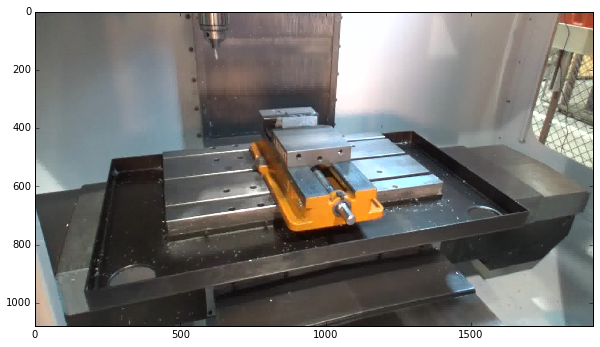

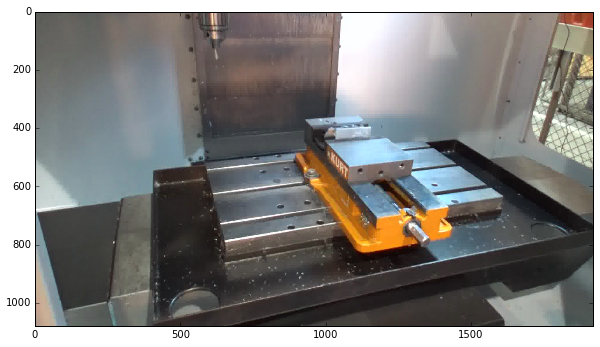

In [134]:
plt.imshow(getCameraImageAt(1,nof, 8 * 60 + 30))
plt.show()
plt.imshow(getCameraImageAt(1,nof, 8 * 60 + 30 + 8))

In [135]:
settings = CalibrationSettings(
    ['x'],
    [0],
    [4]
)
scene = CalibrationScene(ImageLoader(), 8 * 60 + 30, settings)

100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


1

In [137]:
scene.getAxisProjection(getCameraImageAt(1,nof,8*60+40))

array([ 80.49879144])